https://github.com/busesese/DeepFM_Keras/blob/master/DeepFM/deepfm.py

In [21]:
import numpy as np 
from keras.layers import Input, Dense, Embedding, Add, Concatenate, RepeatVector,Multiply,Subtract,Lambda,Dropout,Reshape,Flatten
from keras.models import Model
from keras.utils import plot_model
from mylayers import MySumLayer
from keras.optimizers import Adam
# import config
from keras.metrics import binary_accuracy
# from metrics import auc
import warnings  
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder 
from keras.optimizers import *
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image
from keras.utils.vis_utils import model_to_dot
import tensorflow as tf

# Data Loading

In [22]:
import pandas as pd    
import gc
import os

df = pd.read_csv(os.path.join("..","..","data","YN_final_df2.csv"))
df.head()

rating  locationId  photonum          createdDate is_fch  is_local  \
0     4.5  1150710065         0  2020-05-21 20:42:00      1         1   
1     5.0  1150710065         0  2019-06-28 01:11:03      1         1   
2     5.0  1150710065         0  2020-03-12 00:22:00      1         1   
3     5.0  1150710065         0  2020-02-16 17:06:00      1         1   
4     5.0  1150710065         0  2019-03-11 00:08:48      1         1   

     place.name  userID  average_photonum  average_rating  user_mean_rating  \
0  스타벅스 보라매공원R점  432293          0.164557        4.506329               4.5   
1  스타벅스 보라매공원R점  135109          0.164557        4.506329               5.0   
2  스타벅스 보라매공원R점  269138          0.164557        4.506329               5.0   
3  스타벅스 보라매공원R점  246123          0.164557        4.506329               5.0   
4  스타벅스 보라매공원R점  119248          0.164557        4.506329               5.0   

   user_reviewcount        lat        lng  \
0                 1  37.492103  126.92355   
1                 1  37.492103  126.92355   
2                 1  37.492103  126.92355   
3                 1  37.492103  126.92355   
4                 1  37.492103  126.92355   

                              land.addr category  rated_count  category_l  
0  서울특별시 동작구 신대방동 395-65 파크스퀘어,보라매현대APT      EAT        158.0           1  
1  서울특별시 동작구 신대방동 395-65 파크스퀘어,보라매현대APT      EAT        158.0           1  
2  서울특별시 동작구 신대방동 395-65 파크스퀘어,보라매현대APT      EAT        158.0           1  
3  서울특별시 동작구 신대방동 395-65 파크스퀘어,보라매현대APT      EAT        158.0           1  
4  서울특별시 동작구 신대방동 395-65 파크스퀘어,보라매현대APT      EAT        158.0           1

## 로컬 / 글로벌 데이터 분리

In [23]:
# 로컬 / 글로벌 데이터 분리
local_df = df.loc[df['is_local']==1]
global_df = df.loc[df['is_local']==0]
print('local_df shape:',local_df.shape, 'global_df shape :',global_df.shape)

local_df shape: (381125, 18) global_df shape : (98566, 18)


In [24]:
# 로컬, 글로벌 공통 location id 뽑기
local_id = local_df['locationId'].unique().tolist()
global_id = global_df['locationId'].unique().tolist()

common_ids = []
for i in local_id:
    if i in global_id:
        common_ids.append(i)

common_acm = df.loc[df['locationId'].isin(common_ids)]
common_acm = common_acm.loc[common_acm['category']=='ACM']
common_acm_ids = common_acm['locationId'].unique().tolist()
# global, local 모두 담은 acm location ids
print(len(common_acm_ids)) 

245


# 1. local

In [110]:
local_df_acm = local_df.loc[local_df['category'] == 'ACM']
local_df_eat = local_df.loc[local_df['category'] == 'EAT']

# 평균평점 이상의 식당만 남김.
local_df_eat = local_df_eat.loc[local_df_eat['average_rating']>=local_df_eat['average_rating'].median()]
local_df = pd.concat([local_df_acm, local_df_eat])

# local이기에 global과 차이를 두기위해 최대한 의미없는 체인 제거 
local_df = local_df.loc[local_df['is_fch']==0]

# 의미없는 추천 식당 제거 
local_df = local_df[~local_df['place.name'].str.contains('써브웨이|던킨도너츠|노브랜드버거|바르다김선생|폴바셋|안동찜닭|속초코다리냉면|할매순대국&양선지해장국|노브랜드버거 남부터미널점|바르다김선생|유가네|24시 중식당 취빈|매머드커피|압구정봉구비어|카페베네|쥬씨|피자스쿨|매머드익스프레스|김밥천국|한국맥도날드|메머드커피|신전떡볶이|어사또|공차|북촌손만두|오징어세상|사월에보리밥|땡스브레드엔커피|피자몰|나주소나주곰탕| 새마을식당|싸다김밥| 교동짬뽕| 토마토김밥| 화화쿵주마라탕| 샐러데이즈| 더차이|뚜레쥬르|스쿨푸드|자연별곡|죠스떡볶이|국대떡볶이| 도쿄스테이크|이디야커피| 코스트코코리아양재점푸드코트| 불고기브라더스|알라딘중고서점카페|배스킨라빈스|할리스커피| 와플대학| 파리바게뜨공덕역사| 파리바게뜨|아웃백|설빙| 봉추찜닭| 하겐다즈|아라마크연세의료원종합관|미아리우동집| 서울대학생회관식당|세계과자할인마트| 이삭토스트| 굽네치킨| 깐부치킨| 굽네치킨| 빈스앤베리즈| 롯데리아|던킨 도너츠|피자헛|미쓰족발|덕수궁')]
print('의미없을만한 식당 제거 후 local데이터 크기:',local_df.shape)

의미없을만한 식당 제거 후 local데이터 크기: (126061, 18)


In [111]:
# 데이터 저장
local_df.to_csv(os.path.join("..","realtime_model",'local_df(deepFM).csv'), index=False)

In [112]:
RANDOMSTATE = 2018

COLS=['locationId',  'createdDate', 'photonum', 'rated_count', 'average_photonum',
        'average_rating', 'user_mean_rating', 'user_reviewcount','userID' ] 

In [113]:
def get_data(column, df) :
    
    vocab = {}
    num = 0

    for i in df[column]: 
        if vocab.get(i) != None:
            continue

        vocab[i] = num
        num += 1

    encoded = [vocab[i] for i in df[column]]
    
    return encoded, num, vocab

encoded_locationId, num_locationId, vocab_locationId = get_data('locationId', local_df) 
encoded_createdDate,  num_createdDate, vocab_createdDate = get_data('createdDate', local_df) 
encoded_photonum,  num_photonum, vocab_photonum = get_data('photonum', local_df) 
encoded_rated_count,  num_rated_count, vocab_rated_count = get_data('rated_count', local_df) 
encoded_average_photonum,  num_average_photonum, vocab_average_photonum = get_data('average_photonum', local_df) 
encoded_average_rating,  num_average_rating, vocab_average_rating = get_data('average_rating', local_df) 
encoded_users_mean_rating, num_users_mean_rating, vocab_users_mean_rating = get_data('user_mean_rating', local_df) 
encoded_user_reviewcount,  num_user_reviewcount, vocab_user_reviewcount = get_data('user_reviewcount', local_df) 
encoded_userID, num_userID, vocab_userID = get_data('userID', local_df) 


feat_nu_dict = {}
feat_nu_dict['locationId'] = num_locationId
feat_nu_dict['createdDate'] = num_createdDate
feat_nu_dict['photonum'] = num_photonum
feat_nu_dict['rated_count'] = num_rated_count
feat_nu_dict['average_photonum'] = num_average_photonum
feat_nu_dict['average_rating'] = num_average_rating
feat_nu_dict['user_mean_rating'] = num_users_mean_rating
feat_nu_dict['user_reviewcount'] = num_user_reviewcount
feat_nu_dict['userID'] = num_userID
feat_nu_dict

{'locationId': 4675,
 'createdDate': 78717,
 'photonum': 32,
 'rated_count': 232,
 'average_photonum': 1080,
 'average_rating': 952,
 'user_mean_rating': 10,
 'user_reviewcount': 6,
 'userID': 124743}

In [114]:
k = 8 #the number of embedding dim

input_cols = []
cols = []
embed_col = []
for col in COLS:
    in_neu = Input(shape=(1,), name=col) #None*1
    input_cols.append(in_neu)
    in_embed = RepeatVector(1, name='FM_'+col)(Dense(k)(in_neu)) #None*1*k
    cols.append(in_neu)
    embed_col.append(in_embed)
con_numeric = Concatenate(axis=1)(cols) #None*len(config.COLS)
dense_numeric = RepeatVector(1)(Dense(1)(con_numeric)) #None*1*1

In [115]:
# 모델 구조 아키텍쳐
#first order
y_first_order = dense_numeric #Concatenate(axis=1)([dense_numeric, con_cate]) #None*len*1
y_first_order = MySumLayer(axis=1)(y_first_order) #None*1

#second order
emb = Concatenate(axis=1)(embed_col) #None*s*k

summed_feature_emb = MySumLayer(axis=1)(emb) #None*k
summed_feature_emb_squred = Multiply()([summed_feature_emb,summed_feature_emb]) #None*k

squared_feature_emb = Multiply()([emb,emb]) #None*s*k
squared_sum_feature_emb = MySumLayer(axis=1)(squared_feature_emb) #None*k

sub = Subtract()([summed_feature_emb_squred,squared_sum_feature_emb]) #None*k
sub = Lambda(lambda x: x*0.5)(sub) #None*k
y_second_order = MySumLayer(axis=1)(sub)

#deep order
y_deep = Flatten()(emb) #None*(s*k)
y_deep = Dropout(0.5)(Dense(32,activation='relu')(y_deep)) #None*32
y_deep = Dropout(0.5)(Dense(32,activation='relu')(y_deep)) #None*32
y_deep = Dropout(0.2)(Dense(1,activation='relu')(y_deep)) #None*1

#deep fm
y = Concatenate()([y_first_order,y_second_order,y_deep]) #None*3
prediction = Dense(1,activation='sigmoid')(y)

In [116]:
from keras.callbacks import ModelCheckpoint

# 모델 저장 위치 설정 
model_save_path = os.path.join("..","..","data","model_weights")
if not os.path.exists(model_save_path):
    os.mkdir(model_save_path)

# 콜백모델 저장 -> 모델명 설정     
checkpoint_path = os.path.join(model_save_path ,"local_{epoch:02d}-{val_loss:.4f}.hdf5")
checkpoint_path_json = os.path.join(model_save_path ,"local_{epoch:02d}.json")

cb_checkpoint1 = ModelCheckpoint(filepath = checkpoint_path, monitor = 'val_loss', 
                                verbose=1, save_best_only=True, save_weights_only=True)
cb_checkpoint2 = ModelCheckpoint(filepath = checkpoint_path_json, monitor = 'val_loss', 
                                verbose=1, save_best_only=True, save_weights_only=True)

Train on 125430 samples, validate on 631 samples
Epoch 1/100
125430/125430 [==============================] - 2s 18us/step - loss: 13.5700 - auc_4: 0.0000e+00 - val_loss: 17.0222 - val_auc_4: 0.0000e+00

Epoch 00001: val_loss improved from inf to 17.02219, saving model to ../../data/model_weights/local_01-17.0222.hdf5

Epoch 00001: val_loss improved from inf to 17.02219, saving model to ../../data/model_weights/local_01.json
Epoch 2/100
125430/125430 [==============================] - 1s 6us/step - loss: 13.1554 - auc_4: 0.0000e+00 - val_loss: 16.0523 - val_auc_4: 0.0000e+00

Epoch 00002: val_loss improved from 17.02219 to 16.05230, saving model to ../../data/model_weights/local_02-16.0523.hdf5

Epoch 00002: val_loss improved from 17.02219 to 16.05230, saving model to ../../data/model_weights/local_02.json
Epoch 3/100
125430/125430 [==============================] - 1s 6us/step - loss: 13.1094 - auc_4: 0.0000e+00 - val_loss: 16.0523 - val_auc_4: 0.0000e+00

Epoch 00003: val_loss did no

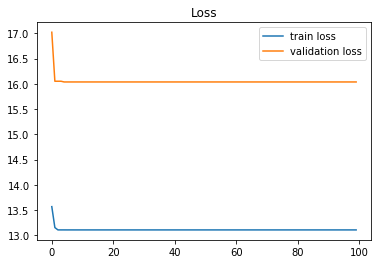

In [117]:
lr = 1e-1
epochs = 100
batch_size = 200000

model = Model(inputs=input_cols, outputs=prediction)
model.compile(loss="mse", optimizer=RMSprop(lr=lr), metrics=[tf.keras.metrics.AUC()])

history = model.fit([encoded_userID, encoded_users_mean_rating, 
                             encoded_user_reviewcount, encoded_locationId, 
                             encoded_createdDate, encoded_photonum,
                             encoded_rated_count,encoded_average_photonum, 
                             encoded_average_rating], local_df['rating'], 
                        batch_size=batch_size, epochs=epochs, validation_split=0.005,
                        callbacks = [cb_checkpoint1, cb_checkpoint2])


plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend() 
plt.title("Loss")
plt.show()

In [118]:
# # 모델 불러오기 
# from keras.models import model_from_json 

# json_file = open(os.path.join(model_save_path ,"local_01.json"), "r",encoding="utf8", errors='ignore') 
# loaded_model_json = json_file.read() 
# json_file.close() 

# loaded_model = model_from_json(loaded_model_json)# ,custom_objects={'tf': tf, 'n_factors':8})

# loaded_model.load_weights(os.path.join(model_save_path,"local_01-12.3368.hdf5"))
                               
# print("Loaded model from disk")

## 유사도 아이템

In [119]:
def latent_to_vec(feature, model, location_df, h_size, input_features):
    layer_name = feature
    intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
    test = input_features
                             
    locationId_latent_vector = intermediate_layer_model.predict(test)
    
    locationId_latent_vector = locationId_latent_vector.T.reshape(-1, h_size)
    vec = pd.DataFrame(locationId_latent_vector)
    location_df = location_df.reset_index()
    vec['locationId'] = location_df['locationId']
    
    # 아이템별 의미 벡터 생성 
    vec = vec.groupby('locationId').agg([('0','mean')]).reset_index()

    vec = pd.DataFrame(vec.iloc[:,1:].values)
    vec['locationId'] = location_df['locationId'].unique()
    vec = vec.set_index('locationId')
    return vec

In [120]:
vec = latent_to_vec('FM_locationId', model, local_df, 8, [encoded_userID, encoded_users_mean_rating, 
                             encoded_user_reviewcount, encoded_locationId, 
                             encoded_createdDate, encoded_photonum,
                        encoded_rated_count,
                                  encoded_average_photonum, encoded_average_rating])

In [121]:
vec.to_csv(os.path.join("..","realtime_model",'deepFM_local_vec.csv'))

In [122]:
from numpy import dot
from numpy.linalg import norm
import numpy as np
import random

def cosim_id(df, vec, item_id):
    def cos_sim(A, B):
           return dot(A, B)/(norm(A)*norm(B)) 
    new_vec = vec.copy() 
    sim = []
    
    # 인풋 호텔 정보 데이터에 없는 경우 종료 
    if item_id not in vec.index.tolist():
        return 
        
    for i in range(len(vec)):
        sim.append(cos_sim(vec.loc[item_id,:], vec.iloc[i,:]))

    new_vec['sim'] = sim
    # sim 높은 순 
    new_vec = new_vec['sim'].reset_index().sort_values('sim', ascending=False)
    sim_sorted = new_vec['locationId'].tolist()
    # 인풋 호텔정보 빼고 유사도 높은 순대로 id 
    if item_id in sim_sorted:
        sim_sorted.remove(item_id) 
    return sim_sorted 

def sim_item(vec, df, item_id, top):
    top_id = cosim_id(df, vec, item_id)
    
    if type(top_id) == list :
        df = df.drop_duplicates(['locationId'], keep='last')
        recommend_rst = []
        for x in top_id:
            if df.loc[df['locationId']==x].category.values[0]== 'EAT':
                recommend_rst.append([df.loc[df['locationId']==x][['place.name', 'land.addr']]])

        print('input hotel:', local_df.loc[local_df['locationId']==item_id]['place.name'].unique()[0])
        print('-'*10)
        for i in range(len(recommend_rst[:top])):
            print('top', i+1, recommend_rst[i][0]['place.name'].values[0])
            print('  주소', recommend_rst[i][0]['land.addr'].values[0])
        
    else:
        answer_lst = ['해당 호텔 정보가 없습니다. 다른 호텔을 입력해주세요.', '해당 호텔 정보가 없습니다. 다른 호텔을 추천받아보세요.']
        x = random.randint(0, len(answer_lst)-1)
        return answer_lst[x]
    

데이터 업뎃 후

In [123]:
import random

for location_id in common_acm_ids[:10]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 호텔에잇아워즈
----------
top 1 가쯔레쯔
  주소 서울특별시 양천구 목동 917 목동파라곤
top 2 굿모닝
  주소 서울특별시 종로구 인사동 255-5
top 3 프로스트
  주소 서울특별시 용산구 이태원동 116-1 해밀톤호텔 별관
top 4 소풍가는날
  주소 서울특별시 관악구 봉천동 1657-21
top 5 베르비에
  주소 서울특별시 양천구 목동 917-9 현대41타워
top 6 산들해 목동점
  주소 서울특별시 양천구 신정동 321-6 센트럴프라자
top 7 댓짱돈까스
  주소 서울특별시 양천구 목동 923-6 예술인회관
top 8 허니케밥
  주소 서울특별시 강남구 역삼동 810-8
top 9 홍대김밥 신수점
  주소 서울특별시 마포구 현석동 108-1
top 10 목동포차 신도림점
  주소 서울특별시 구로구 신도림동 337 신도림1차푸르지오
None



--------------------------------------------------
input hotel: 노보텔스위트앰배서더서울용산
----------
top 1 진미생태
  주소 서울특별시 마포구 용강동 508 e편한세상 마포3차
top 2 우동가조쿠 성수점
  주소 서울특별시 성동구 성수동2가 301-53
top 3 양천뼈다귀본점
  주소 서울특별시 양천구 목동 934 목동금호1차아파트
top 4 한나식빵 송파점
  주소 서울특별시 송파구 방이동 224-9
top 5 그릴드300
  주소 서울특별시 마포구 동교동 150-3
top 6 비블레스
  주소 서울특별시 강남구 삼성동 155-3
top 7 칼리가리브루잉탭룸 익선점
  주소 서울특별시 종로구 익선동 163
top 8 삼육가 사당역직영점
  주소 서울특별시 서초구 방배동 450-16 동화빌딩
top 9 효제눅
  주소 서울특별시 종로구 효제동 61-1
top 10 포썸
  주소 서울특별시 성북구 동선동4가 111-1 골든타워
None



------------------------------

In [124]:
import random

for location_id in common_acm_ids[10:20]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 롯데시티호텔 마포
----------
top 1 펠롱
  주소 서울특별시 중구 신당동 377-155
top 2 바삭마차 응암점
  주소 서울특별시 은평구 응암동 111-48
top 3 즉석 바지락손칼국수
  주소 서울특별시 동작구 대방동 335-15
top 4 아베크엘카페
  주소 서울특별시 용산구 후암동 41-1 몬테피오레
top 5 도쿄이찌바 롯데마트중계점
  주소 서울특별시 노원구 중계동 361 롯데마트
top 6 명인등심방배점
  주소 서울특별시 서초구 방배동 818-11
top 7 홍제파스타
  주소 서울특별시 서대문구 홍제동 330-92
top 8 010수산
  주소 서울특별시 강서구 등촌동 671-3 주양빌딩
top 9 이화원
  주소 서울특별시 서대문구 연희동 189-8
top 10 맥심플랜트
  주소 서울특별시 용산구 한남동 683-140
None



--------------------------------------------------
input hotel: 레스케이프 호텔
----------
top 1 모모카페 코트야드 서울 남대문
  주소 서울특별시 중구 남대문로4가 17-23 남대문호텔
top 2 올리브케이 
  주소 서울특별시 서초구 반포동 723-11 왕건빌딩
top 3 주시브로스 그랑서울점
  주소 서울특별시 종로구 청진동 70 그랑서울
top 4 그레인
  주소 서울특별시 마포구 연남동 385-6
top 5 신락원
  주소 서울특별시 동대문구 전농동 60-32
top 6 배꼽집
  주소 서울특별시 마포구 상암동 1597 사보이시티디엠씨
top 7 도토리브라더스
  주소 서울특별시 종로구 신문로2가 1-248
top 8 스시바 신세계백화점 본점
  주소 서울특별시 중구 충무로1가 52-5 신세계백화점건물
top 9 대천분식
  주소 서울특별시 동작구 노량진동 330 삼익주상복합아파트
top 10 아저씨강정
  주소 서울특별시 관악구 신림동 1587-6
None



---------------------

In [125]:
import random

for location_id in common_acm_ids[20:30]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 강남아르누보시티
----------
top 1 마므레 크로와상
  주소 서울특별시 강서구 마곡동 797-14 힐스테이트에코마곡
top 2 원스타 올드패션드 햄버거
  주소 서울특별시 강남구 도곡동 424-11
top 3 동의보쌈왕족발
  주소 서울특별시 양천구 목동 610-16
top 4 연교
  주소 서울특별시 마포구 연남동 383-95
top 5 이품분식
  주소 서울특별시 마포구 연남동 228-8
top 6 칼리가리브루잉탭룸 익선점
  주소 서울특별시 종로구 익선동 163
top 7 세드라
  주소 서울특별시 강남구 대치동 900-16 샬롬빌
top 8 창덕궁
  주소 서울특별시 종로구 묘동 160-1
top 9 집밥
  주소 서울특별시 양천구 신월동 971-2
top 10 등촌정육식당
  주소 서울특별시 강서구 등촌1동 635-8
None



--------------------------------------------------
input hotel: TheK호텔 서울
----------
top 1 브레드비
  주소 서울특별시 마포구 상암동 1601 케이지아이티센터
top 2 선미옥바지락칼국수얼큰수제비
  주소 서울특별시 마포구 도화동 203-2
top 3 슬로우레시피
  주소 서울특별시 종로구 통의동 91-47
top 4 오리마당
  주소 서울특별시 중구 태평로2가 43 한화금융센터 태평로
top 5 원조보리밥
  주소 서울특별시 용산구 이태원동 34-103
top 6 TIS COFFEE
  주소 서울특별시 마포구 동교동 147-2 동교동빌딩
top 7 롯데리아
  주소 서울특별시 광진구 화양동 4-20
top 8 명일원조닭발
  주소 서울특별시 강동구 명일동 325-16
top 9 연남방앗간
  주소 서울특별시 마포구 연남동 257-22
top 10 야마야
  주소 서울특별시 강남구 역삼동 648-9
None



--------------------------------------------------
input hot

In [126]:
import random

for location_id in common_acm_ids[30:40]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 스타즈호텔 명동1호점
----------
top 1 모나드 커피로스터스
  주소 서울특별시 금천구 시흥동 911-6
top 2 TIS COFFEE
  주소 서울특별시 마포구 동교동 147-2 동교동빌딩
top 3 광주똑순이아구찜
  주소 서울특별시 강서구 마곡동 722-3 정호빌딩
top 4 아티제사당파스텔시티점
  주소 서울특별시 서초구 방배동 444-3 SK리더스뷰
top 5 개화기요정
  주소 서울특별시 마포구 서교동 401-5
top 6 비사벌전주콩나물국밥
  주소 서울특별시 송파구 잠실본동 250-13 동서빌딩
top 7 고창집
  주소 서울특별시 동대문구 청량리동 50-22
top 8 이춘복참치 노원점
  주소 서울특별시 노원구 상계동 324-5
top 9 니나노김밥
  주소 서울특별시 종로구 종로6가 173
top 10 포비 광화문
  주소 서울특별시 종로구 청진동 268-2
None



--------------------------------------------------
input hotel: 글래드 여의도
----------
top 1 강릉육쪽마늘빵 신세계 타임스퀘어
  주소 서울특별시 영등포구 영등포동4가 442 타임스퀘어
top 2 팡파미유 롯데백화점 노원점
  주소 서울특별시 노원구 상계동 713 롯데백화점
top 3 짬뽕주의
  주소 서울특별시 서대문구 충정로2가 29
top 4 베르비에
  주소 서울특별시 양천구 목동 917-9 현대41타워
top 5 리얼파스타 성신여대점
  주소 서울특별시 성북구 동선동1가 3-4
top 6 주은감자탕
  주소 서울특별시 송파구 삼전동 132-14
top 7 김여사네 국수
  주소 서울특별시 강동구 성내동 19-9
top 8 이팡 홍대점
  주소 서울특별시 마포구 서교동 330-21
top 9 버섯집
  주소 서울특별시 성동구 성수동1가 668-34
top 10 이디야 가든파이브점
  주소 서울특별시 송파구 문정동 628 가든파이브툴
None



------------

In [127]:
import random

for location_id in common_acm_ids[40:50]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 골든서울호텔
----------
top 1 서울웨스틴조선호텔 아리아
  주소 서울특별시 중구 소공동 87-1 서울 웨스틴조선호텔
top 2 STEM 상암점
  주소 서울특별시 마포구 성산동 420 월드컵경기장역
top 3 정성식당
  주소 서울특별시 구로구 신도림동 337 신도림1차푸르지오
top 4 밥향기
  주소 서울특별시 송파구 가락동 77-4 송파KCC웰츠타워
top 5 논현손칼국수
  주소 서울특별시 강남구 논현동 193-38
top 6 할머니냉면
  주소 서울특별시 동대문구 제기동 470
top 7 그레이스케일커피
  주소 서울특별시 강남구 역삼동 618-8
top 8 카페 노티드 안국점
  주소 서울특별시 종로구 재동 86
top 9 커피볶는이야기두번째공간
  주소 서울특별시 성북구 동소문동1가 32-2
top 10 허니케밥
  주소 서울특별시 강남구 역삼동 810-8
None



--------------------------------------------------
input hotel: 나인트리프리미어호텔 명동2
----------
top 1 오장도너츠맛집
  주소 서울특별시 중구 오장동 69-3 수협
top 2 보칼리노
  주소 error
top 3 우리집만두
  주소 서울특별시 강남구 대치동 897
top 4 1080떡볶이
  주소 서울특별시 성동구 성수동1가 22-28 정인숙보습학원
top 5 롯데리아
  주소 서울특별시 광진구 화양동 4-20
top 6 G카페
  주소 서울특별시 강서구 마곡동 770 엘지사이언스파크
top 7 효모
  주소 서울특별시 송파구 잠실동 206-4
top 8 독도수산
  주소 서울특별시 동작구 노량진동 13-6 노량진수산물도매시장
top 9 쥬뗑뷔뜨
  주소 서울특별시 송파구 석촌동 283-10
top 10 즉석우동짜장
  주소 서울특별시 영등포구 신길동 4216
None



--------------------------------------------------
input h

In [128]:
import random

for location_id in common_acm_ids[50:60]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 라마다호텔앤스위트서울남대문
----------
top 1 노블베이커리
  주소 서울특별시 서대문구 남가좌동 338-1
top 2 Deweet
  주소 서울특별시 마포구 연남동 260-14
top 3 The View
  주소 error
top 4 유라쿠
  주소 서울특별시 은평구 대조동 198-27
top 5 로우키
  주소 서울특별시 성동구 성수동2가 302-16
top 6 롤앤밥스
  주소 서울특별시 관악구 신림동 1515-11
top 7 건대고기 본점
  주소 서울특별시 광진구 자양동 5-4
top 8 서울편백찜 망원점
  주소 서울특별시 마포구 서교동 442-4
top 9 커피템플 2호점
  주소 서울특별시 마포구 상암동 1597 사보이시티디엠씨
top 10 차마시는뜰
  주소 서울특별시 종로구 삼청동 35-169
None



--------------------------------------------------
input hotel: 베스트웨스턴프리미어서울가든호텔
----------
top 1 덕수정
  주소 서울특별시 중구 정동 11-5
top 2 고씨네
  주소 서울특별시 성북구 정릉동 227-67
top 3 모모카페 코트야드 서울 남대문
  주소 서울특별시 중구 남대문로4가 17-23 남대문호텔
top 4 돈수작
  주소 서울특별시 광진구 능동 220-12
top 5 소르빌로1991
  주소 서울특별시 성북구 동선동1가 92-3
top 6 바삭마차 응암점
  주소 서울특별시 은평구 응암동 111-48
top 7 김씨네
  주소 서울특별시 강남구 신사동 627-6
top 8 브레댄코
  주소 서울특별시 성동구 성수동2가 308-4 서울숲코오롱디지털타워
top 9 미니네
  주소 서울특별시 중구 신당동 292-141
top 10 찬스브로스
  주소 서울특별시 용산구 이태원동 561
None



--------------------------------------------------
input hotel: 머큐어 서울 앰

In [129]:
import random

for location_id in common_acm_ids[60:70]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 강남패밀리호텔
----------
top 1 모모카페 코트야드 서울 남대문
  주소 서울특별시 중구 남대문로4가 17-23 남대문호텔
top 2 바다회사랑
  주소 서울특별시 마포구 연남동 566-8
top 3 서울카츠
  주소 서울특별시 중구 필동2가 15-14
top 4 고기꾼 김춘배 종로점
  주소 서울특별시 종로구 관철동 12-23
top 5 Chai797 청계천점(미래에셋센터원빌딩)
  주소 서울특별시 중구 수하동 67 미래에셋 센터원(Mirae Asset CENTER1)
top 6 드렁큰콰이즈
  주소 서울특별시 중구 충무로2가 53-9
top 7 마부자생삼겹살
  주소 서울특별시 강서구 마곡동 760 마곡나루역보타닉푸르지오시티
top 8 은사떡볶이
  주소 서울특별시 성동구 성수동1가 13-413
top 9 모랑
  주소 서울특별시 종로구 신문로1가 163 광화문오피시아빌딩
top 10 다가이순대국 상암점
  주소 서울특별시 마포구 상암동 36-6
None



--------------------------------------------------
input hotel: 아트리움바비엥2
----------
top 1 모모카페 코트야드 서울 남대문
  주소 서울특별시 중구 남대문로4가 17-23 남대문호텔
top 2 허니버터아몬드앤프렌즈
  주소 서울특별시 중구 충무로2가 65-9 하이헤리엇
top 3 마크레인커피
  주소 서울특별시 강남구 신사동 657-24
top 4 HONESTCOFFEE
  주소 서울특별시 강남구 역삼동 700-20
top 5 스테이터 강남역점
  주소 서울특별시 강남구 역삼동 812
top 6 오모가리
  주소 서울특별시 강북구 미아동 160-46
top 7 짬뽕주의
  주소 서울특별시 서대문구 충정로2가 29
top 8 독수리다방
  주소 서울특별시 서대문구 창천동 31-4 독수리빌딩
top 9 최원석의돼지한판&서해쭈꾸미 건대2호점
  주소 서울특별시 광진구 화양동 5-42
top 10 문배동 육

In [130]:
import random

for location_id in common_acm_ids[70:80]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 인터시티365
----------
top 1 카페C
  주소 서울특별시 용산구 이촌동 301-54 한강교회
top 2 고려보쌈
  주소 서울특별시 중구 무교동 25-1 원창빌딩
top 3 카페아토
  주소 서울특별시 관악구 신림동 1639-59
top 4 꽈대표
  주소 서울특별시 마포구 망원동 479-91
top 5 빵이가
  주소 서울특별시 노원구 상계동 1132-35
top 6 강남불백 1호점
  주소 서울특별시 강남구 역삼동 827-23
top 7 덕수정
  주소 서울특별시 중구 정동 11-5
top 8 서울안심축산 신도림점
  주소 서울특별시 구로구 신도림동 337 신도림1차푸르지오
top 9 루스티크
  주소 서울특별시 서초구 서초동 1523-7 산해빌딩
top 10 푸주옥
  주소 서울특별시 양천구 신정동 1290-2
None



--------------------------------------------------
input hotel: Hotel in 9
----------
top 1 모모카페 코트야드 서울 남대문
  주소 서울특별시 중구 남대문로4가 17-23 남대문호텔
top 2 도마
  주소 서울특별시 종로구 관훈동 15-1
top 3 고향집
  주소 서울특별시 강남구 논현동 115-5
top 4 청국장과보리밥 청담점
  주소 서울특별시 강남구 청담동 72-1
top 5 동대문닭한마리칼국수
  주소 서울특별시 강남구 논현동 114-27
top 6 라운즈맨커피
  주소 서울특별시 성북구 안암동5가 103-93
top 7 문배동 육칼
  주소 서울특별시 강남구 삼성동 156-6
top 8 노홍철천재
  주소 서울특별시 용산구 후암동 123-11
top 9 동경우동
  주소 서울특별시 중구 초동 17-1
top 10 가장맛있는족발 종로관철점
  주소 서울특별시 종로구 관철동 19-19
None



--------------------------------------------------
input hotel: 호텔

In [131]:
import random

for location_id in common_acm_ids[80:90]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: G2 호텔
----------
top 1 우리설렁탕
  주소 서울특별시 관악구 신림동 107-106
top 2 최원석의돼지한판&서해쭈꾸미 건대2호점
  주소 서울특별시 광진구 화양동 5-42
top 3 모이세해장국
  주소 서울특별시 은평구 역촌동 22-39 세신빌딩
top 4 캘리포니아피자키친 용산아이파크몰점
  주소 서울특별시 용산구 한강로3가 40-999 용산역
top 5 교촌치킨
  주소 서울특별시 성동구 성수동2가 331-8 광성유치원
top 6 데이앤데이
  주소 서울특별시 성동구 성수동2가 333-16 이마트 성수점
top 7 버섯잔치집
  주소 서울특별시 강동구 성내동 549-4 성원빌딩
top 8 썰스데이파티
  주소 서울특별시 용산구 이태원동 124-6
top 9 난랑
  주소 서울특별시 송파구 방이동 36-7 혜성빌딩
top 10 맘모스커피
  주소 서울특별시 마포구 서교동 327-15
None



--------------------------------------------------
input hotel: 서울 렉스 호텔
----------
top 1 서진식당
  주소 서울특별시 강남구 역삼동 824-25 대우디오빌플러스
top 2 미각아구동태해물찜 탕
  주소 서울특별시 성북구 정릉4동 401-2 시온쇼핑
top 3 산들
  주소 서울특별시 광진구 군자동 98 세종대학교
top 4 뿌자
  주소 서울특별시 종로구 창신동 207
top 5 레오니다스초콜릿카페
  주소 서울특별시 중구 명동2가 2-1 재원빌딩
top 6 기꾸스시
  주소 서울특별시 서대문구 창천동 62-15
top 7 세드라
  주소 서울특별시 강남구 대치동 900-16 샬롬빌
top 8 마칸 할랄 코리안 레스토랑
  주소 서울특별시 용산구 한남동 763-23
top 9 양키통닭 & Second Floor
  주소 서울특별시 영등포구 문래동2가 49-1
top 10 포비 베이직
  주소 서울특별시 마포구 합정동 426-18
None



----

In [132]:
import random

for location_id in common_acm_ids[90:100]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 롯데 호텔 서울
----------
top 1 정성식당
  주소 서울특별시 구로구 신도림동 337 신도림1차푸르지오
top 2 이춘복참치 발산역점
  주소 서울특별시 강서구 등촌동 673-5 화인빌딩
top 3 그레이스케일커피
  주소 서울특별시 강남구 역삼동 618-8
top 4 할머니포장마차멸치국수
  주소 서울특별시 송파구 방이동 49-5 올림픽파크존
top 5 잘빠진메밀 서촌점
  주소 서울특별시 종로구 통인동 118-3
top 6 보라매 호프치킨
  주소 서울특별시 영등포구 신길동 4387
top 7 몬스터플레이스
  주소 서울특별시 용산구 청파동3가 114-3
top 8 이서방네분식
  주소 서울특별시 마포구 공덕동 462 마포공덕파크팰리스 Ⅱ
top 9 명인등심 삼성직영점
  주소 서울특별시 강남구 삼성동 148-15
top 10 태국식당356
  주소 서울특별시 서초구 양재동 10-52
None



--------------------------------------------------
input hotel: 이비스 스타일 앰배서더 서울 명동
----------
top 1 메이비카페
  주소 서울특별시 구로구 구로동 1124-49
top 2 카우떡볶이
  주소 서울특별시 서대문구 대현동 34-40
top 3 남도
  주소 서울특별시 강남구 삼성동 143-24
top 4 은사떡볶이
  주소 서울특별시 성동구 성수동1가 13-413
top 5 그랜드앰배서더서울풀만 더 킹스
  주소 서울특별시 중구 장충동2가 186-54 그랜드앰배서더서울
top 6 율베이커리
  주소 서울특별시 강동구 성내동 380
top 7 천호낙지
  주소 서울특별시 동대문구 장안동 107-8 삼협메디스빌딩
top 8 STEM 상암점
  주소 서울특별시 마포구 성산동 420 월드컵경기장역
top 9 망원동돼지국밥
  주소 서울특별시 마포구 망원1동 57-13
top 10 원조순희네빈대떡
  주소 서울특별시 종로구 종로5가 138-9
None



---

In [133]:
import random

for location_id in common_acm_ids[100:110]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 포시즌스 호텔 서울
----------
top 1 마므레 크로와상
  주소 서울특별시 강서구 마곡동 797-14 힐스테이트에코마곡
top 2 가장맛있는족발 보라매역점
  주소 서울특별시 동작구 대방동 400-5
top 3 모힝 낙성대점
  주소 서울특별시 관악구 봉천동 1627-12
top 4 비라티오 홍대점
  주소 서울특별시 마포구 서교동 367-13 서교동근린생활시설
top 5 참착한김밥
  주소 서울특별시 서초구 잠원동 36-28 남전빌딩
top 6 비블레스
  주소 서울특별시 강남구 삼성동 155-3
top 7 유부
  주소 서울특별시 마포구 망원동 414-82
top 8 마포궁중족발
  주소 서울특별시 마포구 공덕동 256-10 공덕시장
top 9 덕수정
  주소 서울특별시 중구 정동 11-5
top 10 글림
  주소 서울특별시 강남구 신사동 563-37
None



--------------------------------------------------
input hotel: 호텔28 명동
----------
top 1 유라쿠
  주소 서울특별시 은평구 대조동 198-27
top 2 횡성고기마을
  주소 서울특별시 서초구 방배동 761-2
top 3 길리안초콜릿카페 롯데월드몰점
  주소 서울특별시 송파구 신천동 29 롯데월드타워앤드롯데월드몰
top 4 커피세레모니
  주소 서울특별시 서초구 양재동 400-13 이오스빌딩
top 5 모모카페 코트야드 서울 남대문
  주소 서울특별시 중구 남대문로4가 17-23 남대문호텔
top 6 옷살
  주소 서울특별시 관악구 봉천동 856-5 대우디오슈페리움1단지
top 7 카페클라우드
  주소 서울특별시 강남구 역삼동 730-13
top 8 비사벌전주콩나물국밥
  주소 서울특별시 송파구 잠실본동 250-13 동서빌딩
top 9 STAY
  주소 서울특별시 송파구 신천동 29 롯데월드타워앤드롯데월드몰
top 10 연안식당 잠실점
  주소 서울특별시 송파구 잠실동 177-5
None



In [134]:
import random

for location_id in common_acm_ids[110:120]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 호텔 스카이파크 센트럴 명동
----------
top 1 버찌와 모모
  주소 서울특별시 송파구 송파동 89-5 제일빌딩
top 2 그린버킷
  주소 서울특별시 영등포구 여의도동 32-1
top 3 롯데리아
  주소 서울특별시 강남구 삼성동 159 코엑스
top 4 청담동마녀김밥 강남역점
  주소 서울특별시 서초구 서초동 1337-17 보원빌딩
top 5 골든타이
  주소 서울특별시 송파구 방이동 171-4 팰리스
top 6 덕수정
  주소 서울특별시 중구 정동 11-5
top 7 40년전통할머니추어탕 장안점
  주소 서울특별시 동대문구 장안동 430-18
top 8 카페 펌킨
  주소 서울특별시 중구 태평로1가 61-21
top 9 수작나베 석촌점
  주소 서울특별시 송파구 석촌동 158-7 라품미빌딩
top 10 섭이네
  주소 서울특별시 서대문구 연희동 190-14
None



--------------------------------------------------
input hotel: 이코노미 호텔 명동 프리미어
----------
top 1 서리김밥
  주소 서울특별시 용산구 원효로2가 1-38
top 2 이춘복참치 발산역점
  주소 서울특별시 강서구 등촌동 673-5 화인빌딩
top 3 개화기요정
  주소 서울특별시 마포구 서교동 401-5
top 4 고른햇살
  주소 서울특별시 성북구 안암동5가 147-5 원영스위트
top 5 한상차림밥상
  주소 서울특별시 성북구 안암동3가 9
top 6 코코케이크 건대직영점
  주소 서울특별시 광진구 화양동 7-5
top 7 쿠팡
  주소 서울특별시 강남구 삼성동 157-27 브이플렉스
top 8 다엔조
  주소 서울특별시 마포구 연남동 383-99
top 9 툭툭누들타이
  주소 서울특별시 서대문구 연희동 353-89
top 10 한나식빵 답십리점
  주소 서울특별시 동대문구 답십리동 1003-2 세기프라자
None



--------------------------------

In [135]:
import random

for location_id in common_acm_ids[120:130]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 을지로 코업레지던스
----------
top 1 모모카페 코트야드 서울 남대문
  주소 서울특별시 중구 남대문로4가 17-23 남대문호텔
top 2 트렌치타운
  주소 서울특별시 용산구 이태원동 99-14 모뎀빌
top 3 명가
  주소 서울특별시 은평구 응암동 89-11
top 4 평원숯불갈비
  주소 서울특별시 종로구 효제동 174-6
top 5 스위트앤카츠
  주소 서울특별시 광진구 군자동 373-7
top 6 죽향 롯데백화점 관악점
  주소 서울특별시 관악구 봉천동 729-22 롯데백화점
top 7 byrain
  주소 서울특별시 광진구 중곡동 30-61
top 8 진격의곱창 신림점
  주소 서울특별시 관악구 신림동 1587-15
top 9 신도세기
  주소 서울특별시 강남구 역삼동 708-20 금천빌딩
top 10 스시메이 성수역점
  주소 서울특별시 성동구 성수동2가 316-1 린빌딩
None



--------------------------------------------------
input hotel: 사보이호텔
----------
top 1 모모카페 코트야드 서울 남대문
  주소 서울특별시 중구 남대문로4가 17-23 남대문호텔
top 2 프릳츠 도화점
  주소 서울특별시 마포구 도화동 179-9
top 3 포비 베이직
  주소 서울특별시 마포구 합정동 426-18
top 4 오월의종 타임스퀘어점
  주소 서울특별시 영등포구 영등포동4가 442 타임스퀘어
top 5 대학로에 취하다
  주소 서울특별시 종로구 동숭동 1-37 로얄케스트
top 6 애슐리
  주소 서울특별시 구로구 구로동 188-25 지밸리비즈플라자
top 7 케이리퍼블릭타파스바
  주소 서울특별시 용산구 이태원동 119-28
top 8 이치류 홍대본점
  주소 서울특별시 마포구 서교동 395-124
top 9 인디언 커리 하우스 빈 103
  주소 서울특별시 강남구 역삼동 619-3
top 10 어썸로즈
  주소 서울특별시 강남구 신사동 520-7


In [136]:
import random

for location_id in common_acm_ids[130:140]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 트레블로지 명동 을지로호텔
----------
top 1 모모카페 코트야드 서울 남대문
  주소 서울특별시 중구 남대문로4가 17-23 남대문호텔
top 2 성산왕갈비
  주소 서울특별시 마포구 성산동 446 성산시영아파트
top 3 보성커머스 종각점
  주소 서울특별시 종로구 종로1가 54 종각지하철역사
top 4 마므레 크로와상
  주소 서울특별시 강서구 마곡동 797-14 힐스테이트에코마곡
top 5 광장동가온
  주소 서울특별시 광진구 광장동 102
top 6 도요스6가
  주소 서울특별시 송파구 송파동 58-15 트윈레이크팰리스빌
top 7 블랑제리코팡
  주소 서울특별시 마포구 망원동 455-17
top 8 원조청기와숯불갈비
  주소 서울특별시 마포구 망원1동 484-1
top 9 풍문 고기집
  주소 서울특별시 중구 남대문로5가 84-9
top 10 명동칼국수
  주소 서울특별시 강남구 역삼동 823 삼원타워
None



--------------------------------------------------
input hotel: 호텔 스카이파크 명동 1
----------
top 1 로우키
  주소 서울특별시 성동구 성수동2가 302-16
top 2 비스트로주라
  주소 서울특별시 마포구 서교동 342-16 信和빌딩
top 3 망원동돼지국밥
  주소 서울특별시 마포구 망원1동 57-13
top 4 횡성고기마을
  주소 서울특별시 서초구 방배동 761-2
top 5 이춘복참치 노원점
  주소 서울특별시 노원구 상계동 324-5
top 6 제주김만복 홍대연남동점
  주소 서울특별시 마포구 동교동 190-1 홍대입구역
top 7 모나드 커피로스터스
  주소 서울특별시 금천구 시흥동 911-6
top 8 체부동잔치집
  주소 서울특별시 종로구 체부동 190
top 9 청어람 2호점
  주소 서울특별시 마포구 망원동 483-23
top 10 Bowl Room
  주소 서울특별시 강남구 신사동 635-14 금광아크존1
None


In [137]:
import random

for location_id in common_acm_ids[140:150]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 호텔 통 서울 명동
----------
top 1 daughter
  주소 서울특별시 광진구 화양동 11-17
top 2 금붕어식당
  주소 서울특별시 마포구 합정동 448-18
top 3 쿠차라 종로점
  주소 서울특별시 종로구 청진동 70 그랑서울
top 4 짬뽕주의
  주소 서울특별시 서대문구 충정로2가 29
top 5 원차우
  주소 서울특별시 구로구 개봉동 277-7
top 6 도쿄이찌바 롯데마트중계점
  주소 서울특별시 노원구 중계동 361 롯데마트
top 7 브레드비
  주소 서울특별시 마포구 상암동 1601 케이지아이티센터
top 8 보쌈당한오징어
  주소 서울특별시 종로구 동숭동 1-89 석마빌딩
top 9 HONESTCOFFEE
  주소 서울특별시 강남구 역삼동 700-20
top 10 카페아토
  주소 서울특별시 관악구 신림동 1639-59
None



--------------------------------------------------
input hotel: 호텔 마누
----------
top 1 즉석 바지락손칼국수
  주소 서울특별시 동작구 대방동 335-15
top 2 한나식빵 답십리점
  주소 서울특별시 동대문구 답십리동 1003-2 세기프라자
top 3 잘빠진메밀 익선점
  주소 서울특별시 종로구 묘동 3-1
top 4 횡성고기마을
  주소 서울특별시 서초구 방배동 761-2
top 5 원조보리밥
  주소 서울특별시 용산구 이태원동 34-103
top 6 남산커피집
  주소 서울특별시 중구 남산동2가 25-8
top 7 허브족발
  주소 서울특별시 영등포구 당산동6가 302
top 8 풍년 닭도리탕
  주소 서울특별시 중구 북창동 18-7
top 9 스트릿츄러스
  주소 서울특별시 광진구 자양동 9-31
top 10 백미당 롯데잠실점
  주소 서울특별시 송파구 잠실동 40-1 롯데월드
None



--------------------------------------------------
input 

In [138]:
import random

for location_id in common_acm_ids[150:160]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 글로리 인
----------
top 1 오스테리아레스또
  주소 서울특별시 마포구 연남동 382-2
top 2 커피세레모니
  주소 서울특별시 서초구 양재동 400-13 이오스빌딩
top 3 꽈대표
  주소 서울특별시 마포구 망원동 479-91
top 4 주래등
  주소 서울특별시 강남구 논현동 97-8
top 5 비라티오 홍대점
  주소 서울특별시 마포구 서교동 367-13 서교동근린생활시설
top 6 한나식빵 송파점
  주소 서울특별시 송파구 방이동 224-9
top 7 망원동돼지국밥
  주소 서울특별시 마포구 망원1동 57-13
top 8 육갈탕 신림역점
  주소 서울특별시 관악구 신림동 1641-10
top 9 화련
  주소 서울특별시 마포구 창전동 152-5
top 10 매뉴팩트커피 방배점
  주소 서울특별시 서초구 방배동 876-31
None



--------------------------------------------------
input hotel: 크레토 호텔 명동
----------
top 1 트렌치타운
  주소 서울특별시 용산구 이태원동 99-14 모뎀빌
top 2 고향집
  주소 서울특별시 강남구 논현동 115-5
top 3 진미생태
  주소 서울특별시 마포구 용강동 508 e편한세상 마포3차
top 4 삼육가 사당역직영점
  주소 서울특별시 서초구 방배동 450-16 동화빌딩
top 5 춘천집 닭갈비막국수
  주소 서울특별시 서대문구 창천동 57-8
top 6 쥬뗑뷔뜨
  주소 서울특별시 송파구 석촌동 283-10
top 7 죽향 롯데백화점 관악점
  주소 서울특별시 관악구 봉천동 729-22 롯데백화점
top 8 오월의종 타임스퀘어점
  주소 서울특별시 영등포구 영등포동4가 442 타임스퀘어
top 9 다담정식
  주소 서울특별시 종로구 서린동 88 관정빌딩
top 10 당산오돌 길동점
  주소 서울특별시 강동구 길동 415-18 호텔아르고
None



---------------------------

In [139]:
import random

for location_id in common_acm_ids[160:170]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 뉴 오리엔탈 호텔
----------
top 1 아르고티코리아 롯데월드몰
  주소 서울특별시 송파구 신천동 29 롯데월드타워앤드롯데월드몰
top 2 모힝
  주소 서울특별시 관악구 봉천동 1598-6
top 3 고창집
  주소 서울특별시 동대문구 청량리동 50-22
top 4 담소소사골순대육개장 구로디지털점
  주소 서울특별시 구로구 구로동 182-4 대륭포스트타워3차
top 5 세드라
  주소 서울특별시 강남구 대치동 900-16 샬롬빌
top 6 한나식빵 송파점
  주소 서울특별시 송파구 방이동 224-9
top 7 해랑스시
  주소 서울특별시 중구 남대문로5가 84-11 연세대학교 세브란스빌딩
top 8 호미가
  주소 서울특별시 영등포구 당산동3가 158-1
top 9 1080떡볶이
  주소 서울특별시 성동구 성수동1가 22-28 정인숙보습학원
top 10 메이비카페
  주소 서울특별시 구로구 구로동 1124-49
None



--------------------------------------------------
input hotel: 토모 레지던스
----------
top 1 백미당 롯데잠실점
  주소 서울특별시 송파구 잠실동 40-1 롯데월드
top 2 족발천하 망원점
  주소 서울특별시 마포구 망원동 57-33
top 3 모모카페 코트야드 서울 남대문
  주소 서울특별시 중구 남대문로4가 17-23 남대문호텔
top 4 천지샤브샤브 2호점
  주소 서울특별시 광진구 화양동 9-25
top 5 델리인디아
  주소 서울특별시 마포구 서교동 402-6
top 6 스시혼
  주소 서울특별시 중랑구 신내동 544-19
top 7 요란한부엌
  주소 서울특별시 동작구 사당동 1032-8
top 8 일편등심(홍대본점)
  주소 서울특별시 마포구 동교동 164-23
top 9 라오
  주소 서울특별시 마포구 서교동 459-7 잔다리빌딩
top 10 양촌리
  주소 서울특별시 강동구 길동 417
None



-------------

In [140]:
import random

for location_id in common_acm_ids[170:180]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 글래드 라이브 강남
----------
top 1 교대평상집
  주소 서울특별시 서초구 서초동 1571-18 청화빌딩
top 2 허니케밥
  주소 서울특별시 강남구 역삼동 810-8
top 3 허브족발
  주소 서울특별시 영등포구 당산동6가 302
top 4 명화원
  주소 서울특별시 용산구 한강로1가 14-28
top 5 우리콩밭손두부
  주소 서울특별시 광진구 구의동 143-2
top 6 미성옥
  주소 서울특별시 중구 명동1가 54-6
top 7 에반스
  주소 서울특별시 마포구 서교동 407-3
top 8 피닉스 현대백화점무역센터점
  주소 서울특별시 강남구 삼성동 159-7 현대백화점
top 9 체부동잔치집
  주소 서울특별시 종로구 체부동 190
top 10 보통의행복 베이커리
  주소 서울특별시 마포구 망원동 385-44 테바빌딩
None



--------------------------------------------------
input hotel: 로얄 호텔 서울
----------
top 1 모모카페 코트야드 서울 남대문
  주소 서울특별시 중구 남대문로4가 17-23 남대문호텔
top 2 화목순대국전문
  주소 서울특별시 종로구 당주동 40
top 3 호치킨 신대방삼거리역 1번출구점
  주소 서울특별시 동작구 대방동 336-12
top 4 서울쿠키
  주소 서울특별시 중구 소공동 1 롯데호텔
top 5 셀프회수산시장포장전문점 응암점
  주소 서울특별시 은평구 응암동 109-3 서강스카이빌
top 6 롯데리아
  주소 서울특별시 광진구 화양동 4-20
top 7 1080떡볶이
  주소 서울특별시 성동구 성수동1가 22-28 정인숙보습학원
top 8 착한아이스크림할인점
  주소 서울특별시 서대문구 홍제동 109-1
top 9 텐동미세기
  주소 서울특별시 서대문구 창천동 78-19 한성빌딩
top 10 미스터카츠 샤로수길점
  주소 서울특별시 관악구 봉천동 856-5 대우디오슈페리움1단지
None





In [141]:
import random

for location_id in common_acm_ids[180:190]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 호텔 더 디자이너스 홍대
----------
top 1 덕수정
  주소 서울특별시 중구 정동 11-5
top 2 망원동즉석우동
  주소 서울특별시 마포구 망원동 386-4
top 3 서리김밥
  주소 서울특별시 용산구 원효로2가 1-38
top 4 버터밀크
  주소 서울특별시 마포구 창전동 6-131
top 5 호미가
  주소 서울특별시 영등포구 당산동3가 158-1
top 6 유로베이크 롯데영등포덤
  주소 서울특별시 영등포구 영등포동 618-496 영등포 민자역사
top 7 행운당
  주소 서울특별시 관악구 봉천동 1671-35 신화로즈빌
top 8 카페 빈칸
  주소 서울특별시 동대문구 휘경동 192-5
top 9 라오
  주소 서울특별시 마포구 서교동 459-7 잔다리빌딩
top 10 마뇨떡볶이
  주소 서울특별시 관악구 신림동 1638-1 삼모더프라임타워
None



--------------------------------------------------
input hotel: 센터마크 호텔
----------
top 1 롤앤밥스
  주소 서울특별시 관악구 신림동 1515-11
top 2 스위트앤카츠
  주소 서울특별시 광진구 군자동 373-7
top 3 양키통닭 & Second Floor
  주소 서울특별시 영등포구 문래동2가 49-1
top 4 그린버킷
  주소 서울특별시 영등포구 여의도동 32-1
top 5 별미곱창
  주소 서울특별시 송파구 방이동 64-1 동성빌딩
top 6 충무김밥
  주소 서울특별시 마포구 상수동 324-8
top 7 타이쇼
  주소 서울특별시 강남구 도곡동 957-1
top 8 횡성고기마을
  주소 서울특별시 서초구 방배동 761-2
top 9 가쯔레쯔
  주소 서울특별시 양천구 목동 917 목동파라곤
top 10 화포식당
  주소 서울특별시 용산구 한남동 85-4
None



--------------------------------------------------
input hotel: 프

In [142]:
import random

for location_id in common_acm_ids[190:200]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 메트로 호텔
----------
top 1 주래등
  주소 서울특별시 강남구 논현동 97-8
top 2 삭
  주소 서울특별시 서대문구 대현동 56-33
top 3 에베레스트레스토랑 동대문역사문화공원점
  주소 서울특별시 중구 을지로6가 18-21 굿모닝시티쇼핑몰
top 4 독도수산
  주소 서울특별시 동작구 노량진동 13-6 노량진수산물도매시장
top 5 롤앤밥스
  주소 서울특별시 관악구 신림동 1515-11
top 6 논현손칼국수
  주소 서울특별시 강남구 논현동 193-38
top 7 마쯔무라돈까스 직영1호점
  주소 서울특별시 도봉구 창동 74-25
top 8 엘피노323
  주소 서울특별시 용산구 이태원동 559
top 9 남산도담
  주소 서울특별시 중구 충무로3가 28-2
top 10 FOURB 을지로
  주소 서울특별시 중구 수표동 99 시그니쳐타워
None



--------------------------------------------------
input hotel: JW 메리어트 호텔 서울
----------
top 1 논현손칼국수
  주소 서울특별시 강남구 논현동 193-38
top 2 63베이커리
  주소 서울특별시 영등포구 여의도동 60 63한화생명빌딩
top 3 수원아줌마
  주소 서울특별시 종로구 예지동 2-1
top 4 후라토식당 발산역점
  주소 서울특별시 강서구 마곡동 797-14 힐스테이트에코마곡
top 5 야키토리 고우 이태원본점
  주소 서울특별시 용산구 이태원동 119-17
top 6 새마을식당
  주소 서울특별시 중구 충무로3가 25-10
top 7 골든타이
  주소 서울특별시 송파구 방이동 171-4 팰리스
top 8 품차
  주소 서울특별시 강서구 방화동 886 김포공항, 롯데몰, 스카이시티
top 9 shoop
  주소 서울특별시 마포구 합정동 361-1
top 10 난장캠프
  주소 서울특별시 강남구 논현동 198-3
None



---------------------------

In [143]:
import random

for location_id in common_acm_ids[200:210]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 호텔 아트리움
----------
top 1 카카오봄
  주소 서울특별시 용산구 한강로1가 216-3
top 2 모모카페 코트야드 서울 남대문
  주소 서울특별시 중구 남대문로4가 17-23 남대문호텔
top 3 원마산아구찜
  주소 서울특별시 마포구 용강동 122-1
top 4 오레노카츠
  주소 서울특별시 성동구 성수동1가 16-8 송도빌딩
top 5 이품분식
  주소 서울특별시 마포구 연남동 228-8
top 6 화곡영양족발
  주소 서울특별시 강서구 화곡동 98-154
top 7 슈바벤
  주소 서울특별시 도봉구 방학동 676-21 SYO빌딩
top 8 반쥴
  주소 서울특별시 종로구 관철동 12-16
top 9 얄개시대
  주소 서울특별시 중구 충무로4가 25
top 10 다엔조
  주소 서울특별시 마포구 연남동 383-99
None



--------------------------------------------------
input hotel: 호텔 스카이파크 동대문 I
----------
top 1 고기꾼 김춘배 종로점
  주소 서울특별시 종로구 관철동 12-23
top 2 본죽
  주소 서울특별시 종로구 연건동 70-1
top 3 롯데리아
  주소 서울특별시 광진구 화양동 4-20
top 4 1080떡볶이
  주소 서울특별시 성동구 성수동1가 22-28 정인숙보습학원
top 5 비블레스
  주소 서울특별시 강남구 삼성동 155-3
top 6 별미곱창
  주소 서울특별시 송파구 방이동 64-1 동성빌딩
top 7 포헨
  주소 서울특별시 영등포구 당산동3가 395-40
top 8 허니케밥
  주소 서울특별시 강남구 역삼동 810-8
top 9 공공거실
  주소 서울특별시 종로구 명륜2가 8-34
top 10 부빙
  주소 서울특별시 종로구 부암동 254-2
None



--------------------------------------------------
input hotel: 선샤인 호텔
----------
to

In [144]:
import random

for location_id in common_acm_ids[210:220]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 알로프트 서울 강남
----------
top 1 횡성고기마을
  주소 서울특별시 서초구 방배동 761-2
top 2 선미옥바지락칼국수얼큰수제비
  주소 서울특별시 마포구 도화동 203-2
top 3 허브족발
  주소 서울특별시 영등포구 당산동6가 302
top 4 1080떡볶이
  주소 서울특별시 성동구 성수동1가 22-28 정인숙보습학원
top 5 송정식당
  주소 서울특별시 종로구 종로5가 443
top 6 가장맛있는족발 보라매역점
  주소 서울특별시 동작구 대방동 400-5
top 7 그레이스케일커피
  주소 서울특별시 강남구 역삼동 618-8
top 8 키커피 컴퍼니
  주소 서울특별시 성동구 행당동 130-115 9988병원빌딩
top 9 로로
  주소 서울특별시 강남구 신사동 646-7
top 10 청년김밥본점
  주소 서울특별시 동대문구 신설동 76-43
None



--------------------------------------------------
input hotel: 호텔 페이토 강남
----------
top 1 비스트로주라
  주소 서울특별시 마포구 서교동 342-16 信和빌딩
top 2 가장맛있는족발 보라매역점
  주소 서울특별시 동작구 대방동 400-5
top 3 홍대김밥 신수점
  주소 서울특별시 마포구 현석동 108-1
top 4 volt32
  주소 서울특별시 송파구 방이동 63-14
top 5 유라쿠
  주소 서울특별시 은평구 대조동 198-27
top 6 착한아이스크림할인점
  주소 서울특별시 서대문구 홍제동 109-1
top 7 잘빠진메밀 익선점
  주소 서울특별시 종로구 묘동 3-1
top 8 오리마당
  주소 서울특별시 중구 태평로2가 43 한화금융센터 태평로
top 9 수돈재감자탕왕십리점
  주소 서울특별시 성동구 행당동 292-9
top 10 돼지대첩
  주소 서울특별시 서초구 양재동 324-4 정선빌딩
None



-------------------------------------

In [145]:
import random

for location_id in common_acm_ids[220:230]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 인더시티 서비스 레지던스 강남
----------
top 1 나누미떡볶이성대본점
  주소 서울특별시 종로구 명륜2가 225
top 2 포헨
  주소 서울특별시 영등포구 당산동3가 395-40
top 3 모모카페 코트야드 서울 남대문
  주소 서울특별시 중구 남대문로4가 17-23 남대문호텔
top 4 이팡 홍대점
  주소 서울특별시 마포구 서교동 330-21
top 5 청어람 2호점
  주소 서울특별시 마포구 망원동 483-23
top 6 연세대학교신촌캠펴스 웰스토리
  주소 서울특별시 서대문구 신촌동 134 신촌세브란스병원
top 7 신천장어와 한우
  주소 서울특별시 송파구 잠실동 187-10
top 8 결
  주소 서울특별시 종로구 공평동 17
top 9 부다스벨리 이태원점
  주소 서울특별시 용산구 이태원동 457-1
top 10 별미볶음점
  주소 서울특별시 영등포구 여의도동 36-2
None



--------------------------------------------------
input hotel: 센트럴 관광호텔
----------
top 1 모모카페 코트야드 서울 남대문
  주소 서울특별시 중구 남대문로4가 17-23 남대문호텔
top 2 뉴질랜드스토리
  주소 서울특별시 송파구 송파동 32-1 경남레이크파크
top 3 진성회관
  주소 서울특별시 성동구 성수동1가 656-302 케이티링커스
top 4 보쌈당한오징어
  주소 서울특별시 종로구 동숭동 1-89 석마빌딩
top 5 STEM 상암점
  주소 서울특별시 마포구 성산동 420 월드컵경기장역
top 6 삼오집
  주소 서울특별시 도봉구 도봉동 596-23
top 7 브레드윤
  주소 서울특별시 구로구 개봉동 124-22
top 8 찰만생대패
  주소 서울특별시 용산구 이태원동 130-6
top 9 화포식당
  주소 서울특별시 용산구 한남동 85-4
top 10 별미곱창
  주소 서울특별시 송파구 방이동 64-1 동성빌딩
None



------------

In [146]:
import random

for location_id in common_acm_ids[230:240]:
    print(sim_item(vec, local_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 리버사이드 호텔 서울
----------
top 1 미쓰유동 롯데마트잠실점
  주소 서울특별시 송파구 잠실동 40-1 롯데월드
top 2 횡성고기마을
  주소 서울특별시 서초구 방배동 761-2
top 3 결
  주소 서울특별시 종로구 공평동 17
top 4 1080떡볶이
  주소 서울특별시 성동구 성수동1가 22-28 정인숙보습학원
top 5 포리틀파파
  주소 서울특별시 마포구 연남동 561-3
top 6 스시도쿠
  주소 서울특별시 성동구 행당동 196-18
top 7 여섯시오븐 롯데백화점노원점
  주소 서울특별시 노원구 상계동 713 롯데백화점
top 8 홍마반점0410
  주소 서울특별시 용산구 문배동 24-8 프라임펠리스
top 9 목동포차 신도림점
  주소 서울특별시 구로구 신도림동 337 신도림1차푸르지오
top 10 주래등
  주소 서울특별시 강남구 논현동 97-8
None



--------------------------------------------------
input hotel: 글래드 강남 코엑스 센터
----------
top 1 텐동미세기
  주소 서울특별시 서대문구 창천동 78-19 한성빌딩
top 2 동적불고기
  주소 서울특별시 도봉구 창동 443-8
top 3 홍제파스타
  주소 서울특별시 서대문구 홍제동 330-92
top 4 커피몽타주
  주소 서울특별시 강동구 성내동 555-5 상지빌딩
top 5 오복수산잠실
  주소 서울특별시 송파구 송파동 42-6
top 6 오스테리아레스또
  주소 서울특별시 마포구 연남동 382-2
top 7 카페클라우드
  주소 서울특별시 강남구 역삼동 730-13
top 8 무공돈까스 역삼점
  주소 서울특별시 강남구 역삼동 827-49 송강원빌딩
top 9 주은감자탕
  주소 서울특별시 송파구 삼전동 132-14
top 10 김여사네 국수
  주소 서울특별시 강동구 성내동 19-9
None



--------------------------------------

In [147]:
sim_item(vec, local_df, 3477158, 10)

input hotel: 콘래드 서울
----------
top 1 덕수정
  주소 서울특별시 중구 정동 11-5
top 2 미도인 종로
  주소 서울특별시 종로구 종로2가 6 종로타워
top 3 일편등심(홍대본점)
  주소 서울특별시 마포구 동교동 164-23
top 4 홍제파스타
  주소 서울특별시 서대문구 홍제동 330-92
top 5 서울쿠키
  주소 서울특별시 중구 소공동 1 롯데호텔
top 6 오카와리
  주소 서울특별시 서대문구 충정로2가 104-2
top 7 비스트로사랑방
  주소 서울특별시 마포구 서교동 408-25
top 8 장군족발보쌈
  주소 서울특별시 종로구 낙원동 49
top 9 페어링룸
  주소 서울특별시 강남구 청담동 117-12
top 10 베르비에
  주소 서울특별시 양천구 목동 917-9 현대41타워


In [148]:
sim_item(vec, local_df, 0, 10)

'해당 호텔 정보가 없습니다. 다른 호텔을 추천받아보세요.'

In [149]:
sim_item(vec, local_df, 299533, 10)

input hotel: 이비스 스타일 앰배서더 서울 강남
----------
top 1 허니케밥
  주소 서울특별시 강남구 역삼동 810-8
top 2 이화원
  주소 서울특별시 서대문구 연희동 189-8
top 3 브레드비
  주소 서울특별시 마포구 상암동 1601 케이지아이티센터
top 4 비스트로주라
  주소 서울특별시 마포구 서교동 342-16 信和빌딩
top 5 남북통일
  주소 서울특별시 마포구 서교동 375-26
top 6 TIS COFFEE
  주소 서울특별시 마포구 동교동 147-2 동교동빌딩
top 7 우육면관
  주소 서울특별시 종로구 관철동 11-11
top 8 노블베이커리
  주소 서울특별시 서대문구 남가좌동 338-1
top 9 소피스티케이크
  주소 서울특별시 마포구 서교동 396-54
top 10 신해금강
  주소 서울특별시 송파구 가락동 600 가락동 농수산물도매시장


In [150]:
sim_item(vec, local_df, 299152, 10)

'해당 호텔 정보가 없습니다. 다른 호텔을 입력해주세요.'

In [151]:
sim_item(vec, local_df, 6998634, 10)

input hotel: 이비스 버젯 앰배서더 서울 동대문
----------
top 1 테이블포포
  주소 서울특별시 서초구 반포동 110-1 대성빌딩
top 2 루스티크
  주소 서울특별시 서초구 서초동 1523-7 산해빌딩
top 3 원조짜장떡볶이
  주소 서울특별시 중구 신당동 337-55
top 4 무한리필 고기굼터
  주소 서울특별시 종로구 창신동 651-47
top 5 양촌리
  주소 서울특별시 강동구 길동 417
top 6 아차산할아버지
  주소 서울특별시 광진구 구의동 143-3
top 7 내고향횡성한우정육점식당
  주소 서울특별시 송파구 방이동 66-3 석촌씨티빌딩
top 8 소풍가는날
  주소 서울특별시 관악구 봉천동 1657-21
top 9 노홍철천재
  주소 서울특별시 용산구 후암동 123-11
top 10 마칸 할랄 코리안 레스토랑
  주소 서울특별시 용산구 한남동 763-23


In [152]:
sim_item(vec, local_df, 1796658, 10)

'해당 호텔 정보가 없습니다. 다른 호텔을 추천받아보세요.'

In [153]:
sim_item(vec, local_df, 306118, 10)

input hotel: 그랜드 인터컨티넨탈 서울 파르나스
----------
top 1 횡성고기마을
  주소 서울특별시 서초구 방배동 761-2
top 2 참착한김밥
  주소 서울특별시 서초구 잠원동 36-28 남전빌딩
top 3 미도인 종로
  주소 서울특별시 종로구 종로2가 6 종로타워
top 4 본솔커피
  주소 서울특별시 용산구 청파동2가 64-13
top 5 디어브레드 고대점
  주소 서울특별시 성북구 안암동5가 101-82
top 6 한세희복집
  주소 서울특별시 성동구 성수동2가 289-257
top 7 압구정하루
  주소 서울특별시 강남구 신사동 663-9 서현빌딩
top 8 오레노카츠
  주소 서울특별시 성동구 성수동1가 16-8 송도빌딩
top 9 땅코참숯구이 본점
  주소 서울특별시 성동구 행당동 292-34 세종보습학원
top 10 이어도참치
  주소 서울특별시 광진구 군자동 355-11


# 2. global

In [25]:
global_df_acm = global_df.loc[global_df['category'] == 'ACM']
global_df_eat = global_df.loc[global_df['category'] == 'EAT']

# 평균평점 이상의 식당만 남김.
global_df_eat = global_df_eat.loc[global_df_eat['average_rating']>=global_df_eat['average_rating'].median()]
global_df = pd.concat([global_df_acm, global_df_eat])

# local이기에 global과 차이를 두기위해 최대한 의미없는 체인 제거 
global_df = global_df.loc[global_df['is_fch']==0]

# 의미없는 추천 식당 제거 
global_df = global_df[~global_df['place.name'].str.contains('연세대학교신촌캠펴스 웰스토리|써브웨이| 던킨도너츠|노브랜드버거| 노브랜드버거 남부터미널점|24시 중식당 취빈|매머드커피|압구정봉구비어|카페베네|쥬씨|피자스쿨|매머드익스프레스|김밥천국|한국맥도날드|메머드커피|어사또| 오징어세상 |사월에보리밥| 땡스브레드엔커피| 피자몰| 나주소나주곰탕|싸다김밥| 토마토김밥| 화화쿵주마라탕| 샐러데이즈| 뚜레쥬르|이디야커피| 코스트코코리아양재점푸드코트| 알라딘중고서점카페|배스킨라빈스|할리스커피| 와플대학| 파리바게뜨공덕역사| 파리바게뜨|아웃백| 하겐다즈|아라마크연세의료원종합관')]
print('의미없을만한 식당 제거 후 local데이터 크기:',global_df.shape)

의미없을만한 식당 제거 후 local데이터 크기: (71406, 18)


In [155]:
# global_df.to_csv(os.path.join("..","realtime_model",'global_df(deepFM).csv'), index=False)

In [26]:
def get_data(column, df) :
    
    vocab = {}
    num = 0

    for i in df[column]: 
        if vocab.get(i) != None:
            continue

        vocab[i] = num
        num += 1

    encoded = [vocab[i] for i in df[column]]
    
    return encoded, num, vocab


encoded_locationId, num_locationId, vocab_locationId = get_data('locationId', global_df) 
encoded_createdDate,  num_createdDate, vocab_createdDate = get_data('createdDate', global_df) 
encoded_photonum,  num_photonum, vocab_photonum = get_data('photonum', global_df) 
encoded_rated_count,  num_rated_count, vocab_rated_count = get_data('rated_count', global_df) 
encoded_average_photonum,  num_average_photonum, vocab_average_photonum = get_data('average_photonum', global_df) 
encoded_average_rating,  num_average_rating, vocab_average_rating = get_data('average_rating', global_df) 
encoded_users_mean_rating, num_users_mean_rating, vocab_users_mean_rating = get_data('user_mean_rating', global_df) 
encoded_user_reviewcount,  num_user_reviewcount, vocab_user_reviewcount = get_data('user_reviewcount', global_df) 
# encoded_userID, num_userID, vocab_userID = get_data('userID', global_df) 


feat_nu_dict = {}
feat_nu_dict['locationId'] = num_locationId
feat_nu_dict['createdDate'] = num_createdDate
feat_nu_dict['photonum'] = num_photonum
feat_nu_dict['rated_count'] = num_rated_count
feat_nu_dict['average_photonum'] = num_average_photonum
feat_nu_dict['average_rating'] = num_average_rating
feat_nu_dict['user_mean_rating'] = num_users_mean_rating
feat_nu_dict['user_reviewcount'] = num_user_reviewcount
# feat_nu_dict['userID'] = num_userID
feat_nu_dict

{'locationId': 1501,
 'createdDate': 7573,
 'photonum': 52,
 'rated_count': 197,
 'average_photonum': 555,
 'average_rating': 420,
 'user_mean_rating': 5,
 'user_reviewcount': 2}

In [27]:
RANDOMSTATE = 2018

COLS=['locationId', 'createdDate', 'photonum', 'rated_count', 'average_photonum',
        'average_rating', 'user_mean_rating', 'user_reviewcount'] 

In [28]:
k = 8 #the number of embedding dim

input_cols = []
cols = [] 
embed_col = []
for col in COLS:
    in_neu = Input(shape=(1,), name=col) #None*1
    input_cols.append(in_neu)
    in_embed = RepeatVector(1, name='FM_'+col)(Dense(k)(in_neu)) #None*1*k
    cols.append(in_neu)
    embed_col.append(in_embed)
con_numeric = Concatenate(axis=1)(cols) #None*len(config.COLS)
dense_numeric = RepeatVector(1)(Dense(1)(con_numeric)) #None*1*1

In [29]:
# 모델 구조 아키텍쳐
#first order
y_first_order = dense_numeric #Concatenate(axis=1)([dense_numeric, con_cate]) #None*len*1
y_first_order = MySumLayer(axis=1)(y_first_order) #None*1

#second order
emb = Concatenate(axis=1)(embed_col) #None*s*k

summed_feature_emb = MySumLayer(axis=1)(emb) #None*k
summed_feature_emb_squred = Multiply()([summed_feature_emb,summed_feature_emb]) #None*k

squared_feature_emb = Multiply()([emb,emb]) #None*s*k
squared_sum_feature_emb = MySumLayer(axis=1)(squared_feature_emb) #None*k

sub = Subtract()([summed_feature_emb_squred,squared_sum_feature_emb]) #None*k
sub = Lambda(lambda x: x*0.5)(sub) #None*k
y_second_order = MySumLayer(axis=1)(sub)

#deep order 
y_deep = Flatten()(emb) #None*(s*k)
y_deep = Dropout(0.5)(Dense(32,activation='relu')(y_deep)) #None*32
y_deep = Dropout(0.5)(Dense(32,activation='relu')(y_deep)) #None*32
y_deep = Dropout(0.5)(Dense(1,activation='relu')(y_deep)) #None*1

#deep fm
y = Concatenate()([y_first_order,y_second_order,y_deep]) #None*3
y = Dense(1,activation='sigmoid')(y)

In [30]:
from keras.callbacks import ModelCheckpoint

# 모델 저장 위치 설정 
model_save_path = os.path.join("..","..","data","model_weights")
if not os.path.exists(model_save_path):
    os.mkdir(model_save_path)

# 콜백모델 저장 -> 모델명 설정     
checkpoint_path = os.path.join(model_save_path ,"local_{epoch:02d}-{val_loss:.4f}.hdf5")
checkpoint_path_json = os.path.join(model_save_path ,"local_{epoch:02d}.json")

cb_checkpoint1 = ModelCheckpoint(filepath = checkpoint_path, monitor = 'val_loss', 
                                verbose=1, save_best_only=True, save_weights_only=True)
cb_checkpoint2 = ModelCheckpoint(filepath = checkpoint_path_json, monitor = 'val_loss', 
                                verbose=1, save_best_only=True, save_weights_only=True)

In [31]:
lr = 1e-3
epochs = 3000
batch_size = 120000

model = Model(inputs=input_cols, outputs=[y])
model.compile(loss="mse", optimizer=RMSprop(lr=lr), metrics=[tf.keras.metrics.AUC()])
model.save_weights(checkpoint_path)

history = model.fit([encoded_userID, encoded_users_mean_rating, 
                             encoded_user_reviewcount, encoded_locationId, 
                             encoded_createdDate, encoded_photonum,
                             encoded_rated_count,encoded_average_photonum, 
                             encoded_average_rating], global_df['rating'], 
                  batch_size=batch_size, epochs=epochs, validation_split=0.005,
                   callbacks = [cb_checkpoint1, cb_checkpoint2])


plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.legend() 
plt.title("Loss") 
plt.show()

ValueError: `validation_split` is only supported for Tensors or NumPy arrays, found: ([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183, 1184, 1185, 1186, 1187, 1188, 1189, 1190, 1191, 1192, 1193, 1194, 1195, 1196, 1197, 1198, 1199, 1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209, 1210, 1211, 1212, 1213, 1214, 1215, 1216, 1217, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231, 1232, 1233, 1234, 1235, 1236, 1237, 1238, 1239, 1240, 1241, 1242, 1243, 1244, 1245, 1246, 1247, 1248, 1249, 1250, 1251, 1252, 1253, 1254, 1255, 1256, 1257, 1258, 1259, 1260, 1261, 1262, 1263, 1264, 1265, 1266, 1267, 1268, 1269, 1270, 1271, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280, 1281, 1282, 1283, 1284, 1285, 1286, 1287, 1288, 1289, 1290, 1291, 1292, 1293, 1294, 1295, 1296, 1297, 1298, 1299, 1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1309, 1310, 1311, 1312, 1313, 1314, 1315, 1316, 1317, 1318, 1319, 1320, 1321, 1322, 1323, 1324, 1325, 1326, 1327, 1328, 1329, 1330, 1331, 1332, 1333, 1334, 1335, 1336, 1337, 1338, 1339, 1340, 1341, 1342, 1343, 1344, 1345, 1346, 1347, 1348, 1349, 1350, 1351, 1352, 1353, 1354, 1355, 1356, 1357, 1358, 1359, 1360, 1361, 1362, 1363, 1364, 1365, 1366, 1367, 1368, 1369, 1370, 1371, 1372, 1373, 1374, 1375, 1376, 1377, 1378, 1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1414, 1415, 1416, 1417, 1418, 1419, 1420, 1421, 1422, 1423, 1424, 1425, 1426, 1427, 1428, 1429, 1430, 1431, 1432, 1433, 1434, 1435, 1436, 1437, 1438, 1439, 1440, 1441, 1442, 1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460, 1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475, 1476, 1477, 1478, 1479, 1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1491, 1492, 1493, 1494, 1495, 1496, 1497, 1498, 1499, 1500, 1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533, 1534, 1535, 1536, 1537, 1538, 1539, 1540, 1541, 1542, 1543, 1544, 1545, 1546, 1547, 1548, 1549, 1550, 1551, 1552, 1553, 1554, 1555, 1556, 1557, 1558, 1559, 1560, 1561, 1562, 1563, 1564, 1565, 1566, 1567, 1568, 1569, 1570, 1571, 1572, 1573, 1574, 1575, 1576, 1577, 1578, 1579, 1580, 1581, 1582, 1583, 1584, 1585, 1586, 1587, 1588, 1589, 1590, 1591, 1592, 1593, 1594, 1595, 1596, 1597, 1598, 1599, 1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1610, 1611, 1612, 1613, 1614, 1615, 1616, 1617, 1618, 1619, 1620, 1621, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 1630, 1631, 1632, 1633, 1634, 1635, 1636, 1637, 1638, 1639, 1640, 1641, 1642, 1643, 1644, 1645, 1646, 1647, 1648, 1649, 1650, 1651, 1652, 1653, 1654, 1655, 1656, 1657, 1658, 1659, 1660, 1661, 1662, 1663, 1664, 1665, 1666, 1667, 1668, 1669, 1670, 1671, 1672, 1673, 1674, 1675, 1676, 1677, 1678, 1679, 1680, 1681, 1682, 1683, 1684, 1685, 1686, 1687, 1688, 1689, 1690, 1691, 1692, 1693, 1694, 1695, 1696, 1697, 1698, 1699, 1700, 1701, 1702, 1703, 1704, 1705, 1706, 1707, 1708, 1709, 1710, 1711, 1712, 1713, 1714, 1715, 1716, 1717, 1718, 1719, 1720, 1721, 1722, 1723, 1724, 1725, 1726, 1727, 1728, 1729, 1730, 1731, 1732, 1733, 1734, 1735, 1736, 1737, 1738, 1739, 1740, 1741, 1742, 1743, 1744, 1745, 1746, 1747, 1748, 1749, 1750, 1751, 1752, 1753, 1754, 1755, 1756, 1757, 1758, 1759, 1760, 1761, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1769, 1770, 1771, 1772, 1773, 1774, 1775, 1776, 1777, 1778, 1779, 1780, 1781, 1782, 1783, 1784, 1785, 1786, 1787, 1788, 1789, 1790, 1791, 1792, 1793, 1794, 1795, 1796, 1797, 1798, 1799, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812, 1813, 1814, 1815, 1816, 1817, 1818, 1819, 1820, 1821, 1822, 1823, 1824, 1825, 1826, 1827, 1828, 1829, 1830, 1831, 1832, 1833, 1834, 1835, 1836, 1837, 1838, 1839, 1840, 1841, 1842, 1843, 1844, 1845, 1846, 1847, 1848, 1849, 1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1859, 1860, 1861, 1862, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 1870, 1871, 1872, 1873, 1874, 1875, 1876, 1877, 1878, 1879, 1880, 1881, 1882, 1883, 1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893, 1894, 1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100, 2101, 2102, 2103, 2104, 2105, 2106, 2107, 2108, 2109, 2110, 2111, 2112, 2113, 2114, 2115, 2116, 2117, 2118, 2119, 2120, 2121, 2122, 2123, 2124, 2125, 2126, 2127, 2128, 2129, 2130, 2131, 2132, 2133, 2134, 2135, 2136, 2137, 2138, 2139, 2140, 2141, 2142, 2143, 2144, 2145, 2146, 2147, 2148, 2149, 2150, 2151, 2152, 2153, 2154, 2155, 2156, 2157, 2158, 2159, 2160, 2161, 2162, 2163, 2164, 2165, 2166, 2167, 2168, 2169, 2170, 2171, 2172, 2173, 2174, 2175, 2176, 2177, 2178, 2179, 2180, 2181, 2182, 2183, 2184, 2185, 2186, 2187, 2188, 2189, 2190, 2191, 2192, 2193, 2194, 2195, 2196, 2197, 2198, 2199, 2200, 2201, 2202, 2203, 2204, 2205, 2206, 2207, 2208, 2209, 2210, 2211, 2212, 2213, 2214, 2215, 2216, 2217, 2218, 2219, 2220, 2221, 2222, 2223, 2224, 2225, 2226, 2227, 2228, 2229, 2230, 2231, 2232, 2233, 2234, 2235, 2236, 2237, 2238, 2239, 2240, 2241, 2242, 2243, 2244, 2245, 2246, 2247, 2248, 2249, 2250, 2251, 2252, 2253, 2254, 2255, 2256, 2257, 2258, 2259, 2260, 2261, 2262, 2263, 2264, 2265, 2266, 2267, 2268, 2269, 2270, 2271, 2272, 2273, 2274, 2275, 2276, 2277, 2278, 2279, 2280, 2281, 2282, 2283, 2284, 2285, 2286, 2287, 2288, 2289, 2290, 2291, 2292, 2293, 2294, 2295, 2296, 2297, 2298, 2299, 2300, 2301, 2302, 2303, 2304, 2305, 2306, 2307, 2308, 2309, 2310, 2311, 2312, 2313, 2314, 2315, 2316, 2317, 2318, 2319, 2320, 2321, 2322, 2323, 2324, 2325, 2326, 2327, 2328, 2329, 2330, 2331, 2332, 2333, 2334, 2335, 2336, 2337, 2338, 2339, 2340, 2341, 2342, 2343, 2344, 2345, 2346, 2347, 2348, 2349, 2350, 2351, 2352, 2353, 2354, 2355, 2356, 2357, 2358, 2359, 2360, 2361, 2362, 2363, 2364, 2365, 2366, 2367, 2368, 2369, 2370, 2371, 2372, 2373, 2374, 2375, 2376, 2377, 2378, 2379, 2380, 2381, 2382, 2383, 2384, 2385, 2386, 2387, 2388, 2389, 2390, 2391, 2392, 2393, 2394, 2395, 2396, 2397, 2398, 2399, 2400, 2401, 2402, 2403, 2404, 2405, 2406, 2407, 2408, 2409, 2410, 2411, 2412, 2413, 2414, 2415, 2416, 2417, 2418, 2419, 2420, 2421, 2422, 2423, 2424, 2425, 2426, 2427, 2428, 2429, 2430, 2431, 2432, 2433, 2434, 2435, 2436, 2437, 2438, 2439, 2440, 2441, 2442, 2443, 2444, 2445, 2446, 2447, 2448, 2449, 2450, 2451, 2452, 2453, 2454, 2455, 2456, 2457, 2458, 2459, 2460, 2461, 2462, 2463, 2464, 2465, 2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 2509, 2510, 2511, 2512, 2513, 2514, 2515, 2516, 2517, 2518, 2519, 2520, 2521, 2522, 2523, 2524, 2525, 2526, 2527, 2528, 2529, 2530, 2531, 2532, 2533, 2534, 2535, 2536, 2537, 2538, 2539, 2540, 2541, 2542, 2543, 2544, 2545, 2546, 2547, 2548, 2549, 2550, 2551, 2552, 2553, 2554, 2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 2600, 2601, 2602, 2603, 2604, 2605, 2606, 2607, 2608, 2609, 2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619, 2620, 2621, 2622, 2623, 2624, 2625, 2626, 2627, 2628, 2629, 2630, 2631, 2632, 2633, 2634, 2635, 2636, 2637, 2638, 2639, 2640, 2641, 2642, 2643, 2644, 2645, 2646, 2647, 2648, 2649, 2650, 2651, 2652, 2653, 2654, 2655, 2656, 2657, 2658, 2659, 2660, 2661, 2662, 2663, 2664, 2665, 2666, 2667, 2668, 2669, 2670, 2671, 2672, 2673, 2674, 2675, 2676, 2677, 2678, 2679, 2680, 2681, 2682, 2683, 2684, 2685, 2686, 2687, 2688, 2689, 2690, 2691, 2692, 2693, 2694, 2695, 2696, 2697, 2698, 2699, 2700, 2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732, 2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831, 2832, 2833, 2834, 2835, 2836, 2837, 2838, 2839, 2840, 2841, 2842, 2843, 2844, 2845, 2846, 2847, 2848, 2849, 2850, 2851, 2852, 2853, 2854, 2855, 2856, 2857, 2858, 2859, 2860, 2861, 2862, 2863, 2864, 2865, 2866, 2867, 2868, 2869, 2870, 2871, 2872, 2873, 2874, 2875, 2876, 2877, 2878, 2879, 2880, 2881, 2882, 2883, 2884, 2885, 2886, 2887, 2888, 2889, 2890, 2891, 2892, 2893, 2894, 2895, 2896, 2897, 2898, 2899, 2900, 2901, 2902, 2903, 2904, 2905, 2906, 2907, 2908, 2909, 2910, 2911, 2912, 2913, 2914, 2915, 2916, 2917, 2918, 2919, 2920, 2921, 2922, 2923, 2924, 2925, 2926, 2927, 2928, 2929, 2930, 2931, 2932, 2933, 2934, 2935, 2936, 2937, 2938, 2939, 2940, 2941, 2942, 2943, 2944, 2945, 2946, 2947, 2948, 2949, 2950, 2951, 2952, 2953, 2954, 2955, 2956, 2957, 2958, 2959, 2960, 2961, 2962, 2963, 2964, 2965, 2966, 2967, 2968, 2969, 2970, 2971, 2972, 2973, 2974, 2975, 2976, 2977, 2978, 2979, 2980, 2981, 2982, 2983, 2984, 2985, 2986, 2987, 2988, 2989, 2990, 2991, 2992, 2993, 2994, 2995, 2996, 2997, 2998, 2999, 3000, 3001, 3002, 3003, 3004, 3005, 3006, 3007, 3008, 3009, 3010, 3011, 3012, 3013, 3014, 3015, 3016, 3017, 3018, 3019, 3020, 3021, 3022, 3023, 3024, 3025, 3026, 3027, 3028, 3029, 3030, 3031, 3032, 3033, 3034, 3035, 3036, 3037, 3038, 3039, 3040, 3041, 3042, 3043, 3044, 3045, 3046, 3047, 3048, 3049, 3050, 3051, 3052, 3053, 3054, 3055, 3056, 3057, 3058, 3059, 3060, 3061, 3062, 3063, 3064, 3065, 3066, 3067, 3068, 3069, 3070, 3071, 3072, 3073, 3074, 3075, 3076, 3077, 3078, 3079, 3080, 3081, 3082, 3083, 3084, 3085, 3086, 3087, 3088, 3089, 3090, 3091, 3092, 3093, 3094, 3095, 3096, 3097, 3098, 3099, 3100, 3101, 3102, 3103, 3104, 3105, 3106, 3107, 3108, 3109, 3110, 3111, 3112, 3113, 3114, 3115, 3116, 3117, 3118, 3119, 3120, 3121, 3122, 3123, 3124, 3125, 3126, 3127, 3128, 3129, 3130, 3131, 3132, 3133, 3134, 3135, 3136, 3137, 3138, 3139, 3140, 3141, 3142, 3143, 3144, 3145, 3146, 3147, 3148, 3149, 3150, 3151, 3152, 3153, 3154, 3155, 3156, 3157, 3158, 3159, 3160, 3161, 3162, 3163, 3164, 3165, 3166, 3167, 3168, 3169, 3170, 3171, 3172, 3173, 3174, 3175, 3176, 3177, 3178, 3179, 3180, 3181, 3182, 3183, 3184, 3185, 3186, 3187, 3188, 3189, 3190, 3191, 3192, 3193, 3194, 3195, 3196, 3197, 3198, 3199, 3200, 3201, 3202, 3203, 3204, 3205, 3206, 3207, 3208, 3209, 3210, 3211, 3212, 3213, 3214, 3215, 3216, 3217, 3218, 3219, 3220, 3221, 3222, 3223, 3224, 3225, 3226, 3227, 3228, 3229, 3230, 3231, 3232, 3233, 3234, 3235, 3236, 3237, 3238, 3239, 3240, 3241, 3242, 3243, 3244, 3245, 3246, 3247, 3248, 3249, 3250, 3251, 3252, 3253, 3254, 3255, 3256, 3257, 3258, 3259, 3260, 3261, 3262, 3263, 3264, 3265, 3266, 3267, 3268, 3269, 3270, 3271, 3272, 3273, 3274, 3275, 3276, 3277, 3278, 3279, 3280, 3281, 3282, 3283, 3284, 3285, 3286, 3287, 3288, 3289, 3290, 3291, 3292, 3293, 3294, 3295, 3296, 3297, 3298, 3299, 3300, 3301, 3302, 3303, 3304, 3305, 3306, 3307, 3308, 3309, 3310, 3311, 3312, 3313, 3314, 3315, 3316, 3317, 3318, 3319, 3320, 3321, 3322, 3323, 3324, 3325, 3326, 3327, 3328, 3329, 3330, 3331, 3332, 3333, 3334, 3335, 3336, 3337, 3338, 3339, 3340, 3341, 3342, 3343, 3344, 3345, 3346, 3347, 3348, 3349, 3350, 3351, 3352, 3353, 3354, 3355, 3356, 3357, 3358, 3359, 3360, 3361, 3362, 3363, 3364, 3365, 3366, 3367, 3368, 3369, 3370, 3371, 3372, 3373, 3374, 3375, 3376, 3377, 3378, 3379, 3380, 3381, 3382, 3383, 3384, 3385, 3386, 3387, 3388, 3389, 3390, 3391, 3392, 3393, 3394, 3395, 3396, 3397, 3398, 3399, 3400, 3401, 3402, 3403, 3404, 3405, 3406, 3407, 3408, 3409, 3410, 3411, 3412, 3413, 3414, 3415, 3416, 3417, 3418, 3419, 3420, 3421, 3422, 3423, 3424, 3425, 3426, 3427, 3428, 3429, 3430, 3431, 3432, 3433, 3434, 3435, 3436, 3437, 3438, 3439, 3440, 3441, 3442, 3443, 3444, 3445, 3446, 3447, 3448, 3449, 3450, 3451, 3452, 3453, 3454, 3455, 3456, 3457, 3458, 3459, 3460, 3461, 3462, 3463, 3464, 3465, 3466, 3467, 3468, 3469, 3470, 3471, 3472, 3473, 3474, 3475, 3476, 3477, 3478, 3479, 3480, 3481, 3482, 3483, 3484, 3485, 3486, 3487, 3488, 3489, 3490, 3491, 3492, 3493, 3494, 3495, 3496, 3497, 3498, 3499, 3500, 3501, 3502, 3503, 3504, 3505, 3506, 3507, 3508, 3509, 3510, 3511, 3512, 3513, 3514, 3515, 3516, 3517, 3518, 3519, 3520, 3521, 3522, 3523, 3524, 3525, 3526, 3527, 3528, 3529, 3530, 3531, 3532, 3533, 3534, 3535, 3536, 3537, 3538, 3539, 3540, 3541, 3542, 3543, 3544, 3545, 3546, 3547, 3548, 3549, 3550, 3551, 3552, 3553, 3554, 3555, 3556, 3557, 3558, 3559, 3560, 3561, 3562, 3563, 3564, 3565, 3566, 3567, 3568, 3569, 3570, 3571, 3572, 3573, 3574, 3575, 3576, 3577, 3578, 3579, 3580, 3581, 3582, 3583, 3584, 3585, 3586, 3587, 3588, 3589, 3590, 3591, 3592, 3593, 3594, 3595, 3596, 3597, 3598, 3599, 3600, 3601, 3602, 3603, 3604, 3605, 3606, 3607, 3608, 3609, 3610, 3611, 3612, 3613, 3614, 3615, 3616, 3617, 3618, 3619, 3620, 3621, 3622, 3623, 3624, 3625, 3626, 3627, 3628, 3629, 3630, 3631, 3632, 3633, 3634, 3635, 3636, 3637, 3638, 3639, 3640, 3641, 3642, 3643, 3644, 3645, 3646, 3647, 3648, 3649, 3650, 3651, 3652, 3653, 3654, 3655, 3656, 3657, 3658, 3659, 3660, 3661, 3662, 3663, 3664, 3665, 3666, 3667, 3668, 3669, 3670, 3671, 3672, 3673, 3674, 3675, 3676, 3677, 3678, 3679, 3680, 3681, 3682, 3683, 3684, 3685, 3686, 3687, 3688, 3689, 3690, 3691, 3692, 3693, 3694, 3695, 3696, 3697, 3698, 3699, 3700, 3701, 3702, 3703, 3704, 3705, 3706, 3707, 3708, 3709, 3710, 3711, 3712, 3713, 3714, 3715, 3716, 3717, 3718, 3719, 3720, 3721, 3722, 3723, 3724, 3725, 3726, 3727, 3728, 3729, 3730, 3731, 3732, 3733, 3734, 3735, 3736, 3737, 3738, 3739, 3740, 3741, 3742, 3743, 3744, 3745, 3746, 3747, 3748, 3749, 3750, 3751, 3752, 3753, 3754, 3755, 3756, 3757, 3758, 3759, 3760, 3761, 3762, 3763, 3764, 3765, 3766, 3767, 3768, 3769, 3770, 3771, 3772, 3773, 3774, 3775, 3776, 3777, 3778, 3779, 3780, 3781, 3782, 3783, 3784, 3785, 3786, 3787, 3788, 3789, 3790, 3791, 3792, 3793, 3794, 3795, 3796, 3797, 3798, 3799, 3800, 3801, 3802, 3803, 3804, 3805, 3806, 3807, 3808, 3809, 3810, 3811, 3812, 3813, 3814, 3815, 3816, 3817, 3818, 3819, 3820, 3821, 3822, 3823, 3824, 3825, 3826, 3827, 3828, 3829, 3830, 3831, 3832, 3833, 3834, 3835, 3836, 3837, 3838, 3839, 3840, 3841, 3842, 3843, 3844, 3845, 3846, 3847, 3848, 3849, 3850, 3851, 3852, 3853, 3854, 3855, 3856, 3857, 3858, 3859, 3860, 3861, 3862, 3863, 3864, 3865, 3866, 3867, 3868, 3869, 3870, 3871, 3872, 3873, 3874, 3875, 3876, 3877, 3878, 3879, 3880, 3881, 3882, 3883, 3884, 3885, 3886, 3887, 3888, 3889, 3890, 3891, 3892, 3893, 3894, 3895, 3896, 3897, 3898, 3899, 3900, 3901, 3902, 3903, 3904, 3905, 3906, 3907, 3908, 3909, 3910, 3911, 3912, 3913, 3914, 3915, 3916, 3917, 3918, 3919, 3920, 3921, 3922, 3923, 3924, 3925, 3926, 3927, 3928, 3929, 3930, 3931, 3932, 3933, 3934, 3935, 3936, 3937, 3938, 3939, 3940, 3941, 3942, 3943, 3944, 3945, 3946, 3947, 3948, 3949, 3950, 3951, 3952, 3953, 3954, 3955, 3956, 3957, 3958, 3959, 3960, 3961, 3962, 3963, 3964, 3965, 3966, 3967, 3968, 3969, 3970, 3971, 3972, 3973, 3974, 3975, 3976, 3977, 3978, 3979, 3980, 3981, 3982, 3983, 3984, 3985, 3986, 3987, 3988, 3989, 3990, 3991, 3992, 3993, 3994, 3995, 3996, 3997, 3998, 3999, 4000, 4001, 4002, 4003, 4004, 4005, 4006, 4007, 4008, 4009, 4010, 4011, 4012, 4013, 4014, 4015, 4016, 4017, 4018, 4019, 4020, 4021, 4022, 4023, 4024, 4025, 4026, 4027, 4028, 4029, 4030, 4031, 4032, 4033, 4034, 4035, 4036, 4037, 4038, 4039, 4040, 4041, 4042, 4043, 4044, 4045, 4046, 4047, 4048, 4049, 4050, 4051, 4052, 4053, 4054, 4055, 4056, 4057, 4058, 4059, 4060, 4061, 4062, 4063, 4064, 4065, 4066, 4067, 4068, 4069, 4070, 4071, 4072, 4073, 4074, 4075, 4076, 4077, 4078, 4079, 4080, 4081, 4082, 4083, 4084, 4085, 4086, 4087, 4088, 4089, 4090, 4091, 4092, 4093, 4094, 4095, 4096, 4097, 4098, 4099, 4100, 4101, 4102, 4103, 4104, 4105, 4106, 4107, 4108, 4109, 4110, 4111, 4112, 4113, 4114, 4115, 4116, 4117, 4118, 4119, 4120, 4121, 4122, 4123, 4124, 4125, 4126, 4127, 4128, 4129, 4130, 4131, 4132, 4133, 4134, 4135, 4136, 4137, 4138, 4139, 4140, 4141, 4142, 4143, 4144, 4145, 4146, 4147, 4148, 4149, 4150, 4151, 4152, 4153, 4154, 4155, 4156, 4157, 4158, 4159, 4160, 4161, 4162, 4163, 4164, 4165, 4166, 4167, 4168, 4169, 4170, 4171, 4172, 4173, 4174, 4175, 4176, 4177, 4178, 4179, 4180, 4181, 4182, 4183, 4184, 4185, 4186, 4187, 4188, 4189, 4190, 4191, 4192, 4193, 4194, 4195, 4196, 4197, 4198, 4199, 4200, 4201, 4202, 4203, 4204, 4205, 4206, 4207, 4208, 4209, 4210, 4211, 4212, 4213, 4214, 4215, 4216, 4217, 4218, 4219, 4220, 4221, 4222, 4223, 4224, 4225, 4226, 4227, 4228, 4229, 4230, 4231, 4232, 4233, 4234, 4235, 4236, 4237, 4238, 4239, 4240, 4241, 4242, 4243, 4244, 4245, 4246, 4247, 4248, 4249, 4250, 4251, 4252, 4253, 4254, 4255, 4256, 4257, 4258, 4259, 4260, 4261, 4262, 4263, 4264, 4265, 4266, 4267, 4268, 4269, 4270, 4271, 4272, 4273, 4274, 4275, 4276, 4277, 4278, 4279, 4280, 4281, 4282, 4283, 4284, 4285, 4286, 4287, 4288, 4289, 4290, 4291, 4292, 4293, 4294, 4295, 4296, 4297, 4298, 4299, 4300, 4301, 4302, 4303, 4304, 4305, 4306, 4307, 4308, 4309, 4310, 4311, 4312, 4313, 4314, 4315, 4316, 4317, 4318, 4319, 4320, 4321, 4322, 4323, 4324, 4325, 4326, 4327, 4328, 4329, 4330, 4331, 4332, 4333, 4334, 4335, 4336, 4337, 4338, 4339, 4340, 4341, 4342, 4343, 4344, 4345, 4346, 4347, 4348, 4349, 4350, 4351, 4352, 4353, 4354, 4355, 4356, 4357, 4358, 4359, 4360, 4361, 4362, 4363, 4364, 4365, 4366, 4367, 4368, 4369, 4370, 4371, 4372, 4373, 4374, 4375, 4376, 4377, 4378, 4379, 4380, 4381, 4382, 4383, 4384, 4385, 4386, 4387, 4388, 4389, 4390, 4391, 4392, 4393, 4394, 4395, 4396, 4397, 4398, 4399, 4400, 4401, 4402, 4403, 4404, 4405, 4406, 4407, 4408, 4409, 4410, 4411, 4412, 4413, 4414, 4415, 4416, 4417, 4418, 4419, 4420, 4421, 4422, 4423, 4424, 4425, 4426, 4427, 4428, 4429, 4430, 4431, 4432, 4433, 4434, 4435, 4436, 4437, 4438, 4439, 4440, 4441, 4442, 4443, 4444, 4445, 4446, 4447, 4448, 4449, 4450, 4451, 4452, 4453, 4454, 4455, 4456, 4457, 4458, 4459, 4460, 4461, 4462, 4463, 4464, 4465, 4466, 4467, 4468, 4469, 4470, 4471, 4472, 4473, 4474, 4475, 4476, 4477, 4478, 4479, 4480, 4481, 4482, 4483, 4484, 4485, 4486, 4487, 4488, 4489, 4490, 4491, 4492, 4493, 4494, 4495, 4496, 4497, 4498, 4499, 4500, 4501, 4502, 4503, 4504, 4505, 4506, 4507, 4508, 4509, 4510, 4511, 4512, 4513, 4514, 4515, 4516, 4517, 4518, 4519, 4520, 4521, 4522, 4523, 4524, 4525, 4526, 4527, 4528, 4529, 4530, 4531, 4532, 4533, 4534, 4535, 4536, 4537, 4538, 4539, 4540, 4541, 4542, 4543, 4544, 4545, 4546, 4547, 4548, 4549, 4550, 4551, 4552, 4553, 4554, 4555, 4556, 4557, 4558, 4559, 4560, 4561, 4562, 4563, 4564, 4565, 4566, 4567, 4568, 4569, 4570, 4571, 4572, 4573, 4574, 4575, 4576, 4577, 4578, 4579, 4580, 4581, 4582, 4583, 4584, 4585, 4586, 4587, 4588, 4589, 4590, 4591, 4592, 4593, 4594, 4595, 4596, 4597, 4598, 4599, 4600, 4601, 4602, 4603, 4604, 4605, 4606, 4607, 4608, 4609, 4610, 4611, 4612, 4613, 4614, 4615, 4616, 4617, 4618, 4619, 4620, 4621, 4622, 4623, 4624, 4625, 4626, 4627, 4628, 4629, 4630, 4631, 4632, 4633, 4634, 4635, 4636, 4637, 4638, 4639, 4640, 4641, 4642, 4643, 4644, 4645, 4646, 4647, 4648, 4649, 4650, 4651, 4652, 4653, 4654, 4655, 4656, 4657, 4658, 4659, 4660, 4661, 4662, 4663, 4664, 4665, 4666, 4667, 4668, 4669, 4670, 4671, 4672, 4673, 4674, 4675, 4676, 4677, 4678, 4679, 4680, 4681, 4682, 4683, 4684, 4685, 4686, 4687, 4688, 4689, 4690, 4691, 4692, 4693, 4694, 4695, 4696, 4697, 4698, 4699, 4700, 4701, 4702, 4703, 4704, 4705, 4706, 4707, 4708, 4709, 4710, 4711, 4712, 4713, 4714, 4715, 4716, 4717, 4718, 4719, 4720, 4721, 4722, 4723, 4724, 4725, 4726, 4727, 4728, 4729, 4730, 4731, 4732, 4733, 4734, 4735, 4736, 4737, 4738, 4739, 4740, 4741, 4742, 4743, 4744, 4745, 4746, 4747, 4748, 4749, 4750, 4751, 4752, 4753, 4754, 4755, 4756, 4757, 4758, 4759, 4760, 4761, 4762, 4763, 4764, 4765, 4766, 4767, 4768, 4769, 4770, 4771, 4772, 4773, 4774, 4775, 4776, 4777, 4778, 4779, 4780, 4781, 4782, 4783, 4784, 4785, 4786, 4787, 4788, 4789, 4790, 4791, 4792, 4793, 4794, 4795, 4796, 4797, 4798, 4799, 4800, 4801, 4802, 4803, 4804, 4805, 4806, 4807, 4808, 4809, 4810, 4811, 4812, 4813, 4814, 4815, 4816, 4817, 4818, 4819, 4820, 4821, 4822, 4823, 4824, 4825, 4826, 4827, 4828, 4829, 4830, 4831, 4832, 4833, 4834, 4835, 4836, 4837, 4838, 4839, 4840, 4841, 4842, 4843, 4844, 4845, 4846, 4847, 4848, 4849, 4850, 4851, 4852, 4853, 4854, 4855, 4856, 4857, 4858, 4859, 4860, 4861, 4862, 4863, 4864, 4865, 4866, 4867, 4868, 4869, 4870, 4871, 4872, 4873, 4874, 4875, 4876, 4877, 4878, 4879, 4880, 4881, 4882, 4883, 4884, 4885, 4886, 4887, 4888, 4889, 4890, 4891, 4892, 4893, 4894, 4895, 4896, 4897, 4898, 4899, 4900, 4901, 4902, 4903, 4904, 4905, 4906, 4907, 4908, 4909, 4910, 4911, 4912, 4913, 4914, 4915, 4916, 4917, 4918, 4919, 4920, 4921, 4922, 4923, 4924, 4925, 4926, 4927, 4928, 4929, 4930, 4931, 4932, 4933, 4934, 4935, 4936, 4937, 4938, 4939, 4940, 4941, 4942, 4943, 4944, 4945, 4946, 4947, 4948, 4949, 4950, 4951, 4952, 4953, 4954, 4955, 4956, 4957, 4958, 4959, 4960, 4961, 4962, 4963, 4964, 4965, 4966, 4967, 4968, 4969, 4970, 4971, 4972, 4973, 4974, 4975, 4976, 4977, 4978, 4979, 4980, 4981, 4982, 4983, 4984, 4985, 4986, 4987, 4988, 4989, 4990, 4991, 4992, 4993, 4994, 4995, 4996, 4997, 4998, 4999, 5000, 5001, 5002, 5003, 5004, 5005, 5006, 5007, 5008, 5009, 5010, 5011, 5012, 5013, 5014, 5015, 5016, 5017, 5018, 5019, 5020, 5021, 5022, 5023, 5024, 5025, 5026, 5027, 5028, 5029, 5030, 5031, 5032, 5033, 5034, 5035, 5036, 5037, 5038, 5039, 5040, 5041, 5042, 5043, 5044, 5045, 5046, 5047, 5048, 5049, 5050, 5051, 5052, 5053, 5054, 5055, 5056, 5057, 5058, 5059, 5060, 5061, 5062, 5063, 5064, 5065, 5066, 5067, 5068, 5069, 5070, 5071, 5072, 5073, 5074, 5075, 5076, 5077, 5078, 5079, 5080, 5081, 5082, 5083, 5084, 5085, 5086, 5087, 5088, 5089, 5090, 5091, 5092, 5093, 5094, 5095, 5096, 5097, 5098, 5099, 5100, 5101, 5102, 5103, 5104, 5105, 5106, 5107, 5108, 5109, 5110, 5111, 5112, 5113, 5114, 5115, 5116, 5117, 5118, 5119, 5120, 5121, 5122, 5123, 5124, 5125, 5126, 5127, 5128, 5129, 5130, 5131, 5132, 5133, 5134, 5135, 5136, 5137, 5138, 5139, 5140, 5141, 5142, 5143, 5144, 5145, 5146, 5147, 5148, 5149, 5150, 5151, 5152, 5153, 5154, 5155, 5156, 5157, 5158, 5159, 5160, 5161, 5162, 5163, 5164, 5165, 5166, 5167, 5168, 5169, 5170, 5171, 5172, 5173, 5174, 5175, 5176, 5177, 5178, 5179, 5180, 5181, 5182, 5183, 5184, 5185, 5186, 5187, 5188, 5189, 5190, 5191, 5192, 5193, 5194, 5195, 5196, 5197, 5198, 5199, 5200, 5201, 5202, 5203, 5204, 5205, 5206, 5207, 5208, 5209, 5210, 5211, 5212, 5213, 5214, 5215, 5216, 5217, 5218, 5219, 5220, 5221, 5222, 5223, 5224, 5225, 5226, 5227, 5228, 5229, 5230, 5231, 5232, 5233, 5234, 5235, 5236, 5237, 5238, 5239, 5240, 5241, 5242, 5243, 5244, 5245, 5246, 5247, 5248, 5249, 5250, 5251, 5252, 5253, 5254, 5255, 5256, 5257, 5258, 5259, 5260, 5261, 5262, 5263, 5264, 5265, 5266, 5267, 5268, 5269, 5270, 5271, 5272, 5273, 5274, 5275, 5276, 5277, 5278, 5279, 5280, 5281, 5282, 5283, 5284, 5285, 5286, 5287, 5288, 5289, 5290, 5291, 5292, 5293, 5294, 5295, 5296, 5297, 5298, 5299, 5300, 5301, 5302, 5303, 5304, 5305, 5306, 5307, 5308, 5309, 5310, 5311, 5312, 5313, 5314, 5315, 5316, 5317, 5318, 5319, 5320, 5321, 5322, 5323, 5324, 5325, 5326, 5327, 5328, 5329, 5330, 5331, 5332, 5333, 5334, 5335, 5336, 5337, 5338, 5339, 5340, 5341, 5342, 5343, 5344, 5345, 5346, 5347, 5348, 5349, 5350, 5351, 5352, 5353, 5354, 5355, 5356, 5357, 5358, 5359, 5360, 5361, 5362, 5363, 5364, 5365, 5366, 5367, 5368, 5369, 5370, 5371, 5372, 5373, 5374, 5375, 5376, 5377, 5378, 5379, 5380, 5381, 5382, 5383, 5384, 5385, 5386, 5387, 5388, 5389, 5390, 5391, 5392, 5393, 5394, 5395, 5396, 5397, 5398, 5399, 5400, 5401, 5402, 5403, 5404, 5405, 5406, 5407, 5408, 5409, 5410, 5411, 5412, 5413, 5414, 5415, 5416, 5417, 5418, 5419, 5420, 5421, 5422, 5423, 5424, 5425, 5426, 5427, 5428, 5429, 5430, 5431, 5432, 5433, 5434, 5435, 5436, 5437, 5438, 5439, 5440, 5441, 5442, 5443, 5444, 5445, 5446, 5447, 5448, 5449, 5450, 5451, 5452, 5453, 5454, 5455, 5456, 5457, 5458, 5459, 5460, 5461, 5462, 5463, 5464, 5465, 5466, 5467, 5468, 5469, 5470, 5471, 5472, 5473, 5474, 5475, 5476, 5477, 5478, 5479, 5480, 5481, 5482, 5483, 5484, 5485, 5486, 5487, 5488, 5489, 5490, 5491, 5492, 5493, 5494, 5495, 5496, 5497, 5498, 5499, 5500, 5501, 5502, 5503, 5504, 5505, 5506, 5507, 5508, 5509, 5510, 5511, 5512, 5513, 5514, 5515, 5516, 5517, 5518, 5519, 5520, 5521, 5522, 5523, 5524, 5525, 5526, 5527, 5528, 5529, 5530, 5531, 5532, 5533, 5534, 5535, 5536, 5537, 5538, 5539, 5540, 5541, 5542, 5543, 5544, 5545, 5546, 5547, 5548, 5549, 5550, 5551, 5552, 5553, 5554, 5555, 5556, 5557, 5558, 5559, 5560, 5561, 5562, 5563, 5564, 5565, 5566, 5567, 5568, 5569, 5570, 5571, 5572, 5573, 5574, 5575, 5576, 5577, 5578, 5579, 5580, 5581, 5582, 5583, 5584, 5585, 5586, 5587, 5588, 5589, 5590, 5591, 5592, 5593, 5594, 5595, 5596, 5597, 5598, 5599, 5600, 5601, 5602, 5603, 5604, 5605, 5606, 5607, 5608, 5609, 5610, 5611, 5612, 5613, 5614, 5615, 5616, 5617, 5618, 5619, 5620, 5621, 5622, 5623, 5624, 5625, 5626, 5627, 5628, 5629, 5630, 5631, 5632, 5633, 5634, 5635, 5636, 5637, 5638, 5639, 5640, 5641, 5642, 5643, 5644, 5645, 5646, 5647, 5648, 5649, 5650, 5651, 5652, 5653, 5654, 5655, 5656, 5657, 5658, 5659, 5660, 5661, 5662, 5663, 5664, 5665, 5666, 5667, 5668, 5669, 5670, 5671, 5672, 5673, 5674, 5675, 5676, 5677, 5678, 5679, 5680, 5681, 5682, 5683, 5684, 5685, 5686, 5687, 5688, 5689, 5690, 5691, 5692, 5693, 5694, 5695, 5696, 5697, 5698, 5699, 5700, 5701, 5702, 5703, 5704, 5705, 5706, 5707, 5708, 5709, 5710, 5711, 5712, 5713, 5714, 5715, 5716, 5717, 5718, 5719, 5720, 5721, 5722, 5723, 5724, 5725, 5726, 5727, 5728, 5729, 5730, 5731, 5732, 5733, 5734, 5735, 5736, 5737, 5738, 5739, 5740, 5741, 5742, 5743, 5744, 5745, 5746, 5747, 5748, 5749, 5750, 5751, 5752, 5753, 5754, 5755, 5756, 5757, 5758, 5759, 5760, 5761, 5762, 5763, 5764, 5765, 5766, 5767, 5768, 5769, 5770, 5771, 5772, 5773, 5774, 5775, 5776, 5777, 5778, 5779, 5780, 5781, 5782, 5783, 5784, 5785, 5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794, 5795, 5796, 5797, 5798, 5799, 5800, 5801, 5802, 5803, 5804, 5805, 5806, 5807, 5808, 5809, 5810, 5811, 5812, 5813, 5814, 5815, 5816, 5817, 5818, 5819, 5820, 5821, 5822, 5823, 5824, 5825, 5826, 5827, 5828, 5829, 5830, 5831, 5832, 5833, 5834, 5835, 5836, 5837, 5838, 5839, 5840, 5841, 5842, 5843, 5844, 5845, 5846, 5847, 5848, 5849, 5850, 5851, 5852, 5853, 5854, 5855, 5856, 5857, 5858, 5859, 5860, 5861, 5862, 5863, 5864, 5865, 5866, 5867, 5868, 5869, 5870, 5871, 5872, 5873, 5874, 5875, 5876, 5877, 5878, 5879, 5880, 5881, 5882, 5883, 5884, 5885, 5886, 5887, 5888, 5889, 5890, 5891, 5892, 5893, 5894, 5895, 5896, 5897, 5898, 5899, 5900, 5901, 5902, 5903, 5904, 5905, 5906, 5907, 5908, 5909, 5910, 5911, 5912, 5913, 5914, 5915, 5916, 5917, 5918, 5919, 5920, 5921, 5922, 5923, 5924, 5925, 5926, 5927, 5928, 5929, 5930, 5931, 5932, 5933, 5934, 5935, 5936, 5937, 5938, 5939, 5940, 5941, 5942, 5943, 5944, 5945, 5946, 5947, 5948, 5949, 5950, 5951, 5952, 5953, 5954, 5955, 5956, 5957, 5958, 5959, 5960, 5961, 5962, 5963, 5964, 5965, 5966, 5967, 5968, 5969, 5970, 5971, 5972, 5973, 5974, 5975, 5976, 5977, 5978, 5979, 5980, 5981, 5982, 5983, 5984, 5985, 5986, 5987, 5988, 5989, 5990, 5991, 5992, 5993, 5994, 5995, 5996, 5997, 5998, 5999, 6000, 6001, 6002, 6003, 6004, 6005, 6006, 6007, 6008, 6009, 6010, 6011, 6012, 6013, 6014, 6015, 6016, 6017, 6018, 6019, 6020, 6021, 6022, 6023, 6024, 6025, 6026, 6027, 6028, 6029, 6030, 6031, 6032, 6033, 6034, 6035, 6036, 6037, 6038, 6039, 6040, 6041, 6042, 6043, 6044, 6045, 6046, 6047, 6048, 6049, 6050, 6051, 6052, 6053, 6054, 6055, 6056, 6057, 6058, 6059, 6060, 6061, 6062, 6063, 6064, 6065, 6066, 6067, 6068, 6069, 6070, 6071, 6072, 6073, 6074, 6075, 6076, 6077, 6078, 6079, 6080, 6081, 6082, 6083, 6084, 6085, 6086, 6087, 6088, 6089, 6090, 6091, 6092, 6093, 6094, 6095, 6096, 6097, 6098, 6099, 6100, 6101, 6102, 6103, 6104, 6105, 6106, 6107, 6108, 6109, 6110, 6111, 6112, 6113, 6114, 6115, 6116, 6117, 6118, 6119, 6120, 6121, 6122, 6123, 6124, 6125, 6126, 6127, 6128, 6129, 6130, 6131, 6132, 6133, 6134, 6135, 6136, 6137, 6138, 6139, 6140, 6141, 6142, 6143, 6144, 6145, 6146, 6147, 6148, 6149, 6150, 6151, 6152, 6153, 6154, 6155, 6156, 6157, 6158, 6159, 6160, 6161, 6162, 6163, 6164, 6165, 6166, 6167, 6168, 6169, 6170, 6171, 6172, 6173, 6174, 6175, 6176, 6177, 6178, 6179, 6180, 6181, 6182, 6183, 6184, 6185, 6186, 6187, 6188, 6189, 6190, 6191, 6192, 6193, 6194, 6195, 6196, 6197, 6198, 6199, 6200, 6201, 6202, 6203, 6204, 6205, 6206, 6207, 6208, 6209, 6210, 6211, 6212, 6213, 6214, 6215, 6216, 6217, 6218, 6219, 6220, 6221, 6222, 6223, 6224, 6225, 6226, 6227, 6228, 6229, 6230, 6231, 6232, 6233, 6234, 6235, 6236, 6237, 6238, 6239, 6240, 6241, 6242, 6243, 6244, 6245, 6246, 6247, 6248, 6249, 6250, 6251, 6252, 6253, 6254, 6255, 6256, 6257, 6258, 6259, 6260, 6261, 6262, 6263, 6264, 6265, 6266, 6267, 6268, 6269, 6270, 6271, 6272, 6273, 6274, 6275, 6276, 6277, 6278, 6279, 6280, 6281, 6282, 6283, 6284, 6285, 6286, 6287, 6288, 6289, 6290, 6291, 6292, 6293, 6294, 6295, 6296, 6297, 6298, 6299, 6300, 6301, 6302, 6303, 6304, 6305, 6306, 6307, 6308, 6309, 6310, 6311, 6312, 6313, 6314, 6315, 6316, 6317, 6318, 6319, 6320, 6321, 6322, 6323, 6324, 6325, 6326, 6327, 6328, 6329, 6330, 6331, 6332, 6333, 6334, 6335, 6336, 6337, 6338, 6339, 6340, 6341, 6342, 6343, 6344, 6345, 6346, 6347, 6348, 6349, 6350, 6351, 6352, 6353, 6354, 6355, 6356, 6357, 6358, 6359, 6360, 6361, 6362, 6363, 6364, 6365, 6366, 6367, 6368, 6369, 6370, 6371, 6372, 6373, 6374, 6375, 6376, 6377, 6378, 6379, 6380, 6381, 6382, 6383, 6384, 6385, 6386, 6387, 6388, 6389, 6390, 6391, 6392, 6393, 6394, 6395, 6396, 6397, 6398, 6399, 6400, 6401, 6402, 6403, 6404, 6405, 6406, 6407, 6408, 6409, 6410, 6411, 6412, 6413, 6414, 6415, 6416, 6417, 6418, 6419, 6420, 6421, 6422, 6423, 6424, 6425, 6426, 6427, 6428, 6429, 6430, 6431, 6432, 6433, 6434, 6435, 6436, 6437, 6438, 6439, 6440, 6441, 6442, 6443, 6444, 6445, 6446, 6447, 6448, 6449, 6450, 6451, 6452, 6453, 6454, 6455, 6456, 6457, 6458, 6459, 6460, 6461, 6462, 6463, 6464, 6465, 6466, 6467, 6468, 6469, 6470, 6471, 6472, 6473, 6474, 6475, 6476, 6477, 6478, 6479, 6480, 6481, 6482, 6483, 6484, 6485, 6486, 6487, 6488, 6489, 6490, 6491, 6492, 6493, 6494, 6495, 6496, 6497, 6498, 6499, 6500, 6501, 6502, 6503, 6504, 6505, 6506, 6507, 6508, 6509, 6510, 6511, 6512, 6513, 6514, 6515, 6516, 6517, 6518, 6519, 6520, 6521, 6522, 6523, 6524, 6525, 6526, 6527, 6528, 6529, 6530, 6531, 6532, 6533, 6534, 6535, 6536, 6537, 6538, 6539, 6540, 6541, 6542, 6543, 6544, 6545, 6546, 6547, 6548, 6549, 6550, 6551, 6552, 6553, 6554, 6555, 6556, 6557, 6558, 6559, 6560, 6561, 6562, 6563, 6564, 6565, 6566, 6567, 6568, 6569, 6570, 6571, 6572, 6573, 6574, 6575, 6576, 6577, 6578, 6579, 6580, 6581, 6582, 6583, 6584, 6585, 6586, 6587, 6588, 6589, 6590, 6591, 6592, 6593, 6594, 6595, 6596, 6597, 6598, 6599, 6600, 6601, 6602, 6603, 6604, 6605, 6606, 6607, 6608, 6609, 6610, 6611, 6612, 6613, 6614, 6615, 6616, 6617, 6618, 6619, 6620, 6621, 6622, 6623, 6624, 6625, 6626, 6627, 6628, 6629, 6630, 6631, 6632, 6633, 6634, 6635, 6636, 6637, 6638, 6639, 6640, 6641, 6642, 6643, 6644, 6645, 6646, 6647, 6648, 6649, 6650, 6651, 6652, 6653, 6654, 6655, 6656, 6657, 6658, 6659, 6660, 6661, 6662, 6663, 6664, 6665, 6666, 6667, 6668, 6669, 6670, 6671, 6672, 6673, 6674, 6675, 6676, 6677, 6678, 6679, 6680, 6681, 6682, 6683, 6684, 6685, 6686, 6687, 6688, 6689, 6690, 6691, 6692, 6693, 6694, 6695, 6696, 6697, 6698, 6699, 6700, 6701, 6702, 6703, 6704, 6705, 6706, 6707, 6708, 6709, 6710, 6711, 6712, 6713, 6714, 6715, 6716, 6717, 6718, 6719, 6720, 6721, 6722, 6723, 6724, 6725, 6726, 6727, 6728, 6729, 6730, 6731, 6732, 6733, 6734, 6735, 6736, 6737, 6738, 6739, 6740, 6741, 6742, 6743, 6744, 6745, 6746, 6747, 6748, 6749, 6750, 6751, 6752, 6753, 6754, 6755, 6756, 6757, 6758, 6759, 6760, 6761, 6762, 6763, 6764, 6765, 6766, 6767, 6768, 6769, 6770, 6771, 6772, 6773, 6774, 6775, 6776, 6777, 6778, 6779, 6780, 6781, 6782, 6783, 6784, 6785, 6786, 6787, 6788, 6789, 6790, 6791, 6792, 6793, 6794, 6795, 6796, 6797, 6798, 6799, 6800, 6801, 6802, 6803, 6804, 6805, 6806, 6807, 6808, 6809, 6810, 6811, 6812, 6813, 6814, 6815, 6816, 6817, 6818, 6819, 6820, 6821, 6822, 6823, 6824, 6825, 6826, 6827, 6828, 6829, 6830, 6831, 6832, 6833, 6834, 6835, 6836, 6837, 6838, 6839, 6840, 6841, 6842, 6843, 6844, 6845, 6846, 6847, 6848, 6849, 6850, 6851, 6852, 6853, 6854, 6855, 6856, 6857, 6858, 6859, 6860, 6861, 6862, 6863, 6864, 6865, 6866, 6867, 6868, 6869, 6870, 6871, 6872, 6873, 6874, 6875, 6876, 6877, 6878, 6879, 6880, 6881, 6882, 6883, 6884, 6885, 6886, 6887, 6888, 6889, 6890, 6891, 6892, 6893, 6894, 6895, 6896, 6897, 6898, 6899, 6900, 6901, 6902, 6903, 6904, 6905, 6906, 6907, 6908, 6909, 6910, 6911, 6912, 6913, 6914, 6915, 6916, 6917, 6918, 6919, 6920, 6921, 6922, 6923, 6924, 6925, 6926, 6927, 6928, 6929, 6930, 6931, 6932, 6933, 6934, 6935, 6936, 6937, 6938, 6939, 6940, 6941, 6942, 6943, 6944, 6945, 6946, 6947, 6948, 6949, 6950, 6951, 6952, 6953, 6954, 6955, 6956, 6957, 6958, 6959, 6960, 6961, 6962, 6963, 6964, 6965, 6966, 6967, 6968, 6969, 6970, 6971, 6972, 6973, 6974, 6975, 6976, 6977, 6978, 6979, 6980, 6981, 6982, 6983, 6984, 6985, 6986, 6987, 6988, 6989, 6990, 6991, 6992, 6993, 6994, 6995, 6996, 6997, 6998, 6999, 7000, 7001, 7002, 7003, 7004, 7005, 7006, 7007, 7008, 7009, 7010, 7011, 7012, 7013, 7014, 7015, 7016, 7017, 7018, 7019, 7020, 7021, 7022, 7023, 7024, 7025, 7026, 7027, 7028, 7029, 7030, 7031, 7032, 7033, 7034, 7035, 7036, 7037, 7038, 7039, 7040, 7041, 7042, 7043, 7044, 7045, 7046, 7047, 7048, 7049, 7050, 7051, 7052, 7053, 7054, 7055, 7056, 7057, 7058, 7059, 7060, 7061, 7062, 7063, 7064, 7065, 7066, 7067, 7068, 7069, 7070, 7071, 7072, 7073, 7074, 7075, 7076, 7077, 7078, 7079, 7080, 7081, 7082, 7083, 7084, 7085, 7086, 7087, 7088, 7089, 7090, 7091, 7092, 7093, 7094, 7095, 7096, 7097, 7098, 7099, 7100, 7101, 7102, 7103, 7104, 7105, 7106, 7107, 7108, 7109, 7110, 7111, 7112, 7113, 7114, 7115, 7116, 7117, 7118, 7119, 7120, 7121, 7122, 7123, 7124, 7125, 7126, 7127, 7128, 7129, 7130, 7131, 7132, 7133, 7134, 7135, 7136, 7137, 7138, 7139, 7140, 7141, 7142, 7143, 7144, 7145, 7146, 7147, 7148, 7149, 7150, 7151, 7152, 7153, 7154, 7155, 7156, 7157, 7158, 7159, 7160, 7161, 7162, 7163, 7164, 7165, 7166, 7167, 7168, 7169, 7170, 7171, 7172, 7173, 7174, 7175, 7176, 7177, 7178, 7179, 7180, 7181, 7182, 7183, 7184, 7185, 7186, 7187, 7188, 7189, 7190, 7191, 7192, 7193, 7194, 7195, 7196, 7197, 7198, 7199, 7200, 7201, 7202, 7203, 7204, 7205, 7206, 7207, 7208, 7209, 7210, 7211, 7212, 7213, 7214, 7215, 7216, 7217, 7218, 7219, 7220, 7221, 7222, 7223, 7224, 7225, 7226, 7227, 7228, 7229, 7230, 7231, 7232, 7233, 7234, 7235, 7236, 7237, 7238, 7239, 7240, 7241, 7242, 7243, 7244, 7245, 7246, 7247, 7248, 7249, 7250, 7251, 7252, 7253, 7254, 7255, 7256, 7257, 7258, 7259, 7260, 7261, 7262, 7263, 7264, 7265, 7266, 7267, 7268, 7269, 7270, 7271, 7272, 7273, 7274, 7275, 7276, 7277, 7278, 7279, 7280, 7281, 7282, 7283, 7284, 7285, 7286, 7287, 7288, 7289, 7290, 7291, 7292, 7293, 7294, 7295, 7296, 7297, 7298, 7299, 7300, 7301, 7302, 7303, 7304, 7305, 7306, 7307, 7308, 7309, 7310, 7311, 7312, 7313, 7314, 7315, 7316, 7317, 7318, 7319, 7320, 7321, 7322, 7323, 7324, 7325, 7326, 7327, 7328, 7329, 7330, 7331, 7332, 7333, 7334, 7335, 7336, 7337, 7338, 7339, 7340, 7341, 7342, 7343, 7344, 7345, 7346, 7347, 7348, 7349, 7350, 7351, 7352, 7353, 7354, 7355, 7356, 7357, 7358, 7359, 7360, 7361, 7362, 7363, 7364, 7365, 7366, 7367, 7368, 7369, 7370, 7371, 7372, 7373, 7374, 7375, 7376, 7377, 7378, 7379, 7380, 7381, 7382, 7383, 7384, 7385, 7386, 7387, 7388, 7389, 7390, 7391, 7392, 7393, 7394, 7395, 7396, 7397, 7398, 7399, 7400, 7401, 7402, 7403, 7404, 7405, 7406, 7407, 7408, 7409, 7410, 7411, 7412, 7413, 7414, 7415, 7416, 7417, 7418, 7419, 7420, 7421, 7422, 7423, 7424, 7425, 7426, 7427, 7428, 7429, 7430, 7431, 7432, 7433, 7434, 7435, 7436, 7437, 7438, 7439, 7440, 7441, 7442, 7443, 7444, 7445, 7446, 7447, 7448, 7449, 7450, 7451, 7452, 7453, 7454, 7455, 7456, 7457, 7458, 7459, 7460, 7461, 7462, 7463, 7464, 7465, 7466, 7467, 7468, 7469, 7470, 7471, 7472, 7473, 7474, 7475, 7476, 7477, 7478, 7479, 7480, 7481, 7482, 7483, 7484, 7485, 7486, 7487, 7488, 7489, 7490, 7491, 7492, 7493, 7494, 7495, 7496, 7497, 7498, 7499, 7500, 7501, 7502, 7503, 7504, 7505, 7506, 7507, 7508, 7509, 7510, 7511, 7512, 7513, 7514, 7515, 7516, 7517, 7518, 7519, 7520, 7521, 7522, 7523, 7524, 7525, 7526, 7527, 7528, 7529, 7530, 7531, 7532, 7533, 7534, 7535, 7536, 7537, 7538, 7539, 7540, 7541, 7542, 7543, 7544, 7545, 7546, 7547, 7548, 7549, 7550, 7551, 7552, 7553, 7554, 7555, 7556, 7557, 7558, 7559, 7560, 7561, 7562, 7563, 7564, 7565, 7566, 7567, 7568, 7569, 7570, 7571, 7572, 7573, 7574, 7575, 7576, 7577, 7578, 7579, 7580, 7581, 7582, 7583, 7584, 7585, 7586, 7587, 7588, 7589, 7590, 7591, 7592, 7593, 7594, 7595, 7596, 7597, 7598, 7599, 7600, 7601, 7602, 7603, 7604, 7605, 7606, 7607, 7608, 7609, 7610, 7611, 7612, 7613, 7614, 7615, 7616, 7617, 7618, 7619, 7620, 7621, 7622, 7623, 7624, 7625, 7626, 7627, 7628, 7629, 7630, 7631, 7632, 7633, 7634, 7635, 7636, 7637, 7638, 7639, 7640, 7641, 7642, 7643, 7644, 7645, 7646, 7647, 7648, 7649, 7650, 7651, 7652, 7653, 7654, 7655, 7656, 7657, 7658, 7659, 7660, 7661, 7662, 7663, 7664, 7665, 7666, 7667, 7668, 7669, 7670, 7671, 7672, 7673, 7674, 7675, 7676, 7677, 7678, 7679, 7680, 7681, 7682, 7683, 7684, 7685, 7686, 7687, 7688, 7689, 7690, 7691, 7692, 7693, 7694, 7695, 7696, 7697, 7698, 7699, 7700, 7701, 7702, 7703, 7704, 7705, 7706, 7707, 7708, 7709, 7710, 7711, 7712, 7713, 7714, 7715, 7716, 7717, 7718, 7719, 7720, 7721, 7722, 7723, 7724, 7725, 7726, 7727, 7728, 7729, 7730, 7731, 7732, 7733, 7734, 7735, 7736, 7737, 7738, 7739, 7740, 7741, 7742, 7743, 7744, 7745, 7746, 7747, 7748, 7749, 7750, 7751, 7752, 7753, 7754, 7755, 7756, 7757, 7758, 7759, 7760, 7761, 7762, 7763, 7764, 7765, 7766, 7767, 7768, 7769, 7770, 7771, 7772, 7773, 7774, 7775, 7776, 7777, 7778, 7779, 7780, 7781, 7782, 7783, 7784, 7785, 7786, 7787, 7788, 7789, 7790, 7791, 7792, 7793, 7794, 7795, 7796, 7797, 7798, 7799, 7800, 7801, 7802, 7803, 7804, 7805, 7806, 7807, 7808, 7809, 7810, 7811, 7812, 7813, 7814, 7815, 7816, 7817, 7818, 7819, 7820, 7821, 7822, 7823, 7824, 7825, 7826, 7827, 7828, 7829, 7830, 7831, 7832, 7833, 7834, 7835, 7836, 7837, 7838, 7839, 7840, 7841, 7842, 7843, 7844, 7845, 7846, 7847, 7848, 7849, 7850, 7851, 7852, 7853, 7854, 7855, 7856, 7857, 7858, 7859, 7860, 7861, 7862, 7863, 7864, 7865, 7866, 7867, 7868, 7869, 7870, 7871, 7872, 7873, 7874, 7875, 7876, 7877, 7878, 7879, 7880, 7881, 7882, 7883, 7884, 7885, 7886, 7887, 7888, 7889, 7890, 7891, 7892, 7893, 7894, 7895, 7896, 7897, 7898, 7899, 7900, 7901, 7902, 7903, 7904, 7905, 7906, 7907, 7908, 7909, 7910, 7911, 7912, 7913, 7914, 7915, 7916, 7917, 7918, 7919, 7920, 7921, 7922, 7923, 7924, 7925, 7926, 7927, 7928, 7929, 7930, 7931, 7932, 7933, 7934, 7935, 7936, 7937, 7938, 7939, 7940, 7941, 7942, 7943, 7944, 7945, 7946, 7947, 7948, 7949, 7950, 7951, 7952, 7953, 7954, 7955, 7956, 7957, 7958, 7959, 7960, 7961, 7962, 7963, 7964, 7965, 7966, 7967, 7968, 7969, 7970, 7971, 7972, 7973, 7974, 7975, 7976, 7977, 7978, 7979, 7980, 7981, 7982, 7983, 7984, 7985, 7986, 7987, 7988, 7989, 7990, 7991, 7992, 7993, 7994, 7995, 7996, 7997, 7998, 7999, 8000, 8001, 8002, 8003, 8004, 8005, 8006, 8007, 8008, 8009, 8010, 8011, 8012, 8013, 8014, 8015, 8016, 8017, 8018, 8019, 8020, 8021, 8022, 8023, 8024, 8025, 8026, 8027, 8028, 8029, 8030, 8031, 8032, 8033, 8034, 8035, 8036, 8037, 8038, 8039, 8040, 8041, 8042, 8043, 8044, 8045, 8046, 8047, 8048, 8049, 8050, 8051, 8052, 8053, 8054, 8055, 8056, 8057, 8058, 8059, 8060, 8061, 8062, 8063, 8064, 8065, 8066, 8067, 8068, 8069, 8070, 8071, 8072, 8073, 8074, 8075, 8076, 8077, 8078, 8079, 8080, 8081, 8082, 8083, 8084, 8085, 8086, 8087, 8088, 8089, 8090, 8091, 8092, 8093, 8094, 8095, 8096, 8097, 8098, 8099, 8100, 8101, 8102, 8103, 8104, 8105, 8106, 8107, 8108, 8109, 8110, 8111, 8112, 8113, 8114, 8115, 8116, 8117, 8118, 8119, 8120, 8121, 8122, 8123, 8124, 8125, 8126, 8127, 8128, 8129, 8130, 8131, 8132, 8133, 8134, 8135, 8136, 8137, 8138, 8139, 8140, 8141, 8142, 8143, 8144, 8145, 8146, 8147, 8148, 8149, 8150, 8151, 8152, 8153, 8154, 8155, 8156, 8157, 8158, 8159, 8160, 8161, 8162, 8163, 8164, 8165, 8166, 8167, 8168, 8169, 8170, 8171, 8172, 8173, 8174, 8175, 8176, 8177, 8178, 8179, 8180, 8181, 8182, 8183, 8184, 8185, 8186, 8187, 8188, 8189, 8190, 8191, 8192, 8193, 8194, 8195, 8196, 8197, 8198, 8199, 8200, 8201, 8202, 8203, 8204, 8205, 8206, 8207, 8208, 8209, 8210, 8211, 8212, 8213, 8214, 8215, 8216, 8217, 8218, 8219, 8220, 8221, 8222, 8223, 8224, 8225, 8226, 8227, 8228, 8229, 8230, 8231, 8232, 8233, 8234, 8235, 8236, 8237, 8238, 8239, 8240, 8241, 8242, 8243, 8244, 8245, 8246, 8247, 8248, 8249, 8250, 8251, 8252, 8253, 8254, 8255, 8256, 8257, 8258, 8259, 8260, 8261, 8262, 8263, 8264, 8265, 8266, 8267, 8268, 8269, 8270, 8271, 8272, 8273, 8274, 8275, 8276, 8277, 8278, 8279, 8280, 8281, 8282, 8283, 8284, 8285, 8286, 8287, 8288, 8289, 8290, 8291, 8292, 8293, 8294, 8295, 8296, 8297, 8298, 8299, 8300, 8301, 8302, 8303, 8304, 8305, 8306, 8307, 8308, 8309, 8310, 8311, 8312, 8313, 8314, 8315, 8316, 8317, 8318, 8319, 8320, 8321, 8322, 8323, 8324, 8325, 8326, 8327, 8328, 8329, 8330, 8331, 8332, 8333, 8334, 8335, 8336, 8337, 8338, 8339, 8340, 8341, 8342, 8343, 8344, 8345, 8346, 8347, 8348, 8349, 8350, 8351, 8352, 8353, 8354, 8355, 8356, 8357, 8358, 8359, 8360, 8361, 8362, 8363, 8364, 8365, 8366, 8367, 8368, 8369, 8370, 8371, 8372, 8373, 8374, 8375, 8376, 8377, 8378, 8379, 8380, 8381, 8382, 8383, 8384, 8385, 8386, 8387, 8388, 8389, 8390, 8391, 8392, 8393, 8394, 8395, 8396, 8397, 8398, 8399, 8400, 8401, 8402, 8403, 8404, 8405, 8406, 8407, 8408, 8409, 8410, 8411, 8412, 8413, 8414, 8415, 8416, 8417, 8418, 8419, 8420, 8421, 8422, 8423, 8424, 8425, 8426, 8427, 8428, 8429, 8430, 8431, 8432, 8433, 8434, 8435, 8436, 8437, 8438, 8439, 8440, 8441, 8442, 8443, 8444, 8445, 8446, 8447, 8448, 8449, 8450, 8451, 8452, 8453, 8454, 8455, 8456, 8457, 8458, 8459, 8460, 8461, 8462, 8463, 8464, 8465, 8466, 8467, 8468, 8469, 8470, 8471, 8472, 8473, 8474, 8475, 8476, 8477, 8478, 8479, 8480, 8481, 8482, 8483, 8484, 8485, 8486, 8487, 8488, 8489, 8490, 8491, 8492, 8493, 8494, 8495, 8496, 8497, 8498, 8499, 8500, 8501, 8502, 8503, 8504, 8505, 8506, 8507, 8508, 8509, 8510, 8511, 8512, 8513, 8514, 8515, 8516, 8517, 8518, 8519, 8520, 8521, 8522, 8523, 8524, 8525, 8526, 8527, 8528, 8529, 8530, 8531, 8532, 8533, 8534, 8535, 8536, 8537, 8538, 8539, 8540, 8541, 8542, 8543, 8544, 8545, 8546, 8547, 8548, 8549, 8550, 8551, 8552, 8553, 8554, 8555, 8556, 8557, 8558, 8559, 8560, 8561, 8562, 8563, 8564, 8565, 8566, 8567, 8568, 8569, 8570, 8571, 8572, 8573, 8574, 8575, 8576, 8577, 8578, 8579, 8580, 8581, 8582, 8583, 8584, 8585, 8586, 8587, 8588, 8589, 8590, 8591, 8592, 8593, 8594, 8595, 8596, 8597, 8598, 8599, 8600, 8601, 8602, 8603, 8604, 8605, 8606, 8607, 8608, 8609, 8610, 8611, 8612, 8613, 8614, 8615, 8616, 8617, 8618, 8619, 8620, 8621, 8622, 8623, 8624, 8625, 8626, 8627, 8628, 8629, 8630, 8631, 8632, 8633, 8634, 8635, 8636, 8637, 8638, 8639, 8640, 8641, 8642, 8643, 8644, 8645, 8646, 8647, 8648, 8649, 8650, 8651, 8652, 8653, 8654, 8655, 8656, 8657, 8658, 8659, 8660, 8661, 8662, 8663, 8664, 8665, 8666, 8667, 8668, 8669, 8670, 8671, 8672, 8673, 8674, 8675, 8676, 8677, 8678, 8679, 8680, 8681, 8682, 8683, 8684, 8685, 8686, 8687, 8688, 8689, 8690, 8691, 8692, 8693, 8694, 8695, 8696, 8697, 8698, 8699, 8700, 8701, 8702, 8703, 8704, 8705, 8706, 8707, 8708, 8709, 8710, 8711, 8712, 8713, 8714, 8715, 8716, 8717, 8718, 8719, 8720, 8721, 8722, 8723, 8724, 8725, 8726, 8727, 8728, 8729, 8730, 8731, 8732, 8733, 8734, 8735, 8736, 8737, 8738, 8739, 8740, 8741, 8742, 8743, 8744, 8745, 8746, 8747, 8748, 8749, 8750, 8751, 8752, 8753, 8754, 8755, 8756, 8757, 8758, 8759, 8760, 8761, 8762, 8763, 8764, 8765, 8766, 8767, 8768, 8769, 8770, 8771, 8772, 8773, 8774, 8775, 8776, 8777, 8778, 8779, 8780, 8781, 8782, 8783, 8784, 8785, 8786, 8787, 8788, 8789, 8790, 8791, 8792, 8793, 8794, 8795, 8796, 8797, 8798, 8799, 8800, 8801, 8802, 8803, 8804, 8805, 8806, 8807, 8808, 8809, 8810, 8811, 8812, 8813, 8814, 8815, 8816, 8817, 8818, 8819, 8820, 8821, 8822, 8823, 8824, 8825, 8826, 8827, 8828, 8829, 8830, 8831, 8832, 8833, 8834, 8835, 8836, 8837, 8838, 8839, 8840, 8841, 8842, 8843, 8844, 8845, 8846, 8847, 8848, 8849, 8850, 8851, 8852, 8853, 8854, 8855, 8856, 8857, 8858, 8859, 8860, 8861, 8862, 8863, 8864, 8865, 8866, 8867, 8868, 8869, 8870, 8871, 8872, 8873, 8874, 8875, 8876, 8877, 8878, 8879, 8880, 8881, 8882, 8883, 8884, 8885, 8886, 8887, 8888, 8889, 8890, 8891, 8892, 8893, 8894, 8895, 8896, 8897, 8898, 8899, 8900, 8901, 8902, 8903, 8904, 8905, 8906, 8907, 8908, 8909, 8910, 8911, 8912, 8913, 8914, 8915, 8916, 8917, 8918, 8919, 8920, 8921, 8922, 8923, 8924, 8925, 8926, 8927, 8928, 8929, 8930, 8931, 8932, 8933, 8934, 8935, 8936, 8937, 8938, 8939, 8940, 8941, 8942, 8943, 8944, 8945, 8946, 8947, 8948, 8949, 8950, 8951, 8952, 8953, 8954, 8955, 8956, 8957, 8958, 8959, 8960, 8961, 8962, 8963, 8964, 8965, 8966, 8967, 8968, 8969, 8970, 8971, 8972, 8973, 8974, 8975, 8976, 8977, 8978, 8979, 8980, 8981, 8982, 8983, 8984, 8985, 8986, 8987, 8988, 8989, 8990, 8991, 8992, 8993, 8994, 8995, 8996, 8997, 8998, 8999, 9000, 9001, 9002, 9003, 9004, 9005, 9006, 9007, 9008, 9009, 9010, 9011, 9012, 9013, 9014, 9015, 9016, 9017, 9018, 9019, 9020, 9021, 9022, 9023, 9024, 9025, 9026, 9027, 9028, 9029, 9030, 9031, 9032, 9033, 9034, 9035, 9036, 9037, 9038, 9039, 9040, 9041, 9042, 9043, 9044, 9045, 9046, 9047, 9048, 9049, 9050, 9051, 9052, 9053, 9054, 9055, 9056, 9057, 9058, 9059, 9060, 9061, 9062, 9063, 9064, 9065, 9066, 9067, 9068, 9069, 9070, 9071, 9072, 9073, 9074, 9075, 9076, 9077, 9078, 9079, 9080, 9081, 9082, 9083, 9084, 9085, 9086, 9087, 9088, 9089, 9090, 9091, 9092, 9093, 9094, 9095, 9096, 9097, 9098, 9099, 9100, 9101, 9102, 9103, 9104, 9105, 9106, 9107, 9108, 9109, 9110, 9111, 9112, 9113, 9114, 9115, 9116, 9117, 9118, 9119, 9120, 9121, 9122, 9123, 9124, 9125, 9126, 9127, 9128, 9129, 9130, 9131, 9132, 9133, 9134, 9135, 9136, 9137, 9138, 9139, 9140, 9141, 9142, 9143, 9144, 9145, 9146, 9147, 9148, 9149, 9150, 9151, 9152, 9153, 9154, 9155, 9156, 9157, 9158, 9159, 9160, 9161, 9162, 9163, 9164, 9165, 9166, 9167, 9168, 9169, 9170, 9171, 9172, 9173, 9174, 9175, 9176, 9177, 9178, 9179, 9180, 9181, 9182, 9183, 9184, 9185, 9186, 9187, 9188, 9189, 9190, 9191, 9192, 9193, 9194, 9195, 9196, 9197, 9198, 9199, 9200, 9201, 9202, 9203, 9204, 9205, 9206, 9207, 9208, 9209, 9210, 9211, 9212, 9213, 9214, 9215, 9216, 9217, 9218, 9219, 9220, 9221, 9222, 9223, 9224, 9225, 9226, 9227, 9228, 9229, 9230, 9231, 9232, 9233, 9234, 9235, 9236, 9237, 9238, 9239, 9240, 9241, 9242, 9243, 9244, 9245, 9246, 9247, 9248, 9249, 9250, 9251, 9252, 9253, 9254, 9255, 9256, 9257, 9258, 9259, 9260, 9261, 9262, 9263, 9264, 9265, 9266, 9267, 9268, 9269, 9270, 9271, 9272, 9273, 9274, 9275, 9276, 9277, 9278, 9279, 9280, 9281, 9282, 9283, 9284, 9285, 9286, 9287, 9288, 9289, 9290, 9291, 9292, 9293, 9294, 9295, 9296, 9297, 9298, 9299, 9300, 9301, 9302, 9303, 9304, 9305, 9306, 9307, 9308, 9309, 9310, 9311, 9312, 9313, 9314, 9315, 9316, 9317, 9318, 9319, 9320, 9321, 9322, 9323, 9324, 9325, 9326, 9327, 9328, 9329, 9330, 9331, 9332, 9333, 9334, 9335, 9336, 9337, 9338, 9339, 9340, 9341, 9342, 9343, 9344, 9345, 9346, 9347, 9348, 9349, 9350, 9351, 9352, 9353, 9354, 9355, 9356, 9357, 9358, 9359, 9360, 9361, 9362, 9363, 9364, 9365, 9366, 9367, 9368, 9369, 9370, 9371, 9372, 9373, 9374, 9375, 9376, 9377, 9378, 9379, 9380, 9381, 9382, 9383, 9384, 9385, 9386, 9387, 9388, 9389, 9390, 9391, 9392, 9393, 9394, 9395, 9396, 9397, 9398, 9399, 9400, 9401, 9402, 9403, 9404, 9405, 9406, 9407, 9408, 9409, 9410, 9411, 9412, 9413, 9414, 9415, 9416, 9417, 9418, 9419, 9420, 9421, 9422, 9423, 9424, 9425, 9426, 9427, 9428, 9429, 9430, 9431, 9432, 9433, 9434, 9435, 9436, 9437, 9438, 9439, 9440, 9441, 9442, 9443, 9444, 9445, 9446, 9447, 9448, 9449, 9450, 9451, 9452, 9453, 9454, 9455, 9456, 9457, 9458, 9459, 9460, 9461, 9462, 9463, 9464, 9465, 9466, 9467, 9468, 9469, 9470, 9471, 9472, 9473, 9474, 9475, 9476, 9477, 9478, 9479, 9480, 9481, 9482, 9483, 9484, 9485, 9486, 9487, 9488, 9489, 9490, 9491, 9492, 9493, 9494, 9495, 9496, 9497, 9498, 9499, 9500, 9501, 9502, 9503, 9504, 9505, 9506, 9507, 9508, 9509, 9510, 9511, 9512, 9513, 9514, 9515, 9516, 9517, 9518, 9519, 9520, 9521, 9522, 9523, 9524, 9525, 9526, 9527, 9528, 9529, 9530, 9531, 9532, 9533, 9534, 9535, 9536, 9537, 9538, 9539, 9540, 9541, 9542, 9543, 9544, 9545, 9546, 9547, 9548, 9549, 9550, 9551, 9552, 9553, 9554, 9555, 9556, 9557, 9558, 9559, 9560, 9561, 9562, 9563, 9564, 9565, 9566, 9567, 9568, 9569, 9570, 9571, 9572, 9573, 9574, 9575, 9576, 9577, 9578, 9579, 9580, 9581, 9582, 9583, 9584, 9585, 9586, 9587, 9588, 9589, 9590, 9591, 9592, 9593, 9594, 9595, 9596, 9597, 9598, 9599, 9600, 9601, 9602, 9603, 9604, 9605, 9606, 9607, 9608, 9609, 9610, 9611, 9612, 9613, 9614, 9615, 9616, 9617, 9618, 9619, 9620, 9621, 9622, 9623, 9624, 9625, 9626, 9627, 9628, 9629, 9630, 9631, 9632, 9633, 9634, 9635, 9636, 9637, 9638, 9639, 9640, 9641, 9642, 9643, 9644, 9645, 9646, 9647, 9648, 9649, 9650, 9651, 9652, 9653, 9654, 9655, 9656, 9657, 9658, 9659, 9660, 9661, 9662, 9663, 9664, 9665, 9666, 9667, 9668, 9669, 9670, 9671, 9672, 9673, 9674, 9675, 9676, 9677, 9678, 9679, 9680, 9681, 9682, 9683, 9684, 9685, 9686, 9687, 9688, 9689, 9690, 9691, 9692, 9693, 9694, 9695, 9696, 9697, 9698, 9699, 9700, 9701, 9702, 9703, 9704, 9705, 9706, 9707, 9708, 9709, 9710, 9711, 9712, 9713, 9714, 9715, 9716, 9717, 9718, 9719, 9720, 9721, 9722, 9723, 9724, 9725, 9726, 9727, 9728, 9729, 9730, 9731, 9732, 9733, 9734, 9735, 9736, 9737, 9738, 9739, 9740, 9741, 9742, 9743, 9744, 9745, 9746, 9747, 9748, 9749, 9750, 9751, 9752, 9753, 9754, 9755, 9756, 9757, 9758, 9759, 9760, 9761, 9762, 9763, 9764, 9765, 9766, 9767, 9768, 9769, 9770, 9771, 9772, 9773, 9774, 9775, 9776, 9777, 9778, 9779, 9780, 9781, 9782, 9783, 9784, 9785, 9786, 9787, 9788, 9789, 9790, 9791, 9792, 9793, 9794, 9795, 9796, 9797, 9798, 9799, 9800, 9801, 9802, 9803, 9804, 9805, 9806, 9807, 9808, 9809, 9810, 9811, 9812, 9813, 9814, 9815, 9816, 9817, 9818, 9819, 9820, 9821, 9822, 9823, 9824, 9825, 9826, 9827, 9828, 9829, 9830, 9831, 9832, 9833, 9834, 9835, 9836, 9837, 9838, 9839, 9840, 9841, 9842, 9843, 9844, 9845, 9846, 9847, 9848, 9849, 9850, 9851, 9852, 9853, 9854, 9855, 9856, 9857, 9858, 9859, 9860, 9861, 9862, 9863, 9864, 9865, 9866, 9867, 9868, 9869, 9870, 9871, 9872, 9873, 9874, 9875, 9876, 9877, 9878, 9879, 9880, 9881, 9882, 9883, 9884, 9885, 9886, 9887, 9888, 9889, 9890, 9891, 9892, 9893, 9894, 9895, 9896, 9897, 9898, 9899, 9900, 9901, 9902, 9903, 9904, 9905, 9906, 9907, 9908, 9909, 9910, 9911, 9912, 9913, 9914, 9915, 9916, 9917, 9918, 9919, 9920, 9921, 9922, 9923, 9924, 9925, 9926, 9927, 9928, 9929, 9930, 9931, 9932, 9933, 9934, 9935, 9936, 9937, 9938, 9939, 9940, 9941, 9942, 9943, 9944, 9945, 9946, 9947, 9948, 9949, 9950, 9951, 9952, 9953, 9954, 9955, 9956, 9957, 9958, 9959, 9960, 9961, 9962, 9963, 9964, 9965, 9966, 9967, 9968, 9969, 9970, 9971, 9972, 9973, 9974, 9975, 9976, 9977, 9978, 9979, 9980, 9981, 9982, 9983, 9984, 9985, 9986, 9987, 9988, 9989, 9990, 9991, 9992, 9993, 9994, 9995, 9996, 9997, 9998, 9999, 10000, 10001, 10002, 10003, 10004, 10005, 10006, 10007, 10008, 10009, 10010, 10011, 10012, 10013, 10014, 10015, 10016, 10017, 10018, 10019, 10020, 10021, 10022, 10023, 10024, 10025, 10026, 10027, 10028, 10029, 10030, 10031, 10032, 10033, 10034, 10035, 10036, 10037, 10038, 10039, 10040, 10041, 10042, 10043, 10044, 10045, 10046, 10047, 10048, 10049, 10050, 10051, 10052, 10053, 10054, 10055, 10056, 10057, 10058, 10059, 10060, 10061, 10062, 10063, 10064, 10065, 10066, 10067, 10068, 10069, 10070, 10071, 10072, 10073, 10074, 10075, 10076, 10077, 10078, 10079, 10080, 10081, 10082, 10083, 10084, 10085, 10086, 10087, 10088, 10089, 10090, 10091, 10092, 10093, 10094, 10095, 10096, 10097, 10098, 10099, 10100, 10101, 10102, 10103, 10104, 10105, 10106, 10107, 10108, 10109, 10110, 10111, 10112, 10113, 10114, 10115, 10116, 10117, 10118, 10119, 10120, 10121, 10122, 10123, 10124, 10125, 10126, 10127, 10128, 10129, 10130, 10131, 10132, 10133, 10134, 10135, 10136, 10137, 10138, 10139, 10140, 10141, 10142, 10143, 10144, 10145, 10146, 10147, 10148, 10149, 10150, 10151, 10152, 10153, 10154, 10155, 10156, 10157, 10158, 10159, 10160, 10161, 10162, 10163, 10164, 10165, 10166, 10167, 10168, 10169, 10170, 10171, 10172, 10173, 10174, 10175, 10176, 10177, 10178, 10179, 10180, 10181, 10182, 10183, 10184, 10185, 10186, 10187, 10188, 10189, 10190, 10191, 10192, 10193, 10194, 10195, 10196, 10197, 10198, 10199, 10200, 10201, 10202, 10203, 10204, 10205, 10206, 10207, 10208, 10209, 10210, 10211, 10212, 10213, 10214, 10215, 10216, 10217, 10218, 10219, 10220, 10221, 10222, 10223, 10224, 10225, 10226, 10227, 10228, 10229, 10230, 10231, 10232, 10233, 10234, 10235, 10236, 10237, 10238, 10239, 10240, 10241, 10242, 10243, 10244, 10245, 10246, 10247, 10248, 10249, 10250, 10251, 10252, 10253, 10254, 10255, 10256, 10257, 10258, 10259, 10260, 10261, 10262, 10263, 10264, 10265, 10266, 10267, 10268, 10269, 10270, 10271, 10272, 10273, 10274, 10275, 10276, 10277, 10278, 10279, 10280, 10281, 10282, 10283, 10284, 10285, 10286, 10287, 10288, 10289, 10290, 10291, 10292, 10293, 10294, 10295, 10296, 10297, 10298, 10299, 10300, 10301, 10302, 10303, 10304, 10305, 10306, 10307, 10308, 10309, 10310, 10311, 10312, 10313, 10314, 10315, 10316, 10317, 10318, 10319, 10320, 10321, 10322, 10323, 10324, 10325, 10326, 10327, 10328, 10329, 10330, 10331, 10332, 10333, 10334, 10335, 10336, 10337, 10338, 10339, 10340, 10341, 10342, 10343, 10344, 10345, 10346, 10347, 10348, 10349, 10350, 10351, 10352, 10353, 10354, 10355, 10356, 10357, 10358, 10359, 10360, 10361, 10362, 10363, 10364, 10365, 10366, 10367, 10368, 10369, 10370, 10371, 10372, 10373, 10374, 10375, 10376, 10377, 10378, 10379, 10380, 10381, 10382, 10383, 10384, 10385, 10386, 10387, 10388, 10389, 10390, 10391, 10392, 10393, 10394, 10395, 10396, 10397, 10398, 10399, 10400, 10401, 10402, 10403, 10404, 10405, 10406, 10407, 10408, 10409, 10410, 10411, 10412, 10413, 10414, 10415, 10416, 10417, 10418, 10419, 10420, 10421, 10422, 10423, 10424, 10425, 10426, 10427, 10428, 10429, 10430, 10431, 10432, 10433, 10434, 10435, 10436, 10437, 10438, 10439, 10440, 10441, 10442, 10443, 10444, 10445, 10446, 10447, 10448, 10449, 10450, 10451, 10452, 10453, 10454, 10455, 10456, 10457, 10458, 10459, 10460, 10461, 10462, 10463, 10464, 10465, 10466, 10467, 10468, 10469, 10470, 10471, 10472, 10473, 10474, 10475, 10476, 10477, 10478, 10479, 10480, 10481, 10482, 10483, 10484, 10485, 10486, 10487, 10488, 10489, 10490, 10491, 10492, 10493, 10494, 10495, 10496, 10497, 10498, 10499, 10500, 10501, 10502, 10503, 10504, 10505, 10506, 10507, 10508, 10509, 10510, 10511, 10512, 10513, 10514, 10515, 10516, 10517, 10518, 10519, 10520, 10521, 10522, 10523, 10524, 10525, 10526, 10527, 10528, 10529, 10530, 10531, 10532, 10533, 10534, 10535, 10536, 10537, 10538, 10539, 10540, 10541, 10542, 10543, 10544, 10545, 10546, 10547, 10548, 10549, 10550, 10551, 10552, 10553, 10554, 10555, 10556, 10557, 10558, 10559, 10560, 10561, 10562, 10563, 10564, 10565, 10566, 10567, 10568, 10569, 10570, 10571, 10572, 10573, 10574, 10575, 10576, 10577, 10578, 10579, 10580, 10581, 10582, 10583, 10584, 10585, 10586, 10587, 10588, 10589, 10590, 10591, 10592, 10593, 10594, 10595, 10596, 10597, 10598, 10599, 10600, 10601, 10602, 10603, 10604, 10605, 10606, 10607, 10608, 10609, 10610, 10611, 10612, 10613, 10614, 10615, 10616, 10617, 10618, 10619, 10620, 10621, 10622, 10623, 10624, 10625, 10626, 10627, 10628, 10629, 10630, 10631, 10632, 10633, 10634, 10635, 10636, 10637, 10638, 10639, 10640, 10641, 10642, 10643, 10644, 10645, 10646, 10647, 10648, 10649, 10650, 10651, 10652, 10653, 10654, 10655, 10656, 10657, 10658, 10659, 10660, 10661, 10662, 10663, 10664, 10665, 10666, 10667, 10668, 10669, 10670, 10671, 10672, 10673, 10674, 10675, 10676, 10677, 10678, 10679, 10680, 10681, 10682, 10683, 10684, 10685, 10686, 10687, 10688, 10689, 10690, 10691, 10692, 10693, 10694, 10695, 10696, 10697, 10698, 10699, 10700, 10701, 10702, 10703, 10704, 10705, 10706, 10707, 10708, 10709, 10710, 10711, 10712, 10713, 10714, 10715, 10716, 10717, 10718, 10719, 10720, 10721, 10722, 10723, 10724, 10725, 10726, 10727, 10728, 10729, 10730, 10731, 10732, 10733, 10734, 10735, 10736, 10737, 10738, 10739, 10740, 10741, 10742, 10743, 10744, 10745, 10746, 10747, 10748, 10749, 10750, 10751, 10752, 10753, 10754, 10755, 10756, 10757, 10758, 10759, 10760, 10761, 10762, 10763, 10764, 10765, 10766, 10767, 10768, 10769, 10770, 10771, 10772, 10773, 10774, 10775, 10776, 10777, 10778, 10779, 10780, 10781, 10782, 10783, 10784, 10785, 10786, 10787, 10788, 10789, 10790, 10791, 10792, 10793, 10794, 10795, 10796, 10797, 10798, 10799, 10800, 10801, 10802, 10803, 10804, 10805, 10806, 10807, 10808, 10809, 10810, 10811, 10812, 10813, 10814, 10815, 10816, 10817, 10818, 10819, 10820, 10821, 10822, 10823, 10824, 10825, 10826, 10827, 10828, 10829, 10830, 10831, 10832, 10833, 10834, 10835, 10836, 10837, 10838, 10839, 10840, 10841, 10842, 10843, 10844, 10845, 10846, 10847, 10848, 10849, 10850, 10851, 10852, 10853, 10854, 10855, 10856, 10857, 10858, 10859, 10860, 10861, 10862, 10863, 10864, 10865, 10866, 10867, 10868, 10869, 10870, 10871, 10872, 10873, 10874, 10875, 10876, 10877, 10878, 10879, 10880, 10881, 10882, 10883, 10884, 10885, 10886, 10887, 10888, 10889, 10890, 10891, 10892, 10893, 10894, 10895, 10896, 10897, 10898, 10899, 10900, 10901, 10902, 10903, 10904, 10905, 10906, 10907, 10908, 10909, 10910, 10911, 10912, 10913, 10914, 10915, 10916, 10917, 10918, 10919, 10920, 10921, 10922, 10923, 10924, 10925, 10926, 10927, 10928, 10929, 10930, 10931, 10932, 10933, 10934, 10935, 10936, 10937, 10938, 10939, 10940, 10941, 10942, 10943, 10944, 10945, 10946, 10947, 10948, 10949, 10950, 10951, 10952, 10953, 10954, 10955, 10956, 10957, 10958, 10959, 10960, 10961, 10962, 10963, 10964, 10965, 10966, 10967, 10968, 10969, 10970, 10971, 10972, 10973, 10974, 10975, 10976, 10977, 10978, 10979, 10980, 10981, 10982, 10983, 10984, 10985, 10986, 10987, 10988, 10989, 10990, 10991, 10992, 10993, 10994, 10995, 10996, 10997, 10998, 10999, 11000, 11001, 11002, 11003, 11004, 11005, 11006, 11007, 11008, 11009, 11010, 11011, 11012, 11013, 11014, 11015, 11016, 11017, 11018, 11019, 11020, 11021, 11022, 11023, 11024, 11025, 11026, 11027, 11028, 11029, 11030, 11031, 11032, 11033, 11034, 11035, 11036, 11037, 11038, 11039, 11040, 11041, 11042, 11043, 11044, 11045, 11046, 11047, 11048, 11049, 11050, 11051, 11052, 11053, 11054, 11055, 11056, 11057, 11058, 11059, 11060, 11061, 11062, 11063, 11064, 11065, 11066, 11067, 11068, 11069, 11070, 11071, 11072, 11073, 11074, 11075, 11076, 11077, 11078, 11079, 11080, 11081, 11082, 11083, 11084, 11085, 11086, 11087, 11088, 11089, 11090, 11091, 11092, 11093, 11094, 11095, 11096, 11097, 11098, 11099, 11100, 11101, 11102, 11103, 11104, 11105, 11106, 11107, 11108, 11109, 11110, 11111, 11112, 11113, 11114, 11115, 11116, 11117, 11118, 11119, 11120, 11121, 11122, 11123, 11124, 11125, 11126, 11127, 11128, 11129, 11130, 11131, 11132, 11133, 11134, 11135, 11136, 11137, 11138, 11139, 11140, 11141, 11142, 11143, 11144, 11145, 11146, 11147, 11148, 11149, 11150, 11151, 11152, 11153, 11154, 11155, 11156, 11157, 11158, 11159, 11160, 11161, 11162, 11163, 11164, 11165, 11166, 11167, 11168, 11169, 11170, 11171, 11172, 11173, 11174, 11175, 11176, 11177, 11178, 11179, 11180, 11181, 11182, 11183, 11184, 11185, 11186, 11187, 11188, 11189, 11190, 11191, 11192, 11193, 11194, 11195, 11196, 11197, 11198, 11199, 11200, 11201, 11202, 11203, 11204, 11205, 11206, 11207, 11208, 11209, 11210, 11211, 11212, 11213, 11214, 11215, 11216, 11217, 11218, 11219, 11220, 11221, 11222, 11223, 11224, 11225, 11226, 11227, 11228, 11229, 11230, 11231, 11232, 11233, 11234, 11235, 11236, 11237, 11238, 11239, 11240, 11241, 11242, 11243, 11244, 11245, 11246, 11247, 11248, 11249, 11250, 11251, 11252, 11253, 11254, 11255, 11256, 11257, 11258, 11259, 11260, 11261, 11262, 11263, 11264, 11265, 11266, 11267, 11268, 11269, 11270, 11271, 11272, 11273, 11274, 11275, 11276, 11277, 11278, 11279, 11280, 11281, 11282, 11283, 11284, 11285, 11286, 11287, 11288, 11289, 11290, 11291, 11292, 11293, 11294, 11295, 11296, 11297, 11298, 11299, 11300, 11301, 11302, 11303, 11304, 11305, 11306, 11307, 11308, 11309, 11310, 11311, 11312, 11313, 11314, 11315, 11316, 11317, 11318, 11319, 11320, 11321, 11322, 11323, 11324, 11325, 11326, 11327, 11328, 11329, 11330, 11331, 11332, 11333, 11334, 11335, 11336, 11337, 11338, 11339, 11340, 11341, 11342, 11343, 11344, 11345, 11346, 11347, 11348, 11349, 11350, 11351, 11352, 11353, 11354, 11355, 11356, 11357, 11358, 11359, 11360, 11361, 11362, 11363, 11364, 11365, 11366, 11367, 11368, 11369, 11370, 11371, 11372, 11373, 11374, 11375, 11376, 11377, 11378, 11379, 11380, 11381, 11382, 11383, 11384, 11385, 11386, 11387, 11388, 11389, 11390, 11391, 11392, 11393, 11394, 11395, 11396, 11397, 11398, 11399, 11400, 11401, 11402, 11403, 11404, 11405, 11406, 11407, 11408, 11409, 11410, 11411, 11412, 11413, 11414, 11415, 11416, 11417, 11418, 11419, 11420, 11421, 11422, 11423, 11424, 11425, 11426, 11427, 11428, 11429, 11430, 11431, 11432, 11433, 11434, 11435, 11436, 11437, 11438, 11439, 11440, 11441, 11442, 11443, 11444, 11445, 11446, 11447, 11448, 11449, 11450, 11451, 11452, 11453, 11454, 11455, 11456, 11457, 11458, 11459, 11460, 11461, 11462, 11463, 11464, 11465, 11466, 11467, 11468, 11469, 11470, 11471, 11472, 11473, 11474, 11475, 11476, 11477, 11478, 11479, 11480, 11481, 11482, 11483, 11484, 11485, 11486, 11487, 11488, 11489, 11490, 11491, 11492, 11493, 11494, 11495, 11496, 11497, 11498, 11499, 11500, 11501, 11502, 11503, 11504, 11505, 11506, 11507, 11508, 11509, 11510, 11511, 11512, 11513, 11514, 11515, 11516, 11517, 11518, 11519, 11520, 11521, 11522, 11523, 11524, 11525, 11526, 11527, 11528, 11529, 11530, 11531, 11532, 11533, 11534, 11535, 11536, 11537, 11538, 11539, 11540, 11541, 11542, 11543, 11544, 11545, 11546, 11547, 11548, 11549, 11550, 11551, 11552, 11553, 11554, 11555, 11556, 11557, 11558, 11559, 11560, 11561, 11562, 11563, 11564, 11565, 11566, 11567, 11568, 11569, 11570, 11571, 11572, 11573, 11574, 11575, 11576, 11577, 11578, 11579, 11580, 11581, 11582, 11583, 11584, 11585, 11586, 11587, 11588, 11589, 11590, 11591, 11592, 11593, 11594, 11595, 11596, 11597, 11598, 11599, 11600, 11601, 11602, 11603, 11604, 11605, 11606, 11607, 11608, 11609, 11610, 11611, 11612, 11613, 11614, 11615, 11616, 11617, 11618, 11619, 11620, 11621, 11622, 11623, 11624, 11625, 11626, 11627, 11628, 11629, 11630, 11631, 11632, 11633, 11634, 11635, 11636, 11637, 11638, 11639, 11640, 11641, 11642, 11643, 11644, 11645, 11646, 11647, 11648, 11649, 11650, 11651, 11652, 11653, 11654, 11655, 11656, 11657, 11658, 11659, 11660, 11661, 11662, 11663, 11664, 11665, 11666, 11667, 11668, 11669, 11670, 11671, 11672, 11673, 11674, 11675, 11676, 11677, 11678, 11679, 11680, 11681, 11682, 11683, 11684, 11685, 11686, 11687, 11688, 11689, 11690, 11691, 11692, 11693, 11694, 11695, 11696, 11697, 11698, 11699, 11700, 11701, 11702, 11703, 11704, 11705, 11706, 11707, 11708, 11709, 11710, 11711, 11712, 11713, 11714, 11715, 11716, 11717, 11718, 11719, 11720, 11721, 11722, 11723, 11724, 11725, 11726, 11727, 11728, 11729, 11730, 11731, 11732, 11733, 11734, 11735, 11736, 11737, 11738, 11739, 11740, 11741, 11742, 11743, 11744, 11745, 11746, 11747, 11748, 11749, 11750, 11751, 11752, 11753, 11754, 11755, 11756, 11757, 11758, 11759, 11760, 11761, 11762, 11763, 11764, 11765, 11766, 11767, 11768, 11769, 11770, 11771, 11772, 11773, 11774, 11775, 11776, 11777, 11778, 11779, 11780, 11781, 11782, 11783, 11784, 11785, 11786, 11787, 11788, 11789, 11790, 11791, 11792, 11793, 11794, 11795, 11796, 11797, 11798, 11799, 11800, 11801, 11802, 11803, 11804, 11805, 11806, 11807, 11808, 11809, 11810, 11811, 11812, 11813, 11814, 11815, 11816, 11817, 11818, 11819, 11820, 11821, 11822, 11823, 11824, 11825, 11826, 11827, 11828, 11829, 11830, 11831, 11832, 11833, 11834, 11835, 11836, 11837, 11838, 11839, 11840, 11841, 11842, 11843, 11844, 11845, 11846, 11847, 11848, 11849, 11850, 11851, 11852, 11853, 11854, 11855, 11856, 11857, 11858, 11859, 11860, 11861, 11862, 11863, 11864, 11865, 11866, 11867, 11868, 11869, 11870, 11871, 11872, 11873, 11874, 11875, 11876, 11877, 11878, 11879, 11880, 11881, 11882, 11883, 11884, 11885, 11886, 11887, 11888, 11889, 11890, 11891, 11892, 11893, 11894, 11895, 11896, 11897, 11898, 11899, 11900, 11901, 11902, 11903, 11904, 11905, 11906, 11907, 11908, 11909, 11910, 11911, 11912, 11913, 11914, 11915, 11916, 11917, 11918, 11919, 11920, 11921, 11922, 11923, 11924, 11925, 11926, 11927, 11928, 11929, 11930, 11931, 11932, 11933, 11934, 11935, 11936, 11937, 11938, 11939, 11940, 11941, 11942, 11943, 11944, 11945, 11946, 11947, 11948, 11949, 11950, 11951, 11952, 11953, 11954, 11955, 11956, 11957, 11958, 11959, 11960, 11961, 11962, 11963, 11964, 11965, 11966, 11967, 11968, 11969, 11970, 11971, 11972, 11973, 11974, 11975, 11976, 11977, 11978, 11979, 11980, 11981, 11982, 11983, 11984, 11985, 11986, 11987, 11988, 11989, 11990, 11991, 11992, 11993, 11994, 11995, 11996, 11997, 11998, 11999, 12000, 12001, 12002, 12003, 12004, 12005, 12006, 12007, 12008, 12009, 12010, 12011, 12012, 12013, 12014, 12015, 12016, 12017, 12018, 12019, 12020, 12021, 12022, 12023, 12024, 12025, 12026, 12027, 12028, 12029, 12030, 12031, 12032, 12033, 12034, 12035, 12036, 12037, 12038, 12039, 12040, 12041, 12042, 12043, 12044, 12045, 12046, 12047, 12048, 12049, 12050, 12051, 12052, 12053, 12054, 12055, 12056, 12057, 12058, 12059, 12060, 12061, 12062, 12063, 12064, 12065, 12066, 12067, 12068, 12069, 12070, 12071, 12072, 12073, 12074, 12075, 12076, 12077, 12078, 12079, 12080, 12081, 12082, 12083, 12084, 12085, 12086, 12087, 12088, 12089, 12090, 12091, 12092, 12093, 12094, 12095, 12096, 12097, 12098, 12099, 12100, 12101, 12102, 12103, 12104, 12105, 12106, 12107, 12108, 12109, 12110, 12111, 12112, 12113, 12114, 12115, 12116, 12117, 12118, 12119, 12120, 12121, 12122, 12123, 12124, 12125, 12126, 12127, 12128, 12129, 12130, 12131, 12132, 12133, 12134, 12135, 12136, 12137, 12138, 12139, 12140, 12141, 12142, 12143, 12144, 12145, 12146, 12147, 12148, 12149, 12150, 12151, 12152, 12153, 12154, 12155, 12156, 12157, 12158, 12159, 12160, 12161, 12162, 12163, 12164, 12165, 12166, 12167, 12168, 12169, 12170, 12171, 12172, 12173, 12174, 12175, 12176, 12177, 12178, 12179, 12180, 12181, 12182, 12183, 12184, 12185, 12186, 12187, 12188, 12189, 12190, 12191, 12192, 12193, 12194, 12195, 12196, 12197, 12198, 12199, 12200, 12201, 12202, 12203, 12204, 12205, 12206, 12207, 12208, 12209, 12210, 12211, 12212, 12213, 12214, 12215, 12216, 12217, 12218, 12219, 12220, 12221, 12222, 12223, 12224, 12225, 12226, 12227, 12228, 12229, 12230, 12231, 12232, 12233, 12234, 12235, 12236, 12237, 12238, 12239, 12240, 12241, 12242, 12243, 12244, 12245, 12246, 12247, 12248, 12249, 12250, 12251, 12252, 12253, 12254, 12255, 12256, 12257, 12258, 12259, 12260, 12261, 12262, 12263, 12264, 12265, 12266, 12267, 12268, 12269, 12270, 12271, 12272, 12273, 12274, 12275, 12276, 12277, 12278, 12279, 12280, 12281, 12282, 12283, 12284, 12285, 12286, 12287, 12288, 12289, 12290, 12291, 12292, 12293, 12294, 12295, 12296, 12297, 12298, 12299, 12300, 12301, 12302, 12303, 12304, 12305, 12306, 12307, 12308, 12309, 12310, 12311, 12312, 12313, 12314, 12315, 12316, 12317, 12318, 12319, 12320, 12321, 12322, 12323, 12324, 12325, 12326, 12327, 12328, 12329, 12330, 12331, 12332, 12333, 12334, 12335, 12336, 12337, 12338, 12339, 12340, 12341, 12342, 12343, 12344, 12345, 12346, 12347, 12348, 12349, 12350, 12351, 12352, 12353, 12354, 12355, 12356, 12357, 12358, 12359, 12360, 12361, 12362, 12363, 12364, 12365, 12366, 12367, 12368, 12369, 12370, 12371, 12372, 12373, 12374, 12375, 12376, 12377, 12378, 12379, 12380, 12381, 12382, 12383, 12384, 12385, 12386, 12387, 12388, 12389, 12390, 12391, 12392, 12393, 12394, 12395, 12396, 12397, 12398, 12399, 12400, 12401, 12402, 12403, 12404, 12405, 12406, 12407, 12408, 12409, 12410, 12411, 12412, 12413, 12414, 12415, 12416, 12417, 12418, 12419, 12420, 12421, 12422, 12423, 12424, 12425, 12426, 12427, 12428, 12429, 12430, 12431, 12432, 12433, 12434, 12435, 12436, 12437, 12438, 12439, 12440, 12441, 12442, 12443, 12444, 12445, 12446, 12447, 12448, 12449, 12450, 12451, 12452, 12453, 12454, 12455, 12456, 12457, 12458, 12459, 12460, 12461, 12462, 12463, 12464, 12465, 12466, 12467, 12468, 12469, 12470, 12471, 12472, 12473, 12474, 12475, 12476, 12477, 12478, 12479, 12480, 12481, 12482, 12483, 12484, 12485, 12486, 12487, 12488, 12489, 12490, 12491, 12492, 12493, 12494, 12495, 12496, 12497, 12498, 12499, 12500, 12501, 12502, 12503, 12504, 12505, 12506, 12507, 12508, 12509, 12510, 12511, 12512, 12513, 12514, 12515, 12516, 12517, 12518, 12519, 12520, 12521, 12522, 12523, 12524, 12525, 12526, 12527, 12528, 12529, 12530, 12531, 12532, 12533, 12534, 12535, 12536, 12537, 12538, 12539, 12540, 12541, 12542, 12543, 12544, 12545, 12546, 12547, 12548, 12549, 12550, 12551, 12552, 12553, 12554, 12555, 12556, 12557, 12558, 12559, 12560, 12561, 12562, 12563, 12564, 12565, 12566, 12567, 12568, 12569, 12570, 12571, 12572, 12573, 12574, 12575, 12576, 12577, 12578, 12579, 12580, 12581, 12582, 12583, 12584, 12585, 12586, 12587, 12588, 12589, 12590, 12591, 12592, 12593, 12594, 12595, 12596, 12597, 12598, 12599, 12600, 12601, 12602, 12603, 12604, 12605, 12606, 12607, 12608, 12609, 12610, 12611, 12612, 12613, 12614, 12615, 12616, 12617, 12618, 12619, 12620, 12621, 12622, 12623, 12624, 12625, 12626, 12627, 12628, 12629, 12630, 12631, 12632, 12633, 12634, 12635, 12636, 12637, 12638, 12639, 12640, 12641, 12642, 12643, 12644, 12645, 12646, 12647, 12648, 12649, 12650, 12651, 12652, 12653, 12654, 12655, 12656, 12657, 12658, 12659, 12660, 12661, 12662, 12663, 12664, 12665, 12666, 12667, 12668, 12669, 12670, 12671, 12672, 12673, 12674, 12675, 12676, 12677, 12678, 12679, 12680, 12681, 12682, 12683, 12684, 12685, 12686, 12687, 12688, 12689, 12690, 12691, 12692, 12693, 12694, 12695, 12696, 12697, 12698, 12699, 12700, 12701, 12702, 12703, 12704, 12705, 12706, 12707, 12708, 12709, 12710, 12711, 12712, 12713, 12714, 12715, 12716, 12717, 12718, 12719, 12720, 12721, 12722, 12723, 12724, 12725, 12726, 12727, 12728, 12729, 12730, 12731, 12732, 12733, 12734, 12735, 12736, 12737, 12738, 12739, 12740, 12741, 12742, 12743, 12744, 12745, 12746, 12747, 12748, 12749, 12750, 12751, 12752, 12753, 12754, 12755, 12756, 12757, 12758, 12759, 12760, 12761, 12762, 12763, 12764, 12765, 12766, 12767, 12768, 12769, 12770, 12771, 12772, 12773, 12774, 12775, 12776, 12777, 12778, 12779, 12780, 12781, 12782, 12783, 12784, 12785, 12786, 12787, 12788, 12789, 12790, 12791, 12792, 12793, 12794, 12795, 12796, 12797, 12798, 12799, 12800, 12801, 12802, 12803, 12804, 12805, 12806, 12807, 12808, 12809, 12810, 12811, 12812, 12813, 12814, 12815, 12816, 12817, 12818, 12819, 12820, 12821, 12822, 12823, 12824, 12825, 12826, 12827, 12828, 12829, 12830, 12831, 12832, 12833, 12834, 12835, 12836, 12837, 12838, 12839, 12840, 12841, 12842, 12843, 12844, 12845, 12846, 12847, 12848, 12849, 12850, 12851, 12852, 12853, 12854, 12855, 12856, 12857, 12858, 12859, 12860, 12861, 12862, 12863, 12864, 12865, 12866, 12867, 12868, 12869, 12870, 12871, 12872, 12873, 12874, 12875, 12876, 12877, 12878, 12879, 12880, 12881, 12882, 12883, 12884, 12885, 12886, 12887, 12888, 12889, 12890, 12891, 12892, 12893, 12894, 12895, 12896, 12897, 12898, 12899, 12900, 12901, 12902, 12903, 12904, 12905, 12906, 12907, 12908, 12909, 12910, 12911, 12912, 12913, 12914, 12915, 12916, 12917, 12918, 12919, 12920, 12921, 12922, 12923, 12924, 12925, 12926, 12927, 12928, 12929, 12930, 12931, 12932, 12933, 12934, 12935, 12936, 12937, 12938, 12939, 12940, 12941, 12942, 12943, 12944, 12945, 12946, 12947, 12948, 12949, 12950, 12951, 12952, 12953, 12954, 12955, 12956, 12957, 12958, 12959, 12960, 12961, 12962, 12963, 12964, 12965, 12966, 12967, 12968, 12969, 12970, 12971, 12972, 12973, 12974, 12975, 12976, 12977, 12978, 12979, 12980, 12981, 12982, 12983, 12984, 12985, 12986, 12987, 12988, 12989, 12990, 12991, 12992, 12993, 12994, 12995, 12996, 12997, 12998, 12999, 13000, 13001, 13002, 13003, 13004, 13005, 13006, 13007, 13008, 13009, 13010, 13011, 13012, 13013, 13014, 13015, 13016, 13017, 13018, 13019, 13020, 13021, 13022, 13023, 13024, 13025, 13026, 13027, 13028, 13029, 13030, 13031, 13032, 13033, 13034, 13035, 13036, 13037, 13038, 13039, 13040, 13041, 13042, 13043, 13044, 13045, 13046, 13047, 13048, 13049, 13050, 13051, 13052, 13053, 13054, 13055, 13056, 13057, 13058, 13059, 13060, 13061, 13062, 13063, 13064, 13065, 13066, 13067, 13068, 13069, 13070, 13071, 13072, 13073, 13074, 13075, 13076, 13077, 13078, 13079, 13080, 13081, 13082, 13083, 13084, 13085, 13086, 13087, 13088, 13089, 13090, 13091, 13092, 13093, 13094, 13095, 13096, 13097, 13098, 13099, 13100, 13101, 13102, 13103, 13104, 13105, 13106, 13107, 13108, 13109, 13110, 13111, 13112, 13113, 13114, 13115, 13116, 13117, 13118, 13119, 13120, 13121, 13122, 13123, 13124, 13125, 13126, 13127, 13128, 13129, 13130, 13131, 13132, 13133, 13134, 13135, 13136, 13137, 13138, 13139, 13140, 13141, 13142, 13143, 13144, 13145, 13146, 13147, 13148, 13149, 13150, 13151, 13152, 13153, 13154, 13155, 13156, 13157, 13158, 13159, 13160, 13161, 13162, 13163, 13164, 13165, 13166, 13167, 13168, 13169, 13170, 13171, 13172, 13173, 13174, 13175, 13176, 13177, 13178, 13179, 13180, 13181, 13182, 13183, 13184, 13185, 13186, 13187, 13188, 13189, 13190, 13191, 13192, 13193, 13194, 13195, 13196, 13197, 13198, 13199, 13200, 13201, 13202, 13203, 13204, 13205, 13206, 13207, 13208, 13209, 13210, 13211, 13212, 13213, 13214, 13215, 13216, 13217, 13218, 13219, 13220, 13221, 13222, 13223, 13224, 13225, 13226, 13227, 13228, 13229, 13230, 13231, 13232, 13233, 13234, 13235, 13236, 13237, 13238, 13239, 13240, 13241, 13242, 13243, 13244, 13245, 13246, 13247, 13248, 13249, 13250, 13251, 13252, 13253, 13254, 13255, 13256, 13257, 13258, 13259, 13260, 13261, 13262, 13263, 13264, 13265, 13266, 13267, 13268, 13269, 13270, 13271, 13272, 13273, 13274, 13275, 13276, 13277, 13278, 13279, 13280, 13281, 13282, 13283, 13284, 13285, 13286, 13287, 13288, 13289, 13290, 13291, 13292, 13293, 13294, 13295, 13296, 13297, 13298, 13299, 13300, 13301, 13302, 13303, 13304, 13305, 13306, 13307, 13308, 13309, 13310, 13311, 13312, 13313, 13314, 13315, 13316, 13317, 13318, 13319, 13320, 13321, 13322, 13323, 13324, 13325, 13326, 13327, 13328, 13329, 13330, 13331, 13332, 13333, 13334, 13335, 13336, 13337, 13338, 13339, 13340, 13341, 13342, 13343, 13344, 13345, 13346, 13347, 13348, 13349, 13350, 13351, 13352, 13353, 13354, 13355, 13356, 13357, 13358, 13359, 13360, 13361, 13362, 13363, 13364, 13365, 13366, 13367, 13368, 13369, 13370, 13371, 13372, 13373, 13374, 13375, 13376, 13377, 13378, 13379, 13380, 13381, 13382, 13383, 13384, 13385, 13386, 13387, 13388, 13389, 13390, 13391, 13392, 13393, 13394, 13395, 13396, 13397, 13398, 13399, 13400, 13401, 13402, 13403, 13404, 13405, 13406, 13407, 13408, 13409, 13410, 13411, 13412, 13413, 13414, 13415, 13416, 13417, 13418, 13419, 13420, 13421, 13422, 13423, 13424, 13425, 13426, 13427, 13428, 13429, 13430, 13431, 13432, 13433, 13434, 13435, 13436, 13437, 13438, 13439, 13440, 13441, 13442, 13443, 13444, 13445, 13446, 13447, 13448, 13449, 13450, 13451, 13452, 13453, 13454, 13455, 13456, 13457, 13458, 13459, 13460, 13461, 13462, 13463, 13464, 13465, 13466, 13467, 13468, 13469, 13470, 13471, 13472, 13473, 13474, 13475, 13476, 13477, 13478, 13479, 13480, 13481, 13482, 13483, 13484, 13485, 13486, 13487, 13488, 13489, 13490, 13491, 13492, 13493, 13494, 13495, 13496, 13497, 13498, 13499, 13500, 13501, 13502, 13503, 13504, 13505, 13506, 13507, 13508, 13509, 13510, 13511, 13512, 13513, 13514, 13515, 13516, 13517, 13518, 13519, 13520, 13521, 13522, 13523, 13524, 13525, 13526, 13527, 13528, 13529, 13530, 13531, 13532, 13533, 13534, 13535, 13536, 13537, 13538, 13539, 13540, 13541, 13542, 13543, 13544, 13545, 13546, 13547, 13548, 13549, 13550, 13551, 13552, 13553, 13554, 13555, 13556, 13557, 13558, 13559, 13560, 13561, 13562, 13563, 13564, 13565, 13566, 13567, 13568, 13569, 13570, 13571, 13572, 13573, 13574, 13575, 13576, 13577, 13578, 13579, 13580, 13581, 13582, 13583, 13584, 13585, 13586, 13587, 13588, 13589, 13590, 13591, 13592, 13593, 13594, 13595, 13596, 13597, 13598, 13599, 13600, 13601, 13602, 13603, 13604, 13605, 13606, 13607, 13608, 13609, 13610, 13611, 13612, 13613, 13614, 13615, 13616, 13617, 13618, 13619, 13620, 13621, 13622, 13623, 13624, 13625, 13626, 13627, 13628, 13629, 13630, 13631, 13632, 13633, 13634, 13635, 13636, 13637, 13638, 13639, 13640, 13641, 13642, 13643, 13644, 13645, 13646, 13647, 13648, 13649, 13650, 13651, 13652, 13653, 13654, 13655, 13656, 13657, 13658, 13659, 13660, 13661, 13662, 13663, 13664, 13665, 13666, 13667, 13668, 13669, 13670, 13671, 13672, 13673, 13674, 13675, 13676, 13677, 13678, 13679, 13680, 13681, 13682, 13683, 13684, 13685, 13686, 13687, 13688, 13689, 13690, 13691, 13692, 13693, 13694, 13695, 13696, 13697, 13698, 13699, 13700, 13701, 13702, 13703, 13704, 13705, 13706, 13707, 13708, 13709, 13710, 13711, 13712, 13713, 13714, 13715, 13716, 13717, 13718, 13719, 13720, 13721, 13722, 13723, 13724, 13725, 13726, 13727, 13728, 13729, 13730, 13731, 13732, 13733, 13734, 13735, 13736, 13737, 13738, 13739, 13740, 13741, 13742, 13743, 13744, 13745, 13746, 13747, 13748, 13749, 13750, 13751, 13752, 13753, 13754, 13755, 13756, 13757, 13758, 13759, 13760, 13761, 13762, 13763, 13764, 13765, 13766, 13767, 13768, 13769, 13770, 13771, 13772, 13773, 13774, 13775, 13776, 13777, 13778, 13779, 13780, 13781, 13782, 13783, 13784, 13785, 13786, 13787, 13788, 13789, 13790, 13791, 13792, 13793, 13794, 13795, 13796, 13797, 13798, 13799, 13800, 13801, 13802, 13803, 13804, 13805, 13806, 13807, 13808, 13809, 13810, 13811, 13812, 13813, 13814, 13815, 13816, 13817, 13818, 13819, 13820, 13821, 13822, 13823, 13824, 13825, 13826, 13827, 13828, 13829, 13830, 13831, 13832, 13833, 13834, 13835, 13836, 13837, 13838, 13839, 13840, 13841, 13842, 13843, 13844, 13845, 13846, 13847, 13848, 13849, 13850, 13851, 13852, 13853, 13854, 13855, 13856, 13857, 13858, 13859, 13860, 13861, 13862, 13863, 13864, 13865, 13866, 13867, 13868, 13869, 13870, 13871, 13872, 13873, 13874, 13875, 13876, 13877, 13878, 13879, 13880, 13881, 13882, 13883, 13884, 13885, 13886, 13887, 13888, 13889, 13890, 13891, 13892, 13893, 13894, 13895, 13896, 13897, 13898, 13899, 13900, 13901, 13902, 13903, 13904, 13905, 13906, 13907, 13908, 13909, 13910, 13911, 13912, 13913, 13914, 13915, 13916, 13917, 13918, 13919, 13920, 13921, 13922, 13923, 13924, 13925, 13926, 13927, 13928, 13929, 13930, 13931, 13932, 13933, 13934, 13935, 13936, 13937, 13938, 13939, 13940, 13941, 13942, 13943, 13944, 13945, 13946, 13947, 13948, 13949, 13950, 13951, 13952, 13953, 13954, 13955, 13956, 13957, 13958, 13959, 13960, 13961, 13962, 13963, 13964, 13965, 13966, 13967, 13968, 13969, 13970, 13971, 13972, 13973, 13974, 13975, 13976, 13977, 13978, 13979, 13980, 13981, 13982, 13983, 13984, 13985, 13986, 13987, 13988, 13989, 13990, 13991, 13992, 13993, 13994, 13995, 13996, 13997, 13998, 13999, 14000, 14001, 14002, 14003, 14004, 14005, 14006, 14007, 14008, 14009, 14010, 14011, 14012, 14013, 14014, 14015, 14016, 14017, 14018, 14019, 14020, 14021, 14022, 14023, 14024, 14025, 14026, 14027, 14028, 14029, 14030, 14031, 14032, 14033, 14034, 14035, 14036, 14037, 14038, 14039, 14040, 14041, 14042, 14043, 14044, 14045, 14046, 14047, 14048, 14049, 14050, 14051, 14052, 14053, 14054, 14055, 14056, 14057, 14058, 14059, 14060, 14061, 14062, 14063, 14064, 14065, 14066, 14067, 14068, 14069, 14070, 14071, 14072, 14073, 14074, 14075, 14076, 14077, 14078, 14079, 14080, 14081, 14082, 14083, 14084, 14085, 14086, 14087, 14088, 14089, 14090, 14091, 14092, 14093, 14094, 14095, 14096, 14097, 14098, 14099, 14100, 14101, 14102, 14103, 14104, 14105, 14106, 14107, 14108, 14109, 14110, 14111, 14112, 14113, 14114, 14115, 14116, 14117, 14118, 14119, 14120, 14121, 14122, 14123, 14124, 14125, 14126, 14127, 14128, 14129, 14130, 14131, 14132, 14133, 14134, 14135, 14136, 14137, 14138, 14139, 14140, 14141, 14142, 14143, 14144, 14145, 14146, 14147, 14148, 14149, 14150, 14151, 14152, 14153, 14154, 14155, 14156, 14157, 14158, 14159, 14160, 14161, 14162, 14163, 14164, 14165, 14166, 14167, 14168, 14169, 14170, 14171, 14172, 14173, 14174, 14175, 14176, 14177, 14178, 14179, 14180, 14181, 14182, 14183, 14184, 14185, 14186, 14187, 14188, 14189, 14190, 14191, 14192, 14193, 14194, 14195, 14196, 14197, 14198, 14199, 14200, 14201, 14202, 14203, 14204, 14205, 14206, 14207, 14208, 14209, 14210, 14211, 14212, 14213, 14214, 14215, 14216, 14217, 14218, 14219, 14220, 14221, 14222, 14223, 14224, 14225, 14226, 14227, 14228, 14229, 14230, 14231, 14232, 14233, 14234, 14235, 14236, 14237, 14238, 14239, 14240, 14241, 14242, 14243, 14244, 14245, 14246, 14247, 14248, 14249, 14250, 14251, 14252, 14253, 14254, 14255, 14256, 14257, 14258, 14259, 14260, 14261, 14262, 14263, 14264, 14265, 14266, 14267, 14268, 14269, 14270, 14271, 14272, 14273, 14274, 14275, 14276, 14277, 14278, 14279, 14280, 14281, 14282, 14283, 14284, 14285, 14286, 14287, 14288, 14289, 14290, 14291, 14292, 14293, 14294, 14295, 14296, 14297, 14298, 14299, 14300, 14301, 14302, 14303, 14304, 14305, 14306, 14307, 14308, 14309, 14310, 14311, 14312, 14313, 14314, 14315, 14316, 14317, 14318, 14319, 14320, 14321, 14322, 14323, 14324, 14325, 14326, 14327, 14328, 14329, 14330, 14331, 14332, 14333, 14334, 14335, 14336, 14337, 14338, 14339, 14340, 14341, 14342, 14343, 14344, 14345, 14346, 14347, 14348, 14349, 14350, 14351, 14352, 14353, 14354, 14355, 14356, 14357, 14358, 14359, 14360, 14361, 14362, 14363, 14364, 14365, 14366, 14367, 14368, 14369, 14370, 14371, 14372, 14373, 14374, 14375, 14376, 14377, 14378, 14379, 14380, 14381, 14382, 14383, 14384, 14385, 14386, 14387, 14388, 14389, 14390, 14391, 14392, 14393, 14394, 14395, 14396, 14397, 14398, 14399, 14400, 14401, 14402, 14403, 14404, 14405, 14406, 14407, 14408, 14409, 14410, 14411, 14412, 14413, 14414, 14415, 14416, 14417, 14418, 14419, 14420, 14421, 14422, 14423, 14424, 14425, 14426, 14427, 14428, 14429, 14430, 14431, 14432, 14433, 14434, 14435, 14436, 14437, 14438, 14439, 14440, 14441, 14442, 14443, 14444, 14445, 14446, 14447, 14448, 14449, 14450, 14451, 14452, 14453, 14454, 14455, 14456, 14457, 14458, 14459, 14460, 14461, 14462, 14463, 14464, 14465, 14466, 14467, 14468, 14469, 14470, 14471, 14472, 14473, 14474, 14475, 14476, 14477, 14478, 14479, 14480, 14481, 14482, 14483, 14484, 14485, 14486, 14487, 14488, 14489, 14490, 14491, 14492, 14493, 14494, 14495, 14496, 14497, 14498, 14499, 14500, 14501, 14502, 14503, 14504, 14505, 14506, 14507, 14508, 14509, 14510, 14511, 14512, 14513, 14514, 14515, 14516, 14517, 14518, 14519, 14520, 14521, 14522, 14523, 14524, 14525, 14526, 14527, 14528, 14529, 14530, 14531, 14532, 14533, 14534, 14535, 14536, 14537, 14538, 14539, 14540, 14541, 14542, 14543, 14544, 14545, 14546, 14547, 14548, 14549, 14550, 14551, 14552, 14553, 14554, 14555, 14556, 14557, 14558, 14559, 14560, 14561, 14562, 14563, 14564, 14565, 14566, 14567, 14568, 14569, 14570, 14571, 14572, 14573, 14574, 14575, 14576, 14577, 14578, 14579, 14580, 14581, 14582, 14583, 14584, 14585, 14586, 14587, 14588, 14589, 14590, 14591, 14592, 14593, 14594, 14595, 14596, 14597, 14598, 14599, 14600, 14601, 14602, 14603, 14604, 14605, 14606, 14607, 14608, 14609, 14610, 14611, 14612, 14613, 14614, 14615, 14616, 14617, 14618, 14619, 14620, 14621, 14622, 14623, 14624, 14625, 14626, 14627, 14628, 14629, 14630, 14631, 14632, 14633, 14634, 14635, 14636, 14637, 14638, 14639, 14640, 14641, 14642, 14643, 14644, 14645, 14646, 14647, 14648, 14649, 14650, 14651, 14652, 14653, 14654, 14655, 14656, 14657, 14658, 14659, 14660, 14661, 14662, 14663, 14664, 14665, 14666, 14667, 14668, 14669, 14670, 14671, 14672, 14673, 14674, 14675, 14676, 14677, 14678, 14679, 14680, 14681, 14682, 14683, 14684, 14685, 14686, 14687, 14688, 14689, 14690, 14691, 14692, 14693, 14694, 14695, 14696, 14697, 14698, 14699, 14700, 14701, 14702, 14703, 14704, 14705, 14706, 14707, 14708, 14709, 14710, 14711, 14712, 14713, 14714, 14715, 14716, 14717, 14718, 14719, 14720, 14721, 14722, 14723, 14724, 14725, 14726, 14727, 14728, 14729, 14730, 14731, 14732, 14733, 14734, 14735, 14736, 14737, 14738, 14739, 14740, 14741, 14742, 14743, 14744, 14745, 14746, 14747, 14748, 14749, 14750, 14751, 14752, 14753, 14754, 14755, 14756, 14757, 14758, 14759, 14760, 14761, 14762, 14763, 14764, 14765, 14766, 14767, 14768, 14769, 14770, 14771, 14772, 14773, 14774, 14775, 14776, 14777, 14778, 14779, 14780, 14781, 14782, 14783, 14784, 14785, 14786, 14787, 14788, 14789, 14790, 14791, 14792, 14793, 14794, 14795, 14796, 14797, 14798, 14799, 14800, 14801, 14802, 14803, 14804, 14805, 14806, 14807, 14808, 14809, 14810, 14811, 14812, 14813, 14814, 14815, 14816, 14817, 14818, 14819, 14820, 14821, 14822, 14823, 14824, 14825, 14826, 14827, 14828, 14829, 14830, 14831, 14832, 14833, 14834, 14835, 14836, 14837, 14838, 14839, 14840, 14841, 14842, 14843, 14844, 14845, 14846, 14847, 14848, 14849, 14850, 14851, 14852, 14853, 14854, 14855, 14856, 14857, 14858, 14859, 14860, 14861, 14862, 14863, 14864, 14865, 14866, 14867, 14868, 14869, 14870, 14871, 14872, 14873, 14874, 14875, 14876, 14877, 14878, 14879, 14880, 14881, 14882, 14883, 14884, 14885, 14886, 14887, 14888, 14889, 14890, 14891, 14892, 14893, 14894, 14895, 14896, 14897, 14898, 14899, 14900, 14901, 14902, 14903, 14904, 14905, 14906, 14907, 14908, 14909, 14910, 14911, 14912, 14913, 14914, 14915, 14916, 14917, 14918, 14919, 14920, 14921, 14922, 14923, 14924, 14925, 14926, 14927, 14928, 14929, 14930, 14931, 14932, 14933, 14934, 14935, 14936, 14937, 14938, 14939, 14940, 14941, 14942, 14943, 14944, 14945, 14946, 14947, 14948, 14949, 14950, 14951, 14952, 14953, 14954, 14955, 14956, 14957, 14958, 14959, 14960, 14961, 14962, 14963, 14964, 14965, 14966, 14967, 14968, 14969, 14970, 14971, 14972, 14973, 14974, 14975, 14976, 14977, 14978, 14979, 14980, 14981, 14982, 14983, 14984, 14985, 14986, 14987, 14988, 14989, 14990, 14991, 14992, 14993, 14994, 14995, 14996, 14997, 14998, 14999, 15000, 15001, 15002, 15003, 15004, 15005, 15006, 15007, 15008, 15009, 15010, 15011, 15012, 15013, 15014, 15015, 15016, 15017, 15018, 15019, 15020, 15021, 15022, 15023, 15024, 15025, 15026, 15027, 15028, 15029, 15030, 15031, 15032, 15033, 15034, 15035, 15036, 15037, 15038, 15039, 15040, 15041, 15042, 15043, 15044, 15045, 15046, 15047, 15048, 15049, 15050, 15051, 15052, 15053, 15054, 15055, 15056, 15057, 15058, 15059, 15060, 15061, 15062, 15063, 15064, 15065, 15066, 15067, 15068, 15069, 15070, 15071, 15072, 15073, 15074, 15075, 15076, 15077, 15078, 15079, 15080, 15081, 15082, 15083, 15084, 15085, 15086, 15087, 15088, 15089, 15090, 15091, 15092, 15093, 15094, 15095, 15096, 15097, 15098, 15099, 15100, 15101, 15102, 15103, 15104, 15105, 15106, 15107, 15108, 15109, 15110, 15111, 15112, 15113, 15114, 15115, 15116, 15117, 15118, 15119, 15120, 15121, 15122, 15123, 15124, 15125, 15126, 15127, 15128, 15129, 15130, 15131, 15132, 15133, 15134, 15135, 15136, 15137, 15138, 15139, 15140, 15141, 15142, 15143, 15144, 15145, 15146, 15147, 15148, 15149, 15150, 15151, 15152, 15153, 15154, 15155, 15156, 15157, 15158, 15159, 15160, 15161, 15162, 15163, 15164, 15165, 15166, 15167, 15168, 15169, 15170, 15171, 15172, 15173, 15174, 15175, 15176, 15177, 15178, 15179, 15180, 15181, 15182, 15183, 15184, 15185, 15186, 15187, 15188, 15189, 15190, 15191, 15192, 15193, 15194, 15195, 15196, 15197, 15198, 15199, 15200, 15201, 15202, 15203, 15204, 15205, 15206, 15207, 15208, 15209, 15210, 15211, 15212, 15213, 15214, 15215, 15216, 15217, 15218, 15219, 15220, 15221, 15222, 15223, 15224, 15225, 15226, 15227, 15228, 15229, 15230, 15231, 15232, 15233, 15234, 15235, 15236, 15237, 15238, 15239, 15240, 15241, 15242, 15243, 15244, 15245, 15246, 15247, 15248, 15249, 15250, 15251, 15252, 15253, 15254, 15255, 15256, 15257, 15258, 15259, 15260, 15261, 15262, 15263, 15264, 15265, 15266, 15267, 15268, 15269, 15270, 15271, 15272, 15273, 15274, 15275, 15276, 15277, 15278, 15279, 15280, 15281, 15282, 15283, 15284, 15285, 15286, 15287, 15288, 15289, 15290, 15291, 15292, 15293, 15294, 15295, 15296, 15297, 15298, 15299, 15300, 15301, 15302, 15303, 15304, 15305, 15306, 15307, 15308, 15309, 15310, 15311, 15312, 15313, 15314, 15315, 15316, 15317, 15318, 15319, 15320, 15321, 15322, 15323, 15324, 15325, 15326, 15327, 15328, 15329, 15330, 15331, 15332, 15333, 15334, 15335, 15336, 15337, 15338, 15339, 15340, 15341, 15342, 15343, 15344, 15345, 15346, 15347, 15348, 15349, 15350, 15351, 15352, 15353, 15354, 15355, 15356, 15357, 15358, 15359, 15360, 15361, 15362, 15363, 15364, 15365, 15366, 15367, 15368, 15369, 15370, 15371, 15372, 15373, 15374, 15375, 15376, 15377, 15378, 15379, 15380, 15381, 15382, 15383, 15384, 15385, 15386, 15387, 15388, 15389, 15390, 15391, 15392, 15393, 15394, 15395, 15396, 15397, 15398, 15399, 15400, 15401, 15402, 15403, 15404, 15405, 15406, 15407, 15408, 15409, 15410, 15411, 15412, 15413, 15414, 15415, 15416, 15417, 15418, 15419, 15420, 15421, 15422, 15423, 15424, 15425, 15426, 15427, 15428, 15429, 15430, 15431, 15432, 15433, 15434, 15435, 15436, 15437, 15438, 15439, 15440, 15441, 15442, 15443, 15444, 15445, 15446, 15447, 15448, 15449, 15450, 15451, 15452, 15453, 15454, 15455, 15456, 15457, 15458, 15459, 15460, 15461, 15462, 15463, 15464, 15465, 15466, 15467, 15468, 15469, 15470, 15471, 15472, 15473, 15474, 15475, 15476, 15477, 15478, 15479, 15480, 15481, 15482, 15483, 15484, 15485, 15486, 15487, 15488, 15489, 15490, 15491, 15492, 15493, 15494, 15495, 15496, 15497, 15498, 15499, 15500, 15501, 15502, 15503, 15504, 15505, 15506, 15507, 15508, 15509, 15510, 15511, 15512, 15513, 15514, 15515, 15516, 15517, 15518, 15519, 15520, 15521, 15522, 15523, 15524, 15525, 15526, 15527, 15528, 15529, 15530, 15531, 15532, 15533, 15534, 15535, 15536, 15537, 15538, 15539, 15540, 15541, 15542, 15543, 15544, 15545, 15546, 15547, 15548, 15549, 15550, 15551, 15552, 15553, 15554, 15555, 15556, 15557, 15558, 15559, 15560, 15561, 15562, 15563, 15564, 15565, 15566, 15567, 15568, 15569, 15570, 15571, 15572, 15573, 15574, 15575, 15576, 15577, 15578, 15579, 15580, 15581, 15582, 15583, 15584, 15585, 15586, 15587, 15588, 15589, 15590, 15591, 15592, 15593, 15594, 15595, 15596, 15597, 15598, 15599, 15600, 15601, 15602, 15603, 15604, 15605, 15606, 15607, 15608, 15609, 15610, 15611, 15612, 15613, 15614, 15615, 15616, 15617, 15618, 15619, 15620, 15621, 15622, 15623, 15624, 15625, 15626, 15627, 15628, 15629, 15630, 15631, 15632, 15633, 15634, 15635, 15636, 15637, 15638, 15639, 15640, 15641, 15642, 15643, 15644, 15645, 15646, 15647, 15648, 15649, 15650, 15651, 15652, 15653, 15654, 15655, 15656, 15657, 15658, 15659, 15660, 15661, 15662, 15663, 15664, 15665, 15666, 15667, 15668, 15669, 15670, 15671, 15672, 15673, 15674, 15675, 15676, 15677, 15678, 15679, 15680, 15681, 15682, 15683, 15684, 15685, 15686, 15687, 15688, 15689, 15690, 15691, 15692, 15693, 15694, 15695, 15696, 15697, 15698, 15699, 15700, 15701, 15702, 15703, 15704, 15705, 15706, 15707, 15708, 15709, 15710, 15711, 15712, 15713, 15714, 15715, 15716, 15717, 15718, 15719, 15720, 15721, 15722, 15723, 15724, 15725, 15726, 15727, 15728, 15729, 15730, 15731, 15732, 15733, 15734, 15735, 15736, 15737, 15738, 15739, 15740, 15741, 15742, 15743, 15744, 15745, 15746, 15747, 15748, 15749, 15750, 15751, 15752, 15753, 15754, 15755, 15756, 15757, 15758, 15759, 15760, 15761, 15762, 15763, 15764, 15765, 15766, 15767, 15768, 15769, 15770, 15771, 15772, 15773, 15774, 15775, 15776, 15777, 15778, 15779, 15780, 15781, 15782, 15783, 15784, 15785, 15786, 15787, 15788, 15789, 15790, 15791, 15792, 15793, 15794, 15795, 15796, 15797, 15798, 15799, 15800, 15801, 15802, 15803, 15804, 15805, 15806, 15807, 15808, 15809, 15810, 15811, 15812, 15813, 15814, 15815, 15816, 15817, 15818, 15819, 15820, 15821, 15822, 15823, 15824, 15825, 15826, 15827, 15828, 15829, 15830, 15831, 15832, 15833, 15834, 15835, 15836, 15837, 15838, 15839, 15840, 15841, 15842, 15843, 15844, 15845, 15846, 15847, 15848, 15849, 15850, 15851, 15852, 15853, 15854, 15855, 15856, 15857, 15858, 15859, 15860, 15861, 15862, 15863, 15864, 15865, 15866, 15867, 15868, 15869, 15870, 15871, 15872, 15873, 15874, 15875, 15876, 15877, 15878, 15879, 15880, 15881, 15882, 15883, 15884, 15885, 15886, 15887, 15888, 15889, 15890, 15891, 15892, 15893, 15894, 15895, 15896, 15897, 15898, 15899, 15900, 15901, 15902, 15903, 15904, 15905, 15906, 15907, 15908, 15909, 15910, 15911, 15912, 15913, 15914, 15915, 15916, 15917, 15918, 15919, 15920, 15921, 15922, 15923, 15924, 15925, 15926, 15927, 15928, 15929, 15930, 15931, 15932, 15933, 15934, 15935, 15936, 15937, 15938, 15939, 15940, 15941, 15942, 15943, 15944, 15945, 15946, 15947, 15948, 15949, 15950, 15951, 15952, 15953, 15954, 15955, 15956, 15957, 15958, 15959, 15960, 15961, 15962, 15963, 15964, 15965, 15966, 15967, 15968, 15969, 15970, 15971, 15972, 15973, 15974, 15975, 15976, 15977, 15978, 15979, 15980, 15981, 15982, 15983, 15984, 15985, 15986, 15987, 15988, 15989, 15990, 15991, 15992, 15993, 15994, 15995, 15996, 15997, 15998, 15999, 16000, 16001, 16002, 16003, 16004, 16005, 16006, 16007, 16008, 16009, 16010, 16011, 16012, 16013, 16014, 16015, 16016, 16017, 16018, 16019, 16020, 16021, 16022, 16023, 16024, 16025, 16026, 16027, 16028, 16029, 16030, 16031, 16032, 16033, 16034, 16035, 16036, 16037, 16038, 16039, 16040, 16041, 16042, 16043, 16044, 16045, 16046, 16047, 16048, 16049, 16050, 16051, 16052, 16053, 16054, 16055, 16056, 16057, 16058, 16059, 16060, 16061, 16062, 16063, 16064, 16065, 16066, 16067, 16068, 16069, 16070, 16071, 16072, 16073, 16074, 16075, 16076, 16077, 16078, 16079, 16080, 16081, 16082, 16083, 16084, 16085, 16086, 16087, 16088, 16089, 16090, 16091, 16092, 16093, 16094, 16095, 16096, 16097, 16098, 16099, 16100, 16101, 16102, 16103, 16104, 16105, 16106, 16107, 16108, 16109, 16110, 16111, 16112, 16113, 16114, 16115, 16116, 16117, 16118, 16119, 16120, 16121, 16122, 16123, 16124, 16125, 16126, 16127, 16128, 16129, 16130, 16131, 16132, 16133, 16134, 16135, 16136, 16137, 16138, 16139, 16140, 16141, 16142, 16143, 16144, 16145, 16146, 16147, 16148, 16149, 16150, 16151, 16152, 16153, 16154, 16155, 16156, 16157, 16158, 16159, 16160, 16161, 16162, 16163, 16164, 16165, 16166, 16167, 16168, 16169, 16170, 16171, 16172, 16173, 16174, 16175, 16176, 16177, 16178, 16179, 16180, 16181, 16182, 16183, 16184, 16185, 16186, 16187, 16188, 16189, 16190, 16191, 16192, 16193, 16194, 16195, 16196, 16197, 16198, 16199, 16200, 16201, 16202, 16203, 16204, 16205, 16206, 16207, 16208, 16209, 16210, 16211, 16212, 16213, 16214, 16215, 16216, 16217, 16218, 16219, 16220, 16221, 16222, 16223, 16224, 16225, 16226, 16227, 16228, 16229, 16230, 16231, 16232, 16233, 16234, 16235, 16236, 16237, 16238, 16239, 16240, 16241, 16242, 16243, 16244, 16245, 16246, 16247, 16248, 16249, 16250, 16251, 16252, 16253, 16254, 16255, 16256, 16257, 16258, 16259, 16260, 16261, 16262, 16263, 16264, 16265, 16266, 16267, 16268, 16269, 16270, 16271, 16272, 16273, 16274, 16275, 16276, 16277, 16278, 16279, 16280, 16281, 16282, 16283, 16284, 16285, 16286, 16287, 16288, 16289, 16290, 16291, 16292, 16293, 16294, 16295, 16296, 16297, 16298, 16299, 16300, 16301, 16302, 16303, 16304, 16305, 16306, 16307, 16308, 16309, 16310, 16311, 16312, 16313, 16314, 16315, 16316, 16317, 16318, 16319, 16320, 16321, 16322, 16323, 16324, 16325, 16326, 16327, 16328, 16329, 16330, 16331, 16332, 16333, 16334, 16335, 16336, 16337, 16338, 16339, 16340, 16341, 16342, 16343, 16344, 16345, 16346, 16347, 16348, 16349, 16350, 16351, 16352, 16353, 16354, 16355, 16356, 16357, 16358, 16359, 16360, 16361, 16362, 16363, 16364, 16365, 16366, 16367, 16368, 16369, 16370, 16371, 16372, 16373, 16374, 16375, 16376, 16377, 16378, 16379, 16380, 16381, 16382, 16383, 16384, 16385, 16386, 16387, 16388, 16389, 16390, 16391, 16392, 16393, 16394, 16395, 16396, 16397, 16398, 16399, 16400, 16401, 16402, 16403, 16404, 16405, 16406, 16407, 16408, 16409, 16410, 16411, 16412, 16413, 16414, 16415, 16416, 16417, 16418, 16419, 16420, 16421, 16422, 16423, 16424, 16425, 16426, 16427, 16428, 16429, 16430, 16431, 16432, 16433, 16434, 16435, 16436, 16437, 16438, 16439, 16440, 16441, 16442, 16443, 16444, 16445, 16446, 16447, 16448, 16449, 16450, 16451, 16452, 16453, 16454, 16455, 16456, 16457, 16458, 16459, 16460, 16461, 16462, 16463, 16464, 16465, 16466, 16467, 16468, 16469, 16470, 16471, 16472, 16473, 16474, 16475, 16476, 16477, 16478, 16479, 16480, 16481, 16482, 16483, 16484, 16485, 16486, 16487, 16488, 16489, 16490, 16491, 16492, 16493, 16494, 16495, 16496, 16497, 16498, 16499, 16500, 16501, 16502, 16503, 16504, 16505, 16506, 16507, 16508, 16509, 16510, 16511, 16512, 16513, 16514, 16515, 16516, 16517, 16518, 16519, 16520, 16521, 16522, 16523, 16524, 16525, 16526, 16527, 16528, 16529, 16530, 16531, 16532, 16533, 16534, 16535, 16536, 16537, 16538, 16539, 16540, 16541, 16542, 16543, 16544, 16545, 16546, 16547, 16548, 16549, 16550, 16551, 16552, 16553, 16554, 16555, 16556, 16557, 16558, 16559, 16560, 16561, 16562, 16563, 16564, 16565, 16566, 16567, 16568, 16569, 16570, 16571, 16572, 16573, 16574, 16575, 16576, 16577, 16578, 16579, 16580, 16581, 16582, 16583, 16584, 16585, 16586, 16587, 16588, 16589, 16590, 16591, 16592, 16593, 16594, 16595, 16596, 16597, 16598, 16599, 16600, 16601, 16602, 16603, 16604, 16605, 16606, 16607, 16608, 16609, 16610, 16611, 16612, 16613, 16614, 16615, 16616, 16617, 16618, 16619, 16620, 16621, 16622, 16623, 16624, 16625, 16626, 16627, 16628, 16629, 16630, 16631, 16632, 16633, 16634, 16635, 16636, 16637, 16638, 16639, 16640, 16641, 16642, 16643, 16644, 16645, 16646, 16647, 16648, 16649, 16650, 16651, 16652, 16653, 16654, 16655, 16656, 16657, 16658, 16659, 16660, 16661, 16662, 16663, 16664, 16665, 16666, 16667, 16668, 16669, 16670, 16671, 16672, 16673, 16674, 16675, 16676, 16677, 16678, 16679, 16680, 16681, 16682, 16683, 16684, 16685, 16686, 16687, 16688, 16689, 16690, 16691, 16692, 16693, 16694, 16695, 16696, 16697, 16698, 16699, 16700, 16701, 16702, 16703, 16704, 16705, 16706, 16707, 16708, 16709, 16710, 16711, 16712, 16713, 16714, 16715, 16716, 16717, 16718, 16719, 16720, 16721, 16722, 16723, 16724, 16725, 16726, 16727, 16728, 16729, 16730, 16731, 16732, 16733, 16734, 16735, 16736, 16737, 16738, 16739, 16740, 16741, 16742, 16743, 16744, 16745, 16746, 16747, 16748, 16749, 16750, 16751, 16752, 16753, 16754, 16755, 16756, 16757, 16758, 16759, 16760, 16761, 16762, 16763, 16764, 16765, 16766, 16767, 16768, 16769, 16770, 16771, 16772, 16773, 16774, 16775, 16776, 16777, 16778, 16779, 16780, 16781, 16782, 16783, 16784, 16785, 16786, 16787, 16788, 16789, 16790, 16791, 16792, 16793, 16794, 16795, 16796, 16797, 16798, 16799, 16800, 16801, 16802, 16803, 16804, 16805, 16806, 16807, 16808, 16809, 16810, 16811, 16812, 16813, 16814, 16815, 16816, 16817, 16818, 16819, 16820, 16821, 16822, 16823, 16824, 16825, 16826, 16827, 16828, 16829, 16830, 16831, 16832, 16833, 16834, 16835, 16836, 16837, 16838, 16839, 16840, 16841, 16842, 16843, 16844, 16845, 16846, 16847, 16848, 16849, 16850, 16851, 16852, 16853, 16854, 16855, 16856, 16857, 16858, 16859, 16860, 16861, 16862, 16863, 16864, 16865, 16866, 16867, 16868, 16869, 16870, 16871, 16872, 16873, 16874, 16875, 16876, 16877, 16878, 16879, 16880, 16881, 16882, 16883, 16884, 16885, 16886, 16887, 16888, 16889, 16890, 16891, 16892, 16893, 16894, 16895, 16896, 16897, 16898, 16899, 16900, 16901, 16902, 16903, 16904, 16905, 16906, 16907, 16908, 16909, 16910, 16911, 16912, 16913, 16914, 16915, 16916, 16917, 16918, 16919, 16920, 16921, 16922, 16923, 16924, 16925, 16926, 16927, 16928, 16929, 16930, 16931, 16932, 16933, 16934, 16935, 16936, 16937, 16938, 16939, 16940, 16941, 16942, 16943, 16944, 16945, 16946, 16947, 16948, 16949, 16950, 16951, 16952, 16953, 16954, 16955, 16956, 16957, 16958, 16959, 16960, 16961, 16962, 16963, 16964, 16965, 16966, 16967, 16968, 16969, 16970, 16971, 16972, 16973, 16974, 16975, 16976, 16977, 16978, 16979, 16980, 16981, 16982, 16983, 16984, 16985, 16986, 16987, 16988, 16989, 16990, 16991, 16992, 16993, 16994, 16995, 16996, 16997, 16998, 16999, 17000, 17001, 17002, 17003, 17004, 17005, 17006, 17007, 17008, 17009, 17010, 17011, 17012, 17013, 17014, 17015, 17016, 17017, 17018, 17019, 17020, 17021, 17022, 17023, 17024, 17025, 17026, 17027, 17028, 17029, 17030, 17031, 17032, 17033, 17034, 17035, 17036, 17037, 17038, 17039, 17040, 17041, 17042, 17043, 17044, 17045, 17046, 17047, 17048, 17049, 17050, 17051, 17052, 17053, 17054, 17055, 17056, 17057, 17058, 17059, 17060, 17061, 17062, 17063, 17064, 17065, 17066, 17067, 17068, 17069, 17070, 17071, 17072, 17073, 17074, 17075, 17076, 17077, 17078, 17079, 17080, 17081, 17082, 17083, 17084, 17085, 17086, 17087, 17088, 17089, 17090, 17091, 17092, 17093, 17094, 17095, 17096, 17097, 17098, 17099, 17100, 17101, 17102, 17103, 17104, 17105, 17106, 17107, 17108, 17109, 17110, 17111, 17112, 17113, 17114, 17115, 17116, 17117, 17118, 17119, 17120, 17121, 17122, 17123, 17124, 17125, 17126, 17127, 17128, 17129, 17130, 17131, 17132, 17133, 17134, 17135, 17136, 17137, 17138, 17139, 17140, 17141, 17142, 17143, 17144, 17145, 17146, 17147, 17148, 17149, 17150, 17151, 17152, 17153, 17154, 17155, 17156, 17157, 17158, 17159, 17160, 17161, 17162, 17163, 17164, 17165, 17166, 17167, 17168, 17169, 17170, 17171, 17172, 17173, 17174, 17175, 17176, 17177, 17178, 17179, 17180, 17181, 17182, 17183, 17184, 17185, 17186, 17187, 17188, 17189, 17190, 17191, 17192, 17193, 17194, 17195, 17196, 17197, 17198, 17199, 17200, 17201, 17202, 17203, 17204, 17205, 17206, 17207, 17208, 17209, 17210, 17211, 17212, 17213, 17214, 17215, 17216, 17217, 17218, 17219, 17220, 17221, 17222, 17223, 17224, 17225, 17226, 17227, 17228, 17229, 17230, 17231, 17232, 17233, 17234, 17235, 17236, 17237, 17238, 17239, 17240, 17241, 17242, 17243, 17244, 17245, 17246, 17247, 17248, 17249, 17250, 17251, 17252, 17253, 17254, 17255, 17256, 17257, 17258, 17259, 17260, 17261, 17262, 17263, 17264, 17265, 17266, 17267, 17268, 17269, 17270, 17271, 17272, 17273, 17274, 17275, 17276, 17277, 17278, 17279, 17280, 17281, 17282, 17283, 17284, 17285, 17286, 17287, 17288, 17289, 17290, 17291, 17292, 17293, 17294, 17295, 17296, 17297, 17298, 17299, 17300, 17301, 17302, 17303, 17304, 17305, 17306, 17307, 17308, 17309, 17310, 17311, 17312, 17313, 17314, 17315, 17316, 17317, 17318, 17319, 17320, 17321, 17322, 17323, 17324, 17325, 17326, 17327, 17328, 17329, 17330, 17331, 17332, 17333, 17334, 17335, 17336, 17337, 17338, 17339, 17340, 17341, 17342, 17343, 17344, 17345, 17346, 17347, 17348, 17349, 17350, 17351, 17352, 17353, 17354, 17355, 17356, 17357, 17358, 17359, 17360, 17361, 17362, 17363, 17364, 17365, 17366, 17367, 17368, 17369, 17370, 17371, 17372, 17373, 17374, 17375, 17376, 17377, 17378, 17379, 17380, 17381, 17382, 17383, 17384, 17385, 17386, 17387, 17388, 17389, 17390, 17391, 17392, 17393, 17394, 17395, 17396, 17397, 17398, 17399, 17400, 17401, 17402, 17403, 17404, 17405, 17406, 17407, 17408, 17409, 17410, 17411, 17412, 17413, 17414, 17415, 17416, 17417, 17418, 17419, 17420, 17421, 17422, 17423, 17424, 17425, 17426, 17427, 17428, 17429, 17430, 17431, 17432, 17433, 17434, 17435, 17436, 17437, 17438, 17439, 17440, 17441, 17442, 17443, 17444, 17445, 17446, 17447, 17448, 17449, 17450, 17451, 17452, 17453, 17454, 17455, 17456, 17457, 17458, 17459, 17460, 17461, 17462, 17463, 17464, 17465, 17466, 17467, 17468, 17469, 17470, 17471, 17472, 17473, 17474, 17475, 17476, 17477, 17478, 17479, 17480, 17481, 17482, 17483, 17484, 17485, 17486, 17487, 17488, 17489, 17490, 17491, 17492, 17493, 17494, 17495, 17496, 17497, 17498, 17499, 17500, 17501, 17502, 17503, 17504, 17505, 17506, 17507, 17508, 17509, 17510, 17511, 17512, 17513, 17514, 17515, 17516, 17517, 17518, 17519, 17520, 17521, 17522, 17523, 17524, 17525, 17526, 17527, 17528, 17529, 17530, 17531, 17532, 17533, 17534, 17535, 17536, 17537, 17538, 17539, 17540, 17541, 17542, 17543, 17544, 17545, 17546, 17547, 17548, 17549, 17550, 17551, 17552, 17553, 17554, 17555, 17556, 17557, 17558, 17559, 17560, 17561, 17562, 17563, 17564, 17565, 17566, 17567, 17568, 17569, 17570, 17571, 17572, 17573, 17574, 17575, 17576, 17577, 17578, 17579, 17580, 17581, 17582, 17583, 17584, 17585, 17586, 17587, 17588, 17589, 17590, 17591, 17592, 17593, 17594, 17595, 17596, 17597, 17598, 17599, 17600, 17601, 17602, 17603, 17604, 17605, 17606, 17607, 17608, 17609, 17610, 17611, 17612, 17613, 17614, 17615, 17616, 17617, 17618, 17619, 17620, 17621, 17622, 17623, 17624, 17625, 17626, 17627, 17628, 17629, 17630, 17631, 17632, 17633, 17634, 17635, 17636, 17637, 17638, 17639, 17640, 17641, 17642, 17643, 17644, 17645, 17646, 17647, 17648, 17649, 17650, 17651, 17652, 17653, 17654, 17655, 17656, 17657, 17658, 17659, 17660, 17661, 17662, 17663, 17664, 17665, 17666, 17667, 17668, 17669, 17670, 17671, 17672, 17673, 17674, 17675, 17676, 17677, 17678, 17679, 17680, 17681, 17682, 17683, 17684, 17685, 17686, 17687, 17688, 17689, 17690, 17691, 17692, 17693, 17694, 17695, 17696, 17697, 17698, 17699, 17700, 17701, 17702, 17703, 17704, 17705, 17706, 17707, 17708, 17709, 17710, 17711, 17712, 17713, 17714, 17715, 17716, 17717, 17718, 17719, 17720, 17721, 17722, 17723, 17724, 17725, 17726, 17727, 17728, 17729, 17730, 17731, 17732, 17733, 17734, 17735, 17736, 17737, 17738, 17739, 17740, 17741, 17742, 17743, 17744, 17745, 17746, 17747, 17748, 17749, 17750, 17751, 17752, 17753, 17754, 17755, 17756, 17757, 17758, 17759, 17760, 17761, 17762, 17763, 17764, 17765, 17766, 17767, 17768, 17769, 17770, 17771, 17772, 17773, 17774, 17775, 17776, 17777, 17778, 17779, 17780, 17781, 17782, 17783, 17784, 17785, 17786, 17787, 17788, 17789, 17790, 17791, 17792, 17793, 17794, 17795, 17796, 17797, 17798, 17799, 17800, 17801, 17802, 17803, 17804, 17805, 17806, 17807, 17808, 17809, 17810, 17811, 17812, 17813, 17814, 17815, 17816, 17817, 17818, 17819, 17820, 17821, 17822, 17823, 17824, 17825, 17826, 17827, 17828, 17829, 17830, 17831, 17832, 17833, 17834, 17835, 17836, 17837, 17838, 17839, 17840, 17841, 17842, 17843, 17844, 17845, 17846, 17847, 17848, 17849, 17850, 17851, 17852, 17853, 17854, 17855, 17856, 17857, 17858, 17859, 17860, 17861, 17862, 17863, 17864, 17865, 17866, 17867, 17868, 17869, 17870, 17871, 17872, 17873, 17874, 17875, 17876, 17877, 17878, 17879, 17880, 17881, 17882, 17883, 17884, 17885, 17886, 17887, 17888, 17889, 17890, 17891, 17892, 17893, 17894, 17895, 17896, 17897, 17898, 17899, 17900, 17901, 17902, 17903, 17904, 17905, 17906, 17907, 17908, 17909, 17910, 17911, 17912, 17913, 17914, 17915, 17916, 17917, 17918, 17919, 17920, 17921, 17922, 17923, 17924, 17925, 17926, 17927, 17928, 17929, 17930, 17931, 17932, 17933, 17934, 17935, 17936, 17937, 17938, 17939, 17940, 17941, 17942, 17943, 17944, 17945, 17946, 17947, 17948, 17949, 17950, 17951, 17952, 17953, 17954, 17955, 17956, 17957, 17958, 17959, 17960, 17961, 17962, 17963, 17964, 17965, 17966, 17967, 17968, 17969, 17970, 17971, 17972, 17973, 17974, 17975, 17976, 17977, 17978, 17979, 17980, 17981, 17982, 17983, 17984, 17985, 17986, 17987, 17988, 17989, 17990, 17991, 17992, 17993, 17994, 17995, 17996, 17997, 17998, 17999, 18000, 18001, 18002, 18003, 18004, 18005, 18006, 18007, 18008, 18009, 18010, 18011, 18012, 18013, 18014, 18015, 18016, 18017, 18018, 18019, 18020, 18021, 18022, 18023, 18024, 18025, 18026, 18027, 18028, 18029, 18030, 18031, 18032, 18033, 18034, 18035, 18036, 18037, 18038, 18039, 18040, 18041, 18042, 18043, 18044, 18045, 18046, 18047, 18048, 18049, 18050, 18051, 18052, 18053, 18054, 18055, 18056, 18057, 18058, 18059, 18060, 18061, 18062, 18063, 18064, 18065, 18066, 18067, 18068, 18069, 18070, 18071, 18072, 18073, 18074, 18075, 18076, 18077, 18078, 18079, 18080, 18081, 18082, 18083, 18084, 18085, 18086, 18087, 18088, 18089, 18090, 18091, 18092, 18093, 18094, 18095, 18096, 18097, 18098, 18099, 18100, 18101, 18102, 18103, 18104, 18105, 18106, 18107, 18108, 18109, 18110, 18111, 18112, 18113, 18114, 18115, 18116, 18117, 18118, 18119, 18120, 18121, 18122, 18123, 18124, 18125, 18126, 18127, 18128, 18129, 18130, 18131, 18132, 18133, 18134, 18135, 18136, 18137, 18138, 18139, 18140, 18141, 18142, 18143, 18144, 18145, 18146, 18147, 18148, 18149, 18150, 18151, 18152, 18153, 18154, 18155, 18156, 18157, 18158, 18159, 18160, 18161, 18162, 18163, 18164, 18165, 18166, 18167, 18168, 18169, 18170, 18171, 18172, 18173, 18174, 18175, 18176, 18177, 18178, 18179, 18180, 18181, 18182, 18183, 18184, 18185, 18186, 18187, 18188, 18189, 18190, 18191, 18192, 18193, 18194, 18195, 18196, 18197, 18198, 18199, 18200, 18201, 18202, 18203, 18204, 18205, 18206, 18207, 18208, 18209, 18210, 18211, 18212, 18213, 18214, 18215, 18216, 18217, 18218, 18219, 18220, 18221, 18222, 18223, 18224, 18225, 18226, 18227, 18228, 18229, 18230, 18231, 18232, 18233, 18234, 18235, 18236, 18237, 18238, 18239, 18240, 18241, 18242, 18243, 18244, 18245, 18246, 18247, 18248, 18249, 18250, 18251, 18252, 18253, 18254, 18255, 18256, 18257, 18258, 18259, 18260, 18261, 18262, 18263, 18264, 18265, 18266, 18267, 18268, 18269, 18270, 18271, 18272, 18273, 18274, 18275, 18276, 18277, 18278, 18279, 18280, 18281, 18282, 18283, 18284, 18285, 18286, 18287, 18288, 18289, 18290, 18291, 18292, 18293, 18294, 18295, 18296, 18297, 18298, 18299, 18300, 18301, 18302, 18303, 18304, 18305, 18306, 18307, 18308, 18309, 18310, 18311, 18312, 18313, 18314, 18315, 18316, 18317, 18318, 18319, 18320, 18321, 18322, 18323, 18324, 18325, 18326, 18327, 18328, 18329, 18330, 18331, 18332, 18333, 18334, 18335, 18336, 18337, 18338, 18339, 18340, 18341, 18342, 18343, 18344, 18345, 18346, 18347, 18348, 18349, 18350, 18351, 18352, 18353, 18354, 18355, 18356, 18357, 18358, 18359, 18360, 18361, 18362, 18363, 18364, 18365, 18366, 18367, 18368, 18369, 18370, 18371, 18372, 18373, 18374, 18375, 18376, 18377, 18378, 18379, 18380, 18381, 18382, 18383, 18384, 18385, 18386, 18387, 18388, 18389, 18390, 18391, 18392, 18393, 18394, 18395, 18396, 18397, 18398, 18399, 18400, 18401, 18402, 18403, 18404, 18405, 18406, 18407, 18408, 18409, 18410, 18411, 18412, 18413, 18414, 18415, 18416, 18417, 18418, 18419, 18420, 18421, 18422, 18423, 18424, 18425, 18426, 18427, 18428, 18429, 18430, 18431, 18432, 18433, 18434, 18435, 18436, 18437, 18438, 18439, 18440, 18441, 18442, 18443, 18444, 18445, 18446, 18447, 18448, 18449, 18450, 18451, 18452, 18453, 18454, 18455, 18456, 18457, 18458, 18459, 18460, 18461, 18462, 18463, 18464, 18465, 18466, 18467, 18468, 18469, 18470, 18471, 18472, 18473, 18474, 18475, 18476, 18477, 18478, 18479, 18480, 18481, 18482, 18483, 18484, 18485, 18486, 18487, 18488, 18489, 18490, 18491, 18492, 18493, 18494, 18495, 18496, 18497, 18498, 18499, 18500, 18501, 18502, 18503, 18504, 18505, 18506, 18507, 18508, 18509, 18510, 18511, 18512, 18513, 18514, 18515, 18516, 18517, 18518, 18519, 18520, 18521, 18522, 18523, 18524, 18525, 18526, 18527, 18528, 18529, 18530, 18531, 18532, 18533, 18534, 18535, 18536, 18537, 18538, 18539, 18540, 18541, 18542, 18543, 18544, 18545, 18546, 18547, 18548, 18549, 18550, 18551, 18552, 18553, 18554, 18555, 18556, 18557, 18558, 18559, 18560, 18561, 18562, 18563, 18564, 18565, 18566, 18567, 18568, 18569, 18570, 18571, 18572, 18573, 18574, 18575, 18576, 18577, 18578, 18579, 18580, 18581, 18582, 18583, 18584, 18585, 18586, 18587, 18588, 18589, 18590, 18591, 18592, 18593, 18594, 18595, 18596, 18597, 18598, 18599, 18600, 18601, 18602, 18603, 18604, 18605, 18606, 18607, 18608, 18609, 18610, 18611, 18612, 18613, 18614, 18615, 18616, 18617, 18618, 18619, 18620, 18621, 18622, 18623, 18624, 18625, 18626, 18627, 18628, 18629, 18630, 18631, 18632, 18633, 18634, 18635, 18636, 18637, 18638, 18639, 18640, 18641, 18642, 18643, 18644, 18645, 18646, 18647, 18648, 18649, 18650, 18651, 18652, 18653, 18654, 18655, 18656, 18657, 18658, 18659, 18660, 18661, 18662, 18663, 18664, 18665, 18666, 18667, 18668, 18669, 18670, 18671, 18672, 18673, 18674, 18675, 18676, 18677, 18678, 18679, 18680, 18681, 18682, 18683, 18684, 18685, 18686, 18687, 18688, 18689, 18690, 18691, 18692, 18693, 18694, 18695, 18696, 18697, 18698, 18699, 18700, 18701, 18702, 18703, 18704, 18705, 18706, 18707, 18708, 18709, 18710, 18711, 18712, 18713, 18714, 18715, 18716, 18717, 18718, 18719, 18720, 18721, 18722, 18723, 18724, 18725, 18726, 18727, 18728, 18729, 18730, 18731, 18732, 18733, 18734, 18735, 18736, 18737, 18738, 18739, 18740, 18741, 18742, 18743, 18744, 18745, 18746, 18747, 18748, 18749, 18750, 18751, 18752, 18753, 18754, 18755, 18756, 18757, 18758, 18759, 18760, 18761, 18762, 18763, 18764, 18765, 18766, 18767, 18768, 18769, 18770, 18771, 18772, 18773, 18774, 18775, 18776, 18777, 18778, 18779, 18780, 18781, 18782, 18783, 18784, 18785, 18786, 18787, 18788, 18789, 18790, 18791, 18792, 18793, 18794, 18795, 18796, 18797, 18798, 18799, 18800, 18801, 18802, 18803, 18804, 18805, 18806, 18807, 18808, 18809, 18810, 18811, 18812, 18813, 18814, 18815, 18816, 18817, 18818, 18819, 18820, 18821, 18822, 18823, 18824, 18825, 18826, 18827, 18828, 18829, 18830, 18831, 18832, 18833, 18834, 18835, 18836, 18837, 18838, 18839, 18840, 18841, 18842, 18843, 18844, 18845, 18846, 18847, 18848, 18849, 18850, 18851, 18852, 18853, 18854, 18855, 18856, 18857, 18858, 18859, 18860, 18861, 18862, 18863, 18864, 18865, 18866, 18867, 18868, 18869, 18870, 18871, 18872, 18873, 18874, 18875, 18876, 18877, 18878, 18879, 18880, 18881, 18882, 18883, 18884, 18885, 18886, 18887, 18888, 18889, 18890, 18891, 18892, 18893, 18894, 18895, 18896, 18897, 18898, 18899, 18900, 18901, 18902, 18903, 18904, 18905, 18906, 18907, 18908, 18909, 18910, 18911, 18912, 18913, 18914, 18915, 18916, 18917, 18918, 18919, 18920, 18921, 18922, 18923, 18924, 18925, 18926, 18927, 18928, 18929, 18930, 18931, 18932, 18933, 18934, 18935, 18936, 18937, 18938, 18939, 18940, 18941, 18942, 18943, 18944, 18945, 18946, 18947, 18948, 18949, 18950, 18951, 18952, 18953, 18954, 18955, 18956, 18957, 18958, 18959, 18960, 18961, 18962, 18963, 18964, 18965, 18966, 18967, 18968, 18969, 18970, 18971, 18972, 18973, 18974, 18975, 18976, 18977, 18978, 18979, 18980, 18981, 18982, 18983, 18984, 18985, 18986, 18987, 18988, 18989, 18990, 18991, 18992, 18993, 18994, 18995, 18996, 18997, 18998, 18999, 19000, 19001, 19002, 19003, 19004, 19005, 19006, 19007, 19008, 19009, 19010, 19011, 19012, 19013, 19014, 19015, 19016, 19017, 19018, 19019, 19020, 19021, 19022, 19023, 19024, 19025, 19026, 19027, 19028, 19029, 19030, 19031, 19032, 19033, 19034, 19035, 19036, 19037, 19038, 19039, 19040, 19041, 19042, 19043, 19044, 19045, 19046, 19047, 19048, 19049, 19050, 19051, 19052, 19053, 19054, 19055, 19056, 19057, 19058, 19059, 19060, 19061, 19062, 19063, 19064, 19065, 19066, 19067, 19068, 19069, 19070, 19071, 19072, 19073, 19074, 19075, 19076, 19077, 19078, 19079, 19080, 19081, 19082, 19083, 19084, 19085, 19086, 19087, 19088, 19089, 19090, 19091, 19092, 19093, 19094, 19095, 19096, 19097, 19098, 19099, 19100, 19101, 19102, 19103, 19104, 19105, 19106, 19107, 19108, 19109, 19110, 19111, 19112, 19113, 19114, 19115, 19116, 19117, 19118, 19119, 19120, 19121, 19122, 19123, 19124, 19125, 19126, 19127, 19128, 19129, 19130, 19131, 19132, 19133, 19134, 19135, 19136, 19137, 19138, 19139, 19140, 19141, 19142, 19143, 19144, 19145, 19146, 19147, 19148, 19149, 19150, 19151, 19152, 19153, 19154, 19155, 19156, 19157, 19158, 19159, 19160, 19161, 19162, 19163, 19164, 19165, 19166, 19167, 19168, 19169, 19170, 19171, 19172, 19173, 19174, 19175, 19176, 19177, 19178, 19179, 19180, 19181, 19182, 19183, 19184, 19185, 19186, 19187, 19188, 19189, 19190, 19191, 19192, 19193, 19194, 19195, 19196, 19197, 19198, 19199, 19200, 19201, 19202, 19203, 19204, 19205, 19206, 19207, 19208, 19209, 19210, 19211, 19212, 19213, 19214, 19215, 19216, 19217, 19218, 19219, 19220, 19221, 19222, 19223, 19224, 19225, 19226, 19227, 19228, 19229, 19230, 19231, 19232, 19233, 19234, 19235, 19236, 19237, 19238, 19239, 19240, 19241, 19242, 19243, 19244, 19245, 19246, 19247, 19248, 19249, 19250, 19251, 19252, 19253, 19254, 19255, 19256, 19257, 19258, 19259, 19260, 19261, 19262, 19263, 19264, 19265, 19266, 19267, 19268, 19269, 19270, 19271, 19272, 19273, 19274, 19275, 19276, 19277, 19278, 19279, 19280, 19281, 19282, 19283, 19284, 19285, 19286, 19287, 19288, 19289, 19290, 19291, 19292, 19293, 19294, 19295, 19296, 19297, 19298, 19299, 19300, 19301, 19302, 19303, 19304, 19305, 19306, 19307, 19308, 19309, 19310, 19311, 19312, 19313, 19314, 19315, 19316, 19317, 19318, 19319, 19320, 19321, 19322, 19323, 19324, 19325, 19326, 19327, 19328, 19329, 19330, 19331, 19332, 19333, 19334, 19335, 19336, 19337, 19338, 19339, 19340, 19341, 19342, 19343, 19344, 19345, 19346, 19347, 19348, 19349, 19350, 19351, 19352, 19353, 19354, 19355, 19356, 19357, 19358, 19359, 19360, 19361, 19362, 19363, 19364, 19365, 19366, 19367, 19368, 19369, 19370, 19371, 19372, 19373, 19374, 19375, 19376, 19377, 19378, 19379, 19380, 19381, 19382, 19383, 19384, 19385, 19386, 19387, 19388, 19389, 19390, 19391, 19392, 19393, 19394, 19395, 19396, 19397, 19398, 19399, 19400, 19401, 19402, 19403, 19404, 19405, 19406, 19407, 19408, 19409, 19410, 19411, 19412, 19413, 19414, 19415, 19416, 19417, 19418, 19419, 19420, 19421, 19422, 19423, 19424, 19425, 19426, 19427, 19428, 19429, 19430, 19431, 19432, 19433, 19434, 19435, 19436, 19437, 19438, 19439, 19440, 19441, 19442, 19443, 19444, 19445, 19446, 19447, 19448, 19449, 19450, 19451, 19452, 19453, 19454, 19455, 19456, 19457, 19458, 19459, 19460, 19461, 19462, 19463, 19464, 19465, 19466, 19467, 19468, 19469, 19470, 19471, 19472, 19473, 19474, 19475, 19476, 19477, 19478, 19479, 19480, 19481, 19482, 19483, 19484, 19485, 19486, 19487, 19488, 19489, 19490, 19491, 19492, 19493, 19494, 19495, 19496, 19497, 19498, 19499, 19500, 19501, 19502, 19503, 19504, 19505, 19506, 19507, 19508, 19509, 19510, 19511, 19512, 19513, 19514, 19515, 19516, 19517, 19518, 19519, 19520, 19521, 19522, 19523, 19524, 19525, 19526, 19527, 19528, 19529, 19530, 19531, 19532, 19533, 19534, 19535, 19536, 19537, 19538, 19539, 19540, 19541, 19542, 19543, 19544, 19545, 19546, 19547, 19548, 19549, 19550, 19551, 19552, 19553, 19554, 19555, 19556, 19557, 19558, 19559, 19560, 19561, 19562, 19563, 19564, 19565, 19566, 19567, 19568, 19569, 19570, 19571, 19572, 19573, 19574, 19575, 19576, 19577, 19578, 19579, 19580, 19581, 19582, 19583, 19584, 19585, 19586, 19587, 19588, 19589, 19590, 19591, 19592, 19593, 19594, 19595, 19596, 19597, 19598, 19599, 19600, 19601, 19602, 19603, 19604, 19605, 19606, 19607, 19608, 19609, 19610, 19611, 19612, 19613, 19614, 19615, 19616, 19617, 19618, 19619, 19620, 19621, 19622, 19623, 19624, 19625, 19626, 19627, 19628, 19629, 19630, 19631, 19632, 19633, 19634, 19635, 19636, 19637, 19638, 19639, 19640, 19641, 19642, 19643, 19644, 19645, 19646, 19647, 19648, 19649, 19650, 19651, 19652, 19653, 19654, 19655, 19656, 19657, 19658, 19659, 19660, 19661, 19662, 19663, 19664, 19665, 19666, 19667, 19668, 19669, 19670, 19671, 19672, 19673, 19674, 19675, 19676, 19677, 19678, 19679, 19680, 19681, 19682, 19683, 19684, 19685, 19686, 19687, 19688, 19689, 19690, 19691, 19692, 19693, 19694, 19695, 19696, 19697, 19698, 19699, 19700, 19701, 19702, 19703, 19704, 19705, 19706, 19707, 19708, 19709, 19710, 19711, 19712, 19713, 19714, 19715, 19716, 19717, 19718, 19719, 19720, 19721, 19722, 19723, 19724, 19725, 19726, 19727, 19728, 19729, 19730, 19731, 19732, 19733, 19734, 19735, 19736, 19737, 19738, 19739, 19740, 19741, 19742, 19743, 19744, 19745, 19746, 19747, 19748, 19749, 19750, 19751, 19752, 19753, 19754, 19755, 19756, 19757, 19758, 19759, 19760, 19761, 19762, 19763, 19764, 19765, 19766, 19767, 19768, 19769, 19770, 19771, 19772, 19773, 19774, 19775, 19776, 19777, 19778, 19779, 19780, 19781, 19782, 19783, 19784, 19785, 19786, 19787, 19788, 19789, 19790, 19791, 19792, 19793, 19794, 19795, 19796, 19797, 19798, 19799, 19800, 19801, 19802, 19803, 19804, 19805, 19806, 19807, 19808, 19809, 19810, 19811, 19812, 19813, 19814, 19815, 19816, 19817, 19818, 19819, 19820, 19821, 19822, 19823, 19824, 19825, 19826, 19827, 19828, 19829, 19830, 19831, 19832, 19833, 19834, 19835, 19836, 19837, 19838, 19839, 19840, 19841, 19842, 19843, 19844, 19845, 19846, 19847, 19848, 19849, 19850, 19851, 19852, 19853, 19854, 19855, 19856, 19857, 19858, 19859, 19860, 19861, 19862, 19863, 19864, 19865, 19866, 19867, 19868, 19869, 19870, 19871, 19872, 19873, 19874, 19875, 19876, 19877, 19878, 19879, 19880, 19881, 19882, 19883, 19884, 19885, 19886, 19887, 19888, 19889, 19890, 19891, 19892, 19893, 19894, 19895, 19896, 19897, 19898, 19899, 19900, 19901, 19902, 19903, 19904, 19905, 19906, 19907, 19908, 19909, 19910, 19911, 19912, 19913, 19914, 19915, 19916, 19917, 19918, 19919, 19920, 19921, 19922, 19923, 19924, 19925, 19926, 19927, 19928, 19929, 19930, 19931, 19932, 19933, 19934, 19935, 19936, 19937, 19938, 19939, 19940, 19941, 19942, 19943, 19944, 19945, 19946, 19947, 19948, 19949, 19950, 19951, 19952, 19953, 19954, 19955, 19956, 19957, 19958, 19959, 19960, 19961, 19962, 19963, 19964, 19965, 19966, 19967, 19968, 19969, 19970, 19971, 19972, 19973, 19974, 19975, 19976, 19977, 19978, 19979, 19980, 19981, 19982, 19983, 19984, 19985, 19986, 19987, 19988, 19989, 19990, 19991, 19992, 19993, 19994, 19995, 19996, 19997, 19998, 19999, 20000, 20001, 20002, 20003, 20004, 20005, 20006, 20007, 20008, 20009, 20010, 20011, 20012, 20013, 20014, 20015, 20016, 20017, 20018, 20019, 20020, 20021, 20022, 20023, 20024, 20025, 20026, 20027, 20028, 20029, 20030, 20031, 20032, 20033, 20034, 20035, 20036, 20037, 20038, 20039, 20040, 20041, 20042, 20043, 20044, 20045, 20046, 20047, 20048, 20049, 20050, 20051, 20052, 20053, 20054, 20055, 20056, 20057, 20058, 20059, 20060, 20061, 20062, 20063, 20064, 20065, 20066, 20067, 20068, 20069, 20070, 20071, 20072, 20073, 20074, 20075, 20076, 20077, 20078, 20079, 20080, 20081, 20082, 20083, 20084, 20085, 20086, 20087, 20088, 20089, 20090, 20091, 20092, 20093, 20094, 20095, 20096, 20097, 20098, 20099, 20100, 20101, 20102, 20103, 20104, 20105, 20106, 20107, 20108, 20109, 20110, 20111, 20112, 20113, 20114, 20115, 20116, 20117, 20118, 20119, 20120, 20121, 20122, 20123, 20124, 20125, 20126, 20127, 20128, 20129, 20130, 20131, 20132, 20133, 20134, 20135, 20136, 20137, 20138, 20139, 20140, 20141, 20142, 20143, 20144, 20145, 20146, 20147, 20148, 20149, 20150, 20151, 20152, 20153, 20154, 20155, 20156, 20157, 20158, 20159, 20160, 20161, 20162, 20163, 20164, 20165, 20166, 20167, 20168, 20169, 20170, 20171, 20172, 20173, 20174, 20175, 20176, 20177, 20178, 20179, 20180, 20181, 20182, 20183, 20184, 20185, 20186, 20187, 20188, 20189, 20190, 20191, 20192, 20193, 20194, 20195, 20196, 20197, 20198, 20199, 20200, 20201, 20202, 20203, 20204, 20205, 20206, 20207, 20208, 20209, 20210, 20211, 20212, 20213, 20214, 20215, 20216, 20217, 20218, 20219, 20220, 20221, 20222, 20223, 20224, 20225, 20226, 20227, 20228, 20229, 20230, 20231, 20232, 20233, 20234, 20235, 20236, 20237, 20238, 20239, 20240, 20241, 20242, 20243, 20244, 20245, 20246, 20247, 20248, 20249, 20250, 20251, 20252, 20253, 20254, 20255, 20256, 20257, 20258, 20259, 20260, 20261, 20262, 20263, 20264, 20265, 20266, 20267, 20268, 20269, 20270, 20271, 20272, 20273, 20274, 20275, 20276, 20277, 20278, 20279, 20280, 20281, 20282, 20283, 20284, 20285, 20286, 20287, 20288, 20289, 20290, 20291, 20292, 20293, 20294, 20295, 20296, 20297, 20298, 20299, 20300, 20301, 20302, 20303, 20304, 20305, 20306, 20307, 20308, 20309, 20310, 20311, 20312, 20313, 20314, 20315, 20316, 20317, 20318, 20319, 20320, 20321, 20322, 20323, 20324, 20325, 20326, 20327, 20328, 20329, 20330, 20331, 20332, 20333, 20334, 20335, 20336, 20337, 20338, 20339, 20340, 20341, 20342, 20343, 20344, 20345, 20346, 20347, 20348, 20349, 20350, 20351, 20352, 20353, 20354, 20355, 20356, 20357, 20358, 20359, 20360, 20361, 20362, 20363, 20364, 20365, 20366, 20367, 20368, 20369, 20370, 20371, 20372, 20373, 20374, 20375, 20376, 20377, 20378, 20379, 20380, 20381, 20382, 20383, 20384, 20385, 20386, 20387, 20388, 20389, 20390, 20391, 20392, 20393, 20394, 20395, 20396, 20397, 20398, 20399, 20400, 20401, 20402, 20403, 20404, 20405, 20406, 20407, 20408, 20409, 20410, 20411, 20412, 20413, 20414, 20415, 20416, 20417, 20418, 20419, 20420, 20421, 20422, 20423, 20424, 20425, 20426, 20427, 20428, 20429, 20430, 20431, 20432, 20433, 20434, 20435, 20436, 20437, 20438, 20439, 20440, 20441, 20442, 20443, 20444, 20445, 20446, 20447, 20448, 20449, 20450, 20451, 20452, 20453, 20454, 20455, 20456, 20457, 20458, 20459, 20460, 20461, 20462, 20463, 20464, 20465, 20466, 20467, 20468, 20469, 20470, 20471, 20472, 20473, 20474, 20475, 20476, 20477, 20478, 20479, 20480, 20481, 20482, 20483, 20484, 20485, 20486, 20487, 20488, 20489, 20490, 20491, 20492, 20493, 20494, 20495, 20496, 20497, 20498, 20499, 20500, 20501, 20502, 20503, 20504, 20505, 20506, 20507, 20508, 20509, 20510, 20511, 20512, 20513, 20514, 20515, 20516, 20517, 20518, 20519, 20520, 20521, 20522, 20523, 20524, 20525, 20526, 20527, 20528, 20529, 20530, 20531, 20532, 20533, 20534, 20535, 20536, 20537, 20538, 20539, 20540, 20541, 20542, 20543, 20544, 20545, 20546, 20547, 20548, 20549, 20550, 20551, 20552, 20553, 20554, 20555, 20556, 20557, 20558, 20559, 20560, 20561, 20562, 20563, 20564, 20565, 20566, 20567, 20568, 20569, 20570, 20571, 20572, 20573, 20574, 20575, 20576, 20577, 20578, 20579, 20580, 20581, 20582, 20583, 20584, 20585, 20586, 20587, 20588, 20589, 20590, 20591, 20592, 20593, 20594, 20595, 20596, 20597, 20598, 20599, 20600, 20601, 20602, 20603, 20604, 20605, 20606, 20607, 20608, 20609, 20610, 20611, 20612, 20613, 20614, 20615, 20616, 20617, 20618, 20619, 20620, 20621, 20622, 20623, 20624, 20625, 20626, 20627, 20628, 20629, 20630, 20631, 20632, 20633, 20634, 20635, 20636, 20637, 20638, 20639, 20640, 20641, 20642, 20643, 20644, 20645, 20646, 20647, 20648, 20649, 20650, 20651, 20652, 20653, 20654, 20655, 20656, 20657, 20658, 20659, 20660, 20661, 20662, 20663, 20664, 20665, 20666, 20667, 20668, 20669, 20670, 20671, 20672, 20673, 20674, 20675, 20676, 20677, 20678, 20679, 20680, 20681, 20682, 20683, 20684, 20685, 20686, 20687, 20688, 20689, 20690, 20691, 20692, 20693, 20694, 20695, 20696, 20697, 20698, 20699, 20700, 20701, 20702, 20703, 20704, 20705, 20706, 20707, 20708, 20709, 20710, 20711, 20712, 20713, 20714, 20715, 20716, 20717, 20718, 20719, 20720, 20721, 20722, 20723, 20724, 20725, 20726, 20727, 20728, 20729, 20730, 20731, 20732, 20733, 20734, 20735, 20736, 20737, 20738, 20739, 20740, 20741, 20742, 20743, 20744, 20745, 20746, 20747, 20748, 20749, 20750, 20751, 20752, 20753, 20754, 20755, 20756, 20757, 20758, 20759, 20760, 20761, 20762, 20763, 20764, 20765, 20766, 20767, 20768, 20769, 20770, 20771, 20772, 20773, 20774, 20775, 20776, 20777, 20778, 20779, 20780, 20781, 20782, 20783, 20784, 20785, 20786, 20787, 20788, 20789, 20790, 20791, 20792, 20793, 20794, 20795, 20796, 20797, 20798, 20799, 20800, 20801, 20802, 20803, 20804, 20805, 20806, 20807, 20808, 20809, 20810, 20811, 20812, 20813, 20814, 20815, 20816, 20817, 20818, 20819, 20820, 20821, 20822, 20823, 20824, 20825, 20826, 20827, 20828, 20829, 20830, 20831, 20832, 20833, 20834, 20835, 20836, 20837, 20838, 20839, 20840, 20841, 20842, 20843, 20844, 20845, 20846, 20847, 20848, 20849, 20850, 20851, 20852, 20853, 20854, 20855, 20856, 20857, 20858, 20859, 20860, 20861, 20862, 20863, 20864, 20865, 20866, 20867, 20868, 20869, 20870, 20871, 20872, 20873, 20874, 20875, 20876, 20877, 20878, 20879, 20880, 20881, 20882, 20883, 20884, 20885, 20886, 20887, 20888, 20889, 20890, 20891, 20892, 20893, 20894, 20895, 20896, 20897, 20898, 20899, 20900, 20901, 20902, 20903, 20904, 20905, 20906, 20907, 20908, 20909, 20910, 20911, 20912, 20913, 20914, 20915, 20916, 20917, 20918, 20919, 20920, 20921, 20922, 20923, 20924, 20925, 20926, 20927, 20928, 20928, 20928, 20928, 20928, 20929, 20929, 20929, 20929, 20929, 20930, 20930, 20930, 20930, 20930, 20931, 20931, 20931, 20931, 20931, 20932, 20932, 20932, 20932, 20932, 20933, 20933, 20933, 20933, 20933, 20934, 20934, 20934, 20934, 20934, 20935, 20935, 20935, 20935, 20935, 20936, 20937, 20938, 20939, 20940, 20941, 20942, 20943, 20944, 20945, 20946, 20947, 20948, 20949, 20950, 20951, 20952, 20953, 20954, 20955, 20956, 20957, 20958, 20959, 20960, 20961, 20962, 20963, 20964, 20965, 20966, 20967, 20968, 20969, 20970, 20971, 20972, 20973, 20974, 20975, 20976, 20977, 20978, 20979, 20980, 20981, 20982, 20983, 20984, 20985, 20986, 20987, 20988, 20989, 20990, 20991, 20992, 20993, 20994, 20995, 20996, 20997, 20998, 20999, 21000, 21001, 21002, 21003, 21004, 21005, 21006, 21007, 21008, 21009, 21010, 21011, 21012, 21013, 21014, 21015, 21016, 21017, 21018, 21019, 21020, 21021, 21022, 21023, 21024, 21025, 21026, 21027, 21028, 21029, 21030, 21031, 21032, 21033, 21034, 21035, 21036, 21037, 21038, 21039, 21040, 21041, 21042, 21043, 21044, 21045, 21046, 21047, 21048, 21049, 21050, 21051, 21052, 21053, 21054, 21055, 21056, 21057, 21058, 21059, 21060, 21061, 21062, 21063, 21064, 21065, 21066, 21067, 21068, 21069, 21070, 21071, 21072, 21073, 21074, 21075, 21076, 21077, 21078, 21079, 21080, 21081, 21082, 21083, 21084, 21085, 21086, 21087, 21088, 21089, 21090, 21091, 21092, 21093, 21094, 21095, 21096, 21097, 21098, 21099, 21100, 21101, 21102, 21103, 21104, 21105, 21106, 21107, 21108, 21109, 21110, 21111, 21112, 21113, 21114, 21115, 21116, 21117, 21118, 21119, 21120, 21121, 21122, 21123, 21124, 21125, 21126, 21127, 21128, 21129, 21130, 21131, 21132, 21133, 21134, 21135, 21136, 21137, 21138, 21139, 21140, 21141, 21142, 21143, 21144, 21145, 21146, 21147, 21148, 21149, 21150, 21151, 21152, 21153, 21154, 21155, 21156, 21157, 21158, 21159, 21160, 21161, 21162, 21163, 21164, 21165, 21166, 21167, 21168, 21169, 21170, 21171, 21172, 21173, 21174, 21175, 21176, 21177, 21178, 21179, 21180, 21181, 21182, 21183, 21184, 21185, 21186, 21187, 21188, 21189, 21190, 21191, 21192, 21193, 21194, 21195, 21196, 21197, 21198, 21199, 21200, 21201, 21202, 21203, 21204, 21205, 21206, 21207, 21208, 21209, 21210, 21211, 21212, 21213, 21214, 21215, 21216, 21217, 21218, 21219, 21220, 21221, 21222, 21223, 21224, 21225, 21226, 21227, 21228, 21229, 21230, 21231, 21232, 21233, 21234, 21235, 21236, 21237, 21238, 21239, 21240, 21241, 21242, 21243, 21244, 21245, 21246, 21247, 21248, 21249, 21250, 21251, 21252, 21253, 21254, 21255, 21256, 21257, 21258, 21259, 21260, 21261, 21262, 21263, 21264, 21265, 21266, 21267, 21268, 21269, 21270, 21271, 21272, 21273, 21274, 21275, 21276, 21277, 21278, 21279, 21280, 21281, 21282, 21283, 21284, 21285, 21286, 21287, 21288, 21289, 21290, 21291, 21292, 21293, 21294, 21295, 21296, 21297, 21298, 21299, 21300, 21301, 21302, 21303, 21304, 21305, 21306, 21307, 21308, 21309, 21310, 21311, 21312, 21313, 21314, 21315, 21316, 21317, 21318, 21319, 21320, 21321, 21322, 21323, 21324, 21325, 21326, 21327, 21328, 21329, 21330, 21331, 21332, 21333, 21334, 21335, 21336, 21337, 21338, 21339, 21340, 21341, 21342, 21343, 21344, 21345, 21346, 21347, 21348, 21349, 21350, 21351, 21352, 21353, 21354, 21355, 21356, 21357, 21358, 21359, 21360, 21361, 21362, 21363, 21364, 21365, 21366, 21367, 21368, 21369, 21370, 21371, 21372, 21373, 21374, 21375, 21376, 21377, 21378, 21379, 21380, 21381, 21382, 21383, 21384, 21385, 21386, 21387, 21388, 21389, 21390, 21391, 21392, 21393, 21394, 21395, 21396, 21397, 21398, 21399, 21400, 21401, 21402, 21403, 21404, 21405, 21406, 21407, 21408, 21409, 21410, 21411, 21412, 21413, 21414, 21415, 21416, 21417, 21418, 21419, 21420, 21421, 21422, 21423, 21424, 21425, 21426, 21427, 21428, 21429, 21430, 21431, 21432, 21433, 21434, 21435, 21436, 21437, 21438, 21439, 21440, 21441, 21442, 21443, 21444, 21445, 21446, 21447, 21448, 21449, 21450, 21451, 21452, 21453, 21454, 21455, 21456, 21457, 21458, 21459, 21460, 21461, 21462, 21463, 21464, 21465, 21466, 21467, 21468, 21469, 21470, 21471, 21472, 21473, 21474, 21475, 21476, 21477, 21478, 21479, 21480, 21481, 21482, 21483, 21484, 21485, 21486, 21487, 21488, 21489, 21490, 21491, 21492, 21493, 21494, 21495, 21496, 21497, 21498, 21499, 21500, 21501, 21502, 21503, 21504, 21505, 21506, 21507, 21508, 21509, 21510, 21511, 21512, 21513, 21514, 21515, 21516, 21517, 21518, 21519, 21520, 21521, 21522, 21523, 21524, 21525, 21526, 21527, 21528, 21529, 21530, 21531, 21532, 21533, 21534, 21535, 21536, 21537, 21538, 21539, 21540, 21541, 21542, 21543, 21544, 21545, 21546, 21547, 21548, 21549, 21550, 21551, 21552, 21553, 21554, 21555, 21556, 21557, 21558, 21559, 21560, 21561, 21562, 21563, 21564, 21565, 21566, 21567, 21568, 21569, 21570, 21571, 21572, 21573, 21574, 21575, 21576, 21577, 21578, 21579, 21580, 21581, 21582, 21583, 21584, 21585, 21586, 21587, 21588, 21589, 21590, 21591, 21592, 21593, 21594, 21595, 21596, 21597, 21598, 21599, 21600, 21601, 21602, 21603, 21604, 21605, 21606, 21607, 21608, 21609, 21610, 21611, 21612, 21613, 21614, 21615, 21616, 21617, 21618, 21619, 21620, 21621, 21622, 21623, 21624, 21625, 21626, 21627, 21628, 21629, 21630, 21631, 21632, 21633, 21634, 21635, 21636, 21637, 21638, 21639, 21640, 21641, 21642, 21643, 21644, 21645, 21646, 21647, 21648, 21649, 21650, 21651, 21652, 21653, 21654, 21655, 21656, 21657, 21658, 21659, 21660, 21661, 21662, 21663, 21664, 21665, 21666, 21667, 21668, 21669, 21670, 21671, 21672, 21673, 21674, 21675, 21676, 21677, 21678, 21679, 21680, 21681, 21682, 21683, 21684, 21685, 21686, 21687, 21688, 21689, 21690, 21691, 21692, 21693, 21694, 21695, 21696, 21697, 21698, 21699, 21700, 21701, 21702, 21703, 21704, 21705, 21706, 21707, 21708, 21709, 21710, 21711, 21712, 21713, 21714, 21715, 21716, 21717, 21718, 21719, 21720, 21721, 21722, 21723, 21724, 21725, 21726, 21727, 21728, 21729, 21730, 21731, 21732, 21733, 21734, 21735, 21736, 21737, 21738, 21739, 21740, 21741, 21742, 21743, 21744, 21745, 21746, 21747, 21748, 21749, 21750, 21751, 21752, 21753, 21754, 21755, 21756, 21757, 21758, 21759, 21760, 21761, 21762, 21763, 21764, 21765, 21766, 21767, 21768, 21769, 21770, 21771, 21772, 21773, 21774, 21775, 21776, 21777, 21778, 21779, 21780, 21781, 21782, 21783, 21784, 21785, 21786, 21787, 21788, 21789, 21790, 21791, 21792, 21793, 21794, 21795, 21796, 21797, 21798, 21799, 21800, 21801, 21802, 21803, 21804, 21805, 21806, 21807, 21808, 21809, 21810, 21811, 21812, 21813, 21814, 21815, 21816, 21817, 21818, 21819, 21820, 21821, 21822, 21823, 21824, 21825, 21826, 21827, 21828, 21829, 21830, 21831, 21832, 21833, 21834, 21835, 21836, 21837, 21838, 21839, 21840, 21841, 21842, 21843, 21844, 21845, 21846, 21847, 21848, 21849, 21850, 21851, 21852, 21853, 21854, 21855, 21856, 21857, 21858, 21859, 21860, 21861, 21862, 21863, 21864, 21865, 21866, 21867, 21868, 21869, 21870, 21871, 21872, 21873, 21874, 21875, 21876, 21877, 21878, 21879, 21880, 21881, 21882, 21883, 21884, 21885, 21886, 21887, 21888, 21889, 21890, 21891, 21892, 21893, 21894, 21895, 21896, 21897, 21898, 21899, 21900, 21901, 21902, 21903, 21904, 21905, 21906, 21907, 21908, 21909, 21910, 21911, 21912, 21913, 21914, 21915, 21916, 21917, 21918, 21919, 21920, 21921, 21922, 21923, 21924, 21925, 21926, 21927, 21928, 21929, 21930, 21931, 21932, 21933, 21934, 21935, 21936, 21937, 21938, 21939, 21940, 21941, 21942, 21943, 21944, 21945, 21946, 21947, 21948, 21949, 21950, 21951, 21952, 21953, 21954, 21955, 21956, 21957, 21958, 21959, 21960, 21961, 21962, 21963, 21964, 21965, 21966, 21967, 21968, 21969, 21970, 21971, 21972, 21973, 21974, 21975, 21976, 21977, 21978, 21979, 21980, 21981, 21982, 21983, 21984, 21985, 21986, 21987, 21988, 21989, 21990, 21991, 21992, 21993, 21994, 21995, 21996, 21997, 21998, 21999, 22000, 22001, 22002, 22003, 22004, 22005, 22006, 22007, 22008, 22009, 22010, 22011, 22012, 22013, 22014, 22015, 22016, 22017, 22018, 22019, 22020, 22021, 22022, 22023, 22024, 22025, 22026, 22027, 22028, 22029, 22030, 22031, 22032, 22033, 22034, 22035, 22036, 22037, 22038, 22039, 22040, 22041, 22042, 22043, 22044, 22045, 22046, 22047, 22048, 22049, 22050, 22051, 22052, 22053, 22054, 22055, 22056, 22057, 22058, 22059, 22060, 22061, 22062, 22063, 22064, 22065, 22066, 22067, 22068, 22069, 22070, 22071, 22072, 22073, 22074, 22075, 22076, 22077, 22078, 22079, 22080, 22081, 22082, 22083, 22084, 22085, 22086, 22087, 22088, 22089, 22090, 22091, 22092, 22093, 22094, 22095, 22096, 22097, 22098, 22099, 22100, 22101, 22102, 22103, 22104, 22105, 22106, 22107, 22108, 22109, 22110, 22111, 22112, 22113, 22114, 22115, 22116, 22117, 22118, 22119, 22120, 22121, 22122, 22123, 22124, 22125, 22126, 22127, 22128, 22129, 22130, 22131, 22132, 22133, 22134, 22135, 22136, 22137, 22138, 22139, 22140, 22141, 22142, 22143, 22144, 22145, 22146, 22147, 22148, 22149, 22150, 22151, 22152, 22153, 22154, 22155, 22156, 22157, 22158, 22159, 22160, 22161, 22162, 22163, 22164, 22165, 22166, 22167, 22168, 22169, 22170, 22171, 22172, 22173, 22174, 22175, 22176, 22177, 22178, 22179, 22180, 22181, 22182, 22183, 22184, 22185, 22186, 22187, 22188, 22189, 22190, 22191, 22192, 22193, 22194, 22195, 22196, 22197, 22198, 22199, 22200, 22201, 22202, 22203, 22204, 22205, 22206, 22207, 22208, 22209, 22210, 22211, 22212, 22213, 22214, 22215, 22216, 22217, 22218, 22219, 22220, 22221, 22222, 22223, 22224, 22225, 22226, 22227, 22228, 22229, 22230, 22231, 22232, 22233, 22234, 22235, 22236, 22237, 22238, 22239, 22240, 22241, 22242, 22243, 22244, 22245, 22246, 22247, 22248, 22249, 22250, 22251, 22252, 22253, 22254, 22255, 22256, 22257, 22258, 22259, 22260, 22261, 22262, 22263, 22264, 22265, 22266, 22267, 22268, 22269, 22270, 22271, 22272, 22273, 22274, 22275, 22276, 22277, 22278, 22279, 22280, 22281, 22282, 22283, 22284, 22285, 22286, 22287, 22288, 22289, 22290, 22291, 22292, 22293, 22294, 22295, 22296, 22297, 22298, 22299, 22300, 22301, 22302, 22303, 22304, 22305, 22306, 22307, 22308, 22309, 22310, 22311, 22312, 22313, 22314, 22315, 22316, 22317, 22318, 22319, 22320, 22321, 22322, 22323, 22324, 22325, 22326, 22327, 22328, 22329, 22330, 22331, 22332, 22333, 22334, 22335, 22336, 22337, 22338, 22339, 22340, 22341, 22342, 22343, 22344, 22345, 22346, 22347, 22348, 22349, 22350, 22351, 22352, 22353, 22354, 22355, 22356, 22357, 22358, 22359, 22360, 22361, 22362, 22363, 22364, 22365, 22366, 22367, 22368, 22369, 22370, 22371, 22372, 22373, 22374, 22375, 22376, 22377, 22378, 22379, 22380, 22381, 22382, 22383, 22384, 22385, 22386, 22387, 22388, 22389, 22390, 22391, 22392, 22393, 22394, 22395, 22396, 22397, 22398, 22399, 22400, 22401, 22402, 22403, 22404, 22405, 22406, 22407, 22408, 22409, 22410, 22411, 22412, 22413, 22414, 22415, 22416, 22417, 22418, 22419, 22420, 22421, 22422, 22423, 22424, 22425, 22426, 22427, 22428, 22429, 22430, 22431, 22432, 22433, 22434, 22435, 22436, 22437, 22438, 22439, 22440, 22441, 22442, 22443, 22444, 22445, 22446, 22447, 22448, 22449, 22450, 22451, 22452, 22453, 22454, 22455, 22456, 22457, 22458, 22459, 22460, 22461, 22462, 22463, 22464, 22465, 22466, 22467, 22468, 22469, 22470, 22471, 22472, 22473, 22474, 22475, 22476, 22477, 22478, 22479, 22480, 22481, 22482, 22483, 22484, 22485, 22486, 22487, 22488, 22489, 22490, 22491, 22492, 22493, 22494, 22495, 22496, 22497, 22498, 22499, 22500, 22501, 22502, 22503, 22504, 22505, 22506, 22507, 22508, 22509, 22510, 22511, 22512, 22513, 22514, 22515, 22516, 22517, 22518, 22519, 22520, 22521, 22522, 22523, 22524, 22525, 22526, 22527, 22528, 22529, 22530, 22531, 22532, 22533, 22534, 22535, 22536, 22537, 22538, 22539, 22540, 22541, 22542, 22543, 22544, 22545, 22546, 22547, 22548, 22549, 22550, 22551, 22552, 22553, 22554, 22555, 22556, 22557, 22558, 22559, 22560, 22561, 22562, 22563, 22564, 22565, 22566, 22567, 22568, 22569, 22570, 22571, 22572, 22573, 22574, 22575, 22576, 22577, 22578, 22579, 22580, 22581, 22582, 22583, 22584, 22585, 22586, 22587, 22588, 22589, 22590, 22591, 22592, 22593, 22594, 22595, 22596, 22597, 22598, 22599, 22600, 22601, 22602, 22603, 22604, 22605, 22606, 22607, 22608, 22609, 22610, 22611, 22612, 22613, 22614, 22615, 22616, 22617, 22618, 22619, 22620, 22621, 22622, 22623, 22624, 22625, 22626, 22627, 22628, 22629, 22630, 22631, 22632, 22633, 22634, 22635, 22636, 22637, 22638, 22639, 22640, 22641, 22642, 22643, 22644, 22645, 22646, 22647, 22648, 22649, 22650, 22651, 22652, 22653, 22654, 22655, 22656, 22657, 22658, 22659, 22660, 22661, 22662, 22663, 22664, 22665, 22666, 22667, 22668, 22669, 22670, 22671, 22672, 22673, 22674, 22675, 22676, 22677, 22678, 22679, 22680, 22681, 22682, 22683, 22684, 22685, 22686, 22687, 22688, 22689, 22690, 22691, 22692, 22693, 22694, 22695, 22696, 22697, 22698, 22699, 22700, 22701, 22702, 22703, 22704, 22705, 22706, 22707, 22708, 22709, 22710, 22711, 22712, 22713, 22714, 22715, 22716, 22717, 22718, 22719, 22720, 22721, 22722, 22723, 22724, 22725, 22726, 22727, 22728, 22729, 22730, 22731, 22732, 22733, 22734, 22735, 22736, 22737, 22738, 22739, 22740, 22741, 22742, 22743, 22744, 22745, 22746, 22747, 22748, 22749, 22750, 22751, 22752, 22753, 22754, 22755, 22756, 22757, 22758, 22759, 22760, 22761, 22762, 22763, 22764, 22765, 22766, 22767, 22768, 22769, 22770, 22771, 22772, 22773, 22774, 22775, 22776, 22777, 22778, 22779, 22780, 22781, 22782, 22783, 22784, 22785, 22786, 22787, 22788, 22789, 22790, 22791, 22792, 22793, 22794, 22795, 22796, 22797, 22798, 22799, 22800, 22801, 22802, 22803, 22804, 22805, 22806, 22807, 22808, 22809, 22810, 22811, 22812, 22813, 22814, 22815, 22816, 22817, 22818, 22819, 22820, 22821, 22822, 22823, 22824, 22825, 22826, 22827, 22828, 22829, 22830, 22831, 22832, 22833, 22834, 22835, 22836, 22837, 22838, 22839, 22840, 22841, 22842, 22843, 22844, 22845, 22846, 22847, 22848, 22849, 22850, 22851, 22852, 22853, 22854, 22855, 22856, 22857, 22858, 22859, 22860, 22861, 22862, 22863, 22864, 22865, 22866, 22867, 22868, 22869, 22870, 22871, 22872, 22873, 22874, 22875, 22876, 22877, 22878, 22879, 22880, 22881, 22882, 22883, 22884, 22885, 22886, 22887, 22888, 22889, 22890, 22891, 22892, 22893, 22894, 22895, 22896, 22897, 22898, 22899, 22900, 22901, 22902, 22903, 22904, 22905, 22906, 22907, 22908, 22909, 22910, 22911, 22912, 22913, 22914, 22915, 22916, 22917, 22918, 22919, 22920, 22921, 22922, 22923, 22924, 22925, 22926, 22927, 22928, 22929, 22930, 22931, 22932, 22933, 22934, 22935, 22936, 22937, 22938, 22939, 22940, 22941, 22942, 22943, 22944, 22945, 22946, 22947, 22948, 22949, 22950, 22951, 22952, 22953, 22954, 22955, 22956, 22957, 22958, 22959, 22960, 22961, 22962, 22963, 22964, 22965, 22966, 22967, 22968, 22969, 22970, 22971, 22972, 22973, 22974, 22975, 22976, 22977, 22978, 22979, 22980, 22981, 22982, 22983, 22984, 22985, 22986, 22987, 22988, 22989, 22990, 22991, 22992, 22993, 22994, 22995, 22996, 22997, 22998, 22999, 23000, 23001, 23002, 23003, 23004, 23005, 23006, 23007, 23008, 23009, 23010, 23011, 23012, 23013, 23014, 23015, 23016, 23017, 23018, 23019, 23020, 23021, 23022, 23023, 23024, 23025, 23026, 23027, 23028, 23029, 23030, 23031, 23032, 23033, 23034, 23035, 23036, 23037, 23038, 23039, 23040, 23041, 23042, 23043, 23044, 23045, 23046, 23047, 23048, 23049, 23050, 23051, 23052, 23053, 23054, 23055, 23056, 23057, 23058, 23059, 23060, 23061, 23062, 23063, 23064, 23065, 23066, 23067, 23068, 23069, 23070, 23071, 23072, 23073, 23074, 23075, 23076, 23077, 23078, 23079, 23080, 23081, 23082, 23083, 23084, 23085, 23086, 23087, 23088, 23089, 23090, 23091, 23092, 23093, 23094, 23095, 23096, 23097, 23098, 23099, 23100, 23101, 23102, 23103, 23104, 23105, 23106, 23107, 23108, 23109, 23110, 23111, 23112, 23113, 23114, 23115, 23116, 23117, 23118, 23119, 23120, 23121, 23122, 23123, 23124, 23125, 23126, 23127, 23128, 23129, 23130, 23131, 23132, 23133, 23134, 23135, 23136, 23137, 23138, 23139, 23140, 23141, 23142, 23143, 23144, 23145, 23146, 23147, 23148, 23149, 23150, 23151, 23152, 23153, 23154, 23155, 23156, 23157, 23158, 23159, 23160, 23161, 23162, 23163, 23164, 23165, 23166, 23167, 23168, 23169, 23170, 23171, 23172, 23173, 23174, 23175, 23176, 23177, 23178, 23179, 23180, 23181, 23182, 23183, 23184, 23185, 23186, 23187, 23188, 23189, 23190, 23191, 23192, 23193, 23194, 23195, 23196, 23197, 23198, 23199, 23200, 23201, 23202, 23203, 23204, 23205, 23206, 23207, 23208, 23209, 23210, 23211, 23212, 23213, 23214, 23215, 23216, 23217, 23218, 23219, 23220, 23221, 23222, 23223, 23224, 23225, 23226, 23227, 23228, 23229, 23230, 23231, 23232, 23233, 23234, 23235, 23236, 23237, 23238, 23239, 23240, 23241, 23242, 23243, 23244, 23245, 23246, 23247, 23248, 23249, 23250, 23251, 23252, 23253, 23254, 23255, 23256, 23257, 23258, 23259, 23260, 23261, 23262, 23263, 23264, 23265, 23266, 23267, 23268, 23269, 23270, 23271, 23272, 23273, 23274, 23275, 23276, 23277, 23278, 23279, 23280, 23281, 23282, 23283, 23284, 23285, 23286, 23287, 23288, 23289, 23290, 23291, 23292, 23293, 23294, 23295, 23296, 23297, 23298, 23299, 23300, 23301, 23302, 23303, 23304, 23305, 23306, 23307, 23308, 23309, 23310, 23311, 23312, 23313, 23314, 23315, 23316, 23317, 23318, 23319, 23320, 23321, 23322, 23323, 23324, 23325, 23326, 23327, 23328, 23329, 23330, 23331, 23332, 23333, 23334, 23335, 23336, 23337, 23338, 23339, 23340, 23341, 23342, 23343, 23344, 23345, 23346, 23347, 23348, 23349, 23350, 23351, 23352, 23353, 23354, 23355, 23356, 23357, 23358, 23359, 23360, 23361, 23362, 23363, 23364, 23365, 23366, 23367, 23368, 23369, 23370, 23371, 23372, 23373, 23374, 23375, 23376, 23377, 23378, 23379, 23380, 23381, 23382, 23383, 23384, 23385, 23386, 23387, 23388, 23389, 23390, 23391, 23392, 23393, 23394, 23395, 23396, 23397, 23398, 23399, 23400, 23401, 23402, 23403, 23404, 23405, 23406, 23407, 23408, 23409, 23410, 23411, 23412, 23413, 23414, 23415, 23416, 23417, 23418, 23419, 23420, 23421, 23422, 23423, 23424, 23425, 23426, 23427, 23428, 23429, 23430, 23431, 23432, 23433, 23434, 23435, 23436, 23437, 23438, 23439, 23440, 23441, 23442, 23443, 23444, 23445, 23446, 23447, 23448, 23449, 23450, 23451, 23452, 23453, 23454, 23455, 23456, 23457, 23458, 23459, 23460, 23461, 23462, 23463, 23464, 23465, 23466, 23467, 23468, 23469, 23470, 23471, 23472, 23473, 23474, 23475, 23476, 23477, 23478, 23479, 23480, 23481, 23482, 23483, 23484, 23485, 23486, 23487, 23488, 23489, 23490, 23491, 23492, 23493, 23494, 23495, 23496, 23497, 23498, 23499, 23500, 23501, 23502, 23503, 23504, 23505, 23506, 23507, 23508, 23509, 23510, 23511, 23512, 23513, 23514, 23515, 23516, 23517, 23518, 23519, 23520, 23521, 23522, 23523, 23524, 23525, 23526, 23527, 23528, 23529, 23530, 23531, 23532, 23533, 23534, 23535, 23536, 23537, 23538, 23539, 23540, 23541, 23542, 23543, 23544, 23545, 23546, 23547, 23548, 23549, 23550, 23551, 23552, 23553, 23554, 23555, 23556, 23557, 23558, 23559, 23560, 23561, 23562, 23563, 23564, 23565, 23566, 23567, 23568, 23569, 23570, 23571, 23572, 23573, 23574, 23575, 23576, 23577, 23578, 23579, 23580, 23581, 23582, 23583, 23584, 23585, 23586, 23587, 23588, 23589, 23590, 23591, 23592, 23593, 23594, 23595, 23596, 23597, 23598, 23599, 23600, 23601, 23602, 23603, 23604, 23605, 23606, 23607, 23608, 23609, 23610, 23611, 23612, 23613, 23614, 23615, 23616, 23617, 23618, 23619, 23620, 23621, 23622, 23623, 23624, 23625, 23626, 23627, 23628, 23629, 23630, 23631, 23632, 23633, 23634, 23635, 23636, 23637, 23638, 23639, 23640, 23641, 23642, 23643, 23644, 23645, 23646, 23647, 23648, 23649, 23650, 23651, 23652, 23653, 23654, 23655, 23656, 23657, 23658, 23659, 23660, 23661, 23662, 23663, 23664, 23665, 23666, 23667, 23668, 23669, 23670, 23671, 23672, 23673, 23674, 23675, 23676, 23677, 23678, 23679, 23680, 23681, 23682, 23683, 23684, 23685, 23686, 23687, 23688, 23689, 23690, 23691, 23692, 23693, 23694, 23695, 23696, 23697, 23698, 23699, 23700, 23701, 23702, 23703, 23704, 23705, 23706, 23707, 23708, 23709, 23710, 23711, 23712, 23713, 23714, 23715, 23716, 23717, 23718, 23719, 23720, 23721, 23722, 23723, 23724, 23725, 23726, 23727, 23728, 23729, 23730, 23731, 23732, 23733, 23734, 23735, 23736, 23737, 23738, 23739, 23740, 23741, 23742, 23743, 23744, 23745, 23746, 23747, 23748, 23749, 23750, 23751, 23752, 23753, 23754, 23755, 23756, 23757, 23758, 23759, 23760, 23761, 23762, 23763, 23764, 23765, 23766, 23767, 23768, 23769, 23770, 23771, 23772, 23773, 23774, 23775, 23776, 23777, 23778, 23779, 23780, 23781, 23782, 23783, 23784, 23785, 23786, 23787, 23788, 23789, 23790, 23791, 23792, 23793, 23794, 23795, 23796, 23797, 23798, 23799, 23800, 23801, 23802, 23803, 23804, 23805, 23806, 23807, 23808, 23809, 23810, 23811, 23812, 23813, 23814, 23815, 23816, 23817, 23818, 23819, 23820, 23821, 23822, 23823, 23824, 23825, 23826, 23827, 23828, 23829, 23830, 23831, 23832, 23833, 23834, 23835, 23836, 23837, 23838, 23839, 23840, 23841, 23842, 23843, 23844, 23845, 23846, 23847, 23848, 23849, 23850, 23851, 23852, 23853, 23854, 23855, 23856, 23857, 23858, 23859, 23860, 23861, 23862, 23863, 23864, 23865, 23866, 23867, 23868, 23869, 23870, 23871, 23872, 23873, 23874, 23875, 23876, 23877, 23878, 23879, 23880, 23881, 23882, 23883, 23884, 23885, 23886, 23887, 23888, 23889, 23890, 23891, 23892, 23893, 23894, 23895, 23896, 23897, 23898, 23899, 23900, 23901, 23902, 23903, 23904, 23905, 23906, 23907, 23908, 23909, 23910, 23911, 23912, 23913, 23914, 23915, 23916, 23917, 23918, 23919, 23920, 23921, 23922, 23923, 23924, 23925, 23926, 23927, 23928, 23929, 23930, 23931, 23932, 23933, 23934, 23935, 23936, 23937, 23938, 23939, 23940, 23941, 23942, 23943, 23944, 23945, 23946, 23947, 23948, 23949, 23950, 23951, 23952, 23953, 23954, 23955, 23956, 23957, 23958, 23959, 23960, 23961, 23962, 23963, 23964, 23965, 23966, 23967, 23968, 23969, 23970, 23971, 23972, 23973, 23974, 23975, 23976, 23977, 23978, 23979, 23980, 23981, 23982, 23983, 23984, 23985, 23986, 23987, 23988, 23989, 23990, 23991, 23992, 23993, 23994, 23995, 23996, 23997, 23998, 23999, 24000, 24001, 24002, 24003, 24004, 24005, 24006, 24007, 24008, 24009, 24010, 24011, 24012, 24013, 24014, 24015, 24016, 24017, 24018, 24019, 24020, 24021, 24022, 24023, 24024, 24025, 24026, 24027, 24028, 24029, 24030, 24031, 24032, 24033, 24034, 24035, 24036, 24037, 24038, 24039, 24040, 24041, 24042, 24043, 24044, 24045, 24046, 24047, 24048, 24049, 24050, 24051, 24052, 24053, 24054, 24055, 24056, 24057, 24058, 24059, 24060, 24061, 24062, 24063, 24064, 24065, 24066, 24067, 24068, 24069, 24070, 24071, 24072, 24073, 24074, 24075, 24076, 24077, 24078, 24079, 24080, 24081, 24082, 24083, 24084, 24085, 24086, 24087, 24088, 24089, 24090, 24091, 24092, 24093, 24094, 24095, 24096, 24097, 24098, 24099, 24100, 24101, 24102, 24103, 24104, 24105, 24106, 24107, 24108, 24109, 24110, 24111, 24112, 24113, 24114, 24115, 24116, 24117, 24118, 24119, 24120, 24121, 24122, 24123, 24124, 24125, 24126, 24127, 24128, 24129, 24130, 24131, 24132, 24133, 24134, 24135, 24136, 24137, 24138, 24139, 24140, 24141, 24142, 24143, 24144, 24145, 24146, 24147, 24148, 24149, 24150, 24151, 24152, 24153, 24154, 24155, 24156, 24157, 24158, 24159, 24160, 24161, 24162, 24163, 24164, 24165, 24166, 24167, 24168, 24169, 24170, 24171, 24172, 24173, 24174, 24175, 24176, 24177, 24178, 24179, 24180, 24181, 24182, 24183, 24184, 24185, 24186, 24187, 24188, 24189, 24190, 24191, 24192, 24193, 24194, 24195, 24196, 24197, 24198, 24199, 24200, 24201, 24202, 24203, 24204, 24205, 24206, 24207, 24208, 24209, 24210, 24211, 24212, 24213, 24214, 24215, 24216, 24217, 24218, 24219, 24220, 24221, 24222, 24223, 24224, 24225, 24226, 24227, 24228, 24229, 24230, 24231, 24232, 24233, 24234, 24235, 24236, 24237, 24238, 24239, 24240, 24241, 24242, 24243, 24244, 24245, 24246, 24247, 24248, 24249, 24250, 24251, 24252, 24253, 24254, 24255, 24256, 24257, 24258, 24259, 24260, 24261, 24262, 24263, 24264, 24265, 24266, 24267, 24268, 24269, 24270, 24271, 24272, 24273, 24274, 24275, 24276, 24277, 24278, 24279, 24280, 24281, 24282, 24283, 24284, 24285, 24286, 24287, 24288, 24289, 24290, 24291, 24292, 24293, 24294, 24295, 24296, 24297, 24298, 24299, 24300, 24301, 24302, 24303, 24304, 24305, 24306, 24307, 24308, 24309, 24310, 24311, 24312, 24313, 24314, 24315, 24316, 24317, 24318, 24319, 24320, 24321, 24322, 24323, 24324, 24325, 24326, 24327, 24328, 24329, 24330, 24331, 24332, 24333, 24334, 24335, 24336, 24337, 24338, 24339, 24340, 24341, 24342, 24343, 24344, 24345, 24346, 24347, 24348, 24349, 24350, 24351, 24352, 24353, 24354, 24355, 24356, 24357, 24358, 24359, 24360, 24361, 24362, 24363, 24364, 24365, 24366, 24367, 24368, 24369, 24370, 24371, 24372, 24373, 24374, 24375, 24376, 24377, 24378, 24379, 24380, 24381, 24382, 24383, 24384, 24385, 24386, 24387, 24388, 24389, 24390, 24391, 24392, 24393, 24394, 24395, 24396, 24397, 24398, 24399, 24400, 24401, 24402, 24403, 24404, 24405, 24406, 24407, 24408, 24409, 24410, 24411, 24412, 24413, 24414, 24415, 24416, 24417, 24418, 24419, 24420, 24421, 24422, 24423, 24424, 24425, 24426, 24427, 24428, 24429, 24430, 24431, 24432, 24433, 24434, 24435, 24436, 24437, 24438, 24439, 24440, 24441, 24442, 24443, 24444, 24445, 24446, 24447, 24448, 24449, 24450, 24451, 24452, 24453, 24454, 24455, 24456, 24457, 24458, 24459, 24460, 24461, 24462, 24463, 24464, 24465, 24466, 24467, 24468, 24469, 24470, 24471, 24472, 24473, 24474, 24475, 24476, 24477, 24478, 24479, 24480, 24481, 24482, 24483, 24484, 24485, 24486, 24487, 24488, 24489, 24490, 24491, 24492, 24493, 24494, 24495, 24496, 24497, 24498, 24499, 24500, 24501, 24502, 24503, 24504, 24505, 24506, 24507, 24508, 24509, 24510, 24511, 24512, 24513, 24514, 24515, 24516, 24517, 24518, 24519, 24520, 24521, 24522, 24523, 24524, 24525, 24526, 24527, 24528, 24529, 24530, 24531, 24532, 24533, 24534, 24535, 24536, 24537, 24538, 24539, 24540, 24541, 24542, 24543, 24544, 24545, 24546, 24547, 24548, 24549, 24550, 24551, 24552, 24553, 24554, 24555, 24556, 24557, 24558, 24559, 24560, 24561, 24562, 24563, 24564, 24565, 24566, 24567, 24568, 24569, 24570, 24571, 24572, 24573, 24574, 24575, 24576, 24577, 24578, 24579, 24580, 24581, 24582, 24583, 24584, 24585, 24586, 24587, 24588, 24589, 24590, 24591, 24592, 24593, 24594, 24595, 24596, 24597, 24598, 24599, 24600, 24601, 24602, 24603, 24604, 24605, 24606, 24607, 24608, 24609, 24610, 24611, 24612, 24613, 24614, 24615, 24616, 24617, 24618, 24619, 24620, 24621, 24622, 24623, 24624, 24625, 24626, 24627, 24628, 24629, 24630, 24631, 24632, 24633, 24634, 24635, 24636, 24637, 24638, 24639, 24640, 24641, 24642, 24643, 24644, 24645, 24646, 24647, 24648, 24649, 24650, 24651, 24652, 24653, 24654, 24655, 24656, 24657, 24658, 24659, 24660, 24661, 24662, 24663, 24664, 24665, 24666, 24667, 24668, 24669, 24670, 24671, 24672, 24673, 24674, 24675, 24676, 24677, 24678, 24679, 24680, 24681, 24682, 24683, 24684, 24685, 24686, 24687, 24688, 24689, 24690, 24691, 24692, 24693, 24694, 24695, 24696, 24697, 24698, 24699, 24700, 24701, 24702, 24703, 24704, 24705, 24706, 24707, 24708, 24709, 24710, 24711, 24712, 24713, 24714, 24715, 24716, 24717, 24718, 24719, 24720, 24721, 24722, 24723, 24724, 24725, 24726, 24727, 24728, 24729, 24730, 24731, 24732, 24733, 24734, 24735, 24736, 24737, 24738, 24739, 24740, 24741, 24742, 24743, 24744, 24745, 24746, 24747, 24748, 24749, 24750, 24751, 24752, 24753, 24754, 24755, 24756, 24757, 24758, 24759, 24760, 24761, 24762, 24763, 24764, 24765, 24766, 24767, 24768, 24769, 24770, 24771, 24772, 24773, 24774, 24775, 24776, 24777, 24778, 24779, 24780, 24781, 24782, 24783, 24784, 24785, 24786, 24787, 24788, 24789, 24790, 24791, 24792, 24793, 24794, 24795, 24796, 24797, 24798, 24799, 24800, 24801, 24802, 24803, 24804, 24805, 24806, 24807, 24808, 24809, 24810, 24811, 24812, 24813, 24814, 24815, 24816, 24817, 24818, 24819, 24820, 24821, 24822, 24823, 24824, 24825, 24826, 24827, 24828, 24829, 24830, 24831, 24832, 24833, 24834, 24835, 24836, 24837, 24838, 24839, 24840, 24841, 24842, 24843, 24844, 24845, 24846, 24847, 24848, 24849, 24850, 24851, 24852, 24853, 24854, 24855, 24856, 24857, 24858, 24859, 24860, 24861, 24862, 24863, 24864, 24865, 24866, 24867, 24868, 24869, 24870, 24871, 24872, 24873, 24874, 24875, 24876, 24877, 24878, 24879, 24880, 24881, 24882, 24883, 24884, 24885, 24886, 24887, 24888, 24889, 24890, 24891, 24892, 24893, 24894, 24895, 24896, 24897, 24898, 24899, 24900, 24901, 24902, 24903, 24904, 24905, 24906, 24907, 24908, 24909, 24910, 24911, 24912, 24913, 24914, 24915, 24916, 24917, 24918, 24919, 24920, 24921, 24922, 24923, 24924, 24925, 24926, 24927, 24928, 24929, 24930, 24931, 24932, 24933, 24934, 24935, 24936, 24937, 24938, 24939, 24940, 24941, 24942, 24943, 24944, 24945, 24946, 24947, 24948, 24949, 24950, 24951, 24952, 24953, 24954, 24955, 24956, 24957, 24958, 24959, 24960, 24961, 24962, 24963, 24964, 24965, 24966, 24967, 24968, 24969, 24970, 24971, 24972, 24973, 24974, 24975, 24976, 24977, 24978, 24979, 24980, 24981, 24982, 24983, 24984, 24985, 24986, 24987, 24988, 24989, 24990, 24991, 24992, 24993, 24994, 24995, 24996, 24997, 24998, 24999, 25000, 25001, 25002, 25003, 25004, 25005, 25006, 25007, 25008, 25009, 25010, 25011, 25012, 25013, 25014, 25015, 25016, 25017, 25018, 25019, 25020, 25021, 25022, 25023, 25024, 25025, 25026, 25027, 25028, 25029, 25030, 25031, 25032, 25033, 25034, 25035, 25036, 25037, 25038, 25039, 25040, 25041, 25042, 25043, 25044, 25045, 25046, 25047, 25048, 25049, 25050, 25051, 25052, 25053, 25054, 25055, 25056, 25057, 25058, 25059, 25060, 25061, 25062, 25063, 25064, 25065, 25066, 25067, 25068, 25069, 25070, 25071, 25072, 25073, 25074, 25075, 25076, 25077, 25078, 25079, 25080, 25081, 25082, 25083, 25084, 25085, 25086, 25087, 25088, 25089, 25090, 25091, 25092, 25093, 25094, 25095, 25096, 25097, 25098, 25099, 25100, 25101, 25102, 25103, 25104, 25105, 25106, 25107, 25108, 25109, 25110, 25111, 25112, 25113, 25114, 25115, 25116, 25117, 25118, 25119, 25120, 25121, 25122, 25123, 25124, 25125, 25126, 25127, 25128, 25129, 25130, 25131, 25132, 25133, 25134, 25135, 25136, 25137, 25138, 25139, 25140, 25141, 25142, 25143, 25144, 25145, 25146, 25147, 25148, 25149, 25150, 25151, 25152, 25153, 25154, 25155, 25156, 25157, 25158, 25159, 25160, 25161, 25162, 25163, 25164, 25165, 25166, 25167, 25168, 25169, 25170, 25171, 25172, 25173, 25174, 25175, 25176, 25177, 25178, 25179, 25180, 25181, 25182, 25183, 25184, 25185, 25186, 25187, 25188, 25189, 25190, 25191, 25192, 25193, 25194, 25195, 25196, 25197, 25198, 25199, 25200, 25201, 25202, 25203, 25204, 25205, 25206, 25207, 25208, 25209, 25210, 25211, 25212, 25213, 25214, 25215, 25216, 25217, 25218, 25219, 25220, 25221, 25222, 25223, 25224, 25225, 25226, 25227, 25228, 25229, 25230, 25231, 25232, 25233, 25234, 25235, 25236, 25237, 25238, 25239, 25240, 25241, 25242, 25243, 25244, 25245, 25246, 25247, 25248, 25249, 25250, 25251, 25252, 25253, 25254, 25255, 25256, 25257, 25258, 25259, 25260, 25261, 25262, 25263, 25264, 25265, 25266, 25267, 25268, 25269, 25270, 25271, 25272, 25273, 25274, 25275, 25276, 25277, 25278, 25279, 25280, 25281, 25282, 25283, 25284, 25285, 25286, 25287, 25288, 25289, 25290, 25291, 25292, 25293, 25294, 25295, 25296, 25297, 25298, 25299, 25300, 25301, 25302, 25303, 25304, 25305, 25306, 25307, 25308, 25309, 25310, 25311, 25312, 25313, 25314, 25315, 25316, 25317, 25318, 25319, 25320, 25321, 25322, 25323, 25324, 25325, 25326, 25327, 25328, 25329, 25330, 25331, 25332, 25333, 25334, 25335, 25336, 25337, 25338, 25339, 25340, 25341, 25342, 25343, 25344, 25345, 25346, 25347, 25348, 25349, 25350, 25351, 25352, 25353, 25354, 25355, 25356, 25357, 25358, 25359, 25360, 25361, 25362, 25363, 25364, 25365, 25366, 25367, 25368, 25369, 25370, 25371, 25372, 25373, 25374, 25375, 25376, 25377, 25378, 25379, 25380, 25381, 25382, 25383, 25384, 25385, 25386, 25387, 25388, 25389, 25390, 25391, 25392, 25393, 25394, 25395, 25396, 25397, 25398, 25399, 25400, 25401, 25402, 25403, 25404, 25405, 25406, 25407, 25408, 25409, 25410, 25411, 25412, 25413, 25414, 25415, 25416, 25417, 25418, 25419, 25420, 25421, 25422, 25423, 25424, 25425, 25426, 25427, 25428, 25429, 25430, 25431, 25432, 25433, 25434, 25435, 25436, 25437, 25438, 25439, 25440, 25441, 25442, 25443, 25444, 25445, 25446, 25447, 25448, 25449, 25450, 25451, 25452, 25453, 25454, 25455, 25456, 25457, 25458, 25459, 25460, 25461, 25462, 25463, 25464, 25465, 25466, 25467, 25468, 25469, 25470, 25471, 25472, 25473, 25474, 25475, 25476, 25477, 25478, 25479, 25480, 25481, 25482, 25483, 25484, 25485, 25486, 25487, 25488, 25489, 25490, 25491, 25492, 25493, 25494, 25495, 25496, 25497, 25498, 25499, 25500, 25501, 25502, 25503, 25504, 25505, 25506, 25507, 25508, 25509, 25510, 25511, 25512, 25513, 25514, 25515, 25516, 25517, 25518, 25519, 25520, 25521, 25522, 25523, 25524, 25525, 25526, 25527, 25528, 25529, 25530, 25531, 25532, 25533, 25534, 25535, 25536, 25537, 25538, 25539, 25540, 25541, 25542, 25543, 25544, 25545, 25546, 25547, 25548, 25549, 25550, 25551, 25552, 25553, 25554, 25555, 25556, 25557, 25558, 25559, 25560, 25561, 25562, 25563, 25564, 25565, 25566, 25567, 25568, 25569, 25570, 25571, 25572, 25573, 25574, 25575, 25576, 25577, 25578, 25579, 25580, 25581, 25582, 25583, 25584, 25585, 25586, 25587, 25588, 25589, 25590, 25591, 25592, 25593, 25594, 25595, 25596, 25597, 25598, 25599, 25600, 25601, 25602, 25603, 25604, 25605, 25606, 25607, 25608, 25609, 25610, 25611, 25612, 25613, 25614, 25615, 25616, 25617, 25618, 25619, 25620, 25621, 25622, 25623, 25624, 25625, 25626, 25627, 25628, 25629, 25630, 25631, 25632, 25633, 25634, 25635, 25636, 25637, 25638, 25639, 25640, 25641, 25642, 25643, 25644, 25645, 25646, 25647, 25648, 25649, 25650, 25651, 25652, 25653, 25654, 25655, 25656, 25657, 25658, 25659, 25660, 25661, 25662, 25663, 25664, 25665, 25666, 25667, 25668, 25669, 25670, 25671, 25672, 25673, 25674, 25675, 25676, 25677, 25678, 25679, 25680, 25681, 25682, 25683, 25684, 25685, 25686, 25687, 25688, 25689, 25690, 25691, 25692, 25693, 25694, 25695, 25696, 25697, 25698, 25699, 25700, 25701, 25702, 25703, 25704, 25705, 25706, 25707, 25708, 25709, 25710, 25711, 25712, 25713, 25714, 25715, 25716, 25717, 25718, 25719, 25720, 25721, 25722, 25723, 25724, 25725, 25726, 25727, 25728, 25729, 25730, 25731, 25732, 25733, 25734, 25735, 25736, 25737, 25738, 25739, 25740, 25741, 25742, 25743, 25744, 25745, 25746, 25747, 25748, 25749, 25750, 25751, 25752, 25753, 25754, 25755, 25756, 25757, 25758, 25759, 25760, 25761, 25762, 25763, 25764, 25765, 25766, 25767, 25768, 25769, 25770, 25771, 25772, 25773, 25774, 25775, 25776, 25777, 25778, 25779, 25780, 25781, 25782, 25783, 25784, 25785, 25786, 25787, 25788, 25789, 25790, 25791, 25792, 25793, 25794, 25795, 25796, 25797, 25798, 25799, 25800, 25801, 25802, 25803, 25804, 25805, 25806, 25807, 25808, 25809, 25810, 25811, 25812, 25813, 25814, 25815, 25816, 25817, 25818, 25819, 25820, 25821, 25822, 25823, 25824, 25825, 25826, 25827, 25828, 25829, 25830, 25831, 25832, 25833, 25834, 25835, 25836, 25837, 25838, 25839, 25840, 25841, 25842, 25843, 25844, 25845, 25846, 25847, 25848, 25849, 25850, 25851, 25852, 25853, 25854, 25855, 25856, 25857, 25858, 25859, 25860, 25861, 25862, 25863, 25864, 25865, 25866, 25867, 25868, 25869, 25870, 25871, 25872, 25873, 25874, 25875, 25876, 25877, 25878, 25879, 25880, 25881, 25882, 25883, 25884, 25885, 25886, 25887, 25888, 25889, 25890, 25891, 25892, 25893, 25894, 25895, 25896, 25897, 25898, 25899, 25900, 25901, 25902, 25903, 25904, 25905, 25906, 25907, 25908, 25909, 25910, 25911, 25912, 25913, 25914, 25915, 25916, 25917, 25918, 25919, 25920, 25921, 25922, 25923, 25924, 25925, 25926, 25927, 25928, 25929, 25930, 25931, 25932, 25933, 25934, 25935, 25936, 25937, 25938, 25939, 25940, 25941, 25942, 25943, 25944, 25945, 25946, 25947, 25948, 25949, 25950, 25951, 25952, 25953, 25954, 25955, 25956, 25957, 25958, 25959, 25960, 25961, 25962, 25963, 25964, 25965, 25966, 25967, 25968, 25969, 25970, 25971, 25972, 25973, 25974, 25975, 25976, 25977, 25978, 25979, 25980, 25981, 25982, 25983, 25984, 25985, 25986, 25987, 25988, 25989, 25990, 25991, 25992, 25993, 25994, 25995, 25996, 25997, 25998, 25999, 26000, 26001, 26002, 26003, 26004, 26005, 26006, 26007, 26008, 26009, 26010, 26011, 26012, 26013, 26014, 26015, 26016, 26017, 26018, 26019, 26020, 26021, 26022, 26023, 26024, 26025, 26026, 26027, 26028, 26029, 26030, 26031, 26032, 26033, 26034, 26035, 26036, 26037, 26038, 26039, 26040, 26041, 26042, 26043, 26044, 26045, 26046, 26047, 26048, 26049, 26050, 26051, 26052, 26053, 26054, 26055, 26056, 26057, 26058, 26059, 26060, 26061, 26062, 26063, 26064, 26065, 26066, 26067, 26068, 26069, 26070, 26071, 26072, 26073, 26074, 26075, 26076, 26077, 26078, 26079, 26080, 26081, 26082, 26083, 26084, 26085, 26086, 26087, 26088, 26089, 26090, 26091, 26092, 26093, 26094, 26095, 26096, 26097, 26098, 26099, 26100, 26101, 26102, 26103, 26104, 26105, 26106, 26107, 26108, 26109, 26110, 26111, 26112, 26113, 26114, 26115, 26116, 26117, 26118, 26119, 26120, 26121, 26122, 26123, 26124, 26125, 26126, 26127, 26128, 26129, 26130, 26131, 26132, 26133, 26134, 26135, 26136, 26137, 26138, 26139, 26140, 26141, 26142, 26143, 26144, 26145, 26146, 26147, 26148, 26149, 26150, 26151, 26152, 26153, 26154, 26155, 26156, 26157, 26158, 26159, 26160, 26161, 26162, 26163, 26164, 26165, 26166, 26167, 26168, 26169, 26170, 26171, 26172, 26173, 26174, 26175, 26176, 26177, 26178, 26179, 26180, 26181, 26182, 26183, 26184, 26185, 26186, 26187, 26188, 26189, 26190, 26191, 26192, 26193, 26194, 26195, 26196, 26197, 26198, 26199, 26200, 26201, 26202, 26203, 26204, 26205, 26206, 26207, 26208, 26209, 26210, 26211, 26212, 26213, 26214, 26215, 26216, 26217, 26218, 26219, 26220, 26221, 26222, 26223, 26224, 26225, 26226, 26227, 26228, 26229, 26230, 26231, 26232, 26233, 26234, 26235, 26236, 26237, 26238, 26239, 26240, 26241, 26242, 26243, 26244, 26245, 26246, 26247, 26248, 26249, 26250, 26251, 26252, 26253, 26254, 26255, 26256, 26257, 26258, 26259, 26260, 26261, 26262, 26263, 26264, 26265, 26266, 26267, 26268, 26269, 26270, 26271, 26272, 26273, 26274, 26275, 26276, 26277, 26278, 26279, 26280, 26281, 26282, 26283, 26284, 26285, 26286, 26287, 26288, 26289, 26290, 26291, 26292, 26293, 26294, 26295, 26296, 26297, 26298, 26299, 26300, 26301, 26302, 26303, 26304, 26305, 26306, 26307, 26308, 26309, 26310, 26311, 26312, 26313, 26314, 26315, 26316, 26317, 26318, 26319, 26320, 26321, 26322, 26323, 26324, 26325, 26326, 26327, 26328, 26329, 26330, 26331, 26332, 26333, 26334, 26335, 26336, 26337, 26338, 26339, 26340, 26341, 26342, 26343, 26344, 26345, 26346, 26347, 26348, 26349, 26350, 26351, 26352, 26353, 26354, 26355, 26356, 26357, 26358, 26359, 26360, 26361, 26362, 26363, 26364, 26365, 26366, 26367, 26368, 26369, 26370, 26371, 26372, 26373, 26374, 26375, 26376, 26377, 26378, 26379, 26380, 26381, 26382, 26383, 26384, 26385, 26386, 26387, 26388, 26389, 26390, 26391, 26392, 26393, 26394, 26395, 26396, 26397, 26398, 26399, 26400, 26401, 26402, 26403, 26404, 26405, 26406, 26407, 26408, 26409, 26410, 26411, 26412, 26413, 26414, 26415, 26416, 26417, 26418, 26419, 26420, 26421, 26422, 26423, 26424, 26425, 26426, 26427, 26428, 26429, 26430, 26431, 26432, 26433, 26434, 26435, 26436, 26437, 26438, 26439, 26440, 26441, 26442, 26443, 26444, 26445, 26446, 26447, 26448, 26449, 26450, 26451, 26452, 26453, 26454, 26455, 26456, 26457, 26458, 26459, 26460, 26461, 26462, 26463, 26464, 26465, 26466, 26467, 26468, 26469, 26470, 26471, 26472, 26473, 26474, 26475, 26476, 26477, 26478, 26479, 26480, 26481, 26482, 26483, 26484, 26485, 26486, 26487, 26488, 26489, 26490, 26491, 26492, 26493, 26494, 26495, 26496, 26497, 26498, 26499, 26500, 26501, 26502, 26503, 26504, 26505, 26506, 26507, 26508, 26509, 26510, 26511, 26512, 26513, 26514, 26515, 26516, 26517, 26518, 26519, 26520, 26521, 26522, 26523, 26524, 26525, 26526, 26527, 26528, 26529, 26530, 26531, 26532, 26533, 26534, 26535, 26536, 26537, 26538, 26539, 26540, 26541, 26542, 26543, 26544, 26545, 26546, 26547, 26548, 26549, 26550, 26551, 26552, 26553, 26554, 26555, 26556, 26557, 26558, 26559, 26560, 26561, 26562, 26563, 26564, 26565, 26566, 26567, 26568, 26569, 26570, 26571, 26572, 26573, 26574, 26575, 26576, 26577, 26578, 26579, 26580, 26581, 26582, 26583, 26584, 26585, 26586, 26587, 26588, 26589, 26590, 26591, 26592, 26593, 26594, 26595, 26596, 26597, 26598, 26599, 26600, 26601, 26602, 26603, 26604, 26605, 26606, 26607, 26608, 26609, 26610, 26611, 26612, 26613, 26614, 26615, 26616, 26617, 26618, 26619, 26620, 26621, 26622, 26623, 26624, 26625, 26626, 26627, 26628, 26629, 26630, 26631, 26632, 26633, 26634, 26635, 26636, 26637, 26638, 26639, 26640, 26641, 26642, 26643, 26644, 26645, 26646, 26647, 26648, 26649, 26650, 26651, 26652, 26653, 26654, 26655, 26656, 26657, 26658, 26659, 26660, 26661, 26662, 26663, 26664, 26665, 26666, 26667, 26668, 26669, 26670, 26671, 26672, 26673, 26674, 26675, 26676, 26677, 26678, 26679, 26680, 26681, 26682, 26683, 26684, 26685, 26686, 26687, 26688, 26689, 26690, 26691, 26692, 26693, 26694, 26695, 26696, 26697, 26698, 26699, 26700, 26701, 26702, 26703, 26704, 26705, 26706, 26707, 26708, 26709, 26710, 26711, 26712, 26713, 26714, 26715, 26716, 26717, 26718, 26719, 26720, 26721, 26722, 26723, 26724, 26725, 26726, 26727, 26728, 26729, 26730, 26731, 26732, 26733, 26734, 26735, 26736, 26737, 26738, 26739, 26740, 26741, 26742, 26743, 26744, 26745, 26746, 26747, 26748, 26749, 26750, 26751, 26752, 26753, 26754, 26755, 26756, 26757, 26758, 26759, 26760, 26761, 26762, 26763, 26764, 26765, 26766, 26767, 26768, 26769, 26770, 26771, 26772, 26773, 26774, 26775, 26776, 26777, 26778, 26779, 26780, 26781, 26782, 26783, 26784, 26785, 26786, 26787, 26788, 26789, 26790, 26791, 26792, 26793, 26794, 26795, 26796, 26797, 26798, 26799, 26800, 26801, 26802, 26803, 26804, 26805, 26806, 26807, 26808, 26809, 26810, 26811, 26812, 26813, 26814, 26815, 26816, 26817, 26818, 26819, 26820, 26821, 26822, 26823, 26824, 26825, 26826, 26827, 26828, 26829, 26830, 26831, 26832, 26833, 26834, 26835, 26836, 26837, 26838, 26839, 26840, 26841, 26842, 26843, 26844, 26845, 26846, 26847, 26848, 26849, 26850, 26851, 26852, 26853, 26854, 26855, 26856, 26857, 26858, 26859, 26860, 26861, 26862, 26863, 26864, 26865, 26866, 26867, 26868, 26869, 26870, 26871, 26872, 26873, 26874, 26875, 26876, 26877, 26878, 26879, 26880, 26881, 26882, 26883, 26884, 26885, 26886, 26887, 26888, 26889, 26890, 26891, 26892, 26893, 26894, 26895, 26896, 26897, 26898, 26899, 26900, 26901, 26902, 26903, 26904, 26905, 26906, 26907, 26908, 26909, 26910, 26911, 26912, 26913, 26914, 26915, 26916, 26917, 26918, 26919, 26920, 26921, 26922, 26923, 26924, 26925, 26926, 26927, 26928, 26929, 26930, 26931, 26932, 26933, 26934, 26935, 26936, 26937, 26938, 26939, 26940, 26941, 26942, 26943, 26944, 26945, 26946, 26947, 26948, 26949, 26950, 26951, 26952, 26953, 26954, 26955, 26956, 26957, 26958, 26959, 26960, 26961, 26962, 26963, 26964, 26965, 26966, 26967, 26968, 26969, 26970, 26971, 26972, 26973, 26974, 26975, 26976, 26977, 26978, 26979, 26980, 26981, 26982, 26983, 26984, 26985, 26986, 26987, 26988, 26989, 26990, 26991, 26992, 26993, 26994, 26995, 26996, 26997, 26998, 26999, 27000, 27001, 27002, 27003, 27004, 27005, 27006, 27007, 27008, 27009, 27010, 27011, 27012, 27013, 27014, 27015, 27016, 27017, 27018, 27019, 27020, 27021, 27022, 27023, 27024, 27025, 27026, 27027, 27028, 27029, 27030, 27031, 27032, 27033, 27034, 27035, 27036, 27037, 27038, 27039, 27040, 27041, 27042, 27043, 27044, 27045, 27046, 27047, 27048, 27049, 27050, 27051, 27052, 27053, 27054, 27055, 27056, 27057, 27058, 27059, 27060, 27061, 27062, 27063, 27064, 27065, 27066, 27067, 27068, 27069, 27070, 27071, 27072, 27073, 27074, 27075, 27076, 27077, 27078, 27079, 27080, 27081, 27082, 27083, 27084, 27085, 27086, 27087, 27088, 27089, 27090, 27091, 27092, 27093, 27094, 27095, 27096, 27097, 27098, 27099, 27100, 27101, 27102, 27103, 27104, 27105, 27106, 27107, 27108, 27109, 27110, 27111, 27112, 27113, 27114, 27115, 27116, 27117, 27118, 27119, 27120, 27121, 27122, 27123, 27124, 27125, 27126, 27127, 27128, 27129, 27130, 27131, 27132, 27133, 27134, 27135, 27136, 27137, 27138, 27139, 27140, 27141, 27142, 27143, 27144, 27145, 27146, 27147, 27148, 27149, 27150, 27151, 27152, 27153, 27154, 27155, 27156, 27157, 27158, 27159, 27160, 27161, 27162, 27163, 27164, 27165, 27166, 27167, 27168, 27169, 27170, 27171, 27172, 27173, 27174, 27175, 27176, 27177, 27178, 27179, 27180, 27181, 27182, 27183, 27184, 27185, 27186, 27187, 27188, 27189, 27190, 27191, 27192, 27193, 27194, 27195, 27196, 27197, 27198, 27199, 27200, 27201, 27202, 27203, 27204, 27205, 27206, 27207, 27208, 27209, 27210, 27211, 27212, 27213, 27214, 27215, 27216, 27217, 27218, 27219, 27220, 27221, 27222, 27223, 27224, 27225, 27226, 27227, 27228, 27229, 27230, 27231, 27232, 27233, 27234, 27235, 27236, 27237, 27238, 27239, 27240, 27241, 27242, 27243, 27244, 27245, 27246, 27247, 27248, 27249, 27250, 27251, 27252, 27253, 27254, 27255, 27256, 27257, 27258, 27259, 27260, 27261, 27262, 27263, 27264, 27265, 27266, 27267, 27268, 27269, 27270, 27271, 27272, 27273, 27274, 27275, 27276, 27277, 27278, 27279, 27280, 27281, 27282, 27283, 27284, 27285, 27286, 27287, 27288, 27289, 27290, 27291, 27292, 27293, 27294, 27295, 27296, 27297, 27298, 27299, 27300, 27301, 27302, 27303, 27304, 27305, 27306, 27307, 27308, 27309, 27310, 27311, 27312, 27313, 27314, 27315, 27316, 27317, 27318, 27319, 27320, 27321, 27322, 27323, 27324, 27325, 27326, 27327, 27328, 27329, 27330, 27331, 27332, 27333, 27334, 27335, 27336, 27337, 27338, 27339, 27340, 27341, 27342, 27343, 27344, 27345, 27346, 27347, 27348, 27349, 27350, 27351, 27352, 27353, 27354, 27355, 27356, 27357, 27358, 27359, 27360, 27361, 27362, 27363, 27364, 27365, 27366, 27367, 27368, 27369, 27370, 27371, 27372, 27373, 27374, 27375, 27376, 27377, 27378, 27379, 27380, 27381, 27382, 27383, 27384, 27385, 27386, 27387, 27388, 27389, 27390, 27391, 27392, 27393, 27394, 27395, 27396, 27397, 27398, 27399, 27400, 27401, 27402, 27403, 27404, 27405, 27406, 27407, 27408, 27409, 27410, 27411, 27412, 27413, 27414, 27415, 27416, 27417, 27418, 27419, 27420, 27421, 27422, 27423, 27424, 27425, 27426, 27427, 27428, 27429, 27430, 27431, 27432, 27433, 27434, 27435, 27436, 27437, 27438, 27439, 27440, 27441, 27442, 27443, 27444, 27445, 27446, 27447, 27448, 27449, 27450, 27451, 27452, 27453, 27454, 27455, 27456, 27457, 27458, 27459, 27460, 27461, 27462, 27463, 27464, 27465, 27466, 27467, 27468, 27469, 27470, 27471, 27472, 27473, 27474, 27475, 27476, 27477, 27478, 27479, 27480, 27481, 27482, 27483, 27484, 27485, 27486, 27487, 27488, 27489, 27490, 27491, 27492, 27493, 27494, 27495, 27496, 27497, 27498, 27499, 27500, 27501, 27502, 27503, 27504, 27505, 27506, 27507, 27508, 27509, 27510, 27511, 27512, 27513, 27514, 27515, 27516, 27517, 27518, 27519, 27520, 27521, 27522, 27523, 27524, 27525, 27526, 27527, 27528, 27529, 27530, 27531, 27532, 27533, 27534, 27535, 27536, 27537, 27538, 27539, 27540, 27541, 27542, 27543, 27544, 27545, 27546, 27547, 27548, 27549, 27550, 27551, 27552, 27553, 27554, 27555, 27556, 27557, 27558, 27559, 27560, 27561, 27562, 27563, 27564, 27565, 27566, 27567, 27568, 27569, 27570, 27571, 27572, 27573, 27574, 27575, 27576, 27577, 27578, 27579, 27580, 27581, 27582, 27583, 27584, 27585, 27586, 27587, 27588, 27589, 27590, 27591, 27592, 27593, 27594, 27595, 27596, 27597, 27598, 27599, 27600, 27601, 27602, 27603, 27604, 27605, 27606, 27607, 27608, 27609, 27610, 27611, 27612, 27613, 27614, 27615, 27616, 27617, 27618, 27619, 27620, 27621, 27622, 27623, 27624, 27625, 27626, 27627, 27628, 27629, 27630, 27631, 27632, 27633, 27634, 27635, 27636, 27637, 27638, 27639, 27640, 27641, 27642, 27643, 27644, 27645, 27646, 27647, 27648, 27649, 27650, 27651, 27652, 27653, 27654, 27655, 27656, 27657, 27658, 27659, 27660, 27661, 27662, 27663, 27664, 27665, 27666, 27667, 27668, 27669, 27670, 27671, 27672, 27673, 27674, 27675, 27676, 27677, 27678, 27679, 27680, 27681, 27682, 27683, 27684, 27685, 27686, 27687, 27688, 27689, 27690, 27691, 27692, 27693, 27694, 27695, 27696, 27697, 27698, 27699, 27700, 27701, 27702, 27703, 27704, 27705, 27706, 27707, 27708, 27709, 27710, 27711, 27712, 27713, 27714, 27715, 27716, 27717, 27718, 27719, 27720, 27721, 27722, 27723, 27724, 27725, 27726, 27727, 27728, 27729, 27730, 27731, 27732, 27733, 27734, 27735, 27736, 27737, 27738, 27739, 27740, 27741, 27742, 27743, 27744, 27745, 27746, 27747, 27748, 27749, 27750, 27751, 27752, 27753, 27754, 27755, 27756, 27757, 27758, 27759, 27760, 27761, 27762, 27763, 27764, 27765, 27766, 27767, 27768, 27769, 27770, 27771, 27772, 27773, 27774, 27775, 27776, 27777, 27778, 27779, 27780, 27781, 27782, 27783, 27784, 27785, 27786, 27787, 27788, 27789, 27790, 27791, 27792, 27793, 27794, 27795, 27796, 27797, 27798, 27799, 27800, 27801, 27802, 27803, 27804, 27805, 27806, 27807, 27808, 27809, 27810, 27811, 27812, 27813, 27814, 27815, 27816, 27817, 27818, 27819, 27820, 27821, 27822, 27823, 27824, 27825, 27826, 27827, 27828, 27829, 27830, 27831, 27832, 27833, 27834, 27835, 27836, 27837, 27838, 27839, 27840, 27841, 27842, 27843, 27844, 27845, 27846, 27847, 27848, 27849, 27850, 27851, 27852, 27853, 27854, 27855, 27856, 27857, 27858, 27859, 27860, 27861, 27862, 27863, 27864, 27865, 27866, 27867, 27868, 27869, 27870, 27871, 27872, 27873, 27874, 27875, 27876, 27877, 27878, 27879, 27880, 27881, 27882, 27883, 27884, 27885, 27886, 27887, 27888, 27889, 27890, 27891, 27892, 27893, 27894, 27895, 27896, 27897, 27898, 27899, 27900, 27901, 27902, 27903, 27904, 27905, 27906, 27907, 27908, 27909, 27910, 27911, 27912, 27913, 27914, 27915, 27916, 27917, 27918, 27919, 27920, 27921, 27922, 27923, 27924, 27925, 27926, 27927, 27928, 27929, 27930, 27931, 27932, 27933, 27934, 27935, 27936, 27937, 27938, 27939, 27940, 27941, 27942, 27943, 27944, 27945, 27946, 27947, 27948, 27949, 27950, 27951, 27952, 27953, 27954, 27955, 27956, 27957, 27958, 27959, 27960, 27961, 27962, 27963, 27964, 27965, 27966, 27967, 27968, 27969, 27970, 27971, 27972, 27973, 27974, 27975, 27976, 27977, 27978, 27979, 27980, 27981, 27982, 27983, 27984, 27985, 27986, 27987, 27988, 27989, 27990, 27991, 27992, 27993, 27994, 27995, 27996, 27997, 27998, 27999, 28000, 28001, 28002, 28003, 28004, 28005, 28006, 28007, 28008, 28009, 28010, 28011, 28012, 28013, 28014, 28015, 28016, 28017, 28018, 28019, 28020, 28021, 28022, 28023, 28024, 28025, 28026, 28027, 28028, 28029, 28030, 28031, 28032, 28033, 28034, 28035, 28036, 28037, 28038, 28039, 28040, 28041, 28042, 28043, 28044, 28045, 28046, 28047, 28048, 28049, 28050, 28051, 28052, 28053, 28054, 28055, 28056, 28057, 28058, 28059, 28060, 28061, 28062, 28063, 28064, 28065, 28066, 28067, 28068, 28069, 28070, 28071, 28072, 28073, 28074, 28075, 28076, 28077, 28078, 28079, 28080, 28081, 28082, 28083, 28084, 28085, 28086, 28087, 28088, 28089, 28090, 28091, 28092, 28093, 28094, 28095, 28096, 28097, 28098, 28099, 28100, 28101, 28102, 28103, 28104, 28105, 28106, 28107, 28108, 28109, 28110, 28111, 28112, 28113, 28114, 28115, 28116, 28117, 28118, 28119, 28120, 28121, 28122, 28123, 28124, 28125, 28126, 28127, 28128, 28129, 28130, 28131, 28132, 28133, 28134, 28135, 28136, 28137, 28138, 28139, 28140, 28141, 28142, 28143, 28144, 28145, 28146, 28147, 28148, 28149, 28150, 28151, 28152, 28153, 28154, 28155, 28156, 28157, 28158, 28159, 28160, 28161, 28162, 28163, 28164, 28165, 28166, 28167, 28168, 28169, 28170, 28171, 28172, 28173, 28174, 28175, 28176, 28177, 28178, 28179, 28180, 28181, 28182, 28183, 28184, 28185, 28186, 28187, 28188, 28189, 28190, 28191, 28192, 28193, 28194, 28195, 28196, 28197, 28198, 28199, 28200, 28201, 28202, 28203, 28204, 28205, 28206, 28207, 28208, 28209, 28210, 28211, 28212, 28213, 28214, 28215, 28216, 28217, 28218, 28219, 28220, 28221, 28222, 28223, 28224, 28225, 28226, 28227, 28228, 28229, 28230, 28231, 28232, 28233, 28234, 28235, 28236, 28237, 28238, 28239, 28240, 28241, 28242, 28243, 28244, 28245, 28246, 28247, 28248, 28249, 28250, 28251, 28252, 28253, 28254, 28255, 28256, 28257, 28258, 28259, 28260, 28261, 28262, 28263, 28264, 28265, 28266, 28267, 28268, 28269, 28270, 28271, 28272, 28273, 28274, 28275, 28276, 28277, 28278, 28279, 28280, 28281, 28282, 28283, 28284, 28285, 28286, 28287, 28288, 28289, 28290, 28291, 28292, 28293, 28294, 28295, 28296, 28297, 28298, 28299, 28300, 28301, 28302, 28303, 28304, 28305, 28306, 28307, 28308, 28309, 28310, 28311, 28312, 28313, 28314, 28315, 28316, 28317, 28318, 28319, 28320, 28321, 28322, 28323, 28324, 28325, 28326, 28327, 28328, 28329, 28330, 28331, 28332, 28333, 28334, 28335, 28336, 28337, 28338, 28339, 28340, 28341, 28342, 28343, 28344, 28345, 28346, 28347, 28348, 28349, 28350, 28351, 28352, 28353, 28354, 28355, 28356, 28357, 28358, 28359, 28360, 28361, 28362, 28363, 28364, 28365, 28366, 28367, 28368, 28369, 28370, 28371, 28372, 28373, 28374, 28375, 28376, 28377, 28378, 28379, 28380, 28381, 28382, 28383, 28384, 28385, 28386, 28387, 28388, 28389, 28390, 28391, 28392, 28393, 28394, 28395, 28396, 28397, 28398, 28399, 28400, 28401, 28402, 28403, 28404, 28405, 28406, 28407, 28408, 28409, 28410, 28411, 28412, 28413, 28414, 28415, 28416, 28417, 28418, 28419, 28420, 28421, 28422, 28423, 28424, 28425, 28426, 28427, 28428, 28429, 28430, 28431, 28432, 28433, 28434, 28435, 28436, 28437, 28438, 28439, 28440, 28441, 28442, 28443, 28444, 28445, 28446, 28447, 28448, 28449, 28450, 28451, 28452, 28453, 28454, 28455, 28456, 28457, 28458, 28459, 28460, 28461, 28462, 28463, 28464, 28465, 28466, 28467, 28468, 28469, 28470, 28471, 28472, 28473, 28474, 28475, 28476, 28477, 28478, 28479, 28480, 28481, 28482, 28483, 28484, 28485, 28486, 28487, 28488, 28489, 28490, 28491, 28492, 28493, 28494, 28495, 28496, 28497, 28498, 28499, 28500, 28501, 28502, 28503, 28504, 28505, 28506, 28507, 28508, 28509, 28510, 28511, 28512, 28513, 28514, 28515, 28516, 28517, 28518, 28519, 28520, 28521, 28522, 28523, 28524, 28525, 28526, 28527, 28528, 28529, 28530, 28531, 28532, 28533, 28534, 28535, 28536, 28537, 28538, 28539, 28540, 28541, 28542, 28543, 28544, 28545, 28546, 28547, 28548, 28549, 28550, 28551, 28552, 28553, 28554, 28555, 28556, 28557, 28558, 28559, 28560, 28561, 28562, 28563, 28564, 28565, 28566, 28567, 28568, 28569, 28570, 28571, 28572, 28573, 28574, 28575, 28576, 28577, 28578, 28579, 28580, 28581, 28582, 28583, 28584, 28585, 28586, 28587, 28588, 28589, 28590, 28591, 28592, 28593, 28594, 28595, 28596, 28597, 28598, 28599, 28600, 28601, 28602, 28603, 28604, 28605, 28606, 28607, 28608, 28609, 28610, 28611, 28612, 28613, 28614, 28615, 28616, 28617, 28618, 28619, 28620, 28621, 28622, 28623, 28624, 28625, 28626, 28627, 28628, 28629, 28630, 28631, 28632, 28633, 28634, 28635, 28636, 28637, 28638, 28639, 28640, 28641, 28642, 28643, 28644, 28645, 28646, 28647, 28648, 28649, 28650, 28651, 28652, 28653, 28654, 28655, 28656, 28657, 28658, 28659, 28660, 28661, 28662, 28663, 28664, 28665, 28666, 28667, 28668, 28669, 28670, 28671, 28672, 28673, 28674, 28675, 28676, 28677, 28678, 28679, 28680, 28681, 28682, 28683, 28684, 28685, 28686, 28687, 28688, 28689, 28690, 28691, 28692, 28693, 28694, 28695, 28696, 28697, 28698, 28699, 28700, 28701, 28702, 28703, 28704, 28705, 28706, 28707, 28708, 28709, 28710, 28711, 28712, 28713, 28714, 28715, 28716, 28717, 28718, 28719, 28720, 28721, 28722, 28723, 28724, 28725, 28726, 28727, 28728, 28729, 28730, 28731, 28732, 28733, 28734, 28735, 28736, 28737, 28738, 28739, 28740, 28741, 28742, 28743, 28744, 28745, 28746, 28747, 28748, 28749, 28750, 28751, 28752, 28753, 28754, 28755, 28756, 28757, 28758, 28759, 28760, 28761, 28762, 28763, 28764, 28765, 28766, 28767, 28768, 28769, 28770, 28771, 28772, 28773, 28774, 28775, 28776, 28777, 28778, 28779, 28780, 28781, 28782, 28783, 28784, 28785, 28786, 28787, 28788, 28789, 28790, 28791, 28792, 28793, 28794, 28795, 28796, 28797, 28798, 28799, 28800, 28801, 28802, 28803, 28804, 28805, 28806, 28807, 28808, 28809, 28810, 28811, 28812, 28813, 28814, 28815, 28816, 28817, 28818, 28819, 28820, 28821, 28822, 28823, 28824, 28825, 28826, 28827, 28828, 28829, 28830, 28831, 28832, 28833, 28834, 28835, 28836, 28837, 28838, 28839, 28840, 28841, 28842, 28843, 28844, 28845, 28846, 28847, 28848, 28849, 28850, 28851, 28852, 28853, 28854, 28855, 28856, 28857, 28858, 28859, 28860, 28861, 28862, 28863, 28864, 28865, 28866, 28867, 28868, 28869, 28870, 28871, 28872, 28873, 28874, 28875, 28876, 28877, 28878, 28879, 28880, 28881, 28882, 28883, 28884, 28885, 28886, 28887, 28888, 28889, 28890, 28891, 28892, 28893, 28894, 28895, 28896, 28897, 28898, 28899, 28900, 28901, 28902, 28903, 28904, 28905, 28906, 28907, 28908, 28909, 28910, 28911, 28912, 28913, 28914, 28915, 28916, 28917, 28918, 28919, 28920, 28921, 28922, 28923, 28924, 28925, 28926, 28927, 28928, 28929, 28930, 28931, 28932, 28933, 28934, 28935, 28936, 28937, 28938, 28939, 28940, 28941, 28942, 28943, 28944, 28945, 28946, 28947, 28948, 28949, 28950, 28951, 28952, 28953, 28954, 28955, 28956, 28957, 28958, 28959, 28960, 28961, 28962, 28963, 28964, 28965, 28966, 28967, 28968, 28969, 28970, 28971, 28972, 28973, 28974, 28975, 28976, 28977, 28978, 28979, 28980, 28981, 28982, 28983, 28984, 28985, 28986, 28987, 28988, 28989, 28990, 28991, 28992, 28993, 28994, 28995, 28996, 28997, 28998, 28999, 29000, 29001, 29002, 29003, 29004, 29005, 29006, 29007, 29008, 29009, 29010, 29011, 29012, 29013, 29014, 29015, 29016, 29017, 29018, 29019, 29020, 29021, 29022, 29023, 29024, 29025, 29026, 29027, 29028, 29029, 29030, 29031, 29032, 29033, 29034, 29035, 29036, 29037, 29038, 29039, 29040, 29041, 29042, 29043, 29044, 29045, 29046, 29047, 29048, 29049, 29050, 29051, 29052, 29053, 29054, 29055, 29056, 29057, 29058, 29059, 29060, 29061, 29062, 29063, 29064, 29065, 29066, 29067, 29068, 29069, 29070, 29071, 29072, 29073, 29074, 29075, 29076, 29077, 29078, 29079, 29080, 29081, 29082, 29083, 29084, 29085, 29086, 29087, 29088, 29089, 29090, 29091, 29092, 29093, 29094, 29095, 29096, 29097, 29098, 29099, 29100, 29101, 29102, 29103, 29104, 29105, 29106, 29107, 29108, 29109, 29110, 29111, 29112, 29113, 29114, 29115, 29116, 29117, 29118, 29119, 29120, 29121, 29122, 29123, 29124, 29125, 29126, 29127, 29128, 29129, 29130, 29131, 29132, 29133, 29134, 29135, 29136, 29137, 29138, 29139, 29140, 29141, 29142, 29143, 29144, 29145, 29146, 29147, 29148, 29149, 29150, 29151, 29152, 29153, 29154, 29155, 29156, 29157, 29158, 29159, 29160, 29161, 29162, 29163, 29164, 29165, 29166, 29167, 29168, 29169, 29170, 29171, 29172, 29173, 29174, 29175, 29176, 29177, 29178, 29179, 29180, 29181, 29182, 29183, 29184, 29185, 29186, 29187, 29188, 29189, 29190, 29191, 29192, 29193, 29194, 29195, 29196, 29197, 29198, 29199, 29200, 29201, 29202, 29203, 29204, 29205, 29206, 29207, 29208, 29209, 29210, 29211, 29212, 29213, 29214, 29215, 29216, 29217, 29218, 29219, 29220, 29221, 29222, 29223, 29224, 29225, 29226, 29227, 29228, 29229, 29230, 29231, 29232, 29233, 29234, 29235, 29236, 29237, 29238, 29239, 29240, 29241, 29242, 29243, 29244, 29245, 29246, 29247, 29248, 29249, 29250, 29251, 29252, 29253, 29254, 29255, 29256, 29257, 29258, 29259, 29260, 29261, 29262, 29263, 29264, 29265, 29266, 29267, 29268, 29269, 29270, 29271, 29272, 29273, 29274, 29275, 29276, 29277, 29278, 29279, 29280, 29281, 29282, 29283, 29284, 29285, 29286, 29287, 29288, 29289, 29290, 29291, 29292, 29293, 29294, 29295, 29296, 29297, 29298, 29299, 29300, 29301, 29302, 29303, 29304, 29305, 29306, 29307, 29308, 29309, 29310, 29311, 29312, 29313, 29314, 29315, 29316, 29317, 29318, 29319, 29320, 29321, 29322, 29323, 29324, 29325, 29326, 29327, 29328, 29329, 29330, 29331, 29332, 29333, 29334, 29335, 29336, 29337, 29338, 29339, 29340, 29341, 29342, 29343, 29344, 29345, 29346, 29347, 29348, 29349, 29350, 29351, 29352, 29353, 29354, 29355, 29356, 29357, 29358, 29359, 29360, 29361, 29362, 29363, 29364, 29365, 29366, 29367, 29368, 29369, 29370, 29371, 29372, 29373, 29374, 29375, 29376, 29377, 29378, 29379, 29380, 29381, 29382, 29383, 29384, 29385, 29386, 29387, 29388, 29389, 29390, 29391, 29392, 29393, 29394, 29395, 29396, 29397, 29398, 29399, 29400, 29401, 29402, 29403, 29404, 29405, 29406, 29407, 29408, 29409, 29410, 29411, 29412, 29413, 29414, 29415, 29416, 29417, 29418, 29419, 29420, 29421, 29422, 29423, 29424, 29425, 29426, 29427, 29428, 29429, 29430, 29431, 29432, 29433, 29434, 29435, 29436, 29437, 29438, 29439, 29440, 29441, 29442, 29443, 29444, 29445, 29446, 29447, 29448, 29449, 29450, 29451, 29452, 29453, 29454, 29455, 29456, 29457, 29458, 29459, 29460, 29461, 29462, 29463, 29464, 29465, 29466, 29467, 29468, 29469, 29470, 29471, 29472, 29473, 29474, 29475, 29476, 29477, 29478, 29479, 29480, 29481, 29482, 29483, 29484, 29485, 29486, 29487, 29488, 29489, 29490, 29491, 29492, 29493, 29494, 29495, 29496, 29497, 29498, 29499, 29500, 29501, 29502, 29503, 29504, 29505, 29506, 29507, 29508, 29509, 29510, 29511, 29512, 29513, 29514, 29515, 29516, 29517, 29518, 29519, 29520, 29521, 29522, 29523, 29524, 29525, 29526, 29527, 29528, 29529, 29530, 29531, 29532, 29533, 29534, 29535, 29536, 29537, 29538, 29539, 29540, 29541, 29542, 29543, 29544, 29545, 29546, 29547, 29548, 29549, 29550, 29551, 29552, 29553, 29554, 29555, 29556, 29557, 29558, 29559, 29560, 29561, 29562, 29563, 29564, 29565, 29566, 29567, 29568, 29569, 29570, 29571, 29572, 29573, 29574, 29575, 29576, 29577, 29578, 29579, 29580, 29581, 29582, 29583, 29584, 29585, 29586, 29587, 29588, 29589, 29590, 29591, 29592, 29593, 29594, 29595, 29596, 29597, 29598, 29599, 29600, 29601, 29602, 29603, 29604, 29605, 29606, 29607, 29608, 29609, 29610, 29611, 29612, 29613, 29614, 29615, 29616, 29617, 29618, 29619, 29620, 29621, 29622, 29623, 29624, 29625, 29626, 29627, 29628, 29629, 29630, 29631, 29632, 29633, 29634, 29635, 29636, 29637, 29638, 29639, 29640, 29641, 29642, 29643, 29644, 29645, 29646, 29647, 29648, 29649, 29650, 29651, 29652, 29653, 29654, 29655, 29656, 29657, 29658, 29659, 29660, 29661, 29662, 29663, 29664, 29665, 29666, 29667, 29668, 29669, 29670, 29671, 29672, 29673, 29674, 29675, 29676, 29677, 29678, 29679, 29680, 29681, 29682, 29683, 29684, 29685, 29686, 29687, 29688, 29689, 29690, 29691, 29692, 29693, 29694, 29695, 29696, 29697, 29698, 29699, 29700, 29701, 29702, 29703, 29704, 29705, 29706, 29707, 29708, 29709, 29710, 29711, 29712, 29713, 29714, 29715, 29716, 29717, 29718, 29719, 29720, 29721, 29722, 29723, 29724, 29725, 29726, 29727, 29728, 29729, 29730, 29731, 29732, 29733, 29734, 29735, 29736, 29737, 29738, 29739, 29740, 29741, 29742, 29743, 29744, 29745, 29746, 29747, 29748, 29749, 29750, 29751, 29752, 29753, 29754, 29755, 29756, 29757, 29758, 29759, 29760, 29761, 29762, 29763, 29764, 29765, 29766, 29767, 29768, 29769, 29770, 29771, 29772, 29773, 29774, 29775, 29776, 29777, 29778, 29779, 29780, 29781, 29782, 29783, 29784, 29785, 29786, 29787, 29788, 29789, 29790, 29791, 29792, 29793, 29794, 29795, 29796, 29797, 29798, 29799, 29800, 29801, 29802, 29803, 29804, 29805, 29806, 29807, 29808, 29809, 29810, 29811, 29812, 29813, 29814, 29815, 29816, 29817, 29818, 29819, 29820, 29821, 29822, 29823, 29824, 29825, 29826, 29827, 29828, 29829, 29830, 29831, 29832, 29833, 29834, 29835, 29836, 29837, 29838, 29839, 29840, 29841, 29842, 29843, 29844, 29845, 29846, 29847, 29848, 29849, 29850, 29851, 29852, 29853, 29854, 29855, 29856, 29857, 29858, 29859, 29860, 29861, 29862, 29863, 29864, 29865, 29866, 29867, 29868, 29869, 29870, 29871, 29872, 29873, 29874, 29875, 29876, 29877, 29878, 29879, 29880, 29881, 29882, 29883, 29884, 29885, 29886, 29887, 29888, 29889, 29890, 29891, 29892, 29893, 29894, 29895, 29896, 29897, 29898, 29899, 29900, 29901, 29902, 29903, 29904, 29905, 29906, 29907, 29908, 29909, 29910, 29911, 29912, 29913, 29914, 29915, 29916, 29917, 29918, 29919, 29920, 29921, 29922, 29923, 29924, 29925, 29926, 29927, 29928, 29929, 29930, 29931, 29932, 29933, 29934, 29935, 29936, 29937, 29938, 29939, 29940, 29941, 29942, 29943, 29944, 29945, 29946, 29947, 29948, 29949, 29950, 29951, 29952, 29953, 29954, 29955, 29956, 29957, 29958, 29959, 29960, 29961, 29962, 29963, 29964, 29965, 29966, 29967, 29968, 29969, 29970, 29971, 29972, 29973, 29974, 29975, 29976, 29977, 29978, 29979, 29980, 29981, 29982, 29983, 29984, 29985, 29986, 29987, 29988, 29989, 29990, 29991, 29992, 29993, 29994, 29995, 29996, 29997, 29998, 29999, 30000, 30001, 30002, 30003, 30004, 30005, 30006, 30007, 30008, 30009, 30010, 30011, 30012, 30013, 30014, 30015, 30016, 30017, 30018, 30019, 30020, 30021, 30022, 30023, 30024, 30025, 30026, 30027, 30028, 30029, 30030, 30031, 30032, 30033, 30034, 30035, 30036, 30037, 30038, 30039, 30040, 30041, 30042, 30043, 30044, 30045, 30046, 30047, 30048, 30049, 30050, 30051, 30052, 30053, 30054, 30055, 30056, 30057, 30058, 30059, 30060, 30061, 30062, 30063, 30064, 30065, 30066, 30067, 30068, 30069, 30070, 30071, 30072, 30073, 30074, 30075, 30076, 30077, 30078, 30079, 30080, 30081, 30082, 30083, 30084, 30085, 30086, 30087, 30088, 30089, 30090, 30091, 30092, 30093, 30094, 30095, 30096, 30097, 30098, 30099, 30100, 30101, 30102, 30103, 30104, 30105, 30106, 30107, 30108, 30109, 30110, 30111, 30112, 30113, 30114, 30115, 30116, 30117, 30118, 30119, 30120, 30121, 30122, 30123, 30124, 30125, 30126, 30127, 30128, 30129, 30130, 30131, 30132, 30133, 30134, 30135, 30136, 30137, 30138, 30139, 30140, 30141, 30142, 30143, 30144, 30145, 30146, 30147, 30148, 30149, 30150, 30151, 30152, 30153, 30154, 30155, 30156, 30157, 30158, 30159, 30160, 30161, 30162, 30163, 30164, 30165, 30166, 30167, 30168, 30169, 30170, 30171, 30172, 30173, 30174, 30175, 30176, 30177, 30178, 30179, 30180, 30181, 30182, 30183, 30184, 30185, 30186, 30187, 30188, 30189, 30190, 30191, 30192, 30193, 30194, 30195, 30196, 30197, 30198, 30199, 30200, 30201, 30202, 30203, 30204, 30205, 30206, 30207, 30208, 30209, 30210, 30211, 30212, 30213, 30214, 30215, 30216, 30217, 30218, 30219, 30220, 30221, 30222, 30223, 30224, 30225, 30226, 30227, 30228, 30229, 30230, 30231, 30232, 30233, 30234, 30235, 30236, 30237, 30238, 30239, 30240, 30241, 30242, 30243, 30244, 30245, 30246, 30247, 30248, 30249, 30250, 30251, 30252, 30253, 30254, 30255, 30256, 30257, 30258, 30259, 30260, 30261, 30262, 30263, 30264, 30265, 30266, 30267, 30268, 30269, 30270, 30271, 30272, 30273, 30274, 30275, 30276, 30277, 30278, 30279, 30280, 30281, 30282, 30283, 30284, 30285, 30286, 30287, 30288, 30289, 30290, 30291, 30292, 30293, 30294, 30295, 30296, 30297, 30298, 30299, 30300, 30301, 30302, 30303, 30304, 30305, 30306, 30307, 30308, 30309, 30310, 30311, 30312, 30313, 30314, 30315, 30316, 30317, 30318, 30319, 30320, 30321, 30322, 30323, 30324, 30325, 30326, 30327, 30328, 30329, 30330, 30331, 30332, 30333, 30334, 30335, 30336, 30337, 30338, 30339, 30340, 30341, 30342, 30343, 30344, 30345, 30346, 30347, 30348, 30349, 30350, 30351, 30352, 30353, 30354, 30355, 30356, 30357, 30358, 30359, 30360, 30361, 30362, 30363, 30364, 30365, 30366, 30367, 30368, 30369, 30370, 30371, 30372, 30373, 30374, 30375, 30376, 30377, 30378, 30379, 30380, 30381, 30382, 30383, 30384, 30385, 30386, 30387, 30388, 30389, 30390, 30391, 30392, 30393, 30394, 30395, 30396, 30397, 30398, 30399, 30400, 30401, 30402, 30403, 30404, 30405, 30406, 30407, 30408, 30409, 30410, 30411, 30412, 30413, 30414, 30415, 30416, 30417, 30418, 30419, 30420, 30421, 30422, 30423, 30424, 30425, 30426, 30427, 30428, 30429, 30430, 30431, 30432, 30433, 30434, 30435, 30436, 30437, 30438, 30439, 30440, 30441, 30442, 30443, 30444, 30445, 30446, 30447, 30448, 30449, 30450, 30451, 30452, 30453, 30454, 30455, 30456, 30457, 30458, 30459, 30460, 30461, 30462, 30463, 30464, 30465, 30466, 30467, 30468, 30469, 30470, 30471, 30472, 30473, 30474, 30475, 30476, 30477, 30478, 30479, 30480, 30481, 30482, 30483, 30484, 30485, 30486, 30487, 30488, 30489, 30490, 30491, 30492, 30493, 30494, 30495, 30496, 30497, 30498, 30499, 30500, 30501, 30502, 30503, 30504, 30505, 30506, 30507, 30508, 30509, 30510, 30511, 30512, 30513, 30514, 30515, 30516, 30517, 30518, 30519, 30520, 30521, 30522, 30523, 30524, 30525, 30526, 30527, 30528, 30529, 30530, 30531, 30532, 30533, 30534, 30535, 30536, 30537, 30538, 30539, 30540, 30541, 30542, 30543, 30544, 30545, 30546, 30547, 30548, 30549, 30550, 30551, 30552, 30553, 30554, 30555, 30556, 30557, 30558, 30559, 30560, 30561, 30562, 30563, 30564, 30565, 30566, 30567, 30568, 30569, 30570, 30571, 30572, 30573, 30574, 30575, 30576, 30577, 30578, 30579, 30580, 30581, 30582, 30583, 30584, 30585, 30586, 30587, 30588, 30589, 30590, 30591, 30592, 30593, 30594, 30595, 30596, 30597, 30598, 30599, 30600, 30601, 30602, 30603, 30604, 30605, 30606, 30607, 30608, 30609, 30610, 30611, 30612, 30613, 30614, 30615, 30616, 30617, 30618, 30619, 30620, 30621, 30622, 30623, 30624, 30625, 30626, 30627, 30628, 30629, 30630, 30631, 30632, 30633, 30634, 30635, 30636, 30637, 30638, 30639, 30640, 30641, 30642, 30643, 30644, 30645, 30646, 30647, 30648, 30649, 30650, 30651, 30652, 30653, 30654, 30655, 30656, 30657, 30658, 30659, 30660, 30661, 30662, 30663, 30664, 30665, 30666, 30667, 30668, 30669, 30670, 30671, 30672, 30673, 30674, 30675, 30676, 30677, 30678, 30679, 30680, 30681, 30682, 30683, 30684, 30685, 30686, 30687, 30688, 30689, 30690, 30691, 30692, 30693, 30694, 30695, 30696, 30697, 30698, 30699, 30700, 30701, 30702, 30703, 30704, 30705, 30706, 30707, 30708, 30709, 30710, 30711, 30712, 30713, 30714, 30715, 30716, 30717, 30718, 30719, 30720, 30721, 30722, 30723, 30724, 30725, 30726, 30727, 30728, 30729, 30730, 30731, 30732, 30733, 30734, 30735, 30736, 30737, 30738, 30739, 30740, 30741, 30742, 30743, 30744, 30745, 30746, 30747, 30748, 30749, 30750, 30751, 30752, 30753, 30754, 30755, 30756, 30757, 30758, 30759, 30760, 30761, 30762, 30763, 30764, 30765, 30766, 30767, 30768, 30769, 30770, 30771, 30772, 30773, 30774, 30775, 30776, 30777, 30778, 30779, 30780, 30781, 30782, 30783, 30784, 30785, 30786, 30787, 30788, 30789, 30790, 30791, 30792, 30793, 30794, 30795, 30796, 30797, 30798, 30799, 30800, 30801, 30802, 30803, 30804, 30805, 30806, 30807, 30808, 30809, 30810, 30811, 30812, 30813, 30814, 30815, 30816, 30817, 30818, 30819, 30820, 30821, 30822, 30823, 30824, 30825, 30826, 30827, 30828, 30829, 30830, 30831, 30832, 30833, 30834, 30835, 30836, 30837, 30838, 30839, 30840, 30841, 30842, 30843, 30844, 30845, 30846, 30847, 30848, 30849, 30850, 30851, 30852, 30853, 30854, 30855, 30856, 30857, 30858, 30859, 30860, 30861, 30862, 30863, 30864, 30865, 30866, 30867, 30868, 30869, 30870, 30871, 30872, 30873, 30874, 30875, 30876, 30877, 30878, 30879, 30880, 30881, 30882, 30883, 30884, 30885, 30886, 30887, 30888, 30889, 30890, 30891, 30892, 30893, 30894, 30895, 30896, 30897, 30898, 30899, 30900, 30901, 30902, 30903, 30904, 30905, 30906, 30907, 30908, 30909, 30910, 30911, 30912, 30913, 30914, 30915, 30916, 30917, 30918, 30919, 30920, 30921, 30922, 30923, 30924, 30925, 30926, 30927, 30928, 30929, 30930, 30931, 30932, 30933, 30934, 30935, 30936, 30937, 30938, 30939, 30940, 30941, 30942, 30943, 30944, 30945, 30946, 30947, 30948, 30949, 30950, 30951, 30952, 30953, 30954, 30955, 30956, 30957, 30958, 30959, 30960, 30961, 30962, 30963, 30964, 30965, 30966, 30967, 30968, 30969, 30970, 30971, 30972, 30973, 30974, 30975, 30976, 30977, 30978, 30979, 30980, 30981, 30982, 30983, 30984, 30985, 30986, 30987, 30988, 30989, 30990, 30991, 30992, 30993, 30994, 30995, 30996, 30997, 30998, 30999, 31000, 31001, 31002, 31003, 31004, 31005, 31006, 31007, 31008, 31009, 31010, 31011, 31012, 31013, 31014, 31015, 31016, 31017, 31018, 31019, 31020, 31021, 31022, 31023, 31024, 31025, 31026, 31027, 31028, 31029, 31030, 31031, 31032, 31033, 31034, 31035, 31036, 31037, 31038, 31039, 31040, 31041, 31042, 31043, 31044, 31045, 31046, 31047, 31048, 31049, 31050, 31051, 31052, 31053, 31054, 31055, 31056, 31057, 31058, 31059, 31060, 31061, 31062, 31063, 31064, 31065, 31066, 31067, 31068, 31069, 31070, 31071, 31072, 31073, 31074, 31075, 31076, 31077, 31078, 31079, 31080, 31081, 31082, 31083, 31084, 31085, 31086, 31087, 31088, 31089, 31090, 31091, 31092, 31093, 31094, 31095, 31096, 31097, 31098, 31099, 31100, 31101, 31102, 31103, 31104, 31105, 31106, 31107, 31108, 31109, 31110, 31111, 31112, 31113, 31114, 31115, 31116, 31117, 31118, 31119, 31120, 31121, 31122, 31123, 31124, 31125, 31126, 31127, 31128, 31129, 31130, 31131, 31132, 31133, 31134, 31135, 31136, 31137, 31138, 31139, 31140, 31141, 31142, 31143, 31144, 31145, 31146, 31147, 31148, 31149, 31150, 31151, 31152, 31153, 31154, 31155, 31156, 31157, 31158, 31159, 31160, 31161, 31162, 31163, 31164, 31165, 31166, 31167, 31168, 31169, 31170, 31171, 31172, 31173, 31174, 31175, 31176, 31177, 31178, 31179, 31180, 31181, 31182, 31183, 31184, 31185, 31186, 31187, 31188, 31189, 31190, 31191, 31192, 31193, 31194, 31195, 31196, 31197, 31198, 31199, 31200, 31201, 31202, 31203, 31204, 31205, 31206, 31207, 31208, 31209, 31210, 31211, 31212, 31213, 31214, 31215, 31216, 31217, 31218, 31219, 31220, 31221, 31222, 31223, 31224, 31225, 31226, 31227, 31228, 31229, 31230, 31231, 31232, 31233, 31234, 31235, 31236, 31237, 31238, 31239, 31240, 31241, 31242, 31243, 31244, 31245, 31246, 31247, 31248, 31249, 31250, 31251, 31252, 31253, 31254, 31255, 31256, 31257, 31258, 31259, 31260, 31261, 31262, 31263, 31264, 31265, 31266, 31267, 31268, 31269, 31270, 31271, 31272, 31273, 31274, 31275, 31276, 31277, 31278, 31279, 31280, 31281, 31282, 31283, 31284, 31285, 31286, 31287, 31288, 31289, 31290, 31291, 31292, 31293, 31294, 31295, 31296, 31297, 31298, 31299, 31300, 31301, 31302, 31303, 31304, 31305, 31306, 31307, 31308, 31309, 31310, 31311, 31312, 31313, 31314, 31315, 31316, 31317, 31318, 31319, 31320, 31321, 31322, 31323, 31324, 31325, 31326, 31327, 31328, 31329, 31330, 31331, 31332, 31333, 31334, 31335, 31336, 31337, 31338, 31339, 31340, 31341, 31342, 31343, 31344, 31345, 31346, 31347, 31348, 31349, 31350, 31351, 31352, 31353, 31354, 31355, 31356, 31357, 31358, 31359, 31360, 31361, 31362, 31363, 31364, 31365, 31366, 31367, 31368, 31369, 31370, 31371, 31372, 31373, 31374, 31375, 31376, 31377, 31378, 31379, 31380, 31381, 31382, 31383, 31384, 31385, 31386, 31387, 31388, 31389, 31390, 31391, 31392, 31393, 31394, 31395, 31396, 31397, 31398, 31399, 31400, 31401, 31402, 31403, 31404, 31405, 31406, 31407, 31408, 31409, 31410, 31411, 31412, 31413, 31414, 31415, 31416, 31417, 31418, 31419, 31420, 31421, 31422, 31423, 31424, 31425, 31426, 31427, 31428, 31429, 31430, 31431, 31432, 31433, 31434, 31435, 31436, 31437, 31438, 31439, 31440, 31441, 31442, 31443, 31444, 31445, 31446, 31447, 31448, 31449, 31450, 31451, 31452, 31453, 31454, 31455, 31456, 31457, 31458, 31459, 31460, 31461, 31462, 31463, 31464, 31465, 31466, 31467, 31468, 31469, 31470, 31471, 31472, 31473, 31474, 31475, 31476, 31477, 31478, 31479, 31480, 31481, 31482, 31483, 31484, 31485, 31486, 31487, 31488, 31489, 31490, 31491, 31492, 31493, 31494, 31495, 31496, 31497, 31498, 31499, 31500, 31501, 31502, 31503, 31504, 31505, 31506, 31507, 31508, 31509, 31510, 31511, 31512, 31513, 31514, 31515, 31516, 31517, 31518, 31519, 31520, 31521, 31522, 31523, 31524, 31525, 31526, 31527, 31528, 31529, 31530, 31531, 31532, 31533, 31534, 31535, 31536, 31537, 31538, 31539, 31540, 31541, 31542, 31543, 31544, 31545, 31546, 31547, 31548, 31549, 31550, 31551, 31552, 31553, 31554, 31555, 31556, 31557, 31558, 31559, 31560, 31561, 31562, 31563, 31564, 31565, 31566, 31567, 31568, 31569, 31570, 31571, 31572, 31573, 31574, 31575, 31576, 31577, 31578, 31579, 31580, 31581, 31582, 31583, 31584, 31585, 31586, 31587, 31588, 31589, 31590, 31591, 31592, 31593, 31594, 31595, 31596, 31597, 31598, 31599, 31600, 31601, 31602, 31603, 31604, 31605, 31606, 31607, 31608, 31609, 31610, 31611, 31612, 31613, 31614, 31615, 31616, 31617, 31618, 31619, 31620, 31621, 31622, 31623, 31624, 31625, 31626, 31627, 31628, 31629, 31630, 31631, 31632, 31633, 31634, 31635, 31636, 31637, 31638, 31639, 31640, 31641, 31642, 31643, 31644, 31645, 31646, 31647, 31648, 31649, 31650, 31651, 31652, 31653, 31654, 31655, 31656, 31657, 31658, 31659, 31660, 31661, 31662, 31663, 31664, 31665, 31666, 31667, 31668, 31669, 31670, 31671, 31672, 31673, 31674, 31675, 31676, 31677, 31678, 31679, 31680, 31681, 31682, 31683, 31684, 31685, 31686, 31687, 31688, 31689, 31690, 31691, 31692, 31693, 31694, 31695, 31696, 31697, 31698, 31699, 31700, 31701, 31702, 31703, 31704, 31705, 31706, 31707, 31708, 31709, 31710, 31711, 31712, 31713, 31714, 31715, 31716, 31717, 31718, 31719, 31720, 31721, 31722, 31723, 31724, 31725, 31726, 31727, 31728, 31729, 31730, 31731, 31732, 31733, 31734, 31735, 31736, 31737, 31738, 31739, 31740, 31741, 31742, 31743, 31744, 31745, 31746, 31747, 31748, 31749, 31750, 31751, 31752, 31753, 31754, 31755, 31756, 31757, 31758, 31759, 31760, 31761, 31762, 31763, 31764, 31765, 31766, 31767, 31768, 31769, 31770, 31771, 31772, 31773, 31774, 31775, 31776, 31777, 31778, 31779, 31780, 31781, 31782, 31783, 31784, 31785, 31786, 31787, 31788, 31789, 31790, 31791, 31792, 31793, 31794, 31795, 31796, 31797, 31798, 31799, 31800, 31801, 31802, 31803, 31804, 31805, 31806, 31807, 31808, 31809, 31810, 31811, 31812, 31813, 31814, 31815, 31816, 31817, 31818, 31819, 31820, 31821, 31822, 31823, 31824, 31825, 31826, 31827, 31828, 31829, 31830, 31831, 31832, 31833, 31834, 31835, 31836, 31837, 31838, 31839, 31840, 31841, 31842, 31843, 31844, 31845, 31846, 31847, 31848, 31849, 31850, 31851, 31852, 31853, 31854, 31855, 31856, 31857, 31858, 31859, 31860, 31861, 31862, 31863, 31864, 31865, 31866, 31867, 31868, 31869, 31870, 31871, 31872, 31873, 31874, 31875, 31876, 31877, 31878, 31879, 31880, 31881, 31882, 31883, 31884, 31885, 31886, 31887, 31888, 31889, 31890, 31891, 31892, 31893, 31894, 31895, 31896, 31897, 31898, 31899, 31900, 31901, 31902, 31903, 31904, 31905, 31906, 31907, 31908, 31909, 31910, 31911, 31912, 31913, 31914, 31915, 31916, 31917, 31918, 31919, 31920, 31921, 31922, 31923, 31924, 31925, 31926, 31927, 31928, 31929, 31930, 31931, 31932, 31933, 31934, 31935, 31936, 31937, 31938, 31939, 31940, 31941, 31942, 31943, 31944, 31945, 31946, 31947, 31948, 31949, 31950, 31951, 31952, 31953, 31954, 31955, 31956, 31957, 31958, 31959, 31960, 31961, 31962, 31963, 31964, 31965, 31966, 31967, 31968, 31969, 31970, 31971, 31972, 31973, 31974, 31975, 31976, 31977, 31978, 31979, 31980, 31981, 31982, 31983, 31984, 31985, 31986, 31987, 31988, 31989, 31990, 31991, 31992, 31993, 31994, 31995, 31996, 31997, 31998, 31999, 32000, 32001, 32002, 32003, 32004, 32005, 32006, 32007, 32008, 32009, 32010, 32011, 32012, 32013, 32014, 32015, 32016, 32017, 32018, 32019, 32020, 32021, 32022, 32023, 32024, 32025, 32026, 32027, 32028, 32029, 32030, 32031, 32032, 32033, 32034, 32035, 32036, 32037, 32038, 32039, 32040, 32041, 32042, 32043, 32044, 32045, 32046, 32047, 32048, 32049, 32050, 32051, 32052, 32053, 32054, 32055, 32056, 32057, 32058, 32059, 32060, 32061, 32062, 32063, 32064, 32065, 32066, 32067, 32068, 32069, 32070, 32071, 32072, 32073, 32074, 32075, 32076, 32077, 32078, 32079, 32080, 32081, 32082, 32083, 32084, 32085, 32086, 32087, 32088, 32089, 32090, 32091, 32092, 32093, 32094, 32095, 32096, 32097, 32098, 32099, 32100, 32101, 32102, 32103, 32104, 32105, 32106, 32107, 32108, 32109, 32110, 32111, 32112, 32113, 32114, 32115, 32116, 32117, 32118, 32119, 32120, 32121, 32122, 32123, 32124, 32125, 32126, 32127, 32128, 32129, 32130, 32131, 32132, 32133, 32134, 32135, 32136, 32137, 32138, 32139, 32140, 32141, 32142, 32143, 32144, 32145, 32146, 32147, 32148, 32149, 32150, 32151, 32152, 32153, 32154, 32155, 32156, 32157, 32158, 32159, 32160, 32161, 32162, 32163, 32164, 32165, 32166, 32167, 32168, 32169, 32170, 32171, 32172, 32173, 32174, 32175, 32176, 32177, 32178, 32179, 32180, 32181, 32182, 32183, 32184, 32185, 32186, 32187, 32188, 32189, 32190, 32191, 32192, 32193, 32194, 32195, 32196, 32197, 32198, 32199, 32200, 32201, 32202, 32203, 32204, 32205, 32206, 32207, 32208, 32209, 32210, 32211, 32212, 32213, 32214, 32215, 32216, 32217, 32218, 32219, 32220, 32221, 32222, 32223, 32224, 32225, 32226, 32227, 32228, 32229, 32230, 32231, 32232, 32233, 32234, 32235, 32236, 32237, 32238, 32239, 32240, 32241, 32242, 32243, 32244, 32245, 32246, 32247, 32248, 32249, 32250, 32251, 32252, 32253, 32254, 32255, 32256, 32257, 32258, 32259, 32260, 32261, 32262, 32263, 32264, 32265, 32266, 32267, 32268, 32269, 32270, 32271, 32272, 32273, 32274, 32275, 32276, 32277, 32278, 32279, 32280, 32281, 32282, 32283, 32284, 32285, 32286, 32287, 32288, 32289, 32290, 32291, 32292, 32293, 32294, 32295, 32296, 32297, 32298, 32299, 32300, 32301, 32302, 32303, 32304, 32305, 32306, 32307, 32308, 32309, 32310, 32311, 32312, 32313, 32314, 32315, 32316, 32317, 32318, 32319, 32320, 32321, 32322, 32323, 32324, 32325, 32326, 32327, 32328, 32329, 32330, 32331, 32332, 32333, 32334, 32335, 32336, 32337, 32338, 32339, 32340, 32341, 32342, 32343, 32344, 32345, 32346, 32347, 32348, 32349, 32350, 32351, 32352, 32353, 32354, 32355, 32356, 32357, 32358, 32359, 32360, 32361, 32362, 32363, 32364, 32365, 32366, 32367, 32368, 32369, 32370, 32371, 32372, 32373, 32374, 32375, 32376, 32377, 32378, 32379, 32380, 32381, 32382, 32383, 32384, 32385, 32386, 32387, 32388, 32389, 32390, 32391, 32392, 32393, 32394, 32395, 32396, 32397, 32398, 32399, 32400, 32401, 32402, 32403, 32404, 32405, 32406, 32407, 32408, 32409, 32410, 32411, 32412, 32413, 32414, 32415, 32416, 32417, 32418, 32419, 32420, 32421, 32422, 32423, 32424, 32425, 32426, 32427, 32428, 32429, 32430, 32431, 32432, 32433, 32434, 32435, 32436, 32437, 32438, 32439, 32440, 32441, 32442, 32443, 32444, 32445, 32446, 32447, 32448, 32449, 32450, 32451, 32452, 32453, 32454, 32455, 32456, 32457, 32458, 32459, 32460, 32461, 32462, 32463, 32464, 32465, 32466, 32467, 32468, 32469, 32470, 32471, 32472, 32473, 32474, 32475, 32476, 32477, 32478, 32479, 32480, 32481, 32482, 32483, 32484, 32485, 32486, 32487, 32488, 32489, 32490, 32491, 32492, 32493, 32494, 32495, 32496, 32497, 32498, 32499, 32500, 32501, 32502, 32503, 32504, 32505, 32506, 32507, 32508, 32509, 32510, 32511, 32512, 32513, 32514, 32515, 32516, 32517, 32518, 32519, 32520, 32521, 32522, 32523, 32524, 32525, 32526, 32527, 32528, 32529, 32530, 32531, 32532, 32533, 32534, 32535, 32536, 32537, 32538, 32539, 32540, 32541, 32542, 32543, 32544, 32545, 32546, 32547, 32548, 32549, 32550, 32551, 32552, 32553, 32554, 32555, 32556, 32557, 32558, 32559, 32560, 32561, 32562, 32563, 32564, 32565, 32566, 32567, 32568, 32569, 32570, 32571, 32572, 32573, 32574, 32575, 32576, 32577, 32578, 32579, 32580, 32581, 32582, 32583, 32584, 32585, 32586, 32587, 32588, 32589, 32590, 32591, 32592, 32593, 32594, 32595, 32596, 32597, 32598, 32599, 32600, 32601, 32602, 32603, 32604, 32605, 32606, 32607, 32608, 32609, 32610, 32611, 32612, 32613, 32614, 32615, 32616, 32617, 32618, 32619, 32620, 32621, 32622, 32623, 32624, 32625, 32626, 32627, 32628, 32629, 32630, 32631, 32632, 32633, 32634, 32635, 32636, 32637, 32638, 32639, 32640, 32641, 32642, 32643, 32644, 32645, 32646, 32647, 32648, 32649, 32650, 32651, 32652, 32653, 32654, 32655, 32656, 32657, 32658, 32659, 32660, 32661, 32662, 32663, 32664, 32665, 32666, 32667, 32668, 32669, 32670, 32671, 32672, 32673, 32674, 32675, 32676, 32677, 32678, 32679, 32680, 32681, 32682, 32683, 32684, 32685, 32686, 32687, 32688, 32689, 32690, 32691, 32692, 32693, 32694, 32695, 32696, 32697, 32698, 32699, 32700, 32701, 32702, 32703, 32704, 32705, 32706, 32707, 32708, 32709, 32710, 32711, 32712, 32713, 32714, 32715, 32716, 32717, 32718, 32719, 32720, 32721, 32722, 32723, 32724, 32725, 32726, 32727, 32728, 32729, 32730, 32731, 32732, 32733, 32734, 32735, 32736, 32737, 32738, 32739, 32740, 32741, 32742, 32743, 32744, 32745, 32746, 32747, 32748, 32749, 32750, 32751, 32752, 32753, 32754, 32755, 32756, 32757, 32758, 32759, 32760, 32761, 32762, 32763, 32764, 32765, 32766, 32767, 32768, 32769, 32770, 32771, 32772, 32773, 32774, 32775, 32776, 32777, 32778, 32779, 32780, 32781, 32782, 32783, 32784, 32785, 32786, 32787, 32788, 32789, 32790, 32791, 32792, 32793, 32794, 32795, 32796, 32797, 32798, 32799, 32800, 32801, 32802, 32803, 32804, 32805, 32806, 32807, 32808, 32809, 32810, 32811, 32812, 32813, 32814, 32815, 32816, 32817, 32818, 32819, 32820, 32821, 32822, 32823, 32824, 32825, 32826, 32827, 32828, 32829, 32830, 32831, 32832, 32833, 32834, 32835, 32836, 32837, 32838, 32839, 32840, 32841, 32842, 32843, 32844, 32845, 32846, 32847, 32848, 32849, 32850, 32851, 32852, 32853, 32854, 32855, 32856, 32857, 32858, 32859, 32860, 32861, 32862, 32863, 32864, 32865, 32866, 32867, 32868, 32869, 32870, 32871, 32872, 32873, 32874, 32875, 32876, 32877, 32878, 32879, 32880, 32881, 32882, 32883, 32884, 32885, 32886, 32887, 32888, 32889, 32890, 32891, 32892, 32893, 32894, 32895, 32896, 32897, 32898, 32899, 32900, 32901, 32902, 32903, 32904, 32905, 32906, 32907, 32908, 32909, 32910, 32911, 32912, 32913, 32914, 32915, 32916, 32917, 32918, 32919, 32920, 32921, 32922, 32923, 32924, 32925, 32926, 32927, 32928, 32929, 32930, 32931, 32932, 32933, 32934, 32935, 32936, 32937, 32938, 32939, 32940, 32941, 32942, 32943, 32944, 32945, 32946, 32947, 32948, 32949, 32950, 32951, 32952, 32953, 32954, 32955, 32956, 32957, 32958, 32959, 32960, 32961, 32962, 32963, 32964, 32965, 32966, 32967, 32968, 32969, 32970, 32971, 32972, 32973, 32974, 32975, 32976, 32977, 32978, 32979, 32980, 32981, 32982, 32983, 32984, 32985, 32986, 32987, 32988, 32989, 32990, 32991, 32992, 32993, 32994, 32995, 32996, 32997, 32998, 32999, 33000, 33001, 33002, 33003, 33004, 33005, 33006, 33007, 33008, 33009, 33010, 33011, 33012, 33013, 33014, 33015, 33016, 33017, 33018, 33019, 33020, 33021, 33022, 33023, 33024, 33025, 33026, 33027, 33028, 33029, 33030, 33031, 33032, 33033, 33034, 33035, 33036, 33037, 33038, 33039, 33040, 33041, 33042, 33043, 33044, 33045, 33046, 33047, 33048, 33049, 33050, 33051, 33052, 33053, 33054, 33055, 33056, 33057, 33058, 33059, 33060, 33061, 33062, 33063, 33064, 33065, 33066, 33067, 33068, 33069, 33070, 33071, 33072, 33073, 33074, 33075, 33076, 33077, 33078, 33079, 33080, 33081, 33082, 33083, 33084, 33085, 33086, 33087, 33088, 33089, 33090, 33091, 33092, 33093, 33094, 33095, 33096, 33097, 33098, 33099, 33100, 33101, 33102, 33103, 33104, 33105, 33106, 33107, 33108, 33109, 33110, 33111, 33112, 33113, 33114, 33115, 33116, 33117, 33118, 33119, 33120, 33121, 33122, 33123, 33124, 33125, 33126, 33127, 33128, 33129, 33130, 33131, 33132, 33133, 33134, 33135, 33136, 33137, 33138, 33139, 33140, 33141, 33142, 33143, 33144, 33145, 33146, 33147, 33148, 33149, 33150, 33151, 33152, 33153, 33154, 33155, 33156, 33157, 33158, 33159, 33160, 33161, 33162, 33163, 33164, 33165, 33166, 33167, 33168, 33169, 33170, 33171, 33172, 33173, 33174, 33175, 33176, 33177, 33178, 33179, 33180, 33181, 33182, 33183, 33184, 33185, 33186, 33187, 33188, 33189, 33190, 33191, 33192, 33193, 33194, 33195, 33196, 33197, 33198, 33199, 33200, 33201, 33202, 33203, 33204, 33205, 33206, 33207, 33208, 33209, 33210, 33211, 33212, 33213, 33214, 33215, 33216, 33217, 33218, 33219, 33220, 33221, 33222, 33223, 33224, 33225, 33226, 33227, 33228, 33229, 33230, 33231, 33232, 33233, 33234, 33235, 33236, 33237, 33238, 33239, 33240, 33241, 33242, 33243, 33244, 33245, 33246, 33247, 33248, 33249, 33250, 33251, 33252, 33253, 33254, 33255, 33256, 33257, 33258, 33259, 33260, 33261, 33262, 33263, 33264, 33265, 33266, 33267, 33268, 33269, 33270, 33271, 33272, 33273, 33274, 33275, 33276, 33277, 33278, 33279, 33280, 33281, 33282, 33283, 33284, 33285, 33286, 33287, 33288, 33289, 33290, 33291, 33292, 33293, 33294, 33295, 33296, 33297, 33298, 33299, 33300, 33301, 33302, 33303, 33304, 33305, 33306, 33307, 33308, 33309, 33310, 33311, 33312, 33313, 33314, 33315, 33316, 33317, 33318, 33319, 33320, 33321, 33322, 33323, 33324, 33325, 33326, 33327, 33328, 33329, 33330, 33331, 33332, 33333, 33334, 33335, 33336, 33337, 33338, 33339, 33340, 33341, 33342, 33343, 33344, 33345, 33346, 33347, 33348, 33349, 33350, 33351, 33352, 33353, 33354, 33355, 33356, 33357, 33358, 33359, 33360, 33361, 33362, 33363, 33364, 33365, 33366, 33367, 33368, 33369, 33370, 33371, 33372, 33373, 33374, 33375, 33376, 33377, 33378, 33379, 33380, 33381, 33382, 33383, 33384, 33385, 33386, 33387, 33388, 33389, 33390, 33391, 33392, 33393, 33394, 33395, 33396, 33397, 33398, 33399, 33400, 33401, 33402, 33403, 33404, 33405, 33406, 33407, 33408, 33409, 33410, 33411, 33412, 33413, 33414, 33415, 33416, 33417, 33418, 33419, 33420, 33421, 33422, 33423, 33424, 33425, 33426, 33427, 33428, 33429, 33430, 33431, 33432, 33433, 33434, 33435, 33436, 33437, 33438, 33439, 33440, 33441, 33442, 33443, 33444, 33445, 33446, 33447, 33448, 33449, 33450, 33451, 33452, 33453, 33454, 33455, 33456, 33457, 33458, 33459, 33460, 33461, 33462, 33463, 33464, 33465, 33466, 33467, 33468, 33469, 33470, 33471, 33472, 33473, 33474, 33475, 33476, 33477, 33478, 33479, 33480, 33481, 33482, 33483, 33484, 33485, 33486, 33487, 33488, 33489, 33490, 33491, 33492, 33493, 33494, 33495, 33496, 33497, 33498, 33499, 33500, 33501, 33502, 33503, 33504, 33505, 33506, 33507, 33508, 33509, 33510, 33511, 33512, 33513, 33514, 33515, 33516, 33517, 33518, 33519, 33520, 33521, 33522, 33523, 33524, 33525, 33526, 33527, 33528, 33529, 33530, 33531, 33532, 33533, 33534, 33535, 33536, 33537, 33538, 33539, 33540, 33541, 33542, 33543, 33544, 33545, 33546, 33547, 33548, 33549, 33550, 33551, 33552, 33553, 33554, 33555, 33556, 33557, 33558, 33559, 33560, 33561, 33562, 33563, 33564, 33565, 33566, 33567, 33568, 33569, 33570, 33571, 33572, 33573, 33574, 33575, 33576, 33577, 33578, 33579, 33580, 33581, 33582, 33583, 33584, 33585, 33586, 33587, 33588, 33589, 33590, 33591, 33592, 33593, 33594, 33595, 33596, 33597, 33598, 33599, 33600, 33601, 33602, 33603, 33604, 33605, 33606, 33607, 33608, 33609, 33610, 33611, 33612, 33613, 33614, 33615, 33616, 33617, 33618, 33619, 33620, 33621, 33622, 33623, 33624, 33625, 33626, 33627, 33628, 33629, 33630, 33631, 33632, 33633, 33634, 33635, 33636, 33637, 33638, 33639, 33640, 33641, 33642, 33643, 33644, 33645, 33646, 33647, 33648, 33649, 33650, 33651, 33652, 33653, 33654, 33655, 33656, 33657, 33658, 33659, 33660, 33661, 33662, 33663, 33664, 33665, 33666, 33667, 33668, 33669, 33670, 33671, 33672, 33673, 33674, 33675, 33676, 33677, 33678, 33679, 33680, 33681, 33682, 33683, 33684, 33685, 33686, 33687, 33688, 33689, 33690, 33691, 33692, 33693, 33694, 33695, 33696, 33697, 33698, 33699, 33700, 33701, 33702, 33703, 33704, 33705, 33706, 33707, 33708, 33709, 33710, 33711, 33712, 33713, 33714, 33715, 33716, 33717, 33718, 33719, 33720, 33721, 33722, 33723, 33724, 33725, 33726, 33727, 33728, 33729, 33730, 33731, 33732, 33733, 33734, 33735, 33736, 33737, 33738, 33739, 33740, 33741, 33742, 33743, 33744, 33745, 33746, 33747, 33748, 33749, 33750, 33751, 33752, 33753, 33754, 33755, 33756, 33757, 33758, 33759, 33760, 33761, 33762, 33763, 33764, 33765, 33766, 33767, 33768, 33769, 33770, 33771, 33772, 33773, 33774, 33775, 33776, 33777, 33778, 33779, 33780, 33781, 33782, 33783, 33784, 33785, 33786, 33787, 33788, 33789, 33790, 33791, 33792, 33793, 33794, 33795, 33796, 33797, 33798, 33799, 33800, 33801, 33802, 33803, 33804, 33805, 33806, 33807, 33808, 33809, 33810, 33811, 33812, 33813, 33814, 33815, 33816, 33817, 33818, 33819, 33820, 33821, 33822, 33823, 33824, 33825, 33826, 33827, 33828, 33829, 33830, 33831, 33832, 33833, 33834, 33835, 33836, 33837, 33838, 33839, 33840, 33841, 33842, 33843, 33844, 33845, 33846, 33847, 33848, 33849, 33850, 33851, 33852, 33853, 33854, 33855, 33856, 33857, 33858, 33859, 33860, 33861, 33862, 33863, 33864, 33865, 33866, 33867, 33868, 33869, 33870, 33871, 33872, 33873, 33874, 33875, 33876, 33877, 33878, 33879, 33880, 33881, 33882, 33883, 33884, 33885, 33886, 33887, 33888, 33889, 33890, 33891, 33892, 33893, 33894, 33895, 33896, 33897, 33898, 33899, 33900, 33901, 33902, 33903, 33904, 33905, 33906, 33907, 33908, 33909, 33910, 33911, 33912, 33913, 33914, 33915, 33916, 33917, 33918, 33919, 33920, 33921, 33922, 33923, 33924, 33925, 33926, 33927, 33928, 33929, 33930, 33931, 33932, 33933, 33934, 33935, 33936, 33937, 33938, 33939, 33940, 33941, 33942, 33943, 33944, 33945, 33946, 33947, 33948, 33949, 33950, 33951, 33952, 33953, 33954, 33955, 33956, 33957, 33958, 33959, 33960, 33961, 33962, 33963, 33964, 33965, 33966, 33967, 33968, 33969, 33970, 33971, 33972, 33973, 33974, 33975, 33976, 33977, 33978, 33979, 33980, 33981, 33982, 33983, 33984, 33985, 33986, 33987, 33988, 33989, 33990, 33991, 33992, 33993, 33994, 33995, 33996, 33997, 33998, 33999, 34000, 34001, 34002, 34003, 34004, 34005, 34006, 34007, 34008, 34009, 34010, 34011, 34012, 34013, 34014, 34015, 34016, 34017, 34018, 34019, 34020, 34021, 34022, 34023, 34024, 34025, 34026, 34027, 34028, 34029, 34030, 34031, 34032, 34033, 34034, 34035, 34036, 34037, 34038, 34039, 34040, 34041, 34042, 34043, 34044, 34045, 34046, 34047, 34048, 34049, 34050, 34051, 34052, 34053, 34054, 34055, 34056, 34057, 34058, 34059, 34060, 34061, 34062, 34063, 34064, 34065, 34066, 34067, 34068, 34069, 34070, 34071, 34072, 34073, 34074, 34075, 34076, 34077, 34078, 34079, 34080, 34081, 34082, 34083, 34084, 34085, 34086, 34087, 34088, 34089, 34090, 34091, 34092, 34093, 34094, 34095, 34096, 34097, 34098, 34099, 34100, 34101, 34102, 34103, 34104, 34105, 34106, 34107, 34108, 34109, 34110, 34111, 34112, 34113, 34114, 34115, 34116, 34117, 34118, 34119, 34120, 34121, 34122, 34123, 34124, 34125, 34126, 34127, 34128, 34129, 34130, 34131, 34132, 34133, 34134, 34135, 34136, 34137, 34138, 34139, 34140, 34141, 34142, 34143, 34144, 34145, 34146, 34147, 34148, 34149, 34150, 34151, 34152, 34153, 34154, 34155, 34156, 34157, 34158, 34159, 34160, 34161, 34162, 34163, 34164, 34165, 34166, 34167, 34168, 34169, 34170, 34171, 34172, 34173, 34174, 34175, 34176, 34177, 34178, 34179, 34180, 34181, 34182, 34183, 34184, 34185, 34186, 34187, 34188, 34189, 34190, 34191, 34192, 34193, 34194, 34195, 34196, 34197, 34198, 34199, 34200, 34201, 34202, 34203, 34204, 34205, 34206, 34207, 34208, 34209, 34210, 34211, 34212, 34213, 34214, 34215, 34216, 34217, 34218, 34219, 34220, 34221, 34222, 34223, 34224, 34225, 34226, 34227, 34228, 34229, 34230, 34231, 34232, 34233, 34234, 34235, 34236, 34237, 34238, 34239, 34240, 34241, 34242, 34243, 34244, 34245, 34246, 34247, 34248, 34249, 34250, 34251, 34252, 34253, 34254, 34255, 34256, 34257, 34258, 34259, 34260, 34261, 34262, 34263, 34264, 34265, 34266, 34267, 34268, 34269, 34270, 34271, 34272, 34273, 34274, 34275, 34276, 34277, 34278, 34279, 34280, 34281, 34282, 34283, 34284, 34285, 34286, 34287, 34288, 34289, 34290, 34291, 34292, 34293, 34294, 34295, 34296, 34297, 34298, 34299, 34300, 34301, 34302, 34303, 34304, 34305, 34306, 34307, 34308, 34309, 34310, 34311, 34312, 34313, 34314, 34315, 34316, 34317, 34318, 34319, 34320, 34321, 34322, 34323, 34324, 34325, 34326, 34327, 34328, 34329, 34330, 34331, 34332, 34333, 34334, 34335, 34336, 34337, 34338, 34339, 34340, 34341, 34342, 34343, 34344, 34345, 34346, 34347, 34348, 34349, 34350, 34351, 34352, 34353, 34354, 34355, 34356, 34357, 34358, 34359, 34360, 34361, 34362, 34363, 34364, 34365, 34366, 34367, 34368, 34369, 34370, 34371, 34372, 34373, 34374, 34375, 34376, 34377, 34378, 34379, 34380, 34381, 34382, 34383, 34384, 34385, 34386, 34387, 34388, 34389, 34390, 34391, 34392, 34393, 34394, 34395, 34396, 34397, 34398, 34399, 34400, 34401, 34402, 34403, 34404, 34405, 34406, 34407, 34408, 34409, 34410, 34411, 34412, 34413, 34414, 34415, 34416, 34417, 34418, 34419, 34420, 34421, 34422, 34423, 34424, 34425, 34426, 34427, 34428, 34429, 34430, 34431, 34432, 34433, 34434, 34435, 34436, 34437, 34438, 34439, 34440, 34441, 34442, 34443, 34444, 34445, 34446, 34447, 34448, 34449, 34450, 34451, 34452, 34453, 34454, 34455, 34456, 34457, 34458, 34459, 34460, 34461, 34462, 34463, 34464, 34465, 34466, 34467, 34468, 34469, 34470, 34471, 34472, 34473, 34474, 34475, 34476, 34477, 34478, 34479, 34480, 34481, 34482, 34483, 34484, 34485, 34486, 34487, 34488, 34489, 34490, 34491, 34492, 34493, 34494, 34495, 34496, 34497, 34498, 34499, 34500, 34501, 34502, 34503, 34504, 34505, 34506, 34507, 34508, 34509, 34510, 34511, 34512, 34513, 34514, 34515, 34516, 34517, 34518, 34519, 34520, 34521, 34522, 34523, 34524, 34525, 34526, 34527, 34528, 34529, 34530, 34531, 34532, 34533, 34534, 34535, 34536, 34537, 34538, 34539, 34540, 34541, 34542, 34543, 34544, 34545, 34546, 34547, 34548, 34549, 34550, 34551, 34552, 34553, 34554, 34555, 34556, 34557, 34558, 34559, 34560, 34561, 34562, 34563, 34564, 34565, 34566, 34567, 34568, 34569, 34570, 34571, 34572, 34573, 34574, 34575, 34576, 34577, 34578, 34579, 34580, 34581, 34582, 34583, 34584, 34585, 34586, 34587, 34588, 34589, 34590, 34591, 34592, 34593, 34594, 34595, 34596, 34597, 34598, 34599, 34600, 34601, 34602, 34603, 34604, 34605, 34606, 34607, 34608, 34609, 34610, 34611, 34612, 34613, 34614, 34615, 34616, 34617, 34618, 34619, 34620, 34621, 34622, 34623, 34624, 34625, 34626, 34627, 34628, 34629, 34630, 34631, 34632, 34633, 34634, 34635, 34636, 34637, 34638, 34639, 34640, 34641, 34642, 34643, 34644, 34645, 34646, 34647, 34648, 34649, 34650, 34651, 34652, 34653, 34654, 34655, 34656, 34657, 34658, 34659, 34660, 34661, 34662, 34663, 34664, 34665, 34666, 34667, 34668, 34669, 34670, 34671, 34672, 34673, 34674, 34675, 34676, 34677, 34678, 34679, 34680, 34681, 34682, 34683, 34684, 34685, 34686, 34687, 34688, 34689, 34690, 34691, 34692, 34693, 34694, 34695, 34696, 34697, 34698, 34699, 34700, 34701, 34702, 34703, 34704, 34705, 34706, 34707, 34708, 34709, 34710, 34711, 34712, 34713, 34714, 34715, 34716, 34717, 34718, 34719, 34720, 34721, 34722, 34723, 34724, 34725, 34726, 34727, 34728, 34729, 34730, 34731, 34732, 34733, 34734, 34735, 34736, 34737, 34738, 34739, 34740, 34741, 34742, 34743, 34744, 34745, 34746, 34747, 34748, 34749, 34750, 34751, 34752, 34753, 34754, 34755, 34756, 34757, 34758, 34759, 34760, 34761, 34762, 34763, 34764, 34765, 34766, 34767, 34768, 34769, 34770, 34771, 34772, 34773, 34774, 34775, 34776, 34777, 34778, 34779, 34780, 34781, 34782, 34783, 34784, 34785, 34786, 34787, 34788, 34789, 34790, 34791, 34792, 34793, 34794, 34795, 34796, 34797, 34798, 34799, 34800, 34801, 34802, 34803, 34804, 34805, 34806, 34807, 34808, 34809, 34810, 34811, 34812, 34813, 34814, 34815, 34816, 34817, 34818, 34819, 34820, 34821, 34822, 34823, 34824, 34825, 34826, 34827, 34828, 34829, 34830, 34831, 34832, 34833, 34834, 34835, 34836, 34837, 34838, 34839, 34840, 34841, 34842, 34843, 34844, 34845, 34846, 34847, 34848, 34849, 34850, 34851, 34852, 34853, 34854, 34855, 34856, 34857, 34858, 34859, 34860, 34861, 34862, 34863, 34864, 34865, 34866, 34867, 34868, 34869, 34870, 34871, 34872, 34873, 34874, 34875, 34876, 34877, 34878, 34879, 34880, 34881, 34882, 34883, 34884, 34885, 34886, 34887, 34888, 34889, 34890, 34891, 34892, 34893, 34894, 34895, 34896, 34897, 34898, 34899, 34900, 34901, 34902, 34903, 34904, 34905, 34906, 34907, 34908, 34909, 34910, 34911, 34912, 34913, 34914, 34915, 34916, 34917, 34918, 34919, 34920, 34921, 34922, 34923, 34924, 34925, 34926, 34927, 34928, 34929, 34930, 34931, 34932, 34933, 34934, 34935, 34936, 34937, 34938, 34939, 34940, 34941, 34942, 34943, 34944, 34945, 34946, 34947, 34948, 34949, 34950, 34951, 34952, 34953, 34954, 34955, 34956, 34957, 34958, 34959, 34960, 34961, 34962, 34963, 34964, 34965, 34966, 34967, 34968, 34969, 34970, 34971, 34972, 34973, 34974, 34975, 34976, 34977, 34978, 34979, 34980, 34981, 34982, 34983, 34984, 34985, 34986, 34987, 34988, 34989, 34990, 34991, 34992, 34993, 34994, 34995, 34996, 34997, 34998, 34999, 35000, 35001, 35002, 35003, 35004, 35005, 35006, 35007, 35008, 35009, 35010, 35011, 35012, 35013, 35014, 35015, 35016, 35017, 35018, 35019, 35020, 35021, 35022, 35023, 35024, 35025, 35026, 35027, 35028, 35029, 35030, 35031, 35032, 35033, 35034, 35035, 35036, 35037, 35038, 35039, 35040, 35041, 35042, 35043, 35044, 35045, 35046, 35047, 35048, 35049, 35050, 35051, 35052, 35053, 35054, 35055, 35056, 35057, 35058, 35059, 35060, 35061, 35062, 35063, 35064, 35065, 35066, 35067, 35068, 35069, 35070, 35071, 35072, 35073, 35074, 35075, 35076, 35077, 35078, 35079, 35080, 35081, 35082, 35083, 35084, 35085, 35086, 35087, 35088, 35089, 35090, 35091, 35092, 35093, 35094, 35095, 35096, 35097, 35098, 35099, 35100, 35101, 35102, 35103, 35104, 35105, 35106, 35107, 35108, 35109, 35110, 35111, 35112, 35113, 35114, 35115, 35116, 35117, 35118, 35119, 35120, 35121, 35122, 35123, 35124, 35125, 35126, 35127, 35128, 35129, 35130, 35131, 35132, 35133, 35134, 35135, 35136, 35137, 35138, 35139, 35140, 35141, 35142, 35143, 35144, 35145, 35146, 35147, 35148, 35149, 35150, 35151, 35152, 35153, 35154, 35155, 35156, 35157, 35158, 35159, 35160, 35161, 35162, 35163, 35164, 35165, 35166, 35167, 35168, 35169, 35170, 35171, 35172, 35173, 35174, 35175, 35176, 35177, 35178, 35179, 35180, 35181, 35182, 35183, 35184, 35185, 35186, 35187, 35188, 35189, 35190, 35191, 35192, 35193, 35194, 35195, 35196, 35197, 35198, 35199, 35200, 35201, 35202, 35203, 35204, 35205, 35206, 35207, 35208, 35209, 35210, 35211, 35212, 35213, 35214, 35215, 35216, 35217, 35218, 35219, 35220, 35221, 35222, 35223, 35224, 35225, 35226, 35227, 35228, 35229, 35230, 35231, 35232, 35233, 35234, 35235, 35236, 35237, 35238, 35239, 35240, 35241, 35242, 35243, 35244, 35245, 35246, 35247, 35248, 35249, 35250, 35251, 35252, 35253, 35254, 35255, 35256, 35257, 35258, 35259, 35260, 35261, 35262, 35263, 35264, 35265, 35266, 35267, 35268, 35269, 35270, 35271, 35272, 35273, 35274, 35275, 35276, 35277, 35278, 35279, 35280, 35281, 35282, 35283, 35284, 35285, 35286, 35287, 35288, 35289, 35290, 35291, 35292, 35293, 35294, 35295, 35296, 35297, 35298, 35299, 35300, 35301, 35302, 35303, 35304, 35305, 35306, 35307, 35308, 35309, 35310, 35311, 35312, 35313, 35314, 35315, 35316, 35317, 35318, 35319, 35320, 35321, 35322, 35323, 35324, 35325, 35326, 35327, 35328, 35329, 35330, 35331, 35332, 35333, 35334, 35335, 35336, 35337, 35338, 35339, 35340, 35341, 35342, 35343, 35344, 35345, 35346, 35347, 35348, 35349, 35350, 35351, 35352, 35353, 35354, 35355, 35356, 35357, 35358, 35359, 35360, 35361, 35362, 35363, 35364, 35365, 35366, 35367, 35368, 35369, 35370, 35371, 35372, 35373, 35374, 35375, 35376, 35377, 35378, 35379, 35380, 35381, 35382, 35383, 35384, 35385, 35386, 35387, 35388, 35389, 35390, 35391, 35392, 35393, 35394, 35395, 35396, 35397, 35398, 35399, 35400, 35401, 35402, 35403, 35404, 35405, 35406, 35407, 35408, 35409, 35410, 35411, 35412, 35413, 35414, 35415, 35416, 35417, 35418, 35419, 35420, 35421, 35422, 35423, 35424, 35425, 35426, 35427, 35428, 35429, 35430, 35431, 35432, 35433, 35434, 35435, 35436, 35437, 35438, 35439, 35440, 35441, 35442, 35443, 35444, 35445, 35446, 35447, 35448, 35449, 35450, 35451, 35452, 35453, 35454, 35455, 35456, 35457, 35458, 35459, 35460, 35461, 35462, 35463, 35464, 35465, 35466, 35467, 35468, 35469, 35470, 35471, 35472, 35473, 35474, 35475, 35476, 35477, 35478, 35479, 35480, 35481, 35482, 35483, 35484, 35485, 35486, 35487, 35488, 35489, 35490, 35491, 35492, 35493, 35494, 35495, 35496, 35497, 35498, 35499, 35500, 35501, 35502, 35503, 35504, 35505, 35506, 35507, 35508, 35509, 35510, 35511, 35512, 35513, 35514, 35515, 35516, 35517, 35518, 35519, 35520, 35521, 35522, 35523, 35524, 35525, 35526, 35527, 35528, 35529, 35530, 35531, 35532, 35533, 35534, 35535, 35536, 35537, 35538, 35539, 35540, 35541, 35542, 35543, 35544, 35545, 35546, 35547, 35548, 35549, 35550, 35551, 35552, 35553, 35554, 35555, 35556, 35557, 35558, 35559, 35560, 35561, 35562, 35563, 35564, 35565, 35566, 35567, 35568, 35569, 35570, 35571, 35572, 35573, 35574, 35575, 35576, 35577, 35578, 35579, 35580, 35581, 35582, 35583, 35584, 35585, 35586, 35587, 35588, 35589, 35590, 35591, 35592, 35593, 35594, 35595, 35596, 35597, 35598, 35599, 35600, 35601, 35602, 35603, 35604, 35605, 35606, 35607, 35608, 35609, 35610, 35611, 35612, 35613, 35614, 35615, 35616, 35617, 35618, 35619, 35620, 35621, 35622, 35623, 35624, 35625, 35626, 35627, 35628, 35629, 35630, 35631, 35632, 35633, 35634, 35635, 35636, 35637, 35638, 35639, 35640, 35641, 35642, 35643, 35644, 35645, 35646, 35647, 35648, 35649, 35650, 35651, 35652, 35653, 35654, 35655, 35656, 35657, 35658, 35659, 35660, 35661, 35662, 35663, 35664, 35665, 35666, 35667, 35668, 35669, 35670, 35671, 35672, 35673, 35674, 35675, 35676, 35677, 35678, 35679, 35680, 35681, 35682, 35683, 35684, 35685, 35686, 35687, 35688, 35689, 35690, 35691, 35692, 35693, 35694, 35695, 35696, 35697, 35698, 35699, 35700, 35701, 35702, 35703, 35704, 35705, 35706, 35707, 35708, 35709, 35710, 35711, 35712, 35713, 35714, 35715, 35716, 35717, 35718, 35719, 35720, 35721, 35722, 35723, 35724, 35725, 35726, 35727, 35728, 35729, 35730, 35731, 35732, 35733, 35734, 35735, 35736, 35737, 35738, 35739, 35740, 35741, 35742, 35743, 35744, 35745, 35746, 35747, 35748, 35749, 35750, 35751, 35752, 35753, 35754, 35755, 35756, 35757, 35758, 35759, 35760, 35761, 35762, 35763, 35764, 35765, 35766, 35767, 35768, 35769, 35770, 35771, 35772, 35773, 35774, 35775, 35776, 35777, 35778, 35779, 35780, 35781, 35782, 35783, 35784, 35785, 35786, 35787, 35788, 35789, 35790, 35791, 35792, 35793, 35794, 35795, 35796, 35797, 35798, 35799, 35800, 35801, 35802, 35803, 35804, 35805, 35806, 35807, 35808, 35809, 35810, 35811, 35812, 35813, 35814, 35815, 35816, 35817, 35818, 35819, 35820, 35821, 35822, 35823, 35824, 35825, 35826, 35827, 35828, 35829, 35830, 35831, 35832, 35833, 35834, 35835, 35836, 35837, 35838, 35839, 35840, 35841, 35842, 35843, 35844, 35845, 35846, 35847, 35848, 35849, 35850, 35851, 35852, 35853, 35854, 35855, 35856, 35857, 35858, 35859, 35860, 35861, 35862, 35863, 35864, 35865, 35866, 35867, 35868, 35869, 35870, 35871, 35872, 35873, 35874, 35875, 35876, 35877, 35878, 35879, 35880, 35881, 35882, 35883, 35884, 35885, 35886, 35887, 35888, 35889, 35890, 35891, 35892, 35893, 35894, 35895, 35896, 35897, 35898, 35899, 35900, 35901, 35902, 35903, 35904, 35905, 35906, 35907, 35908, 35909, 35910, 35911, 35912, 35913, 35914, 35915, 35916, 35917, 35918, 35919, 35920, 35921, 35922, 35923, 35924, 35925, 35926, 35927, 35928, 35929, 35930, 35931, 35932, 35933, 35934, 35935, 35936, 35937, 35938, 35939, 35940, 35941, 35942, 35943, 35944, 35945, 35946, 35947, 35948, 35949, 35950, 35951, 35952, 35953, 35954, 35955, 35956, 35957, 35958, 35959, 35960, 35961, 35962, 35963, 35964, 35965, 35966, 35967, 35968, 35969, 35970, 35971, 35972, 35973, 35974, 35975, 35976, 35977, 35978, 35979, 35980, 35981, 35982, 35983, 35984, 35985, 35986, 35987, 35988, 35989, 35990, 35991, 35992, 35993, 35994, 35995, 35996, 35997, 35998, 35999, 36000, 36001, 36002, 36003, 36004, 36005, 36006, 36007, 36008, 36009, 36010, 36011, 36012, 36013, 36014, 36015, 36016, 36017, 36018, 36019, 36020, 36021, 36022, 36023, 36024, 36025, 36026, 36027, 36028, 36029, 36030, 36031, 36032, 36033, 36034, 36035, 36036, 36037, 36038, 36039, 36040, 36041, 36042, 36043, 36044, 36045, 36046, 36047, 36048, 36049, 36050, 36051, 36052, 36053, 36054, 36055, 36056, 36057, 36058, 36059, 36060, 36061, 36062, 36063, 36064, 36065, 36066, 36067, 36068, 36069, 36070, 36071, 36072, 36073, 36074, 36075, 36076, 36077, 36078, 36079, 36080, 36081, 36082, 36083, 36084, 36085, 36086, 36087, 36088, 36089, 36090, 36091, 36092, 36093, 36094, 36095, 36096, 36097, 36098, 36099, 36100, 36101, 36102, 36103, 36104, 36105, 36106, 36107, 36108, 36109, 36110, 36111, 36112, 36113, 36114, 36115, 36116, 36117, 36118, 36119, 36120, 36121, 36122, 36123, 36124, 36125, 36126, 36127, 36128, 36129, 36130, 36131, 36132, 36133, 36134, 36135, 36136, 36137, 36138, 36139, 36140, 36141, 36142, 36143, 36144, 36145, 36146, 36147, 36148, 36149, 36150, 36151, 36152, 36153, 36154, 36155, 36156, 36157, 36158, 36159, 36160, 36161, 36162, 36163, 36164, 36165, 36166, 36167, 36168, 36169, 36170, 36171, 36172, 36173, 36174, 36175, 36176, 36177, 36178, 36179, 36180, 36181, 36182, 36183, 36184, 36185, 36186, 36187, 36188, 36189, 36190, 36191, 36192, 36193, 36194, 36195, 36196, 36197, 36198, 36199, 36200, 36201, 36202, 36203, 36204, 36205, 36206, 36207, 36208, 36209, 36210, 36211, 36212, 36213, 36214, 36215, 36216, 36217, 36218, 36219, 36220, 36221, 36222, 36223, 36224, 36225, 36226, 36227, 36228, 36229, 36230, 36231, 36232, 36233, 36234, 36235, 36236, 36237, 36238, 36239, 36240, 36241, 36242, 36243, 36244, 36245, 36246, 36247, 36248, 36249, 36250, 36251, 36252, 36253, 36254, 36255, 36256, 36257, 36258, 36259, 36260, 36261, 36262, 36263, 36264, 36265, 36266, 36267, 36268, 36269, 36270, 36271, 36272, 36273, 36274, 36275, 36276, 36277, 36278, 36279, 36280, 36281, 36282, 36283, 36284, 36285, 36286, 36287, 36288, 36289, 36290, 36291, 36292, 36293, 36294, 36295, 36296, 36297, 36298, 36299, 36300, 36301, 36302, 36303, 36304, 36305, 36306, 36307, 36308, 36309, 36310, 36311, 36312, 36313, 36314, 36315, 36316, 36317, 36318, 36319, 36320, 36321, 36322, 36323, 36324, 36325, 36326, 36327, 36328, 36329, 36330, 36331, 36332, 36333, 36334, 36335, 36336, 36337, 36338, 36339, 36340, 36341, 36342, 36343, 36344, 36345, 36346, 36347, 36348, 36349, 36350, 36351, 36352, 36353, 36354, 36355, 36356, 36357, 36358, 36359, 36360, 36361, 36362, 36363, 36364, 36365, 36366, 36367, 36368, 36369, 36370, 36371, 36372, 36373, 36374, 36375, 36376, 36377, 36378, 36379, 36380, 36381, 36382, 36383, 36384, 36385, 36386, 36387, 36388, 36389, 36390, 36391, 36392, 36393, 36394, 36395, 36396, 36397, 36398, 36399, 36400, 36401, 36402, 36403, 36404, 36405, 36406, 36407, 36408, 36409, 36410, 36411, 36412, 36413, 36414, 36415, 36416, 36417, 36418, 36419, 36420, 36421, 36422, 36423, 36424, 36425, 36426, 36427, 36428, 36429, 36430, 36431, 36432, 36433, 36434, 36435, 36436, 36437, 36438, 36439, 36440, 36441, 36442, 36443, 36444, 36445, 36446, 36447, 36448, 36449, 36450, 36451, 36452, 36453, 36454, 36455, 36456, 36457, 36458, 36459, 36460, 36461, 36462, 36463, 36464, 36465, 36466, 36467, 36468, 36469, 36470, 36471, 36472, 36473, 36474, 36475, 36476, 36477, 36478, 36479, 36480, 36481, 36482, 36483, 36484, 36485, 36486, 36487, 36488, 36489, 36490, 36491, 36492, 36493, 36494, 36495, 36496, 36497, 36498, 36499, 36500, 36501, 36502, 36503, 36504, 36505, 36506, 36507, 36508, 36509, 36510, 36511, 36512, 36513, 36514, 36515, 36516, 36517, 36518, 36519, 36520, 36521, 36522, 36523, 36524, 36525, 36526, 36527, 36528, 36529, 36530, 36531, 36532, 36533, 36534, 36535, 36536, 36537, 36538, 36539, 36540, 36541, 36542, 36543, 36544, 36545, 36546, 36547, 36548, 36549, 36550, 36551, 36552, 36553, 36554, 36555, 36556, 36557, 36558, 36559, 36560, 36561, 36562, 36563, 36564, 36565, 36566, 36567, 36568, 36569, 36570, 36571, 36572, 36573, 36574, 36575, 36576, 36577, 36578, 36579, 36580, 36581, 36582, 36583, 36584, 36585, 36586, 36587, 36588, 36589, 36590, 36591, 36592, 36593, 36594, 36595, 36596, 36597, 36598, 36599, 36600, 36601, 36602, 36603, 36604, 36605, 36606, 36607, 36608, 36609, 36610, 36611, 36612, 36613, 36614, 36615, 36616, 36617, 36618, 36619, 36620, 36621, 36622, 36623, 36624, 36625, 36626, 36627, 36628, 36629, 36630, 36631, 36632, 36633, 36634, 36635, 36636, 36637, 36638, 36639, 36640, 36641, 36642, 36643, 36644, 36645, 36646, 36647, 36648, 36649, 36650, 36651, 36652, 36653, 36654, 36655, 36656, 36657, 36658, 36659, 36660, 36661, 36662, 36663, 36664, 36665, 36666, 36667, 36668, 36669, 36670, 36671, 36672, 36673, 36674, 36675, 36676, 36677, 36678, 36679, 36680, 36681, 36682, 36683, 36684, 36685, 36686, 36687, 36688, 36689, 36690, 36691, 36692, 36693, 36694, 36695, 36696, 36697, 36698, 36699, 36700, 36701, 36702, 36703, 36704, 36705, 36706, 36707, 36708, 36709, 36710, 36711, 36712, 36713, 36714, 36715, 36716, 36717, 36718, 36719, 36720, 36721, 36722, 36723, 36724, 36725, 36726, 36727, 36728, 36729, 36730, 36731, 36732, 36733, 36734, 36735, 36736, 36737, 36738, 36739, 36740, 36741, 36742, 36743, 36744, 36745, 36746, 36747, 36748, 36749, 36750, 36751, 36752, 36753, 36754, 36755, 36756, 36757, 36758, 36759, 36760, 36761, 36762, 36763, 36764, 36765, 36766, 36767, 36768, 36769, 36770, 36771, 36772, 36773, 36774, 36775, 36776, 36777, 36778, 36779, 36780, 36781, 36782, 36783, 36784, 36785, 36786, 36787, 36788, 36789, 36790, 36791, 36792, 36793, 36794, 36795, 36796, 36797, 36798, 36799, 36800, 36801, 36802, 36803, 36804, 36805, 36806, 36807, 36808, 36809, 36810, 36811, 36812, 36813, 36814, 36815, 36816, 36817, 36818, 36819, 36820, 36821, 36822, 36823, 36824, 36825, 36826, 36827, 36828, 36829, 36830, 36831, 36832, 36833, 36834, 36835, 36836, 36837, 36838, 36839, 36840, 36841, 36842, 36843, 36844, 36845, 36846, 36847, 36848, 36849, 36850, 36851, 36852, 36853, 36854, 36855, 36856, 36857, 36858, 36859, 36860, 36861, 36862, 36863, 36864, 36865, 36866, 36867, 36868, 36869, 36870, 36871, 36872, 36873, 36874, 36875, 36876, 36877, 36878, 36879, 36880, 36881, 36882, 36883, 36884, 36885, 36886, 36887, 36888, 36889, 36890, 36891, 36892, 36893, 36894, 36895, 36896, 36897, 36898, 36899, 36900, 36901, 36902, 36903, 36904, 36905, 36906, 36907, 36908, 36909, 36910, 36911, 36912, 36913, 36914, 36915, 36916, 36917, 36918, 36919, 36920, 36921, 36922, 36923, 36924, 36925, 36926, 36927, 36928, 36929, 36930, 36931, 36932, 36933, 36934, 36935, 36936, 36937, 36938, 36939, 36940, 36941, 36942, 36943, 36944, 36945, 36946, 36947, 36948, 36949, 36950, 36951, 36952, 36953, 36954, 36955, 36956, 36957, 36958, 36959, 36960, 36961, 36962, 36963, 36964, 36965, 36966, 36967, 36968, 36969, 36970, 36971, 36972, 36973, 36974, 36975, 36976, 36977, 36978, 36979, 36980, 36981, 36982, 36983, 36984, 36985, 36986, 36987, 36988, 36989, 36990, 36991, 36992, 36993, 36994, 36995, 36996, 36997, 36998, 36999, 37000, 37001, 37002, 37003, 37004, 37005, 37006, 37007, 37008, 37009, 37010, 37011, 37012, 37013, 37014, 37015, 37016, 37017, 37018, 37019, 37020, 37021, 37022, 37023, 37024, 37025, 37026, 37027, 37028, 37029, 37030, 37031, 37032, 37033, 37034, 37035, 37036, 37037, 37038, 37039, 37040, 37041, 37042, 37043, 37044, 37045, 37046, 37047, 37048, 37049, 37050, 37051, 37052, 37053, 37054, 37055, 37056, 37057, 37058, 37059, 37060, 37061, 37062, 37063, 37064, 37065, 37066, 37067, 37068, 37069, 37070, 37071, 37072, 37073, 37074, 37075, 37076, 37077, 37078, 37079, 37080, 37081, 37082, 37083, 37084, 37085, 37086, 37087, 37088, 37089, 37090, 37091, 37092, 37093, 37094, 37095, 37096, 37097, 37098, 37099, 37100, 37101, 37102, 37103, 37104, 37105, 37106, 37107, 37108, 37109, 37110, 37111, 37112, 37113, 37114, 37115, 37116, 37117, 37118, 37119, 37120, 37121, 37122, 37123, 37124, 37125, 37126, 37127, 37128, 37129, 37130, 37131, 37132, 37133, 37134, 37135, 37136, 37137, 37138, 37139, 37140, 37141, 37142, 37143, 37144, 37145, 37146, 37147, 37148, 37149, 37150, 37151, 37152, 37153, 37154, 37155, 37156, 37157, 37158, 37159, 37160, 37161, 37162, 37163, 37164, 37165, 37166, 37167, 37168, 37169, 37170, 37171, 37172, 37173, 37174, 37175, 37176, 37177, 37178, 37179, 37180, 37181, 37182, 37183, 37184, 37185, 37186, 37187, 37188, 37189, 37190, 37191, 37192, 37193, 37194, 37195, 37196, 37197, 37198, 37199, 37200, 37201, 37202, 37203, 37204, 37205, 37206, 37207, 37208, 37209, 37210, 37211, 37212, 37213, 37214, 37215, 37216, 37217, 37218, 37219, 37220, 37221, 37222, 37223, 37224, 37225, 37226, 37227, 37228, 37229, 37230, 37231, 37232, 37233, 37234, 37235, 37236, 37237, 37238, 37239, 37240, 37241, 37242, 37243, 37244, 37245, 37246, 37247, 37248, 37249, 37250, 37251, 37252, 37253, 37254, 37255, 37256, 37257, 37258, 37259, 37260, 37261, 37262, 37263, 37264, 37265, 37266, 37267, 37268, 37269, 37270, 37271, 37272, 37273, 37274, 37275, 37276, 37277, 37278, 37279, 37280, 37281, 37282, 37283, 37284, 37285, 37286, 37287, 37288, 37289, 37290, 37291, 37292, 37293, 37294, 37295, 37296, 37297, 37298, 37299, 37300, 37301, 37302, 37303, 37304, 37305, 37306, 37307, 37308, 37309, 37310, 37311, 37312, 37313, 37314, 37315, 37316, 37317, 37318, 37319, 37320, 37321, 37322, 37323, 37324, 37325, 37326, 37327, 37328, 37329, 37330, 37331, 37332, 37333, 37334, 37335, 37336, 37337, 37338, 37339, 37340, 37341, 37342, 37343, 37344, 37345, 37346, 37347, 37348, 37349, 37350, 37351, 37352, 37353, 37354, 37355, 37356, 37357, 37358, 37359, 37360, 37361, 37362, 37363, 37364, 37365, 37366, 37367, 37368, 37369, 37370, 37371, 37372, 37373, 37374, 37375, 37376, 37377, 37378, 37379, 37380, 37381, 37382, 37383, 37384, 37385, 37386, 37387, 37388, 37389, 37390, 37391, 37392, 37393, 37394, 37395, 37396, 37397, 37398, 37399, 37400, 37401, 37402, 37403, 37404, 37405, 37406, 37407, 37408, 37409, 37410, 37411, 37412, 37413, 37414, 37415, 37416, 37417, 37418, 37419, 37420, 37421, 37422, 37423, 37424, 37425, 37426, 37427, 37428, 37429, 37430, 37431, 37432, 37433, 37434, 37435, 37436, 37437, 37438, 37439, 37440, 37441, 37442, 37443, 37444, 37445, 37446, 37447, 37448, 37449, 37450, 37451, 37452, 37453, 37454, 37455, 37456, 37457, 37458, 37459, 37460, 37461, 37462, 37463, 37464, 37465, 37466, 37467, 37468, 37469, 37470, 37471, 37472, 37473, 37474, 37475, 37476, 37477, 37478, 37479, 37480, 37481, 37482, 37483, 37484, 37485, 37486, 37487, 37488, 37489, 37490, 37491, 37492, 37493, 37494, 37495, 37496, 37497, 37498, 37499, 37500, 37501, 37502, 37503, 37504, 37505, 37506, 37507, 37508, 37509, 37510, 37511, 37512, 37513, 37514, 37515, 37516, 37517, 37518, 37519, 37520, 37521, 37522, 37523, 37524, 37525, 37526, 37527, 37528, 37529, 37530, 37531, 37532, 37533, 37534, 37535, 37536, 37537, 37538, 37539, 37540, 37541, 37542, 37543, 37544, 37545, 37546, 37547, 37548, 37549, 37550, 37551, 37552, 37553, 37554, 37555, 37556, 37557, 37558, 37559, 37560, 37561, 37562, 37563, 37564, 37565, 37566, 37567, 37568, 37569, 37570, 37571, 37572, 37573, 37574, 37575, 37576, 37577, 37578, 37579, 37580, 37581, 37582, 37583, 37584, 37585, 37586, 37587, 37588, 37589, 37590, 37591, 37592, 37593, 37594, 37595, 37596, 37597, 37598, 37599, 37600, 37601, 37602, 37603, 37604, 37605, 37606, 37607, 37608, 37609, 37610, 37611, 37612, 37613, 37614, 37615, 37616, 37617, 37618, 37619, 37620, 37621, 37622, 37623, 37624, 37625, 37626, 37627, 37628, 37629, 37630, 37631, 37632, 37633, 37634, 37635, 37636, 37637, 37638, 37639, 37640, 37641, 37642, 37643, 37644, 37645, 37646, 37647, 37648, 37649, 37650, 37651, 37652, 37653, 37654, 37655, 37656, 37657, 37658, 37659, 37660, 37661, 37662, 37663, 37664, 37665, 37666, 37667, 37668, 37669, 37670, 37671, 37672, 37673, 37674, 37675, 37676, 37677, 37678, 37679, 37680, 37681, 37682, 37683, 37684, 37685, 37686, 37687, 37688, 37689, 37690, 37691, 37692, 37693, 37694, 37695, 37696, 37697, 37698, 37699, 37700, 37701, 37702, 37703, 37704, 37705, 37706, 37707, 37708, 37709, 37710, 37711, 37712, 37713, 37714, 37715, 37716, 37717, 37718, 37719, 37720, 37721, 37722, 37723, 37724, 37725, 37726, 37727, 37728, 37729, 37730, 37731, 37732, 37733, 37734, 37735, 37736, 37737, 37738, 37739, 37740, 37741, 37742, 37743, 37744, 37745, 37746, 37747, 37748, 37749, 37750, 37751, 37752, 37753, 37754, 37755, 37756, 37757, 37758, 37759, 37760, 37761, 37762, 37763, 37764, 37765, 37766, 37767, 37768, 37769, 37770, 37771, 37772, 37773, 37774, 37775, 37776, 37777, 37778, 37779, 37780, 37781, 37782, 37783, 37784, 37785, 37786, 37787, 37788, 37789, 37790, 37791, 37792, 37793, 37794, 37795, 37796, 37797, 37798, 37799, 37800, 37801, 37802, 37803, 37804, 37805, 37806, 37807, 37808, 37809, 37810, 37811, 37812, 37813, 37814, 37815, 37816, 37817, 37818, 37819, 37820, 37821, 37822, 37823, 37824, 37825, 37826, 37827, 37828, 37829, 37830, 37831, 37832, 37833, 37834, 37835, 37836, 37837, 37838, 37839, 37840, 37841, 37842, 37843, 37844, 37845, 37846, 37847, 37848, 37849, 37850, 37851, 37852, 37853, 37854, 37855, 37856, 37857, 37858, 37859, 37860, 37861, 37862, 37863, 37864, 37865, 37866, 37867, 37868, 37869, 37870, 37871, 37872, 37873, 37874, 37875, 37876, 37877, 37878, 37879, 37880, 37881, 37882, 37883, 37884, 37885, 37886, 37887, 37888, 37889, 37890, 37891, 37892, 37893, 37894, 37895, 37896, 37897, 37898, 37899, 37900, 37901, 37902, 37903, 37904, 37905, 37906, 37907, 37908, 37909, 37910, 37911, 37912, 37913, 37914, 37915, 37916, 37917, 37918, 37919, 37920, 37921, 37922, 37923, 37924, 37925, 37926, 37927, 37928, 37929, 37930, 37931, 37932, 37933, 37934, 37935, 37936, 37937, 37938, 37939, 37940, 37941, 37942, 37943, 37944, 37945, 37946, 37947, 37948, 37949, 37950, 37951, 37952, 37953, 37954, 37955, 37956, 37957, 37958, 37959, 37960, 37961, 37962, 37963, 37964, 37965, 37966, 37967, 37968, 37969, 37970, 37971, 37972, 37973, 37974, 37975, 37976, 37977, 37978, 37979, 37980, 37981, 37982, 37983, 37984, 37985, 37986, 37987, 37988, 37989, 37990, 37991, 37992, 37993, 37994, 37995, 37996, 37997, 37998, 37999, 38000, 38001, 38002, 38003, 38004, 38005, 38006, 38007, 38008, 38009, 38010, 38011, 38012, 38013, 38014, 38015, 38016, 38017, 38018, 38019, 38020, 38021, 38022, 38023, 38024, 38025, 38026, 38027, 38028, 38029, 38030, 38031, 38032, 38033, 38034, 38035, 38036, 38037, 38038, 38039, 38040, 38041, 38042, 38043, 38044, 38045, 38046, 38047, 38048, 38049, 38050, 38051, 38052, 38053, 38054, 38055, 38056, 38057, 38058, 38059, 38060, 38061, 38062, 38063, 38064, 38065, 38066, 38067, 38068, 38069, 38070, 38071, 38072, 38073, 38074, 38075, 38076, 38077, 38078, 38079, 38080, 38081, 38082, 38083, 38084, 38085, 38086, 38087, 38088, 38089, 38090, 38091, 38092, 38093, 38094, 38095, 38096, 38097, 38098, 38099, 38100, 38101, 38102, 38103, 38104, 38105, 38106, 38107, 38108, 38109, 38110, 38111, 38112, 38113, 38114, 38115, 38116, 38117, 38118, 38119, 38120, 38121, 38122, 38123, 38124, 38125, 38126, 38127, 38128, 38129, 38130, 38131, 38132, 38133, 38134, 38135, 38136, 38137, 38138, 38139, 38140, 38141, 38142, 38143, 38144, 38145, 38146, 38147, 38148, 38149, 38150, 38151, 38152, 38153, 38154, 38155, 38156, 38157, 38158, 38159, 38160, 38161, 38162, 38163, 38164, 38165, 38166, 38167, 38168, 38169, 38170, 38171, 38172, 38173, 38174, 38175, 38176, 38177, 38178, 38179, 38180, 38181, 38182, 38183, 38184, 38185, 38186, 38187, 38188, 38189, 38190, 38191, 38192, 38193, 38194, 38195, 38196, 38197, 38198, 38199, 38200, 38201, 38202, 38203, 38204, 38205, 38206, 38207, 38208, 38209, 38210, 38211, 38212, 38213, 38214, 38215, 38216, 38217, 38218, 38219, 38220, 38221, 38222, 38223, 38224, 38225, 38226, 38227, 38228, 38229, 38230, 38231, 38232, 38233, 38234, 38235, 38236, 38237, 38238, 38239, 38240, 38241, 38242, 38243, 38244, 38245, 38246, 38247, 38248, 38249, 38250, 38251, 38252, 38253, 38254, 38255, 38256, 38257, 38258, 38259, 38260, 38261, 38262, 38263, 38264, 38265, 38266, 38267, 38268, 38269, 38270, 38271, 38272, 38273, 38274, 38275, 38276, 38277, 38278, 38279, 38280, 38281, 38282, 38283, 38284, 38285, 38286, 38287, 38288, 38289, 38290, 38291, 38292, 38293, 38294, 38295, 38296, 38297, 38298, 38299, 38300, 38301, 38302, 38303, 38304, 38305, 38306, 38307, 38308, 38309, 38310, 38311, 38312, 38313, 38314, 38315, 38316, 38317, 38318, 38319, 38320, 38321, 38322, 38323, 38324, 38325, 38326, 38327, 38328, 38329, 38330, 38331, 38332, 38333, 38334, 38335, 38336, 38337, 38338, 38339, 38340, 38341, 38342, 38343, 38344, 38345, 38346, 38347, 38348, 38349, 38350, 38351, 38352, 38353, 38354, 38355, 38356, 38357, 38358, 38359, 38360, 38361, 38362, 38363, 38364, 38365, 38366, 38367, 38368, 38369, 38370, 38371, 38372, 38373, 38374, 38375, 38376, 38377, 38378, 38379, 38380, 38381, 38382, 38383, 38384, 38385, 38386, 38387, 38388, 38389, 38390, 38391, 38392, 38393, 38394, 38395, 38396, 38397, 38398, 38399, 38400, 38401, 38402, 38403, 38404, 38405, 38406, 38407, 38408, 38409, 38410, 38411, 38412, 38413, 38414, 38415, 38416, 38417, 38418, 38419, 38420, 38421, 38422, 38423, 38424, 38425, 38426, 38427, 38428, 38429, 38430, 38431, 38432, 38433, 38434, 38435, 38436, 38437, 38438, 38439, 38440, 38441, 38442, 38443, 38444, 38445, 38446, 38447, 38448, 38449, 38450, 38451, 38452, 38453, 38454, 38455, 38456, 38457, 38458, 38459, 38460, 38461, 38462, 38463, 38464, 38465, 38466, 38467, 38468, 38469, 38470, 38471, 38472, 38473, 38474, 38475, 38476, 38477, 38478, 38479, 38480, 38481, 38482, 38483, 38484, 38485, 38486, 38487, 38488, 38489, 38490, 38491, 38492, 38493, 38494, 38495, 38496, 38497, 38498, 38499, 38500, 38501, 38502, 38503, 38504, 38505, 38506, 38507, 38508, 38509, 38510, 38511, 38512, 38513, 38514, 38515, 38516, 38517, 38518, 38519, 38520, 38521, 38522, 38523, 38524, 38525, 38526, 38527, 38528, 38529, 38530, 38531, 38532, 38533, 38534, 38535, 38536, 38537, 38538, 38539, 38540, 38541, 38542, 38543, 38544, 38545, 38546, 38547, 38548, 38549, 38550, 38551, 38552, 38553, 38554, 38555, 38556, 38557, 38558, 38559, 38560, 38561, 38562, 38563, 38564, 38565, 38566, 38567, 38568, 38569, 38570, 38571, 38572, 38573, 38574, 38575, 38576, 38577, 38578, 38579, 38580, 38581, 38582, 38583, 38584, 38585, 38586, 38587, 38588, 38589, 38590, 38591, 38592, 38593, 38594, 38595, 38596, 38597, 38598, 38599, 38600, 38601, 38602, 38603, 38604, 38605, 38606, 38607, 38608, 38609, 38610, 38611, 38612, 38613, 38614, 38615, 38616, 38617, 38618, 38619, 38620, 38621, 38622, 38623, 38624, 38625, 38626, 38627, 38628, 38629, 38630, 38631, 38632, 38633, 38634, 38635, 38636, 38637, 38638, 38639, 38640, 38641, 38642, 38643, 38644, 38645, 38646, 38647, 38648, 38649, 38650, 38651, 38652, 38653, 38654, 38655, 38656, 38657, 38658, 38659, 38660, 38661, 38662, 38663, 38664, 38665, 38666, 38667, 38668, 38669, 38670, 38671, 38672, 38673, 38674, 38675, 38676, 38677, 38678, 38679, 38680, 38681, 38682, 38683, 38684, 38685, 38686, 38687, 38688, 38689, 38690, 38691, 38692, 38693, 38694, 38695, 38696, 38697, 38698, 38699, 38700, 38701, 38702, 38703, 38704, 38705, 38706, 38707, 38708, 38709, 38710, 38711, 38712, 38713, 38714, 38715, 38716, 38717, 38718, 38719, 38720, 38721, 38722, 38723, 38724, 38725, 38726, 38727, 38728, 38729, 38730, 38731, 38732, 38733, 38734, 38735, 38736, 38737, 38738, 38739, 38740, 38741, 38742, 38743, 38744, 38745, 38746, 38747, 38748, 38749, 38750, 38751, 38752, 38753, 38754, 38755, 38756, 38757, 38758, 38759, 38760, 38761, 38762, 38763, 38764, 38765, 38766, 38767, 38768, 38769, 38770, 38771, 38772, 38773, 38774, 38775, 38776, 38777, 38778, 38779, 38780, 38781, 38782, 38783, 38784, 38785, 38786, 38787, 38788, 38789, 38790, 38791, 38792, 38793, 38794, 38795, 38796, 38797, 38798, 38799, 38800, 38801, 38802, 38803, 38804, 38805, 38806, 38807, 38808, 38809, 38810, 38811, 38812, 38813, 38814, 38815, 38816, 38817, 38818, 38819, 38820, 38821, 38822, 38823, 38824, 38825, 38826, 38827, 38828, 38829, 38830, 38831, 38832, 38833, 38834, 38835, 38836, 38837, 38838, 38839, 38840, 38841, 38842, 38843, 38844, 38845, 38846, 38847, 38848, 38849, 38850, 38851, 38852, 38853, 38854, 38855, 38856, 38857, 38858, 38859, 38860, 38861, 38862, 38863, 38864, 38865, 38866, 38867, 38868, 38869, 38870, 38871, 38872, 38873, 38874, 38875, 38876, 38877, 38878, 38879, 38880, 38881, 38882, 38883, 38884, 38885, 38886, 38887, 38888, 38889, 38890, 38891, 38892, 38893, 38894, 38895, 38896, 38897, 38898, 38899, 38900, 38901, 38902, 38903, 38904, 38905, 38906, 38907, 38908, 38909, 38910, 38911, 38912, 38913, 38914, 38915, 38916, 38917, 38918, 38919, 38920, 38921, 38922, 38923, 38924, 38925, 38926, 38927, 38928, 38929, 38930, 38931, 38932, 38933, 38934, 38935, 38936, 38937, 38938, 38939, 38940, 38941, 38942, 38943, 38944, 38945, 38946, 38947, 38948, 38949, 38950, 38951, 38952, 38953, 38954, 38955, 38956, 38957, 38958, 38959, 38960, 38961, 38962, 38963, 38964, 38965, 38966, 38967, 38968, 38969, 38970, 38971, 38972, 38973, 38974, 38975, 38976, 38977, 38978, 38979, 38980, 38981, 38982, 38983, 38984, 38985, 38986, 38987, 38988, 38989, 38990, 38991, 38992, 38993, 38994, 38995, 38996, 38997, 38998, 38999, 39000, 39001, 39002, 39003, 39004, 39005, 39006, 39007, 39008, 39009, 39010, 39011, 39012, 39013, 39014, 39015, 39016, 39017, 39018, 39019, 39020, 39021, 39022, 39023, 39024, 39025, 39026, 39027, 39028, 39029, 39030, 39031, 39032, 39033, 39034, 39035, 39036, 39037, 39038, 39039, 39040, 39041, 39042, 39043, 39044, 39045, 39046, 39047, 39048, 39049, 39050, 39051, 39052, 39053, 39054, 39055, 39056, 39057, 39058, 39059, 39060, 39061, 39062, 39063, 39064, 39065, 39066, 39067, 39068, 39069, 39070, 39071, 39072, 39073, 39074, 39075, 39076, 39077, 39078, 39079, 39080, 39081, 39082, 39083, 39084, 39085, 39086, 39087, 39088, 39089, 39090, 39091, 39092, 39093, 39094, 39095, 39096, 39097, 39098, 39099, 39100, 39101, 39102, 39103, 39104, 39105, 39106, 39107, 39108, 39109, 39110, 39111, 39112, 39113, 39114, 39115, 39116, 39117, 39118, 39119, 39120, 39121, 39122, 39123, 39124, 39125, 39126, 39127, 39128, 39129, 39130, 39131, 39132, 39133, 39134, 39135, 39136, 39137, 39138, 39139, 39140, 39141, 39142, 39143, 39144, 39145, 39146, 39147, 39148, 39149, 39150, 39151, 39152, 39153, 39154, 39155, 39156, 39157, 39158, 39159, 39160, 39161, 39162, 39163, 39164, 39165, 39166, 39167, 39168, 39169, 39170, 39171, 39172, 39173, 39174, 39175, 39176, 39177, 39178, 39179, 39180, 39181, 39182, 39183, 39184, 39185, 39186, 39187, 39188, 39189, 39190, 39191, 39192, 39193, 39194, 39195, 39196, 39197, 39198, 39199, 39200, 39201, 39202, 39203, 39204, 39205, 39206, 39207, 39208, 39209, 39210, 39211, 39212, 39213, 39214, 39215, 39216, 39217, 39218, 39219, 39220, 39221, 39222, 39223, 39224, 39225, 39226, 39227, 39228, 39229, 39230, 39231, 39232, 39233, 39234, 39235, 39236, 39237, 39238, 39239, 39240, 39241, 39242, 39243, 39244, 39245, 39246, 39247, 39248, 39249, 39250, 39251, 39252, 39253, 39254, 39255, 39256, 39257, 39258, 39259, 39260, 39261, 39262, 39263, 39264, 39265, 39266, 39267, 39268, 39269, 39270, 39271, 39272, 39273, 39274, 39275, 39276, 39277, 39278, 39279, 39280, 39281, 39282, 39283, 39284, 39285, 39286, 39287, 39288, 39289, 39290, 39291, 39292, 39293, 39294, 39295, 39296, 39297, 39298, 39299, 39300, 39301, 39302, 39303, 39304, 39305, 39306, 39307, 39308, 39309, 39310, 39311, 39312, 39313, 39314, 39315, 39316, 39317, 39318, 39319, 39320, 39321, 39322, 39323, 39324, 39325, 39326, 39327, 39328, 39329, 39330, 39331, 39332, 39333, 39334, 39335, 39336, 39337, 39338, 39339, 39340, 39341, 39342, 39343, 39344, 39345, 39346, 39347, 39348, 39349, 39350, 39351, 39352, 39353, 39354, 39355, 39356, 39357, 39358, 39359, 39360, 39361, 39362, 39363, 39364, 39365, 39366, 39367, 39368, 39369, 39370, 39371, 39372, 39373, 39374, 39375, 39376, 39377, 39378, 39379, 39380, 39381, 39382, 39383, 39384, 39385, 39386, 39387, 39388, 39389, 39390, 39391, 39392, 39393, 39394, 39395, 39396, 39397, 39398, 39399, 39400, 39401, 39402, 39403, 39404, 39405, 39406, 39407, 39408, 39409, 39410, 39411, 39412, 39413, 39414, 39415, 39416, 39417, 39418, 39419, 39420, 39421, 39422, 39423, 39424, 39425, 39426, 39427, 39428, 39429, 39430, 39431, 39432, 39433, 39434, 39435, 39436, 39437, 39438, 39439, 39440, 39441, 39442, 39443, 39444, 39445, 39446, 39447, 39448, 39449, 39450, 39451, 39452, 39453, 39454, 39455, 39456, 39457, 39458, 39459, 39460, 39461, 39462, 39463, 39464, 39465, 39466, 39467, 39468, 39469, 39470, 39471, 39472, 39473, 39474, 39475, 39476, 39477, 39478, 39479, 39480, 39481, 39482, 39483, 39484, 39485, 39486, 39487, 39488, 39489, 39490, 39491, 39492, 39493, 39494, 39495, 39496, 39497, 39498, 39499, 39500, 39501, 39502, 39503, 39504, 39505, 39506, 39507, 39508, 39509, 39510, 39511, 39512, 39513, 39514, 39515, 39516, 39517, 39518, 39519, 39520, 39521, 39522, 39523, 39524, 39525, 39526, 39527, 39528, 39529, 39530, 39531, 39532, 39533, 39534, 39535, 39536, 39537, 39538, 39539, 39540, 39541, 39542, 39543, 39544, 39545, 39546, 39547, 39548, 39549, 39550, 39551, 39552, 39553, 39554, 39555, 39556, 39557, 39558, 39559, 39560, 39561, 39562, 39563, 39564, 39565, 39566, 39567, 39568, 39569, 39570, 39571, 39572, 39573, 39574, 39575, 39576, 39577, 39578, 39579, 39580, 39581, 39582, 39583, 39584, 39585, 39586, 39587, 39588, 39589, 39590, 39591, 39592, 39593, 39594, 39595, 39596, 39597, 39598, 39599, 39600, 39601, 39602, 39603, 39604, 39605, 39606, 39607, 39608, 39609, 39610, 39611, 39612, 39613, 39614, 39615, 39616, 39617, 39618, 39619, 39620, 39621, 39622, 39623, 39624, 39625, 39626, 39627, 39628, 39629, 39630, 39631, 39632, 39633, 39634, 39635, 39636, 39637, 39638, 39639, 39640, 39641, 39642, 39643, 39644, 39645, 39646, 39647, 39648, 39649, 39650, 39651, 39652, 39653, 39654, 39655, 39656, 39657, 39658, 39659, 39660, 39661, 39662, 39663, 39664, 39665, 39666, 39667, 39668, 39669, 39670, 39671, 39672, 39673, 39674, 39675, 39676, 39677, 39678, 39679, 39680, 39681, 39682, 39683, 39684, 39685, 39686, 39687, 39688, 39689, 39690, 39691, 39692, 39693, 39694, 39695, 39696, 39697, 39698, 39699, 39700, 39701, 39702, 39703, 39704, 39705, 39706, 39707, 39708, 39709, 39710, 39711, 39712, 39713, 39714, 39715, 39716, 39717, 39718, 39719, 39720, 39721, 39722, 39723, 39724, 39725, 39726, 39727, 39728, 39729, 39730, 39731, 39732, 39733, 39734, 39735, 39736, 39737, 39738, 39739, 39740, 39741, 39742, 39743, 39744, 39745, 39746, 39747, 39748, 39749, 39750, 39751, 39752, 39753, 39754, 39755, 39756, 39757, 39758, 39759, 39760, 39761, 39762, 39763, 39764, 39765, 39766, 39767, 39768, 39769, 39770, 39771, 39772, 39773, 39774, 39775, 39776, 39777, 39778, 39779, 39780, 39781, 39782, 39783, 39784, 39785, 39786, 39787, 39788, 39789, 39790, 39791, 39792, 39793, 39794, 39795, 39796, 39797, 39798, 39799, 39800, 39801, 39802, 39803, 39804, 39805, 39806, 39807, 39808, 39809, 39810, 39811, 39812, 39813, 39814, 39815, 39816, 39817, 39818, 39819, 39820, 39821, 39822, 39823, 39824, 39825, 39826, 39827, 39828, 39829, 39830, 39831, 39832, 39833, 39834, 39835, 39836, 39837, 39838, 39839, 39840, 39841, 39842, 39843, 39844, 39845, 39846, 39847, 39848, 39849, 39850, 39851, 39852, 39853, 39854, 39855, 39856, 39857, 39858, 39859, 39860, 39861, 39862, 39863, 39864, 39865, 39866, 39867, 39868, 39869, 39870, 39871, 39872, 39873, 39874, 39875, 39876, 39877, 39878, 39879, 39880, 39881, 39882, 39883, 39884, 39885, 39886, 39887, 39888, 39889, 39890, 39891, 39892, 39893, 39894, 39895, 39896, 39897, 39898, 39899, 39900, 39901, 39902, 39903, 39904, 39905, 39906, 39907, 39908, 39909, 39910, 39911, 39912, 39913, 39914, 39915, 39916, 39917, 39918, 39919, 39920, 39921, 39922, 39923, 39924, 39925, 39926, 39927, 39928, 39929, 39930, 39931, 39932, 39933, 39934, 39935, 39936, 39937, 39938, 39939, 39940, 39941, 39942, 39943, 39944, 39945, 39946, 39947, 39948, 39949, 39950, 39951, 39952, 39953, 39954, 39955, 39956, 39957, 39958, 39959, 39960, 39961, 39962, 39963, 39964, 39965, 39966, 39967, 39968, 39969, 39970, 39971, 39972, 39973, 39974, 39975, 39976, 39977, 39978, 39979, 39980, 39981, 39982, 39983, 39984, 39985, 39986, 39987, 39988, 39989, 39990, 39991, 39992, 39993, 39994, 39995, 39996, 39997, 39998, 39999, 40000, 40001, 40002, 40003, 40004, 40005, 40006, 40007, 40008, 40009, 40010, 40011, 40012, 40013, 40014, 40015, 40016, 40017, 40018, 40019, 40020, 40021, 40022, 40023, 40024, 40025, 40026, 40027, 40028, 40029, 40030, 40031, 40032, 40033, 40034, 40035, 40036, 40037, 40038, 40039, 40040, 40041, 40042, 40043, 40044, 40045, 40046, 40047, 40048, 40049, 40050, 40051, 40052, 40053, 40054, 40055, 40056, 40057, 40058, 40059, 40060, 40061, 40062, 40063, 40064, 40065, 40066, 40067, 40068, 40069, 40070, 40071, 40072, 40073, 40074, 40075, 40076, 40077, 40078, 40079, 40080, 40081, 40082, 40083, 40084, 40085, 40086, 40087, 40088, 40089, 40090, 40091, 40092, 40093, 40094, 40095, 40096, 40097, 40098, 40099, 40100, 40101, 40102, 40103, 40104, 40105, 40106, 40107, 40108, 40109, 40110, 40111, 40112, 40113, 40114, 40115, 40116, 40117, 40118, 40119, 40120, 40121, 40122, 40123, 40124, 40125, 40126, 40127, 40128, 40129, 40130, 40131, 40132, 40133, 40134, 40135, 40136, 40137, 40138, 40139, 40140, 40141, 40142, 40143, 40144, 40145, 40146, 40147, 40148, 40149, 40150, 40151, 40152, 40153, 40154, 40155, 40156, 40157, 40158, 40159, 40160, 40161, 40162, 40163, 40164, 40165, 40166, 40167, 40168, 40169, 40170, 40171, 40172, 40173, 40174, 40175, 40176, 40177, 40178, 40179, 40180, 40181, 40182, 40183, 40184, 40185, 40186, 40187, 40188, 40189, 40190, 40191, 40192, 40193, 40194, 40195, 40196, 40197, 40198, 40199, 40200, 40201, 40202, 40203, 40204, 40205, 40206, 40207, 40208, 40209, 40210, 40211, 40212, 40213, 40214, 40215, 40216, 40217, 40218, 40219, 40220, 40221, 40222, 40223, 40224, 40225, 40226, 40227, 40228, 40229, 40230, 40231, 40232, 40233, 40234, 40235, 40236, 40237, 40238, 40239, 40240, 40241, 40242, 40243, 40244, 40245, 40246, 40247, 40248, 40249, 40250, 40251, 40252, 40253, 40254, 40255, 40256, 40257, 40258, 40259, 40260, 40261, 40262, 40263, 40264, 40265, 40266, 40267, 40268, 40269, 40270, 40271, 40272, 40273, 40274, 40275, 40276, 40277, 40278, 40279, 40280, 40281, 40282, 40283, 40284, 40285, 40286, 40287, 40288, 40289, 40290, 40291, 40292, 40293, 40294, 40295, 40296, 40297, 40298, 40299, 40300, 40301, 40302, 40303, 40304, 40305, 40306, 40307, 40308, 40309, 40310, 40311, 40312, 40313, 40314, 40315, 40316, 40317, 40318, 40319, 40320, 40321, 40322, 40323, 40324, 40325, 40326, 40327, 40328, 40329, 40330, 40331, 40332, 40333, 40334, 40335, 40336, 40337, 40338, 40339, 40340, 40341, 40342, 40343, 40344, 40345, 40346, 40347, 40348, 40349, 40350, 40351, 40352, 40353, 40354, 40355, 40356, 40357, 40358, 40359, 40360, 40361, 40362, 40363, 40364, 40365, 40366, 40367, 40368, 40369, 40370, 40371, 40372, 40373, 40374, 40375, 40376, 40377, 40378, 40379, 40380, 40381, 40382, 40383, 40384, 40385, 40386, 40387, 40388, 40389, 40390, 40391, 40392, 40393, 40394, 40395, 40396, 40397, 40398, 40399, 40400, 40401, 40402, 40403, 40404, 40405, 40406, 40407, 40408, 40409, 40410, 40411, 40412, 40413, 40414, 40415, 40416, 40417, 40418, 40419, 40420, 40421, 40422, 40423, 40424, 40425, 40426, 40427, 40428, 40429, 40430, 40431, 40432, 40433, 40434, 40435, 40436, 40437, 40438, 40439, 40440, 40441, 40442, 40443, 40444, 40445, 40446, 40447, 40448, 40449, 40450, 40451, 40452, 40453, 40454, 40455, 40456, 40457, 40458, 40459, 40460, 40461, 40462, 40463, 40464, 40465, 40466, 40467, 40468, 40469, 40470, 40471, 40472, 40473, 40474, 40475, 40476, 40477, 40478, 40479, 40480, 40481, 40482, 40483, 40484, 40485, 40486, 40487, 40488, 40489, 40490, 40491, 40492, 40493, 40494, 40495, 40496, 40497, 40498, 40499, 40500, 40501, 40502, 40503, 40504, 40505, 40506, 40507, 40508, 40509, 40510, 40511, 40512, 40513, 40514, 40515, 40516, 40517, 40518, 40519, 40520, 40521, 40522, 40523, 40524, 40525, 40526, 40527, 40528, 40529, 40530, 40531, 40532, 40533, 40534, 40535, 40536, 40537, 40538, 40539, 40540, 40541, 40542, 40543, 40544, 40545, 40546, 40547, 40548, 40549, 40550, 40551, 40552, 40553, 40554, 40555, 40556, 40557, 40558, 40559, 40560, 40561, 40562, 40563, 40564, 40565, 40566, 40567, 40568, 40569, 40570, 40571, 40572, 40573, 40574, 40575, 40576, 40577, 40578, 40579, 40580, 40581, 40582, 40583, 40584, 40585, 40586, 40587, 40588, 40589, 40590, 40591, 40592, 40593, 40594, 40595, 40596, 40597, 40598, 40599, 40600, 40601, 40602, 40603, 40604, 40605, 40606, 40607, 40608, 40609, 40610, 40611, 40612, 40613, 40614, 40615, 40616, 40617, 40618, 40619, 40620, 40621, 40622, 40623, 40624, 40625, 40626, 40627, 40628, 40629, 40630, 40631, 40632, 40633, 40634, 40635, 40636, 40637, 40638, 40639, 40640, 40641, 40642, 40643, 40644, 40645, 40646, 40647, 40648, 40649, 40650, 40651, 40652, 40653, 40654, 40655, 40656, 40657, 40658, 40659, 40660, 40661, 40662, 40663, 40664, 40665, 40666, 40667, 40668, 40669, 40670, 40671, 40672, 40673, 40674, 40675, 40676, 40677, 40678, 40679, 40680, 40681, 40682, 40683, 40684, 40685, 40686, 40687, 40688, 40689, 40690, 40691, 40692, 40693, 40694, 40695, 40696, 40697, 40698, 40699, 40700, 40701, 40702, 40703, 40704, 40705, 40706, 40707, 40708, 40709, 40710, 40711, 40712, 40713, 40714, 40715, 40716, 40717, 40718, 40719, 40720, 40721, 40722, 40723, 40724, 40725, 40726, 40727, 40728, 40729, 40730, 40731, 40732, 40733, 40734, 40735, 40736, 40737, 40738, 40739, 40740, 40741, 40742, 40743, 40744, 40745, 40746, 40747, 40748, 40749, 40750, 40751, 40752, 40753, 40754, 40755, 40756, 40757, 40758, 40759, 40760, 40761, 40762, 40763, 40764, 40765, 40766, 40767, 40768, 40769, 40770, 40771, 40772, 40773, 40774, 40775, 40776, 40777, 40778, 40779, 40780, 40781, 40782, 40783, 40784, 40785, 40786, 40787, 40788, 40789, 40790, 40791, 40792, 40793, 40794, 40795, 40796, 40797, 40798, 40799, 40800, 40801, 40802, 40803, 40804, 40805, 40806, 40807, 40808, 40809, 40810, 40811, 40812, 40813, 40814, 40815, 40816, 40817, 40818, 40819, 40820, 40821, 40822, 40823, 40824, 40825, 40826, 40827, 40828, 40829, 40830, 40831, 40832, 40833, 40834, 40835, 40836, 40837, 40838, 40839, 40840, 40841, 40842, 40843, 40844, 40845, 40846, 40847, 40848, 40849, 40850, 40851, 40852, 40853, 40854, 40855, 40856, 40857, 40858, 40859, 40860, 40861, 40862, 40863, 40864, 40865, 40866, 40867, 40868, 40869, 40870, 40871, 40872, 40873, 40874, 40875, 40876, 40877, 40878, 40879, 40880, 40881, 40882, 40883, 40884, 40885, 40886, 40887, 40888, 40889, 40890, 40891, 40892, 40893, 40894, 40895, 40896, 40897, 40898, 40899, 40900, 40901, 40902, 40903, 40904, 40905, 40906, 40907, 40908, 40909, 40910, 40911, 40912, 40913, 40914, 40915, 40916, 40917, 40918, 40919, 40920, 40921, 40922, 40923, 40924, 40925, 40926, 40927, 40928, 40929, 40930, 40931, 40932, 40933, 40934, 40935, 40936, 40937, 40938, 40939, 40940, 40941, 40942, 40943, 40944, 40945, 40946, 40947, 40948, 40949, 40950, 40951, 40952, 40953, 40954, 40955, 40956, 40957, 40958, 40959, 40960, 40961, 40962, 40963, 40964, 40965, 40966, 40967, 40968, 40969, 40970, 40971, 40972, 40973, 40974, 40975, 40976, 40977, 40978, 40979, 40980, 40981, 40982, 40983, 40984, 40985, 40986, 40987, 40988, 40989, 40990, 40991, 40992, 40993, 40994, 40995, 40996, 40997, 40998, 40999, 41000, 41001, 41002, 41003, 41004, 41005, 41006, 41007, 41008, 41009, 41010, 41011, 41012, 41013, 41014, 41015, 41016, 41017, 41018, 41019, 41020, 41021, 41022, 41023, 41024, 41025, 41026, 41027, 41028, 41029, 41030, 41031, 41032, 41033, 41034, 41035, 41036, 41037, 41038, 41039, 41040, 41041, 41042, 41043, 41044, 41045, 41046, 41047, 41048, 41049, 41050, 41051, 41052, 41053, 41054, 41055, 41056, 41057, 41058, 41059, 41060, 41061, 41062, 41063, 41064, 41065, 41066, 41067, 41068, 41069, 41070, 41071, 41072, 41073, 41074, 41075, 41076, 41077, 41078, 41079, 41080, 41081, 41082, 41083, 41084, 41085, 41086, 41087, 41088, 41089, 41090, 41091, 41092, 41093, 41094, 41095, 41096, 41097, 41098, 41099, 41100, 41101, 41102, 41103, 41104, 41105, 41106, 41107, 41108, 41109, 41110, 41111, 41112, 41113, 41114, 41115, 41116, 41117, 41118, 41119, 41120, 41121, 41122, 41123, 41124, 41125, 41126, 41127, 41128, 41129, 41130, 41131, 41132, 41133, 41134, 41135, 41136, 41137, 41138, 41139, 41140, 41141, 41142, 41143, 41144, 41145, 41146, 41147, 41148, 41149, 41150, 41151, 41152, 41153, 41154, 41155, 41156, 41157, 41158, 41159, 41160, 41161, 41162, 41163, 41164, 41165, 41166, 41167, 41168, 41169, 41170, 41171, 41172, 41173, 41174, 41175, 41176, 41177, 41178, 41179, 41180, 41181, 41182, 41183, 41184, 41185, 41186, 41187, 41188, 41189, 41190, 41191, 41192, 41193, 41194, 41195, 41196, 41197, 41198, 41199, 41200, 41201, 41202, 41203, 41204, 41205, 41206, 41207, 41208, 41209, 41210, 41211, 41212, 41213, 41214, 41215, 41216, 41217, 41218, 41219, 41220, 41221, 41222, 41223, 41224, 41225, 41226, 41227, 41228, 41229, 41230, 41231, 41232, 41233, 41234, 41235, 41236, 41237, 41238, 41239, 41240, 41241, 41242, 41243, 41244, 41245, 41246, 41247, 41248, 41249, 41250, 41251, 41252, 41253, 41254, 41255, 41256, 41257, 41258, 41259, 41260, 41261, 41262, 41263, 41264, 41265, 41266, 41267, 41268, 41269, 41270, 41271, 41272, 41273, 41274, 41275, 41276, 41277, 41278, 41279, 41280, 41281, 41282, 41283, 41284, 41285, 41286, 41287, 41288, 41289, 41290, 41291, 41292, 41293, 41294, 41295, 41296, 41297, 41298, 41299, 41300, 41301, 41302, 41303, 41304, 41305, 41306, 41307, 41308, 41309, 41310, 41311, 41312, 41313, 41314, 41315, 41316, 41317, 41318, 41319, 41320, 41321, 41322, 41323, 41324, 41325, 41326, 41327, 41328, 41329, 41330, 41331, 41332, 41333, 41334, 41335, 41336, 41337, 41338, 41339, 41340, 41341, 41342, 41343, 41344, 41345, 41346, 41347, 41348, 41349, 41350, 41351, 41352, 41353, 41354, 41355, 41356, 41357, 41358, 41359, 41360, 41361, 41362, 41363, 41364, 41365, 41366, 41367, 41368, 41369, 41370, 41371, 41372, 41373, 41374, 41375, 41376, 41377, 41378, 41379, 41380, 41381, 41382, 41383, 41384, 41385, 41386, 41387, 41388, 41389, 41390, 41391, 41392, 41393, 41394, 41395, 41396, 41397, 41398, 41399, 41400, 41401, 41402, 41403, 41404, 41405, 41406, 41407, 41408, 41409, 41410, 41411, 41412, 41413, 41414, 41415, 41416, 41417, 41418, 41419, 41420, 41421, 41422, 41423, 41424, 41425, 41426, 41427, 41428, 41429, 41430, 41431, 41432, 41433, 41434, 41435, 41436, 41437, 41438, 41439, 41440, 41441, 41442, 41443, 41444, 41445, 41446, 41447, 41448, 41449, 41450, 41451, 41452, 41453, 41454, 41455, 41456, 41457, 41458, 41459, 41460, 41461, 41462, 41463, 41464, 41465, 41466, 41467, 41468, 41469, 41470, 41471, 41472, 41473, 41474, 41475, 41476, 41477, 41478, 41479, 41480, 41481, 41482, 41483, 41484, 41485, 41486, 41487, 41488, 41489, 41490, 41491, 41492, 41493, 41494, 41495, 41496, 41497, 41498, 41499, 41500, 41501, 41502, 41503, 41504, 41505, 41506, 41507, 41508, 41509, 41510, 41511, 41512, 41513, 41514, 41515, 41516, 41517, 41518, 41519, 41520, 41521, 41522, 41523, 41524, 41525, 41526, 41527, 41528, 41529, 41530, 41531, 41532, 41533, 41534, 41535, 41536, 41537, 41538, 41539, 41540, 41541, 41542, 41543, 41544, 41545, 41546, 41547, 41548, 41549, 41550, 41551, 41552, 41553, 41554, 41555, 41556, 41557, 41558, 41559, 41560, 41561, 41562, 41563, 41564, 41565, 41566, 41567, 41568, 41569, 41570, 41571, 41572, 41573, 41574, 41575, 41576, 41577, 41578, 41579, 41580, 41581, 41582, 41583, 41584, 41585, 41586, 41587, 41588, 41589, 41590, 41591, 41592, 41593, 41594, 41595, 41596, 41597, 41598, 41599, 41600, 41601, 41602, 41603, 41604, 41605, 41606, 41607, 41608, 41609, 41610, 41611, 41612, 41613, 41614, 41615, 41616, 41617, 41618, 41619, 41620, 41621, 41622, 41623, 41624, 41625, 41626, 41627, 41628, 41629, 41630, 41631, 41632, 41633, 41634, 41635, 41636, 41637, 41638, 41639, 41640, 41641, 41642, 41643, 41644, 41645, 41646, 41647, 41648, 41649, 41650, 41651, 41652, 41653, 41654, 41655, 41656, 41657, 41658, 41659, 41660, 41661, 41662, 41663, 41664, 41665, 41666, 41667, 41668, 41669, 41670, 41671, 41672, 41673, 41674, 41675, 41676, 41677, 41678, 41679, 41680, 41681, 41682, 41683, 41684, 41685, 41686, 41687, 41688, 41689, 41690, 41691, 41692, 41693, 41694, 41695, 41696, 41697, 41698, 41699, 41700, 41701, 41702, 41703, 41704, 41705, 41706, 41707, 41708, 41709, 41710, 41711, 41712, 41713, 41714, 41715, 41716, 41717, 41718, 41719, 41720, 41721, 41722, 41723, 41724, 41725, 41726, 41727, 41728, 41729, 41730, 41731, 41732, 41733, 41734, 41735, 41736, 41737, 41738, 41739, 41740, 41741, 41742, 41743, 41744, 41745, 41746, 41747, 41748, 41749, 41750, 41751, 41752, 41753, 41754, 41755, 41756, 41757, 41758, 41759, 41760, 41761, 41762, 41763, 41764, 41765, 41766, 41767, 41768, 41769, 41770, 41771, 41772, 41773, 41774, 41775, 41776, 41777, 41778, 41779, 41780, 41781, 41782, 41783, 41784, 41785, 41786, 41787, 41788, 41789, 41790, 41791, 41792, 41793, 41794, 41795, 41796, 41797, 41798, 41799, 41800, 41801, 41802, 41803, 41804, 41805, 41806, 41807, 41808, 41809, 41810, 41811, 41812, 41813, 41814, 41815, 41816, 41817, 41818, 41819, 41820, 41821, 41822, 41823, 41824, 41825, 41826, 41827, 41828, 41829, 41830, 41831, 41832, 41833, 41834, 41835, 41836, 41837, 41838, 41839, 41840, 41841, 41842, 41843, 41844, 41845, 41846, 41847, 41848, 41849, 41850, 41851, 41852, 41853, 41854, 41855, 41856, 41857, 41858, 41859, 41860, 41861, 41862, 41863, 41864, 41865, 41866, 41867, 41868, 41869, 41870, 41871, 41872, 41873, 41874, 41875, 41876, 41877, 41878, 41879, 41880, 41881, 41882, 41883, 41884, 41885, 41886, 41887, 41888, 41889, 41890, 41891, 41892, 41893, 41894, 41895, 41896, 41897, 41898, 41899, 41900, 41901, 41902, 41903, 41904, 41905, 41906, 41907, 41908, 41909, 41910, 41911, 41912, 41913, 41914, 41915, 41916, 41917, 41918, 41919, 41920, 41921, 41922, 41923, 41924, 41925, 41926, 41927, 41928, 41929, 41930, 41931, 41932, 41933, 41934, 41935, 41936, 41937, 41938, 41939, 41940, 41941, 41942, 41943, 41944, 41945, 41946, 41947, 41948, 41949, 41950, 41951, 41952, 41953, 41954, 41955, 41956, 41957, 41958, 41959, 41960, 41961, 41962, 41963, 41964, 41965, 41966, 41967, 41968, 41969, 41970, 41971, 41972, 41973, 41974, 41975, 41976, 41977, 41978, 41979, 41980, 41981, 41982, 41983, 41984, 41985, 41986, 41987, 41988, 41989, 41990, 41991, 41992, 41993, 41994, 41995, 41996, 41997, 41998, 41999, 42000, 42001, 42002, 42003, 42004, 42005, 42006, 42007, 42008, 42009, 42010, 42011, 42012, 42013, 42014, 42015, 42016, 42017, 42018, 42019, 42020, 42021, 42022, 42023, 42024, 42025, 42026, 42027, 42028, 42029, 42030, 42031, 42032, 42033, 42034, 42035, 42036, 42037, 42038, 42039, 42040, 42041, 42042, 42043, 42044, 42045, 42046, 42047, 42048, 42049, 42050, 42051, 42052, 42053, 42054, 42055, 42056, 42057, 42058, 42059, 42060, 42061, 42062, 42063, 42064, 42065, 42066, 42067, 42068, 42069, 42070, 42071, 42072, 42073, 42074, 42075, 42076, 42077, 42078, 42079, 42080, 42081, 42082, 42083, 42084, 42085, 42086, 42087, 42088, 42089, 42090, 42091, 42092, 42093, 42094, 42095, 42096, 42097, 42098, 42099, 42100, 42101, 42102, 42103, 42104, 42105, 42106, 42107, 42108, 42109, 42110, 42111, 42112, 42113, 42114, 42115, 42116, 42117, 42118, 42119, 42120, 42121, 42122, 42123, 42124, 42125, 42126, 42127, 42128, 42129, 42130, 42131, 42132, 42133, 42134, 42135, 42136, 42137, 42138, 42139, 42140, 42141, 42142, 42143, 42144, 42145, 42146, 42147, 42148, 42149, 42150, 42151, 42152, 42153, 42154, 42155, 42156, 42157, 42158, 42159, 42160, 42161, 42162, 42163, 42164, 42165, 42166, 42167, 42168, 42169, 42170, 42171, 42172, 42173, 42174, 42175, 42176, 42177, 42178, 42179, 42180, 42181, 42182, 42183, 42184, 42185, 42186, 42187, 42188, 42189, 42190, 42191, 42192, 42193, 42194, 42195, 42196, 42197, 42198, 42199, 42200, 42201, 42202, 42203, 42204, 42205, 42206, 42207, 42208, 42209, 42210, 42211, 42212, 42213, 42214, 42215, 42216, 42217, 42218, 42219, 42220, 42221, 42222, 42223, 42224, 42225, 42226, 42227, 42228, 42229, 42230, 42231, 42232, 42233, 42234, 42235, 42236, 42237, 42238, 42239, 42240, 42241, 42242, 42243, 42244, 42245, 42246, 42247, 42248, 42249, 42250, 42251, 42252, 42253, 42254, 42255, 42256, 42257, 42258, 42259, 42260, 42261, 42262, 42263, 42264, 42265, 42266, 42267, 42268, 42269, 42270, 42271, 42272, 42273, 42274, 42275, 42276, 42277, 42278, 42279, 42280, 42281, 42282, 42283, 42284, 42285, 42286, 42287, 42288, 42289, 42290, 42291, 42292, 42293, 42294, 42295, 42296, 42297, 42298, 42299, 42300, 42301, 42302, 42303, 42304, 42305, 42306, 42307, 42308, 42309, 42310, 42311, 42312, 42313, 42314, 42315, 42316, 42317, 42318, 42319, 42320, 42321, 42322, 42323, 42324, 42325, 42326, 42327, 42328, 42329, 42330, 42331, 42332, 42333, 42334, 42335, 42336, 42337, 42338, 42339, 42340, 42341, 42342, 42343, 42344, 42345, 42346, 42347, 42348, 42349, 42350, 42351, 42352, 42353, 42354, 42355, 42356, 42357, 42358, 42359, 42360, 42361, 42362, 42363, 42364, 42365, 42366, 42367, 42368, 42369, 42370, 42371, 42372, 42373, 42374, 42375, 42376, 42377, 42378, 42379, 42380, 42381, 42382, 42383, 42384, 42385, 42386, 42387, 42388, 42389, 42390, 42391, 42392, 42393, 42394, 42395, 42396, 42397, 42398, 42399, 42400, 42401, 42402, 42403, 42404, 42405, 42406, 42407, 42408, 42409, 42410, 42411, 42412, 42413, 42414, 42415, 42416, 42417, 42418, 42419, 42420, 42421, 42422, 42423, 42424, 42425, 42426, 42427, 42428, 42429, 42430, 42431, 42432, 42433, 42434, 42435, 42436, 42437, 42438, 42439, 42440, 42441, 42442, 42443, 42444, 42445, 42446, 42447, 42448, 42449, 42450, 42451, 42452, 42453, 42454, 42455, 42456, 42457, 42458, 42459, 42460, 42461, 42462, 42463, 42464, 42465, 42466, 42467, 42468, 42469, 42470, 42471, 42472, 42473, 42474, 42475, 42476, 42477, 42478, 42479, 42480, 42481, 42482, 42483, 42484, 42485, 42486, 42487, 42488, 42489, 42490, 42491, 42492, 42493, 42494, 42495, 42496, 42497, 42498, 42499, 42500, 42501, 42502, 42503, 42504, 42505, 42506, 42507, 42508, 42509, 42510, 42511, 42512, 42513, 42514, 42515, 42516, 42517, 42518, 42519, 42520, 42521, 42522, 42523, 42524, 42525, 42526, 42527, 42528, 42529, 42530, 42531, 42532, 42533, 42534, 42535, 42536, 42537, 42538, 42539, 42540, 42541, 42542, 42543, 42544, 42545, 42546, 42547, 42548, 42549, 42550, 42551, 42552, 42553, 42554, 42555, 42556, 42557, 42558, 42559, 42560, 42561, 42562, 42563, 42564, 42565, 42566, 42567, 42568, 42569, 42570, 42571, 42572, 42573, 42574, 42575, 42576, 42577, 42578, 42579, 42580, 42581, 42582, 42583, 42584, 42585, 42586, 42587, 42588, 42589, 42590, 42591, 42592, 42593, 42594, 42595, 42596, 42597, 42598, 42599, 42600, 42601, 42602, 42603, 42604, 42605, 42606, 42607, 42608, 42609, 42610, 42611, 42612, 42613, 42614, 42615, 42616, 42617, 42618, 42619, 42620, 42621, 42622, 42623, 42624, 42625, 42626, 42627, 42628, 42629, 42630, 42631, 42632, 42633, 42634, 42635, 42636, 42637, 42638, 42639, 42640, 42641, 42642, 42643, 42644, 42645, 42646, 42647, 42648, 42649, 42650, 42651, 42652, 42653, 42654, 42655, 42656, 42657, 42658, 42659, 42660, 42661, 42662, 42663, 42664, 42665, 42666, 42667, 42668, 42669, 42670, 42671, 42672, 42673, 42674, 42675, 42676, 42677, 42678, 42679, 42680, 42681, 42682, 42683, 42684, 42685, 42686, 42687, 42688, 42689, 42690, 42691, 42692, 42693, 42694, 42695, 42696, 42697, 42698, 42699, 42700, 42701, 42702, 42703, 42704, 42705, 42706, 42707, 42708, 42709, 42710, 42711, 42712, 42713, 42714, 42715, 42716, 42717, 42718, 42719, 42720, 42721, 42722, 42723, 42724, 42725, 42726, 42727, 42728, 42729, 42730, 42731, 42732, 42733, 42734, 42735, 42736, 42737, 42738, 42739, 42740, 42741, 42742, 42743, 42744, 42745, 42746, 42747, 42748, 42749, 42750, 42751, 42752, 42753, 42754, 42755, 42756, 42757, 42758, 42759, 42760, 42761, 42762, 42763, 42764, 42765, 42766, 42767, 42768, 42769, 42770, 42771, 42772, 42773, 42774, 42775, 42776, 42777, 42778, 42779, 42780, 42781, 42782, 42783, 42784, 42785, 42786, 42787, 42788, 42789, 42790, 42791, 42792, 42793, 42794, 42795, 42796, 42797, 42798, 42799, 42800, 42801, 42802, 42803, 42804, 42805, 42806, 42807, 42808, 42809, 42810, 42811, 42812, 42813, 42814, 42815, 42816, 42817, 42818, 42819, 42820, 42821, 42822, 42823, 42824, 42825, 42826, 42827, 42828, 42829, 42830, 42831, 42832, 42833, 42834, 42835, 42836, 42837, 42838, 42839, 42840, 42841, 42842, 42843, 42844, 42845, 42846, 42847, 42848, 42849, 42850, 42851, 42852, 42853, 42854, 42855, 42856, 42857, 42858, 42859, 42860, 42861, 42862, 42863, 42864, 42865, 42866, 42867, 42868, 42869, 42870, 42871, 42872, 42873, 42874, 42875, 42876, 42877, 42878, 42879, 42880, 42881, 42882, 42883, 42884, 42885, 42886, 42887, 42888, 42889, 42890, 42891, 42892, 42893, 42894, 42895, 42896, 42897, 42898, 42899, 42900, 42901, 42902, 42903, 42904, 42905, 42906, 42907, 42908, 42909, 42910, 42911, 42912, 42913, 42914, 42915, 42916, 42917, 42918, 42919, 42920, 42921, 42922, 42923, 42924, 42925, 42926, 42927, 42928, 42929, 42930, 42931, 42932, 42933, 42934, 42935, 42936, 42937, 42938, 42939, 42940, 42941, 42942, 42943, 42944, 42945, 42946, 42947, 42948, 42949, 42950, 42951, 42952, 42953, 42954, 42955, 42956, 42957, 42958, 42959, 42960, 42961, 42962, 42963, 42964, 42965, 42966, 42967, 42968, 42969, 42970, 42971, 42972, 42973, 42974, 42975, 42976, 42977, 42978, 42979, 42980, 42981, 42982, 42983, 42984, 42985, 42986, 42987, 42988, 42989, 42990, 42991, 42992, 42993, 42994, 42995, 42996, 42997, 42998, 42999, 43000, 43001, 43002, 43003, 43004, 43005, 43006, 43007, 43008, 43009, 43010, 43011, 43012, 43013, 43014, 43015, 43016, 43017, 43018, 43019, 43020, 43021, 43022, 43023, 43024, 43025, 43026, 43027, 43028, 43029, 43030, 43031, 43032, 43033, 43034, 43035, 43036, 43037, 43038, 43039, 43040, 43041, 43042, 43043, 43044, 43045, 43046, 43047, 43048, 43049, 43050, 43051, 43052, 43053, 43054, 43055, 43056, 43057, 43058, 43059, 43060, 43061, 43062, 43063, 43064, 43065, 43066, 43067, 43068, 43069, 43070, 43071, 43072, 43073, 43074, 43075, 43076, 43077, 43078, 43079, 43080, 43081, 43082, 43083, 43084, 43085, 43086, 43087, 43088, 43089, 43090, 43091, 43092, 43093, 43094, 43095, 43096, 43097, 43098, 43099, 43100, 43101, 43102, 43103, 43104, 43105, 43106, 43107, 43108, 43109, 43110, 43111, 43112, 43113, 43114, 43115, 43116, 43117, 43118, 43119, 43120, 43121, 43122, 43123, 43124, 43125, 43126, 43127, 43128, 43129, 43130, 43131, 43132, 43133, 43134, 43135, 43136, 43137, 43138, 43139, 43140, 43141, 43142, 43143, 43144, 43145, 43146, 43147, 43148, 43149, 43150, 43151, 43152, 43153, 43154, 43155, 43156, 43157, 43158, 43159, 43160, 43161, 43162, 43163, 43164, 43165, 43166, 43167, 43168, 43169, 43170, 43171, 43172, 43173, 43174, 43175, 43176, 43177, 43178, 43179, 43180, 43181, 43182, 43183, 43184, 43185, 43186, 43187, 43188, 43189, 43190, 43191, 43192, 43193, 43194, 43195, 43196, 43197, 43198, 43199, 43200, 43201, 43202, 43203, 43204, 43205, 43206, 43207, 43208, 43209, 43210, 43211, 43212, 43213, 43214, 43215, 43216, 43217, 43218, 43219, 43220, 43221, 43222, 43223, 43224, 43225, 43226, 43227, 43228, 43229, 43230, 43231, 43232, 43233, 43234, 43235, 43236, 43237, 43238, 43239, 43240, 43241, 43242, 43243, 43244, 43245, 43246, 43247, 43248, 43249, 43250, 43251, 43252, 43253, 43254, 43255, 43256, 43257, 43258, 43259, 43260, 43261, 43262, 43263, 43264, 43265, 43266, 43267, 43268, 43269, 43270, 43271, 43272, 43273, 43274, 43275, 43276, 43277, 43278, 43279, 43280, 43281, 43282, 43283, 43284, 43285, 43286, 43287, 43288, 43289, 43290, 43291, 43292, 43293, 43294, 43295, 43296, 43297, 43298, 43299, 43300, 43301, 43302, 43303, 43304, 43305, 43306, 43307, 43308, 43309, 43310, 43311, 43312, 43313, 43314, 43315, 43316, 43317, 43318, 43319, 43320, 43321, 43322, 43323, 43324, 43325, 43326, 43327, 43328, 43329, 43330, 43331, 43332, 43333, 43334, 43335, 43336, 43337, 43338, 43339, 43340, 43341, 43342, 43343, 43344, 43345, 43346, 43347, 43348, 43349, 43350, 43351, 43352, 43353, 43354, 43355, 43356, 43357, 43358, 43359, 43360, 43361, 43362, 43363, 43364, 43365, 43366, 43367, 43368, 43369, 43370, 43371, 43372, 43373, 43374, 43375, 43376, 43377, 43378, 43379, 43380, 43381, 43382, 43383, 43384, 43385, 43386, 43387, 43388, 43389, 43390, 43391, 43392, 43393, 43394, 43395, 43396, 43397, 43398, 43399, 43400, 43401, 43402, 43403, 43404, 43405, 43406, 43407, 43408, 43409, 43410, 43411, 43412, 43413, 43414, 43415, 43416, 43417, 43418, 43419, 43420, 43421, 43422, 43423, 43424, 43425, 43426, 43427, 43428, 43429, 43430, 43431, 43432, 43433, 43434, 43435, 43436, 43437, 43438, 43439, 43440, 43441, 43442, 43443, 43444, 43445, 43446, 43447, 43448, 43449, 43450, 43451, 43452, 43453, 43454, 43455, 43456, 43457, 43458, 43459, 43460, 43461, 43462, 43463, 43464, 43465, 43466, 43467, 43468, 43469, 43470, 43471, 43472, 43473, 43474, 43475, 43476, 43477, 43478, 43479, 43480, 43481, 43482, 43483, 43484, 43485, 43486, 43487, 43488, 43489, 43490, 43491, 43492, 43493, 43494, 43495, 43496, 43497, 43498, 43499, 43500, 43501, 43502, 43503, 43504, 43505, 43506, 43507, 43508, 43509, 43510, 43511, 43512, 43513, 43514, 43515, 43516, 43517, 43518, 43519, 43520, 43521, 43522, 43523, 43524, 43525, 43526, 43527, 43528, 43529, 43530, 43531, 43532, 43533, 43534, 43535, 43536, 43537, 43538, 43539, 43540, 43541, 43542, 43543, 43544, 43545, 43546, 43547, 43548, 43549, 43550, 43551, 43552, 43553, 43554, 43555, 43556, 43557, 43558, 43559, 43560, 43561, 43562, 43563, 43564, 43565, 43566, 43567, 43568, 43569, 43570, 43571, 43572, 43573, 43574, 43575, 43576, 43577, 43578, 43579, 43580, 43581, 43582, 43583, 43584, 43585, 43586, 43587, 43588, 43589, 43590, 43591, 43592, 43593, 43594, 43595, 43596, 43597, 43598, 43599, 43600, 43601, 43602, 43603, 43604, 43605, 43606, 43607, 43608, 43609, 43610, 43611, 43612, 43613, 43614, 43615, 43616, 43617, 43618, 43619, 43620, 43621, 43622, 43623, 43624, 43625, 43626, 43627, 43628, 43629, 43630, 43631, 43632, 43633, 43634, 43635, 43636, 43637, 43638, 43639, 43640, 43641, 43642, 43643, 43644, 43645, 43646, 43647, 43648, 43649, 43650, 43651, 43652, 43653, 43654, 43655, 43656, 43657, 43658, 43659, 43660, 43661, 43662, 43663, 43664, 43665, 43666, 43667, 43668, 43669, 43670, 43671, 43672, 43673, 43674, 43675, 43676, 43677, 43678, 43679, 43680, 43681, 43682, 43683, 43684, 43685, 43686, 43687, 43688, 43689, 43690, 43691, 43692, 43693, 43694, 43695, 43696, 43697, 43698, 43699, 43700, 43701, 43702, 43703, 43704, 43705, 43706, 43707, 43708, 43709, 43710, 43711, 43712, 43713, 43714, 43715, 43716, 43717, 43718, 43719, 43720, 43721, 43722, 43723, 43724, 43725, 43726, 43727, 43728, 43729, 43730, 43731, 43732, 43733, 43734, 43735, 43736, 43737, 43738, 43739, 43740, 43741, 43742, 43743, 43744, 43745, 43746, 43747, 43748, 43749, 43750, 43751, 43752, 43753, 43754, 43755, 43756, 43757, 43758, 43759, 43760, 43761, 43762, 43763, 43764, 43765, 43766, 43767, 43768, 43769, 43770, 43771, 43772, 43773, 43774, 43775, 43776, 43777, 43778, 43779, 43780, 43781, 43782, 43783, 43784, 43785, 43786, 43787, 43788, 43789, 43790, 43791, 43792, 43793, 43794, 43795, 43796, 43797, 43798, 43799, 43800, 43801, 43802, 43803, 43804, 43805, 43806, 43807, 43808, 43809, 43810, 43811, 43812, 43813, 43814, 43815, 43816, 43817, 43818, 43819, 43820, 43821, 43822, 43823, 43824, 43825, 43826, 43827, 43828, 43829, 43830, 43831, 43832, 43833, 43834, 43835, 43836, 43837, 43838, 43839, 43840, 43841, 43842, 43843, 43844, 43845, 43846, 43847, 43848, 43849, 43850, 43851, 43852, 43853, 43854, 43855, 43856, 43857, 43858, 43859, 43860, 43861, 43862, 43863, 43864, 43865, 43866, 43867, 43868, 43869, 43870, 43871, 43872, 43873, 43874, 43875, 43876, 43877, 43878, 43879, 43880, 43881, 43882, 43883, 43884, 43885, 43886, 43887, 43888, 43889, 43890, 43891, 43892, 43893, 43894, 43895, 43896, 43897, 43898, 43899, 43900, 43901, 43902, 43903, 43904, 43905, 43906, 43907, 43908, 43909, 43910, 43911, 43912, 43913, 43914, 43915, 43916, 43917, 43918, 43919, 43920, 43921, 43922, 43923, 43924, 43925, 43926, 43927, 43928, 43929, 43930, 43931, 43932, 43933, 43934, 43935, 43936, 43937, 43938, 43939, 43940, 43941, 43942, 43943, 43944, 43945, 43946, 43947, 43948, 43949, 43950, 43951, 43952, 43953, 43954, 43955, 43956, 43957, 43958, 43959, 43960, 43961, 43962, 43963, 43964, 43965, 43966, 43967, 43968, 43969, 43970, 43971, 43972, 43973, 43974, 43975, 43976, 43977, 43978, 43979, 43980, 43981, 43982, 43983, 43984, 43985, 43986, 43987, 43988, 43989, 43990, 43991, 43992, 43993, 43994, 43995, 43996, 43997, 43998, 43999, 44000, 44001, 44002, 44003, 44004, 44005, 44006, 44007, 44008, 44009, 44010, 44011, 44012, 44013, 44014, 44015, 44016, 44017, 44018, 44019, 44020, 44021, 44022, 44023, 44024, 44025, 44026, 44027, 44028, 44029, 44030, 44031, 44032, 44033, 44034, 44035, 44036, 44037, 44038, 44039, 44040, 44041, 44042, 44043, 44044, 44045, 44046, 44047, 44048, 44049, 44050, 44051, 44052, 44053, 44054, 44055, 44056, 44057, 44058, 44059, 44060, 44061, 44062, 44063, 44064, 44065, 44066, 44067, 44068, 44069, 44070, 44071, 44072, 44073, 44074, 44075, 44076, 44077, 44078, 44079, 44080, 44081, 44082, 44083, 44084, 44085, 44086, 44087, 44088, 44089, 44090, 44091, 44092, 44093, 44094, 44095, 44096, 44097, 44098, 44099, 44100, 44101, 44102, 44103, 44104, 44105, 44106, 44107, 44108, 44109, 44110, 44111, 44112, 44113, 44114, 44115, 44116, 44117, 44118, 44119, 44120, 44121, 44122, 44123, 44124, 44125, 44126, 44127, 44128, 44129, 44130, 44131, 44132, 44133, 44134, 44135, 44136, 44137, 44138, 44139, 44140, 44141, 44142, 44143, 44144, 44145, 44146, 44147, 44148, 44149, 44150, 44151, 44152, 44153, 44154, 44155, 44156, 44157, 44158, 44159, 44160, 44161, 44162, 44163, 44164, 44165, 44166, 44167, 44168, 44169, 44170, 44171, 44172, 44173, 44174, 44175, 44176, 44177, 44178, 44179, 44180, 44181, 44182, 44183, 44184, 44185, 44186, 44187, 44188, 44189, 44190, 44191, 44192, 44193, 44194, 44195, 44196, 44197, 44198, 44199, 44200, 44201, 44202, 44203, 44204, 44205, 44206, 44207, 44208, 44209, 44210, 44211, 44212, 44213, 44214, 44215, 44216, 44217, 44218, 44219, 44220, 44221, 44222, 44223, 44224, 44225, 44226, 44227, 44228, 44229, 44230, 44231, 44232, 44233, 44234, 44235, 44236, 44237, 44238, 44239, 44240, 44241, 44242, 44243, 44244, 44245, 44246, 44247, 44248, 44249, 44250, 44251, 44252, 44253, 44254, 44255, 44256, 44257, 44258, 44259, 44260, 44261, 44262, 44263, 44264, 44265, 44266, 44267, 44268, 44269, 44270, 44271, 44272, 44273, 44274, 44275, 44276, 44277, 44278, 44279, 44280, 44281, 44282, 44283, 44284, 44285, 44286, 44287, 44288, 44289, 44290, 44291, 44292, 44293, 44294, 44295, 44296, 44297, 44298, 44299, 44300, 44301, 44302, 44303, 44304, 44305, 44306, 44307, 44308, 44309, 44310, 44311, 44312, 44313, 44314, 44315, 44316, 44317, 44318, 44319, 44320, 44321, 44322, 44323, 44324, 44325, 44326, 44327, 44328, 44329, 44330, 44331, 44332, 44333, 44334, 44335, 44336, 44337, 44338, 44339, 44340, 44341, 44342, 44343, 44344, 44345, 44346, 44347, 44348, 44349, 44350, 44351, 44352, 44353, 44354, 44355, 44356, 44357, 44358, 44359, 44360, 44361, 44362, 44363, 44364, 44365, 44366, 44367, 44368, 44369, 44370, 44371, 44372, 44373, 44374, 44375, 44376, 44377, 44378, 44379, 44380, 44381, 44382, 44383, 44384, 44385, 44386, 44387, 44388, 44389, 44390, 44391, 44392, 44393, 44394, 44395, 44396, 44397, 44398, 44399, 44400, 44401, 44402, 44403, 44404, 44405, 44406, 44407, 44408, 44409, 44410, 44411, 44412, 44413, 44414, 44415, 44416, 44417, 44418, 44419, 44420, 44421, 44422, 44423, 44424, 44425, 44426, 44427, 44428, 44429, 44430, 44431, 44432, 44433, 44434, 44435, 44436, 44437, 44438, 44439, 44440, 44441, 44442, 44443, 44444, 44445, 44446, 44447, 44448, 44449, 44450, 44451, 44452, 44453, 44454, 44455, 44456, 44457, 44458, 44459, 44460, 44461, 44462, 44463, 44464, 44465, 44466, 44467, 44468, 44469, 44470, 44471, 44472, 44473, 44474, 44475, 44476, 44477, 44478, 44479, 44480, 44481, 44482, 44483, 44484, 44485, 44486, 44487, 44488, 44489, 44490, 44491, 44492, 44493, 44494, 44495, 44496, 44497, 44498, 44499, 44500, 44501, 44502, 44503, 44504, 44505, 44506, 44507, 44508, 44509, 44510, 44511, 44512, 44513, 44514, 44515, 44516, 44517, 44518, 44519, 44520, 44521, 44522, 44523, 44524, 44525, 44526, 44527, 44528, 44529, 44530, 44531, 44532, 44533, 44534, 44535, 44536, 44537, 44538, 44539, 44540, 44541, 44542, 44543, 44544, 44545, 44546, 44547, 44548, 44549, 44550, 44551, 44552, 44553, 44554, 44555, 44556, 44557, 44558, 44559, 44560, 44561, 44562, 44563, 44564, 44565, 44566, 44567, 44568, 44569, 44570, 44571, 44572, 44573, 44574, 44575, 44576, 44577, 44578, 44579, 44580, 44581, 44582, 44583, 44584, 44585, 44586, 44587, 44588, 44589, 44590, 44591, 44592, 44593, 44594, 44595, 44596, 44597, 44598, 44599, 44600, 44601, 44602, 44603, 44604, 44605, 44606, 44607, 44608, 44609, 44610, 44611, 44612, 44613, 44614, 44615, 44616, 44617, 44618, 44619, 44620, 44621, 44622, 44623, 44624, 44625, 44626, 44627, 44628, 44629, 44630, 44631, 44632, 44633, 44634, 44635, 44636, 44637, 44638, 44639, 44640, 44641, 44642, 44643, 44644, 44645, 44646, 44647, 44648, 44649, 44650, 44651, 44652, 44653, 44654, 44655, 44656, 44657, 44658, 44659, 44660, 44661, 44662, 44663, 44664, 44665, 44666, 44667, 44668, 44669, 44670, 44671, 44672, 44673, 44674, 44675, 44676, 44677, 44678, 44679, 44680, 44681, 44682, 44683, 44684, 44685, 44686, 44687, 44688, 44689, 44690, 44691, 44692, 44693, 44694, 44695, 44696, 44697, 44698, 44699, 44700, 44701, 44702, 44703, 44704, 44705, 44706, 44707, 44708, 44709, 44710, 44711, 44712, 44713, 44714, 44715, 44716, 44717, 44718, 44719, 44720, 44721, 44722, 44723, 44724, 44725, 44726, 44727, 44728, 44729, 44730, 44731, 44732, 44733, 44734, 44735, 44736, 44737, 44738, 44739, 44740, 44741, 44742, 44743, 44744, 44745, 44746, 44747, 44748, 44749, 44750, 44751, 44752, 44753, 44754, 44755, 44756, 44757, 44758, 44759, 44760, 44761, 44762, 44763, 44764, 44765, 44766, 44767, 44768, 44769, 44770, 44771, 44772, 44773, 44774, 44775, 44776, 44777, 44778, 44779, 44780, 44781, 44782, 44783, 44784, 44785, 44786, 44787, 44788, 44789, 44790, 44791, 44792, 44793, 44794, 44795, 44796, 44797, 44798, 44799, 44800, 44801, 44802, 44803, 44804, 44805, 44806, 44807, 44808, 44809, 44810, 44811, 44812, 44813, 44814, 44815, 44816, 44817, 44818, 44819, 44820, 44821, 44822, 44823, 44824, 44825, 44826, 44827, 44828, 44829, 44830, 44831, 44832, 44833, 44834, 44835, 44836, 44837, 44838, 44839, 44840, 44841, 44842, 44843, 44844, 44845, 44846, 44847, 44848, 44849, 44850, 44851, 44852, 44853, 44854, 44855, 44856, 44857, 44858, 44859, 44860, 44861, 44862, 44863, 44864, 44865, 44866, 44867, 44868, 44869, 44870, 44871, 44872, 44873, 44874, 44875, 44876, 44877, 44878, 44879, 44880, 44881, 44882, 44883, 44884, 44885, 44886, 44887, 44888, 44889, 44890, 44891, 44892, 44893, 44894, 44895, 44896, 44897, 44898, 44899, 44900, 44901, 44902, 44903, 44904, 44905, 44906, 44907, 44908, 44909, 44910, 44911, 44912, 44913, 44914, 44915, 44916, 44917, 44918, 44919, 44920, 44921, 44922, 44923, 44924, 44925, 44926, 44927, 44928, 44929, 44930, 44931, 44932, 44933, 44934, 44935, 44936, 44937, 44938, 44939, 44940, 44941, 44942, 44943, 44944, 44945, 44946, 44947, 44948, 44949, 44950, 44951, 44952, 44953, 44954, 44955, 44956, 44957, 44958, 44959, 44960, 44961, 44962, 44963, 44964, 44965, 44966, 44967, 44968, 44969, 44970, 44971, 44972, 44973, 44974, 44975, 44976, 44977, 44978, 44979, 44980, 44981, 44982, 44983, 44984, 44985, 44986, 44987, 44988, 44989, 44990, 44991, 44992, 44993, 44994, 44995, 44996, 44997, 44998, 44999, 45000, 45001, 45002, 45003, 45004, 45005, 45006, 45007, 45008, 45009, 45010, 45011, 45012, 45013, 45014, 45015, 45016, 45017, 45018, 45019, 45020, 45021, 45022, 45023, 45024, 45025, 45026, 45027, 45028, 45029, 45030, 45031, 45032, 45033, 45034, 45035, 45036, 45037, 45038, 45039, 45040, 45041, 45042, 45043, 45044, 45045, 45046, 45047, 45048, 45049, 45050, 45051, 45052, 45053, 45054, 45055, 45056, 45057, 45058, 45059, 45060, 45061, 45062, 45063, 45064, 45065, 45066, 45067, 45068, 45069, 45070, 45071, 45072, 45073, 45074, 45075, 45076, 45077, 45078, 45079, 45080, 45081, 45082, 45083, 45084, 45085, 45086, 45087, 45088, 45089, 45090, 45091, 45092, 45093, 45094, 45095, 45096, 45097, 45098, 45099, 45100, 45101, 45102, 45103, 45104, 45105, 45106, 45107, 45108, 45109, 45110, 45111, 45112, 45113, 45114, 45115, 45116, 45117, 45118, 45119, 45120, 45121, 45122, 45123, 45124, 45125, 45126, 45127, 45128, 45129, 45130, 45131, 45132, 45133, 45134, 45135, 45136, 45137, 45138, 45139, 45140, 45141, 45142, 45143, 45144, 45145, 45146, 45147, 45148, 45149, 45150, 45151, 45152, 45153, 45154, 45155, 45156, 45157, 45158, 45159, 45160, 45161, 45162, 45163, 45164, 45165, 45166, 45167, 45168, 45169, 45170, 45171, 45172, 45173, 45174, 45175, 45176, 45177, 45178, 45179, 45180, 45181, 45182, 45183, 45184, 45185, 45186, 45187, 45188, 45189, 45190, 45191, 45192, 45193, 45194, 45195, 45196, 45197, 45198, 45199, 45200, 45201, 45202, 45203, 45204, 45205, 45206, 45207, 45208, 45209, 45210, 45211, 45212, 45213, 45214, 45215, 45216, 45217, 45218, 45219, 45220, 45221, 45222, 45223, 45224, 45225, 45226, 45227, 45228, 45229, 45230, 45231, 45232, 45233, 45234, 45235, 45236, 45237, 45238, 45239, 45240, 45241, 45242, 45243, 45244, 45245, 45246, 45247, 45248, 45249, 45250, 45251, 45252, 45253, 45254, 45255, 45256, 45257, 45258, 45259, 45260, 45261, 45262, 45263, 45264, 45265, 45266, 45267, 45268, 45269, 45270, 45271, 45272, 45273, 45274, 45275, 45276, 45277, 45278, 45279, 45280, 45281, 45282, 45283, 45284, 45285, 45286, 45287, 45288, 45289, 45290, 45291, 45292, 45293, 45294, 45295, 45296, 45297, 45298, 45299, 45300, 45301, 45302, 45303, 45304, 45305, 45306, 45307, 45308, 45309, 45310, 45311, 45312, 45313, 45314, 45315, 45316, 45317, 45318, 45319, 45320, 45321, 45322, 45323, 45324, 45325, 45326, 45327, 45328, 45329, 45330, 45331, 45332, 45333, 45334, 45335, 45336, 45337, 45338, 45339, 45340, 45341, 45342, 45343, 45344, 45345, 45346, 45347, 45348, 45349, 45350, 45351, 45352, 45353, 45354, 45355, 45356, 45357, 45358, 45359, 45360, 45361, 45362, 45363, 45364, 45365, 45366, 45367, 45368, 45369, 45370, 45371, 45372, 45373, 45374, 45375, 45376, 45377, 45378, 45379, 45380, 45381, 45382, 45383, 45384, 45385, 45386, 45387, 45388, 45389, 45390, 45391, 45392, 45393, 45394, 45395, 45396, 45397, 45398, 45399, 45400, 45401, 45402, 45403, 45404, 45405, 45406, 45407, 45408, 45409, 45410, 45411, 45412, 45413, 45414, 45415, 45416, 45417, 45418, 45419, 45420, 45421, 45422, 45423, 45424, 45425, 45426, 45427, 45428, 45429, 45430, 45431, 45432, 45433, 45434, 45435, 45436, 45437, 45438, 45439, 45440, 45441, 45442, 45443, 45444, 45445, 45446, 45447, 45448, 45449, 45450, 45451, 45452, 45453, 45454, 45455, 45456, 45457, 45458, 45459, 45460, 45461, 45462, 45463, 45464, 45465, 45466, 45467, 45468, 45469, 45470, 45471, 45472, 45473, 45474, 45475, 45476, 45477, 45478, 45479, 45480, 45481, 45482, 45483, 45484, 45485, 45486, 45487, 45488, 45489, 45490, 45491, 45492, 45493, 45494, 45495, 45496, 45497, 45498, 45499, 45500, 45501, 45502, 45503, 45504, 45505, 45506, 45507, 45508, 45509, 45510, 45511, 45512, 45513, 45514, 45515, 45516, 45517, 45518, 45519, 45520, 45521, 45522, 45523, 45524, 45525, 45526, 45527, 45528, 45529, 45530, 45531, 45532, 45533, 45534, 45535, 45536, 45537, 45538, 45539, 45540, 45541, 45542, 45543, 45544, 45545, 45546, 45547, 45548, 45549, 45550, 45551, 45552, 45553, 45554, 45555, 45556, 45557, 45558, 45559, 45560, 45561, 45562, 45563, 45564, 45565, 45566, 45567, 45568, 45569, 45570, 45571, 45572, 45573, 45574, 45575, 45576, 45577, 45578, 45579, 45580, 45581, 45582, 45583, 45584, 45585, 45586, 45587, 45588, 45589, 45590, 45591, 45592, 45593, 45594, 45595, 45596, 45597, 45598, 45599, 45600, 45601, 45602, 45603, 45604, 45605, 45606, 45607, 45608, 45609, 45610, 45611, 45612, 45613, 45614, 45615, 45616, 45617, 45618, 45619, 45620, 45621, 45622, 45623, 45624, 45625, 45626, 45627, 45628, 45629, 45630, 45631, 45632, 45633, 45634, 45635, 45636, 45637, 45638, 45639, 45640, 45641, 45642, 45643, 45644, 45645, 45646, 45647, 45648, 45649, 45650, 45651, 45652, 45653, 45654, 45655, 45656, 45657, 45658, 45659, 45660, 45661, 45662, 45663, 45664, 45665, 45666, 45667, 45668, 45669, 45670, 45671, 45672, 45673, 45674, 45675, 45676, 45677, 45678, 45679, 45680, 45681, 45682, 45683, 45684, 45685, 45686, 45687, 45688, 45689, 45690, 45691, 45692, 45693, 45694, 45695, 45696, 45697, 45698, 45699, 45700, 45701, 45702, 45703, 45704, 45705, 45706, 45707, 45708, 45709, 45710, 45711, 45712, 45713, 45714, 45715, 45716, 45717, 45718, 45719, 45720, 45721, 45722, 45723, 45724, 45725, 45726, 45727, 45728, 45729, 45730, 45731, 45732, 45733, 45734, 45735, 45736, 45737, 45738, 45739, 45740, 45741, 45742, 45743, 45744, 45745, 45746, 45747, 45748, 45749, 45750, 45751, 45752, 45753, 45754, 45755, 45756, 45757, 45758, 45759, 45760, 45761, 45762, 45763, 45764, 45765, 45766, 45767, 45768, 45769, 45770, 45771, 45772, 45773, 45774, 45775, 45776, 45777, 45778, 45779, 45780, 45781, 45782, 45783, 45784, 45785, 45786, 45787, 45788, 45789, 45790, 45791, 45792, 45793, 45794, 45795, 45796, 45797, 45798, 45799, 45800, 45801, 45802, 45803, 45804, 45805, 45806, 45807, 45808, 45809, 45810, 45811, 45812, 45813, 45814, 45815, 45816, 45817, 45818, 45819, 45820, 45821, 45822, 45823, 45824, 45825, 45826, 45827, 45828, 45829, 45830, 45831, 45832, 45833, 45834, 45835, 45836, 45837, 45838, 45839, 45840, 45841, 45842, 45843, 45844, 45845, 45846, 45847, 45848, 45849, 45850, 45851, 45852, 45853, 45854, 45855, 45856, 45857, 45858, 45859, 45860, 45861, 45862, 45863, 45864, 45865, 45866, 45867, 45868, 45869, 45870, 45871, 45872, 45873, 45874, 45875, 45876, 45877, 45878, 45879, 45880, 45881, 45882, 45883, 45884, 45885, 45886, 45887, 45888, 45889, 45890, 45891, 45892, 45893, 45894, 45895, 45896, 45897, 45898, 45899, 45900, 45901, 45902, 45903, 45904, 45905, 45906, 45907, 45908, 45909, 45910, 45911, 45912, 45913, 45914, 45915, 45916, 45917, 45918, 45919, 45920, 45921, 45922, 45923, 45924, 45925, 45926, 45927, 45928, 45929, 45930, 45931, 45932, 45933, 45934, 45935, 45936, 45937, 45938, 45939, 45940, 45941, 45942, 45943, 45944, 45945, 45946, 45947, 45948, 45949, 45950, 45951, 45952, 45953, 45954, 45955, 45956, 45957, 45958, 45959, 45960, 45961, 45962, 45963, 45964, 45965, 45966, 45967, 45968, 45969, 45970, 45971, 45972, 45973, 45974, 45975, 45976, 45977, 45978, 45979, 45980, 45981, 45982, 45983, 45984, 45985, 45986, 45987, 45988, 45989, 45990, 45991, 45992, 45993, 45994, 45995, 45996, 45997, 45998, 45999, 46000, 46001, 46002, 46003, 46004, 46005, 46006, 46007, 46008, 46009, 46010, 46011, 46012, 46013, 46014, 46015, 46016, 46017, 46018, 46019, 46020, 46021, 46022, 46023, 46024, 46025, 46026, 46027, 46028, 46029, 46030, 46031, 46032, 46033, 46034, 46035, 46036, 46037, 46038, 46039, 46040, 46041, 46042, 46043, 46044, 46045, 46046, 46047, 46048, 46049, 46050, 46051, 46052, 46053, 46054, 46055, 46056, 46057, 46058, 46059, 46060, 46061, 46062, 46063, 46064, 46065, 46066, 46067, 46068, 46069, 46070, 46071, 46072, 46073, 46074, 46075, 46076, 46077, 46078, 46079, 46080, 46081, 46082, 46083, 46084, 46085, 46086, 46087, 46088, 46089, 46090, 46091, 46092, 46093, 46094, 46095, 46096, 46097, 46098, 46099, 46100, 46101, 46102, 46103, 46104, 46105, 46106, 46107, 46108, 46109, 46110, 46111, 46112, 46113, 46114, 46115, 46116, 46117, 46118, 46119, 46120, 46121, 46122, 46123, 46124, 46125, 46126, 46127, 46128, 46129, 46130, 46131, 46132, 46133, 46134, 46135, 46136, 46137, 46138, 46139, 46140, 46141, 46142, 46143, 46144, 46145, 46146, 46147, 46148, 46149, 46150, 46151, 46152, 46153, 46154, 46155, 46156, 46157, 46158, 46159, 46160, 46161, 46162, 46163, 46164, 46165, 46166, 46167, 46168, 46169, 46170, 46171, 46172, 46173, 46174, 46175, 46176, 46177, 46178, 46179, 46180, 46181, 46182, 46183, 46184, 46185, 46186, 46187, 46188, 46189, 46190, 46191, 46192, 46193, 46194, 46195, 46196, 46197, 46198, 46199, 46200, 46201, 46202, 46203, 46204, 46205, 46206, 46207, 46208, 46209, 46210, 46211, 46212, 46213, 46214, 46215, 46216, 46217, 46218, 46219, 46220, 46221, 46222, 46223, 46224, 46225, 46226, 46227, 46228, 46229, 46230, 46231, 46232, 46233, 46234, 46235, 46236, 46237, 46238, 46239, 46240, 46241, 46242, 46243, 46244, 46245, 46246, 46247, 46248, 46249, 46250, 46251, 46252, 46253, 46254, 46255, 46256, 46257, 46258, 46259, 46260, 46261, 46262, 46263, 46264, 46265, 46266, 46267, 46268, 46269, 46270, 46271, 46272, 46273, 46274, 46275, 46276, 46277, 46278, 46279, 46280, 46281, 46282, 46283, 46284, 46285, 46286, 46287, 46288, 46289, 46290, 46291, 46292, 46293, 46294, 46295, 46296, 46297, 46298, 46299, 46300, 46301, 46302, 46303, 46304, 46305, 46306, 46307, 46308, 46309, 46310, 46311, 46312, 46313, 46314, 46315, 46316, 46317, 46318, 46319, 46320, 46321, 46322, 46323, 46324, 46325, 46326, 46327, 46328, 46329, 46330, 46331, 46332, 46333, 46334, 46335, 46336, 46337, 46338, 46339, 46340, 46341, 46342, 46343, 46344, 46345, 46346, 46347, 46348, 46349, 46350, 46351, 46352, 46353, 46354, 46355, 46356, 46357, 46358, 46359, 46360, 46361, 46362, 46363, 46364, 46365, 46366, 46367, 46368, 46369, 46370, 46371, 46372, 46373, 46374, 46375, 46376, 46377, 46378, 46379, 46380, 46381, 46382, 46383, 46384, 46385, 46386, 46387, 46388, 46389, 46390, 46391, 46392, 46393, 46394, 46395, 46396, 46397, 46398, 46399, 46400, 46401, 46402, 46403, 46404, 46405, 46406, 46407, 46408, 46409, 46410, 46411, 46412, 46413, 46414, 46415, 46416, 46417, 46418, 46419, 46420, 46421, 46422, 46423, 46424, 46425, 46426, 46427, 46428, 46429, 46430, 46431, 46432, 46433, 46434, 46435, 46436, 46437, 46438, 46439, 46440, 46441, 46442, 46443, 46444, 46445, 46446, 46447, 46448, 46449, 46450, 46451, 46452, 46453, 46454, 46455, 46456, 46457, 46458, 46459, 46460, 46461, 46462, 46463, 46464, 46465, 46466, 46467, 46468, 46469, 46470, 46471, 46472, 46473, 46474, 46475, 46476, 46477, 46478, 46479, 46480, 46481, 46482, 46483, 46484, 46485, 46486, 46487, 46488, 46489, 46490, 46491, 46492, 46493, 46494, 46495, 46496, 46497, 46498, 46499, 46500, 46501, 46502, 46503, 46504, 46505, 46506, 46507, 46508, 46509, 46510, 46511, 46512, 46513, 46514, 46515, 46516, 46517, 46518, 46519, 46520, 46521, 46522, 46523, 46524, 46525, 46526, 46527, 46528, 46529, 46530, 46531, 46532, 46533, 46534, 46535, 46536, 46537, 46538, 46539, 46540, 46541, 46542, 46543, 46544, 46545, 46546, 46547, 46548, 46549, 46550, 46551, 46552, 46553, 46554, 46555, 46556, 46557, 46558, 46559, 46560, 46561, 46562, 46563, 46564, 46565, 46566, 46567, 46568, 46569, 46570, 46571, 46572, 46573, 46574, 46575, 46576, 46577, 46578, 46579, 46580, 46581, 46582, 46583, 46584, 46585, 46586, 46587, 46588, 46589, 46590, 46591, 46592, 46593, 46594, 46595, 46596, 46597, 46598, 46599, 46600, 46601, 46602, 46603, 46604, 46605, 46606, 46607, 46608, 46609, 46610, 46611, 46612, 46613, 46614, 46615, 46616, 46617, 46618, 46619, 46620, 46621, 46622, 46623, 46624, 46625, 46626, 46627, 46628, 46629, 46630, 46631, 46632, 46633, 46634, 46635, 46636, 46637, 46638, 46639, 46640, 46641, 46642, 46643, 46644, 46645, 46646, 46647, 46648, 46649, 46650, 46651, 46652, 46653, 46654, 46655, 46656, 46657, 46658, 46659, 46660, 46661, 46662, 46663, 46664, 46665, 46666, 46667, 46668, 46669, 46670, 46671, 46672, 46673, 46674, 46675, 46676, 46677, 46678, 46679, 46680, 46681, 46682, 46683, 46684, 46685, 46686, 46687, 46688, 46689, 46690, 46691, 46692, 46693, 46694, 46695, 46696, 46697, 46698, 46699, 46700, 46701, 46702, 46703, 46704, 46705, 46706, 46707, 46708, 46709, 46710, 46711, 46712, 46713, 46714, 46715, 46716, 46717, 46718, 46719, 46720, 46721, 46722, 46723, 46724, 46725, 46726, 46727, 46728, 46729, 46730, 46731, 46732, 46733, 46734, 46735, 46736, 46737, 46738, 46739, 46740, 46741, 46742, 46743, 46744, 46745, 46746, 46747, 46748, 46749, 46750, 46751, 46752, 46753, 46754, 46755, 46756, 46757, 46758, 46759, 46760, 46761, 46762, 46763, 46764, 46765, 46766, 46767, 46768, 46769, 46770, 46771, 46772, 46773, 46774, 46775, 46776, 46777, 46778, 46779, 46780, 46781, 46782, 46783, 46784, 46785, 46786, 46787, 46788, 46789, 46790, 46791, 46792, 46793, 46794, 46795, 46796, 46797, 46798, 46799, 46800, 46801, 46802, 46803, 46804, 46805, 46806, 46807, 46808, 46809, 46810, 46811, 46812, 46813, 46814, 46815, 46816, 46817, 46818, 46819, 46820, 46821, 46822, 46823, 46824, 46825, 46826, 46827, 46828, 46829, 46830, 46831, 46832, 46833, 46834, 46835, 46836, 46837, 46838, 46839, 46840, 46841, 46842, 46843, 46844, 46845, 46846, 46847, 46848, 46849, 46850, 46851, 46852, 46853, 46854, 46855, 46856, 46857, 46858, 46859, 46860, 46861, 46862, 46863, 46864, 46865, 46866, 46867, 46868, 46869, 46870, 46871, 46872, 46873, 46874, 46875, 46876, 46877, 46878, 46879, 46880, 46881, 46882, 46883, 46884, 46885, 46886, 46887, 46888, 46889, 46890, 46891, 46892, 46893, 46894, 46895, 46896, 46897, 46898, 46899, 46900, 46901, 46902, 46903, 46904, 46905, 46906, 46907, 46908, 46909, 46910, 46911, 46912, 46913, 46914, 46915, 46916, 46917, 46918, 46919, 46920, 46921, 46922, 46923, 46924, 46925, 46926, 46927, 46928, 46929, 46930, 46931, 46932, 46933, 46934, 46935, 46936, 46937, 46938, 46939, 46940, 46941, 46942, 46943, 46944, 46945, 46946, 46947, 46948, 46949, 46950, 46951, 46952, 46953, 46954, 46955, 46956, 46957, 46958, 46959, 46960, 46961, 46962, 46963, 46964, 46965, 46966, 46967, 46968, 46969, 46970, 46971, 46972, 46973, 46974, 46975, 46976, 46977, 46978, 46979, 46980, 46981, 46982, 46983, 46984, 46985, 46986, 46987, 46988, 46989, 46990, 46991, 46992, 46993, 46994, 46995, 46996, 46997, 46998, 46999, 47000, 47001, 47002, 47003, 47004, 47005, 47006, 47007, 47008, 47009, 47010, 47011, 47012, 47013, 47014, 47015, 47016, 47017, 47018, 47019, 47020, 47021, 47022, 47023, 47024, 47025, 47026, 47027, 47028, 47029, 47030, 47031, 47032, 47033, 47034, 47035, 47036, 47037, 47038, 47039, 47040, 47041, 47042, 47043, 47044, 47045, 47046, 47047, 47048, 47049, 47050, 47051, 47052, 47053, 47054, 47055, 47056, 47057, 47058, 47059, 47060, 47061, 47062, 47063, 47064, 47065, 47066, 47067, 47068, 47069, 47070, 47071, 47072, 47073, 47074, 47075, 47076, 47077, 47078, 47079, 47080, 47081, 47082, 47083, 47084, 47085, 47086, 47087, 47088, 47089, 47090, 47091, 47092, 47093, 47094, 47095, 47096, 47097, 47098, 47099, 47100, 47101, 47102, 47103, 47104, 47105, 47106, 47107, 47108, 47109, 47110, 47111, 47112, 47113, 47114, 47115, 47116, 47117, 47118, 47119, 47120, 47121, 47122, 47123, 47124, 47125, 47126, 47127, 47128, 47129, 47130, 47131, 47132, 47133, 47134, 47135, 47136, 47137, 47138, 47139, 47140, 47141, 47142, 47143, 47144, 47145, 47146, 47147, 47148, 47149, 47150, 47151, 47152, 47153, 47154, 47155, 47156, 47157, 47158, 47159, 47160, 47161, 47162, 47163, 47164, 47165, 47166, 47167, 47168, 47169, 47170, 47171, 47172, 47173, 47174, 47175, 47176, 47177, 47178, 47179, 47180, 47181, 47182, 47183, 47184, 47185, 47186, 47187, 47188, 47189, 47190, 47191, 47192, 47193, 47194, 47195, 47196, 47197, 47198, 47199, 47200, 47201, 47202, 47203, 47204, 47205, 47206, 47207, 47208, 47209, 47210, 47211, 47212, 47213, 47214, 47215, 47216, 47217, 47218, 47219, 47220, 47221, 47222, 47223, 47224, 47225, 47226, 47227, 47228, 47229, 47230, 47231, 47232, 47233, 47234, 47235, 47236, 47237, 47238, 47239, 47240, 47241, 47242, 47243, 47244, 47245, 47246, 47247, 47248, 47249, 47250, 47251, 47252, 47253, 47254, 47255, 47256, 47257, 47258, 47259, 47260, 47261, 47262, 47263, 47264, 47265, 47266, 47267, 47268, 47269, 47270, 47271, 47272, 47273, 47274, 47275, 47276, 47277, 47278, 47279, 47280, 47281, 47282, 47283, 47284, 47285, 47286, 47287, 47288, 47289, 47290, 47291, 47292, 47293, 47294, 47295, 47296, 47297, 47298, 47299, 47300, 47301, 47302, 47303, 47304, 47305, 47306, 47307, 47308, 47309, 47310, 47311, 47312, 47313, 47314, 47315, 47316, 47317, 47318, 47319, 47320, 47321, 47322, 47323, 47324, 47325, 47326, 47327, 47328, 47329, 47330, 47331, 47332, 47333, 47334, 47335, 47336, 47337, 47338, 47339, 47340, 47341, 47342, 47343, 47344, 47345, 47346, 47347, 47348, 47349, 47350, 47351, 47352, 47353, 47354, 47355, 47356, 47357, 47358, 47359, 47360, 47361, 47362, 47363, 47364, 47365, 47366, 47367, 47368, 47369, 47370, 47371, 47372, 47373, 47374, 47375, 47376, 47377, 47378, 47379, 47380, 47381, 47382, 47383, 47384, 47385, 47386, 47387, 47388, 47389, 47390, 47391, 47392, 47393, 47394, 47395, 47396, 47397, 47398, 47399, 47400, 47401, 47402, 47403, 47404, 47405, 47406, 47407, 47408, 47409, 47410, 47411, 47412, 47413, 47414, 47415, 47416, 47417, 47418, 47419, 47420, 47421, 47422, 47423, 47424, 47425, 47426, 47427, 47428, 47429, 47430, 47431, 47432, 47433, 47434, 47435, 47436, 47437, 47438, 47439, 47440, 47441, 47442, 47443, 47444, 47445, 47446, 47447, 47448, 47449, 47450, 47451, 47452, 47453, 47454, 47455, 47456, 47457, 47458, 47459, 47460, 47461, 47462, 47463, 47464, 47465, 47466, 47467, 47468, 47469, 47470, 47471, 47472, 47473, 47474, 47475, 47476, 47477, 47478, 47479, 47480, 47481, 47482, 47483, 47484, 47485, 47486, 47487, 47488, 47489, 47490, 47491, 47492, 47493, 47494, 47495, 47496, 47497, 47498, 47499, 47500, 47501, 47502, 47503, 47504, 47505, 47506, 47507, 47508, 47509, 47510, 47511, 47512, 47513, 47514, 47515, 47516, 47517, 47518, 47519, 47520, 47521, 47522, 47523, 47524, 47525, 47526, 47527, 47528, 47529, 47530, 47531, 47532, 47533, 47534, 47535, 47536, 47537, 47538, 47539, 47540, 47541, 47542, 47543, 47544, 47545, 47546, 47547, 47548, 47549, 47550, 47551, 47552, 47553, 47554, 47555, 47556, 47557, 47558, 47559, 47560, 47561, 47562, 47563, 47564, 47565, 47566, 47567, 47568, 47569, 47570, 47571, 47572, 47573, 47574, 47575, 47576, 47577, 47578, 47579, 47580, 47581, 47582, 47583, 47584, 47585, 47586, 47587, 47588, 47589, 47590, 47591, 47592, 47593, 47594, 47595, 47596, 47597, 47598, 47599, 47600, 47601, 47602, 47603, 47604, 47605, 47606, 47607, 47608, 47609, 47610, 47611, 47612, 47613, 47614, 47615, 47616, 47617, 47618, 47619, 47620, 47621, 47622, 47623, 47624, 47625, 47626, 47627, 47628, 47629, 47630, 47631, 47632, 47633, 47634, 47635, 47636, 47637, 47638, 47639, 47640, 47641, 47642, 47643, 47644, 47645, 47646, 47647, 47648, 47649, 47650, 47651, 47652, 47653, 47654, 47655, 47656, 47657, 47658, 47659, 47660, 47661, 47662, 47663, 47664, 47665, 47666, 47667, 47668, 47669, 47670, 47671, 47672, 47673, 47674, 47675, 47676, 47677, 47678, 47679, 47680, 47681, 47682, 47683, 47684, 47685, 47686, 47687, 47688, 47689, 47690, 47691, 47692, 47693, 47694, 47695, 47696, 47697, 47698, 47699, 47700, 47701, 47702, 47703, 47704, 47705, 47706, 47707, 47708, 47709, 47710, 47711, 47712, 47713, 47714, 47715, 47716, 47717, 47718, 47719, 47720, 47721, 47722, 47723, 47724, 47725, 47726, 47727, 47728, 47729, 47730, 47731, 47732, 47733, 47734, 47735, 47736, 47737, 47738, 47739, 47740, 47741, 47742, 47743, 47744, 47745, 47746, 47747, 47748, 47749, 47750, 47751, 47752, 47753, 47754, 47755, 47756, 47757, 47758, 47759, 47760, 47761, 47762, 47763, 47764, 47765, 47766, 47767, 47768, 47769, 47770, 47771, 47772, 47773, 47774, 47775, 47776, 47777, 47778, 47779, 47780, 47781, 47782, 47783, 47784, 47785, 47786, 47787, 47788, 47789, 47790, 47791, 47792, 47793, 47794, 47795, 47796, 47797, 47798, 47799, 47800, 47801, 47802, 47803, 47804, 47805, 47806, 47807, 47808, 47809, 47810, 47811, 47812, 47813, 47814, 47815, 47816, 47817, 47818, 47819, 47820, 47821, 47822, 47823, 47824, 47825, 47826, 47827, 47828, 47829, 47830, 47831, 47832, 47833, 47834, 47835, 47836, 47837, 47838, 47839, 47840, 47841, 47842, 47843, 47844, 47845, 47846, 47847, 47848, 47849, 47850, 47851, 47852, 47853, 47854, 47855, 47856, 47857, 47858, 47859, 47860, 47861, 47862, 47863, 47864, 47865, 47866, 47867, 47868, 47869, 47870, 47871, 47872, 47873, 47874, 47875, 47876, 47877, 47878, 47879, 47880, 47881, 47882, 47883, 47884, 47885, 47886, 47887, 47888, 47889, 47890, 47891, 47892, 47893, 47894, 47895, 47896, 47897, 47898, 47899, 47900, 47901, 47902, 47903, 47904, 47905, 47906, 47907, 47908, 47909, 47910, 47911, 47912, 47913, 47914, 47915, 47916, 47917, 47918, 47919, 47920, 47921, 47922, 47923, 47924, 47925, 47926, 47927, 47928, 47929, 47930, 47931, 47932, 47933, 47934, 47935, 47936, 47937, 47938, 47939, 47940, 47941, 47942, 47943, 47944, 47945, 47946, 47947, 47948, 47949, 47950, 47951, 47952, 47953, 47954, 47955, 47956, 47957, 47958, 47959, 47960, 47961, 47962, 47963, 47964, 47965, 47966, 47967, 47968, 47969, 47970, 47971, 47972, 47973, 47974, 47975, 47976, 47977, 47978, 47979, 47980, 47981, 47982, 47983, 47984, 47985, 47986, 47987, 47988, 47989, 47990, 47991, 47992, 47993, 47994, 47995, 47996, 47997, 47998, 47999, 48000, 48001, 48002, 48003, 48004, 48005, 48006, 48007, 48008, 48009, 48010, 48011, 48012, 48013, 48014, 48015, 48016, 48017, 48018, 48019, 48020, 48021, 48022, 48023, 48024, 48025, 48026, 48027, 48028, 48029, 48030, 48031, 48032, 48033, 48034, 48035, 48036, 48037, 48038, 48039, 48040, 48041, 48042, 48043, 48044, 48045, 48046, 48047, 48048, 48049, 48050, 48051, 48052, 48053, 48054, 48055, 48056, 48057, 48058, 48059, 48060, 48061, 48062, 48063, 48064, 48065, 48066, 48067, 48068, 48069, 48070, 48071, 48072, 48073, 48074, 48075, 48076, 48077, 48078, 48079, 48080, 48081, 48082, 48083, 48084, 48085, 48086, 48087, 48088, 48089, 48090, 48091, 48092, 48093, 48094, 48095, 48096, 48097, 48098, 48099, 48100, 48101, 48102, 48103, 48104, 48105, 48106, 48107, 48108, 48109, 48110, 48111, 48112, 48113, 48114, 48115, 48116, 48117, 48118, 48119, 48120, 48121, 48122, 48123, 48124, 48125, 48126, 48127, 48128, 48129, 48130, 48131, 48132, 48133, 48134, 48135, 48136, 48137, 48138, 48139, 48140, 48141, 48142, 48143, 48144, 48145, 48146, 48147, 48148, 48149, 48150, 48151, 48152, 48153, 48154, 48155, 48156, 48157, 48158, 48159, 48160, 48161, 48162, 48163, 48164, 48165, 48166, 48167, 48168, 48169, 48170, 48171, 48172, 48173, 48174, 48175, 48176, 48177, 48178, 48179, 48180, 48181, 48182, 48183, 48184, 48185, 48186, 48187, 48188, 48189, 48190, 48191, 48192, 48193, 48194, 48195, 48196, 48197, 48198, 48199, 48200, 48201, 48202, 48203, 48204, 48205, 48206, 48207, 48208, 48209, 48210, 48211, 48212, 48213, 48214, 48215, 48216, 48217, 48218, 48219, 48220, 48221, 48222, 48223, 48224, 48225, 48226, 48227, 48228, 48229, 48230, 48231, 48232, 48233, 48234, 48235, 48236, 48237, 48238, 48239, 48240, 48241, 48242, 48243, 48244, 48245, 48246, 48247, 48248, 48249, 48250, 48251, 48252, 48253, 48254, 48255, 48256, 48257, 48258, 48259, 48260, 48261, 48262, 48263, 48264, 48265, 48266, 48267, 48268, 48269, 48270, 48271, 48272, 48273, 48274, 48275, 48276, 48277, 48278, 48279, 48280, 48281, 48282, 48283, 48284, 48285, 48286, 48287, 48288, 48289, 48290, 48291, 48292, 48293, 48294, 48295, 48296, 48297, 48298, 48299, 48300, 48301, 48302, 48303, 48304, 48305, 48306, 48307, 48308, 48309, 48310, 48311, 48312, 48313, 48314, 48315, 48316, 48317, 48318, 48319, 48320, 48321, 48322, 48323, 48324, 48325, 48326, 48327, 48328, 48329, 48330, 48331, 48332, 48333, 48334, 48335, 48336, 48337, 48338, 48339, 48340, 48341, 48342, 48343, 48344, 48345, 48346, 48347, 48348, 48349, 48350, 48351, 48352, 48353, 48354, 48355, 48356, 48357, 48358, 48359, 48360, 48361, 48362, 48363, 48364, 48365, 48366, 48367, 48368, 48369, 48370, 48371, 48372, 48373, 48374, 48375, 48376, 48377, 48378, 48379, 48380, 48381, 48382, 48383, 48384, 48385, 48386, 48387, 48388, 48389, 48390, 48391, 48392, 48393, 48394, 48395, 48396, 48397, 48398, 48399, 48400, 48401, 48402, 48403, 48404, 48405, 48406, 48407, 48408, 48409, 48410, 48411, 48412, 48413, 48414, 48415, 48416, 48417, 48418, 48419, 48420, 48421, 48422, 48423, 48424, 48425, 48426, 48427, 48428, 48429, 48430, 48431, 48432, 48433, 48434, 48435, 48436, 48437, 48438, 48439, 48440, 48441, 48442, 48443, 48444, 48445, 48446, 48447, 48448, 48449, 48450, 48451, 48452, 48453, 48454, 48455, 48456, 48457, 48458, 48459, 48460, 48461, 48462, 48463, 48464, 48465, 48466, 48467, 48468, 48469, 48470, 48471, 48472, 48473, 48474, 48475, 48476, 48477, 48478, 48479, 48480, 48481, 48482, 48483, 48484, 48485, 48486, 48487, 48488, 48489, 48490, 48491, 48492, 48493, 48494, 48495, 48496, 48497, 48498, 48499, 48500, 48501, 48502, 48503, 48504, 48505, 48506, 48507, 48508, 48509, 48510, 48511, 48512, 48513, 48514, 48515, 48516, 48517, 48518, 48519, 48520, 48521, 48522, 48523, 48524, 48525, 48526, 48527, 48528, 48529, 48530, 48531, 48532, 48533, 48534, 48535, 48536, 48537, 48538, 48539, 48540, 48541, 48542, 48543, 48544, 48545, 48546, 48547, 48548, 48549, 48550, 48551, 48552, 48553, 48554, 48555, 48556, 48557, 48558, 48559, 48560, 48561, 48562, 48563, 48564, 48565, 48566, 48567, 48568, 48569, 48570, 48571, 48572, 48573, 48574, 48575, 48576, 48577, 48578, 48579, 48580, 48581, 48582, 48583, 48584, 48585, 48586, 48587, 48588, 48589, 48590, 48591, 48592, 48593, 48594, 48595, 48596, 48597, 48598, 48599, 48600, 48601, 48602, 48603, 48604, 48605, 48606, 48607, 48608, 48609, 48610, 48611, 48612, 48613, 48614, 48615, 48616, 48617, 48618, 48619, 48620, 48621, 48622, 48623, 48624, 48625, 48626, 48627, 48628, 48629, 48630, 48631, 48632, 48633, 48634, 48635, 48636, 48637, 48638, 48639, 48640, 48641, 48642, 48643, 48644, 48645, 48646, 48647, 48648, 48649, 48650, 48651, 48652, 48653, 48654, 48655, 48656, 48657, 48658, 48659, 48660, 48661, 48662, 48663, 48664, 48665, 48666, 48667, 48668, 48669, 48670, 48671, 48672, 48673, 48674, 48675, 48676, 48677, 48678, 48679, 48680, 48681, 48682, 48683, 48684, 48685, 48686, 48687, 48688, 48689, 48690, 48691, 48692, 48693, 48694, 48695, 48696, 48697, 48698, 48699, 48700, 48701, 48702, 48703, 48704, 48705, 48706, 48707, 48708, 48709, 48710, 48711, 48712, 48713, 48714, 48715, 48716, 48717, 48718, 48719, 48720, 48721, 48722, 48723, 48724, 48725, 48726, 48727, 48728, 48729, 48730, 48731, 48732, 48733, 48734, 48735, 48736, 48737, 48738, 48739, 48740, 48741, 48742, 48743, 48744, 48745, 48746, 48747, 48748, 48749, 48750, 48751, 48752, 48753, 48754, 48755, 48756, 48757, 48758, 48759, 48760, 48761, 48762, 48763, 48764, 48765, 48766, 48767, 48768, 48769, 48770, 48771, 48772, 48773, 48774, 48775, 48776, 48777, 48778, 48779, 48780, 48781, 48782, 48783, 48784, 48785, 48786, 48787, 48788, 48789, 48790, 48791, 48792, 48793, 48794, 48795, 48796, 48797, 48798, 48799, 48800, 48801, 48802, 48803, 48804, 48805, 48806, 48807, 48808, 48809, 48810, 48811, 48812, 48813, 48814, 48815, 48816, 48817, 48818, 48819, 48820, 48821, 48822, 48823, 48824, 48825, 48826, 48827, 48828, 48829, 48830, 48831, 48832, 48833, 48834, 48835, 48836, 48837, 48838, 48839, 48840, 48841, 48842, 48843, 48844, 48845, 48846, 48847, 48848, 48849, 48850, 48851, 48852, 48853, 48854, 48855, 48856, 48857, 48858, 48859, 48860, 48861, 48862, 48863, 48864, 48865, 48866, 48867, 48868, 48869, 48870, 48871, 48872, 48873, 48874, 48875, 48876, 48877, 48878, 48879, 48880, 48881, 48882, 48883, 48884, 48885, 48886, 48887, 48888, 48889, 48890, 48891, 48892, 48893, 48894, 48895, 48896, 48897, 48898, 48899, 48900, 48901, 48902, 48903, 48904, 48905, 48906, 48907, 48908, 48909, 48910, 48911, 48912, 48913, 48914, 48915, 48916, 48917, 48918, 48919, 48920, 48921, 48922, 48923, 48924, 48925, 48926, 48927, 48928, 48929, 48930, 48931, 48932, 48933, 48934, 48935, 48936, 48937, 48938, 48939, 48940, 48941, 48942, 48943, 48944, 48945, 48946, 48947, 48948, 48949, 48950, 48951, 48952, 48953, 48954, 48955, 48956, 48957, 48958, 48959, 48960, 48961, 48962, 48963, 48964, 48965, 48966, 48967, 48968, 48969, 48970, 48971, 48972, 48973, 48974, 48975, 48976, 48977, 48978, 48979, 48980, 48981, 48982, 48983, 48984, 48985, 48986, 48987, 48988, 48989, 48990, 48991, 48992, 48993, 48994, 48995, 48996, 48997, 48998, 48999, 49000, 49001, 49002, 49003, 49004, 49005, 49006, 49007, 49008, 49009, 49010, 49011, 49012, 49013, 49014, 49015, 49016, 49017, 49018, 49019, 49020, 49021, 49022, 49023, 49024, 49025, 49026, 49027, 49028, 49029, 49030, 49031, 49032, 49033, 49034, 49035, 49036, 49037, 49038, 49039, 49040, 49041, 49042, 49043, 49044, 49045, 49046, 49047, 49048, 49049, 49050, 49051, 49052, 49053, 49054, 49055, 49056, 49057, 49058, 49059, 49060, 49061, 49062, 49063, 49064, 49065, 49066, 49067, 49068, 49069, 49070, 49071, 49072, 49073, 49074, 49075, 49076, 49077, 49078, 49079, 49080, 49081, 49082, 49083, 49084, 49085, 49086, 49087, 49088, 49089, 49090, 49091, 49092, 49093, 49094, 49095, 49096, 49097, 49098, 49099, 49100, 49101, 49102, 49103, 49104, 49105, 49106, 49107, 49108, 49109, 49110, 49111, 49112, 49113, 49114, 49115, 49116, 49117, 49118, 49119, 49120, 49121, 49122, 49123, 49124, 49125, 49126, 49127, 49128, 49129, 49130, 49131, 49132, 49133, 49134, 49135, 49136, 49137, 49138, 49139, 49140, 49141, 49142, 49143, 49144, 49145, 49146, 49147, 49148, 49149, 49150, 49151, 49152, 49153, 49154, 49155, 49156, 49157, 49158, 49159, 49160, 49161, 49162, 49163, 49164, 49165, 49166, 49167, 49168, 49169, 49170, 49171, 49172, 49173, 49174, 49175, 49176, 49177, 49178, 49179, 49180, 49181, 49182, 49183, 49184, 49185, 49186, 49187, 49188, 49189, 49190, 49191, 49192, 49193, 49194, 49195, 49196, 49197, 49198, 49199, 49200, 49201, 49202, 49203, 49204, 49205, 49206, 49207, 49208, 49209, 49210, 49211, 49212, 49213, 49214, 49215, 49216, 49217, 49218, 49219, 49220, 49221, 49222, 49223, 49224, 49225, 49226, 49227, 49228, 49229, 49230, 49231, 49232, 49233, 49234, 49235, 49236, 49237, 49238, 49239, 49240, 49241, 49242, 49243, 49244, 49245, 49246, 49247, 49248, 49249, 49250, 49251, 49252, 49253, 49254, 49255, 49256, 49257, 49258, 49259, 49260, 49261, 49262, 49263, 49264, 49265, 49266, 49267, 49268, 49269, 49270, 49271, 49272, 49273, 49274, 49275, 49276, 49277, 49278, 49279, 49280, 49281, 49282, 49283, 49284, 49285, 49286, 49287, 49288, 49289, 49290, 49291, 49292, 49293, 49294, 49295, 49296, 49297, 49298, 49299, 49300, 49301, 49302, 49303, 49304, 49305, 49306, 49307, 49308, 49309, 49310, 49311, 49312, 49313, 49314, 49315, 49316, 49317, 49318, 49319, 49320, 49321, 49322, 49323, 49324, 49325, 49326, 49327, 49328, 49329, 49330, 49331, 49332, 49333, 49334, 49335, 49336, 49337, 49338, 49339, 49340, 49341, 49342, 49343, 49344, 49345, 49346, 49347, 49348, 49349, 49350, 49351, 49352, 49353, 49354, 49355, 49356, 49357, 49358, 49359, 49360, 49361, 49362, 49363, 49364, 49365, 49366, 49367, 49368, 49369, 49370, 49371, 49372, 49373, 49374, 49375, 49376, 49377, 49378, 49379, 49380, 49381, 49382, 49383, 49384, 49385, 49386, 49387, 49388, 49389, 49390, 49391, 49392, 49393, 49394, 49395, 49396, 49397, 49398, 49399, 49400, 49401, 49402, 49403, 49404, 49405, 49406, 49407, 49408, 49409, 49410, 49411, 49412, 49413, 49414, 49415, 49416, 49417, 49418, 49419, 49420, 49421, 49422, 49423, 49424, 49425, 49426, 49427, 49428, 49429, 49430, 49431, 49432, 49433, 49434, 49435, 49436, 49437, 49438, 49439, 49440, 49441, 49442, 49443, 49444, 49445, 49446, 49447, 49448, 49449, 49450, 49451, 49452, 49453, 49454, 49455, 49456, 49457, 49458, 49459, 49460, 49461, 49462, 49463, 49464, 49465, 49466, 49467, 49468, 49469, 49470, 49471, 49472, 49473, 49474, 49475, 49476, 49477, 49478, 49479, 49480, 49481, 49482, 49483, 49484, 49485, 49486, 49487, 49488, 49489, 49490, 49491, 49492, 49493, 49494, 49495, 49496, 49497, 49498, 49499, 49500, 49501, 49502, 49503, 49504, 49505, 49506, 49507, 49508, 49509, 49510, 49511, 49512, 49513, 49514, 49515, 49516, 49517, 49518, 49519, 49520, 49521, 49522, 49523, 49524, 49525, 49526, 49527, 49528, 49529, 49530, 49531, 49532, 49533, 49534, 49535, 49536, 49537, 49538, 49539, 49540, 49541, 49542, 49543, 49544, 49545, 49546, 49547, 49548, 49549, 49550, 49551, 49552, 49553, 49554, 49555, 49556, 49557, 49558, 49559, 49560, 49561, 49562, 49563, 49564, 49565, 49566, 49567, 49568, 49569, 49570, 49571, 49572, 49573, 49574, 49575, 49576, 49577, 49578, 49579, 49580, 49581, 49582, 49583, 49584, 49585, 49586, 49587, 49588, 49589, 49590, 49591, 49592, 49593, 49594, 49595, 49596, 49597, 49598, 49599, 49600, 49601, 49602, 49603, 49604, 49605, 49606, 49607, 49608, 49609, 49610, 49611, 49612, 49613, 49614, 49615, 49616, 49617, 49618, 49619, 49620, 49621, 49622, 49623, 49624, 49625, 49626, 49627, 49628, 49629, 49630, 49631, 49632, 49633, 49634, 49635, 49636, 49637, 49638, 49639, 49640, 49641, 49642, 49643, 49644, 49645, 49646, 49647, 49648, 49649, 49650, 49651, 49652, 49653, 49654, 49655, 49656, 49657, 49658, 49659, 49660, 49661, 49662, 49663, 49664, 49665, 49666, 49667, 49668, 49669, 49670, 49671, 49672, 49673, 49674, 49675, 49676, 49677, 49678, 49679, 49680, 49681, 49682, 49683, 49684, 49685, 49686, 49687, 49688, 49689, 49690, 49691, 49692, 49693, 49694, 49695, 49696, 49697, 49698, 49699, 49700, 49701, 49702, 49703, 49704, 49705, 49706, 49707, 49708, 49709, 49710, 49711, 49712, 49713, 49714, 49715, 49716, 49717, 49718, 49719, 49720, 49721, 49722, 49723, 49724, 49725, 49726, 49727, 49728, 49729, 49730, 49731, 49732, 49733, 49734, 49735, 49736, 49737, 49738, 49739, 49740, 49741, 49742, 49743, 49744, 49745, 49746, 49747, 49748, 49749, 49750, 49751, 49752, 49753, 49754, 49755, 49756, 49757, 49758, 49759, 49760, 49761, 49762, 49763, 49764, 49765, 49766, 49767, 49768, 49769, 49770, 49771, 49772, 49773, 49774, 49775, 49776, 49777, 49778, 49779, 49780, 49781, 49782, 49783, 49784, 49785, 49786, 49787, 49788, 49789, 49790, 49791, 49792, 49793, 49794, 49795, 49796, 49797, 49798, 49799, 49800, 49801, 49802, 49803, 49804, 49805, 49806, 49807, 49808, 49809, 49810, 49811, 49812, 49813, 49814, 49815, 49816, 49817, 49818, 49819, 49820, 49821, 49822, 49823, 49824, 49825, 49826, 49827, 49828, 49829, 49830, 49831, 49832, 49833, 49834, 49835, 49836, 49837, 49838, 49839, 49840, 49841, 49842, 49843, 49844, 49845, 49846, 49847, 49848, 49849, 49850, 49851, 49852, 49853, 49854, 49855, 49856, 49857, 49858, 49859, 49860, 49861, 49862, 49863, 49864, 49865, 49866, 49867, 49868, 49869, 49870, 49871, 49872, 49873, 49874, 49875, 49876, 49877, 49878, 49879, 49880, 49881, 49882, 49883, 49884, 49885, 49886, 49887, 49888, 49889, 49890, 49891, 49892, 49893, 49894, 49895, 49896, 49897, 49898, 49899, 49900, 49901, 49902, 49903, 49904, 49905, 49906, 49907, 49908, 49909, 49910, 49911, 49912, 49913, 49914, 49915, 49916, 49917, 49918, 49919, 49920, 49921, 49922, 49923, 49924, 49925, 49926, 49927, 49928, 49929, 49930, 49931, 49932, 49933, 49934, 49935, 49936, 49937, 49938, 49939, 49940, 49941, 49942, 49943, 49944, 49945, 49946, 49947, 49948, 49949, 49950, 49951, 49952, 49953, 49954, 49955, 49956, 49957, 49958, 49959, 49960, 49961, 49962, 49963, 49964, 49965, 49966, 49967, 49968, 49969, 49970, 49971, 49972, 49973, 49974, 49975, 49976, 49977, 49978, 49979, 49980, 49981, 49982, 49983, 49984, 49985, 49986, 49987, 49988, 49989, 49990, 49991, 49992, 49993, 49994, 49995, 49996, 49997, 49998, 49999, 50000, 50001, 50002, 50003, 50004, 50005, 50006, 50007, 50008, 50009, 50010, 50011, 50012, 50013, 50014, 50015, 50016, 50017, 50018, 50019, 50020, 50021, 50022, 50023, 50024, 50025, 50026, 50027, 50028, 50029, 50030, 50031, 50032, 50033, 50034, 50035, 50036, 50037, 50038, 50039, 50040, 50041, 50042, 50043, 50044, 50045, 50046, 50047, 50048, 50049, 50050, 50051, 50052, 50053, 50054, 50055, 50056, 50057, 50058, 50059, 50060, 50061, 50062, 50063, 50064, 50065, 50066, 50067, 50068, 50069, 50070, 50071, 50072, 50073, 50074, 50075, 50076, 50077, 50078, 50079, 50080, 50081, 50082, 50083, 50084, 50085, 50086, 50087, 50088, 50089, 50090, 50091, 50092, 50093, 50094, 50095, 50096, 50097, 50098, 50099, 50100, 50101, 50102, 50103, 50104, 50105, 50106, 50107, 50108, 50109, 50110, 50111, 50112, 50113, 50114, 50115, 50116, 50117, 50118, 50119, 50120, 50121, 50122, 50123, 50124, 50125, 50126, 50127, 50128, 50129, 50130, 50131, 50132, 50133, 50134, 50135, 50136, 50137, 50138, 50139, 50140, 50141, 50142, 50143, 50144, 50145, 50146, 50147, 50148, 50149, 50150, 50151, 50152, 50153, 50154, 50155, 50156, 50157, 50158, 50159, 50160, 50161, 50162, 50163, 50164, 50165, 50166, 50167, 50168, 50169, 50170, 50171, 50172, 50173, 50174, 50175, 50176, 50177, 50178, 50179, 50180, 50181, 50182, 50183, 50184, 50185, 50186, 50187, 50188, 50189, 50190, 50191, 50192, 50193, 50194, 50195, 50196, 50197, 50198, 50199, 50200, 50201, 50202, 50203, 50204, 50205, 50206, 50207, 50208, 50209, 50210, 50211, 50212, 50213, 50214, 50215, 50216, 50217, 50218, 50219, 50220, 50221, 50222, 50223, 50224, 50225, 50226, 50227, 50228, 50229, 50230, 50231, 50232, 50233, 50234, 50235, 50236, 50237, 50238, 50239, 50240, 50241, 50242, 50243, 50244, 50245, 50246, 50247, 50248, 50249, 50250, 50251, 50252, 50253, 50254, 50255, 50256, 50257, 50258, 50259, 50260, 50261, 50262, 50263, 50264, 50265, 50266, 50267, 50268, 50269, 50270, 50271, 50272, 50273, 50274, 50275, 50276, 50277, 50278, 50279, 50280, 50281, 50282, 50283, 50284, 50285, 50286, 50287, 50288, 50289, 50290, 50291, 50292, 50293, 50294, 50295, 50296, 50297, 50298, 50299, 50300, 50301, 50302, 50303, 50304, 50305, 50306, 50307, 50308, 50309, 50310, 50311, 50312, 50313, 50314, 50315, 50316, 50317, 50318, 50319, 50320, 50321, 50322, 50323, 50324, 50325, 50326, 50327, 50328, 50329, 50330, 50331, 50332, 50333, 50334, 50335, 50336, 50337, 50338, 50339, 50340, 50341, 50342, 50343, 50344, 50345, 50346, 50347, 50348, 50349, 50350, 50351, 50352, 50353, 50354, 50355, 50356, 50357, 50358, 50359, 50360, 50361, 50362, 50363, 50364, 50365, 50366, 50367, 50368, 50369, 50370, 50371, 50372, 50373, 50374, 50375, 50376, 50377, 50378, 50379, 50380, 50381, 50382, 50383, 50384, 50385, 50386, 50387, 50388, 50389, 50390, 50391, 50392, 50393, 50394, 50395, 50396, 50397, 50398, 50399, 50400, 50401, 50402, 50403, 50404, 50405, 50406, 50407, 50408, 50409, 50410, 50411, 50412, 50413, 50414, 50415, 50416, 50417, 50418, 50419, 50420, 50421, 50422, 50423, 50424, 50425, 50426, 50427, 50428, 50429, 50430, 50431, 50432, 50433, 50434, 50435, 50436, 50437, 50438, 50439, 50440, 50441, 50442, 50443, 50444, 50445, 50446, 50447, 50448, 50449, 50450, 50451, 50452, 50453, 50454, 50455, 50456, 50457, 50458, 50459, 50460, 50461, 50462, 50463, 50464, 50465, 50466, 50467, 50468, 50469, 50470, 50471, 50472, 50473, 50474, 50475, 50476, 50477, 50478, 50479, 50480, 50481, 50482, 50483, 50484, 50485, 50486, 50487, 50488, 50489, 50490, 50491, 50492, 50493, 50494, 50495, 50496, 50497, 50498, 50499, 50500, 50501, 50502, 50503, 50504, 50505, 50506, 50507, 50508, 50509, 50510, 50511, 50512, 50513, 50514, 50515, 50516, 50517, 50518, 50519, 50520, 50521, 50522, 50523, 50524, 50525, 50526, 50527, 50528, 50529, 50530, 50531, 50532, 50533, 50534, 50535, 50536, 50537, 50538, 50539, 50540, 50541, 50542, 50543, 50544, 50545, 50546, 50547, 50548, 50549, 50550, 50551, 50552, 50553, 50554, 50555, 50556, 50557, 50558, 50559, 50560, 50561, 50562, 50563, 50564, 50565, 50566, 50567, 50568, 50569, 50570, 50571, 50572, 50573, 50574, 50575, 50576, 50577, 50578, 50579, 50580, 50581, 50582, 50583, 50584, 50585, 50586, 50587, 50588, 50589, 50590, 50591, 50592, 50593, 50594, 50595, 50596, 50597, 50598, 50599, 50600, 50601, 50602, 50603, 50604, 50605, 50606, 50607, 50608, 50609, 50610, 50611, 50612, 50613, 50614, 50615, 50616, 50617, 50618, 50619, 50620, 50621, 50622, 50623, 50624, 50625, 50626, 50627, 50628, 50629, 50630, 50631, 50632, 50633, 50634, 50635, 50636, 50637, 50638, 50639, 50640, 50641, 50642, 50643, 50644, 50645, 50646, 50647, 50648, 50649, 50650, 50651, 50652, 50653, 50654, 50655, 50656, 50657, 50658, 50659, 50660, 50661, 50662, 50663, 50664, 50665, 50666, 50667, 50668, 50669, 50670, 50671, 50672, 50673, 50674, 50675, 50676, 50677, 50678, 50679, 50680, 50681, 50682, 50683, 50684, 50685, 50686, 50687, 50688, 50689, 50690, 50691, 50692, 50693, 50694, 50695, 50696, 50697, 50698, 50699, 50700, 50701, 50702, 50703, 50704, 50705, 50706, 50707, 50708, 50709, 50710, 50711, 50712, 50713, 50714, 50715, 50716, 50717, 50718, 50719, 50720, 50721, 50722, 50723, 50724, 50725, 50726, 50727, 50728, 50729, 50730, 50731, 50732, 50733, 50734, 50735, 50736, 50737, 50738, 50739, 50740, 50741, 50742, 50743, 50744, 50745, 50746, 50747, 50748, 50749, 50750, 50751, 50752, 50753, 50754, 50755, 50756, 50757, 50758, 50759, 50760, 50761, 50762, 50763, 50764, 50765, 50766, 50767, 50768, 50769, 50770, 50771, 50772, 50773, 50774, 50775, 50776, 50777, 50778, 50779, 50780, 50781, 50782, 50783, 50784, 50785, 50786, 50787, 50788, 50789, 50790, 50791, 50792, 50793, 50794, 50795, 50796, 50797, 50798, 50799, 50800, 50801, 50802, 50803, 50804, 50805, 50806, 50807, 50808, 50809, 50810, 50811, 50812, 50813, 50814, 50815, 50816, 50817, 50818, 50819, 50820, 50821, 50822, 50823, 50824, 50825, 50826, 50827, 50828, 50829, 50830, 50831, 50832, 50833, 50834, 50835, 50836, 50837, 50838, 50839, 50840, 50841, 50842, 50843, 50844, 50845, 50846, 50847, 50848, 50849, 50850, 50851, 50852, 50853, 50854, 50855, 50856, 50857, 50858, 50859, 50860, 50861, 50862, 50863, 50864, 50865, 50866, 50867, 50868, 50869, 50870, 50871, 50872, 50873, 50874, 50875, 50876, 50877, 50878, 50879, 50880, 50881, 50882, 50883, 50884, 50885, 50886, 50887, 50888, 50889, 50890, 50891, 50892, 50893, 50894, 50895, 50896, 50897, 50898, 50899, 50900, 50901, 50902, 50903, 50904, 50905, 50906, 50907, 50908, 50909, 50910, 50911, 50912, 50913, 50914, 50915, 50916, 50917, 50918, 50919, 50920, 50921, 50922, 50923, 50924, 50925, 50926, 50927, 50928, 50929, 50930, 50931, 50932, 50933, 50934, 50935, 50936, 50937, 50938, 50939, 50940, 50941, 50942, 50943, 50944, 50945, 50946, 50947, 50948, 50949, 50950, 50951, 50952, 50953, 50954, 50955, 50956, 50957, 50958, 50959, 50960, 50961, 50962, 50963, 50964, 50965, 50966, 50967, 50968, 50969, 50970, 50971, 50972, 50973, 50974, 50975, 50976, 50977, 50978, 50979, 50980, 50981, 50982, 50983, 50984, 50985, 50986, 50987, 50988, 50989, 50990, 50991, 50992, 50993, 50994, 50995, 50996, 50997, 50998, 50999, 51000, 51001, 51002, 51003, 51004, 51005, 51006, 51007, 51008, 51009, 51010, 51011, 51012, 51013, 51014, 51015, 51016, 51017, 51018, 51019, 51020, 51021, 51022, 51023, 51024, 51025, 51026, 51027, 51028, 51029, 51030, 51031, 51032, 51033, 51034, 51035, 51036, 51037, 51038, 51039, 51040, 51041, 51042, 51043, 51044, 51045, 51046, 51047, 51048, 51049, 51050, 51051, 51052, 51053, 51054, 51055, 51056, 51057, 51058, 51059, 51060, 51061, 51062, 51063, 51064, 51065, 51066, 51067, 51068, 51069, 51070, 51071, 51072, 51073, 51074, 51075, 51076, 51077, 51078, 51079, 51080, 51081, 51082, 51083, 51084, 51085, 51086, 51087, 51088, 51089, 51090, 51091, 51092, 51093, 51094, 51095, 51096, 51097, 51098, 51099, 51100, 51101, 51102, 51103, 51104, 51105, 51106, 51107, 51108, 51109, 51110, 51111, 51112, 51113, 51114, 51115, 51116, 51117, 51118, 51119, 51120, 51121, 51122, 51123, 51124, 51125, 51126, 51127, 51128, 51129, 51130, 51131, 51132, 51133, 51134, 51135, 51136, 51137, 51138, 51139, 51140, 51141, 51142, 51143, 51144, 51145, 51146, 51147, 51148, 51149, 51150, 51151, 51152, 51153, 51154, 51155, 51156, 51157, 51158, 51159, 51160, 51161, 51162, 51163, 51164, 51165, 51166, 51167, 51168, 51169, 51170, 51171, 51172, 51173, 51174, 51175, 51176, 51177, 51178, 51179, 51180, 51181, 51182, 51183, 51184, 51185, 51186, 51187, 51188, 51189, 51190, 51191, 51192, 51193, 51194, 51195, 51196, 51197, 51198, 51199, 51200, 51201, 51202, 51203, 51204, 51205, 51206, 51207, 51208, 51209, 51210, 51211, 51212, 51213, 51214, 51215, 51216, 51217, 51218, 51219, 51220, 51221, 51222, 51223, 51224, 51225, 51226, 51227, 51228, 51229, 51230, 51231, 51232, 51233, 51234, 51235, 51236, 51237, 51238, 51239, 51240, 51241, 51242, 51243, 51244, 51245, 51246, 51247, 51248, 51249, 51250, 51251, 51252, 51253, 51254, 51255, 51256, 51257, 51258, 51259, 51260, 51261, 51262, 51263, 51264, 51265, 51266, 51267, 51268, 51269, 51270, 51271, 51272, 51273, 51274, 51275, 51276, 51277, 51278, 51279, 51280, 51281, 51282, 51283, 51284, 51285, 51286, 51287, 51288, 51289, 51290, 51291, 51292, 51293, 51294, 51295, 51296, 51297, 51298, 51299, 51300, 51301, 51302, 51303, 51304, 51305, 51306, 51307, 51308, 51309, 51310, 51311, 51312, 51313, 51314, 51315, 51316, 51317, 51318, 51319, 51320, 51321, 51322, 51323, 51324, 51325, 51326, 51327, 51328, 51329, 51330, 51331, 51332, 51333, 51334, 51335, 51336, 51337, 51338, 51339, 51340, 51341, 51342, 51343, 51344, 51345, 51346, 51347, 51348, 51349, 51350, 51351, 51352, 51353, 51354, 51355, 51356, 51357, 51358, 51359, 51360, 51361, 51362, 51363, 51364, 51365, 51366, 51367, 51368, 51369, 51370, 51371, 51372, 51373, 51374, 51375, 51376, 51377, 51378, 51379, 51380, 51381, 51382, 51383, 51384, 51385, 51386, 51387, 51388, 51389, 51390, 51391, 51392, 51393, 51394, 51395, 51396, 51397, 51398, 51399, 51400, 51401, 51402, 51403, 51404, 51405, 51406, 51407, 51408, 51409, 51410, 51411, 51412, 51413, 51414, 51415, 51416, 51417, 51418, 51419, 51420, 51421, 51422, 51423, 51424, 51425, 51426, 51427, 51428, 51429, 51430, 51431, 51432, 51433, 51434, 51435, 51436, 51437, 51438, 51439, 51440, 51441, 51442, 51443, 51444, 51445, 51446, 51447, 51448, 51449, 51450, 51451, 51452, 51453, 51454, 51455, 51456, 51457, 51458, 51459, 51460, 51461, 51462, 51463, 51464, 51465, 51466, 51467, 51468, 51469, 51470, 51471, 51472, 51473, 51474, 51475, 51476, 51477, 51478, 51479, 51480, 51481, 51482, 51483, 51484, 51485, 51486, 51487, 51488, 51489, 51490, 51491, 51492, 51493, 51494, 51495, 51496, 51497, 51498, 51499, 51500, 51501, 51502, 51503, 51504, 51505, 51506, 51507, 51508, 51509, 51510, 51511, 51512, 51513, 51514, 51515, 51516, 51517, 51518, 51519, 51520, 51521, 51522, 51523, 51524, 51525, 51526, 51527, 51528, 51529, 51530, 51531, 51532, 51533, 51534, 51535, 51536, 51537, 51538, 51539, 51540, 51541, 51542, 51543, 51544, 51545, 51546, 51547, 51548, 51549, 51550, 51551, 51552, 51553, 51554, 51555, 51556, 51557, 51558, 51559, 51560, 51561, 51562, 51563, 51564, 51565, 51566, 51567, 51568, 51569, 51570, 51571, 51572, 51573, 51574, 51575, 51576, 51577, 51578, 51579, 51580, 51581, 51582, 51583, 51584, 51585, 51586, 51587, 51588, 51589, 51590, 51591, 51592, 51593, 51594, 51595, 51596, 51597, 51598, 51599, 51600, 51601, 51602, 51603, 51604, 51605, 51606, 51607, 51608, 51609, 51610, 51611, 51612, 51613, 51614, 51615, 51616, 51617, 51618, 51619, 51620, 51621, 51622, 51623, 51624, 51625, 51626, 51627, 51628, 51629, 51630, 51631, 51632, 51633, 51634, 51635, 51636, 51637, 51638, 51639, 51640, 51641, 51642, 51643, 51644, 51645, 51646, 51647, 51648, 51649, 51650, 51651, 51652, 51653, 51654, 51655, 51656, 51657, 51658, 51659, 51660, 51661, 51662, 51663, 51664, 51665, 51666, 51667, 51668, 51669, 51670, 51671, 51672, 51673, 51674, 51675, 51676, 51677, 51678, 51679, 51680, 51681, 51682, 51683, 51684, 51685, 51686, 51687, 51688, 51689, 51690, 51691, 51692, 51693, 51694, 51695, 51696, 51697, 51698, 51699, 51700, 51701, 51702, 51703, 51704, 51705, 51706, 51707, 51708, 51709, 51710, 51711, 51712, 51713, 51714, 51715, 51716, 51717, 51718, 51719, 51720, 51721, 51722, 51723, 51724, 51725, 51726, 51727, 51728, 51729, 51730, 51731, 51732, 51733, 51734, 51735, 51736, 51737, 51738, 51739, 51740, 51741, 51742, 51743, 51744, 51745, 51746, 51747, 51748, 51749, 51750, 51751, 51752, 51753, 51754, 51755, 51756, 51757, 51758, 51759, 51760, 51761, 51762, 51763, 51764, 51765, 51766, 51767, 51768, 51769, 51770, 51771, 51772, 51773, 51774, 51775, 51776, 51777, 51778, 51779, 51780, 51781, 51782, 51783, 51784, 51785, 51786, 51787, 51788, 51789, 51790, 51791, 51792, 51793, 51794, 51795, 51796, 51797, 51798, 51799, 51800, 51801, 51802, 51803, 51804, 51805, 51806, 51807, 51808, 51809, 51810, 51811, 51812, 51813, 51814, 51815, 51816, 51817, 51818, 51819, 51820, 51821, 51822, 51823, 51824, 51825, 51826, 51827, 51828, 51829, 51830, 51831, 51832, 51833, 51834, 51835, 51836, 51837, 51838, 51839, 51840, 51841, 51842, 51843, 51844, 51845, 51846, 51847, 51848, 51849, 51850, 51851, 51852, 51853, 51854, 51855, 51856, 51857, 51858, 51859, 51860, 51861, 51862, 51863, 51864, 51865, 51866, 51867, 51868, 51869, 51870, 51871, 51872, 51873, 51874, 51875, 51876, 51877, 51878, 51879, 51880, 51881, 51882, 51883, 51884, 51885, 51886, 51887, 51888, 51889, 51890, 51891, 51892, 51893, 51894, 51895, 51896, 51897, 51898, 51899, 51900, 51901, 51902, 51903, 51904, 51905, 51906, 51907, 51908, 51909, 51910, 51911, 51912, 51913, 51914, 51915, 51916, 51917, 51918, 51919, 51920, 51921, 51922, 51923, 51924, 51925, 51926, 51927, 51928, 51929, 51930, 51931, 51932, 51933, 51934, 51935, 51936, 51937, 51938, 51939, 51940, 51941, 51942, 51943, 51944, 51945, 51946, 51947, 51948, 51949, 51950, 51951, 51952, 51953, 51954, 51955, 51956, 51957, 51958, 51959, 51960, 51961, 51962, 51963, 51964, 51965, 51966, 51967, 51968, 51969, 51970, 51971, 51972, 51973, 51974, 51975, 51976, 51977, 51978, 51979, 51980, 51981, 51982, 51983, 51984, 51985, 51986, 51987, 51988, 51989, 51990, 51991, 51992, 51993, 51994, 51995, 51996, 51997, 51998, 51999, 52000, 52001, 52002, 52003, 52004, 52005, 52006, 52007, 52008, 52009, 52010, 52011, 52012, 52013, 52014, 52015, 52016, 52017, 52018, 52019, 52020, 52021, 52022, 52023, 52024, 52025, 52026, 52027, 52028, 52029, 52030, 52031, 52032, 52033, 52034, 52035, 52036, 52037, 52038, 52039, 52040, 52041, 52042, 52043, 52044, 52045, 52046, 52047, 52048, 52049, 52050, 52051, 52052, 52053, 52054, 52055, 52056, 52057, 52058, 52059, 52060, 52061, 52062, 52063, 52064, 52065, 52066, 52067, 52068, 52069, 52070, 52071, 52072, 52073, 52074, 52075, 52076, 52077, 52078, 52079, 52080, 52081, 52082, 52083, 52084, 52085, 52086, 52087, 52088, 52089, 52090, 52091, 52092, 52093, 52094, 52095, 52096, 52097, 52098, 52099, 52100, 52101, 52102, 52103, 52104, 52105, 52106, 52107, 52108, 52109, 52110, 52111, 52112, 52113, 52114, 52115, 52116, 52117, 52118, 52119, 52120, 52121, 52122, 52123, 52124, 52125, 52126, 52127, 52128, 52129, 52130, 52131, 52132, 52133, 52134, 52135, 52136, 52137, 52138, 52139, 52140, 52141, 52142, 52143, 52144, 52145, 52146, 52147, 52148, 52149, 52150, 52151, 52152, 52153, 52154, 52155, 52156, 52157, 52158, 52159, 52160, 52161, 52162, 52163, 52164, 52165, 52166, 52167, 52168, 52169, 52170, 52171, 52172, 52173, 52174, 52175, 52176, 52177, 52178, 52179, 52180, 52181, 52182, 52183, 52184, 52185, 52186, 52187, 52188, 52189, 52190, 52191, 52192, 52193, 52194, 52195, 52196, 52197, 52198, 52199, 52200, 52201, 52202, 52203, 52204, 52205, 52206, 52207, 52208, 52209, 52210, 52211, 52212, 52213, 52214, 52215, 52216, 52217, 52218, 52219, 52220, 52221, 52222, 52223, 52224, 52225, 52226, 52227, 52228, 52229, 52230, 52231, 52232, 52233, 52234, 52235, 52236, 52237, 52238, 52239, 52240, 52241, 52242, 52243, 52244, 52245, 52246, 52247, 52248, 52249, 52250, 52251, 52252, 52253, 52254, 52255, 52256, 52257, 52258, 52259, 52260, 52261, 52262, 52263, 52264, 52265, 52266, 52267, 52268, 52269, 52270, 52271, 52272, 52273, 52274, 52275, 52276, 52277, 52278, 52279, 52280, 52281, 52282, 52283, 52284, 52285, 52286, 52287, 52288, 52289, 52290, 52291, 52292, 52293, 52294, 52295, 52296, 52297, 52298, 52299, 52300, 52301, 52302, 52303, 52304, 52305, 52306, 52307, 52308, 52309, 52310, 52311, 52312, 52313, 52314, 52315, 52316, 52317, 52318, 52319, 52320, 52321, 52322, 52323, 52324, 52325, 52326, 52327, 52328, 52329, 52330, 52331, 52332, 52333, 52334, 52335, 52336, 52337, 52338, 52339, 52340, 52341, 52342, 52343, 52344, 52345, 52346, 52347, 52348, 52349, 52350, 52351, 52352, 52353, 52354, 52355, 52356, 52357, 52358, 52359, 52360, 52361, 52362, 52363, 52364, 52365, 52366, 52367, 52368, 52369, 52370, 52371, 52372, 52373, 52374, 52375, 52376, 52377, 52378, 52379, 52380, 52381, 52382, 52383, 52384, 52385, 52386, 52387, 52388, 52389, 52390, 52391, 52392, 52393, 52394, 52395, 52396, 52397, 52398, 52399, 52400, 52401, 52402, 52403, 52404, 52405, 52406, 52407, 52408, 52409, 52410, 52411, 52412, 52413, 52414, 52415, 52416, 52417, 52418, 52419, 52420, 52421, 52422, 52423, 52424, 52425, 52426, 52427, 52428, 52429, 52430, 52431, 52432, 52433, 52434, 52435, 52436, 52437, 52438, 52439, 52440, 52441, 52442, 52443, 52444, 52445, 52446, 52447, 52448, 52449, 52450, 52451, 52452, 52453, 52454, 52455, 52456, 52457, 52458, 52459, 52460, 52461, 52462, 52463, 52464, 52465, 52466, 52467, 52468, 52469, 52470, 52471, 52472, 52473, 52474, 52475, 52476, 52477, 52478, 52479, 52480, 52481, 52482, 52483, 52484, 52485, 52486, 52487, 52488, 52489, 52490, 52491, 52492, 52493, 52494, 52495, 52496, 52497, 52498, 52499, 52500, 52501, 52502, 52503, 52504, 52505, 52506, 52507, 52508, 52509, 52510, 52511, 52512, 52513, 52514, 52515, 52516, 52517, 52518, 52519, 52520, 52521, 52522, 52523, 52524, 52525, 52526, 52527, 52528, 52529, 52530, 52531, 52532, 52533, 52534, 52535, 52536, 52537, 52538, 52539, 52540, 52541, 52542, 52543, 52544, 52545, 52546, 52547, 52548, 52549, 52550, 52551, 52552, 52553, 52554, 52555, 52556, 52557, 52558, 52559, 52560, 52561, 52562, 52563, 52564, 52565, 52566, 52567, 52568, 52569, 52570, 52571, 52572, 52573, 52574, 52575, 52576, 52577, 52578, 52579, 52580, 52581, 52582, 52583, 52584, 52585, 52586, 52587, 52588, 52589, 52590, 52591, 52592, 52593, 52594, 52595, 52596, 52597, 52598, 52599, 52600, 52601, 52602, 52603, 52604, 52605, 52606, 52607, 52608, 52609, 52610, 52611, 52612, 52613, 52614, 52615, 52616, 52617, 52618, 52619, 52620, 52621, 52622, 52623, 52624, 52625, 52626, 52627, 52628, 52629, 52630, 52631, 52632, 52633, 52634, 52635, 52636, 52637, 52638, 52639, 52640, 52641, 52642, 52643, 52644, 52645, 52646, 52647, 52648, 52649, 52650, 52651, 52652, 52653, 52654, 52655, 52656, 52657, 52658, 52659, 52660, 52661, 52662, 52663, 52664, 52665, 52666, 52667, 52668, 52669, 52670, 52671, 52672, 52673, 52674, 52675, 52676, 52677, 52678, 52679, 52680, 52681, 52682, 52683, 52684, 52685, 52686, 52687, 52688, 52689, 52690, 52691, 52692, 52693, 52694, 52695, 52696, 52697, 52698, 52699, 52700, 52701, 52702, 52703, 52704, 52705, 52706, 52707, 52708, 52709, 52710, 52711, 52712, 52713, 52714, 52715, 52716, 52717, 52718, 52719, 52720, 52721, 52722, 52723, 52724, 52725, 52726, 52727, 52728, 52729, 52730, 52731, 52732, 52733, 52734, 52735, 52736, 52737, 52738, 52739, 52740, 52741, 52742, 52743, 52744, 52745, 52746, 52747, 52748, 52749, 52750, 52751, 52752, 52753, 52754, 52755, 52756, 52757, 52758, 52759, 52760, 52761, 52762, 52763, 52764, 52765, 52766, 52767, 52768, 52769, 52770, 52771, 52772, 52773, 52774, 52775, 52776, 52777, 52778, 52779, 52780, 52781, 52782, 52783, 52784, 52785, 52786, 52787, 52788, 52789, 52790, 52791, 52792, 52793, 52794, 52795, 52796, 52797, 52798, 52799, 52800, 52801, 52802, 52803, 52804, 52805, 52806, 52807, 52808, 52809, 52810, 52811, 52812, 52813, 52814, 52815, 52816, 52817, 52818, 52819, 52820, 52821, 52822, 52823, 52824, 52825, 52826, 52827, 52828, 52829, 52830, 52831, 52832, 52833, 52834, 52835, 52836, 52837, 52838, 52839, 52840, 52841, 52842, 52843, 52844, 52845, 52846, 52847, 52848, 52849, 52850, 52851, 52852, 52853, 52854, 52855, 52856, 52857, 52858, 52859, 52860, 52861, 52862, 52863, 52864, 52865, 52866, 52867, 52868, 52869, 52870, 52871, 52872, 52873, 52874, 52875, 52876, 52877, 52878, 52879, 52880, 52881, 52882, 52883, 52884, 52885, 52886, 52887, 52888, 52889, 52890, 52891, 52892, 52893, 52894, 52895, 52896, 52897, 52898, 52899, 52900, 52901, 52902, 52903, 52904, 52905, 52906, 52907, 52908, 52909, 52910, 52911, 52912, 52913, 52914, 52915, 52916, 52917, 52918, 52919, 52920, 52921, 52922, 52923, 52924, 52925, 52926, 52927, 52928, 52929, 52930, 52931, 52932, 52933, 52934, 52935, 52936, 52937, 52938, 52939, 52940, 52941, 52942, 52943, 52944, 52945, 52946, 52947, 52948, 52949, 52950, 52951, 52952, 52953, 52954, 52955, 52956, 52957, 52958, 52959, 52960, 52961, 52962, 52963, 52964, 52965, 52966, 52967, 52968, 52969, 52970, 52971, 52972, 52973, 52974, 52975, 52976, 52977, 52978, 52979, 52980, 52981, 52982, 52983, 52984, 52985, 52986, 52987, 52988, 52989, 52990, 52991, 52992, 52993, 52994, 52995, 52996, 52997, 52998, 52999, 53000, 53001, 53002, 53003, 53004, 53005, 53006, 53007, 53008, 53009, 53010, 53011, 53012, 53013, 53014, 53015, 53016, 53017, 53018, 53019, 53020, 53021, 53022, 53023, 53024, 53025, 53026, 53027, 53028, 53029, 53030, 53031, 53032, 53033, 53034, 53035, 53036, 53037, 53038, 53039, 53040, 53041, 53042, 53043, 53044, 53045, 53046, 53047, 53048, 53049, 53050, 53051, 53052, 53053, 53054, 53055, 53056, 53057, 53058, 53059, 53060, 53061, 53062, 53063, 53064, 53065, 53066, 53067, 53068, 53069, 53070, 53071, 53072, 53073, 53074, 53075, 53076, 53077, 53078, 53079, 53080, 53081, 53082, 53083, 53084, 53085, 53086, 53087, 53088, 53089, 53090, 53091, 53092, 53093, 53094, 53095, 53096, 53097, 53098, 53099, 53100, 53101, 53102, 53103, 53104, 53105, 53106, 53107, 53108, 53109, 53110, 53111, 53112, 53113, 53114, 53115, 53116, 53117, 53118, 53119, 53120, 53121, 53122, 53123, 53124, 53125, 53126, 53127, 53128, 53129, 53130, 53131, 53132, 53133, 53134, 53135, 53136, 53137, 53138, 53139, 53140, 53141, 53142, 53143, 53144, 53145, 53146, 53147, 53148, 53149, 53150, 53151, 53152, 53153, 53154, 53155, 53156, 53157, 53158, 53159, 53160, 53161, 53162, 53163, 53164, 53165, 53166, 53167, 53168, 53169, 53170, 53171, 53172, 53173, 53174, 53175, 53176, 53177, 53178, 53179, 53180, 53181, 53182, 53183, 53184, 53185, 53186, 53187, 53188, 53189, 53190, 53191, 53192, 53193, 53194, 53195, 53196, 53197, 53198, 53199, 53200, 53201, 53202, 53203, 53204, 53205, 53206, 53207, 53208, 53209, 53210, 53211, 53212, 53213, 53214, 53215, 53216, 53217, 53218, 53219, 53220, 53221, 53222, 53223, 53224, 53225, 53226, 53227, 53228, 53229, 53230, 53231, 53232, 53233, 53234, 53235, 53236, 53237, 53238, 53239, 53240, 53241, 53242, 53243, 53244, 53245, 53246, 53247, 53248, 53249, 53250, 53251, 53252, 53253, 53254, 53255, 53256, 53257, 53258, 53259, 53260, 53261, 53262, 53263, 53264, 53265, 53266, 53267, 53268, 53269, 53270, 53271, 53272, 53273, 53274, 53275, 53276, 53277, 53278, 53279, 53280, 53281, 53282, 53283, 53284, 53285, 53286, 53287, 53288, 53289, 53290, 53291, 53292, 53293, 53294, 53295, 53296, 53297, 53298, 53299, 53300, 53301, 53302, 53303, 53304, 53305, 53306, 53307, 53308, 53309, 53310, 53311, 53312, 53313, 53314, 53315, 53316, 53317, 53318, 53319, 53320, 53321, 53322, 53323, 53324, 53325, 53326, 53327, 53328, 53329, 53330, 53331, 53332, 53333, 53334, 53335, 53336, 53337, 53338, 53339, 53340, 53341, 53342, 53343, 53344, 53345, 53346, 53347, 53348, 53349, 53350, 53351, 53352, 53353, 53354, 53355, 53356, 53357, 53358, 53359, 53360, 53361, 53362, 53363, 53364, 53365, 53366, 53367, 53368, 53369, 53370, 53371, 53372, 53373, 53374, 53375, 53376, 53377, 53378, 53379, 53380, 53381, 53382, 53383, 53384, 53385, 53386, 53387, 53388, 53389, 53390, 53391, 53392, 53393, 53394, 53395, 53396, 53397, 53398, 53399, 53400, 53401, 53402, 53403, 53404, 53405, 53406, 53407, 53408, 53409, 53410, 53411, 53412, 53413, 53414, 53415, 53416, 53417, 53418, 53419, 53420, 53421, 53422, 53423, 53424, 53425, 53426, 53427, 53428, 53429, 53430, 53431, 53432, 53433, 53434, 53435, 53436, 53437, 53438, 53439, 53440, 53441, 53442, 53443, 53444, 53445, 53446, 53447, 53448, 53449, 53450, 53451, 53452, 53453, 53454, 53455, 53456, 53457, 53458, 53459, 53460, 53461, 53462, 53463, 53464, 53465, 53466, 53467, 53468, 53469, 53470, 53471, 53472, 53473, 53474, 53475, 53476, 53477, 53478, 53479, 53480, 53481, 53482, 53483, 53484, 53485, 53486, 53487, 53488, 53489, 53490, 53491, 53492, 53493, 53494, 53495, 53496, 53497, 53498, 53499, 53500, 53501, 53502, 53503, 53504, 53505, 53506, 53507, 53508, 53509, 53510, 53511, 53512, 53513, 53514, 53515, 53516, 53517, 53518, 53519, 53520, 53521, 53522, 53523, 53524, 53525, 53526, 53527, 53528, 53529, 53530, 53531, 53532, 53533, 53534, 53535, 53536, 53537, 53538, 53539, 53540, 53541, 53542, 53543, 53544, 53545, 53546, 53547, 53548, 53549, 53550, 53551, 53552, 53553, 53554, 53555, 53556, 53557, 53558, 53559, 53560, 53561, 53562, 53563, 53564, 53565, 53566, 53567, 53568, 53569, 53570, 53571, 53572, 53573, 53574, 53575, 53576, 53577, 53578, 53579, 53580, 53581, 53582, 53583, 53584, 53585, 53586, 53587, 53588, 53589, 53590, 53591, 53592, 53593, 53594, 53595, 53596, 53597, 53598, 53599, 53600, 53601, 53602, 53603, 53604, 53605, 53606, 53607, 53608, 53609, 53610, 53611, 53612, 53613, 53614, 53615, 53616, 53617, 53618, 53619, 53620, 53621, 53622, 53623, 53624, 53625, 53626, 53627, 53628, 53629, 53630, 53631, 53632, 53633, 53634, 53635, 53636, 53637, 53638, 53639, 53640, 53641, 53642, 53643, 53644, 53645, 53646, 53647, 53648, 53649, 53650, 53651, 53652, 53653, 53654, 53655, 53656, 53657, 53658, 53659, 53660, 53661, 53662, 53663, 53664, 53665, 53666, 53667, 53668, 53669, 53670, 53671, 53672, 53673, 53674, 53675, 53676, 53677, 53678, 53679, 53680, 53681, 53682, 53683, 53684, 53685, 53686, 53687, 53688, 53689, 53690, 53691, 53692, 53693, 53694, 53695, 53696, 53697, 53698, 53699, 53700, 53701, 53702, 53703, 53704, 53705, 53706, 53707, 53708, 53709, 53710, 53711, 53712, 53713, 53714, 53715, 53716, 53717, 53718, 53719, 53720, 53721, 53722, 53723, 53724, 53725, 53726, 53727, 53728, 53729, 53730, 53731, 53732, 53733, 53734, 53735, 53736, 53737, 53738, 53739, 53740, 53741, 53742, 53743, 53744, 53745, 53746, 53747, 53748, 53749, 53750, 53751, 53752, 53753, 53754, 53755, 53756, 53757, 53758, 53759, 53760, 53761, 53762, 53763, 53764, 53765, 53766, 53767, 53768, 53769, 53770, 53771, 53772, 53773, 53774, 53775, 53776, 53777, 53778, 53779, 53780, 53781, 53782, 53783, 53784, 53785, 53786, 53787, 53788, 53789, 53790, 53791, 53792, 53793, 53794, 53795, 53796, 53797, 53798, 53799, 53800, 53801, 53802, 53803, 53804, 53805, 53806, 53807, 53808, 53809, 53810, 53811, 53812, 53813, 53814, 53815, 53816, 53817, 53818, 53819, 53820, 53821, 53822, 53823, 53824, 53825, 53826, 53827, 53828, 53829, 53830, 53831, 53832, 53833, 53834, 53835, 53836, 53837, 53838, 53839, 53840, 53841, 53842, 53843, 53844, 53845, 53846, 53847, 53848, 53849, 53850, 53851, 53852, 53853, 53854, 53855, 53856, 53857, 53858, 53859, 53860, 53861, 53862, 53863, 53864, 53865, 53866, 53867, 53868, 53869, 53870, 53871, 53872, 53873, 53874, 53875, 53876, 53877, 53878, 53879, 53880, 53881, 53882, 53883, 53884, 53885, 53886, 53887, 53888, 53889, 53890, 53891, 53892, 53893, 53894, 53895, 53896, 53897, 53898, 53899, 53900, 53901, 53902, 53903, 53904, 53905, 53906, 53907, 53908, 53909, 53910, 53911, 53912, 53913, 53914, 53915, 53916, 53917, 53918, 53919, 53920, 53921, 53922, 53923, 53924, 53925, 53926, 53927, 53928, 53929, 53930, 53931, 53932, 53933, 53934, 53935, 53936, 53937, 53938, 53939, 53940, 53941, 53942, 53943, 53944, 53945, 53946, 53947, 53948, 53949, 53950, 53951, 53952, 53953, 53954, 53955, 53956, 53957, 53958, 53959, 53960, 53961, 53962, 53963, 53964, 53965, 53966, 53967, 53968, 53969, 53970, 53971, 53972, 53973, 53974, 53975, 53976, 53977, 53978, 53979, 53980, 53981, 53982, 53983, 53984, 53985, 53986, 53987, 53988, 53989, 53990, 53991, 53992, 53993, 53994, 53995, 53996, 53997, 53998, 53999, 54000, 54001, 54002, 54003, 54004, 54005, 54006, 54007, 54008, 54009, 54010, 54011, 54012, 54013, 54014, 54015, 54016, 54017, 54018, 54019, 54020, 54021, 54022, 54023, 54024, 54025, 54026, 54027, 54028, 54029, 54030, 54031, 54032, 54033, 54034, 54035, 54036, 54037, 54038, 54039, 54040, 54041, 54042, 54043, 54044, 54045, 54046, 54047, 54048, 54049, 54050, 54051, 54052, 54053, 54054, 54055, 54056, 54057, 54058, 54059, 54060, 54061, 54062, 54063, 54064, 54065, 54066, 54067, 54068, 54069, 54070, 54071, 54072, 54073, 54074, 54075, 54076, 54077, 54078, 54079, 54080, 54081, 54082, 54083, 54084, 54085, 54086, 54087, 54088, 54089, 54090, 54091, 54092, 54093, 54094, 54095, 54096, 54097, 54098, 54099, 54100, 54101, 54102, 54103, 54104, 54105, 54106, 54107, 54108, 54109, 54110, 54111, 54112, 54113, 54114, 54115, 54116, 54117, 54118, 54119, 54120, 54121, 54122, 54123, 54124, 54125, 54126, 54127, 54128, 54129, 54130, 54131, 54132, 54133, 54134, 54135, 54136, 54137, 54138, 54139, 54140, 54141, 54142, 54143, 54144, 54145, 54146, 54147, 54148, 54149, 54150, 54151, 54152, 54153, 54154, 54155, 54156, 54157, 54158, 54159, 54160, 54161, 54162, 54163, 54164, 54165, 54166, 54167, 54168, 54169, 54170, 54171, 54172, 54173, 54174, 54175, 54176, 54177, 54178, 54179, 54180, 54181, 54182, 54183, 54184, 54185, 54186, 54187, 54188, 54189, 54190, 54191, 54192, 54193, 54194, 54195, 54196, 54197, 54198, 54199, 54200, 54201, 54202, 54203, 54204, 54205, 54206, 54207, 54208, 54209, 54210, 54211, 54212, 54213, 54214, 54215, 54216, 54217, 54218, 54219, 54220, 54221, 54222, 54223, 54224, 54225, 54226, 54227, 54228, 54229, 54230, 54231, 54232, 54233, 54234, 54235, 54236, 54237, 54238, 54239, 54240, 54241, 54242, 54243, 54244, 54245, 54246, 54247, 54248, 54249, 54250, 54251, 54252, 54253, 54254, 54255, 54256, 54257, 54258, 54259, 54260, 54261, 54262, 54263, 54264, 54265, 54266, 54267, 54268, 54269, 54270, 54271, 54272, 54273, 54274, 54275, 54276, 54277, 54278, 54279, 54280, 54281, 54282, 54283, 54284, 54285, 54286, 54287, 54288, 54289, 54290, 54291, 54292, 54293, 54294, 54295, 54296, 54297, 54298, 54299, 54300, 54301, 54302, 54303, 54304, 54305, 54306, 54307, 54308, 54309, 54310, 54311, 54312, 54313, 54314, 54315, 54316, 54317, 54318, 54319, 54320, 54321, 54322, 54323, 54324, 54325, 54326, 54327, 54328, 54329, 54330, 54331, 54332, 54333, 54334, 54335, 54336, 54337, 54338, 54339, 54340, 54341, 54342, 54343, 54344, 54345, 54346, 54347, 54348, 54349, 54350, 54351, 54352, 54353, 54354, 54355, 54356, 54357, 54358, 54359, 54360, 54361, 54362, 54363, 54364, 54365, 54366, 54367, 54368, 54369, 54370, 54371, 54372, 54373, 54374, 54375, 54376, 54377, 54378, 54379, 54380, 54381, 54382, 54383, 54384, 54385, 54386, 54387, 54388, 54389, 54390, 54391, 54392, 54393, 54394, 54395, 54396, 54397, 54398, 54399, 54400, 54401, 54402, 54403, 54404, 54405, 54406, 54407, 54408, 54409, 54410, 54411, 54412, 54413, 54414, 54415, 54416, 54417, 54418, 54419, 54420, 54421, 54422, 54423, 54424, 54425, 54426, 54427, 54428, 54429, 54430, 54431, 54432, 54433, 54434, 54435, 54436, 54437, 54438, 54439, 54440, 54441, 54442, 54443, 54444, 54445, 54446, 54447, 54448, 54449, 54450, 54451, 54452, 54453, 54454, 54455, 54456, 54457, 54458, 54459, 54460, 54461, 54462, 54463, 54464, 54465, 54466, 54467, 54468, 54469, 54470, 54471, 54472, 54473, 54474, 54475, 54476, 54477, 54478, 54479, 54480, 54481, 54482, 54483, 54484, 54485, 54486, 54487, 54488, 54489, 54490, 54491, 54492, 54493, 54494, 54495, 54496, 54497, 54498, 54499, 54500, 54501, 54502, 54503, 54504, 54505, 54506, 54507, 54508, 54509, 54510, 54511, 54512, 54513, 54514, 54515, 54516, 54517, 54518, 54519, 54520, 54521, 54522, 54523, 54524, 54525, 54526, 54527, 54528, 54529, 54530, 54531, 54532, 54533, 54534, 54535, 54536, 54537, 54538, 54539, 54540, 54541, 54542, 54543, 54544, 54545, 54546, 54547, 54548, 54549, 54550, 54551, 54552, 54553, 54554, 54555, 54556, 54557, 54558, 54559, 54560, 54561, 54562, 54563, 54564, 54565, 54566, 54567, 54568, 54569, 54570, 54571, 54572, 54573, 54574, 54575, 54576, 54577, 54578, 54579, 54580, 54581, 54582, 54583, 54584, 54585, 54586, 54587, 54588, 54589, 54590, 54591, 54592, 54593, 54594, 54595, 54596, 54597, 54598, 54599, 54600, 54601, 54602, 54603, 54604, 54605, 54606, 54607, 54608, 54609, 54610, 54611, 54612, 54613, 54614, 54615, 54616, 54617, 54618, 54619, 54620, 54621, 54622, 54623, 54624, 54625, 54626, 54627, 54628, 54629, 54630, 54631, 54632, 54633, 54634, 54635, 54636, 54637, 54638, 54639, 54640, 54641, 54642, 54643, 54644, 54645, 54646, 54647, 54648, 54649, 54650, 54651, 54652, 54653, 54654, 54655, 54656, 54657, 54658, 54659, 54660, 54661, 54662, 54663, 54664, 54665, 54666, 54667, 54668, 54669, 54670, 54671, 54672, 54673, 54674, 54675, 54676, 54677, 54678, 54679, 54680, 54681, 54682, 54683, 54684, 54685, 54686, 54687, 54688, 54689, 54690, 54691, 54692, 54693, 54694, 54695, 54696, 54697, 54698, 54699, 54700, 54701, 54702, 54703, 54704, 54705, 54706, 54707, 54708, 54709, 54710, 54711, 54712, 54713, 54714, 54715, 54716, 54717, 54718, 54719, 54720, 54721, 54722, 54723, 54724, 54725, 54726, 54727, 54728, 54729, 54730, 54731, 54732, 54733, 54734, 54735, 54736, 54737, 54738, 54739, 54740, 54741, 54742, 54743, 54744, 54745, 54746, 54747, 54748, 54749, 54750, 54751, 54752, 54753, 54754, 54755, 54756, 54757, 54758, 54759, 54760, 54761, 54762, 54763, 54764, 54765, 54766, 54767, 54768, 54769, 54770, 54771, 54772, 54773, 54774, 54775, 54776, 54777, 54778, 54779, 54780, 54781, 54782, 54783, 54784, 54785, 54786, 54787, 54788, 54789, 54790, 54791, 54792, 54793, 54794, 54795, 54796, 54797, 54798, 54799, 54800, 54801, 54802, 54803, 54804, 54805, 54806, 54807, 54808, 54809, 54810, 54811, 54812, 54813, 54814, 54815, 54816, 54817, 54818, 54819, 54820, 54821, 54822, 54823, 54824, 54825, 54826, 54827, 54828, 54829, 54830, 54831, 54832, 54833, 54834, 54835, 54836, 54837, 54838, 54839, 54840, 54841, 54842, 54843, 54844, 54845, 54846, 54847, 54848, 54849, 54850, 54851, 54852, 54853, 54854, 54855, 54856, 54857, 54858, 54859, 54860, 54861, 54862, 54863, 54864, 54865, 54866, 54867, 54868, 54869, 54870, 54871, 54872, 54873, 54874, 54875, 54876, 54877, 54878, 54879, 54880, 54881, 54882, 54883, 54884, 54885, 54886, 54887, 54888, 54889, 54890, 54891, 54892, 54893, 54894, 54895, 54896, 54897, 54898, 54899, 54900, 54901, 54902, 54903, 54904, 54905, 54906, 54907, 54908, 54909, 54910, 54911, 54912, 54913, 54914, 54915, 54916, 54917, 54918, 54919, 54920, 54921, 54922, 54923, 54924, 54925, 54926, 54927, 54928, 54929, 54930, 54931, 54932, 54933, 54934, 54935, 54936, 54937, 54938, 54939, 54940, 54941, 54942, 54943, 54944, 54945, 54946, 54947, 54948, 54949, 54950, 54951, 54952, 54953, 54954, 54955, 54956, 54957, 54958, 54959, 54960, 54961, 54962, 54963, 54964, 54965, 54966, 54967, 54968, 54969, 54970, 54971, 54972, 54973, 54974, 54975, 54976, 54977, 54978, 54979, 54980, 54981, 54982, 54983, 54984, 54985, 54986, 54987, 54988, 54989, 54990, 54991, 54992, 54993, 54994, 54995, 54996, 54997, 54998, 54999, 55000, 55001, 55002, 55003, 55004, 55005, 55006, 55007, 55008, 55009, 55010, 55011, 55012, 55013, 55014, 55015, 55016, 55017, 55018, 55019, 55020, 55021, 55022, 55023, 55024, 55025, 55026, 55027, 55028, 55029, 55030, 55031, 55032, 55033, 55034, 55035, 55036, 55037, 55038, 55039, 55040, 55041, 55042, 55043, 55044, 55045, 55046, 55047, 55048, 55049, 55050, 55051, 55052, 55053, 55054, 55055, 55056, 55057, 55058, 55059, 55060, 55061, 55062, 55063, 55064, 55065, 55066, 55067, 55068, 55069, 55070, 55071, 55072, 55073, 55074, 55075, 55076, 55077, 55078, 55079, 55080, 55081, 55082, 55083, 55084, 55085, 55086, 55087, 55088, 55089, 55090, 55091, 55092, 55093, 55094, 55095, 55096, 55097, 55098, 55099, 55100, 55101, 55102, 55103, 55104, 55105, 55106, 55107, 55108, 55109, 55110, 55111, 55112, 55113, 55114, 55115, 55116, 55117, 55118, 55119, 55120, 55121, 55122, 55123, 55124, 55125, 55126, 55127, 55128, 55129, 55130, 55131, 55132, 55133, 55134, 55135, 55136, 55137, 55138, 55139, 55140, 55141, 55142, 55143, 55144, 55145, 55146, 55147, 55148, 55149, 55150, 55151, 55152, 55153, 55154, 55155, 55156, 55157, 55158, 55159, 55160, 55161, 55162, 55163, 55164, 55165, 55166, 55167, 55168, 55169, 55170, 55171, 55172, 55173, 55174, 55175, 55176, 55177, 55178, 55179, 55180, 55181, 55182, 55183, 55184, 55185, 55186, 55187, 55188, 55189, 55190, 55191, 55192, 55193, 55194, 55195, 55196, 55197, 55198, 55199, 55200, 55201, 55202, 55203, 55204, 55205, 55206, 55207, 55208, 55209, 55210, 55211, 55212, 55213, 55214, 55215, 55216, 55217, 55218, 55219, 55220, 55221, 55222, 55223, 55224, 55225, 55226, 55227, 55228, 55229, 55230, 55231, 55232, 55233, 55234, 55235, 55236, 55237, 55238, 55239, 55240, 55241, 55242, 55243, 55244, 55245, 55246, 55247, 55248, 55249, 55250, 55251, 55252, 55253, 55254, 55255, 55256, 55257, 55258, 55259, 55260, 55261, 55262, 55263, 55264, 55265, 55266, 55267, 55268, 55269, 55270, 55271, 55272, 55273, 55274, 55275, 55276, 55277, 55278, 55279, 55280, 55281, 55282, 55283, 55284, 55285, 55286, 55287, 55288, 55289, 55290, 55291, 55292, 55293, 55294, 55295, 55296, 55297, 55298, 55299, 55300, 55301, 55302, 55303, 55304, 55305, 55306, 55307, 55308, 55309, 55310, 55311, 55312, 55313, 55314, 55315, 55316, 55317, 55318, 55319, 55320, 55321, 55322, 55323, 55324, 55325, 55326, 55327, 55328, 55329, 55330, 55331, 55332, 55333, 55334, 55335, 55336, 55337, 55338, 55339, 55340, 55341, 55342, 55343, 55344, 55345, 55346, 55347, 55348, 55349, 55350, 55351, 55352, 55353, 55354, 55355, 55356, 55357, 55358, 55359, 55360, 55361, 55362, 55363, 55364, 55365, 55366, 55367, 55368, 55369, 55370, 55371, 55372, 55373, 55374, 55375, 55376, 55377, 55378, 55379, 55380, 55381, 55382, 55383, 55384, 55385, 55386, 55387, 55388, 55389, 55390, 55391, 55392, 55393, 55394, 55395, 55396, 55397, 55398, 55399, 55400, 55401, 55402, 55403, 55404, 55405, 55406, 55407, 55408, 55409, 55410, 55411, 55412, 55413, 55414, 55415, 55416, 55417, 55418, 55419, 55420, 55421, 55422, 55423, 55424, 55425, 55426, 55427, 55428, 55429, 55430, 55431, 55432, 55433, 55434, 55435, 55436, 55437, 55438, 55439, 55440, 55441, 55442, 55443, 55444, 55445, 55446, 55447, 55448, 55449, 55450, 55451, 55452, 55453, 55454, 55455, 55456, 55457, 55458, 55459, 55460, 55461, 55462, 55463, 55464, 55465, 55466, 55467, 55468, 55469, 55470, 55471, 55472, 55473, 55474, 55475, 55476, 55477, 55478, 55479, 55480, 55481, 55482, 55483, 55484, 55485, 55486, 55487, 55488, 55489, 55490, 55491, 55492, 55493, 55494, 55495, 55496, 55497, 55498, 55499, 55500, 55501, 55502, 55503, 55504, 55505, 55506, 55507, 55508, 55509, 55510, 55511, 55512, 55513, 55514, 55515, 55516, 55517, 55518, 55519, 55520, 55521, 55522, 55523, 55524, 55525, 55526, 55527, 55528, 55529, 55530, 55531, 55532, 55533, 55534, 55535, 55536, 55537, 55538, 55539, 55540, 55541, 55542, 55543, 55544, 55545, 55546, 55547, 55548, 55549, 55550, 55551, 55552, 55553, 55554, 55555, 55556, 55557, 55558, 55559, 55560, 55561, 55562, 55563, 55564, 55565, 55566, 55567, 55568, 55569, 55570, 55571, 55572, 55573, 55574, 55575, 55576, 55577, 55578, 55579, 55580, 55581, 55582, 55583, 55584, 55585, 55586, 55587, 55588, 55589, 55590, 55591, 55592, 55593, 55594, 55595, 55596, 55597, 55598, 55599, 55600, 55601, 55602, 55603, 55604, 55605, 55606, 55607, 55608, 55609, 55610, 55611, 55612, 55613, 55614, 55615, 55616, 55617, 55618, 55619, 55620, 55621, 55622, 55623, 55624, 55625, 55626, 55627, 55628, 55629, 55630, 55631, 55632, 55633, 55634, 55635, 55636, 55637, 55638, 55639, 55640, 55641, 55642, 55643, 55644, 55645, 55646, 55647, 55648, 55649, 55650, 55651, 55652, 55653, 55654, 55655, 55656, 55657, 55658, 55659, 55660, 55661, 55662, 55663, 55664, 55665, 55666, 55667, 55668, 55669, 55670, 55671, 55672, 55673, 55674, 55675, 55676, 55677, 55678, 55679, 55680, 55681, 55682, 55683, 55684, 55685, 55686, 55687, 55688, 55689, 55690, 55691, 55692, 55693, 55694, 55695, 55696, 55697, 55698, 55699, 55700, 55701, 55702, 55703, 55704, 55705, 55706, 55707, 55708, 55709, 55710, 55711, 55712, 55713, 55714, 55715, 55716, 55717, 55718, 55719, 55720, 55721, 55722, 55723, 55724, 55725, 55726, 55727, 55728, 55729, 55730, 55731, 55732, 55733, 55734, 55735, 55736, 55737, 55738, 55739, 55740, 55741, 55742, 55743, 55744, 55745, 55746, 55747, 55748, 55749, 55750, 55751, 55752, 55753, 55754, 55755, 55756, 55757, 55758, 55759, 55760, 55761, 55762, 55763, 55764, 55765, 55766, 55767, 55768, 55769, 55770, 55771, 55772, 55773, 55774, 55775, 55776, 55777, 55778, 55779, 55780, 55781, 55782, 55783, 55784, 55785, 55786, 55787, 55788, 55789, 55790, 55791, 55792, 55793, 55794, 55795, 55796, 55797, 55798, 55799, 55800, 55801, 55802, 55803, 55804, 55805, 55806, 55807, 55808, 55809, 55810, 55811, 55812, 55813, 55814, 55815, 55816, 55817, 55818, 55819, 55820, 55821, 55822, 55823, 55824, 55825, 55826, 55827, 55828, 55829, 55830, 55831, 55832, 55833, 55834, 55835, 55836, 55837, 55838, 55839, 55840, 55841, 55842, 55843, 55844, 55845, 55846, 55847, 55848, 55849, 55850, 55851, 55852, 55853, 55854, 55855, 55856, 55857, 55858, 55859, 55860, 55861, 55862, 55863, 55864, 55865, 55866, 55867, 55868, 55869, 55870, 55871, 55872, 55873, 55874, 55875, 55876, 55877, 55878, 55879, 55880, 55881, 55882, 55883, 55884, 55885, 55886, 55887, 55888, 55889, 55890, 55891, 55892, 55893, 55894, 55895, 55896, 55897, 55898, 55899, 55900, 55901, 55902, 55903, 55904, 55905, 55906, 55907, 55908, 55909, 55910, 55911, 55912, 55913, 55914, 55915, 55916, 55917, 55918, 55919, 55920, 55921, 55922, 55923, 55924, 55925, 55926, 55927, 55928, 55929, 55930, 55931, 55932, 55933, 55934, 55935, 55936, 55937, 55938, 55939, 55940, 55941, 55942, 55943, 55944, 55945, 55946, 55947, 55948, 55949, 55950, 55951, 55952, 55953, 55954, 55955, 55956, 55957, 55958, 55959, 55960, 55961, 55962, 55963, 55964, 55965, 55966, 55967, 55968, 55969, 55970, 55971, 55972, 55973, 55974, 55975, 55976, 55977, 55978, 55979, 55980, 55981, 55982, 55983, 55984, 55985, 55986, 55987, 55988, 55989, 55990, 55991, 55992, 55993, 55994, 55995, 55996, 55997, 55998, 55999, 56000, 56001, 56002, 56003, 56004, 56005, 56006, 56007, 56008, 56009, 56010, 56011, 56012, 56013, 56014, 56015, 56016, 56017, 56018, 56019, 56020, 56021, 56022, 56023, 56024, 56025, 56026, 56027, 56028, 56029, 56030, 56031, 56032, 56033, 56034, 56035, 56036, 56037, 56038, 56039, 56040, 56041, 56042, 56043, 56044, 56045, 56046, 56047, 56048, 56049, 56050, 56051, 56052, 56053, 56054, 56055, 56056, 56057, 56058, 56059, 56060, 56061, 56062, 56063, 56064, 56065, 56066, 56067, 56068, 56069, 56070, 56071, 56072, 56073, 56074, 56075, 56076, 56077, 56078, 56079, 56080, 56081, 56082, 56083, 56084, 56085, 56086, 56087, 56088, 56089, 56090, 56091, 56092, 56093, 56094, 56095, 56096, 56097, 56098, 56099, 56100, 56101, 56102, 56103, 56104, 56105, 56106, 56107, 56108, 56109, 56110, 56111, 56112, 56113, 56114, 56115, 56116, 56117, 56118, 56119, 56120, 56121, 56122, 56123, 56124, 56125, 56126, 56127, 56128, 56129, 56130, 56131, 56132, 56133, 56134, 56135, 56136, 56137, 56138, 56139, 56140, 56141, 56142, 56143, 56144, 56145, 56146, 56147, 56148, 56149, 56150, 56151, 56152, 56153, 56154, 56155, 56156, 56157, 56158, 56159, 56160, 56161, 56162, 56163, 56164, 56165, 56166, 56167, 56168, 56169, 56170, 56171, 56172, 56173, 56174, 56175, 56176, 56177, 56178, 56179, 56180, 56181, 56182, 56183, 56184, 56185, 56186, 56187, 56188, 56189, 56190, 56191, 56192, 56193, 56194, 56195, 56196, 56197, 56198, 56199, 56200, 56201, 56202, 56203, 56204, 56205, 56206, 56207, 56208, 56209, 56210, 56211, 56212, 56213, 56214, 56215, 56216, 56217, 56218, 56219, 56220, 56221, 56222, 56223, 56224, 56225, 56226, 56227, 56228, 56229, 56230, 56231, 56232, 56233, 56234, 56235, 56236, 56237, 56238, 56239, 56240, 56241, 56242, 56243, 56244, 56245, 56246, 56247, 56248, 56249, 56250, 56251, 56252, 56253, 56254, 56255, 56256, 56257, 56258, 56259, 56260, 56261, 56262, 56263, 56264, 56265, 56266, 56267, 56268, 56269, 56270, 56271, 56272, 56273, 56274, 56275, 56276, 56277, 56278, 56279, 56280, 56281, 56282, 56283, 56284, 56285, 56286, 56287, 56288, 56289, 56290, 56291, 56292, 56293, 56294, 56295, 56296, 56297, 56298, 56299, 56300, 56301, 56302, 56303, 56304, 56305, 56306, 56307, 56308, 56309, 56310, 56311, 56312, 56313, 56314, 56315, 56316, 56317, 56318, 56319, 56320, 56321, 56322, 56323, 56324, 56325, 56326, 56327, 56328, 56329, 56330, 56331, 56332, 56333, 56334, 56335, 56336, 56337, 56338, 56339, 56340, 56341, 56342, 56343, 56344, 56345, 56346, 56347, 56348, 56349, 56350, 56351, 56352, 56353, 56354, 56355, 56356, 56357, 56358, 56359, 56360, 56361, 56362, 56363, 56364, 56365, 56366, 56367, 56368, 56369, 56370, 56371, 56372, 56373, 56374, 56375, 56376, 56377, 56378, 56379, 56380, 56381, 56382, 56383, 56384, 56385, 56386, 56387, 56388, 56389, 56390, 56391, 56392, 56393, 56394, 56395, 56396, 56397, 56398, 56399, 56400, 56401, 56402, 56403, 56404, 56405, 56406, 56407, 56408, 56409, 56410, 56411, 56412, 56413, 56414, 56415, 56416, 56417, 56418, 56419, 56420, 56421, 56422, 56423, 56424, 56425, 56426, 56427, 56428, 56429, 56430, 56431, 56432, 56433, 56434, 56435, 56436, 56437, 56438, 56439, 56440, 56441, 56442, 56443, 56444, 56445, 56446, 56447, 56448, 56449, 56450, 56451, 56452, 56453, 56454, 56455, 56456, 56457, 56458, 56459, 56460, 56461, 56462, 56463, 56464, 56465, 56466, 56467, 56468, 56469, 56470, 56471, 56472, 56473, 56474, 56475, 56476, 56477, 56478, 56479, 56480, 56481, 56482, 56483, 56484, 56485, 56486, 56487, 56488, 56489, 56490, 56491, 56492, 56493, 56494, 56495, 56496, 56497, 56498, 56499, 56500, 56501, 56502, 56503, 56504, 56505, 56506, 56507, 56508, 56509, 56510, 56511, 56512, 56513, 56514, 56515, 56516, 56517, 56518, 56519, 56520, 56521, 56522, 56523, 56524, 56525, 56526, 56527, 56528, 56529, 56530, 56531, 56532, 56533, 56534, 56535, 56536, 56537, 56538, 56539, 56540, 56541, 56542, 56543, 56544, 56545, 56546, 56547, 56548, 56549, 56550, 56551, 56552, 56553, 56554, 56555, 56556, 56557, 56558, 56559, 56560, 56561, 56562, 56563, 56564, 56565, 56566, 56567, 56568, 56569, 56570, 56571, 56572, 56573, 56574, 56575, 56576, 56577, 56578, 56579, 56580, 56581, 56582, 56583, 56584, 56585, 56586, 56587, 56588, 56589, 56590, 56591, 56592, 56593, 56594, 56595, 56596, 56597, 56598, 56599, 56600, 56601, 56602, 56603, 56604, 56605, 56606, 56607, 56608, 56609, 56610, 56611, 56612, 56613, 56614, 56615, 56616, 56617, 56618, 56619, 56620, 56621, 56622, 56623, 56624, 56625, 56626, 56627, 56628, 56629, 56630, 56631, 56632, 56633, 56634, 56635, 56636, 56637, 56638, 56639, 56640, 56641, 56642, 56643, 56644, 56645, 56646, 56647, 56648, 56649, 56650, 56651, 56652, 56653, 56654, 56655, 56656, 56657, 56658, 56659, 56660, 56661, 56662, 56663, 56664, 56665, 56666, 56667, 56668, 56669, 56670, 56671, 56672, 56673, 56674, 56675, 56676, 56677, 56678, 56679, 56680, 56681, 56682, 56683, 56684, 56685, 56686, 56687, 56688, 56689, 56690, 56691, 56692, 56693, 56694, 56695, 56696, 56697, 56698, 56699, 56700, 56701, 56702, 56703, 56704, 56705, 56706, 56707, 56708, 56709, 56710, 56711, 56712, 56713, 56714, 56715, 56716, 56717, 56718, 56719, 56720, 56721, 56722, 56723, 56724, 56725, 56726, 56727, 56728, 56729, 56730, 56731, 56732, 56733, 56734, 56735, 56736, 56737, 56738, 56739, 56740, 56741, 56742, 56743, 56744, 56745, 56746, 56747, 56748, 56749, 56750, 56751, 56752, 56753, 56754, 56755, 56756, 56757, 56758, 56759, 56760, 56761, 56762, 56763, 56764, 56765, 56766, 56767, 56768, 56769, 56770, 56771, 56772, 56773, 56774, 56775, 56776, 56777, 56778, 56779, 56780, 56781, 56782, 56783, 56784, 56785, 56786, 56787, 56788, 56789, 56790, 56791, 56792, 56793, 56794, 56795, 56796, 56797, 56798, 56799, 56800, 56801, 56802, 56803, 56804, 56805, 56806, 56807, 56808, 56809, 56810, 56811, 56812, 56813, 56814, 56815, 56816, 56817, 56818, 56819, 56820, 56821, 56822, 56823, 56824, 56825, 56826, 56827, 56828, 56829, 56830, 56831, 56832, 56833, 56834, 56835, 56836, 56837, 56838, 56839, 56840, 56841, 56842, 56843, 56844, 56845, 56846, 56847, 56848, 56849, 56850, 56851, 56852, 56853, 56854, 56855, 56856, 56857, 56858, 56859, 56860, 56861, 56862, 56863, 56864, 56865, 56866, 56867, 56868, 56869, 56870, 56871, 56872, 56873, 56874, 56875, 56876, 56877, 56878, 56879, 56880, 56881, 56882, 56883, 56884, 56885, 56886, 56887, 56888, 56889, 56890, 56891, 56892, 56893, 56894, 56895, 56896, 56897, 56898, 56899, 56900, 56901, 56902, 56903, 56904, 56905, 56906, 56907, 56908, 56909, 56910, 56911, 56912, 56913, 56914, 56915, 56916, 56917, 56918, 56919, 56920, 56921, 56922, 56923, 56924, 56925, 56926, 56927, 56928, 56929, 56930, 56931, 56932, 56933, 56934, 56935, 56936, 56937, 56938, 56939, 56940, 56941, 56942, 56943, 56944, 56945, 56946, 56947, 56948, 56949, 56950, 56951, 56952, 56953, 56954, 56955, 56956, 56957, 56958, 56959, 56960, 56961, 56962, 56963, 56964, 56965, 56966, 56967, 56968, 56969, 56970, 56971, 56972, 56973, 56974, 56975, 56976, 56977, 56978, 56979, 56980, 56981, 56982, 56983, 56984, 56985, 56986, 56987, 56988, 56989, 56990, 56991, 56992, 56993, 56994, 56995, 56996, 56997, 56998, 56999, 57000, 57001, 57002, 57003, 57004, 57005, 57006, 57007, 57008, 57009, 57010, 57011, 57012, 57013, 57014, 57015, 57016, 57017, 57018, 57019, 57020, 57021, 57022, 57023, 57024, 57025, 57026, 57027, 57028, 57029, 57030, 57031, 57032, 57033, 57034, 57035, 57036, 57037, 57038, 57039, 57040, 57041, 57042, 57043, 57044, 57045, 57046, 57047, 57048, 57049, 57050, 57051, 57052, 57053, 57054, 57055, 57056, 57057, 57058, 57059, 57060, 57061, 57062, 57063, 57064, 57065, 57066, 57067, 57068, 57069, 57070, 57071, 57072, 57073, 57074, 57075, 57076, 57077, 57078, 57079, 57080, 57081, 57082, 57083, 57084, 57085, 57086, 57087, 57088, 57089, 57090, 57091, 57092, 57093, 57094, 57095, 57096, 57097, 57098, 57099, 57100, 57101, 57102, 57103, 57104, 57105, 57106, 57107, 57108, 57109, 57110, 57111, 57112, 57113, 57114, 57115, 57116, 57117, 57118, 57119, 57120, 57121, 57122, 57123, 57124, 57125, 57126, 57127, 57128, 57129, 57130, 57131, 57132, 57133, 57134, 57135, 57136, 57137, 57138, 57139, 57140, 57141, 57142, 57143, 57144, 57145, 57146, 57147, 57148, 57149, 57150, 57151, 57152, 57153, 57154, 57155, 57156, 57157, 57158, 57159, 57160, 57161, 57162, 57163, 57164, 57165, 57166, 57167, 57168, 57169, 57170, 57171, 57172, 57173, 57174, 57175, 57176, 57177, 57178, 57179, 57180, 57181, 57182, 57183, 57184, 57185, 57186, 57187, 57188, 57189, 57190, 57191, 57192, 57193, 57194, 57195, 57196, 57197, 57198, 57199, 57200, 57201, 57202, 57203, 57204, 57205, 57206, 57207, 57208, 57209, 57210, 57211, 57212, 57213, 57214, 57215, 57216, 57217, 57218, 57219, 57220, 57221, 57222, 57223, 57224, 57225, 57226, 57227, 57228, 57229, 57230, 57231, 57232, 57233, 57234, 57235, 57236, 57237, 57238, 57239, 57240, 57241, 57242, 57243, 57244, 57245, 57246, 57247, 57248, 57249, 57250, 57251, 57252, 57253, 57254, 57255, 57256, 57257, 57258, 57259, 57260, 57261, 57262, 57263, 57264, 57265, 57266, 57267, 57268, 57269, 57270, 57271, 57272, 57273, 57274, 57275, 57276, 57277, 57278, 57279, 57280, 57281, 57282, 57283, 57284, 57285, 57286, 57287, 57288, 57289, 57290, 57291, 57292, 57293, 57294, 57295, 57296, 57297, 57298, 57299, 57300, 57301, 57302, 57303, 57304, 57305, 57306, 57307, 57308, 57309, 57310, 57311, 57312, 57313, 57314, 57315, 57316, 57317, 57318, 57319, 57320, 57321, 57322, 57323, 57324, 57325, 57326, 57327, 57328, 57329, 57330, 57331, 57332, 57333, 57334, 57335, 57336, 57337, 57338, 57339, 57340, 57341, 57342, 57343, 57344, 57345, 57346, 57347, 57348, 57349, 57350, 57351, 57352, 57353, 57354, 57355, 57356, 57357, 57358, 57359, 57360, 57361, 57362, 57363, 57364, 57365, 57366, 57367, 57368, 57369, 57370, 57371, 57372, 57373, 57374, 57375, 57376, 57377, 57378, 57379, 57380, 57381, 57382, 57383, 57384, 57385, 57386, 57387, 57388, 57389, 57390, 57391, 57392, 57393, 57394, 57395, 57396, 57397, 57398, 57399, 57400, 57401, 57402, 57403, 57404, 57405, 57406, 57407, 57408, 57409, 57410, 57411, 57412, 57413, 57414, 57415, 57416, 57417, 57418, 57419, 57420, 57421, 57422, 57423, 57424, 57425, 57426, 57427, 57428, 57429, 57430, 57431, 57432, 57433, 57434, 57435, 57436, 57437, 57438, 57439, 57440, 57441, 57442, 57443, 57444, 57445, 57446, 57447, 57448, 57449, 57450, 57451, 57452, 57453, 57454, 57455, 57456, 57457, 57458, 57459, 57460, 57461, 57462, 57463, 57464, 57465, 57466, 57467, 57468, 57469, 57470, 57471, 57472, 57473, 57474, 57475, 57476, 57477, 57478, 57479, 57480, 57481, 57482, 57483, 57484, 57485, 57486, 57487, 57488, 57489, 57490, 57491, 57492, 57493, 57494, 57495, 57496, 57497, 57498, 57499, 57500, 57501, 57502, 57503, 57504, 57505, 57506, 57507, 57508, 57509, 57510, 57511, 57512, 57513, 57514, 57515, 57516, 57517, 57518, 57519, 57520, 57521, 57522, 57523, 57524, 57525, 57526, 57527, 57528, 57529, 57530, 57531, 57532, 57533, 57534, 57535, 57536, 57537, 57538, 57539, 57540, 57541, 57542, 57543, 57544, 57545, 57546, 57547, 57548, 57549, 57550, 57551, 57552, 57553, 57554, 57555, 57556, 57557, 57558, 57559, 57560, 57561, 57562, 57563, 57564, 57565, 57566, 57567, 57568, 57569, 57570, 57571, 57572, 57573, 57574, 57575, 57576, 57577, 57578, 57579, 57580, 57581, 57582, 57583, 57584, 57585, 57586, 57587, 57588, 57589, 57590, 57591, 57592, 57593, 57594, 57595, 57596, 57597, 57598, 57599, 57600, 57601, 57602, 57603, 57604, 57605, 57606, 57607, 57608, 57609, 57610, 57611, 57612, 57613, 57614, 57615, 57616, 57617, 57618, 57619, 57620, 57621, 57622, 57623, 57624, 57625, 57626, 57627, 57628, 57629, 57630, 57631, 57632, 57633, 57634, 57635, 57636, 57637, 57638, 57639, 57640, 57641, 57642, 57643, 57644, 57645, 57646, 57647, 57648, 57649, 57650, 57651, 57652, 57653, 57654, 57655, 57656, 57657, 57658, 57659, 57660, 57661, 57662, 57663, 57664, 57665, 57666, 57667, 57668, 57669, 57670, 57671, 57672, 57673, 57674, 57675, 57676, 57677, 57678, 57679, 57680, 57681, 57682, 57683, 57684, 57685, 57686, 57687, 57688, 57689, 57690, 57691, 57692, 57693, 57694, 57695, 57696, 57697, 57698, 57699, 57700, 57701, 57702, 57703, 57704, 57705, 57706, 57707, 57708, 57709, 57710, 57711, 57712, 57713, 57714, 57715, 57716, 57717, 57718, 57719, 57720, 57721, 57722, 57723, 57724, 57725, 57726, 57727, 57728, 57729, 57730, 57731, 57732, 57733, 57734, 57735, 57736, 57737, 57738, 57739, 57740, 57741, 57742, 57743, 57744, 57745, 57746, 57747, 57748, 57749, 57750, 57751, 57752, 57753, 57754, 57755, 57756, 57757, 57758, 57759, 57760, 57761, 57762, 57763, 57764, 57765, 57766, 57767, 57768, 57769, 57770, 57771, 57772, 57773, 57774, 57775, 57776, 57777, 57778, 57779, 57780, 57781, 57782, 57783, 57784, 57785, 57786, 57787, 57788, 57789, 57790, 57791, 57792, 57793, 57794, 57795, 57796, 57797, 57798, 57799, 57800, 57801, 57802, 57803, 57804, 57805, 57806, 57807, 57808, 57809, 57810, 57811, 57812, 57813, 57814, 57815, 57816, 57817, 57818, 57819, 57820, 57821, 57822, 57823, 57824, 57825, 57826, 57827, 57828, 57829, 57830, 57831, 57832, 57833, 57834, 57835, 57836, 57837, 57838, 57839, 57840, 57841, 57842, 57843, 57844, 57845, 57846, 57847, 57848, 57849, 57850, 57851, 57852, 57853, 57854, 57855, 57856, 57857, 57858, 57859, 57860, 57861, 57862, 57863, 57864, 57865, 57866, 57867, 57868, 57869, 57870, 57871, 57872, 57873, 57874, 57875, 57876, 57877, 57878, 57879, 57880, 57881, 57882, 57883, 57884, 57885, 57886, 57887, 57888, 57889, 57890, 57891, 57892, 57893, 57894, 57895, 57896, 57897, 57898, 57899, 57900, 57901, 57902, 57903, 57904, 57905, 57906, 57907, 57908, 57909, 57910, 57911, 57912, 57913, 57914, 57915, 57916, 57917, 57918, 57919, 57920, 57921, 57922, 57923, 57924, 57925, 57926, 57927, 57928, 57929, 57930, 57931, 57932, 57933, 57934, 57935, 57936, 57937, 57938, 57939, 57940, 57941, 57942, 57943, 57944, 57945, 57946, 57947, 57948, 57949, 57950, 57951, 57952, 57953, 57954, 57955, 57956, 57957, 57958, 57959, 57960, 57961, 57962, 57963, 57964, 57965, 57966, 57967, 57968, 57969, 57970, 57971, 57972, 57973, 57974, 57975, 57976, 57977, 57978, 57979, 57980, 57981, 57982, 57983, 57984, 57985, 57986, 57987, 57988, 57989, 57990, 57991, 57992, 57993, 57994, 57995, 57996, 57997, 57998, 57999, 58000, 58001, 58002, 58003, 58004, 58005, 58006, 58007, 58008, 58009, 58010, 58011, 58012, 58013, 58014, 58015, 58016, 58017, 58018, 58019, 58020, 58021, 58022, 58023, 58024, 58025, 58026, 58027, 58028, 58029, 58030, 58031, 58032, 58033, 58034, 58035, 58036, 58037, 58038, 58039, 58040, 58041, 58042, 58043, 58044, 58045, 58046, 58047, 58048, 58049, 58050, 58051, 58052, 58053, 58054, 58055, 58056, 58057, 58058, 58059, 58060, 58061, 58062, 58063, 58064, 58065, 58066, 58067, 58068, 58069, 58070, 58071, 58072, 58073, 58074, 58075, 58076, 58077, 58078, 58079, 58080, 58081, 58082, 58083, 58084, 58085, 58086, 58087, 58088, 58089, 58090, 58091, 58092, 58093, 58094, 58095, 58096, 58097, 58098, 58099, 58100, 58101, 58102, 58103, 58104, 58105, 58106, 58107, 58108, 58109, 58110, 58111, 58112, 58113, 58114, 58115, 58116, 58117, 58118, 58119, 58120, 58121, 58122, 58123, 58124, 58125, 58126, 58127, 58128, 58129, 58130, 58131, 58132, 58133, 58134, 58135, 58136, 58137, 58138, 58139, 58140, 58141, 58142, 58143, 58144, 58145, 58146, 58147, 58148, 58149, 58150, 58151, 58152, 58153, 58154, 58155, 58156, 58157, 58158, 58159, 58160, 58161, 58162, 58163, 58164, 58165, 58166, 58167, 58168, 58169, 58170, 58171, 58172, 58173, 58174, 58175, 58176, 58177, 58178, 58179, 58180, 58181, 58182, 58183, 58184, 58185, 58186, 58187, 58188, 58189, 58190, 58191, 58192, 58193, 58194, 58195, 58196, 58197, 58198, 58199, 58200, 58201, 58202, 58203, 58204, 58205, 58206, 58207, 58208, 58209, 58210, 58211, 58212, 58213, 58214, 58215, 58216, 58217, 58218, 58219, 58220, 58221, 58222, 58223, 58224, 58225, 58226, 58227, 58228, 58229, 58230, 58231, 58232, 58233, 58234, 58235, 58236, 58237, 58238, 58239, 58240, 58241, 58242, 58243, 58244, 58245, 58246, 58247, 58248, 58249, 58250, 58251, 58252, 58253, 58254, 58255, 58256, 58257, 58258, 58259, 58260, 58261, 58262, 58263, 58264, 58265, 58266, 58267, 58268, 58269, 58270, 58271, 58272, 58273, 58274, 58275, 58276, 58277, 58278, 58279, 58280, 58281, 58282, 58283, 58284, 58285, 58286, 58287, 58288, 58289, 58290, 58291, 58292, 58293, 58294, 58295, 58296, 58297, 58298, 58299, 58300, 58301, 58302, 58303, 58304, 58305, 58306, 58307, 58308, 58309, 58310, 58311, 58312, 58313, 58314, 58315, 58316, 58317, 58318, 58319, 58320, 58321, 58322, 58323, 58324, 58325, 58326, 58327, 58328, 58329, 58330, 58331, 58332, 58333, 58334, 58335, 58336, 58337, 58338, 58339, 58340, 58341, 58342, 58343, 58344, 58345, 58346, 58347, 58348, 58349, 58350, 58351, 58352, 58353, 58354, 58355, 58356, 58357, 58358, 58359, 58360, 58361, 58362, 58363, 58364, 58365, 58366, 58367, 58368, 58369, 58370, 58371, 58372, 58373, 58374, 58375, 58376, 58377, 58378, 58379, 58380, 58381, 58382, 58383, 58384, 58385, 58386, 58387, 58388, 58389, 58390, 58391, 58392, 58393, 58394, 58395, 58396, 58397, 58398, 58399, 58400, 58401, 58402, 58403, 58404, 58405, 58406, 58407, 58408, 58409, 58410, 58411, 58412, 58413, 58414, 58415, 58416, 58417, 58418, 58419, 58420, 58421, 58422, 58423, 58424, 58425, 58426, 58427, 58428, 58429, 58430, 58431, 58432, 58433, 58434, 58435, 58436, 58437, 58438, 58439, 58440, 58441, 58442, 58443, 58444, 58445, 58446, 58447, 58448, 58449, 58450, 58451, 58452, 58453, 58454, 58455, 58456, 58457, 58458, 58459, 58460, 58461, 58462, 58463, 58464, 58465, 58466, 58467, 58468, 58469, 58470, 58471, 58472, 58473, 58474, 58475, 58476, 58477, 58478, 58479, 58480, 58481, 58482, 58483, 58484, 58485, 58486, 58487, 58488, 58489, 58490, 58491, 58492, 58493, 58494, 58495, 58496, 58497, 58498, 58499, 58500, 58501, 58502, 58503, 58504, 58505, 58506, 58507, 58508, 58509, 58510, 58511, 58512, 58513, 58514, 58515, 58516, 58517, 58518, 58519, 58520, 58521, 58522, 58523, 58524, 58525, 58526, 58527, 58528, 58529, 58530, 58531, 58532, 58533, 58534, 58535, 58536, 58537, 58538, 58539, 58540, 58541, 58542, 58543, 58544, 58545, 58546, 58547, 58548, 58549, 58550, 58551, 58552, 58553, 58554, 58555, 58556, 58557, 58558, 58559, 58560, 58561, 58562, 58563, 58564, 58565, 58566, 58567, 58568, 58569, 58570, 58571, 58572, 58573, 58574, 58575, 58576, 58577, 58578, 58579, 58580, 58581, 58582, 58583, 58584, 58585, 58586, 58587, 58588, 58589, 58590, 58591, 58592, 58593, 58594, 58595, 58596, 58597, 58598, 58599, 58600, 58601, 58602, 58603, 58604, 58605, 58606, 58607, 58608, 58609, 58610, 58611, 58612, 58613, 58614, 58615, 58616, 58617, 58618, 58619, 58620, 58621, 58622, 58623, 58624, 58625, 58626, 58627, 58628, 58629, 58630, 58631, 58632, 58633, 58634, 58635, 58636, 58637, 58638, 58639, 58640, 58641, 58642, 58643, 58644, 58645, 58646, 58647, 58648, 58649, 58650, 58651, 58652, 58653, 58654, 58655, 58656, 58657, 58658, 58659, 58660, 58661, 58662, 58663, 58664, 58665, 58666, 58667, 58668, 58669, 58670, 58671, 58672, 58673, 58674, 58675, 58676, 58677, 58678, 58679, 58680, 58681, 58682, 58683, 58684, 58685, 58686, 58687, 58688, 58689, 58690, 58691, 58692, 58693, 58694, 58695, 58696, 58697, 58698, 58699, 58700, 58701, 58702, 58703, 58704, 58705, 58706, 58707, 58708, 58709, 58710, 58711, 58712, 58713, 58714, 58715, 58716, 58717, 58718, 58719, 58720, 58721, 58722, 58723, 58724, 58725, 58726, 58727, 58728, 58729, 58730, 58731, 58732, 58733, 58734, 58735, 58736, 58737, 58738, 58739, 58740, 58741, 58742, 58743, 58744, 58745, 58746, 58747, 58748, 58749, 58750, 58751, 58752, 58753, 58754, 58755, 58756, 58757, 58758, 58759, 58760, 58761, 58762, 58763, 58764, 58765, 58766, 58767, 58768, 58769, 58770, 58771, 58772, 58773, 58774, 58775, 58776, 58777, 58778, 58779, 58780, 58781, 58782, 58783, 58784, 58785, 58786, 58787, 58788, 58789, 58790, 58791, 58792, 58793, 58794, 58795, 58796, 58797, 58798, 58799, 58800, 58801, 58802, 58803, 58804, 58805, 58806, 58807, 58808, 58809, 58810, 58811, 58812, 58813, 58814, 58815, 58816, 58817, 58818, 58819, 58820, 58821, 58822, 58823, 58824, 58825, 58826, 58827, 58828, 58829, 58830, 58831, 58832, 58833, 58834, 58835, 58836, 58837, 58838, 58839, 58840, 58841, 58842, 58843, 58844, 58845, 58846, 58847, 58848, 58849, 58850, 58851, 58852, 58853, 58854, 58855, 58856, 58857, 58858, 58859, 58860, 58861, 58862, 58863, 58864, 58865, 58866, 58867, 58868, 58869, 58870, 58871, 58872, 58873, 58874, 58875, 58876, 58877, 58878, 58879, 58880, 58881, 58882, 58883, 58884, 58885, 58886, 58887, 58888, 58889, 58890, 58891, 58892, 58893, 58894, 58895, 58896, 58897, 58898, 58899, 58900, 58901, 58902, 58903, 58904, 58905, 58906, 58907, 58908, 58909, 58910, 58911, 58912, 58913, 58914, 58915, 58916, 58917, 58918, 58919, 58920, 58921, 58922, 58923, 58924, 58925, 58926, 58927, 58928, 58929, 58930, 58931, 58932, 58933, 58934, 58935, 58936, 58937, 58938, 58939, 58940, 58941, 58942, 58943, 58944, 58945, 58946, 58947, 58948, 58949, 58950, 58951, 58952, 58953, 58954, 58955, 58956, 58957, 58958, 58959, 58960, 58961, 58962, 58963, 58964, 58965, 58966, 58967, 58968, 58969, 58970, 58971, 58972, 58973, 58974, 58975, 58976, 58977, 58978, 58979, 58980, 58981, 58982, 58983, 58984, 58985, 58986, 58987, 58988, 58989, 58990, 58991, 58992, 58993, 58994, 58995, 58996, 58997, 58998, 58999, 59000, 59001, 59002, 59003, 59004, 59005, 59006, 59007, 59008, 59009, 59010, 59011, 59012, 59013, 59014, 59015, 59016, 59017, 59018, 59019, 59020, 59021, 59022, 59023, 59024, 59025, 59026, 59027, 59028, 59029, 59030, 59031, 59032, 59033, 59034, 59035, 59036, 59037, 59038, 59039, 59040, 59041, 59042, 59043, 59044, 59045, 59046, 59047, 59048, 59049, 59050, 59051, 59052, 59053, 59054, 59055, 59056, 59057, 59058, 59059, 59060, 59061, 59062, 59063, 59064, 59065, 59066, 59067, 59068, 59069, 59070, 59071, 59072, 59073, 59074, 59075, 59076, 59077, 59078, 59079, 59080, 59081, 59082, 59083, 59084, 59085, 59086, 59087, 59088, 59089, 59090, 59091, 59092, 59093, 59094, 59095, 59096, 59097, 59098, 59099, 59100, 59101, 59102, 59103, 59104, 59105, 59106, 59107, 59108, 59109, 59110, 59111, 59112, 59113, 59114, 59115, 59116, 59117, 59118, 59119, 59120, 59121, 59122, 59123, 59124, 59125, 59126, 59127, 59128, 59129, 59130, 59131, 59132, 59133, 59134, 59135, 59136, 59137, 59138, 59139, 59140, 59141, 59142, 59143, 59144, 59145, 59146, 59147, 59148, 59149, 59150, 59151, 59152, 59153, 59154, 59155, 59156, 59157, 59158, 59159, 59160, 59161, 59162, 59163, 59164, 59165, 59166, 59167, 59168, 59169, 59170, 59171, 59172, 59173, 59174, 59175, 59176, 59177, 59178, 59179, 59180, 59181, 59182, 59183, 59184, 59185, 59186, 59187, 59188, 59189, 59190, 59191, 59192, 59193, 59194, 59195, 59196, 59197, 59198, 59199, 59200, 59201, 59202, 59203, 59204, 59205, 59206, 59207, 59208, 59209, 59210, 59211, 59212, 59213, 59214, 59215, 59216, 59217, 59218, 59219, 59220, 59221, 59222, 59223, 59224, 59225, 59226, 59227, 59228, 59229, 59230, 59231, 59232, 59233, 59234, 59235, 59236, 59237, 59238, 59239, 59240, 59241, 59242, 59243, 59244, 59245, 59246, 59247, 59248, 59249, 59250, 59251, 59252, 59253, 59254, 59255, 59256, 59257, 59258, 59259, 59260, 59261, 59262, 59263, 59264, 59265, 59266, 59267, 59268, 59269, 59270, 59271, 59272, 59273, 59274, 59275, 59276, 59277, 59278, 59279, 59280, 59281, 59282, 59283, 59284, 59285, 59286, 59287, 59288, 59289, 59290, 59291, 59292, 59293, 59294, 59295, 59296, 59297, 59298, 59299, 59300, 59301, 59302, 59303, 59304, 59305, 59306, 59307, 59308, 59309, 59310, 59311, 59312, 59313, 59314, 59315, 59316, 59317, 59318, 59319, 59320, 59321, 59322, 59323, 59324, 59325, 59326, 59327, 59328, 59329, 59330, 59331, 59332, 59333, 59334, 59335, 59336, 59337, 59338, 59339, 59340, 59341, 59342, 59343, 59344, 59345, 59346, 59347, 59348, 59349, 59350, 59351, 59352, 59353, 59354, 59355, 59356, 59357, 59358, 59359, 59360, 59361, 59362, 59363, 59364, 59365, 59366, 59367, 59368, 59369, 59370, 59371, 59372, 59373, 59374, 59375, 59376, 59377, 59378, 59379, 59380, 59381, 59382, 59383, 59384, 59385, 59386, 59387, 59388, 59389, 59390, 59391, 59392, 59393, 59394, 59395, 59396, 59397, 59398, 59399, 59400, 59401, 59402, 59403, 59404, 59405, 59406, 59407, 59408, 59409, 59410, 59411, 59412, 59413, 59414, 59415, 59416, 59417, 59418, 59419, 59420, 59421, 59422, 59423, 59424, 59425, 59426, 59427, 59428, 59429, 59430, 59431, 59432, 59433, 59434, 59435, 59436, 59437, 59438, 59439, 59440, 59441, 59442, 59443, 59444, 59445, 59446, 59447, 59448, 59449, 59450, 59451, 59452, 59453, 59454, 59455, 59456, 59457, 59458, 59459, 59460, 59461, 59462, 59463, 59464, 59465, 59466, 59467, 59468, 59469, 59470, 59471, 59472, 59473, 59474, 59475, 59476, 59477, 59478, 59479, 59480, 59481, 59482, 59483, 59484, 59485, 59486, 59487, 59488, 59489, 59490, 59491, 59492, 59493, 59494, 59495, 59496, 59497, 59498, 59499, 59500, 59501, 59502, 59503, 59504, 59505, 59506, 59507, 59508, 59509, 59510, 59511, 59512, 59513, 59514, 59515, 59516, 59517, 59518, 59519, 59520, 59521, 59522, 59523, 59524, 59525, 59526, 59527, 59528, 59529, 59530, 59531, 59532, 59533, 59534, 59535, 59536, 59537, 59538, 59539, 59540, 59541, 59542, 59543, 59544, 59545, 59546, 59547, 59548, 59549, 59550, 59551, 59552, 59553, 59554, 59555, 59556, 59557, 59558, 59559, 59560, 59561, 59562, 59563, 59564, 59565, 59566, 59567, 59568, 59569, 59570, 59571, 59572, 59573, 59574, 59575, 59576, 59577, 59578, 59579, 59580, 59581, 59582, 59583, 59584, 59585, 59586, 59587, 59588, 59589, 59590, 59591, 59592, 59593, 59594, 59595, 59596, 59597, 59598, 59599, 59600, 59601, 59602, 59603, 59604, 59605, 59606, 59607, 59608, 59609, 59610, 59611, 59612, 59613, 59614, 59615, 59616, 59617, 59618, 59619, 59620, 59621, 59622, 59623, 59624, 59625, 59626, 59627, 59628, 59629, 59630, 59631, 59632, 59633, 59634, 59635, 59636, 59637, 59638, 59639, 59640, 59641, 59642, 59643, 59644, 59645, 59646, 59647, 59648, 59649, 59650, 59651, 59652, 59653, 59654, 59655, 59656, 59657, 59658, 59659, 59660, 59661, 59662, 59663, 59664, 59665, 59666, 59667, 59668, 59669, 59670, 59671, 59672, 59673, 59674, 59675, 59676, 59677, 59678, 59679, 59680, 59681, 59682, 59683, 59684, 59685, 59686, 59687, 59688, 59689, 59690, 59691, 59692, 59693, 59694, 59695, 59696, 59697, 59698, 59699, 59700, 59701, 59702, 59703, 59704, 59705, 59706, 59707, 59708, 59709, 59710, 59711, 59712, 59713, 59714, 59715, 59716, 59717, 59718, 59719, 59720, 59721, 59722, 59723, 59724, 59725, 59726, 59727, 59728, 59729, 59730, 59731, 59732, 59733, 59734, 59735, 59736, 59737, 59738, 59739, 59740, 59741, 59742, 59743, 59744, 59745, 59746, 59747, 59748, 59749, 59750, 59751, 59752, 59753, 59754, 59755, 59756, 59757, 59758, 59759, 59760, 59761, 59762, 59763, 59764, 59765, 59766, 59767, 59768, 59769, 59770, 59771, 59772, 59773, 59774, 59775, 59776, 59777, 59778, 59779, 59780, 59781, 59782, 59783, 59784, 59785, 59786, 59787, 59788, 59789, 59790, 59791, 59792, 59793, 59794, 59795, 59796, 59797, 59798, 59799, 59800, 59801, 59802, 59803, 59804, 59805, 59806, 59807, 59808, 59809, 59810, 59811, 59812, 59813, 59814, 59815, 59816, 59817, 59818, 59819, 59820, 59821, 59822, 59823, 59824, 59825, 59826, 59827, 59828, 59829, 59830, 59831, 59832, 59833, 59834, 59835, 59836, 59837, 59838, 59839, 59840, 59841, 59842, 59843, 59844, 59845, 59846, 59847, 59848, 59849, 59850, 59851, 59852, 59853, 59854, 59855, 59856, 59857, 59858, 59859, 59860, 59861, 59862, 59863, 59864, 59865, 59866, 59867, 59868, 59869, 59870, 59871, 59872, 59873, 59874, 59875, 59876, 59877, 59878, 59879, 59880, 59881, 59882, 59883, 59884, 59885, 59886, 59887, 59888, 59889, 59890, 59891, 59892, 59893, 59894, 59895, 59896, 59897, 59898, 59899, 59900, 59901, 59902, 59903, 59904, 59905, 59906, 59907, 59908, 59909, 59910, 59911, 59912, 59913, 59914, 59915, 59916, 59917, 59918, 59919, 59920, 59921, 59922, 59923, 59924, 59925, 59926, 59927, 59928, 59929, 59930, 59931, 59932, 59933, 59934, 59935, 59936, 59937, 59938, 59939, 59940, 59941, 59942, 59943, 59944, 59945, 59946, 59947, 59948, 59949, 59950, 59951, 59952, 59953, 59954, 59955, 59956, 59957, 59958, 59959, 59960, 59961, 59962, 59963, 59964, 59965, 59966, 59967, 59968, 59969, 59970, 59971, 59972, 59973, 59974, 59975, 59976, 59977, 59978, 59979, 59980, 59981, 59982, 59983, 59984, 59985, 59986, 59987, 59988, 59989, 59990, 59991, 59992, 59993, 59994, 59995, 59996, 59997, 59998, 59999, 60000, 60001, 60002, 60003, 60004, 60005, 60006, 60007, 60008, 60009, 60010, 60011, 60012, 60013, 60014, 60015, 60016, 60017, 60018, 60019, 60020, 60021, 60022, 60023, 60024, 60025, 60026, 60027, 60028, 60029, 60030, 60031, 60032, 60033, 60034, 60035, 60036, 60037, 60038, 60039, 60040, 60041, 60042, 60043, 60044, 60045, 60046, 60047, 60048, 60049, 60050, 60051, 60052, 60053, 60054, 60055, 60056, 60057, 60058, 60059, 60060, 60061, 60062, 60063, 60064, 60065, 60066, 60067, 60068, 60069, 60070, 60071, 60072, 60073, 60074, 60075, 60076, 60077, 60078, 60079, 60080, 60081, 60082, 60083, 60084, 60085, 60086, 60087, 60088, 60089, 60090, 60091, 60092, 60093, 60094, 60095, 60096, 60097, 60098, 60099, 60100, 60101, 60102, 60103, 60104, 60105, 60106, 60107, 60108, 60109, 60110, 60111, 60112, 60113, 60114, 60115, 60116, 60117, 60118, 60119, 60120, 60121, 60122, 60123, 60124, 60125, 60126, 60127, 60128, 60129, 60130, 60131, 60132, 60133, 60134, 60135, 60136, 60137, 60138, 60139, 60140, 60141, 60142, 60143, 60144, 60145, 60146, 60147, 60148, 60149, 60150, 60151, 60152, 60153, 60154, 60155, 60156, 60157, 60158, 60159, 60160, 60161, 60162, 60163, 60164, 60165, 60166, 60167, 60168, 60169, 60170, 60171, 60172, 60173, 60174, 60175, 60176, 60177, 60178, 60179, 60180, 60181, 60182, 60183, 60184, 60185, 60186, 60187, 60188, 60189, 60190, 60191, 60192, 60193, 60194, 60195, 60196, 60197, 60198, 60199, 60200, 60201, 60202, 60203, 60204, 60205, 60206, 60207, 60208, 60209, 60210, 60211, 60212, 60213, 60214, 60215, 60216, 60217, 60218, 60219, 60220, 60221, 60222, 60223, 60224, 60225, 60226, 60227, 60228, 60229, 60230, 60231, 60232, 60233, 60234, 60235, 60236, 60237, 60238, 60239, 60240, 60241, 60242, 60243, 60244, 60245, 60246, 60247, 60248, 60249, 60250, 60251, 60252, 60253, 60254, 60255, 60256, 60257, 60258, 60259, 60260, 60261, 60262, 60263, 60264, 60265, 60266, 60267, 60268, 60269, 60270, 60271, 60272, 60273, 60274, 60275, 60276, 60277, 60278, 60279, 60280, 60281, 60282, 60283, 60284, 60285, 60286, 60287, 60288, 60289, 60290, 60291, 60292, 60293, 60294, 60295, 60296, 60297, 60298, 60299, 60300, 60301, 60302, 60303, 60304, 60305, 60306, 60307, 60308, 60309, 60310, 60311, 60312, 60313, 60314, 60315, 60316, 60317, 60318, 60319, 60320, 60321, 60322, 60323, 60324, 60325, 60326, 60327, 60328, 60329, 60330, 60331, 60332, 60333, 60334, 60335, 60336, 60337, 60338, 60339, 60340, 60341, 60342, 60343, 60344, 60345, 60346, 60347, 60348, 60349, 60350, 60351, 60352, 60353, 60354, 60355, 60356, 60357, 60358, 60359, 60360, 60361, 60362, 60363, 60364, 60365, 60366, 60367, 60368, 60369, 60370, 60371, 60372, 60373, 60374, 60375, 60376, 60377, 60378, 60379, 60380, 60381, 60382, 60383, 60384, 60385, 60386, 60387, 60388, 60389, 60390, 60391, 60392, 60393, 60394, 60395, 60396, 60397, 60398, 60399, 60400, 60401, 60402, 60403, 60404, 60405, 60406, 60407, 60408, 60409, 60410, 60411, 60412, 60413, 60414, 60415, 60416, 60417, 60418, 60419, 60420, 60421, 60422, 60423, 60424, 60425, 60426, 60427, 60428, 60429, 60430, 60431, 60432, 60433, 60434, 60435, 60436, 60437, 60438, 60439, 60440, 60441, 60442, 60443, 60444, 60445, 60446, 60447, 60448, 60449, 60450, 60451, 60452, 60453, 60454, 60455, 60456, 60457, 60458, 60459, 60460, 60461, 60462, 60463, 60464, 60465, 60466, 60467, 60468, 60469, 60470, 60471, 60472, 60473, 60474, 60475, 60476, 60477, 60478, 60479, 60480, 60481, 60482, 60483, 60484, 60485, 60486, 60487, 60488, 60489, 60490, 60491, 60492, 60493, 60494, 60495, 60496, 60497, 60498, 60499, 60500, 60501, 60502, 60503, 60504, 60505, 60506, 60507, 60508, 60509, 60510, 60511, 60512, 60513, 60514, 60515, 60516, 60517, 60518, 60519, 60520, 60521, 60522, 60523, 60524, 60525, 60526, 60527, 60528, 60529, 60530, 60531, 60532, 60533, 60534, 60535, 60536, 60537, 60538, 60539, 60540, 60541, 60542, 60543, 60544, 60545, 60546, 60547, 60548, 60549, 60550, 60551, 60552, 60553, 60554, 60555, 60556, 60557, 60558, 60559, 60560, 60561, 60562, 60563, 60564, 60565, 60566, 60567, 60568, 60569, 60570, 60571, 60572, 60573, 60574, 60575, 60576, 60577, 60578, 60579, 60580, 60581, 60582, 60583, 60584, 60585, 60586, 60587, 60588, 60589, 60590, 60591, 60592, 60593, 60594, 60595, 60596, 60597, 60598, 60599, 60600, 60601, 60602, 60603, 60604, 60605, 60606, 60607, 60608, 60609, 60610, 60611, 60612, 60613, 60614, 60615, 60616, 60617, 60618, 60619, 60620, 60621, 60622, 60623, 60624, 60625, 60626, 60627, 60628, 60629, 60630, 60631, 60632, 60633, 60634, 60635, 60636, 60637, 60638, 60639, 60640, 60641, 60642, 60643, 60644, 60645, 60646, 60647, 60648, 60649, 60650, 60651, 60652, 60653, 60654, 60655, 60656, 60657, 60658, 60659, 60660, 60661, 60662, 60663, 60664, 60665, 60666, 60667, 60668, 60669, 60670, 60671, 60672, 60673, 60674, 60675, 60676, 60677, 60678, 60679, 60680, 60681, 60682, 60683, 60684, 60685, 60686, 60687, 60688, 60689, 60690, 60691, 60692, 60693, 60694, 60695, 60696, 60697, 60698, 60699, 60700, 60701, 60702, 60703, 60704, 60705, 60706, 60707, 60708, 60709, 60710, 60711, 60712, 60713, 60714, 60715, 60716, 60717, 60718, 60719, 60720, 60721, 60722, 60723, 60724, 60725, 60726, 60727, 60728, 60729, 60730, 60731, 60732, 60733, 60734, 60735, 60736, 60737, 60738, 60739, 60740, 60741, 60742, 60743, 60744, 60745, 60746, 60747, 60748, 60749, 60750, 60751, 60752, 60753, 60754, 60755, 60756, 60757, 60758, 60759, 60760, 60761, 60762, 60763, 60764, 60765, 60766, 60767, 60768, 60769, 60770, 60771, 60772, 60773, 60774, 60775, 60776, 60777, 60778, 60779, 60780, 60781, 60782, 60783, 60784, 60785, 60786, 60787, 60788, 60789, 60790, 60791, 60792, 60793, 60794, 60795, 60796, 60797, 60798, 60799, 60800, 60801, 60802, 60803, 60804, 60805, 60806, 60807, 60808, 60809, 60810, 60811, 60812, 60813, 60814, 60815, 60816, 60817, 60818, 60819, 60820, 60821, 60822, 60823, 60824, 60825, 60826, 60827, 60828, 60829, 60830, 60831, 60832, 60833, 60834, 60835, 60836, 60837, 60838, 60839, 60840, 60841, 60842, 60843, 60844, 60845, 60846, 60847, 60848, 60849, 60850, 60851, 60852, 60853, 60854, 60855, 60856, 60857, 60858, 60859, 60860, 60861, 60862, 60863, 60864, 60865, 60866, 60867, 60868, 60869, 60870, 60871, 60872, 60873, 60874, 60875, 60876, 60877, 60878, 60879, 60880, 60881, 60882, 60883, 60884, 60885, 60886, 60887, 60888, 60889, 60890, 60891, 60892, 60893, 60894, 60895, 60896, 60897, 60898, 60899, 60900, 60901, 60902, 60903, 60904, 60905, 60906, 60907, 60908, 60909, 60910, 60911, 60912, 60913, 60914, 60915, 60916, 60917, 60918, 60919, 60920, 60921, 60922, 60923, 60924, 60925, 60926, 60927, 60928, 60929, 60930, 60931, 60932, 60933, 60934, 60935, 60936, 60937, 60938, 60939, 60940, 60941, 60942, 60943, 60944, 60945, 60946, 60947, 60948, 60949, 60950, 60951, 60952, 60953, 60954, 60955, 60956, 60957, 60958, 60959, 60960, 60961, 60962, 60963, 60964, 60965, 60966, 60967, 60968, 60969, 60970, 60971, 60972, 60973, 60974, 60975, 60976, 60977, 60978, 60979, 60980, 60981, 60982, 60983, 60984, 60985, 60986, 60987, 60988, 60989, 60990, 60991, 60992, 60993, 60994, 60995, 60996, 60997, 60998, 60999, 61000, 61001, 61002, 61003, 61004, 61005, 61006, 61007, 61008, 61009, 61010, 61011, 61012, 61013, 61014, 61015, 61016, 61017, 61018, 61019, 61020, 61021, 61022, 61023, 61024, 61025, 61026, 61027, 61028, 61029, 61030, 61031, 61032, 61033, 61034, 61035, 61036, 61037, 61038, 61039, 61040, 61041, 61042, 61043, 61044, 61045, 61046, 61047, 61048, 61049, 61050, 61051, 61052, 61053, 61054, 61055, 61056, 61057, 61058, 61059, 61060, 61061, 61062, 61063, 61064, 61065, 61066, 61067, 61068, 61069, 61070, 61071, 61072, 61073, 61074, 61075, 61076, 61077, 61078, 61079, 61080, 61081, 61082, 61083, 61084, 61085, 61086, 61087, 61088, 61089, 61090, 61091, 61092, 61093, 61094, 61095, 61096, 61097, 61098, 61099, 61100, 61101, 61102, 61103, 61104, 61105, 61106, 61107, 61108, 61109, 61110, 61111, 61112, 61113, 61114, 61115, 61116, 61117, 61118, 61119, 61120, 61121, 61122, 61123, 61124, 61125, 61126, 61127, 61128, 61129, 61130, 61131, 61132, 61133, 61134, 61135, 61136, 61137, 61138, 61139, 61140, 61141, 61142, 61143, 61144, 61145, 61146, 61147, 61148, 61149, 61150, 61151, 61152, 61153, 61154, 61155, 61156, 61157, 61158, 61159, 61160, 61161, 61162, 61163, 61164, 61165, 61166, 61167, 61168, 61169, 61170, 61171, 61172, 61173, 61174, 61175, 61176, 61177, 61178, 61179, 61180, 61181, 61182, 61183, 61184, 61185, 61186, 61187, 61188, 61189, 61190, 61191, 61192, 61193, 61194, 61195, 61196, 61197, 61198, 61199, 61200, 61201, 61202, 61203, 61204, 61205, 61206, 61207, 61208, 61209, 61210, 61211, 61212, 61213, 61214, 61215, 61216, 61217, 61218, 61219, 61220, 61221, 61222, 61223, 61224, 61225, 61226, 61227, 61228, 61229, 61230, 61231, 61232, 61233, 61234, 61235, 61236, 61237, 61238, 61239, 61240, 61241, 61242, 61243, 61244, 61245, 61246, 61247, 61248, 61249, 61250, 61251, 61252, 61253, 61254, 61255, 61256, 61257, 61258, 61259, 61260, 61261, 61262, 61263, 61264, 61265, 61266, 61267, 61268, 61269, 61270, 61271, 61272, 61273, 61274, 61275, 61276, 61277, 61278, 61279, 61280, 61281, 61282, 61283, 61284, 61285, 61286, 61287, 61288, 61289, 61290, 61291, 61292, 61293, 61294, 61295, 61296, 61297, 61298, 61299, 61300, 61301, 61302, 61303, 61304, 61305, 61306, 61307, 61308, 61309, 61310, 61311, 61312, 61313, 61314, 61315, 61316, 61317, 61318, 61319, 61320, 61321, 61322, 61323, 61324, 61325, 61326, 61327, 61328, 61329, 61330, 61331, 61332, 61333, 61334, 61335, 61336, 61337, 61338, 61339, 61340, 61341, 61342, 61343, 61344, 61345, 61346, 61347, 61348, 61349, 61350, 61351, 61352, 61353, 61354, 61355, 61356, 61357, 61358, 61359, 61360, 61361, 61362, 61363, 61364, 61365, 61366, 61367, 61368, 61369, 61370, 61371, 61372, 61373, 61374, 61375, 61376, 61377, 61378, 61379, 61380, 61381, 61382, 61383, 61384, 61385, 61386, 61387, 61388, 61389, 61390, 61391, 61392, 61393, 61394, 61395, 61396, 61397, 61398, 61399, 61400, 61401, 61402, 61403, 61404, 61405, 61406, 61407, 61408, 61409, 61410, 61411, 61412, 61413, 61414, 61415, 61416, 61417, 61418, 61419, 61420, 61421, 61422, 61423, 61424, 61425, 61426, 61427, 61428, 61429, 61430, 61431, 61432, 61433, 61434, 61435, 61436, 61437, 61438, 61439, 61440, 61441, 61442, 61443, 61444, 61445, 61446, 61447, 61448, 61449, 61450, 61451, 61452, 61453, 61454, 61455, 61456, 61457, 61458, 61459, 61460, 61461, 61462, 61463, 61464, 61465, 61466, 61467, 61468, 61469, 61470, 61471, 61472, 61473, 61474, 61475, 61476, 61477, 61478, 61479, 61480, 61481, 61482, 61483, 61484, 61485, 61486, 61487, 61488, 61489, 61490, 61491, 61492, 61493, 61494, 61495, 61496, 61497, 61498, 61499, 61500, 61501, 61502, 61503, 61504, 61505, 61506, 61507, 61508, 61509, 61510, 61511, 61512, 61513, 61514, 61515, 61516, 61517, 61518, 61519, 61520, 61521, 61522, 61523, 61524, 61525, 61526, 61527, 61528, 61529, 61530, 61531, 61532, 61533, 61534, 61535, 61536, 61537, 61538, 61539, 61540, 61541, 61542, 61543, 61544, 61545, 61546, 61547, 61548, 61549, 61550, 61551, 61552, 61553, 61554, 61555, 61556, 61557, 61558, 61559, 61560, 61561, 61562, 61563, 61564, 61565, 61566, 61567, 61568, 61569, 61570, 61571, 61572, 61573, 61574, 61575, 61576, 61577, 61578, 61579, 61580, 61581, 61582, 61583, 61584, 61585, 61586, 61587, 61588, 61589, 61590, 61591, 61592, 61593, 61594, 61595, 61596, 61597, 61598, 61599, 61600, 61601, 61602, 61603, 61604, 61605, 61606, 61607, 61608, 61609, 61610, 61611, 61612, 61613, 61614, 61615, 61616, 61617, 61618, 61619, 61620, 61621, 61622, 61623, 61624, 61625, 61626, 61627, 61628, 61629, 61630, 61631, 61632, 61633, 61634, 61635, 61636, 61637, 61638, 61639, 61640, 61641, 61642, 61643, 61644, 61645, 61646, 61647, 61648, 61649, 61650, 61651, 61652, 61653, 61654, 61655, 61656, 61657, 61658, 61659, 61660, 61661, 61662, 61663, 61664, 61665, 61666, 61667, 61668, 61669, 61670, 61671, 61672, 61673, 61674, 61675, 61676, 61677, 61678, 61679, 61680, 61681, 61682, 61683, 61684, 61685, 61686, 61687, 61688, 61689, 61690, 61691, 61692, 61693, 61694, 61695, 61696, 61697, 61698, 61699, 61700, 61701, 61702, 61703, 61704, 61705, 61706, 61707, 61708, 61709, 61710, 61711, 61712, 61713, 61714, 61715, 61716, 61717, 61718, 61719, 61720, 61721, 61722, 61723, 61724, 61725, 61726, 61727, 61728, 61729, 61730, 61731, 61732, 61733, 61734, 61735, 61736, 61737, 61738, 61739, 61740, 61741, 61742, 61743, 61744, 61745, 61746, 61747, 61748, 61749, 61750, 61751, 61752, 61753, 61754, 61755, 61756, 61757, 61758, 61759, 61760, 61761, 61762, 61763, 61764, 61765, 61766, 61767, 61768, 61769, 61770, 61771, 61772, 61773, 61774, 61775, 61776, 61777, 61778, 61779, 61780, 61781, 61782, 61783, 61784, 61785, 61786, 61787, 61788, 61789, 61790, 61791, 61792, 61793, 61794, 61795, 61796, 61797, 61798, 61799, 61800, 61801, 61802, 61803, 61804, 61805, 61806, 61807, 61808, 61809, 61810, 61811, 61812, 61813, 61814, 61815, 61816, 61817, 61818, 61819, 61820, 61821, 61822, 61823, 61824, 61825, 61826, 61827, 61828, 61829, 61830, 61831, 61832, 61833, 61834, 61835, 61836, 61837, 61838, 61839, 61840, 61841, 61842, 61843, 61844, 61845, 61846, 61847, 61848, 61849, 61850, 61851, 61852, 61853, 61854, 61855, 61856, 61857, 61858, 61859, 61860, 61861, 61862, 61863, 61864, 61865, 61866, 61867, 61868, 61869, 61870, 61871, 61872, 61873, 61874, 61875, 61876, 61877, 61878, 61879, 61880, 61881, 61882, 61883, 61884, 61885, 61886, 61887, 61888, 61889, 61890, 61891, 61892, 61893, 61894, 61895, 61896, 61897, 61898, 61899, 61900, 61901, 61902, 61903, 61904, 61905, 61906, 61907, 61908, 61909, 61910, 61911, 61912, 61913, 61914, 61915, 61916, 61917, 61918, 61919, 61920, 61921, 61922, 61923, 61924, 61925, 61926, 61927, 61928, 61929, 61930, 61931, 61932, 61933, 61934, 61935, 61936, 61937, 61938, 61939, 61940, 61941, 61942, 61943, 61944, 61945, 61946, 61947, 61948, 61949, 61950, 61951, 61952, 61953, 61954, 61955, 61956, 61957, 61958, 61959, 61960, 61961, 61962, 61963, 61964, 61965, 61966, 61967, 61968, 61969, 61970, 61971, 61972, 61973, 61974, 61975, 61976, 61977, 61978, 61979, 61980, 61981, 61982, 61983, 61984, 61985, 61986, 61987, 61988, 61989, 61990, 61991, 61992, 61993, 61994, 61995, 61996, 61997, 61998, 61999, 62000, 62001, 62002, 62003, 62004, 62005, 62006, 62007, 62008, 62009, 62010, 62011, 62012, 62013, 62014, 62015, 62016, 62017, 62018, 62019, 62020, 62021, 62022, 62023, 62024, 62025, 62026, 62027, 62028, 62029, 62030, 62031, 62032, 62033, 62034, 62035, 62036, 62037, 62038, 62039, 62040, 62041, 62042, 62043, 62044, 62045, 62046, 62047, 62048, 62049, 62050, 62051, 62052, 62053, 62054, 62055, 62056, 62057, 62058, 62059, 62060, 62061, 62062, 62063, 62064, 62065, 62066, 62067, 62068, 62069, 62070, 62071, 62072, 62073, 62074, 62075, 62076, 62077, 62078, 62079, 62080, 62081, 62082, 62083, 62084, 62085, 62086, 62087, 62088, 62089, 62090, 62091, 62092, 62093, 62094, 62095, 62096, 62097, 62098, 62099, 62100, 62101, 62102, 62103, 62104, 62105, 62106, 62107, 62108, 62109, 62110, 62111, 62112, 62113, 62114, 62115, 62116, 62117, 62118, 62119, 62120, 62121, 62122, 62123, 62124, 62125, 62126, 62127, 62128, 62129, 62130, 62131, 62132, 62133, 62134, 62135, 62136, 62137, 62138, 62139, 62140, 62141, 62142, 62143, 62144, 62145, 62146, 62147, 62148, 62149, 62150, 62151, 62152, 62153, 62154, 62155, 62156, 62157, 62158, 62159, 62160, 62161, 62162, 62163, 62164, 62165, 62166, 62167, 62168, 62169, 62170, 62171, 62172, 62173, 62174, 62175, 62176, 62177, 62178, 62179, 62180, 62181, 62182, 62183, 62184, 62185, 62186, 62187, 62188, 62189, 62190, 62191, 62192, 62193, 62194, 62195, 62196, 62197, 62198, 62199, 62200, 62201, 62202, 62203, 62204, 62205, 62206, 62207, 62208, 62209, 62210, 62211, 62212, 62213, 62214, 62215, 62216, 62217, 62218, 62219, 62220, 62221, 62222, 62223, 62224, 62225, 62226, 62227, 62228, 62229, 62230, 62231, 62232, 62233, 62234, 62235, 62236, 62237, 62238, 62239, 62240, 62241, 62242, 62243, 62244, 62245, 62246, 62247, 62248, 62249, 62250, 62251, 62252, 62253, 62254, 62255, 62256, 62257, 62258, 62259, 62260, 62261, 62262, 62263, 62264, 62265, 62266, 62267, 62268, 62269, 62270, 62271, 62272, 62273, 62274, 62275, 62276, 62277, 62278, 62279, 62280, 62281, 62282, 62283, 62284, 62285, 62286, 62287, 62288, 62289, 62290, 62291, 62292, 62293, 62294, 62295, 62296, 62297, 62298, 62299, 62300, 62301, 62302, 62303, 62304, 62305, 62306, 62307, 62308, 62309, 62310, 62311, 62312, 62313, 62314, 62315, 62316, 62317, 62318, 62319, 62320, 62321, 62322, 62323, 62324, 62325, 62326, 62327, 62328, 62329, 62330, 62331, 62332, 62333, 62334, 62335, 62336, 62337, 62338, 62339, 62340, 62341, 62342, 62343, 62344, 62345, 62346, 62347, 62348, 62349, 62350, 62351, 62352, 62353, 62354, 62355, 62356, 62357, 62358, 62359, 62360, 62361, 62362, 62363, 62364, 62365, 62366, 62367, 62368, 62369, 62370, 62371, 62372, 62373, 62374, 62375, 62376, 62377, 62378, 62379, 62380, 62381, 62382, 62383, 62384, 62385, 62386, 62387, 62388, 62389, 62390, 62391, 62392, 62393, 62394, 62395, 62396, 62397, 62398, 62399, 62400, 62401, 62402, 62403, 62404, 62405, 62406, 62407, 62408, 62409, 62410, 62411, 62412, 62413, 62414, 62415, 62416, 62417, 62418, 62419, 62420, 62421, 62422, 62423, 62424, 62425, 62426, 62427, 62428, 62429, 62430, 62431, 62432, 62433, 62434, 62435, 62436, 62437, 62438, 62439, 62440, 62441, 62442, 62443, 62444, 62445, 62446, 62447, 62448, 62449, 62450, 62451, 62452, 62453, 62454, 62455, 62456, 62457, 62458, 62459, 62460, 62461, 62462, 62463, 62464, 62465, 62466, 62467, 62468, 62469, 62470, 62471, 62472, 62473, 62474, 62475, 62476, 62477, 62478, 62479, 62480, 62481, 62482, 62483, 62484, 62485, 62486, 62487, 62488, 62489, 62490, 62491, 62492, 62493, 62494, 62495, 62496, 62497, 62498, 62499, 62500, 62501, 62502, 62503, 62504, 62505, 62506, 62507, 62508, 62509, 62510, 62511, 62512, 62513, 62514, 62515, 62516, 62517, 62518, 62519, 62520, 62521, 62522, 62523, 62524, 62525, 62526, 62527, 62528, 62529, 62530, 62531, 62532, 62533, 62534, 62535, 62536, 62537, 62538, 62539, 62540, 62541, 62542, 62543, 62544, 62545, 62546, 62547, 62548, 62549, 62550, 62551, 62552, 62553, 62554, 62555, 62556, 62557, 62558, 62559, 62560, 62561, 62562, 62563, 62564, 62565, 62566, 62567, 62568, 62569, 62570, 62571, 62572, 62573, 62574, 62575, 62576, 62577, 62578, 62579, 62580, 62581, 62582, 62583, 62584, 62585, 62586, 62587, 62588, 62589, 62590, 62591, 62592, 62593, 62594, 62595, 62596, 62597, 62598, 62599, 62600, 62601, 62602, 62603, 62604, 62605, 62606, 62607, 62608, 62609, 62610, 62611, 62612, 62613, 62614, 62615, 62616, 62617, 62618, 62619, 62620, 62621, 62622, 62623, 62624, 62625, 62626, 62627, 62628, 62629, 62630, 62631, 62632, 62633, 62634, 62635, 62636, 62637, 62638, 62639, 62640, 62641, 62642, 62643, 62644, 62645, 62646, 62647, 62648, 62649, 62650, 62651, 62652, 62653, 62654, 62655, 62656, 62657, 62658, 62659, 62660, 62661, 62662, 62663, 62664, 62665, 62666, 62667, 62668, 62669, 62670, 62671, 62672, 62673, 62674, 62675, 62676, 62677, 62678, 62679, 62680, 62681, 62682, 62683, 62684, 62685, 62686, 62687, 62688, 62689, 62690, 62691, 62692, 62693, 62694, 62695, 62696, 62697, 62698, 62699, 62700, 62701, 62702, 62703, 62704, 62705, 62706, 62707, 62708, 62709, 62710, 62711, 62712, 62713, 62714, 62715, 62716, 62717, 62718, 62719, 62720, 62721, 62722, 62723, 62724, 62725, 62726, 62727, 62728, 62729, 62730, 62731, 62732, 62733, 62734, 62735, 62736, 62737, 62738, 62739, 62740, 62741, 62742, 62743, 62744, 62745, 62746, 62747, 62748, 62749, 62750, 62751, 62752, 62753, 62754, 62755, 62756, 62757, 62758, 62759, 62760, 62761, 62762, 62763, 62764, 62765, 62766, 62767, 62768, 62769, 62770, 62771, 62772, 62773, 62774, 62775, 62776, 62777, 62778, 62779, 62780, 62781, 62782, 62783, 62784, 62785, 62786, 62787, 62788, 62789, 62790, 62791, 62792, 62793, 62794, 62795, 62796, 62797, 62798, 62799, 62800, 62801, 62802, 62803, 62804, 62805, 62806, 62807, 62808, 62809, 62810, 62811, 62812, 62813, 62814, 62815, 62816, 62817, 62818, 62819, 62820, 62821, 62822, 62823, 62824, 62825, 62826, 62827, 62828, 62829, 62830, 62831, 62832, 62833, 62834, 62835, 62836, 62837, 62838, 62839, 62840, 62841, 62842, 62843, 62844, 62845, 62846, 62847, 62848, 62849, 62850, 62851, 62852, 62853, 62854, 62855, 62856, 62857, 62858, 62859, 62860, 62861, 62862, 62863, 62864, 62865, 62866, 62867, 62868, 62869, 62870, 62871, 62872, 62873, 62874, 62875, 62876, 62877, 62878, 62879, 62880, 62881, 62882, 62883, 62884, 62885, 62886, 62887, 62888, 62889, 62890, 62891, 62892, 62893, 62894, 62895, 62896, 62897, 62898, 62899, 62900, 62901, 62902, 62903, 62904, 62905, 62906, 62907, 62908, 62909, 62910, 62911, 62912, 62913, 62914, 62915, 62916, 62917, 62918, 62919, 62920, 62921, 62922, 62923, 62924, 62925, 62926, 62927, 62928, 62929, 62930, 62931, 62932, 62933, 62934, 62935, 62936, 62937, 62938, 62939, 62940, 62941, 62942, 62943, 62944, 62945, 62946, 62947, 62948, 62949, 62950, 62951, 62952, 62953, 62954, 62955, 62956, 62957, 62958, 62959, 62960, 62961, 62962, 62963, 62964, 62965, 62966, 62967, 62968, 62969, 62970, 62971, 62972, 62973, 62974, 62975, 62976, 62977, 62978, 62979, 62980, 62981, 62982, 62983, 62984, 62985, 62986, 62987, 62988, 62989, 62990, 62991, 62992, 62993, 62994, 62995, 62996, 62997, 62998, 62999, 63000, 63001, 63002, 63003, 63004, 63005, 63006, 63007, 63008, 63009, 63010, 63011, 63012, 63013, 63014, 63015, 63016, 63017, 63018, 63019, 63020, 63021, 63022, 63023, 63024, 63025, 63026, 63027, 63028, 63029, 63030, 63031, 63032, 63033, 63034, 63035, 63036, 63037, 63038, 63039, 63040, 63041, 63042, 63043, 63044, 63045, 63046, 63047, 63048, 63049, 63050, 63051, 63052, 63053, 63054, 63055, 63056, 63057, 63058, 63059, 63060, 63061, 63062, 63063, 63064, 63065, 63066, 63067, 63068, 63069, 63070, 63071, 63072, 63073, 63074, 63075, 63076, 63077, 63078, 63079, 63080, 63081, 63082, 63083, 63084, 63085, 63086, 63087, 63088, 63089, 63090, 63091, 63092, 63093, 63094, 63095, 63096, 63097, 63098, 63099, 63100, 63101, 63102, 63103, 63104, 63105, 63106, 63107, 63108, 63109, 63110, 63111, 63112, 63113, 63114, 63115, 63116, 63117, 63118, 63119, 63120, 63121, 63122, 63123, 63124, 63125, 63126, 63127, 63128, 63129, 63130, 63131, 63132, 63133, 63134, 63135, 63136, 63137, 63138, 63139, 63140, 63141, 63142, 63143, 63144, 63145, 63146, 63147, 63148, 63149, 63150, 63151, 63152, 63153, 63154, 63155, 63156, 63157, 63158, 63159, 63160, 63161, 63162, 63163, 63164, 63165, 63166, 63167, 63168, 63169, 63170, 63171, 63172, 63173, 63174, 63175, 63176, 63177, 63178, 63179, 63180, 63181, 63182, 63183, 63184, 63185, 63186, 63187, 63188, 63189, 63190, 63191, 63192, 63193, 63194, 63195, 63196, 63197, 63198, 63199, 63200, 63201, 63202, 63203, 63204, 63205, 63206, 63207, 63208, 63209, 63210, 63211, 63212, 63213, 63214, 63215, 63216, 63217, 63218, 63219, 63220, 63221, 63222, 63223, 63224, 63225, 63226, 63227, 63228, 63229, 63230, 63231, 63232, 63233, 63234, 63235, 63236, 63237, 63238, 63239, 63240, 63241, 63242, 63243, 63244, 63245, 63246, 63247, 63248, 63249, 63250, 63251, 63252, 63253, 63254, 63255, 63256, 63257, 63258, 63259, 63260, 63261, 63262, 63263, 63264, 63265, 63266, 63267, 63268, 63269, 63270, 63271, 63272, 63273, 63274, 63275, 63276, 63277, 63278, 63279, 63280, 63281, 63282, 63283, 63284, 63285, 63286, 63287, 63288, 63289, 63290, 63291, 63292, 63293, 63294, 63295, 63296, 63297, 63298, 63299, 63300, 63301, 63302, 63303, 63304, 63305, 63306, 63307, 63308, 63309, 63310, 63311, 63312, 63313, 63314, 63315, 63316, 63317, 63318, 63319, 63320, 63321, 63322, 63323, 63324, 63325, 63326, 63327, 63328, 63329, 63330, 63331, 63332, 63333, 63334, 63335, 63336, 63337, 63338, 63339, 63340, 63341, 63342, 63343, 63344, 63345, 63346, 63347, 63348, 63349, 63350, 63351, 63352, 63353, 63354, 63355, 63356, 63357, 63358, 63359, 63360, 63361, 63362, 63363, 63364, 63365, 63366, 63367, 63368, 63369, 63370, 63371, 63372, 63373, 63374, 63375, 63376, 63377, 63378, 63379, 63380, 63381, 63382, 63383, 63384, 63385, 63386, 63387, 63388, 63389, 63390, 63391, 63392, 63393, 63394, 63395, 63396, 63397, 63398, 63399, 63400, 63401, 63402, 63403, 63404, 63405, 63406, 63407, 63408, 63409, 63410, 63411, 63412, 63413, 63414, 63415, 63416, 63417, 63418, 63419, 63420, 63421, 63422, 63423, 63424, 63425, 63426, 63427, 63428, 63429, 63430, 63431, 63432, 63433, 63434, 63435, 63436, 63437, 63438, 63439, 63440, 63441, 63442, 63443, 63444, 63445, 63446, 63447, 63448, 63449, 63450, 63451, 63452, 63453, 63454, 63455, 63456, 63457, 63458, 63459, 63460, 63461, 63462, 63463, 63464, 63465, 63466, 63467, 63468, 63469, 63470, 63471, 63472, 63473, 63474, 63475, 63476, 63477, 63478, 63479, 63480, 63481, 63482, 63483, 63484, 63485, 63486, 63487, 63488, 63489, 63490, 63491, 63492, 63493, 63494, 63495, 63496, 63497, 63498, 63499, 63500, 63501, 63502, 63503, 63504, 63505, 63506, 63507, 63508, 63509, 63510, 63511, 63512, 63513, 63514, 63515, 63516, 63517, 63518, 63519, 63520, 63521, 63522, 63523, 63524, 63525, 63526, 63527, 63528, 63529, 63530, 63531, 63532, 63533, 63534, 63535, 63536, 63537, 63538, 63539, 63540, 63541, 63542, 63543, 63544, 63545, 63546, 63547, 63548, 63549, 63550, 63551, 63552, 63553, 63554, 63555, 63556, 63557, 63558, 63559, 63560, 63561, 63562, 63563, 63564, 63565, 63566, 63567, 63568, 63569, 63570, 63571, 63572, 63573, 63574, 63575, 63576, 63577, 63578, 63579, 63580, 63581, 63582, 63583, 63584, 63585, 63586, 63587, 63588, 63589, 63590, 63591, 63592, 63593, 63594, 63595, 63596, 63597, 63598, 63599, 63600, 63601, 63602, 63603, 63604, 63605, 63606, 63607, 63608, 63609, 63610, 63611, 63612, 63613, 63614, 63615, 63616, 63617, 63618, 63619, 63620, 63621, 63622, 63623, 63624, 63625, 63626, 63627, 63628, 63629, 63630, 63631, 63632, 63633, 63634, 63635, 63636, 63637, 63638, 63639, 63640, 63641, 63642, 63643, 63644, 63645, 63646, 63647, 63648, 63649, 63650, 63651, 63652, 63653, 63654, 63655, 63656, 63657, 63658, 63659, 63660, 63661, 63662, 63663, 63664, 63665, 63666, 63667, 63668, 63669, 63670, 63671, 63672, 63673, 63674, 63675, 63676, 63677, 63678, 63679, 63680, 63681, 63682, 63683, 63684, 63685, 63686, 63687, 63688, 63689, 63690, 63691, 63692, 63693, 63694, 63695, 63696, 63697, 63698, 63699, 63700, 63701, 63702, 63703, 63704, 63705, 63706, 63707, 63708, 63709, 63710, 63711, 63712, 63713, 63714, 63715, 63716, 63717, 63718, 63719, 63720, 63721, 63722, 63723, 63724, 63725, 63726, 63727, 63728, 63729, 63730, 63731, 63732, 63733, 63734, 63735, 63736, 63737, 63738, 63739, 63740, 63741, 63742, 63743, 63744, 63745, 63746, 63747, 63748, 63749, 63750, 63751, 63752, 63753, 63754, 63755, 63756, 63757, 63758, 63759, 63760, 63761, 63762, 63763, 63764, 63765, 63766, 63767, 63768, 63769, 63770, 63771, 63772, 63773, 63774, 63775, 63776, 63777, 63778, 63779, 63780, 63781, 63782, 63783, 63784, 63785, 63786, 63787, 63788, 63789, 63790, 63791, 63792, 63793, 63794, 63795, 63796, 63797, 63798, 63799, 63800, 63801, 63802, 63803, 63804, 63805, 63806, 63807, 63808, 63809, 63810, 63811, 63812, 63813, 63814, 63815, 63816, 63817, 63818, 63819, 63820, 63821, 63822, 63823, 63824, 63825, 63826, 63827, 63828, 63829, 63830, 63831, 63832, 63833, 63834, 63835, 63836, 63837, 63838, 63839, 63840, 63841, 63842, 63843, 63844, 63845, 63846, 63847, 63848, 63849, 63850, 63851, 63852, 63853, 63854, 63855, 63856, 63857, 63858, 63859, 63860, 63861, 63862, 63863, 63864, 63865, 63866, 63867, 63868, 63869, 63870, 63871, 63872, 63873, 63874, 63875, 63876, 63877, 63878, 63879, 63880, 63881, 63882, 63883, 63884, 63885, 63886, 63887, 63888, 63889, 63890, 63891, 63892, 63893, 63894, 63895, 63896, 63897, 63898, 63899, 63900, 63901, 63902, 63903, 63904, 63905, 63906, 63907, 63908, 63909, 63910, 63911, 63912, 63913, 63914, 63915, 63916, 63917, 63918, 63919, 63920, 63921, 63922, 63923, 63924, 63925, 63926, 63927, 63928, 63929, 63930, 63931, 63932, 63933, 63934, 63935, 63936, 63937, 63938, 63939, 63940, 63941, 63942, 63943, 63944, 63945, 63946, 63947, 63948, 63949, 63950, 63951, 63952, 63953, 63954, 63955, 63956, 63957, 63958, 63959, 63960, 63961, 63962, 63963, 63964, 63965, 63966, 63967, 63968, 63969, 63970, 63971, 63972, 63973, 63974, 63975, 63976, 63977, 63978, 63979, 63980, 63981, 63982, 63983, 63984, 63985, 63986, 63987, 63988, 63989, 63990, 63991, 63992, 63993, 63994, 63995, 63996, 63997, 63998, 63999, 64000, 64001, 64002, 64003, 64004, 64005, 64006, 64007, 64008, 64009, 64010, 64011, 64012, 64013, 64014, 64015, 64016, 64017, 64018, 64019, 64020, 64021, 64022, 64023, 64024, 64025, 64026, 64027, 64028, 64029, 64030, 64031, 64032, 64033, 64034, 64035, 64036, 64037, 64038, 64039, 64040, 64041, 64042, 64043, 64044, 64045, 64046, 64047, 64048, 64049, 64050, 64051, 64052, 64053, 64054, 64055, 64056, 64057, 64058, 64059, 64060, 64061, 64062, 64063, 64064, 64065, 64066, 64067, 64068, 64069, 64070, 64071, 64072, 64073, 64074, 64075, 64076, 64077, 64078, 64079, 64080, 64081, 64082, 64083, 64084, 64085, 64086, 64087, 64088, 64089, 64090, 64091, 64092, 64093, 64094, 64095, 64096, 64097, 64098, 64099, 64100, 64101, 64102, 64103, 64104, 64105, 64106, 64107, 64108, 64109, 64110, 64111, 64112, 64113, 64114, 64115, 64116, 64117, 64118, 64119, 64120, 64121, 64122, 64123, 64124, 64125, 64126, 64127, 64128, 64129, 64130, 64131, 64132, 64133, 64134, 64135, 64136, 64137, 64138, 64139, 64140, 64141, 64142, 64143, 64144, 64145, 64146, 64147, 64148, 64149, 64150, 64151, 64152, 64153, 64154, 64155, 64156, 64157, 64158, 64159, 64160, 64161, 64162, 64163, 64164, 64165, 64166, 64167, 64168, 64169, 64170, 64171, 64172, 64173, 64174, 64175, 64176, 64177, 64178, 64179, 64180, 64181, 64182, 64183, 64184, 64185, 64186, 64187, 64188, 64189, 64190, 64191, 64192, 64193, 64194, 64195, 64196, 64197, 64198, 64199, 64200, 64201, 64202, 64203, 64204, 64205, 64206, 64207, 64208, 64209, 64210, 64211, 64212, 64213, 64214, 64215, 64216, 64217, 64218, 64219, 64220, 64221, 64222, 64223, 64224, 64225, 64226, 64227, 64228, 64229, 64230, 64231, 64232, 64233, 64234, 64235, 64236, 64237, 64238, 64239, 64240, 64241, 64242, 64243, 64244, 64245, 64246, 64247, 64248, 64249, 64250, 64251, 64252, 64253, 64254, 64255, 64256, 64257, 64258, 64259, 64260, 64261, 64262, 64263, 64264, 64265, 64266, 64267, 64268, 64269, 64270, 64271, 64272, 64273, 64274, 64275, 64276, 64277, 64278, 64279, 64280, 64281, 64282, 64283, 64284, 64285, 64286, 64287, 64288, 64289, 64290, 64291, 64292, 64293, 64294, 64295, 64296, 64297, 64298, 64299, 64300, 64301, 64302, 64303, 64304, 64305, 64306, 64307, 64308, 64309, 64310, 64311, 64312, 64313, 64314, 64315, 64316, 64317, 64318, 64319, 64320, 64321, 64322, 64323, 64324, 64325, 64326, 64327, 64328, 64329, 64330, 64331, 64332, 64333, 64334, 64335, 64336, 64337, 64338, 64339, 64340, 64341, 64342, 64343, 64344, 64345, 64346, 64347, 64348, 64349, 64350, 64351, 64352, 64353, 64354, 64355, 64356, 64357, 64358, 64359, 64360, 64361, 64362, 64363, 64364, 64365, 64366, 64367, 64368, 64369, 64370, 64371, 64372, 64373, 64374, 64375, 64376, 64377, 64378, 64379, 64380, 64381, 64382, 64383, 64384, 64385, 64386, 64387, 64388, 64389, 64390, 64391, 64392, 64393, 64394, 64395, 64396, 64397, 64398, 64399, 64400, 64401, 64402, 64403, 64404, 64405, 64406, 64407, 64408, 64409, 64410, 64411, 64412, 64413, 64414, 64415, 64416, 64417, 64418, 64419, 64420, 64421, 64422, 64423, 64424, 64425, 64426, 64427, 64428, 64429, 64430, 64431, 64432, 64433, 64434, 64435, 64436, 64437, 64438, 64439, 64440, 64441, 64442, 64443, 64444, 64445, 64446, 64447, 64448, 64449, 64450, 64451, 64452, 64453, 64454, 64455, 64456, 64457, 64458, 64459, 64460, 64461, 64462, 64463, 64464, 64465, 64466, 64467, 64468, 64469, 64470, 64471, 64472, 64473, 64474, 64475, 64476, 64477, 64478, 64479, 64480, 64481, 64482, 64483, 64484, 64485, 64486, 64487, 64488, 64489, 64490, 64491, 64492, 64493, 64494, 64495, 64496, 64497, 64498, 64499, 64500, 64501, 64502, 64503, 64504, 64505, 64506, 64507, 64508, 64509, 64510, 64511, 64512, 64513, 64514, 64515, 64516, 64517, 64518, 64519, 64520, 64521, 64522, 64523, 64524, 64525, 64526, 64527, 64528, 64529, 64530, 64531, 64532, 64533, 64534, 64535, 64536, 64537, 64538, 64539, 64540, 64541, 64542, 64543, 64544, 64545, 64546, 64547, 64548, 64549, 64550, 64551, 64552, 64553, 64554, 64555, 64556, 64557, 64558, 64559, 64560, 64561, 64562, 64563, 64564, 64565, 64566, 64567, 64568, 64569, 64570, 64571, 64572, 64573, 64574, 64575, 64576, 64577, 64578, 64579, 64580, 64581, 64582, 64583, 64584, 64585, 64586, 64587, 64588, 64589, 64590, 64591, 64592, 64593, 64594, 64595, 64596, 64597, 64598, 64599, 64600, 64601, 64602, 64603, 64604, 64605, 64606, 64607, 64608, 64609, 64610, 64611, 64612, 64613, 64614, 64615, 64616, 64617, 64618, 64619, 64620, 64621, 64622, 64623, 64624, 64625, 64626, 64627, 64628, 64629, 64630, 64631, 64632, 64633, 64634, 64635, 64636, 64637, 64638, 64639, 64640, 64641, 64642, 64643, 64644, 64645, 64646, 64647, 64648, 64649, 64650, 64651, 64652, 64653, 64654, 64655, 64656, 64657, 64658, 64659, 64660, 64661, 64662, 64663, 64664, 64665, 64666, 64667, 64668, 64669, 64670, 64671, 64672, 64673, 64674, 64675, 64676, 64677, 64678, 64679, 64680, 64681, 64682, 64683, 64684, 64685, 64686, 64687, 64688, 64689, 64690, 64691, 64692, 64693, 64694, 64695, 64696, 64697, 64698, 64699, 64700, 64701, 64702, 64703, 64704, 64705, 64706, 64707, 64708, 64709, 64710, 64711, 64712, 64713, 64714, 64715, 64716, 64717, 64718, 64719, 64720, 64721, 64722, 64723, 64724, 64725, 64726, 64727, 64728, 64729, 64730, 64731, 64732, 64733, 64734, 64735, 64736, 64737, 64738, 64739, 64740, 64741, 64742, 64743, 64744, 64745, 64746, 64747, 64748, 64749, 64750, 64751, 64752, 64753, 64754, 64755, 64756, 64757, 64758, 64759, 64760, 64761, 64762, 64763, 64764, 64765, 64766, 64767, 64768, 64769, 64770, 64771, 64772, 64773, 64774, 64775, 64776, 64777, 64778, 64779, 64780, 64781, 64782, 64783, 64784, 64785, 64786, 64787, 64788, 64789, 64790, 64791, 64792, 64793, 64794, 64795, 64796, 64797, 64798, 64799, 64800, 64801, 64802, 64803, 64804, 64805, 64806, 64807, 64808, 64809, 64810, 64811, 64812, 64813, 64814, 64815, 64816, 64817, 64818, 64819, 64820, 64821, 64822, 64823, 64824, 64825, 64826, 64827, 64828, 64829, 64830, 64831, 64832, 64833, 64834, 64835, 64836, 64837, 64838, 64839, 64840, 64841, 64842, 64843, 64844, 64845, 64846, 64847, 64848, 64849, 64850, 64851, 64852, 64853, 64854, 64855, 64856, 64857, 64858, 64859, 64860, 64861, 64862, 64863, 64864, 64865, 64866, 64867, 64868, 64869, 64870, 64871, 64872, 64873, 64874, 64875, 64876, 64877, 64878, 64879, 64880, 64881, 64882, 64883, 64884, 64885, 64886, 64887, 64888, 64889, 64890, 64891, 64892, 64893, 64894, 64895, 64896, 64897, 64898, 64899, 64900, 64901, 64902, 64903, 64904, 64905, 64906, 64907, 64908, 64909, 64910, 64911, 64912, 64913, 64914, 64915, 64916, 64917, 64918, 64919, 64920, 64921, 64922, 64923, 64924, 64925, 64926, 64927, 64928, 64929, 64930, 64931, 64932, 64933, 64934, 64935, 64936, 64937, 64938, 64939, 64940, 64941, 64942, 64943, 64944, 64945, 64946, 64947, 64948, 64949, 64950, 64951, 64952, 64953, 64954, 64955, 64956, 64957, 64958, 64959, 64960, 64961, 64962, 64963, 64964, 64965, 64966, 64967, 64968, 64969, 64970, 64971, 64972, 64973, 64974, 64975, 64976, 64977, 64978, 64979, 64980, 64981, 64982, 64983, 64984, 64985, 64986, 64987, 64988, 64989, 64990, 64991, 64992, 64993, 64994, 64995, 64996, 64997, 64998, 64999, 65000, 65001, 65002, 65003, 65004, 65005, 65006, 65007, 65008, 65009, 65010, 65011, 65012, 65013, 65014, 65015, 65016, 65017, 65018, 65019, 65020, 65021, 65022, 65023, 65024, 65025, 65026, 65027, 65028, 65029, 65030, 65031, 65032, 65033, 65034, 65035, 65036, 65037, 65038, 65039, 65040, 65041, 65042, 65043, 65044, 65045, 65046, 65047, 65048, 65049, 65050, 65051, 65052, 65053, 65054, 65055, 65056, 65057, 65058, 65059, 65060, 65061, 65062, 65063, 65064, 65065, 65066, 65067, 65068, 65069, 65070, 65071, 65072, 65073, 65074, 65075, 65076, 65077, 65078, 65079, 65080, 65081, 65082, 65083, 65084, 65085, 65086, 65087, 65088, 65089, 65090, 65091, 65092, 65093, 65094, 65095, 65096, 65097, 65098, 65099, 65100, 65101, 65102, 65103, 65104, 65105, 65106, 65107, 65108, 65109, 65110, 65111, 65112, 65113, 65114, 65115, 65116, 65117, 65118, 65119, 65120, 65121, 65122, 65123, 65124, 65125, 65126, 65127, 65128, 65129, 65130, 65131, 65132, 65133, 65134, 65135, 65136, 65137, 65138, 65139, 65140, 65141, 65142, 65143, 65144, 65145, 65146, 65147, 65148, 65149, 65150, 65151, 65152, 65153, 65154, 65155, 65156, 65157, 65158, 65159, 65160, 65161, 65162, 65163, 65164, 65165, 65166, 65167, 65168, 65169, 65170, 65171, 65172, 65173, 65174, 65175, 65176, 65177, 65178, 65179, 65180, 65181, 65182, 65183, 65184, 65185, 65186, 65187, 65188, 65189, 65190, 65191, 65192, 65193, 65194, 65195, 65196, 65197, 65198, 65199, 65200, 65201, 65202, 65203, 65204, 65205, 65206, 65207, 65208, 65209, 65210, 65211, 65212, 65213, 65214, 65215, 65216, 65217, 65218, 65219, 65220, 65221, 65222, 65223, 65224, 65225, 65226, 65227, 65228, 65229, 65230, 65231, 65232, 65233, 65234, 65235, 65236, 65237, 65238, 65239, 65240, 65241, 65242, 65243, 65244, 65245, 65246, 65247, 65248, 65249, 65250, 65251, 65252, 65253, 65254, 65255, 65256, 65257, 65258, 65259, 65260, 65261, 65262, 65263, 65264, 65265, 65266, 65267, 65268, 65269, 65270, 65271, 65272, 65273, 65274, 65275, 65276, 65277, 65278, 65279, 65280, 65281, 65282, 65283, 65284, 65285, 65286, 65287, 65288, 65289, 65290, 65291, 65292, 65293, 65294, 65295, 65296, 65297, 65298, 65299, 65300, 65301, 65302, 65303, 65304, 65305, 65306, 65307, 65308, 65309, 65310, 65311, 65312, 65313, 65314, 65315, 65316, 65317, 65318, 65319, 65320, 65321, 65322, 65323, 65324, 65325, 65326, 65327, 65328, 65329, 65330, 65331, 65332, 65333, 65334, 65335, 65336, 65337, 65338, 65339, 65340, 65341, 65342, 65343, 65344, 65345, 65346, 65347, 65348, 65349, 65350, 65351, 65352, 65353, 65354, 65355, 65356, 65357, 65358, 65359, 65360, 65361, 65362, 65363, 65364, 65365, 65366, 65367, 65368, 65369, 65370, 65371, 65372, 65373, 65374, 65375, 65376, 65377, 65378, 65379, 65380, 65381, 65382, 65383, 65384, 65385, 65386, 65387, 65388, 65389, 65390, 65391, 65392, 65393, 65394, 65395, 65396, 65397, 65398, 65399, 65400, 65401, 65402, 65403, 65404, 65405, 65406, 65407, 65408, 65409, 65410, 65411, 65412, 65413, 65414, 65415, 65416, 65417, 65418, 65419, 65420, 65421, 65422, 65423, 65424, 65425, 65426, 65427, 65428, 65429, 65430, 65431, 65432, 65433, 65434, 65435, 65436, 65437, 65438, 65439, 65440, 65441, 65442, 65443, 65444, 65445, 65446, 65447, 65448, 65449, 65450, 65451, 65452, 65453, 65454, 65455, 65456, 65457, 65458, 65459, 65460, 65461, 65462, 65463, 65464, 65465, 65466, 65467, 65468, 65469, 65470, 65471, 65472, 65473, 65474, 65475, 65476, 65477, 65478, 65479, 65480, 65481, 65482, 65483, 65484, 65485, 65486, 65487, 65488, 65489, 65490, 65491, 65492, 65493, 65494, 65495, 65496, 65497, 65498, 65499, 65500, 65501, 65502, 65503, 65504, 65505, 65506, 65507, 65508, 65509, 65510, 65511, 65512, 65513, 65514, 65515, 65516, 65517, 65518, 65519, 65520, 65521, 65522, 65523, 65524, 65525, 65526, 65527, 65528, 65529, 65530, 65531, 65532, 65533, 65534, 65535, 65536, 65537, 65538, 65539, 65540, 65541, 65542, 65543, 65544, 65545, 65546, 65547, 65548, 65549, 65550, 65551, 65552, 65553, 65554, 65555, 65556, 65557, 65558, 65559, 65560, 65561, 65562, 65563, 65564, 65565, 65566, 65567, 65568, 65569, 65570, 65571, 65572, 65573, 65574, 65575, 65576, 65577, 65578, 65579, 65580, 65581, 65582, 65583, 65584, 65585, 65586, 65587, 65588, 65589, 65590, 65591, 65592, 65593, 65594, 65595, 65596, 65597, 65598, 65599, 65600, 65601, 65602, 65603, 65604, 65605, 65606, 65607, 65608, 65609, 65610, 65611, 65612, 65613, 65614, 65615, 65616, 65617, 65618, 65619, 65620, 65621, 65622, 65623, 65624, 65625, 65626, 65627, 65628, 65629, 65630, 65631, 65632, 65633, 65634, 65635, 65636, 65637, 65638, 65639, 65640, 65641, 65642, 65643, 65644, 65645, 65646, 65647, 65648, 65649, 65650, 65651, 65652, 65653, 65654, 65655, 65656, 65657, 65658, 65659, 65660, 65661, 65662, 65663, 65664, 65665, 65666, 65667, 65668, 65669, 65670, 65671, 65672, 65673, 65674, 65675, 65676, 65677, 65678, 65679, 65680, 65681, 65682, 65683, 65684, 65685, 65686, 65687, 65688, 65689, 65690, 65691, 65692, 65693, 65694, 65695, 65696, 65697, 65698, 65699, 65700, 65701, 65702, 65703, 65704, 65705, 65706, 65707, 65708, 65709, 65710, 65711, 65712, 65713, 65714, 65715, 65716, 65717, 65718, 65719, 65720, 65721, 65722, 65723, 65724, 65725, 65726, 65727, 65728, 65729, 65730, 65731, 65732, 65733, 65734, 65735, 65736, 65737, 65738, 65739, 65740, 65741, 65742, 65743, 65744, 65745, 65746, 65747, 65748, 65749, 65750, 65751, 65752, 65753, 65754, 65755, 65756, 65757, 65758, 65759, 65760, 65761, 65762, 65763, 65764, 65765, 65766, 65767, 65768, 65769, 65770, 65771, 65772, 65773, 65774, 65775, 65776, 65777, 65778, 65779, 65780, 65781, 65782, 65783, 65784, 65785, 65786, 65787, 65788, 65789, 65790, 65791, 65792, 65793, 65794, 65795, 65796, 65797, 65798, 65799, 65800, 65801, 65802, 65803, 65804, 65805, 65806, 65807, 65808, 65809, 65810, 65811, 65812, 65813, 65814, 65815, 65816, 65817, 65818, 65819, 65820, 65821, 65822, 65823, 65824, 65825, 65826, 65827, 65828, 65829, 65830, 65831, 65832, 65833, 65834, 65835, 65836, 65837, 65838, 65839, 65840, 65841, 65842, 65843, 65844, 65845, 65846, 65847, 65848, 65849, 65850, 65851, 65852, 65853, 65854, 65855, 65856, 65857, 65858, 65859, 65860, 65861, 65862, 65863, 65864, 65865, 65866, 65867, 65868, 65869, 65870, 65871, 65872, 65873, 65874, 65875, 65876, 65877, 65878, 65879, 65880, 65881, 65882, 65883, 65884, 65885, 65886, 65887, 65888, 65889, 65890, 65891, 65892, 65893, 65894, 65895, 65896, 65897, 65898, 65899, 65900, 65901, 65902, 65903, 65904, 65905, 65906, 65907, 65908, 65909, 65910, 65911, 65912, 65913, 65914, 65915, 65916, 65917, 65918, 65919, 65920, 65921, 65922, 65923, 65924, 65925, 65926, 65927, 65928, 65929, 65930, 65931, 65932, 65933, 65934, 65935, 65936, 65937, 65938, 65939, 65940, 65941, 65942, 65943, 65944, 65945, 65946, 65947, 65948, 65949, 65950, 65951, 65952, 65953, 65954, 65955, 65956, 65957, 65958, 65959, 65960, 65961, 65962, 65963, 65964, 65965, 65966, 65967, 65968, 65969, 65970, 65971, 65972, 65973, 65974, 65975, 65976, 65977, 65978, 65979, 65980, 65981, 65982, 65983, 65984, 65985, 65986, 65987, 65988, 65989, 65990, 65991, 65992, 65993, 65994, 65995, 65996, 65997, 65998, 65999, 66000, 66001, 66002, 66003, 66004, 66005, 66006, 66007, 66008, 66009, 66010, 66011, 66012, 66013, 66014, 66015, 66016, 66017, 66018, 66019, 66020, 66021, 66022, 66023, 66024, 66025, 66026, 66027, 66028, 66029, 66030, 66031, 66032, 66033, 66034, 66035, 66036, 66037, 66038, 66039, 66040, 66041, 66042, 66043, 66044, 66045, 66046, 66047, 66048, 66049, 66050, 66051, 66052, 66053, 66054, 66055, 66056, 66057, 66058, 66059, 66060, 66061, 66062, 66063, 66064, 66065, 66066, 66067, 66068, 66069, 66070, 66071, 66072, 66073, 66074, 66075, 66076, 66077, 66078, 66079, 66080, 66081, 66082, 66083, 66084, 66085, 66086, 66087, 66088, 66089, 66090, 66091, 66092, 66093, 66094, 66095, 66096, 66097, 66098, 66099, 66100, 66101, 66102, 66103, 66104, 66105, 66106, 66107, 66108, 66109, 66110, 66111, 66112, 66113, 66114, 66115, 66116, 66117, 66118, 66119, 66120, 66121, 66122, 66123, 66124, 66125, 66126, 66127, 66128, 66129, 66130, 66131, 66132, 66133, 66134, 66135, 66136, 66137, 66138, 66139, 66140, 66141, 66142, 66143, 66144, 66145, 66146, 66147, 66148, 66149, 66150, 66151, 66152, 66153, 66154, 66155, 66156, 66157, 66158, 66159, 66160, 66161, 66162, 66163, 66164, 66165, 66166, 66167, 66168, 66169, 66170, 66171, 66172, 66173, 66174, 66175, 66176, 66177, 66178, 66179, 66180, 66181, 66182, 66183, 66184, 66185, 66186, 66187, 66188, 66189, 66190, 66191, 66192, 66193, 66194, 66195, 66196, 66197, 66198, 66199, 66200, 66201, 66202, 66203, 66204, 66205, 66206, 66207, 66208, 66209, 66210, 66211, 66212, 66213, 66214, 66215, 66216, 66217, 66218, 66219, 66220, 66221, 66222, 66223, 66224, 66225, 66226, 66227, 66228, 66229, 66230, 66231, 66232, 66233, 66234, 66235, 66236, 66237, 66238, 66239, 66240, 66241, 66242, 66243, 66244, 66245, 66246, 66247, 66248, 66249, 66250, 66251, 66252, 66253, 66254, 66255, 66256, 66257, 66258, 66259, 66260, 66261, 66262, 66263, 66264, 66265, 66266, 66267, 66268, 66269, 66270, 66271, 66272, 66273, 66274, 66275, 66276, 66277, 66278, 66279, 66280, 66281, 66282, 66283, 66284, 66285, 66286, 66287, 66288, 66289, 66290, 66291, 66292, 66293, 66294, 66295, 66296, 66297, 66298, 66299, 66300, 66301, 66302, 66303, 66304, 66305, 66306, 66307, 66308, 66309, 66310, 66311, 66312, 66313, 66314, 66315, 66316, 66317, 66318, 66319, 66320, 66321, 66322, 66323, 66324, 66325, 66326, 66327, 66328, 66329, 66330, 66331, 66332, 66333, 66334, 66335, 66336, 66337, 66338, 66339, 66340, 66341, 66342, 66343, 66344, 66345, 66346, 66347, 66348, 66349, 66350, 66351, 66352, 66353, 66354, 66355, 66356, 66357, 66358, 66359, 66360, 66361, 66362, 66363, 66364, 66365, 66366, 66367, 66368, 66369, 66370, 66371, 66372, 66373, 66374, 66375, 66376, 66377, 66378, 66379, 66380, 66381, 66382, 66383, 66384, 66385, 66386, 66387, 66388, 66389, 66390, 66391, 66392, 66393, 66394, 66395, 66396, 66397, 66398, 66399, 66400, 66401, 66402, 66403, 66404, 66405, 66406, 66407, 66408, 66409, 66410, 66411, 66412, 66413, 66414, 66415, 66416, 66417, 66418, 66419, 66420, 66421, 66422, 66423, 66424, 66425, 66426, 66427, 66428, 66429, 66430, 66431, 66432, 66433, 66434, 66435, 66436, 66437, 66438, 66439, 66440, 66441, 66442, 66443, 66444, 66445, 66446, 66447, 66448, 66449, 66450, 66451, 66452, 66453, 66454, 66455, 66456, 66457, 66458, 66459, 66460, 66461, 66462, 66463, 66464, 66465, 66466, 66467, 66468, 66469, 66470, 66471, 66472, 66473, 66474, 66475, 66476, 66477, 66478, 66479, 66480, 66481, 66482, 66483, 66484, 66485, 66486, 66487, 66488, 66489, 66490, 66491, 66492, 66493, 66494, 66495, 66496, 66497, 66498, 66499, 66500, 66501, 66502, 66503, 66504, 66505, 66506, 66507, 66508, 66509, 66510, 66511, 66512, 66513, 66514, 66515, 66516, 66517, 66518, 66519, 66520, 66521, 66522, 66523, 66524, 66525, 66526, 66527, 66528, 66529, 66530, 66531, 66532, 66533, 66534, 66535, 66536, 66537, 66538, 66539, 66540, 66541, 66542, 66543, 66544, 66545, 66546, 66547, 66548, 66549, 66550, 66551, 66552, 66553, 66554, 66555, 66556, 66557, 66558, 66559, 66560, 66561, 66562, 66563, 66564, 66565, 66566, 66567, 66568, 66569, 66570, 66571, 66572, 66573, 66574, 66575, 66576, 66577, 66578, 66579, 66580, 66581, 66582, 66583, 66584, 66585, 66586, 66587, 66588, 66589, 66590, 66591, 66592, 66593, 66594, 66595, 66596, 66597, 66598, 66599, 66600, 66601, 66602, 66603, 66604, 66605, 66606, 66607, 66608, 66609, 66610, 66611, 66612, 66613, 66614, 66615, 66616, 66617, 66618, 66619, 66620, 66621, 66622, 66623, 66624, 66625, 66626, 66627, 66628, 66629, 66630, 66631, 66632, 66633, 66634, 66635, 66636, 66637, 66638, 66639, 66640, 66641, 66642, 66643, 66644, 66645, 66646, 66647, 66648, 66649, 66650, 66651, 66652, 66653, 66654, 66655, 66656, 66657, 66658, 66659, 66660, 66661, 66662, 66663, 66664, 66665, 66666, 66667, 66668, 66669, 66670, 66671, 66672, 66673, 66674, 66675, 66676, 66677, 66678, 66679, 66680, 66681, 66682, 66683, 66684, 66685, 66686, 66687, 66688, 66689, 66690, 66691, 66692, 66693, 66694, 66695, 66696, 66697, 66698, 66699, 66700, 66701, 66702, 66703, 66704, 66705, 66706, 66707, 66708, 66709, 66710, 66711, 66712, 66713, 66714, 66715, 66716, 66717, 66718, 66719, 66720, 66721, 66722, 66723, 66724, 66725, 66726, 66727, 66728, 66729, 66730, 66731, 66732, 66733, 66734, 66735, 66736, 66737, 66738, 66739, 66740, 66741, 66742, 66743, 66744, 66745, 66746, 66747, 66748, 66749, 66750, 66751, 66752, 66753, 66754, 66755, 66756, 66757, 66758, 66759, 66760, 66761, 66762, 66763, 66764, 66765, 66766, 66767, 66768, 66769, 66770, 66771, 66772, 66773, 66774, 66775, 66776, 66777, 66778, 66779, 66780, 66781, 66782, 66783, 66784, 66785, 66786, 66787, 66788, 66789, 66790, 66791, 66792, 66793, 66794, 66795, 66796, 66797, 66798, 66799, 66800, 66801, 66802, 66803, 66804, 66805, 66806, 66807, 66808, 66809, 66810, 66811, 66812, 66813, 66814, 66815, 66816, 66817, 66818, 66819, 66820, 66821, 66822, 66823, 66824, 66825, 66826, 66827, 66828, 66829, 66830, 66831, 66832, 66833, 66834, 66835, 66836, 66837, 66838, 66839, 66840, 66841, 66842, 66843, 66844, 66845, 66846, 66847, 66848, 66849, 66850, 66851, 66852, 66853, 66854, 66855, 66856, 66857, 66858, 66859, 66860, 66861, 66862, 66863, 66864, 66865, 66866, 66867, 66868, 66869, 66870, 66871, 66872, 66873, 66874, 66875, 66876, 66877, 66878, 66879, 66880, 66881, 66882, 66883, 66884, 66885, 66886, 66887, 66888, 66889, 66890, 66891, 66892, 66893, 66894, 66895, 66896, 66897, 66898, 66899, 66900, 66901, 66902, 66903, 66904, 66905, 66906, 66907, 66908, 66909, 66910, 66911, 66912, 66913, 66914, 66915, 66916, 66917, 66918, 66919, 66920, 66921, 66922, 66923, 66924, 66925, 66926, 66927, 66928, 66929, 66930, 66931, 66932, 66933, 66934, 66935, 66936, 66937, 66938, 66939, 66940, 66941, 66942, 66943, 66944, 66945, 66946, 66947, 66948, 66949, 66950, 66951, 66952, 66953, 66954, 66955, 66956, 66957, 66958, 66959, 66960, 66961, 66962, 66963, 66964, 66965, 66966, 66967, 66968, 66969, 66970, 66971, 66972, 66973, 66974, 66975, 66976, 66977, 66978, 66979, 66980, 66981, 66982, 66983, 66984, 66985, 66986, 66987, 66988, 66989, 66990, 66991, 66992, 66993, 66994, 66995, 66996, 66997, 66998, 66999, 67000, 67001, 67002, 67003, 67004, 67005, 67006, 67007, 67008, 67009, 67010, 67011, 67012, 67013, 67014, 67015, 67016, 67017, 67018, 67019, 67020, 67021, 67022, 67023, 67024, 67025, 67026, 67027, 67028, 67029, 67030, 67031, 67032, 67033, 67034, 67035, 67036, 67037, 67038, 67039, 67040, 67041, 67042, 67043, 67044, 67045, 67046, 67047, 67048, 67049, 67050, 67051, 67052, 67053, 67054, 67055, 67056, 67057, 67058, 67059, 67060, 67061, 67062, 67063, 67064, 67065, 67066, 67067, 67068, 67069, 67070, 67071, 67072, 67073, 67074, 67075, 67076, 67077, 67078, 67079, 67080, 67081, 67082, 67083, 67084, 67085, 67086, 67087, 67088, 67089, 67090, 67091, 67092, 67093, 67094, 67095, 67096, 67097, 67098, 67099, 67100, 67101, 67102, 67103, 67104, 67105, 67106, 67107, 67108, 67109, 67110, 67111, 67112, 67113, 67114, 67115, 67116, 67117, 67118, 67119, 67120, 67121, 67122, 67123, 67124, 67125, 67126, 67127, 67128, 67129, 67130, 67131, 67132, 67133, 67134, 67135, 67136, 67137, 67138, 67139, 67140, 67141, 67142, 67143, 67144, 67145, 67146, 67147, 67148, 67149, 67150, 67151, 67152, 67153, 67154, 67155, 67156, 67157, 67158, 67159, 67160, 67161, 67162, 67163, 67164, 67165, 67166, 67167, 67168, 67169, 67170, 67171, 67172, 67173, 67174, 67175, 67176, 67177, 67178, 67179, 67180, 67181, 67182, 67183, 67184, 67185, 67186, 67187, 67188, 67189, 67190, 67191, 67192, 67193, 67194, 67195, 67196, 67197, 67198, 67199, 67200, 67201, 67202, 67203, 67204, 67205, 67206, 67207, 67208, 67209, 67210, 67211, 67212, 67213, 67214, 67215, 67216, 67217, 67218, 67219, 67220, 67221, 67222, 67223, 67224, 67225, 67226, 67227, 67228, 67229, 67230, 67231, 67232, 67233, 67234, 67235, 67236, 67237, 67238, 67239, 67240, 67241, 67242, 67243, 67244, 67245, 67246, 67247, 67248, 67249, 67250, 67251, 67252, 67253, 67254, 67255, 67256, 67257, 67258, 67259, 67260, 67261, 67262, 67263, 67264, 67265, 67266, 67267, 67268, 67269, 67270, 67271, 67272, 67273, 67274, 67275, 67276, 67277, 67278, 67279, 67280, 67281, 67282, 67283, 67284, 67285, 67286, 67287, 67288, 67289, 67290, 67291, 67292, 67293, 67294, 67295, 67296, 67297, 67298, 67299, 67300, 67301, 67302, 67303, 67304, 67305, 67306, 67307, 67308, 67309, 67310, 67311, 67312, 67313, 67314, 67315, 67316, 67317, 67318, 67319, 67320, 67321, 67322, 67323, 67324, 67325, 67326, 67327, 67328, 67329, 67330, 67331, 67332, 67333, 67334, 67335, 67336, 67337, 67338, 67339, 67340, 67341, 67342, 67343, 67344, 67345, 67346, 67347, 67348, 67349, 67350, 67351, 67352, 67353, 67354, 67355, 67356, 67357, 67358, 67359, 67360, 67361, 67362, 67363, 67364, 67365, 67366, 67367, 67368, 67369, 67370, 67371, 67372, 67373, 67374, 67375, 67376, 67377, 67378, 67379, 67380, 67381, 67382, 67383, 67384, 67385, 67386, 67387, 67388, 67389, 67390, 67391, 67392, 67393, 67394, 67395, 67396, 67397, 67398, 67399, 67400, 67401, 67402, 67403, 67404, 67405, 67406, 67407, 67408, 67409, 67410, 67411, 67412, 67413, 67414, 67415, 67416, 67417, 67418, 67419, 67420, 67421, 67422, 67423, 67424, 67425, 67426, 67427, 67428, 67429, 67430, 67431, 67432, 67433, 67434, 67435, 67436, 67437, 67438, 67439, 67440, 67441, 67442, 67443, 67444, 67445, 67446, 67447, 67448, 67449, 67450, 67451, 67452, 67453, 67454, 67455, 67456, 67457, 67458, 67459, 67460, 67461, 67462, 67463, 67464, 67465, 67466, 67467, 67468, 67469, 67470, 67471, 67472, 67473, 67474, 67475, 67476, 67477, 67478, 67479, 67480, 67481, 67482, 67483, 67484, 67485, 67486, 67487, 67488, 67489, 67490, 67491, 67492, 67493, 67494, 67495, 67496, 67497, 67498, 67499, 67500, 67501, 67502, 67503, 67504, 67505, 67506, 67507, 67508, 67509, 67510, 67511, 67512, 67513, 67514, 67515, 67516, 67517, 67518, 67519, 67520, 67521, 67522, 67523, 67524, 67525, 67526, 67527, 67528, 67529, 67530, 67531, 67532, 67533, 67534, 67535, 67536, 67537, 67538, 67539, 67540, 67541, 67542, 67543, 67544, 67545, 67546, 67547, 67548, 67549, 67550, 67551, 67552, 67553, 67554, 67555, 67556, 67557, 67558, 67559, 67560, 67561, 67562, 67563, 67564, 67565, 67566, 67567, 67568, 67569, 67570, 67571, 67572, 67573, 67574, 67575, 67576, 67577, 67578, 67579, 67580, 67581, 67582, 67583, 67584, 67585, 67586, 67587, 67588, 67589, 67590, 67591, 67592, 67593, 67594, 67595, 67596, 67597, 67598, 67599, 67600, 67601, 67602, 67603, 67604, 67605, 67606, 67607, 67608, 67609, 67610, 67611, 67612, 67613, 67614, 67615, 67616, 67617, 67618, 67619, 67620, 67621, 67622, 67623, 67624, 67625, 67626, 67627, 67628, 67629, 67630, 67631, 67632, 67633, 67634, 67635, 67636, 67637, 67638, 67639, 67640, 67641, 67642, 67643, 67644, 67645, 67646, 67647, 67648, 67649, 67650, 67651, 67652, 67653, 67654, 67655, 67656, 67657, 67658, 67659, 67660, 67661, 67662, 67663, 67664, 67665, 67666, 67667, 67668, 67669, 67670, 67671, 67672, 67673, 67674, 67675, 67676, 67677, 67678, 67679, 67680, 67681, 67682, 67683, 67684, 67685, 67686, 67687, 67688, 67689, 67690, 67691, 67692, 67693, 67694, 67695, 67696, 67697, 67698, 67699, 67700, 67701, 67702, 67703, 67704, 67705, 67706, 67707, 67708, 67709, 67710, 67711, 67712, 67713, 67714, 67715, 67716, 67717, 67718, 67719, 67720, 67721, 67722, 67723, 67724, 67725, 67726, 67727, 67728, 67729, 67730, 67731, 67732, 67733, 67734, 67735, 67736, 67737, 67738, 67739, 67740, 67741, 67742, 67743, 67744, 67745, 67746, 67747, 67748, 67749, 67750, 67751, 67752, 67753, 67754, 67755, 67756, 67757, 67758, 67759, 67760, 67761, 67762, 67763, 67764, 67765, 67766, 67767, 67768, 67769, 67770, 67771, 67772, 67773, 67774, 67775, 67776, 67777, 67778, 67779, 67780, 67781, 67782, 67783, 67784, 67785, 67786, 67787, 67788, 67789, 67790, 67791, 67792, 67793, 67794, 67795, 67796, 67797, 67798, 67799, 67800, 67801, 67802, 67803, 67804, 67805, 67806, 67807, 67808, 67809, 67810, 67811, 67812, 67813, 67814, 67815, 67816, 67817, 67818, 67819, 67820, 67821, 67822, 67823, 67824, 67825, 67826, 67827, 67828, 67829, 67830, 67831, 67832, 67833, 67834, 67835, 67836, 67837, 67838, 67839, 67840, 67841, 67842, 67843, 67844, 67845, 67846, 67847, 67848, 67849, 67850, 67851, 67852, 67853, 67854, 67855, 67856, 67857, 67858, 67859, 67860, 67861, 67862, 67863, 67864, 67865, 67866, 67867, 67868, 67869, 67870, 67871, 67872, 67873, 67874, 67875, 67876, 67877, 67878, 67879, 67880, 67881, 67882, 67883, 67884, 67885, 67886, 67887, 67888, 67889, 67890, 67891, 67892, 67893, 67894, 67895, 67896, 67897, 67898, 67899, 67900, 67901, 67902, 67903, 67904, 67905, 67906, 67907, 67908, 67909, 67910, 67911, 67912, 67913, 67914, 67915, 67916, 67917, 67918, 67919, 67920, 67921, 67922, 67923, 67924, 67925, 67926, 67927, 67928, 67929, 67930, 67931, 67932, 67933, 67934, 67935, 67936, 67937, 67938, 67939, 67940, 67941, 67942, 67943, 67944, 67945, 67946, 67947, 67948, 67949, 67950, 67951, 67952, 67953, 67954, 67955, 67956, 67957, 67958, 67959, 67960, 67961, 67962, 67963, 67964, 67965, 67966, 67967, 67968, 67969, 67970, 67971, 67972, 67973, 67974, 67975, 67976, 67977, 67978, 67979, 67980, 67981, 67982, 67983, 67984, 67985, 67986, 67987, 67988, 67989, 67990, 67991, 67992, 67993, 67994, 67995, 67996, 67997, 67998, 67999, 68000, 68001, 68002, 68003, 68004, 68005, 68006, 68007, 68008, 68009, 68010, 68011, 68012, 68013, 68014, 68015, 68016, 68017, 68018, 68019, 68020, 68021, 68022, 68023, 68024, 68025, 68026, 68027, 68028, 68029, 68030, 68031, 68032, 68033, 68034, 68035, 68036, 68037, 68038, 68039, 68040, 68041, 68042, 68043, 68044, 68045, 68046, 68047, 68048, 68049, 68050, 68051, 68052, 68053, 68054, 68055, 68056, 68057, 68058, 68059, 68060, 68061, 68062, 68063, 68064, 68065, 68066, 68067, 68068, 68069, 68070, 68071, 68072, 68073, 68074, 68075, 68076, 68077, 68078, 68079, 68080, 68081, 68082, 68083, 68084, 68085, 68086, 68087, 68088, 68089, 68090, 68091, 68092, 68093, 68094, 68095, 68096, 68097, 68098, 68099, 68100, 68101, 68102, 68103, 68104, 68105, 68106, 68107, 68108, 68109, 68110, 68111, 68112, 68113, 68114, 68115, 68116, 68117, 68118, 68119, 68120, 68121, 68122, 68123, 68124, 68125, 68126, 68127, 68128, 68129, 68130, 68131, 68132, 68133, 68134, 68135, 68136, 68137, 68138, 68139, 68140, 68141, 68142, 68143, 68144, 68145, 68146, 68147, 68148, 68149, 68150, 68151, 68152, 68153, 68154, 68155, 68156, 68157, 68158, 68159, 68160, 68161, 68162, 68163, 68164, 68165, 68166, 68167, 68168, 68169, 68170, 68171, 68172, 68173, 68174, 68175, 68176, 68177, 68178, 68179, 68180, 68181, 68182, 68183, 68184, 68185, 68186, 68187, 68188, 68189, 68190, 68191, 68192, 68193, 68194, 68195, 68196, 68197, 68198, 68199, 68200, 68201, 68202, 68203, 68204, 68205, 68206, 68207, 68208, 68209, 68210, 68211, 68212, 68213, 68214, 68215, 68216, 68217, 68218, 68219, 68220, 68221, 68222, 68223, 68224, 68225, 68226, 68227, 68228, 68229, 68230, 68231, 68232, 68233, 68234, 68235, 68236, 68237, 68238, 68239, 68240, 68241, 68242, 68243, 68244, 68245, 68246, 68247, 68248, 68249, 68250, 68251, 68252, 68253, 68254, 68255, 68256, 68257, 68258, 68259, 68260, 68261, 68262, 68263, 68264, 68265, 68266, 68267, 68268, 68269, 68270, 68271, 68272, 68273, 68274, 68275, 68276, 68277, 68278, 68279, 68280, 68281, 68282, 68283, 68284, 68285, 68286, 68287, 68288, 68289, 68290, 68291, 68292, 68293, 68294, 68295, 68296, 68297, 68298, 68299, 68300, 68301, 68302, 68303, 68304, 68305, 68306, 68307, 68308, 68309, 68310, 68311, 68312, 68313, 68314, 68315, 68316, 68317, 68318, 68319, 68320, 68321, 68322, 68323, 68324, 68325, 68326, 68327, 68328, 68329, 68330, 68331, 68332, 68333, 68334, 68335, 68336, 68337, 68338, 68339, 68340, 68341, 68342, 68343, 68344, 68345, 68346, 68347, 68348, 68349, 68350, 68351, 68352, 68353, 68354, 68355, 68356, 68357, 68358, 68359, 68360, 68361, 68362, 68363, 68364, 68365, 68366, 68367, 68368, 68369, 68370, 68371, 68372, 68373, 68374, 68375, 68376, 68377, 68378, 68379, 68380, 68381, 68382, 68383, 68384, 68385, 68386, 68387, 68388, 68389, 68390, 68391, 68392, 68393, 68394, 68395, 68396, 68397, 68398, 68399, 68400, 68401, 68402, 68403, 68404, 68405, 68406, 68407, 68408, 68409, 68410, 68411, 68412, 68413, 68414, 68415, 68416, 68417, 68418, 68419, 68420, 68421, 68422, 68423, 68424, 68425, 68426, 68427, 68428, 68429, 68430, 68431, 68432, 68433, 68434, 68435, 68436, 68437, 68438, 68439, 68440, 68441, 68442, 68443, 68444, 68445, 68446, 68447, 68448, 68449, 68450, 68451, 68452, 68453, 68454, 68455, 68456, 68457, 68458, 68459, 68460, 68461, 68462, 68463, 68464, 68465, 68466, 68467, 68468, 68469, 68470, 68471, 68472, 68473, 68474, 68475, 68476, 68477, 68478, 68479, 68480, 68481, 68482, 68483, 68484, 68485, 68486, 68487, 68488, 68489, 68490, 68491, 68492, 68493, 68494, 68495, 68496, 68497, 68498, 68499, 68500, 68501, 68502, 68503, 68504, 68505, 68506, 68507, 68508, 68509, 68510, 68511, 68512, 68513, 68514, 68515, 68516, 68517, 68518, 68519, 68520, 68521, 68522, 68523, 68524, 68525, 68526, 68527, 68528, 68529, 68530, 68531, 68532, 68533, 68534, 68535, 68536, 68537, 68538, 68539, 68540, 68541, 68542, 68543, 68544, 68545, 68546, 68547, 68548, 68549, 68550, 68551, 68552, 68553, 68554, 68555, 68556, 68557, 68558, 68559, 68560, 68561, 68562, 68563, 68564, 68565, 68566, 68567, 68568, 68569, 68570, 68571, 68572, 68573, 68574, 68575, 68576, 68577, 68578, 68579, 68580, 68581, 68582, 68583, 68584, 68585, 68586, 68587, 68588, 68589, 68590, 68591, 68592, 68593, 68594, 68595, 68596, 68597, 68598, 68599, 68600, 68601, 68602, 68603, 68604, 68605, 68606, 68607, 68608, 68609, 68610, 68611, 68612, 68613, 68614, 68615, 68616, 68617, 68618, 68619, 68620, 68621, 68622, 68623, 68624, 68625, 68626, 68627, 68628, 68629, 68630, 68631, 68632, 68633, 68634, 68635, 68636, 68637, 68638, 68639, 68640, 68641, 68642, 68643, 68644, 68645, 68646, 68647, 68648, 68649, 68650, 68651, 68652, 68653, 68654, 68655, 68656, 68657, 68658, 68659, 68660, 68661, 68662, 68663, 68664, 68665, 68666, 68667, 68668, 68669, 68670, 68671, 68672, 68673, 68674, 68675, 68676, 68677, 68678, 68679, 68680, 68681, 68682, 68683, 68684, 68685, 68686, 68687, 68688, 68689, 68690, 68691, 68692, 68693, 68694, 68695, 68696, 68697, 68698, 68699, 68700, 68701, 68702, 68703, 68704, 68705, 68706, 68707, 68708, 68709, 68710, 68711, 68712, 68713, 68714, 68715, 68716, 68717, 68718, 68719, 68720, 68721, 68722, 68723, 68724, 68725, 68726, 68727, 68728, 68729, 68730, 68731, 68732, 68733, 68734, 68735, 68736, 68737, 68738, 68739, 68740, 68741, 68742, 68743, 68744, 68745, 68746, 68747, 68748, 68749, 68750, 68751, 68752, 68753, 68754, 68755, 68756, 68757, 68758, 68759, 68760, 68761, 68762, 68763, 68764, 68765, 68766, 68767, 68768, 68769, 68770, 68771, 68772, 68773, 68774, 68775, 68776, 68777, 68778, 68779, 68780, 68781, 68782, 68783, 68784, 68785, 68786, 68787, 68788, 68789, 68790, 68791, 68792, 68793, 68794, 68795, 68796, 68797, 68798, 68799, 68800, 68801, 68802, 68803, 68804, 68805, 68806, 68807, 68808, 68809, 68810, 68811, 68812, 68813, 68814, 68815, 68816, 68817, 68818, 68819, 68820, 68821, 68822, 68823, 68824, 68825, 68826, 68827, 68828, 68829, 68830, 68831, 68832, 68833, 68834, 68835, 68836, 68837, 68838, 68839, 68840, 68841, 68842, 68843, 68844, 68845, 68846, 68847, 68848, 68849, 68850, 68851, 68852, 68853, 68854, 68855, 68856, 68857, 68858, 68859, 68860, 68861, 68862, 68863, 68864, 68865, 68866, 68867, 68868, 68869, 68870, 68871, 68872, 68873, 68874, 68875, 68876, 68877, 68878, 68879, 68880, 68881, 68882, 68883, 68884, 68885, 68886, 68887, 68888, 68889, 68890, 68891, 68892, 68893, 68894, 68895, 68896, 68897, 68898, 68899, 68900, 68901, 68902, 68903, 68904, 68905, 68906, 68907, 68908, 68909, 68910, 68911, 68912, 68913, 68914, 68915, 68916, 68917, 68918, 68919, 68920, 68921, 68922, 68923, 68924, 68925, 68926, 68927, 68928, 68929, 68930, 68931, 68932, 68933, 68934, 68935, 68936, 68937, 68938, 68939, 68940, 68941, 68942, 68943, 68944, 68945, 68946, 68947, 68948, 68949, 68950, 68951, 68952, 68953, 68954, 68955, 68956, 68957, 68958, 68959, 68960, 68961, 68962, 68963, 68964, 68965, 68966, 68967, 68968, 68969, 68970, 68971, 68972, 68973, 68974, 68975, 68976, 68977, 68978, 68979, 68980, 68981, 68982, 68983, 68984, 68985, 68986, 68987, 68988, 68989, 68990, 68991, 68992, 68993, 68994, 68995, 68996, 68997, 68998, 68999, 69000, 69001, 69002, 69003, 69004, 69005, 69006, 69007, 69008, 69009, 69010, 69011, 69012, 69013, 69014, 69015, 69016, 69017, 69018, 69019, 69020, 69021, 69022, 69023, 69024, 69025, 69026, 69027, 69028, 69029, 69030, 69031, 69032, 69033, 69034, 69035, 69036, 69037, 69038, 69039, 69040, 69041, 69042, 69043, 69044, 69045, 69046, 69047, 69048, 69049, 69050, 69051, 69052, 69053, 69054, 69055, 69056, 69057, 69058, 69059, 69060, 69061, 69062, 69063, 69064, 69065, 69066, 69067, 69068, 69069, 69070, 69071, 69072, 69073, 69074, 69075, 69076, 69077, 69078, 69079, 69080, 69081, 69082, 69083, 69084, 69085, 69086, 69087, 69088, 69089, 69090, 69091, 69092, 69093, 69094, 69095, 69096, 69097, 69098, 69099, 69100, 69101, 69102, 69103, 69104, 69105, 69106, 69107, 69108, 69109, 69110, 69111, 69112, 69113, 69114, 69115, 69116, 69117, 69118, 69119, 69120, 69121, 69122, 69123, 69124, 69125, 69126, 69127, 69128, 69129, 69130, 69131, 69132, 69133, 69134, 69135, 69136, 69137, 69138, 69139, 69140, 69141, 69142, 69143, 69144, 69145, 69146, 69147, 69148, 69149, 69150, 69151, 69152, 69153, 69154, 69155, 69156, 69157, 69158, 69159, 69160, 69161, 69162, 69163, 69164, 69165, 69166, 69167, 69168, 69169, 69170, 69171, 69172, 69173, 69174, 69175, 69176, 69177, 69178, 69179, 69180, 69181, 69182, 69183, 69184, 69185, 69186, 69187, 69188, 69189, 69190, 69191, 69192, 69193, 69194, 69195, 69196, 69197, 69198, 69199, 69200, 69201, 69202, 69203, 69204, 69205, 69206, 69207, 69208, 69209, 69210, 69211, 69212, 69213, 69214, 69215, 69216, 69217, 69218, 69219, 69220, 69221, 69222, 69223, 69224, 69225, 69226, 69227, 69228, 69229, 69230, 69231, 69232, 69233, 69234, 69235, 69236, 69237, 69238, 69239, 69240, 69241, 69242, 69243, 69244, 69245, 69246, 69247, 69248, 69249, 69250, 69251, 69252, 69253, 69254, 69255, 69256, 69257, 69258, 69259, 69260, 69261, 69262, 69263, 69264, 69265, 69266, 69267, 69268, 69269, 69270, 69271, 69272, 69273, 69274, 69275, 69276, 69277, 69278, 69279, 69280, 69281, 69282, 69283, 69284, 69285, 69286, 69287, 69288, 69289, 69290, 69291, 69292, 69293, 69294, 69295, 69296, 69297, 69298, 69299, 69300, 69301, 69302, 69303, 69304, 69305, 69306, 69307, 69308, 69309, 69310, 69311, 69312, 69313, 69314, 69315, 69316, 69317, 69318, 69319, 69320, 69321, 69322, 69323, 69324, 69325, 69326, 69327, 69328, 69329, 69330, 69331, 69332, 69333, 69334, 69335, 69336, 69337, 69338, 69339, 69340, 69341, 69342, 69343, 69344, 69345, 69346, 69347, 69348, 69349, 69350, 69351, 69352, 69353, 69354, 69355, 69356, 69357, 69358, 69359, 69360, 69361, 69362, 69363, 69364, 69365, 69366, 69367, 69368, 69369, 69370, 69371, 69372, 69373, 69374, 69375, 69376, 69377, 69378, 69379, 69380, 69381, 69382, 69383, 69384, 69385, 69386, 69387, 69388, 69389, 69390, 69391, 69392, 69393, 69394, 69395, 69396, 69397, 69398, 69399, 69400, 69401, 69402, 69403, 69404, 69405, 69406, 69407, 69408, 69409, 69410, 69411, 69412, 69413, 69414, 69415, 69416, 69417, 69418, 69419, 69420, 69421, 69422, 69423, 69424, 69425, 69426, 69427, 69428, 69429, 69430, 69431, 69432, 69433, 69434, 69435, 69436, 69437, 69438, 69439, 69440, 69441, 69442, 69443, 69444, 69445, 69446, 69447, 69448, 69449, 69450, 69451, 69452, 69453, 69454, 69455, 69456, 69457, 69458, 69459, 69460, 69461, 69462, 69463, 69464, 69465, 69466, 69467, 69468, 69469, 69470, 69471, 69472, 69473, 69474, 69475, 69476, 69477, 69478, 69479, 69480, 69481, 69482, 69483, 69484, 69485, 69486, 69487, 69488, 69489, 69490, 69491, 69492, 69493, 69494, 69495, 69496, 69497, 69498, 69499, 69500, 69501, 69502, 69503, 69504, 69505, 69506, 69507, 69508, 69509, 69510, 69511, 69512, 69513, 69514, 69515, 69516, 69517, 69518, 69519, 69520, 69521, 69522, 69523, 69524, 69525, 69526, 69527, 69528, 69529, 69530, 69531, 69532, 69533, 69534, 69535, 69536, 69537, 69538, 69539, 69540, 69541, 69542, 69543, 69544, 69545, 69546, 69547, 69548, 69549, 69550, 69551, 69552, 69553, 69554, 69555, 69556, 69557, 69558, 69559, 69560, 69561, 69562, 69563, 69564, 69565, 69566, 69567, 69568, 69569, 69570, 69571, 69572, 69573, 69574, 69575, 69576, 69577, 69578, 69579, 69580, 69581, 69582, 69583, 69584, 69585, 69586, 69587, 69588, 69589, 69590, 69591, 69592, 69593, 69594, 69595, 69596, 69597, 69598, 69599, 69600, 69601, 69602, 69603, 69604, 69605, 69606, 69607, 69608, 69609, 69610, 69611, 69612, 69613, 69614, 69615, 69616, 69617, 69618, 69619, 69620, 69621, 69622, 69623, 69624, 69625, 69626, 69627, 69628, 69629, 69630, 69631, 69632, 69633, 69634, 69635, 69636, 69637, 69638, 69639, 69640, 69641, 69642, 69643, 69644, 69645, 69646, 69647, 69648, 69649, 69650, 69651, 69652, 69653, 69654, 69655, 69656, 69657, 69658, 69659, 69660, 69661, 69662, 69663, 69664, 69665, 69666, 69667, 69668, 69669, 69670, 69671, 69672, 69673, 69674, 69675, 69676, 69677, 69678, 69679, 69680, 69681, 69682, 69683, 69684, 69685, 69686, 69687, 69688, 69689, 69690, 69691, 69692, 69693, 69694, 69695, 69696, 69697, 69698, 69699, 69700, 69701, 69702, 69703, 69704, 69705, 69706, 69707, 69708, 69709, 69710, 69711, 69712, 69713, 69714, 69715, 69716, 69717, 69718, 69719, 69720, 69721, 69722, 69723, 69724, 69725, 69726, 69727, 69728, 69729, 69730, 69731, 69732, 69733, 69734, 69735, 69736, 69737, 69738, 69739, 69740, 69741, 69742, 69743, 69744, 69745, 69746, 69747, 69748, 69749, 69750, 69751, 69752, 69753, 69754, 69755, 69756, 69757, 69758, 69759, 69760, 69761, 69762, 69763, 69764, 69765, 69766, 69767, 69768, 69769, 69770, 69771, 69772, 69773, 69774, 69775, 69776, 69777, 69778, 69779, 69780, 69781, 69782, 69783, 69784, 69785, 69786, 69787, 69788, 69789, 69790, 69791, 69792, 69793, 69794, 69795, 69796, 69797, 69798, 69799, 69800, 69801, 69802, 69803, 69804, 69805, 69806, 69807, 69808, 69809, 69810, 69811, 69812, 69813, 69814, 69815, 69816, 69817, 69818, 69819, 69820, 69821, 69822, 69823, 69824, 69825, 69826, 69827, 69828, 69829, 69830, 69831, 69832, 69833, 69834, 69835, 69836, 69837, 69838, 69839, 69840, 69841, 69842, 69843, 69844, 69845, 69846, 69847, 69848, 69849, 69850, 69851, 69852, 69853, 69854, 69855, 69856, 69857, 69858, 69859, 69860, 69861, 69862, 69863, 69864, 69865, 69866, 69867, 69868, 69869, 69870, 69871, 69872, 69873, 69874, 69875, 69876, 69877, 69878, 69879, 69880, 69881, 69882, 69883, 69884, 69885, 69886, 69887, 69888, 69889, 69890, 69891, 69892, 69893, 69894, 69895, 69896, 69897, 69898, 69899, 69900, 69901, 69902, 69903, 69904, 69905, 69906, 69907, 69908, 69909, 69910, 69911, 69912, 69913, 69914, 69915, 69916, 69917, 69918, 69919, 69920, 69921, 69922, 69923, 69924, 69925, 69926, 69927, 69928, 69929, 69930, 69931, 69932, 69933, 69934, 69935, 69936, 69937, 69938, 69939, 69940, 69941, 69942, 69943, 69944, 69945, 69946, 69947, 69948, 69949, 69950, 69951, 69952, 69953, 69954, 69955, 69956, 69957, 69958, 69959, 69960, 69961, 69962, 69963, 69964, 69965, 69966, 69967, 69968, 69969, 69970, 69971, 69972, 69973, 69974, 69975, 69976, 69977, 69978, 69979, 69980, 69981, 69982, 69983, 69984, 69985, 69986, 69987, 69988, 69989, 69990, 69991, 69992, 69993, 69994, 69995, 69996, 69997, 69998, 69999, 70000, 70001, 70002, 70003, 70004, 70005, 70006, 70007, 70008, 70009, 70010, 70011, 70012, 70013, 70014, 70015, 70016, 70017, 70018, 70019, 70020, 70021, 70022, 70023, 70024, 70025, 70026, 70027, 70028, 70029, 70030, 70031, 70032, 70033, 70034, 70035, 70036, 70037, 70038, 70039, 70040, 70041, 70042, 70043, 70044, 70045, 70046, 70047, 70048, 70049, 70050, 70051, 70052, 70053, 70054, 70055, 70056, 70057, 70058, 70059, 70060, 70061, 70062, 70063, 70064, 70065, 70066, 70067, 70068, 70069, 70070, 70071, 70072, 70073, 70074, 70075, 70076, 70077, 70078, 70079, 70080, 70081, 70082, 70083, 70084, 70085, 70086, 70087, 70088, 70089, 70090, 70091, 70092, 70093, 70094, 70095, 70096, 70097, 70098, 70099, 70100, 70101, 70102, 70103, 70104, 70105, 70106, 70107, 70108, 70109, 70110, 70111, 70112, 70113, 70114, 70115, 70116, 70117, 70118, 70119, 70120, 70121, 70122, 70123, 70124, 70125, 70126, 70127, 70128, 70129, 70130, 70131, 70132, 70133, 70134, 70135, 70136, 70137, 70138, 70139, 70140, 70141, 70142, 70143, 70144, 70145, 70146, 70147, 70148, 70149, 70150, 70151, 70152, 70153, 70154, 70155, 70156, 70157, 70158, 70159, 70160, 70161, 70162, 70163, 70164, 70165, 70166, 70167, 70168, 70169, 70170, 70171, 70172, 70173, 70174, 70175, 70176, 70177, 70178, 70179, 70180, 70181, 70182, 70183, 70184, 70185, 70186, 70187, 70188, 70189, 70190, 70191, 70192, 70193, 70194, 70195, 70196, 70197, 70198, 70199, 70200, 70201, 70202, 70203, 70204, 70205, 70206, 70207, 70208, 70209, 70210, 70211, 70212, 70213, 70214, 70215, 70216, 70217, 70218, 70219, 70220, 70221, 70222, 70223, 70224, 70225, 70226, 70227, 70228, 70229, 70230, 70231, 70232, 70233, 70234, 70235, 70236, 70237, 70238, 70239, 70240, 70241, 70242, 70243, 70244, 70245, 70246, 70247, 70248, 70249, 70250, 70251, 70252, 70253, 70254, 70255, 70256, 70257, 70258, 70259, 70260, 70261, 70262, 70263, 70264, 70265, 70266, 70267, 70268, 70269, 70270, 70271, 70272, 70273, 70274, 70275, 70276, 70277, 70278, 70279, 70280, 70281, 70282, 70283, 70284, 70285, 70286, 70287, 70288, 70289, 70290, 70291, 70292, 70293, 70294, 70295, 70296, 70297, 70298, 70299, 70300, 70301, 70302, 70303, 70304, 70305, 70306, 70307, 70308, 70309, 70310, 70311, 70312, 70313, 70314, 70315, 70316, 70317, 70318, 70319, 70320, 70321, 70322, 70323, 70324, 70325, 70326, 70327, 70328, 70329, 70330, 70331, 70332, 70333, 70334, 70335, 70336, 70337, 70338, 70339, 70340, 70341, 70342, 70343, 70344, 70345, 70346, 70347, 70348, 70349, 70350, 70351, 70352, 70353, 70354, 70355, 70356, 70357, 70358, 70359, 70360, 70361, 70362, 70363, 70364, 70365, 70366, 70367, 70368, 70369, 70370, 70371, 70372, 70373, 70374, 70375, 70376, 70377, 70378, 70379, 70380, 70381, 70382, 70383, 70384, 70385, 70386, 70387, 70388, 70389, 70390, 70391, 70392, 70393, 70394, 70395, 70396, 70397, 70398, 70399, 70400, 70401, 70402, 70403, 70404, 70405, 70406, 70407, 70408, 70409, 70410, 70411, 70412, 70413, 70414, 70415, 70416, 70417, 70418, 70419, 70420, 70421, 70422, 70423, 70424, 70425, 70426, 70427, 70428, 70429, 70430, 70431, 70432, 70433, 70434, 70435, 70436, 70437, 70438, 70439, 70440, 70441, 70442, 70443, 70444, 70445, 70446, 70447, 70448, 70449, 70450, 70451, 70452, 70453, 70454, 70455, 70456, 70457, 70458, 70459, 70460, 70461, 70462, 70463, 70464, 70465, 70466, 70467, 70468, 70469, 70470, 70471, 70472, 70473, 70474, 70475, 70476, 70477, 70478, 70479, 70480, 70481, 70482, 70483, 70484, 70485, 70486, 70487, 70488, 70489, 70490, 70491, 70492, 70493, 70494, 70495, 70496, 70497, 70498, 70499, 70500, 70501, 70502, 70503, 70504, 70505, 70506, 70507, 70508, 70509, 70510, 70511, 70512, 70513, 70514, 70515, 70516, 70517, 70518, 70519, 70520, 70521, 70522, 70523, 70524, 70525, 70526, 70527, 70528, 70529, 70530, 70531, 70532, 70533, 70534, 70535, 70536, 70537, 70538, 70539, 70540, 70541, 70542, 70543, 70544, 70545, 70546, 70547, 70548, 70549, 70550, 70551, 70552, 70553, 70554, 70555, 70556, 70557, 70558, 70559, 70560, 70561, 70562, 70563, 70564, 70565, 70566, 70567, 70568, 70569, 70570, 70571, 70572, 70573, 70574, 70575, 70576, 70577, 70578, 70579, 70580, 70581, 70582, 70583, 70584, 70585, 70586, 70587, 70588, 70589, 70590, 70591, 70592, 70593, 70594, 70595, 70596, 70597, 70598, 70599, 70600, 70601, 70602, 70603, 70604, 70605, 70606, 70607, 70608, 70609, 70610, 70611, 70612, 70613, 70614, 70615, 70616, 70617, 70618, 70619, 70620, 70621, 70622, 70623, 70624, 70625, 70626, 70627, 70628, 70629, 70630, 70631, 70632, 70633, 70634, 70635, 70636, 70637, 70638, 70639, 70640, 70641, 70642, 70643, 70644, 70645, 70646, 70647, 70648, 70649, 70650, 70651, 70652, 70653, 70654, 70655, 70656, 70657, 70658, 70659, 70660, 70661, 70662, 70663, 70664, 70665, 70666, 70667, 70668, 70669, 70670, 70671, 70672, 70673, 70674, 70675, 70676, 70677, 70678, 70679, 70680, 70681, 70682, 70683, 70684, 70685, 70686, 70687, 70688, 70689, 70690, 70691, 70692, 70693, 70694, 70695, 70696, 70697, 70698, 70699, 70700, 70701, 70702, 70703, 70704, 70705, 70706, 70707, 70708, 70709, 70710, 70711, 70712, 70713, 70714, 70715, 70716, 70717, 70718, 70719, 70720, 70721, 70722, 70723, 70724, 70725, 70726, 70727, 70728, 70729, 70730, 70731, 70732, 70733, 70734, 70735, 70736, 70737, 70738, 70739, 70740, 70741, 70742, 70743, 70744, 70745, 70746, 70747, 70748, 70749, 70750, 70751, 70752, 70753, 70754, 70755, 70756, 70757, 70758, 70759, 70760, 70761, 70762, 70763, 70764, 70765, 70766, 70767, 70768, 70769, 70770, 70771, 70772, 70773, 70774, 70775, 70776, 70777, 70778, 70779, 70780, 70781, 70782, 70783, 70784, 70785, 70786, 70787, 70788, 70789, 70790, 70791, 70792, 70793, 70794, 70795, 70796, 70797, 70798, 70799, 70800, 70801, 70802, 70803, 70804, 70805, 70806, 70807, 70808, 70809, 70810, 70811, 70812, 70813, 70814, 70815, 70816, 70817, 70818, 70819, 70820, 70821, 70822, 70823, 70824, 70825, 70826, 70827, 70828, 70829, 70830, 70831, 70832, 70833, 70834, 70835, 70836, 70837, 70838, 70839, 70840, 70841, 70842, 70843, 70844, 70845, 70846, 70847, 70848, 70849, 70850, 70851, 70852, 70853, 70854, 70855, 70856, 70857, 70858, 70859, 70860, 70861, 70862, 70863, 70864, 70865, 70866, 70867, 70868, 70869, 70870, 70871, 70872, 70873, 70874, 70875, 70876, 70877, 70878, 70879, 70880, 70881, 70882, 70883, 70884, 70885, 70886, 70887, 70888, 70889, 70890, 70891, 70892, 70893, 70894, 70895, 70896, 70897, 70898, 70899, 70900, 70901, 70902, 70903, 70904, 70905, 70906, 70907, 70908, 70909, 70910, 70911, 70912, 70913, 70914, 70915, 70916, 70917, 70918, 70919, 70920, 70921, 70922, 70923, 70924, 70925, 70926, 70927, 70928, 70929, 70930, 70931, 70932, 70933, 70934, 70935, 70936, 70937, 70938, 70939, 70940, 70941, 70942, 70943, 70944, 70945, 70946, 70947, 70948, 70949, 70950, 70951, 70952, 70953, 70954, 70955, 70956, 70957, 70958, 70959, 70960, 70961, 70962, 70963, 70964, 70965, 70966, 70967, 70968, 70969, 70970, 70971, 70972, 70973, 70974, 70975, 70976, 70977, 70978, 70979, 70980, 70981, 70982, 70983, 70984, 70985, 70986, 70987, 70988, 70989, 70990, 70991, 70992, 70993, 70994, 70995, 70996, 70997, 70998, 70999, 71000, 71001, 71002, 71003, 71004, 71005, 71006, 71007, 71008, 71009, 71010, 71011, 71012, 71013, 71014, 71015, 71016, 71017, 71018, 71019, 71020, 71021, 71022, 71023, 71024, 71025, 71026, 71027, 71028, 71029, 71030, 71031, 71032, 71033, 71034, 71035, 71036, 71037, 71038, 71039, 71040, 71041, 71042, 71043, 71044, 71045, 71046, 71047, 71048, 71049, 71050, 71051, 71052, 71053, 71054, 71055, 71056, 71057, 71058, 71059, 71060, 71061, 71062, 71063, 71064, 71065, 71066, 71067, 71068, 71069, 71070, 71071, 71072, 71073, 71074, 71075, 71076, 71077, 71078, 71079, 71080, 71081, 71082, 71083, 71084, 71085, 71086, 71087, 71088, 71089, 71090, 71091, 71092, 71093, 71094, 71095, 71096, 71097, 71098, 71099, 71100, 71101, 71102, 71103, 71104, 71105, 71106, 71107, 71108, 71109, 71110, 71111, 71112, 71113, 71114, 71115, 71116, 71117, 71118, 71119, 71120, 71121, 71122, 71123, 71124, 71125, 71126, 71127, 71128, 71129, 71130, 71131, 71132, 71133, 71134, 71135, 71136, 71137, 71138, 71139, 71140, 71141, 71142, 71143, 71144, 71145, 71146, 71147, 71148, 71149, 71150, 71151, 71152, 71153, 71154, 71155, 71156, 71157, 71158, 71159, 71160, 71161, 71162, 71163, 71164, 71165, 71166, 71167, 71168, 71169, 71170, 71171, 71172, 71173, 71174, 71175, 71176, 71177, 71178, 71179, 71180, 71181, 71182, 71183, 71184, 71185, 71186, 71187, 71188, 71189, 71190, 71191, 71192, 71193, 71194, 71195, 71196, 71197, 71198, 71199, 71200, 71201, 71202, 71203, 71204, 71205, 71206, 71207, 71208, 71209, 71210, 71211, 71212, 71213, 71214, 71215, 71216, 71217, 71218, 71219, 71220, 71221, 71222, 71223, 71224, 71225, 71226, 71227, 71228, 71229, 71230, 71231, 71232, 71233, 71234, 71235, 71236, 71237, 71238, 71239, 71240, 71241, 71242, 71243, 71244, 71245, 71246, 71247, 71248, 71249, 71250, 71251, 71252, 71253, 71254, 71255, 71256, 71257, 71258, 71259, 71260, 71261, 71262, 71263, 71264, 71265, 71266, 71267, 71268, 71269, 71270, 71271, 71272, 71273, 71274, 71275, 71276, 71277, 71278, 71279, 71280, 71281, 71282, 71283, 71284, 71285, 71286, 71287, 71288, 71289, 71290, 71291, 71292, 71293, 71294, 71295, 71296, 71297, 71298, 71299, 71300, 71301, 71302, 71303, 71304, 71305, 71306, 71307, 71308, 71309, 71310, 71311, 71312, 71313, 71314, 71315, 71316, 71317, 71318, 71319, 71320, 71321, 71322, 71323, 71324, 71325, 71326, 71327, 71328, 71329, 71330, 71331, 71332, 71333, 71334, 71335, 71336, 71337, 71338, 71339, 71340, 71341, 71342, 71343, 71344, 71345, 71346, 71347, 71348, 71349, 71350, 71351, 71352, 71353, 71354, 71355, 71356, 71357, 71358, 71359, 71360, 71361, 71362, 71363, 71364, 71365, 71366, 71367, 71368, 71369, 71370, 71371, 71372, 71373], [0, 0, 1, 1, 2, 0, 1, 0, 0, 1, 1, 3, 1, 0, 1, 3, 1, 1, 0, 4, 0, 1, 1, 0, 3, 0, 0, 1, 3, 3, 3, 1, 0, 1, 3, 1, 3, 0, 0, 3, 1, 0, 1, 1, 0, 3, 3, 3, 1, 1, 3, 1, 0, 1, 1, 3, 3, 0, 3, 3, 3, 3, 3, 1, 3, 3, 1, 0, 1, 1, 1, 3, 3, 0, 0, 0, 3, 3, 3, 1, 1, 1, 0, 3, 1, 4, 3, 1, 1, 0, 1, 0, 1, 4, 3, 3, 1, 3, 0, 3, 0, 0, 1, 3, 3, 1, 3, 1, 3, 3, 1, 3, 1, 1, 3, 1, 1, 3, 1, 3, 1, 3, 1, 1, 2, 0, 3, 1, 0, 1, 1, 1, 0, 1, 1, 1, 3, 3, 1, 1, 0, 4, 1, 3, 0, 1, 1, 1, 1, 0, 3, 0, 3, 3, 3, 1, 3, 3, 1, 3, 0, 1, 3, 1, 2, 3, 0, 4, 1, 3, 1, 3, 3, 2, 3, 0, 1, 1, 3, 1, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 4, 1, 0, 3, 3, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 0, 1, 3, 3, 1, 3, 1, 1, 3, 1, 3, 1, 1, 3, 1, 0, 2, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 1, 0, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 2, 3, 1, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 0, 3, 3, 1, 3, 1, 3, 3, 3, 1, 1, 3, 3, 3, 1, 1, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 1, 1, 3, 1, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 4, 3, 1, 1, 1, 1, 3, 1, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 0, 3, 1, 3, 3, 3, 0, 3, 1, 3, 3, 3, 1, 3, 3, 1, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 4, 3, 1, 3, 4, 3, 3, 3, 3, 3, 1, 3, 0, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 1, 3, 3, 1, 3, 0, 3, 3, 1, 3, 3, 3, 4, 1, 3, 1, 3, 1, 1, 1, 3, 3, 1, 0, 3, 3, 3, 4, 3, 1, 1, 1, 3, 2, 4, 3, 3, 1, 0, 3, 3, 3, 1, 3, 1, 3, 4, 3, 3, 3, 1, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 1, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 3, 1, 2, 3, 3, 3, 2, 1, 3, 3, 3, 1, 3, 3, 3, 1, 1, 1, 3, 1, 3, 3, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 3, 3, 1, 3, 3, 3, 4, 3, 1, 1, 1, 3, 0, 3, 2, 2, 3, 3, 3, 1, 3, 1, 1, 1, 3, 3, 3, 3, 1, 3, 0, 1, 3, 1, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 1, 2, 3, 1, 3, 3, 1, 3, 3, 3, 3, 1, 1, 3, 3, 0, 1, 1, 1, 1, 3, 1, 1, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 0, 0, 3, 3, 1, 1, 3, 3, 1, 3, 1, 3, 0, 3, 3, 3, 1, 3, 1, 1, 1, 3, 1, 1, 3, 3, 3, 1, 3, 0, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 1, 1, 1, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 1, 1, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 1, 2, 3, 3, 3, 1, 3, 3, 1, 3, 1, 1, 2, 3, 3, 1, 3, 0, 1, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 1, 3, 1, 3, 3, 1, 3, 3, 3, 1, 3, 1, 0, 3, 3, 3, 3, 3, 3, 3, 0, 3, 1, 3, 3, 1, 0, 1, 1, 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3, 1, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 1, 1, 0, 1, 0, 1, 3, 1, 3, 0, 3, 1, 1, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 3, 3, 3, 1, 1, 3, 1, 3, 3, 1, 2, 1, 3, 1, 3, 0, 3, 1, 3, 0, 3, 3, 1, 3, 3, 3, 3, 1, 1, 1, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 1, 3, 3, 0, 3, 1, 1, 3, 3, 3, 3, 3, 1, 0, 1, 3, 3, 3, 3, 3, 1, 1, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 3, 0, 4, 1, 1, 3, 1, 1, 1, 3, 3, 1, 3, 1, 1, 0, 3, 3, 3, 3, 3, 1, 3, 1, 3, 1, 3, 3, 3, 2, 1, 1, 3, 1, 3, 3, 1, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 3, 0, 3, 3, 1, 3, 1, 3, 3, 3, 1, 1, 3, 3, 3, 1, 1, 0, 3, 1, 3, 3, 1, 1, 1, 1, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 1, 3, 3, 1, 3, 0, 3, 3, 3, 1, 3, 1, 3, 3, 0, 1, 4, 1, 3, 3, 1, 3, 1, 1, 3, 3, 3, 1, 3, 3, 3, 0, 1, 3, 3, 3, 3, 1, 1, 1, 4, 3, 1, 1, 3, 1, 3, 3, 3, 3, 2, 3, 1, 3, 3, 3, 3, 1, 1, 3, 4, 1, 3, 3, 3, 3, 1, 3, 1, 1, 3, 0, 3, 3, 1, 1, 1, 3, 1, 3, 1, 1, 1, 1, 1, 3, 0, 0, 1, 1, 3, 2, 3, 3, 3, 3, 1, 1, 3, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 1, 1, 3, 1, 3, 3, 1, 3, 3, 3, 0, 3, 3, 3, 1, 1, 1, 3, 3, 0, 3, 3, 1, 1, 4, 3, 1, 1, 1, 3, 1, 1, 3, 3, 0, 1, 1, 3, 3, 1, 3, 1, 3, 3, 1, 3, 1, 3, 3, 3, 1, 0, 2, 0, 2, 3, 3, 1, 3, 1, 3, 3, 3, 3, 1, 3, 1, 3, 0, 3, 1, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 0, 3, 1, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3, 1, 3, 1, 1, 1, 3, 3, 3, 1, 3, 3, 3, 4, 3, 3, 1, 3, 1, 3, 3, 1, 1, 1, 3, 3, 1, 3, 1, 3, 3, 0, 3, 3, 1, 1, 0, 0, 1, 3, 0, 4, 3, 3, 1, 1, 3, 3, 3, 1, 1, 0, 3, 0, 1, 1, 0, 3, 3, 3, 1, 1, 0, 3, 0, 1, 1, 0, 2, 3, 1, 3, 1, 3, 1, 1, 3, 1, 1, 3, 0, 1, 1, 1, 3, 3, 1, 1, 1, 3, 3, 1, 3, 0, 3, 0, 1, 1, 1, 3, 1, 3, 1, 1, 1, 4, 3, 3, 2, 1, 3, 1, 1, 3, 1, 1, 3, 3, 3, 1, 3, 0, 1, 1, 3, 2, 3, 1, 3, 1, 3, 0, 1, 1, 3, 1, 3, 1, 3, 1, 1, 1, 3, 1, 3, 3, 1, 1, 0, 0, 1, 1, 1, 3, 1, 3, 1, 1, 3, 1, 1, 0, 1, 3, 1, 3, 3, 1, 1, 1, 3, 1, 3, 3, 1, 3, 3, 0, 1, 1, 1, 1, 3, 3, 1, 1, 3, 1, 1, 3, 3, 3, 1, 1, 3, 1, 1, 3, 0, 1, 4, 1, 1, 3, 2, 3, 1, 3, 1, 3, 0, 3, 1, 1, 3, 0, 1, 3, 3, 3, 1, 3, 3, 3, 4, 0, 3, 3, 3, 3, 0, 3, 1, 3, 3, 3, 1, 3, 1, 0, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 3, 1, 1, 3, 3, 4, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3, 0, 3, 3, 3, 1, 1, 3, 4, 3, 3, 1, 1, 1, 2, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 0, 3, 3, 1, 3, 3, 3, 3, 1, 1, 1, 3, 3, 1, 0, 3, 1, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 0, 1, 1, 3, 1, 1, 1, 1, 3, 3, 3, 1, 3, 1, 1, 3, 1, 3, 4, 1, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 0, 3, 3, 3, 3, 0, 3, 2, 0, 0, 0, 3, 0, 3, 3, 4, 1, 2, 0, 1, 3, 0, 1, 1, 3, 0, 1, 0, 4, 3, 1, 1, 3, 4, 1, 1, 1, 3, 1, 2, 0, 4, 2, 1, 0, 0, 0, 1, 4, 0, 1, 1, 3, 1, 3, 1, 1, 1, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 0, 3, 3, 3, 1, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 1, 2, 3, 1, 3, 1, 1, 1, 3, 3, 3, 0, 3, 3, 3, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 4, 3, 1, 0, 3, 1, 3, 1, 3, 3, 3, 3, 3, 0, 1, 3, 1, 1, 1, 1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 1, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 1, 3, 2, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 1, 3, 0, 3, 1, 3, 0, 3, 3, 1, 3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, 4, 3, 3, 1, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 1, 3, 3, 3, 0, 3, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 1, 1, 1, 3, 3, 1, 3, 1, 1, 1, 1, 3, 3, 2, 1, 0, 3, 3, 2, 1, 0, 1, 1, 0, 3, 3, 1, 3, 3, 1, 1, 3, 1, 0, 3, 3, 1, 4, 3, 3, 1, 1, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 2, 1, 1, 3, 1, 3, 1, 1, 1, 3, 3, 0, 1, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 3, 1, 1, 2, 0, 3, 0, 0, 3, 1, 1, 0, 2, 1, 0, 3, 3, 3, 1, 1, 3, 3, 3, 1, 3, 1, 1, 0, 4, 0, 3, 1, 1, 3, 3, 3, 1, 3, 1, 1, 3, 0, 1, 0, 3, 3, 1, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 1, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 1, 1, 1, 1, 0, 3, 3, 3, 3, 1, 3, 1, 3, 3, 0, 0, 1, 1, 0, 3, 3, 3, 1, 1, 1, 1, 3, 3, 3, 0, 3, 3, 1, 3, 3, 3, 3, 2, 3, 3, 1, 1, 3, 3, 1, 3, 0, 1, 3, 1, 3, 1, 3, 3, 0, 3, 1, 1, 3, 3, 1, 3, 3, 1, 1, 3, 1, 3, 1, 3, 1, 3, 0, 1, 3, 3, 3, 3, 1, 3, 1, 3, 1, 0, 1, 4, 3, 3, 3, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 0, 1, 3, 3, 1, 3, 0, 1, 3, 0, 1, 1, 0, 3, 2, 3, 1, 1, 3, 3, 1, 1, 3, 3, 1, 1, 3, 1, 1, 3, 1, 3, 3, 1, 1, 3, 1, 1, 1, 1, 3, 3, 3, 1, 3, 1, 3, 1, 1, 3, 3, 3, 1, 1, 3, 4, 3, 3, 1, 3, 1, 3, 1, 3, 1, 1, 0, 1, 3, 3, 0, 3, 3, 3, 1, 3, 1, 3, 1, 1, 3, 3, 1, 3, 1, 3, 3, 0, 1, 1, 3, 3, 0, 0, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 1, 1, 1, 1, 0, 1, 4, 3, 3, 0, 1, 1, 1, 1, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 3, 0, 1, 1, 1, 1, 1, 1, 1, 3, 0, 1, 0, 3, 3, 3, 1, 0, 3, 0, 3, 0, 3, 0, 3, 3, 0, 1, 1, 3, 3, 3, 0, 3, 3, 0, 0, 3, 3, 3, 3, 3, 3, 2, 1, 3, 3, 2, 0, 3, 3, 1, 3, 1, 3, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 2, 3, 3, 1, 0, 3, 3, 3, 3, 3, 1, 1, 3, 1, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 3, 0, 1, 3, 1, 3, 1, 3, 3, 1, 3, 1, 1, 1, 3, 3, 3, 1, 3, 1, 1, 1, 3, 3, 1, 0, 1, 3, 3, 1, 1, 3, 1, 1, 1, 3, 4, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 1, 1, 3, 1, 1, 3, 1, 3, 1, 1, 3, 0, 3, 3, 3, 0, 3, 1, 1, 1, 1, 1, 3, 3, 3, 1, 0, 0, 3, 1, 3, 3, 3, 1, 1, 1, 3, 4, 1, 3, 0, 1, 3, 3, 1, 4, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 0, 3, 3, 1, 1, 1, 3, 0, 3, 3, 3, 3, 0, 0, 1, 1, 3, 1, 1, 0, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 0, 1, 1, 3, 1, 0, 3, 3, 3, 3, 0, 3, 3, 3, 3, 1, 1, 1, 3, 3, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 0, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 4, 3, 3, 0, 1, 3, 1, 3, 1, 3, 1, 3, 3, 3, 3, 3, 1, 1, 1, 0, 3, 1, 3, 0, 1, 3, 3, 3, 1, 1, 3, 2, 3, 1, 3, 1, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 3, 1, 4, 3, 3, 3, 0, 3, 1, 3, 0, 3, 1, 1, 3, 3, 3, 0, 1, 1, 1, 3, 3, 3, 3, 1, 3, 4, 3, 3, 3, 1, 3, 1, 1, 1, 3, 3, 3, 0, 3, 1, 3, 3, 3, 3, 3, 1, 3, 1, 1, 3, 3, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 3, 1, 1, 3, 1, 3, 3, 1, 3, 3, 1, 3, 1, 0, 1, 1, 1, 3, 1, 3, 3, 3, 1, 3, 1, 1, 1, 1, 3, 1, 3, 1, 1, 4, 1, 1, 1, 1, 2, 0, 0, 0, 3, 2, 3, 0, 3, 1, 3, 1, 3, 3, 0, 3, 1, 1, 3, 3, 1, 1, 3, 1, 1, 3, 3, 3, 1, 1, 3, 3, 0, 1, 3, 1, 3, 3, 1, 4, 1, 3, 3, 3, 3, 0, 1, 1, 1, 3, 3, 3, 1, 1, 3, 1, 3, 3, 0, 3, 1, 1, 3, 3, 1, 0, 3, 3, 3, 3, 0, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 3, 1, 0, 0, 3, 1, 3, 1, 3, 3, 1, 1, 3, 3, 1, 1, 3, 0, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 0, 1, 0, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 0, 1, 3, 3, 3, 1, 1, 1, 0, 3, 1, 0, 1, 3, 3, 3, 3, 1, 1, 0, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 1, 1, 1, 3, 1, 3, 3, 3, 4, 3, 1, 1, 3, 1, 3, 3, 1, 3, 3, 1, 2, 1, 1, 1, 3, 1, 1, 1, 3, 1, 3, 1, 1, 1, 3, 1, 0, 1, 1, 3, 1, 1, 0, 1, 0, 3, 1, 3, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 3, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 3, 1, 1, 0, 1, 1, 4, 1, 3, 1, 0, 3, 1, 1, 1, 3, 1, 3, 3, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 3, 1, 3, 1, 1, 1, 3, 0, 3, 1, 1, 3, 3, 3, 3, 3, 1, 1, 1, 1, 3, 1, 1, 0, 2, 1, 1, 1, 3, 1, 1, 3, 0, 1, 3, 1, 1, 3, 1, 3, 3, 3, 1, 3, 1, 1, 3, 3, 1, 1, 0, 1, 3, 3, 3, 3, 0, 0, 1, 3, 3, 3, 0, 3, 1, 3, 1, 3, 3, 3, 1, 1, 1, 3, 3, 1, 3, 0, 3, 3, 3, 3, 3, 3, 3, 4, 1, 0, 3, 3, 3, 3, 3, 1, 1, 3, 0, 3, 3, 3, 1, 1, 3, 3, 3, 1, 1, 1, 3, 1, 3, 3, 1, 0, 1, 3, 1, 1, 1, 1, 1, 0, 0, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 1, 0, 1, 1, 1, 3, 1, 3, 1, 3, 1, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 3, 3, 1, 1, 1, 1, 0, 0, 0, 3, 3, 3, 3, 1, 3, 1, 1, 1, 3, 3, 1, 3, 3, 1, 3, 3, 3, 1, 3, 1, 1, 1, 3, 3, 1, 3, 3, 1, 1, 3, 3, 1, 1, 1, 3, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 0, 1, 1, 3, 3, 3, 1, 1, 1, 1, 3, 1, 3, 1, 3, 1, 3, 3, 0, 3, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 0, 1, 3, 1, 1, 1, 3, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 3, 0, 3, 1, 3, 1, 1, 1, 3, 1, 3, 3, 3, 1, 1, 3, 1, 1, 0, 1, 1, 1, 1, 3, 3, 1, 0, 3, 0, 3, 1, 1, 3, 4, 0, 4, 1, 1, 0, 1, 3, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 3, 4, 3, 3, 3, 1, 3, 3, 3, 1, 1, 0, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 3, 1, 3, 3, 3, 3, 0, 1, 1, 1, 1, 1, 3, 3, 1, 3, 1, 1, 0, 3, 1, 1, 1, 1, 0, 4, 1, 0, 1, 3, 1, 1, 3, 3, 3, 1, 1, 1, 3, 1, 3, 0, 1, 3, 4, 3, 0, 1, 3, 3, 3, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 3, 0, 1, 3, 0, 1, 0, 1, 1, 3, 4, 3, 1, 1, 1, 3, 0, 3, 0, 1, 3, 3, 1, 3, 3, 3, 3, 1, 3, 0, 0, 3, 1, 1, 0, 0, 1, 1, 3, 3, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 3, 1, 1, 0, 1, 1, 3, 3, 1, 0, 3, 0, 0, 1, 0, 1, 0, 3, 1, 0, 0, 1, 3, 1, 1, 1, 1, 1, 3, 3, 1, 1, 0, 1, 1, 1, 3, 1, 1, 0, 1, 1, 1, 3, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 0, 0, 3, 3, 1, 1, 1, 2, 3, 1, 0, 3, 1, 1, 1, 3, 3, 3, 1, 1, 3, 1, 1, 4, 3, 1, 3, 1, 1, 3, 3, 1, 1, 4, 1, 0, 4, 0, 1, 0, 0, 2, 1, 0, 4, 1, 1, 0, 4, 1, 3, 0, 1, 3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 1, 1, 1, 0, 3, 3, 1, 2, 2, 1, 3, 3, 3, 3, 3, 3, 3, 0, 2, 3, 3, 3, 3, 3, 3, 3, 1, 3, 0, 1, 3, 0, 4, 3, 3, 3, 3, 4, 3, 4, 3, 2, 3, 3, 2, 3, 2, 1, 3, 2, 1, 3, 3, 3, 0, 3, 1, 3, 3, 3, 3, 1, 1, 4, 3, 1, 3, 3, 1, 3, 3, 0, 3, 1, 3, 3, 1, 4, 3, 1, 3, 3, 3, 1, 1, 3, 3, 0, 3, 4, 3, 3, 3, 3, 0, 3, 3, 3, 0, 0, 3, 4, 1, 2, 3, 3, 1, 4, 1, 1, 3, 1, 3, 3, 3, 3, 1, 3, 3, 4, 3, 1, 3, 3, 2, 3, 3, 0, 4, 3, 3, 2, 1, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 0, 2, 3, 3, 3, 1, 3, 2, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 0, 4, 0, 0, 3, 3, 3, 1, 3, 3, 3, 1, 1, 3, 0, 1, 2, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 1, 1, 0, 0, 4, 1, 1, 0, 1, 0, 0, 3, 4, 1, 0, 3, 3, 3, 3, 1, 1, 0, 1, 3, 1, 3, 3, 1, 0, 3, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 0, 3, 1, 0, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 1, 3, 1, 1, 3, 1, 3, 1, 3, 3, 1, 3, 1, 3, 3, 1, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 4, 3, 1, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 3, 3, 3, 1, 1, 0, 1, 1, 1, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 1, 3, 1, 3, 1, 1, 1, 3, 3, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 3, 0, 3, 3, 1, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 1, 1, 3, 4, 3, 3, 1, 1, 1, 0, 3, 1, 1, 3, 3, 1, 1, 3, 3, 1, 3, 1, 1, 3, 3, 1, 1, 1, 3, 1, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 1, 0, 0, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 1, 0, 3, 3, 1, 1, 3, 1, 3, 3, 3, 3, 3, 1, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 1, 1, 1, 3, 3, 1, 3, 4, 1, 1, 1, 3, 3, 1, 3, 3, 1, 4, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 0, 1, 3, 3, 3, 3, 3, 4, 1, 1, 0, 1, 3, 3, 3, 1, 1, 3, 1, 1, 1, 1, 0, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 1, 1, 1, 3, 3, 1, 3, 1, 1, 1, 3, 3, 3, 1, 3, 1, 3, 3, 3, 1, 0, 1, 3, 3, 1, 3, 1, 3, 1, 3, 3, 3, 3, 1, 3, 3, 1, 1, 1, 1, 3, 1, 4, 3, 1, 1, 3, 3, 3, 3, 1, 0, 3, 3, 1, 3, 3, 1, 1, 0, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 1, 4, 3, 0, 1, 3, 1, 1, 1, 3, 3, 3, 1, 1, 1, 3, 3, 1, 3, 1, 3, 0, 1, 3, 1, 4, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 0, 1, 3, 3, 1, 3, 3, 3, 3, 1, 4, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 0, 0, 1, 1, 3, 3, 1, 1, 3, 3, 3, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3, 1, 3, 1, 3, 3, 3, 1, 1, 1, 3, 1, 1, 0, 3, 0, 1, 3, 1, 1, 1, 3, 3, 1, 3, 1, 3, 3, 1, 3, 1, 1, 3, 1, 3, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3, 1, 1, 1, 1, 1, 3, 3, 1, 3, 3, 1, 1, 3, 4, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 1, 1, 1, 3, 1, 0, 1, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 1, 1, 1, 1, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 1, 0, 3, 2, 0, 1, 3, 0, 3, 1, 1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 1, 1, 1, 1, 3, 3, 0, 3, 3, 1, 1, 1, 1, 3, 3, 1, 3, 3, 1, 1, 3, 1, 1, 1, 3, 3, 1, 1, 3, 1, 3, 0, 1, 3, 0, 1, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 1, 1, 1, 1, 1, 0, 3, 0, 3, 3, 1, 1, 1, 3, 1, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 3, 0, 3, 1, 1, 0, 1, 3, 3, 3, 3, 3, 0, 1, 1, 3, 1, 0, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 1, 1, 3, 0, 1, 3, 1, 1, 1, 3, 3, 3, 1, 1, 1, 4, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 0, 3, 3, 3, 3, 1, 1, 4, 3, 3, 3, 1, 2, 3, 1, 1, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 1, 3, 3, 1, 1, 1, 3, 1, 0, 3, 0, 3, 3, 3, 3, 1, 3, 3, 2, 3, 3, 3, 1, 1, 3, 1, 3, 2, 3, 0, 1, 1, 3, 3, 3, 1, 3, 1, 1, 3, 3, 0, 3, 3, 1, 1, 1, 3, 3, 1, 3, 3, 1, 1, 3, 1, 3, 3, 3, 3, 3, 1, 1, 3, 1, 1, 3, 1, 3, 1, 3, 0, 1, 1, 3, 3, 0, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 3, 1, 0, 0, 3, 1, 3, 0, 3, 3, 1, 1, 3, 3, 1, 0, 1, 0, 1, 1, 3, 3, 3, 1, 1, 3, 3, 3, 3, 1, 1, 3, 1, 0, 2, 1, 2, 3, 2, 2, 2, 0, 4, 0, 1, 0, 1, 4, 0, 0, 0, 0, 1, 3, 1, 1, 1, 0, 1, 1, 3, 3, 3, 1, 0, 0, 1, 0, 1, 1, 1, 1, 3, 2, 0, 3, 3, 3, 3, 0, 1, 3, 4, 1, 1, 1, 0, 1, 1, 3, 1, 0, 1, 1, 1, 4, 3, 3, 1, 1, 1, 3, 3, 2, 1, 0, 3, 3, 1, 1, 3, 1, 1, 3, 1, 1, 1, 3, 3, 1, 1, 3, 0, 1, 1, 1, 1, 3, 1, 1, 1, 3, 2, 1, 3, 1, 1, 3, 1, 0, 1, 1, 3, 3, 0, 3, 1, 0, 3, 0, 2, 1, 4, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 3, 0, 3, 3, 3, 1, 0, 4, 3, 2, 0, 1, 3, 4, 1, 0, 1, 1, 3, 3, 3, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 3, 1, 1, 3, 3, 1, 1, 1, 1, 3, 1, 3, 3, 1, 4, 3, 3, 1, 3, 3, 1, 1, 1, 0, 3, 3, 0, 0, 1, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 1, 1, 0, 1, 0, 1, 2, 0, 3, 3, 0, 3, 3, 1, 3, 3, 3, 3, 1, 0, 1, 0, 1, 4, 1, 3, 1, 1, 3, 3, 3, 1, 1, 3, 1, 1, 3, 3, 1, 1, 0, 0, 0, 1, 1, 3, 1, 0, 3, 1, 0, 1, 1, 1, 1, 3, 1, 3, 0, 0, 0, 3, 1, 3, 3, 1, 3, 3, 3, 0, 3, 3, 3, 3, 1, 1, 3, 1, 0, 3, 1, 0, 3, 0, 3, 1, 3, 0, 3, 2, 0, 1, 0, 4, 3, 1, 4, 0, 1, 0, 2, 1, 1, 3, 3, 3, 3, 1, 1, 1, 1, 1, 3, 1, 3, 0, 0, 3, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 1, 4, 1, 1, 1, 1, 4, 1, 1, 1, 3, 3, 3, 1, 3, 1, 1, 3, 0, 3, 3, 1, 0, 0, 3, 2, 1, 1, 3, 3, 0, 1, 1, 1, 3, 1, 1, 3, 3, 1, 1, 3, 4, 1, 4, 1, 4, 1, 1, 3, 3, 1, 1, 3, 1, 0, 1, 0, 0, 3, 1, 3, 1, 1, 3, 3, 1, 1, 1, 0, 1, 0, 1, 1, 1, 3, 0, 1, 3, 1, 1, 0, 3, 3, 3, 3, 1, 1, 1, 3, 0, 1, 4, 1, 0, 0, 1, 3, 4, 3, 1, 3, 1, 0, 0, 0, 1, 1, 1, 0, 3, 0, 1, 1, 4, 0, 1, 3, 1, 1, 0, 0, 0, 3, 1, 3, 4, 4, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 3, 1, 1, 3, 3, 1, 3, 1, 1, 1, 0, 3, 0, 1, 1, 3, 3, 1, 1, 3, 1, 3, 1, 3, 0, 3, 1, 1, 2, 1, 3, 2, 1, 4, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 3, 2, 0, 1, 4, 1, 1, 1, 0, 0, 3, 0, 0, 0, 0, 4, 4, 0, 3, 1, 0, 1, 3, 0, 1, 4, 1, 3, 3, 1, 1, 4, 3, 3, 1, 4, 0, 0, 1, 1, 0, 3, 0, 1, 4, 0, 1, 3, 0, 0, 1, 3, 0, 0, 3, 0, 3, 4, 1, 0, 1, 0, 1, 1, 2, 0, 0, 4, 0, 0, 1, 0, 1, 1, 0, 0, 3, 3, 1, 3, 1, 1, 0, 2, 3, 1, 0, 1, 1, 1, 1, 0, 1, 1, 3, 0, 0, 3, 2, 1, 1, 0, 3, 0, 3, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 4, 1, 4, 0, 1, 1, 0, 1, 2, 3, 0, 3, 3, 1, 0, 0, 1, 4, 0, 1, 3, 3, 0, 1, 1, 1, 1, 0, 3, 2, 3, 1, 3, 3, 1, 3, 3, 3, 1, 1, 0, 1, 4, 1, 0, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 0, 3, 3, 4, 0, 0, 3, 3, 1, 0, 1, 1, 3, 1, 0, 1, 0, 2, 1, 1, 2, 3, 0, 4, 0, 3, 1, 2, 3, 0, 1, 4, 0, 1, 1, 0, 1, 1, 3, 1, 0, 1, 4, 0, 1, 1, 0, 0, 1, 0, 4, 3, 1, 3, 1, 0, 0, 1, 0, 1, 1, 0, 4, 1, 0, 0, 1, 2, 1, 1, 1, 0, 2, 3, 1, 1, 3, 3, 1, 1, 0, 1, 3, 1, 1, 1, 1, 1, 0, 1, 0, 4, 0, 1, 1, 1, 1, 1, 3, 3, 1, 1, 0, 1, 1, 0, 1, 1, 1, 4, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 3, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 0, 3, 3, 3, 1, 3, 0, 0, 3, 3, 1, 4, 1, 0, 1, 2, 1, 1, 1, 0, 3, 1, 1, 1, 4, 1, 1, 1, 1, 1, 3, 0, 3, 1, 3, 1, 1, 3, 0, 1, 1, 0, 3, 3, 0, 1, 1, 1, 1, 2, 4, 3, 4, 1, 1, 4, 1, 3, 0, 1, 3, 1, 3, 1, 1, 1, 1, 1, 2, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 3, 3, 1, 1, 0, 1, 1, 3, 1, 1, 1, 1, 0, 1, 1, 0, 0, 3, 1, 1, 1, 3, 0, 0, 0, 3, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 3, 1, 0, 0, 3, 1, 1, 2, 0, 0, 0, 1, 1, 3, 0, 1, 0, 1, 1, 3, 0, 3, 0, 0, 3, 1, 0, 0, 1, 3, 0, 0, 1, 0, 1, 0, 1, 4, 1, 3, 3, 1, 0, 1, 3, 4, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 3, 3, 0, 1, 0, 3, 0, 0, 1, 4, 0, 0, 1, 1, 1, 1, 4, 1, 1, 1, 3, 3, 1, 3, 1, 1, 1, 3, 3, 1, 0, 3, 3, 1, 1, 1, 0, 3, 0, 1, 3, 1, 0, 1, 1, 1, 1, 1, 1, 3, 0, 1, 0, 0, 1, 0, 0, 0, 0, 4, 3, 1, 1, 3, 1, 0, 4, 1, 3, 1, 4, 1, 0, 1, 1, 1, 2, 0, 3, 3, 0, 3, 1, 0, 2, 1, 1, 1, 1, 1, 0, 3, 0, 3, 3, 0, 0, 0, 1, 1, 1, 1, 1, 1, 3, 3, 1, 4, 0, 4, 0, 0, 1, 1, 0, 0, 0, 1, 3, 1, 1, 4, 0, 3, 3, 0, 0, 1, 0, 1, 1, 3, 3, 1, 1, 0, 1, 1, 1, 3, 3, 3, 1, 3, 3, 3, 1, 1, 0, 1, 1, 0, 3, 1, 1, 0, 1, 3, 0, 1, 1, 1, 3, 1, 4, 1, 3, 1, 4, 3, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 0, 3, 3, 0, 1, 1, 0, 1, 1, 1, 3, 1, 0, 1, 3, 4, 0, 3, 1, 1, 1, 1, 1, 0, 3, 0, 3, 1, 4, 1, 3, 1, 1, 3, 0, 0, 3, 0, 1, 1, 0, 1, 1, 1, 3, 0, 1, 3, 1, 1, 1, 1, 1, 1, 0, 4, 3, 1, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, 0, 1, 3, 3, 1, 1, 1, 1, 3, 1, 4, 0, 0, 0, 1, 1, 3, 1, 1, 0, 1, 3, 1, 1, 3, 1, 3, 3, 1, 3, 1, 3, 3, 3, 1, 1, 1, 1, 3, 0, 1, 1, 1, 3, 3, 1, 3, 1, 0, 1, 3, 3, 3, 1, 1, 0, 3, 1, 1, 1, 1, 1, 3, 1, 3, 3, 0, 1, 1, 3, 1, 1, 1, 1, 1, 2, 0, 1, 3, 1, 3, 1, 0, 1, 3, 0, 2, 1, 1, 3, 1, 3, 0, 1, 1, 3, 3, 1, 0, 1, 1, 3, 3, 3, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 4, 0, 1, 1, 1, 1, 3, 1, 1, 3, 0, 3, 1, 3, 1, 3, 3, 3, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 3, 1, 1, 0, 0, 3, 3, 3, 4, 1, 1, 0, 1, 3, 1, 1, 1, 3, 1, 3, 0, 1, 1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 3, 1, 1, 1, 4, 3, 1, 3, 1, 0, 3, 1, 0, 1, 1, 1, 3, 4, 3, 3, 0, 1, 1, 1, 0, 3, 1, 3, 1, 0, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 0, 3, 1, 3, 1, 1, 0, 1, 3, 1, 1, 0, 3, 1, 1, 3, 1, 0, 1, 3, 1, 0, 1, 1, 4, 1, 3, 0, 1, 3, 1, 3, 1, 1, 3, 1, 4, 3, 1, 1, 0, 1, 3, 3, 0, 0, 3, 1, 1, 4, 4, 3, 0, 0, 1, 3, 3, 1, 3, 1, 4, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 3, 1, 1, 1, 1, 0, 1, 3, 0, 0, 0, 3, 3, 0, 0, 0, 1, 1, 0, 0, 1, 1, 3, 3, 0, 4, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 3, 1, 0, 0, 1, 1, 1, 3, 3, 3, 1, 1, 0, 3, 3, 1, 3, 1, 1, 3, 1, 1, 0, 1, 4, 1, 1, 0, 4, 0, 3, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 3, 1, 3, 4, 1, 3, 1, 2, 1, 4, 1, 1, 1, 1, 0, 0, 1, 1, 3, 3, 1, 3, 1, 3, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 3, 1, 1, 0, 0, 0, 3, 0, 3, 0, 1, 3, 1, 1, 3, 0, 3, 2, 1, 0, 0, 4, 1, 0, 3, 1, 1, 1, 1, 1, 2, 0, 1, 1, 0, 3, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 3, 0, 1, 3, 3, 0, 0, 3, 0, 0, 1, 1, 1, 1, 0, 0, 1, 3, 1, 2, 1, 3, 1, 0, 1, 0, 1, 3, 1, 1, 3, 1, 4, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 3, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 3, 1, 3, 1, 3, 1, 4, 1, 3, 1, 1, 0, 0, 3, 1, 3, 1, 1, 3, 2, 4, 1, 0, 3, 1, 3, 0, 0, 1, 1, 2, 1, 0, 3, 1, 4, 1, 0, 0, 1, 1, 1, 3, 1, 3, 1, 3, 0, 0, 0, 0, 1, 1, 3, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 3, 1, 0, 1, 0, 1, 1, 0, 0, 3, 3, 1, 3, 0, 3, 0, 1, 1, 2, 4, 0, 1, 1, 1, 3, 1, 3, 1, 3, 4, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 4, 1, 1, 0, 4, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 3, 3, 1, 1, 1, 1, 0, 3, 1, 0, 3, 0, 1, 1, 0, 4, 1, 1, 1, 0, 1, 1, 1, 1, 0, 3, 1, 0, 1, 1, 1, 1, 0, 1, 4, 0, 2, 0, 1, 1, 3, 1, 1, 1, 0, 0, 1, 1, 3, 1, 1, 3, 0, 1, 0, 1, 3, 1, 3, 3, 1, 1, 1, 1, 3, 1, 1, 3, 1, 3, 3, 3, 1, 3, 0, 4, 1, 3, 1, 0, 3, 1, 1, 3, 3, 3, 3, 1, 3, 1, 3, 3, 1, 3, 3, 3, 1, 4, 1, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 2, 1, 3, 3, 3, 3, 3, 1, 3, 0, 3, 3, 3, 2, 1, 3, 1, 3, 3, 3, 3, 1, 1, 1, 3, 1, 3, 0, 3, 0, 3, 0, 1, 1, 1, 3, 3, 3, 3, 1, 3, 1, 3, 1, 1, 3, 1, 1, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 4, 3, 3, 1, 3, 1, 3, 1, 3, 4, 0, 3, 0, 3, 3, 1, 1, 3, 3, 3, 3, 3, 1, 2, 3, 3, 1, 3, 3, 2, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 0, 3, 1, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 4, 3, 0, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 0, 3, 1, 0, 3, 3, 0, 3, 3, 0, 3, 3, 3, 0, 3, 3, 1, 3, 3, 0, 3, 1, 3, 3, 3, 3, 1, 1, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 1, 3, 1, 1, 1, 3, 3, 3, 1, 0, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 1, 3, 0, 1, 1, 3, 3, 3, 3, 1, 3, 2, 0, 1, 1, 3, 1, 3, 1, 3, 1, 1, 0, 3, 1, 3, 4, 3, 1, 1, 3, 1, 3, 1, 2, 1, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 3, 0, 1, 3, 3, 3, 1, 3, 3, 1, 3, 1, 1, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 1, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 0, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 1, 3, 1, 3, 3, 1, 3, 3, 3, 3, 1, 1, 3, 3, 0, 3, 3, 1, 3, 3, 1, 1, 1, 2, 3, 3, 3, 2, 3, 4, 3, 3, 3, 3, 3, 1, 3, 0, 3, 2, 3, 3, 4, 1, 3, 1, 1, 1, 3, 3, 3, 3, 1, 2, 1, 1, 3, 0, 3, 1, 1, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 1, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 3, 4, 3, 3, 0, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 1, 0, 0, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 1, 1, 1, 3, 3, 1, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 1, 3, 0, 3, 3, 1, 3, 0, 1, 1, 4, 0, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 1, 3, 3, 3, 1, 1, 3, 1, 1, 1, 3, 1, 1, 0, 1, 3, 1, 3, 1, 1, 1, 3, 1, 3, 0, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 1, 1, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 0, 3, 3, 3, 0, 4, 2, 1, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 4, 0, 3, 4, 0, 1, 1, 1, 3, 3, 3, 1, 0, 3, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 3, 1, 1, 0, 3, 3, 1, 1, 3, 4, 2, 3, 1, 3, 3, 3, 3, 1, 4, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3, 3, 3, 1, 3, 4, 3, 2, 3, 3, 0, 2, 3, 3, 1, 3, 1, 1, 0, 0, 3, 3, 3, 3, 1, 3, 3, 3, 3, 2, 3, 0, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 2, 3, 1, 1, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 0, 3, 3, 3, 1, 1, 3, 3, 3, 1, 0, 3, 3, 3, 0, 0, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 0, 3, 3, 3, 1, 3, 3, 3, 1, 3, 1, 1, 0, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 2, 3, 4, 1, 2, 0, 1, 4, 3, 0, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 0, 3, 1, 3, 3, 0, 0, 3, 3, 3, 3, 0, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 3, 3, 3, 3, 2, 1, 3, 0, 3, 1, 3, 3, 3, 3, 3, 2, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3, 1, 1, 3, 1, 1, 1, 3, 3, 0, 3, 3, 3, 3, 2, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 4, 3, 4, 3, 3, 3, 2, 3, 3, 1, 3, 0, 3, 3, 3, 1, 3, 3, 0, 1, 3, 3, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 0, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 2, 1, 1, 3, 3, 3, 3, 3, 4, 1, 0, 3, 1, 3, 3, 3, 4, 3, 3, 3, 3, 3, 4, 3, 0, 0, 3, 3, 1, 1, 3, 1, 3, 3, 3, 3, 1, 3, 1, 3, 3, 0, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 1, 3, 1, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 1, 4, 3, 3, 3, 1, 1, 3, 3, 1, 0, 3, 1, 3, 1, 1, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 1, 3, 4, 1, 1, 1, 3, 3, 3, 1, 3, 1, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3, 1, 1, 1, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 4, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 4, 1, 1, 3, 3, 3, 3, 0, 3, 3, 1, 3, 3, 1, 3, 1, 3, 3, 1, 1, 3, 1, 1, 1, 3, 3, 3, 1, 4, 3, 3, 3, 3, 1, 2, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 0, 3, 3, 3, 4, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 4, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 1, 1, 3, 0, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 1, 1, 3, 1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 0, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 1, 0, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 2, 1, 4, 3, 1, 3, 3, 1, 3, 1, 3, 3, 3, 0, 4, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 1, 3, 0, 3, 3, 3, 4, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 0, 3, 1, 1, 3, 3, 0, 1, 3, 3, 3, 2, 1, 1, 3, 3, 4, 3, 3, 3, 4, 3, 3, 3, 1, 3, 3, 3, 1, 3, 0, 3, 3, 3, 1, 3, 3, 0, 1, 2, 3, 3, 1, 3, 3, 4, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 0, 3, 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 1, 3, 3, 4, 3, 1, 3, 1, 3, 1, 3, 3, 1, 1, 3, 3, 3, 0, 3, 3, 3, 0, 1, 3, 3, 3, 1, 1, 1, 1, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 1, 0, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 1, 1, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 1, 1, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 0, 1, 0, 3, 3, 3, 3, 1, 3, 3, 0, 3, 3, 3, 3, 0, 0, 3, 1, 3, 3, 3, 3, 3, 3, 3, 0, 1, 3, 1, 3, 1, 3, 4, 1, 1, 3, 3, 3, 1, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3, 1, 3, 3, 1, 3, 1, 1, 1, 3, 2, 3, 3, 3, 3, 3, 1, 3, 1, 1, 1, 3, 1, 1, 0, 1, 3, 4, 3, 1, 3, 1, 3, 4, 2, 3, 3, 1, 1, 3, 1, 3, 1, 3, 4, 3, 1, 1, 1, 0, 1, 0, 1, 0, 1, 3, 3, 3, 3, 1, 3, 1, 3, 0, 3, 1, 3, 1, 1, 1, 1, 3, 1, 1, 3, 4, 1, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 0, 1, 3, 1, 0, 3, 1, 1, 3, 3, 1, 3, 1, 1, 1, 0, 2, 0, 3, 3, 3, 3, 1, 2, 1, 1, 3, 1, 4, 1, 1, 1, 3, 1, 0, 2, 1, 3, 1, 3, 3, 3, 0, 1, 1, 3, 0, 1, 3, 0, 4, 0, 3, 3, 3, 3, 3, 1, 1, 3, 1, 3, 0, 3, 1, 2, 1, 3, 4, 3, 3, 3, 2, 0, 1, 3, 1, 3, 3, 1, 3, 4, 3, 1, 1, 3, 1, 3, 1, 1, 4, 1, 3, 0, 3, 1, 1, 3, 3, 3, 3, 1, 2, 3, 3, 1, 3, 3, 3, 3, 1, 1, 3, 0, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 1, 3, 3, 1, 0, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 1, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 0, 3, 3, 0, 3, 3, 3, 1, 3, 4, 3, 3, 3, 3, 1, 3, 0, 3, 3, 3, 3, 1, 3, 1, 0, 0, 3, 0, 1, 3, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 3, 3, 1, 1, 4, 3, 3, 3, 3, 3, 1, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 1, 3, 3, 1, 3, 2, 1, 3, 3, 3, 3, 3, 1, 1, 3, 3, 0, 3, 3, 1, 3, 1, 0, 1, 3, 1, 1, 1, 1, 3, 3, 3, 1, 3, 1, 1, 1, 1, 3, 1, 3, 3, 2, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 0, 0, 3, 3, 3, 3, 1, 1, 3, 1, 1, 3, 3, 3, 3, 3, 0, 3, 1, 3, 1, 3, 0, 3, 3, 3, 1, 3, 3, 1, 3, 1, 1, 3, 1, 3, 1, 3, 3, 3, 1, 3, 1, 3, 3, 3, 0, 1, 1, 1, 1, 3, 1, 1, 3, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 0, 1, 3, 3, 3, 1, 1, 1, 3, 3, 1, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 0, 3, 1, 1, 3, 3, 3, 3, 1, 3, 1, 3, 1, 3, 2, 3, 3, 1, 1, 3, 3, 3, 3, 3, 1, 4, 3, 1, 1, 2, 1, 3, 1, 3, 1, 3, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 1, 3, 3, 1, 3, 0, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 1, 2, 3, 1, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 0, 3, 3, 3, 3, 0, 0, 1, 1, 3, 1, 1, 4, 3, 3, 3, 0, 3, 1, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 0, 1, 0, 4, 1, 1, 3, 0, 3, 4, 1, 3, 1, 3, 1, 3, 3, 1, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 0, 1, 3, 1, 3, 1, 3, 1, 4, 3, 1, 1, 3, 3, 3, 3, 3, 2, 3, 1, 4, 1, 3, 3, 1, 3, 3, 1, 3, 3, 3, 1, 1, 1, 0, 1, 3, 0, 0, 3, 1, 3, 3, 1, 1, 1, 3, 1, 3, 3, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 0, 3, 3, 3, 0, 3, 1, 1, 1, 1, 3, 3, 3, 1, 3, 1, 1, 3, 3, 1, 3, 1, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 0, 1, 1, 3, 3, 3, 3, 3, 0, 1, 0, 3, 1, 3, 3, 1, 3, 3, 1, 3, 1, 3, 1, 3, 3, 3, 1, 3, 0, 1, 2, 1, 3, 1, 3, 1, 1, 3, 1, 1, 1, 1, 3, 3, 1, 3, 1, 1, 3, 4, 3, 1, 3, 3, 1, 3, 3, 3, 1, 3, 1, 1, 3, 3, 3, 4, 3, 1, 3, 1, 1, 3, 1, 3, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 3, 3, 1, 1, 1, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 2, 3, 3, 1, 3, 3, 1, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 1, 1, 1, 4, 1, 3, 1, 3, 3, 1, 3, 3, 1, 3, 1, 0, 3, 1, 1, 3, 3, 0, 3, 1, 0, 1, 3, 3, 1, 1, 3, 3, 1, 3, 0, 3, 1, 3, 3, 3, 1, 1, 3, 3, 3, 1, 3, 1, 1, 1, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 0, 1, 1, 3, 1, 0, 3, 3, 3, 3, 1, 3, 3, 1, 2, 1, 3, 1, 1, 3, 3, 3, 0, 1, 0, 1, 3, 3, 3, 1, 1, 3, 3, 0, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 1, 0, 3, 3, 1, 3, 1, 3, 3, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 1, 3, 3, 0, 1, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 1, 4, 3, 0, 3, 3, 3, 1, 3, 3, 3, 1, 1, 3, 3, 1, 3, 1, 1, 4, 1, 3, 3, 1, 1, 3, 1, 1, 1, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3, 1, 3, 1, 3, 3, 3, 0, 3, 3, 3, 3, 0, 1, 3, 0, 3, 1, 0, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 0, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 1, 1, 3, 3, 1, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 4, 1, 3, 3, 1, 3, 3, 3, 1, 1, 4, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 4, 3, 1, 3, 1, 3, 3, 3, 1, 1, 1, 3, 1, 3, 1, 3, 3, 3, 3, 4, 3, 0, 1, 3, 3, 3, 3, 1, 1, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 1, 3, 3, 3, 3, 1, 2, 3, 3, 1, 3, 1, 2, 3, 3, 3, 3, 1, 3, 1, 3, 1, 3, 1, 3, 3, 3, 3, 1, 3, 1, 1, 0, 0, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 3, 1, 3, 3, 1, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 0, 3, 1, 3, 3, 1, 1, 1, 1, 3, 1, 3, 3, 0, 3, 1, 1, 1, 1, 3, 3, 3, 1, 1, 0, 3, 3, 3, 1, 3, 3, 3, 1, 1, 0, 1, 1, 3, 0, 1, 1, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 1, 1, 3, 3, 1, 1, 3, 3, 3, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 0, 3, 0, 3, 1, 3, 1, 3, 1, 1, 3, 3, 3, 3, 3, 1, 3, 1, 0, 3, 3, 1, 1, 1, 3, 3, 3, 1, 3, 4, 3, 3, 1, 3, 1, 1, 1, 3, 0, 1, 3, 3, 1, 4, 3, 3, 3, 1, 3, 3, 3, 3, 0, 1, 3, 1, 1, 1, 1, 1, 3, 2, 3, 1, 1, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 1, 3, 3, 1, 1, 1, 3, 3, 1, 3, 0, 3, 1, 3, 4, 3, 0, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 1, 0, 3, 3, 3, 1, 3, 1, 1, 1, 3, 0, 1, 1, 1, 3, 3, 3, 3, 2, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 3, 3, 1, 3, 3, 1, 1, 3, 0, 1, 3, 2, 1, 0, 1, 0, 4, 1, 1, 3, 3, 1, 3, 3, 3, 1, 3, 2, 1, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 0, 3, 3, 3, 1, 3, 1, 3, 3, 0, 1, 1, 3, 3, 0, 3, 1, 1, 3, 1, 1, 3, 3, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 3, 1, 3, 3, 4, 3, 1, 3, 0, 2, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 3, 1, 0, 3, 1, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 3, 3, 4, 1, 1, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 0, 1, 0, 0, 3, 1, 3, 1, 0, 1, 1, 1, 1, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 0, 3, 1, 3, 3, 3, 1, 1, 3, 1, 1, 3, 3, 1, 1, 3, 3, 3, 1, 3, 1, 3, 1, 1, 3, 1, 1, 3, 3, 0, 3, 1, 3, 3, 3, 2, 3, 3, 3, 3, 1, 0, 3, 1, 0, 3, 1, 1, 1, 1, 3, 3, 3, 3, 1, 3, 3, 3, 1, 1, 1, 3, 1, 1, 3, 3, 0, 0, 3, 3, 3, 1, 3, 3, 1, 3, 0, 3, 1, 3, 3, 1, 1, 3, 3, 1, 1, 1, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 3, 3, 0, 1, 3, 1, 1, 1, 1, 3, 1, 1, 1, 1, 0, 3, 3, 1, 3, 3, 1, 3, 1, 3, 1, 0, 1, 1, 3, 3, 1, 3, 1, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 0, 1, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 3, 1, 3, 1, 3, 1, 1, 3, 3, 3, 0, 3, 3, 3, 1, 1, 3, 1, 3, 0, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 1, 3, 1, 2, 1, 1, 1, 3, 1, 3, 3, 3, 1, 1, 1, 3, 3, 0, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 3, 3, 0, 1, 3, 3, 3, 3, 1, 3, 3, 3, 1, 1, 1, 3, 3, 3, 1, 3, 3, 3, 1, 1, 3, 1, 3, 1, 1, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 4, 4, 0, 3, 1, 1, 1, 4, 3, 0, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3, 0, 3, 3, 1, 3, 2, 1, 3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 2, 0, 1, 3, 4, 1, 1, 3, 1, 3, 1, 1, 3, 1, 0, 3, 1, 3, 3, 3, 3, 0, 3, 3, 3, 3, 1, 3, 1, 0, 1, 3, 1, 1, 3, 3, 1, 2, 3, 1, 0, 1, 3, 3, 3, 1, 1, 3, 3, 3, 3, 0, 3, 3, 3, 3, 1, 1, 1, 3, 1, 1, 1, 3, 3, 1, 3, 1, 1, 3, 4, 3, 4, 1, 1, 1, 1, 1, 1, 1, 0, 0, 3, 0, 2, 0, 1, 1, 0, 1, 3, 3, 1, 0, 4, 0, 0, 3, 3, 1, 3, 1, 3, 1, 3, 3, 1, 3, 3, 2, 3, 3, 1, 1, 1, 0, 1, 1, 1, 0, 4, 3, 1, 3, 1, 1, 2, 3, 1, 1, 1, 1, 3, 4, 0, 1, 3, 1, 1, 1, 1, 1, 1, 0, 1, 3, 1, 1, 1, 0, 1, 1, 1, 1, 3, 1, 4, 3, 1, 3, 1, 3, 1, 1, 1, 3, 3, 3, 0, 3, 1, 1, 1, 3, 1, 3, 1, 3, 3, 1, 1, 0, 1, 1, 3, 3, 0, 0, 3, 1, 4, 1, 3, 4, 1, 1, 0, 1, 1, 0, 3, 1, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 0, 3, 1, 3, 4, 1, 1, 3, 0, 1, 3, 0, 0, 3, 0, 1, 1, 3, 3, 1, 1, 1, 0, 1, 2, 3, 3, 1, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3, 1, 1, 1, 1, 3, 1, 1, 1, 1, 4, 1, 1, 3, 3, 1, 1, 3, 1, 0, 1, 1, 1, 1, 4, 1, 3, 3, 3, 1, 1, 1, 1, 3, 1, 1, 0, 0, 3, 3, 1, 1, 3, 1, 1, 1, 1, 1, 3, 0, 3, 3, 1, 1, 4, 3, 4, 3, 1, 1, 3, 3, 1, 3, 2, 3, 0, 1, 1, 3, 3, 1, 1, 0, 3, 3, 3, 3, 3, 1, 1, 1, 3, 3, 1, 0, 3, 1, 1, 1, 1, 0, 3, 1, 1, 1, 1, 0, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 3, 1, 1, 0, 1, 1, 3, 3, 3, 3, 3, 1, 3, 3, 1, 0, 3, 1, 3, 1, 1, 3, 1, 1, 1, 0, 1, 4, 1, 1, 3, 3, 1, 1, 1, 3, 1, 1, 1, 3, 1, 3, 0, 0, 1, 3, 3, 4, 1, 3, 3, 1, 3, 1, 1, 1, 3, 3, 4, 0, 1, 1, 1, 1, 1, 1, 1, 3, 1, 0, 1, 1, 1, 3, 3, 3, 1, 1, 3, 3, 1, 3, 1, 1, 0, 1, 4, 1, 1, 1, 3, 3, 1, 2, 2, 0, 0, 0, 4, 4, 1, 0, 1, 4, 1, 1, 0, 0, 1, 1, 0, 1, 4, 1, 2, 0, 0, 1, 0, 4, 0, 0, 4, 2, 0, 4, 1, 1, 4, 4, 0, 0, 1, 0, 0, 0, 3, 4, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 3, 3, 3, 1, 1, 1, 1, 1, 3, 2, 3, 3, 1, 1, 1, 3, 3, 3, 1, 1, 1, 3, 1, 3, 0, 1, 1, 0, 3, 1, 1, 3, 1, 3, 1, 3, 1, 0, 1, 3, 3, 3, 1, 1, 1, 3, 3, 1, 1, 3, 3, 0, 0, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 0, 1, 3, 3, 3, 3, 1, 3, 3, 3, 0, 1, 3, 3, 1, 1, 3, 3, 1, 0, 3, 1, 1, 1, 3, 0, 1, 1, 1, 3, 3, 1, 1, 1, 1, 3, 0, 1, 3, 3, 1, 3, 3, 3, 1, 1, 1, 3, 3, 1, 1, 1, 3, 1, 3, 1, 3, 1, 3, 1, 1, 3, 1, 0, 1, 3, 3, 1, 1, 1, 3, 1, 1, 4, 1, 1, 1, 2, 1, 2, 3, 1, 0, 0, 3, 1, 1, 1, 0, 3, 3, 1, 3, 1, 3, 1, 1, 3, 3, 2, 3, 0, 1, 3, 3, 1, 1, 1, 1, 3, 1, 1, 3, 1, 3, 1, 1, 0, 1, 4, 1, 1, 3, 1, 3, 3, 2, 1, 1, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 3, 1, 0, 3, 0, 1, 1, 3, 3, 1, 3, 0, 0, 4, 1, 3, 3, 0, 1, 4, 3, 0, 3, 1, 3, 0, 1, 3, 0, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 0, 1, 3, 1, 3, 3, 3, 3, 0, 3, 1, 3, 3, 3, 3, 3, 0, 4, 2, 3, 1, 0, 1, 0, 1, 3, 3, 1, 3, 3, 1, 3, 0, 3, 1, 3, 1, 2, 3, 3, 1, 0, 1, 0, 1, 1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 3, 3, 3, 3, 0, 3, 0, 3, 3, 3, 1, 0, 1, 3, 0, 3, 3, 1, 1, 1, 3, 1, 3, 3, 2, 3, 3, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 3, 1, 3, 3, 1, 3, 1, 3, 1, 3, 1, 3, 3, 1, 0, 0, 1, 1, 3, 3, 1, 1, 1, 3, 1, 1, 3, 1, 3, 1, 1, 1, 3, 1, 1, 1, 3, 1, 0, 1, 1, 3, 3, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 3, 3, 3, 3, 1, 3, 3, 3, 4, 3, 1, 1, 3, 1, 3, 3, 1, 3, 3, 4, 1, 1, 1, 3, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 4, 3, 1, 4, 3, 1, 1, 1, 0, 1, 2, 1, 3, 1, 1, 1, 1, 1, 1, 0, 4, 3, 3, 3, 0, 3, 1, 3, 1, 1, 1, 1, 3, 0, 1, 1, 1, 1, 1, 1, 0, 3, 1, 1, 1, 0, 3, 3, 3, 3, 4, 3, 1, 1, 3, 1, 1, 0, 1, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 0, 1, 0, 1, 1, 1, 3, 1, 1, 1, 0, 3, 1, 3, 1, 1, 1, 1, 3, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 4, 1, 1, 1, 1, 1, 3, 0, 1, 3, 1, 0, 1, 3, 1, 1, 1, 3, 1, 3, 1, 3, 3, 3, 1, 0, 3, 3, 1, 3, 1, 1, 1, 1, 1, 3, 3, 4, 0, 1, 1, 1, 3, 1, 3, 3, 1, 1, 2, 3, 1, 1, 1, 3, 3, 1, 0, 1, 3, 1, 1, 3, 3, 1, 1, 3, 1, 1, 0, 2, 1, 3, 1, 3, 3, 3, 0, 1, 3, 1, 1, 1, 3, 0, 0, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 1, 3, 1, 3, 3, 3, 1, 4, 3, 3, 1, 1, 1, 1, 3, 1, 3, 1, 3, 3, 3, 1, 1, 3, 3, 3, 1, 3, 3, 1, 1, 3, 1, 1, 1, 3, 3, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 3, 1, 3, 1, 1, 0, 3, 1, 4, 3, 1, 3, 1, 3, 4, 1, 1, 3, 1, 1, 3, 3, 1, 3, 1, 1, 3, 1, 1, 3, 3, 1, 1, 3, 3, 1, 3, 1, 3, 3, 3, 3, 2, 3, 1, 3, 3, 1, 3, 1, 1, 0, 3, 1, 3, 3, 1, 3, 1, 1, 1, 1, 1, 0, 4, 3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 3, 3, 3, 0, 3, 3, 1, 3, 3, 4, 2, 1, 1, 4, 3, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 3, 1, 3, 1, 0, 1, 3, 3, 3, 3, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 1, 3, 3, 1, 1, 1, 3, 1, 3, 1, 3, 3, 1, 1, 4, 0, 1, 1, 1, 0, 3, 3, 1, 1, 1, 1, 1, 1, 3, 3, 0, 1, 3, 4, 3, 3, 3, 3, 1, 3, 1, 1, 1, 4, 1, 1, 1, 0, 2, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 1, 3, 3, 1, 1, 1, 3, 1, 3, 1, 3, 3, 1, 1, 4, 0, 1, 1, 1, 0, 3, 3, 1, 1, 1, 1, 1, 1, 3, 3, 0, 1, 3, 4, 3, 3, 3, 3, 1, 3, 1, 1, 1, 4, 1, 1, 1, 0, 2, 3, 3, 3, 3, 1, 1, 3, 1, 1, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 4, 3, 0, 1, 4, 3, 0, 0, 3, 0, 1, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 1, 3, 2, 1, 3, 3, 0, 3, 1, 1, 3, 1, 1, 3, 3, 3, 1, 3, 3, 3, 2, 4, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 4, 1, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 2, 0, 3, 3, 0, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 3, 3, 4, 3, 3, 3, 1, 1, 3, 3, 1, 3, 1, 3, 3, 1, 3, 0, 1, 3, 3, 3, 1, 1, 3, 3, 3, 3, 1, 0, 1, 3, 3, 1, 3, 3, 3, 2, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 2, 3, 1, 0, 3, 3, 1, 1, 1, 3, 3, 3, 3, 2, 3, 3, 3, 1, 3, 1, 3, 0, 3, 3, 3, 3, 3, 0, 1, 3, 1, 0, 3, 1, 4, 3, 1, 1, 3, 3, 1, 4, 1, 1, 1, 4, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 3, 2, 3, 3, 3, 3, 3, 3, 0, 3, 3, 1, 3, 3, 0, 0, 1, 3, 1, 3, 3, 3, 3, 3, 3, 1, 1, 0, 1, 1, 0, 2, 3, 1, 0, 3, 3, 4, 3, 4, 1, 3, 3, 1, 1, 3, 3, 1, 3, 3, 1, 3, 1, 1, 3, 4, 1, 3, 3, 1, 3, 3, 0, 3, 1, 3, 0, 3, 0, 3, 3, 0, 1, 2, 3, 1, 3, 3, 3, 0, 1, 1, 1, 3, 1, 1, 1, 4, 3, 3, 4, 1, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 1, 0, 1, 1, 1, 1, 3, 3, 0, 3, 3, 3, 1, 1, 3, 1, 3, 3, 1, 1, 0, 1, 1, 4, 3, 3, 3, 3, 3, 1, 1, 3, 1, 3, 3, 0, 3, 3, 1, 3, 3, 4, 3, 1, 3, 1, 3, 1, 1, 1, 3, 3, 0, 3, 1, 3, 3, 4, 1, 3, 3, 3, 3, 3, 1, 3, 3, 0, 3, 0, 4, 3, 3, 3, 1, 1, 1, 3, 3, 3, 1, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3, 4, 1, 3, 3, 3, 0, 3, 3, 1, 1, 3, 3, 2, 1, 1, 1, 1, 3, 4, 3, 3, 3, 1, 3, 3, 1, 3, 3, 1, 1, 1, 1, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 3, 3, 1, 3, 3, 1, 3, 0, 0, 3, 1, 3, 1, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 1, 1, 0, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 4, 0, 3, 3, 1, 0, 1, 3, 0, 1, 3, 1, 3, 3, 1, 3, 1, 3, 3, 1, 1, 3, 4, 3, 3, 3, 0, 3, 3, 3, 1, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 1, 3, 1, 0, 1, 0, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 0, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 0, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 2, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 1, 3, 3, 3, 1, 0, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 1, 3, 1, 0, 3, 3, 1, 3, 3, 3, 0, 3, 1, 3, 4, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 0, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 0, 3, 1, 1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 0, 3, 1, 3, 1, 1, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 1, 1, 3, 0, 3, 3, 3, 1, 1, 1, 1, 3, 0, 3, 1, 3, 3, 3, 0, 3, 1, 3, 3, 3, 3, 3, 3, 0, 3, 3, 1, 1, 1, 1, 3, 1, 1, 1, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 1, 1, 0, 1, 3, 3, 1, 3, 3, 0, 3, 3, 3, 3, 3, 3, 1, 1, 0, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 4, 3, 4, 3, 3, 3, 3, 3, 3, 1, 3, 0, 3, 3, 3, 3, 1, 3, 3, 1, 1, 1, 0, 3, 1, 3, 0, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 1, 1, 3, 2, 0, 3, 3, 3, 1, 1, 0, 1, 3, 0, 3, 3, 1, 3, 3, 3, 4, 3, 3, 1, 1, 1, 0, 1, 3, 3, 3, 3, 3, 3, 1, 1, 3, 2, 1, 3, 3, 1, 3, 1, 3, 3, 1, 3, 3, 3, 3, 1, 3, 4, 1, 1, 1, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 1, 0, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 0, 0, 3, 1, 3, 3, 1, 0, 0, 3, 1, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 4, 3, 3, 3, 1, 3, 3, 0, 1, 3, 3, 3, 0, 0, 1, 1, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 2, 1, 3, 0, 3, 3, 3, 1, 3, 3, 1, 3, 0, 3, 3, 3, 3, 1, 1, 3, 3, 3, 1, 3, 1, 1, 3, 0, 0, 3, 3, 1, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 0, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 1, 0, 3, 1, 0, 0, 3, 3, 1, 1, 1, 0, 3, 3, 1, 3, 3, 3, 1, 1, 3, 3, 3, 1, 3, 3, 1, 1, 1, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 3, 1, 1, 1, 0, 1, 1, 3, 1, 1, 3, 3, 1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 0, 3, 1, 1, 3, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 3, 3, 1, 1, 1, 1, 3, 3, 4, 1, 3, 3, 3, 1, 1, 1, 3, 3, 0, 3, 3, 3, 3, 0, 3, 3, 3, 0, 3, 1, 1, 1, 1, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 1, 0, 0, 3, 3, 3, 1, 1, 3, 1, 0, 1, 3, 3, 3, 3, 3, 3, 1, 0, 1, 3, 3, 3, 1, 1, 1, 3, 1, 1, 3, 1, 1, 3, 3, 0, 3, 1, 3, 1, 3, 3, 1, 0, 3, 3, 1, 3, 3, 0, 4, 3, 1, 3, 3, 3, 3, 0, 0, 3, 1, 3, 1, 1, 3, 3, 1, 3, 1, 3, 3, 3, 1, 1, 3, 1, 3, 3, 3, 3, 1, 1, 3, 1, 3, 1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 1, 1, 1, 3, 3, 3, 1, 3, 3, 3, 1, 3, 1, 3, 1, 3, 3, 3, 3, 1, 1, 1, 3, 1, 3, 1, 0, 1, 1, 3, 1, 1, 1, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 0, 3, 4, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 0, 1, 1, 3, 3, 3, 3, 1, 0, 3, 3, 1, 3, 3, 3, 1, 3, 3, 0, 3, 1, 3, 1, 3, 1, 1, 0, 3, 3, 3, 4, 3, 3, 1, 3, 3, 3, 3, 3, 0, 3, 0, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 3, 0, 3, 1, 3, 3, 0, 3, 3, 3, 3, 3, 3, 1, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 1, 1, 1, 3, 1, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 0, 1, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 0, 3, 1, 1, 1, 1, 1, 3, 3, 1, 3, 3, 1, 1, 3, 3, 1, 3, 3, 3, 1, 1, 3, 3, 3, 1, 1, 1, 1, 3, 0, 3, 1, 3, 1, 1, 3, 3, 1, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 0, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 1, 1, 2, 0, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 1, 1, 1, 1, 1, 3, 1, 3, 3, 1, 3, 3, 1, 0, 3, 1, 1, 3, 3, 1, 3, 3, 3, 1, 1, 1, 3, 1, 1, 1, 3, 3, 1, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 4, 3, 1, 1, 1, 1, 1, 0, 3, 3, 3, 1, 1, 3, 3, 1, 1, 1, 3, 0, 3, 1, 3, 3, 1, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 1, 0, 3, 0, 1, 1, 0, 3, 1, 3, 3, 3, 1, 3, 1, 3, 1, 1, 3, 1, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 0, 3, 3, 0, 1, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 1, 3, 0, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 1, 3, 1, 0, 3, 1, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 0, 3, 3, 3, 3, 1, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 0, 1, 0, 1, 1, 4, 3, 1, 1, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 0, 3, 3, 3, 3, 1, 3, 1, 3, 1, 1, 1, 0, 3, 3, 1, 1, 0, 1, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 1, 0, 3, 1, 1, 3, 3, 3, 1, 1, 3, 1, 3, 3, 4, 3, 1, 1, 1, 1, 0, 3, 3, 1, 1, 3, 3, 1, 3, 4, 3, 3, 1, 4, 1, 1, 3, 3, 3, 1, 1, 1, 3, 3, 3, 1, 1, 3, 3, 1, 1, 3, 3, 3, 1, 3, 1, 3, 1, 3, 1, 3, 3, 1, 3, 3, 0, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 0, 3, 1, 3, 1, 1, 3, 1, 3, 3, 0, 3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 3, 4, 3, 3, 3, 1, 1, 3, 3, 0, 3, 1, 3, 1, 3, 3, 1, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 1, 3, 1, 1, 3, 3, 1, 3, 3, 1, 0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 1, 3, 3, 3, 3, 0, 1, 3, 3, 3, 1, 1, 1, 3, 1, 1, 3, 3, 1, 3, 1, 3, 1, 3, 3, 3, 0, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 1, 1, 1, 3, 3, 1, 0, 1, 1, 3, 3, 3, 3, 3, 1, 3, 3, 1, 1, 1, 3, 3, 3, 1, 0, 3, 3, 3, 1, 3, 3, 3, 1, 3, 1, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 3, 3, 1, 1, 3, 1, 3, 1, 1, 3, 1, 1, 1, 0, 1, 1, 3, 3, 1, 3, 1, 1, 1, 1, 3, 1, 3, 3, 1, 0, 3, 1, 3, 3, 3, 4, 4, 3, 1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 1, 3, 1, 1, 3, 3, 1, 1, 3, 3, 1, 1, 1, 1, 1, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 1, 1, 3, 1, 0, 3, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 0, 3, 1, 3, 1, 3, 1, 1, 1, 3, 3, 0, 1, 0, 1, 0, 3, 0, 1, 3, 1, 1, 1, 1, 2, 1, 1, 1, 3, 3, 1, 1, 3, 1, 0, 0, 3, 1, 1, 1, 3, 0, 3, 1, 3, 3, 3, 1, 3, 1, 3, 1, 3, 3, 3, 1, 1, 0, 0, 0, 1, 3, 1, 1, 3, 3, 1, 1, 1, 1, 0, 3, 3, 0, 1, 3, 1, 3, 3, 0, 3, 1, 1, 3, 3, 1, 3, 0, 1, 3, 3, 3, 3, 1, 1, 0, 1, 1, 0, 1, 3, 1, 0, 1, 0, 1, 3, 4, 3, 3, 1, 3, 0, 1, 3, 1, 0, 0, 1, 3, 1, 3, 1, 3, 3, 3, 3, 0, 3, 3, 3, 1, 0, 3, 0, 3, 1, 1, 3, 0, 1, 0, 3, 3, 1, 3, 0, 1, 1, 3, 1, 3, 3, 3, 3, 1, 3, 1, 1, 3, 1, 3, 3, 1, 3, 1, 1, 3, 3, 1, 2, 3, 3, 1, 1, 3, 3, 1, 1, 1, 3, 1, 3, 3, 3, 2, 1, 3, 1, 3, 0, 3, 0, 4, 3, 3, 3, 1, 3, 3, 1, 3, 3, 1, 1, 0, 0, 3, 3, 1, 1, 3, 3, 3, 3, 1, 3, 3, 1, 3, 1, 0, 3, 3, 1, 3, 1, 1, 3, 3, 3, 3, 1, 1, 3, 0, 3, 1, 3, 1, 1, 1, 1, 1, 0, 3, 0, 1, 0, 1, 3, 0, 3, 0, 3, 3, 3, 1, 1, 1, 3, 3, 1, 3, 1, 3, 3, 1, 0, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 0, 1, 3, 1, 3, 1, 0, 3, 1, 3, 1, 1, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 3, 3, 1, 1, 3, 3, 0, 3, 3, 3, 1, 1, 3, 0, 1, 1, 1, 1, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 0, 3, 3, 1, 3, 1, 3, 3, 3, 1, 1, 1, 3, 1, 1, 3, 1, 3, 0, 1, 3, 1, 3, 1, 3, 1, 1, 3, 1, 3, 3, 1, 1, 1, 1, 3, 3, 1, 1, 3, 3, 1, 3, 1, 0, 1, 0, 3, 1, 3, 3, 3, 3, 0, 1, 3, 1, 1, 3, 3, 1, 3, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 0, 3, 1, 1, 3, 1, 3, 1, 3, 0, 1, 3, 1, 3, 1, 3, 1, 3, 2, 1, 1, 1, 3, 3, 1, 3, 3, 1, 0, 1, 1, 0, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 0, 3, 3, 1, 1, 3, 1, 1, 1, 0, 4, 3, 3, 1, 1, 1, 3, 3, 1, 3, 3, 1, 1, 1, 3, 3, 1, 1, 3, 3, 3, 1, 3, 0, 3, 1, 1, 1, 1, 1, 3, 3, 3, 1, 1, 1, 3, 3, 0, 0, 3, 0, 3, 3, 3, 1, 1, 3, 3, 3, 1, 1, 1, 3, 1, 3, 3, 0, 1, 1, 3, 0, 1, 3, 3, 1, 1, 0, 1, 3, 1, 3, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 3, 3, 3, 1, 3, 1, 0, 1, 0, 3, 1, 1, 1, 0, 1, 3, 3, 1, 1, 1, 1, 1, 3, 3, 1, 3, 0, 1, 1, 1, 3, 3, 3, 3, 2, 3, 4, 1, 3, 1, 1, 3, 1, 1, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 4, 3, 0, 1, 4, 3, 0, 0, 3, 0, 1, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 1, 3, 2, 1, 3, 3, 0, 3, 1, 1, 3, 1, 1, 3, 3, 3, 1, 3, 3, 3, 2, 4, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 4, 1, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 2, 0, 3, 3, 0, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 3, 3, 4, 3, 3, 3, 1, 1, 3, 3, 1, 3, 1, 3, 3, 1, 3, 0, 1, 3, 3, 3, 1, 1, 3, 3, 3, 3, 1, 0, 1, 3, 3, 1, 3, 3, 3, 2, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 2, 3, 1, 0, 3, 3, 1, 1, 1, 3, 3, 3, 3, 2, 3, 3, 3, 1, 3, 1, 3, 0, 3, 3, 3, 3, 3, 0, 1, 3, 1, 0, 3, 1, 4, 3, 1, 1, 3, 3, 1, 4, 1, 1, 1, 4, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 3, 2, 3, 3, 3, 3, 3, 3, 0, 3, 3, 1, 3, 3, 0, 0, 1, 3, 1, 3, 3, 3, 3, 3, 3, 1, 1, 0, 1, 1, 0, 2, 3, 1, 0, 3, 3, 4, 3, 4, 1, 3, 3, 1, 1, 3, 3, 1, 3, 3, 1, 3, 1, 1, 3, 4, 1, 3, 3, 1, 3, 3, 0, 3, 1, 3, 0, 3, 0, 3, 3, 0, 1, 2, 3, 1, 3, 3, 3, 0, 1, 1, 1, 3, 1, 1, 1, 4, 3, 3, 4, 1, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 1, 0, 1, 1, 1, 1, 3, 3, 0, 3, 3, 3, 1, 1, 3, 1, 3, 3, 1, 1, 0, 1, 1, 4, 3, 3, 3, 3, 3, 1, 1, 3, 1, 3, 3, 0, 3, 3, 1, 3, 3, 4, 3, 1, 3, 1, 3, 1, 1, 1, 3, 3, 0, 3, 1, 3, 3, 4, 1, 3, 3, 3, 3, 3, 1, 3, 3, 0, 3, 0, 4, 3, 3, 3, 1, 1, 1, 3, 3, 3, 1, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3, 4, 1, 3, 3, 3, 0, 3, 3, 1, 1, 3, 3, 2, 1, 1, 1, 1, 3, 4, 3, 3, 3, 1, 3, 3, 1, 3, 3, 1, 1, 1, 1, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 3, 3, 1, 3, 3, 1, 3, 0, 0, 3, 1, 3, 1, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 1, 1, 0, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 4, 0, 3, 3, 1, 0, 1, 3, 0, 1, 3, 1, 3, 3, 1, 3, 1, 3, 3, 1, 1, 3, 4, 3, 3, 3, 0, 3, 3, 3, 1, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 1, 3, 1, 0, 1, 0, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 0, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 0, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 2, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 1, 3, 3, 3, 1, 0, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 1, 3, 1, 0, 3, 3, 1, 3, 3, 3, 0, 3, 1, 3, 4, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 0, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 0, 3, 1, 1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 0, 3, 1, 3, 1, 1, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 1, 1, 3, 0, 3, 3, 3, 1, 1, 1, 1, 3, 0, 3, 1, 3, 3, 3, 0, 3, 1, 3, 3, 3, 3, 3, 3, 0, 3, 3, 1, 1, 1, 1, 3, 1, 1, 1, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 1, 1, 0, 1, 3, 3, 1, 3, 3, 0, 3, 3, 3, 3, 3, 3, 1, 1, 0, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 4, 3, 4, 3, 3, 3, 3, 3, 3, 1, 3, 0, 3, 3, 3, 3, 1, 3, 3, 1, 1, 1, 0, 3, 1, 3, 0, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 1, 1, 3, 2, 0, 3, 3, 3, 1, 1, 0, 1, 3, 0, 3, 3, 1, 3, 3, 3, 4, 3, 3, 1, 1, 1, 0, 1, 3, 3, 3, 3, 3, 3, 1, 1, 3, 2, 1, 3, 3, 1, 3, 1, 3, 3, 1, 3, 3, 3, 3, 1, 3, 4, 1, 1, 1, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 1, 0, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 0, 0, 3, 1, 3, 3, 1, 0, 0, 3, 1, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 4, 3, 3, 3, 1, 3, 3, 0, 1, 3, 3, 3, 0, 0, 1, 1, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 2, 1, 3, 0, 3, 3, 3, 1, 3, 3, 1, 3, 0, 3, 3, 3, 3, 1, 1, 3, 3, 3, 1, 3, 1, 1, 3, 0, 0, 3, 3, 1, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 0, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 1, 0, 3, 1, 0, 0, 3, 3, 1, 1, 1, 0, 3, 3, 1, 3, 3, 3, 1, 1, 3, 3, 3, 1, 3, 3, 1, 1, 1, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 3, 1, 1, 1, 0, 1, 1, 3, 1, 1, 3, 3, 1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 0, 3, 1, 1, 3, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 3, 3, 1, 1, 1, 1, 3, 3, 4, 1, 3, 3, 3, 1, 1, 1, 3, 3, 0, 3, 3, 3, 3, 0, 3, 3, 3, 0, 3, 1, 1, 1, 1, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 1, 0, 0, 3, 3, 3, 1, 1, 3, 1, 0, 1, 3, 3, 3, 3, 3, 3, 1, 0, 1, 3, 3, 3, 1, 1, 1, 3, 1, 1, 3, 1, 1, 3, 3, 0, 3, 1, 3, 1, 3, 3, 1, 0, 3, 3, 1, 3, 3, 0, 4, 3, 1, 3, 3, 3, 3, 0, 0, 3, 1, 3, 1, 1, 3, 3, 1, 3, 1, 3, 3, 3, 1, 1, 3, 1, 3, 3, 3, 3, 1, 1, 3, 1, 3, 1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 1, 1, 1, 3, 3, 3, 1, 3, 3, 3, 1, 3, 1, 3, 1, 3, 3, 3, 3, 1, 1, 1, 3, 1, 3, 1, 0, 1, 1, 3, 1, 1, 1, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 0, 3, 4, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 0, 1, 1, 3, 3, 3, 3, 1, 0, 3, 3, 1, 3, 3, 3, 1, 3, 3, 0, 3, 1, 3, 1, 3, 1, 1, 0, 3, 3, 3, 4, 3, 3, 1, 3, 3, 3, 3, 3, 0, 3, 0, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 3, 0, 3, 1, 3, 3, 0, 3, 3, 3, 3, 3, 3, 1, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 1, 1, 1, 3, 1, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 0, 1, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 0, 3, 1, 1, 1, 1, 1, 3, 3, 1, 3, 3, 1, 1, 3, 3, 1, 3, 3, 3, 1, 1, 3, 3, 3, 1, 1, 1, 1, 3, 0, 3, 1, 3, 1, 1, 3, 3, 1, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 0, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 1, 1, 2, 0, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 1, 1, 1, 1, 1, 3, 1, 3, 3, 1, 3, 3, 1, 0, 3, 1, 1, 3, 3, 1, 3, 3, 3, 1, 1, 1, 3, 1, 1, 1, 3, 3, 1, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 4, 3, 1, 1, 1, 1, 1, 0, 3, 3, 3, 1, 1, 3, 3, 1, 1, 1, 3, 0, 3, 1, 3, 3, 1, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 1, 0, 3, 0, 1, 1, 0, 3, 1, 3, 3, 3, 1, 3, 1, 3, 1, 1, 3, 1, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 0, 3, 3, 0, 1, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 1, 3, 0, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 1, 3, 1, 0, 3, 1, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 0, 3, 3, 3, 3, 1, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 0, 1, 0, 1, 1, 4, 3, 1, 1, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 0, 3, 3, 3, 3, 1, 3, 1, 3, 1, 1, 1, 0, 3, 3, 1, 1, 0, 1, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 1, 0, 3, 1, 1, 3, 3, 3, 1, 1, 3, 1, 3, 3, 4, 3, 1, 1, 1, 1, 0, 3, 3, 1, 1, 3, 3, 1, 3, 4, 3, 3, 1, 4, 1, 1, 3, 3, 3, 1, 1, 1, 3, 3, 3, 1, 1, 3, 3, 1, 1, 3, 3, 3, 1, 3, 1, 3, 1, 3, 1, 3, 3, 1, 3, 3, 0, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 0, 3, 1, 3, 1, 1, 3, 1, 3, 3, 0, 3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 3, 4, 3, 3, 3, 1, 1, 3, 3, 0, 3, 1, 3, 1, 3, 3, 1, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 1, 3, 1, 1, 3, 3, 1, 3, 3, 1, 0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 1, 3, 3, 3, 3, 0, 1, 3, 3, 3, 1, 1, 1, 3, 1, 1, 3, 3, 1, 3, 1, 3, 1, 3, 3, 3, 0, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 1, 1, 1, 3, 3, 1, 0, 1, 1, 3, 3, 3, 3, 3, 1, 3, 3, 1, 1, 1, 3, 3, 3, 1, 0, 3, 3, 3, 1, 3, 3, 3, 1, 3, 1, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 3, 3, 1, 1, 3, 1, 3, 1, 1, 3, 1, 1, 1, 0, 1, 1, 3, 3, 1, 3, 1, 1, 1, 1, 3, 1, 3, 3, 1, 0, 3, 1, 3, 3, 3, 4, 4, 3, 1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 1, 3, 1, 1, 3, 3, 1, 1, 3, 3, 1, 1, 1, 1, 1, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 1, 1, 3, 1, 0, 3, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 0, 3, 1, 3, 1, 3, 1, 1, 1, 3, 3, 0, 1, 0, 1, 0, 3, 0, 1, 3, 1, 1, 1, 1, 2, 1, 1, 1, 3, 3, 1, 1, 3, 1, 0, 0, 3, 1, 1, 1, 3, 0, 3, 1, 3, 3, 3, 1, 3, 1, 3, 1, 3, 3, 3, 1, 1, 0, 0, 0, 1, 3, 1, 1, 3, 3, 1, 1, 1, 1, 0, 3, 3, 0, 1, 3, 1, 3, 3, 0, 3, 1, 1, 3, 3, 1, 3, 0, 1, 3, 3, 3, 3, 1, 1, 0, 1, 1, 0, 1, 3, 1, 0, 1, 0, 1, 3, 4, 3, 3, 1, 3, 0, 1, 3, 1, 0, 0, 1, 3, 1, 3, 1, 3, 3, 3, 3, 0, 3, 3, 3, 1, 0, 3, 0, 3, 1, 1, 3, 0, 1, 0, 3, 3, 1, 3, 0, 1, 1, 3, 1, 3, 3, 3, 3, 1, 3, 1, 1, 3, 1, 3, 3, 1, 3, 1, 1, 3, 3, 1, 2, 3, 3, 1, 1, 3, 3, 1, 1, 1, 3, 1, 3, 3, 3, 2, 1, 3, 1, 3, 0, 3, 0, 4, 3, 3, 3, 1, 3, 3, 1, 3, 3, 1, 1, 0, 0, 3, 3, 1, 1, 3, 3, 3, 3, 1, 3, 3, 1, 3, 1, 0, 3, 3, 1, 3, 1, 1, 3, 3, 3, 3, 1, 1, 3, 0, 3, 1, 3, 1, 1, 1, 1, 1, 0, 3, 0, 1, 0, 1, 3, 0, 3, 0, 3, 3, 3, 1, 1, 1, 3, 3, 1, 3, 1, 3, 3, 1, 0, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 0, 1, 3, 1, 3, 1, 0, 3, 1, 3, 1, 1, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 3, 3, 1, 1, 3, 3, 0, 3, 3, 3, 1, 1, 3, 0, 1, 1, 1, 1, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 0, 3, 3, 1, 3, 1, 3, 3, 3, 1, 1, 1, 3, 1, 1, 3, 1, 3, 0, 1, 3, 1, 3, 1, 3, 1, 1, 3, 1, 3, 3, 1, 1, 1, 1, 3, 3, 1, 1, 3, 3, 1, 3, 1, 0, 1, 0, 3, 1, 3, 3, 3, 3, 0, 1, 3, 1, 1, 3, 3, 1, 3, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 0, 3, 1, 1, 3, 1, 3, 1, 3, 0, 1, 3, 1, 3, 1, 3, 1, 3, 2, 1, 1, 1, 3, 3, 1, 3, 3, 1, 0, 1, 1, 0, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 0, 3, 3, 1, 1, 3, 1, 1, 1, 0, 4, 3, 3, 1, 1, 1, 3, 3, 1, 3, 3, 1, 1, 1, 3, 3, 1, 1, 3, 3, 3, 1, 3, 0, 3, 1, 1, 1, 1, 1, 3, 3, 3, 1, 1, 1, 3, 3, 0, 0, 3, 0, 3, 3, 3, 1, 1, 3, 3, 3, 1, 1, 1, 3, 1, 3, 3, 0, 1, 1, 3, 0, 1, 3, 3, 1, 1, 0, 1, 3, 1, 3, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 3, 3, 3, 1, 3, 1, 0, 1, 0, 3, 1, 1, 1, 0, 1, 3, 3, 1, 1, 1, 1, 1, 3, 3, 1, 3, 0, 1, 1, 1, 3, 3, 3, 3, 2, 3, 4, 1, 0, 4, 3, 1, 3, 2, 3, 3, 1, 0, 1, 3, 3, 3, 1, 1, 0, 0, 1, 3, 3, 3, 1, 1, 2, 3, 3, 3, 3, 1, 1, 3, 1, 1, 1, 3, 3, 3, 1, 0, 3, 3, 1, 3, 1, 3, 1, 3, 3, 3, 4, 1, 1, 0, 1, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 4, 1, 1, 0, 3, 1, 3, 3, 1, 3, 3, 3, 0, 3, 1, 3, 0, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 2, 1, 1, 3, 3, 3, 1, 3, 0, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 0, 3, 3, 3, 3, 0, 1, 3, 0, 3, 0, 3, 3, 3, 3, 1, 1, 3, 0, 1, 0, 3, 1, 3, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 4, 4, 1, 1, 4, 1, 1, 1, 3, 1, 3, 1, 1, 0, 1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 0, 3, 0, 3, 0, 3, 3, 3, 1, 1, 4, 3, 1, 0, 3, 1, 2, 0, 0, 3, 3, 0, 1, 3, 3, 3, 1, 3, 3, 2, 3, 1, 4, 1, 3, 1, 4, 1, 0, 3, 1, 1, 0, 3, 3, 3, 3, 1, 1, 3, 1, 3, 3, 1, 3, 1, 3, 0, 1, 0, 3, 1, 3, 0, 1, 3, 3, 1, 1, 1, 0, 1, 3, 1, 3, 1, 3, 1, 0, 3, 3, 3, 3, 3, 0, 3, 1, 1, 3, 0, 3, 1, 1, 3, 1, 1, 3, 1, 3, 1, 3, 3, 3, 3, 3, 0, 4, 1, 3, 3, 3, 1, 3, 3, 1, 1, 3, 1, 3, 1, 1, 3, 1, 1, 1, 0, 0, 1, 3, 3, 3, 0, 1, 3, 1, 3, 3, 1, 1, 3, 3, 1, 3, 3, 1, 0, 1, 3, 3, 3, 3, 1, 1, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 3, 3, 3, 0, 1, 1, 1, 3, 3, 1, 1, 3, 1, 3, 3, 1, 1, 0, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 1, 3, 1, 0, 3, 1, 1, 0, 3, 1, 3, 1, 3, 1, 3, 3, 3, 3, 1, 1, 0, 3, 0, 3, 1, 1, 3, 1, 1, 1, 3, 3, 3, 1, 3, 1, 3, 1, 1, 0, 3, 1, 1, 3, 1, 3, 3, 0, 1, 1, 0, 1, 0, 1, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 0, 1, 1, 3, 3, 3, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 1, 1, 1, 3, 1, 0, 3, 3, 3, 3, 1, 3, 1, 3, 1, 3, 0, 0, 1, 1, 1, 3, 3, 3, 1, 3, 3, 0, 3, 1, 1, 1, 3, 3, 3, 3, 0, 0, 3, 3, 3, 1, 3, 3, 3, 1, 1, 1, 1, 1, 1, 0, 3, 1, 3, 3, 1, 1, 1, 3, 1, 3, 1, 3, 0, 3, 3, 1, 2, 1, 3, 3, 0, 1, 3, 1, 3, 1, 3, 3, 1, 1, 3, 3, 1, 3, 3, 1, 3, 1, 0, 3, 0, 0, 1, 3, 3, 1, 1, 3, 3, 3, 3, 1, 3, 0, 1, 1, 1, 1, 3, 1, 1, 3, 3, 0, 3, 3, 3, 1, 1, 0, 1, 3, 3, 1, 1, 3, 1, 3, 1, 3, 1, 0, 1, 3, 3, 3, 3, 1, 1, 1, 1, 0, 1, 3, 1, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 4, 1, 3, 0, 1, 3, 2, 1, 0, 1, 0, 1, 3, 1, 3, 1, 1, 3, 1, 1, 1, 3, 3, 3, 3, 0, 3, 3, 3, 0, 3, 1, 3, 1, 3, 3, 0, 3, 1, 1, 1, 1, 1, 0, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 0, 3, 0, 3, 3, 3, 1, 1, 3, 1, 1, 3, 0, 0, 0, 3, 1, 3, 1, 3, 1, 1, 3, 1, 3, 3, 3, 3, 1, 1, 3, 3, 1, 3, 3, 0, 4, 3, 3, 1, 3, 1, 3, 4, 1, 3, 0, 1, 1, 3, 3, 1, 1, 1, 1, 1, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 1, 1, 1, 3, 1, 3, 3, 3, 3, 3, 3, 1, 0, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 0, 0, 0, 1, 3, 1, 1, 1, 1, 3, 3, 3, 1, 1, 2, 1, 3, 1, 1, 3, 1, 1, 1, 3, 1, 3, 1, 1, 3, 1, 1, 3, 1, 1, 3, 3, 3, 3, 1, 1, 0, 1, 3, 1, 1, 1, 3, 1, 3, 3, 3, 3, 1, 0, 3, 0, 1, 3, 3, 1, 4, 1, 3, 3, 1, 1, 3, 3, 1, 1, 3, 3, 1, 3, 3, 3, 1, 1, 1, 3, 1, 1, 1, 3, 3, 0, 3, 0, 4, 3, 1, 3, 2, 3, 3, 1, 0, 1, 3, 3, 3, 1, 1, 0, 0, 1, 3, 3, 3, 1, 1, 2, 3, 3, 3, 3, 1, 1, 3, 1, 1, 1, 3, 3, 3, 1, 0, 3, 3, 1, 3, 1, 3, 1, 3, 3, 3, 4, 1, 1, 0, 1, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 4, 1, 1, 0, 3, 1, 3, 3, 1, 3, 3, 3, 0, 3, 1, 3, 0, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 2, 1, 1, 3, 3, 3, 1, 3, 0, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 0, 3, 3, 3, 3, 0, 1, 3, 0, 3, 0, 3, 3, 3, 3, 1, 1, 3, 0, 1, 0, 3, 1, 3, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 4, 4, 1, 1, 4, 1, 1, 1, 3, 1, 3, 1, 1, 0, 1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 0, 3, 0, 3, 0, 3, 3, 3, 1, 1, 4, 3, 1, 0, 3, 1, 2, 0, 0, 3, 3, 0, 1, 3, 3, 3, 1, 3, 3, 2, 3, 1, 4, 1, 3, 1, 4, 1, 0, 3, 1, 1, 0, 3, 3, 3, 3, 1, 1, 3, 1, 3, 3, 1, 3, 1, 3, 0, 1, 0, 3, 1, 3, 0, 1, 3, 3, 1, 1, 1, 0, 1, 3, 1, 3, 1, 3, 1, 0, 3, 3, 3, 3, 3, 0, 3, 1, 1, 3, 0, 3, 1, 1, 3, 1, 1, 3, 1, 3, 1, 3, 3, 3, 3, 3, 0, 4, 1, 3, 3, 3, 1, 3, 3, 1, 1, 3, 1, 3, 1, 1, 3, 1, 1, 1, 0, 0, 1, 3, 3, 3, 0, 1, 3, 1, 3, 3, 1, 1, 3, 3, 1, 3, 3, 1, 0, 1, 3, 3, 3, 3, 1, 1, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 3, 3, 3, 0, 1, 1, 1, 3, 3, 1, 1, 3, 1, 3, 3, 1, 1, 0, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 1, 3, 1, 0, 3, 1, 1, 0, 3, 1, 3, 1, 3, 1, 3, 3, 3, 3, 1, 1, 0, 3, 0, 3, 1, 1, 3, 1, 1, 1, 3, 3, 3, 1, 3, 1, 3, 1, 1, 0, 3, 1, 1, 3, 1, 3, 3, 0, 1, 1, 0, 1, 0, 1, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 0, 1, 1, 3, 3, 3, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 1, 1, 1, 3, 1, 0, 3, 3, 3, 3, 1, 3, 1, 3, 1, 3, 0, 0, 1, 1, 1, 3, 3, 3, 1, 3, 3, 0, 3, 1, 1, 1, 3, 3, 3, 3, 0, 0, 3, 3, 3, 1, 3, 3, 3, 1, 1, 1, 1, 1, 1, 0, 3, 1, 3, 3, 1, 1, 1, 3, 1, 3, 1, 3, 0, 3, 3, 1, 2, 1, 3, 3, 0, 1, 3, 1, 3, 1, 3, 3, 1, 1, 3, 3, 1, 3, 3, 1, 3, 1, 0, 3, 0, 0, 1, 3, 3, 1, 1, 3, 3, 3, 3, 1, 3, 0, 1, 1, 1, 1, 3, 1, 1, 3, 3, 0, 3, 3, 3, 1, 1, 0, 1, 3, 3, 1, 1, 3, 1, 3, 1, 3, 1, 0, 1, 3, 3, 3, 3, 1, 1, 1, 1, 0, 1, 3, 1, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 4, 1, 3, 0, 1, 3, 2, 1, 0, 1, 0, 1, 3, 1, 3, 1, 1, 3, 1, 1, 1, 3, 3, 3, 3, 0, 3, 3, 3, 0, 3, 1, 3, 1, 3, 3, 0, 3, 1, 1, 1, 1, 1, 0, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 0, 3, 0, 3, 3, 3, 1, 1, 3, 1, 1, 3, 0, 0, 0, 3, 1, 3, 1, 3, 1, 1, 3, 1, 3, 3, 3, 3, 1, 1, 3, 3, 1, 3, 3, 0, 4, 3, 3, 1, 3, 1, 3, 4, 1, 3, 0, 1, 1, 3, 3, 1, 1, 1, 1, 1, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 1, 1, 1, 3, 1, 3, 3, 3, 3, 3, 3, 1, 0, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 0, 0, 0, 1, 3, 1, 1, 1, 1, 3, 3, 3, 1, 1, 2, 1, 3, 1, 1, 3, 1, 1, 1, 3, 1, 3, 1, 1, 3, 1, 1, 3, 1, 1, 3, 3, 3, 3, 1, 1, 0, 1, 3, 1, 1, 1, 3, 1, 3, 3, 3, 3, 1, 0, 3, 0, 1, 3, 3, 1, 4, 1, 3, 3, 1, 1, 3, 3, 1, 1, 3, 3, 1, 3, 3, 3, 1, 1, 1, 3, 1, 1, 1, 3, 3, 0, 3, 0, 0, 3, 3, 1, 1, 1, 3, 1, 1, 0, 3, 1, 0, 0, 1, 4, 0, 1, 1, 3, 3, 0, 0, 3, 3, 1, 1, 1, 3, 1, 1, 0, 3, 1, 0, 0, 1, 4, 0, 1, 1, 3, 3, 3, 3, 0, 3, 3, 1, 0, 1, 1, 3, 3, 1, 1, 2, 1, 4, 1, 3, 1, 3, 1, 3, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 0, 3, 1, 1, 4, 3, 1, 2, 3, 3, 3, 1, 3, 1, 3, 3, 1, 4, 1, 0, 3, 1, 0, 3, 3, 1, 1, 3, 3, 0, 3, 3, 1, 0, 1, 1, 3, 3, 1, 1, 2, 1, 4, 1, 3, 1, 3, 1, 3, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 0, 3, 1, 1, 4, 3, 1, 2, 3, 3, 3, 1, 3, 1, 3, 3, 1, 4, 1, 0, 3, 1, 0, 3, 3, 1, 1, 1, 3, 1, 1, 3, 3, 1, 3, 3, 3, 3, 1, 1, 3, 1, 1, 3, 3, 1, 3, 3, 3, 3, 1, 1, 2, 0, 1, 3, 0, 4, 1, 3, 1, 3, 1, 1, 3, 1, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 1, 1, 4, 2, 3, 3, 1, 0, 3, 1, 4, 3, 3, 3, 1, 1, 3, 1, 3, 1, 1, 1, 1, 3, 1, 3, 3, 1, 2, 0, 1, 3, 0, 4, 1, 3, 1, 3, 1, 1, 3, 1, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 1, 1, 4, 2, 3, 3, 1, 0, 3, 1, 4, 3, 3, 3, 1, 1, 3, 1, 3, 1, 1, 1, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3, 0, 1, 0, 3, 3, 3, 3, 3, 3, 3, 1, 0, 1, 3, 1, 3, 0, 3, 0, 0, 1, 4, 0, 1, 1, 4, 1, 0, 3, 3, 3, 3, 1, 3, 1, 0, 3, 1, 1, 1, 0, 3, 0, 1, 2, 0, 3, 0, 1, 1, 1, 3, 0, 1, 0, 3, 3, 3, 3, 3, 3, 3, 1, 0, 1, 3, 1, 3, 0, 3, 0, 0, 1, 4, 0, 1, 1, 4, 1, 0, 3, 3, 3, 3, 1, 3, 1, 0, 3, 1, 1, 1, 0, 3, 0, 1, 2, 0, 3, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 3, 3, 3, 3, 1, 0, 4, 1, 1, 1, 0, 1, 4, 1, 0, 1, 3, 3, 0, 3, 4, 1, 1, 1, 0, 1, 4, 1, 0, 1, 3, 3, 0, 3, 3, 3, 0, 1, 3, 1, 1, 2, 0, 1, 3, 1, 1, 2, 1, 1, 1, 1, 0, 4, 0, 3, 0, 4, 0, 3, 2, 2, 2, 2, 1, 1, 3, 3, 0, 0, 1, 3, 3, 1, 2, 1, 1, 4, 3, 0, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 1, 4, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 0, 3, 1, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 0, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 0, 3, 0, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 1, 3, 3, 3, 0, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 0, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 3, 3, 3, 1, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 0, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 4, 3, 3, 3, 1, 3, 3, 1, 0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 0, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 3, 3, 3, 0, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 3, 3, 3, 3, 2, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 1, 3, 3, 3, 3, 3, 3, 4, 3, 3, 0, 3, 3, 2, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 4, 3, 3, 1, 3, 3, 3, 4, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 0, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 0, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 0, 3, 3, 1, 3, 4, 3, 3, 3, 1, 3, 3, 0, 3, 1, 4, 0, 3, 3, 4, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 0, 3, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 3, 3, 3, 1, 1, 3, 3, 1, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 4, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 0, 3, 2, 3, 3, 3, 2, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 4, 0, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 0, 3, 1, 3, 1, 3, 1, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 3, 3, 1, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 0, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 0, 3, 3, 3, 3, 3, 3, 3, 0, 1, 1, 1, 3, 3, 3, 1, 0, 1, 1, 3, 1, 3, 4, 0, 1, 3, 1, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 3, 0, 0, 1, 3, 3, 1, 1, 1, 3, 4, 1, 3, 3, 3, 3, 1, 1, 3, 3, 3, 1, 3, 1, 0, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 1, 4, 1, 3, 3, 3, 3, 3, 3, 1, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 4, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 0, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 1, 1, 0, 3, 3, 3, 3, 0, 2, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 1, 1, 3, 3, 3, 0, 3, 1, 3, 3, 0, 3, 3, 1, 1, 1, 3, 1, 3, 3, 3, 3, 3, 1, 3, 1, 3, 4, 3, 3, 0, 3, 1, 3, 3, 1, 1, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 0, 3, 3, 1, 0, 3, 3, 3, 0, 3, 3, 1, 1, 1, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 0, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 1, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 1, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 1, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 0, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 1, 0, 1, 3, 3, 1, 3, 3, 3, 3, 1, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 1, 1, 3, 1, 3, 1, 1, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 0, 3, 3, 3, 3, 0, 3, 3, 3, 1, 3, 1, 0, 3, 3, 1, 1, 3, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 3, 3, 1, 3, 3, 1, 3, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 0, 3, 1, 1, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 0, 3, 1, 3, 3, 3, 3, 1, 1, 3, 1, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 1, 3, 3, 1, 3, 3, 1, 3, 3, 3, 4, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 0, 1, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 1, 3, 0, 1, 3, 3, 3, 1, 1, 3, 3, 1, 3, 1, 3, 3, 3, 1, 1, 1, 1, 1, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 1, 1, 3, 3, 3, 1, 3, 3, 1, 1, 1, 1, 3, 1, 3, 1, 1, 1, 3, 3, 3, 1, 1, 3, 3, 3, 3, 1, 3, 1, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 0, 3, 1, 3, 1, 3, 3, 0, 3, 1, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 3, 1, 3, 1, 3, 3, 3, 1, 1, 3, 0, 3, 3, 3, 3, 3, 0, 3, 1, 1, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 1, 3, 1, 3, 1, 3, 3, 3, 3, 4, 0, 1, 3, 4, 1, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 0, 1, 3, 3, 1, 3, 1, 3, 1, 1, 3, 4, 1, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 1, 1, 0, 3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 1, 3, 3, 0, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 1, 0, 1, 1, 3, 3, 3, 1, 0, 3, 1, 1, 3, 3, 1, 3, 3, 1, 1, 1, 1, 3, 3, 3, 1, 1, 1, 3, 1, 3, 3, 3, 1, 1, 3, 3, 3, 3, 1, 3, 1, 3, 3, 1, 1, 3, 3, 3, 1, 3, 3, 1, 0, 1, 1, 1, 3, 0, 3, 1, 4, 0, 1, 0, 0, 4, 3, 3, 0, 0, 3, 1, 3, 3, 3, 3, 3, 1, 1, 1, 3, 1, 1, 1, 3, 4, 1, 3, 3, 1, 3, 3, 3, 1, 1, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 1, 1, 3, 0, 1, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 0, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 1, 1, 3, 3, 1, 1, 3, 1, 0, 3, 4, 1, 3, 0, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 0, 0, 3, 1, 3, 3, 3, 3, 0, 1, 1, 3, 1, 3, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 1, 1, 3, 1, 1, 3, 1, 1, 3, 0, 1, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, 0, 3, 1, 3, 1, 3, 1, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 3, 4, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 1, 1, 3, 0, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 1, 3, 1, 3, 3, 1, 1, 3, 3, 1, 3, 1, 1, 3, 3, 3, 1, 0, 1, 1, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 1, 3, 3, 3, 3, 3, 1, 3, 1, 3, 1, 1, 1, 1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 0, 3, 3, 3, 3, 3, 1, 1, 3, 1, 3, 3, 1, 1, 3, 0, 1, 3, 3, 3, 3, 3, 1, 1, 0, 0, 0, 3, 0, 1, 1, 1, 3, 3, 3, 1, 1, 3, 1, 1, 1, 3, 1, 3, 3, 3, 0, 3, 3, 1, 3, 3, 3, 3, 1, 0, 3, 1, 1, 1, 0, 1, 0, 1, 3, 1, 3, 1, 3, 1, 3, 3, 1, 0, 3, 3, 3, 1, 3, 3, 1, 1, 1, 0, 3, 3, 3, 1, 3, 1, 3, 1, 1, 3, 3, 3, 3, 1, 1, 0, 1, 3, 1, 3, 3, 1, 3, 3, 1, 3, 1, 3, 1, 3, 3, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 0, 3, 1, 3, 4, 3, 3, 1, 1, 1, 1, 3, 1, 0, 1, 3, 3, 3, 1, 3, 1, 3, 0, 4, 3, 1, 1, 3, 1, 1, 0, 1, 3, 4, 1, 0, 3, 0, 3, 1, 0, 3, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 3, 4, 1, 1, 4, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 3, 0, 1, 0, 1, 4, 2, 0, 3, 3, 0, 0, 3, 4, 1, 1, 1, 0, 3, 1, 0, 1, 1, 3, 1, 4, 1, 1, 1, 1, 3, 1, 1, 1, 1, 3, 1, 4, 0, 4, 1, 0, 2, 1, 1, 1, 1, 1, 3, 3, 0, 0, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 1, 2, 1, 2, 3, 3, 3, 3, 1, 3, 1, 1, 1, 1, 0, 0, 2, 1, 1, 1, 3, 0, 1, 1, 4, 3, 1, 0, 2, 1, 1, 1, 1, 3, 4, 1, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3, 3, 3, 1, 1, 1, 1, 3, 4, 3, 1, 1, 3, 0, 1, 1, 3, 1, 1, 1, 3, 0, 1, 0, 1, 3, 1, 1, 1, 0, 1, 3, 0, 0, 1, 3, 1, 1, 3, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 3, 0, 3, 0, 3, 1, 0, 3, 1, 1, 3, 3, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 2, 1, 4, 3, 0, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 3, 3, 4, 0, 1, 0, 3, 4, 1, 1, 0, 0, 1, 0, 3, 1, 3, 1, 1, 3, 0, 0, 0, 1, 1, 1, 1, 3, 1, 3, 3, 0, 1, 3, 3, 1, 3, 3, 0, 1, 1, 2, 0, 3, 1, 2, 0, 1, 1, 1, 3, 3, 1, 1, 1, 1, 3, 1, 3, 3, 1, 1, 3, 3, 4, 3, 0, 1, 3, 3, 1, 1, 0, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 3, 1, 3, 1, 3, 3, 1, 3, 1, 3, 1, 1, 3, 1, 3, 3, 0, 1, 1, 3, 1, 1, 1, 1, 3, 1, 1, 1, 0, 1, 3, 1, 3, 1, 3, 1, 1, 3, 0, 1, 3, 1, 3, 1, 1, 1, 3, 1, 1, 0, 3, 1, 3, 1, 1, 3, 3, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 0, 1, 1, 1, 3, 0, 1, 0, 1, 3, 1, 3, 1, 3, 1, 1, 1, 1, 1, 0, 1, 0, 0, 3, 1, 1, 3, 3, 1, 1, 3, 0, 3, 1, 1, 1, 3, 1, 0, 3, 3, 3, 1, 3, 0, 1, 3, 1, 1, 3, 1, 4, 3, 1, 1, 3, 1, 3, 3, 0, 3, 1, 1, 1, 1, 2, 3, 3, 0, 1, 1, 1, 0, 3, 3, 3, 0, 1, 3, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 3, 1, 1, 1, 1, 3, 3, 1, 1, 0, 1, 1, 1, 1, 3, 1, 0, 0, 1, 1, 1, 1, 3, 3, 0, 1, 0, 1, 1, 1, 4, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 3, 1, 1, 3, 1, 1, 1, 1, 0, 0, 1, 1, 1, 4, 0, 1, 0, 1, 1, 0, 1, 1, 0, 2, 3, 3, 1, 3, 3, 1, 3, 3, 3, 1, 3, 1, 3, 3, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 0, 3, 1, 1, 1, 1, 0, 1, 1, 1, 1, 3, 1, 0, 0, 1, 3, 0, 1, 0, 0, 0, 1, 1, 1, 1, 3, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 2, 0, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 0, 3, 3, 0, 1, 1, 0, 3, 4, 1, 4, 1, 0, 1, 0, 2, 3, 1, 0, 1, 1, 2, 1, 3, 1, 1, 1, 1, 3, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 2, 0, 0, 0, 1, 1, 1, 1, 1, 3, 1, 0, 4, 0, 3, 0, 2, 0, 4, 0, 1, 0, 1, 0, 1, 0, 2, 0, 1, 3, 1, 1, 3, 3, 3, 0, 1, 0, 1, 0, 3, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 3, 2, 1, 3, 1, 1, 0, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 0, 3, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 3, 0, 0, 1, 1, 0, 0, 3, 0, 0, 0, 1, 0, 0, 1, 3, 3, 1, 1, 1, 1, 1, 1, 0, 3, 2, 1, 1, 0, 1, 2, 1, 0, 1, 0, 1, 1, 3, 4, 4, 1, 1, 0, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 3, 3, 3, 1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 1, 3, 3, 0, 0, 3, 3, 3, 3, 3, 3, 0, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 1, 1, 0, 1, 3, 1, 1, 1, 3, 3, 1, 3, 1, 1, 1, 3, 1, 3, 1, 1, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 0, 1, 1, 1, 3, 1, 3, 1, 3, 3, 0, 1, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 0, 3, 1, 1, 1, 3, 1, 1, 1, 1, 3, 1, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 3, 3, 3, 1, 1, 1, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 0, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 1, 3, 3, 2, 2, 3, 1, 1, 3, 1, 3, 1, 1, 3, 1, 1, 0, 3, 3, 1, 1, 3, 3, 1, 3, 1, 1, 3, 3, 3, 1, 1, 3, 3, 3, 1, 1, 3, 1, 0, 3, 3, 3, 3, 1, 1, 1, 3, 1, 3, 1, 3, 3, 1, 1, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 0, 3, 1, 3, 0, 3, 1, 3, 3, 1, 1, 1, 4, 3, 3, 1, 3, 3, 3, 0, 3, 3, 3, 1, 1, 1, 1, 1, 3, 1, 1, 3, 3, 1, 3, 3, 3, 3, 1, 1, 1, 3, 3, 1, 1, 3, 3, 3, 3, 0, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 0, 3, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 1, 3, 0, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 1, 3, 1, 3, 1, 1, 1, 3, 3, 3, 3, 1, 1, 3, 3, 1, 3, 1, 1, 3, 3, 3, 1, 1, 3, 0, 1, 3, 3, 3, 1, 3, 3, 1, 1, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 1, 1, 1, 1, 3, 3, 1, 1, 1, 3, 3, 1, 3, 3, 1, 1, 3, 1, 0, 1, 3, 1, 1, 3, 3, 1, 1, 1, 3, 1, 1, 3, 3, 3, 3, 1, 1, 1, 1, 3, 0, 3, 1, 3, 1, 3, 1, 3, 1, 1, 1, 3, 1, 1, 3, 1, 3, 1, 3, 3, 1, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 1, 1, 1, 0, 3, 1, 3, 3, 1, 3, 0, 1, 0, 1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 1, 3, 1, 3, 3, 3, 3, 1, 1, 1, 1, 3, 1, 1, 1, 1, 3, 1, 3, 3, 1, 3, 1, 1, 1, 1, 3, 3, 1, 1, 3, 1, 1, 3, 3, 1, 1, 3, 1, 3, 3, 3, 1, 1, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 1, 1, 3, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 1, 1, 1, 3, 0, 1, 1, 3, 1, 0, 3, 1, 3, 3, 1, 3, 0, 0, 3, 3, 3, 1, 3, 1, 3, 3, 0, 1, 1, 3, 1, 3, 3, 0, 3, 3, 0, 3, 3, 3, 1, 1, 3, 1, 3, 3, 1, 1, 1, 1, 3, 0, 3, 3, 1, 1, 3, 1, 1, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 4, 1, 3, 3, 0, 1, 0, 1, 3, 3, 1, 0, 1, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 3, 1, 1, 1, 3, 1, 0, 1, 1, 1, 3, 3, 3, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 1, 3, 4, 3, 3, 4, 3, 0, 1, 1, 3, 3, 3, 3, 1, 3, 0, 1, 1, 3, 1, 1, 3, 3, 1, 3, 3, 3, 1, 3, 1, 1, 1, 3, 1, 3, 1, 1, 1, 3, 3, 3, 1, 1, 3, 3, 3, 3, 1, 1, 3, 1, 1, 1, 1, 3, 1, 3, 3, 3, 3, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 4, 1, 3, 3, 3, 3, 1, 1, 3, 1, 3, 1, 3, 1, 3, 3, 1, 1, 1, 1, 3, 3, 0, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 1, 1, 0, 3, 1, 3, 3, 1, 3, 1, 3, 3, 1, 1, 0, 3, 3, 1, 3, 1, 1, 1, 1, 1, 3, 3, 1, 3, 3, 3, 3, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 3, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 3, 1, 3, 3, 1, 3, 1, 3, 3, 4, 1, 1, 1, 3, 3, 1, 1, 1, 1, 3, 1, 3, 1, 1, 3, 1, 1, 1, 3, 1, 3, 3, 1, 3, 1, 3, 3, 3, 1, 1, 3, 1, 1, 1, 1, 1, 0, 0, 1, 3, 3, 3, 1, 1, 1, 1, 0, 1, 1, 3, 1, 1, 3, 1, 0, 1, 3, 3, 1, 3, 3, 0, 3, 3, 1, 1, 3, 1, 1, 0, 3, 3, 3, 0, 3, 1, 3, 3, 1, 1, 1, 3, 3, 0, 3, 3, 1, 1, 1, 3, 3, 1, 1, 0, 3, 1, 3, 3, 1, 1, 3, 1, 3, 0, 3, 3, 3, 1, 0, 1, 1, 3, 1, 3, 3, 3, 3, 3, 1, 3, 1, 1, 1, 3, 1, 3, 3, 1, 3, 3, 0, 3, 1, 3, 1, 3, 1, 1, 0, 1, 3, 0, 1, 0, 1, 1, 3, 3, 3, 1, 1, 0, 3, 1, 0, 1, 3, 3, 0, 3, 3, 3, 1, 0, 0, 1, 3, 3, 3, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 0, 3, 3, 3, 1, 1, 1, 1, 3, 3, 3, 0, 1, 1, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 0, 1, 1, 1, 3, 3, 3, 4, 4, 1, 3, 3, 3, 1, 1, 1, 3, 1, 1, 3, 1, 1, 3, 3, 3, 0, 3, 3, 1, 3, 3, 1, 3, 1, 1, 3, 1, 3, 3, 1, 0, 3, 1, 1, 1, 4, 3, 3, 1, 1, 1, 3, 1, 0, 1, 0, 1, 0, 0, 1, 3, 3, 1, 3, 3, 3, 3, 1, 3, 0, 1, 1, 3, 1, 3, 1, 3, 0, 3, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 3, 3, 1, 1, 3, 3, 1, 3, 1, 3, 3, 3, 1, 3, 1, 3, 1, 3, 1, 1, 1, 3, 3, 1, 2, 1, 1, 3, 1, 0, 3, 3, 0, 3, 1, 3, 1, 1, 1, 1, 1, 1, 4, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 3, 3, 1, 3, 3, 3, 1, 3, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 3, 1, 2, 1, 3, 0, 1, 1, 3, 1, 1, 1, 1, 1, 3, 3, 0, 3, 0, 0, 3, 1, 1, 1, 1, 3, 1, 1, 2, 1, 3, 1, 1, 1, 3, 3, 1, 1, 1, 3, 1, 3, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 1, 3, 3, 3, 0, 0, 3, 3, 0, 3, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 1, 1, 3, 0, 0, 3, 1, 1, 1, 3, 3, 1, 3, 1, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 3, 1, 1, 1, 0, 1, 1, 3, 1, 3, 1, 1, 3, 3, 1, 1, 3, 3, 1, 1, 3, 3, 3, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 0, 0, 3, 1, 3, 3, 1, 3, 3, 0, 3, 3, 1, 3, 0, 1, 3, 0, 1, 2, 3, 3, 3, 3, 0, 1, 3, 1, 1, 1, 1, 1, 4, 3, 3, 0, 0, 3, 3, 1, 1, 0, 1, 3, 1, 1, 3, 1, 1, 1, 3, 1, 3, 1, 1, 1, 3, 3, 1, 3, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 0, 1, 1, 3, 1, 1, 3, 3, 1, 1, 3, 1, 3, 1, 1, 3, 3, 3, 1, 0, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 3, 1, 3, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 3, 3, 1, 3, 3, 1, 3, 0, 3, 3, 3, 1, 3, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 0, 1, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 3, 3, 1, 1, 1, 1, 3, 0, 1, 3, 3, 3, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 3, 1, 4, 1, 1, 3, 3, 1, 3, 1, 3, 1, 3, 3, 3, 4, 1, 1, 1, 1, 3, 3, 1, 3, 1, 1, 3, 4, 1, 4, 3, 3, 1, 3, 1, 3, 3, 1, 1, 3, 1, 3, 3, 3, 1, 1, 1, 1, 3, 1, 3, 1, 3, 1, 3, 3, 3, 1, 0, 3, 0, 1, 1, 0, 3, 1, 3, 3, 3, 1, 3, 1, 3, 0, 3, 3, 3, 1, 1, 3, 1, 3, 3, 0, 4, 0, 0, 1, 1, 1, 3, 3, 3, 1, 3, 0, 3, 1, 1, 3, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 3, 1, 1, 3, 0, 0, 3, 1, 1, 1, 3, 0, 2, 3, 3, 3, 1, 1, 1, 3, 0, 0, 1, 1, 1, 1, 0, 3, 3, 0, 3, 3, 1, 3, 1, 1, 3, 3, 1, 1, 3, 1, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 1, 1, 1, 0, 3, 1, 3, 1, 3, 1, 3, 3, 1, 3, 0, 1, 1, 3, 1, 0, 0, 3, 1, 3, 1, 3, 3, 1, 1, 4, 3, 1, 0, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 0, 3, 0, 3, 2, 3, 3, 0, 1, 3, 0, 1, 1, 3, 1, 3, 1, 3, 1, 3, 3, 1, 3, 0, 1, 1, 3, 3, 1, 3, 3, 0, 1, 4, 1, 1, 3, 3, 1, 1, 1, 1, 1, 3, 3, 1, 1, 4, 1, 2, 0, 3, 3, 3, 1, 3, 1, 1, 3, 1, 3, 1, 1, 3, 1, 3, 1, 1, 1, 1, 1, 0, 3, 3, 3, 0, 1, 3, 1, 0, 1, 1, 3, 0, 0, 3, 1, 3, 1, 1, 1, 3, 3, 1, 3, 4, 1, 1, 1, 0, 3, 1, 1, 1, 3, 1, 4, 1, 1, 1, 1, 3, 3, 1, 1, 3, 3, 1, 1, 3, 1, 3, 3, 1, 1, 0, 3, 3, 1, 1, 1, 2, 1, 3, 3, 0, 3, 0, 3, 3, 3, 0, 1, 3, 3, 1, 4, 4, 3, 3, 1, 3, 3, 1, 3, 1, 1, 3, 1, 3, 1, 1, 3, 3, 1, 3, 3, 3, 3, 0, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 0, 1, 3, 1, 3, 3, 1, 1, 1, 1, 3, 1, 3, 1, 3, 1, 1, 3, 4, 1, 3, 1, 1, 3, 1, 4, 1, 3, 1, 1, 3, 1, 3, 1, 3, 4, 1, 3, 3, 2, 2, 3, 1, 3, 4, 1, 0, 1, 4, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 1, 1, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 3, 3, 1, 3, 3, 1, 3, 3, 0, 3, 3, 1, 3, 3, 1, 3, 1, 1, 3, 1, 3, 3, 3, 3, 3, 0, 1, 3, 1, 1, 3, 3, 1, 3, 3, 3, 3, 1, 1, 1, 3, 3, 1, 1, 0, 1, 1, 3, 3, 1, 3, 3, 1, 1, 0, 3, 3, 1, 3, 1, 3, 3, 0, 1, 3, 3, 3, 3, 3, 1, 3, 3, 1, 1, 1, 3, 3, 3, 1, 3, 1, 1, 3, 1, 4, 3, 0, 3, 4, 3, 1, 3, 1, 4, 1, 1, 3, 4, 3, 1, 1, 3, 1, 3, 1, 3, 3, 1, 3, 3, 4, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 2, 1, 1, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 3, 3, 1, 1, 3, 3, 0, 3, 2, 3, 3, 1, 1, 1, 3, 1, 1, 3, 3, 0, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 0, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 0, 3, 3, 1, 1, 3, 1, 1, 3, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 4, 1, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 1, 1, 1, 3, 3, 1, 1, 0, 3, 3, 1, 0, 3, 3, 3, 1, 1, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 1, 3, 1, 3, 1, 1, 1, 1, 3, 3, 3, 1, 1, 1, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 0, 3, 3, 2, 1, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 1, 1, 3, 3, 1, 1, 3, 2, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 1, 1, 1, 0, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 1, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 1, 1, 3, 1, 3, 1, 3, 1, 3, 0, 3, 3, 1, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 1, 3, 1, 1, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 1, 3, 1, 1, 3, 1, 3, 1, 3, 3, 3, 3, 3, 1, 3, 2, 1, 3, 1, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 1, 1, 3, 1, 0, 3, 1, 3, 1, 1, 0, 3, 1, 1, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 1, 3, 1, 1, 3, 1, 1, 3, 3, 1, 3, 1, 3, 1, 3, 3, 1, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 0, 2, 0, 4, 4, 3, 1, 0, 0, 3, 0, 0, 1, 3, 0, 0, 1, 1, 0, 0, 1, 3, 1, 2, 3, 1, 0, 1, 1, 1, 0, 1, 1, 3, 1, 1, 0, 1, 3, 3, 0, 3, 4, 1, 1, 0, 3, 3, 3, 3, 1, 4, 3, 4, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 1, 3, 3, 1, 1, 3, 1, 3, 3, 1, 1, 3, 1, 1, 3, 3, 4, 3, 0, 1, 1, 2, 3, 1, 1, 3, 3, 1, 1, 3, 1, 4, 0, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 1, 1, 0, 3, 3, 3, 1, 0, 1, 1, 1, 1, 3, 1, 3, 1, 3, 3, 1, 1, 3, 3, 1, 3, 4, 3, 1, 2, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 0, 3, 1, 1, 1, 1, 1, 3, 3, 3, 1, 3, 1, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 0, 3, 1, 0, 1, 1, 1, 1, 3, 1, 1, 3, 1, 3, 3, 3, 3, 1, 3, 4, 1, 0, 3, 3, 3, 1, 1, 1, 3, 3, 3, 1, 1, 3, 3, 3, 1, 3, 1, 3, 1, 3, 1, 3, 3, 1, 1, 1, 1, 1, 1, 3, 3, 1, 3, 1, 1, 3, 3, 1, 1, 3, 2, 4, 3, 1, 2, 3, 3, 1, 3, 3, 3, 1, 1, 3, 3, 3, 1, 1, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 0, 1, 1, 1, 1, 1, 0, 1, 1, 3, 4, 1, 1, 3, 3, 3, 1, 1, 3, 3, 3, 1, 0, 1, 1, 0, 1, 3, 3, 1, 3, 3, 1, 3, 1, 3, 3, 3, 3, 1, 1, 1, 1, 2, 1, 0, 3, 3, 3, 1, 1, 3, 1, 3, 3, 3, 3, 3, 1, 0, 1, 3, 3, 1, 3, 3, 1, 0, 3, 1, 3, 3, 3, 0, 1, 1, 3, 3, 3, 3, 3, 2, 3, 1, 3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 3, 3, 0, 3, 3, 3, 1, 3, 1, 3, 1, 1, 1, 3, 3, 3, 3, 1, 1, 3, 3, 0, 1, 0, 3, 3, 3, 1, 1, 3, 3, 1, 1, 3, 3, 3, 3, 1, 3, 1, 3, 1, 3, 3, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 0, 1, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 0, 3, 1, 1, 1, 3, 0, 1, 1, 3, 1, 1, 3, 1, 3, 1, 3, 1, 1, 1, 1, 0, 3, 1, 3, 1, 1, 3, 3, 1, 3, 1, 1, 3, 3, 0, 1, 3, 3, 1, 3, 3, 1, 3, 3, 0, 3, 1, 3, 3, 3, 1, 3, 1, 1, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 1, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 0, 0, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 3, 3, 3, 1, 1, 3, 1, 1, 3, 1, 1, 1, 3, 1, 3, 3, 3, 3, 1, 3, 3, 1, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 1, 1, 3, 1, 3, 1, 3, 1, 1, 3, 1, 3, 1, 3, 1, 3, 0, 3, 1, 1, 3, 1, 3, 1, 3, 0, 1, 0, 1, 0, 3, 1, 0, 3, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 3, 1, 3, 1, 1, 0, 3, 3, 3, 3, 3, 1, 3, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 3, 1, 3, 1, 3, 1, 3, 1, 0, 3, 1, 3, 1, 1, 1, 3, 0, 1, 0, 3, 0, 1, 1, 0, 1, 1, 1, 0, 3, 3, 0, 3, 2, 1, 3, 1, 1, 3, 3, 1, 1, 3, 1, 1, 3, 4, 0, 1, 2, 3, 0, 1, 3, 3, 3, 0, 3, 3, 1, 3, 3, 1, 1, 1, 1, 2, 1, 3, 3, 1, 3, 1, 3, 3, 3, 1, 0, 3, 3, 3, 1, 3, 1, 1, 3, 3, 1, 0, 1, 0, 3, 0, 1, 1, 1, 3, 0, 1, 1, 1, 3, 1, 1, 1, 4, 0, 1, 1, 1, 0, 0, 3, 3, 1, 1, 3, 0, 1, 1, 3, 3, 3, 2, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 1, 2, 0, 0, 3, 3, 3, 1, 3, 3, 3, 1, 3, 1, 3, 3, 3, 1, 1, 3, 1, 3, 0, 1, 3, 3, 0, 1, 0, 0, 3, 1, 1, 1, 2, 3, 4, 1, 3, 3, 3, 0, 3, 3, 1, 1, 0, 1, 1, 3, 3, 3, 3, 1, 3, 1, 1, 1, 3, 0, 1, 1, 1, 3, 1, 1, 3, 3, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 0, 3, 0, 3, 1, 1, 1, 3, 1, 4, 1, 1, 1, 1, 3, 1, 1, 1, 2, 1, 1, 4, 4, 1, 2, 1, 0, 0, 3, 2, 2, 1, 2, 4, 1, 0, 4, 4, 0, 4, 0, 0, 1, 1, 0, 0, 0, 0, 2, 0, 2, 4, 2, 0, 2, 2, 3, 0, 0, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 3, 0, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 0, 1, 2, 3, 0, 1, 1, 1, 1, 3, 3, 4, 1, 1, 1, 1, 3, 3, 1, 3, 1, 1, 3, 0, 3, 1, 0, 1, 3, 1, 1, 3, 1, 0, 0, 1, 3, 1, 1, 0, 1, 3, 1, 1, 1, 1, 3, 3, 1, 1, 3, 3, 0, 1, 0, 1, 1, 0, 1, 1, 1, 3, 0, 0, 3, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 3, 0, 3, 1, 1, 1, 0, 1, 2, 0, 1, 1, 0, 0, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 2, 3, 3, 3, 3, 1, 3, 4, 3, 1, 3, 3, 0, 1, 1, 0, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 1, 3, 1, 3, 1, 3, 1, 0, 0, 1, 0, 3, 3, 1, 1, 1, 0, 3, 3, 1, 1, 3, 3, 3, 3, 1, 3, 0, 3, 3, 3, 2, 1, 3, 0, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 3, 2, 1, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 4, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 0, 1, 3, 1, 3, 3, 1, 1, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 1, 3, 4, 1, 1, 3, 3, 3, 1, 1, 3, 0, 3, 1, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 0, 3, 3, 1, 1, 3, 3, 1, 1, 1, 3, 3, 1, 1, 3, 1, 0, 3, 3, 3, 3, 1, 0, 0, 1, 1, 2, 1, 3, 3, 0, 3, 3, 1, 1, 1, 3, 1, 1, 3, 3, 3, 3, 1, 3, 0, 3, 3, 3, 1, 1, 1, 1, 0, 0, 1, 1, 3, 0, 3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 1, 0, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 1, 0, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 1, 1, 3, 0, 0, 1, 1, 1, 3, 1, 1, 1, 0, 1, 1, 1, 3, 0, 1, 3, 1, 3, 1, 2, 1, 1, 1, 1, 3, 1, 1, 3, 1, 3, 3, 3, 3, 0, 3, 4, 3, 3, 3, 1, 1, 0, 1, 1, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 1, 1, 3, 1, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 0, 0, 3, 0, 3, 1, 3, 0, 1, 1, 3, 3, 1, 1, 3, 3, 1, 3, 1, 0, 1, 3, 1, 1, 3, 3, 1, 1, 0, 3, 3, 3, 1, 3, 3, 1, 1, 1, 0, 3, 3, 1, 1, 3, 1, 3, 3, 3, 3, 1, 3, 1, 3, 1, 1, 1, 0, 1, 3, 1, 3, 1, 3, 3, 1, 1, 3, 1, 3, 3, 3, 1, 1, 3, 1, 1, 3, 3, 3, 0, 3, 3, 0, 3, 1, 1, 3, 3, 3, 1, 3, 1, 3, 1, 1, 1, 0, 1, 1, 3, 2, 3, 3, 1, 1, 1, 3, 3, 0, 1, 1, 3, 3, 1, 3, 3, 4, 1, 3, 1, 3, 3, 4, 3, 3, 3, 3, 3, 1, 0, 1, 3, 3, 1, 3, 1, 3, 1, 0, 1, 3, 1, 1, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 3, 0, 1, 3, 3, 1, 3, 2, 1, 3, 1, 1, 3, 3, 3, 3, 1, 1, 3, 1, 1, 3, 3, 1, 0, 1, 3, 3, 0, 3, 1, 1, 1, 3, 1, 3, 0, 1, 3, 3, 3, 1, 1, 1, 1, 1, 1, 3, 3, 1, 3, 3, 3, 1, 1, 1, 1, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 1, 3, 3, 3, 3, 1, 1, 3, 3, 1, 1, 1, 1, 1, 0, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 0, 1, 1, 3, 1, 1, 3, 1, 3, 1, 3, 1, 0, 1, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 1, 0, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3, 1, 1, 1, 1, 1, 3, 3, 2, 3, 3, 0, 3, 3, 1, 3, 3, 1, 1, 1, 3, 0, 3, 1, 1, 3, 3, 3, 1, 1, 1, 3, 1, 3, 3, 1, 1, 3, 1, 1, 0, 3, 1, 3, 4, 3, 3, 3, 3, 0, 1, 0, 3, 1, 1, 1, 1, 3, 1, 0, 1, 3, 3, 3, 3, 3, 0, 1, 3, 1, 3, 1, 3, 3, 1, 3, 1, 3, 1, 1, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 1, 3, 1, 1, 3, 0, 3, 1, 2, 3, 3, 3, 4, 3, 3, 1, 1, 3, 3, 3, 1, 0, 3, 1, 0, 1, 1, 3, 1, 3, 3, 1, 3, 1, 3, 3, 1, 3, 3, 1, 1, 3, 3, 1, 1, 1, 3, 3, 3, 3, 2, 3, 1, 3, 3, 1, 3, 1, 3, 1, 1, 3, 3, 3, 1, 0, 3, 0, 2, 1, 1, 1, 3, 3, 3, 4, 1, 1, 1, 3, 3, 1, 3, 2, 3, 3, 3, 3, 1, 1, 3, 3, 1, 3, 1, 1, 1, 3, 1, 1, 3, 3, 3, 3, 1, 1, 3, 1, 3, 1, 3, 1, 3, 3, 1, 1, 1, 3, 3, 0, 1, 1, 0, 1, 1, 3, 1, 3, 1, 3, 1, 1, 3, 3, 3, 1, 3, 1, 1, 3, 3, 3, 1, 3, 3, 3, 4, 3, 1, 1, 1, 1, 0, 1, 3, 1, 1, 1, 1, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 1, 3, 3, 2, 3, 1, 3, 3, 3, 3, 3, 0, 3, 0, 1, 3, 1, 3, 3, 3, 3, 4, 3, 1, 1, 3, 1, 3, 0, 3, 3, 1, 3, 1, 3, 1, 3, 3, 1, 3, 3, 3, 1, 3, 1, 3, 1, 3, 3, 3, 1, 1, 3, 1, 3, 1, 1, 1, 1, 3, 3, 1, 3, 3, 3, 0, 1, 1, 0, 3, 3, 1, 1, 0, 1, 3, 3, 3, 1, 1, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 3, 0, 3, 0, 3, 3, 3, 1, 1, 1, 3, 3, 1, 1, 3, 1, 1, 1, 1, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 1, 3, 1, 3, 3, 1, 3, 1, 3, 3, 1, 1, 3, 1, 3, 3, 3, 3, 3, 0, 3, 3, 1, 1, 3, 0, 3, 3, 1, 1, 3, 3, 1, 3, 0, 0, 1, 1, 3, 1, 3, 3, 1, 1, 1, 3, 1, 3, 1, 1, 1, 3, 3, 1, 1, 1, 1, 3, 3, 4, 1, 3, 1, 1, 1, 3, 3, 1, 1, 3, 3, 1, 1, 1, 3, 0, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 0, 2, 3, 3, 1, 1, 1, 3, 0, 1, 1, 3, 1, 3, 3, 3, 1, 3, 1, 1, 3, 1, 0, 3, 0, 3, 1, 3, 3, 3, 1, 1, 1, 3, 3, 1, 1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 0, 3, 3, 1, 1, 1, 3, 1, 1, 3, 3, 0, 3, 0, 1, 1, 1, 1, 0, 1, 3, 3, 3, 1, 1, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 1, 3, 3, 3, 1, 3, 3, 3, 1, 0, 3, 1, 3, 1, 3, 1, 1, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 2, 3, 1, 3, 0, 3, 1, 3, 1, 1, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 1, 1, 3, 4, 1, 3, 0, 1, 1, 1, 1, 1, 0, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 0, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 4, 0, 1, 3, 1, 3, 3, 1, 1, 3, 1, 3, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 4, 0, 1, 1, 3, 0, 3, 1, 1, 3, 3, 3, 1, 1, 3, 3, 1, 3, 3, 1, 1, 3, 1, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 2, 1, 3, 0, 1, 1, 1, 0, 3, 1, 1, 1, 3, 1, 1, 3, 1, 2, 0, 1, 1, 1, 0, 1, 2, 1, 1, 4, 3, 0, 0, 1, 1, 1, 3, 3, 3, 1, 1, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 0, 3, 3, 1, 1, 1, 4, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 3, 3, 0, 4, 1, 1, 1, 3, 3, 1, 1, 4, 3, 3, 3, 3, 1, 3, 3, 3, 1, 1, 3, 3, 1, 1, 1, 3, 3, 1, 1, 1, 3, 0, 3, 0, 3, 1, 1, 3, 1, 3, 4, 3, 1, 1, 3, 3, 1, 3, 1, 1, 1, 1, 1, 3, 3, 1, 1, 3, 3, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 0, 3, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 3, 3, 0, 3, 1, 1, 1, 1, 1, 3, 3, 1, 1, 3, 1, 1, 1, 3, 1, 3, 1, 0, 3, 3, 3, 0, 0, 1, 3, 1, 3, 1, 1, 1, 3, 3, 3, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 2, 3, 3, 1, 3, 0, 1, 0, 1, 3, 0, 3, 0, 3, 4, 1, 3, 2, 0, 1, 3, 3, 1, 3, 4, 2, 3, 0, 0, 2, 2, 2, 0, 3, 3, 3, 1, 4, 1, 1, 0, 1, 1, 1, 3, 3, 3, 1, 0, 4, 3, 1, 3, 1, 1, 3, 1, 0, 3, 1, 1, 4, 2, 3, 1, 1, 0, 1, 3, 3, 3, 1, 1, 0, 3, 3, 1, 1, 3, 0, 3, 1, 1, 0, 1, 4, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 4, 3, 0, 0, 1, 1, 1, 1, 4, 1, 1, 1, 2, 3, 0, 0, 0, 0, 1, 3, 2, 1, 0, 0, 4, 0, 1, 0, 0, 3, 3, 3, 1, 0, 0, 1, 1, 2, 1, 1, 1, 1, 1, 3, 0, 1, 1, 1, 3, 1, 1, 3, 3, 4, 3, 1, 1, 1, 3, 1, 3, 2, 1, 3, 3, 3, 3, 3, 1, 3, 1, 1, 1, 3, 3, 1, 1, 3, 1, 3, 3, 1, 1, 1, 4, 3, 3, 3, 3, 3, 4, 1, 1, 1, 1, 3, 3, 1, 3, 1, 1, 0, 1, 3, 3, 1, 1, 3, 3, 3, 1, 3, 3, 3, 0, 3, 1, 3, 3, 1, 1, 3, 1, 0, 0, 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 1, 1, 3, 1, 1, 3, 3, 1, 1, 1, 1, 1, 3, 1, 3, 1, 3, 1, 1, 3, 3, 3, 1, 1, 3, 3, 1, 3, 1, 3, 1, 3, 3, 1, 3, 1, 3, 1, 3, 3, 3, 1, 1, 3, 3, 3, 3, 1, 3, 1, 1, 1, 1, 3, 1, 3, 3, 3, 1, 1, 3, 1, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 1, 3, 0, 1, 3, 3, 1, 3, 1, 1, 1, 1, 3, 3, 1, 3, 1, 3, 1, 1, 1, 3, 0, 1, 1, 3, 1, 1, 3, 3, 3, 1, 3, 1, 3, 3, 1, 1, 1, 3, 0, 1, 3, 0, 3, 3, 3, 3, 3, 3, 3, 1, 3, 0, 1, 1, 3, 1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 0, 3, 1, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 0, 1, 4, 1, 3, 3, 3, 3, 1, 3, 3, 1, 0, 3, 0, 1, 1, 3, 3, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 3, 1, 3, 3, 1, 3, 1, 3, 3, 3, 3, 1, 1, 3, 1, 1, 3, 3, 3, 1, 1, 1, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 1, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 0, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 1, 3, 1, 3, 3, 1, 3, 3, 1, 1, 2, 1, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 3, 3, 1, 1, 1, 3, 1, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 0, 3, 3, 3, 3, 1, 3, 0, 1, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 3, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 0, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 1, 1, 0, 3, 3, 3, 3, 3, 3, 1, 1, 1, 0, 1, 1, 1, 1, 3, 1, 3, 3, 3, 3, 3, 1, 1, 1, 3, 3, 1, 1, 3, 3, 0, 3, 3, 3, 3, 3, 3, 0, 1, 1, 1, 1, 3, 3, 1, 3, 3, 1, 1, 1, 3, 1, 3, 1, 3, 3, 3, 3, 1, 1, 3, 3, 3, 1, 3, 3, 1, 1, 3, 1, 1, 1, 0, 3, 3, 1, 3, 1, 3, 3, 1, 4, 1, 1, 3, 1, 3, 3, 3, 3, 1, 3, 1, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 3, 3, 0, 1, 3, 1, 0, 3, 1, 1, 1, 0, 3, 3, 1, 1, 1, 0, 1, 3, 1, 3, 1, 1, 1, 1, 2, 1, 3, 3, 0, 1, 1, 3, 0, 3, 1, 0, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3, 1, 1, 0, 3, 3, 3, 1, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 4, 2, 4, 1, 3, 3, 2, 3, 1, 3, 3, 3, 3, 1, 3, 1, 3, 1, 3, 3, 3, 0, 0, 3, 3, 3, 3, 3, 3, 1, 0, 4, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 0, 1, 1, 3, 3, 3, 3, 1, 1, 1, 1, 0, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 3, 3, 0, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 0, 3, 0, 3, 4, 3, 2, 3, 3, 3, 1, 1, 1, 3, 3, 3, 1, 1, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 4, 3, 3, 3, 1, 0, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 0, 3, 1, 3, 3, 3, 1, 1, 0, 0, 3, 1, 3, 2, 2, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 0, 1, 3, 3, 1, 3, 3, 3, 1, 1, 3, 1, 1, 3, 0, 3, 1, 3, 1, 3, 3, 1, 3, 3, 1, 0, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 3, 3, 1, 1, 1, 3, 1, 3, 1, 0, 1, 3, 3, 1, 3, 1, 3, 2, 3, 1, 0, 3, 1, 3, 4, 3, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 2, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 1, 3, 1, 3, 1, 3, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 1, 1, 3, 3, 4, 3, 1, 3, 0, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 0, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 1, 3, 0, 1, 3, 3, 3, 1, 1, 3, 1, 4, 3, 1, 1, 3, 2, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 0, 1, 1, 3, 3, 1, 3, 1, 3, 1, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 0, 3, 3, 3, 1, 1, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 4, 3, 1, 3, 3, 3, 1, 1, 3, 3, 3, 1, 3, 3, 0, 3, 3, 3, 1, 3, 3, 3, 3, 1, 4, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 1, 1, 3, 1, 3, 3, 3, 1, 1, 3, 1, 3, 3, 1, 3, 3, 3, 1, 3, 1, 1, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, 1, 3, 1, 1, 3, 1, 3, 3, 3, 0, 3, 0, 1, 3, 1, 1, 1, 0, 3, 3, 1, 0, 1, 3, 1, 1, 3, 3, 3, 3, 3, 1, 1, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 0, 1, 4, 3, 3, 1, 3, 3, 1, 3, 1, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3, 1, 0, 3, 3, 1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 1, 1, 1, 1, 1, 3, 3, 1, 1, 0, 3, 3, 3, 0, 3, 0, 3, 1, 0, 3, 0, 3, 3, 1, 1, 1, 4, 1, 1, 3, 3, 1, 3, 3, 3, 1, 3, 4, 3, 3, 3, 0, 4, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 1, 3, 1, 1, 1, 3, 3, 1, 0, 1, 1, 1, 3, 1, 4, 1, 4, 3, 1, 3, 3, 3, 0, 3, 3, 3, 1, 1, 3, 1, 3, 1, 0, 0, 1, 3, 3, 3, 3, 3, 3, 3, 1, 4, 3, 3, 0, 1, 3, 3, 1, 3, 0, 1, 1, 1, 3, 3, 3, 3, 3, 4, 3, 3, 3, 1, 3, 1, 1, 1, 3, 1, 1, 1, 2, 3, 1, 3, 3, 3, 1, 1, 3, 3, 3, 3, 0, 0, 3, 1, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 1, 1, 1, 4, 1, 4, 1, 4, 3, 1, 3, 3, 0, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 1, 3, 3, 0, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 0, 1, 1, 3, 1, 0, 0, 3, 3, 3, 1, 3, 1, 1, 1, 1, 1, 3, 2, 3, 1, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3, 3, 1, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3, 3, 1, 0, 1, 3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 3, 3, 3, 3, 2, 1, 1, 1, 3, 3, 3, 1, 3, 3, 1, 0, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 1, 3, 1, 1, 3, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 3, 1, 3, 3, 1, 3, 1, 1, 3, 1, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 1, 3, 1, 1, 3, 1, 1, 3, 0, 3, 3, 3, 1, 1, 0, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 0, 3, 1, 1, 1, 1, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 1, 1, 1, 3, 4, 3, 3, 3, 0, 3, 1, 3, 0, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 0, 3, 1, 3, 1, 3, 1, 1, 1, 3, 1, 3, 3, 3, 1, 3, 1, 1, 1, 3, 3, 1, 1, 3, 1, 3, 1, 1, 1, 3, 3, 3, 3, 1, 0, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 3, 4, 3, 0, 1, 1, 3, 1, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 1, 1, 1, 1, 0, 3, 1, 1, 1, 3, 1, 1, 3, 3, 3, 3, 1, 1, 2, 1, 0, 3, 1, 3, 0, 1, 3, 3, 1, 1, 3, 1, 1, 1, 3, 1, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 0, 1, 3, 0, 3, 3, 1, 3, 1, 1, 1, 3, 1, 3, 3, 0, 0, 1, 1, 3, 3, 1, 1, 3, 3, 3, 1, 1, 1, 1, 1, 1, 3, 1, 3, 3, 2, 3, 3, 3, 0, 1, 1, 0, 3, 3, 3, 1, 1, 3, 1, 0, 1, 3, 1, 1, 3, 1, 0, 0, 1, 1, 3, 3, 3, 3, 3, 1, 3, 1, 1, 3, 3, 1, 1, 1, 3, 3, 2, 2, 1, 1, 1, 3, 3, 1, 1, 3, 3, 3, 1, 3, 1, 1, 0, 1, 3, 3, 3, 3, 0, 1, 3, 1, 3, 3, 3, 1, 1, 3, 1, 3, 1, 0, 3, 0, 0, 1, 3, 3, 3, 0, 3, 1, 1, 1, 1, 0, 1, 1, 1, 3, 1, 3, 0, 0, 3, 1, 1, 3, 1, 0, 1, 1, 1, 3, 3, 1, 1, 0, 1, 3, 1, 3, 1, 3, 0, 1, 1, 3, 0, 1, 1, 3, 1, 3, 3, 1, 1, 3, 1, 1, 1, 3, 0, 1, 0, 1, 1, 1, 3, 3, 3, 1, 1, 1, 1, 3, 1, 3, 3, 0, 3, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 3, 1, 3, 1, 0, 3, 4, 1, 1, 0, 3, 0, 1, 1, 1, 1, 0, 3, 3, 2, 2, 4, 1, 3, 3, 0, 0, 0, 4, 3, 1, 1, 3, 0, 3, 3, 1, 1, 0, 0, 3, 3, 3, 1, 0, 1, 1, 0, 1, 3, 1, 1, 3, 0, 4, 2, 1, 3, 3, 1, 0, 0, 2, 0, 2, 1, 1, 1, 3, 3, 3, 1, 3, 1, 1, 1, 1, 1, 3, 1, 0, 1, 1, 1, 3, 3, 1, 2, 1, 2, 2, 2, 3, 2, 3, 3, 0, 3, 3, 4, 1, 3, 3, 3, 1, 3, 3, 1, 0, 3, 0, 3, 0, 0, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 0, 3, 1, 1, 1, 1, 0, 3, 3, 3, 3, 3, 3, 1, 1, 4, 3, 3, 3, 3, 3, 1, 0, 1, 3, 3, 1, 3, 4, 1, 3, 4, 1, 0, 3, 1, 1, 3, 1, 3, 1, 4, 3, 1, 1, 3, 3, 1, 1, 3, 3, 3, 3, 1, 3, 0, 3, 1, 1, 3, 1, 3, 3, 1, 3, 1, 3, 3, 3, 3, 1, 3, 3, 1, 1, 1, 1, 3, 3, 0, 1, 0, 3, 0, 0, 3, 0, 1, 4, 1, 3, 1, 0, 3, 1, 3, 1, 1, 0, 3, 2, 3, 3, 3, 0, 3, 3, 3, 0, 3, 1, 3, 2, 3, 1, 1, 1, 1, 3, 1, 1, 1, 4, 0, 3, 1, 1, 1, 4, 1, 1, 3, 1, 3, 1, 1, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 0, 1, 0, 3, 3, 1, 1, 1, 3, 3, 3, 1, 2, 3, 3, 1, 1, 3, 3, 0, 4, 3, 1, 1, 3, 1, 1, 0, 1, 0, 3, 1, 1, 3, 3, 1, 1, 3, 3, 3, 0, 1, 0, 3, 1, 0, 3, 3, 1, 1, 0, 3, 1, 1, 1, 3, 1, 0, 3, 1, 1, 3, 3, 3, 3, 1, 3, 3, 1, 1, 0, 1, 3, 3, 1, 2, 3, 3, 3, 1, 4, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 1, 1, 1, 1, 1, 4, 4, 1, 1, 1, 1, 3, 0, 1, 3, 1, 3, 1, 1, 2, 0, 1, 3, 1, 3, 1, 3, 3, 1, 1, 3, 3, 3, 0, 1, 3, 1, 0, 0, 1, 3, 1, 1, 1, 1, 1, 0, 0, 3, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 3, 0, 1, 0, 3, 3, 1, 1, 3, 3, 1, 1, 3, 0, 1, 1, 3, 0, 1, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 3, 0, 3, 3, 1, 2, 3, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 2, 1, 0, 0, 4, 1, 0, 3, 1, 0, 0, 3, 1, 1, 1, 0, 4, 1, 0, 3, 0, 3, 4, 1, 1, 4, 4, 1, 4, 0, 3, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 0, 0, 0, 1, 1, 3, 0, 0, 3, 1, 1, 3, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 0, 2, 4, 1, 3, 1, 0, 1, 1, 1, 1, 0, 0, 1, 3, 1, 0, 3, 1, 0, 1, 1, 0, 1, 1, 0, 3, 3, 1, 1, 1, 0, 1, 1, 0, 1, 3, 3, 3, 3, 0, 3, 2, 2, 3, 3, 3, 3, 3, 1, 0, 2, 1, 3, 0, 1, 2, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 3, 3, 3, 3, 1, 2, 2, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 4, 0, 1, 3, 1, 3, 3, 3, 1, 1, 4, 2, 0, 3, 0, 1, 1, 3, 3, 3, 3, 1, 1, 3, 1, 2, 3, 1, 0, 0, 1, 3, 1, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 4, 1, 3, 1, 3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 1, 3, 1, 0, 3, 3, 3, 1, 0, 3, 1, 3, 1, 1, 1, 4, 3, 1, 1, 1, 3, 4, 3, 1, 3, 3, 3, 1, 2, 3, 1, 3, 3, 1, 3, 3, 3, 1, 3, 2, 3, 3, 3, 1, 3, 3, 3, 1, 1, 3, 3, 1, 1, 2, 1, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 1, 3, 1, 3, 3, 4, 3, 3, 3, 3, 1, 3, 3, 0, 1, 3, 1, 3, 1, 1, 1, 1, 3, 0, 3, 1, 0, 1, 2, 0, 1, 1, 1, 1, 3, 3, 1, 1, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, 0, 0, 0, 1, 3, 1, 1, 1, 3, 3, 1, 3, 3, 2, 1, 0, 3, 3, 3, 3, 0, 3, 4, 1, 3, 3, 3, 3, 3, 3, 3, 2, 1, 3, 3, 0, 0, 3, 1, 0, 1, 3, 3, 3, 3, 3, 1, 3, 1, 3, 4, 3, 3, 0, 3, 1, 1, 1, 1, 3, 0, 3, 3, 3, 1, 3, 3, 0, 1, 3, 4, 1, 1, 3, 3, 3, 3, 3, 3, 1, 0, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 2, 3, 3, 3, 3, 1, 3, 3, 3, 0, 1, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 1, 1, 3, 3, 3, 3, 0, 1, 3, 3, 0, 0, 3, 0, 3, 1, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 2, 3, 3, 3, 1, 3, 1, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 4, 1, 3, 0, 3, 3, 3, 3, 2, 4, 3, 3, 1, 4, 3, 3, 1, 1, 1, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 1, 1, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 1, 1, 0, 1, 3, 3, 3, 0, 3, 1, 1, 3, 1, 3, 3, 1, 3, 1, 1, 3, 1, 3, 3, 1, 3, 4, 1, 3, 1, 3, 3, 3, 0, 3, 1, 3, 3, 3, 3, 3, 1, 3, 1, 1, 3, 1, 3, 3, 3, 3, 1, 3, 1, 1, 0, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 2, 1, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 3, 3, 3, 1, 3, 3, 1, 3, 0, 3, 0, 0, 3, 3, 1, 1, 3, 1, 3, 1, 3, 1, 1, 0, 3, 0, 3, 0, 3, 0, 3, 1, 3, 3, 1, 3, 3, 0, 3, 0, 3, 0, 2, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 4, 3, 3, 3, 3, 1, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 2, 3, 3, 1, 3, 1, 1, 0, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 4, 3, 3, 0, 3, 3, 1, 3, 1, 2, 1, 1, 3, 3, 1, 0, 3, 1, 1, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 3, 1, 1, 1, 3, 3, 0, 3, 3, 3, 1, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 1, 0, 1, 3, 0, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 1, 1, 3, 3, 1, 0, 3, 0, 3, 0, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 1, 3, 0, 1, 1, 3, 3, 1, 3, 1, 3, 3, 3, 0, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 1, 1, 3, 2, 3, 1, 3, 3, 1, 1, 1, 1, 1, 3, 1, 3, 3, 0, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 2, 1, 1, 3, 1, 1, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 1, 3, 1, 3, 1, 1, 3, 3, 1, 3, 3, 1, 3, 1, 0, 0, 3, 3, 3, 3, 3, 1, 3, 3, 3, 0, 3, 3, 3, 3, 1, 3, 1, 3, 0, 1, 3, 0, 1, 3, 3, 3, 1, 1, 1, 3, 1, 3, 0, 1, 3, 3, 3, 1, 3, 4, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 1, 0, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 1, 4, 1, 3, 3, 3, 1, 3, 1, 1, 3, 3, 3, 0, 3, 0, 3, 3, 1, 3, 1, 3, 3, 1, 0, 1, 1, 1, 0, 3, 3, 3, 1, 3, 1, 3, 1, 3, 3, 3, 1, 3, 3, 1, 3, 1, 1, 3, 1, 4, 3, 4, 2, 2, 1, 3, 0, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 0, 1, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3, 1, 0, 3, 3, 1, 1, 1, 3, 4, 3, 2, 3, 1, 3, 3, 3, 4, 1, 3, 3, 3, 1, 0, 3, 1, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 1, 3, 0, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 1, 3, 3, 3, 1, 1, 3, 1, 3, 0, 3, 3, 3, 1, 1, 3, 3, 1, 3, 1, 0, 3, 1, 1, 1, 3, 3, 3, 3, 1, 1, 1, 3, 1, 3, 0, 1, 3, 3, 1, 3, 3, 1, 1, 1, 3, 0, 3, 4, 1, 3, 3, 3, 1, 0, 1, 3, 3, 1, 4, 0, 1, 3, 1, 1, 1, 3, 1, 3, 3, 1, 3, 1, 1, 1, 3, 1, 1, 0, 3, 1, 3, 1, 3, 1, 3, 3, 3, 1, 1, 3, 3, 1, 0, 1, 3, 3, 1, 1, 3, 3, 3, 0, 3, 1, 3, 3, 1, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 0, 1, 3, 3, 3, 3, 3, 1, 1, 3, 1, 1, 1, 1, 3, 1, 3, 1, 1, 3, 3, 3, 1, 1, 3, 1, 1, 3, 3, 1, 3, 3, 1, 3, 3, 0, 3, 1, 3, 1, 0, 3, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 4, 1, 3, 3, 3, 1, 3, 1, 3, 3, 1, 3, 3, 3, 1, 1, 0, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 0, 1, 1, 3, 1, 3, 1, 3, 3, 3, 1, 2, 3, 1, 3, 0, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3, 1, 3, 1, 3, 3, 3, 1, 2, 3, 3, 3, 1, 3, 1, 1, 1, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 3, 3, 1, 3, 2, 1, 1, 2, 3, 3, 3, 1, 3, 1, 1, 3, 3, 1, 3, 1, 0, 1, 3, 0, 3, 1, 3, 3, 1, 0, 0, 3, 1, 1, 3, 3, 0, 3, 3, 0, 3, 1, 4, 1, 3, 1, 3, 3, 0, 3, 0, 3, 3, 1, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 1, 1, 1, 1, 3, 2, 1, 3, 1, 1, 1, 3, 3, 3, 3, 1, 1, 1, 4, 1, 3, 3, 3, 3, 1, 3, 3, 3, 0, 3, 4, 0, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 1, 1, 3, 0, 3, 3, 1, 1, 0, 1, 3, 1, 3, 0, 3, 1, 2, 1, 1, 1, 1, 3, 3, 0, 1, 3, 3, 1, 3, 1, 1, 3, 1, 1, 3, 3, 1, 1, 3, 1, 3, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 1, 1, 3, 0, 3, 0, 3, 1, 1, 3, 1, 1, 3, 1, 3, 0, 1, 0, 3, 1, 1, 3, 3, 3, 1, 0, 4, 3, 0, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 2, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 4, 1, 1, 3, 3, 3, 3, 1, 3, 3, 4, 1, 1, 3, 1, 3, 3, 1, 3, 3, 1, 3, 1, 1, 1, 1, 1, 3, 3, 1, 1, 3, 0, 1, 1, 1, 1, 3, 3, 1, 3, 3, 0, 3, 0, 1, 3, 3, 1, 3, 1, 1, 1, 1, 3, 3, 3, 3, 1, 1, 3, 3, 3, 1, 3, 3, 1, 1, 2, 3, 3, 1, 0, 3, 1, 2, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 0, 3, 1, 3, 3, 0, 3, 3, 1, 1, 1, 1, 3, 1, 3, 1, 3, 1, 1, 1, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 4, 1, 2, 1, 3, 1, 1, 1, 4, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 3, 1, 0, 0, 3, 3, 1, 3, 3, 1, 3, 3, 3, 1, 1, 1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 1, 1, 1, 0, 1, 3, 1, 0, 1, 3, 2, 3, 1, 0, 3, 1, 3, 1, 3, 3, 0, 3, 1, 1, 3, 1, 2, 3, 1, 3, 3, 1, 0, 1, 3, 1, 3, 3, 3, 0, 3, 3, 3, 1, 2, 2, 3, 1, 3, 3, 3, 1, 1, 3, 0, 3, 4, 3, 1, 1, 3, 3, 0, 3, 1, 1, 1, 1, 1, 3, 3, 1, 1, 3, 0, 1, 1, 4, 1, 3, 3, 3, 3, 3, 2, 1, 1, 3, 1, 3, 0, 1, 1, 1, 3, 1, 3, 1, 1, 3, 1, 1, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 0, 1, 3, 1, 3, 3, 3, 4, 3, 0, 1, 3, 0, 3, 4, 3, 3, 3, 3, 3, 3, 0, 3, 1, 3, 3, 4, 3, 4, 3, 3, 1, 1, 3, 3, 3, 3, 3, 2, 0, 1, 3, 1, 3, 1, 3, 0, 1, 1, 1, 3, 1, 1, 0, 3, 1, 3, 1, 1, 3, 1, 3, 0, 3, 0, 0, 3, 1, 1, 3, 0, 1, 3, 1, 1, 3, 3, 3, 1, 4, 1, 1, 3, 1, 3, 3, 3, 3, 0, 3, 3, 1, 3, 3, 1, 2, 4, 3, 3, 3, 3, 1, 3, 1, 1, 1, 1, 1, 3, 3, 3, 1, 3, 3, 4, 3, 3, 1, 3, 3, 3, 1, 1, 1, 1, 3, 3, 3, 1, 3, 1, 3, 0, 2, 1, 3, 1, 4, 3, 1, 0, 3, 3, 0, 1, 3, 1, 3, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 3, 3, 0, 1, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 0, 3, 0, 0, 1, 0, 3, 2, 2, 4, 1, 3, 3, 1, 3, 3, 0, 1, 3, 3, 3, 3, 3, 0, 1, 3, 3, 1, 3, 3, 3, 3, 3, 4, 4, 1, 3, 0, 3, 3, 3, 1, 0, 1, 3, 1, 1, 3, 1, 3, 3, 3, 4, 1, 1, 1, 1, 3, 3, 3, 1, 0, 3, 1, 3, 1, 1, 3, 3, 3, 3, 4, 3, 1, 3, 1, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 0, 0, 3, 1, 0, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 3, 1, 3, 1, 1, 1, 3, 1, 1, 3, 1, 3, 3, 0, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 0, 1, 1, 1, 3, 3, 1, 1, 3, 1, 1, 3, 3, 0, 1, 3, 3, 3, 1, 3, 4, 1, 4, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 0, 3, 3, 1, 3, 1, 3, 3, 3, 1, 3, 3, 3, 0, 1, 3, 3, 1, 3, 3, 3, 1, 3, 1, 3, 0, 3, 0, 3, 1, 1, 3, 1, 1, 1, 3, 1, 1, 3, 3, 1, 3, 3, 0, 3, 1, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 1, 3, 3, 1, 1, 3, 1, 3, 1, 3, 3, 1, 3, 3, 1, 1, 0, 1, 1, 1, 1, 1, 3, 1, 3, 3, 1, 3, 1, 3, 3, 1, 3, 3, 3, 1, 1, 0, 3, 3, 0, 3, 1, 1, 3, 3, 3, 1, 1, 3, 3, 1, 1, 1, 3, 3, 1, 0, 3, 1, 3, 3, 1, 1, 3, 1, 1, 3, 3, 2, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 3, 1, 1, 1, 1, 3, 3, 0, 3, 3, 3, 0, 4, 1, 3, 3, 3, 3, 1, 0, 3, 0, 3, 3, 1, 1, 3, 3, 1, 3, 3, 3, 3, 1, 1, 3, 1, 3, 0, 3, 3, 3, 1, 3, 3, 3, 1, 3, 1, 3, 3, 3, 1, 3, 3, 1, 3, 3, 0, 3, 3, 1, 1, 3, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 1, 0, 4, 0, 0, 0, 1, 0, 1, 0, 3, 0, 3, 1, 0, 1, 4, 1, 0, 0, 0, 0, 3, 1, 0, 0, 1, 3, 0, 4, 1, 1, 0, 1, 1, 1, 3, 3, 3, 0, 3, 0, 0, 0, 1, 2, 0, 1, 0, 1, 1, 1, 3, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 3, 1, 1, 0, 1, 0, 1, 3, 3, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 4, 1, 3, 1, 1, 3, 1, 0, 1, 1, 0, 1, 0, 0, 1, 3, 3, 3, 0, 0, 1, 3, 3, 1, 1, 1, 3, 0, 1, 0, 3, 1, 1, 1, 1, 1, 1, 0, 4, 1, 1, 0, 0, 0, 0, 3, 0, 0, 4, 0, 3, 0, 1, 3, 1, 1, 0, 1, 3, 1, 1, 1, 1, 0, 1, 3, 1, 1, 3, 1, 1, 0, 4, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 0, 0, 1, 0, 3, 1, 0, 1, 4, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 4, 1, 1, 0, 0, 3, 1, 0, 1, 0, 3, 0, 0, 0, 1, 3, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 4, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 4, 3, 0, 0, 1, 1, 4, 0, 1, 1, 1, 4, 1, 0, 0, 1, 0, 0, 3, 1, 1, 1, 1, 0, 3, 1, 3, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 3, 1, 3, 4, 1, 1, 0, 0, 1, 0, 1, 3, 1, 1, 1, 1, 3, 0, 0, 1, 1, 0, 1, 3, 3, 0, 1, 0, 1, 3, 1, 1, 0, 3, 1, 0, 0, 1, 3, 1, 1, 0, 1, 1, 1, 0, 4, 1, 1, 0, 0, 3, 0, 1, 3, 1, 0, 1, 3, 1, 3, 1, 0, 3, 1, 1, 4, 1, 0, 0, 3, 0, 1, 1, 0, 0, 1, 4, 0, 1, 1, 1, 0, 0, 1, 1, 2, 1, 1, 1, 3, 1, 3, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 4, 1, 1, 1, 3, 0, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 0, 3, 1, 4, 0, 1, 1, 0, 1, 1, 1, 3, 1, 1, 0, 4, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 3, 1, 0, 1, 3, 0, 3, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 4, 4, 0, 1, 4, 0, 3, 3, 3, 1, 1, 2, 2, 1, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 3, 1, 0, 4, 1, 3, 3, 1, 4, 1, 1, 1, 0, 0, 1, 1, 3, 1, 1, 1, 0, 3, 1, 0, 1, 3, 1, 3, 3, 1, 0, 2, 1, 0, 1, 1, 1, 3, 3, 1, 1, 0, 1, 3, 1, 1, 1, 3, 1, 1, 3, 1, 3, 3, 1, 3, 0, 2, 2, 1, 3, 3, 3, 3, 1, 0, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 0, 0, 3, 3, 3, 3, 3, 2, 3, 1, 3, 1, 1, 3, 4, 1, 1, 1, 3, 1, 1, 1, 1, 0, 0, 1, 3, 0, 3, 3, 3, 1, 0, 0, 3, 0, 3, 1, 3, 1, 0, 3, 4, 1, 3, 3, 0, 0, 3, 4, 1, 0, 3, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 3, 0, 1, 0, 3, 1, 1, 0, 0, 1, 3, 0, 1, 3, 3, 1, 1, 1, 1, 1, 0, 0, 3, 3, 0, 1, 1, 1, 3, 0, 0, 0, 0, 1, 1, 0, 3, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 3, 3, 0, 0, 0, 3, 3, 0, 1, 1, 1, 3, 1, 1, 3, 1, 3, 1, 3, 1, 1, 1, 0, 1, 1, 1, 1, 1, 3, 0, 1, 3, 0, 0, 3, 3, 1, 1, 3, 3, 3, 1, 1, 0, 0, 3, 1, 1, 4, 3, 3, 0, 3, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 1, 1, 1, 3, 3, 3, 1, 1, 1, 1, 1, 0, 0, 1, 3, 1, 0, 0, 1, 1, 1, 1, 1, 3, 0, 3, 0, 3, 0, 1, 1, 0, 1, 1, 1, 3, 1, 1, 3, 1, 0, 3, 1, 3, 0, 1, 0, 1, 0, 0, 0, 1, 3, 1, 0, 1, 0, 3, 3, 0, 0, 1, 0, 3, 1, 1, 3, 0, 3, 0, 0, 1, 1, 3, 1, 1, 3, 0, 1, 1, 1, 4, 3, 1, 3, 1, 1, 0, 1, 3, 3, 3, 3, 1, 1, 3, 0, 3, 1, 1, 0, 1, 3, 3, 1, 1, 0, 1, 3, 3, 0, 3, 3, 3, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 3, 1, 1, 1, 1, 3, 0, 1, 0, 4, 2, 1, 3, 1, 3, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 4, 1, 1, 1, 1, 2, 1, 1, 3, 1, 1, 3, 0, 3, 0, 3, 1, 1, 3, 1, 0, 1, 0, 1, 0, 3, 0, 1, 1, 1, 1, 0, 1, 3, 1, 1, 1, 3, 3, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 3, 0, 0, 3, 0, 0, 1, 1, 1, 0, 3, 1, 3, 1, 3, 1, 3, 0, 3, 0, 1, 1, 3, 3, 1, 1, 3, 1, 3, 1, 0, 0, 0, 1, 2, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 1, 3, 1, 3, 3, 3, 1, 3, 1, 1, 3, 1, 0, 3, 3, 4, 3, 3, 3, 0, 3, 1, 3, 3, 3, 0, 0, 1, 3, 3, 1, 3, 3, 3, 1, 1, 1, 3, 0, 3, 0, 3, 1, 1, 0, 3, 1, 1, 1, 1, 3, 1, 3, 1, 3, 1, 1, 1, 1, 1, 3, 1, 3, 0, 1, 1, 1, 1, 0, 1, 3, 1, 3, 3, 1, 1, 1, 1, 3, 3, 3, 3, 1, 1, 1, 3, 3, 3, 1, 1, 3, 1, 1, 1, 1, 3, 0, 1, 1, 1, 1, 3, 1, 2, 1, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 2, 1, 1, 1, 3, 0, 1, 1, 1, 2, 3, 1, 0, 0, 3, 2, 2, 3, 1, 1, 1, 4, 3, 1, 3, 1, 3, 3, 3, 3, 1, 1, 3, 3, 3, 0, 1, 0, 0, 4, 4, 1, 1, 1, 3, 3, 3, 4, 0, 1, 1, 3, 3, 0, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 3, 3, 1, 3, 0, 1, 1, 1, 0, 1, 3, 3, 1, 0, 1, 1, 1, 2, 1, 0, 0, 3, 0, 1, 0, 1, 3, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 3, 1, 1, 1, 1, 3, 3, 3, 1, 0, 0, 3, 3, 1, 4, 0, 1, 0, 1, 1, 1, 3, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 4, 1, 1, 0, 1, 3, 2, 0, 3, 1, 1, 0, 1, 3, 1, 1, 3, 3, 1, 3, 3, 1, 1, 3, 0, 3, 3, 3, 1, 1, 1, 0, 1, 3, 1, 3, 3, 1, 1, 1, 1, 0, 3, 0, 0, 3, 1, 0, 0, 1, 2, 3, 0, 0, 1, 0, 0, 3, 3, 1, 3, 3, 0, 3, 3, 3, 3, 0, 3, 0, 1, 1, 3, 3, 0, 1, 3, 1, 4, 3, 1, 1, 1, 0, 1, 0, 3, 0, 1, 3, 3, 3, 1, 0, 1, 3, 3, 1, 3, 4, 1, 1, 1, 0, 1, 1, 3, 0, 1, 3, 3, 1, 2, 0, 1, 2, 3, 3, 3, 1, 0, 0, 2, 4, 3, 0, 2, 0, 1, 3, 3, 0, 3, 1, 1, 1, 4, 3, 3, 3, 3, 1, 1, 3, 3, 0, 1, 3, 3, 3, 3, 1, 1, 1, 2, 3, 3, 4, 0, 1, 3, 3, 3, 1, 3, 3, 1, 3, 1, 1, 0, 3, 1, 0, 4, 3, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 0, 3, 3, 3, 1, 3, 1, 1, 1, 1, 3, 3, 1, 2, 1, 3, 1, 3, 3, 3, 2, 3, 1, 1, 3, 3, 3, 1, 3, 3, 1, 3, 1, 1, 1, 1, 3, 4, 1, 3, 1, 3, 3, 3, 1, 0, 1, 1, 0, 3, 1, 1, 3, 3, 1, 1, 0, 1, 3, 3, 1, 0, 1, 3, 3, 1, 1, 1, 1, 0, 1, 3, 1, 1, 3, 3, 1, 1, 1, 0, 3, 3, 1, 4, 3, 3, 3, 3, 1, 3, 1, 1, 3, 1, 3, 3, 3, 0, 1, 0, 3, 1, 0, 3, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 3, 0, 1, 1, 1, 1, 3, 3, 1, 3, 3, 1, 0, 1, 0, 1, 3, 1, 3, 3, 1, 0, 0, 1, 1, 3, 1, 3, 1, 3, 1, 4, 1, 3, 3, 1, 3, 1, 3, 3, 1, 3, 1, 0, 1, 3, 3, 1, 1, 0, 3, 3, 3, 0, 3, 1, 1, 1, 1, 1, 3, 0, 1, 1, 1, 1, 1, 1, 3, 0, 1, 3, 1, 1, 0, 3, 1, 3, 1, 1, 1, 1, 1, 3, 1, 3, 1, 3, 1, 3, 0, 1, 1, 3, 3, 1, 3, 1, 3, 0, 1, 0, 1, 3, 3, 3, 1, 4, 1, 3, 3, 3, 1, 1, 3, 3, 1, 3, 0, 1, 1, 1, 1, 1, 3, 0, 1, 3, 3, 1, 1, 1, 1, 3, 3, 1, 3, 1, 1, 0, 1, 0, 3, 3, 1, 1, 3, 1, 3, 1, 1, 1, 3, 3, 1, 3, 3, 1, 3, 1, 1, 2, 0, 0, 0, 4, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 0, 1, 3, 1, 3, 3, 1, 1, 1, 3, 3, 1, 3, 1, 3, 0, 3, 1, 1, 4, 0, 0, 1, 1, 3, 3, 3, 1, 4, 1, 1, 0, 1, 1, 1, 1, 1, 3, 3, 2, 1, 1, 0, 3, 3, 1, 3, 3, 0, 3, 1, 1, 3, 3, 3, 2, 1, 3, 3, 3, 1, 3, 3, 1, 3, 1, 0, 1, 1, 3, 1, 1, 1, 3, 0, 3, 1, 0, 1, 1, 1, 1, 0, 1, 3, 1, 1, 1, 1, 3, 1, 3, 0, 1, 1, 3, 1, 1, 1, 1, 3, 3, 0, 1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 0, 3, 1, 1, 3, 1, 1, 3, 1, 3, 3, 3, 1, 1, 0, 3, 3, 1, 1, 3, 3, 3, 1, 1, 0, 0, 1, 0, 1, 3, 3, 1, 1, 1, 3, 1, 1, 1, 3, 3, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 3, 0, 1, 1, 3, 3, 1, 1, 1, 1, 3, 1, 1, 0, 1, 1, 3, 3, 3, 3, 1, 1, 3, 1, 3, 1, 1, 1, 3, 1, 0, 1, 1, 3, 3, 1, 0, 1, 1, 0, 1, 3, 3, 3, 1, 3, 1, 1, 1, 1, 3, 1, 1, 1, 1, 0, 3, 1, 1, 3, 1, 3, 3, 1, 1, 1, 4, 4, 1, 1, 3, 4, 3, 3, 1, 0, 0, 0, 0, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 0, 3, 3, 1, 1, 1, 3, 3, 1, 3, 0, 3, 3, 3, 1, 1, 1, 1, 3, 3, 3, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 3, 3, 1, 3, 3, 3, 1, 3, 0, 1, 1, 1, 1, 3, 1, 1, 3, 3, 4, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 3, 3, 0, 3, 0, 0, 1, 1, 3, 4, 0, 4, 1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 1, 1, 0, 1, 1, 1, 0, 2, 1, 3, 0, 3, 3, 4, 0, 0, 2, 3, 1, 3, 3, 1, 3, 1, 1, 1, 3, 1, 3, 1, 0, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 3, 1, 3, 1, 1, 1, 1, 0, 3, 0, 3, 1, 1, 1, 4, 1, 1, 1, 0, 1, 1, 4, 1, 1, 1, 3, 3, 1, 4, 0, 1, 3, 0, 0, 0, 0, 4, 1, 3, 1, 1, 3, 0, 1, 2, 3, 2, 3, 3, 2, 3, 1, 3, 3, 1, 3, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 3, 3, 3, 0, 3, 1, 1, 3, 0, 3, 3, 1, 3, 1, 1, 0, 4, 3, 1, 3, 3, 2, 3, 3, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 3, 1, 3, 0, 3, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 3, 0, 0, 1, 3, 3, 0, 3, 1, 1, 1, 1, 1, 0, 1, 1, 3, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 3, 1, 1, 3, 1, 3, 4, 1, 1, 3, 0, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 3, 1, 3, 1, 0, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 3, 1, 3, 1, 1, 0, 4, 1, 1, 0, 0, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 1, 3, 0, 0, 1, 3, 1, 2, 3, 3, 3, 1, 1, 0, 1, 1, 1, 1, 0, 1, 3, 3, 1, 3, 3, 0, 3, 1, 4, 1, 0, 3, 1, 0, 1, 0, 0, 4, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 2, 1, 0, 1, 0, 0, 1, 1, 1, 0, 3, 1, 1, 3, 3, 0, 3, 3, 1, 1, 0, 1, 3, 0, 1, 0, 3, 1, 1, 1, 0, 1, 3, 1, 3, 3, 0, 0, 3, 4, 1, 3, 1, 1, 1, 3, 1, 3, 1, 1, 0, 0, 3, 3, 1, 1, 1, 3, 0, 0, 1, 3, 0, 1, 1, 3, 0, 4, 1, 4, 1, 0, 2, 3, 1, 0, 2, 1, 3, 0, 1, 2, 0, 0, 1, 3, 4, 0, 1, 1, 1, 4, 2, 0, 1, 0, 2, 2, 3, 3, 1, 2, 3, 0, 0, 3, 1, 4, 0, 0, 0, 0, 2, 0, 0, 0, 3, 1, 3, 0, 1, 1, 1, 1, 0, 0, 1, 0, 4, 3, 0, 1, 0, 4, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 4, 0, 1, 4, 0, 1, 0, 0, 3, 3, 1, 0, 4, 0, 1, 0, 0, 0, 3, 3, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 2, 4, 1, 1, 1, 3, 3, 3, 4, 1, 0, 1, 4, 0, 3, 1, 1, 1, 0, 1, 3, 2, 3, 1, 2, 1, 1, 2, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 4, 4, 4, 1, 1, 3, 3, 3, 1, 0, 1, 1, 3, 4, 1, 1, 0, 0, 1, 0, 4, 1, 0, 0, 1, 3, 4, 1, 3, 0, 1, 3, 0, 0, 0, 0, 0, 1, 1, 1, 3, 1, 1, 1, 1, 0, 0, 1, 3, 1, 1, 1, 3, 3, 1, 0, 1, 0, 0, 1, 3, 3, 0, 3, 1, 1, 1, 1, 1, 0, 3, 1, 0, 0, 0, 1, 1, 0, 1, 1, 4, 1, 4, 1, 0, 1, 0, 1, 4, 0, 1, 3, 3, 0, 1, 0, 0, 3, 0, 0, 1, 4, 3, 0, 1, 1, 1, 0, 1, 0, 1, 0, 4, 0, 0, 0, 0, 1, 0, 2, 0, 3, 0, 1, 4, 3, 3, 1, 0, 0, 0, 0, 1, 2, 1, 3, 1, 1, 3, 0, 1, 1, 1, 0, 1, 1, 1, 3, 1, 4, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 4, 3, 1, 3, 1, 0, 1, 1, 1, 1, 0, 0, 3, 0, 1, 3, 1, 1, 1, 0, 3, 0, 3, 0, 1, 0, 1, 0, 3, 0, 2, 0, 3, 1, 1, 0, 0, 0, 1, 3, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 4, 0, 1, 1, 1, 0, 3, 1, 1, 1, 0, 0, 3, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 4, 1, 0, 1, 0, 1, 3, 0, 1, 0, 4, 1, 2, 0, 2, 1, 0, 0, 0, 2, 4, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 3, 4, 4, 1, 0, 4, 0, 4, 0, 1, 0, 1, 1, 0, 4, 0, 0, 0, 1, 0, 3, 1, 1, 1, 1, 3, 1, 3, 1, 4, 3, 1, 0, 1, 4, 1, 3, 0, 1, 0, 1, 4, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 4, 1, 1, 0, 1, 1, 0, 0, 1, 4, 1, 1, 1, 4, 0, 0, 0, 0, 3, 1, 3, 3, 3, 0, 3, 1, 1, 3, 1, 1, 0, 3, 1, 0, 1, 1, 3, 1, 3, 0, 1, 0, 1, 1, 1, 1, 1, 3, 0, 4, 1, 1, 1, 1, 3, 1, 1, 0, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 1, 1, 3, 1, 1, 3, 1, 1, 4, 1, 3, 3, 1, 3, 3, 1, 1, 3, 3, 1, 3, 1, 3, 0, 1, 0, 2, 0, 1, 0, 1, 0, 3, 1, 4, 1, 0, 0, 3, 1, 1, 1, 3, 1, 1, 1, 1, 3, 1, 0, 3, 2, 3, 0, 1, 0, 0, 0, 3, 1, 1, 1, 1, 3, 4, 1, 1, 0, 3, 0, 1, 1, 0, 1, 3, 1, 0, 1, 1, 3, 1, 0, 0, 1, 1, 1, 1, 1, 3, 1, 3, 3, 3, 3, 1, 0, 1, 4, 1, 1, 0, 0, 4, 1, 3, 1, 1, 0, 1, 0, 1, 1, 1, 0, 3, 1, 0, 1, 1, 1, 3, 1, 1, 2, 3, 3, 3, 3, 1, 1, 0, 1, 1, 0, 1, 1, 4, 1, 0, 1, 3, 3, 1, 1, 4, 4, 1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 1, 1, 3, 0, 4, 2, 1, 1, 1, 1, 0, 0, 0, 1, 1, 3, 2, 3, 3, 1, 0, 1, 1, 0, 1, 3, 3, 1, 4, 3, 3, 1, 3, 1, 0, 1, 1, 3, 4, 4, 1, 3, 3, 1, 1, 0, 0, 1, 3, 0, 0, 3, 1, 1, 3, 4, 3, 1, 3, 0, 3, 3, 1, 1, 1, 1, 3, 1, 3, 1, 1, 1, 1, 1, 0, 1, 3, 3, 3, 1, 1, 1, 1, 1, 0, 1, 4, 0, 1, 1, 1, 0, 3, 1, 1, 3, 1, 1, 1, 0, 3, 4, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 3, 0, 1, 3, 3, 3, 0, 1, 3, 3, 0, 0, 1, 0, 0, 0, 3, 1, 1, 1, 4, 1, 1, 1, 1, 3, 1, 1, 0, 0, 4, 1, 1, 1, 3, 0, 1, 0, 1, 0, 3, 3, 1, 0, 3, 1, 2, 1, 1, 1, 3, 1, 1, 3, 3, 3, 1, 3, 1, 1, 0, 1, 0, 3, 0, 3, 0, 1, 0, 1, 1, 3, 1, 3, 1, 3, 3, 1, 3, 1, 0, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 1, 1, 3, 2, 0, 0, 0, 1, 1, 2, 0, 3, 1, 1, 4, 0, 2, 1, 1, 1, 3, 3, 2, 0, 4, 1, 1, 2, 3, 1, 1, 1, 1, 1, 1, 3, 0, 0, 3, 1, 1, 1, 1, 0, 1, 3, 3, 1, 1, 0, 0, 1, 1, 3, 0, 3, 3, 3, 0, 1, 1, 1, 0, 1, 1, 1, 1, 3, 1, 1, 0, 3, 3, 3, 0, 1, 1, 1, 3, 3, 1, 1, 3, 1, 1, 1, 1, 4, 1, 1, 1, 1, 3, 1, 1, 1, 3, 0, 1, 0, 3, 1, 1, 0, 0, 3, 1, 1, 1, 1, 0, 3, 4, 1, 3, 1, 3, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 0, 3, 1, 3, 3, 1, 1, 3, 3, 1, 1, 1, 1, 1, 3, 1, 0, 1, 0, 1, 1, 1, 1, 3, 4, 0, 1, 3, 1, 1, 3, 3, 3, 3, 0, 1, 3, 3, 0, 3, 1, 3, 3, 0, 3, 3, 1, 3, 3, 1, 1, 0, 4, 1, 3, 0, 1, 3, 0, 3, 1, 1, 1, 1, 1, 0, 1, 0, 3, 1, 0, 3, 1, 1, 1, 0, 1, 3, 3, 1, 1, 0, 1, 1, 1, 3, 1, 1, 1, 0, 1, 1, 1, 0, 3, 1, 1, 0, 1, 0, 3, 3, 0, 1, 0, 1, 1, 3, 1, 0, 1, 3, 1, 1, 1, 1, 3, 4, 0, 1, 1, 3, 1, 3, 1, 3, 1, 1, 1, 3, 1, 1, 3, 4, 1, 1, 0, 3, 1, 1, 1, 1, 0, 3, 1, 0, 2, 0, 3, 1, 3, 3, 3, 3, 1, 1, 3, 3, 3, 0, 1, 0, 3, 1, 3, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 0, 0, 1, 1, 1, 3, 3, 1, 3, 3, 3, 1, 0, 1, 0, 4, 1, 0, 1, 1, 1, 1, 1, 3, 3, 1, 3, 1, 1, 3, 1, 1, 3, 3, 1, 1, 0, 0, 0, 0, 0, 3, 0, 1, 1, 1, 1, 0, 1, 1, 1, 3, 3, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 3, 2, 1, 3, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 3, 3, 1, 1, 3, 3, 3, 1, 1, 1, 3, 1, 0, 1, 3, 0, 3, 1, 3, 1, 3, 3, 3, 1, 1, 0, 1, 3, 3, 1, 3, 1, 3, 1, 3, 3, 3, 1, 1, 3, 1, 1, 3, 0, 3, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 3, 2, 1, 3, 1, 3, 2, 3, 1, 3, 3, 3, 3, 1, 1, 1, 1, 3, 0, 1, 3, 1, 1, 0, 1, 3, 3, 3, 1, 3, 1, 1, 1, 1, 1, 3, 3, 1, 1, 3, 2, 3, 3, 3, 1, 3, 0, 3, 0, 3, 1, 0, 0, 1, 1, 3, 1, 1, 1, 3, 1, 0, 2, 1, 3, 3, 3, 3, 1, 1, 3, 2, 4, 3, 1, 1, 3, 1, 3, 0, 1, 1, 4, 1, 0, 1, 0, 1, 3, 0, 0, 3, 3, 1, 3, 3, 1, 3, 1, 1, 0, 3, 4, 1, 3, 0, 1, 3, 1, 3, 1, 1, 1, 3, 3, 1, 3, 1, 3, 1, 4, 1, 3, 1, 3, 3, 0, 1, 2, 1, 1, 3, 3, 2, 0, 3, 3, 1, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 0, 3, 3, 3, 3, 4, 3, 1, 4, 3, 3, 1, 1, 1, 0, 0, 1, 1, 1, 3, 0, 1, 1, 3, 1, 3, 3, 1, 3, 0, 3, 3, 3, 3, 0, 0, 3, 1, 3, 3, 3, 1, 1, 4, 1, 3, 3, 1, 2, 1, 1, 1, 1, 1, 3, 3, 0, 1, 1, 1, 1, 0, 3, 3, 1, 0, 3, 3, 4, 1, 0, 3, 0, 0, 3, 1, 1, 1, 3, 1, 0, 1, 1, 1, 3, 0, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 3, 1, 3, 1, 1, 3, 1, 3, 1, 3, 3, 3, 0, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 1, 1, 3, 1, 3, 2, 3, 3, 0, 1, 1, 3, 4, 3, 1, 1, 3, 0, 1, 3, 3, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 1, 1, 0, 1, 3, 4, 1, 3, 1, 1, 3, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 3, 3, 1, 3, 1, 3, 1, 3, 4, 4, 0, 1, 3, 3, 1, 4, 3, 0, 1, 1, 1, 1, 0, 1, 1, 3, 3, 1, 1, 0, 1, 3, 4, 4, 3, 1, 4, 1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 1, 4, 1, 3, 3, 2, 1, 1, 1, 0, 1, 3, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 0, 1, 3, 3, 4, 3, 1, 3, 1, 1, 3, 0, 0, 4, 2, 3, 3, 1, 0, 1, 3, 1, 3, 1, 3, 0, 1, 1, 3, 1, 1, 3, 2, 1, 4, 1, 1, 1, 1, 1, 3, 3, 3, 1, 1, 1, 1, 0, 0, 0, 3, 1, 3, 1, 1, 3, 1, 1, 3, 1, 1, 3, 0, 0, 3, 1, 1, 3, 0, 4, 1, 0, 1, 0, 3, 1, 1, 1, 1, 3, 3, 1, 3, 1, 1, 2, 0, 0, 4, 1, 4, 3, 3, 1, 4, 1, 3, 4, 0, 1, 3, 1, 1, 3, 3, 1, 4, 1, 1, 1, 3, 1, 3, 2, 0, 0, 1, 1, 1, 1, 3, 1, 1, 1, 0, 1, 1, 1, 4, 1, 1, 0, 3, 1, 0, 1, 3, 3, 4, 4, 1, 1, 3, 1, 3, 1, 1, 1, 1, 3, 0, 3, 0, 4, 1, 1, 1, 1, 3, 3, 1, 1, 1, 0, 1, 0, 0, 3, 0, 1, 1, 0, 1, 3, 1, 0, 3, 1, 3, 1, 3, 1, 0, 0, 3, 1, 1, 3, 1, 3, 0, 1, 3, 3, 1, 0, 1, 3, 1, 1, 1, 4, 1, 0, 0, 1, 1, 1, 1, 1, 3, 1, 3, 3, 0, 1, 1, 3, 1, 1, 1, 0, 1, 1, 3, 1, 1, 0, 1, 1, 0, 0, 1, 0, 3, 1, 1, 0, 0, 4, 3, 1, 4, 1, 0, 4, 3, 1, 1, 1, 3, 3, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 3, 1, 0, 0, 3, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 3, 3, 3, 3, 3, 3, 0, 1, 1, 1, 3, 0, 0, 1, 1, 0, 4, 1, 0, 1, 1, 4, 1, 0, 3, 3, 1, 1, 1, 0, 3, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 2, 1, 1, 1, 1, 3, 1, 3, 0, 0, 3, 0, 3, 3, 3, 0, 1, 0, 1, 1, 3, 1, 3, 1, 3, 1, 1, 1, 0, 0, 3, 3, 3, 1, 1, 0, 1, 3, 1, 3, 3, 1, 3, 3, 1, 1, 0, 3, 1, 1, 1, 1, 1, 3, 3, 1, 3, 0, 3, 1, 1, 3, 1, 3, 0, 1, 0, 1, 1, 1, 4, 0, 0, 1, 1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 4, 3, 4, 4, 0, 1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 1, 1, 1, 3, 0, 1, 1, 1, 0, 3, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 3, 0, 3, 1, 3, 3, 1, 3, 1, 1, 0, 0, 3, 0, 0, 1, 0, 3, 4, 1, 3, 0, 0, 0, 1, 3, 1, 3, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 3, 3, 4, 1, 3, 1, 3, 1, 3, 3, 1, 0, 1, 1, 0, 0, 3, 1, 1, 1, 0, 0, 0, 0, 0, 2, 1, 4, 0, 0, 0, 0, 1, 1, 1, 4, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 3, 3, 1, 1, 3, 3, 3, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 3, 1, 4, 0, 2, 0, 1, 0, 0, 1, 3, 0, 3, 3, 3, 0, 4, 1, 1, 1, 4, 1, 4, 4, 1, 0, 1, 0, 0, 2, 1, 1, 0, 1, 3, 0, 1, 0, 2, 1, 1, 1, 1, 1, 1, 0, 2, 1, 4, 3, 0, 1, 1, 4, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 3, 2, 0, 3, 1, 0, 3, 1, 1, 0, 0, 1, 0, 1, 0, 1, 2, 0, 1, 3, 3, 1, 3, 0, 3, 0, 3, 1, 1, 2, 4, 4, 4, 0, 1, 1, 1, 3, 4, 1, 0, 0, 3, 0, 0, 1, 1, 3, 3, 0, 1, 1, 3, 1, 0, 2, 1, 3, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 3, 1, 0, 2, 1, 1, 1, 1, 1, 0, 1, 2, 0, 3, 0, 1, 1, 4, 0, 0, 1, 1, 1, 3, 4, 1, 3, 1, 1, 3, 1, 3, 1, 1, 1, 0, 1, 1, 3, 3, 0, 0, 4, 1, 1, 1, 0, 1, 4, 3, 3, 1, 4, 0, 0, 1, 4, 0, 0, 0, 4, 1, 4, 0, 4, 0, 0, 0, 2, 3, 0, 0, 0, 1, 0, 1, 1, 0, 1, 3, 4, 0, 3, 3, 1, 2, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 1, 3, 0, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 2, 1, 3, 3, 1, 0, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 1, 3, 0, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 4, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3, 1, 2, 3, 0, 1, 1, 0, 3, 2, 4, 1, 4, 1, 1, 1, 3, 3, 0, 1, 3, 0, 4, 4, 4, 4, 1, 3, 3, 1, 1, 2, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 3, 1, 1, 1, 1, 3, 1, 0, 1, 0, 1, 1, 1, 3, 3, 3, 3, 3, 3, 1, 1, 3, 0, 3, 0, 1, 1, 1, 1, 1, 3, 0, 3, 1, 1, 3, 3, 1, 0, 3, 0, 1, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 0, 3, 0, 2, 0, 3, 0, 0, 2, 1, 3, 1, 4, 3, 1, 1, 3, 1, 3, 1, 3, 0, 1, 1, 1, 1, 4, 1, 1, 1, 1, 3, 3, 3, 1, 1, 0, 1, 3, 3, 1, 0, 1, 3, 1, 0, 0, 3, 3, 1, 3, 0, 0, 1, 0, 3, 0, 3, 3, 3, 1, 3, 3, 1, 3, 1, 1, 1, 3, 1, 3, 1, 1, 1, 3, 1, 0, 3, 1, 1, 1, 0, 3, 3, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 3, 1, 1, 3, 1, 3, 1, 1, 3, 3, 1, 1, 0, 3, 1, 1, 3, 3, 1, 3, 3, 1, 3, 3, 1, 1, 0, 3, 1, 3, 3, 1, 0, 1, 1, 3, 3, 3, 3, 1, 3, 0, 1, 3, 0, 0, 1, 3, 1, 0, 1, 1, 1, 1, 3, 0, 1, 0, 1, 4, 3, 3, 3, 1, 4, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 0, 1, 3, 1, 0, 1, 1, 3, 3, 3, 3, 3, 1, 1, 1, 0, 3, 1, 3, 1, 3, 1, 1, 1, 2, 1, 3, 1, 3, 3, 3, 1, 1, 1, 1, 3, 3, 3, 1, 0, 0, 0, 1, 1, 0, 0, 3, 1, 1, 3, 1, 0, 3, 1, 3, 3, 3, 3, 3, 1, 1, 3, 3, 0, 4, 4, 0, 3, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 3, 0, 3, 1, 3, 1, 3, 1, 3, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 3, 3, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 3, 0, 1, 1, 1, 1, 0, 0, 3, 1, 1, 3, 1, 1, 3, 1, 2, 1, 1, 1, 0, 3, 0, 3, 3, 3, 0, 1, 1, 3, 1, 1, 1, 3, 3, 1, 0, 0, 0, 3, 1, 3, 4, 1, 2, 1, 4, 3, 1, 0, 1, 4, 0, 3, 3, 0, 1, 0, 0, 1, 3, 3, 3, 3, 3, 1, 3, 0, 1, 1, 1, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 0, 3, 1, 1, 3, 0, 3, 4, 3, 1, 1, 1, 0, 0, 1, 3, 3, 3, 0, 3, 0, 3, 1, 1, 1, 2, 3, 3, 1, 3, 1, 3, 4, 2, 1, 3, 0, 1, 3, 0, 3, 1, 1, 3, 3, 2, 3, 1, 1, 1, 3, 3, 1, 4, 4, 1, 1, 1, 2, 2, 2, 0, 0, 0, 3, 1, 1, 3, 3, 1, 1, 1, 3, 1, 1, 0, 1, 3, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 3, 1, 1, 1, 3, 3, 3, 3, 0, 4, 1, 1, 1, 0, 3, 1, 1, 1, 0, 1, 3, 3, 3, 3, 1, 3, 3, 1, 3, 0, 1, 1, 4, 3, 0, 3, 3, 3, 3, 1, 3, 1, 3, 1, 3, 0, 3, 0, 1, 3, 1, 0, 3, 3, 3, 3, 3, 1, 1, 1, 3, 1, 1, 3, 3, 0, 1, 3, 1, 3, 0, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 4, 1, 4, 1, 1, 1, 2, 3, 0, 1, 3, 1, 0, 3, 3, 3, 1, 0, 1, 3, 3, 3, 3, 1, 1, 0, 3, 1, 3, 3, 2, 3, 0, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 1, 3, 3, 3, 0, 3, 1, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 1, 3, 1, 1, 1, 3, 3, 3, 3, 0, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 1, 3, 3, 3, 1, 1, 3, 1, 3, 3, 3, 1, 2, 3, 1, 3, 1, 3, 3, 1, 3, 1, 3, 1, 0, 1, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 1, 3, 4, 2, 3, 0, 3, 3, 0, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 0, 3, 3, 3, 1, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 2, 1, 1, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 0, 3, 3, 2, 1, 3, 1, 3, 3, 0, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 1, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 1, 0, 3, 3, 3, 3, 1, 0, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 0, 3, 3, 3, 3, 1, 1, 3, 1, 3, 3, 0, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 0, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 0, 3, 3, 1, 1, 3, 0, 1, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 1, 3, 3, 3, 0, 1, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3, 1, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 3, 1, 3, 3, 3, 0, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 1, 4, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 0, 4, 1, 3, 1, 1, 3, 2, 2, 0, 3, 0, 4, 0, 4, 1, 4, 0, 1, 3, 1, 3, 4, 0, 3, 1, 0, 0, 1, 4, 1, 1, 1, 3, 3, 0, 1, 0, 1, 3, 0, 0, 1, 3, 2, 3, 1, 1, 1, 1, 1, 3, 3, 0, 3, 3, 1, 1, 1, 1, 1, 3, 3, 3, 1, 3, 4, 0, 3, 3, 1, 1, 1, 1, 3, 3, 3, 3, 0, 1, 1, 1, 3, 3, 3, 1, 1, 1, 3, 3, 1, 3, 1, 4, 1, 0, 3, 3, 3, 3, 0, 3, 1, 3, 3, 3, 1, 1, 1, 3, 3, 1, 3, 1, 1, 0, 0, 1, 3, 3, 0, 3, 3, 1, 3, 1, 3, 1, 3, 3, 3, 1, 1, 3, 3, 0, 1, 0, 3, 1, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 1, 4, 3, 3, 0, 0, 0, 1, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 1, 1, 1, 0, 2, 3, 3, 3, 1, 1, 3, 1, 3, 1, 1, 1, 1, 3, 3, 3, 1, 3, 1, 1, 1, 3, 3, 3, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 3, 3, 1, 1, 3, 3, 1, 1, 1, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 1, 1, 3, 1, 1, 1, 0, 3, 1, 3, 3, 0, 3, 3, 3, 1, 1, 2, 1, 3, 3, 3, 1, 3, 1, 3, 1, 1, 3, 1, 3, 3, 1, 3, 3, 1, 1, 3, 3, 1, 3, 3, 0, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 1, 0, 1, 1, 3, 1, 1, 4, 0, 3, 4, 3, 1, 1, 3, 1, 1, 1, 3, 3, 3, 1, 3, 3, 3, 0, 3, 0, 1, 1, 1, 3, 3, 1, 3, 0, 1, 1, 4, 1, 3, 1, 3, 3, 1, 1, 1, 1, 3, 1, 1, 1, 3, 3, 1, 3, 1, 1, 1, 3, 1, 4, 1, 3, 3, 1, 1, 1, 0, 1, 1, 0, 3, 3, 1, 3, 1, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 2, 1, 1, 1, 3, 3, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 0, 3, 1, 4, 0, 1, 3, 3, 1, 1, 3, 1, 0, 3, 1, 1, 1, 3, 3, 3, 3, 3, 1, 3, 1, 0, 3, 1, 3, 0, 1, 1, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 3, 3, 1, 1, 3, 1, 3, 3, 3, 1, 0, 3, 0, 3, 0, 1, 1, 3, 1, 1, 1, 3, 1, 3, 1, 3, 1, 1, 3, 1, 3, 0, 3, 1, 1, 0, 1, 2, 0, 1, 1, 3, 3, 0, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 3, 0, 1, 1, 0, 3, 1, 3, 1, 1, 3, 0, 0, 1, 3, 3, 1, 1, 1, 1, 1, 3, 1, 4, 0, 0, 1, 0, 1, 1, 1, 3, 3, 1, 0, 1, 3, 1, 1, 0, 3, 3, 3, 0, 1, 3, 3, 1, 3, 1, 0, 1, 1, 1, 3, 3, 3, 3, 3, 1, 3, 3, 2, 1, 3, 3, 1, 1, 3, 1, 3, 1, 1, 0, 0, 3, 3, 1, 1, 3, 0, 0, 1, 3, 0, 1, 0, 1, 1, 1, 0, 2, 1, 1, 3, 0, 1, 1, 0, 3, 1, 1, 0, 3, 3, 1, 4, 3, 0, 1, 4, 1, 1, 3, 2, 0, 1, 3, 3, 0, 1, 3, 3, 1, 1, 1, 3, 1, 0, 3, 1, 1, 1, 1, 1, 0, 1, 1, 3, 1, 1, 3, 0, 0, 1, 3, 1, 1, 3, 3, 1, 3, 3, 3, 0, 1, 0, 1, 3, 0, 1, 3, 1, 1, 1, 3, 1, 1, 0, 1, 4, 1, 1, 0, 1, 1, 3, 1, 1, 3, 0, 1, 1, 1, 0, 3, 1, 1, 3, 4, 1, 4, 1, 1, 1, 3, 4, 1, 3, 0, 1, 1, 1, 1, 1, 3, 0, 3, 1, 1, 1, 3, 3, 1, 0, 3, 3, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 3, 0, 1, 1, 3, 3, 1, 3, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 0, 1, 1, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 0, 1, 3, 1, 1, 3, 1, 3, 3, 1, 3, 1, 1, 3, 3, 0, 0, 1, 3, 3, 3, 1, 3, 0, 3, 1, 0, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 0, 1, 0, 1, 3, 3, 0, 1, 1, 1, 4, 3, 3, 3, 3, 3, 0, 0, 3, 3, 1, 3, 3, 1, 1, 1, 1, 1, 3, 1, 3, 0, 3, 3, 3, 3, 1, 0, 3, 1, 1, 1, 3, 3, 1, 1, 1, 3, 3, 1, 3, 1, 1, 3, 3, 3, 0, 3, 1, 0, 3, 1, 1, 0, 1, 1, 1, 3, 0, 4, 3, 1, 1, 3, 3, 1, 3, 1, 1, 0, 1, 3, 1, 1, 1, 0, 1, 0, 1, 0, 0, 3, 1, 3, 1, 3, 0, 3, 3, 3, 3, 3, 1, 1, 1, 3, 1, 1, 0, 1, 1, 0, 0, 3, 4, 3, 3, 0, 1, 0, 3, 4, 1, 1, 1, 0, 0, 1, 3, 0, 1, 3, 0, 1, 1, 1, 3, 3, 1, 0, 3, 1, 0, 1, 1, 1, 3, 1, 1, 0, 3, 1, 3, 1, 3, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 4, 4, 1, 1, 1, 0, 1, 1, 1, 4, 2, 0, 1, 4, 1, 0, 4, 0, 1, 3, 1, 3, 0, 1, 1, 1, 1, 0, 1, 1, 2, 0, 0, 0, 0, 0, 0, 1, 1, 0, 2, 1, 0, 0, 0, 0, 0, 2, 0, 4, 1, 0, 1, 1, 1, 3, 4, 0, 0, 3, 3, 1, 3, 3, 0, 1, 1, 1, 1, 1, 3, 1, 3, 3, 0, 1, 0, 3, 1, 0, 1, 0, 3, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 3, 0, 1, 2, 1, 3, 3, 1, 1, 2, 0, 3, 4, 1, 3, 2, 1, 3, 0, 2, 1, 4, 0, 3, 2, 1, 3, 0, 2, 0, 0, 1, 1, 0, 0, 2, 0, 0, 1, 3, 0, 1, 1, 1, 0, 4, 0, 3, 0, 0, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 1, 1, 3, 1, 3, 3, 3, 3, 0, 2, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 1, 3, 3, 1, 3, 1, 0, 1, 1, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 1, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 2, 0, 1, 1, 1, 1, 3, 0, 3, 0, 0, 3, 2, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 2, 3, 0, 3, 1, 1, 4, 3, 1, 3, 3, 3, 1, 3, 3, 0, 3, 3, 0, 3, 1, 0, 0, 3, 1, 3, 1, 1, 3, 0, 0, 4, 3, 1, 1, 3, 3, 3, 1, 3, 3, 1, 1, 3, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 0, 3, 3, 3, 0, 3, 3, 3, 0, 3, 1, 3, 1, 3, 4, 3, 3, 1, 1, 3, 3, 2, 3, 0, 2, 3, 1, 3, 3, 4, 3, 3, 2, 4, 0, 3, 1, 1, 3, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 0, 3, 1, 1, 3, 3, 0, 3, 3, 1, 3, 3, 1, 3, 1, 1, 3, 3, 3, 1, 1, 1, 1, 4, 0, 3, 1, 1, 4, 3, 0, 3, 3, 3, 0, 3, 3, 3, 3, 1, 3, 1, 3, 1, 3, 3, 0, 1, 1, 3, 1, 3, 0, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 2, 1, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 0, 3, 1, 1, 4, 3, 0, 3, 3, 3, 3, 0, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 0, 0, 3, 1, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 2, 1, 3, 3, 0, 3, 1, 3, 0, 3, 1, 3, 3, 1, 3, 1, 1, 3, 3, 3, 3, 3, 1, 2, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 0, 3, 1, 3, 0, 3, 3, 3, 0, 3, 1, 1, 3, 3, 1, 1, 1, 3, 1, 1, 1, 3, 1, 3, 1, 3, 0, 3, 3, 3, 1, 3, 3, 3, 1, 1, 2, 3, 3, 0, 1, 0, 0, 1, 1, 3, 1, 3, 1, 1, 3, 1, 1, 3, 3, 3, 4, 1, 1, 1, 1, 1, 4, 1, 3, 3, 0, 3, 0, 3, 3, 3, 3, 3, 3, 3, 1, 3, 0, 3, 1, 3, 3, 1, 3, 1, 1, 3, 0, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 0, 1, 1, 3, 1, 1, 3, 3, 3, 1, 3, 3, 1, 0, 1, 0, 3, 2, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 0, 3, 3, 1, 3, 3, 3, 3, 3, 3, 0, 1, 4, 3, 0, 1, 3, 1, 3, 3, 3, 1, 1, 3, 1, 1, 2, 3, 1, 1, 3, 3, 4, 3, 3, 1, 3, 1, 1, 3, 3, 0, 3, 0, 1, 1, 1, 3, 0, 1, 3, 3, 3, 1, 3, 3, 3, 1, 3, 1, 3, 3, 0, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 1, 3, 1, 3, 0, 3, 3, 3, 2, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 1, 1, 3, 2, 3, 0, 3, 3, 1, 0, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 3, 3, 4, 1, 3, 1, 3, 3, 3, 3, 3, 1, 2, 3, 1, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 1, 1, 3, 1, 0, 1, 1, 1, 1, 0, 1, 3, 3, 3, 0, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 0, 3, 3, 3, 1, 3, 0, 0, 3, 1, 4, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 0, 0, 4, 3, 3, 3, 3, 1, 3, 1, 3, 3, 1, 1, 3, 0, 1, 1, 3, 0, 3, 3, 0, 3, 3, 1, 1, 1, 3, 3, 0, 1, 3, 3, 3, 1, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 0, 0, 3, 1, 3, 3, 3, 1, 0, 3, 1, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 1, 3, 1, 3, 3, 3, 0, 3, 3, 1, 1, 3, 3, 3, 3, 1, 3, 1, 3, 1, 3, 1, 3, 3, 3, 1, 2, 1, 3, 3, 3, 1, 3, 3, 1, 1, 1, 1, 3, 0, 3, 0, 1, 3, 0, 0, 1, 3, 1, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 1, 1, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 0, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 1, 1, 3, 0, 3, 3, 1, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 0, 1, 3, 3, 3, 3, 0, 1, 3, 1, 1, 1, 3, 1, 3, 3, 1, 3, 1, 3, 3, 3, 3, 1, 3, 1, 1, 3, 1, 3, 3, 3, 0, 0, 1, 3, 3, 3, 1, 0, 3, 3, 3, 3, 3, 1, 3, 3, 3, 0, 3, 3, 1, 3, 3, 3, 0, 0, 1, 3, 3, 1, 3, 3, 1, 1, 0, 1, 3, 1, 3, 1, 1, 1, 3, 1, 3, 3, 3, 3, 4, 0, 3, 1, 3, 0, 3, 1, 1, 4, 1, 3, 3, 3, 3, 2, 3, 0, 1, 3, 1, 0, 3, 3, 3, 3, 3, 1, 1, 1, 3, 3, 1, 1, 3, 4, 1, 1, 3, 3, 1, 3, 1, 1, 3, 1, 0, 3, 1, 1, 1, 1, 0, 1, 3, 3, 1, 3, 3, 1, 0, 1, 2, 1, 3, 0, 0, 3, 3, 1, 3, 3, 0, 0, 0, 0, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 3, 0, 1, 1, 1, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 3, 0, 1, 3, 1, 3, 3, 3, 3, 0, 3, 0, 1, 3, 1, 0, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 3, 1, 3, 0, 0, 4, 3, 3, 3, 3, 3, 0, 1, 1, 3, 3, 1, 1, 1, 3, 3, 1, 1, 1, 3, 3, 1, 0, 0, 0, 3, 3, 1, 4, 0, 1, 1, 3, 3, 1, 1, 4, 0, 1, 0, 1, 1, 4, 3, 1, 1, 1, 1, 4, 0, 1, 0, 3, 3, 3, 1, 3, 3, 1, 2, 3, 1, 3, 1, 1, 3, 3, 1, 3, 1, 3, 3, 0, 3, 4, 0, 3, 0, 1, 3, 3, 1, 2, 1, 4, 3, 0, 3, 1, 1, 3, 1, 0, 1, 1, 3, 3, 1, 3, 3, 3, 1, 1, 1, 1, 3, 0, 1, 3, 3, 0, 1, 3, 1, 0, 1, 3, 3, 3, 1, 3, 3, 3, 1, 0, 3, 3, 3, 3, 4, 1, 1, 3, 0, 1, 3, 0, 1, 3, 3, 3, 1, 3, 1, 3, 0, 4, 3, 3, 3, 3, 3, 0, 3, 3, 3, 1, 3, 1, 1, 3, 1, 3, 3, 0, 3, 3, 0, 3, 1, 1, 0, 1, 1, 3, 1, 1, 1, 3, 0, 1, 1, 1, 1, 1, 0, 3, 0, 0, 0, 4, 0, 1, 3, 1, 1, 3, 3, 1, 1, 3, 3, 0, 3, 3, 0, 2, 3, 1, 0, 1, 1, 3, 3, 3, 3, 1, 3, 1, 1, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 1, 0, 1, 1, 1, 0, 3, 1, 0, 3, 3, 3, 1, 1, 0, 1, 3, 3, 1, 0, 1, 1, 3, 3, 1, 1, 0, 3, 3, 3, 1, 3, 3, 1, 3, 1, 1, 3, 0, 3, 3, 1, 3, 1, 3, 3, 1, 1, 3, 0, 3, 1, 1, 1, 1, 0, 1, 0, 0, 3, 0, 1, 1, 1, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 1, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 1, 1, 0, 1, 3, 0, 3, 3, 0, 1, 4, 1, 0, 1, 1, 1, 1, 0, 3, 0, 0, 1, 1, 1, 3, 3, 3, 1, 1, 1, 3, 1, 1, 1, 3, 3, 0, 1, 4, 1, 1, 4, 1, 3, 1, 4, 0, 3, 2, 1, 0, 0, 3, 1, 1, 3, 2, 1, 1, 3, 1, 1, 3, 3, 1, 1, 1, 3, 1, 0, 1, 0, 3, 1, 1, 0, 3, 0, 1, 1, 3, 1, 1, 1, 1, 2, 0, 1, 1, 0, 1, 0, 3, 1, 0, 0, 0, 0, 3, 1, 0, 3, 1, 1, 1, 1, 3, 3, 0, 3, 3, 1, 1, 1, 3, 4, 1, 3, 0, 1, 3, 0, 3, 3, 3, 0, 1, 1, 1, 1, 3, 3, 4, 3, 4, 1, 0, 3, 1, 3, 1, 1, 1, 0, 1, 4, 4, 1, 1, 2, 1, 1, 1, 0, 1, 1, 4, 3, 4, 4, 3, 1, 0, 1, 3, 4, 3, 1, 1, 1, 1, 3, 0, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 3, 1, 0, 3, 0, 1, 3, 3, 0, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 0, 1, 1, 1, 0, 3, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 4, 4, 1, 1, 1, 3, 0, 3, 1, 1, 3, 3, 0, 1, 1, 3, 1, 0, 1, 4, 1, 1, 3, 3, 3, 3, 3, 1, 0, 4, 3, 1, 0, 3, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 3, 0, 1, 1, 0, 0, 3, 3, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 3, 1, 1, 1, 3, 1, 1, 1, 3, 1, 0, 1, 0, 3, 1, 1, 3, 0, 3, 1, 1, 1, 0, 0, 1, 3, 1, 0, 0, 1, 0, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 0, 3, 1, 0, 1, 1, 1, 3, 3, 1, 1, 3, 1, 1, 1, 1, 3, 3, 3, 3, 1, 0, 3, 1, 1, 1, 3, 1, 1, 0, 3, 0, 1, 3, 1, 3, 1, 0, 1, 1, 1, 1, 2, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 3, 3, 3, 1, 1, 1, 1, 1, 3, 3, 1, 0, 1, 1, 1, 0, 3, 1, 1, 1, 3, 1, 3, 1, 3, 0, 3, 3, 1, 1, 4, 0, 0, 1, 4, 2, 2, 1, 3, 1, 2, 1, 3, 1, 1, 1, 0, 1, 3, 3, 2, 1, 1, 0, 3, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 3, 4, 3, 1, 1, 0, 0, 0, 3, 1, 1, 0, 1, 3, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 4, 0, 1, 1, 1, 4, 1, 4, 1, 3, 0, 1, 3, 4, 1, 4, 1, 3, 1, 1, 4, 0, 0, 0, 1, 1, 0, 1, 1, 1, 4, 3, 1, 3, 0, 1, 0, 4, 3, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 3, 3, 0, 0, 1, 0, 1, 4, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 1, 1, 1, 1, 1, 3, 0, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 0, 3, 1, 2, 1, 0, 2, 0, 1, 0, 1, 0, 4, 1, 3, 1, 1, 1, 1, 0, 1, 1, 0, 1, 2, 0, 1, 0, 1, 3, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 3, 1, 4, 3, 1, 1, 3, 1, 0, 0, 0, 0, 4, 0, 1, 1, 1, 1, 1, 1, 3, 1, 1, 0, 1, 1, 3, 1, 2, 1, 1, 1, 1, 4, 1, 3, 3, 1, 1, 0, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 4, 3, 1, 3, 1, 3, 4, 0, 1, 3, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 1, 2, 1, 3, 0, 1, 3, 3, 3, 3, 3, 1, 3, 3, 0, 1, 3, 1, 2, 2, 0, 1, 1, 3, 3, 3, 1, 1, 0, 4, 0, 3, 1, 1, 3, 3, 0, 3, 3, 1, 3, 3, 1, 3, 3, 0, 3, 4, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 1, 1, 1, 1, 0, 3, 1, 3, 0, 3, 1, 2, 1, 0, 3, 0, 3, 1, 3, 4, 1, 0, 1, 1, 1, 3, 1, 1, 1, 4, 0, 1, 1, 3, 1, 1, 1, 3, 3, 0, 3, 0, 3, 3, 3, 3, 3, 1, 3, 1, 1, 3, 1, 1, 3, 3, 3, 3, 1, 3, 1, 3, 1, 1, 3, 1, 1, 3, 0, 1, 3, 1, 0, 3, 3, 3, 3, 1, 3, 3, 3, 1, 1, 0, 0, 3, 1, 3, 1, 0, 3, 3, 0, 0, 1, 3, 1, 3, 3, 1, 1, 0, 1, 1, 3, 3, 3, 3, 3, 3, 1, 1, 3, 0, 3, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 0, 4, 4, 4, 1, 3, 1, 3, 1, 1, 0, 3, 1, 1, 1, 3, 3, 1, 0, 0, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 1, 0, 3, 1, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3, 1, 3, 3, 1, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 1, 1, 0, 1, 3, 1, 3, 3, 3, 3, 1, 1, 1, 1, 1, 3, 3, 0, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 0, 1, 1, 3, 1, 1, 3, 1, 1, 1, 3, 3, 0, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 1, 3, 3, 3, 1, 1, 3, 1, 3, 3, 3, 3, 2, 3, 1, 1, 1, 3, 0, 3, 1, 1, 3, 1, 3, 1, 3, 3, 1, 3, 1, 3, 1, 3, 1, 1, 1, 1, 0, 3, 1, 1, 1, 1, 0, 1, 1, 3, 3, 1, 1, 3, 3, 1, 2, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 1, 1, 1, 3, 1, 3, 0, 4, 1, 1, 3, 3, 1, 3, 1, 1, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 1, 3, 1, 3, 1, 3, 3, 1, 3, 1, 1, 1, 3, 3, 3, 1, 4, 3, 3, 0, 1, 3, 1, 3, 3, 3, 1, 3, 1, 3, 0, 3, 1, 3, 1, 1, 3, 3, 1, 1, 1, 1, 3, 0, 3, 1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 0, 3, 1, 1, 3, 1, 1, 1, 1, 3, 4, 3, 0, 1, 3, 3, 3, 1, 1, 3, 3, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 3, 1, 1, 1, 0, 1, 3, 3, 3, 3, 1, 3, 3, 3, 0, 1, 1, 1, 1, 3, 3, 1, 1, 1, 0, 1, 3, 1, 1, 1, 0, 1, 1, 3, 1, 1, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 0, 3, 3, 1, 1, 3, 3, 1, 3, 1, 1, 3, 1, 0, 1, 1, 3, 3, 1, 0, 3, 1, 3, 1, 1, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 0, 3, 1, 1, 1, 3, 3, 3, 1, 3, 3, 3, 1, 1, 1, 3, 0, 1, 3, 3, 1, 1, 3, 3, 3, 0, 3, 3, 3, 0, 3, 0, 3, 3, 3, 3, 1, 1, 3, 3, 1, 0, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 1, 0, 4, 3, 1, 3, 3, 0, 1, 1, 3, 0, 0, 1, 2, 0, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 4, 1, 1, 1, 3, 1, 3, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 3, 1, 3, 0, 1, 3, 3, 1, 1, 1, 3, 1, 3, 3, 3, 1, 1, 1, 3, 3, 3, 1, 3, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 3, 3, 1, 1, 3, 1, 3, 3, 0, 3, 1, 3, 1, 3, 0, 1, 1, 3, 3, 1, 1, 1, 1, 3, 3, 3, 3, 1, 3, 3, 1, 1, 1, 0, 1, 1, 3, 3, 1, 1, 3, 3, 1, 3, 3, 1, 3, 3, 1, 1, 3, 3, 0, 3, 1, 3, 0, 0, 1, 2, 1, 3, 3, 3, 3, 1, 2, 3, 3, 3, 1, 1, 3, 1, 1, 1, 1, 3, 1, 3, 1, 1, 3, 0, 3, 0, 1, 3, 0, 3, 1, 3, 3, 3, 1, 3, 0, 3, 1, 1, 3, 1, 1, 1, 1, 0, 1, 0, 3, 0, 3, 0, 3, 3, 1, 3, 3, 3, 1, 1, 3, 1, 3, 0, 1, 1, 1, 1, 1, 3, 3, 1, 3, 0, 3, 1, 3, 1, 1, 1, 1, 0, 3, 1, 3, 3, 1, 1, 3, 3, 1, 3, 3, 1, 3, 1, 3, 3, 1, 3, 1, 1, 0, 3, 3, 1, 3, 1, 1, 1, 3, 1, 1, 1, 3, 1, 3, 1, 3, 1, 3, 3, 1, 3, 1, 1, 4, 3, 3, 1, 1, 1, 3, 3, 1, 4, 1, 1, 3, 1, 1, 1, 3, 0, 3, 3, 1, 3, 3, 3, 0, 3, 3, 1, 1, 0, 1, 1, 0, 1, 3, 3, 3, 1, 1, 1, 4, 1, 1, 3, 1, 3, 4, 3, 1, 3, 0, 0, 1, 3, 1, 1, 3, 1, 1, 0, 1, 1, 3, 1, 3, 1, 3, 3, 1, 1, 3, 1, 3, 1, 3, 1, 3, 1, 1, 1, 1, 3, 3, 3, 1, 3, 0, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 0, 3, 1, 1, 3, 1, 3, 3, 3, 1, 1, 3, 0, 3, 1, 1, 1, 3, 1, 0, 1, 1, 1, 3, 1, 1, 3, 3, 1, 1, 3, 1, 3, 3, 1, 1, 3, 3, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 1, 1, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 3, 1, 3, 3, 3, 3, 3, 3, 0, 1, 0, 3, 3, 1, 1, 4, 1, 1, 3, 0, 3, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 3, 0, 1, 3, 1, 1, 1, 1, 1, 1, 0, 1, 1, 3, 3, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 0, 0, 1, 2, 4, 3, 3, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 3, 3, 1, 3, 1, 3, 3, 3, 0, 1, 3, 4, 1, 1, 1, 3, 0, 3, 3, 1, 3, 1, 1, 3, 1, 1, 3, 1, 3, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 3, 3, 1, 1, 3, 1, 3, 1, 1, 1, 1, 1, 3, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 3, 3, 1, 3, 1, 3, 3, 1, 1, 1, 1, 1, 3, 1, 1, 3, 3, 3, 3, 0, 0, 3, 1, 1, 3, 1, 0, 0, 1, 0, 0, 1, 1, 3, 3, 1, 0, 0, 4, 3, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 3, 4, 3, 3, 3, 3, 1, 3, 3, 3, 0, 3, 3, 1, 3, 3, 3, 0, 1, 1, 3, 3, 3, 1, 3, 3, 1, 0, 3, 3, 3, 1, 3, 1, 3, 0, 1, 0, 2, 1, 3, 3, 3, 0, 3, 3, 0, 3, 0, 3, 0, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 2, 3, 3, 0, 3, 2, 2, 1, 1, 3, 0, 3, 3, 0, 0, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 2, 3, 3, 1, 3, 3, 3, 3, 0, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 4, 3, 4, 3, 1, 3, 3, 3, 3, 4, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 0, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 2, 3, 3, 3, 1, 0, 3, 3, 3, 3, 3, 4, 1, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 1, 1, 2, 3, 4, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 3, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 2, 0, 3, 3, 3, 3, 0, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 1, 0, 0, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 0, 3, 1, 3, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 0, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 1, 3, 2, 3, 3, 0, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 1, 1, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 0, 1, 3, 1, 3, 3, 3, 3, 1, 1, 3, 4, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 0, 3, 3, 3, 0, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 0, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 3, 1, 3, 3, 1, 3, 1, 3, 0, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 2, 1, 3, 3, 3, 0, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 0, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 4, 4, 3, 1, 3, 3, 0, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 0, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 1, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 4, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 0, 1, 4, 1, 3, 0, 1, 3, 1, 4, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 3, 3, 3, 4, 4, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 4, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 1, 0, 1, 1, 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 3, 1, 3, 1, 3, 4, 3, 0, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 4, 3, 1, 3, 4, 3, 1, 3, 3, 1, 0, 3, 3, 1, 3, 1, 3, 1, 0, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 1, 3, 3, 3, 1, 1, 3, 0, 3, 3, 3, 3, 4, 3, 3, 3, 3, 1, 1, 1, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 0, 3, 1, 3, 1, 3, 3, 4, 1, 1, 3, 3, 1, 3, 3, 1, 3, 3, 3, 1, 1, 1, 1, 3, 1, 3, 3, 3, 1, 3, 3, 0, 1, 3, 3, 1, 1, 1, 1, 3, 1, 3, 1, 3, 1, 1, 1, 3, 3, 3, 3, 1, 1, 3, 3, 1, 1, 3, 1, 1, 1, 3, 1, 3, 1, 1, 1, 3, 3, 1, 0, 3, 3, 3, 1, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 0, 1, 3, 1, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 0, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 0, 0, 3, 3, 3, 1, 0, 1, 1, 3, 1, 3, 1, 4, 4, 1, 0, 0, 3, 0, 1, 0, 0, 1, 0, 0, 0, 0, 2, 1, 0, 2, 2, 4, 0, 1, 3, 3, 1, 0, 2, 1, 1, 0, 0, 0, 1, 3, 3, 0, 1, 3, 1, 1, 1, 0, 0, 1, 1, 4, 1, 0, 3, 3, 3, 3, 2, 1, 1, 3, 1, 0, 2, 0, 1, 0, 0, 3, 3, 1, 3, 0, 3, 3, 4, 3, 3, 0, 3, 3, 1, 0, 0, 1, 1, 3, 0, 1, 3, 0, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 1, 3, 4, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 1, 0, 1, 1, 3, 3, 0, 1, 1, 1, 1, 3, 1, 0, 3, 3, 3, 3, 1, 1, 3, 3, 4, 1, 1, 1, 0, 3, 1, 4, 3, 3, 1, 3, 1, 1, 0, 0, 3, 3, 1, 3, 3, 0, 3, 1, 1, 3, 1, 1, 0, 3, 1, 1, 3, 3, 1, 1, 2, 1, 3, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 2, 1, 0, 3, 3, 3, 4, 1, 3, 2, 3, 1, 0, 0, 0, 1, 2, 2, 4, 0, 0, 0, 4, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 4, 1, 1, 0, 1, 3, 0, 1, 0, 0, 0, 0, 1, 3, 3, 1, 0, 1, 0, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 0, 0, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 3, 0, 1, 4, 0, 1, 3, 1, 3, 1, 3, 1, 3, 4, 3, 1, 0, 1, 4, 0, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 0, 0, 1, 3, 3, 1, 3, 0, 0, 3, 3, 1, 1, 3, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 3, 3, 2, 2, 3, 1, 1, 1, 2, 0, 3, 3, 3, 0, 0, 4, 2, 3, 3, 0, 2, 1, 4, 2, 1, 0, 0, 1, 0, 4, 1, 3, 1, 1, 1, 1, 0, 1, 1, 3, 1, 1, 3, 0, 3, 1, 1, 1, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 1, 2, 1, 3, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 4, 3, 3, 1, 3, 3, 3, 3, 0, 3, 1, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 1, 3, 1, 1, 3, 3, 3, 3, 1, 3, 1, 1, 1, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 0, 1, 1, 1, 3, 4, 1, 1, 0, 3, 3, 1, 1, 3, 0, 1, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 3, 1, 1, 3, 3, 3, 1, 1, 1, 3, 0, 1, 0, 1, 3, 3, 3, 1, 3, 1, 1, 3, 3, 3, 1, 3, 1, 3, 3, 1, 2, 3, 1, 3, 3, 1, 3, 1, 3, 2, 3, 1, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 0, 3, 3, 2, 1, 1, 1, 3, 3, 4, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 0, 3, 3, 3, 1, 0, 1, 1, 3, 1, 3, 3, 1, 3, 3, 3, 1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 2, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 0, 1, 3, 3, 3, 3, 1, 3, 3, 4, 3, 3, 3, 3, 1, 3, 1, 1, 3, 1, 0, 0, 1, 0, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 3, 3, 0, 1, 3, 3, 1, 3, 1, 3, 1, 3, 4, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 3, 3, 1, 1, 3, 1, 1, 3, 2, 1, 3, 3, 4, 3, 3, 1, 1, 1, 3, 3, 0, 3, 1, 3, 3, 1, 0, 1, 3, 3, 4, 1, 1, 3, 1, 1, 0, 1, 0, 3, 1, 3, 3, 1, 1, 3, 1, 1, 1, 3, 4, 3, 3, 0, 0, 0, 1, 0, 0, 1, 1, 1, 2, 3, 4, 1, 1, 1, 1, 1, 2, 3, 1, 0, 1, 4, 3, 1, 3, 1, 1, 1, 0, 1, 0, 1, 3, 1, 0, 0, 3, 3, 1, 1, 4, 0, 1, 1, 1, 1, 4, 1, 1, 3, 3, 1, 0, 3, 1, 0, 3, 3, 1, 3, 1, 0, 1, 1, 3, 4, 3, 1, 3, 0, 0, 4, 3, 3, 3, 3, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 3, 4, 1, 0, 0, 3, 0, 1, 1, 1, 1, 1, 3, 1, 3, 1, 3, 1, 1, 3, 1, 3, 1, 3, 0, 1, 1, 1, 0, 1, 3, 0, 1, 0, 3, 0, 1, 1, 1, 3, 1, 1, 0, 1, 3, 1, 1, 3, 1, 3, 0, 0, 0, 1, 1, 3, 0, 3, 1, 1, 0, 0, 1, 3, 0, 3, 0, 3, 3, 0, 1, 1, 1, 1, 1, 1, 3, 1, 3, 0, 3, 3, 3, 1, 3, 4, 1, 0, 0, 4, 0, 1, 0, 0, 3, 0, 1, 2, 1, 1, 1, 1, 0, 0, 3, 3, 1, 3, 3, 1, 0, 0, 1, 1, 1, 1, 3, 1, 1, 4, 2, 0, 1, 3, 1, 1, 1, 0, 1, 1, 1, 1, 3, 1, 3, 3, 0, 1, 1, 3, 4, 0, 3, 1, 3, 1, 0, 1, 1, 0, 1, 3, 1, 1, 3, 0, 1, 1, 1, 3, 0, 1, 3, 1, 0, 4, 1, 0, 3, 0, 1, 3, 1, 3, 3, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 3, 0, 1, 1, 3, 1, 3, 3, 1, 3, 1, 1, 3, 3, 1, 3, 1, 1, 1, 3, 3, 1, 1, 3, 3, 1, 3, 3, 0, 1, 0, 3, 1, 1, 3, 3, 1, 0, 3, 3, 3, 3, 3, 1, 3, 4, 1, 4, 3, 1, 0, 1, 1, 3, 0, 1, 1, 0, 3, 0, 1, 1, 2, 3, 3, 1, 0, 1, 3, 1, 3, 0, 1, 3, 1, 1, 3, 1, 1, 1, 0, 3, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 3, 3, 3, 3, 1, 0, 1, 0, 1, 3, 1, 2, 0, 0, 1, 1, 1, 1, 3, 1, 3, 3, 1, 3, 1, 1, 0, 0, 3, 2, 3, 1, 1, 1, 1, 4, 4, 3, 0, 1, 3, 0, 4, 3, 0, 1, 3, 0, 1, 1, 1, 3, 1, 1, 1, 0, 1, 0, 1, 1, 3, 1, 1, 3, 1, 1, 3, 1, 1, 3, 1, 2, 1, 1, 1, 1, 1, 1, 0, 3, 1, 3, 0, 4, 1, 1, 1, 3, 3, 1, 4, 3, 1, 3, 0, 4, 4, 0, 1, 0, 1, 1, 2, 3, 1, 3, 0, 1, 1, 3, 0, 0, 1, 1, 1, 0, 3, 0, 0, 0, 1, 1, 3, 1, 1, 1, 0, 0, 1, 3, 0, 1, 1, 1, 0, 1, 4, 1, 3, 3, 1, 0, 3, 3, 1, 3, 1, 3, 1, 0, 3, 3, 1, 3, 1, 1, 3, 3, 1, 3, 1, 1, 3, 3, 3, 1, 1, 1, 3, 0, 3, 1, 3, 1, 3, 3, 3, 1, 1, 1, 3, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 3, 3, 1, 3, 3, 1, 3, 1, 1, 0, 3, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3, 3, 3, 4, 3, 0, 3, 1, 3, 3, 1, 3, 1, 0, 1, 1, 0, 3, 3, 1, 3, 3, 3, 1, 1, 0, 1, 2, 1, 4, 3, 1, 3, 3, 1, 3, 1, 1, 1, 1, 0, 0, 1, 3, 3, 0, 1, 1, 1, 1, 1, 0, 1, 2, 3, 1, 4, 3, 1, 3, 3, 4, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 3, 1, 1, 1, 0, 4, 1, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 4, 0, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 4, 1, 3, 1, 3, 1, 1, 1, 0, 1, 0, 3, 3, 1, 1, 1, 0, 3, 3, 3, 3, 1, 3, 0, 3, 0, 1, 3, 4, 4, 3, 1, 3, 1, 1, 1, 1, 1, 3, 3, 1, 1, 3, 1, 1, 3, 3, 1, 1, 3, 1, 0, 3, 3, 3, 1, 1, 1, 0, 3, 3, 0, 1, 1, 1, 1, 3, 1, 0, 3, 3, 1, 3, 1, 1, 1, 3, 3, 1, 3, 1, 3, 1, 3, 1, 3, 3, 0, 0, 1, 3, 0, 0, 1, 2, 1, 1, 3, 1, 3, 3, 3, 1, 1, 3, 0, 3, 1, 3, 1, 4, 3, 0, 0, 1, 3, 3, 3, 1, 1, 3, 1, 1, 1, 1, 1, 3, 2, 3, 1, 3, 1, 1, 1, 1, 3, 1, 1, 3, 1, 3, 3, 3, 1, 0, 1, 1, 1, 1, 3, 1, 3, 3, 1, 1, 3, 1, 3, 3, 3, 3, 3, 0, 3, 3, 3, 0, 3, 1, 1, 3, 3, 3, 3, 1, 3, 0, 1, 1, 1, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 3, 1, 1, 3, 1, 1, 1, 3, 3, 4, 1, 3, 1, 3, 1, 3, 1, 1, 3, 1, 1, 3, 1, 3, 3, 1, 3, 3, 3, 1, 1, 1, 3, 1, 3, 1, 1, 3, 0, 1, 0, 2, 2, 1, 1, 0, 4, 0, 0, 1, 0, 1, 2, 1, 1, 3, 1, 3, 1, 3, 1, 3, 0, 3, 4, 3, 1, 3, 1, 3, 1, 1, 4, 1, 1, 3, 1, 1, 3, 0, 1, 3, 3, 4, 0, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 1, 0, 0, 3, 1, 3, 3, 1, 3, 1, 1, 1, 1, 3, 3, 1, 3, 0, 1, 1, 1, 0, 3, 1, 0, 3, 1, 3, 3, 3, 1, 1, 1, 1, 3, 3, 1, 1, 3, 3, 1, 3, 3, 1, 3, 1, 1, 3, 3, 1, 3, 3, 3, 2, 3, 1, 0, 1, 2, 3, 3, 3, 3, 3, 1, 3, 3, 0, 3, 1, 1, 3, 1, 3, 1, 3, 2, 1, 0, 1, 3, 1, 0, 1, 1, 1, 1, 1, 1, 4, 1, 1, 3, 0, 1, 1, 3, 1, 3, 3, 1, 3, 1, 1, 3, 3, 3, 1, 1, 3, 1, 1, 3, 1, 1, 3, 1, 3, 1, 1, 1, 1, 3, 3, 3, 0, 3, 3, 1, 3, 1, 1, 3, 1, 1, 1, 3, 3, 1, 3, 0, 1, 0, 3, 3, 1, 1, 0, 1, 1, 1, 3, 1, 1, 1, 3, 0, 0, 3, 3, 1, 1, 1, 0, 3, 3, 3, 1, 1, 3, 1, 0, 1, 1, 1, 1, 3, 0, 1, 1, 3, 1, 1, 3, 1, 1, 3, 1, 1, 0, 1, 1, 0, 1, 3, 3, 3, 3, 1, 1, 1, 1, 3, 1, 1, 3, 1, 0, 1, 0, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 3, 1, 1, 1, 1, 3, 4, 1, 1, 3, 3, 1, 3, 1, 3, 1, 3, 3, 0, 0, 1, 3, 3, 1, 1, 1, 3, 0, 1, 1, 1, 1, 1, 2, 0, 3, 3, 3, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 0, 0, 1, 3, 1, 0, 3, 3, 1, 1, 1, 3, 1, 0, 3, 0, 3, 0, 1, 2, 1, 3, 1, 1, 3, 1, 3, 3, 3, 3, 1, 0, 1, 1, 0, 0, 1, 1, 3, 1, 1, 1, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 0, 1, 0, 1, 1, 0, 3, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 3, 1, 3, 3, 1, 3, 1, 0, 0, 3, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 4, 3, 1, 1, 1, 0, 1, 1, 1, 1, 3, 0, 0, 1, 3, 3, 1, 1, 1, 1, 0, 1, 1, 1, 3, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 3, 1, 0, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 1, 1, 3, 3, 1, 3, 0, 0, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 0, 3, 1, 1, 4, 0, 1, 3, 1, 1, 0, 2, 3, 1, 3, 0, 1, 3, 1, 3, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 3, 3, 0, 1, 1, 3, 1, 4, 1, 4, 3, 3, 1, 3, 1, 1, 3, 0, 3, 1, 1, 1, 1, 1, 3, 1, 3, 0, 0, 1, 4, 1, 1, 0, 1, 1, 1, 1, 4, 4, 3, 3, 0, 3, 3, 3, 1, 3, 1, 3, 0, 0, 0, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 0, 3, 0, 0, 1, 1, 1, 1, 1, 4, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 0, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 4, 1, 1, 1, 0, 1, 4, 3, 1, 1, 3, 3, 1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 4, 3, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 3, 1, 3, 1, 3, 0, 1, 1, 3, 3, 1, 1, 0, 0, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 0, 3, 3, 1, 1, 1, 3, 3, 3, 1, 0, 0, 1, 1, 3, 0, 1, 1, 3, 3, 1, 1, 3, 3, 3, 4, 0, 1, 1, 3, 1, 1, 1, 0, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 0, 1, 3, 1, 1, 1, 3, 0, 1, 3, 3, 1, 3, 1, 1, 0, 3, 1, 1, 3, 0, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 3, 3, 3, 1, 1, 1, 0, 3, 1, 3, 1, 1, 3, 4, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 0, 4, 3, 1, 1, 1, 1, 1, 3, 3, 0, 0, 4, 0, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 1, 0, 0, 1, 3, 3, 1, 3, 1, 0, 1, 1, 3, 1, 1, 1, 3, 3, 1, 3, 3, 0, 3, 0, 1, 1, 1, 3, 1, 3, 3, 1, 3, 1, 3, 1, 1, 3, 1, 3, 0, 1, 3, 1, 0, 3, 1, 3, 1, 1, 1, 0, 3, 1, 3, 3, 3, 1, 1, 1, 0, 1, 1, 3, 0, 1, 1, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 0, 3, 1, 3, 3, 3, 1, 3, 0, 3, 1, 2, 1, 3, 0, 1, 3, 3, 3, 0, 1, 1, 3, 0, 3, 1, 1, 3, 3, 1, 3, 1, 1, 3, 1, 0, 0, 3, 3, 3, 1, 3, 1, 1, 3, 0, 3, 1, 1, 3, 1, 3, 3, 3, 0, 1, 3, 3, 3, 1, 3, 3, 1, 1, 3, 1, 1, 3, 3, 1, 3, 3, 1, 1, 3, 1, 3, 3, 1, 1, 3, 1, 3, 3, 3, 1, 1, 1, 3, 3, 1, 3, 3, 1, 3, 1, 3, 1, 3, 3, 1, 0, 3, 1, 3, 3, 1, 4, 3, 1, 1, 3, 1, 4, 1, 3, 4, 0, 1, 3, 3, 1, 0, 1, 3, 1, 3, 3, 1, 3, 1, 1, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 1, 1, 0, 1, 1, 1, 1, 1, 3, 1, 4, 3, 0, 0, 3, 1, 0, 3, 3, 1, 0, 3, 0, 3, 3, 0, 3, 1, 0, 1, 3, 3, 1, 3, 1, 4, 2, 1, 0, 1, 3, 3, 3, 0, 3, 1, 3, 3, 1, 1, 0, 0, 1, 1, 1, 3, 4, 3, 3, 3, 3, 3, 0, 1, 1, 1, 3, 1, 3, 1, 3, 3, 0, 0, 1, 0, 4, 0, 2, 0, 4, 1, 0, 0, 1, 1, 1, 0, 2, 0, 1, 1, 1, 0, 2, 3, 1, 3, 3, 3, 2, 2, 1, 3, 0, 3, 1, 1, 1, 1, 3, 1, 1, 0, 0, 3, 1, 3, 3, 3, 3, 0, 3, 1, 3, 1, 3, 1, 1, 3, 3, 3, 1, 0, 1, 3, 3, 3, 3, 3, 1, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 0, 1, 3, 3, 3, 0, 1, 2, 3, 1, 3, 1, 1, 1, 3, 3, 3, 1, 1, 1, 1, 3, 1, 1, 3, 3, 3, 1, 3, 3, 3, 1, 0, 3, 1, 1, 3, 1, 1, 3, 3, 1, 1, 3, 1, 3, 3, 1, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 0, 2, 1, 1, 1, 1, 1, 3, 3, 1, 1, 3, 3, 3, 3, 1, 2, 2, 1, 1, 1, 3, 3, 3, 3, 3, 1, 3, 0, 0, 0, 1, 1, 1, 3, 0, 1, 0, 1, 1, 3, 3, 0, 3, 3, 0, 1, 3, 1, 3, 1, 3, 3, 3, 3, 3, 0, 1, 4, 1, 1, 1, 3, 0, 3, 3, 0, 3, 1, 1, 1, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 1, 3, 1, 1, 4, 3, 3, 3, 3, 1, 3, 1, 1, 1, 1, 2, 3, 1, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 2, 0, 3, 3, 3, 1, 3, 3, 1, 1, 1, 1, 1, 3, 1, 3, 3, 1, 0, 1, 1, 1, 1, 0, 0, 4, 1, 1, 1, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 1, 1, 0, 3, 0, 0, 0, 4, 3, 1, 3, 3, 0, 0, 1, 1, 3, 3, 3, 0, 3, 1, 3, 1, 2, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 1, 3, 3, 2, 3, 3, 3, 3, 0, 3, 3, 3, 3, 0, 1, 3, 3, 3, 0, 1, 3, 0, 1, 3, 3, 3, 1, 1, 0, 1, 3, 1, 1, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 4, 3, 3, 4, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 0, 3, 3, 1, 1, 3, 1, 0, 3, 3, 1, 0, 0, 1, 1, 3, 3, 3, 1, 1, 1, 3, 1, 0, 1, 3, 3, 3, 3, 0, 1, 1, 1, 3, 3, 0, 1, 1, 1, 2, 3, 1, 1, 1, 2, 3, 0, 0, 0, 1, 1, 4, 0, 1, 1, 1, 3, 3, 3, 2, 2, 3, 1, 3, 0, 1, 4, 0, 3, 3, 3, 4, 1, 0, 0, 0, 1, 3, 1, 1, 3, 1, 3, 0, 3, 3, 0, 0, 1, 1, 1, 3, 1, 3, 1, 3, 1, 1, 4, 0, 3, 3, 3, 3, 1, 3, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 3, 1, 1, 1, 0, 3, 3, 3, 4, 1, 0, 1, 1, 1, 1, 0, 0, 3, 3, 1, 3, 1, 0, 1, 3, 3, 3, 3, 0, 3, 1, 3, 1, 1, 3, 3, 1, 4, 1, 1, 3, 1, 1, 2, 1, 1, 0, 3, 1, 0, 1, 1, 3, 3, 3, 2, 0, 3, 3, 1, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 3, 1, 3, 3, 1, 1, 1, 3, 4, 3, 3, 3, 1, 0, 1, 3, 0, 3, 3, 3, 2, 3, 3, 3, 3, 3, 1, 1, 3, 1, 3, 3, 4, 3, 1, 1, 0, 4, 2, 1, 0, 4, 1, 0, 3, 0, 3, 1, 1, 1, 1, 1, 2, 1, 3, 1, 1, 1, 1, 3, 0, 1, 0, 3, 1, 3, 0, 0, 1, 1, 4, 1, 0, 3, 1, 1, 1, 1, 0, 3, 3, 1, 4, 0, 1, 0, 3, 1, 3, 1, 1, 1, 0, 0, 1, 3, 4, 1, 1, 1, 0, 0, 0, 3, 1, 1, 3, 3, 1, 1, 0, 4, 2, 3, 2, 3, 1, 1, 3, 3, 3, 3, 3, 4, 0, 3, 2, 0, 3, 3, 1, 4, 1, 3, 1, 1, 3, 1, 1, 0, 1, 3, 1, 3, 0, 0, 3, 1, 1, 0, 2, 3, 3, 3, 1, 3, 0, 0, 4, 3, 3, 1, 0, 1, 1, 1, 3, 0, 1, 3, 0, 1, 3, 3, 1, 0, 3, 1, 3, 1, 3, 3, 1, 0, 0, 1, 3, 1, 1, 1, 3, 3, 1, 1, 1, 3, 3, 0, 1, 0, 1, 3, 1, 1, 0, 2, 0, 1, 3, 3, 1, 2, 3, 3, 1, 0, 0, 1, 2, 4, 1, 1, 1, 4, 1, 2, 1, 3, 3, 1, 1, 1, 3, 3, 0, 1, 1, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 1, 3, 0, 1, 1, 3, 3, 3, 1, 1, 1, 3, 0, 3, 4, 0, 3, 3, 3, 0, 1, 3, 1, 1, 1, 1, 0, 0, 1, 3, 3, 3, 1, 0, 1, 1, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 0, 1, 3, 1, 1, 0, 2, 3, 1, 1, 0, 0, 3, 1, 0, 3, 0, 3, 3, 0, 0, 3, 1, 3, 2, 3, 0, 0, 1, 3, 1, 3, 3, 0, 3, 1, 0, 1, 0, 0, 3, 1, 1, 1, 0, 0, 4, 1, 1, 0, 3, 3, 1, 1, 1, 1, 3, 1, 2, 1, 1, 3, 1, 2, 0, 0, 1, 1, 1, 4, 1, 0, 3, 4, 3, 1, 0, 1, 2, 0, 1, 0, 1, 3, 1, 3, 1, 1, 1, 3, 1, 3, 1, 0, 1, 2, 1, 0, 1, 1, 1, 1, 3, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 3, 3, 3, 0, 3, 1, 4, 1, 3, 3, 3, 0, 1, 3, 3, 4, 4, 3, 2, 1, 1, 3, 3, 3, 0, 0, 3, 3, 0, 3, 4, 1, 0, 1, 4, 1, 4, 0, 0, 3, 1, 3, 3, 1, 3, 3, 4, 1, 1, 3, 1, 1, 0, 1, 0, 3, 1, 1, 1, 3, 3, 3, 1, 1, 1, 1, 3, 1, 3, 3, 3, 3, 4, 0, 4, 3, 3, 1, 0, 3, 1, 0, 3, 3, 1, 3, 4, 0, 1, 1, 1, 1, 0, 1, 3, 0, 1, 3, 1, 0, 2, 0, 1, 0, 1, 1, 1, 1, 3, 4, 2, 1, 0, 1, 3, 1, 0, 3, 1, 4, 3, 3, 1, 1, 3, 3, 0, 3, 3, 4, 1, 1, 3, 3, 3, 2, 1, 3, 1, 1, 3, 3, 1, 1, 1, 1, 2, 1, 1, 1, 1, 3, 0, 4, 4, 0, 0, 0, 1, 1, 0, 1, 3, 1, 1, 0, 3, 1, 1, 3, 1, 3, 1, 3, 1, 3, 1, 4, 3, 1, 4, 1, 1, 3, 1, 3, 3, 1, 3, 0, 1, 3, 0, 3, 1, 4, 0, 1, 3, 1, 3, 1, 1, 3, 0, 3, 1, 1, 0, 3, 2, 3, 3, 0, 1, 3, 3, 3, 0, 3, 3, 3, 1, 3, 1, 1, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 1, 3, 1, 1, 3, 1, 1, 3, 1, 3, 3, 1, 1, 1, 0, 3, 3, 1, 3, 3, 3, 1, 3, 1, 2, 1, 3, 1, 1, 0, 0, 4, 3, 3, 3, 1, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 3, 1, 1, 3, 3, 1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 1, 3, 3, 3, 1, 1, 0, 3, 1, 3, 0, 1, 3, 1, 1, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 3, 3, 1, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 0, 3, 3, 1, 3, 1, 3, 3, 3, 3, 1, 3, 3, 0, 0, 1, 3, 3, 0, 3, 1, 1, 1, 3, 3, 3, 1, 3, 3, 0, 3, 3, 3, 3, 3, 3, 0, 1, 3, 0, 3, 1, 1, 0, 3, 3, 1, 3, 1, 1, 1, 1, 3, 3, 0, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 1, 3, 3, 1, 3, 3, 1, 1, 1, 3, 3, 1, 3, 3, 1, 3, 3, 1, 1, 0, 3, 1, 1, 1, 0, 3, 1, 3, 1, 1, 1, 3, 3, 1, 0, 3, 0, 1, 3, 3, 3, 1, 3, 1, 3, 1, 3, 1, 3, 3, 3, 3, 3, 1, 3, 1, 3, 1, 3, 3, 1, 1, 3, 1, 3, 1, 1, 3, 0, 0, 1, 3, 1, 1, 1, 3, 1, 1, 1, 3, 1, 0, 1, 1, 1, 3, 1, 3, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 3, 0, 1, 0, 0, 1, 0, 1, 3, 1, 3, 1, 1, 3, 3, 3, 1, 1, 1, 3, 3, 3, 0, 3, 3, 1, 1, 1, 1, 0, 0, 1, 3, 1, 3, 1, 3, 3, 1, 3, 1, 3, 1, 1, 3, 3, 3, 3, 3, 1, 3, 1, 3, 1, 1, 3, 1, 0, 3, 3, 0, 0, 1, 1, 4, 0, 3, 3, 3, 1, 1, 3, 3, 3, 1, 0, 0, 1, 1, 3, 1, 3, 1, 1, 3, 3, 1, 1, 0, 3, 3, 3, 1, 3, 0, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 1, 2, 1, 3, 1, 1, 1, 3, 0, 3, 1, 1, 1, 1, 3, 0, 0, 2, 1, 1, 3, 3, 3, 1, 0, 3, 1, 1, 1, 3, 1, 3, 1, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 0, 0, 1, 1, 3, 4, 1, 1, 0, 1, 2, 3, 3, 0, 3, 3, 3, 3, 3, 3, 0, 3, 0, 3, 0, 3, 1, 1, 3, 4, 1, 3, 3, 1, 1, 3, 4, 0, 3, 3, 1, 3, 3, 3, 3, 3, 3, 0, 3, 1, 3, 1, 1, 1, 1, 1, 0, 3, 0, 1, 1, 1, 1, 1, 2, 3, 3, 0, 4, 0, 1, 3, 3, 3, 3, 3, 0, 3, 0, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 3, 3, 1, 4, 3, 3, 1, 3, 1, 3, 1, 2, 4, 0, 1, 3, 2, 3, 3, 1, 3, 0, 1, 3, 1, 3, 3, 4, 3, 3, 3, 0, 3, 1, 3, 3, 1, 1, 1, 4, 1, 1, 3, 3, 1, 2, 0, 1, 0, 0, 3, 3, 1, 3, 1, 1, 1, 1, 1, 0, 3, 1, 3, 0, 3, 1, 3, 1, 2, 1, 3, 1, 0, 3, 3, 3, 3, 1, 1, 1, 3, 0, 1, 3, 1, 1, 3, 3, 4, 3, 1, 1, 0, 2, 3, 3, 3, 1, 0, 3, 3, 4, 3, 3, 3, 3, 1, 1, 1, 0, 1, 1, 0, 1, 1, 3, 3, 3, 1, 0, 3, 0, 1, 3, 3, 1, 1, 3, 1, 3, 3, 3, 0, 3, 3, 3, 3, 3, 0, 3, 3, 1, 3, 1, 3, 1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 0, 1, 1, 3, 1, 0, 3, 3, 3, 1, 3, 1, 3, 3, 3, 1, 3, 1, 1, 3, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 3, 3, 3, 0, 1, 0, 0, 3, 3, 1, 1, 1, 0, 3, 3, 3, 3, 1, 1, 0, 3, 1, 3, 0, 1, 3, 3, 1, 4, 1, 3, 3, 3, 1, 1, 3, 3, 1, 3, 1, 3, 0, 1, 1, 3, 3, 1, 1, 3, 1, 4, 3, 0, 0, 1, 0, 3, 4, 3, 1, 1, 0, 3, 1, 3, 3, 1, 1, 3, 0, 3, 4, 1, 4, 3, 1, 1, 4, 0, 3, 3, 3, 3, 0, 3, 3, 1, 0, 1, 4, 3, 3, 0, 3, 1, 3, 3, 1, 3, 3, 0, 3, 1, 3, 3, 3, 3, 1, 1, 1, 0, 0, 3, 3, 0, 4, 4, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 3, 4, 3, 3, 1, 3, 3, 3, 3, 3, 1, 1, 1, 3, 1, 3, 1, 3, 3, 1, 0, 3, 3, 0, 3, 0, 3, 1, 1, 0, 1, 1, 1, 3, 0, 0, 3, 2, 1, 3, 3, 3, 3, 3, 1, 3, 1, 1, 3, 4, 3, 0, 0, 3, 3, 1, 3, 3, 3, 4, 0, 3, 1, 3, 1, 3, 3, 3, 1, 0, 1, 3, 3, 0, 1, 1, 0, 3, 3, 3, 3, 3, 1, 3, 0, 1, 1, 1, 2, 1, 1, 3, 1, 3, 3, 3, 3, 1, 3, 0, 3, 1, 1, 3, 1, 3, 1, 1, 3, 3, 1, 3, 2, 3, 0, 3, 3, 1, 0, 1, 3, 3, 3, 3, 3, 1, 1, 1, 3, 1, 3, 1, 1, 3, 3, 3, 1, 3, 3, 1, 3, 0, 3, 3, 1, 3, 3, 0, 1, 3, 1, 1, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 1, 0, 1, 1, 3, 3, 3, 1, 1, 3, 3, 3, 3, 1, 3, 0, 1, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 1, 3, 0, 1, 0, 3, 1, 1, 3, 3, 3, 3, 1, 2, 3, 1, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 3, 3, 3, 3, 1, 1, 3, 1, 1, 3, 3, 1, 1, 3, 1, 1, 1, 3, 1, 1, 3, 2, 1, 0, 1, 2, 0, 1, 1, 3, 1, 3, 1, 1, 3, 0, 1, 3, 3, 1, 3, 1, 3, 1, 3, 3, 3, 1, 4, 1, 3, 3, 4, 1, 3, 3, 3, 1, 3, 3, 3, 1, 1, 2, 3, 3, 3, 3, 3, 1, 3, 3, 0, 3, 3, 3, 1, 3, 4, 1, 3, 0, 3, 1, 0, 1, 1, 1, 1, 3, 3, 1, 3, 1, 1, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 1, 3, 1, 3, 0, 1, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 1, 4, 0, 3, 0, 1, 1, 3, 3, 3, 4, 3, 3, 3, 3, 3, 0, 1, 3, 0, 0, 0, 3, 1, 1, 0, 1, 1, 3, 1, 3, 0, 3, 3, 0, 3, 1, 0, 1, 1, 3, 1, 1, 0, 3, 1, 3, 3, 1, 3, 2, 3, 1, 1, 3, 3, 1, 3, 3, 1, 3, 0, 3, 1, 1, 1, 1, 3, 1, 3, 1, 1, 3, 3, 1, 1, 0, 3, 1, 3, 0, 1, 3, 1, 3, 1, 3, 3, 3, 1, 3, 0, 1, 1, 3, 1, 1, 3, 3, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 1, 1, 1, 3, 1, 0, 0, 1, 3, 3, 1, 3, 3, 1, 1, 3, 4, 1, 3, 1, 3, 2, 3, 3, 0, 4, 3, 3, 3, 3, 1, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 2, 0, 0, 3, 3, 1, 1, 3, 3, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 3, 3, 3, 1, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 1, 0, 0, 3, 3, 1, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 0, 4, 3, 3, 1, 3, 1, 3, 1, 3, 1, 1, 1, 3, 0, 3, 3, 3, 1, 3, 3, 1, 3, 2, 3, 3, 3, 1, 3, 1, 3, 3, 3, 1, 1, 3, 1, 1, 1, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 1, 1, 3, 4, 0, 3, 1, 1, 1, 3, 1, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 3, 1, 1, 1, 4, 0, 1, 4, 1, 3, 1, 3, 3, 3, 1, 3, 3, 0, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 0, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3, 0, 3, 1, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 1, 0, 3, 1, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 1, 4, 3, 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3, 2, 3, 1, 1, 3, 1, 3, 3, 1, 1, 1, 1, 0, 1, 3, 3, 3, 3, 3, 1, 3, 1, 1, 3, 1, 1, 1, 1, 3, 3, 1, 1, 0, 1, 3, 0, 1, 1, 0, 1, 1, 1, 3, 3, 3, 1, 3, 0, 3, 3, 1, 0, 3, 1, 3, 1, 1, 1, 1, 1, 1, 3, 0, 1, 1, 0, 4, 1, 0, 3, 3, 0, 3, 4, 1, 3, 0, 1, 0, 3, 1, 3, 1, 1, 3, 1, 1, 1, 3, 3, 3, 1, 4, 3, 1, 0, 3, 1, 1, 0, 1, 3, 3, 1, 1, 1, 1, 1, 3, 3, 1, 3, 1, 1, 1, 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 1, 3, 2, 3, 3, 3, 1, 3, 1, 0, 1, 1, 1, 3, 3, 3, 3, 3, 1, 4, 0, 1, 1, 1, 0, 3, 1, 3, 1, 1, 3, 3, 3, 1, 1, 1, 0, 3, 1, 3, 0, 3, 2, 1, 1, 3, 0, 3, 3, 1, 3, 3, 3, 3, 1, 0, 1, 0, 3, 3, 1, 1, 3, 3, 3, 1, 3, 3, 1, 1, 3, 1, 0, 3, 1, 3, 3, 1, 1, 3, 1, 1, 3, 3, 3, 3, 3, 1, 3, 2, 1, 1, 1, 1, 1, 3, 1, 0, 3, 1, 3, 3, 0, 0, 1, 0, 1, 1, 1, 1, 3, 1, 3, 3, 3, 0, 0, 3, 1, 1, 3, 3, 3, 1, 1, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 2, 1, 3, 1, 3, 3, 1, 1, 3, 3, 3, 1, 3, 1, 3, 0, 3, 3, 0, 0, 3, 3, 1, 0, 3, 3, 0, 1, 1, 3, 3, 3, 1, 3, 1, 3, 1, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 0, 1, 1, 1, 3, 1, 1, 3, 1, 1, 3, 1, 3, 3, 3, 2, 3, 3, 2, 1, 3, 3, 1, 1, 1, 3, 1, 3, 1, 1, 3, 1, 1, 3, 3, 1, 3, 1, 0, 0, 3, 3, 1, 3, 1, 0, 1, 3, 1, 1, 3, 1, 0, 1, 1, 1, 1, 3, 0, 2, 1, 3, 3, 3, 1, 1, 1, 3, 0, 3, 1, 1, 3, 3, 1, 1, 0, 1, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 0, 3, 3, 1, 1, 3, 1, 0, 1, 1, 3, 3, 1, 3, 1, 1, 3, 3, 3, 2, 0, 1, 3, 3, 3, 1, 0, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 3, 1, 1, 3, 3, 3, 0, 1, 0, 1, 1, 3, 3, 3, 3, 3, 3, 1, 0, 3, 1, 0, 1, 0, 1, 0, 1, 3, 0, 1, 1, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 0, 1, 3, 3, 3, 3, 1, 3, 1, 3, 3, 1, 1, 1, 1, 1, 1, 3, 3, 1, 0, 1, 1, 1, 3, 0, 3, 3, 3, 0, 3, 3, 3, 3, 1, 3, 1, 3, 1, 3, 4, 3, 1, 1, 1, 3, 3, 3, 3, 3, 1, 0, 1, 3, 3, 3, 1, 1, 3, 3, 1, 1, 3, 3, 1, 1, 3, 2, 1, 3, 1, 3, 1, 1, 1, 1, 0, 1, 1, 3, 3, 3, 3, 1, 1, 1, 0, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 1, 0, 1, 3, 3, 1, 3, 3, 0, 1, 3, 1, 1, 1, 1, 3, 1, 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 4, 1, 1, 3, 1, 3, 3, 3, 4, 3, 3, 3, 1, 1, 3, 3, 1, 1, 3, 3, 3, 1, 1, 1, 3, 3, 3, 1, 3, 3, 3, 1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 3, 1, 1, 1, 3, 3, 3, 3, 0, 3, 1, 3, 0, 0, 3, 1, 3, 1, 1, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3, 1, 1, 1, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 3, 1, 4, 1, 3, 3, 1, 3, 0, 3, 1, 3, 0, 3, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 1, 1, 3, 3, 1, 3, 1, 3, 1, 3, 3, 3, 2, 2, 3, 1, 3, 1, 1, 3, 3, 1, 3, 3, 1, 1, 3, 1, 3, 3, 3, 3, 1, 1, 3, 1, 1, 1, 3, 3, 3, 0, 1, 3, 3, 1, 1, 0, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 1, 3, 0, 0, 3, 3, 4, 3, 3, 3, 1, 3, 1, 3, 1, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 4, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 3, 1, 3, 3, 3, 3, 3, 1, 1, 2, 2, 3, 0, 0, 1, 0, 2, 4, 0, 0, 3, 3, 3, 3, 1, 3, 1, 2, 3, 1, 2, 3, 1, 3, 3, 2, 4, 3, 1, 3, 0, 3, 3, 1, 1, 1, 3, 3, 3, 3, 1, 1, 1, 3, 2, 3, 4, 3, 1, 3, 1, 3, 1, 3, 3, 3, 1, 1, 3, 3, 1, 3, 4, 3, 3, 1, 3, 3, 3, 3, 4, 3, 3, 3, 3, 1, 3, 0, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 2, 3, 0, 3, 3, 1, 1, 1, 3, 3, 1, 1, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 4, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 1, 1, 3, 4, 1, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 3, 3, 2, 3, 3, 3, 3, 3, 0, 1, 3, 3, 1, 3, 3, 0, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 3, 3, 3, 1, 3, 1, 3, 1, 3, 3, 3, 3, 1, 3, 1, 3, 1, 0, 3, 3, 3, 3, 4, 3, 3, 3, 1, 3, 3, 1, 1, 0, 1, 1, 0, 3, 1, 3, 3, 0, 1, 1, 1, 1, 3, 3, 1, 1, 4, 3, 1, 3, 1, 1, 3, 3, 1, 3, 3, 2, 3, 3, 1, 1, 1, 3, 1, 0, 1, 3, 1, 1, 3, 1, 1, 1, 3, 0, 1, 1, 1, 3, 3, 0, 1, 1, 3, 0, 0, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 3, 1, 1, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 0, 1, 1, 3, 1, 3, 3, 3, 3, 1, 0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 0, 1, 3, 1, 3, 3, 1, 1, 1, 3, 3, 1, 1, 1, 3, 1, 0, 3, 1, 3, 1, 3, 3, 1, 3, 1, 3, 3, 3, 1, 1, 3, 1, 1, 1, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 1, 3, 1, 1, 4, 0, 3, 3, 3, 1, 3, 1, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, 4, 3, 3, 1, 3, 0, 1, 3, 3, 1, 1, 3, 3, 3, 2, 0, 1, 3, 3, 3, 1, 3, 3, 1, 3, 1, 1, 1, 0, 4, 1, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 1, 3, 3, 1, 3, 0, 3, 3, 3, 3, 0, 1, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 1, 1, 3, 0, 1, 1, 3, 1, 0, 3, 1, 1, 1, 3, 3, 1, 3, 3, 0, 0, 1, 3, 1, 1, 3, 3, 3, 1, 3, 1, 3, 3, 1, 1, 3, 1, 3, 1, 3, 3, 1, 1, 1, 3, 1, 3, 3, 1, 1, 1, 3, 1, 3, 1, 1, 1, 1, 3, 1, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 1, 1, 3, 0, 2, 3, 1, 1, 3, 3, 1, 0, 0, 3, 1, 3, 3, 3, 3, 0, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 3, 1, 0, 1, 3, 3, 3, 1, 1, 1, 3, 3, 1, 1, 3, 3, 1, 3, 1, 1, 3, 1, 3, 0, 3, 3, 3, 1, 0, 3, 0, 3, 3, 3, 3, 3, 2, 3, 3, 1, 3, 1, 1, 1, 3, 0, 1, 1, 3, 3, 1, 1, 1, 3, 3, 3, 1, 1, 3, 2, 3, 3, 1, 0, 3, 1, 3, 1, 3, 1, 3, 1, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 0, 1, 1, 1, 3, 1, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 4, 3, 3, 3, 3, 1, 1, 3, 2, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 1, 3, 3, 3, 1, 3, 1, 3, 3, 1, 3, 3, 1, 3, 1, 3, 3, 0, 0, 0, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 0, 3, 1, 3, 1, 3, 1, 2, 3, 4, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 0, 3, 3, 3, 3, 3, 0, 3, 0, 3, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 1, 1, 3, 3, 1, 1, 3, 1, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 0, 3, 1, 1, 3, 3, 3, 0, 3, 1, 1, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, 1, 2, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 1, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 3, 3, 3, 1, 3, 2, 1, 3, 1, 3, 1, 3, 3, 1, 1, 1, 1, 3, 1, 1, 1, 1, 3, 3, 0, 1, 3, 3, 3, 1, 1, 3, 1, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 1, 1, 3, 3, 3, 1, 0, 3, 3, 1, 1, 1, 2, 3, 2, 0, 3, 3, 3, 0, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 1, 1, 3, 0, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 1, 3, 4, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 2, 3, 1, 3, 4, 3, 3, 3, 4, 3, 3, 1, 3, 3, 3, 1, 0, 0, 1, 3, 3, 0, 1, 0, 1, 1, 0, 3, 0, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 0, 3, 1, 1, 1, 3, 1, 1, 3, 3, 3, 3, 1, 3, 3, 1, 3, 1, 1, 3, 1, 0, 1, 3, 4, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 3, 1, 1, 1, 1, 3, 3, 3, 1, 1, 1, 1, 1, 1, 3, 1, 3, 3, 1, 1, 3, 1, 3, 1, 1, 1, 3, 3, 3, 3, 1, 0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 1, 4, 3, 2, 3, 3, 3, 3, 3, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 0, 1, 0, 3, 1, 3, 1, 1, 1, 3, 3, 3, 1, 3, 1, 3, 1, 3, 3, 3, 3, 3, 1, 3, 1, 3, 1, 3, 0, 1, 3, 3, 1, 1, 0, 1, 3, 0, 3, 1, 1, 1, 3, 1, 3, 3, 3, 1, 3, 3, 1, 3, 0, 1, 3, 3, 3, 2, 1, 3, 1, 1, 1, 3, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 0, 1, 3, 1, 1, 1, 3, 1, 3, 3, 0, 2, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 0, 1, 3, 3, 3, 1, 1, 3, 1, 0, 0, 3, 3, 1, 1, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 3, 3, 3, 1, 1, 3, 1, 3, 3, 1, 1, 3, 3, 1, 1, 3, 1, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 1, 0, 1, 1, 3, 3, 1, 3, 3, 3, 1, 3, 0, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 1, 3, 1, 3, 0, 1, 3, 3, 3, 1, 1, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 1, 3, 0, 1, 1, 0, 3, 3, 1, 1, 1, 3, 1, 3, 1, 1, 3, 0, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 3, 1, 1, 1, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 0, 1, 3, 1, 3, 1, 3, 1, 1, 3, 3, 0, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3, 3, 1, 3, 3, 3, 1, 1, 1, 3, 3, 1, 3, 1, 1, 3, 0, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 4, 1, 2, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 3, 1, 3, 3, 3, 0, 3, 1, 3, 3, 3, 1, 3, 1, 3, 1, 0, 3, 3, 1, 1, 1, 1, 0, 1, 3, 3, 3, 0, 1, 1, 1, 3, 3, 1, 3, 1, 0, 1, 1, 1, 1, 3, 0, 1, 0, 3, 1, 1, 3, 3, 1, 1, 1, 1, 3, 0, 3, 1, 1, 0, 3, 1, 3, 3, 1, 1, 1, 3, 3, 1, 3, 1, 3, 3, 3, 3, 1, 3, 1, 3, 3, 0, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 1, 3, 1, 1, 3, 3, 3, 1, 3, 1, 3, 1, 1, 3, 1, 1, 3, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 3, 3, 3, 3, 1, 3, 1, 3, 4, 1, 3, 3, 3, 3, 1, 1, 3, 3, 3, 1, 3, 3, 1, 1, 1, 1, 1, 0, 3, 0, 3, 1, 1, 1, 1, 0, 3, 1, 1, 1, 3, 3, 1, 3, 1, 0, 1, 1, 3, 1, 1, 1, 3, 1, 3, 3, 1, 3, 0, 1, 3, 3, 3, 3, 1, 1, 3, 3, 1, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 4, 3, 3, 1, 3, 3, 3, 3, 3, 1, 0, 1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 1, 3, 1, 3, 3, 1, 3, 1, 0, 3, 1, 1, 3, 1, 3, 1, 3, 3, 3, 3, 2, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 3, 1, 3, 3, 1, 3, 3, 3, 0, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 3, 0, 3, 1, 1, 1, 3, 3, 3, 1, 3, 1, 0, 3, 1, 3, 3, 2, 1, 3, 1, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 3, 3, 0, 1, 1, 1, 1, 3, 3, 0, 0, 3, 3, 3, 3, 3, 3, 1, 4, 3, 3, 1, 1, 1, 3, 1, 3, 3, 3, 3, 0, 1, 3, 1, 3, 2, 3, 1, 1, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 1, 1, 2, 1, 3, 3, 3, 1, 1, 1, 3, 3, 1, 1, 1, 1, 3, 3, 3, 0, 3, 3, 1, 1, 1, 1, 1, 3, 4, 3, 3, 3, 1, 3, 3, 1, 3, 1, 1, 3, 1, 1, 1, 1, 3, 1, 3, 3, 3, 1, 1, 3, 1, 3, 1, 1, 0, 1, 1, 1, 1, 3, 1, 1, 0, 1, 3, 1, 1, 0, 1, 3, 1, 1, 3, 3, 1, 1, 4, 3, 1, 1, 3, 3, 0, 0, 3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 3, 3, 3, 1, 3, 0, 3, 3, 1, 3, 1, 3, 1, 0, 1, 3, 3, 3, 3, 0, 1, 3, 1, 0, 3, 3, 3, 0, 3, 3, 1, 3, 0, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 3, 0, 1, 3, 1, 3, 3, 1, 0, 3, 1, 3, 0, 1, 1, 3, 1, 3, 3, 3, 1, 3, 3, 1, 3, 3, 0, 4, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 0, 3, 1, 0, 1, 1, 3, 1, 1, 3, 3, 0, 1, 1, 1, 3, 1, 1, 3, 3, 3, 0, 3, 3, 3, 3, 4, 3, 2, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 0, 1, 1, 1, 0, 3, 3, 3, 3, 4, 2, 1, 1, 0, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 3, 1, 3, 3, 1, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 0, 1, 3, 3, 1, 0, 3, 1, 3, 3, 0, 1, 3, 3, 3, 3, 1, 3, 1, 3, 3, 1, 3, 1, 3, 3, 1, 3, 3, 1, 3, 1, 3, 1, 1, 1, 3, 3, 1, 3, 1, 3, 1, 1, 3, 4, 3, 1, 1, 3, 3, 1, 3, 1, 1, 3, 1, 3, 1, 3, 3, 3, 3, 1, 1, 1, 1, 3, 1, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 2, 3, 3, 3, 3, 4, 3, 3, 1, 3, 3, 3, 3, 2, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 4, 3, 3, 3, 3, 1, 3, 1, 3, 3, 0, 3, 1, 3, 0, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 3, 3, 0, 3, 3, 3, 3, 3, 1, 0, 1, 3, 0, 3, 1, 0, 3, 3, 3, 3, 3, 1, 1, 3, 1, 3, 3, 3, 3, 1, 3, 1, 1, 1, 3, 1, 3, 1, 1, 1, 0, 3, 0, 1, 3, 3, 3, 1, 3, 1, 3, 1, 3, 3, 1, 1, 3, 1, 3, 3, 3, 1, 0, 1, 1, 3, 3, 1, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 3, 3, 0, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 3, 3, 4, 3, 3, 1, 4, 3, 3, 2, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 1, 3, 1, 3, 1, 3, 3, 3, 3, 0, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 0, 1, 3, 1, 1, 3, 3, 3, 3, 1, 0, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 4, 1, 0, 3, 3, 1, 3, 3, 3, 3, 1, 1, 3, 1, 1, 1, 3, 1, 3, 3, 1, 1, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 1, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 1, 3, 1, 0, 3, 3, 1, 1, 3, 1, 3, 3, 1, 3, 3, 4, 1, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 1, 1, 1, 1, 1, 0, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 0, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 4, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 1, 3, 1, 1, 1, 1, 3, 1, 3, 3, 2, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 4, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 0, 0, 1, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 1, 3, 3, 0, 1, 1, 1, 3, 1, 1, 3, 3, 3, 3, 0, 3, 1, 1, 3, 1, 3, 3, 3, 0, 1, 3, 3, 3, 1, 3, 1, 1, 3, 3, 3, 3, 2, 1, 3, 1, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 1, 1, 0, 3, 1, 3, 3, 1, 3, 1, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 1, 3, 3, 2, 3, 1, 1, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 0, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 0, 3, 3, 3, 1, 0, 3, 3, 0, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 0, 2, 3, 3, 3, 3, 1, 1, 3, 1, 3, 3, 3, 1, 1, 3, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 0, 1, 3, 3, 3, 3, 3, 3, 1, 0, 3, 3, 3, 2, 1, 3, 2, 0, 1, 3, 3, 0, 3, 3, 1, 0, 3, 3, 3, 0, 3, 1, 3, 3, 3, 1, 2, 3, 3, 3, 0, 1, 3, 1, 3, 0, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 0, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 0, 3, 3, 3, 3, 3, 0, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 3, 3, 0, 3, 3, 3, 1, 3, 3, 3, 3, 0, 3, 3, 2, 1, 0, 3, 3, 3, 2, 1, 1, 3, 3, 3, 4, 3, 4, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 2, 1, 0, 3, 1, 3, 3, 4, 3, 1, 3, 3, 3, 3, 4, 3, 1, 3, 4, 0, 3, 3, 3, 4, 3, 3, 2, 1, 3, 3, 3, 1, 3, 3, 1, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 0, 1, 3, 0, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 0, 3, 1, 3, 3, 3, 3, 1, 0, 1, 1, 0, 1, 1, 1, 3, 3, 1, 3, 0, 0, 3, 3, 2, 3, 1, 3, 3, 1, 3, 1, 0, 3, 1, 3, 3, 3, 3, 1, 3, 1, 0, 0, 1, 3, 1, 1, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 4, 3, 3, 1, 3, 3, 3, 3, 4, 3, 2, 3, 3, 3, 1, 3, 1, 1, 3, 2, 1, 1, 1, 3, 1, 4, 1, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 4, 3, 3, 3, 3, 3, 3, 1, 3, 3, 4, 0, 1, 1, 0, 1, 3, 1, 1, 1, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 1, 1, 0, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 4, 1, 3, 3, 1, 2, 3, 3, 0, 3, 0, 3, 3, 1, 3, 1, 3, 4, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 1, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 1, 3, 3, 3, 1, 3, 3, 0, 3, 0, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 4, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 0, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 0, 3, 3, 1, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 0, 2, 3, 3, 3, 1, 1, 3, 1, 1, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 1, 3, 1, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, 0, 1, 3, 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 4, 3, 1, 1, 2, 3, 3, 3, 3, 3, 3, 0, 3, 0, 3, 1, 3, 3, 3, 0, 3, 4, 1, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 1, 3, 1, 3, 1, 3, 3, 1, 3, 3, 1, 0, 1, 0, 1, 3, 1, 1, 1, 0, 3, 1, 3, 3, 3, 2, 1, 3, 3, 2, 3, 3, 1, 1, 3, 3, 3, 1, 3, 3, 1, 0, 4, 3, 4, 0, 3, 4, 3, 3, 3, 1, 1, 3, 1, 1, 2, 1, 4, 0, 1, 3, 3, 1, 1, 1, 1, 1, 0, 0, 0, 3, 1, 3, 3, 1, 3, 3, 0, 1, 3, 0, 1, 3, 4, 2, 1, 1, 0, 1, 3, 0, 3, 1, 3, 3, 1, 1, 0, 1, 1, 1, 1, 4, 3, 3, 3, 3, 4, 1, 1, 1, 3, 3, 1, 1, 1, 3, 3, 1, 1, 1, 1, 3, 0, 1, 3, 3, 0, 1, 3, 1, 1, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 1, 0, 1, 0, 3, 1, 4, 1, 1, 1, 0, 0, 1, 3, 1, 3, 1, 1, 3, 1, 3, 3, 3, 0, 0, 1, 3, 3, 3, 3, 3, 3, 0, 3, 3, 0, 3, 1, 3, 3, 3, 3, 1, 3, 1, 1, 1, 1, 1, 4, 1, 1, 3, 0, 3, 3, 1, 3, 0, 1, 1, 1, 3, 0, 3, 3, 3, 1, 3, 3, 0, 3, 3, 3, 1, 0, 1, 1, 3, 1, 1, 3, 1, 1, 0, 1, 3, 1, 3, 1, 1, 2, 1, 1, 1, 3, 3, 1, 3, 1, 3, 3, 3, 3, 1, 1, 3, 1, 1, 1, 3, 3, 1, 1, 3, 1, 3, 1, 1, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 1, 2, 3, 1, 3, 3, 1, 3, 1, 1, 1, 4, 1, 0, 4, 1, 3, 4, 3, 3, 3, 3, 0, 3, 1, 3, 1, 1, 1, 3, 4, 1, 3, 1, 1, 0, 1, 1, 0, 0, 3, 1, 3, 3, 1, 1, 3, 1, 1, 3, 2, 3, 4, 3, 3, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 3, 3, 3, 1, 1, 0, 1, 1, 1, 1, 3, 0, 3, 1, 1, 1, 1, 3, 1, 3, 1, 3, 3, 4, 3, 3, 3, 3, 0, 3, 0, 1, 0, 0, 0, 3, 1, 1, 1, 3, 3, 1, 3, 1, 1, 1, 3, 1, 1, 3, 3, 1, 4, 2, 1, 1, 1, 3, 3, 3, 1, 1, 1, 1, 1, 1, 3, 3, 1, 3, 1, 1, 3, 1, 3, 3, 4, 1, 3, 3, 3, 1, 3, 1, 3, 1, 1, 1, 2, 3, 1, 3, 1, 3, 3, 3, 3, 0, 2, 3, 3, 3, 1, 0, 1, 0, 3, 1, 1, 1, 3, 3, 2, 1, 3, 3, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 1, 3, 0, 3, 3, 3, 1, 3, 0, 4, 4, 1, 3, 1, 1, 1, 1, 3, 3, 1, 3, 3, 0, 1, 3, 4, 3, 1, 3, 3, 3, 1, 3, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 3, 3, 1, 3, 1, 1, 0, 1, 1, 3, 3, 3, 1, 3, 1, 1, 0, 3, 1, 1, 1, 3, 3, 1, 1, 0, 3, 3, 1, 3, 1, 3, 3, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 0, 3, 3, 3, 0, 1, 1, 1, 3, 2, 3, 1, 1, 0, 3, 1, 1, 0, 0, 1, 3, 3, 1, 3, 1, 1, 3, 3, 3, 3, 3, 0, 0, 4, 3, 3, 1, 3, 3, 3, 0, 1, 1, 3, 1, 3, 1, 1, 3, 1, 1, 0, 3, 3, 3, 3, 3, 3, 3, 1, 3, 0, 1, 3, 3, 3, 3, 3, 3, 3, 0, 3, 1, 3, 1, 3, 3, 0, 3, 3, 0, 1, 1, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 1, 3, 1, 3, 3, 0, 3, 0, 3, 3, 3, 3, 3, 3, 3, 1, 0, 1, 3, 2, 1, 3, 3, 3, 3, 1, 0, 3, 3, 4, 3, 3, 2, 1, 1, 0, 3, 1, 0, 3, 1, 3, 3, 1, 1, 1, 1, 1, 3, 1, 3, 3, 3, 3, 3, 2, 1, 3, 1, 3, 3, 1, 3, 3, 3, 1, 3, 1, 1, 4, 2, 2, 0, 0, 3, 1, 3, 1, 3, 3, 1, 3, 1, 1, 3, 1, 3, 3, 3, 1, 0, 1, 1, 3, 3, 1, 1, 0, 3, 1, 1, 3, 3, 1, 3, 3, 1, 3, 3, 3, 1, 0, 3, 3, 3, 0, 0, 1, 4, 4, 3, 1, 3, 1, 3, 4, 4, 1, 1, 0, 1, 3, 1, 3, 3, 3, 3, 1, 1, 3, 3, 3, 1, 1, 0, 1, 1, 3, 3, 4, 3, 0, 1, 1, 1, 3, 1, 3, 3, 1, 3, 1, 1, 0, 1, 0, 1, 3, 3, 2, 3, 3, 1, 1, 3, 1, 2, 3, 0, 0, 1, 3, 3, 3, 1, 3, 1, 1, 3, 3, 3, 3, 1, 3, 1, 3, 3, 1, 0, 1, 1, 3, 1, 1, 0, 3, 1, 3, 3, 1, 3, 1, 1, 3, 0, 1, 1, 1, 3, 0, 1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 0, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 4, 1, 1, 1, 3, 3, 1, 2, 4, 1, 3, 3, 3, 1, 1, 0, 1, 3, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 0, 3, 3, 1, 1, 3, 1, 0, 1, 3, 1, 3, 0, 3, 1, 3, 3, 3, 1, 3, 1, 0, 1, 1, 0, 1, 3, 1, 1, 1, 1, 3, 1, 3, 3, 0, 3, 1, 1, 0, 3, 0, 0, 1, 3, 1, 4, 3, 3, 3, 3, 1, 1, 3, 3, 1, 0, 1, 3, 1, 1, 3, 1, 1, 3, 1, 0, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 0, 1, 1, 3, 4, 3, 1, 0, 1, 3, 1, 1, 0, 0, 3, 3, 0, 1, 1, 1, 3, 3, 1, 4, 1, 0, 3, 1, 0, 3, 3, 1, 1, 1, 1, 0, 1, 0, 1, 1, 3, 1, 1, 3, 0, 1, 0, 1, 1, 1, 1, 2, 0, 0, 3, 1, 3, 3, 3, 1, 0, 1, 1, 1, 3, 1, 3, 1, 1, 3, 3, 1, 3, 3, 0, 1, 3, 1, 1, 3, 3, 1, 1, 3, 4, 0, 0, 1, 3, 1, 1, 3, 1, 3, 3, 0, 1, 1, 2, 3, 1, 1, 0, 1, 1, 1, 3, 1, 3, 1, 0, 3, 1, 3, 3, 3, 3, 0, 3, 1, 1, 1, 4, 3, 1, 3, 0, 3, 1, 1, 1, 3, 1, 1, 3, 3, 3, 3, 0, 0, 1, 3, 3, 0, 3, 0, 1, 1, 0, 1, 1, 0, 3, 3, 3, 1, 3, 1, 1, 0, 1, 3, 3, 1, 1, 1, 3, 0, 4, 3, 0, 3, 1, 1, 1, 1, 3, 3, 2, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 1, 1, 3, 0, 1, 1, 3, 3, 1, 3, 0, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 1, 1, 3, 3, 3, 0, 0, 1, 1, 3, 0, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 3, 1, 3, 3, 0, 1, 3, 1, 1, 3, 3, 1, 3, 1, 1, 1, 3, 3, 0, 3, 1, 0, 3, 0, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 1, 3, 1, 3, 1, 1, 3, 3, 1, 3, 3, 0, 3, 3, 3, 0, 3, 3, 0, 3, 0, 3, 3, 0, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 3, 3, 3, 3, 0, 1, 0, 1, 4, 3, 3, 1, 3, 1, 4, 0, 3, 3, 0, 1, 1, 3, 0, 1, 3, 3, 1, 4, 0, 1, 1, 1, 1, 3, 1, 1, 0, 3, 3, 0, 1, 1, 0, 3, 1, 1, 1, 3, 0, 1, 0, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 3, 1, 3, 1, 1, 1, 1, 0, 3, 3, 1, 3, 1, 1, 1, 3, 1, 3, 3, 3, 1, 0, 0, 1, 1, 3, 0, 3, 1, 3, 1, 1, 0, 1, 1, 3, 1, 3, 0, 1, 0, 1, 1, 3, 3, 1, 3, 3, 3, 1, 0, 3, 3, 3, 3, 3, 1, 1, 0, 1, 0, 2, 1, 1, 1, 0, 0, 0, 0, 3, 1, 1, 3, 1, 1, 1, 1, 3, 3, 0, 1, 3, 3, 1, 0, 3, 0, 3, 1, 3, 1, 3, 2, 1, 1, 3, 0, 3, 4, 3, 3, 3, 3, 1, 0, 0, 3, 3, 1, 1, 0, 3, 1, 1, 3, 4, 0, 3, 3, 0, 3, 1, 1, 1, 3, 1, 1, 0, 1, 1, 3, 1, 3, 0, 3, 1, 3, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 3, 3, 3, 0, 0, 1, 3, 1, 3, 1, 3, 3, 4, 1, 0, 3, 1, 3, 1, 1, 1, 1, 1, 3, 3, 1, 1, 3, 1, 1, 0, 1, 0, 3, 3, 3, 3, 4, 1, 1, 1, 1, 0, 1, 1, 1, 1, 3, 0, 1, 1, 1, 0, 1, 4, 1, 3, 3, 3, 0, 1, 3, 3, 3, 0, 0, 1, 0, 1, 1, 3, 3, 0, 3, 3, 1, 1, 1, 3, 3, 3, 3, 1, 1, 0, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 3, 3, 0, 0, 1, 3, 1, 3, 1, 4, 3, 3, 1, 1, 3, 1, 3, 1, 2, 3, 0, 1, 0, 1, 0, 0, 1, 3, 3, 1, 0, 3, 1, 3, 0, 3, 1, 0, 1, 1, 3, 1, 1, 1, 0, 1, 1, 4, 3, 0, 3, 1, 1, 0, 0, 3, 3, 0, 3, 3, 1, 1, 3, 1, 3, 3, 1, 3, 1, 3, 1, 3, 1, 1, 1, 3, 0, 2, 4, 3, 3, 3, 3, 1, 3, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 3, 0, 0, 3, 4, 3, 3, 0, 1, 0, 1, 0, 3, 0, 1, 1, 4, 4, 0, 1, 1, 1, 3, 0, 3, 3, 3, 1, 1, 3, 3, 4, 4, 1, 1, 3, 3, 3, 4, 1, 1, 1, 3, 3, 1, 3, 1, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 1, 1, 0, 3, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 0, 0, 1, 1, 1, 1, 3, 3, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 2, 1, 1, 3, 0, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 1, 3, 1, 3, 1, 3, 3, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 3, 1, 1, 1, 0, 3, 3, 1, 1, 3, 3, 4, 3, 0, 1, 3, 3, 0, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 1, 1, 3, 3, 1, 1, 3, 1, 1, 0, 3, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 3, 3, 1, 0, 1, 3, 0, 1, 1, 1, 0, 3, 0, 3, 1, 3, 3, 1, 3, 3, 0, 3, 0, 3, 3, 3, 3, 1, 3, 1, 3, 1, 1, 1, 1, 3, 1, 1, 2, 1, 0, 4, 3, 3, 1, 3, 0, 0, 0, 0, 3, 1, 1, 1, 3, 0, 1, 1, 4, 1, 1, 0, 1, 0, 3, 4, 1, 3, 1, 0, 0, 3, 3, 1, 1, 1, 1, 1, 1, 0, 1, 3, 3, 3, 4, 3, 1, 3, 1, 0, 3, 1, 1, 3, 0, 1, 3, 1, 1, 0, 1, 1, 1, 1, 3, 1, 3, 1, 3, 1, 0, 3, 3, 3, 1, 0, 0, 1, 1, 3, 1, 3, 3, 1, 3, 3, 0, 1, 3, 1, 3, 3, 3, 0, 3, 1, 1, 1, 1, 3, 3, 1, 1, 1, 3, 0, 3, 3, 2, 1, 3, 1, 3, 1, 1, 3, 1, 1, 3, 3, 1, 0, 1, 0, 0, 3, 1, 1, 3, 0, 0, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 1, 1, 3, 3, 3, 1, 0, 0, 1, 1, 3, 1, 0, 1, 4, 4, 1, 3, 3, 3, 3, 3, 3, 0, 1, 3, 3, 3, 0, 1, 1, 1, 1, 4, 1, 1, 4, 3, 0, 1, 3, 1, 3, 1, 0, 1, 3, 1, 1, 1, 3, 1, 3, 1, 4, 1, 1, 3, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 1, 4, 1, 1, 3, 3, 1, 3, 1, 3, 3, 1, 3, 1, 3, 3, 3, 4, 3, 1, 1, 1, 3, 3, 3, 1, 3, 1, 3, 1, 3, 1, 3, 3, 3, 3, 1, 1, 1, 3, 1, 3, 3, 3, 3, 3, 1, 1, 1, 3, 1, 1, 3, 1, 3, 3, 1, 1, 1, 0, 3, 1, 3, 1, 1, 3, 1, 1, 3, 3, 3, 3, 3, 3, 0, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 0, 1, 1, 1, 0, 3, 1, 1, 3, 0, 3, 1, 4, 1, 3, 1, 1, 1, 2, 3, 1, 1, 3, 0, 3, 3, 1, 1, 0, 1, 0, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 3, 4, 3, 1, 3, 3, 3, 1, 3, 1, 1, 3, 3, 1, 1, 1, 3, 3, 3, 0, 1, 1, 1, 3, 0, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 3, 3, 1, 3, 1, 3, 3, 3, 1, 1, 1, 2, 3, 3, 3, 1, 1, 1, 1, 3, 1, 3, 1, 3, 3, 3, 1, 3, 1, 3, 0, 1, 1, 3, 1, 1, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 1, 3, 3, 3, 1, 3, 1, 3, 1, 1, 1, 1, 3, 3, 3, 3, 1, 1, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 0, 1, 1, 3, 3, 3, 3, 3, 3, 0, 1, 4, 1, 3, 3, 1, 1, 1, 3, 3, 3, 3, 1, 1, 0, 3, 4, 3, 3, 3, 0, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 3, 0, 1, 3, 0, 3, 3, 1, 3, 1, 3, 1, 3, 1, 1, 3, 3, 1, 3, 3, 0, 3, 3, 3, 3, 3, 3, 1, 1, 0, 3, 3, 1, 3, 1, 3, 4, 3, 1, 1, 3, 3, 1, 1, 3, 1, 1, 3, 3, 1, 3, 1, 1, 3, 3, 1, 1, 4, 3, 1, 1, 3, 3, 3, 1, 3, 1, 3, 3, 1, 3, 3, 3, 1, 1, 3, 1, 1, 0, 3, 3, 1, 3, 0, 3, 1, 2, 3, 1, 0, 1, 3, 3, 3, 3, 3, 3, 3, 1, 0, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 3, 4, 3, 1, 0, 0, 1, 3, 1, 3, 3, 3, 1, 1, 1, 0, 0, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 2, 1, 0, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 1, 0, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 4, 1, 1, 1, 3, 3, 3, 0, 3, 1, 3, 4, 1, 3, 1, 3, 1, 1, 3, 3, 0, 3, 3, 0, 1, 3, 3, 1, 3, 3, 3, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 0, 1, 4, 1, 1, 1, 3, 3, 1, 3, 1, 0, 1, 0, 1, 0, 1, 1, 1, 3, 1, 1, 3, 3, 1, 1, 1, 4, 3, 3, 3, 1, 3, 0, 1, 1, 3, 3, 3, 1, 0, 1, 1, 1, 3, 1, 1, 3, 2, 3, 3, 1, 3, 3, 0, 3, 0, 3, 3, 3, 4, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 3, 0, 3, 3, 0, 3, 2, 0, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 4, 0, 3, 3, 1, 3, 0, 0, 1, 3, 3, 1, 1, 1, 1, 3, 0, 3, 1, 3, 3, 3, 2, 1, 1, 3, 3, 0, 3, 1, 1, 3, 1, 0, 1, 1, 3, 1, 3, 1, 1, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 1, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 3, 3, 1, 3, 3, 1, 0, 1, 3, 3, 3, 1, 3, 1, 1, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 0, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 1, 0, 3, 1, 3, 1, 1, 0, 3, 3, 0, 1, 0, 4, 1, 1, 1, 3, 1, 3, 0, 1, 3, 3, 0, 3, 1, 3, 3, 1, 1, 3, 3, 0, 1, 3, 3, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 3, 1, 1, 1, 1, 3, 3, 3, 3, 1, 1, 1, 3, 3, 1, 3, 3, 3, 1, 1, 1, 1, 1, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 1, 1, 1, 3, 1, 3, 3, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 0, 1, 3, 3, 1, 2, 0, 1, 1, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 1, 0, 3, 1, 3, 1, 1, 0, 1, 4, 3, 2, 3, 1, 1, 1, 1, 4, 3, 3, 3, 1, 2, 3, 3, 1, 1, 3, 4, 3, 3, 1, 3, 3, 3, 1, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 1, 1, 3, 0, 3, 1, 1, 0, 1, 3, 1, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 1, 3, 1, 1, 3, 1, 3, 1, 3, 3, 3, 1, 3, 1, 1, 1, 3, 1, 3, 3, 3, 1, 0, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 1, 4, 3, 3, 3, 3, 1, 3, 0, 3, 3, 2, 1, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 1, 0, 1, 1, 3, 1, 3, 3, 0, 0, 1, 1, 2, 3, 0, 1, 3, 4, 1, 0, 3, 3, 3, 3, 3, 3, 2, 3, 1, 3, 3, 3, 2, 2, 1, 1, 3, 3, 3, 1, 0, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 3, 0, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 3, 0, 3, 3, 3, 1, 1, 3, 0, 1, 3, 3, 1, 3, 1, 1, 0, 1, 1, 1, 3, 3, 3, 1, 3, 1, 3, 3, 3, 0, 3, 4, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 0, 1, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 4, 3, 4, 1, 3, 3, 1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 0, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 0, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 0, 1, 0, 3, 0, 3, 1, 1, 1, 1, 3, 0, 3, 1, 3, 3, 3, 1, 1, 1, 3, 1, 3, 3, 1, 1, 1, 3, 3, 0, 1, 3, 3, 1, 1, 3, 3, 1, 1, 3, 2, 3, 1, 3, 3, 1, 3, 1, 1, 1, 1, 1, 3, 1, 3, 0, 0, 1, 3, 0, 1, 3, 3, 3, 0, 3, 1, 1, 4, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 1, 0, 1, 1, 1, 0, 3, 1, 1, 3, 3, 2, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 1, 1, 3, 1, 3, 3, 3, 1, 4, 1, 1, 3, 0, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 0, 0, 1, 1, 3, 1, 3, 3, 3, 4, 3, 3, 3, 1, 3, 3, 1, 1, 0, 3, 1, 3, 3, 3, 1, 1, 1, 1, 3, 3, 0, 0, 1, 3, 4, 3, 1, 0, 3, 1, 3, 1, 3, 0, 4, 1, 3, 3, 3, 1, 1, 1, 3, 1, 1, 1, 3, 3, 3, 1, 1, 1, 3, 3, 3, 1, 0, 3, 1, 3, 3, 3, 3, 3, 1, 3, 1, 1, 3, 1, 3, 3, 1, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 0, 3, 1, 3, 3, 3, 1, 3, 2, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 1, 3, 1, 3, 1, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 2, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 0, 3, 3, 1, 1, 1, 3, 3, 4, 3, 3, 0, 1, 3, 1, 1, 3, 3, 1, 1, 1, 3, 3, 3, 0, 3, 4, 1, 3, 3, 3, 1, 3, 1, 3, 1, 3, 1, 3, 2, 2, 3, 1, 3, 3, 3, 3, 3, 0, 3, 1, 1, 1, 3, 1, 1, 3, 1, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3, 1, 1, 0, 0, 3, 1, 0, 0, 4, 3, 0, 3, 1, 3, 1, 3, 1, 3, 1, 1, 3, 0, 3, 0, 3, 3, 3, 3, 1, 0, 3, 3, 1, 3, 3, 0, 1, 0, 3, 3, 0, 3, 3, 3, 1, 1, 1, 1, 1, 3, 0, 4, 3, 3, 1, 1, 3, 2, 0, 3, 1, 0, 3, 0, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 2, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 3, 1, 1, 1, 1, 1, 3, 1, 0, 3, 1, 3, 1, 1, 2, 3, 1, 2, 2, 2, 1, 3, 1, 3, 3, 3, 1, 1, 0, 1, 0, 3, 1, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 3, 0, 3, 1, 1, 3, 1, 3, 1, 1, 1, 1, 3, 3, 3, 1, 3, 3, 0, 1, 3, 1, 3, 3, 1, 0, 3, 1, 1, 1, 3, 1, 0, 1, 1, 3, 3, 3, 3, 3, 1, 1, 1, 3, 3, 1, 3, 3, 2, 3, 1, 1, 1, 1, 3, 1, 1, 2, 3, 3, 0, 3, 3, 3, 1, 1, 3, 3, 1, 0, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 3, 3, 1, 1, 3, 3, 3, 1, 1, 1, 0, 3, 0, 4, 3, 1, 3, 0, 0, 3, 1, 1, 3, 1, 1, 3, 1, 3, 1, 1, 3, 3, 3, 1, 0, 3, 1, 3, 3, 3, 1, 0, 0, 1, 3, 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 1, 1, 1, 0, 3, 1, 1, 1, 1, 3, 3, 3, 1, 3, 2, 1, 1, 1, 3, 3, 1, 3, 3, 3, 0, 1, 3, 1, 0, 1, 1, 3, 3, 1, 3, 1, 3, 1, 1, 0, 1, 1, 1, 3, 1, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 1, 3, 1, 3, 3, 1, 1, 1, 1, 3, 1, 0, 3, 1, 3, 1, 1, 3, 1, 3, 4, 3, 1, 1, 3, 3, 3, 3, 1, 1, 3, 3, 1, 3, 3, 1, 1, 3, 3, 0, 1, 1, 3, 1, 0, 3, 3, 0, 3, 1, 0, 4, 3, 0, 0, 3, 3, 1, 3, 1, 3, 1, 1, 1, 0, 3, 2, 1, 1, 1, 1, 3, 1, 3, 0, 1, 1, 3, 0, 1, 0, 3, 3, 3, 3, 1, 0, 1, 3, 1, 3, 1, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 1, 3, 1, 1, 1, 1, 1, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 0, 0, 0, 3, 1, 1, 1, 1, 1, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 0, 1, 1, 1, 1, 3, 1, 1, 1, 1, 3, 1, 0, 3, 0, 3, 0, 1, 3, 3, 3, 1, 1, 0, 3, 3, 1, 1, 3, 3, 3, 1, 0, 0, 3, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 3, 3, 3, 1, 0, 3, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 3, 3, 0, 3, 1, 1, 0, 3, 1, 1, 3, 3, 3, 0, 1, 0, 1, 1, 0, 1, 1, 3, 1, 3, 1, 3, 1, 3, 3, 0, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 0, 3, 0, 1, 1, 1, 0, 1, 1, 3, 1, 1, 3, 3, 1, 3, 1, 3, 3, 3, 1, 0, 3, 3, 3, 1, 3, 3, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 1, 1, 1, 3, 1, 3, 3, 1, 0, 3, 3, 3, 1, 3, 1, 1, 1, 1, 0, 0, 3, 1, 3, 3, 1, 1, 3, 3, 3, 0, 1, 1, 3, 1, 1, 1, 1, 3, 1, 3, 3, 1, 0, 3, 1, 1, 1, 3, 3, 1, 3, 1, 3, 3, 0, 3, 0, 4, 3, 1, 0, 0, 1, 0, 0, 3, 3, 3, 1, 1, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 4, 3, 0, 0, 3, 3, 3, 1, 3, 4, 3, 3, 3, 3, 3, 3, 1, 2, 4, 1, 1, 3, 1, 3, 3, 1, 1, 1, 3, 3, 3, 1, 3, 1, 1, 3, 3, 1, 1, 3, 1, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 0, 3, 3, 3, 3, 3, 3, 3, 4, 1, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 0, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 1, 2, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 0, 3, 3, 3, 0, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 1, 3, 3, 3, 0, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 1, 3, 3, 3, 4, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 4, 0, 1, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 2, 3, 1, 0, 3, 2, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 0, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 4, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 0, 1, 1, 3, 3, 3, 3, 3, 0, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 4, 3, 1, 3, 3, 3, 3, 3, 0, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 0, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 0, 3, 0, 3, 1, 1, 1, 1, 3, 3, 3, 3, 3, 1, 0, 3, 0, 1, 3, 3, 1, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 4, 3, 3, 1, 1, 3, 3, 1, 3, 3, 3, 1, 2, 3, 0, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 1, 3, 3, 3, 3, 0, 4, 1, 3, 3, 3, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 0, 1, 3, 0, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 2, 3, 1, 3, 3, 0, 3, 1, 1, 1, 0, 0, 1, 3, 1, 1, 1, 1, 3, 3, 3, 1, 3, 3, 3, 1, 1, 3, 0, 1, 3, 1, 1, 1, 3, 1, 3, 1, 3, 3, 1, 3, 3, 3, 3, 1, 1, 1, 3, 1, 3, 0, 0, 3, 3, 1, 1, 4, 0, 3, 3, 1, 1, 1, 3, 1, 1, 1, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 1, 1, 1, 3, 3, 3, 3, 1, 1, 1, 1, 3, 1, 3, 3, 1, 1, 0, 3, 3, 3, 1, 1, 3, 1, 1, 3, 1, 1, 2, 3, 0, 1, 1, 3, 3, 0, 0, 3, 0, 1, 1, 3, 1, 1, 1, 4, 3, 3, 3, 1, 1, 1, 1, 3, 3, 4, 3, 3, 1, 3, 3, 3, 1, 4, 3, 3, 3, 1, 1, 3, 1, 3, 1, 1, 1, 1, 0, 2, 1, 3, 1, 1, 0, 1, 0, 0, 3, 1, 3, 3, 3, 3, 3, 1, 1, 3, 1, 3, 3, 1, 3, 2, 3, 3, 3, 3, 3, 3, 1, 3, 1, 0, 1, 1, 0, 0, 3, 3, 1, 3, 1, 3, 3, 1, 3, 3, 1, 3, 1, 4, 2, 3, 1, 3, 0, 3, 3, 3, 3, 1, 0, 3, 1, 1, 3, 3, 3, 0, 1, 3, 1, 1, 1, 1, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 4, 1, 3, 1, 1, 3, 3, 1, 3, 3, 4, 1, 0, 1, 3, 0, 3, 3, 1, 3, 1, 3, 1, 1, 3, 0, 1, 0, 3, 3, 0, 3, 3, 3, 3, 3, 2, 1, 1, 3, 1, 3, 1, 1, 1, 4, 3, 3, 1, 3, 1, 1, 3, 1, 3, 3, 3, 1, 3, 2, 3, 1, 0, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 1, 1, 0, 1, 0, 3, 1, 1, 3, 3, 3, 1, 1, 0, 3, 0, 1, 1, 3, 0, 3, 3, 3, 1, 3, 1, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 1, 1, 3, 1, 1, 3, 3, 1, 1, 3, 3, 1, 3, 1, 1, 1, 3, 1, 0, 1, 3, 0, 3, 3, 0, 1, 3, 1, 0, 1, 3, 3, 3, 1, 1, 1, 3, 1, 1, 3, 3, 0, 3, 0, 4, 0, 4, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 1, 0, 3, 3, 0, 3, 3, 3, 2, 3, 4, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 3, 1, 3, 3, 3, 3, 3, 1, 1, 3, 1, 3, 1, 1, 1, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 3, 3, 0, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 1, 1, 1, 3, 1, 0, 1, 3, 1, 0, 4, 1, 3, 1, 2, 3, 3, 3, 3, 1, 1, 3, 1, 3, 1, 1, 3, 3, 1, 3, 3, 3, 1, 1, 1, 3, 3, 1, 0, 1, 3, 1, 3, 3, 3, 1, 3, 3, 0, 3, 1, 3, 3, 3, 1, 1, 3, 3, 1, 1, 1, 1, 3, 1, 1, 1, 3, 3, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 3, 3, 3, 3, 2, 0, 1, 1, 3, 1, 1, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 1, 1, 1, 3, 0, 3, 3, 0, 3, 1, 1, 1, 3, 3, 3, 3, 1, 0, 3, 0, 1, 3, 0, 1, 3, 0, 3, 3, 0, 3, 4, 3, 4, 1, 3, 3, 4, 3, 3, 4, 2, 3, 3, 3, 3, 3, 1, 1, 3, 3, 0, 3, 3, 3, 1, 1, 4, 3, 3, 3, 3, 3, 1, 3, 1, 0, 3, 1, 3, 3, 3, 0, 1, 1, 1, 1, 3, 1, 1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 2, 3, 1, 3, 3, 3, 3, 3, 3, 0, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 2, 2, 3, 2, 3, 1, 3, 1, 1, 3, 3, 3, 1, 2, 3, 3, 3, 3, 3, 3, 3, 1, 0, 3, 2, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 0, 3, 2, 3, 1, 3, 3, 3, 3, 1, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 0, 3, 1, 1, 1, 1, 3, 3, 1, 1, 3, 0, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 1, 1, 0, 0, 3, 0, 2, 1, 3, 3, 3, 1, 3, 3, 1, 1, 0, 0, 3, 3, 3, 1, 3, 3, 3, 1, 1, 1, 3, 1, 1, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 1, 3, 0, 3, 1, 0, 3, 3, 1, 1, 3, 4, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 1, 1, 0, 0, 3, 3, 0, 3, 1, 3, 3, 3, 3, 4, 3, 3, 3, 1, 1, 3, 1, 3, 3, 1, 3, 3, 3, 1, 0, 3, 1, 1, 1, 3, 1, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 1, 1, 1, 1, 0, 3, 3, 3, 1, 3, 1, 1, 3, 3, 3, 3, 3, 3, 4, 3, 1, 0, 3, 3, 3, 4, 3, 1, 2, 0, 3, 1, 3, 3, 3, 0, 3, 3, 1, 3, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 0, 0, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 0, 0, 1, 3, 0, 3, 3, 3, 4, 0, 3, 3, 2, 1, 1, 1, 3, 0, 2, 0, 1, 1, 3, 3, 3, 3, 2, 0, 1, 3, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 1, 1, 3, 4, 1, 3, 3, 0, 0, 3, 1, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 0, 3, 1, 1, 3, 0, 3, 3, 3, 3, 1, 1, 3, 1, 1, 3, 3, 3, 1, 3, 0, 0, 3, 3, 4, 3, 3, 3, 3, 1, 3, 1, 1, 1, 3, 1, 3, 1, 1, 3, 3, 3, 1, 3, 0, 1, 3, 3, 3, 3, 1, 1, 1, 3, 2, 1, 3, 3, 3, 0, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 2, 1, 3, 3, 3, 1, 2, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 3, 0, 3, 3, 1, 3, 1, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 1, 1, 4, 1, 1, 1, 1, 3, 3, 3, 1, 3, 1, 1, 1, 1, 1, 3, 3, 1, 3, 1, 0, 3, 3, 3, 3, 3, 0, 0, 1, 1, 3, 3, 1, 1, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 1, 4, 3, 3, 3, 3, 1, 1, 1, 3, 3, 3, 0, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 0, 1, 1, 3, 1, 3, 3, 3, 0, 3, 3, 3, 1, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 1, 3, 1, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 1, 1, 1, 3, 3, 3, 3, 3, 1, 1, 3, 3, 0, 3, 3, 3, 3, 3, 1, 3, 1, 1, 3, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 2, 3, 3, 1, 3, 1, 1, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 1, 1, 1, 3, 0, 3, 1, 1, 3, 0, 1, 3, 3, 0, 0, 0, 1, 3, 3, 3, 1, 3, 1, 1, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 1, 3, 1, 3, 3, 4, 3, 1, 3, 3, 3, 3, 3, 0, 3, 1, 1, 1, 3, 0, 3, 3, 1, 1, 0, 4, 0, 1, 3, 3, 3, 1, 0, 1, 3, 1, 3, 3, 3, 3, 1, 2, 3, 1, 3, 3, 3, 1, 1, 1, 3, 1, 1, 3, 1, 3, 1, 1, 1, 0, 1, 3, 1, 3, 1, 1, 2, 1, 0, 1, 3, 1, 2, 3, 3, 0, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 0, 2, 1, 3, 3, 3, 3, 1, 0, 1, 3, 1, 2, 3, 1, 1, 1, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 1, 3, 3, 1, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 3, 3, 0, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 1, 1, 1, 0, 3, 1, 0, 1, 1, 1, 4, 2, 2, 4, 1, 0, 1, 3, 3, 3, 3, 0, 3, 2, 1, 0, 1, 2, 1, 0, 0, 3, 3, 0, 1, 1, 4, 3, 1, 1, 0, 3, 2, 3, 3, 3, 3, 1, 3, 1, 1, 4, 1, 3, 0, 1, 1, 3, 1, 3, 4, 4, 1, 2, 0, 3, 1, 1, 3, 3, 3, 3, 1, 3, 1, 0, 1, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 0, 3, 1, 3, 0, 1, 3, 1, 3, 3, 3, 1, 0, 3, 3, 1, 3, 3, 0, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 4, 0, 3, 3, 3, 4, 3, 3, 1, 3, 3, 3, 3, 3, 1, 0, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 0, 3, 4, 3, 0, 3, 3, 0, 1, 3, 2, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 0, 0, 3, 1, 0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 4, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 0, 1, 3, 1, 0, 3, 3, 3, 1, 1, 3, 3, 3, 1, 1, 1, 3, 3, 3, 1, 3, 1, 1, 1, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 1, 1, 1, 1, 3, 1, 1, 3, 1, 3, 3, 3, 3, 3, 0, 1, 3, 3, 3, 3, 3, 1, 3, 1, 1, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 0, 4, 3, 3, 1, 3, 3, 3, 1, 3, 0, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 3, 3, 3, 3, 1, 1, 1, 3, 3, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 0, 3, 3, 3, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 3, 3, 3, 1, 1, 3, 1, 1, 3, 3, 3, 3, 3, 1, 3, 1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 4, 1, 1, 3, 3, 4, 3, 3, 1, 1, 1, 0, 3, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 3, 3, 3, 0, 3, 3, 1, 1, 3, 1, 3, 1, 3, 1, 3, 3, 1, 3, 0, 1, 1, 3, 3, 1, 3, 2, 1, 1, 1, 0, 1, 1, 3, 2, 3, 3, 3, 3, 3, 1, 3, 1, 3, 0, 3, 1, 3, 1, 1, 1, 3, 1, 1, 3, 0, 1, 3, 3, 3, 3, 1, 3, 1, 3, 0, 3, 1, 1, 1, 3, 3, 0, 0, 4, 3, 3, 3, 3, 3, 1, 3, 3, 2, 1, 4, 0, 1, 1, 3, 0, 3, 3, 1, 3, 1, 3, 3, 1, 0, 1, 3, 1, 3, 3, 1, 0, 1, 3, 0, 4, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 1, 3, 3, 3, 1, 3, 0, 3, 3, 1, 1, 3, 3, 1, 1, 3, 3, 1, 1, 1, 3, 3, 1, 3, 1, 3, 1, 3, 1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 1, 1, 3, 1, 3, 1, 3, 1, 3, 1, 1, 1, 3, 1, 0, 3, 1, 3, 1, 1, 1, 3, 3, 3, 4, 3, 1, 3, 1, 1, 3, 3, 1, 1, 3, 1, 3, 3, 3, 3, 1, 3, 1, 1, 3, 3, 1, 3, 1, 3, 3, 3, 1, 3, 3, 1, 3, 1, 0, 1, 3, 1, 3, 3, 1, 1, 1, 3, 3, 3, 3, 1, 1, 3, 3, 0, 1, 1, 3, 1, 1, 1, 1, 3, 3, 3, 1, 3, 1, 1, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 1, 1, 3, 1, 3, 1, 3, 3, 1, 1, 3, 1, 3, 1, 0, 3, 3, 3, 0, 1, 3, 0, 1, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 2, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 0, 3, 3, 3, 1, 3, 1, 3, 1, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 1, 1, 3, 3, 3, 1, 3, 3, 4, 1, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 1, 3, 1, 3, 1, 3, 3, 1, 3, 1, 1, 1, 1, 1, 3, 3, 0, 3, 1, 3, 3, 3, 1, 4, 3, 2, 1, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 1, 0, 1, 1, 3, 1, 1, 1, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 4, 1, 0, 2, 3, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 1, 2, 2, 3, 3, 0, 0, 2, 3, 1, 3, 0, 3, 0, 0, 1, 0, 3, 3, 3, 1, 3, 3, 1, 3, 1, 1, 3, 1, 1, 3, 3, 0, 1, 3, 3, 1, 1, 1, 3, 3, 3, 0, 3, 3, 3, 3, 1, 1, 3, 3, 1, 3, 3, 1, 3, 3, 4, 3, 1, 1, 3, 3, 2, 3, 2, 3, 3, 1, 1, 3, 3, 3, 0, 1, 3, 3, 0, 1, 1, 3, 1, 1, 2, 1, 3, 1, 0, 3, 1, 3, 3, 3, 3, 3, 0, 2, 3, 3, 1, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 2, 1, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 1, 3, 3, 0, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 0, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 1, 1, 3, 0, 1, 3, 3, 1, 1, 3, 1, 1, 3, 1, 3, 1, 3, 3, 3, 1, 0, 3, 1, 3, 3, 3, 0, 3, 3, 1, 3, 3, 1, 3, 0, 1, 3, 1, 2, 3, 3, 3, 3, 0, 0, 1, 3, 1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 3, 0, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 2, 3, 3, 3, 1, 1, 3, 3, 1, 0, 4, 0, 3, 3, 1, 1, 3, 3, 0, 1, 1, 4, 3, 1, 3, 0, 1, 0, 3, 1, 3, 1, 3, 3, 3, 3, 1, 1, 4, 3, 3, 3, 3, 3, 3, 1, 0, 3, 1, 3, 0, 3, 0, 0, 0, 0, 1, 1, 1, 3, 1, 1, 3, 1, 1, 3, 0, 1, 1, 3, 3, 3, 1, 1, 1, 3, 3, 1, 3, 0, 0, 4, 3, 3, 0, 1, 0, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 3, 1, 1, 3, 1, 3, 1, 1, 1, 1, 3, 3, 3, 3, 0, 1, 0, 3, 3, 3, 1, 1, 3, 3, 1, 3, 1, 3, 1, 3, 3, 3, 4, 3, 1, 2, 1, 2, 3, 1, 3, 1, 3, 1, 3, 1, 0, 0, 3, 1, 3, 0, 1, 3, 1, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 1, 1, 3, 3, 1, 1, 0, 3, 1, 1, 3, 3, 3, 3, 3, 1, 3, 1, 3, 1, 1, 3, 3, 0, 3, 1, 1, 3, 0, 1, 3, 1, 0, 1, 1, 4, 3, 3, 1, 3, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 3, 0, 1, 3, 1, 0, 1, 3, 1, 0, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 3, 3, 0, 3, 0, 3, 3, 0, 1, 3, 1, 3, 3, 3, 1, 0, 3, 3, 3, 0, 1, 1, 3, 3, 3, 2, 3, 1, 4, 3, 3, 2, 4, 0, 3, 3, 1, 1, 1, 2, 1, 1, 3, 3, 1, 3, 3, 3, 1, 2, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3, 3, 3, 0, 3, 3, 1, 3, 3, 1, 2, 3, 1, 1, 1, 1, 3, 3, 3, 3, 4, 1, 3, 0, 0, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 3, 3, 1, 3, 0, 0, 3, 3, 1, 1, 1, 1, 3, 3, 3, 0, 3, 1, 3, 1, 1, 3, 1, 3, 1, 0, 3, 3, 2, 0, 1, 3, 3, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 3, 1, 1, 3, 1, 1, 3, 1, 3, 3, 1, 1, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 1, 3, 3, 1, 1, 3, 0, 3, 3, 3, 3, 0, 1, 1, 3, 3, 1, 3, 1, 1, 3, 1, 3, 1, 1, 1, 3, 1, 3, 3, 1, 3, 0, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 0, 3, 3, 3, 3, 1, 0, 3, 3, 1, 3, 1, 3, 0, 3, 1, 3, 3, 1, 3, 3, 1, 1, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 1, 3, 0, 3, 3, 1, 1, 3, 3, 1, 3, 1, 1, 3, 3, 3, 3, 1, 3, 1, 1, 1, 3, 3, 3, 3, 1, 3, 0, 3, 3, 3, 3, 3, 0, 3, 1, 1, 1, 1, 1, 3, 3, 1, 1, 3, 1, 1, 1, 3, 3, 1, 3, 1, 1, 1, 3, 1, 1, 3, 3, 1, 1, 0, 1, 1, 3, 1, 3, 1, 3, 0, 3, 0, 0, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 3, 1, 0, 3, 3, 3, 3, 0, 1, 3, 3, 1, 3, 1, 1, 3, 3, 1, 3, 3, 3, 3, 1, 1, 3, 3, 3, 1, 1, 1, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 1, 1, 1, 1, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 1, 3, 1, 3, 3, 1, 0, 1, 1, 1, 1, 3, 1, 3, 3, 1, 1, 3, 0, 3, 1, 3, 1, 1, 3, 3, 0, 1, 3, 3, 3, 3, 1, 3, 4, 3, 0, 3, 1, 3, 3, 3, 2, 1, 1, 1, 1, 3, 1, 3, 3, 1, 3, 3, 3, 2, 1, 3, 3, 0, 1, 3, 0, 0, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 2, 1, 3, 3, 3, 1, 3, 1, 3, 3, 3, 1, 0, 1, 1, 3, 1, 1, 3, 3, 1, 1, 1, 3, 3, 1, 3, 0, 3, 3, 0, 3, 3, 3, 1, 3, 4, 3, 3, 3, 1, 3, 3, 1, 0, 4, 1, 3, 3, 3, 3, 3, 1, 0, 1, 0, 1, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 2, 3, 1, 1, 3, 3, 0, 1, 1, 1, 1, 3, 3, 3, 0, 3, 3, 0, 3, 1, 0, 3, 1, 3, 3, 1, 1, 3, 0, 3, 3, 0, 1, 3, 1, 1, 1, 1, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 0, 3, 3, 1, 3, 3, 3, 1, 1, 3, 1, 3, 3, 3, 1, 1, 3, 3, 1, 0, 1, 1, 3, 1, 1, 3, 1, 0, 1, 3, 3, 1, 1, 1, 1, 3, 3, 3, 3, 3, 0, 1, 3, 3, 3, 1, 3, 1, 3, 3, 0, 3, 3, 1, 1, 4, 0, 3, 1, 3, 3, 3, 3, 1, 1, 3, 3, 1, 1, 1, 1, 1, 3, 3, 3, 3, 1, 3, 0, 1, 1, 3, 0, 3, 3, 3, 3, 3, 3, 1, 3, 0, 3, 3, 0, 3, 3, 3, 1, 3, 1, 3, 1, 3, 3, 3, 1, 1, 3, 0, 3, 3, 3, 3, 1, 1, 3, 3, 3, 1, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 0, 3, 3, 1, 3, 1, 3, 3, 3, 1, 3, 1, 3, 1, 1, 1, 0, 3, 3, 3, 1, 3, 0, 1, 0, 1, 3, 1, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 4, 1, 1, 0, 2, 3, 3, 3, 1, 1, 3, 3, 3, 1, 3, 1, 1, 1, 1, 3, 3, 3, 1, 3, 2, 3, 1, 1, 3, 1, 3, 1, 1, 3, 1, 0, 3, 3, 3, 1, 1, 3, 1, 1, 3, 3, 1, 3, 1, 3, 1, 0, 1, 3, 1, 1, 0, 1, 3, 3, 1, 1, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 1, 1, 3, 3, 4, 3, 3, 2, 1, 0, 1, 1, 1, 3, 3, 1, 1, 1, 3, 3, 1, 1, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 1, 1, 1, 0, 0, 3, 1, 3, 1, 1, 1, 3, 1, 2, 3, 3, 3, 1, 1, 3, 1, 1, 0, 3, 3, 1, 1, 3, 1, 3, 1, 1, 0, 3, 3, 1, 0, 4, 1, 4, 3, 1, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 0, 1, 3, 3, 3, 3, 1, 3, 3, 1, 3, 0, 1, 3, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 1, 3, 1, 0, 4, 3, 3, 3, 3, 0, 3, 1, 4, 3, 3, 3, 3, 1, 3, 0, 3, 0, 0, 3, 0, 1, 3, 3, 3, 1, 0, 3, 3, 1, 1, 3, 3, 1, 3, 2, 0, 0, 3, 1, 3, 3, 3, 0, 3, 1, 1, 3, 2, 2, 3, 2, 3, 1, 0, 3, 3, 3, 3, 3, 3, 0, 3, 3, 1, 3, 1, 3, 3, 3, 0, 3, 3, 1, 3, 3, 1, 0, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 4, 0, 1, 3, 1, 1, 1, 3, 0, 3, 3, 2, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 1, 4, 1, 3, 3, 4, 0, 3, 1, 1, 1, 1, 3, 1, 1, 0, 3, 3, 1, 4, 1, 3, 3, 1, 1, 3, 1, 3, 3, 3, 1, 1, 1, 3, 1, 1, 2, 0, 3, 1, 3, 1, 1, 3, 3, 1, 1, 3, 1, 1, 1, 1, 3, 3, 0, 1, 1, 1, 3, 3, 3, 3, 4, 3, 3, 1, 3, 1, 1, 4, 4, 1, 3, 4, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 3, 1, 3, 1, 1, 3, 4, 3, 1, 1, 1, 0, 1, 0, 3, 3, 4, 1, 0, 1, 1, 1, 3, 1, 1, 0, 0, 1, 0, 0, 3, 0, 2, 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 1, 1, 1, 1, 3, 1, 3, 1, 1, 3, 3, 3, 1, 4, 1, 3, 3, 1, 0, 1, 1, 1, 1, 3, 3, 1, 1, 1, 3, 1, 3, 1, 3, 3, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 1, 1, 4, 3, 3, 3, 3, 3, 3, 1, 3, 4, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 0, 3, 1, 3, 1, 3, 3, 1, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 0, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 1, 1, 3, 3, 0, 0, 0, 3, 1, 4, 3, 1, 1, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 0, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 4, 1, 1, 3, 3, 3, 1, 3, 1, 3, 1, 3, 0, 1, 3, 1, 1, 1, 1, 3, 3, 3, 0, 3, 1, 1, 3, 3, 0, 3, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 1, 3, 1, 3, 1, 3, 3, 1, 1, 3, 1, 3, 3, 1, 1, 1, 3, 3, 1, 0, 3, 3, 3, 3, 3, 1, 3, 3, 1, 0, 3, 3, 1, 1, 1, 1, 0, 1, 3, 1, 0, 0, 1, 3, 3, 3, 1, 1, 3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 0, 3, 1, 3, 3, 0, 3, 3, 1, 3, 1, 1, 1, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 4, 1, 4, 3, 2, 3, 0, 3, 3, 3, 1, 3, 0, 1, 3, 3, 0, 3, 3, 1, 1, 3, 1, 3, 3, 3, 1, 3, 3, 4, 0, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 0, 1, 3, 3, 3, 1, 3, 3, 3, 1, 3, 1, 3, 3, 3, 1, 3, 0, 3, 1, 3, 1, 3, 3, 3, 1, 0, 3, 1, 3, 3, 3, 1, 3, 3, 0, 3, 3, 3, 3, 3, 0, 1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 1, 3, 1, 1, 1, 1, 1, 3, 4, 0, 1, 3, 3, 1, 1, 3, 1, 1, 1, 1, 1, 0, 3, 3, 0, 1, 3, 1, 3, 1, 3, 3, 3, 3, 1, 1, 1, 3, 3, 1, 3, 1, 3, 1, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 1, 0, 3, 3, 3, 1, 1, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 1, 3, 0, 3, 3, 3, 3, 3, 3, 3, 1, 0, 3, 3, 1, 1, 1, 1, 1, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 0, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 3, 0, 3, 3, 0, 1, 3, 1, 2, 3, 1, 3, 3, 3, 3, 3, 0, 0, 1, 3, 3, 0, 1, 3, 3, 3, 3, 1, 1, 0, 1, 3, 3, 1, 0, 3, 0, 3, 1, 3, 0, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 1, 1, 0, 3, 3, 3, 3, 0, 3, 3, 3, 3, 1, 1, 0, 1, 3, 1, 3, 1, 1, 3, 3, 3, 0, 0, 3, 3, 2, 3, 3, 2, 1, 3, 3, 3, 3, 1, 1, 3, 0, 1, 1, 3, 3, 3, 3, 3, 3, 4, 3, 1, 3, 3, 3, 1, 0, 3, 3, 1, 3, 3, 3, 0, 3, 3, 3, 3, 1, 1, 1, 3, 1, 3, 3, 1, 1, 1, 3, 0, 0, 1, 3, 3, 1, 3, 1, 1, 3, 1, 3, 4, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 1, 3, 3, 1, 3, 0, 3, 3, 3, 3, 3, 3, 1, 3, 3, 0, 3, 3, 3, 1, 1, 1, 1, 1, 3, 1, 3, 3, 1, 3, 0, 3, 4, 0, 3, 0, 3, 3, 3, 1, 3, 1, 3, 1, 3, 3, 1, 0, 2, 1, 3, 3, 3, 3, 3, 1, 1, 0, 1, 1, 3, 3, 3, 1, 3, 1, 1, 1, 3, 1, 3, 1, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 1, 1, 1, 1, 3, 1, 3, 3, 3, 1, 3, 3, 1, 3, 1, 1, 1, 3, 1, 3, 3, 1, 3, 1, 1, 3, 0, 1, 1, 3, 3, 1, 3, 1, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 1, 0, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 3, 3, 0, 1, 1, 3, 3, 1, 1, 1, 3, 4, 3, 3, 3, 3, 3, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 3, 3, 1, 3, 1, 3, 3, 3, 3, 0, 3, 3, 1, 1, 3, 3, 4, 1, 0, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 0, 0, 3, 1, 3, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 1, 0, 3, 3, 0, 1, 1, 3, 1, 3, 3, 1, 1, 3, 4, 0, 1, 3, 3, 1, 3, 1, 3, 1, 3, 3, 3, 2, 1, 1, 0, 1, 1, 1, 1, 0, 3, 3, 3, 2, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 4, 1, 3, 3, 3, 1, 3, 1, 3, 3, 1, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3, 1, 3, 0, 3, 3, 1, 3, 3, 1, 3, 1, 3, 1, 1, 3, 3, 3, 3, 3, 3, 0, 0, 3, 4, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 0, 1, 3, 1, 3, 0, 3, 3, 0, 1, 3, 0, 1, 4, 3, 3, 3, 3, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 4, 1, 3, 1, 3, 3, 3, 1, 3, 0, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 3, 3, 1, 1, 3, 0, 1, 3, 3, 0, 3, 3, 0, 1, 3, 1, 3, 3, 0, 3, 1, 3, 3, 0, 3, 3, 1, 3, 3, 1, 1, 3, 0, 0, 4, 3, 1, 3, 3, 1, 1, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 1, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 0, 3, 1, 1, 3, 1, 3, 3, 3, 1, 1, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 0, 1, 1, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 2, 3, 3, 1, 3, 3, 1, 0, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 3, 1, 0, 3, 1, 1, 3, 3, 1, 1, 0, 3, 1, 2, 1, 1, 3, 1, 1, 3, 0, 4, 3, 0, 0, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 4, 3, 3, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 3, 1, 3, 4, 1, 1, 1, 3, 1, 3, 4, 3, 3, 4, 3, 1, 2, 3, 3, 3, 3, 3, 1, 3, 3, 1, 0, 1, 3, 3, 3, 3, 1, 3, 3, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 3, 1, 3, 1, 3, 1, 3, 3, 1, 3, 3, 1, 1, 0, 3, 0, 2, 3, 4, 1, 1, 3, 3, 1, 2, 3, 1, 3, 0, 3, 3, 1, 0, 3, 0, 3, 3, 1, 3, 3, 1, 1, 1, 3, 3, 1, 3, 2, 3, 3, 3, 1, 1, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 0, 3, 1, 1, 0, 1, 3, 3, 3, 3, 2, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 4, 1, 0, 1, 3, 1, 1, 0, 3, 1, 0, 1, 3, 0, 3, 3], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 7, 7, 7, 8, 8, 8, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 20, 20, 20, 20, 20, 21, 22, 22, 22, 23, 23, 23, 23, 23, 23, 23, 24, 24, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 28, 29, 29, 29, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31, 31, 31, 31, 31, 32, 33, 33, 33, 33, 33, 33, 33, 34, 35, 35, 35, 36, 36, 37, 37, 37, 37, 38, 38, 38, 38, 38, 38, 38, 39, 39, 39, 39, 40, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 43, 43, 43, 43, 43, 44, 45, 45, 46, 46, 47, 47, 47, 48, 48, 48, 49, 49, 49, 49, 49, 49, 49, 49, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 53, 53, 53, 53, 53, 54, 54, 54, 54, 54, 55, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 57, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 60, 60, 60, 60, 60, 61, 61, 61, 61, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 64, 64, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 67, 67, 67, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 69, 69, 69, 69, 69, 70, 71, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 73, 73, 73, 74, 74, 74, 74, 74, 74, 74, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 76, 76, 76, 76, 76, 77, 77, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 79, 80, 80, 80, 80, 80, 81, 81, 81, 81, 82, 82, 82, 82, 83, 83, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 88, 88, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 100, 100, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 102, 102, 102, 102, 103, 103, 103, 103, 103, 103, 103, 103, 104, 104, 105, 105, 106, 106, 107, 107, 108, 108, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 120, 120, 120, 120, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 124, 124, 124, 124, 124, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 160, 160, 160, 160, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 164, 164, 164, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 176, 176, 176, 176, 176, 176, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 178, 178, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 185, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 190, 190, 190, 190, 190, 190, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 202, 202, 202, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 203, 204, 204, 204, 204, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 207, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 208, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 210, 210, 210, 210, 210, 210, 211, 211, 211, 211, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 213, 214, 214, 214, 214, 214, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 216, 216, 216, 216, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 218, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 221, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 223, 223, 223, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 225, 225, 225, 225, 225, 225, 225, 225, 226, 226, 226, 226, 226, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 227, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 229, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 231, 231, 231, 231, 231, 231, 231, 231, 232, 232, 232, 232, 232, 232, 232, 232, 233, 233, 233, 233, 233, 234, 235, 235, 235, 235, 235, 235, 235, 235, 236, 236, 236, 237, 237, 237, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 238, 239, 239, 240, 240, 240, 240, 241, 242, 242, 242, 242, 242, 242, 242, 242, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 244, 244, 244, 244, 244, 245, 246, 246, 247, 248, 248, 248, 248, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 249, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 251, 252, 253, 253, 253, 254, 255, 255, 256, 256, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 258, 258, 258, 258, 258, 258, 259, 259, 259, 260, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 262, 262, 262, 262, 262, 262, 262, 263, 264, 264, 264, 265, 265, 265, 265, 265, 265, 266, 266, 266, 266, 267, 267, 267, 267, 267, 267, 268, 269, 269, 269, 270, 270, 270, 270, 270, 270, 271, 272, 273, 274, 274, 275, 275, 276, 277, 277, 277, 277, 278, 279, 280, 281, 282, 282, 282, 282, 283, 283, 283, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 285, 286, 286, 286, 286, 287, 287, 287, 288, 288, 288, 289, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 291, 291, 291, 292, 293, 293, 294, 295, 295, 295, 295, 296, 296, 296, 296, 297, 297, 297, 298, 298, 298, 298, 298, 299, 299, 299, 300, 300, 301, 301, 301, 302, 303, 304, 304, 305, 305, 306, 307, 308, 309, 310, 310, 310, 311, 312, 313, 314, 315, 315, 316, 316, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 325, 326, 326, 327, 327, 327, 327, 327, 327, 327, 327, 327, 327, 327, 328, 328, 328, 328, 329, 329, 329, 329, 329, 329, 330, 330, 330, 330, 331, 332, 332, 332, 333, 334, 334, 335, 336, 336, 337, 337, 337, 337, 338, 339, 340, 340, 341, 341, 342, 342, 342, 342, 342, 342, 342, 343, 343, 344, 344, 344, 344, 345, 346, 346, 347, 347, 348, 349, 350, 350, 350, 350, 350, 351, 352, 353, 354, 354, 354, 355, 355, 356, 357, 357, 358, 358, 359, 360, 360, 360, 361, 361, 361, 362, 362, 363, 363, 364, 364, 365, 366, 366, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 382, 382, 382, 382, 382, 383, 384, 385, 386, 387, 388, 388, 389, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 400, 400, 401, 401, 401, 401, 401, 402, 403, 403, 403, 403, 404, 404, 404, 405, 406, 407, 408, 408, 409, 410, 411, 411, 412, 413, 414, 415, 416, 416, 416, 417, 418, 418, 419, 420, 421, 422, 423, 423, 424, 425, 425, 426, 427, 428, 429, 429, 430, 431, 431, 431, 432, 433, 433, 433, 434, 435, 436, 437, 438, 438, 439, 440, 440, 441, 441, 442, 443, 443, 444, 444, 445, 446, 447, 448, 448, 449, 449, 449, 450, 450, 450, 450, 451, 452, 453, 454, 455, 456, 457, 458, 458, 459, 459, 459, 460, 460, 460, 460, 461, 462, 463, 463, 464, 465, 466, 467, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 477, 478, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 487, 488, 489, 489, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 539, 540, 540, 540, 540, 540, 540, 540, 540, 540, 540, 540, 540, 540, 540, 540, 540, 540, 540, 540, 540, 540, 540, 540, 541, 541, 542, 542, 542, 543, 543, 543, 543, 544, 544, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 546, 546, 547, 547, 547, 547, 548, 548, 548, 548, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 550, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 552, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 554, 554, 554, 555, 556, 556, 556, 556, 556, 556, 557, 557, 557, 557, 557, 557, 557, 557, 557, 557, 558, 558, 558, 558, 558, 558, 558, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 560, 560, 560, 560, 560, 560, 560, 560, 560, 560, 560, 560, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 561, 562, 562, 562, 562, 562, 562, 562, 562, 562, 562, 562, 562, 562, 562, 562, 562, 562, 562, 562, 562, 562, 562, 562, 562, 562, 563, 563, 564, 564, 564, 565, 565, 565, 565, 565, 565, 565, 565, 565, 566, 566, 567, 567, 567, 567, 567, 567, 567, 567, 568, 569, 569, 569, 569, 569, 569, 569, 569, 569, 570, 570, 570, 570, 570, 570, 570, 570, 570, 570, 570, 570, 570, 570, 570, 570, 570, 570, 571, 571, 571, 571, 571, 571, 572, 572, 572, 572, 572, 572, 572, 573, 573, 573, 573, 573, 573, 573, 573, 573, 573, 573, 573, 573, 573, 573, 573, 573, 573, 573, 573, 573, 573, 574, 575, 576, 576, 576, 576, 576, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 578, 578, 578, 578, 579, 579, 580, 580, 580, 580, 580, 580, 581, 581, 581, 582, 582, 583, 583, 583, 583, 583, 583, 583, 583, 583, 583, 583, 583, 583, 583, 583, 583, 583, 583, 583, 583, 583, 583, 583, 584, 584, 585, 586, 586, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 587, 588, 588, 588, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 589, 590, 590, 590, 590, 590, 590, 591, 592, 592, 592, 593, 593, 594, 595, 595, 595, 595, 595, 595, 595, 596, 596, 596, 596, 597, 598, 599, 599, 599, 599, 599, 599, 599, 599, 599, 600, 600, 601, 601, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 603, 604, 604, 604, 604, 605, 606, 606, 606, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 607, 608, 608, 608, 608, 608, 608, 608, 608, 608, 608, 608, 608, 608, 608, 608, 608, 608, 608, 608, 608, 608, 608, 608, 608, 608, 608, 608, 608, 608, 608, 608, 608, 608, 608, 608, 608, 608, 608, 608, 608, 608, 608, 608, 608, 608, 608, 608, 608, 608, 608, 608, 608, 608, 608, 608, 608, 608, 608, 608, 608, 608, 609, 609, 609, 609, 609, 609, 610, 611, 611, 611, 611, 611, 611, 611, 611, 611, 611, 611, 611, 611, 611, 611, 611, 611, 611, 611, 611, 611, 611, 611, 611, 611, 611, 611, 611, 611, 611, 611, 611, 612, 612, 612, 612, 612, 612, 612, 612, 612, 612, 612, 612, 612, 612, 612, 612, 612, 612, 612, 612, 612, 612, 612, 612, 612, 612, 612, 612, 612, 612, 612, 612, 612, 612, 612, 612, 612, 612, 612, 612, 612, 612, 612, 613, 613, 613, 613, 613, 613, 613, 613, 614, 614, 614, 614, 614, 615, 615, 615, 615, 615, 615, 615, 615, 615, 615, 615, 615, 615, 615, 615, 615, 615, 615, 615, 615, 615, 615, 615, 615, 615, 615, 615, 615, 615, 615, 615, 615, 615, 615, 615, 615, 615, 615, 615, 615, 615, 615, 615, 615, 616, 617, 618, 618, 618, 619, 619, 620, 620, 620, 620, 621, 621, 621, 621, 622, 623, 623, 623, 623, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 625, 625, 626, 626, 626, 626, 627, 627, 627, 627, 627, 627, 627, 627, 627, 627, 627, 627, 627, 627, 627, 627, 627, 627, 627, 627, 627, 627, 628, 628, 629, 629, 629, 629, 629, 629, 630, 630, 631, 631, 632, 632, 633, 634, 635, 636, 636, 636, 636, 636, 636, 636, 636, 636, 636, 636, 636, 636, 636, 636, 636, 636, 636, 636, 636, 636, 636, 636, 636, 636, 636, 636, 636, 636, 636, 636, 636, 636, 636, 636, 636, 636, 636, 636, 636, 636, 636, 636, 636, 636, 636, 636, 636, 636, 636, 636, 636, 636, 636, 636, 636, 636, 636, 636, 636, 636, 636, 636, 636, 636, 636, 636, 636, 637, 638, 638, 638, 638, 638, 638, 638, 639, 639, 639, 639, 640, 640, 640, 641, 642, 642, 642, 642, 642, 642, 642, 642, 642, 642, 642, 642, 642, 642, 642, 642, 642, 642, 642, 642, 642, 642, 642, 642, 642, 642, 642, 642, 642, 642, 642, 642, 643, 644, 644, 644, 644, 645, 646, 647, 648, 648, 648, 648, 648, 648, 648, 648, 649, 649, 649, 650, 650, 650, 650, 651, 652, 652, 652, 652, 652, 652, 652, 652, 652, 652, 652, 652, 652, 652, 652, 652, 652, 652, 652, 652, 653, 653, 653, 653, 653, 653, 653, 653, 653, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 654, 655, 655, 655, 655, 655, 655, 655, 655, 655, 655, 655, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 657, 657, 657, 657, 658, 659, 659, 660, 660, 660, 660, 660, 660, 661, 661, 661, 661, 661, 661, 661, 661, 661, 661, 661, 661, 661, 661, 661, 662, 662, 662, 662, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 664, 664, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 665, 666, 666, 666, 666, 666, 666, 666, 666, 666, 666, 666, 667, 667, 667, 667, 667, 667, 668, 668, 668, 668, 668, 668, 669, 669, 669, 669, 669, 670, 670, 671, 671, 672, 673, 673, 673, 673, 673, 674, 674, 674, 674, 674, 674, 674, 674, 674, 674, 674, 674, 675, 675, 675, 675, 675, 675, 675, 675, 675, 675, 675, 675, 675, 675, 675, 675, 676, 676, 676, 676, 676, 676, 676, 676, 676, 676, 676, 676, 676, 676, 676, 676, 676, 676, 676, 676, 676, 676, 676, 676, 676, 676, 676, 676, 676, 676, 676, 676, 677, 677, 677, 677, 677, 677, 677, 678, 678, 679, 679, 679, 679, 679, 680, 681, 681, 681, 681, 681, 682, 682, 682, 682, 682, 683, 683, 684, 684, 685, 685, 685, 685, 685, 685, 685, 685, 685, 685, 686, 687, 687, 687, 687, 688, 688, 688, 688, 689, 689, 689, 689, 689, 689, 689, 689, 689, 689, 690, 690, 690, 690, 690, 690, 690, 690, 691, 692, 693, 694, 694, 694, 694, 694, 694, 694, 694, 694, 694, 694, 694, 694, 695, 695, 696, 696, 697, 697, 697, 697, 697, 698, 699, 699, 699, 700, 700, 700, 700, 700, 700, 700, 700, 701, 701, 702, 702, 702, 703, 704, 705, 706, 707, 707, 707, 707, 707, 707, 707, 707, 707, 707, 707, 707, 707, 707, 708, 709, 710, 711, 712, 713, 714, 714, 715, 715, 716, 717, 717, 717, 717, 717, 717, 717, 717, 717, 717, 718, 719, 719, 719, 719, 719, 719, 719, 719, 719, 719, 719, 719, 719, 719, 719, 719, 719, 719, 719, 719, 719, 719, 719, 719, 719, 719, 719, 719, 719, 720, 720, 720, 721, 722, 722, 723, 723, 723, 724, 725, 725, 725, 725, 725, 725, 725, 725, 725, 725, 725, 725, 725, 725, 725, 726, 726, 727, 727, 727, 727, 727, 728, 728, 728, 728, 728, 728, 728, 728, 728, 728, 728, 728, 728, 728, 728, 729, 729, 729, 730, 730, 730, 730, 730, 730, 730, 730, 731, 731, 731, 731, 731, 732, 733, 733, 734, 734, 734, 734, 734, 734, 734, 734, 734, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 735, 736, 736, 736, 736, 736, 737, 737, 738, 738, 738, 739, 739, 740, 741, 741, 741, 741, 741, 741, 741, 741, 742, 742, 742, 742, 742, 742, 742, 742, 742, 742, 742, 742, 742, 743, 743, 743, 744, 744, 745, 745, 745, 745, 745, 745, 745, 745, 745, 745, 745, 745, 745, 745, 746, 746, 746, 747, 747, 748, 748, 748, 748, 748, 748, 748, 748, 748, 748, 748, 748, 748, 748, 748, 748, 748, 748, 748, 748, 748, 748, 749, 749, 749, 749, 749, 749, 749, 749, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 750, 751, 751, 752, 753, 754, 754, 755, 755, 755, 755, 755, 755, 755, 755, 755, 755, 755, 755, 755, 755, 755, 755, 755, 755, 755, 755, 755, 755, 755, 755, 755, 755, 755, 755, 755, 755, 756, 757, 758, 758, 758, 759, 759, 759, 759, 759, 759, 759, 759, 759, 759, 760, 760, 760, 760, 760, 761, 761, 761, 761, 761, 761, 761, 762, 762, 762, 762, 762, 762, 762, 763, 763, 763, 763, 763, 763, 763, 763, 764, 765, 765, 765, 765, 765, 765, 765, 765, 765, 765, 765, 765, 765, 765, 765, 765, 765, 766, 766, 766, 766, 766, 766, 766, 766, 766, 766, 766, 766, 766, 766, 766, 767, 767, 767, 768, 768, 768, 768, 768, 768, 768, 768, 768, 768, 769, 769, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 770, 771, 771, 771, 771, 771, 771, 771, 771, 771, 771, 771, 771, 772, 772, 772, 772, 772, 772, 772, 772, 772, 772, 772, 773, 773, 773, 773, 773, 773, 773, 773, 773, 773, 773, 773, 773, 773, 774, 774, 774, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 775, 776, 776, 777, 777, 778, 778, 778, 778, 778, 778, 778, 778, 778, 778, 778, 778, 779, 779, 779, 779, 779, 779, 779, 780, 780, 780, 780, 780, 781, 781, 781, 781, 781, 781, 781, 781, 781, 781, 781, 781, 781, 781, 781, 781, 781, 781, 781, 781, 781, 781, 781, 782, 783, 783, 783, 784, 784, 784, 784, 784, 784, 784, 784, 785, 786, 787, 787, 787, 787, 787, 787, 787, 787, 787, 788, 788, 788, 789, 789, 789, 789, 790, 791, 792, 793, 794, 795, 795, 795, 795, 795, 796, 796, 796, 796, 796, 796, 796, 796, 796, 796, 796, 796, 796, 796, 796, 796, 796, 796, 797, 798, 798, 798, 798, 798, 798, 798, 798, 798, 798, 798, 799, 799, 799, 799, 799, 800, 800, 800, 801, 801, 801, 801, 801, 801, 801, 802, 802, 802, 802, 802, 802, 802, 802, 802, 802, 802, 802, 802, 802, 802, 802, 802, 802, 803, 803, 803, 803, 803, 803, 803, 803, 803, 803, 803, 803, 803, 803, 803, 803, 803, 803, 803, 803, 803, 803, 804, 804, 804, 804, 804, 805, 805, 805, 805, 806, 806, 806, 806, 806, 806, 806, 806, 806, 806, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 807, 808, 808, 808, 808, 808, 808, 808, 808, 809, 809, 809, 809, 809, 809, 809, 809, 809, 809, 809, 810, 810, 810, 810, 810, 810, 810, 810, 810, 810, 810, 810, 810, 810, 810, 810, 810, 810, 810, 810, 810, 810, 810, 810, 811, 812, 812, 812, 812, 812, 812, 812, 812, 812, 812, 812, 812, 812, 812, 812, 812, 812, 812, 812, 812, 812, 812, 812, 812, 812, 812, 812, 812, 812, 812, 812, 812, 812, 812, 812, 812, 812, 812, 812, 812, 813, 813, 813, 813, 813, 813, 813, 813, 813, 813, 813, 813, 813, 813, 813, 813, 814, 814, 814, 814, 815, 815, 815, 815, 815, 815, 815, 815, 815, 815, 815, 815, 815, 816, 817, 817, 817, 817, 817, 818, 818, 818, 818, 818, 819, 819, 819, 819, 819, 819, 819, 819, 819, 819, 819, 819, 819, 819, 820, 821, 822, 822, 822, 822, 822, 822, 822, 823, 823, 823, 823, 823, 823, 823, 823, 823, 823, 824, 824, 824, 824, 825, 825, 826, 826, 826, 826, 827, 827, 827, 828, 828, 829, 829, 830, 831, 831, 831, 832, 832, 832, 832, 833, 833, 833, 833, 834, 834, 834, 834, 834, 834, 834, 834, 834, 834, 835, 835, 835, 835, 835, 835, 835, 835, 835, 836, 837, 838, 839, 839, 839, 839, 839, 840, 841, 842, 842, 842, 842, 842, 842, 842, 842, 842, 842, 842, 842, 843, 843, 844, 845, 845, 845, 845, 846, 847, 847, 847, 847, 847, 847, 847, 847, 847, 847, 847, 847, 847, 847, 847, 847, 847, 847, 847, 847, 848, 848, 848, 848, 848, 848, 848, 848, 848, 848, 848, 848, 848, 848, 848, 848, 848, 848, 849, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 850, 851, 851, 851, 851, 851, 851, 851, 851, 851, 852, 853, 853, 853, 853, 853, 853, 853, 853, 854, 854, 854, 854, 854, 854, 854, 854, 855, 855, 856, 857, 857, 858, 858, 858, 858, 858, 858, 858, 858, 858, 858, 859, 859, 860, 860, 860, 860, 861, 862, 862, 863, 863, 863, 863, 863, 864, 865, 865, 866, 866, 866, 866, 866, 866, 866, 866, 866, 866, 866, 866, 866, 866, 866, 866, 866, 866, 866, 866, 866, 866, 866, 866, 866, 866, 866, 866, 866, 866, 866, 866, 866, 867, 867, 867, 867, 867, 867, 867, 867, 867, 867, 867, 867, 867, 867, 867, 867, 867, 867, 867, 867, 867, 867, 867, 867, 867, 867, 867, 867, 867, 867, 867, 867, 867, 867, 867, 867, 867, 867, 867, 867, 867, 867, 867, 867, 867, 868, 869, 870, 871, 871, 871, 871, 871, 871, 871, 871, 871, 871, 871, 871, 871, 871, 871, 871, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 874, 874, 874, 874, 874, 874, 874, 874, 874, 874, 874, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 875, 876, 876, 877, 877, 878, 879, 879, 879, 879, 879, 880, 880, 880, 881, 881, 881, 881, 881, 881, 882, 882, 882, 882, 882, 882, 882, 882, 883, 884, 884, 885, 886, 886, 886, 886, 886, 886, 886, 886, 886, 886, 886, 886, 886, 886, 886, 886, 887, 887, 887, 887, 887, 887, 887, 887, 887, 887, 887, 887, 887, 887, 888, 888, 888, 888, 889, 889, 889, 889, 889, 889, 889, 889, 889, 889, 889, 889, 889, 890, 890, 890, 890, 890, 890, 890, 890, 890, 890, 890, 890, 890, 890, 890, 890, 890, 890, 890, 890, 890, 890, 890, 890, 890, 890, 890, 891, 891, 891, 891, 891, 891, 891, 891, 892, 893, 894, 895, 896, 897, 897, 897, 897, 897, 897, 898, 898, 898, 899, 900, 900, 900, 900, 900, 900, 900, 900, 900, 900, 900, 900, 900, 900, 900, 901, 901, 901, 902, 902, 902, 902, 902, 902, 902, 902, 902, 902, 902, 902, 902, 902, 902, 902, 902, 902, 902, 902, 903, 903, 903, 903, 903, 904, 905, 905, 905, 905, 905, 905, 905, 905, 905, 905, 906, 906, 906, 906, 906, 906, 906, 907, 907, 907, 907, 907, 907, 907, 907, 907, 907, 907, 907, 907, 907, 908, 909, 910, 910, 910, 910, 910, 910, 911, 912, 913, 913, 913, 914, 914, 914, 914, 914, 914, 914, 915, 915, 916, 917, 918, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 920, 921, 921, 921, 921, 921, 921, 922, 922, 922, 922, 923, 923, 924, 925, 925, 925, 926, 926, 926, 926, 927, 928, 928, 928, 928, 928, 928, 928, 928, 929, 929, 929, 929, 930, 930, 930, 930, 930, 930, 930, 930, 930, 930, 930, 930, 930, 930, 930, 930, 931, 931, 932, 932, 933, 933, 933, 933, 933, 933, 933, 933, 933, 933, 933, 933, 933, 933, 934, 934, 934, 934, 934, 934, 934, 934, 934, 934, 934, 935, 935, 935, 935, 936, 936, 937, 937, 937, 938, 938, 938, 939, 939, 940, 940, 940, 940, 940, 940, 940, 940, 940, 940, 940, 941, 941, 942, 942, 942, 942, 942, 942, 942, 942, 942, 942, 942, 942, 942, 942, 942, 942, 942, 942, 943, 943, 943, 943, 943, 943, 943, 944, 944, 944, 944, 944, 944, 944, 944, 944, 944, 944, 944, 944, 944, 944, 945, 945, 945, 945, 945, 945, 945, 945, 945, 945, 945, 945, 945, 945, 945, 945, 945, 945, 945, 945, 945, 945, 945, 945, 945, 945, 945, 945, 945, 945, 946, 946, 946, 946, 946, 946, 946, 946, 946, 947, 947, 947, 948, 948, 948, 949, 949, 949, 949, 949, 949, 949, 949, 949, 949, 950, 950, 951, 952, 953, 954, 955, 955, 955, 955, 955, 955, 956, 957, 957, 958, 959, 960, 961, 962, 963, 963, 963, 963, 963, 963, 963, 963, 964, 964, 964, 964, 964, 964, 964, 964, 964, 964, 964, 964, 964, 964, 964, 965, 966, 967, 967, 967, 968, 969, 970, 971, 972, 972, 973, 973, 973, 974, 974, 974, 974, 975, 976, 977, 978, 979, 980, 980, 981, 982, 982, 982, 982, 982, 982, 982, 982, 982, 982, 982, 982, 982, 982, 982, 982, 982, 982, 982, 982, 982, 982, 982, 982, 982, 982, 982, 982, 982, 982, 982, 982, 982, 982, 982, 982, 982, 982, 982, 982, 982, 982, 982, 982, 982, 983, 983, 984, 984, 984, 984, 984, 985, 985, 985, 985, 985, 985, 985, 985, 985, 985, 985, 985, 986, 986, 986, 986, 986, 986, 987, 988, 988, 988, 989, 989, 990, 990, 990, 991, 992, 992, 992, 992, 993, 993, 994, 995, 996, 996, 996, 996, 996, 996, 996, 996, 996, 997, 997, 998, 999, 1000, 1001, 1002, 1002, 1003, 1003, 1004, 1005, 1006, 1006, 1006, 1006, 1007, 1007, 1007, 1007, 1007, 1007, 1007, 1008, 1008, 1008, 1008, 1008, 1009, 1009, 1009, 1009, 1009, 1009, 1009, 1009, 1009, 1009, 1009, 1009, 1009, 1009, 1009, 1009, 1009, 1009, 1009, 1009, 1009, 1009, 1010, 1010, 1010, 1010, 1010, 1010, 1010, 1010, 1010, 1010, 1010, 1010, 1010, 1010, 1010, 1011, 1011, 1011, 1012, 1012, 1012, 1012, 1012, 1012, 1012, 1012, 1012, 1012, 1012, 1012, 1012, 1012, 1012, 1012, 1012, 1013, 1013, 1013, 1013, 1013, 1013, 1014, 1014, 1014, 1014, 1014, 1014, 1014, 1014, 1014, 1014, 1014, 1014, 1014, 1014, 1014, 1014, 1015, 1015, 1015, 1015, 1015, 1015, 1015, 1015, 1015, 1015, 1015, 1015, 1015, 1015, 1016, 1016, 1016, 1016, 1016, 1016, 1016, 1016, 1016, 1016, 1016, 1016, 1016, 1016, 1016, 1017, 1017, 1017, 1017, 1017, 1017, 1017, 1017, 1017, 1018, 1018, 1018, 1018, 1018, 1018, 1018, 1018, 1018, 1018, 1018, 1018, 1019, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1020, 1021, 1021, 1021, 1021, 1021, 1021, 1021, 1021, 1021, 1021, 1021, 1021, 1022, 1022, 1022, 1022, 1022, 1022, 1022, 1022, 1022, 1022, 1022, 1022, 1022, 1022, 1022, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1025, 1025, 1025, 1025, 1025, 1025, 1025, 1025, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1026, 1027, 1027, 1027, 1027, 1027, 1027, 1027, 1027, 1027, 1027, 1027, 1027, 1027, 1027, 1027, 1027, 1027, 1027, 1027, 1027, 1027, 1027, 1027, 1027, 1027, 1027, 1027, 1027, 1027, 1027, 1027, 1027, 1027, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1030, 1030, 1030, 1030, 1030, 1030, 1030, 1030, 1030, 1030, 1030, 1030, 1030, 1030, 1030, 1030, 1030, 1030, 1030, 1030, 1030, 1030, 1030, 1030, 1030, 1030, 1030, 1030, 1030, 1030, 1030, 1030, 1030, 1030, 1030, 1030, 1030, 1030, 1030, 1030, 1030, 1030, 1030, 1030, 1030, 1030, 1030, 1030, 1030, 1030, 1030, 1030, 1030, 1030, 1030, 1030, 1030, 1030, 1030, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1031, 1032, 1032, 1032, 1032, 1032, 1032, 1032, 1032, 1032, 1033, 1033, 1033, 1033, 1033, 1033, 1033, 1033, 1033, 1033, 1034, 1034, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1035, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1036, 1037, 1037, 1037, 1037, 1037, 1037, 1037, 1037, 1037, 1037, 1037, 1037, 1037, 1037, 1037, 1037, 1037, 1037, 1037, 1037, 1037, 1037, 1037, 1037, 1037, 1037, 1037, 1037, 1037, 1037, 1037, 1037, 1037, 1037, 1037, 1037, 1037, 1037, 1037, 1037, 1037, 1037, 1037, 1037, 1037, 1037, 1037, 1037, 1037, 1037, 1037, 1037, 1037, 1037, 1037, 1038, 1038, 1038, 1038, 1038, 1038, 1038, 1038, 1038, 1038, 1038, 1038, 1038, 1038, 1038, 1038, 1038, 1038, 1038, 1038, 1038, 1038, 1038, 1038, 1038, 1038, 1038, 1038, 1038, 1038, 1038, 1038, 1038, 1038, 1038, 1038, 1038, 1038, 1038, 1038, 1038, 1038, 1038, 1038, 1038, 1038, 1038, 1038, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1039, 1040, 1040, 1040, 1040, 1040, 1040, 1040, 1040, 1040, 1040, 1040, 1040, 1040, 1040, 1040, 1040, 1040, 1040, 1040, 1040, 1040, 1040, 1040, 1040, 1040, 1040, 1040, 1040, 1040, 1040, 1040, 1041, 1041, 1041, 1041, 1041, 1041, 1042, 1042, 1042, 1042, 1042, 1042, 1042, 1042, 1042, 1042, 1042, 1042, 1042, 1042, 1042, 1042, 1042, 1042, 1042, 1042, 1042, 1042, 1042, 1042, 1042, 1042, 1042, 1042, 1042, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1043, 1044, 1044, 1044, 1044, 1044, 1044, 1044, 1044, 1044, 1044, 1044, 1044, 1044, 1044, 1044, 1044, 1044, 1044, 1044, 1044, 1044, 1044, 1044, 1044, 1044, 1044, 1044, 1044, 1044, 1044, 1044, 1044, 1044, 1044, 1044, 1044, 1044, 1044, 1044, 1044, 1044, 1044, 1044, 1044, 1044, 1044, 1044, 1044, 1044, 1044, 1045, 1045, 1045, 1045, 1045, 1045, 1045, 1045, 1045, 1045, 1045, 1045, 1045, 1045, 1045, 1045, 1045, 1046, 1046, 1046, 1046, 1046, 1046, 1046, 1046, 1046, 1046, 1046, 1046, 1047, 1047, 1047, 1047, 1047, 1047, 1047, 1047, 1047, 1047, 1047, 1047, 1047, 1047, 1047, 1047, 1047, 1047, 1048, 1048, 1048, 1048, 1048, 1048, 1048, 1048, 1048, 1048, 1048, 1048, 1048, 1048, 1049, 1049, 1050, 1050, 1050, 1050, 1050, 1050, 1050, 1050, 1050, 1050, 1050, 1050, 1050, 1051, 1051, 1051, 1051, 1051, 1051, 1051, 1051, 1051, 1051, 1051, 1051, 1051, 1051, 1051, 1051, 1051, 1051, 1051, 1051, 1051, 1051, 1051, 1051, 1051, 1051, 1051, 1051, 1051, 1051, 1051, 1051, 1051, 1051, 1051, 1051, 1051, 1051, 1051, 1051, 1051, 1051, 1051, 1051, 1052, 1052, 1052, 1052, 1053, 1053, 1053, 1053, 1054, 1054, 1054, 1054, 1054, 1055, 1055, 1055, 1055, 1055, 1055, 1056, 1056, 1056, 1056, 1056, 1056, 1056, 1056, 1056, 1056, 1056, 1056, 1056, 1056, 1056, 1056, 1056, 1056, 1056, 1056, 1056, 1056, 1056, 1056, 1056, 1056, 1056, 1056, 1056, 1056, 1056, 1056, 1056, 1056, 1056, 1056, 1057, 1057, 1057, 1058, 1058, 1058, 1058, 1058, 1058, 1058, 1058, 1058, 1058, 1058, 1058, 1058, 1058, 1058, 1058, 1058, 1058, 1058, 1058, 1058, 1059, 1059, 1059, 1059, 1059, 1059, 1059, 1059, 1059, 1059, 1059, 1059, 1059, 1059, 1059, 1059, 1059, 1059, 1059, 1059, 1059, 1059, 1059, 1059, 1059, 1059, 1059, 1059, 1060, 1060, 1060, 1060, 1060, 1060, 1060, 1060, 1061, 1061, 1061, 1061, 1061, 1061, 1061, 1061, 1061, 1061, 1061, 1061, 1061, 1061, 1061, 1061, 1061, 1061, 1061, 1062, 1062, 1063, 1064, 1065, 1065, 1065, 1065, 1065, 1065, 1065, 1065, 1065, 1065, 1065, 1065, 1065, 1065, 1065, 1065, 1066, 1066, 1066, 1066, 1066, 1066, 1066, 1066, 1066, 1066, 1066, 1066, 1066, 1067, 1068, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1069, 1070, 1071, 1071, 1071, 1071, 1071, 1071, 1071, 1071, 1072, 1072, 1073, 1073, 1073, 1073, 1073, 1073, 1073, 1074, 1074, 1074, 1074, 1074, 1074, 1074, 1074, 1075, 1075, 1075, 1075, 1075, 1076, 1076, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1077, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1079, 1079, 1079, 1079, 1079, 1079, 1079, 1079, 1079, 1079, 1079, 1080, 1080, 1080, 1081, 1081, 1081, 1081, 1081, 1082, 1082, 1082, 1082, 1082, 1082, 1083, 1083, 1083, 1083, 1083, 1083, 1083, 1083, 1083, 1083, 1083, 1083, 1083, 1083, 1083, 1083, 1083, 1083, 1083, 1084, 1085, 1086, 1086, 1086, 1086, 1086, 1087, 1087, 1087, 1087, 1087, 1087, 1087, 1087, 1087, 1087, 1087, 1087, 1087, 1087, 1087, 1087, 1087, 1087, 1087, 1087, 1087, 1087, 1087, 1087, 1087, 1087, 1087, 1087, 1087, 1087, 1088, 1089, 1090, 1090, 1091, 1091, 1091, 1091, 1091, 1091, 1091, 1091, 1091, 1091, 1091, 1091, 1092, 1092, 1093, 1094, 1094, 1094, 1094, 1095, 1095, 1095, 1095, 1095, 1095, 1095, 1095, 1095, 1095, 1095, 1095, 1095, 1095, 1095, 1095, 1095, 1095, 1095, 1095, 1095, 1095, 1095, 1096, 1096, 1096, 1096, 1097, 1097, 1097, 1097, 1097, 1097, 1097, 1097, 1097, 1097, 1097, 1098, 1098, 1098, 1098, 1098, 1098, 1098, 1098, 1098, 1098, 1098, 1099, 1099, 1099, 1100, 1100, 1100, 1100, 1100, 1100, 1100, 1100, 1100, 1100, 1100, 1100, 1100, 1100, 1100, 1100, 1100, 1100, 1101, 1101, 1101, 1101, 1101, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1102, 1103, 1103, 1103, 1103, 1103, 1103, 1103, 1104, 1105, 1105, 1105, 1106, 1107, 1107, 1107, 1107, 1107, 1107, 1107, 1107, 1107, 1107, 1107, 1107, 1108, 1109, 1109, 1109, 1109, 1109, 1110, 1111, 1112, 1112, 1112, 1113, 1113, 1114, 1115, 1115, 1115, 1115, 1115, 1115, 1115, 1115, 1115, 1115, 1115, 1115, 1115, 1115, 1115, 1115, 1115, 1115, 1115, 1115, 1115, 1115, 1115, 1115, 1115, 1115, 1115, 1115, 1115, 1115, 1115, 1115, 1115, 1115, 1115, 1115, 1115, 1116, 1116, 1117, 1117, 1117, 1117, 1117, 1117, 1117, 1117, 1117, 1117, 1117, 1117, 1117, 1118, 1119, 1119, 1119, 1119, 1119, 1119, 1119, 1119, 1119, 1119, 1120, 1120, 1120, 1120, 1120, 1120, 1120, 1120, 1120, 1120, 1120, 1121, 1121, 1122, 1123, 1123, 1123, 1123, 1123, 1123, 1123, 1123, 1123, 1123, 1123, 1123, 1123, 1123, 1123, 1123, 1123, 1123, 1123, 1123, 1123, 1124, 1125, 1125, 1126, 1127, 1127, 1128, 1128, 1128, 1128, 1129, 1129, 1129, 1130, 1131, 1131, 1131, 1132, 1132, 1132, 1133, 1133, 1133, 1134, 1134, 1134, 1135, 1135, 1135, 1135, 1135, 1135, 1135, 1135, 1135, 1135, 1135, 1135, 1135, 1135, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1136, 1137, 1138, 1138, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1139, 1140, 1140, 1140, 1140, 1140, 1140, 1140, 1140, 1140, 1140, 1140, 1140, 1140, 1140, 1140, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1141, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1142, 1143, 1143, 1143, 1143, 1143, 1143, 1143, 1143, 1143, 1143, 1143, 1143, 1143, 1143, 1143, 1143, 1143, 1143, 1143, 1143, 1143, 1143, 1143, 1143, 1143, 1143, 1143, 1143, 1143, 1143, 1143, 1143, 1143, 1143, 1143, 1144, 1144, 1144, 1144, 1144, 1144, 1144, 1144, 1144, 1144, 1144, 1144, 1144, 1144, 1144, 1144, 1144, 1144, 1144, 1144, 1144, 1144, 1144, 1144, 1144, 1144, 1144, 1144, 1144, 1144, 1144, 1144, 1144, 1144, 1144, 1144, 1144, 1144, 1144, 1144, 1144, 1144, 1144, 1144, 1144, 1144, 1144, 1144, 1144, 1144, 1144, 1144, 1144, 1144, 1144, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1145, 1146, 1146, 1146, 1146, 1146, 1146, 1146, 1146, 1146, 1146, 1146, 1146, 1146, 1146, 1146, 1146, 1146, 1146, 1146, 1146, 1146, 1146, 1146, 1146, 1146, 1146, 1146, 1146, 1146, 1146, 1146, 1146, 1146, 1146, 1146, 1147, 1147, 1147, 1147, 1147, 1147, 1147, 1147, 1147, 1147, 1147, 1147, 1147, 1147, 1147, 1147, 1147, 1147, 1147, 1147, 1147, 1147, 1147, 1147, 1147, 1147, 1147, 1147, 1148, 1148, 1149, 1149, 1149, 1149, 1149, 1149, 1149, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1150, 1151, 1152, 1152, 1152, 1152, 1152, 1152, 1152, 1152, 1152, 1152, 1153, 1153, 1153, 1153, 1153, 1153, 1153, 1153, 1153, 1154, 1154, 1154, 1154, 1154, 1154, 1154, 1154, 1154, 1154, 1154, 1154, 1154, 1154, 1154, 1154, 1154, 1154, 1154, 1154, 1154, 1154, 1154, 1154, 1154, 1154, 1154, 1154, 1154, 1154, 1154, 1154, 1154, 1154, 1154, 1154, 1154, 1154, 1154, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1155, 1156, 1156, 1156, 1156, 1156, 1156, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1158, 1158, 1158, 1158, 1158, 1158, 1158, 1158, 1158, 1158, 1158, 1158, 1158, 1158, 1158, 1158, 1158, 1158, 1158, 1158, 1158, 1158, 1158, 1158, 1158, 1158, 1158, 1158, 1158, 1158, 1158, 1158, 1158, 1158, 1158, 1158, 1158, 1158, 1158, 1158, 1158, 1158, 1158, 1158, 1158, 1158, 1158, 1158, 1158, 1158, 1158, 1158, 1158, 1158, 1158, 1158, 1159, 1159, 1159, 1159, 1159, 1159, 1159, 1159, 1159, 1159, 1159, 1159, 1159, 1159, 1159, 1159, 1159, 1159, 1159, 1160, 1160, 1160, 1160, 1160, 1160, 1160, 1160, 1160, 1160, 1160, 1160, 1161, 1161, 1161, 1161, 1161, 1161, 1161, 1161, 1161, 1161, 1161, 1161, 1161, 1161, 1161, 1161, 1161, 1161, 1161, 1161, 1161, 1162, 1162, 1162, 1162, 1162, 1162, 1163, 1163, 1163, 1163, 1163, 1163, 1163, 1163, 1163, 1164, 1164, 1164, 1164, 1164, 1164, 1164, 1164, 1164, 1164, 1164, 1164, 1164, 1164, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1165, 1166, 1166, 1166, 1166, 1167, 1167, 1167, 1167, 1167, 1167, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1168, 1169, 1169, 1170, 1170, 1170, 1170, 1170, 1170, 1170, 1170, 1170, 1170, 1170, 1170, 1170, 1170, 1170, 1170, 1170, 1170, 1170, 1170, 1170, 1170, 1170, 1170, 1170, 1170, 1170, 1170, 1170, 1170, 1170, 1170, 1170, 1170, 1170, 1170, 1170, 1170, 1170, 1170, 1170, 1170, 1170, 1170, 1170, 1170, 1171, 1171, 1171, 1171, 1171, 1171, 1171, 1171, 1171, 1171, 1171, 1171, 1171, 1171, 1171, 1171, 1171, 1171, 1171, 1171, 1171, 1171, 1171, 1171, 1171, 1171, 1171, 1171, 1171, 1171, 1171, 1171, 1171, 1171, 1171, 1171, 1171, 1171, 1171, 1171, 1171, 1171, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1172, 1173, 1173, 1174, 1175, 1176, 1176, 1176, 1176, 1176, 1176, 1176, 1176, 1176, 1176, 1176, 1176, 1176, 1176, 1176, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1177, 1178, 1178, 1178, 1179, 1180, 1180, 1180, 1180, 1181, 1181, 1181, 1181, 1181, 1181, 1181, 1181, 1181, 1181, 1181, 1181, 1182, 1183, 1183, 1183, 1183, 1183, 1183, 1184, 1184, 1184, 1184, 1184, 1184, 1184, 1184, 1184, 1184, 1184, 1184, 1184, 1184, 1184, 1185, 1185, 1185, 1185, 1185, 1185, 1185, 1185, 1185, 1185, 1185, 1185, 1185, 1185, 1185, 1185, 1185, 1185, 1185, 1185, 1185, 1185, 1185, 1185, 1185, 1185, 1185, 1185, 1185, 1185, 1185, 1185, 1185, 1185, 1185, 1185, 1185, 1185, 1185, 1185, 1185, 1185, 1185, 1185, 1185, 1185, 1185, 1185, 1185, 1185, 1185, 1185, 1185, 1185, 1186, 1186, 1186, 1187, 1188, 1188, 1188, 1188, 1188, 1188, 1188, 1188, 1188, 1188, 1188, 1188, 1188, 1188, 1188, 1188, 1188, 1188, 1188, 1188, 1188, 1188, 1188, 1188, 1188, 1188, 1188, 1188, 1188, 1188, 1188, 1188, 1188, 1188, 1188, 1188, 1188, 1188, 1188, 1189, 1190, 1190, 1190, 1190, 1190, 1190, 1190, 1191, 1192, 1193, 1194, 1195, 1195, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1196, 1197, 1198, 1198, 1198, 1198, 1198, 1198, 1198, 1199, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1201, 1201, 1201, 1202, 1203, 1203, 1203, 1203, 1203, 1203, 1203, 1203, 1203, 1203, 1203, 1203, 1203, 1203, 1203, 1203, 1203, 1203, 1203, 1203, 1203, 1203, 1203, 1203, 1203, 1203, 1203, 1203, 1204, 1205, 1205, 1205, 1205, 1206, 1207, 1207, 1207, 1207, 1207, 1207, 1207, 1207, 1208, 1208, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1209, 1210, 1211, 1211, 1211, 1211, 1212, 1213, 1214, 1214, 1215, 1215, 1215, 1216, 1217, 1218, 1218, 1218, 1218, 1219, 1219, 1219, 1219, 1219, 1219, 1219, 1219, 1219, 1219, 1219, 1219, 1219, 1219, 1220, 1220, 1220, 1220, 1220, 1220, 1220, 1220, 1220, 1221, 1221, 1222, 1222, 1222, 1222, 1223, 1224, 1225, 1226, 1227, 1227, 1227, 1227, 1227, 1227, 1227, 1227, 1227, 1227, 1227, 1227, 1227, 1227, 1227, 1227, 1227, 1227, 1228, 1229, 1229, 1229, 1229, 1230, 1231, 1231, 1232, 1232, 1232, 1232, 1233, 1233, 1233, 1234, 1235, 1235, 1235, 1236, 1237, 1238, 1238, 1239, 1239, 1239, 1239, 1240, 1240, 1240, 1240, 1240, 1241, 1241, 1242, 1242, 1242, 1242, 1242, 1243, 1243, 1243, 1243, 1243, 1243, 1243, 1243, 1243, 1243, 1243, 1244, 1245, 1246, 1247, 1247, 1248, 1248, 1249, 1249, 1249, 1249, 1250, 1250, 1250, 1250, 1251, 1251, 1251, 1251, 1251, 1251, 1251, 1251, 1251, 1251, 1251, 1251, 1251, 1251, 1252, 1253, 1253, 1254, 1255, 1255, 1255, 1256, 1256, 1256, 1256, 1256, 1256, 1256, 1256, 1256, 1256, 1256, 1256, 1256, 1256, 1256, 1256, 1256, 1256, 1256, 1256, 1256, 1256, 1256, 1256, 1256, 1256, 1256, 1256, 1256, 1256, 1256, 1256, 1257, 1257, 1257, 1257, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1258, 1259, 1259, 1260, 1261, 1262, 1263, 1263, 1263, 1263, 1263, 1264, 1264, 1264, 1264, 1264, 1264, 1265, 1266, 1266, 1266, 1266, 1266, 1266, 1266, 1266, 1266, 1266, 1266, 1266, 1266, 1266, 1267, 1268, 1268, 1269, 1270, 1271, 1272, 1272, 1272, 1272, 1272, 1272, 1272, 1272, 1272, 1272, 1273, 1273, 1273, 1273, 1273, 1273, 1273, 1273, 1273, 1273, 1273, 1273, 1273, 1273, 1273, 1273, 1273, 1273, 1273, 1273, 1273, 1273, 1273, 1273, 1273, 1273, 1273, 1273, 1273, 1273, 1273, 1273, 1273, 1273, 1273, 1273, 1273, 1273, 1273, 1273, 1273, 1273, 1273, 1273, 1273, 1273, 1273, 1273, 1273, 1273, 1274, 1274, 1274, 1274, 1275, 1275, 1276, 1276, 1276, 1277, 1277, 1277, 1277, 1277, 1277, 1277, 1277, 1277, 1277, 1277, 1277, 1277, 1277, 1277, 1277, 1277, 1277, 1278, 1279, 1280, 1280, 1280, 1280, 1280, 1280, 1281, 1282, 1283, 1284, 1284, 1284, 1285, 1285, 1285, 1286, 1287, 1287, 1287, 1287, 1288, 1289, 1289, 1290, 1290, 1290, 1290, 1290, 1290, 1290, 1290, 1290, 1290, 1290, 1291, 1292, 1292, 1293, 1294, 1295, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1296, 1297, 1298, 1299, 1300, 1301, 1302, 1303, 1303, 1304, 1304, 1305, 1306, 1306, 1306, 1307, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1308, 1309, 1310, 1310, 1311, 1311, 1312, 1313, 1313, 1313, 1313, 1313, 1313, 1314, 1314, 1314, 1314, 1314, 1314, 1314, 1314, 1314, 1314, 1314, 1314, 1314, 1314, 1314, 1315, 1315, 1316, 1317, 1318, 1318, 1318, 1318, 1318, 1318, 1318, 1318, 1318, 1318, 1319, 1320, 1321, 1321, 1321, 1321, 1321, 1321, 1321, 1321, 1321, 1322, 1322, 1322, 1323, 1323, 1323, 1323, 1324, 1324, 1324, 1325, 1325, 1325, 1325, 1325, 1325, 1325, 1325, 1325, 1325, 1326, 1326, 1326, 1326, 1326, 1326, 1326, 1326, 1326, 1326, 1326, 1326, 1326, 1326, 1326, 1326, 1326, 1326, 1326, 1326, 1326, 1326, 1326, 1326, 1326, 1326, 1326, 1326, 1326, 1326, 1326, 1326, 1326, 1326, 1326, 1326, 1326, 1326, 1326, 1326, 1326, 1326, 1326, 1326, 1326, 1326, 1326, 1326, 1326, 1326, 1326, 1326, 1326, 1326, 1326, 1326, 1327, 1327, 1328, 1328, 1328, 1328, 1328, 1328, 1328, 1328, 1328, 1328, 1328, 1328, 1328, 1328, 1328, 1328, 1328, 1328, 1328, 1328, 1328, 1328, 1328, 1328, 1328, 1328, 1328, 1328, 1328, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1329, 1330, 1330, 1330, 1330, 1330, 1330, 1330, 1330, 1330, 1330, 1330, 1330, 1330, 1330, 1330, 1331, 1332, 1332, 1332, 1332, 1332, 1332, 1332, 1332, 1332, 1332, 1332, 1332, 1332, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1333, 1334, 1334, 1334, 1334, 1334, 1334, 1334, 1334, 1334, 1334, 1334, 1335, 1335, 1335, 1335, 1335, 1335, 1335, 1335, 1335, 1335, 1335, 1335, 1335, 1335, 1335, 1335, 1335, 1335, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1336, 1337, 1337, 1337, 1337, 1337, 1337, 1337, 1337, 1337, 1337, 1337, 1337, 1337, 1337, 1337, 1337, 1337, 1337, 1337, 1337, 1337, 1337, 1337, 1337, 1337, 1337, 1337, 1337, 1337, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1338, 1339, 1340, 1340, 1340, 1340, 1340, 1340, 1340, 1340, 1340, 1340, 1340, 1340, 1340, 1340, 1340, 1340, 1340, 1340, 1340, 1340, 1340, 1340, 1340, 1340, 1340, 1340, 1340, 1340, 1340, 1340, 1340, 1340, 1340, 1340, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1341, 1342, 1342, 1342, 1342, 1342, 1342, 1342, 1342, 1342, 1342, 1342, 1342, 1342, 1342, 1342, 1342, 1342, 1342, 1342, 1342, 1342, 1342, 1342, 1342, 1342, 1342, 1342, 1342, 1342, 1342, 1342, 1342, 1342, 1342, 1342, 1342, 1342, 1342, 1342, 1342, 1342, 1342, 1342, 1342, 1342, 1342, 1342, 1342, 1342, 1342, 1342, 1342, 1343, 1343, 1343, 1343, 1343, 1343, 1343, 1343, 1343, 1343, 1343, 1343, 1343, 1343, 1343, 1343, 1343, 1343, 1343, 1343, 1343, 1343, 1343, 1343, 1343, 1344, 1344, 1344, 1344, 1344, 1344, 1344, 1344, 1344, 1344, 1344, 1344, 1344, 1344, 1345, 1345, 1345, 1345, 1345, 1345, 1345, 1345, 1345, 1345, 1345, 1345, 1345, 1345, 1345, 1345, 1345, 1346, 1346, 1346, 1346, 1346, 1346, 1346, 1347, 1347, 1347, 1347, 1347, 1348, 1349, 1349, 1349, 1350, 1350, 1350, 1350, 1351, 1351, 1352, 1352, 1352, 1352, 1352, 1353, 1353, 1353, 1353, 1353, 1353, 1353, 1353, 1353, 1353, 1353, 1353, 1353, 1353, 1353, 1353, 1353, 1353, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1354, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1355, 1356, 1356, 1356, 1356, 1356, 1356, 1356, 1356, 1357, 1357, 1357, 1357, 1357, 1357, 1357, 1358, 1358, 1359, 1359, 1359, 1359, 1359, 1359, 1359, 1359, 1359, 1359, 1359, 1359, 1359, 1359, 1359, 1359, 1359, 1359, 1359, 1359, 1359, 1359, 1359, 1359, 1359, 1359, 1359, 1359, 1359, 1359, 1359, 1360, 1360, 1360, 1360, 1360, 1360, 1360, 1360, 1360, 1360, 1360, 1360, 1360, 1360, 1360, 1361, 1361, 1361, 1361, 1361, 1361, 1361, 1361, 1361, 1361, 1361, 1361, 1362, 1362, 1362, 1362, 1362, 1362, 1362, 1362, 1362, 1362, 1362, 1362, 1362, 1362, 1363, 1363, 1363, 1363, 1363, 1363, 1363, 1363, 1363, 1363, 1363, 1363, 1363, 1363, 1363, 1363, 1363, 1363, 1363, 1363, 1363, 1363, 1363, 1364, 1364, 1364, 1364, 1364, 1364, 1364, 1364, 1364, 1364, 1364, 1364, 1364, 1364, 1364, 1364, 1364, 1364, 1364, 1364, 1364, 1364, 1364, 1364, 1365, 1365, 1365, 1365, 1365, 1366, 1366, 1366, 1367, 1367, 1367, 1367, 1367, 1367, 1367, 1367, 1367, 1367, 1367, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1368, 1369, 1369, 1369, 1369, 1369, 1369, 1369, 1369, 1369, 1369, 1369, 1369, 1369, 1369, 1369, 1369, 1370, 1371, 1372, 1372, 1373, 1373, 1373, 1373, 1373, 1373, 1373, 1373, 1373, 1373, 1373, 1373, 1373, 1373, 1373, 1373, 1373, 1373, 1373, 1373, 1373, 1373, 1373, 1373, 1373, 1373, 1373, 1374, 1375, 1375, 1375, 1376, 1376, 1376, 1376, 1376, 1376, 1377, 1377, 1377, 1377, 1377, 1377, 1377, 1377, 1377, 1377, 1377, 1377, 1377, 1377, 1377, 1377, 1377, 1377, 1377, 1377, 1377, 1377, 1377, 1378, 1379, 1379, 1379, 1379, 1379, 1379, 1379, 1379, 1379, 1379, 1379, 1379, 1379, 1379, 1379, 1379, 1379, 1379, 1379, 1379, 1379, 1379, 1379, 1379, 1379, 1379, 1379, 1379, 1379, 1379, 1380, 1380, 1381, 1381, 1381, 1381, 1381, 1381, 1381, 1381, 1381, 1381, 1381, 1381, 1381, 1381, 1381, 1382, 1382, 1382, 1382, 1382, 1382, 1382, 1382, 1382, 1382, 1382, 1382, 1383, 1383, 1384, 1385, 1385, 1385, 1385, 1385, 1385, 1385, 1385, 1385, 1385, 1385, 1385, 1385, 1385, 1385, 1385, 1385, 1385, 1385, 1385, 1385, 1385, 1385, 1385, 1385, 1385, 1385, 1385, 1385, 1385, 1385, 1385, 1385, 1385, 1385, 1385, 1385, 1385, 1385, 1385, 1385, 1386, 1386, 1386, 1386, 1386, 1386, 1386, 1386, 1386, 1386, 1386, 1386, 1386, 1386, 1386, 1386, 1386, 1386, 1386, 1386, 1386, 1386, 1386, 1386, 1386, 1386, 1386, 1386, 1386, 1386, 1387, 1387, 1387, 1387, 1388, 1388, 1388, 1388, 1388, 1388, 1388, 1388, 1388, 1388, 1388, 1388, 1389, 1389, 1389, 1389, 1389, 1389, 1389, 1389, 1389, 1389, 1389, 1389, 1389, 1389, 1389, 1389, 1389, 1389, 1389, 1389, 1389, 1389, 1389, 1389, 1389, 1389, 1389, 1389, 1389, 1389, 1389, 1389, 1389, 1389, 1390, 1390, 1390, 1390, 1391, 1392, 1392, 1392, 1392, 1392, 1392, 1392, 1392, 1392, 1392, 1392, 1392, 1392, 1392, 1392, 1392, 1392, 1393, 1393, 1393, 1393, 1394, 1394, 1395, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1396, 1397, 1398, 1399, 1400, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1401, 1402, 1402, 1402, 1402, 1402, 1402, 1402, 1402, 1402, 1402, 1402, 1402, 1403, 1403, 1403, 1403, 1403, 1403, 1403, 1403, 1403, 1403, 1403, 1403, 1403, 1404, 1404, 1404, 1405, 1406, 1406, 1406, 1407, 1407, 1407, 1407, 1407, 1408, 1409, 1409, 1409, 1409, 1409, 1409, 1409, 1409, 1409, 1409, 1409, 1409, 1409, 1409, 1409, 1409, 1409, 1409, 1409, 1409, 1409, 1409, 1409, 1409, 1409, 1409, 1409, 1409, 1409, 1409, 1409, 1409, 1409, 1409, 1409, 1409, 1409, 1409, 1409, 1409, 1409, 1409, 1409, 1409, 1409, 1409, 1409, 1409, 1409, 1409, 1409, 1409, 1409, 1409, 1409, 1409, 1410, 1411, 1412, 1412, 1413, 1413, 1414, 1414, 1414, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1415, 1416, 1416, 1416, 1416, 1417, 1417, 1417, 1417, 1417, 1417, 1417, 1417, 1417, 1417, 1418, 1419, 1420, 1421, 1421, 1421, 1421, 1421, 1421, 1421, 1422, 1423, 1424, 1424, 1425, 1425, 1426, 1427, 1427, 1427, 1427, 1427, 1428, 1429, 1430, 1430, 1430, 1430, 1430, 1430, 1430, 1430, 1430, 1430, 1430, 1431, 1431, 1431, 1431, 1432, 1432, 1432, 1432, 1432, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1433, 1434, 1434, 1435, 1435, 1435, 1435, 1435, 1435, 1435, 1435, 1435, 1435, 1435, 1435, 1436, 1436, 1436, 1436, 1436, 1436, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1437, 1438, 1438, 1438, 1439, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1440, 1441, 1442, 1442, 1442, 1442, 1442, 1443, 1443, 1443, 1443, 1443, 1443, 1443, 1444, 1444, 1444, 1444, 1444, 1444, 1444, 1445, 1445, 1446, 1447, 1447, 1448, 1448, 1448, 1448, 1449, 1449, 1450, 1451, 1452, 1453, 1453, 1453, 1453, 1453, 1453, 1453, 1454, 1454, 1454, 1454, 1454, 1454, 1454, 1454, 1454, 1454, 1454, 1454, 1454, 1454, 1454, 1454, 1454, 1454, 1454, 1454, 1454, 1454, 1454, 1454, 1454, 1454, 1454, 1454, 1454, 1454, 1454, 1454, 1454, 1454, 1455, 1456, 1456, 1456, 1456, 1456, 1456, 1456, 1457, 1457, 1457, 1457, 1457, 1457, 1457, 1457, 1457, 1458, 1458, 1458, 1458, 1458, 1458, 1458, 1458, 1458, 1458, 1458, 1458, 1458, 1458, 1458, 1458, 1458, 1458, 1458, 1458, 1458, 1458, 1458, 1458, 1458, 1458, 1458, 1458, 1458, 1458, 1458, 1458, 1458, 1458, 1458, 1458, 1459, 1459, 1460, 1460, 1460, 1460, 1460, 1461, 1462, 1462, 1462, 1463, 1463, 1464, 1465, 1466, 1467, 1467, 1467, 1467, 1467, 1467, 1467, 1467, 1467, 1467, 1467, 1467, 1467, 1467, 1467, 1467, 1467, 1467, 1467, 1467, 1467, 1467, 1468, 1468, 1468, 1468, 1468, 1468, 1468, 1468, 1468, 1468, 1468, 1468, 1468, 1468, 1468, 1468, 1468, 1468, 1468, 1468, 1469, 1469, 1469, 1469, 1469, 1470, 1470, 1470, 1471, 1472, 1473, 1473, 1474, 1474, 1474, 1474, 1474, 1474, 1474, 1474, 1475, 1475, 1475, 1476, 1476, 1476, 1476, 1476, 1476, 1476, 1476, 1476, 1476, 1476, 1476, 1476, 1476, 1476, 1476, 1476, 1476, 1476, 1476, 1476, 1476, 1476, 1476, 1476, 1476, 1476, 1476, 1477, 1478, 1478, 1478, 1478, 1478, 1478, 1478, 1478, 1478, 1478, 1478, 1478, 1478, 1478, 1478, 1478, 1478, 1478, 1478, 1478, 1479, 1479, 1479, 1480, 1481, 1482, 1483, 1483, 1483, 1484, 1484, 1484, 1484, 1484, 1484, 1484, 1484, 1484, 1484, 1484, 1484, 1485, 1485, 1485, 1485, 1485, 1485, 1485, 1485, 1485, 1485, 1485, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1486, 1487, 1488, 1488, 1488, 1489, 1489, 1489, 1489, 1489, 1490, 1490, 1490, 1490, 1490, 1490, 1490, 1490, 1490, 1490, 1490, 1490, 1491, 1491, 1491, 1491, 1491, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1492, 1493, 1493, 1493, 1493, 1493, 1493, 1493, 1493, 1493, 1493, 1493, 1493, 1493, 1493, 1493, 1494, 1495, 1495, 1495, 1495, 1495, 1495, 1495, 1495, 1495, 1495, 1495, 1495, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1496, 1497, 1497, 1497, 1497, 1497, 1497, 1497, 1497, 1497, 1497, 1497, 1497, 1497, 1497, 1497, 1497, 1497, 1497, 1497, 1497, 1497, 1497, 1497, 1497, 1497, 1497, 1497, 1497, 1497, 1497, 1497, 1497, 1497, 1497, 1497, 1497, 1497, 1497, 1497, 1497, 1497, 1497, 1497, 1497, 1497, 1497, 1497, 1498, 1498, 1498, 1498, 1498, 1498, 1498, 1498, 1498, 1498, 1498, 1498, 1498, 1498, 1498, 1498, 1498, 1498, 1498, 1498, 1498, 1498, 1498, 1498, 1498, 1498, 1498, 1498, 1498, 1498, 1498, 1498, 1498, 1498, 1498, 1498, 1498, 1498, 1498, 1498, 1498, 1498, 1498, 1498, 1498, 1498, 1498, 1498, 1498, 1498, 1498, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1499, 1500], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 33, 34, 35, 35, 36, 37, 37, 38, 39, 40, 41, 42, 43, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 20, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 39, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 84, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 0, 190, 191, 192, 193, 171, 171, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 203, 204, 205, 206, 207, 208, 209, 209, 210, 210, 211, 212, 213, 214, 69, 215, 216, 217, 218, 218, 219, 220, 220, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 78, 232, 233, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 84, 244, 85, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 11, 259, 260, 261, 262, 263, 231, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 56, 282, 282, 282, 283, 283, 284, 285, 285, 286, 287, 287, 288, 288, 177, 289, 290, 290, 291, 292, 292, 292, 293, 293, 294, 294, 295, 296, 178, 179, 297, 297, 297, 298, 298, 280, 280, 299, 300, 301, 302, 303, 304, 305, 182, 182, 306, 306, 306, 307, 307, 308, 308, 308, 309, 309, 309, 310, 184, 184, 311, 311, 311, 311, 311, 279, 312, 58, 58, 313, 314, 55, 55, 55, 55, 315, 315, 316, 187, 317, 318, 318, 319, 320, 321, 322, 322, 59, 323, 173, 173, 173, 173, 189, 189, 324, 325, 326, 327, 327, 328, 61, 61, 329, 330, 331, 332, 332, 332, 333, 333, 62, 334, 335, 336, 337, 338, 338, 0, 0, 0, 339, 339, 340, 190, 341, 342, 342, 342, 343, 343, 344, 345, 345, 346, 346, 346, 347, 347, 191, 191, 348, 349, 350, 350, 351, 351, 351, 352, 352, 352, 353, 353, 354, 354, 355, 355, 355, 355, 356, 356, 356, 193, 357, 357, 174, 358, 358, 358, 359, 360, 194, 361, 361, 362, 362, 362, 195, 195, 2, 363, 363, 364, 365, 366, 366, 366, 367, 368, 369, 369, 370, 371, 371, 372, 372, 372, 373, 374, 374, 374, 197, 197, 197, 198, 375, 376, 376, 376, 376, 376, 377, 378, 378, 378, 379, 379, 379, 380, 380, 381, 381, 199, 382, 383, 383, 383, 200, 200, 384, 384, 384, 384, 385, 385, 385, 386, 387, 387, 388, 388, 389, 201, 390, 390, 390, 202, 391, 391, 392, 392, 393, 394, 394, 395, 395, 396, 397, 397, 397, 398, 399, 400, 401, 401, 401, 401, 402, 403, 403, 403, 403, 403, 403, 404, 405, 405, 405, 405, 406, 406, 64, 64, 64, 64, 407, 407, 407, 408, 408, 3, 3, 409, 410, 411, 411, 411, 412, 412, 413, 414, 264, 264, 204, 204, 204, 415, 415, 416, 416, 416, 417, 417, 418, 205, 205, 205, 205, 65, 65, 419, 419, 419, 420, 421, 422, 422, 423, 424, 424, 424, 424, 424, 66, 66, 66, 67, 425, 425, 425, 425, 426, 426, 426, 426, 54, 54, 54, 427, 427, 428, 429, 429, 429, 430, 431, 431, 206, 206, 206, 206, 432, 432, 433, 434, 434, 434, 434, 435, 435, 435, 435, 435, 436, 436, 436, 436, 437, 437, 437, 438, 438, 439, 439, 207, 207, 207, 207, 440, 440, 441, 442, 442, 442, 443, 443, 444, 444, 444, 444, 444, 445, 445, 445, 208, 208, 208, 208, 446, 209, 447, 447, 447, 447, 447, 210, 210, 210, 210, 210, 210, 448, 448, 211, 449, 449, 449, 450, 451, 452, 452, 452, 452, 453, 454, 454, 454, 455, 455, 455, 455, 455, 456, 457, 458, 458, 458, 458, 458, 213, 213, 213, 68, 68, 68, 68, 459, 459, 460, 460, 460, 214, 214, 461, 461, 172, 172, 172, 69, 462, 463, 215, 215, 215, 215, 464, 465, 465, 465, 466, 466, 466, 466, 216, 467, 468, 468, 468, 469, 469, 469, 469, 469, 469, 470, 470, 470, 471, 471, 472, 472, 472, 472, 218, 218, 218, 218, 218, 218, 473, 473, 473, 473, 474, 474, 474, 475, 475, 476, 477, 477, 478, 478, 478, 478, 479, 479, 480, 481, 481, 481, 482, 483, 483, 484, 484, 484, 485, 221, 221, 486, 487, 487, 488, 489, 489, 489, 490, 70, 491, 491, 492, 493, 494, 495, 495, 495, 496, 496, 497, 497, 497, 498, 498, 498, 499, 500, 500, 501, 502, 502, 503, 503, 503, 504, 505, 505, 505, 506, 506, 506, 506, 506, 506, 507, 508, 508, 509, 509, 509, 510, 511, 512, 512, 512, 512, 512, 513, 513, 514, 514, 514, 514, 514, 514, 515, 515, 515, 515, 516, 516, 517, 518, 518, 518, 519, 519, 519, 519, 519, 520, 520, 520, 520, 520, 521, 521, 521, 521, 521, 521, 521, 521, 521, 521, 521, 522, 523, 524, 524, 524, 525, 525, 525, 525, 526, 527, 528, 528, 529, 529, 530, 531, 531, 531, 531, 224, 224, 224, 224, 71, 532, 533, 534, 534, 534, 534, 535, 535, 536, 536, 536, 537, 537, 537, 538, 73, 73, 73, 225, 225, 225, 225, 225, 539, 539, 540, 74, 541, 541, 541, 542, 543, 543, 543, 544, 227, 227, 228, 228, 545, 545, 545, 546, 546, 546, 229, 229, 229, 547, 548, 549, 549, 549, 52, 52, 75, 75, 75, 550, 550, 230, 230, 230, 551, 551, 551, 551, 551, 76, 76, 76, 76, 552, 552, 552, 553, 554, 555, 555, 555, 556, 556, 556, 557, 557, 557, 77, 77, 231, 558, 559, 559, 560, 560, 560, 560, 560, 561, 561, 562, 562, 563, 563, 564, 564, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 232, 232, 273, 273, 565, 565, 233, 566, 566, 234, 234, 567, 567, 568, 568, 568, 569, 570, 570, 571, 571, 571, 572, 573, 574, 574, 575, 575, 575, 576, 577, 577, 578, 6, 579, 579, 579, 580, 580, 580, 580, 581, 581, 582, 583, 584, 7, 585, 585, 586, 586, 587, 587, 588, 589, 238, 238, 590, 591, 591, 592, 592, 592, 592, 80, 593, 593, 594, 594, 594, 594, 595, 595, 596, 597, 597, 597, 598, 81, 240, 599, 600, 601, 601, 601, 602, 602, 602, 602, 602, 242, 242, 603, 603, 603, 603, 604, 605, 606, 243, 607, 608, 608, 609, 609, 610, 611, 84, 612, 244, 85, 246, 613, 613, 614, 614, 614, 614, 614, 614, 615, 616, 617, 617, 617, 86, 618, 619, 620, 621, 10, 622, 623, 623, 624, 625, 626, 626, 627, 628, 91, 629, 630, 92, 92, 247, 631, 632, 633, 634, 635, 636, 636, 249, 637, 638, 639, 639, 250, 250, 250, 640, 641, 642, 643, 644, 253, 645, 646, 647, 648, 649, 650, 650, 650, 651, 652, 255, 256, 653, 654, 655, 656, 656, 656, 657, 658, 659, 660, 661, 662, 662, 258, 663, 664, 664, 265, 665, 666, 99, 259, 667, 667, 53, 668, 669, 670, 671, 672, 673, 673, 674, 13, 170, 675, 675, 262, 676, 14, 677, 678, 678, 679, 680, 680, 15, 681, 682, 683, 684, 685, 686, 686, 687, 687, 688, 689, 690, 691, 692, 692, 693, 694, 694, 694, 695, 103, 103, 696, 696, 697, 697, 697, 698, 18, 699, 700, 19, 701, 702, 703, 703, 704, 705, 706, 707, 708, 708, 709, 709, 710, 711, 712, 713, 106, 714, 715, 716, 716, 107, 717, 718, 719, 108, 720, 720, 721, 721, 110, 722, 723, 724, 724, 725, 726, 727, 728, 729, 729, 730, 731, 23, 23, 732, 732, 733, 733, 734, 734, 735, 118, 119, 119, 736, 737, 738, 739, 740, 741, 742, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 29, 124, 756, 757, 758, 759, 760, 760, 761, 762, 763, 764, 765, 765, 766, 767, 768, 131, 132, 132, 769, 770, 771, 772, 772, 773, 773, 774, 775, 776, 777, 777, 778, 134, 134, 779, 780, 780, 781, 781, 782, 783, 30, 784, 785, 785, 786, 786, 787, 787, 788, 789, 790, 790, 791, 792, 793, 31, 794, 794, 794, 135, 32, 32, 795, 796, 797, 136, 798, 137, 799, 800, 801, 802, 803, 804, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 139, 816, 817, 35, 818, 818, 819, 820, 821, 822, 823, 147, 147, 824, 825, 826, 827, 38, 828, 828, 829, 830, 831, 177, 295, 347, 375, 451, 454, 220, 479, 528, 539, 556, 570, 82, 832, 618, 833, 834, 835, 836, 12, 837, 719, 109, 838, 839, 840, 729, 841, 842, 843, 777, 844, 779, 785, 804, 808, 845, 812, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 291, 295, 881, 882, 300, 305, 883, 884, 184, 312, 313, 321, 322, 188, 60, 189, 327, 61, 338, 341, 341, 343, 345, 885, 346, 886, 347, 191, 191, 887, 887, 348, 350, 350, 352, 352, 888, 193, 193, 171, 171, 889, 367, 368, 372, 374, 198, 375, 890, 890, 379, 891, 383, 200, 892, 892, 893, 384, 894, 894, 895, 387, 388, 390, 390, 390, 395, 400, 400, 405, 406, 407, 896, 412, 412, 204, 897, 65, 65, 420, 420, 422, 898, 898, 424, 424, 66, 66, 899, 899, 900, 431, 431, 437, 438, 439, 207, 441, 444, 444, 444, 901, 208, 446, 211, 450, 453, 458, 458, 213, 213, 213, 68, 69, 215, 464, 464, 465, 216, 467, 467, 469, 469, 469, 471, 472, 472, 472, 218, 474, 474, 475, 219, 219, 477, 220, 902, 902, 902, 902, 902, 902, 902, 478, 478, 903, 903, 903, 904, 904, 481, 481, 482, 483, 484, 484, 485, 221, 905, 486, 486, 487, 223, 906, 498, 500, 502, 907, 503, 523, 4, 528, 224, 224, 908, 908, 533, 533, 537, 909, 910, 74, 541, 543, 227, 227, 227, 227, 546, 546, 911, 912, 912, 230, 230, 230, 76, 76, 553, 553, 555, 231, 273, 913, 579, 914, 914, 915, 916, 584, 917, 586, 592, 595, 918, 599, 602, 604, 610, 919, 615, 616, 86, 833, 920, 921, 10, 922, 922, 276, 923, 629, 632, 924, 637, 638, 484, 925, 926, 927, 928, 929, 930, 931, 206, 809, 932, 933, 934, 935, 936, 937, 283, 176, 286, 286, 286, 938, 938, 938, 288, 177, 290, 291, 291, 292, 293, 293, 296, 179, 179, 297, 298, 180, 939, 301, 301, 301, 301, 304, 305, 940, 940, 182, 306, 307, 309, 310, 310, 279, 279, 941, 942, 943, 57, 186, 186, 315, 316, 317, 317, 319, 319, 944, 944, 59, 60, 323, 173, 173, 173, 189, 324, 327, 945, 946, 946, 332, 947, 335, 336, 338, 948, 343, 885, 885, 346, 886, 347, 192, 350, 355, 949, 949, 1, 193, 950, 359, 194, 194, 951, 952, 373, 375, 199, 892, 892, 895, 953, 953, 201, 201, 390, 954, 954, 955, 394, 394, 397, 398, 956, 956, 400, 401, 203, 203, 402, 957, 957, 957, 957, 64, 407, 408, 958, 958, 958, 3, 3, 409, 409, 896, 411, 959, 413, 414, 414, 264, 415, 415, 416, 417, 417, 418, 418, 418, 418, 418, 418, 960, 960, 897, 897, 65, 419, 419, 961, 961, 898, 898, 423, 423, 424, 424, 66, 66, 425, 425, 425, 425, 426, 426, 427, 427, 427, 428, 428, 428, 429, 430, 430, 431, 431, 206, 206, 433, 433, 434, 435, 435, 436, 437, 437, 437, 438, 962, 962, 440, 440, 441, 441, 442, 443, 443, 443, 444, 444, 444, 444, 901, 208, 446, 209, 211, 449, 454, 455, 456, 213, 213, 213, 459, 460, 460, 69, 462, 465, 466, 469, 470, 471, 471, 474, 474, 474, 219, 480, 483, 70, 70, 492, 963, 501, 502, 510, 964, 964, 511, 511, 515, 517, 519, 524, 524, 524, 524, 965, 526, 531, 531, 531, 531, 224, 532, 537, 966, 967, 910, 539, 539, 539, 540, 968, 74, 541, 542, 227, 228, 969, 546, 546, 970, 75, 971, 556, 972, 562, 563, 973, 974, 569, 576, 576, 579, 914, 583, 587, 587, 975, 975, 976, 238, 79, 977, 978, 593, 597, 8, 8, 979, 81, 240, 599, 600, 242, 980, 981, 609, 609, 609, 609, 611, 84, 85, 245, 246, 614, 982, 982, 982, 615, 832, 983, 833, 833, 984, 985, 986, 987, 988, 268, 625, 90, 989, 990, 626, 626, 991, 992, 91, 993, 630, 631, 631, 994, 994, 994, 634, 924, 249, 834, 995, 995, 996, 640, 253, 997, 997, 998, 999, 645, 645, 1000, 646, 275, 275, 275, 94, 94, 1001, 1002, 1002, 1003, 1004, 1005, 256, 1006, 95, 655, 835, 835, 1007, 1008, 1009, 658, 1010, 1011, 1011, 96, 96, 96, 96, 661, 97, 662, 98, 98, 98, 258, 1012, 1013, 664, 265, 265, 265, 1014, 1014, 1015, 1015, 1016, 1017, 1018, 1018, 1018, 1018, 270, 836, 665, 665, 1019, 1020, 1020, 99, 99, 99, 1021, 260, 1022, 1022, 1023, 1023, 1024, 670, 1025, 671, 671, 671, 671, 12, 1026, 672, 1027, 1028, 1029, 673, 673, 261, 1030, 1030, 675, 675, 675, 262, 262, 676, 14, 14, 1031, 1032, 102, 679, 1033, 1034, 837, 1035, 1036, 1037, 1038, 682, 1039, 684, 686, 686, 1040, 687, 688, 1041, 1041, 1042, 1043, 689, 1044, 1045, 1046, 1047, 1047, 1047, 1048, 692, 1049, 1049, 1050, 1051, 1051, 694, 694, 1052, 1052, 104, 1053, 1053, 1053, 1054, 1054, 1054, 1055, 1055, 18, 18, 1056, 1056, 699, 19, 1057, 701, 1058, 1058, 1059, 1060, 1060, 1061, 705, 705, 1062, 1062, 1063, 706, 266, 266, 266, 1064, 1065, 1065, 1065, 1065, 708, 709, 710, 711, 1066, 712, 1067, 1067, 713, 1068, 1068, 1069, 1069, 1070, 1071, 1071, 1071, 1072, 1073, 1073, 1073, 714, 1074, 716, 1075, 1075, 1075, 718, 1076, 720, 1077, 109, 1078, 1078, 1079, 1079, 1080, 1080, 1080, 1081, 838, 838, 838, 1082, 1082, 1083, 22, 1084, 1084, 111, 839, 839, 839, 839, 1085, 722, 840, 723, 723, 1086, 1087, 112, 112, 1088, 1088, 1088, 1089, 1090, 1091, 1092, 113, 113, 727, 1093, 114, 114, 1094, 1094, 1094, 728, 115, 1095, 1095, 1095, 1096, 1097, 1098, 1098, 116, 1099, 1100, 1100, 1101, 1101, 1102, 731, 1103, 1104, 1104, 1104, 23, 732, 1105, 1106, 117, 117, 1107, 1108, 734, 1109, 735, 735, 1110, 1111, 118, 118, 1112, 1112, 119, 119, 1113, 736, 1114, 24, 24, 24, 24, 1115, 1115, 1115, 737, 1116, 1116, 1117, 739, 739, 739, 740, 1118, 1118, 1118, 1119, 1120, 1120, 25, 25, 1121, 1122, 1122, 1123, 744, 744, 744, 1124, 746, 746, 1125, 750, 751, 26, 121, 27, 27, 27, 1126, 1127, 1127, 1127, 755, 1128, 1129, 1129, 1129, 122, 29, 29, 1130, 1130, 1131, 123, 123, 1132, 124, 124, 124, 756, 757, 758, 758, 1133, 1133, 1133, 1133, 759, 127, 1134, 1134, 1135, 1136, 1137, 1138, 762, 129, 129, 129, 764, 765, 1139, 1140, 1141, 1142, 1142, 766, 766, 767, 768, 1143, 1143, 1144, 1145, 1146, 1146, 1146, 771, 771, 771, 773, 1147, 1148, 1148, 1149, 1149, 843, 843, 843, 1150, 1150, 1150, 1150, 1150, 776, 777, 844, 778, 134, 134, 1151, 1151, 1151, 1152, 781, 782, 783, 783, 30, 30, 785, 785, 786, 789, 791, 1153, 1153, 1154, 794, 32, 1155, 1156, 1157, 795, 795, 1158, 1159, 136, 798, 1160, 1161, 1162, 1163, 1164, 1164, 1165, 1165, 1166, 804, 1167, 807, 807, 807, 1168, 810, 1169, 845, 1170, 811, 1171, 1172, 1172, 812, 1173, 814, 1174, 1175, 1176, 816, 34, 34, 34, 34, 140, 140, 35, 35, 1177, 1177, 1178, 36, 1179, 1179, 1180, 142, 142, 142, 143, 143, 143, 1181, 820, 1182, 1182, 846, 846, 846, 1183, 144, 1184, 1185, 1185, 1185, 1185, 1186, 37, 37, 145, 145, 146, 147, 147, 824, 826, 826, 1187, 1187, 1188, 1188, 38, 38, 828, 148, 148, 39, 39, 1189, 1190, 1190, 1190, 1190, 1190, 829, 829, 1191, 1192, 1192, 1193, 1193, 1194, 149, 1195, 1196, 1196, 848, 1197, 1197, 1198, 1198, 1198, 152, 152, 153, 153, 153, 1199, 1200, 1201, 1202, 1202, 1202, 1203, 1203, 1204, 1205, 1206, 1206, 1207, 154, 154, 1208, 1208, 1209, 156, 42, 42, 157, 157, 157, 1210, 1211, 1211, 1212, 1213, 159, 1214, 160, 849, 849, 849, 849, 1215, 1215, 850, 850, 1216, 1216, 1217, 1218, 1218, 1219, 1219, 1220, 1221, 1221, 1222, 1222, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231, 1232, 1233, 1234, 1235, 1236, 164, 1237, 1238, 1239, 1240, 1241, 1242, 1243, 1244, 1245, 1246, 1247, 855, 1248, 1248, 1249, 1250, 1250, 1251, 1252, 1253, 1254, 1255, 1256, 1257, 1258, 926, 1259, 1260, 167, 168, 1261, 1262, 1262, 1262, 1262, 50, 51, 1263, 1264, 858, 858, 858, 1265, 1266, 1267, 1268, 1269, 1270, 1271, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280, 1280, 1281, 1282, 1283, 1284, 1284, 1285, 1286, 1287, 1287, 1288, 1288, 1289, 1290, 1291, 1292, 1293, 1294, 1295, 1296, 1296, 1297, 1298, 1298, 1299, 1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1309, 1310, 1311, 1312, 1312, 1313, 1314, 1315, 1316, 1316, 1317, 1317, 1318, 864, 1319, 865, 1320, 1321, 1322, 1323, 1324, 1324, 1325, 1326, 1327, 866, 1328, 1329, 1329, 1330, 1331, 1332, 1333, 1333, 1333, 1333, 1334, 867, 1335, 1336, 1337, 1338, 868, 868, 868, 1339, 1340, 1341, 1342, 1343, 869, 1344, 1345, 1346, 1347, 1347, 1348, 1348, 1349, 1350, 1351, 1351, 1351, 1352, 1353, 1353, 1354, 1355, 1355, 1356, 1356, 1356, 1356, 1357, 1358, 1358, 1359, 1360, 1361, 1362, 1363, 1364, 1364, 1364, 872, 1365, 1366, 1367, 1367, 1368, 1369, 1370, 1371, 1371, 1371, 1372, 1373, 1374, 1375, 1376, 1377, 1378, 1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1387, 1388, 1388, 1388, 1388, 1389, 1390, 1391, 1391, 1392, 1393, 1393, 1393, 1394, 1394, 1395, 875, 1396, 1397, 1398, 1398, 1399, 1399, 876, 1400, 1401, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1414, 1415, 1416, 1417, 1418, 1419, 1419, 1420, 1421, 1421, 1422, 1423, 1424, 1425, 1426, 1427, 1428, 1429, 1430, 1431, 1432, 1432, 1432, 1433, 1434, 1434, 1435, 1436, 1437, 1437, 1437, 1438, 1439, 1440, 1441, 1442, 1443, 1444, 1445, 1446, 1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1455, 1456, 1457, 1458, 1459, 1460, 1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470, 1471, 1472, 1473, 1473, 1474, 1475, 1476, 1476, 1477, 1478, 1479, 1479, 1480, 1481, 1482, 1482, 1482, 1483, 1484, 1485, 1485, 1485, 1486, 1487, 1488, 1489, 1490, 1490, 1491, 1492, 1493, 1494, 1495, 1496, 1497, 1498, 1499, 1500, 1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516, 1516, 1516, 1517, 1517, 1518, 1519, 1519, 1520, 1520, 1521, 1522, 1523, 1524, 1525, 1525, 1526, 1527, 1527, 1527, 925, 1528, 1529, 1530, 1530, 1531, 1532, 1533, 1533, 1534, 1534, 1535, 1536, 1537, 1538, 1538, 1539, 1539, 1540, 1541, 1542, 1543, 1543, 1543, 1544, 1545, 1546, 1547, 1548, 1549, 1550, 1551, 1552, 1553, 1553, 1554, 1555, 1555, 1556, 1557, 1558, 1559, 1560, 1561, 1561, 1562, 1563, 1564, 1565, 1565, 1566, 1567, 1568, 1569, 1570, 1571, 1572, 1573, 1574, 1574, 1575, 1575, 1576, 1577, 1578, 1579, 1580, 1581, 1582, 1582, 1582, 1583, 1584, 1585, 1585, 1586, 1586, 1586, 1587, 1588, 1588, 1589, 1589, 1589, 1590, 1591, 1592, 1593, 1594, 1594, 1595, 1596, 1596, 1596, 1597, 1597, 1598, 1598, 1598, 1599, 1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1607, 1608, 1609, 1609, 1609, 1609, 1609, 1610, 1611, 1612, 1612, 1613, 1614, 1615, 1615, 1615, 1616, 1616, 1616, 1616, 1616, 1617, 1618, 1619, 1620, 1620, 1621, 1622, 1623, 1624, 1625, 1625, 1625, 1626, 1627, 1628, 1629, 1630, 1631, 1632, 1633, 1633, 1634, 1635, 1635, 928, 928, 1636, 1637, 1638, 1638, 1639, 1640, 1641, 1641, 1641, 1642, 1643, 1644, 1645, 1646, 1647, 1647, 1648, 1649, 1650, 1650, 1651, 1652, 1653, 1654, 1655, 1656, 1657, 1658, 1659, 1660, 1661, 1662, 1663, 1664, 1665, 1666, 1667, 1668, 1669, 1669, 1670, 1671, 1672, 1672, 1673, 1674, 1675, 1676, 1676, 1677, 1678, 1679, 272, 1680, 1681, 1682, 1683, 1684, 1685, 1686, 1687, 1688, 1689, 1690, 1691, 1692, 1693, 1694, 1694, 1695, 1696, 1696, 1697, 1697, 1698, 1699, 1699, 1700, 1700, 1701, 1701, 1701, 1702, 1703, 1704, 1705, 1705, 1706, 1707, 1708, 1709, 1710, 1711, 1712, 1713, 1714, 1714, 1715, 1716, 1717, 1717, 1718, 1719, 1720, 1721, 1721, 1722, 1723, 1724, 1724, 1725, 1726, 1727, 1728, 1729, 1730, 1731, 1732, 1733, 1734, 1735, 1736, 1737, 1738, 1739, 1740, 1740, 1741, 1742, 1743, 1744, 1745, 1746, 1747, 1748, 1748, 1749, 1750, 1751, 1752, 1753, 1754, 1755, 1756, 1756, 1757, 1758, 1759, 1760, 1761, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1769, 1770, 1771, 1772, 1773, 1774, 1775, 1776, 1777, 1778, 1779, 1780, 1781, 1782, 1783, 1784, 1785, 1786, 1787, 1788, 1788, 1789, 1790, 1791, 1792, 1793, 1794, 1795, 1796, 1797, 1798, 1798, 1799, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1808, 1809, 1809, 1810, 1811, 1812, 1813, 1814, 1814, 1815, 1816, 1817, 1817, 1818, 1819, 1820, 1821, 1822, 1823, 1824, 1825, 1826, 1827, 1828, 1829, 1830, 1831, 1831, 1832, 1833, 1834, 1835, 1836, 1837, 1838, 1839, 1839, 1840, 1841, 1842, 1843, 1844, 1845, 1846, 1847, 1848, 1849, 1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1859, 1860, 1861, 1862, 1863, 1863, 1864, 1865, 1865, 1866, 1867, 1867, 1868, 1869, 1870, 1871, 1872, 1873, 1874, 1875, 1876, 1877, 1878, 1879, 1880, 1881, 1882, 1883, 1884, 1885, 1885, 1886, 1887, 1888, 1888, 1889, 1890, 1891, 1892, 1893, 1894, 1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 666, 1911, 1912, 812, 1913, 335, 161, 1418, 1467, 975, 1014, 245, 700, 341, 147, 767, 802, 1914, 281, 1915, 1916, 1787, 1917, 1918, 1919, 738, 937, 1920, 1921, 1922, 1029, 1197, 1923, 758, 1924, 691, 620, 584, 1176, 1925, 1472, 1324, 1237, 1241, 1926, 1927, 615, 1928, 1487, 1929, 1779, 112, 1930, 1220, 217, 387, 1931, 629, 1932, 1933, 1557, 1326, 538, 695, 1331, 1934, 34, 1410, 1935, 707, 1936, 391, 935, 1937, 284, 938, 288, 288, 1938, 289, 293, 295, 296, 1939, 882, 179, 297, 180, 280, 280, 280, 299, 300, 939, 181, 181, 302, 302, 1940, 304, 940, 307, 183, 183, 183, 308, 309, 309, 310, 310, 1941, 184, 311, 279, 941, 942, 943, 943, 1942, 1943, 312, 312, 58, 58, 58, 313, 314, 315, 315, 315, 1944, 1944, 1944, 187, 318, 318, 318, 319, 319, 320, 944, 59, 59, 59, 59, 59, 188, 173, 173, 189, 189, 324, 324, 324, 327, 329, 1945, 330, 330, 332, 333, 333, 947, 947, 947, 947, 62, 336, 336, 0, 63, 63, 339, 341, 341, 343, 345, 885, 885, 346, 346, 886, 191, 887, 887, 192, 192, 349, 349, 349, 351, 351, 353, 353, 353, 1, 356, 356, 950, 174, 174, 358, 359, 359, 359, 171, 360, 194, 194, 361, 361, 195, 195, 2, 364, 951, 365, 365, 1946, 367, 369, 369, 1947, 952, 374, 197, 197, 197, 197, 197, 198, 375, 376, 1948, 1948, 380, 380, 381, 381, 199, 382, 200, 892, 893, 1949, 894, 1950, 1950, 1950, 895, 895, 386, 387, 1951, 1952, 1952, 1952, 201, 391, 955, 393, 395, 956, 399, 399, 402, 403, 404, 957, 957, 406, 64, 3, 410, 410, 410, 896, 413, 413, 414, 414, 264, 264, 204, 415, 416, 416, 416, 960, 174, 1953, 1954, 1955, 1476, 1956, 498, 26, 1957, 1958, 1326, 299, 1959, 148, 1517, 592, 336, 789, 1322, 170, 961, 1960, 1961, 278, 438, 653, 741, 221, 1148, 1962, 1963, 707, 599, 1964, 703, 1965, 1966, 914, 1967, 1968, 1969, 1970, 286, 64, 521, 4, 54, 1971, 174, 977, 218, 235, 312, 1178, 1972, 1973, 1974, 1975, 284, 284, 880, 287, 288, 177, 1976, 295, 296, 1939, 882, 297, 180, 299, 300, 181, 301, 301, 304, 304, 182, 182, 307, 307, 307, 183, 183, 183, 883, 883, 309, 1941, 884, 884, 184, 1977, 311, 279, 941, 941, 941, 941, 942, 943, 943, 943, 943, 943, 943, 1942, 1942, 1942, 57, 57, 57, 57, 57, 1943, 1943, 1943, 312, 312, 312, 58, 58, 1944, 1944, 1944, 187, 318, 318, 319, 320, 321, 321, 322, 322, 322, 59, 60, 323, 173, 189, 325, 325, 325, 325, 326, 326, 326, 327, 327, 328, 945, 61, 329, 329, 330, 946, 946, 946, 333, 333, 947, 947, 62, 334, 334, 337, 338, 0, 948, 948, 341, 342, 342, 345, 345, 885, 347, 887, 349, 350, 350, 351, 353, 353, 353, 354, 888, 888, 355, 949, 193, 950, 357, 358, 359, 194, 194, 194, 195, 2, 365, 889, 366, 366, 367, 369, 369, 369, 1978, 1947, 1947, 372, 196, 196, 373, 373, 373, 374, 374, 197, 198, 376, 377, 1948, 378, 891, 381, 383, 383, 892, 892, 384, 384, 384, 385, 895, 895, 386, 387, 387, 1951, 953, 390, 390, 202, 391, 955, 393, 393, 394, 394, 395, 396, 398, 398, 398, 399, 399, 400, 400, 401, 203, 203, 403, 403, 404, 404, 405, 405, 406, 64, 64, 408, 408, 958, 958, 958, 3, 3, 3, 409, 410, 896, 896, 411, 412, 412, 412, 959, 413, 413, 413, 264, 415, 416, 417, 418, 418, 897, 897, 205, 205, 419, 420, 420, 961, 961, 421, 421, 421, 422, 423, 423, 66, 66, 67, 425, 425, 425, 899, 54, 54, 900, 427, 429, 429, 429, 206, 206, 433, 433, 433, 436, 438, 962, 962, 962, 439, 439, 207, 440, 441, 901, 901, 901, 901, 445, 445, 445, 209, 210, 1979, 1979, 1979, 448, 448, 449, 450, 450, 451, 453, 453, 454, 454, 454, 455, 455, 456, 456, 458, 459, 459, 459, 1923, 1923, 214, 214, 69, 69, 462, 1980, 1980, 465, 465, 465, 466, 467, 471, 471, 472, 218, 473, 473, 474, 474, 476, 476, 219, 219, 902, 478, 903, 903, 904, 904, 482, 485, 496, 501, 1981, 504, 507, 510, 514, 518, 520, 524, 1982, 965, 525, 525, 527, 528, 528, 1983, 532, 533, 533, 533, 72, 536, 538, 73, 967, 967, 1984, 968, 543, 543, 544, 228, 546, 546, 911, 229, 547, 548, 549, 75, 75, 75, 550, 1985, 230, 971, 971, 971, 971, 971, 971, 551, 555, 555, 557, 560, 561, 561, 1986, 563, 232, 1987, 913, 913, 974, 974, 571, 571, 572, 572, 1988, 578, 580, 916, 1989, 1989, 581, 582, 236, 587, 237, 237, 588, 1990, 238, 238, 79, 590, 590, 1991, 1991, 239, 80, 80, 80, 594, 597, 8, 8, 1992, 1992, 1992, 598, 81, 241, 241, 242, 1993, 82, 605, 1994, 606, 606, 606, 1995, 1995, 607, 608, 608, 609, 610, 1996, 1997, 84, 245, 246, 919, 613, 613, 1998, 832, 832, 616, 617, 617, 86, 86, 983, 618, 619, 833, 984, 985, 1999, 986, 920, 987, 276, 624, 90, 90, 989, 628, 993, 993, 2000, 629, 92, 994, 994, 632, 2001, 635, 2002, 996, 996, 996, 2003, 639, 639, 250, 2004, 2004, 641, 642, 642, 2005, 253, 2006, 2006, 2007, 2007, 998, 998, 2008, 2008, 647, 647, 648, 648, 254, 2009, 650, 651, 652, 275, 275, 2010, 255, 256, 2011, 2012, 2013, 95, 95, 654, 2014, 2015, 2016, 2016, 655, 2017, 2018, 2019, 656, 656, 2020, 2021, 835, 2022, 1007, 1008, 2023, 658, 660, 660, 1011, 1011, 1011, 1011, 96, 96, 661, 661, 661, 662, 662, 662, 98, 258, 258, 2024, 2024, 2024, 2024, 1012, 1012, 663, 663, 663, 1013, 664, 265, 265, 1014, 1014, 2025, 1015, 1016, 2026, 1017, 1017, 1017, 2027, 2027, 1018, 270, 270, 665, 666, 2028, 2028, 2028, 2028, 2029, 2029, 1019, 1019, 1020, 2030, 99, 11, 11, 259, 1021, 53, 53, 260, 260, 260, 2031, 669, 1023, 1024, 1024, 2032, 2032, 100, 1026, 672, 2033, 1027, 1028, 1028, 1028, 1029, 673, 261, 674, 2034, 2034, 1030, 1030, 13, 13, 13, 13, 675, 675, 262, 262, 676, 14, 14, 14, 677, 677, 1032, 1032, 1032, 1032, 1032, 1032, 2035, 678, 678, 2036, 1033, 1033, 1033, 1033, 1033, 1034, 1034, 837, 837, 1918, 1035, 1035, 2037, 681, 1037, 2038, 2038, 2039, 1932, 1932, 682, 2040, 2041, 2041, 2041, 684, 684, 685, 687, 687, 687, 2042, 688, 688, 1041, 1041, 2043, 2044, 2044, 690, 17, 17, 1044, 1045, 2045, 2046, 2046, 2047, 691, 691, 2048, 269, 2049, 2049, 2050, 2050, 1052, 2051, 2051, 103, 103, 103, 1053, 2052, 1055, 1055, 1055, 2053, 18, 1056, 19, 19, 1057, 1057, 1057, 701, 1058, 1059, 1059, 2054, 2054, 2055, 703, 703, 704, 1061, 705, 2056, 2056, 2057, 1063, 266, 266, 266, 707, 707, 267, 2058, 2058, 2058, 1065, 1065, 1065, 708, 708, 708, 709, 710, 710, 710, 711, 2059, 2060, 1066, 1066, 712, 712, 1067, 1067, 713, 1068, 1069, 1071, 1071, 1071, 2061, 1072, 1072, 1073, 1073, 2062, 106, 20, 2063, 2063, 2063, 2064, 2064, 714, 714, 1074, 1074, 715, 716, 716, 716, 1075, 1075, 1075, 2065, 2065, 717, 717, 719, 108, 109, 1078, 1081, 1081, 1081, 838, 1082, 110, 110, 110, 2066, 2066, 1085, 2067, 2067, 2068, 723, 112, 725, 726, 2069, 105, 2038, 1449, 1568, 2070, 36, 2071, 2072, 2073, 2074, 1539, 2075, 2076, 1161, 364, 1763, 2077, 2078, 2079, 2080, 911, 448, 1943, 221, 1483, 2081, 1414, 943, 359, 2, 2082, 543, 1921, 943, 63, 635, 245, 1263, 247, 530, 2083, 409, 968, 85, 884, 436, 2084, 467, 617, 911, 360, 302, 57, 352, 373, 893, 894, 385, 201, 396, 64, 407, 408, 958, 410, 410, 896, 264, 264, 416, 417, 420, 420, 421, 421, 422, 66, 67, 67, 425, 206, 433, 436, 439, 440, 443, 901, 208, 208, 446, 447, 211, 211, 449, 451, 451, 454, 456, 68, 459, 459, 460, 172, 69, 462, 1980, 466, 466, 474, 2083, 482, 485, 488, 488, 2085, 493, 2086, 494, 495, 2087, 501, 501, 504, 505, 505, 510, 964, 511, 512, 513, 514, 514, 516, 519, 521, 521, 521, 525, 4, 4, 4, 529, 529, 531, 531, 531, 908, 908, 908, 2088, 2089, 71, 71, 71, 71, 71, 71, 532, 533, 534, 534, 909, 968, 968, 969, 969, 1985, 230, 553, 553, 556, 2090, 559, 559, 561, 973, 973, 233, 571, 572, 573, 574, 589, 589, 238, 79, 977, 978, 2084, 599, 604, 605, 1994, 1994, 606, 243, 609, 609, 1997, 84, 2091, 612, 244, 245, 613, 613, 613, 615, 832, 618, 620, 621, 921, 988, 623, 624, 624, 624, 89, 89, 923, 991, 628, 630, 247, 994, 994, 994, 633, 2001, 634, 924, 2002, 995, 640, 640, 2004, 2092, 2092, 643, 2005, 2005, 997, 2007, 998, 998, 998, 648, 93, 649, 2009, 2010, 1002, 1004, 2011, 2012, 653, 1006, 95, 2016, 655, 2093, 2018, 2019, 2020, 2021, 2022, 2094, 1008, 1008, 659, 96, 661, 98, 2095, 258, 258, 2024, 1013, 664, 664, 664, 265, 1014, 2025, 836, 666, 666, 2028, 2029, 2029, 1019, 1019, 11, 11, 2096, 2096, 667, 1021, 260, 2031, 668, 2097, 1023, 1024, 1025, 671, 673, 675, 675, 675, 14, 1031, 679, 2098, 2099, 2099, 2099, 2099, 837, 1037, 1037, 682, 2100, 686, 688, 1041, 1044, 1044, 1044, 1044, 1044, 1045, 2046, 1048, 691, 2048, 269, 1050, 1050, 1050, 1050, 2049, 2049, 694, 695, 695, 1052, 1052, 699, 1057, 702, 702, 1058, 2055, 1060, 1061, 705, 705, 1062, 2057, 706, 266, 707, 2058, 2101, 708, 709, 710, 2102, 105, 1069, 2062, 20, 2063, 1074, 716, 1075, 2103, 718, 718, 718, 1076, 1076, 2104, 2104, 2104, 2105, 1077, 2106, 2106, 2106, 838, 838, 1082, 110, 1084, 2066, 839, 1085, 2067, 2067, 2067, 2067, 1090, 1090, 726, 1091, 1091, 2107, 2107, 2107, 2107, 2107, 2107, 2069, 113, 114, 114, 114, 114, 1094, 1094, 1094, 1094, 1094, 2108, 2108, 1095, 1095, 729, 729, 1097, 1097, 1097, 1097, 116, 730, 1101, 1101, 1102, 1102, 732, 1105, 2109, 1109, 118, 119, 119, 737, 737, 1116, 2110, 2110, 739, 739, 741, 741, 25, 25, 25, 25, 1123, 742, 745, 745, 745, 746, 1955, 750, 751, 2111, 121, 754, 1126, 1127, 1127, 1129, 1129, 122, 122, 29, 1131, 123, 123, 123, 123, 757, 757, 757, 757, 757, 127, 127, 1135, 2112, 2113, 2114, 1138, 761, 762, 763, 763, 763, 764, 764, 765, 765, 2115, 1142, 767, 768, 1143, 130, 132, 769, 770, 772, 1147, 843, 843, 775, 134, 134, 134, 780, 1152, 1152, 782, 783, 30, 30, 30, 785, 786, 788, 2116, 2116, 2116, 1960, 790, 792, 1154, 1154, 1154, 1154, 31, 794, 2117, 2117, 1962, 32, 1155, 1157, 797, 797, 2118, 2118, 136, 798, 2119, 1161, 1162, 1162, 2120, 2120, 1166, 806, 808, 1168, 2121, 1174, 1175, 1176, 140, 140, 1177, 1178, 2122, 141, 1179, 1179, 1180, 1180, 142, 143, 1181, 820, 1183, 2123, 2123, 2123, 2124, 1186, 145, 823, 826, 1187, 39, 1189, 1189, 2125, 830, 830, 149, 150, 1200, 1203, 1204, 154, 1208, 1208, 1211, 1212, 2126, 2127, 159, 1214, 850, 850, 2128, 1221, 161, 1228, 931, 2129, 1234, 2130, 1930, 1246, 2131, 1253, 1254, 2132, 2133, 2134, 48, 1256, 166, 2135, 2136, 857, 2137, 2138, 2138, 2139, 1261, 2140, 1263, 169, 2141, 1265, 1266, 2142, 2143, 2144, 2145, 2145, 2146, 1272, 2147, 2147, 2148, 2149, 1278, 1278, 2150, 2150, 2151, 1279, 1280, 2152, 2153, 2153, 2154, 2155, 2156, 1286, 1287, 1288, 2157, 2157, 1291, 1292, 2158, 2159, 2160, 1296, 2161, 2161, 1301, 2162, 2163, 1308, 1311, 1311, 1312, 1314, 863, 2164, 2165, 1317, 1317, 1318, 2166, 2167, 1319, 1319, 2168, 865, 2169, 2170, 2170, 1328, 2171, 2172, 1329, 1329, 2173, 2174, 2175, 1334, 2176, 1336, 1338, 2177, 2177, 1340, 1341, 869, 2178, 2179, 2180, 2180, 2181, 2182, 2183, 1351, 1356, 1357, 2184, 1359, 2185, 2186, 2187, 2187, 2188, 2188, 1365, 2189, 2190, 1369, 2191, 2192, 1913, 1376, 1378, 1382, 2193, 1384, 1385, 2194, 1386, 2195, 874, 2196, 2197, 1389, 2198, 1395, 2199, 2200, 1396, 2201, 2202, 1402, 1402, 2203, 2203, 1404, 1404, 1406, 2204, 1407, 1408, 1409, 1409, 1410, 2205, 2205, 2206, 2206, 1413, 2207, 1414, 2208, 1416, 1420, 1420, 1421, 2080, 2209, 1424, 1424, 1428, 1428, 1430, 2210, 1431, 1432, 1432, 2211, 2211, 2212, 2212, 1433, 2213, 2214, 1440, 2215, 2216, 2217, 1443, 1445, 1446, 2218, 2218, 2218, 2219, 1454, 2220, 1455, 2221, 2222, 1457, 1458, 1458, 2223, 2224, 2225, 2226, 2227, 1467, 1468, 2228, 2228, 1470, 1470, 1471, 2229, 2229, 1472, 2230, 1473, 2231, 2232, 1476, 2233, 2234, 2235, 1478, 1480, 2236, 2236, 1484, 2237, 1491, 2238, 2239, 2240, 2241, 2242, 2243, 2244, 2244, 2245, 2246, 2247, 2248, 2249, 2250, 1508, 2251, 2252, 1510, 1510, 2253, 2254, 1519, 2255, 2256, 1965, 1524, 1524, 2257, 2258, 2259, 2260, 2260, 1538, 2261, 2262, 2263, 2264, 2265, 2266, 2266, 2267, 2268, 1548, 1552, 1552, 1556, 1557, 1558, 2269, 2270, 1560, 2271, 2272, 1573, 1573, 1574, 1574, 1589, 1589, 1589, 1594, 2273, 2274, 2275, 1599, 2276, 2277, 1605, 1607, 1611, 2278, 2278, 2278, 2278, 1625, 1625, 1625, 1627, 2279, 2280, 1631, 1632, 2281, 1637, 1641, 1642, 2282, 2282, 2282, 2283, 2284, 2285, 1645, 2286, 1650, 2287, 2288, 2289, 2290, 2291, 2292, 2293, 2294, 2294, 1661, 2070, 1666, 2295, 2296, 2297, 2298, 2299, 2300, 2301, 2302, 2302, 2303, 1670, 1672, 1672, 2304, 2305, 2306, 1679, 1680, 1681, 2307, 2308, 1683, 2309, 2310, 2311, 2312, 2313, 2314, 1689, 2315, 2316, 2317, 2318, 1694, 1695, 2319, 1696, 2320, 2321, 2322, 2323, 2323, 2323, 2324, 2324, 2325, 2326, 1924, 1922, 2327, 2328, 2329, 2330, 2331, 2332, 1708, 2333, 1709, 2334, 2335, 1712, 1714, 1715, 2336, 1724, 2337, 2338, 2339, 2340, 2340, 1964, 2341, 2342, 2343, 2343, 2344, 2344, 2345, 2346, 2347, 2347, 2348, 2349, 2349, 2350, 2351, 2352, 2353, 2354, 2355, 2356, 2357, 2358, 2359, 1758, 2360, 2361, 2361, 1767, 2362, 1771, 2363, 1773, 2364, 2365, 2365, 2366, 2367, 2367, 2368, 2368, 2369, 2370, 2371, 2372, 2373, 2374, 2375, 2375, 1787, 2376, 1793, 2377, 1798, 2378, 2379, 1800, 2380, 2381, 1812, 2382, 2383, 2384, 2385, 2385, 2386, 2387, 2388, 2389, 2390, 2391, 1833, 2392, 2393, 1848, 2394, 2395, 2396, 2397, 2398, 2399, 2400, 2401, 2402, 2403, 2404, 2405, 2406, 2407, 2408, 2409, 2410, 2411, 2412, 2413, 2414, 2415, 2416, 2417, 1881, 2418, 2419, 2419, 1883, 2420, 2421, 2422, 1897, 2423, 1903, 2424, 2425, 2426, 2427, 2428, 2429, 2430, 2431, 1964, 2432, 767, 84, 991, 2433, 1330, 1661, 2434, 2435, 1582, 865, 1420, 708, 2076, 1132, 2138, 2436, 872, 2437, 44, 1210, 164, 2438, 1186, 2439, 1637, 635, 98, 1244, 2068, 1169, 126, 79, 840, 233, 939, 342, 448, 516, 912, 550, 553, 9, 244, 919, 10, 276, 626, 2440, 636, 998, 650, 2020, 2097, 677, 1033, 687, 697, 710, 1096, 730, 1115, 120, 757, 757, 782, 1167, 2441, 35, 35, 1181, 144, 1189, 1197, 1198, 40, 1200, 1201, 155, 1224, 2442, 164, 854, 165, 2443, 2137, 1261, 2143, 1926, 2444, 2445, 2165, 2165, 1317, 2166, 2446, 866, 2176, 1340, 2447, 2448, 2449, 2450, 1376, 873, 1397, 1401, 1401, 1407, 1419, 1427, 1427, 2451, 2452, 185, 2453, 2454, 2454, 935, 280, 299, 311, 186, 325, 327, 340, 192, 356, 359, 171, 372, 952, 890, 1949, 392, 405, 958, 959, 413, 960, 897, 897, 426, 434, 436, 437, 440, 440, 901, 445, 208, 209, 455, 456, 462, 463, 463, 468, 468, 902, 903, 222, 2085, 2086, 906, 963, 502, 1981, 504, 509, 513, 522, 2455, 530, 534, 536, 52, 551, 553, 555, 555, 559, 568, 574, 575, 2456, 2456, 6, 914, 916, 235, 236, 236, 583, 917, 917, 978, 239, 81, 604, 980, 1995, 610, 1997, 1997, 246, 613, 614, 1998, 921, 922, 625, 923, 91, 629, 994, 641, 642, 251, 644, 253, 997, 997, 999, 93, 649, 649, 650, 2457, 2010, 255, 653, 2014, 2016, 663, 664, 664, 1017, 1018, 665, 1019, 2458, 99, 2031, 670, 2032, 2459, 1031, 2035, 679, 1034, 1034, 1918, 1918, 1035, 2460, 1932, 1932, 2100, 2100, 684, 688, 690, 690, 17, 1046, 1047, 1047, 2046, 2046, 1049, 269, 694, 1052, 699, 700, 19, 704, 1061, 266, 707, 2101, 1065, 708, 711, 2060, 1067, 2061, 2063, 2064, 714, 108, 2461, 838, 1082, 21, 110, 110, 1084, 1087, 724, 1089, 725, 2107, 727, 1094, 1095, 1095, 729, 1097, 1101, 1103, 1106, 1108, 1108, 118, 2462, 739, 741, 741, 1121, 742, 743, 744, 1124, 746, 2463, 2464, 26, 122, 1132, 125, 125, 758, 127, 2112, 1137, 2114, 762, 1140, 767, 131, 769, 1148, 779, 779, 1151, 780, 781, 786, 792, 793, 1158, 2465, 798, 798, 2466, 2466, 1161, 807, 809, 810, 1171, 1171, 1173, 815, 1174, 1175, 34, 34, 35, 2467, 141, 1180, 819, 142, 1182, 144, 821, 823, 2468, 2469, 827, 38, 1189, 1189, 1193, 1193, 847, 2470, 149, 149, 1195, 1195, 1196, 848, 2471, 2471, 1198, 1206, 1209, 1212, 2472, 2127, 1213, 849, 1217, 2473, 2474, 163, 1231, 1234, 2130, 2475, 164, 2476, 1237, 1244, 1247, 1247, 1248, 1252, 2477, 47, 2478, 2132, 2479, 2479, 1256, 49, 2480, 2136, 2481, 2481, 1260, 2137, 2482, 169, 858, 2483, 1266, 2484, 2484, 2485, 2142, 2486, 2145, 2487, 2487, 2487, 1273, 1273, 2488, 1274, 1275, 2489, 1277, 1278, 2490, 929, 1280, 2491, 2492, 2493, 1281, 1282, 1284, 2494, 2156, 2444, 2495, 2160, 1296, 1298, 2496, 2161, 2497, 1302, 2498, 2499, 2500, 2500, 2501, 2502, 1313, 2503, 862, 1315, 1316, 1316, 2504, 1317, 2433, 2433, 1320, 2505, 2506, 866, 866, 2507, 1330, 2508, 2176, 1336, 2509, 2510, 1340, 2511, 1344, 2512, 1345, 2513, 2514, 2515, 2448, 2516, 2183, 2517, 2518, 1359, 2519, 2520, 1364, 2191, 2521, 1372, 1373, 1375, 2522, 1378, 1379, 2523, 1386, 2524, 1389, 1393, 2525, 2525, 2526, 2527, 2528, 1407, 1407, 2205, 2529, 2530, 1413, 2531, 2532, 2533, 2533, 1421, 2534, 2534, 2535, 2536, 2537, 2538, 2538, 2539, 1441, 2540, 2540, 2541, 2217, 1446, 1447, 2452, 2542, 2218, 1452, 1452, 2543, 2544, 2219, 1454, 2222, 1457, 1457, 1458, 2223, 2223, 1459, 2224, 2224, 2545, 2546, 2547, 2548, 1464, 2549, 2549, 2550, 1470, 2551, 2232, 2232, 2552, 2552, 2438, 1481, 1485, 2553, 1489, 2554, 2555, 1928, 1928, 2556, 2238, 2239, 1497, 2557, 2558, 2242, 1500, 2245, 2559, 1507, 1508, 1510, 2560, 2561, 2561, 1513, 2562, 1514, 1514, 2563, 1517, 1519, 2564, 2565, 1929, 1525, 2566, 2567, 2567, 2257, 2257, 2568, 2569, 2569, 2570, 2264, 1540, 2268, 2268, 2268, 2571, 2571, 1545, 1545, 1554, 2572, 2573, 1560, 1561, 1563, 1565, 2574, 2575, 1569, 2576, 2577, 1575, 2578, 1578, 2579, 2580, 2274, 2581, 1599, 2582, 1610, 1623, 1625, 2583, 928, 2584, 2585, 2586, 1641, 2587, 2587, 1643, 1644, 2588, 2588, 2589, 2590, 2591, 1657, 2592, 2593, 2298, 2594, 2595, 2301, 2596, 2597, 2598, 2304, 1673, 2599, 1679, 1679, 1681, 2600, 2074, 2601, 1683, 1686, 2602, 2317, 2318, 1691, 1691, 2603, 2604, 2323, 2324, 1699, 1922, 1700, 2327, 2327, 1707, 1708, 2605, 2336, 1720, 1721, 1723, 2337, 2342, 2606, 1727, 2607, 2608, 2609, 2344, 2610, 2611, 2612, 2613, 2613, 1740, 2614, 2351, 2353, 2615, 2616, 1757, 2360, 2617, 1759, 2618, 2619, 1765, 2620, 2621, 2622, 2623, 2367, 2624, 2625, 2626, 1782, 2375, 1788, 2627, 2627, 1919, 1795, 1795, 2628, 2629, 2630, 2631, 1797, 1798, 2632, 2633, 2634, 2635, 1810, 2382, 2384, 1823, 1824, 1824, 2636, 1917, 2637, 2638, 2639, 2391, 2640, 2641, 1839, 1840, 1840, 2642, 1841, 2643, 2644, 2645, 2646, 1848, 1848, 1852, 2647, 2648, 2649, 2650, 2397, 2399, 2399, 1857, 2651, 2652, 2652, 2653, 2654, 2655, 2404, 2656, 2657, 2658, 2659, 1867, 2660, 2661, 2662, 2663, 2664, 2665, 2666, 2667, 2668, 2669, 2412, 2670, 2670, 2671, 2672, 2673, 2415, 2674, 2419, 1885, 2675, 2676, 2677, 1893, 2678, 2422, 2679, 1897, 1897, 1898, 2680, 1901, 2681, 2682, 2424, 1907, 2683, 2684, 2685, 2686, 2686, 2687, 2688, 2689, 2690, 2691, 2692, 2693, 2694, 2695, 2696, 2697, 2698, 2699, 2700, 2700, 2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 282, 2710, 294, 882, 2711, 306, 884, 1977, 311, 279, 279, 279, 943, 1943, 312, 315, 1944, 316, 316, 318, 318, 319, 1966, 61, 331, 333, 947, 947, 334, 337, 338, 0, 0, 948, 190, 343, 885, 348, 348, 352, 353, 949, 950, 361, 362, 362, 364, 951, 366, 1946, 1947, 374, 197, 1948, 382, 200, 1949, 384, 894, 386, 386, 387, 201, 201, 201, 201, 201, 954, 396, 404, 406, 406, 3, 409, 409, 2712, 413, 416, 419, 420, 67, 426, 428, 428, 431, 435, 442, 446, 209, 210, 1979, 1979, 448, 449, 451, 452, 454, 455, 213, 68, 68, 1923, 214, 461, 1980, 466, 466, 216, 468, 470, 477, 220, 220, 903, 489, 2085, 490, 491, 491, 492, 493, 494, 906, 495, 496, 498, 502, 502, 907, 907, 507, 2713, 2713, 510, 2714, 2715, 512, 514, 515, 516, 518, 519, 521, 2455, 2455, 1982, 4, 526, 528, 530, 908, 2088, 2089, 71, 71, 533, 534, 534, 72, 536, 966, 225, 225, 225, 225, 909, 541, 543, 544, 228, 228, 228, 228, 228, 545, 911, 547, 970, 970, 549, 549, 75, 1985, 230, 2716, 2716, 552, 552, 554, 554, 555, 555, 556, 557, 557, 559, 562, 562, 563, 564, 564, 78, 78, 232, 5, 5, 1987, 973, 565, 233, 566, 566, 567, 913, 913, 568, 974, 569, 569, 570, 2717, 1988, 1988, 574, 577, 6, 579, 915, 580, 580, 2718, 916, 2719, 236, 583, 7, 586, 237, 237, 238, 238, 590, 1991, 591, 593, 594, 594, 594, 595, 1992, 598, 598, 918, 2084, 979, 81, 240, 240, 600, 600, 600, 1993, 980, 980, 980, 83, 83, 605, 605, 1994, 1994, 9, 981, 981, 609, 609, 84, 612, 246, 613, 613, 614, 615, 1998, 832, 832, 616, 616, 616, 983, 618, 619, 87, 833, 620, 984, 984, 984, 984, 985, 1999, 986, 2720, 921, 10, 987, 922, 922, 622, 624, 625, 625, 989, 991, 991, 2721, 2721, 2722, 627, 628, 91, 2000, 92, 247, 2723, 632, 248, 248, 248, 2724, 2001, 635, 635, 636, 2002, 995, 637, 638, 638, 252, 644, 2005, 2725, 2725, 1971, 2006, 997, 998, 1000, 1000, 646, 648, 648, 2726, 254, 254, 93, 2727, 2727, 2727, 650, 650, 650, 651, 2728, 1004, 2093, 2017, 656, 2021, 1007, 2094, 1009, 1010, 659, 659, 660, 660, 661, 97, 662, 662, 2024, 2024, 663, 1013, 664, 1014, 1014, 270, 836, 1019, 2458, 99, 259, 2729, 667, 53, 53, 260, 2031, 2031, 2031, 1022, 2097, 1023, 1025, 671, 672, 672, 1027, 262, 2730, 2730, 2730, 14, 677, 101, 102, 2036, 1033, 1035, 1035, 2037, 2460, 2038, 2039, 682, 16, 16, 2731, 2041, 685, 685, 2042, 1041, 1041, 1042, 2044, 689, 17, 17, 1044, 1045, 2047, 1048, 1049, 2048, 269, 2051, 103, 696, 1053, 2052, 1055, 2053, 2053, 699, 700, 700, 702, 2054, 2054, 2054, 703, 705, 266, 707, 707, 2101, 1065, 708, 708, 709, 710, 2102, 2059, 2059, 2060, 1066, 1066, 1066, 1066, 712, 1067, 713, 1068, 1068, 1069, 1069, 1070, 1070, 20, 2063, 714, 1075, 718, 718, 1076, 108, 720, 1077, 1077, 1077, 2106, 109, 1078, 1078, 1078, 1078, 1082, 22, 110, 110, 1084, 2732, 840, 2068, 2068, 2068, 723, 1086, 1086, 1086, 1087, 1087, 1087, 1087, 112, 112, 1088, 1088, 1090, 726, 1091, 1091, 1092, 727, 727, 727, 114, 114, 728, 2108, 115, 115, 1096, 1096, 1097, 730, 1099, 1100, 1101, 1101, 1101, 1102, 1103, 732, 1105, 1105, 1105, 1105, 2109, 117, 117, 1107, 1108, 1108, 734, 1110, 2733, 118, 119, 119, 119, 1113, 736, 2734, 737, 2462, 2462, 1117, 1117, 741, 1118, 2735, 2735, 2736, 2736, 1123, 120, 742, 744, 2737, 1124, 2738, 747, 749, 2464, 750, 2111, 753, 754, 754, 2739, 28, 28, 1129, 122, 29, 1130, 123, 1132, 124, 756, 756, 2740, 125, 758, 1133, 759, 760, 263, 1134, 1138, 2741, 763, 764, 765, 1139, 1140, 766, 766, 766, 1143, 133, 769, 770, 771, 772, 772, 773, 773, 1147, 774, 1148, 843, 775, 777, 134, 134, 134, 134, 779, 779, 1151, 1152, 781, 781, 783, 30, 30, 784, 784, 786, 786, 787, 787, 787, 2116, 2116, 1960, 789, 789, 789, 792, 31, 2117, 135, 32, 1155, 1156, 1158, 1159, 796, 797, 797, 2742, 2118, 800, 801, 802, 802, 802, 803, 1163, 1165, 804, 1167, 806, 806, 807, 808, 808, 1168, 809, 2121, 811, 813, 1176, 34, 140, 1177, 2467, 2467, 2467, 1179, 142, 820, 846, 144, 2123, 2123, 2123, 821, 37, 37, 2743, 145, 2744, 2468, 147, 824, 826, 826, 827, 827, 828, 148, 148, 1189, 1189, 2745, 2746, 2747, 2747, 829, 829, 830, 830, 1191, 831, 863, 2748, 2749, 794, 2750, 2751, 2752, 2323, 1798, 2199, 2753, 2304, 2189, 1732, 1659, 2402, 2562, 2560, 2754, 796, 546, 1162, 1157, 2755, 1034, 2756, 26, 958, 19, 2036, 711, 773, 1156, 2140, 1398, 1121, 2309, 1147, 1110, 1264, 1221, 2757, 2758, 458, 2759, 308, 1137, 756, 2760, 27, 768, 1020, 1119, 1106, 798, 719, 1190, 698, 74, 334, 2730, 2105, 718, 2082, 1941, 2761, 284, 176, 938, 1976, 1940, 304, 884, 941, 943, 943, 1945, 946, 337, 0, 885, 346, 192, 351, 352, 888, 949, 360, 951, 370, 952, 373, 2762, 380, 894, 1950, 895, 390, 955, 395, 399, 203, 404, 406, 409, 409, 2712, 2712, 419, 420, 66, 441, 442, 1979, 448, 211, 211, 455, 213, 459, 460, 172, 463, 463, 215, 464, 465, 467, 468, 469, 474, 479, 481, 221, 489, 70, 496, 496, 502, 907, 508, 2713, 2713, 514, 518, 2455, 1982, 1982, 1982, 966, 2763, 1984, 540, 74, 543, 2079, 547, 548, 550, 550, 550, 1985, 1985, 971, 971, 551, 553, 557, 77, 561, 562, 564, 5, 566, 566, 974, 573, 575, 914, 914, 580, 2718, 916, 236, 586, 1990, 976, 79, 79, 239, 595, 595, 241, 600, 1993, 82, 605, 981, 608, 1996, 1996, 245, 982, 832, 617, 617, 617, 86, 618, 985, 1999, 922, 624, 625, 90, 626, 991, 2722, 2440, 91, 2764, 247, 631, 994, 248, 635, 636, 249, 834, 2004, 642, 251, 2092, 643, 644, 2006, 2007, 998, 999, 2765, 651, 651, 2766, 2010, 2010, 1003, 255, 1005, 2767, 2011, 653, 1006, 2013, 2014, 655, 656, 835, 1007, 2095, 2024, 2024, 663, 663, 2026, 1017, 2027, 270, 2768, 2458, 99, 2096, 1021, 260, 1022, 671, 1026, 1027, 1027, 1028, 1028, 673, 261, 1030, 1030, 1030, 675, 2730, 2730, 676, 102, 680, 1033, 1918, 2037, 681, 2460, 1932, 682, 682, 2040, 1039, 1039, 1039, 684, 685, 687, 688, 690, 1044, 1044, 1046, 2047, 691, 1049, 694, 2051, 2051, 696, 1053, 697, 2052, 1054, 2053, 18, 18, 1056, 1056, 702, 1058, 1059, 2054, 2055, 1060, 1062, 266, 266, 267, 2101, 2059, 1069, 2061, 1072, 1073, 20, 20, 2063, 2064, 2103, 718, 1076, 1077, 1077, 2106, 1079, 1080, 1081, 1081, 838, 1082, 2068, 724, 724, 724, 1090, 725, 1091, 2107, 2069, 113, 114, 114, 114, 728, 728, 2108, 1096, 729, 1097, 1098, 730, 1099, 731, 23, 732, 732, 1106, 1108, 1108, 734, 734, 1111, 1111, 119, 119, 736, 736, 24, 24, 737, 2462, 2769, 740, 1118, 1120, 1120, 1121, 2736, 120, 120, 742, 743, 743, 841, 749, 26, 121, 121, 752, 753, 754, 1129, 122, 122, 122, 29, 29, 1131, 123, 123, 123, 123, 124, 2740, 127, 263, 2112, 128, 2113, 2114, 2770, 2741, 2741, 763, 129, 765, 1139, 1142, 1142, 766, 767, 130, 131, 132, 1145, 1146, 770, 771, 772, 1148, 1148, 1149, 843, 775, 775, 778, 778, 778, 778, 134, 780, 1152, 783, 30, 784, 785, 787, 788, 2116, 2116, 791, 791, 1153, 1153, 1153, 792, 793, 793, 1154, 2771, 2117, 2117, 1962, 1962, 32, 1155, 1156, 1156, 1156, 1157, 795, 2742, 136, 2119, 137, 1160, 802, 802, 803, 803, 2120, 2772, 1163, 1164, 1164, 1166, 1166, 805, 2773, 2774, 1168, 809, 2121, 2121, 2121, 811, 2441, 815, 1174, 816, 816, 817, 34, 140, 1177, 2122, 2122, 2122, 141, 818, 1180, 1180, 1180, 819, 142, 143, 2775, 846, 846, 1183, 144, 2123, 2123, 821, 1185, 1185, 1186, 37, 37, 37, 2743, 2743, 145, 823, 2468, 146, 825, 1187, 828, 148, 2776, 1189, 1189, 2745, 2746, 1190, 1190, 2125, 830, 2777, 831, 1192, 2778, 1194, 2470, 2470, 149, 149, 150, 2471, 2471, 1197, 40, 1200, 1205, 1205, 1206, 155, 155, 1208, 1210, 158, 2126, 1214, 43, 160, 160, 1215, 1216, 2779, 1219, 1219, 1219, 2780, 2781, 1222, 1224, 2782, 2783, 2784, 2785, 2786, 2786, 2786, 1235, 1235, 1930, 1236, 2787, 2788, 2476, 1238, 1238, 1239, 2789, 1241, 2790, 1245, 854, 2791, 2792, 2793, 2793, 1250, 2133, 2133, 2133, 2134, 2794, 2794, 2794, 2795, 49, 49, 1257, 1911, 2480, 1258, 1258, 926, 926, 926, 2481, 1259, 857, 2139, 1261, 2796, 1262, 2797, 2797, 50, 50, 50, 51, 51, 1263, 1264, 169, 858, 1925, 2141, 2141, 859, 2798, 2798, 2484, 1267, 1269, 1269, 1269, 1270, 2142, 2142, 2486, 2146, 2487, 2487, 1272, 2799, 2800, 2147, 2801, 1273, 1926, 2488, 1274, 1275, 1275, 2489, 2489, 1276, 2802, 2803, 2804, 2804, 1278, 2490, 2150, 2150, 2150, 2150, 2151, 1280, 2805, 2805, 2152, 2154, 2492, 2492, 2806, 1284, 2807, 2808, 1289, 1289, 1290, 1291, 2809, 2810, 2445, 2445, 1293, 2158, 2750, 2161, 2161, 2161, 2161, 2811, 2162, 2162, 2497, 2812, 2812, 2499, 1304, 1306, 1306, 1307, 1310, 1311, 1312, 1313, 1314, 2164, 2164, 1315, 1315, 1315, 2446, 1319, 1319, 2757, 2168, 2813, 865, 1320, 1323, 2814, 2815, 2815, 2506, 2816, 2170, 2171, 2171, 1330, 2508, 1333, 2817, 2818, 1337, 1337, 2510, 2510, 868, 1340, 1341, 2819, 2820, 2512, 1345, 1345, 1345, 2821, 2513, 2515, 2515, 2822, 2822, 1347, 1357, 2517, 2517, 2184, 2520, 2185, 1364, 2823, 2823, 2187, 1365, 1366, 1366, 2824, 2824, 2824, 2824, 2191, 2192, 2825, 1373, 1375, 2522, 2826, 2827, 1378, 1378, 2523, 2193, 1383, 1384, 874, 1392, 2828, 2829, 2829, 2749, 2830, 2830, 1395, 875, 2199, 2199, 2526, 1396, 1396, 1397, 1399, 1399, 2202, 2202, 2831, 1402, 1402, 1403, 2832, 1406, 1406, 1408, 1410, 1410, 2833, 2206, 2834, 1413, 2835, 2835, 2531, 2836, 2836, 2836, 2836, 1415, 1415, 1416, 2837, 1419, 1420, 2838, 2838, 2839, 1422, 1423, 1423, 1423, 2840, 2840, 2841, 2842, 1428, 1429, 1430, 2210, 1431, 2537, 2843, 2844, 2845, 2846, 2847, 2848, 2849, 2538, 1438, 1439, 2850, 2851, 1440, 2215, 2852, 2853, 2539, 2854, 2854, 2540, 2541, 1447, 2452, 2218, 2855, 1450, 1451, 2544, 2544, 2856, 2857, 2858, 2858, 2859, 1453, 2220, 1455, 1455, 2222, 2222, 1457, 1457, 2860, 2861, 2224, 2224, 2862, 2226, 1461, 1462, 2546, 1463, 1463, 1465, 2549, 2863, 2863, 2864, 2864, 2865, 1469, 1469, 1470, 2229, 1472, 2866, 2866, 2866, 2551, 1474, 1476, 2867, 2868, 2234, 1479, 2869, 2236, 2870, 1967, 2871, 2238, 2238, 2872, 2239, 1495, 2240, 2242, 2873, 2874, 2874, 2559, 2875, 1505, 1506, 2249, 1508, 2253, 2876, 1511, 1511, 1511, 1513, 1515, 2254, 2877, 1517, 1517, 1518, 1518, 1519, 2255, 2256, 1522, 2878, 2878, 2879, 274, 1524, 1526, 1527, 2567, 2257, 2880, 2881, 2881, 2881, 1531, 1532, 2751, 2751, 2261, 2261, 2263, 2263, 1539, 1539, 1539, 2882, 2268, 1546, 1549, 2883, 1557, 2270, 1567, 2574, 2077, 2884, 1572, 1590, 2581, 2277, 1629, 1634, 2885, 1641, 2282, 2587, 1643, 2285, 2285, 1645, 1652, 1654, 1655, 2591, 2290, 2291, 2886, 2887, 2887, 1662, 1663, 1663, 1664, 2592, 2593, 2888, 2888, 2889, 2890, 1671, 2598, 2304, 2304, 1673, 2305, 1674, 2891, 2892, 2893, 2894, 2895, 2896, 2074, 1683, 2897, 2898, 2899, 2900, 2900, 2901, 2901, 1684, 1687, 2310, 2902, 1689, 2903, 2904, 2904, 2905, 1692, 1692, 1692, 1693, 1694, 2906, 2907, 2908, 2319, 2909, 1696, 2910, 2911, 2325, 2912, 2912, 2913, 1922, 1701, 1701, 1701, 2328, 1703, 2914, 1705, 2331, 1709, 1709, 2915, 1712, 1712, 2916, 2916, 1715, 1715, 2336, 2917, 1720, 1721, 1723, 2337, 2338, 2918, 2919, 2920, 2920, 2921, 2922, 2923, 2924, 2924, 1731, 1732, 2925, 2609, 2609, 2926, 2927, 2345, 2346, 2347, 2928, 1736, 1736, 2611, 2929, 2930, 2931, 2613, 2932, 1739, 2933, 1968, 2934, 2935, 2935, 2936, 2936, 1744, 2937, 2938, 2939, 2351, 2351, 2352, 2940, 2615, 2354, 2354, 2355, 2941, 2941, 2942, 2943, 2944, 2944, 1754, 1754, 1756, 2358, 2358, 2616, 2945, 2945, 2617, 1760, 2946, 2619, 1763, 2947, 2948, 2361, 2949, 2950, 2951, 1768, 2363, 1773, 2952, 2952, 2365, 2953, 2953, 1775, 1776, 2954, 2955, 2367, 2367, 1777, 2956, 2432, 2957, 2958, 2369, 1779, 1779, 2959, 2959, 2960, 2960, 2625, 2371, 2371, 2371, 2371, 2626, 1781, 1782, 2373, 2373, 1786, 2961, 2962, 2375, 2375, 2627, 2627, 1789, 2376, 2963, 2964, 2964, 2965, 2965, 2966, 2966, 2967, 1790, 1919, 2968, 1793, 2969, 2970, 1795, 2971, 2972, 2973, 2973, 1799, 2378, 2632, 1801, 1802, 2974, 2635, 1805, 1805, 2975, 2381, 1807, 1807, 1808, 1809, 1810, 2976, 2977, 2977, 2978, 2979, 2979, 1812, 2382, 2980, 2981, 2982, 2983, 2984, 2985, 1818, 1818, 2986, 2986, 2987, 2988, 1821, 1822, 1823, 2989, 2387, 1826, 2389, 2990, 1830, 1830, 2991, 2991, 2390, 2992, 2992, 2992, 2993, 2993, 2993, 2993, 2638, 1832, 1832, 2994, 2994, 2391, 1833, 2995, 2392, 2392, 2996, 2641, 1836, 1836, 2997, 2998, 2999, 3000, 3000, 2393, 3001, 3002, 3003, 2645, 1843, 1844, 1844, 3004, 1845, 2646, 3005, 3006, 1848, 1851, 1852, 2648, 2394, 3007, 3007, 3007, 3008, 3009, 2395, 2395, 3010, 1853, 3011, 3012, 3012, 3013, 3014, 3015, 3016, 3017, 3018, 1857, 3019, 3019, 3020, 2400, 3021, 3022, 3023, 2651, 2651, 3024, 3025, 2652, 3026, 3027, 3027, 3028, 3029, 2402, 3030, 3031, 3031, 2655, 1863, 1863, 1863, 1863, 2404, 3032, 3033, 3034, 3035, 3036, 3037, 3038, 3039, 2657, 3040, 3040, 3041, 3041, 3042, 1867, 3043, 3044, 2406, 2406, 2407, 3045, 3046, 3047, 3048, 3049, 3050, 3050, 2666, 2667, 3051, 3052, 2409, 2411, 2411, 3053, 1873, 1873, 3054, 3054, 3055, 3055, 1874, 3056, 1876, 3057, 1877, 3058, 3059, 3059, 3060, 2673, 2673, 2415, 1880, 2419, 3061, 1885, 3062, 1887, 1888, 3063, 3064, 3065, 3066, 3066, 2678, 1894, 3067, 3068, 1895, 3069, 3070, 3071, 3072, 3073, 2423, 3074, 2681, 3075, 3076, 3077, 3078, 3079, 3080, 2424, 1906, 1908, 3081, 3081, 1909, 1909, 1909, 3082, 3083, 3084, 3085, 3086, 3087, 3088, 3088, 3089, 3090, 3091, 2685, 3092, 3093, 3093, 3094, 3094, 3095, 3096, 3097, 3098, 3099, 3100, 3101, 3101, 3102, 3103, 3104, 3105, 3106, 3107, 3108, 3109, 3109, 3110, 3110, 3111, 3112, 3113, 2696, 3114, 3115, 3116, 3116, 3116, 3117, 3118, 2699, 3119, 3120, 3121, 3122, 3123, 3124, 3125, 3126, 3127, 3128, 3129, 2704, 3130, 3131, 3132, 3133, 3134, 3135, 3136, 3137, 3138, 3139, 3140, 3141, 3142, 2428, 3143, 3144, 3145, 3146, 3147, 3148, 3149, 3150, 3151, 3152, 3153, 3154, 3155, 3156, 2184, 1324, 2113, 3157, 684, 763, 419, 3158, 3159, 3160, 933, 3161, 1973, 1974, 1974, 936, 56, 3162, 3162, 1937, 282, 175, 937, 937, 284, 284, 284, 880, 176, 176, 286, 287, 938, 938, 938, 177, 177, 1938, 290, 293, 293, 296, 1939, 882, 179, 298, 180, 280, 280, 939, 302, 302, 302, 303, 304, 305, 305, 940, 182, 307, 183, 183, 883, 884, 184, 184, 185, 311, 311, 279, 279, 941, 943, 943, 1942, 1942, 1942, 57, 57, 312, 58, 58, 58, 58, 313, 313, 314, 55, 316, 316, 187, 187, 318, 318, 319, 319, 320, 321, 322, 322, 322, 59, 59, 189, 189, 189, 325, 327, 328, 945, 329, 329, 329, 947, 336, 336, 345, 885, 191, 357, 951, 366, 367, 372, 198, 377, 383, 383, 386, 391, 402, 959, 897, 422, 422, 425, 426, 54, 430, 437, 443, 444, 901, 209, 211, 451, 214, 465, 465, 467, 469, 470, 471, 478, 478, 478, 485, 485, 2086, 496, 497, 499, 506, 509, 510, 2714, 3163, 512, 512, 512, 513, 516, 518, 519, 520, 520, 2455, 523, 523, 523, 4, 530, 533, 537, 966, 909, 967, 539, 74, 541, 544, 227, 546, 547, 970, 970, 549, 52, 912, 1985, 230, 230, 971, 2716, 551, 554, 554, 555, 556, 556, 557, 231, 972, 558, 559, 562, 562, 273, 1987, 973, 234, 568, 974, 571, 2717, 1988, 1988, 6, 579, 915, 580, 580, 580, 2718, 1989, 582, 582, 582, 2719, 2719, 584, 586, 587, 587, 587, 587, 589, 1990, 977, 978, 592, 594, 594, 596, 8, 1992, 240, 600, 242, 1993, 980, 605, 1994, 1994, 1994, 1994, 243, 1995, 607, 607, 607, 9, 9, 981, 610, 1933, 1933, 1996, 1996, 1996, 611, 2091, 2091, 2091, 2091, 612, 245, 246, 246, 919, 613, 613, 614, 614, 614, 614, 615, 1998, 1998, 832, 832, 616, 86, 618, 619, 619, 619, 619, 620, 620, 620, 620, 985, 985, 1999, 1999, 1999, 986, 88, 921, 10, 276, 268, 89, 990, 626, 991, 2721, 992, 627, 628, 91, 91, 91, 91, 91, 993, 2764, 630, 630, 630, 92, 247, 1931, 1931, 3164, 2723, 994, 994, 632, 2724, 2001, 635, 924, 924, 636, 2002, 2002, 249, 249, 249, 995, 996, 2003, 641, 641, 642, 251, 644, 2005, 2005, 2005, 2005, 253, 2007, 2007, 2008, 647, 647, 648, 648, 254, 93, 93, 650, 650, 275, 2766, 2010, 2010, 1002, 1003, 1003, 255, 1004, 256, 1006, 2013, 2013, 95, 95, 95, 654, 2014, 2015, 2015, 2016, 2093, 2017, 2018, 2018, 2019, 656, 2020, 2021, 2021, 2021, 835, 2022, 2022, 257, 2094, 2094, 657, 1008, 1009, 658, 658, 1010, 659, 659, 660, 1011, 1011, 96, 96, 661, 97, 97, 662, 98, 98, 2095, 2095, 2095, 2095, 2095, 258, 258, 258, 258, 2024, 2024, 2024, 2024, 2024, 663, 663, 1013, 265, 1014, 1014, 2025, 1016, 1016, 2026, 1017, 2027, 2027, 836, 666, 666, 666, 2028, 2029, 2029, 2029, 1019, 2458, 2458, 2030, 99, 99, 99, 11, 259, 2729, 2729, 2729, 667, 53, 53, 260, 260, 2031, 2031, 668, 668, 1023, 1024, 1024, 1024, 1024, 670, 670, 670, 670, 2032, 2032, 1025, 671, 1026, 672, 1027, 1027, 1027, 1028, 1029, 673, 673, 673, 261, 261, 261, 2459, 13, 13, 170, 170, 170, 675, 675, 2730, 2730, 2730, 14, 14, 677, 677, 1032, 1032, 2035, 2035, 2035, 102, 679, 679, 679, 2098, 2098, 2099, 2099, 2099, 2099, 680, 680, 680, 680, 1034, 1034, 1034, 1034, 15, 15, 1035, 1035, 2460, 1036, 1037, 3165, 1038, 1038, 16, 16, 2731, 2731, 2041, 684, 684, 686, 686, 1040, 687, 687, 687, 2042, 688, 1041, 1041, 2043, 1042, 1042, 1042, 1043, 1043, 690, 17, 1044, 1045, 1045, 1046, 1046, 1047, 1047, 1047, 1048, 1048, 692, 692, 693, 693, 693, 693, 1049, 1049, 269, 269, 269, 269, 269, 1050, 3166, 2050, 1052, 1052, 2051, 2051, 696, 104, 104, 2052, 2052, 2052, 1055, 18, 1056, 699, 701, 702, 702, 2054, 2055, 2055, 703, 1060, 1060, 1060, 1061, 705, 705, 705, 705, 1062, 2056, 2057, 1063, 1063, 1063, 1063, 266, 266, 266, 707, 707, 707, 707, 2058, 2058, 2101, 708, 708, 710, 710, 710, 711, 2059, 2059, 2060, 2060, 1066, 1066, 712, 712, 712, 1067, 1067, 1067, 713, 713, 1069, 1070, 1070, 1071, 1071, 2061, 2061, 1073, 1073, 1073, 2062, 106, 20, 2063, 2064, 2064, 714, 1074, 715, 716, 716, 1075, 1075, 2065, 718, 719, 719, 1076, 1076, 1076, 1076, 108, 108, 108, 108, 720, 720, 2104, 2104, 2104, 2105, 2105, 2105, 2105, 2461, 2461, 1077, 2106, 109, 109, 109, 1078, 1078, 1078, 1079, 1079, 1080, 1080, 1081, 1081, 838, 838, 838, 1082, 1082, 21, 22, 110, 2732, 2732, 2732, 2066, 3167, 839, 839, 1085, 2068, 1086, 1087, 1087, 1087, 1087, 1088, 1088, 1090, 1090, 1090, 1090, 725, 725, 725, 726, 1091, 1091, 2107, 2069, 1092, 1092, 113, 113, 727, 727, 727, 114, 1094, 1094, 115, 115, 115, 1095, 1095, 1095, 1096, 1096, 729, 729, 729, 729, 1097, 1097, 1097, 1097, 1098, 1098, 1098, 116, 1099, 1100, 1100, 1101, 1102, 731, 731, 731, 1104, 23, 23, 1105, 1105, 1105, 2109, 1106, 1106, 1106, 1106, 733, 117, 1107, 1107, 1107, 734, 734, 734, 1109, 1110, 1110, 2733, 2733, 1111, 1111, 118, 118, 1112, 1112, 1112, 1112, 1112, 119, 119, 119, 119, 1114, 1114, 24, 2462, 2462, 738, 738, 738, 738, 738, 2110, 2110, 740, 740, 741, 25, 1121, 1122, 1122, 2736, 3168, 3168, 1123, 120, 120, 743, 3169, 3169, 1963, 744, 2737, 2737, 1124, 745, 2738, 746, 746, 841, 841, 841, 2463, 2463, 2463, 747, 748, 1955, 1955, 1955, 2072, 2072, 1125, 842, 842, 2464, 750, 751, 26, 2111, 2111, 121, 121, 27, 752, 753, 753, 753, 754, 2739, 755, 28, 1129, 1129, 122, 122, 122, 29, 1130, 1130, 1131, 1131, 123, 124, 124, 124, 124, 2740, 125, 125, 126, 126, 757, 757, 758, 127, 127, 127, 760, 263, 263, 1134, 2112, 1137, 1137, 128, 128, 2113, 278, 278, 2114, 1138, 1138, 2770, 2741, 762, 763, 129, 764, 1139, 1139, 1140, 1141, 1141, 2115, 1142, 766, 766, 767, 767, 768, 130, 1144, 1144, 1144, 1144, 131, 132, 132, 1145, 133, 771, 773, 773, 773, 773, 773, 1147, 1147, 774, 1149, 843, 1150, 775, 776, 776, 777, 777, 844, 844, 844, 778, 134, 134, 779, 1151, 781, 781, 782, 783, 30, 30, 30, 30, 785, 786, 786, 786, 2116, 2116, 1960, 790, 790, 791, 1153, 792, 1154, 31, 2771, 1962, 135, 32, 1155, 795, 1158, 3170, 1159, 796, 797, 2742, 2742, 2118, 2118, 799, 799, 800, 3171, 3171, 3171, 1163, 3172, 1165, 1165, 1166, 1166, 804, 805, 805, 808, 3173, 2756, 811, 1174, 1176, 139, 139, 140, 35, 1177, 1178, 2122, 2122, 141, 818, 818, 819, 2775, 1182, 821, 3174, 2041, 2877, 1373, 3175, 1177, 1191, 887, 1107, 2506, 1560, 117, 3176, 2199, 3177, 447, 112, 2441, 784, 2691, 2277, 1653, 1673, 131, 602, 3178, 2203, 1082, 3179, 1162, 3180, 3181, 192, 848, 3182, 3183, 3184, 2082, 3185, 3162, 937, 283, 938, 291, 292, 293, 294, 295, 298, 298, 302, 308, 184, 1977, 58, 313, 55, 316, 188, 1966, 60, 173, 328, 61, 61, 329, 1945, 1945, 946, 332, 338, 338, 0, 0, 0, 948, 340, 885, 885, 192, 352, 353, 354, 888, 949, 174, 358, 171, 171, 171, 361, 195, 2, 951, 365, 367, 1947, 952, 373, 373, 198, 376, 377, 379, 379, 891, 199, 200, 892, 1949, 895, 387, 387, 387, 201, 202, 393, 393, 397, 401, 401, 406, 406, 407, 407, 958, 409, 2712, 413, 414, 414, 204, 204, 418, 960, 897, 897, 205, 961, 421, 898, 424, 66, 426, 899, 900, 430, 206, 436, 437, 438, 441, 211, 454, 456, 212, 458, 458, 458, 213, 68, 1923, 214, 69, 69, 465, 466, 216, 217, 469, 471, 471, 903, 2083, 482, 483, 483, 484, 221, 486, 490, 493, 906, 496, 502, 907, 505, 509, 509, 509, 2715, 512, 512, 517, 520, 520, 522, 2455, 1982, 526, 531, 224, 71, 533, 535, 537, 966, 966, 538, 73, 225, 2763, 2763, 967, 539, 543, 544, 546, 546, 229, 2079, 548, 970, 970, 75, 912, 2716, 76, 555, 231, 559, 561, 562, 78, 232, 973, 973, 565, 233, 566, 234, 567, 974, 974, 571, 575, 577, 577, 578, 579, 915, 915, 1989, 2719, 235, 583, 583, 7, 586, 237, 237, 589, 589, 975, 238, 1991, 593, 596, 1992, 598, 598, 1993, 980, 83, 606, 606, 607, 607, 607, 608, 1997, 85, 245, 246, 919, 613, 614, 832, 832, 832, 86, 983, 983, 983, 619, 87, 833, 620, 920, 920, 921, 624, 89, 89, 990, 2440, 628, 993, 993, 92, 631, 1931, 3164, 3164, 994, 634, 2002, 2002, 638, 638, 2003, 251, 2092, 643, 253, 646, 648, 254, 2009, 650, 651, 2457, 652, 275, 94, 2010, 2728, 255, 255, 255, 256, 654, 2093, 2093, 2093, 2018, 656, 835, 1009, 2023, 1010, 660, 660, 96, 96, 96, 661, 661, 1012, 663, 265, 1014, 1016, 2026, 1017, 2027, 836, 2458, 2458, 2458, 2458, 99, 11, 11, 3186, 2729, 667, 1021, 2032, 100, 671, 671, 12, 2033, 1027, 170, 675, 675, 262, 676, 1032, 679, 2099, 1033, 1033, 1034, 837, 1918, 1037, 2038, 2039, 2039, 1932, 682, 16, 684, 685, 2044, 1045, 2045, 2046, 2047, 1048, 1048, 1050, 3166, 694, 694, 696, 1054, 18, 19, 1057, 2054, 2054, 704, 704, 1061, 1062, 707, 2058, 2058, 1064, 1064, 709, 2060, 1069, 1070, 1071, 2061, 2061, 1073, 20, 2103, 2103, 719, 1076, 720, 2104, 2105, 2105, 2461, 109, 109, 1078, 1079, 1081, 1081, 1081, 838, 1083, 22, 110, 1084, 111, 111, 3167, 839, 1085, 723, 723, 112, 112, 725, 1091, 1092, 1092, 1092, 115, 1095, 1095, 1096, 1096, 729, 729, 116, 1102, 1105, 117, 1109, 2733, 1112, 1115, 1115, 2462, 2769, 2769, 1123, 742, 743, 3169, 2463, 749, 2111, 121, 2739, 1127, 1131, 123, 125, 760, 263, 263, 2112, 1136, 1138, 2770, 764, 765, 1141, 767, 768, 1143, 131, 1146, 772, 773, 774, 775, 844, 134, 134, 134, 1152, 781, 782, 1960, 789, 790, 1153, 1153, 793, 793, 31, 794, 2771, 1962, 1962, 1157, 1159, 3187, 796, 798, 798, 2119, 137, 2772, 1164, 806, 806, 807, 2774, 2774, 809, 811, 1171, 1171, 1171, 812, 1175, 1175, 1176, 817, 34, 140, 1177, 2467, 818, 143, 1183, 144, 144, 821, 1184, 2124, 1186, 1186, 37, 2743, 2743, 2744, 823, 823, 2468, 2468, 826, 2469, 2469, 827, 1187, 828, 148, 2745, 2746, 2747, 830, 847, 847, 1194, 2470, 149, 1195, 1197, 1197, 1198, 40, 151, 151, 1199, 3188, 1201, 1202, 3189, 1205, 1205, 154, 41, 3190, 155, 3191, 3191, 42, 2126, 2127, 1213, 160, 3192, 1216, 1216, 2128, 2473, 1220, 2780, 1227, 851, 162, 931, 163, 3193, 3193, 3193, 44, 164, 3194, 1239, 2789, 3179, 1240, 1242, 2790, 854, 1249, 1250, 1250, 1251, 3195, 3195, 46, 2131, 3196, 2132, 2132, 2132, 2794, 2794, 2479, 2479, 1911, 2480, 3197, 926, 2443, 2481, 857, 2137, 2138, 167, 2796, 2796, 1262, 2141, 859, 860, 2483, 1267, 1267, 2145, 2145, 2145, 2487, 2487, 1275, 2489, 1276, 3198, 3199, 3200, 2150, 1280, 3201, 3201, 3202, 1286, 1287, 1288, 2157, 2445, 2495, 2495, 1293, 2158, 2160, 1298, 3203, 2161, 1301, 2162, 2812, 1304, 1308, 1308, 1309, 2502, 2502, 1312, 1312, 3204, 3204, 2758, 863, 863, 2164, 2164, 1315, 3205, 1317, 1318, 2436, 2167, 2446, 864, 2168, 2168, 2813, 1320, 1321, 1321, 1322, 1323, 2169, 3206, 2506, 1326, 1327, 1330, 2174, 2175, 2817, 1334, 1336, 2509, 1338, 2511, 3207, 3207, 2819, 2819, 869, 1344, 1344, 1344, 3208, 1345, 2513, 2447, 1912, 2180, 2514, 3209, 3209, 3209, 3210, 3211, 1349, 1350, 1353, 2437, 2184, 3212, 3213, 2520, 2185, 1364, 3214, 2450, 2186, 872, 1365, 1368, 2521, 1370, 1371, 1371, 1913, 2825, 1373, 1373, 1377, 1380, 1380, 2523, 873, 1382, 1382, 2194, 2194, 1387, 1388, 874, 874, 874, 2196, 1392, 1393, 2749, 3215, 3215, 1394, 2525, 2525, 2525, 2198, 2199, 3216, 2200, 1397, 2201, 3217, 1401, 1404, 2832, 3218, 1405, 1413, 2207, 3219, 2208, 1419, 3220, 3221, 3222, 3222, 1423, 1423, 1423, 2535, 2535, 1424, 1424, 3223, 2841, 1426, 3224, 1429, 2210, 3225, 3225, 2536, 2843, 2845, 3226, 2849, 1435, 1436, 1439, 2850, 2851, 2851, 2215, 2853, 3227, 1442, 2541, 1444, 1444, 1449, 1450, 1451, 2543, 2543, 2856, 1453, 2220, 3228, 3228, 1455, 2222, 1456, 3229, 1459, 1459, 2224, 2545, 2073, 2225, 2862, 1462, 1462, 2227, 2227, 2227, 2547, 2548, 2864, 2748, 2748, 2229, 2230, 3230, 2552, 3231, 1482, 1487, 3232, 3233, 3234, 2555, 3235, 3235, 2872, 2872, 2239, 1498, 1499, 3236, 2242, 3237, 1502, 2873, 3238, 3238, 3239, 1504, 1504, 2246, 2246, 2248, 2875, 2875, 2875, 3240, 2251, 2253, 2562, 1514, 1514, 3241, 2254, 2877, 1517, 3242, 3242, 1520, 271, 2564, 2878, 2878, 2565, 274, 274, 1524, 925, 1237, 1066, 653, 1064, 1019, 1032, 1589, 949, 1970, 1258, 2568, 2331, 3243, 2067, 185, 346, 1996, 99, 1047, 2049, 2049, 2056, 1087, 112, 735, 810, 1169, 822, 1200, 1209, 2783, 44, 3244, 2790, 1257, 1957, 1306, 1329, 3209, 2749, 1405, 1408, 2533, 1431, 2852, 1451, 2857, 3245, 3233, 3246, 3247, 3248, 3174, 3242, 2751, 3249, 1591, 1606, 2070, 1662, 1668, 3250, 2597, 3251, 2307, 2307, 3252, 1692, 1693, 3253, 3254, 3243, 933, 940, 279, 316, 324, 329, 336, 337, 341, 191, 191, 192, 356, 3255, 3255, 952, 196, 197, 2762, 198, 379, 385, 201, 954, 957, 405, 896, 264, 898, 900, 427, 430, 431, 438, 438, 439, 443, 901, 445, 449, 449, 457, 459, 1923, 216, 3256, 471, 476, 478, 2083, 484, 485, 2085, 2087, 512, 521, 1982, 528, 224, 224, 909, 226, 539, 544, 230, 230, 554, 561, 562, 563, 78, 573, 573, 576, 579, 2719, 235, 7, 586, 588, 8, 598, 918, 2084, 240, 980, 83, 1995, 85, 614, 1998, 617, 617, 983, 1999, 2720, 88, 922, 268, 628, 2764, 247, 632, 632, 2724, 2001, 635, 641, 252, 253, 998, 998, 999, 1006, 95, 2019, 2022, 2023, 2095, 1016, 2026, 2768, 1020, 670, 670, 2032, 672, 2459, 677, 2040, 2731, 1041, 17, 1047, 269, 1051, 2049, 2049, 1052, 1053, 697, 2052, 18, 18, 2057, 2101, 2101, 2101, 709, 711, 1067, 105, 20, 2063, 2064, 1078, 1081, 21, 111, 3167, 112, 112, 1088, 1089, 725, 114, 1095, 729, 2109, 735, 736, 24, 1116, 2769, 2735, 2736, 2736, 120, 2072, 753, 124, 125, 2112, 1138, 1140, 132, 770, 776, 778, 134, 2116, 790, 1154, 2771, 1156, 1158, 1159, 1160, 1162, 2120, 2772, 2756, 1170, 811, 815, 816, 817, 36, 141, 818, 1181, 1183, 144, 821, 2124, 3257, 147, 2469, 828, 829, 829, 1191, 1193, 2778, 150, 1198, 1198, 40, 40, 40, 152, 1199, 3188, 1201, 3189, 41, 1209, 157, 160, 1215, 1216, 2473, 1223, 1226, 852, 2785, 44, 44, 1235, 2475, 164, 1240, 3258, 1245, 855, 1248, 3195, 165, 47, 3196, 2479, 1256, 166, 1954, 2136, 1258, 2443, 167, 168, 1261, 2482, 1264, 1925, 2141, 1265, 2798, 2144, 3259, 2801, 2488, 3260, 2803, 1277, 2490, 1280, 1280, 3261, 1282, 2494, 1292, 2160, 1298, 1300, 2162, 2497, 1302, 3262, 2500, 1304, 1306, 2502, 1312, 1313, 1315, 2504, 2446, 864, 2168, 1325, 1325, 2172, 2508, 2174, 1337, 1338, 2177, 3263, 1340, 2511, 3208, 1912, 2515, 2448, 2516, 1355, 2759, 2437, 1360, 1360, 1363, 2186, 2191, 2192, 1375, 2522, 2827, 873, 3264, 1383, 1383, 1384, 1384, 2196, 1390, 1393, 1393, 2749, 2830, 1395, 1395, 875, 2526, 2200, 1396, 2527, 2527, 2202, 3265, 3266, 2529, 1411, 1413, 1417, 1419, 1420, 1420, 1420, 3220, 3221, 3221, 2839, 3222, 3222, 2076, 2210, 3267, 1431, 2211, 2212, 3268, 1435, 1435, 1436, 1438, 1440, 2539, 1446, 1449, 3269, 1451, 2543, 2857, 1453, 2221, 2221, 1456, 2223, 2861, 2225, 3270, 3271, 1463, 1464, 2863, 1468, 3272, 3231, 1485, 1493, 1493, 2239, 2557, 2240, 2242, 3273, 1507, 1507, 2249, 2251, 2252, 3274, 2560, 3275, 2563, 1518, 3174, 1520, 1520, 1521, 2565, 274, 3276, 3277, 1528, 1531, 1533, 1536, 1537, 1539, 1540, 1541, 3278, 2268, 2571, 3279, 1545, 1556, 1557, 1565, 1566, 2575, 3280, 1572, 1580, 3281, 3282, 2579, 1589, 1592, 1594, 1594, 2275, 3283, 1618, 1628, 1628, 1629, 1630, 1632, 1637, 2753, 3284, 3285, 2286, 3286, 3287, 2589, 3181, 3288, 2292, 1658, 2296, 2296, 3289, 3290, 3291, 2596, 2599, 3292, 2601, 2897, 1685, 3293, 3294, 1695, 2910, 1700, 3295, 3295, 2341, 1970, 2611, 3296, 1743, 3297, 3298, 3299, 2617, 3300, 2956, 2379, 1801, 1803, 2975, 1808, 2976, 2989, 3301, 3302, 2637, 2991, 2991, 1834, 3175, 3303, 3304, 2648, 2649, 3305, 1857, 3019, 3020, 3306, 3307, 3308, 3309, 3310, 3311, 1877, 3312, 2415, 2416, 3313, 2422, 3314, 1908, 3081, 3315, 3316, 3092, 3094, 3094, 3317, 3318, 3319, 3320, 670, 639, 1006, 2459, 224, 235, 99, 2064, 2112, 60, 283, 283, 286, 295, 303, 306, 324, 343, 192, 174, 358, 365, 1947, 1951, 201, 393, 398, 399, 64, 411, 204, 447, 451, 457, 475, 219, 489, 2085, 223, 2086, 521, 1985, 1985, 76, 1987, 913, 1988, 1988, 584, 598, 84, 86, 989, 626, 3321, 3321, 992, 628, 995, 995, 2092, 643, 644, 997, 999, 655, 660, 1012, 1013, 265, 1018, 2029, 11, 2032, 14, 2040, 2041, 1041, 690, 2051, 698, 704, 704, 1060, 710, 106, 2063, 109, 840, 1087, 2108, 729, 1097, 1097, 1100, 1102, 731, 23, 732, 732, 733, 1109, 735, 2733, 118, 2734, 24, 1117, 1121, 2738, 841, 2463, 747, 2072, 121, 754, 1129, 1132, 2740, 126, 757, 127, 1135, 1135, 1137, 1137, 128, 1138, 761, 763, 129, 1142, 1142, 1143, 1144, 771, 1148, 775, 776, 134, 786, 788, 788, 2116, 2116, 793, 794, 1962, 1156, 2118, 136, 3171, 1162, 804, 2773, 806, 3173, 140, 2467, 2122, 1180, 142, 1181, 1182, 1182, 1182, 144, 1185, 1186, 2743, 2744, 823, 2468, 824, 825, 3322, 3322, 827, 2776, 2745, 2745, 2747, 2747, 2125, 831, 1192, 2470, 149, 150, 150, 2471, 40, 1202, 1208, 42, 1210, 1211, 1211, 2472, 3323, 2127, 2127, 159, 43, 850, 1216, 2779, 1219, 1220, 3324, 3324, 3324, 1226, 1226, 1226, 2783, 1227, 2784, 3325, 1230, 1232, 1233, 2785, 3244, 3326, 1240, 1242, 1242, 2790, 1244, 1245, 3327, 1248, 1250, 1252, 46, 2477, 165, 47, 2478, 2133, 2134, 2479, 48, 166, 49, 1257, 1911, 2135, 1954, 2137, 2139, 1261, 2797, 50, 1267, 1267, 1269, 3259, 2801, 1273, 1288, 273, 146, 934, 1974, 176, 288, 291, 1939, 939, 307, 942, 1943, 313, 317, 327, 61, 331, 331, 332, 333, 335, 335, 343, 886, 371, 381, 894, 1952, 202, 396, 400, 958, 3, 410, 411, 204, 416, 416, 897, 54, 429, 435, 207, 1979, 452, 1923, 460, 460, 219, 477, 484, 488, 488, 510, 510, 511, 514, 518, 521, 523, 529, 531, 537, 910, 2079, 970, 550, 230, 971, 553, 77, 231, 560, 1987, 1987, 565, 565, 565, 234, 934, 1974, 176, 288, 291, 1939, 939, 307, 942, 1943, 313, 317, 327, 61, 331, 331, 332, 333, 335, 335, 343, 886, 371, 381, 894, 1952, 202, 396, 400, 958, 3, 410, 411, 204, 416, 416, 897, 54, 429, 435, 207, 1979, 452, 1923, 460, 460, 219, 477, 484, 488, 488, 510, 510, 511, 514, 518, 521, 523, 529, 531, 537, 910, 2079, 970, 550, 230, 971, 553, 77, 231, 560, 1987, 1987, 565, 565, 565, 234, 3328, 3329, 3330, 3331, 879, 1973, 3185, 56, 282, 1975, 937, 284, 938, 288, 293, 293, 294, 1976, 882, 180, 299, 299, 182, 183, 883, 308, 308, 1977, 1977, 1977, 279, 1943, 1943, 186, 186, 58, 313, 314, 316, 318, 944, 188, 173, 326, 327, 333, 334, 335, 335, 336, 337, 337, 63, 948, 339, 342, 344, 344, 344, 885, 347, 347, 887, 192, 349, 349, 351, 353, 354, 355, 355, 949, 1, 357, 357, 174, 174, 358, 171, 362, 195, 195, 195, 2, 363, 366, 371, 952, 374, 2762, 890, 891, 382, 382, 383, 200, 384, 385, 385, 385, 385, 895, 394, 3332, 3332, 3333, 3334, 3334, 3335, 3336, 3336, 3337, 3338, 3339, 3340, 3341, 3342, 3343, 3344, 3345, 3346, 3347, 3348, 3348, 3348, 3348, 3348, 3349, 3350, 3350, 3351, 3351, 3352, 3353, 3354, 3355, 3355, 3355, 3356, 3356, 3357, 3358, 3359, 3360, 3361, 3362, 3363, 3364, 3365, 3366, 3367, 3368, 3369, 3369, 3370, 3371, 3372, 3373, 3374, 3375, 3376, 3376, 3377, 3378, 3378, 3378, 3379, 3380, 3381, 3382, 3383, 3384, 3385, 3385, 3386, 3387, 3388, 3389, 3390, 3391, 3392, 3392, 3393, 3393, 3394, 3395, 3396, 3396, 3397, 3398, 3399, 3400, 3401, 3401, 3402, 3403, 3404, 3405, 3406, 3407, 3408, 3409, 3409, 3410, 3411, 3412, 3413, 3414, 3415, 3416, 3417, 3418, 3418, 3419, 3420, 3421, 3422, 3423, 3424, 3424, 3425, 3425, 3426, 3426, 3427, 3428, 3429, 3430, 3431, 3432, 3432, 3432, 3433, 3434, 3435, 3435, 3436, 3436, 3437, 3438, 3438, 3439, 3440, 3441, 3441, 3442, 3443, 3444, 3444, 3445, 3446, 3447, 3448, 3448, 3449, 3450, 3451, 3452, 3453, 3453, 3454, 3455, 3456, 3457, 3457, 3458, 3459, 3459, 3460, 3461, 3461, 3462, 3462, 3463, 3464, 3465, 3465, 3466, 3467, 3467, 3468, 3468, 3469, 3470, 3471, 3472, 3473, 3473, 3474, 3475, 3476, 3477, 3478, 3479, 3479, 3479, 3480, 3481, 3482, 3483, 3484, 3484, 3485, 3486, 3487, 3488, 3489, 3490, 3490, 3491, 3491, 3492, 3492, 3492, 3492, 3493, 3494, 3495, 3495, 3496, 3497, 3498, 3499, 3500, 3501, 3502, 3502, 3502, 3503, 3504, 3505, 3506, 3506, 3506, 3507, 3507, 3508, 3508, 3508, 3508, 3509, 3510, 3511, 3512, 3513, 3514, 3514, 3515, 3515, 3515, 3516, 3517, 3518, 3518, 3519, 3520, 3521, 3521, 3522, 3522, 3522, 3523, 3524, 3525, 3526, 3526, 3527, 3528, 3529, 3529, 3529, 3530, 3531, 3532, 3532, 3533, 3533, 3534, 3535, 3536, 3537, 3538, 3539, 3539, 3540, 3541, 3542, 3542, 3542, 3543, 3544, 3545, 3545, 3546, 3547, 3548, 3548, 3549, 3550, 3550, 3551, 3552, 3553, 3553, 3554, 3555, 3556, 3556, 3557, 3558, 3558, 3559, 3560, 3561, 3562, 3563, 3564, 3565, 3566, 3567, 3567, 3568, 3569, 3569, 3570, 3570, 3571, 3572, 3573, 3574, 3574, 3575, 3576, 3577, 3578, 3579, 3580, 3581, 3582, 3582, 3583, 3583, 3584, 3585, 3585, 3586, 3586, 3586, 3586, 3586, 3587, 3587, 3588, 3589, 3589, 3589, 3589, 3589, 3589, 3590, 3591, 3592, 3593, 3593, 3594, 3595, 3595, 3596, 3597, 3598, 3599, 3600, 3600, 3601, 3602, 3603, 3604, 3605, 3605, 3606, 3606, 3607, 3608, 3609, 3610, 3610, 3610, 3611, 3612, 3612, 3613, 3614, 3615, 3616, 3617, 3618, 3618, 3618, 3619, 3620, 3621, 3622, 3622, 3623, 3624, 3625, 3626, 3627, 3627, 3627, 3628, 3628, 3629, 3630, 3631, 3632, 3632, 3633, 3634, 3635, 3635, 3635, 3636, 3637, 3638, 3639, 3639, 3640, 3641, 3641, 3641, 3642, 3643, 3644, 3645, 3646, 3647, 3648, 3648, 3648, 3649, 3650, 3651, 3651, 3652, 3653, 3653, 3654, 3655, 3656, 3657, 3658, 3659, 3659, 3660, 3661, 3662, 3662, 3663, 3664, 3664, 3665, 3666, 3666, 3666, 3667, 3668, 3669, 3669, 3669, 3670, 3671, 3672, 3673, 3674, 3675, 3675, 3676, 3677, 3677, 3678, 3679, 3679, 3679, 3680, 3681, 3681, 3682, 3683, 3684, 3684, 3684, 3684, 3685, 3685, 3685, 3686, 3687, 3688, 3689, 3689, 3690, 3691, 3692, 3693, 3694, 3695, 3696, 3696, 3696, 3696, 3697, 3697, 3697, 3698, 3698, 3699, 3699, 3700, 3700, 3700, 3700, 3700, 3701, 3702, 3703, 3704, 3705, 3705, 3706, 3706, 3706, 3707, 3707, 3707, 3708, 3708, 3708, 3709, 3709, 3710, 3710, 3710, 3711, 3712, 3713, 3713, 3713, 3714, 3715, 3715, 3715, 3716, 3717, 3718, 3719, 3720, 3720, 3721, 3722, 3723, 3724, 3725, 3726, 3727, 3727, 3727, 3727, 3727, 3728, 3728, 3729, 3729, 3729, 3729, 3730, 3730, 3731, 3732, 3732, 3733, 3733, 3733, 3734, 3734, 3735, 3736, 3737, 3738, 3738, 3738, 3739, 3740, 3740, 3741, 3741, 3741, 3742, 3743, 3744, 3744, 3745, 3746, 3747, 3748, 3748, 3748, 3749, 3750, 3750, 3750, 3751, 3751, 3752, 3752, 3753, 3753, 3754, 3754, 3755, 3756, 3756, 3757, 3757, 3758, 3758, 3758, 3758, 3759, 3759, 3759, 3759, 3759, 3760, 3760, 3760, 3761, 3761, 3761, 3762, 3763, 3764, 3764, 3765, 3765, 3766, 3766, 3766, 3766, 3767, 3767, 3767, 3767, 3767, 3768, 3769, 3770, 3771, 3772, 3772, 3773, 3773, 3774, 3775, 3776, 3776, 3777, 3777, 3777, 3777, 3778, 3779, 3779, 3779, 3780, 3780, 3781, 3781, 3782, 3783, 3784, 3785, 3786, 3786, 3786, 3786, 3787, 3788, 3788, 3789, 3789, 3790, 3790, 3790, 3791, 3791, 3791, 3792, 3792, 3792, 3792, 3792, 3793, 3793, 3794, 3794, 3794, 3794, 3794, 3795, 3796, 3797, 3798, 3799, 3800, 3800, 3800, 3800, 3801, 3801, 3802, 3802, 3802, 3803, 3803, 3804, 3805, 3805, 3805, 3805, 3806, 3807, 3808, 3808, 3808, 3808, 3808, 3809, 3810, 3810, 3811, 3811, 3812, 3812, 3813, 3814, 3814, 3815, 3816, 3816, 3817, 3818, 3818, 3819, 3820, 3820, 3820, 3821, 3821, 3822, 3822, 3823, 3823, 3824, 3825, 3826, 3826, 3826, 3827, 3828, 3828, 3828, 3828, 3829, 3830, 3830, 3830, 3831, 3831, 3832, 3833, 3833, 3834, 3835, 3836, 3836, 3837, 3838, 3839, 3839, 3839, 3840, 3841, 3841, 3841, 3842, 3843, 3844, 3845, 3846, 3847, 3848, 3848, 3849, 3850, 3851, 3852, 3852, 3853, 3854, 3855, 3855, 3856, 3856, 3857, 3858, 3859, 3860, 3860, 3860, 3861, 3862, 3862, 3863, 3864, 3864, 3865, 3865, 3865, 3866, 3866, 3867, 3868, 3868, 3868, 3869, 3869, 3869, 3869, 3869, 3870, 3870, 3871, 3872, 3872, 3872, 3872, 3873, 3873, 3874, 3874, 3875, 3876, 3877, 3877, 3878, 3878, 3879, 3879, 3879, 3880, 3880, 3881, 3881, 3882, 3883, 3884, 3885, 3885, 3885, 3886, 3887, 3887, 3887, 3888, 3889, 3890, 3890, 3891, 3891, 3891, 3892, 3893, 3894, 3894, 3895, 3896, 3896, 3897, 3898, 3898, 3899, 3900, 3900, 3901, 3902, 3902, 3903, 3904, 3905, 3905, 3906, 3907, 3908, 3908, 3908, 3909, 3909, 3910, 3910, 3910, 3910, 3911, 3912, 3913, 3913, 3914, 3914, 3914, 3915, 3916, 3916, 3916, 3917, 3918, 3919, 3920, 3920, 3920, 3921, 3921, 3922, 3922, 3922, 3923, 3924, 3925, 3925, 3926, 3927, 3927, 3928, 3928, 3928, 3929, 3930, 3931, 3931, 3931, 3931, 3931, 3932, 3933, 3934, 3935, 3936, 3936, 3936, 3937, 3937, 3938, 3938, 3939, 3940, 3941, 3941, 3941, 3942, 3942, 3943, 3944, 3944, 3945, 3946, 3947, 3948, 3948, 3949, 3949, 3950, 3950, 3950, 3951, 3951, 3951, 3951, 3952, 3952, 3952, 3953, 3953, 3954, 3955, 3956, 3957, 3957, 3958, 3958, 3959, 3959, 3959, 3960, 3961, 3962, 3962, 3962, 3962, 3963, 3964, 3964, 3965, 3966, 3967, 3968, 3969, 3970, 3970, 3970, 3971, 3971, 3972, 3972, 3973, 3974, 3975, 3976, 3976, 3976, 3977, 3978, 3979, 3980, 3981, 3982, 3983, 3984, 3985, 3986, 3987, 3987, 3987, 3988, 3989, 3990, 3991, 3992, 3992, 3993, 3994, 3994, 3995, 3995, 3996, 3997, 3998, 3998, 3998, 3998, 3999, 4000, 4001, 4001, 4002, 4002, 4003, 4004, 4005, 4005, 4006, 4007, 4008, 4009, 4009, 4010, 4010, 4011, 4012, 4013, 4013, 4014, 4015, 4016, 4017, 4017, 4018, 4018, 4018, 4019, 4020, 4021, 4022, 4022, 4023, 4023, 4024, 4025, 4026, 4027, 4027, 4028, 4028, 4029, 4030, 4030, 4031, 4032, 4033, 4034, 4034, 4034, 4035, 4036, 4037, 4037, 4037, 4038, 4039, 4040, 4041, 4042, 4042, 4042, 4043, 4043, 4044, 4045, 4045, 4046, 4046, 4047, 4047, 4047, 4048, 4048, 4049, 4050, 4051, 4052, 4053, 4053, 4053, 4053, 4054, 4054, 4054, 4054, 4054, 4055, 4056, 4056, 4057, 4057, 4058, 4058, 4059, 4059, 4060, 4061, 4062, 4062, 4062, 4062, 4062, 4063, 4063, 4063, 4063, 4064, 4065, 4065, 4066, 4067, 4067, 4067, 4068, 4069, 4069, 4069, 4070, 4071, 4072, 4073, 4074, 4074, 4074, 4075, 4076, 4077, 4077, 4078, 4078, 4079, 4079, 4080, 4081, 4081, 4082, 4082, 4083, 4084, 4085, 4086, 4086, 4087, 4088, 4088, 4089, 4090, 4090, 4090, 4091, 4092, 4093, 4093, 4094, 4094, 4095, 4096, 4096, 4097, 4097, 4097, 4097, 4097, 4098, 4098, 4099, 4100, 4100, 4101, 4101, 4102, 4102, 4102, 4103, 4103, 4104, 4104, 4105, 4106, 4107, 4107, 4108, 4109, 4109, 4110, 4110, 4110, 4111, 4112, 4112, 4113, 4114, 4115, 4115, 4115, 4116, 4117, 4118, 4119, 4119, 4120, 4121, 4122, 4123, 4124, 4124, 4125, 4126, 4126, 4127, 4128, 4129, 4130, 4131, 4132, 4132, 4133, 4134, 4134, 4135, 4136, 4137, 4138, 4139, 4139, 4139, 4139, 4139, 4140, 4140, 4140, 4140, 4141, 4142, 4143, 4144, 4145, 4146, 4147, 4148, 4148, 4148, 4149, 4149, 4150, 4151, 4151, 4152, 4153, 4154, 4155, 4156, 4156, 4156, 4157, 4157, 4158, 4159, 4159, 4160, 4160, 4160, 4161, 4162, 4162, 4163, 4163, 4164, 4165, 4165, 4166, 4166, 4166, 4167, 4167, 4167, 4168, 4168, 4168, 4169, 4170, 4171, 4171, 4171, 4171, 4172, 4172, 4173, 4174, 4174, 4175, 4175, 4176, 4176, 4177, 4178, 4178, 4178, 4178, 4178, 4179, 4179, 4179, 4180, 4180, 4181, 4182, 4182, 4183, 4184, 4184, 4185, 4186, 4186, 4186, 4187, 4187, 4188, 4189, 4189, 4189, 4189, 4189, 4190, 4190, 4190, 4191, 4191, 4192, 4193, 4193, 4194, 4195, 4195, 4195, 4196, 4196, 4197, 4197, 4198, 4198, 4199, 4199, 4200, 4200, 4201, 4201, 4201, 4202, 4203, 4204, 4204, 4205, 4206, 4206, 4206, 4207, 4207, 4208, 4209, 4209, 4209, 4210, 4211, 4211, 4211, 4212, 4212, 4212, 4213, 4214, 4214, 4215, 4216, 4217, 4217, 4218, 4218, 4219, 4220, 4221, 4222, 4223, 4223, 4224, 4224, 4225, 4225, 4225, 4226, 4226, 4227, 4227, 4228, 4229, 4229, 4230, 4230, 4231, 4232, 4233, 4234, 4234, 4234, 4235, 4235, 4236, 4237, 4237, 4238, 4239, 4240, 4240, 4241, 4241, 4242, 4243, 4244, 4244, 4245, 4246, 4247, 4247, 4248, 4248, 4249, 4250, 4250, 4250, 4251, 4251, 4251, 4252, 4252, 4252, 4252, 4253, 4253, 4253, 4254, 4254, 4255, 4255, 4255, 4256, 4256, 4257, 4257, 4258, 4259, 4259, 4259, 4259, 4259, 4260, 4260, 4261, 4262, 4262, 4262, 4263, 4264, 4264, 4265, 4266, 4267, 4267, 4267, 4268, 4268, 4269, 4270, 4271, 4272, 4272, 4273, 4273, 4273, 4273, 4273, 4274, 4275, 4275, 4276, 4276, 4277, 4277, 4278, 4279, 4279, 4279, 4280, 4281, 4281, 4281, 4282, 4283, 4284, 4284, 4285, 4286, 4286, 4287, 4287, 4288, 4289, 4289, 4289, 4289, 4290, 4291, 4292, 4293, 4293, 4294, 4294, 4295, 4295, 4296, 4296, 4296, 4297, 4297, 4298, 4298, 4299, 4299, 4299, 4299, 4300, 4301, 4301, 4301, 4302, 4303, 4303, 4304, 4304, 4304, 4304, 4305, 4305, 4305, 4306, 4306, 4307, 4308, 4309, 4309, 4309, 4310, 4311, 4312, 4313, 4314, 4314, 4315, 4315, 4316, 4316, 4317, 4318, 4319, 4319, 4320, 4320, 4321, 4321, 4321, 4322, 4323, 4324, 4324, 4325, 4325, 4326, 4326, 4327, 4327, 4328, 4329, 4329, 4330, 4331, 4332, 4333, 4333, 4334, 4334, 4334, 4334, 4335, 4335, 4336, 4336, 4336, 4337, 4337, 4337, 4337, 4337, 4337, 4338, 4339, 4339, 4340, 4340, 4340, 4340, 4341, 4342, 4342, 4343, 4344, 4345, 4345, 4346, 4346, 4347, 4347, 4347, 4348, 4349, 4349, 4349, 4350, 4351, 4351, 4352, 4353, 4354, 4355, 4356, 4356, 4357, 4358, 4358, 4358, 4359, 4359, 4360, 4360, 4361, 4362, 4363, 4364, 4365, 4365, 4366, 4366, 4367, 4367, 4367, 4368, 4368, 4368, 4369, 4369, 4369, 4369, 4369, 4370, 4371, 4372, 4372, 4373, 4373, 4374, 4374, 4375, 4376, 4377, 4378, 4378, 4379, 4380, 4381, 4381, 4381, 4382, 4383, 4384, 4384, 4385, 4386, 4387, 4387, 4387, 4388, 4389, 4390, 4391, 4392, 4393, 4393, 4394, 4395, 4396, 4396, 4397, 4397, 4398, 4399, 4399, 4400, 4401, 4402, 4402, 4402, 4403, 4403, 4403, 4404, 4404, 4404, 4404, 4404, 4404, 4405, 4405, 4406, 4407, 4407, 4408, 4409, 4410, 4411, 4411, 4412, 4413, 4414, 4415, 4416, 4416, 4417, 4418, 4418, 4419, 4420, 4420, 4421, 4421, 4422, 4422, 4423, 4423, 4424, 4425, 4425, 4426, 4426, 4427, 4428, 4428, 4428, 4428, 4428, 4428, 4429, 4430, 4430, 4430, 4430, 4430, 4430, 4431, 4431, 4431, 4431, 4432, 4433, 4433, 4433, 4434, 4435, 4435, 4436, 4436, 4437, 4438, 4438, 4438, 4439, 4440, 4440, 4441, 4442, 4442, 4442, 4443, 4443, 4443, 4444, 4445, 4446, 4447, 4448, 4449, 4450, 4451, 4451, 4452, 4452, 4453, 4453, 4454, 4455, 4456, 4456, 4457, 4458, 4458, 4459, 4459, 4459, 4460, 4460, 4461, 4462, 4463, 4464, 4465, 4466, 4467, 4468, 4469, 4470, 4471, 4471, 4472, 4473, 4473, 4474, 4475, 4475, 4475, 4476, 4477, 4478, 4479, 4479, 4479, 4480, 4481, 4481, 4482, 4483, 4483, 4484, 4484, 4485, 4485, 4485, 4486, 4487, 4487, 4488, 4488, 4488, 4489, 4490, 4491, 4491, 4492, 4492, 4493, 4494, 4494, 4495, 4496, 4497, 4497, 4498, 4499, 4500, 4500, 4500, 4501, 4502, 4503, 4504, 4504, 4504, 4504, 4504, 4504, 4504, 4505, 4505, 4505, 4506, 4506, 4507, 4507, 4508, 4508, 4508, 4509, 4509, 4510, 4510, 4511, 4511, 4511, 4511, 4511, 4511, 4511, 4511, 4511, 4511, 4511, 4512, 4512, 4512, 4512, 4512, 4512, 4512, 4513, 4514, 4514, 4514, 4515, 4515, 4515, 4515, 4515, 4516, 4517, 4517, 4517, 4517, 4518, 4519, 4520, 4521, 4521, 4522, 4522, 4523, 4524, 4524, 4525, 4526, 4526, 4527, 4528, 4528, 4528, 4529, 4529, 4529, 4530, 4530, 4530, 4530, 4530, 4531, 4532, 4533, 4534, 4535, 4535, 4536, 4537, 4538, 4539, 4540, 4541, 4542, 4543, 4544, 4544, 4545, 4546, 4547, 4548, 4548, 4548, 4548, 4549, 4550, 4551, 4552, 4552, 4553, 4553, 4554, 4554, 4555, 4555, 4556, 4556, 4557, 4558, 4559, 4559, 4559, 4560, 4560, 4561, 4562, 4563, 4564, 4565, 4566, 4567, 4568, 4568, 4569, 4570, 4570, 4571, 4571, 4571, 4572, 4573, 4574, 4575, 4576, 4576, 4576, 4577, 4577, 4578, 4579, 4580, 4580, 4581, 4582, 4582, 4583, 4584, 4585, 4586, 4587, 4588, 4588, 4589, 4590, 4591, 4591, 4591, 4592, 4592, 4593, 4594, 4594, 4594, 4594, 4595, 4596, 4597, 4598, 4599, 4599, 4600, 4600, 4601, 4602, 4602, 4603, 4604, 4605, 4606, 4606, 4606, 4607, 4608, 4609, 4610, 4611, 4612, 4612, 4613, 4614, 4615, 4616, 4616, 4617, 4618, 4619, 4620, 4621, 4622, 4622, 4623, 4624, 4625, 4626, 4627, 4628, 4629, 4629, 4630, 4630, 4630, 4631, 4631, 4631, 4631, 4632, 4633, 4633, 4634, 4635, 4635, 4636, 4636, 4636, 4637, 4638, 4639, 4640, 4640, 4641, 4641, 4641, 4642, 4643, 4643, 4643, 4644, 4645, 4646, 4647, 4648, 4648, 4649, 4649, 4649, 4650, 4650, 4651, 4652, 4652, 4652, 4653, 4654, 4655, 4655, 4655, 4655, 4656, 4657, 4658, 4659, 4660, 4661, 4662, 4663, 4664, 4665, 4666, 4667, 4667, 4668, 4669, 4670, 4671, 4672, 4673, 4673, 4673, 4673, 4674, 4675, 4676, 4677, 4677, 4678, 4679, 4679, 4680, 4681, 4682, 4683, 4683, 4684, 4685, 4685, 4685, 4686, 4687, 4688, 4689, 4690, 4691, 4691, 4692, 4693, 4694, 4695, 4695, 4696, 4697, 4698, 4699, 4700, 4701, 4702, 4703, 4704, 4704, 4705, 4705, 4706, 4706, 4707, 4708, 4709, 4709, 4709, 4710, 4711, 4711, 4712, 4712, 4712, 4713, 4714, 4715, 4716, 4717, 4718, 4719, 4719, 4720, 4721, 4722, 4722, 4722, 4722, 4723, 4723, 4724, 4725, 4725, 4726, 4726, 4727, 4727, 4727, 4728, 4728, 4729, 4729, 4730, 4730, 4730, 4731, 4732, 4732, 4733, 4733, 4734, 4735, 4736, 4737, 4737, 4738, 4739, 4740, 4741, 4742, 4743, 4744, 4745, 4746, 4746, 4747, 4748, 4748, 4749, 4749, 4750, 4751, 4752, 4752, 4753, 4754, 4755, 4756, 4757, 4758, 4759, 4760, 4761, 4761, 4761, 4762, 4763, 4764, 4765, 4766, 4767, 4767, 4768, 4768, 4769, 4769, 4769, 4770, 4770, 4771, 4771, 4771, 4771, 4772, 4772, 4772, 4773, 4773, 4774, 4775, 4776, 4777, 4778, 4778, 4779, 4779, 4779, 4779, 4779, 4780, 4781, 4781, 4782, 4783, 4784, 4785, 4786, 4787, 4788, 4788, 4789, 4789, 4790, 4791, 4792, 4793, 4794, 4795, 4796, 4797, 4797, 4798, 4799, 4800, 4800, 4801, 4802, 4802, 4803, 4804, 4804, 4805, 4806, 4807, 4807, 4808, 4809, 4810, 4811, 4812, 4812, 4813, 4814, 4815, 4816, 4817, 4818, 4818, 4819, 4820, 4821, 4822, 4823, 4824, 4825, 4826, 4827, 4828, 4829, 4830, 4831, 4831, 4832, 4833, 4834, 4835, 4836, 4837, 4837, 4838, 4839, 4840, 4841, 4842, 4843, 4844, 4844, 4845, 4845, 4846, 4846, 4847, 4848, 4848, 4849, 4850, 4851, 4851, 4852, 4853, 4854, 4855, 4856, 4857, 4857, 4858, 4859, 4860, 4861, 4862, 4863, 4864, 4865, 4866, 4867, 4868, 4869, 4869, 4869, 4870, 4871, 4872, 4873, 4874, 4875, 4876, 4876, 4876, 4877, 4877, 4877, 4878, 4879, 4880, 4880, 4881, 4882, 4882, 4883, 4883, 4884, 4885, 4885, 4885, 4886, 4887, 4887, 4888, 4889, 4890, 4891, 4892, 4893, 4894, 4895, 4896, 4897, 4898, 4899, 4900, 4901, 4902, 4902, 4903, 4903, 4904, 4905, 4906, 4907, 4908, 4909, 4910, 4910, 4911, 4911, 4912, 4912, 4912, 4912, 4913, 4914, 4914, 4915, 4916, 4917, 4918, 4918, 4919, 4919, 4919, 4920, 4920, 4921, 4922, 4922, 4923, 4924, 4925, 4926, 4927, 4928, 4929, 4930, 4931, 4932, 4932, 4932, 4933, 4933, 4934, 4935, 4936, 4937, 4938, 4939, 4939, 4940, 4941, 4942, 4943, 4944, 4944, 4945, 4946, 4946, 4947, 4948, 4949, 4950, 4951, 4951, 4952, 4953, 4953, 4953, 4953, 4954, 4955, 4956, 4957, 4957, 4957, 4958, 4959, 4960, 4961, 4962, 4963, 4964, 4964, 4965, 4965, 4966, 4967, 4968, 4969, 4970, 4971, 4971, 4972, 4973, 4974, 4975, 4975, 4976, 4977, 4978, 4978, 4979, 4980, 4981, 4982, 4983, 4984, 4985, 4985, 4986, 4987, 4988, 4988, 4989, 4990, 4991, 4992, 4993, 4994, 4994, 4995, 4996, 4997, 4997, 4998, 4999, 5000, 5000, 5001, 5002, 5003, 5004, 5005, 5006, 5007, 5008, 5009, 5010, 5011, 5012, 5013, 5014, 5014, 5015, 5015, 5016, 5017, 5018, 5019, 5020, 5020, 5021, 5022, 5023, 5024, 5025, 5026, 5027, 5028, 5029, 5030, 5031, 5032, 5032, 5032, 5032, 5033, 5033, 5034, 5034, 5034, 5035, 5035, 5036, 5036, 5037, 5038, 5038, 5039, 5040, 5040, 5041, 5041, 5042, 5042, 5043, 5044, 5044, 5045, 5045, 5046, 5047, 5048, 5049, 5049, 5050, 5050, 5050, 5051, 5051, 5051, 5051, 5051, 5051, 5052, 5053, 5054, 5054, 5055, 5056, 5057, 5058, 5059, 5060, 5061, 5062, 5063, 5064, 5065, 5066, 5066, 5066, 5067, 5068, 5069, 5070, 5070, 5070, 5071, 5072, 5073, 5074, 5075, 5076, 5077, 5078, 5079, 5079, 5080, 5080, 5080, 5081, 5082, 5082, 5082, 5083, 5084, 5085, 5086, 5086, 5087, 5088, 5089, 5090, 5091, 5092, 5093, 5094, 5095, 5096, 5097, 5098, 5098, 5098, 5099, 5100, 5101, 5102, 5102, 5103, 5104, 5105, 5106, 5107, 5108, 5109, 5110, 5111, 5111, 5112, 5112, 5113, 5114, 5115, 5116, 5116, 5117, 5117, 5118, 5119, 5119, 5120, 5121, 5122, 5123, 5124, 5125, 5126, 5127, 5128, 5129, 5130, 5131, 5132, 5132, 5133, 5133, 5134, 5135, 5136, 5137, 5137, 5138, 5139, 5139, 5140, 5141, 5141, 5142, 5142, 5143, 5144, 5145, 5146, 5146, 5147, 5147, 5148, 5149, 5150, 5151, 5152, 5153, 5153, 5154, 5155, 5155, 5156, 5157, 5158, 5159, 5160, 5161, 5162, 5163, 5164, 5165, 5166, 5166, 5167, 5167, 5168, 5168, 5169, 5170, 5171, 5172, 5173, 5173, 5174, 5175, 5175, 5176, 5177, 5178, 5178, 5179, 5180, 5180, 5181, 5182, 5183, 5184, 5185, 5186, 5187, 5188, 5189, 5190, 5190, 5191, 5192, 5193, 5193, 5194, 5195, 5196, 5197, 5198, 5199, 5199, 5200, 5200, 5200, 5201, 5202, 5203, 5204, 5205, 5206, 5207, 5208, 5209, 5209, 5210, 5211, 5212, 5213, 5214, 5215, 5216, 5217, 5218, 5219, 5219, 5220, 5221, 5222, 5223, 5224, 5225, 5225, 5226, 5227, 5228, 5229, 5230, 5231, 5232, 5233, 5234, 5235, 5236, 5237, 5238, 5238, 5239, 5239, 5239, 5240, 5241, 5242, 5243, 5244, 5245, 5246, 5246, 5247, 5248, 5249, 5249, 5250, 5250, 5251, 5252, 5253, 5253, 5254, 5255, 5256, 5257, 5258, 5259, 5260, 5261, 5262, 5263, 5264, 5264, 5265, 5266, 5267, 5268, 5269, 5270, 5271, 5272, 5273, 5274, 5275, 5276, 5277, 5278, 5279, 5280, 5281, 5282, 5283, 5284, 5285, 5286, 5287, 5288, 5289, 5290, 5291, 5292, 5293, 5294, 5295, 5296, 5297, 5297, 5298, 5299, 5300, 5301, 5302, 5302, 5303, 5304, 5305, 5306, 5306, 5307, 5307, 5307, 5308, 5309, 5309, 5310, 5310, 5311, 5312, 5313, 5314, 5315, 5316, 5317, 5318, 5319, 5320, 5321, 5322, 5323, 5323, 5324, 5325, 5325, 5326, 5327, 5328, 5329, 5330, 5330, 5330, 5331, 5332, 5332, 5333, 5334, 5335, 5335, 5336, 5337, 5338, 5339, 5339, 5340, 5341, 5342, 5342, 5343, 5343, 5344, 5345, 5346, 5347, 5347, 5347, 5348, 5349, 5350, 5351, 5352, 5353, 5354, 5355, 5356, 5357, 5357, 5358, 5359, 5360, 5361, 5361, 5361, 5361, 5362, 5363, 3332, 3332, 3333, 3334, 3334, 3335, 3336, 3336, 3337, 3338, 3339, 3340, 3341, 3342, 3343, 3344, 3345, 3346, 3347, 3348, 3348, 3348, 3348, 3348, 3349, 3350, 3350, 3351, 3351, 3352, 3353, 3354, 3355, 3355, 3355, 3356, 3356, 3357, 3358, 3359, 3360, 3361, 3362, 3363, 3364, 3365, 3366, 3367, 3368, 3369, 3369, 3370, 3371, 3372, 3373, 3374, 3375, 3376, 3376, 3377, 3378, 3378, 3378, 3379, 3380, 3381, 3382, 3383, 3384, 3385, 3385, 3386, 3387, 3388, 3389, 3390, 3391, 3392, 3392, 3393, 3393, 3394, 3395, 3396, 3396, 3397, 3398, 3399, 3400, 3401, 3401, 3402, 3403, 3404, 3405, 3406, 3407, 3408, 3409, 3409, 3410, 3411, 3412, 3413, 3414, 3415, 3416, 3417, 3418, 3418, 3419, 3420, 3421, 3422, 3423, 3424, 3424, 3425, 3425, 3426, 3426, 3427, 3428, 3429, 3430, 3431, 3432, 3432, 3432, 3433, 3434, 3435, 3435, 3436, 3436, 3437, 3438, 3438, 3439, 3440, 3441, 3441, 3442, 3443, 3444, 3444, 3445, 3446, 3447, 3448, 3448, 3449, 3450, 3451, 3452, 3453, 3453, 3454, 3455, 3456, 3457, 3457, 3458, 3459, 3459, 3460, 3461, 3461, 3462, 3462, 3463, 3464, 3465, 3465, 3466, 3467, 3467, 3468, 3468, 3469, 3470, 3471, 3472, 3473, 3473, 3474, 3475, 3476, 3477, 3478, 3479, 3479, 3479, 3480, 3481, 3482, 3483, 3484, 3484, 3485, 3486, 3487, 3488, 3489, 3490, 3490, 3491, 3491, 3492, 3492, 3492, 3492, 3493, 3494, 3495, 3495, 3496, 3497, 3498, 3499, 3500, 3501, 3502, 3502, 3502, 3503, 3504, 3505, 3506, 3506, 3506, 3507, 3507, 3508, 3508, 3508, 3508, 3509, 3510, 3511, 3512, 3513, 3514, 3514, 3515, 3515, 3515, 3516, 3517, 3518, 3518, 3519, 3520, 3521, 3521, 3522, 3522, 3522, 3523, 3524, 3525, 3526, 3526, 3527, 3528, 3529, 3529, 3529, 3530, 3531, 3532, 3532, 3533, 3533, 3534, 3535, 3536, 3537, 3538, 3539, 3539, 3540, 3541, 3542, 3542, 3542, 3543, 3544, 3545, 3545, 3546, 3547, 3548, 3548, 3549, 3550, 3550, 3551, 3552, 3553, 3553, 3554, 3555, 3556, 3556, 3557, 3558, 3558, 3559, 3560, 3561, 3562, 3563, 3564, 3565, 3566, 3567, 3567, 3568, 3569, 3569, 3570, 3570, 3571, 3572, 3573, 3574, 3574, 3575, 3576, 3577, 3578, 3579, 3580, 3581, 3582, 3582, 3583, 3583, 3584, 3585, 3585, 3586, 3586, 3586, 3586, 3586, 3587, 3587, 3588, 3589, 3589, 3589, 3589, 3589, 3589, 3590, 3591, 3592, 3593, 3593, 3594, 3595, 3595, 3596, 3597, 3598, 3599, 3600, 3600, 3601, 3602, 3603, 3604, 3605, 3605, 3606, 3606, 3607, 3608, 3609, 3610, 3610, 3610, 3611, 3612, 3612, 3613, 3614, 3615, 3616, 3617, 3618, 3618, 3618, 3619, 3620, 3621, 3622, 3622, 3623, 3624, 3625, 3626, 3627, 3627, 3627, 3628, 3628, 3629, 3630, 3631, 3632, 3632, 3633, 3634, 3635, 3635, 3635, 3636, 3637, 3638, 3639, 3639, 3640, 3641, 3641, 3641, 3642, 3643, 3644, 3645, 3646, 3647, 3648, 3648, 3648, 3649, 3650, 3651, 3651, 3652, 3653, 3653, 3654, 3655, 3656, 3657, 3658, 3659, 3659, 3660, 3661, 3662, 3662, 3663, 3664, 3664, 3665, 3666, 3666, 3666, 3667, 3668, 3669, 3669, 3669, 3670, 3671, 3672, 3673, 3674, 3675, 3675, 3676, 3677, 3677, 3678, 3679, 3679, 3679, 3680, 3681, 3681, 3682, 3683, 3684, 3684, 3684, 3684, 3685, 3685, 3685, 3686, 3687, 3688, 3689, 3689, 3690, 3691, 3692, 3693, 3694, 3695, 3696, 3696, 3696, 3696, 3697, 3697, 3697, 3698, 3698, 3699, 3699, 3700, 3700, 3700, 3700, 3700, 3701, 3702, 3703, 3704, 3705, 3705, 3706, 3706, 3706, 3707, 3707, 3707, 3708, 3708, 3708, 3709, 3709, 3710, 3710, 3710, 3711, 3712, 3713, 3713, 3713, 3714, 3715, 3715, 3715, 3716, 3717, 3718, 3719, 3720, 3720, 3721, 3722, 3723, 3724, 3725, 3726, 3727, 3727, 3727, 3727, 3727, 3728, 3728, 3729, 3729, 3729, 3729, 3730, 3730, 3731, 3732, 3732, 3733, 3733, 3733, 3734, 3734, 3735, 3736, 3737, 3738, 3738, 3738, 3739, 3740, 3740, 3741, 3741, 3741, 3742, 3743, 3744, 3744, 3745, 3746, 3747, 3748, 3748, 3748, 3749, 3750, 3750, 3750, 3751, 3751, 3752, 3752, 3753, 3753, 3754, 3754, 3755, 3756, 3756, 3757, 3757, 3758, 3758, 3758, 3758, 3759, 3759, 3759, 3759, 3759, 3760, 3760, 3760, 3761, 3761, 3761, 3762, 3763, 3764, 3764, 3765, 3765, 3766, 3766, 3766, 3766, 3767, 3767, 3767, 3767, 3767, 3768, 3769, 3770, 3771, 3772, 3772, 3773, 3773, 3774, 3775, 3776, 3776, 3777, 3777, 3777, 3777, 3778, 3779, 3779, 3779, 3780, 3780, 3781, 3781, 3782, 3783, 3784, 3785, 3786, 3786, 3786, 3786, 3787, 3788, 3788, 3789, 3789, 3790, 3790, 3790, 3791, 3791, 3791, 3792, 3792, 3792, 3792, 3792, 3793, 3793, 3794, 3794, 3794, 3794, 3794, 3795, 3796, 3797, 3798, 3799, 3800, 3800, 3800, 3800, 3801, 3801, 3802, 3802, 3802, 3803, 3803, 3804, 3805, 3805, 3805, 3805, 3806, 3807, 3808, 3808, 3808, 3808, 3808, 3809, 3810, 3810, 3811, 3811, 3812, 3812, 3813, 3814, 3814, 3815, 3816, 3816, 3817, 3818, 3818, 3819, 3820, 3820, 3820, 3821, 3821, 3822, 3822, 3823, 3823, 3824, 3825, 3826, 3826, 3826, 3827, 3828, 3828, 3828, 3828, 3829, 3830, 3830, 3830, 3831, 3831, 3832, 3833, 3833, 3834, 3835, 3836, 3836, 3837, 3838, 3839, 3839, 3839, 3840, 3841, 3841, 3841, 3842, 3843, 3844, 3845, 3846, 3847, 3848, 3848, 3849, 3850, 3851, 3852, 3852, 3853, 3854, 3855, 3855, 3856, 3856, 3857, 3858, 3859, 3860, 3860, 3860, 3861, 3862, 3862, 3863, 3864, 3864, 3865, 3865, 3865, 3866, 3866, 3867, 3868, 3868, 3868, 3869, 3869, 3869, 3869, 3869, 3870, 3870, 3871, 3872, 3872, 3872, 3872, 3873, 3873, 3874, 3874, 3875, 3876, 3877, 3877, 3878, 3878, 3879, 3879, 3879, 3880, 3880, 3881, 3881, 3882, 3883, 3884, 3885, 3885, 3885, 3886, 3887, 3887, 3887, 3888, 3889, 3890, 3890, 3891, 3891, 3891, 3892, 3893, 3894, 3894, 3895, 3896, 3896, 3897, 3898, 3898, 3899, 3900, 3900, 3901, 3902, 3902, 3903, 3904, 3905, 3905, 3906, 3907, 3908, 3908, 3908, 3909, 3909, 3910, 3910, 3910, 3910, 3911, 3912, 3913, 3913, 3914, 3914, 3914, 3915, 3916, 3916, 3916, 3917, 3918, 3919, 3920, 3920, 3920, 3921, 3921, 3922, 3922, 3922, 3923, 3924, 3925, 3925, 3926, 3927, 3927, 3928, 3928, 3928, 3929, 3930, 3931, 3931, 3931, 3931, 3931, 3932, 3933, 3934, 3935, 3936, 3936, 3936, 3937, 3937, 3938, 3938, 3939, 3940, 3941, 3941, 3941, 3942, 3942, 3943, 3944, 3944, 3945, 3946, 3947, 3948, 3948, 3949, 3949, 3950, 3950, 3950, 3951, 3951, 3951, 3951, 3952, 3952, 3952, 3953, 3953, 3954, 3955, 3956, 3957, 3957, 3958, 3958, 3959, 3959, 3959, 3960, 3961, 3962, 3962, 3962, 3962, 3963, 3964, 3964, 3965, 3966, 3967, 3968, 3969, 3970, 3970, 3970, 3971, 3971, 3972, 3972, 3973, 3974, 3975, 3976, 3976, 3976, 3977, 3978, 3979, 3980, 3981, 3982, 3983, 3984, 3985, 3986, 3987, 3987, 3987, 3988, 3989, 3990, 3991, 3992, 3992, 3993, 3994, 3994, 3995, 3995, 3996, 3997, 3998, 3998, 3998, 3998, 3999, 4000, 4001, 4001, 4002, 4002, 4003, 4004, 4005, 4005, 4006, 4007, 4008, 4009, 4009, 4010, 4010, 4011, 4012, 4013, 4013, 4014, 4015, 4016, 4017, 4017, 4018, 4018, 4018, 4019, 4020, 4021, 4022, 4022, 4023, 4023, 4024, 4025, 4026, 4027, 4027, 4028, 4028, 4029, 4030, 4030, 4031, 4032, 4033, 4034, 4034, 4034, 4035, 4036, 4037, 4037, 4037, 4038, 4039, 4040, 4041, 4042, 4042, 4042, 4043, 4043, 4044, 4045, 4045, 4046, 4046, 4047, 4047, 4047, 4048, 4048, 4049, 4050, 4051, 4052, 4053, 4053, 4053, 4053, 4054, 4054, 4054, 4054, 4054, 4055, 4056, 4056, 4057, 4057, 4058, 4058, 4059, 4059, 4060, 4061, 4062, 4062, 4062, 4062, 4062, 4063, 4063, 4063, 4063, 4064, 4065, 4065, 4066, 4067, 4067, 4067, 4068, 4069, 4069, 4069, 4070, 4071, 4072, 4073, 4074, 4074, 4074, 4075, 4076, 4077, 4077, 4078, 4078, 4079, 4079, 4080, 4081, 4081, 4082, 4082, 4083, 4084, 4085, 4086, 4086, 4087, 4088, 4088, 4089, 4090, 4090, 4090, 4091, 4092, 4093, 4093, 4094, 4094, 4095, 4096, 4096, 4097, 4097, 4097, 4097, 4097, 4098, 4098, 4099, 4100, 4100, 4101, 4101, 4102, 4102, 4102, 4103, 4103, 4104, 4104, 4105, 4106, 4107, 4107, 4108, 4109, 4109, 4110, 4110, 4110, 4111, 4112, 4112, 4113, 4114, 4115, 4115, 4115, 4116, 4117, 4118, 4119, 4119, 4120, 4121, 4122, 4123, 4124, 4124, 4125, 4126, 4126, 4127, 4128, 4129, 4130, 4131, 4132, 4132, 4133, 4134, 4134, 4135, 4136, 4137, 4138, 4139, 4139, 4139, 4139, 4139, 4140, 4140, 4140, 4140, 4141, 4142, 4143, 4144, 4145, 4146, 4147, 4148, 4148, 4148, 4149, 4149, 4150, 4151, 4151, 4152, 4153, 4154, 4155, 4156, 4156, 4156, 4157, 4157, 4158, 4159, 4159, 4160, 4160, 4160, 4161, 4162, 4162, 4163, 4163, 4164, 4165, 4165, 4166, 4166, 4166, 4167, 4167, 4167, 4168, 4168, 4168, 4169, 4170, 4171, 4171, 4171, 4171, 4172, 4172, 4173, 4174, 4174, 4175, 4175, 4176, 4176, 4177, 4178, 4178, 4178, 4178, 4178, 4179, 4179, 4179, 4180, 4180, 4181, 4182, 4182, 4183, 4184, 4184, 4185, 4186, 4186, 4186, 4187, 4187, 4188, 4189, 4189, 4189, 4189, 4189, 4190, 4190, 4190, 4191, 4191, 4192, 4193, 4193, 4194, 4195, 4195, 4195, 4196, 4196, 4197, 4197, 4198, 4198, 4199, 4199, 4200, 4200, 4201, 4201, 4201, 4202, 4203, 4204, 4204, 4205, 4206, 4206, 4206, 4207, 4207, 4208, 4209, 4209, 4209, 4210, 4211, 4211, 4211, 4212, 4212, 4212, 4213, 4214, 4214, 4215, 4216, 4217, 4217, 4218, 4218, 4219, 4220, 4221, 4222, 4223, 4223, 4224, 4224, 4225, 4225, 4225, 4226, 4226, 4227, 4227, 4228, 4229, 4229, 4230, 4230, 4231, 4232, 4233, 4234, 4234, 4234, 4235, 4235, 4236, 4237, 4237, 4238, 4239, 4240, 4240, 4241, 4241, 4242, 4243, 4244, 4244, 4245, 4246, 4247, 4247, 4248, 4248, 4249, 4250, 4250, 4250, 4251, 4251, 4251, 4252, 4252, 4252, 4252, 4253, 4253, 4253, 4254, 4254, 4255, 4255, 4255, 4256, 4256, 4257, 4257, 4258, 4259, 4259, 4259, 4259, 4259, 4260, 4260, 4261, 4262, 4262, 4262, 4263, 4264, 4264, 4265, 4266, 4267, 4267, 4267, 4268, 4268, 4269, 4270, 4271, 4272, 4272, 4273, 4273, 4273, 4273, 4273, 4274, 4275, 4275, 4276, 4276, 4277, 4277, 4278, 4279, 4279, 4279, 4280, 4281, 4281, 4281, 4282, 4283, 4284, 4284, 4285, 4286, 4286, 4287, 4287, 4288, 4289, 4289, 4289, 4289, 4290, 4291, 4292, 4293, 4293, 4294, 4294, 4295, 4295, 4296, 4296, 4296, 4297, 4297, 4298, 4298, 4299, 4299, 4299, 4299, 4300, 4301, 4301, 4301, 4302, 4303, 4303, 4304, 4304, 4304, 4304, 4305, 4305, 4305, 4306, 4306, 4307, 4308, 4309, 4309, 4309, 4310, 4311, 4312, 4313, 4314, 4314, 4315, 4315, 4316, 4316, 4317, 4318, 4319, 4319, 4320, 4320, 4321, 4321, 4321, 4322, 4323, 4324, 4324, 4325, 4325, 4326, 4326, 4327, 4327, 4328, 4329, 4329, 4330, 4331, 4332, 4333, 4333, 4334, 4334, 4334, 4334, 4335, 4335, 4336, 4336, 4336, 4337, 4337, 4337, 4337, 4337, 4337, 4338, 4339, 4339, 4340, 4340, 4340, 4340, 4341, 4342, 4342, 4343, 4344, 4345, 4345, 4346, 4346, 4347, 4347, 4347, 4348, 4349, 4349, 4349, 4350, 4351, 4351, 4352, 4353, 4354, 4355, 4356, 4356, 4357, 4358, 4358, 4358, 4359, 4359, 4360, 4360, 4361, 4362, 4363, 4364, 4365, 4365, 4366, 4366, 4367, 4367, 4367, 4368, 4368, 4368, 4369, 4369, 4369, 4369, 4369, 4370, 4371, 4372, 4372, 4373, 4373, 4374, 4374, 4375, 4376, 4377, 4378, 4378, 4379, 4380, 4381, 4381, 4381, 4382, 4383, 4384, 4384, 4385, 4386, 4387, 4387, 4387, 4388, 4389, 4390, 4391, 4392, 4393, 4393, 4394, 4395, 4396, 4396, 4397, 4397, 4398, 4399, 4399, 4400, 4401, 4402, 4402, 4402, 4403, 4403, 4403, 4404, 4404, 4404, 4404, 4404, 4404, 4405, 4405, 4406, 4407, 4407, 4408, 4409, 4410, 4411, 4411, 4412, 4413, 4414, 4415, 4416, 4416, 4417, 4418, 4418, 4419, 4420, 4420, 4421, 4421, 4422, 4422, 4423, 4423, 4424, 4425, 4425, 4426, 4426, 4427, 4428, 4428, 4428, 4428, 4428, 4428, 4429, 4430, 4430, 4430, 4430, 4430, 4430, 4431, 4431, 4431, 4431, 4432, 4433, 4433, 4433, 4434, 4435, 4435, 4436, 4436, 4437, 4438, 4438, 4438, 4439, 4440, 4440, 4441, 4442, 4442, 4442, 4443, 4443, 4443, 4444, 4445, 4446, 4447, 4448, 4449, 4450, 4451, 4451, 4452, 4452, 4453, 4453, 4454, 4455, 4456, 4456, 4457, 4458, 4458, 4459, 4459, 4459, 4460, 4460, 4461, 4462, 4463, 4464, 4465, 4466, 4467, 4468, 4469, 4470, 4471, 4471, 4472, 4473, 4473, 4474, 4475, 4475, 4475, 4476, 4477, 4478, 4479, 4479, 4479, 4480, 4481, 4481, 4482, 4483, 4483, 4484, 4484, 4485, 4485, 4485, 4486, 4487, 4487, 4488, 4488, 4488, 4489, 4490, 4491, 4491, 4492, 4492, 4493, 4494, 4494, 4495, 4496, 4497, 4497, 4498, 4499, 4500, 4500, 4500, 4501, 4502, 4503, 4504, 4504, 4504, 4504, 4504, 4504, 4504, 4505, 4505, 4505, 4506, 4506, 4507, 4507, 4508, 4508, 4508, 4509, 4509, 4510, 4510, 4511, 4511, 4511, 4511, 4511, 4511, 4511, 4511, 4511, 4511, 4511, 4512, 4512, 4512, 4512, 4512, 4512, 4512, 4513, 4514, 4514, 4514, 4515, 4515, 4515, 4515, 4515, 4516, 4517, 4517, 4517, 4517, 4518, 4519, 4520, 4521, 4521, 4522, 4522, 4523, 4524, 4524, 4525, 4526, 4526, 4527, 4528, 4528, 4528, 4529, 4529, 4529, 4530, 4530, 4530, 4530, 4530, 4531, 4532, 4533, 4534, 4535, 4535, 4536, 4537, 4538, 4539, 4540, 4541, 4542, 4543, 4544, 4544, 4545, 4546, 4547, 4548, 4548, 4548, 4548, 4549, 4550, 4551, 4552, 4552, 4553, 4553, 4554, 4554, 4555, 4555, 4556, 4556, 4557, 4558, 4559, 4559, 4559, 4560, 4560, 4561, 4562, 4563, 4564, 4565, 4566, 4567, 4568, 4568, 4569, 4570, 4570, 4571, 4571, 4571, 4572, 4573, 4574, 4575, 4576, 4576, 4576, 4577, 4577, 4578, 4579, 4580, 4580, 4581, 4582, 4582, 4583, 4584, 4585, 4586, 4587, 4588, 4588, 4589, 4590, 4591, 4591, 4591, 4592, 4592, 4593, 4594, 4594, 4594, 4594, 4595, 4596, 4597, 4598, 4599, 4599, 4600, 4600, 4601, 4602, 4602, 4603, 4604, 4605, 4606, 4606, 4606, 4607, 4608, 4609, 4610, 4611, 4612, 4612, 4613, 4614, 4615, 4616, 4616, 4617, 4618, 4619, 4620, 4621, 4622, 4622, 4623, 4624, 4625, 4626, 4627, 4628, 4629, 4629, 4630, 4630, 4630, 4631, 4631, 4631, 4631, 4632, 4633, 4633, 4634, 4635, 4635, 4636, 4636, 4636, 4637, 4638, 4639, 4640, 4640, 4641, 4641, 4641, 4642, 4643, 4643, 4643, 4644, 4645, 4646, 4647, 4648, 4648, 4649, 4649, 4649, 4650, 4650, 4651, 4652, 4652, 4652, 4653, 4654, 4655, 4655, 4655, 4655, 4656, 4657, 4658, 4659, 4660, 4661, 4662, 4663, 4664, 4665, 4666, 4667, 4667, 4668, 4669, 4670, 4671, 4672, 4673, 4673, 4673, 4673, 4674, 4675, 4676, 4677, 4677, 4678, 4679, 4679, 4680, 4681, 4682, 4683, 4683, 4684, 4685, 4685, 4685, 4686, 4687, 4688, 4689, 4690, 4691, 4691, 4692, 4693, 4694, 4695, 4695, 4696, 4697, 4698, 4699, 4700, 4701, 4702, 4703, 4704, 4704, 4705, 4705, 4706, 4706, 4707, 4708, 4709, 4709, 4709, 4710, 4711, 4711, 4712, 4712, 4712, 4713, 4714, 4715, 4716, 4717, 4718, 4719, 4719, 4720, 4721, 4722, 4722, 4722, 4722, 4723, 4723, 4724, 4725, 4725, 4726, 4726, 4727, 4727, 4727, 4728, 4728, 4729, 4729, 4730, 4730, 4730, 4731, 4732, 4732, 4733, 4733, 4734, 4735, 4736, 4737, 4737, 4738, 4739, 4740, 4741, 4742, 4743, 4744, 4745, 4746, 4746, 4747, 4748, 4748, 4749, 4749, 4750, 4751, 4752, 4752, 4753, 4754, 4755, 4756, 4757, 4758, 4759, 4760, 4761, 4761, 4761, 4762, 4763, 4764, 4765, 4766, 4767, 4767, 4768, 4768, 4769, 4769, 4769, 4770, 4770, 4771, 4771, 4771, 4771, 4772, 4772, 4772, 4773, 4773, 4774, 4775, 4776, 4777, 4778, 4778, 4779, 4779, 4779, 4779, 4779, 4780, 4781, 4781, 4782, 4783, 4784, 4785, 4786, 4787, 4788, 4788, 4789, 4789, 4790, 4791, 4792, 4793, 4794, 4795, 4796, 4797, 4797, 4798, 4799, 4800, 4800, 4801, 4802, 4802, 4803, 4804, 4804, 4805, 4806, 4807, 4807, 4808, 4809, 4810, 4811, 4812, 4812, 4813, 4814, 4815, 4816, 4817, 4818, 4818, 4819, 4820, 4821, 4822, 4823, 4824, 4825, 4826, 4827, 4828, 4829, 4830, 4831, 4831, 4832, 4833, 4834, 4835, 4836, 4837, 4837, 4838, 4839, 4840, 4841, 4842, 4843, 4844, 4844, 4845, 4845, 4846, 4846, 4847, 4848, 4848, 4849, 4850, 4851, 4851, 4852, 4853, 4854, 4855, 4856, 4857, 4857, 4858, 4859, 4860, 4861, 4862, 4863, 4864, 4865, 4866, 4867, 4868, 4869, 4869, 4869, 4870, 4871, 4872, 4873, 4874, 4875, 4876, 4876, 4876, 4877, 4877, 4877, 4878, 4879, 4880, 4880, 4881, 4882, 4882, 4883, 4883, 4884, 4885, 4885, 4885, 4886, 4887, 4887, 4888, 4889, 4890, 4891, 4892, 4893, 4894, 4895, 4896, 4897, 4898, 4899, 4900, 4901, 4902, 4902, 4903, 4903, 4904, 4905, 4906, 4907, 4908, 4909, 4910, 4910, 4911, 4911, 4912, 4912, 4912, 4912, 4913, 4914, 4914, 4915, 4916, 4917, 4918, 4918, 4919, 4919, 4919, 4920, 4920, 4921, 4922, 4922, 4923, 4924, 4925, 4926, 4927, 4928, 4929, 4930, 4931, 4932, 4932, 4932, 4933, 4933, 4934, 4935, 4936, 4937, 4938, 4939, 4939, 4940, 4941, 4942, 4943, 4944, 4944, 4945, 4946, 4946, 4947, 4948, 4949, 4950, 4951, 4951, 4952, 4953, 4953, 4953, 4953, 4954, 4955, 4956, 4957, 4957, 4957, 4958, 4959, 4960, 4961, 4962, 4963, 4964, 4964, 4965, 4965, 4966, 4967, 4968, 4969, 4970, 4971, 4971, 4972, 4973, 4974, 4975, 4975, 4976, 4977, 4978, 4978, 4979, 4980, 4981, 4982, 4983, 4984, 4985, 4985, 4986, 4987, 4988, 4988, 4989, 4990, 4991, 4992, 4993, 4994, 4994, 4995, 4996, 4997, 4997, 4998, 4999, 5000, 5000, 5001, 5002, 5003, 5004, 5005, 5006, 5007, 5008, 5009, 5010, 5011, 5012, 5013, 5014, 5014, 5015, 5015, 5016, 5017, 5018, 5019, 5020, 5020, 5021, 5022, 5023, 5024, 5025, 5026, 5027, 5028, 5029, 5030, 5031, 5032, 5032, 5032, 5032, 5033, 5033, 5034, 5034, 5034, 5035, 5035, 5036, 5036, 5037, 5038, 5038, 5039, 5040, 5040, 5041, 5041, 5042, 5042, 5043, 5044, 5044, 5045, 5045, 5046, 5047, 5048, 5049, 5049, 5050, 5050, 5050, 5051, 5051, 5051, 5051, 5051, 5051, 5052, 5053, 5054, 5054, 5055, 5056, 5057, 5058, 5059, 5060, 5061, 5062, 5063, 5064, 5065, 5066, 5066, 5066, 5067, 5068, 5069, 5070, 5070, 5070, 5071, 5072, 5073, 5074, 5075, 5076, 5077, 5078, 5079, 5079, 5080, 5080, 5080, 5081, 5082, 5082, 5082, 5083, 5084, 5085, 5086, 5086, 5087, 5088, 5089, 5090, 5091, 5092, 5093, 5094, 5095, 5096, 5097, 5098, 5098, 5098, 5099, 5100, 5101, 5102, 5102, 5103, 5104, 5105, 5106, 5107, 5108, 5109, 5110, 5111, 5111, 5112, 5112, 5113, 5114, 5115, 5116, 5116, 5117, 5117, 5118, 5119, 5119, 5120, 5121, 5122, 5123, 5124, 5125, 5126, 5127, 5128, 5129, 5130, 5131, 5132, 5132, 5133, 5133, 5134, 5135, 5136, 5137, 5137, 5138, 5139, 5139, 5140, 5141, 5141, 5142, 5142, 5143, 5144, 5145, 5146, 5146, 5147, 5147, 5148, 5149, 5150, 5151, 5152, 5153, 5153, 5154, 5155, 5155, 5156, 5157, 5158, 5159, 5160, 5161, 5162, 5163, 5164, 5165, 5166, 5166, 5167, 5167, 5168, 5168, 5169, 5170, 5171, 5172, 5173, 5173, 5174, 5175, 5175, 5176, 5177, 5178, 5178, 5179, 5180, 5180, 5181, 5182, 5183, 5184, 5185, 5186, 5187, 5188, 5189, 5190, 5190, 5191, 5192, 5193, 5193, 5194, 5195, 5196, 5197, 5198, 5199, 5199, 5200, 5200, 5200, 5201, 5202, 5203, 5204, 5205, 5206, 5207, 5208, 5209, 5209, 5210, 5211, 5212, 5213, 5214, 5215, 5216, 5217, 5218, 5219, 5219, 5220, 5221, 5222, 5223, 5224, 5225, 5225, 5226, 5227, 5228, 5229, 5230, 5231, 5232, 5233, 5234, 5235, 5236, 5237, 5238, 5238, 5239, 5239, 5239, 5240, 5241, 5242, 5243, 5244, 5245, 5246, 5246, 5247, 5248, 5249, 5249, 5250, 5250, 5251, 5252, 5253, 5253, 5254, 5255, 5256, 5257, 5258, 5259, 5260, 5261, 5262, 5263, 5264, 5264, 5265, 5266, 5267, 5268, 5269, 5270, 5271, 5272, 5273, 5274, 5275, 5276, 5277, 5278, 5279, 5280, 5281, 5282, 5364, 5365, 5366, 5367, 5368, 5369, 5297, 5370, 5301, 5371, 5372, 5373, 5306, 5374, 5375, 5376, 5377, 5378, 5309, 5312, 5313, 5379, 5380, 5380, 5381, 5382, 5383, 5384, 5320, 5385, 5386, 5386, 5323, 5387, 5388, 5389, 5334, 5336, 5339, 5339, 5390, 5391, 5391, 5343, 5343, 5343, 5392, 5347, 5393, 5393, 5394, 5350, 5350, 5395, 5396, 5353, 5397, 5398, 5399, 5400, 5401, 5402, 5357, 5403, 5404, 5362, 5362, 5405, 5406, 5407, 5363, 5408, 5409, 5409, 5409, 5410, 5411, 3345, 5412, 5413, 5414, 3347, 3351, 3352, 5415, 3359, 3359, 5416, 5417, 3361, 5418, 5418, 5419, 5420, 3364, 5421, 3371, 5422, 5423, 3378, 3378, 5424, 3387, 5425, 5425, 3389, 3390, 5426, 3393, 3394, 5427, 3398, 5428, 5429, 5430, 5431, 5432, 5432, 5433, 3408, 3409, 3410, 3411, 3412, 5434, 3417, 3418, 5435, 3425, 5436, 3430, 5437, 5438, 5439, 5439, 5440, 3440, 3441, 3441, 5441, 5441, 5441, 5441, 5442, 3442, 3442, 5443, 5444, 3448, 3449, 3449, 5445, 3454, 3458, 3458, 5446, 5447, 3468, 3472, 3472, 5448, 3473, 5449, 5450, 3474, 5451, 3477, 3478, 5452, 3485, 3485, 3485, 5453, 3486, 3487, 3490, 5454, 5454, 5455, 5456, 3491, 5457, 5458, 5459, 3493, 3493, 3499, 3499, 3499, 5460, 5461, 5461, 5462, 5463, 3501, 5464, 3504, 3507, 5465, 5466, 5466, 3509, 5467, 5468, 5469, 5470, 5471, 3513, 3513, 3513, 3513, 5472, 3515, 5473, 5473, 3520, 3520, 5474, 5475, 3523, 5476, 5477, 3527, 3530, 3530, 3530, 3532, 3533, 3534, 5478, 5479, 5479, 5479, 3538, 5480, 3539, 5481, 5482, 5483, 5484, 5485, 3541, 3545, 3546, 3546, 5486, 5487, 5487, 5488, 5489, 3549, 5490, 5491, 5491, 5491, 3552, 5492, 5493, 5494, 3555, 3556, 3557, 3559, 3559, 5495, 5496, 5497, 3566, 3569, 5498, 3571, 5499, 5500, 5501, 3574, 3579, 5502, 3584, 5503, 3586, 3586, 3587, 3587, 5504, 5504, 5505, 5506, 5507, 3594, 3596, 5508, 3600, 5509, 5510, 3601, 3602, 3602, 3603, 3603, 3604, 3605, 3608, 3610, 5511, 5512, 5512, 3611, 3616, 5513, 3619, 3620, 5514, 3623, 3623, 5515, 3625, 3625, 3625, 3628, 3628, 3635, 5516, 5516, 5517, 3638, 3638, 3638, 3648, 5518, 5518, 3654, 5519, 3659, 5520, 5521, 3662, 3662, 3663, 3664, 3664, 3665, 5522, 3668, 3668, 5523, 3670, 3673, 3673, 5524, 5524, 5524, 5525, 3677, 3678, 3679, 3679, 3680, 3685, 5526, 5526, 3687, 5527, 3689, 3689, 3692, 3692, 5528, 5529, 3694, 5530, 5530, 5530, 3695, 3696, 3697, 3698, 3702, 3702, 5531, 3703, 3703, 3704, 3704, 3705, 3707, 3707, 3708, 3708, 3709, 3710, 3710, 3711, 3711, 3712, 3712, 3714, 3714, 3714, 3716, 3716, 3717, 3718, 3718, 3720, 3720, 3720, 3721, 3721, 3723, 3724, 3725, 3729, 3731, 3732, 3733, 3736, 3737, 3739, 5532, 3744, 3744, 3747, 5533, 5534, 3748, 5535, 5536, 3755, 3757, 3759, 5537, 5538, 5539, 5540, 5541, 5541, 5542, 3772, 5543, 3773, 5544, 3776, 3777, 3777, 3779, 3779, 3783, 5545, 5546, 3786, 3786, 3787, 3788, 5547, 3792, 3794, 5548, 5548, 3798, 5549, 5549, 5550, 5551, 3799, 3801, 3802, 3803, 5552, 3804, 5553, 3805, 3805, 3806, 3806, 5554, 3807, 3807, 3808, 3810, 3810, 3812, 3813, 3813, 3815, 3817, 5555, 5555, 5555, 3818, 3818, 3818, 3818, 3818, 3820, 5556, 3824, 3824, 3827, 3828, 3828, 3830, 3830, 3830, 3830, 3830, 3830, 5557, 3832, 3832, 3833, 3833, 5558, 5558, 3834, 3834, 3834, 5559, 5559, 3835, 3836, 3838, 3839, 3840, 3842, 3843, 3843, 3843, 5560, 5561, 5561, 5562, 3845, 3845, 3847, 3847, 5563, 3850, 5564, 3853, 3853, 5565, 3857, 3861, 3861, 5566, 3866, 3866, 3868, 3873, 5567, 3881, 3882, 3883, 3884, 5568, 3886, 3887, 3888, 3888, 3889, 5569, 3891, 3892, 3894, 3896, 3896, 3898, 3899, 3902, 3903, 3908, 3908, 3909, 3913, 5570, 5570, 5571, 3915, 3919, 3919, 3920, 3920, 3922, 3923, 3923, 5572, 3925, 3926, 3926, 5573, 3928, 3928, 3929, 5574, 5574, 5574, 3930, 3932, 3932, 3933, 3935, 3936, 3936, 5575, 5575, 5576, 3945, 3945, 3945, 3945, 5577, 3947, 3947, 3950, 3954, 3955, 3956, 3956, 5578, 3957, 3962, 5579, 5579, 5580, 5581, 3967, 3967, 5582, 5582, 3970, 3973, 3973, 5583, 5584, 5584, 5584, 3976, 3976, 3977, 3978, 3983, 5585, 5586, 5587, 5588, 5588, 5588, 3985, 3986, 3987, 3987, 3987, 3987, 3988, 3990, 3990, 3991, 3991, 5589, 3993, 3993, 3993, 3994, 3998, 4000, 4003, 5590, 5591, 5592, 5593, 5594, 4004, 4004, 5595, 5596, 4006, 4012, 4013, 4015, 4016, 5597, 5597, 5597, 5598, 4017, 5599, 4019, 4022, 5600, 5601, 5602, 4024, 4025, 4028, 4029, 4032, 4033, 4033, 4034, 5603, 4035, 4037, 4041, 4042, 5604, 4047, 4047, 5605, 5606, 5607, 4048, 4048, 4054, 4054, 4054, 4054, 4056, 4057, 4057, 5608, 5609, 4059, 4059, 4060, 4061, 4062, 4062, 4065, 4066, 4066, 4066, 4067, 4067, 5610, 5610, 5611, 4069, 4070, 4070, 5612, 5613, 4072, 4076, 4077, 4078, 4079, 4080, 4080, 4082, 4083, 4085, 4085, 5614, 5615, 5615, 5615, 5616, 5616, 4088, 4088, 5617, 4090, 4091, 5618, 4097, 5619, 5619, 5619, 4098, 4098, 4102, 4107, 5620, 5620, 5621, 4109, 4111, 4112, 5622, 4114, 4115, 4115, 4119, 4121, 4122, 5623, 5624, 5625, 5626, 5627, 5628, 4133, 4134, 4135, 5629, 4137, 5630, 4144, 5631, 5632, 5632, 4148, 4152, 4153, 4156, 4158, 4161, 5633, 4165, 4168, 4168, 4168, 4168, 5634, 5634, 4172, 4172, 5635, 5635, 4176, 4177, 4177, 4180, 4180, 4180, 4183, 4186, 4186, 4187, 4189, 4191, 4191, 4191, 5636, 4192, 4193, 5637, 5637, 5637, 5637, 4198, 5638, 4199, 5639, 5640, 5641, 5642, 4200, 4202, 4202, 4203, 4205, 4205, 5643, 5643, 4206, 4206, 4208, 5644, 5644, 5644, 5645, 4210, 4210, 4211, 4212, 4212, 4213, 4213, 5646, 5647, 5648, 5648, 4217, 4217, 4217, 5649, 4218, 4218, 4222, 4223, 5650, 5651, 5652, 5652, 4226, 5653, 5653, 5654, 5364, 5365, 5366, 5367, 5368, 5369, 5297, 5370, 5301, 5371, 5372, 5373, 5306, 5374, 5375, 5376, 5377, 5378, 5309, 5312, 5313, 5379, 5380, 5380, 5381, 5382, 5383, 5384, 5320, 5385, 5386, 5386, 5323, 5387, 5388, 5389, 5334, 5336, 5339, 5339, 5390, 5391, 5391, 5343, 5343, 5343, 5392, 5347, 5393, 5393, 5394, 5350, 5350, 5395, 5396, 5353, 5397, 5398, 5399, 5400, 5401, 5402, 5357, 5403, 5404, 5362, 5362, 5405, 5406, 5407, 5363, 5408, 5409, 5409, 5409, 5410, 5411, 3345, 5412, 5413, 5414, 3347, 3351, 3352, 5415, 3359, 3359, 5416, 5417, 3361, 5418, 5418, 5419, 5420, 3364, 5421, 3371, 5422, 5423, 3378, 3378, 5424, 3387, 5425, 5425, 3389, 3390, 5426, 3393, 3394, 5427, 3398, 5428, 5429, 5430, 5431, 5432, 5432, 5433, 3408, 3409, 3410, 3411, 3412, 5434, 3417, 3418, 5435, 3425, 5436, 3430, 5437, 5438, 5439, 5439, 5440, 3440, 3441, 3441, 5441, 5441, 5441, 5441, 5442, 3442, 3442, 5443, 5444, 3448, 3449, 3449, 5445, 3454, 3458, 3458, 5446, 5447, 3468, 3472, 3472, 5448, 3473, 5449, 5450, 3474, 5451, 3477, 3478, 5452, 3485, 3485, 3485, 5453, 3486, 3487, 3490, 5454, 5454, 5455, 5456, 3491, 5457, 5458, 5459, 3493, 3493, 3499, 3499, 3499, 5460, 5461, 5461, 5462, 5463, 3501, 5464, 3504, 3507, 5465, 5466, 5466, 3509, 5467, 5468, 5469, 5470, 5471, 3513, 3513, 3513, 3513, 5472, 3515, 5473, 5473, 3520, 3520, 5474, 5475, 3523, 5476, 5477, 3527, 3530, 3530, 3530, 3532, 3533, 3534, 5478, 5479, 5479, 5479, 3538, 5480, 3539, 5481, 5482, 5483, 5484, 5485, 3541, 3545, 3546, 3546, 5486, 5487, 5487, 5488, 5489, 3549, 5490, 5491, 5491, 5491, 3552, 5492, 5493, 5494, 3555, 3556, 3557, 3559, 3559, 5495, 5496, 5497, 3566, 3569, 5498, 3571, 5499, 5500, 5501, 3574, 3579, 5502, 3584, 5503, 3586, 3586, 3587, 3587, 5504, 5504, 5505, 5506, 5507, 3594, 3596, 5508, 3600, 5509, 5510, 3601, 3602, 3602, 3603, 3603, 3604, 3605, 3608, 3610, 5511, 5512, 5512, 3611, 3616, 5513, 3619, 3620, 5514, 3623, 3623, 5515, 3625, 3625, 3625, 3628, 3628, 3635, 5516, 5516, 5517, 3638, 3638, 3638, 3648, 5518, 5518, 3654, 5519, 3659, 5520, 5521, 3662, 3662, 3663, 3664, 3664, 3665, 5522, 3668, 3668, 5523, 3670, 3673, 3673, 5524, 5524, 5524, 5525, 3677, 3678, 3679, 3679, 3680, 3685, 5526, 5526, 3687, 5527, 3689, 3689, 3692, 3692, 5528, 5529, 3694, 5530, 5530, 5530, 3695, 3696, 3697, 3698, 3702, 3702, 5531, 3703, 3703, 3704, 3704, 3705, 3707, 3707, 3708, 3708, 3709, 3710, 3710, 3711, 3711, 3712, 3712, 3714, 3714, 3714, 3716, 3716, 3717, 3718, 3718, 3720, 3720, 3720, 3721, 3721, 3723, 3724, 3725, 3729, 3731, 3732, 3733, 3736, 3737, 3739, 5532, 3744, 3744, 3747, 5533, 5534, 3748, 5535, 5536, 3755, 3757, 3759, 5537, 5538, 5539, 5540, 5541, 5541, 5542, 3772, 5543, 3773, 5544, 3776, 3777, 3777, 3779, 3779, 3783, 5545, 5546, 3786, 3786, 3787, 3788, 5547, 3792, 3794, 5548, 5548, 3798, 5549, 5549, 5550, 5551, 3799, 3801, 3802, 3803, 5552, 3804, 5553, 3805, 3805, 3806, 3806, 5554, 3807, 3807, 3808, 3810, 3810, 3812, 3813, 3813, 3815, 3817, 5555, 5555, 5555, 3818, 3818, 3818, 3818, 3818, 3820, 5556, 3824, 3824, 3827, 3828, 3828, 3830, 3830, 3830, 3830, 3830, 3830, 5557, 3832, 3832, 3833, 3833, 5558, 5558, 3834, 3834, 3834, 5559, 5559, 3835, 3836, 3838, 3839, 3840, 3842, 3843, 3843, 3843, 5560, 5561, 5561, 5562, 3845, 3845, 3847, 3847, 5563, 3850, 5564, 3853, 3853, 5565, 3857, 3861, 3861, 5566, 3866, 3866, 3868, 3873, 5567, 3881, 3882, 3883, 3884, 5568, 3886, 3887, 3888, 3888, 3889, 5569, 3891, 3892, 3894, 3896, 3896, 3898, 3899, 3902, 3903, 3908, 3908, 3909, 3913, 5570, 5570, 5571, 3915, 3919, 3919, 3920, 3920, 3922, 3923, 3923, 5572, 3925, 3926, 3926, 5573, 3928, 3928, 3929, 5574, 5574, 5574, 3930, 3932, 3932, 3933, 3935, 3936, 3936, 5575, 5575, 5576, 3945, 3945, 3945, 3945, 5577, 3947, 3947, 3950, 3954, 3955, 3956, 3956, 5578, 3957, 3962, 5579, 5579, 5580, 5581, 3967, 3967, 5582, 5582, 3970, 3973, 3973, 5583, 5584, 5584, 5584, 3976, 3976, 3977, 3978, 3983, 5585, 5586, 5587, 5588, 5588, 5588, 3985, 3986, 3987, 3987, 3987, 3987, 3988, 3990, 3990, 3991, 3991, 5589, 3993, 3993, 3993, 3994, 3998, 4000, 4003, 5590, 5591, 5592, 5593, 5594, 4004, 4004, 5595, 5596, 4006, 4012, 4013, 4015, 4016, 5597, 5597, 5597, 5598, 4017, 5599, 4019, 4022, 5600, 5601, 5602, 4024, 4025, 4028, 4029, 4032, 4033, 4033, 4034, 5603, 4035, 4037, 4041, 4042, 5604, 4047, 4047, 5605, 5606, 5607, 4048, 4048, 4054, 4054, 4054, 4054, 4056, 4057, 4057, 5608, 5609, 4059, 4059, 4060, 4061, 4062, 4062, 4065, 4066, 4066, 4066, 4067, 4067, 5610, 5610, 5611, 4069, 4070, 4070, 5612, 5613, 4072, 4076, 4077, 4078, 4079, 4080, 4080, 4082, 4083, 4085, 4085, 5614, 5615, 5615, 5615, 5616, 5616, 4088, 4088, 5617, 4090, 4091, 5618, 4097, 5619, 5619, 5619, 4098, 4098, 4102, 4107, 5620, 5620, 5621, 4109, 4111, 4112, 5622, 4114, 4115, 4115, 4119, 4121, 4122, 5623, 5624, 5625, 5626, 5627, 5628, 4133, 4134, 4135, 5629, 4137, 5630, 4144, 5631, 5632, 5632, 4148, 4152, 4153, 4156, 4158, 4161, 5633, 4165, 4168, 4168, 4168, 4168, 5634, 5634, 4172, 4172, 5635, 5635, 4176, 4177, 4177, 4180, 4180, 4180, 4183, 4186, 4186, 4187, 4189, 4191, 4191, 4191, 5636, 4192, 4193, 5637, 5637, 5637, 5637, 4198, 5638, 4199, 5639, 5640, 5641, 5642, 4200, 4202, 4202, 4203, 4205, 4205, 5643, 5643, 4206, 4206, 4208, 5644, 5644, 5644, 5645, 4210, 4210, 4211, 4212, 4212, 4213, 4213, 5646, 5647, 5648, 5648, 4217, 4217, 4217, 5649, 4218, 4218, 4222, 4223, 5650, 5651, 5652, 5652, 4226, 5653, 5653, 5654, 3352, 5429, 5655, 3415, 5656, 5657, 5658, 3479, 5464, 5659, 5488, 5501, 5529, 3833, 3903, 5571, 3967, 5660, 3989, 4000, 5612, 4200, 3352, 5429, 5655, 3415, 5656, 5657, 5658, 3479, 5464, 5659, 5488, 5501, 5529, 3833, 3903, 5571, 3967, 5660, 3989, 4000, 5612, 4200, 3933, 5618, 4157, 4220, 4224, 5661, 4266, 4271, 4295, 4334, 4344, 4418, 4533, 4552, 4559, 5662, 5663, 5664, 5665, 5666, 5667, 5668, 4763, 5669, 5670, 5671, 4802, 5672, 5673, 4830, 4837, 4847, 5674, 5675, 5676, 4871, 4885, 4886, 4886, 4898, 4936, 4969, 4981, 5677, 5678, 5000, 5679, 5680, 5022, 5023, 5042, 5048, 5052, 5681, 5682, 5683, 5684, 5685, 5111, 3933, 5618, 4157, 4220, 4224, 5661, 4266, 4271, 4295, 4334, 4344, 4418, 4533, 4552, 4559, 5662, 5663, 5664, 5665, 5666, 5667, 5668, 4763, 5669, 5670, 5671, 4802, 5672, 5673, 4830, 4837, 4847, 5674, 5675, 5676, 4871, 4885, 4886, 4886, 4898, 4936, 4969, 4981, 5677, 5678, 5000, 5679, 5680, 5022, 5023, 5042, 5048, 5052, 5681, 5682, 5683, 5684, 5685, 5111, 5686, 3378, 5687, 3406, 5688, 5689, 5436, 5690, 5691, 5692, 3526, 3571, 5686, 3378, 5687, 3406, 5688, 5689, 5436, 5690, 5691, 5692, 3526, 3571, 4022, 3554, 3869, 5693, 3917, 3806, 4083, 5694, 5695, 4034, 5696, 5443, 3996, 4316, 4148, 4099, 5697, 4555, 4071, 5345, 3641, 3681, 4691, 5698, 3444, 5699, 5700, 4710, 3574, 5701, 3821, 4211, 4628, 3470, 4230, 3703, 4958, 5636, 5702, 5703, 4443, 5704, 5705, 3806, 3985, 3995, 5623, 5407, 3795, 3722, 5566, 5706, 5707, 5708, 4005, 5563, 4022, 3554, 3869, 5693, 3917, 3806, 4083, 5694, 5695, 4034, 5696, 5443, 3996, 4316, 4148, 4099, 5697, 4555, 4071, 5345, 3641, 3681, 4691, 5698, 3444, 5699, 5700, 4710, 3574, 5701, 3821, 4211, 4628, 3470, 4230, 3703, 4958, 5636, 5702, 5703, 4443, 5704, 5705, 3806, 3985, 3995, 5623, 5407, 3795, 3722, 5566, 5706, 5707, 5708, 4005, 5563, 5709, 5410, 3335, 5710, 3544, 5711, 3411, 5496, 5370, 5709, 5410, 3335, 5710, 3544, 5711, 3411, 5496, 5370, 3496, 4050, 3918, 5696, 5377, 3615, 4277, 3794, 4012, 3991, 5712, 4032, 5713, 3653, 5700, 4502, 5625, 4201, 3805, 3434, 5705, 3956, 5714, 5715, 3624, 3792, 4803, 5716, 5277, 5717, 5452, 4856, 5378, 5423, 5573, 3991, 5044, 3519, 5718, 4567, 5719, 5523, 4132, 5720, 5706, 3857, 3951, 5687, 5721, 4416, 5502, 4065, 3496, 4050, 3918, 5696, 5377, 3615, 4277, 3794, 4012, 3991, 5712, 4032, 5713, 3653, 5700, 4502, 5625, 4201, 3805, 3434, 5705, 3956, 5714, 5715, 3624, 3792, 4803, 5716, 5277, 5717, 5452, 4856, 5378, 5423, 5573, 3991, 5044, 3519, 5718, 4567, 5719, 5523, 4132, 5720, 5706, 3857, 3951, 5687, 5721, 4416, 5502, 4065, 5722, 5722, 5722, 5722, 5722, 5723, 5723, 5723, 5723, 5723, 5724, 5724, 5724, 5724, 5724, 5462, 5462, 5462, 5462, 5462, 5409, 5409, 5409, 5409, 5409, 5725, 5725, 5725, 5725, 5725, 5355, 5355, 5355, 5355, 5355, 5322, 5322, 5322, 5322, 5322, 5722, 5723, 5724, 5462, 5409, 5725, 5355, 5322, 5435, 3498, 4420, 5726, 5672, 5727, 5728, 5729, 5730, 5731, 3840, 3445, 4224, 5732, 5435, 3498, 4420, 5726, 5672, 5727, 5728, 5729, 5730, 5731, 3840, 3445, 4224, 5732, 5733, 5733, 3889, 3702, 3759, 5734, 4192, 3382, 3889, 3702, 3759, 5734, 4192, 3382, 5735, 5441, 5735, 5441, 5736, 5645, 5737, 3746, 5736, 5645, 5737, 3746, 5738, 5738, 3956, 3956, 5739, 5739, 5740, 5740, 4051, 4051, 3575, 3829, 5741, 4298, 4005, 4065, 5742, 4941, 5743, 4603, 5744, 5745, 5746, 5747, 5748, 5749, 5750, 5751, 5366, 5294, 5752, 5753, 5369, 5754, 5297, 5300, 5371, 5755, 5372, 5756, 5757, 5757, 5758, 5758, 5303, 5759, 5760, 5760, 5374, 5374, 5761, 5762, 5762, 5763, 5375, 5376, 5764, 5378, 5378, 5310, 5765, 5313, 5766, 5766, 5379, 5314, 5381, 5381, 5382, 5382, 5317, 5767, 5768, 5319, 5769, 5770, 5771, 5771, 5772, 5773, 5774, 5321, 5321, 5321, 5321, 5323, 5323, 5323, 5325, 5775, 5775, 5326, 5327, 5327, 5327, 5327, 5328, 5776, 5329, 5329, 5331, 5777, 5777, 5335, 5335, 5778, 5337, 5338, 5779, 5391, 5342, 5344, 5344, 5780, 5780, 5346, 5346, 5349, 5781, 5782, 5398, 5783, 5400, 5355, 5401, 5784, 5784, 5785, 5786, 5787, 5788, 5788, 5789, 5790, 5791, 5792, 5792, 5793, 5363, 5794, 5795, 5795, 5796, 3334, 3335, 5797, 5797, 5408, 5409, 5798, 3337, 3338, 5799, 5799, 5410, 5410, 5410, 5800, 3339, 3339, 3340, 3340, 3340, 3340, 3341, 5411, 5801, 5801, 5802, 5803, 5804, 5804, 5412, 5805, 5806, 5807, 5807, 5807, 5414, 5414, 5414, 5414, 3346, 3347, 3348, 3348, 5808, 5809, 5810, 5810, 3351, 3352, 3354, 3354, 3354, 3354, 3355, 3356, 3357, 5416, 5417, 5417, 5417, 3361, 3362, 3362, 3362, 3363, 5418, 5418, 5811, 3364, 3364, 3365, 5421, 3369, 3370, 3370, 3371, 3371, 3372, 3372, 3373, 3376, 5422, 5422, 5812, 5812, 5812, 5812, 5813, 3377, 3377, 5814, 5423, 5423, 3378, 3380, 3380, 3380, 5815, 5816, 3381, 5817, 3383, 3383, 3384, 3384, 3385, 3385, 5818, 3386, 3386, 3386, 3386, 5424, 5424, 5424, 3387, 3387, 3387, 5819, 5820, 5425, 5821, 3389, 5822, 5822, 5426, 3393, 5823, 5824, 5824, 5824, 3394, 5427, 5427, 5825, 5826, 5827, 5827, 3399, 3399, 5429, 5828, 5829, 5829, 5830, 5830, 5831, 5832, 5433, 5833, 5833, 5688, 5688, 3409, 3409, 5834, 3410, 3412, 3412, 3412, 3412, 5835, 3413, 3413, 3414, 5836, 5837, 3418, 3418, 5838, 5838, 3419, 3420, 3421, 5722, 3422, 3424, 5435, 5435, 5839, 3428, 5840, 5840, 5841, 5841, 5842, 5842, 5689, 5436, 5436, 5436, 3430, 3432, 5843, 5843, 5437, 5437, 3433, 5844, 3434, 3435, 3435, 3435, 5438, 5439, 5439, 3436, 3436, 3436, 3436, 3437, 3438, 3438, 5440, 3439, 3439, 3441, 3441, 5721, 5721, 5721, 5441, 5845, 5442, 5846, 3442, 3443, 3443, 3445, 5847, 5847, 5848, 3446, 3448, 3448, 3448, 3448, 5849, 5849, 3449, 3449, 3449, 3449, 3450, 5850, 5850, 3453, 5851, 5851, 3455, 3455, 3455, 3455, 5691, 3457, 5852, 5852, 3458, 5853, 3461, 3461, 3461, 3461, 3464, 5854, 5854, 5855, 5657, 5657, 5657, 5446, 5856, 5857, 5658, 5858, 3465, 5859, 5447, 3468, 3469, 5860, 3472, 3472, 5448, 5861, 3473, 5449, 5862, 5450, 3474, 3475, 3477, 3477, 3477, 3477, 5863, 5724, 3478, 3479, 3479, 3480, 3481, 5864, 3482, 3483, 5865, 5452, 5866, 5866, 3485, 3485, 5867, 5868, 5869, 3486, 3486, 3486, 3486, 3487, 3489, 3489, 3489, 3489, 5870, 5870, 5871, 5871, 5871, 5455, 5456, 5872, 5873, 5873, 5874, 5459, 5459, 3493, 3494, 3494, 5718, 3495, 5875, 3496, 3496, 3498, 3498, 3499, 5876, 5877, 5877, 5878, 5878, 5879, 5879, 5880, 5880, 5880, 5881, 5882, 5462, 5464, 5883, 5883, 5883, 3503, 3506, 3506, 3507, 5884, 5465, 5885, 5466, 3508, 3509, 3509, 5735, 5886, 5887, 3514, 3514, 5888, 5888, 5888, 5889, 5890, 3515, 3515, 3515, 3515, 3515, 5891, 3516, 3516, 3516, 3517, 5473, 5892, 5892, 5659, 5659, 5659, 5659, 3518, 3518, 3520, 3520, 5474, 5893, 5894, 5477, 5477, 5895, 3530, 3531, 3533, 3534, 5479, 5479, 5479, 5896, 5480, 5480, 5481, 5897, 5897, 5482, 5483, 5484, 5484, 5898, 3543, 3544, 5899, 3547, 5486, 5900, 5488, 3548, 5901, 5902, 5490, 5903, 5904, 5904, 5491, 3552, 5905, 5493, 5493, 5493, 5494, 5494, 3553, 3557, 3558, 3558, 5496, 5906, 5907, 3560, 3561, 5908, 5909, 3563, 5734, 3564, 5910, 5910, 5911, 5911, 3568, 3569, 5912, 3570, 3571, 3571, 5499, 5913, 5914, 3572, 3573, 5915, 3574, 3574, 3575, 3576, 5916, 5693, 3578, 3578, 3579, 3579, 3579, 3581, 3581, 5502, 3582, 3582, 5917, 5917, 3583, 5503, 5503, 5503, 5503, 3585, 5918, 3586, 5919, 5919, 3588, 3589, 5920, 5920, 5920, 5920, 3591, 3591, 3591, 5723, 5723, 5723, 5921, 5506, 5506, 5506, 3592, 3592, 5507, 5507, 3593, 3595, 3596, 5922, 5508, 5923, 5923, 5924, 5925, 3599, 3599, 3599, 3599, 3599, 3599, 5926, 5927, 3600, 3600, 5704, 5928, 5928, 5928, 5928, 5928, 5509, 3601, 3601, 3601, 3602, 3603, 3603, 3604, 3605, 5929, 5929, 5929, 3606, 3606, 3607, 3609, 3610, 5511, 5511, 5930, 5512, 5512, 5512, 5512, 5512, 5512, 3614, 3614, 3614, 3615, 3615, 5931, 3618, 3620, 5932, 5932, 5933, 5933, 5933, 5933, 5933, 5514, 5514, 3621, 3622, 3623, 3623, 3623, 3624, 3627, 3627, 3629, 3630, 3630, 3630, 3633, 3634, 3635, 3635, 3636, 3636, 3636, 3636, 5516, 5516, 5516, 5516, 5517, 3639, 3639, 3639, 3641, 5934, 5934, 3642, 5935, 3644, 3645, 3646, 3646, 3647, 3648, 3650, 3651, 3651, 3652, 3652, 3652, 3652, 3653, 3653, 3653, 3653, 5936, 5936, 5936, 3655, 5937, 5937, 3658, 3658, 3660, 5521, 5521, 5521, 3661, 3661, 5938, 5938, 5938, 3663, 5939, 5940, 5941, 3664, 3664, 3664, 3665, 3665, 3665, 3665, 3665, 5942, 5942, 5522, 5522, 3667, 3668, 3668, 3668, 3668, 3669, 3669, 5523, 5943, 5943, 5944, 5944, 5944, 5944, 5944, 5944, 3673, 3674, 3674, 5524, 5524, 5524, 5525, 5945, 3676, 5946, 3677, 3677, 3677, 3677, 3678, 3680, 3680, 3680, 3680, 3681, 3684, 3684, 3684, 3684, 3685, 3686, 3686, 5526, 5947, 5948, 5948, 5948, 5527, 3688, 3688, 3688, 3689, 3689, 3689, 3690, 3691, 3692, 5528, 5528, 5528, 5528, 5528, 5528, 5528, 3693, 5529, 5529, 3694, 3694, 5530, 5530, 5530, 5530, 3695, 3696, 3697, 3697, 3697, 3697, 3697, 3697, 3699, 3699, 3700, 3701, 3701, 3702, 3702, 3702, 5531, 5531, 5531, 5531, 5531, 3704, 3704, 3704, 5949, 5949, 5949, 3706, 3707, 3707, 3708, 3708, 3708, 3710, 3710, 3711, 3713, 3715, 3716, 3717, 3718, 3718, 3718, 5719, 3721, 3721, 3721, 3721, 3723, 3723, 3723, 3724, 3725, 3728, 3729, 3731, 3731, 3732, 3733, 3734, 3734, 3735, 3735, 3735, 3735, 3736, 3736, 3737, 3738, 3738, 5950, 3740, 3740, 3740, 5951, 5951, 5951, 3745, 5698, 5698, 5952, 5952, 3747, 5533, 5535, 5535, 5535, 5535, 3752, 3753, 3753, 3753, 3753, 3756, 3757, 5953, 5953, 5537, 5537, 3761, 5954, 5540, 3764, 5541, 3765, 3767, 3767, 3767, 3767, 3768, 3768, 3768, 3771, 3772, 5543, 5544, 3775, 3776, 3777, 3778, 3778, 3779, 3780, 3780, 3780, 3781, 3782, 3782, 3782, 3782, 3783, 5545, 5546, 5955, 3784, 3785, 3787, 3788, 5956, 5956, 3791, 3793, 3797, 3797, 5548, 5548, 5551, 3799, 3799, 3800, 3801, 3801, 3801, 3801, 3802, 3802, 3803, 3804, 3804, 5957, 5957, 5553, 3805, 3805, 5958, 5958, 5958, 3809, 5959, 5959, 3815, 3816, 5960, 5961, 5961, 5962, 5962, 5555, 3818, 3819, 3820, 3820, 3821, 5556, 3823, 3823, 3824, 3824, 3824, 3826, 3827, 3827, 3828, 3828, 3828, 3829, 3830, 3830, 3831, 5557, 3832, 3832, 3832, 3833, 5558, 3835, 3836, 3836, 3838, 3841, 3844, 3844, 5560, 5560, 5561, 5561, 5963, 5963, 5963, 5963, 5562, 3845, 3846, 5964, 5964, 5564, 3854, 3854, 5565, 5965, 5965, 3856, 3857, 3858, 3860, 3861, 3862, 3863, 3864, 3865, 3866, 3868, 3869, 3870, 3870, 3871, 3873, 3873, 3874, 3875, 3876, 3876, 5567, 5966, 3879, 3880, 3881, 3882, 5568, 3885, 3885, 3886, 3887, 5569, 5569, 5569, 5967, 3890, 3891, 5968, 5969, 3894, 3894, 3895, 3895, 3895, 3897, 3897, 3898, 3900, 3901, 3902, 3903, 3905, 3907, 3908, 3909, 3909, 3909, 5970, 5970, 3911, 5971, 3913, 3914, 5570, 5570, 5570, 5571, 3918, 5972, 5972, 3919, 3919, 3921, 3921, 3921, 3922, 5973, 5973, 5974, 5974, 3925, 3925, 3927, 5573, 5975, 5975, 3929, 3929, 5574, 3931, 3933, 3933, 3933, 3935, 3935, 3936, 3937, 3938, 3939, 3939, 3940, 3940, 3941, 3942, 3942, 3942, 3943, 3944, 3945, 3945, 5976, 3949, 3951, 5977, 5977, 3952, 3952, 3954, 3954, 3955, 3955, 3959, 3960, 3960, 3961, 5580, 5581, 3964, 3965, 3966, 3966, 5978, 3969, 3969, 3971, 3973, 5979, 5583, 5584, 3974, 3980, 5587, 5588, 5980, 3987, 5589, 3994, 3996, 3998, 3999, 4000, 4001, 4002, 5981, 5595, 5982, 4007, 5983, 5699, 4014, 4016, 5597, 5984, 5984, 5985, 4023, 5602, 4030, 5603, 4035, 4038, 4040, 4043, 4044, 4055, 4056, 5986, 5609, 4059, 4059, 4084, 5709, 5750, 5987, 5988, 5291, 5989, 5990, 5295, 5296, 5296, 5991, 5992, 5297, 5993, 5993, 5993, 5686, 5300, 5300, 5370, 5696, 5994, 5994, 5372, 5995, 5756, 5757, 5759, 5996, 5760, 5304, 5374, 5374, 5711, 5711, 5997, 5997, 5375, 5375, 5308, 5308, 5764, 5377, 5377, 5377, 5378, 5998, 5310, 5765, 5311, 5312, 5312, 5379, 5380, 5315, 5999, 5382, 5382, 5382, 6000, 5316, 6001, 6001, 5384, 6002, 6003, 6003, 5767, 5768, 5769, 5771, 6004, 6004, 5772, 5772, 6005, 5773, 5321, 5322, 5322, 5322, 5323, 5323, 5324, 5325, 5775, 5775, 5328, 5388, 5329, 5389, 5331, 5331, 5331, 5331, 5331, 6006, 6007, 5332, 5332, 5333, 5334, 5334, 5334, 5334, 5777, 5335, 5335, 5335, 5335, 5335, 5778, 5778, 6008, 5338, 6009, 5390, 5342, 5733, 5780, 6010, 5346, 5346, 5348, 5349, 5349, 5393, 5394, 5394, 6011, 6012, 5782, 6013, 6013, 6014, 6014, 5396, 5397, 5398, 5399, 5783, 6015, 6015, 5401, 5784, 5402, 5402, 5403, 5403, 5404, 6016, 5789, 6017, 5793, 5363, 5363, 3332, 6018, 6018, 6019, 3335, 5797, 6020, 5798, 5798, 5799, 5800, 3339, 6021, 3341, 5411, 5411, 5802, 3343, 5803, 5803, 5803, 5804, 6022, 3344, 5414, 3346, 3349, 5808, 3352, 3354, 3354, 3355, 3355, 3357, 3357, 3358, 3358, 3358, 3359, 5416, 5416, 3360, 3361, 3362, 3362, 3363, 6023, 6023, 5418, 5418, 5418, 5420, 5420, 5811, 3366, 3368, 3370, 3370, 3370, 3371, 3371, 3371, 3373, 3375, 3376, 3376, 6024, 5812, 5812, 3377, 5423, 5815, 3381, 3381, 5817, 5817, 6025, 6026, 6026, 6027, 6027, 3382, 3382, 3386, 3386, 3386, 3386, 5424, 3387, 6028, 5820, 5820, 3389, 6029, 5822, 6030, 6030, 6031, 6032, 6033, 6033, 3394, 3396, 3397, 3397, 5826, 6034, 5429, 6035, 3402, 5829, 3403, 3403, 3403, 3405, 6036, 6036, 3407, 5433, 5833, 6037, 5688, 5688, 5834, 3410, 3411, 6038, 6039, 6039, 3412, 5835, 5835, 3414, 5836, 5434, 5837, 3416, 3416, 3416, 6040, 3420, 3421, 3422, 6041, 3424, 3424, 3424, 5839, 6042, 6043, 3428, 6044, 6044, 5840, 5842, 5689, 5436, 5436, 3431, 6045, 5843, 5843, 5843, 5844, 3434, 3434, 6046, 3435, 3437, 3438, 3438, 3438, 3440, 3440, 5721, 5845, 5845, 5442, 5442, 5442, 3443, 3444, 5847, 5847, 5443, 5848, 5848, 5848, 3446, 3447, 6047, 6047, 3448, 3448, 5849, 3450, 3450, 6048, 6049, 6050, 5851, 5851, 3455, 6051, 3456, 3457, 3457, 5852, 3458, 3459, 3459, 3461, 3461, 3462, 3464, 3464, 5854, 5657, 5446, 5446, 5446, 5859, 3468, 3469, 3470, 5860, 3471, 3472, 3472, 3472, 5861, 6052, 5449, 6053, 5862, 5862, 3474, 3477, 6054, 6055, 3478, 3479, 3479, 3480, 3480, 3481, 6056, 6056, 3483, 3483, 5452, 5866, 5866, 5866, 5867, 5867, 6057, 5868, 5869, 5869, 3487, 3487, 6058, 6058, 6059, 6059, 6059, 5454, 5870, 6060, 5871, 5872, 3491, 3491, 5873, 5873, 5459, 5459, 3493, 3494, 3494, 5718, 3495, 3495, 3495, 5875, 5875, 3496, 3497, 6061, 3499, 3499, 6062, 5876, 5876, 6063, 6063, 6063, 5878, 5879, 6064, 5881, 5461, 5461, 6065, 5462, 5462, 5462, 5462, 3502, 6066, 6066, 6066, 3503, 3504, 6067, 5725, 3505, 3505, 3505, 3505, 6068, 6068, 6068, 3507, 5884, 5465, 5465, 5465, 5465, 6069, 5466, 5466, 3509, 6070, 5468, 5468, 5469, 5469, 5470, 5886, 5886, 5471, 5471, 5471, 3513, 3513, 5472, 5472, 5472, 5887, 5887, 3514, 3514, 5888, 6071, 5890, 6072, 3516, 3516, 3516, 3517, 5473, 6073, 5892, 6074, 5659, 6075, 3520, 3521, 3521, 5475, 3522, 3523, 6076, 3524, 3524, 3525, 3525, 5477, 5895, 3527, 3528, 3532, 3533, 3533, 3534, 3534, 3534, 3536, 5478, 5478, 6077, 5479, 5896, 5896, 3539, 3539, 3539, 3539, 5897, 3540, 5729, 6078, 5483, 5484, 3543, 3544, 3544, 3545, 5899, 5899, 3547, 5486, 5486, 5486, 5486, 5487, 5487, 5487, 5900, 3548, 5489, 6079, 3549, 3549, 5902, 5903, 3550, 6080, 6080, 5492, 5905, 3553, 3553, 3553, 3554, 3554, 3555, 3557, 3558, 3558, 3559, 5496, 5497, 5907, 5907, 5907, 3561, 3563, 3563, 3563, 5734, 3567, 5911, 3568, 3568, 3568, 3569, 5498, 5912, 5499, 5500, 5913, 5913, 6081, 5501, 3574, 3574, 3575, 5693, 5693, 5693, 5693, 3579, 3579, 6082, 6082, 3581, 3582, 6083, 6083, 3583, 3584, 3584, 3585, 3585, 3585, 5918, 5918, 3586, 3586, 3587, 3587, 3587, 3587, 5919, 5919, 5920, 3590, 3590, 5723, 5921, 5504, 5504, 5504, 5505, 6084, 3592, 3592, 3592, 5507, 3594, 3596, 5923, 5923, 3598, 3598, 3598, 5924, 5924, 6085, 5925, 3599, 3599, 5926, 5926, 5927, 6086, 6086, 5928, 5928, 5509, 6087, 6087, 6087, 6087, 5510, 5510, 5510, 3601, 3603, 3603, 6088, 3605, 3605, 5929, 5929, 3606, 3607, 3608, 3609, 3610, 5511, 5511, 5930, 5512, 3611, 3611, 3612, 3613, 3614, 3615, 3616, 3616, 3617, 3618, 3620, 5932, 5933, 5933, 5514, 5514, 3621, 3621, 3621, 3623, 6089, 6089, 3624, 3625, 3625, 3625, 3626, 3626, 3627, 3627, 3628, 3629, 3629, 3631, 3631, 3631, 3632, 3632, 3632, 3634, 3635, 3635, 3635, 3635, 3636, 3636, 5516, 5516, 5517, 6090, 6090, 6090, 6090, 3638, 3638, 3638, 3640, 3640, 3641, 5934, 3642, 5935, 3643, 3643, 6091, 3645, 3645, 6092, 3648, 3648, 3648, 3649, 3649, 3649, 3649, 3650, 3650, 6093, 3651, 6094, 6094, 3652, 3652, 3652, 3655, 3655, 3656, 5519, 5937, 5937, 3658, 3659, 3659, 5520, 5520, 3661, 3661, 3663, 3663, 3663, 5939, 5940, 5940, 5941, 3664, 3665, 3666, 5942, 6095, 5522, 3667, 3667, 3668, 6096, 6096, 3671, 3671, 3671, 3671, 3672, 5943, 5944, 5944, 5944, 3673, 3673, 3674, 5524, 5524, 5524, 5525, 5945, 3678, 3679, 3679, 3680, 6097, 6097, 6097, 5728, 3681, 3681, 3683, 3683, 3684, 3685, 3685, 3685, 3685, 3685, 3685, 6098, 6098, 6098, 3686, 3686, 5526, 5526, 3687, 5947, 5947, 5948, 5948, 5527, 5527, 3688, 3688, 3689, 3689, 3689, 3689, 3689, 3690, 3690, 3690, 3691, 3691, 3692, 5528, 5528, 3693, 3693, 3693, 5529, 5529, 3694, 3694, 5530, 5530, 5530, 3695, 3696, 3696, 3696, 3696, 3698, 3698, 3699, 3699, 3699, 3700, 3700, 3700, 3701, 3701, 5531, 3703, 3703, 3704, 3704, 5949, 3705, 3705, 3705, 3705, 3706, 3706, 3706, 3707, 3707, 3707, 3710, 3712, 3713, 3713, 3716, 3719, 3719, 3725, 3728, 6099, 3729, 3729, 3729, 3734, 3735, 3737, 6100, 5950, 3742, 3743, 3745, 3746, 5952, 5533, 5533, 5534, 5534, 5534, 3751, 3752, 3752, 3752, 3754, 6101, 6101, 6102, 3755, 6103, 3757, 3758, 3761, 5541, 5541, 3766, 3767, 3767, 5543, 3778, 3780, 3780, 6104, 6105, 6105, 5546, 5955, 5956, 3798, 3798, 5550, 3802, 5553, 5553, 3805, 3809, 5555, 3819, 5556, 3832, 3836, 5965, 5747, 5751, 5366, 6106, 5994, 6107, 5757, 5997, 5375, 5764, 5310, 5765, 5765, 5311, 5313, 5766, 5381, 5381, 5317, 5318, 5767, 5320, 6005, 6108, 5776, 5776, 5329, 5389, 5332, 5333, 5333, 5334, 5778, 6008, 5343, 5344, 6010, 5349, 6109, 6110, 5403, 5786, 6016, 5790, 5791, 6111, 6112, 5795, 5408, 5799, 3340, 5411, 5804, 6113, 5805, 5805, 5806, 5807, 5414, 5416, 5417, 3360, 3361, 3363, 3379, 5815, 5819, 6114, 6029, 6031, 5428, 3401, 5829, 3403, 6115, 3408, 5833, 5688, 5434, 3416, 6116, 3420, 5722, 6042, 5840, 3431, 3431, 5437, 3435, 5439, 3439, 5721, 5690, 6117, 6049, 3451, 5445, 5445, 3454, 6118, 3460, 3460, 3464, 5855, 5855, 5657, 5857, 5658, 5860, 3471, 3472, 6052, 3477, 3484, 5710, 3487, 3490, 6059, 5455, 3492, 3496, 3499, 5881, 5460, 5460, 3501, 3501, 3504, 6119, 6068, 5885, 5467, 5467, 3514, 6072, 5891, 5659, 3532, 3533, 3536, 5897, 5487, 5900, 5488, 3548, 5489, 5489, 3549, 5902, 5902, 5490, 6080, 3552, 5905, 3556, 3558, 3559, 5495, 3561, 3569, 3570, 5913, 5913, 5914, 6081, 3573, 3573, 3574, 3574, 3577, 5693, 6083, 3586, 3589, 5920, 3591, 3591, 5507, 5507, 3593, 3595, 5922, 5922, 3597, 3597, 6085, 6120, 5704, 5928, 6087, 5929, 3606, 3607, 3610, 5930, 5512, 3612, 3623, 3623, 6089, 6089, 3626, 3627, 3628, 3629, 3634, 3634, 3636, 3637, 3639, 3639, 3644, 6091, 3646, 6092, 6093, 5518, 3653, 5937, 3658, 5520, 5521, 3661, 3661, 3661, 3662, 5941, 5941, 3667, 3673, 6121, 3674, 5945, 5946, 3677, 3680, 5728, 3682, 3683, 6098, 6098, 3690, 3691, 3692, 3704, 5949, 5949, 3709, 3711, 3711, 3711, 3712, 3716, 3720, 3720, 5719, 3732, 3733, 3734, 6100, 3740, 5698, 5533, 3749, 3750, 3752, 3753, 6102, 3759, 3760, 3762, 3763, 3765, 3765, 3766, 3766, 3769, 3770, 3774, 3774, 3776, 3776, 3776, 3780, 3781, 3783, 5545, 3784, 3790, 5956, 3795, 3798, 5551, 3801, 3803, 3804, 5957, 3806, 3806, 3806, 3808, 3809, 5959, 3812, 3813, 3816, 3821, 5556, 3824, 3833, 5558, 5558, 3844, 5561, 5963, 3846, 5563, 3849, 3850, 5964, 5564, 3852, 3852, 5565, 5565, 5565, 3855, 6122, 3859, 3868, 3870, 3873, 3877, 5966, 3881, 3882, 5568, 3887, 3888, 3890, 3895, 3895, 3897, 3899, 3901, 3902, 3904, 3905, 3907, 5970, 3910, 3910, 3912, 5971, 3913, 3914, 3914, 5570, 5570, 5571, 3915, 6123, 3916, 6124, 5972, 3919, 5973, 3923, 5572, 3924, 3927, 3928, 5574, 6125, 6126, 3932, 5575, 5575, 3938, 3938, 3938, 3938, 3938, 3939, 6127, 6127, 3940, 3942, 3942, 5577, 3947, 3948, 3949, 3950, 3951, 5977, 6128, 3957, 3959, 3960, 3961, 3961, 3961, 3963, 3965, 3967, 3967, 5582, 5978, 3971, 3973, 5979, 5979, 5584, 6129, 3976, 3977, 3980, 3980, 3982, 5585, 5585, 5586, 3985, 3985, 3985, 5980, 3986, 3988, 3991, 3993, 6130, 5981, 6131, 4005, 4006, 4014, 6132, 4021, 5600, 5985, 4023, 4031, 4032, 4039, 6133, 4041, 4043, 5604, 4048, 4048, 4057, 5609, 4060, 4064, 4064, 4066, 4071, 4077, 4079, 4079, 4083, 4087, 5616, 5617, 5617, 4091, 4091, 4092, 5618, 4097, 5619, 4099, 4103, 4112, 4116, 6134, 6135, 6135, 5624, 4128, 6136, 4134, 6137, 4139, 6138, 4145, 5631, 6139, 6140, 6140, 4157, 6141, 6142, 4160, 4163, 4163, 4164, 4167, 5635, 5635, 6143, 4180, 4186, 6144, 4196, 4198, 5700, 5638, 5640, 5640, 6145, 4213, 4218, 6146, 5650, 5653, 4231, 4239, 4239, 4240, 4243, 6147, 5661, 6148, 4259, 4261, 4262, 4264, 4264, 4267, 6149, 6149, 6150, 4275, 4276, 4276, 4276, 4279, 4286, 4286, 4288, 4294, 6151, 4295, 4295, 4297, 4297, 4298, 4299, 4303, 6152, 6152, 4305, 4307, 4308, 4309, 4309, 4314, 4318, 5702, 4320, 4321, 4325, 4327, 4328, 4330, 6153, 4334, 6154, 4336, 4337, 4338, 6155, 6156, 4347, 4348, 4350, 6157, 6158, 6158, 4358, 4361, 6159, 4369, 4373, 4376, 4378, 4378, 4379, 4383, 4384, 6160, 6160, 4389, 4389, 5737, 5737, 6161, 6162, 4391, 4401, 4405, 4407, 4408, 4409, 4410, 4411, 6163, 6164, 4414, 4418, 4419, 4422, 4426, 6165, 4427, 4430, 4430, 6166, 6167, 4431, 4434, 4435, 4435, 4440, 4443, 4444, 6168, 4451, 6169, 6170, 4458, 4463, 6171, 6171, 6171, 4468, 4471, 6172, 6173, 4485, 4488, 4491, 4492, 6174, 4503, 4503, 4504, 4504, 4506, 4507, 4514, 4514, 4515, 4518, 4521, 6175, 4536, 4538, 6176, 4546, 4546, 4550, 6177, 4551, 5720, 4555, 4556, 4557, 6178, 6179, 4568, 4569, 4570, 4571, 4581, 4581, 4583, 6180, 6181, 6182, 6182, 6183, 4606, 4606, 5664, 5293, 5752, 5296, 5757, 5373, 5304, 5304, 5309, 5309, 5381, 6184, 5383, 6003, 5319, 5770, 6004, 5386, 6185, 5322, 6006, 6186, 5779, 5342, 5342, 5342, 5342, 5344, 5733, 5347, 5349, 6011, 5395, 6017, 5800, 3346, 3347, 3348, 3360, 6023, 5418, 3377, 6025, 6026, 3389, 3391, 5426, 6030, 6031, 6031, 3397, 6187, 6034, 6039, 5836, 5738, 5434, 5837, 3419, 6188, 5689, 3431, 5844, 3439, 3441, 5721, 5441, 5442, 6117, 5849, 5691, 6189, 6189, 6190, 5658, 5858, 3471, 5450, 3474, 3477, 6055, 5865, 3484, 6057, 5453, 3486, 3490, 5870, 5870, 6191, 3494, 6061, 6062, 6062, 5878, 6065, 5463, 3506, 5735, 5471, 3513, 5890, 5659, 5474, 5474, 3524, 3524, 5895, 6192, 3534, 5480, 5481, 6078, 3547, 3549, 5491, 3551, 3552, 5494, 3558, 5495, 5496, 3561, 3561, 3563, 3564, 3565, 3565, 3565, 3568, 3570, 5914, 3575, 5693, 3578, 3579, 5920, 6084, 3593, 3594, 3595, 3597, 5924, 5925, 6193, 5926, 5927, 6087, 5510, 3602, 3603, 3604, 3611, 5932, 3621, 3624, 3626, 3637, 3642, 3644, 3650, 3652, 3654, 3655, 5519, 5519, 5520, 5520, 3671, 5525, 5946, 3683, 3686, 5947, 5527, 5528, 5529, 3697, 3703, 5949, 3705, 3709, 5719, 3723, 3727, 3727, 3741, 3741, 3741, 5532, 5951, 3744, 3745, 3745, 3746, 5534, 3755, 3777, 3777, 3785, 5547, 3792, 3805, 5959, 3833, 3836, 3841, 3843, 5561, 3851, 3856, 3856, 3884, 5969, 3896, 3913, 3914, 3921, 5572, 3924, 3926, 3929, 5574, 3930, 3936, 5575, 3945, 5976, 3954, 3956, 3958, 3961, 3963, 5582, 3969, 3969, 3973, 3974, 3977, 3983, 3996, 6130, 4006, 4017, 5599, 4023, 4032, 4033, 5603, 4035, 4041, 4042, 4047, 5606, 5607, 4049, 4049, 4054, 4055, 5986, 4061, 4064, 4065, 5610, 5612, 4071, 4079, 6194, 5615, 6195, 4091, 6196, 6196, 4096, 4096, 6197, 6198, 4106, 4106, 5620, 5621, 4110, 4111, 4111, 4115, 4117, 4117, 6199, 6199, 4120, 4123, 5624, 4130, 6200, 4134, 4135, 6137, 6201, 4139, 4145, 4146, 6140, 5713, 4157, 6141, 4159, 4159, 4163, 4166, 4167, 4173, 6143, 4177, 4177, 4179, 4183, 4186, 4187, 4188, 5636, 4193, 6202, 4194, 4196, 4200, 6145, 4203, 4207, 6146, 5651, 6203, 6204, 4228, 6205, 5296, 5296, 5995, 5756, 5759, 5759, 5308, 5310, 5310, 5382, 5316, 5318, 5323, 5387, 5778, 5733, 6206, 5394, 5781, 6014, 5397, 5357, 5786, 5793, 3332, 3337, 3339, 3341, 3346, 3346, 3349, 5808, 3365, 3369, 3373, 5812, 3377, 3379, 5817, 3385, 6207, 6114, 3392, 5823, 5427, 6187, 5831, 5833, 5688, 5688, 5688, 5834, 6039, 5836, 3416, 3418, 6116, 5839, 6043, 5689, 3437, 6208, 6051, 3458, 3466, 5859, 5447, 3468, 3469, 5860, 5860, 3471, 6053, 6054, 6055, 3478, 3480, 3482, 3482, 5865, 5453, 3487, 3490, 6059, 6059, 5455, 5873, 3496, 6065, 6209, 6209, 3506, 5884, 5465, 5465, 6069, 3511, 5471, 3513, 5472, 5472, 6072, 3516, 5892, 3519, 6075, 3528, 6210, 6211, 3534, 3535, 5478, 5481, 5482, 6212, 5898, 3541, 5900, 3548, 5493, 5494, 3555, 3555, 3557, 3559, 5907, 3561, 3562, 5501, 3575, 3576, 5916, 5916, 3577, 5693, 3579, 6083, 6083, 5503, 3585, 5918, 3586, 3586, 3586, 3588, 3591, 5505, 5922, 5925, 3600, 5928, 3614, 5933, 3625, 3627, 3628, 6213, 3642, 3642, 3642, 6091, 3646, 3647, 6092, 3649, 6094, 5518, 3655, 3656, 3657, 5937, 5520, 5940, 3664, 6096, 3670, 3671, 5525, 3678, 3679, 3679, 5728, 3685, 5526, 3692, 5528, 5529, 3696, 3703, 3703, 5949, 3705, 3707, 3710, 3716, 3716, 3721, 3722, 6214, 3727, 6099, 3730, 3733, 3734, 3735, 3735, 3737, 3739, 3741, 3742, 5951, 3744, 5952, 5534, 3750, 5535, 5535, 3758, 3759, 3760, 3762, 3766, 3769, 5542, 5544, 5544, 3779, 3782, 6105, 3786, 3786, 3788, 5547, 5550, 3802, 5553, 5958, 5554, 3808, 3813, 5960, 5961, 5961, 3817, 5962, 5555, 3818, 3820, 3825, 3826, 3827, 5557, 3835, 3841, 3843, 5561, 5561, 3848, 3848, 3854, 6122, 5965, 3858, 3861, 3869, 3869, 3871, 3873, 3873, 3875, 3875, 3878, 3880, 6215, 5568, 3886, 3887, 3889, 3891, 5968, 3894, 3897, 3903, 3905, 3906, 6124, 3922, 5572, 5974, 3925, 3925, 3926, 5574, 3930, 3931, 3934, 3935, 5575, 3937, 3938, 3939, 3939, 3944, 5577, 5577, 3947, 3949, 3950, 3955, 3956, 5578, 6128, 3957, 3960, 5580, 5581, 3963, 3965, 3965, 3966, 3967, 5582, 5978, 3970, 5583, 5585, 5586, 5586, 5705, 5980, 3987, 3991, 3995, 4002, 4003, 5593, 6216, 4004, 4004, 4006, 4007, 4007, 6217, 5597, 4017, 5599, 4019, 5601, 5601, 4030, 4031, 4034, 5603, 5603, 4037, 4038, 4042, 4045, 4048, 4049, 4055, 4058, 4058, 4060, 4064, 4066, 4067, 4068, 4069, 5612, 4076, 6218, 4080, 4083, 6219, 5616, 4091, 6196, 4093, 4098, 4104, 4107, 4107, 4110, 4111, 4118, 6220, 6221, 4124, 5626, 4128, 5627, 6136, 6200, 6201, 4139, 4144, 4150, 4154, 6139, 4156, 4157, 4157, 4158, 4158, 4163, 4163, 4163, 4175, 4191, 6202, 4194, 4196, 4197, 5700, 5640, 5642, 5642, 4205, 5740, 5645, 5645, 4210, 4210, 4216, 4217, 6146, 4220, 6222, 5652, 6204, 4235, 4240, 6223, 6224, 6225, 6226, 6227, 4257, 6228, 4262, 6229, 4267, 6149, 4279, 4279, 4281, 6230, 4283, 4285, 4288, 4291, 4291, 4294, 4294, 6231, 4299, 4299, 4302, 4304, 6232, 4305, 4306, 4308, 4310, 4310, 5702, 4321, 4321, 4322, 4324, 4326, 4326, 4327, 4328, 4329, 4332, 4333, 4333, 6153, 6153, 6153, 4335, 6154, 6233, 6233, 4338, 4338, 4343, 6156, 6156, 4350, 4350, 4355, 4359, 6234, 4368, 4374, 4377, 4378, 4384, 6160, 4386, 4386, 4387, 4390, 4390, 4390, 6235, 6235, 6236, 6162, 4391, 4391, 4392, 4394, 4396, 4397, 4400, 4404, 4404, 6237, 4409, 4410, 4411, 6238, 4418, 4418, 4419, 4424, 4426, 4430, 6167, 4431, 4431, 4431, 4433, 4437, 4441, 4445, 4447, 6239, 6239, 6240, 6240, 6240, 4455, 6241, 6241, 4457, 6242, 4462, 6243, 4463, 4463, 4463, 6244, 6244, 6245, 6246, 4472, 4472, 4472, 4474, 4475, 4475, 4481, 4486, 4487, 4496, 4496, 4498, 6247, 4504, 6248, 4513, 4516, 4518, 4521, 4526, 4529, 6249, 4533, 6175, 6175, 4535, 6250, 4542, 4543, 4544, 4548, 4549, 4549, 4549, 4550, 4554, 4555, 4557, 6251, 6252, 4565, 4566, 6253, 4568, 4569, 6254, 4577, 4577, 4577, 4579, 6255, 6256, 4586, 6257, 6258, 6259, 4598, 4599, 4600, 4602, 6260, 6260, 6261, 6261, 6262, 6262, 6263, 4615, 6264, 4619, 6265, 6266, 4629, 4629, 4630, 6267, 5742, 4634, 4635, 4635, 6268, 6269, 6269, 4644, 4647, 6270, 6271, 4653, 4654, 6272, 4657, 6273, 6274, 4661, 4661, 4661, 6275, 6276, 6277, 5714, 4673, 4674, 6278, 5665, 4688, 4688, 4699, 4708, 4718, 6279, 6280, 6281, 4735, 6282, 6283, 4740, 4742, 4743, 6284, 6285, 4756, 6286, 4757, 4759, 6287, 6288, 4771, 6289, 6290, 4780, 4780, 6291, 6291, 4782, 6292, 4784, 6293, 6294, 6295, 4794, 4796, 6296, 6297, 6297, 4807, 4808, 4812, 6298, 6299, 4813, 4817, 4819, 4820, 4821, 6300, 6301, 6302, 6303, 4826, 6304, 6305, 4849, 6306, 6307, 6308, 6309, 6310, 4869, 4871, 6311, 4875, 4875, 4878, 5726, 6312, 4884, 6313, 6313, 6314, 4901, 6315, 4905, 4911, 6316, 6317, 6318, 6319, 4935, 6320, 6321, 4963, 6322, 4975, 4977, 4977, 4982, 6323, 6324, 6325, 6326, 6327, 6327, 6327, 6327, 4996, 5000, 5000, 5004, 6328, 6329, 6330, 6330, 5008, 6331, 6332, 6333, 5011, 5012, 5012, 6334, 5015, 5017, 6335, 5020, 5020, 6336, 5024, 5043, 6337, 5044, 6338, 5045, 5046, 5046, 6339, 5047, 5048, 5049, 5050, 5050, 5053, 6340, 6341, 6342, 6343, 6344, 6345, 5066, 6346, 6347, 6348, 6349, 5077, 6350, 5080, 5082, 5082, 6351, 6352, 5105, 5109, 5112, 6353, 5117, 6354, 6355, 6356, 5126, 6357, 6358, 6359, 5147, 5148, 5149, 5152, 6360, 6361, 6362, 6363, 5169, 6364, 6365, 6366, 6367, 6368, 6369, 5196, 6370, 5205, 6371, 5211, 6372, 5216, 5218, 6373, 6374, 6375, 5230, 6376, 6377, 6378, 5242, 6379, 6380, 5249, 6381, 6382, 6383, 6384, 6385, 6386, 6387, 6388, 6389, 6390, 6391, 6392, 6393, 5364, 6394, 6395, 5749, 6396, 5751, 5751, 5290, 5293, 5293, 5294, 5294, 5294, 5294, 6397, 6398, 5752, 5295, 5296, 5296, 5753, 5753, 5991, 5991, 5368, 5754, 5754, 5754, 5297, 6399, 5993, 5993, 5686, 5686, 5370, 6400, 5302, 5371, 6107, 6107, 6107, 6107, 5757, 5758, 5758, 5373, 5759, 5996, 5996, 5760, 5760, 5760, 5760, 5760, 5304, 5304, 5305, 5306, 5762, 5763, 5763, 5307, 5307, 5375, 5308, 5309, 5310, 5311, 5311, 5311, 5311, 5311, 5312, 5380, 5380, 5380, 5314, 5314, 5314, 5314, 5315, 6184, 5999, 6000, 5316, 5316, 5383, 5317, 5317, 5318, 5767, 5767, 5768, 5319, 5319, 5770, 6004, 5772, 5772, 6005, 5773, 5773, 5773, 5773, 5773, 5773, 5385, 5321, 5321, 5386, 6185, 6185, 6185, 6185, 5322, 5324, 5324, 5325, 5325, 5325, 5325, 5325, 5775, 5387, 5326, 5327, 6108, 5776, 5776, 5776, 5776, 5776, 5329, 5329, 6401, 5330, 5330, 5389, 6006, 6007, 6186, 6186, 6186, 5334, 5777, 5335, 5335, 5335, 5335, 5778, 5336, 5337, 5341, 5341, 6009, 6009, 6009, 5390, 5391, 5391, 5342, 5733, 5392, 5392, 5392, 5780, 5780, 5780, 5780, 5780, 6010, 6010, 5346, 5346, 6206, 6206, 6206, 5350, 5350, 5350, 5350, 5350, 6011, 6011, 6012, 5782, 5782, 6109, 5351, 5351, 6013, 5352, 5398, 5398, 5400, 6015, 6015, 6015, 5355, 6110, 5401, 5402, 5402, 5402, 5403, 5404, 5404, 6402, 6402, 6403, 5361, 5361, 5362, 5786, 6016, 6016, 5405, 5405, 5789, 5789, 5789, 5790, 5790, 6404, 6017, 5791, 5791, 5792, 5792, 5793, 5363, 3333, 6018, 6112, 5796, 3334, 3335, 6405, 6405, 6405, 6405, 5798, 5798, 3337, 3337, 3337, 3337, 3338, 3338, 5799, 5799, 5410, 3339, 3340, 6021, 3341, 3341, 3342, 3342, 3343, 5803, 5803, 5803, 5803, 5803, 5803, 5804, 3345, 3345, 6113, 6113, 5805, 5413, 5413, 5413, 5806, 5807, 5807, 5414, 5414, 5414, 3346, 3346, 3347, 3349, 3350, 5808, 5808, 5808, 5808, 5808, 5810, 3351, 3355, 3355, 3357, 5416, 5417, 5417, 5417, 5417, 3361, 3362, 3363, 3363, 5418, 5811, 5811, 5811, 5811, 5811, 3364, 3367, 3367, 3368, 3369, 3369, 3371, 3371, 3372, 3373, 3374, 3374, 3374, 3374, 6024, 5812, 5812, 5812, 5812, 5812, 5813, 5814, 6025, 6026, 3382, 6406, 3383, 3383, 3383, 3383, 6207, 3387, 3387, 6114, 6114, 6028, 5820, 5820, 5820, 5821, 5821, 3389, 3390, 3391, 3391, 5426, 3392, 6030, 6030, 5823, 6031, 6031, 6407, 6407, 6408, 3396, 5826, 5826, 5826, 3398, 5428, 5429, 5687, 6035, 6035, 6035, 3403, 5831, 5432, 6036, 3407, 5832, 6409, 5833, 5688, 5834, 3410, 6038, 6038, 6038, 6038, 5655, 5655, 5655, 3412, 5835, 6410, 6410, 3413, 3413, 3413, 5836, 5837, 3416, 3416, 3416, 3416, 3416, 6411, 6040, 3420, 3421, 3421, 3421, 5722, 5722, 5722, 3422, 3422, 3422, 3422, 6041, 3423, 5435, 5435, 5435, 5839, 5839, 5839, 5839, 5839, 5839, 5839, 5839, 5839, 3426, 3428, 5436, 5436, 5436, 5436, 5436, 5436, 3430, 3430, 3430, 3430, 3430, 3430, 3431, 3431, 3431, 3432, 6045, 5843, 3433, 3433, 5844, 5844, 3434, 3434, 6046, 3435, 5439, 5439, 3436, 5440, 5440, 5440, 5440, 5440, 5440, 3440, 5721, 5721, 5721, 5721, 5441, 5690, 3445, 3445, 3445, 3445, 3445, 5443, 5848, 3449, 3450, 6412, 6412, 6412, 6412, 6049, 3453, 5445, 5445, 6050, 6208, 3456, 6413, 6413, 5656, 6118, 6118, 6118, 3460, 3460, 5853, 3462, 3462, 3462, 3463, 3463, 3464, 3464, 5855, 6190, 6190, 5446, 5446, 5856, 5856, 5856, 5856, 5857, 5857, 5857, 5692, 5692, 3467, 3469, 3470, 5860, 5860, 5860, 6052, 6052, 6053, 5450, 6414, 6414, 6415, 6415, 3476, 3476, 3476, 3477, 3477, 3477, 3477, 3477, 6054, 5863, 5863, 5863, 5724, 3479, 3480, 3481, 3481, 3481, 3481, 3481, 3482, 5865, 5452, 3487, 6059, 5870, 5455, 3491, 5873, 3493, 3494, 3495, 3499, 6062, 5460, 3500, 3501, 5883, 3507, 6069, 3509, 3509, 3511, 3511, 5469, 3514, 3515, 5473, 3520, 3520, 5894, 6076, 3524, 3524, 3525, 5476, 3526, 5895, 3529, 3531, 5479, 5482, 5482, 5729, 3542, 5899, 5901, 6079, 3549, 3549, 3549, 5903, 6080, 3551, 3552, 5492, 5905, 5493, 5493, 3553, 3558, 5495, 5496, 5496, 5496, 5907, 5909, 3563, 5734, 3564, 3565, 3566, 6416, 6416, 3569, 3569, 5912, 3570, 3571, 5499, 5500, 3575, 5916, 3582, 6083, 3590, 5505, 5505, 6084, 3592, 6193, 3600, 5928, 5929, 6417, 5712, 5712, 3610, 5930, 5930, 3612, 3612, 3614, 5931, 3617, 5513, 3618, 3618, 5932, 6418, 6418, 3623, 3623, 3623, 6089, 5515, 5515, 3625, 3626, 3627, 3628, 3628, 3629, 3629, 5516, 5516, 5516, 5517, 3642, 3643, 3645, 3645, 3645, 3646, 3647, 6092, 3651, 3651, 3651, 3651, 6419, 3652, 3653, 5936, 5936, 3655, 3657, 3657, 3657, 3657, 5519, 5519, 5519, 5937, 5937, 5937, 3658, 3658, 5520, 3660, 3660, 3661, 3661, 3661, 3661, 3661, 5938, 5938, 5938, 5938, 3662, 3662, 3662, 3662, 3662, 3662, 3662, 5939, 5940, 5941, 3664, 3664, 3664, 3666, 3666, 3666, 5942, 6095, 5522, 5522, 3667, 3668, 3668, 5523, 5523, 3670, 3670, 3672, 5524, 5524, 5524, 5525, 5946, 5946, 3677, 3677, 3677, 3677, 3678, 3679, 3680, 3680, 5728, 5728, 5728, 3681, 3681, 3681, 3681, 3682, 3682, 3682, 3682, 3682, 3682, 3682, 3686, 3687, 5948, 5527, 3691, 3691, 3692, 3696, 3696, 3696, 3696, 3699, 5531, 5531, 5531, 5531, 3703, 3707, 3709, 3710, 3710, 3711, 3711, 3711, 3713, 3715, 3715, 3717, 3717, 3717, 3718, 3718, 3718, 3718, 3718, 3718, 3718, 3718, 3718, 3718, 3718, 3718, 3719, 3720, 5719, 5719, 3721, 3722, 3722, 3723, 6214, 3725, 3725, 3725, 3725, 3725, 3725, 3725, 6420, 6420, 6420, 3728, 3730, 3732, 3735, 3735, 3736, 3738, 3738, 3740, 3740, 3741, 3742, 3743, 3743, 3743, 3743, 5532, 3745, 3745, 3745, 3746, 3746, 3746, 3746, 5698, 5698, 5698, 5698, 5698, 5698, 5952, 5952, 5952, 3747, 6421, 5534, 5534, 5534, 5534, 3748, 3748, 3748, 3752, 3754, 3754, 5536, 3758, 5953, 5953, 3759, 3760, 3760, 5537, 3762, 3762, 5954, 5954, 5954, 5539, 3763, 3765, 3767, 3767, 3768, 3768, 3768, 3768, 3769, 3769, 5543, 3774, 5544, 5544, 5544, 3775, 3778, 3778, 3779, 6422, 6422, 3780, 6105, 5545, 5545, 5546, 5546, 5546, 5546, 5546, 5546, 5546, 3786, 5956, 3791, 3793, 3794, 3795, 3795, 3797, 5548, 5548, 5548, 5548, 5548, 5548, 5548, 5548, 3798, 3798, 5549, 5549, 5549, 3799, 3801, 3801, 3801, 3802, 3802, 3802, 3803, 3803, 3803, 3803, 5552, 5552, 5957, 5957, 5553, 5553, 5958, 3806, 3806, 3806, 5554, 5554, 5554, 5554, 3816, 5962, 5555, 5555, 3818, 3818, 3818, 3818, 3819, 3819, 3819, 3819, 3819, 3819, 3819, 3819, 3820, 3820, 3821, 5556, 3824, 3824, 3824, 3824, 3824, 3825, 3825, 3825, 3825, 3825, 3825, 3826, 3827, 3831, 3834, 3834, 5559, 3838, 3839, 3840, 3841, 3841, 3841, 3841, 3841, 3841, 3841, 3841, 3841, 3841, 5560, 3847, 3847, 3847, 3847, 3848, 3848, 3848, 5563, 3850, 3850, 3850, 3851, 3851, 3851, 5964, 5564, 5564, 3852, 3852, 3853, 3853, 3854, 5565, 5565, 5565, 3855, 3855, 3855, 3855, 3855, 3855, 3855, 3855, 3857, 3858, 3858, 3859, 3862, 5566, 5566, 3866, 3867, 3867, 3871, 3872, 3872, 3874, 3874, 3874, 3874, 3874, 3874, 3874, 3874, 3875, 3875, 3875, 5567, 3878, 3880, 3880, 3880, 6215, 3886, 3887, 3887, 3888, 3888, 6423, 5967, 3891, 3891, 5968, 5968, 5968, 5968, 5968, 3892, 3893, 3893, 3894, 3895, 3895, 3896, 3896, 3897, 3898, 3900, 3900, 3900, 3900, 3901, 3902, 3902, 3902, 3906, 3906, 3906, 3906, 3907, 3907, 3907, 3908, 3908, 3908, 3908, 3908, 3908, 3909, 3909, 3909, 5970, 3911, 3911, 3912, 3912, 3912, 5971, 5971, 5971, 5971, 3913, 3913, 3913, 3913, 3914, 6124, 6124, 6424, 6424, 6425, 6425, 6425, 6425, 6425, 6425, 6426, 6426, 6426, 6426, 3918, 3918, 5972, 5972, 5972, 5972, 5972, 3919, 3922, 3922, 3923, 3923, 3923, 5572, 5572, 5572, 5572, 5572, 5572, 5572, 3925, 3925, 3925, 3925, 3926, 3926, 3927, 5573, 3929, 3929, 3929, 3929, 5574, 5574, 5574, 5574, 3930, 6126, 6126, 3931, 3931, 3932, 3935, 3936, 3936, 3936, 3936, 5575, 3937, 3937, 3937, 3937, 3937, 3937, 3937, 3939, 3939, 5576, 3942, 3943, 3943, 3943, 3943, 3944, 3944, 3944, 3944, 3944, 3944, 3944, 3944, 3944, 3944, 3944, 3945, 3945, 3946, 3946, 3947, 3947, 3947, 5976, 5976, 5976, 5976, 3949, 3949, 3949, 3949, 3949, 3949, 3949, 3949, 3949, 3949, 3949, 3949, 3949, 3953, 3956, 3957, 3958, 3958, 3962, 3962, 3962, 5580, 3972, 3976, 3976, 3979, 3980, 3981, 5705, 3987, 3988, 3993, 3997, 6130, 3999, 4004, 4005, 5983, 4008, 4009, 6427, 4011, 4011, 4012, 4013, 6428, 4014, 4014, 4015, 4019, 6429, 5601, 4023, 4025, 4030, 4033, 4033, 4034, 6133, 4042, 4043, 4044, 4046, 5605, 5606, 4049, 4050, 4050, 4050, 5609, 4060, 4066, 5610, 5610, 4068, 4068, 5612, 5613, 5613, 4072, 4074, 4076, 4077, 4079, 4082, 4082, 4083, 6194, 4087, 6219, 4090, 4091, 4091, 4092, 6196, 4094, 4094, 4096, 4097, 4097, 6197, 4104, 4107, 4109, 4111, 4113, 4115, 4116, 4116, 4116, 4116, 6199, 5623, 5623, 6430, 4129, 4129, 4132, 5629, 4138, 4139, 4142, 4144, 4144, 6138, 4145, 6431, 5632, 5632, 5632, 4148, 4148, 6432, 4150, 4151, 4152, 6433, 4155, 4156, 4156, 4156, 4157, 4157, 4157, 6141, 4159, 4160, 4163, 5633, 4165, 6434, 4166, 4166, 4166, 4166, 4166, 4170, 4170, 4171, 5634, 5634, 4172, 4172, 4172, 4172, 4172, 6143, 6143, 6143, 4174, 4175, 4175, 4177, 4178, 4179, 4180, 4181, 4181, 4182, 4182, 4184, 4185, 4185, 4185, 4186, 4186, 4186, 4189, 4190, 4190, 4191, 4191, 6435, 6435, 6435, 6435, 4192, 4193, 4193, 6202, 4195, 4195, 6144, 4196, 4196, 4196, 4196, 4196, 4196, 4197, 4197, 4197, 4197, 4197, 4197, 4197, 5637, 4198, 5700, 5700, 4199, 4199, 5639, 5639, 5639, 5639, 5640, 5640, 5640, 5640, 6145, 4204, 5643, 6436, 4214, 6437, 4219, 4220, 6438, 4222, 4222, 4222, 4223, 5650, 5650, 5651, 5652, 6204, 6204, 6204, 4226, 4226, 5653, 4227, 4229, 6439, 6439, 6439, 6439, 6439, 6439, 6439, 6439, 6439, 4231, 4238, 4238, 4238, 4239, 4239, 6440, 4240, 4242, 4243, 4244, 4244, 4245, 4245, 4245, 4245, 4245, 6223, 6224, 4249, 6441, 6442, 4250, 4251, 4251, 4251, 4252, 4252, 4252, 4253, 4253, 4254, 4254, 6225, 6443, 6226, 6226, 4257, 4258, 4258, 4258, 4259, 4259, 4262, 4262, 4262, 4263, 4263, 6229, 6229, 6444, 6444, 4264, 6445, 4267, 4268, 4268, 6149, 6149, 4270, 4271, 4272, 4272, 4272, 4272, 4273, 4274, 6150, 4275, 4275, 4277, 4278, 4278, 4280, 6230, 4282, 4282, 4283, 4283, 4283, 4283, 4283, 4286, 4286, 4288, 4288, 4288, 4294, 4294, 4294, 6151, 6151, 6151, 4296, 6231, 6231, 4298, 4298, 6446, 4300, 4301, 4301, 4301, 4301, 4301, 4301, 6447, 6232, 6232, 6232, 4305, 4305, 4307, 6448, 4308, 4310, 4310, 4310, 4314, 4314, 4315, 4316, 4316, 4316, 4316, 4316, 4317, 6449, 4319, 4320, 4321, 4321, 6450, 6450, 6450, 6450, 4322, 4322, 6451, 6451, 6452, 4324, 4325, 4325, 4326, 4326, 4327, 4330, 4332, 4333, 4333, 4333, 4334, 4335, 6154, 4336, 4336, 6233, 6233, 6233, 6233, 6233, 6233, 6233, 4337, 4338, 4341, 4342, 4342, 4342, 6453, 6453, 6453, 6453, 4344, 4345, 4345, 6155, 6156, 4347, 4348, 4348, 6454, 6158, 6158, 4353, 4357, 4359, 4359, 4360, 4360, 4360, 4360, 4360, 4360, 4361, 4361, 4362, 4363, 4364, 4366, 4368, 4368, 4369, 4369, 4369, 6455, 6455, 4378, 4381, 4384, 4384, 4384, 4384, 4384, 4384, 4389, 4389, 4390, 4390, 4390, 6161, 6161, 6236, 6162, 4391, 4392, 4392, 4392, 4394, 4394, 4395, 6456, 6456, 4397, 4399, 4399, 4400, 4401, 4401, 4401, 4401, 4403, 4403, 6237, 5727, 4405, 4406, 4407, 4408, 4408, 4408, 4409, 4409, 4409, 4409, 4409, 4409, 4409, 4410, 4411, 6457, 6457, 6458, 4413, 4413, 4413, 4413, 4413, 4413, 4413, 4413, 4413, 4413, 6238, 4415, 4418, 4422, 6165, 6167, 4431, 4431, 4431, 4431, 4432, 4433, 4434, 4434, 4434, 4435, 4435, 4436, 4437, 4437, 4437, 4437, 4437, 6459, 4440, 4440, 4441, 4441, 4442, 4443, 4443, 4443, 4443, 4443, 4445, 4445, 4451, 4451, 6239, 6240, 4455, 4456, 6460, 4462, 6172, 5741, 4479, 4480, 4482, 6461, 6461, 6461, 6461, 6462, 4491, 4491, 4492, 4493, 4493, 4493, 4493, 4493, 4493, 4493, 4496, 4497, 4497, 6174, 4498, 4498, 4498, 4498, 4499, 6463, 6463, 4506, 4512, 4512, 4513, 4513, 4513, 4513, 6464, 6465, 4514, 4517, 4517, 4518, 4519, 6466, 6466, 4521, 4522, 4522, 4522, 4522, 4522, 4523, 4529, 4529, 4530, 6249, 6467, 6468, 6468, 4532, 6469, 4534, 4535, 6470, 4539, 6250, 6471, 6472, 6472, 4542, 6176, 4543, 4544, 4544, 4545, 4545, 4546, 4547, 6473, 6474, 6475, 6475, 6476, 4550, 4550, 6477, 6177, 6177, 4555, 4555, 4555, 5697, 4556, 4556, 4556, 4557, 6478, 4558, 4558, 4558, 4558, 4560, 4560, 6479, 6479, 6479, 5662, 5662, 5662, 6480, 6252, 6253, 4568, 4569, 4570, 4570, 4572, 4572, 4576, 4578, 4578, 6481, 4583, 6258, 6482, 6482, 4592, 4592, 4594, 6483, 6484, 6484, 6484, 6484, 4595, 4596, 4597, 4598, 4599, 4599, 6485, 6485, 4600, 4601, 4601, 4601, 4601, 4601, 4601, 4601, 6183, 6486, 6260, 4603, 6487, 4609, 6488, 6489, 6490, 5664, 4616, 6491, 6491, 6492, 6492, 6493, 4625, 4626, 6494, 6495, 6266, 4632, 4632, 6496, 6497, 6498, 4634, 4634, 4637, 4638, 4640, 6499, 6500, 4649, 4652, 4657, 5296, 6501, 5301, 5757, 5765, 5383, 5767, 5320, 5321, 6185, 6185, 6185, 5325, 5325, 5327, 5389, 6007, 5337, 5392, 5346, 5394, 5395, 5396, 5400, 5401, 5401, 5357, 6502, 5360, 5786, 5791, 5363, 3332, 3340, 6021, 3341, 5414, 3352, 3355, 3363, 5811, 3366, 3372, 5422, 5422, 5813, 6026, 6207, 6028, 5425, 5425, 5827, 5430, 6036, 3413, 5434, 6040, 6116, 5722, 3422, 6041, 5841, 5437, 6046, 6046, 3435, 3441, 3444, 3445, 5847, 5443, 3446, 3447, 6047, 3448, 6048, 3451, 6051, 6413, 5656, 3463, 5446, 3465, 5860, 3473, 5449, 5449, 6054, 3481, 3481, 3482, 5866, 6057, 5875, 5372, 5384, 5328, 5418, 5812, 5838, 5437, 3442, 3571, 3587, 5712, 3629, 3647, 6503, 6504, 6392, 6505, 5750, 5291, 5292, 6397, 6398, 6398, 5752, 5296, 6506, 5297, 5298, 5696, 5372, 5762, 5376, 5310, 5765, 5313, 5313, 5767, 5768, 5385, 5323, 5324, 5775, 5329, 5329, 6006, 6006, 5332, 5779, 5342, 5348, 5353, 5397, 5361, 5361, 5793, 3332, 6018, 6112, 5796, 5798, 3337, 3337, 5410, 6507, 3341, 3341, 3344, 5412, 5414, 3347, 3348, 3352, 3358, 5420, 5420, 3372, 3376, 5422, 3378, 3379, 3379, 3379, 6027, 3382, 6406, 3384, 5819, 3388, 3389, 6029, 6030, 3394, 6187, 5826, 5827, 5687, 6035, 5829, 5829, 6508, 5431, 3405, 3407, 5655, 3412, 6509, 6410, 6410, 3415, 3416, 3416, 3417, 3417, 5838, 3420, 3422, 3424, 3424, 3424, 6043, 6044, 5841, 3431, 3432, 3432, 6045, 5844, 5438, 3436, 3438, 3441, 3441, 3441, 5721, 5442, 3443, 6117, 5848, 6510, 3448, 3448, 5850, 5445, 6050, 5851, 3455, 5656, 6189, 3461, 3463, 5657, 5657, 5857, 5692, 3466, 3466, 6511, 6511, 6511, 3468, 3470, 5860, 6512, 3472, 5861, 5449, 5449, 3476, 3477, 3477, 6054, 3479, 3479, 3480, 5865, 3484, 3485, 3489, 3490, 6059, 6059, 5454, 5871, 5871, 6513, 5456, 5872, 3493, 3493, 3495, 5875, 5875, 3496, 3498, 3498, 5876, 5879, 5880, 5881, 5460, 5463, 3501, 3502, 5464, 5464, 5883, 6209, 6209, 3503, 3503, 5465, 5465, 5466, 3511, 3511, 5467, 5468, 5470, 5886, 5888, 5889, 6072, 3517, 5892, 5892, 6074, 5659, 3518, 6075, 5474, 6076, 3524, 5895, 6210, 3533, 3536, 5480, 5897, 6514, 5898, 6515, 5485, 3544, 3544, 5899, 5488, 3548, 5901, 5489, 5904, 5905, 5905, 5905, 5494, 5494, 5494, 3555, 3556, 5495, 5496, 5496, 5906, 5497, 5907, 3561, 3562, 3563, 6416, 5911, 5498, 5912, 3570, 5499, 5914, 5914, 6081, 5915, 5916, 5693, 5693, 3581, 6083, 5917, 5917, 3584, 5503, 5919, 3589, 5920, 5921, 5504, 3594, 3594, 3596, 5508, 3597, 5925, 6193, 6086, 6086, 3603, 3603, 3604, 3606, 5513, 3621, 6089, 5515, 3626, 3627, 3631, 3634, 3635, 3637, 6090, 3638, 3640, 5934, 3642, 6091, 6091, 3647, 3648, 3649, 3651, 3652, 3653, 3653, 3660, 3661, 3661, 5938, 3662, 3663, 3664, 3665, 6095, 3669, 3669, 3669, 6096, 3675, 5525, 5945, 3677, 3678, 3679, 3680, 3680, 6097, 5728, 3683, 3684, 3684, 3688, 3688, 3690, 3690, 3690, 3690, 3692, 3693, 3698, 3698, 3699, 3702, 3703, 3705, 3713, 3713, 3713, 3713, 3715, 3716, 3720, 3721, 3722, 3722, 6214, 6214, 6214, 6420, 3727, 3727, 3728, 6099, 6099, 3731, 3731, 3733, 3734, 3735, 3735, 3739, 3741, 3742, 3742, 3745, 5698, 5952, 5952, 3747, 3748, 3750, 5535, 3753, 3754, 5536, 5536, 5953, 3761, 3762, 5541, 3765, 3767, 3767, 3767, 3768, 3768, 3769, 3769, 5542, 3772, 3774, 3776, 3778, 6104, 3782, 5545, 5545, 3785, 3786, 3786, 6516, 3787, 3789, 3789, 3791, 3792, 3792, 3796, 3796, 3796, 3796, 5548, 3798, 5550, 3800, 3801, 3803, 5552, 5553, 5958, 3807, 3808, 3808, 3809, 3810, 5959, 3814, 3814, 3814, 3815, 5960, 5961, 3817, 5962, 5556, 3823, 3828, 3829, 3831, 3832, 5559, 3835, 3842, 3843, 3843, 3843, 3844, 5561, 5562, 3845, 3851, 3851, 5564, 5564, 5565, 6122, 5965, 6517, 3858, 3860, 3860, 3860, 3861, 3863, 5566, 3870, 3871, 6215, 5568, 3888, 3889, 3894, 3897, 3897, 3897, 3901, 3901, 3902, 3906, 3911, 3911, 5971, 6123, 6123, 6123, 6124, 6425, 6426, 3917, 3919, 3921, 3922, 5572, 3924, 3925, 5975, 3928, 6125, 6126, 3933, 5575, 3938, 3940, 3942, 3943, 3945, 5577, 3947, 3949, 3949, 3950, 5977, 5977, 3952, 3954, 3956, 3956, 5578, 6128, 3958, 3958, 3959, 3961, 3963, 3965, 3967, 5978, 3971, 3973, 5979, 3976, 3978, 5585, 5705, 5705, 5980, 3986, 3986, 3989, 3992, 3992, 3994, 3994, 3994, 6130, 3999, 3999, 4000, 4001, 5981, 5981, 5594, 5594, 6216, 6216, 5982, 5596, 6131, 4005, 4007, 4008, 4008, 4009, 4009, 6427, 4012, 6518, 6428, 6217, 5598, 6519, 4019, 4020, 4020, 4021, 5984, 5600, 5601, 5601, 4023, 4023, 6520, 6520, 4029, 4030, 4031, 5603, 4037, 4038, 4039, 5605, 5607, 4050, 4051, 4055, 5608, 4058, 4062, 4063, 4064, 4065, 4066, 5610, 4068, 6521, 5761, 5380, 5320, 6522, 5797, 6027, 3410, 5655, 6041, 6041, 5839, 3431, 3447, 3450, 3467, 6069, 3519, 5485, 3551, 3557, 3566, 5912, 5503, 5503, 5927, 3600, 3612, 3619, 3634, 3654, 5521, 3684, 5947, 3699, 3701, 3720, 5951, 5534, 3784, 3808, 3832, 3527, 3712, 3928, 5611, 5988, 6205, 6506, 5757, 5304, 5761, 5764, 5325, 5325, 5776, 5330, 6007, 6007, 5332, 6186, 5392, 6523, 6523, 5397, 5363, 5794, 5794, 3336, 3336, 5410, 5411, 6022, 3344, 6524, 6113, 5413, 3350, 3355, 5416, 3375, 5813, 5423, 3379, 3386, 5424, 5424, 3387, 6114, 5820, 5822, 6407, 6525, 6525, 6525, 5825, 5429, 5687, 3402, 5831, 5432, 5432, 6036, 5688, 3412, 3412, 3412, 6509, 6410, 3414, 5837, 5837, 3415, 3415, 3415, 6188, 6042, 6043, 3427, 3427, 3427, 3427, 3427, 6044, 5842, 5842, 5689, 5689, 5689, 5689, 5689, 5436, 5436, 5436, 5436, 5436, 5436, 5436, 5436, 5436, 5436, 5436, 5436, 5436, 5436, 5436, 5436, 3431, 5844, 3437, 3437, 3439, 5845, 5690, 3442, 3445, 5847, 5847, 5443, 5443, 5443, 3446, 3446, 3452, 5850, 3455, 6051, 3456, 6118, 6189, 5853, 3461, 3461, 3461, 6190, 5446, 5692, 5692, 6511, 6512, 3472, 3472, 3472, 3472, 6052, 5724, 5864, 5864, 6056, 5865, 5710, 5866, 5866, 3489, 6059, 5455, 5455, 6513, 5874, 5459, 5459, 3495, 3495, 3496, 3498, 6062, 5876, 6063, 5877, 5882, 5460, 5460, 5460, 5461, 5461, 5461, 5461, 5461, 5461, 3505, 5884, 5884, 5884, 5465, 3511, 5471, 5472, 5472, 5887, 5887, 5889, 3515, 5891, 5891, 5891, 5891, 5473, 6073, 5892, 5892, 5659, 5659, 3518, 3518, 3518, 6075, 6075, 5893, 3521, 3521, 3524, 5476, 3526, 5895, 5895, 6192, 6192, 3531, 3532, 3533, 3533, 3534, 5479, 5479, 5896, 5481, 5486, 5486, 5487, 5487, 5900, 5903, 3550, 3551, 5492, 5492, 5494, 3553, 3554, 3554, 3555, 3555, 5497, 3565, 3566, 3568, 3568, 3569, 3569, 5500, 5913, 5913, 6081, 6081, 5501, 5915, 3574, 3574, 3574, 3574, 3574, 3574, 3574, 3574, 3574, 3574, 3574, 3578, 3579, 3580, 3582, 5917, 3584, 3585, 3590, 5723, 5504, 5504, 5505, 6084, 6084, 5506, 5506, 5506, 5506, 5506, 5507, 5507, 3596, 5922, 5922, 5922, 5922, 5922, 3597, 3599, 5927, 5510, 3602, 3602, 3603, 3603, 6088, 6088, 5929, 5929, 3607, 3607, 3607, 3607, 3607, 3607, 3607, 3607, 3608, 3610, 3612, 5931, 5931, 3619, 3621, 6418, 6418, 6418, 3622, 3623, 3623, 3626, 3626, 3627, 3627, 3627, 3627, 3627, 3627, 3631, 3632, 5516, 3637, 6090, 3638, 3638, 3640, 3640, 3642, 5935, 3643, 3643, 3643, 3643, 3643, 3643, 3644, 3647, 3650, 6093, 3652, 3652, 3653, 3653, 3653, 3653, 3653, 3653, 3654, 3657, 3657, 3657, 3657, 5519, 5519, 3659, 5520, 3660, 5521, 3661, 3661, 3661, 3661, 5939, 5940, 5941, 5941, 5941, 5941, 3664, 3664, 3664, 3664, 3664, 3665, 6095, 3667, 3667, 3667, 3667, 3668, 3668, 3668, 3668, 3671, 3672, 5944, 3673, 3674, 5524, 5524, 5524, 3677, 3678, 3678, 3679, 3679, 3679, 3679, 3679, 3679, 3680, 6097, 6097, 5728, 3685, 6098, 3686, 5526, 5526, 5947, 5527, 3688, 3688, 3690, 3691, 5528, 3693, 3693, 3693, 5529, 5529, 3694, 3696, 3696, 3697, 3697, 3697, 3698, 3698, 3698, 3699, 3700, 3700, 3701, 5531, 5531, 3703, 3703, 3704, 3704, 3704, 3704, 3704, 5949, 5949, 3705, 3706, 3706, 3710, 3710, 3710, 3710, 3710, 3710, 3711, 3711, 3711, 3711, 3711, 3711, 3711, 3713, 3713, 3714, 3714, 3715, 3715, 3716, 3717, 3717, 3717, 3720, 3720, 3720, 5719, 3721, 3721, 3721, 3721, 3721, 3721, 3721, 3721, 6420, 3726, 6099, 3731, 3731, 3731, 3731, 3732, 3732, 3733, 3733, 3733, 3733, 3733, 3733, 3734, 3736, 3743, 5532, 5532, 3744, 3747, 5533, 5533, 5533, 5533, 5533, 5533, 3753, 3756, 3758, 3758, 5953, 5953, 5537, 5537, 5538, 5538, 6526, 6526, 3762, 3762, 3762, 3762, 3762, 3762, 3762, 3762, 3762, 3762, 3763, 5541, 3767, 3767, 3767, 3768, 5542, 3772, 5543, 3777, 3778, 3780, 3782, 3783, 3784, 3784, 3784, 3784, 3784, 3784, 3785, 3785, 3785, 3785, 3785, 3785, 3785, 3785, 3785, 3785, 6516, 3788, 3793, 5549, 5551, 3801, 5957, 3805, 3805, 5958, 3806, 5554, 5554, 3810, 3811, 3811, 5960, 5555, 3818, 3818, 3820, 3822, 3822, 3822, 5556, 5556, 3824, 3824, 3826, 3827, 3827, 6527, 6527, 3830, 3832, 3834, 3839, 3840, 3840, 3840, 5561, 5963, 5963, 5562, 3849, 5564, 3852, 3853, 3854, 3854, 6122, 5965, 6517, 3858, 3858, 3860, 3862, 3862, 3864, 3864, 3867, 3868, 3868, 3869, 3870, 3870, 3871, 3871, 3871, 3876, 3882, 3882, 3882, 3882, 3882, 3882, 3882, 3882, 6215, 3885, 3885, 3885, 3887, 3887, 3888, 3888, 3888, 3889, 3891, 3891, 5968, 5968, 3892, 3894, 3894, 3894, 3896, 3903, 3903, 3903, 3906, 3909, 5970, 5970, 5970, 5970, 5970, 5971, 5570, 5570, 5570, 5570, 5570, 3916, 6124, 6124, 6424, 6425, 6425, 6426, 5972, 3919, 3920, 3920, 5973, 3923, 5572, 5572, 3924, 3924, 5974, 5974, 5974, 5573, 5573, 3928, 3928, 3929, 3929, 5574, 5574, 5574, 6126, 3933, 3934, 3934, 3934, 3936, 3936, 3939, 3939, 6127, 6127, 6127, 3940, 3941, 5576, 3942, 3945, 3946, 3947, 3947, 5976, 3948, 3949, 5977, 3955, 3956, 5578, 3958, 3958, 3958, 3959, 3960, 3960, 3961, 5580, 3963, 3964, 3964, 3964, 3966, 3968, 3968, 3968, 5660, 3969, 3969, 3970, 3970, 3971, 3972, 5979, 5979, 5583, 5583, 5583, 5583, 5583, 5584, 3976, 3983, 3983, 5586, 5587, 5587, 5587, 5587, 5587, 5587, 3987, 3989, 3993, 3993, 3993, 3996, 3996, 4000, 5591, 5592, 5595, 5595, 4005, 4006, 4009, 6427, 6427, 6427, 6528, 6528, 4010, 4010, 4011, 4014, 4016, 5598, 4017, 6429, 5984, 4038, 5605, 5605, 4049, 4052, 5609, 5410, 6032, 3679, 3814, 6527, 5972, 3986, 5603, 4062, 5628, 6138, 5713, 4181, 4234, 6442, 6442, 6148, 6443, 4277, 5293, 5372, 5308, 5325, 5398, 3391, 5827, 5655, 3420, 5839, 5843, 3437, 3441, 5850, 3462, 5454, 5471, 5472, 5890, 3579, 3587, 5926, 5704, 5515, 3636, 6094, 3657, 3662, 3673, 3697, 3701, 3706, 3710, 3714, 3734, 3743, 3757, 3774, 3775, 3791, 3809, 3818, 5557, 6529, 3851, 3892, 3900, 3921, 3930, 6126, 3932, 3934, 3948, 5978, 5596, 4011, 4016, 4016, 4034, 4034, 5603, 5606, 5609, 5609, 4060, 5610, 4068, 4070, 5612, 4072, 6197, 4111, 5626, 6201, 6201, 6138, 4151, 4169, 4171, 4171, 5635, 4191, 4196, 5700, 5642, 4207, 5649, 5654, 6530, 4243, 4259, 6444, 4273, 4273, 4294, 6151, 4299, 6152, 4315, 4329, 6531, 5739, 4333, 6453, 4359, 6234, 6532, 4386, 4386, 4389, 4395, 4398, 6533, 6533, 4410, 6164, 4419, 4420, 4424, 4428, 4431, 4434, 6459, 4443, 6534, 4445, 6168, 4458, 6535, 4522, 4529, 4535, 6476, 4551, 5697, 4561, 6179, 4563, 6481, 4582, 6536, 6255, 6255, 6255, 4602, 6537, 6538, 4728, 6539, 5937, 3659, 6420, 3894, 4037, 6540, 6541, 5749, 6542, 5290, 5366, 5988, 5291, 5291, 6398, 5989, 5367, 5753, 5991, 6506, 5369, 5298, 5300, 5300, 5370, 5696, 5301, 5301, 5301, 5994, 5994, 5994, 5757, 5758, 5758, 5373, 6521, 5305, 5305, 5374, 5762, 5997, 5308, 5764, 5764, 5377, 5377, 5377, 5310, 5379, 5381, 5381, 6543, 5382, 5383, 5383, 5383, 5384, 5384, 6003, 5767, 5319, 5769, 5770, 5770, 5771, 6004, 5772, 5321, 5321, 5386, 5386, 5322, 5323, 5323, 5325, 5327, 5330, 5331, 6006, 6007, 5332, 6186, 5333, 5334, 5334, 6008, 6008, 5338, 5339, 5340, 5341, 5390, 5390, 5391, 5392, 5347, 5348, 5393, 6206, 6544, 6544, 5350, 6523, 5781, 6014, 5396, 5353, 5354, 5400, 6015, 5355, 5355, 5356, 5356, 5785, 5785, 5785, 5402, 5357, 6502, 5360, 6402, 6404, 5791, 6111, 5792, 5793, 5794, 5794, 3332, 5795, 6545, 3336, 5797, 5408, 6020, 6020, 5798, 3337, 6507, 3339, 3342, 5803, 6022, 6022, 3345, 5805, 5413, 5414, 3346, 3348, 3349, 5808, 5808, 5809, 5809, 3351, 3353, 3353, 3353, 3357, 5416, 3360, 3361, 5418, 5420, 5420, 3364, 3364, 3365, 5421, 3368, 3368, 3370, 3370, 3371, 3371, 3374, 3376, 5422, 5422, 5422, 5813, 5814, 5814, 3381, 5817, 6025, 3382, 3386, 3387, 5819, 5819, 5819, 3388, 6114, 5820, 5821, 6029, 6029, 3390, 3390, 3391, 6030, 6030, 6407, 5824, 6033, 5427, 5427, 3397, 5825, 5826, 5827, 3398, 3401, 3401, 5687, 6546, 5828, 5829, 3403, 5430, 3404, 5431, 5431, 5831, 6036, 5832, 5433, 5833, 6037, 6037, 5688, 3411, 3411, 6038, 6038, 5655, 6410, 3413, 5738, 5434, 3415, 3416, 3417, 3418, 6547, 6547, 6547, 6116, 3421, 3422, 3422, 3423, 3424, 5435, 3428, 6044, 5841, 5842, 5436, 3431, 3432, 5437, 5437, 6046, 3435, 5438, 5439, 5439, 3436, 3436, 3439, 3440, 3441, 3441, 3441, 5721, 5441, 5441, 5441, 5441, 5845, 5845, 5845, 5845, 5846, 5846, 3443, 3444, 3444, 5443, 3446, 3446, 3446, 3448, 5849, 6048, 3451, 3452, 3453, 5445, 3454, 3456, 3456, 6118, 6118, 6189, 6189, 3462, 3462, 5657, 5692, 5692, 5692, 3466, 3467, 5859, 5859, 5447, 6511, 3470, 3470, 3471, 6512, 6548, 6548, 5449, 5449, 5862, 5862, 3474, 3474, 5451, 3475, 6054, 6054, 6054, 5863, 5863, 5701, 6055, 5864, 6056, 3485, 5869, 5869, 3486, 3486, 3488, 3489, 3490, 5870, 6191, 6191, 6549, 3491, 3492, 5458, 5458, 5459, 3493, 5718, 5875, 5875, 3496, 6061, 6062, 5876, 5879, 6064, 5880, 5881, 5882, 5882, 5882, 5461, 3502, 3502, 5883, 3507, 5884, 3509, 3509, 3510, 3511, 3512, 6070, 5468, 5468, 5470, 5735, 5886, 3513, 5472, 5472, 5887, 5888, 3515, 3516, 5659, 5659, 3518, 3519, 3520, 5474, 3523, 5894, 3524, 3525, 3531, 3534, 3535, 3535, 3535, 6077, 3537, 3537, 3538, 3538, 3539, 6212, 3540, 5484, 5485, 3543, 3544, 3546, 3547, 3547, 5487, 5900, 3548, 5901, 6079, 6079, 6079, 5490, 5904, 5904, 5904, 5491, 5491, 3550, 3550, 3551, 3551, 3551, 5493, 5494, 3557, 3558, 3558, 3558, 3558, 5495, 5496, 5497, 5907, 3561, 5908, 3562, 5734, 5734, 5734, 3564, 3564, 3565, 3565, 3565, 3565, 3566, 3569, 5912, 5912, 6550, 3571, 3571, 3571, 5499, 5913, 3572, 3572, 3574, 3574, 3575, 5916, 5916, 3577, 3579, 3579, 3580, 6082, 6082, 5502, 5502, 5502, 3582, 3582, 6083, 6083, 3584, 3584, 3584, 5503, 3585, 5918, 3587, 3587, 3587, 3588, 3590, 5723, 6084, 5506, 3592, 3592, 3593, 3594, 5922, 5508, 5923, 3597, 3597, 6085, 6085, 5925, 3599, 5926, 5927, 6086, 6087, 6087, 6551, 3602, 3603, 3604, 3605, 6417, 6417, 3607, 3607, 3609, 3610, 5930, 3613, 3614, 3615, 3615, 3616, 5931, 5931, 3617, 3617, 3617, 3618, 3619, 3619, 3620, 3620, 3620, 5932, 5932, 5514, 6418, 3622, 6089, 6089, 3626, 3626, 3629, 3630, 3630, 3630, 3634, 3634, 5516, 5517, 3637, 6090, 6090, 3639, 3639, 3640, 3640, 3641, 3642, 3642, 6091, 6091, 3645, 3647, 3649, 3650, 6419, 6094, 6094, 3652, 3652, 3652, 3652, 3652, 3654, 3654, 5936, 5936, 5936, 3655, 3656, 5519, 5937, 5937, 5937, 5937, 5937, 5937, 3658, 3658, 3658, 3659, 5520, 3661, 5938, 5938, 3663, 3663, 3663, 5939, 5939, 5939, 5939, 5940, 5940, 5941, 5941, 5941, 3665, 3666, 3666, 5942, 5942, 5942, 5942, 5522, 5522, 3667, 3667, 3668, 6096, 3671, 3672, 3672, 5943, 5944, 3673, 3673, 6121, 6121, 3675, 3675, 5524, 5524, 5525, 5945, 5945, 5946, 3677, 3677, 3679, 3680, 6097, 6097, 5728, 3683, 3683, 3683, 3683, 3683, 3683, 3684, 3684, 3684, 3685, 6098, 6098, 6098, 3686, 3686, 3686, 5947, 5947, 5948, 3688, 3690, 3691, 3692, 3692, 3693, 3693, 5529, 3695, 3698, 3699, 3699, 3700, 3700, 3700, 3700, 3701, 3702, 5531, 3703, 3703, 3703, 3703, 5949, 3706, 3706, 3707, 3709, 3710, 3710, 3711, 3711, 3711, 3713, 3713, 3714, 3714, 3715, 3715, 3717, 3718, 3718, 3719, 3719, 3719, 3720, 5719, 3722, 3724, 3724, 3724, 6214, 6214, 6420, 6420, 6420, 3727, 3728, 3728, 3728, 6099, 3729, 3730, 3730, 3730, 3731, 3732, 3733, 3734, 3734, 3735, 3735, 3736, 3736, 3736, 3737, 6100, 3740, 3740, 3742, 5532, 5951, 5951, 5952, 5952, 5952, 6421, 6421, 5534, 3748, 3749, 5535, 3752, 3754, 3754, 3754, 6101, 6102, 6102, 3755, 6103, 3756, 3756, 3757, 3757, 3757, 3757, 5953, 5953, 3760, 5537, 3761, 5538, 6526, 6526, 6526, 3762, 5954, 3763, 5540, 5540, 3764, 3765, 3766, 3767, 3768, 3771, 5542, 5542, 5542, 3772, 5544, 3778, 3778, 3778, 3778, 3778, 3779, 3779, 6422, 3780, 3781, 3781, 3781, 6104, 6104, 6104, 3782, 3783, 6105, 5545, 5546, 3785, 3786, 3786, 6516, 3788, 5956, 3791, 3791, 3792, 3793, 3793, 3794, 3794, 3795, 3795, 3796, 5548, 5548, 5548, 3798, 3798, 3798, 5550, 3799, 3799, 3802, 5552, 5552, 5552, 5552, 3804, 5957, 5957, 5957, 5553, 5553, 5553, 3805, 3805, 3805, 5958, 3806, 3806, 5554, 5554, 5554, 3807, 3808, 3809, 3810, 3811, 3811, 5959, 5959, 3812, 3813, 3814, 3814, 3814, 3814, 5960, 5961, 5961, 5962, 5555, 5555, 3818, 3819, 3820, 3822, 3822, 3822, 5556, 3824, 3824, 3824, 3824, 3825, 3825, 3825, 3825, 3827, 6527, 3828, 3829, 3830, 3830, 3833, 5558, 5558, 5558, 3834, 5559, 5559, 5559, 3835, 3835, 3835, 3837, 3838, 3838, 3838, 3839, 3840, 3840, 3841, 3841, 3842, 3843, 3843, 3844, 5560, 5560, 5561, 5561, 5561, 5562, 5562, 3845, 3845, 3847, 3848, 6529, 6529, 6529, 3849, 3850, 3851, 5964, 3853, 3853, 5565, 3855, 3855, 6122, 5965, 6517, 3856, 3856, 3858, 3858, 3859, 3860, 3860, 3861, 3861, 3861, 3863, 5566, 3864, 3864, 3864, 3864, 3867, 3869, 3870, 3870, 3870, 3870, 3871, 3871, 3871, 3871, 3871, 3872, 3872, 3872, 3873, 3875, 3876, 3876, 5567, 3877, 5966, 3879, 3880, 3881, 3882, 6215, 3885, 3886, 3887, 3888, 6423, 3889, 3889, 5967, 3891, 5968, 5968, 5968, 3892, 3892, 3892, 3892, 3892, 3892, 5969, 3894, 3895, 3896, 3897, 3898, 3898, 3900, 3901, 3904, 3904, 3904, 3904, 3905, 3905, 3906, 3906, 3906, 3906, 3906, 3907, 3908, 3908, 5970, 3910, 3910, 3910, 3912, 3912, 3913, 3913, 3913, 3914, 5570, 5571, 5571, 3915, 6552, 6123, 6123, 6123, 6123, 6124, 6424, 6425, 3917, 5972, 5972, 3919, 3920, 3920, 3920, 3921, 3921, 3922, 3922, 3922, 5973, 5973, 3923, 3924, 5974, 5974, 3925, 5975, 3928, 3929, 5574, 3930, 3930, 3930, 3930, 3930, 3930, 6125, 6125, 6126, 3931, 3933, 3934, 3934, 3934, 3935, 3935, 3935, 3936, 3936, 3937, 3937, 3938, 3938, 3939, 6127, 3941, 3941, 3941, 5576, 3942, 3943, 3943, 3944, 3944, 3945, 3945, 5577, 5577, 5577, 5577, 5577, 3946, 3946, 3946, 3946, 3947, 3947, 5976, 5976, 3948, 3949, 3951, 3951, 5977, 3953, 3954, 3956, 3956, 3956, 5578, 5578, 5578, 5578, 6128, 3957, 3957, 3957, 3958, 3958, 3959, 3961, 3961, 5580, 5581, 5581, 3964, 3964, 3964, 3965, 3966, 3966, 3966, 3967, 3967, 3968, 3968, 5582, 5582, 5660, 3969, 3970, 3971, 3973, 3973, 5979, 5583, 5584, 5584, 5584, 5584, 3974, 3975, 3977, 3977, 3979, 3979, 3979, 3980, 3980, 3981, 3982, 3982, 3983, 3983, 5585, 5588, 3984, 3984, 3984, 5980, 3987, 3988, 3988, 3990, 3991, 5589, 5589, 3993, 3997, 3999, 3999, 4000, 4001, 4002, 4002, 5590, 5590, 5591, 5981, 5594, 6216, 6216, 4004, 5595, 5736, 6553, 6553, 6553, 6554, 6131, 4005, 4006, 6427, 4011, 4011, 4011, 4011, 5699, 4013, 6132, 5598, 5598, 6519, 6519, 6519, 4017, 4018, 4018, 4018, 4019, 4019, 6429, 5601, 5601, 5985, 5602, 5602, 4024, 4024, 4024, 4026, 4027, 4027, 4027, 6520, 6520, 4029, 4031, 4031, 4035, 4035, 4036, 4037, 4037, 4038, 4038, 4039, 4039, 4040, 6133, 6133, 6133, 4041, 4041, 4041, 4042, 4043, 4044, 4044, 4045, 5604, 4046, 5605, 5607, 5607, 5607, 4048, 4048, 4049, 4049, 4049, 4050, 4050, 4051, 4053, 4055, 4055, 4056, 5986, 5986, 4058, 4058, 4059, 4059, 4059, 4059, 4060, 4060, 4061, 4061, 4061, 4061, 4062, 4064, 4064, 4066, 4066, 4067, 4069, 4070, 4070, 4070, 5613, 4071, 4071, 4071, 4071, 4072, 4075, 4075, 4075, 4077, 6218, 4079, 4079, 4079, 4081, 4081, 4081, 4082, 4082, 4083, 6194, 4086, 5615, 5615, 4087, 6219, 5616, 5616, 5616, 4088, 5617, 4090, 4091, 4091, 4092, 4092, 4092, 4094, 4095, 4096, 5618, 5618, 4098, 4100, 4102, 4105, 4107, 4108, 4108, 4110, 4110, 4112, 4126, 6555, 4132, 4136, 4139, 6556, 6557, 6141, 4162, 6558, 6558, 5633, 4175, 4178, 4187, 4193, 4199, 5639, 5641, 6145, 4202, 5740, 5643, 4206, 4211, 6559, 5649, 6560, 5651, 6203, 4227, 4234, 4235, 4236, 4237, 4242, 4245, 4250, 4250, 4252, 6148, 4256, 6227, 4259, 4260, 4260, 4264, 4272, 4279, 4280, 4283, 4285, 4289, 4291, 6151, 4296, 4298, 4299, 4302, 4304, 6448, 4310, 4311, 4312, 4316, 6450, 4322, 6452, 6452, 4325, 4327, 4327, 4327, 4332, 6153, 6561, 4335, 4336, 4336, 4338, 4359, 4360, 4361, 4362, 4367, 4374, 4375, 4375, 4378, 4379, 4383, 5737, 5737, 4391, 4398, 4402, 4404, 4405, 4408, 4408, 6533, 6533, 4410, 6457, 4418, 4418, 4435, 6562, 6563, 4446, 4446, 4446, 4448, 4451, 4451, 4456, 4459, 4460, 4460, 4461, 4465, 6564, 4467, 4469, 6565, 6566, 6535, 4481, 4482, 6567, 4493, 4494, 4495, 4504, 6248, 6248, 4511, 6465, 4516, 4519, 4519, 4520, 4521, 4535, 6470, 6176, 4543, 4548, 4549, 6473, 6474, 4551, 5697, 6480, 4562, 6251, 4567, 4570, 6568, 6568, 4571, 4571, 6569, 4577, 6481, 4579, 5663, 6570, 6570, 4584, 6571, 6257, 6572, 6482, 4593, 4595, 4595, 4599, 4600, 6183, 6573, 4607, 4610, 6574, 6575, 6576, 6577, 4620, 6491, 6578, 6578, 4631, 6579, 6497, 4634, 4645, 6580, 6580, 6581, 6582, 4651, 4660, 4662, 4664, 4667, 6583, 4674, 4678, 6281, 4726, 5381, 5315, 5385, 5392, 5355, 3346, 5422, 5425, 5823, 3438, 5721, 6047, 5857, 5862, 3479, 6058, 5458, 3493, 3495, 5883, 3509, 6211, 5905, 3554, 3568, 3569, 3570, 3571, 3581, 3586, 5504, 6213, 6092, 3649, 3652, 5520, 3665, 5944, 3702, 5949, 3711, 3719, 3735, 5950, 5533, 5535, 6103, 5543, 6104, 3789, 3795, 3796, 3800, 3802, 3803, 3834, 3837, 3842, 3863, 3870, 5967, 3900, 3909, 3910, 5571, 5572, 3931, 3943, 3954, 3965, 5585, 4000, 4000, 4000, 4011, 4026, 4034, 4034, 5607, 4059, 5616, 5617, 4098, 4112, 5622, 4120, 5626, 4136, 4139, 6584, 6585, 4155, 4164, 4187, 5636, 4192, 4197, 5642, 4208, 5332, 3371, 5834, 5655, 5848, 3454, 3516, 3523, 6586, 3575, 5506, 3643, 3704, 3728, 5553, 3806, 3816, 3822, 3838, 3839, 3891, 3971, 3998, 3998, 3998, 6130, 3999, 5610, 4072, 5306, 5376, 5311, 6003, 6108, 5390, 5345, 5782, 5353, 5362, 6016, 5806, 5806, 5414, 3348, 6023, 5419, 3369, 3369, 3370, 6406, 5425, 3401, 6409, 5655, 5434, 3416, 3430, 3430, 3431, 3434, 5438, 5439, 3436, 5440, 3439, 3441, 3444, 6117, 5443, 6412, 6413, 5853, 3463, 5854, 3471, 6512, 5448, 3475, 6414, 6415, 3476, 3477, 5701, 5701, 6056, 5710, 3487, 5455, 5455, 6549, 3498, 3498, 5878, 5878, 5882, 5460, 3504, 5465, 5466, 3508, 3509, 5469, 3529, 3537, 3539, 5482, 3541, 3548, 5902, 5903, 3551, 3558, 3559, 5500, 5501, 3577, 3579, 3584, 3585, 3585, 5918, 3587, 5504, 5505, 5505, 6084, 3595, 5923, 5923, 3598, 3599, 5704, 5509, 6087, 6087, 6087, 5510, 3602, 3603, 3604, 5929, 6417, 3610, 5930, 3611, 3615, 3615, 3616, 5931, 5514, 6089, 3627, 3635, 3643, 3644, 6091, 3650, 5518, 3652, 3652, 3656, 5521, 3661, 5941, 3664, 3666, 5944, 3673, 3673, 5728, 3686, 3688, 3689, 3691, 3693, 3695, 3696, 3702, 5531, 3704, 3706, 3706, 3707, 3709, 3713, 3716, 6214, 3725, 6099, 6099, 5950, 5950, 3742, 3743, 3757, 5537, 5537, 5538, 3762, 5539, 5540, 5541, 3765, 3766, 3773, 3773, 3773, 5544, 3776, 3777, 3777, 3781, 5545, 3790, 3791, 3793, 3794, 3794, 3798, 5550, 3799, 3800, 3801, 3802, 3802, 5552, 5552, 3805, 5958, 5554, 3810, 3811, 3813, 3814, 3815, 3815, 5961, 3820, 3821, 5556, 3824, 3828, 3829, 3829, 3832, 3834, 3835, 3835, 3836, 3836, 3838, 3838, 3839, 3840, 3843, 3843, 5560, 3845, 3846, 3848, 6529, 5964, 5964, 3852, 3852, 3854, 6122, 6517, 3856, 3857, 3857, 3859, 5566, 3865, 3866, 3868, 3869, 3869, 3872, 3873, 3876, 3876, 5966, 5966, 3879, 3879, 5568, 3885, 3889, 3889, 3891, 3891, 3897, 3897, 3904, 3909, 3910, 5570, 5570, 5571, 3915, 6552, 3916, 6124, 6426, 3917, 3918, 3919, 3920, 3922, 3922, 5973, 3925, 3925, 3926, 3927, 3927, 3929, 3929, 5574, 5574, 6125, 3936, 5575, 3939, 3939, 6127, 6127, 3941, 3942, 3945, 3945, 3949, 3951, 3951, 3956, 3956, 5578, 3959, 3962, 3962, 5580, 5580, 3967, 3968, 5582, 5582, 5582, 5582, 5660, 5660, 3973, 5584, 3974, 6129, 3977, 3978, 3982, 3982, 5585, 5586, 5980, 3986, 3988, 3990, 3991, 3997, 3997, 6587, 5592, 5592, 5593, 4004, 6554, 6131, 4007, 4007, 6528, 4012, 4012, 4014, 5598, 6519, 6519, 5599, 4019, 4019, 6429, 5984, 5600, 5603, 4038, 4038, 6133, 6133, 4041, 4042, 4046, 4046, 5605, 5607, 4048, 4048, 4050, 4050, 4055, 4057, 5608, 5609, 4060, 4064, 4064, 4067, 5610, 5612, 5613, 4072, 4073, 4075, 4078, 4078, 4078, 4079, 4079, 4080, 4082, 4083, 4083, 4083, 6194, 4084, 4085, 4086, 4086, 5615, 4088, 4089, 6196, 4096, 4096, 5618, 5619, 4100, 4100, 4100, 4100, 4104, 4105, 4107, 4108, 4110, 4112, 4113, 5622, 4114, 4116, 4118, 6588, 4119, 6589, 4124, 4125, 4127, 4128, 4128, 5628, 6200, 4133, 4134, 4135, 4138, 4139, 6556, 4145, 4147, 5632, 6432, 4149, 4150, 6590, 6590, 4151, 4154, 6139, 6140, 4155, 5713, 5713, 6557, 6557, 4157, 4158, 4158, 4159, 4160, 4161, 4163, 4163, 6558, 6434, 4168, 4170, 4171, 5634, 6143, 4174, 4177, 4177, 4177, 4180, 4184, 4185, 4186, 4187, 4189, 4190, 4191, 4192, 4193, 4194, 4194, 4195, 6144, 4196, 5637, 5639, 5640, 4201, 4202, 4202, 4205, 5740, 5740, 4207, 4208, 6436, 4211, 4211, 4213, 6591, 5650, 5652, 6203, 5654, 6439, 4233, 6223, 6147, 4252, 4253, 6225, 4255, 6226, 4260, 6592, 6229, 4265, 4267, 4267, 4268, 4272, 4273, 6150, 4278, 4278, 4281, 4283, 6593, 4287, 4289, 4290, 4290, 4291, 4291, 4294, 4294, 6151, 4295, 6231, 4299, 4300, 4304, 6152, 6152, 6152, 4305, 6448, 6448, 4308, 4309, 4309, 4310, 4311, 4311, 4313, 4318, 5702, 5702, 5702, 4321, 6450, 6450, 6452, 4324, 4328, 4330, 6531, 6153, 6561, 4336, 6233, 4337, 4338, 4338, 4339, 4341, 6453, 4344, 6155, 4346, 4349, 4349, 6157, 4355, 4356, 4356, 4357, 4357, 4362, 4364, 6234, 4366, 4367, 6532, 6455, 4379, 4380, 4380, 4381, 4381, 4382, 4384, 6160, 4386, 4386, 4387, 4389, 4389, 5737, 6235, 6235, 6235, 4393, 4393, 6594, 4394, 6456, 6456, 4399, 4400, 4401, 4403, 4407, 4407, 4408, 4409, 4409, 6457, 4415, 4415, 4423, 4431, 4431, 4432, 6595, 4434, 4434, 4435, 4436, 6459, 6459, 4442, 6596, 6563, 4444, 6168, 6597, 4449, 4452, 6239, 6598, 4453, 4453, 4453, 6169, 4454, 4454, 6241, 5695, 4461, 4462, 4465, 6564, 4470, 6245, 4479, 4480, 4483, 4488, 4492, 4495, 4499, 4499, 4504, 4505, 6599, 4509, 4510, 6465, 4519, 4520, 6600, 4526, 6250, 6250, 4544, 4545, 4546, 4547, 6474, 6477, 4551, 4555, 4556, 4560, 5662, 6178, 6179, 6179, 4566, 4568, 6569, 6601, 6536, 6180, 6180, 6181, 4601, 6490, 5664, 6602, 6603, 6604, 5749, 5743, 5293, 5991, 5755, 6521, 5996, 5305, 5306, 5761, 5307, 5308, 5378, 5312, 6184, 6001, 5767, 5769, 5771, 5321, 6185, 5775, 5775, 5388, 5389, 5389, 5332, 5333, 5336, 6008, 6009, 5343, 5343, 6010, 5348, 5781, 5395, 5351, 6014, 5353, 5353, 5399, 5399, 5783, 5400, 5784, 5785, 5403, 5403, 5361, 5361, 6111, 5794, 3332, 3333, 6018, 5795, 5795, 6019, 3336, 5797, 5409, 3337, 3341, 5801, 5802, 5804, 6022, 6524, 6524, 5414, 3346, 3351, 3353, 3354, 5415, 3357, 3358, 5417, 3362, 6023, 3365, 3366, 3366, 3368, 3370, 3370, 3374, 3375, 3376, 5422, 6024, 6024, 5812, 5814, 5423, 3381, 6026, 6114, 6028, 5425, 3390, 5823, 6033, 5427, 3396, 5827, 6605, 6605, 5428, 5429, 3401, 3401, 5828, 6606, 5829, 5830, 6508, 5430, 5431, 3407, 6037, 5834, 5655, 6039, 6039, 3412, 5836, 5836, 3416, 6411, 6411, 3419, 3419, 3421, 6188, 5435, 3425, 3425, 3427, 3427, 3428, 3428, 5436, 5436, 5436, 5437, 3433, 6046, 3436, 3436, 3437, 3438, 3439, 5721, 5442, 5442, 5442, 5442, 3442, 3442, 3442, 3443, 3443, 3444, 5849, 3449, 3449, 6412, 3452, 3452, 3454, 3454, 5851, 5851, 3456, 5656, 5852, 5852, 3458, 5853, 3461, 3462, 3462, 3464, 3464, 5858, 3466, 3466, 6511, 6548, 5862, 5863, 5724, 3478, 5864, 6056, 3483, 5866, 5867, 6057, 6057, 6057, 5453, 3488, 6058, 3490, 5870, 5456, 5872, 3491, 5874, 5459, 3493, 5718, 5718, 5718, 5718, 5875, 3496, 6061, 3499, 6062, 5880, 5460, 5460, 5463, 3501, 3501, 5883, 6068, 6068, 6068, 3507, 5465, 5465, 3508, 3508, 3509, 3511, 6070, 5470, 3513, 6071, 6071, 5889, 3515, 3516, 5473, 5473, 6073, 5659, 5659, 3518, 6075, 5474, 5474, 3521, 5475, 3522, 5894, 3524, 3525, 5477, 3530, 6192, 6210, 6077, 3537, 5896, 5896, 5480, 5480, 6514, 5729, 6078, 5483, 5484, 5484, 3541, 5899, 3548, 3548, 6079, 5902, 5903, 6080, 3551, 3552, 5492, 3553, 3553, 3554, 3556, 3559, 3559, 5907, 3561, 5908, 3562, 5909, 5909, 3563, 3565, 3567, 5911, 3568, 5498, 6550, 6550, 3570, 3570, 5500, 5913, 5914, 3572, 5915, 3574, 3576, 3576, 3576, 5916, 3579, 6082, 3584, 3587, 5919, 5919, 5919, 3592, 3595, 3595, 3596, 5924, 6085, 6085, 5925, 6193, 5926, 6120, 5927, 5928, 5928, 3601, 6551, 3605, 3605, 3606, 6417, 3608, 3610, 3610, 3610, 3610, 5511, 5511, 5512, 3614, 3615, 3619, 5932, 3621, 6418, 3623, 5515, 3625, 3629, 3630, 3630, 3631, 3631, 3632, 3633, 3633, 3633, 3635, 5517, 5517, 5517, 3641, 3647, 3650, 3650, 6093, 6094, 6094, 6094, 3652, 3653, 5936, 3655, 3655, 3656, 3656, 5519, 5519, 3658, 3660, 3660, 5938, 5938, 3663, 5941, 3665, 6095, 5522, 5522, 3667, 3667, 3668, 3671, 3671, 3672, 5943, 5944, 3673, 3673, 3673, 6121, 5525, 5945, 5946, 3678, 3681, 3683, 3683, 3684, 3684, 3686, 3686, 5947, 5527, 3689, 3690, 3690, 3691, 3692, 3692, 5528, 3693, 5529, 5529, 5530, 3695, 3696, 3697, 3697, 3700, 3701, 3701, 3701, 3702, 5949, 3708, 3710, 3711, 3711, 3719, 3719, 3720, 3720, 5719, 3721, 3721, 3722, 3722, 6214, 6420, 3726, 3727, 3728, 3730, 3730, 3730, 3732, 3733, 3734, 3743, 3747, 6421, 5533, 3748, 3751, 5535, 3752, 3752, 3753, 6607, 6607, 6102, 6102, 3755, 3756, 3757, 5537, 3761, 3762, 5540, 5541, 3769, 3771, 5542, 3772, 3777, 3777, 3778, 3778, 3778, 6104, 3782, 3782, 3783, 5545, 3785, 3786, 3787, 3788, 3788, 3788, 3788, 5547, 3790, 5956, 3793, 3801, 3803, 3803, 3804, 3805, 3805, 3806, 3807, 3810, 3813, 5960, 5961, 3818, 3818, 3819, 3822, 3822, 5556, 3823, 3823, 3826, 3827, 6527, 3828, 3829, 3830, 3831, 3831, 3832, 3832, 3832, 3832, 5559, 3836, 3836, 3837, 3839, 3839, 3840, 3841, 3844, 5560, 5562, 3846, 3847, 3848, 3848, 6529, 6529, 5563, 3850, 3850, 5964, 3855, 6122, 3858, 3859, 3860, 3862, 3863, 5566, 5566, 3864, 3864, 3864, 3867, 3868, 3868, 3876, 5567, 3877, 3877, 3879, 5568, 3886, 3887, 6423, 5569, 5569, 5968, 3894, 3895, 3896, 3897, 3902, 3904, 3907, 3907, 3909, 5970, 5970, 3911, 3913, 5571, 6123, 6425, 3917, 3918, 3918, 3919, 3922, 5973, 5974, 3925, 3926, 3926, 3927, 5574, 3930, 3930, 3930, 6125, 6126, 3932, 3934, 3935, 3935, 5575, 3937, 3937, 3938, 3939, 5576, 5576, 3944, 3944, 3947, 5976, 3948, 3951, 3952, 3955, 3956, 3960, 3960, 3961, 3962, 5579, 3964, 3966, 3967, 3968, 3970, 3971, 3973, 5583, 3974, 6129, 6129, 3977, 5586, 3992, 3994, 3998, 3999, 5591, 4004, 5982, 6553, 6554, 4006, 5983, 6427, 6428, 4015, 6519, 4017, 6429, 4022, 5600, 5985, 5602, 5602, 5602, 4026, 6520, 4032, 4033, 5603, 4044, 5604, 4047, 5605, 5607, 4049, 4051, 4051, 4052, 4053, 4056, 4056, 5609, 4058, 4066, 4067, 4068, 4069, 4069, 4069, 5612, 4071, 4071, 4073, 4075, 4076, 6218, 4082, 4083, 4083, 4085, 4087, 4093, 4094, 6197, 5619, 5619, 4100, 4100, 4101, 6198, 4103, 5620, 4110, 4111, 4111, 4112, 5622, 5622, 4115, 4117, 4117, 6221, 6221, 5623, 6608, 4124, 6135, 5624, 4129, 4130, 6136, 4133, 4134, 4135, 6201, 4136, 4137, 4140, 5630, 6138, 6138, 6431, 6584, 6584, 5632, 5632, 6609, 6432, 4149, 4152, 4153, 4154, 6139, 6139, 4156, 6557, 4157, 4157, 4158, 4159, 4159, 4161, 4162, 4163, 4163, 6558, 6558, 4166, 4166, 4167, 4168, 5635, 5635, 5635, 4173, 4174, 4174, 4176, 4176, 4178, 4179, 4180, 4181, 4183, 4183, 4184, 4184, 4186, 4186, 4190, 4191, 5636, 4192, 4195, 4197, 4198, 5700, 5640, 5641, 5641, 5642, 4202, 4203, 5740, 4206, 4206, 4207, 5645, 6436, 4209, 4210, 4211, 4213, 5646, 5646, 4214, 4216, 6437, 4217, 4220, 4221, 5651, 4226, 4227, 4228, 4228, 4229, 4230, 4234, 4236, 4236, 4236, 4237, 4238, 4239, 4239, 4245, 6223, 4247, 4247, 4247, 4247, 6441, 6442, 4250, 4252, 4253, 6443, 4255, 6226, 6226, 4257, 4259, 4261, 4261, 6228, 6228, 6592, 4262, 4263, 4263, 6444, 4265, 6445, 6445, 4267, 4267, 4268, 4268, 6610, 4270, 4271, 4271, 4271, 4272, 4273, 4273, 4274, 6150, 4277, 4277, 4277, 4280, 6611, 6611, 4283, 6593, 4287, 4287, 4291, 4291, 4296, 6231, 4298, 6446, 4301, 4302, 6152, 6447, 6232, 4305, 4306, 4307, 6448, 4308, 4314, 4316, 4316, 4317, 4317, 6449, 5702, 4321, 4322, 6451, 6451, 4324, 4325, 4325, 4327, 4328, 4329, 4329, 4329, 4330, 6531, 6612, 4332, 4333, 4333, 4334, 4334, 6561, 6561, 6154, 6233, 4337, 4338, 4339, 4341, 6155, 6156, 4349, 6613, 4351, 4356, 4360, 4362, 4367, 6532, 4368, 4368, 4368, 4369, 4371, 4378, 4380, 4381, 4381, 4382, 4383, 4383, 4385, 4385, 4385, 4388, 4389, 4389, 5737, 6162, 4394, 4396, 4396, 6614, 4398, 4402, 6237, 6533, 4411, 6164, 4414, 4418, 4419, 4419, 4425, 6165, 6165, 6167, 4431, 4434, 4435, 4436, 4439, 4440, 4442, 4443, 6562, 4445, 6168, 4450, 4451, 6239, 6239, 6240, 6170, 4456, 6615, 4462, 4466, 4469, 4469, 4471, 4472, 6565, 4476, 6173, 6535, 6616, 4481, 4487, 4488, 6462, 4491, 4494, 4496, 4499, 4501, 4503, 4504, 4512, 4513, 6464, 4517, 4518, 4518, 4519, 6466, 4521, 4522, 4522, 4522, 4525, 4526, 4528, 4528, 6249, 6469, 4536, 4539, 4539, 6472, 4542, 6176, 4543, 4543, 4543, 4546, 4549, 6474, 6475, 4550, 6477, 4552, 4552, 5720, 5697, 6478, 5662, 5662, 6480, 6251, 6251, 6252, 4565, 4568, 4569, 6568, 4571, 4572, 4575, 4575, 4580, 4580, 6601, 6570, 6255, 4584, 4587, 4588, 6258, 6181, 6181, 6259, 4599, 4600, 4601, 4605, 6617, 6618, 6488, 6262, 4610, 4613, 4615, 4615, 6264, 4621, 4622, 6491, 4623, 6619, 4628, 4632, 6620, 6496, 4633, 4633, 4634, 4636, 6621, 6621, 6622, 4639, 6500, 4645, 4646, 4647, 4648, 4648, 6270, 4651, 4655, 4656, 4656, 6272, 4658, 4659, 4661, 4663, 6275, 6623, 4668, 4677, 6624, 6278, 4684, 4684, 6625, 6625, 4689, 4689, 4692, 6626, 4693, 4693, 4694, 4696, 4696, 6627, 4699, 4701, 6537, 4702, 4704, 4704, 6628, 4709, 4713, 4715, 4718, 4718, 6279, 4721, 4723, 4723, 4725, 6629, 6630, 6631, 6631, 6632, 6633, 6634, 6635, 6636, 4740, 4740, 6637, 6638, 4746, 4747, 4747, 6284, 6285, 6285, 4749, 4755, 4756, 6639, 4758, 6640, 6640, 6641, 4763, 6642, 6643, 4767, 6644, 6289, 4775, 4776, 4777, 6645, 6645, 4779, 4780, 6291, 4782, 6293, 6646, 6647, 6647, 6648, 6295, 6649, 4796, 4797, 4800, 4800, 5671, 4802, 6296, 4803, 6650, 4804, 6651, 6651, 4805, 4805, 6652, 6653, 4810, 4810, 6654, 6655, 6298, 6298, 4815, 5672, 4816, 6300, 6301, 6656, 6657, 5673, 6658, 4834, 6304, 6305, 6659, 6660, 4847, 5674, 5674, 4848, 4849, 4850, 4852, 4855, 6661, 6662, 6663, 6664, 6665, 6666, 4861, 6667, 4863, 4864, 4869, 4870, 6668, 4871, 4874, 6669, 6670, 4876, 6671, 6671, 6671, 6671, 5726, 4881, 4881, 6672, 6672, 4884, 4885, 4885, 4891, 6673, 6673, 6674, 6313, 6675, 6675, 6676, 4897, 4897, 4899, 4901, 4902, 4906, 4906, 6677, 6678, 6679, 4910, 4914, 4916, 6680, 4917, 6681, 6319, 6319, 4922, 4923, 6682, 4924, 6683, 4930, 6684, 4934, 4937, 6685, 4945, 6686, 6687, 6688, 4955, 4960, 6689, 4964, 6690, 6690, 6691, 6692, 6693, 4971, 6694, 4975, 4978, 4979, 6695, 6696, 6697, 6698, 4987, 6699, 4990, 6700, 6701, 4998, 6702, 6702, 6333, 6703, 5012, 5014, 5031, 5032, 5036, 5040, 5042, 6338, 6338, 6704, 5051, 5051, 5052, 5054, 6705, 6343, 5684, 5098, 5102, 6706, 5112, 5117, 6707, 6707, 6708, 5121, 6355, 6709, 5127, 5128, 5130, 5130, 5131, 6710, 6711, 6358, 5141, 6712, 6713, 6714, 5147, 5148, 5149, 5150, 6715, 5156, 6716, 5163, 6717, 5167, 5168, 6718, 6719, 5177, 6365, 6720, 6721, 6722, 6723, 6368, 6724, 5193, 5194, 6725, 6726, 6727, 5196, 6370, 5199, 6728, 6729, 6730, 6731, 5208, 5208, 6732, 6733, 6734, 6735, 5211, 6736, 5217, 5219, 6737, 6738, 6739, 6740, 6741, 6742, 5225, 5226, 5227, 5229, 6743, 6744, 6744, 6745, 5238, 5240, 6378, 5242, 6746, 6747, 5243, 6379, 6748, 6382, 5255, 6749, 6384, 6750, 6751, 6752, 5262, 6753, 6754, 6755, 6756, 6757, 6758, 6759, 6760, 5282, 6761, 6762, 5885, 3684, 3731, 5560, 3867, 3871, 3973, 3999, 4010, 5599, 4074, 4179, 5887, 5513, 3949, 3962, 3987, 4140, 4147, 4215, 6594, 4460, 4536, 4539, 4549, 4553, 4577, 4621, 4623, 4645, 4681, 4693, 4704, 6629, 4734, 6763, 6633, 4740, 4743, 4747, 6764, 6765, 6291, 6293, 4787, 4796, 4799, 6766, 6767, 4822, 4852, 6308, 6670, 4878, 4883, 4900, 4916, 4930, 4943, 6768, 6769, 4966, 6691, 4973, 4974, 4979, 6770, 6771, 5762, 5338, 5803, 5803, 3367, 3383, 6414, 5867, 5900, 5902, 3687, 3758, 3818, 5561, 5963, 5562, 5562, 5562, 5562, 5562, 5562, 3853, 5965, 3876, 3891, 5572, 5975, 6127, 3960, 3972, 3973, 3973, 5583, 5583, 5584, 3979, 5587, 3995, 4010, 4019, 4040, 4043, 4049, 4056, 4061, 4067, 5610, 5611, 4069, 4074, 4076, 4089, 6196, 4094, 4100, 5624, 4129, 4142, 6138, 5641, 4221, 4245, 4260, 4272, 4278, 4278, 4286, 4296, 6231, 6449, 4319, 4323, 6561, 4335, 4338, 4364, 4373, 4380, 4387, 4402, 4429, 4433, 4488, 6174, 6772, 4509, 4527, 6249, 4544, 4544, 4545, 4546, 4558, 6255, 5730, 6773, 4623, 4625, 4628, 4633, 6774, 4645, 4647, 6775, 4662, 4664, 4665, 6776, 4667, 6277, 6277, 4668, 6777, 6778, 4679, 4683, 6779, 6779, 4689, 4704, 4708, 6628, 6780, 4710, 4710, 4710, 4710, 4711, 4711, 4711, 4711, 4711, 4711, 6505, 5749, 6506, 6501, 6501, 6501, 6106, 5301, 5373, 5760, 5306, 5374, 5711, 5762, 5762, 5307, 5375, 5375, 5308, 5376, 5309, 5311, 5311, 5766, 5314, 5315, 5315, 5999, 5382, 6000, 5317, 5317, 5767, 5767, 6004, 5385, 6185, 6185, 5325, 5387, 5776, 5389, 6186, 5777, 5335, 5335, 5336, 5337, 5338, 5779, 5340, 5390, 5343, 5780, 5780, 5348, 6544, 5350, 5781, 6109, 6014, 5354, 5400, 6015, 5401, 6502, 5403, 5403, 5790, 5406, 5792, 5793, 3332, 3332, 6112, 5795, 5797, 5797, 5410, 5410, 6507, 5804, 3365, 5815, 5424, 6114, 6028, 5820, 3390, 6034, 6115, 6409, 6409, 6410, 5837, 3419, 3434, 5438, 3440, 5721, 5721, 5848, 3449, 6048, 3467, 3476, 3485, 3487, 3488, 3489, 6059, 5872, 3493, 3494, 5460, 5461, 3501, 3512, 5886, 3514, 6071, 6072, 3515, 5905, 3557, 3559, 5497, 6416, 5919, 5723, 5922, 5508, 3603, 3606, 3634, 6090, 3644, 3648, 5940, 3664, 3668, 3682, 3686, 3701, 3703, 3709, 3736, 3738, 5535, 3770, 3771, 3773, 5956, 3799, 3815, 3816, 3825, 3828, 5557, 5559, 3837, 3847, 3858, 3872, 3882, 5568, 5568, 3891, 3894, 3905, 3906, 3909, 3910, 5570, 5570, 6425, 6426, 3918, 5972, 6125, 3931, 3936, 3937, 3939, 3947, 5976, 5977, 3960, 5579, 5580, 5581, 3963, 5979, 3974, 3976, 3980, 5587, 6528, 4029, 4029, 4033, 5603, 4035, 4037, 4040, 6133, 4044, 4051, 4057, 4058, 4060, 4063, 4064, 4066, 4066, 4068, 5611, 4069, 4073, 4075, 4085, 4085, 5614, 5618, 4102, 4112, 4130, 4139, 6584, 6139, 4159, 5700, 5638, 5648, 5649, 6146, 6146, 5651, 4224, 4228, 4233, 4235, 4237, 4238, 4239, 4245, 4248, 5661, 4255, 4264, 6445, 6781, 4281, 4295, 6231, 6447, 4309, 4313, 4321, 4321, 6451, 4324, 6532, 4368, 4379, 4380, 4384, 4393, 6782, 4402, 4410, 4412, 6163, 6164, 6534, 6239, 6241, 4457, 6242, 4460, 4476, 4476, 4481, 4481, 6772, 6599, 4517, 4517, 4520, 6466, 6600, 4526, 4526, 6783, 6467, 4540, 6471, 6784, 6176, 4551, 4560, 6479, 4561, 6178, 6480, 6179, 6251, 6253, 4569, 4573, 4576, 4577, 6785, 6786, 6786, 6575, 6575, 4615, 6787, 4620, 6491, 6619, 4624, 4634, 4638, 4643, 4650, 6788, 6273, 4663, 6276, 6623, 4673, 4682, 4688, 6626, 4693, 4695, 6537, 4710, 4713, 4725, 6789, 4730, 6790, 5667, 5667, 4743, 6791, 6284, 6792, 4749, 4754, 4759, 4762, 4764, 4766, 6793, 6794, 6795, 6796, 4790, 6797, 4800, 6798, 6798, 6297, 6298, 6799, 6800, 4852, 4853, 6306, 6801, 6802, 4863, 4876, 6671, 4885, 6803, 6804, 4902, 4904, 4905, 4907, 6678, 4909, 6805, 5288, 5292, 6397, 5752, 6506, 5369, 5686, 5300, 5696, 5302, 5302, 5757, 5996, 5760, 5304, 5997, 5764, 5312, 5313, 6184, 6184, 6000, 5316, 6001, 5318, 5767, 5767, 5769, 5771, 5772, 5773, 5386, 5323, 5387, 5326, 5776, 5388, 5329, 5330, 5330, 5331, 5332, 5336, 6008, 5779, 5339, 5341, 5342, 5342, 5733, 5780, 5349, 5350, 6523, 6523, 6011, 5395, 6014, 5396, 6110, 6502, 5404, 5361, 5362, 5788, 3336, 5797, 5798, 3337, 3339, 3341, 5411, 5803, 6113, 5808, 3352, 3359, 3360, 3360, 3362, 5420, 5420, 5811, 5811, 5421, 5421, 3368, 3369, 3374, 3378, 3379, 3379, 3381, 6025, 3383, 3384, 3384, 3384, 3385, 5818, 5818, 5819, 5820, 5821, 3391, 3393, 6033, 3394, 5827, 5827, 6605, 3399, 5429, 3401, 6546, 6606, 6115, 6115, 6409, 5688, 3409, 3410, 3410, 6038, 6509, 6410, 3413, 3413, 3413, 3414, 3414, 3419, 3422, 6041, 3423, 3424, 5435, 3426, 6042, 6043, 3427, 5841, 5436, 3430, 3432, 6045, 6045, 5437, 3434, 3436, 3437, 3440, 3440, 3440, 3441, 5846, 3442, 5848, 3447, 3447, 6510, 6510, 3449, 3450, 3450, 3450, 6412, 5445, 5445, 6208, 3455, 3456, 3456, 5852, 3459, 6189, 6189, 3460, 5853, 5853, 3462, 5657, 5658, 5692, 5447, 5447, 3468, 3469, 5860, 5860, 3472, 3472, 6053, 5450, 5451, 3476, 3477, 5863, 3478, 3479, 3480, 6056, 6056, 3483, 3484, 3484, 5866, 5866, 5867, 6057, 5453, 3490, 5870, 6060, 6191, 6191, 5455, 5455, 5872, 3491, 5873, 5457, 5457, 3492, 5874, 3493, 5718, 6061, 6061, 6062, 6063, 6063, 5877, 5878, 5878, 5880, 5881, 5881, 5461, 6065, 3500, 3500, 5462, 5883, 6066, 6066, 6066, 6066, 3503, 3503, 6806, 3505, 3506, 5884, 5465, 3509, 3509, 3509, 3509, 3509, 3510, 3510, 6070, 5467, 5467, 5467, 5469, 5470, 5470, 5886, 5886, 5471, 5471, 3513, 5472, 5888, 6071, 5889, 3515, 3515, 5891, 5891, 5659, 3518, 3519, 5475, 3523, 5894, 5477, 5477, 3530, 6210, 6211, 3531, 3532, 3533, 3533, 3534, 3536, 6077, 3538, 6586, 3540, 5729, 5483, 3542, 3542, 3544, 3544, 3545, 5899, 5487, 3548, 6079, 3549, 3549, 3549, 3549, 5902, 5490, 5492, 5905, 5493, 5493, 5494, 3555, 3557, 3559, 5496, 5496, 3560, 3561, 3563, 3563, 3565, 3565, 3567, 3567, 5911, 3568, 3569, 3569, 5498, 5912, 5912, 5912, 5912, 5499, 3575, 3576, 5916, 3577, 3577, 3579, 3579, 3580, 3580, 3580, 3580, 6082, 3581, 5502, 6083, 3585, 3585, 3586, 3586, 5919, 3588, 3589, 3589, 3589, 5920, 5723, 5504, 5504, 5505, 5505, 5505, 6084, 3593, 3594, 3594, 5923, 5924, 6085, 5925, 6193, 6193, 5926, 5927, 6086, 5704, 6087, 6087, 6551, 3604, 6088, 3607, 5712, 5712, 5712, 3609, 3609, 5511, 5930, 5930, 5512, 5512, 3611, 3614, 3615, 3615, 3616, 5931, 3617, 3617, 5513, 3618, 3619, 5514, 3621, 6418, 6418, 3622, 6089, 3624, 3626, 3627, 3629, 3629, 3630, 3630, 3631, 6213, 3632, 3632, 3633, 3634, 3635, 3635, 3636, 5516, 5516, 5517, 5517, 3637, 3638, 3638, 3639, 3640, 3641, 5934, 6091, 6092, 3648, 3648, 3650, 3650, 6094, 6094, 3653, 3654, 5936, 5936, 3655, 3656, 5937, 3658, 3662, 5939, 5941, 5941, 3664, 3665, 5942, 3667, 3668, 3668, 3669, 6096, 3670, 3671, 3671, 3672, 3672, 5943, 3673, 3674, 3675, 5525, 5945, 3676, 3677, 3677, 3679, 3679, 5728, 3682, 3682, 3683, 3683, 3683, 6098, 3687, 5948, 5527, 3688, 3688, 3689, 3690, 3691, 3692, 3692, 5529, 5529, 3694, 3694, 3694, 3694, 3694, 5530, 5530, 5530, 5530, 5530, 3695, 3695, 3695, 3696, 3696, 3698, 3699, 3700, 3701, 3701, 3701, 3701, 5949, 5949, 3705, 3706, 3707, 3708, 3708, 3708, 3709, 3709, 3709, 3709, 3710, 3711, 3712, 3713, 3716, 3717, 3719, 3721, 3722, 3722, 3722, 3723, 3723, 6214, 6214, 3725, 3726, 3728, 3728, 3729, 3729, 3730, 3731, 3732, 3736, 3736, 3737, 3740, 3741, 3742, 3743, 5951, 5951, 3744, 3745, 3745, 3746, 3746, 5534, 3748, 3749, 3749, 3749, 5535, 5535, 5535, 3752, 3752, 3752, 3753, 6607, 5536, 5536, 3756, 3760, 3760, 5537, 6526, 6526, 5541, 3766, 3767, 5542, 3772, 3773, 3774, 3775, 3775, 3775, 3775, 3775, 3777, 3777, 3777, 3778, 3778, 3779, 3780, 3783, 6105, 5545, 5955, 3784, 3786, 6516, 3788, 3789, 3790, 3790, 3795, 3799, 3799, 3800, 3800, 3801, 3802, 3803, 5552, 3804, 5957, 5553, 5553, 5958, 3807, 3809, 3809, 3810, 3810, 3810, 5959, 5959, 5959, 5555, 5555, 5555, 3818, 3818, 3820, 3822, 3822, 3825, 3826, 3827, 3827, 3830, 3831, 5558, 3834, 3834, 5559, 3836, 3836, 3839, 3839, 3841, 3841, 3842, 3843, 3844, 5561, 3845, 3846, 3848, 3849, 3850, 3850, 3851, 5964, 5564, 3852, 3854, 3854, 5565, 5565, 5565, 3855, 3856, 3856, 3857, 3857, 3857, 3857, 3858, 3858, 3858, 3859, 3860, 3862, 3862, 3863, 5566, 3864, 3868, 3873, 3876, 5966, 5966, 5966, 5966, 3879, 3879, 3880, 3881, 3884, 5568, 3886, 3887, 3887, 5569, 5967, 3890, 5968, 5968, 5969, 5969, 3895, 3895, 3895, 3895, 3896, 3896, 3897, 3898, 3898, 3899, 3900, 3900, 3901, 3909, 3909, 5970, 3911, 3911, 3912, 5971, 3914, 5570, 5571, 5571, 5571, 3915, 6552, 6123, 6123, 6424, 6425, 6425, 3917, 5972, 3919, 3920, 3921, 3921, 3923, 3923, 5572, 5974, 3926, 3927, 3927, 3927, 3929, 3930, 6126, 3931, 3932, 3932, 3936, 5575, 3937, 3937, 3937, 3938, 3938, 3938, 3939, 3939, 3939, 3939, 6127, 6127, 3941, 3942, 3945, 5577, 5577, 5976, 3950, 3950, 3950, 3951, 3951, 3953, 3956, 3957, 3958, 3958, 3958, 3958, 3959, 3960, 3960, 5579, 5579, 5579, 5581, 5581, 3964, 3964, 3965, 3965, 3965, 3966, 5660, 5978, 3969, 3971, 3971, 3972, 5583, 5583, 5584, 3975, 3976, 3976, 3977, 3978, 3978, 3978, 3980, 3982, 3983, 5587, 3984, 3984, 3989, 3993, 3993, 3994, 3994, 3996, 3996, 6587, 6587, 6130, 4001, 4001, 4001, 4002, 4002, 4002, 4002, 5592, 5592, 5594, 5595, 5736, 5736, 6554, 6131, 6131, 6131, 4006, 4007, 6427, 6427, 6528, 4012, 5699, 6518, 6518, 4014, 4015, 4015, 5597, 5597, 4017, 4018, 4019, 4019, 6429, 4021, 4021, 4021, 4022, 5602, 4024, 4025, 4029, 4031, 4032, 5603, 5603, 4035, 4039, 4040, 4041, 4041, 4041, 4041, 4045, 5604, 4046, 4047, 5605, 5606, 5606, 4048, 4052, 4054, 4055, 4056, 4057, 5608, 5986, 4058, 4061, 4061, 4061, 4062, 4063, 4065, 4066, 4066, 4068, 4068, 5611, 4069, 4070, 4070, 4070, 5613, 5613, 4073, 4073, 4075, 4083, 4083, 6194, 6194, 6194, 4086, 4087, 4087, 4088, 4089, 5617, 4091, 6196, 4094, 4096, 4097, 4097, 6197, 6197, 4099, 4099, 4100, 4100, 6198, 4104, 4104, 4105, 6807, 5621, 4109, 4110, 4110, 4112, 4112, 5622, 4114, 4116, 4117, 4117, 6134, 4119, 6199, 4122, 4123, 6221, 6808, 5624, 4126, 5625, 5625, 4128, 5627, 4131, 4131, 4131, 5628, 6136, 6200, 4133, 4135, 6137, 6137, 4137, 4138, 4138, 4138, 4139, 4139, 4140, 4140, 6556, 5630, 4143, 4144, 4144, 4144, 6138, 4145, 6431, 4147, 5631, 5632, 6585, 6432, 4151, 6433, 4154, 6139, 4156, 4156, 5713, 5713, 6557, 6557, 4158, 6141, 6141, 6141, 6141, 6142, 4159, 4160, 4161, 4163, 6558, 6434, 4167, 4168, 4169, 4170, 4170, 4171, 5634, 5635, 5635, 4173, 4173, 6143, 4174, 4176, 4176, 4177, 4177, 4179, 4180, 4180, 4180, 4180, 4182, 4182, 4183, 4183, 4183, 4185, 4187, 4187, 4188, 4188, 5636, 5636, 5636, 5636, 6435, 6435, 4192, 4192, 4192, 4193, 6202, 4197, 4197, 4197, 5637, 5700, 5638, 4199, 5642, 4200, 4201, 4202, 4202, 4204, 4204, 5740, 5643, 5643, 4206, 4206, 4208, 5644, 5645, 6436, 4210, 6809, 4216, 6437, 4217, 4217, 5649, 4218, 6560, 4219, 4220, 4220, 6810, 6591, 4223, 5651, 5651, 4224, 5652, 6203, 6203, 6204, 5653, 4227, 4227, 6530, 4228, 4229, 4230, 4231, 4231, 4232, 4232, 4238, 4238, 4238, 4241, 4245, 6223, 6223, 4249, 4250, 4250, 4251, 4251, 4253, 4254, 5661, 5661, 6148, 6148, 6443, 6227, 4257, 4257, 4257, 4257, 4261, 6228, 6592, 6592, 6592, 4262, 4263, 6444, 4265, 4266, 6445, 6445, 6445, 4268, 4268, 4268, 4269, 4269, 4272, 4273, 4273, 4274, 4275, 4283, 4284, 4284, 6593, 4285, 4286, 4287, 4288, 4288, 4288, 4289, 4289, 4291, 6151, 4296, 6231, 6811, 4297, 4297, 4299, 4299, 4299, 4300, 4300, 4300, 4301, 4301, 4303, 4304, 4304, 4305, 4305, 4306, 4307, 6448, 6448, 4308, 6812, 4314, 4315, 4315, 4316, 4316, 4317, 4318, 4319, 5702, 5702, 4321, 4322, 6813, 6813, 4323, 4324, 4325, 4328, 6531, 6531, 5739, 5739, 4331, 6612, 4332, 4332, 4333, 6561, 6561, 4338, 4339, 4339, 4340, 6453, 4344, 6155, 4346, 4346, 6156, 4347, 4348, 4349, 4350, 4351, 4352, 4353, 4354, 4357, 4360, 4360, 4361, 4362, 4362, 4363, 6234, 4365, 4365, 4366, 4367, 6532, 6532, 4374, 4374, 4375, 4378, 4378, 6814, 4380, 4383, 4386, 4386, 4386, 4386, 4387, 4387, 4388, 5737, 5737, 6235, 6161, 6236, 6162, 6162, 6162, 6162, 4392, 4393, 6594, 4394, 4394, 4395, 4395, 4396, 4396, 6782, 4400, 4400, 4400, 4403, 4403, 6237, 4405, 4406, 4407, 4408, 4408, 4409, 6533, 6533, 6533, 4410, 4412, 6163, 6164, 4414, 4414, 4417, 4418, 4418, 4418, 4418, 4420, 4421, 4423, 4426, 6165, 4429, 6166, 4431, 4431, 4432, 6595, 4434, 4434, 4434, 4436, 4436, 4437, 6459, 4438, 4438, 4438, 4439, 4439, 4440, 4440, 4441, 4441, 6563, 6563, 4444, 4446, 6168, 6597, 6597, 6597, 4449, 6240, 6240, 4456, 4457, 4457, 4459, 5695, 4460, 6244, 6564, 4468, 4470, 4470, 6245, 6246, 4472, 5706, 5706, 4473, 4473, 4473, 6565, 6815, 6816, 4474, 4476, 6172, 6173, 6173, 5741, 6566, 6566, 4479, 6535, 4480, 6616, 6616, 6817, 4487, 6567, 6462, 6174, 6174, 4498, 6818, 6818, 6818, 6772, 4499, 6247, 6463, 6463, 4501, 4502, 4503, 4504, 4504, 4504, 4504, 6599, 4508, 4511, 4513, 6465, 4515, 4520, 4520, 6819, 6600, 4524, 4530, 4531, 4531, 4531, 6249, 6467, 6467, 4533, 4535, 6470, 4537, 4538, 4538, 4539, 4540, 6250, 6250, 6250, 4541, 4541, 4541, 6784, 6784, 6472, 4542, 4542, 4542, 6176, 4546, 4546, 4547, 4547, 4547, 6820, 4548, 4549, 4549, 6473, 6475, 4550, 4550, 6477, 4553, 4554, 4554, 4554, 6821, 5697, 5697, 4556, 4557, 6478, 4560, 4560, 5662, 5662, 6178, 6480, 6480, 4562, 6251, 6251, 4565, 4566, 4567, 4569, 4569, 4570, 4570, 4570, 4571, 6822, 6254, 6569, 4572, 4576, 4576, 4577, 4577, 4577, 4577, 6481, 4579, 6785, 6785, 4581, 6823, 6255, 5730, 4584, 4584, 4585, 6571, 6571, 6824, 6824, 6180, 6825, 4587, 4588, 6258, 4590, 4591, 6572, 6482, 6259, 6259, 6259, 6773, 4592, 4594, 4594, 4594, 6483, 6484, 6484, 4595, 6485, 4600, 6486, 4602, 4603, 6573, 4607, 6617, 6488, 6488, 6262, 6262, 6574, 6489, 6489, 6490, 6490, 5664, 5664, 4613, 4613, 6826, 6575, 6575, 6827, 6827, 6264, 4618, 4618, 6828, 6828, 6577, 4620, 4621, 4622, 6578, 6492, 4623, 6265, 6265, 6265, 6619, 6619, 6619, 6829, 4626, 6495, 6266, 6266, 4628, 4629, 4630, 4632, 6620, 6496, 6496, 6579, 6579, 6498, 5742, 5742, 6830, 4633, 4633, 4636, 4637, 6831, 6621, 4638, 6622, 6622, 6499, 6499, 6500, 6500, 6269, 4641, 6832, 6833, 6833, 4642, 4642, 4642, 4643, 4644, 4644, 4646, 4647, 4647, 6580, 4649, 6581, 6834, 6834, 6582, 6835, 4651, 4652, 6836, 6271, 4655, 6788, 4656, 6837, 6272, 6272, 4661, 4661, 4663, 4663, 6838, 6275, 6776, 4668, 4670, 4670, 4671, 4671, 4671, 6777, 6839, 6839, 6840, 6840, 6841, 4675, 6842, 6842, 6278, 6843, 4685, 6625, 6625, 4686, 4687, 4687, 5665, 4688, 4690, 6626, 6844, 6844, 6844, 4698, 4700, 4700, 6845, 5666, 6538, 6538, 4702, 4703, 4705, 4707, 6846, 6628, 4710, 4710, 4711, 4715, 4715, 4715, 4716, 6847, 4723, 6848, 6848, 6281, 4731, 4733, 4733, 4734, 6763, 5667, 5667, 6634, 6282, 6282, 6849, 6635, 6635, 4738, 4738, 6850, 4739, 4740, 4740, 4742, 4744, 6851, 6852, 6791, 4746, 6284, 6284, 6284, 6853, 6764, 6764, 4752, 4752, 4753, 5668, 5668, 6854, 6854, 6854, 4756, 4756, 6639, 6855, 4758, 4760, 4760, 6856, 6857, 6857, 6641, 6641, 4762, 4763, 6858, 6287, 6859, 6642, 6642, 6860, 4765, 4766, 4766, 6643, 4767, 6288, 4770, 4771, 4771, 4771, 4771, 6794, 6861, 6644, 6289, 4773, 4775, 4777, 4777, 4777, 6862, 4778, 6645, 6863, 6290, 6290, 6864, 5669, 4782, 4782, 6865, 6866, 4784, 4785, 4786, 4786, 4787, 6795, 6867, 6867, 6294, 6294, 6796, 6647, 4789, 4789, 6648, 6295, 4791, 4792, 4793, 4794, 4795, 6649, 6868, 6868, 6868, 6868, 4798, 4799, 6869, 6870, 4802, 6871, 4803, 4804, 6651, 6872, 6872, 4805, 4805, 4805, 4805, 4807, 4808, 4809, 6653, 4810, 4810, 6654, 4812, 4812, 6873, 6873, 6298, 6299, 6299, 4813, 4813, 4813, 6767, 6767, 6874, 4814, 5672, 6875, 4817, 4818, 4818, 4820, 6876, 6876, 6877, 6877, 6878, 4823, 6879, 6657, 5673, 4825, 4826, 4826, 4829, 4829, 4832, 6880, 6880, 6880, 4834, 6304, 6881, 6881, 6882, 6659, 6883, 6883, 6660, 6660, 4846, 6884, 4847, 5674, 5674, 5674, 4848, 4848, 4854, 6306, 6885, 4855, 4855, 6661, 6661, 6662, 4857, 6307, 6664, 4858, 6666, 4860, 4861, 4861, 4861, 4861, 4861, 6886, 6886, 6886, 6308, 6887, 6888, 5676, 6889, 6309, 4864, 4866, 4867, 4868, 4868, 4870, 4871, 4873, 6311, 4874, 6669, 6670, 6670, 4875, 4875, 4876, 6890, 6671, 4878, 5726, 6891, 6892, 6312, 6312, 6312, 6893, 4883, 4884, 4887, 4888, 6673, 6313, 6894, 6895, 6895, 6896, 4894, 6803, 6897, 6897, 4897, 4898, 6898, 4902, 4902, 4903, 6677, 6677, 6677, 6679, 6899, 6900, 6901, 6901, 4915, 6902, 6680, 4917, 4918, 4919, 4920, 6681, 6319, 4922, 6903, 6904, 4925, 4928, 4933, 4933, 4934, 4935, 4937, 4938, 6905, 4943, 4945, 4947, 4948, 6906, 6686, 4951, 4951, 6907, 6908, 6909, 6321, 4959, 6910, 4960, 4962, 4963, 6769, 6322, 4965, 6911, 6912, 6912, 4967, 6691, 6913, 6913, 6692, 6692, 4971, 4972, 6914, 4974, 4977, 4977, 4978, 4980, 4981, 6915, 4983, 6916, 6916, 6325, 4988, 6771, 6917, 6918, 6919, 6919, 4993, 4997, 5000, 5002, 5003, 5007, 6702, 6920, 6920, 6920, 6920, 5010, 6921, 5016, 5019, 5020, 5021, 5680, 6336, 5025, 5025, 6922, 5028, 6923, 6924, 5032, 5033, 5038, 6925, 5041, 5042, 5042, 6926, 6926, 5050, 5051, 6927, 6928, 6928, 6929, 5056, 6930, 6930, 6931, 5061, 5061, 5061, 5061, 6932, 6932, 5062, 5063, 5065, 5065, 6933, 6346, 6934, 6935, 6936, 6937, 6938, 6938, 6939, 5073, 6940, 5074, 6941, 6942, 6943, 5707, 5077, 5079, 5081, 5081, 6944, 6944, 6945, 5683, 5085, 5085, 5085, 6946, 6947, 5094, 5094, 6948, 6352, 5102, 5104, 5104, 6949, 6950, 5111, 6951, 6952, 6707, 6953, 6954, 6955, 5121, 5121, 6956, 5131, 6957, 6710, 5133, 5135, 5136, 6358, 5139, 5139, 5142, 5144, 5146, 5146, 5148, 6958, 5150, 5150, 5151, 5151, 5153, 5153, 6959, 6959, 5155, 5156, 5156, 6716, 5717, 5159, 6960, 6961, 6962, 6962, 6963, 6963, 6964, 6965, 6966, 5172, 5172, 6967, 6968, 6969, 6970, 5177, 5177, 6365, 5186, 6971, 6367, 6972, 5191, 5191, 6973, 6973, 5193, 5194, 5195, 6727, 6370, 5198, 5199, 6974, 6974, 6728, 5202, 5205, 6731, 6975, 5206, 5207, 5207, 5208, 6976, 6977, 6978, 5209, 6979, 6371, 5211, 5211, 5212, 6980, 6981, 6982, 6983, 5218, 5219, 6984, 6985, 6986, 6987, 6987, 6988, 5223, 6989, 6990, 6990, 6990, 6991, 5227, 6992, 5231, 5234, 6376, 6376, 6376, 6743, 6993, 6994, 5238, 6995, 6996, 6996, 5240, 5241, 5241, 6997, 6998, 6998, 6378, 6378, 6999, 6746, 7000, 5244, 5246, 5246, 5247, 7001, 7002, 6380, 5252, 7003, 7004, 7004, 7005, 7006, 7006, 7006, 7007, 7008, 7009, 7010, 5262, 7011, 6753, 6753, 5263, 7012, 7013, 5264, 7014, 5265, 7015, 7016, 7017, 5270, 5273, 7018, 7019, 7020, 7021, 7022, 5275, 7023, 7024, 7025, 7026, 7027, 7028, 7029, 7030, 6759, 7031, 7032, 7033, 7034, 7035, 7036, 7037, 7038, 7038, 7039, 7040, 7041, 7042, 7043, 7044, 7045, 7046, 7047, 7048, 7049, 7050, 7051, 7052, 7053, 7054, 7055, 7056, 7057, 7058, 7059, 7060, 7061, 7062, 7063, 5292, 5375, 5315, 5330, 5393, 5355, 5787, 5407, 3334, 5803, 3353, 3381, 5819, 6028, 5687, 3402, 3413, 3417, 6041, 3436, 5721, 5690, 3448, 3456, 6189, 6190, 5658, 3465, 3465, 3466, 3467, 3467, 3467, 3469, 3469, 3470, 3470, 3470, 3470, 3470, 3470, 3470, 3470, 3470, 3470, 5860, 3474, 6054, 6054, 3480, 3480, 3481, 3482, 5710, 5710, 5867, 5868, 5868, 5868, 5453, 6058, 6058, 6058, 6549, 5464, 6066, 6119, 5884, 5886, 5472, 5887, 6071, 3527, 3534, 3535, 6077, 5917, 3590, 7064, 5696, 5380, 5318, 6007, 5782, 5796, 5410, 5420, 5421, 3379, 5821, 6032, 5688, 5838, 5841, 5842, 5690, 3454, 5851, 3455, 3457, 6512, 5701, 3484, 3488, 6209, 6068, 5469, 6192, 6210, 5479, 5486, 3560, 3563, 5498, 5500, 5913, 5501, 3574, 3575, 5693, 3578, 3585, 3595, 5924, 5931, 3619, 3644, 3645, 6092, 3678, 5528, 3728, 3742, 3745, 5548, 5960, 3820, 5556, 3829, 3835, 3837, 3844, 6529, 5563, 3849, 6122, 3870, 3888, 3889, 5969, 3894, 5970, 5571, 5571, 6424, 3923, 5572, 3934, 3943, 3944, 3945, 3952, 5579, 3964, 3967, 3970, 3983, 5585, 4002, 4018, 4022, 5602, 4026, 5608, 5609, 4063, 4063, 4070, 4083, 5614, 5617, 4090, 4090, 4093, 5621, 4140, 6433, 4158, 5633, 4167, 5634, 5634, 5635, 4181, 4194, 4210, 4211, 6591, 4239, 6440, 4295, 4298, 4310, 4358, 4360, 5737, 4403, 4408, 6616, 4510, 6464, 4519, 6819, 4541, 4550, 4562, 4576, 4576, 6571, 6571, 4591, 6482, 4594, 6617, 4612, 6826, 4615, 6774, 6774, 4652, 6277, 4673, 4673, 4686, 4701, 4705, 4710, 4714, 4724, 6631, 4732, 6632, 4735, 6282, 6764, 4755, 6639, 4768, 4776, 6863, 6291, 4781, 6295, 6868, 4806, 6297, 7065, 6301, 4847, 4848, 4848, 4848, 4852, 4852, 7066, 4881, 4890, 6685, 7067, 4953, 4956, 7068, 4959, 6693, 7069, 7070, 4989, 6918, 7071, 7072, 7073, 6332, 5011, 7074, 7075, 5022, 5039, 6704, 6341, 5060, 5064, 7076, 7077, 5082, 5085, 5090, 7078, 5110, 5111, 7079, 7080, 6356, 7081, 7082, 7083, 5130, 5130, 7084, 6711, 5147, 7085, 7086, 5192, 6370, 5206, 7087, 6378, 7002, 7088, 7089, 5992, 5371, 5371, 5755, 5339, 5343, 6013, 5794, 3337, 5688, 5846, 3445, 6048, 3471, 3539, 6515, 3542, 5493, 5907, 5908, 5914, 3586, 5920, 5927, 3603, 6088, 3630, 5939, 3666, 5943, 3678, 3755, 3781, 5545, 3798, 3808, 5961, 3846, 5563, 5563, 5563, 3859, 3882, 3898, 3898, 3914, 5974, 3930, 3935, 3935, 3954, 3960, 5580, 5584, 5593, 4004, 5985, 4032, 4034, 4043, 5607, 5607, 4069, 4072, 4080, 4087, 4088, 4094, 5619, 4111, 4116, 4127, 4153, 5633, 4180, 4202, 4203, 6439, 4232, 4240, 4244, 4244, 4244, 4245, 4245, 4246, 4247, 6442, 4250, 4253, 4253, 6592, 4267, 6151, 4297, 4303, 4311, 4320, 4328, 4329, 4338, 4349, 4355, 4368, 4379, 4400, 4403, 4406, 6533, 6166, 6595, 4451, 6239, 6241, 4457, 6244, 4464, 4481, 4501, 4518, 6819, 4531, 6468, 4533, 4549, 6475, 4553, 6821, 6821, 4556, 4559, 4568, 6822, 6263, 6490, 4614, 4635, 6269, 4641, 4643, 4645, 4649, 6582, 4655, 6788, 4664, 6583, 6841, 5665, 4689, 4689, 7090, 6538, 6538, 6780, 4709, 4710, 4716, 6847, 5667, 6635, 6850, 7091, 4758, 6641, 4771, 6862, 4781, 6292, 7092, 6296, 4809, 6655, 5672, 7093, 4818, 6877, 4823, 4825, 4827, 4833, 4834, 4836, 4845, 6661, 6801, 7094, 6667, 4863, 7095, 6668, 7096, 4881, 4888, 6317, 4920, 7097, 6685, 4939, 7098, 6688, 4963, 7099, 7100, 7101, 6322, 4980, 4983, 4983, 4987, 7073, 6331, 7102, 5018, 5025, 5026, 7103, 7104, 5034, 5059, 6935, 5080, 7105, 7106, 6953, 6356, 7107, 5130, 7108, 7109, 5165, 7110, 5168, 7111, 7086, 7112, 7113, 7114, 5209, 7115, 6739, 5294, 5301, 5311, 5379, 5381, 5323, 5327, 5392, 6109, 5356, 5801, 3361, 3369, 5824, 5827, 3401, 5432, 5433, 3421, 6045, 3436, 3437, 5847, 3448, 5858, 6056, 5866, 5869, 5870, 5872, 3493, 3494, 6063, 5725, 5725, 3510, 6070, 6071, 5891, 3518, 5894, 3532, 6212, 3547, 5491, 5493, 3553, 3557, 5496, 3564, 5912, 3571, 5693, 3585, 3587, 3588, 5922, 5925, 3615, 3617, 5517, 3651, 6094, 3654, 3660, 5521, 5938, 5524, 3680, 3684, 3684, 5948, 3688, 3700, 5531, 5949, 3719, 3721, 3722, 3733, 5951, 5535, 5953, 3767, 3767, 3767, 3767, 3779, 3782, 3792, 5548, 5550, 3800, 3804, 5958, 3813, 3814, 5960, 5961, 3818, 3821, 3823, 3823, 3823, 3824, 5557, 5557, 3843, 5561, 5563, 3854, 3863, 3863, 3866, 3867, 3875, 3876, 3883, 6423, 3891, 3897, 3902, 3906, 6123, 3919, 3919, 5974, 3932, 3937, 6127, 5576, 3944, 3944, 3944, 3945, 3946, 5976, 3948, 3948, 3949, 3951, 3960, 5978, 5979, 5979, 5586, 3993, 3993, 3993, 5592, 4007, 4010, 4012, 5699, 4013, 5600, 5601, 4023, 4024, 4031, 4032, 4034, 4037, 4038, 5606, 5607, 4049, 4052, 4059, 4064, 5612, 5612, 4075, 4075, 4076, 4076, 4083, 4086, 6195, 5616, 4088, 5617, 4090, 4090, 6196, 5618, 5619, 4102, 4110, 4118, 4120, 6808, 5624, 4136, 4139, 6138, 4154, 4159, 4171, 5635, 4181, 4188, 4193, 4195, 5641, 4200, 4200, 4204, 4204, 4204, 5740, 5643, 4209, 4215, 4215, 4220, 6204, 6204, 5654, 4229, 4229, 6439, 6223, 4246, 6224, 5661, 4262, 4265, 4266, 4267, 4267, 4278, 4280, 4286, 4292, 4293, 6231, 4297, 4299, 4301, 4301, 4317, 6452, 6612, 4334, 6154, 6154, 4344, 4346, 4346, 6158, 4354, 4378, 4381, 4384, 6161, 6782, 4398, 4400, 4401, 4403, 6237, 4407, 6458, 6238, 6238, 4423, 4426, 6166, 6167, 4431, 4434, 6562, 4444, 6598, 6598, 4453, 4460, 4468, 4469, 4472, 6566, 4512, 6465, 6468, 4532, 6471, 4556, 5662, 4562, 4566, 6258, 6572, 4595, 4600, 6618, 4609, 4618, 6829, 4628, 4629, 4632, 4635, 6268, 4647, 4647, 6580, 4652, 7116, 7117, 6273, 5714, 4674, 7118, 6778, 4690, 4690, 4693, 6846, 4708, 6628, 6847, 4720, 4721, 6631, 4734, 7119, 4754, 4757, 4759, 6857, 6641, 7120, 7121, 4773, 6864, 4781, 6865, 6865, 6292, 4788, 7122, 4789, 6295, 6649, 6649, 6868, 6868, 5670, 6871, 6871, 6653, 4813, 4820, 7123, 4828, 4832, 4834, 4834, 7124, 7125, 4860, 4875, 6672, 4884, 6673, 4892, 6896, 6896, 6315, 4902, 7126, 4904, 7127, 6679, 4916, 4921, 7128, 6904, 7097, 4931, 4935, 4944, 6686, 4953, 4964, 7129, 6691, 4972, 4973, 6695, 6325, 6326, 6771, 7130, 7131, 7132, 7133, 6329, 6330, 7134, 6332, 6333, 5015, 5015, 7104, 7104, 5038, 5042, 5042, 5045, 6931, 5063, 5063, 6705, 5070, 7135, 7136, 5077, 5078, 5078, 5078, 5087, 6948, 7137, 5114, 7138, 5118, 6953, 7081, 7081, 7081, 7139, 7108, 7140, 7141, 5147, 6715, 7142, 7143, 7085, 7144, 5168, 6718, 5170, 6364, 5173, 6721, 6971, 6971, 7145, 6368, 7146, 6369, 5197, 7114, 6729, 5205, 6731, 5206, 5208, 6733, 6733, 6734, 6981, 6372, 6736, 5219, 5219, 7147, 7148, 7087, 7149, 7150, 5225, 5228, 7151, 5234, 6993, 7152, 5247, 5250, 6383, 7004, 7153, 7007, 7088, 7154, 5773, 6401, 6006, 5778, 6545, 3429, 6511, 3469, 3479, 3489, 5455, 6080, 3559, 3586, 5504, 5507, 5508, 3658, 5948, 3751, 6607, 3772, 3799, 3881, 3893, 3942, 5985, 4036, 4047, 4054, 4070, 5612, 5613, 4072, 5617, 4094, 4100, 4136, 4170, 6143, 4178, 4183, 6435, 4192, 4198, 4199, 5650, 4257, 4279, 4286, 4291, 6231, 4301, 6157, 4371, 5373, 5791, 3376, 5818, 3391, 3445, 5851, 5851, 3468, 5871, 3494, 5464, 5479, 3545, 5907, 3573, 3579, 3589, 6085, 5513, 3671, 5539, 3773, 3780, 3784, 3809, 3813, 3829, 3844, 3849, 5564, 6517, 5566, 5968, 3897, 3902, 6123, 5973, 3946, 3948, 3956, 3960, 5583, 5588, 5980, 3987, 3988, 3990, 3991, 3991, 3997, 5593, 4007, 4022, 4028, 4032, 4034, 4038, 4042, 5604, 4048, 4050, 5609, 4060, 4061, 5610, 4077, 4078, 4081, 5615, 6195, 4089, 4099, 4114, 4115, 4117, 5623, 6608, 4124, 6808, 4145, 6432, 4150, 4150, 4151, 4161, 6434, 4168, 4170, 6143, 4178, 4179, 4184, 4185, 4186, 4188, 4190, 4193, 4193, 6202, 4196, 5700, 4199, 5639, 5643, 6436, 4214, 4216, 5649, 4220, 4223, 5650, 4239, 7155, 5661, 6444, 6445, 6610, 4269, 6149, 4275, 4277, 4279, 4283, 4291, 4291, 4292, 4296, 6446, 4304, 6152, 4311, 4316, 4319, 5702, 6450, 6813, 4324, 6531, 4333, 6153, 6153, 4337, 4341, 4341, 4344, 4356, 4356, 4364, 4365, 4382, 4385, 4387, 4391, 6594, 4399, 4400, 4401, 4402, 6237, 4409, 4409, 4409, 4410, 4411, 6238, 6238, 4417, 4422, 4423, 4434, 4436, 4439, 4443, 6534, 4445, 6169, 4466, 4470, 7156, 6565, 6815, 6815, 6461, 6462, 4490, 6772, 4512, 4513, 4515, 6600, 4527, 4528, 4529, 4531, 6783, 4534, 6470, 4539, 6471, 6176, 4544, 4545, 6475, 4550, 6177, 5697, 4556, 6479, 6479, 6480, 4562, 4562, 6251, 6251, 4566, 4568, 4569, 4571, 6822, 6254, 6254, 4576, 4577, 4577, 4583, 6180, 7157, 4593, 4600, 6183, 6486, 4602, 6488, 6262, 6262, 6489, 6489, 6489, 4615, 6828, 4620, 4621, 6492, 6265, 6829, 7158, 4629, 4631, 6620, 6620, 6579, 4636, 6831, 4640, 6832, 4649, 6581, 4650, 6836, 6837, 6273, 4666, 6840, 6840, 4675, 4676, 4678, 4687, 4689, 4696, 6627, 4698, 4700, 4703, 6846, 4710, 7159, 6281, 6629, 6632, 4742, 6791, 4748, 4751, 6854, 4759, 4760, 6641, 6794, 6644, 4778, 4780, 4780, 4782, 6867, 6294, 6649, 4799, 4800, 6798, 7092, 4803, 4804, 6651, 7160, 4806, 6297, 4810, 4811, 4813, 4815, 7161, 4820, 7065, 4822, 6657, 7162, 7162, 4827, 4828, 4833, 4833, 6882, 7163, 4840, 4849, 6661, 6308, 4864, 4866, 7164, 4871, 4871, 4872, 6669, 6671, 6892, 4882, 6672, 6673, 6895, 6803, 7165, 4904, 4905, 6680, 6318, 4927, 4931, 6906, 7067, 4961, 7166, 4991, 5009, 7167, 7168, 5997, 3349, 6037, 3424, 5440, 3449, 5447, 5872, 5466, 5896, 5907, 5502, 3618, 5728, 5529, 3711, 3733, 3777, 3810, 3819, 3902, 3967, 4015, 6609, 4176, 5987, 5987, 5292, 6398, 5367, 5296, 5991, 5368, 5299, 5299, 5370, 5301, 5302, 5371, 5758, 5303, 5306, 5374, 5375, 5998, 5311, 5382, 5316, 5383, 5383, 5769, 5770, 5770, 5771, 5773, 5773, 5386, 5325, 5325, 5327, 5331, 5334, 5777, 5778, 6008, 5779, 5779, 5344, 5344, 5733, 6523, 5784, 5402, 5357, 5357, 6502, 5362, 5362, 3333, 5796, 5797, 5798, 3337, 3338, 6022, 6524, 6113, 5806, 5806, 3346, 3348, 3352, 3352, 3355, 5415, 3360, 5420, 3369, 5812, 3377, 7169, 5815, 5817, 5819, 3388, 5425, 5426, 6030, 5823, 6033, 6187, 5826, 5827, 5827, 3398, 6034, 3401, 3407, 5433, 3409, 5834, 3410, 3410, 3411, 6038, 5655, 5836, 3418, 3418, 3422, 3424, 5843, 5438, 3440, 5721, 5690, 3442, 6117, 3447, 6047, 3448, 6049, 3452, 3454, 6051, 3456, 3457, 3457, 3458, 3460, 3464, 5658, 3469, 3471, 6512, 5861, 5861, 6548, 5450, 3475, 3475, 3477, 3478, 3482, 5710, 3485, 3486, 3487, 3487, 3490, 5459, 5459, 3493, 5718, 5718, 3495, 6062, 5878, 5882, 5461, 3503, 6068, 3511, 5735, 5887, 6071, 5475, 5480, 6586, 3546, 5899, 5486, 5488, 5901, 3549, 5905, 5905, 3559, 5906, 5907, 3561, 5909, 3563, 5910, 3570, 5499, 5499, 3572, 5501, 3574, 5693, 3584, 3590, 5723, 3592, 5507, 5924, 3599, 5509, 6088, 5929, 3611, 3615, 3616, 3617, 3620, 5932, 5933, 3624, 3628, 3639, 3639, 3643, 3644, 6091, 3647, 3649, 6094, 5518, 3652, 3652, 3652, 3652, 5936, 3655, 3657, 5519, 3658, 5520, 5520, 3661, 5939, 5939, 5940, 3664, 3665, 3667, 3669, 6096, 5943, 3673, 5525, 3676, 3677, 3678, 3679, 3680, 6097, 5728, 3684, 3684, 3689, 3690, 5530, 3696, 3704, 3709, 3714, 5719, 3721, 3722, 3728, 6099, 3736, 5950, 5532, 5951, 3744, 3745, 5952, 5952, 5952, 3752, 3753, 3753, 3757, 3759, 3765, 3768, 3769, 5544, 3776, 3780, 6104, 3782, 6105, 5955, 3786, 6516, 3787, 3792, 3792, 3796, 3799, 3800, 3801, 3801, 5552, 5553, 3805, 5554, 3808, 3808, 5960, 5555, 3819, 3820, 3823, 3825, 3829, 3830, 3831, 3831, 5557, 3832, 5559, 3838, 3841, 3842, 5561, 3849, 3851, 5964, 5964, 3852, 3854, 3854, 3866, 3868, 3872, 3876, 5966, 6215, 6215, 6215, 5568, 3885, 5569, 5967, 3898, 3901, 3901, 3903, 3905, 3906, 3907, 3909, 5970, 5970, 3910, 5571, 3915, 3915, 3915, 6425, 3918, 3919, 3919, 3921, 3923, 3924, 3925, 3925, 5573, 5975, 3929, 5574, 3930, 3931, 3931, 3934, 3936, 3937, 3937, 3937, 3938, 3939, 3939, 3940, 3942, 3943, 3943, 3944, 3944, 3945, 5577, 5577, 5976, 3950, 5977, 3952, 3953, 3954, 3955, 3956, 3956, 3956, 3960, 3961, 3961, 3962, 3963, 3966, 3967, 3970, 3973, 3976, 3977, 3977, 5587, 5588, 3988, 3990, 3992, 3993, 3998, 6130, 5593, 6216, 6216, 4004, 5982, 4012, 4014, 5597, 5598, 6519, 6519, 4019, 5984, 5601, 6520, 4030, 4030, 4032, 4032, 4035, 4038, 6133, 4043, 4044, 5604, 4046, 5606, 4052, 4054, 5986, 4065, 4066, 4067, 5612, 5613, 4071, 4073, 4076, 6218, 4082, 4085, 4085, 4086, 6195, 6219, 4090, 4092, 4094, 4096, 6197, 4100, 4106, 6807, 5620, 5620, 4110, 4116, 4118, 4119, 4119, 6589, 6555, 5625, 4129, 6136, 6136, 4132, 6200, 6137, 5629, 4141, 4143, 7170, 4149, 4149, 6139, 4156, 6142, 4160, 6558, 4167, 4173, 4186, 4187, 4189, 4191, 4200, 4202, 4204, 5645, 4210, 4215, 5648, 4217, 4219, 6222, 7171, 4246, 7155, 7155, 4255, 6227, 4259, 6592, 4273, 4275, 4279, 4284, 6811, 6446, 4301, 4302, 4304, 6152, 4306, 4311, 4324, 4324, 4326, 4332, 6153, 4334, 6453, 6156, 6157, 4361, 4368, 6814, 6814, 4380, 4383, 4387, 4387, 5737, 6161, 6236, 6594, 4402, 6533, 4414, 4418, 4425, 6167, 6167, 4436, 6459, 4438, 4441, 6562, 6563, 4445, 4445, 4459, 4461, 7172, 4476, 4476, 4481, 6817, 6817, 4489, 4497, 4500, 6463, 4503, 4506, 4507, 6465, 4517, 4518, 6600, 4523, 4529, 4530, 4531, 6249, 6467, 4532, 4538, 4538, 6475, 6177, 4557, 4560, 4560, 4563, 4564, 6252, 4565, 6822, 6601, 5730, 6824, 6180, 6257, 6572, 4593, 6485, 4609, 4616, 4617, 6264, 4618, 4621, 6491, 6578, 6493, 4624, 7173, 4632, 4638, 6774, 4639, 6834, 4654, 4655, 6788, 7174, 6274, 7175, 6776, 6840, 7176, 6624, 4687, 4690, 4694, 6844, 6627, 6627, 4701, 4711, 4712, 4718, 4720, 6848, 4730, 6282, 6637, 4746, 6854, 7120, 4766, 4766, 6643, 4768, 6862, 4783, 4787, 6795, 6648, 4795, 7177, 7178, 6870, 4802, 6296, 4804, 4818, 4824, 4826, 4837, 4840, 7179, 4850, 6306, 4856, 6665, 5675, 4859, 4860, 7094, 4861, 6888, 4865, 6670, 5301, 5760, 5761, 5764, 5378, 5310, 5311, 5999, 5327, 6108, 5776, 5334, 5338, 5353, 5397, 5354, 5398, 5361, 6018, 5801, 5808, 5810, 3362, 6023, 5421, 3371, 6024, 5820, 5821, 3389, 6031, 5824, 6408, 7180, 6606, 6039, 3412, 5836, 3417, 3420, 3425, 6042, 3437, 5851, 5851, 5852, 6511, 3469, 3480, 5865, 5865, 3487, 6059, 5454, 5454, 3498, 6064, 5883, 3504, 6067, 3507, 5469, 5890, 3529, 3539, 5488, 5489, 5903, 5904, 6080, 3558, 3559, 5495, 5496, 3560, 3563, 3566, 3567, 5911, 3568, 3575, 6082, 6082, 5919, 5505, 5923, 3598, 6085, 5926, 6086, 5509, 3602, 3604, 3606, 6417, 3623, 3624, 3635, 5516, 3638, 3657, 5519, 5943, 3673, 5524, 3684, 5948, 3688, 3691, 3692, 3697, 3697, 3701, 3710, 3712, 3715, 3715, 3716, 5719, 3721, 3722, 3735, 3738, 3743, 5951, 3744, 5533, 3750, 3751, 6102, 6526, 3767, 5542, 6422, 5545, 5550, 3800, 3801, 3803, 5553, 3810, 3812, 3816, 3816, 5555, 3818, 3820, 3824, 3830, 3833, 3834, 3836, 3841, 5561, 5561, 3846, 6529, 6122, 6122, 3862, 3869, 3870, 3876, 3885, 3891, 3895, 3900, 3907, 5970, 3916, 3917, 5573, 5975, 5975, 5574, 3930, 6126, 3931, 3931, 3934, 3934, 3936, 3939, 3939, 5576, 3943, 3943, 3944, 3945, 3948, 3955, 3958, 3960, 3963, 3973, 3979, 5586, 5587, 3984, 3988, 3995, 5591, 5981, 5593, 6553, 4006, 6217, 6429, 4021, 5984, 4022, 4029, 4043, 5604, 4049, 4049, 4049, 5608, 4058, 4062, 4064, 4066, 4072, 4074, 4080, 4084, 4087, 4090, 4090, 4092, 4093, 4095, 5619, 5619, 5619, 4099, 4100, 4100, 4104, 6807, 4114, 6134, 6134, 6588, 6220, 6220, 7181, 4121, 4122, 4123, 4126, 5625, 6201, 4138, 4142, 6609, 4150, 4154, 4158, 4159, 4159, 4159, 4160, 4161, 4162, 4163, 4163, 5633, 4166, 4167, 4169, 4171, 5634, 6143, 4177, 4177, 4187, 6435, 6435, 4196, 4199, 5639, 4203, 4207, 4212, 5646, 5646, 6559, 6437, 5649, 4218, 6560, 6222, 6222, 6591, 6591, 5650, 5653, 5654, 4230, 6439, 6440, 6440, 4248, 4249, 6441, 7155, 7155, 4251, 4252, 4253, 4253, 4254, 6148, 6443, 4255, 4255, 4257, 4259, 4262, 6445, 6445, 6445, 4267, 4267, 4267, 4274, 4274, 4275, 4275, 6781, 4276, 4276, 4277, 4277, 4280, 4280, 6611, 6611, 4281, 6230, 4283, 4284, 6593, 4288, 3851, 3917, 4189, 6810, 4379, 5737, 6820, 6773, 7157, 4629, 4668, 5359, 3379, 3434, 3533, 3572, 3632, 3948, 5736, 4013, 6219, 4141, 4178, 6436, 4222, 4388, 4437, 6784, 6477, 4579, 5409, 5799, 3454, 6070, 5515, 5946, 3678, 5719, 3758, 3765, 3832, 5571, 3992, 4003, 6132, 4033, 4046, 4048, 4054, 4122, 4187, 5700, 6455, 6456, 7182, 5373, 5759, 5309, 6001, 5327, 5353, 5399, 5792, 3345, 5688, 3426, 5445, 3467, 5464, 5735, 6073, 5659, 3525, 3535, 3583, 5505, 6193, 5927, 3600, 3615, 3623, 3659, 5524, 3676, 3684, 5530, 3700, 5719, 3740, 5535, 3754, 3771, 3772, 3781, 3807, 3807, 3827, 3831, 5558, 3921, 3941, 5576, 3967, 3976, 5587, 5705, 6216, 4059, 4077, 4105, 4114, 5713, 4157, 4158, 4172, 4193, 4202, 4210, 4211, 4224, 4252, 6225, 4255, 4263, 4273, 4302, 4312, 6449, 4320, 4321, 4396, 4436, 4438, 6168, 4448, 4450, 4452, 5695, 6242, 6460, 4468, 4473, 4501, 4524, 6250, 4542, 4545, 6474, 6478, 6179, 4570, 4575, 6786, 6483, 4598, 4605, 4607, 4609, 4619, 6493, 6266, 6266, 6580, 4670, 6538, 6847, 7120, 6295, 4815, 6660, 4887, 6684, 7183, 5303, 5381, 5383, 6001, 5318, 5319, 5769, 5388, 5333, 6502, 5404, 5362, 5790, 5803, 6113, 5412, 5806, 3361, 3363, 3366, 3372, 5813, 3404, 3410, 5655, 3412, 5835, 3415, 3422, 5839, 5844, 3436, 3436, 5441, 5845, 3444, 5443, 3449, 6413, 5860, 3477, 5724, 5456, 6065, 6119, 5884, 3509, 3514, 5473, 5474, 3521, 5476, 3534, 5488, 3549, 3558, 3563, 3569, 5501, 5501, 3578, 3583, 5922, 5926, 6120, 3611, 3614, 3614, 3615, 5513, 3628, 3629, 3634, 3634, 3635, 5516, 3640, 5934, 5935, 3643, 6091, 6092, 3651, 6094, 5940, 3665, 5944, 3675, 3680, 3680, 3681, 3684, 3710, 6420, 3729, 3740, 5532, 5532, 5535, 3765, 3767, 3771, 5551, 5958, 3809, 3809, 3809, 3811, 3816, 3821, 3822, 3822, 3826, 3829, 3831, 3834, 3837, 3839, 6529, 6529, 3849, 3849, 3858, 3864, 3868, 3870, 3870, 3870, 3880, 5968, 5969, 5969, 3900, 3904, 3907, 5970, 5570, 5973, 5572, 6126, 3936, 3936, 3938, 3958, 3959, 3964, 3964, 3975, 3994, 3998, 5590, 5590, 5983, 4011, 4013, 6217, 4017, 4020, 4021, 5984, 4022, 5985, 4029, 4033, 4068, 4068, 5611, 5613, 4089, 4091, 4102, 4104, 4111, 6220, 4122, 4129, 4146, 6431, 5631, 4152, 4155, 4163, 4164, 4176, 4184, 4190, 4192, 4192, 4195, 4208, 5647, 5650, 4224, 4229, 4232, 4235, 4235, 4236, 7171, 4249, 6442, 6226, 6444, 6444, 6149, 4273, 4284, 4285, 6811, 4302, 4304, 6447, 4313, 4329, 6531, 4331, 6612, 4334, 4337, 4337, 4338, 4344, 4349, 6613, 6613, 4351, 6234, 7184, 4371, 4381, 4382, 4384, 4384, 4385, 6235, 6161, 4392, 4400, 4405, 4407, 6533, 4412, 4428, 6166, 6167, 4431, 4436, 6596, 6534, 4448, 4452, 6240, 6170, 4457, 4458, 5695, 6243, 4463, 7156, 4472, 6816, 6567, 6463, 6248, 4514, 6175, 4535, 6470, 6470, 6250, 6784, 4543, 6820, 4548, 6476, 4552, 6479, 4571, 6822, 6785, 4582, 6823, 6256, 6824, 6257, 6182, 6572, 6260, 7185, 6575, 6827, 6577, 7173, 7186, 6776, 4668, 4668, 4702, 6789, 4737, 4742, 7119, 4763, 4765, 7187, 4770, 6289, 6866, 6653, 6655, 6799, 5672, 4817, 4832, 4848, 4855, 6889, 4883, 4899, 6899, 6680, 7188, 4936, 6906, 7068, 6912, 4977, 7070, 6771, 6327, 7189, 6920, 7134, 7134, 6333, 5012, 7190, 7191, 5018, 5022, 7192, 7193, 5039, 5049, 5049, 5052, 7194, 6342, 6705, 6345, 7195, 7196, 7196, 7197, 5082, 5089, 7198, 7199, 5112, 5117, 5118, 5123, 5128, 5132, 5136, 6716, 5176, 5177, 5179, 5181, 5192, 6725, 5201, 6977, 6977, 7115, 5217, 7200, 5228, 7201, 6998, 6397, 6502, 5805, 6029, 5721, 3449, 3464, 3496, 3500, 3549, 3567, 3578, 5920, 5507, 5704, 5931, 3636, 3650, 5943, 3699, 3702, 3709, 3743, 3771, 3773, 3774, 6422, 3795, 5958, 3811, 3833, 3862, 5567, 3885, 3886, 3901, 3917, 5976, 3949, 3957, 5660, 3971, 5588, 3997, 5981, 6427, 6427, 6519, 5984, 4025, 4035, 4044, 5604, 4054, 4063, 4064, 4069, 4071, 4073, 4107, 4109, 4119, 6808, 5626, 5626, 5626, 4134, 6556, 4158, 6142, 4161, 4170, 4173, 4184, 4186, 4187, 4189, 6435, 5700, 5644, 5645, 6591, 4223, 6530, 4235, 4253, 4256, 6592, 4279, 6611, 4288, 4290, 4293, 6232, 4313, 5387, 5331, 6011, 6014, 5809, 5836, 6050, 5852, 5448, 3477, 3508, 5886, 5478, 5481, 3555, 5931, 3629, 3643, 3656, 3694, 3709, 3717, 3717, 6607, 3830, 3945, 3976, 5301, 5771, 6405, 3346, 5422, 3380, 3409, 6049, 6190, 3477, 6060, 6513, 5894, 5923, 3616, 5931, 5932, 5932, 5938, 5942, 3687, 3702, 5535, 3752, 3763, 3774, 3775, 3783, 3797, 3798, 5958, 3827, 3829, 3831, 3832, 3847, 5564, 3881, 3890, 3921, 5973, 5974, 3926, 3936, 3942, 3960, 3962, 3964, 3965, 5582, 5978, 6129, 3983, 5587, 3987, 6518, 5598, 6519, 4023, 4037, 4046, 5606, 4058, 4061, 4073, 4091, 6196, 6196, 6197, 4102, 5620, 4116, 4120, 6221, 5625, 4131, 4140, 4142, 4145, 6590, 4154, 4171, 6144, 5638, 4209, 6559, 4219, 4221, 4224, 4234, 4243, 6147, 4253, 6227, 4267, 4293, 4293, 6151, 6811, 6448, 4309, 4311, 4320, 4335, 4337, 6453, 4343, 4345, 4345, 7184, 4370, 4376, 6160, 4387, 5737, 4391, 4394, 4399, 4405, 4405, 6458, 4418, 4431, 4437, 4440, 4441, 4442, 6597, 4453, 4457, 6242, 4460, 4465, 4467, 4470, 7172, 4471, 4472, 4473, 6816, 4482, 6462, 4492, 4506, 4514, 4516, 4524, 4532, 4537, 4537, 4537, 4541, 4541, 6472, 4546, 4549, 6474, 6475, 4551, 4554, 4555, 4557, 4566, 4576, 6570, 6255, 6571, 4598, 4603, 4606, 4607, 6262, 6574, 6489, 6576, 6495, 4630, 4632, 6268, 7186, 4641, 6833, 6270, 4655, 6272, 6623, 6277, 7118, 4682, 6843, 6537, 4710, 4716, 4716, 4716, 4718, 4731, 7202, 6636, 6638, 6852, 7203, 6791, 4747, 4751, 6855, 6855, 4758, 4760, 4760, 4762, 6860, 6288, 4774, 4777, 4778, 7204, 7204, 4788, 4789, 7205, 4800, 5671, 6798, 4814, 6875, 4822, 6300, 4828, 4828, 4830, 6880, 6882, 6800, 4852, 7125, 6886, 6887, 6309, 6311, 4874, 4877, 7096, 4878, 6892, 6892, 4886, 4891, 6674, 6896, 6803, 4900, 4901, 7206, 4902, 4902, 4909, 4910, 6900, 4912, 4914, 4927, 4928, 4934, 4935, 4937, 6685, 4941, 4941, 4943, 4947, 4960, 4962, 4966, 4967, 4969, 4987, 6771, 7166, 7207, 7132, 7208, 6330, 7074, 7193, 5034, 5037, 6927, 7209, 6341, 5749, 5290, 5366, 5294, 6397, 5367, 5295, 5686, 5300, 6106, 5755, 6107, 5756, 5757, 5758, 5996, 5760, 5760, 5711, 5307, 5378, 5378, 5998, 5309, 5765, 5311, 5379, 5314, 5381, 6543, 6001, 5768, 5771, 6185, 5775, 5387, 6401, 6006, 6007, 5335, 5335, 5778, 5778, 5336, 5341, 5390, 5390, 5391, 5343, 5344, 5345, 5348, 5393, 5350, 6014, 5397, 5399, 5402, 5402, 6502, 5360, 6111, 3336, 3336, 5798, 3337, 3343, 5804, 6022, 3344, 3345, 3345, 5807, 3355, 3356, 5417, 3368, 3368, 3371, 6024, 3378, 3386, 3392, 6187, 3399, 3406, 5433, 3408, 5688, 3410, 6039, 3412, 5837, 3418, 6411, 3419, 6116, 3424, 3425, 3428, 3431, 6045, 5437, 5440, 3441, 5721, 5441, 5441, 5441, 5845, 5845, 3443, 6117, 6047, 3452, 3454, 3457, 3460, 5853, 5856, 5658, 3472, 3477, 3482, 5710, 6057, 5869, 3489, 5870, 5871, 3492, 5874, 3496, 3498, 5876, 6064, 5881, 5461, 6065, 6065, 3502, 5883, 3506, 6070, 3517, 6074, 6074, 5659, 3519, 3520, 5475, 5894, 6076, 3524, 3527, 3528, 3529, 6211, 5479, 3540, 5484, 5898, 5486, 5488, 5489, 3549, 5902, 5490, 5491, 3551, 3551, 3555, 3556, 3558, 3562, 3565, 3569, 5500, 3572, 3575, 3579, 3582, 3584, 5503, 5503, 3587, 3587, 3588, 3591, 5723, 5504, 5504, 3595, 5926, 5927, 3600, 5704, 5704, 3601, 5929, 5712, 5511, 3614, 5514, 5515, 3635, 5516, 3638, 3638, 3650, 3651, 6419, 3652, 5936, 3658, 5938, 5941, 3667, 3667, 3667, 3670, 5525, 5525, 5945, 3677, 3677, 6097, 5728, 5728, 3682, 3685, 6098, 3687, 5948, 5948, 3695, 3696, 3702, 3703, 3705, 3706, 3710, 3710, 3711, 3712, 3713, 3716, 3721, 3735, 5950, 5950, 5950, 3743, 3747, 3752, 6103, 3759, 3760, 5543, 3778, 3778, 6104, 5546, 5546, 6516, 3788, 5956, 3792, 3792, 3802, 3803, 5957, 3805, 5958, 3806, 3810, 3811, 3812, 3812, 3814, 3815, 3816, 5960, 5555, 3818, 5556, 3826, 3826, 3831, 3834, 5559, 3835, 3838, 3842, 5560, 3845, 3846, 3846, 3847, 5563, 5563, 6122, 3859, 3861, 5566, 3867, 3872, 3883, 3883, 5568, 3886, 3888, 3890, 3892, 5969, 5969, 3893, 3894, 3894, 3895, 3902, 3902, 3903, 3905, 5970, 3911, 6124, 6425, 3919, 3919, 3920, 3921, 3921, 3924, 3926, 3927, 3927, 3929, 3931, 3931, 5575, 3938, 3939, 5576, 3943, 3943, 3944, 3944, 3944, 3947, 5977, 3957, 3963, 3970, 5979, 5585, 5586, 5586, 5705, 3990, 3992, 3993, 6130, 4000, 6216, 6216, 4004, 6131, 4008, 4010, 6518, 6217, 4016, 4020, 5600, 5601, 5601, 4024, 4026, 4028, 5603, 4035, 4035, 4037, 6133, 6133, 4050, 4050, 4050, 4055, 5608, 5609, 4062, 4063, 4067, 4072, 4072, 4076, 4082, 4083, 6219, 4091, 6196, 4098, 4098, 4105, 4108, 4108, 4118, 7181, 4126, 5625, 5628, 4132, 4133, 4139, 5767, 5793, 3347, 5813, 5848, 3480, 6119, 5659, 5476, 3528, 5487, 3549, 3570, 3577, 5502, 5503, 5918, 3601, 3609, 3663, 3673, 5528, 5953, 3761, 6105, 5955, 3812, 5561, 3855, 3926, 5574, 4066, 5613, 4071, 4161, 4190, 4215, 4232, 4295, 4310, 6205, 5765, 5771, 5324, 5325, 5327, 3349, 3388, 3389, 5687, 6038, 5655, 5839, 5840, 3442, 5850, 6413, 5656, 5858, 5701, 3481, 3485, 3497, 5882, 3504, 5884, 5659, 3552, 3553, 5495, 5913, 5915, 3575, 3584, 3592, 3599, 3603, 3608, 5930, 5513, 5289, 5294, 5295, 5295, 5753, 5753, 5297, 6399, 5370, 6106, 5302, 5373, 5763, 5765, 5313, 5380, 5381, 5999, 5317, 6003, 5774, 5385, 5321, 5321, 6185, 5775, 5326, 5776, 6401, 5330, 5333, 5334, 5335, 5338, 5340, 5733, 5733, 6010, 5394, 6012, 5781, 5352, 6014, 5355, 5402, 5790, 5363, 5408, 6405, 6020, 5410, 6021, 5803, 5803, 3345, 5805, 5805, 5806, 3347, 3347, 3348, 5808, 5810, 3351, 3353, 3353, 5417, 5417, 3362, 5419, 5420, 3366, 3374, 3375, 6024, 5814, 5423, 3379, 6027, 6207, 3388, 5821, 5822, 5823, 6032, 6407, 6606, 6606, 3404, 3404, 3410, 3411, 6038, 3412, 6040, 6547, 6116, 5722, 6041, 5839, 5839, 5842, 5689, 5436, 6046, 6046, 3436, 3439, 3441, 5441, 5690, 3442, 3442, 3444, 5443, 5443, 5848, 6510, 6510, 6412, 6048, 3451, 3452, 3452, 5850, 5850, 6208, 3454, 3457, 3457, 3458, 3458, 3459, 3462, 3463, 6190, 5692, 5692, 3466, 3472, 5861, 5861, 6052, 3473, 6053, 6053, 5862, 3474, 5863, 5701, 6055, 6055, 5452, 3490, 6059, 6549, 5873, 5457, 3492, 3494, 3494, 5875, 3496, 3496, 3497, 3497, 6061, 6062, 5882, 5882, 5460, 5461, 3500, 3502, 6209, 5725, 3506, 3507, 5885, 5466, 5466, 3508, 3509, 5469, 5470, 5887, 3514, 5889, 5889, 6072, 6072, 5891, 6074, 5659, 3520, 5474, 3521, 5894, 6076, 3529, 6210, 6211, 3531, 3535, 5478, 5896, 5488, 5904, 3550, 6080, 3551, 5494, 3558, 5906, 3560, 3561, 3561, 3564, 3566, 3566, 3567, 5911, 3569, 3569, 6550, 3574, 5693, 5502, 5917, 5503, 5918, 3587, 3590, 5505, 6084, 5507, 5508, 5923, 3598, 5924, 3599, 5927, 3603, 3603, 3607, 3609, 5931, 6089, 5515, 3624, 3627, 5516, 3644, 3647, 3648, 6093, 6093, 3653, 3660, 5939, 5940, 3664, 3664, 3665, 3666, 3666, 3667, 3667, 3668, 3670, 3671, 5943, 5944, 3679, 3680, 6097, 5728, 6098, 6098, 3686, 3686, 3686, 3686, 5526, 5947, 5947, 3688, 3690, 3690, 3690, 3693, 3696, 3696, 3698, 5531, 3703, 3709, 3715, 3721, 3726, 3728, 3730, 3730, 3731, 3734, 6100, 3739, 3741, 3746, 6421, 5533, 3751, 3751, 5535, 3752, 5536, 3757, 5953, 3759, 3760, 5540, 3770, 3773, 3775, 3775, 3776, 5546, 3784, 3786, 3786, 5547, 3791, 3792, 3795, 3798, 5551, 3802, 5553, 3805, 5958, 3809, 3810, 5959, 5961, 3817, 3820, 3822, 3822, 3823, 3824, 3826, 3827, 3830, 3839, 3841, 5561, 5963, 3845, 6529, 3850, 3851, 5964, 3860, 3861, 3861, 3862, 3868, 3870, 3871, 3872, 3873, 3875, 3876, 3876, 3878, 3882, 6215, 5568, 5568, 3885, 3887, 3887, 6423, 3889, 5968, 5969, 3896, 3898, 3900, 3900, 3902, 3908, 3910, 3910, 5971, 5971, 3914, 5570, 5570, 3915, 6124, 6425, 3917, 5972, 3923, 3923, 3924, 5974, 3929, 3929, 6126, 3931, 3937, 3937, 5576, 3945, 3945, 5577, 5577, 3946, 3955, 3955, 3956, 5578, 3959, 3960, 3961, 3961, 3962, 3962, 5579, 5579, 5579, 5580, 5581, 3967, 3968, 5660, 5978, 3970, 3971, 3973, 6129, 3978, 3978, 5586, 5587, 5588, 5705, 5980, 6130, 3999, 4002, 4003, 5592, 5592, 6216, 5595, 5982, 5982, 5596, 6131, 4012, 4013, 4015, 4016, 6519, 6429, 5985, 5602, 5602, 4024, 4032, 4032, 4036, 4039, 4041, 4045, 5604, 4051, 4053, 4053, 4056, 5609, 4058, 4059, 4059, 4061, 4061, 4061, 4062, 4063, 4064, 4066, 5610, 5610, 4068, 5611, 4070, 5612, 4078, 4098, 4105, 4108, 4116, 4120, 4121, 6555, 6136, 5629, 6431, 4150, 4158, 4160, 4168, 4179, 4192, 4194, 5637, 5644, 5644, 4216, 6560, 4234, 6223, 6224, 6441, 6227, 4259, 6149, 4272, 4296, 6446, 4304, 4305, 4313, 4316, 4316, 4330, 4331, 4332, 6561, 4338, 4339, 4342, 4342, 4357, 6159, 4362, 4371, 6814, 4380, 6162, 6594, 4395, 4423, 4423, 4428, 4430, 6459, 4440, 4444, 6597, 6169, 4465, 4470, 4475, 4490, 4500, 4501, 4505, 4509, 6464, 6466, 4521, 4528, 6175, 6250, 6471, 4541, 6472, 4549, 6475, 6476, 4556, 5662, 6178, 6252, 4566, 6568, 6254, 4576, 4579, 6570, 5730, 4587, 6257, 4593, 6487, 4606, 4608, 6263, 4627, 4631, 6620, 6620, 6267, 6621, 4638, 4639, 4641, 4641, 4646, 4647, 4652, 4661, 6276, 6840, 7118, 4685, 4693, 7090, 7210, 7211, 4708, 6279, 4720, 4726, 4728, 4730, 4735, 4736, 6635, 7203, 6791, 4752, 7212, 4761, 6858, 6289, 7204, 4789, 4789, 4794, 4795, 6870, 7092, 4809, 6873, 4813, 6799, 6303, 6303, 7213, 6658, 7214, 7163, 6883, 4843, 6884, 4847, 4849, 7215, 4858, 7216, 7216, 7095, 4864, 4872, 4876, 4882, 6894, 6314, 6314, 4896, 4902, 6679, 6679, 6900, 4918, 7128, 7217, 4925, 4930, 7218, 4937, 4938, 4942, 4946, 4947, 4948, 4952, 4986, 6699, 4991, 6327, 6327, 7219, 6702, 7134, 6703, 5679, 5034, 6926, 5048, 5051, 5988, 6397, 5753, 5318, 5325, 5327, 5349, 5393, 5400, 5355, 5401, 5785, 5402, 5358, 6016, 5789, 5363, 5798, 5805, 3356, 3359, 5811, 3365, 3370, 3376, 5814, 3378, 5817, 6027, 3385, 3386, 6028, 3389, 6030, 5823, 6032, 3399, 6034, 5430, 6409, 3409, 5835, 3413, 5836, 5836, 3426, 3427, 5840, 5436, 3435, 6047, 3455, 3455, 3458, 5859, 3468, 3470, 3473, 6548, 3491, 3491, 5457, 3493, 3497, 6061, 5876, 5881, 5881, 5461, 3501, 3503, 3503, 6070, 5469, 5886, 5890, 5659, 3518, 3520, 6211, 3534, 3546, 5486, 6080, 3552, 3554, 3563, 3566, 5501, 3576, 3582, 6083, 3584, 3585, 3588, 5920, 5723, 3594, 5922, 6085, 3599, 5926, 5704, 6087, 6551, 3603, 5511, 5512, 3613, 3615, 5932, 5932, 3624, 3626, 3630, 6213, 3634, 5517, 3638, 3638, 3645, 6093, 6093, 3655, 5937, 3658, 5520, 3661, 3662, 5942, 5522, 3667, 6096, 5944, 3673, 3674, 5946, 3681, 3682, 3684, 5526, 3691, 5528, 3693, 3698, 3698, 3701, 3702, 5949, 5949, 3710, 3710, 3713, 3724, 6214, 3726, 3732, 3737, 3746, 3747, 3748, 3748, 3748, 3748, 3749, 3749, 3752, 6101, 6101, 6607, 6103, 3760, 3761, 3761, 6526, 6526, 3762, 5954, 5539, 3763, 3763, 5541, 3765, 3767, 3772, 5543, 5543, 5543, 3774, 3781, 3783, 6105, 3784, 3785, 6516, 3788, 3788, 5956, 3791, 3791, 3796, 3797, 3797, 3797, 3798, 3799, 3800, 5552, 3805, 3815, 5961, 3818, 3819, 3820, 3828, 5558, 3836, 3836, 3843, 3844, 5561, 5561, 3848, 3853, 3871, 3871, 5966, 3881, 3885, 3890, 5968, 3896, 3897, 3910, 5570, 6552, 3918, 3919, 3921, 5973, 5572, 5572, 3926, 3928, 5575, 3938, 3939, 3942, 3944, 3946, 3946, 5976, 5976, 3948, 3953, 5578, 3960, 5978, 3969, 3972, 3976, 5585, 5588, 3991, 3999, 6427, 5599, 4020, 4021, 4021, 5984, 5600, 6520, 6133, 5606, 4048, 4050, 4051, 4051, 4051, 4051, 4053, 5608, 5609, 4058, 4061, 4062, 4063, 4068, 4075, 4078, 4078, 4078, 4086, 4087, 4097, 4098, 6198, 4105, 4106, 4107, 6807, 5620, 4119, 4119, 4122, 6608, 6555, 4130, 4132, 4135, 4136, 6556, 4142, 7170, 7170, 6138, 4145, 4145, 6584, 6590, 6590, 4154, 4162, 4165, 4167, 4177, 4191, 6202, 4199, 4205, 5643, 4214, 4214, 4214, 4215, 4220, 4220, 6222, 4221, 5650, 4232, 6440, 4242, 6147, 6442, 4255, 6592, 4265, 4276, 4280, 4288, 4289, 6446, 6449, 4323, 6531, 6613, 4352, 4358, 4362, 6532, 4368, 4376, 4379, 4385, 4398, 4410, 6457, 4428, 4438, 4441, 4450, 4460, 4464, 7220, 7156, 6246, 6616, 6462, 4491, 6465, 4518, 4525, 6467, 4537, 4542, 4548, 6476, 6477, 4563, 6252, 4565, 4570, 6569, 4575, 4583, 6536, 6786, 4586, 4587, 6257, 4591, 6572, 6259, 6773, 4596, 4601, 6183, 6260, 6260, 4606, 6618, 4610, 6493, 4629, 6579, 6774, 6580, 4655, 4662, 6275, 6776, 6277, 4669, 4670, 4679, 4683, 6624, 4685, 5665, 7090, 4701, 4702, 6279, 4721, 6848, 6281, 4728, 6637, 4747, 4753, 5668, 4766, 4771, 5669, 6867, 7221, 6799, 4817, 4819, 6302, 4823, 7162, 4845, 6886, 4866, 4874, 6669, 7222, 4876, 4880, 6893, 4884, 6896, 7223, 4919, 4919, 6684, 6769, 7064, 5285, 6393, 6396, 5754, 5686, 5302, 5304, 5305, 5305, 5305, 5306, 5306, 5313, 5379, 6543, 5315, 6184, 5316, 5383, 5318, 6003, 6004, 5321, 5325, 5327, 5389, 5335, 5340, 5342, 5392, 5346, 6523, 5352, 5396, 5397, 5401, 5784, 5403, 5788, 5791, 3332, 3332, 6545, 3335, 6405, 5799, 5411, 5411, 5411, 5803, 6524, 5412, 5810, 3351, 3351, 3356, 3357, 3362, 3363, 5418, 5418, 5418, 3364, 5421, 5421, 3366, 3368, 3368, 3369, 3370, 3375, 3376, 3376, 5422, 5813, 5814, 5423, 3379, 3379, 7224, 3380, 5817, 6025, 3385, 6207, 3386, 6028, 5821, 3391, 3393, 5823, 6032, 3397, 6187, 5825, 5826, 5428, 3400, 7180, 7180, 5828, 6606, 6508, 3403, 5832, 5833, 5834, 3411, 5655, 5835, 6410, 5738, 5738, 5434, 3415, 3416, 3417, 5838, 3419, 3419, 6547, 3421, 5722, 5722, 3424, 3424, 5839, 3428, 3428, 3429, 5436, 3431, 6045, 5437, 3434, 6046, 5438, 5439, 3438, 3439, 3440, 5441, 5690, 3444, 3444, 3445, 5847, 5443, 5443, 3447, 6047, 5849, 3452, 3454, 3456, 5852, 5853, 3462, 3462, 3462, 6190, 5856, 5692, 6511, 3472, 5862, 5451, 3477, 3477, 6054, 5863, 5701, 7225, 5996, 5335, 5340, 5342, 5350, 7226, 6015, 5355, 5787, 5789, 5790, 5406, 5795, 6019, 5796, 3335, 5797, 3338, 3346, 3346, 3347, 3351, 3355, 3362, 3371, 5422, 7169, 7224, 6406, 3383, 6114, 5824, 6035, 6546, 3406, 6036, 6036, 6037, 6037, 3410, 6039, 6410, 6410, 5836, 6040, 3424, 3424, 3439, 5441, 3445, 3446, 3450, 6412, 5853, 5692, 5859, 5447, 3468, 3477, 5701, 5865, 5452, 5452, 3486, 6119, 3515, 5891, 5659, 5893, 3537, 3537, 5479, 3545, 5488, 5907, 3560, 3561, 3561, 5908, 5909, 3568, 5912, 3573, 3574, 3575, 3576, 5693, 3586, 3587, 5921, 5921, 5506, 3592, 3599, 6088, 6088, 3609, 5512, 3611, 3614, 5932, 3621, 3621, 6418, 3622, 3622, 5515, 3628, 3629, 3633, 3634, 3635, 3636, 5516, 5517, 3641, 5934, 5934, 3642, 3643, 3644, 3644, 6092, 3648, 3648, 3654, 5936, 3655, 3656, 5937, 5937, 5937, 3660, 5521, 5521, 3661, 5938, 5939, 3665, 3665, 3668, 6096, 5523, 5523, 3670, 3670, 5944, 5944, 6121, 6121, 5524, 5524, 5945, 3679, 3680, 6097, 3684, 3684, 5947, 5948, 5948, 5948, 3688, 3690, 3690, 3699, 3701, 3702, 3702, 5949, 3705, 3707, 3710, 3714, 3717, 3718, 5719, 3721, 3721, 3724, 3726, 3728, 6099, 6099, 6099, 3730, 3731, 3731, 3736, 6100, 3738, 3740, 3747, 3747, 5533, 5534, 3748, 3751, 5535, 6103, 6103, 3760, 3760, 3761, 5954, 3763, 3763, 3765, 3768, 3772, 5543, 3773, 3777, 3777, 3777, 3777, 3778, 3778, 6422, 3781, 3781, 6104, 6104, 3782, 3782, 6105, 5545, 5546, 5955, 5955, 3785, 3787, 5956, 5956, 5956, 3792, 3798, 3798, 5551, 3806, 3807, 3815, 3816, 3816, 3821, 3824, 3826, 3832, 3835, 3836, 3837, 3841, 5563, 3862, 3881, 6215, 5968, 3896, 3896, 5571, 6426, 3917, 3919, 3919, 5973, 3927, 5574, 3942, 3945, 3947, 3950, 3955, 5578, 5578, 3958, 3967, 3977, 4000, 4001, 4015, 5599, 4046, 4046, 4066, 4076, 4078, 4083, 4087, 5618, 4105, 4106, 6807, 6807, 4108, 4112, 4124, 4139, 4140, 7170, 7170, 4147, 6609, 4161, 4162, 4166, 4169, 4173, 6435, 4198, 5700, 6145, 4208, 6810, 6591, 6591, 4226, 4235, 4237, 4237, 6440, 4251, 6148, 6226, 4256, 4256, 4257, 6445, 4269, 6150, 6611, 4286, 4292, 4293, 4294, 4301, 6232, 4312, 6449, 4320, 4320, 6453, 4346, 6158, 4353, 4353, 4367, 4369, 4371, 4375, 4377, 4385, 4396, 6533, 6238, 6595, 4435, 4436, 4437, 4450, 4451, 4455, 4476, 6535, 6543, 5315, 5457, 6062, 5878, 3501, 5735, 3558, 3569, 6084, 5943, 3709, 3729, 3747, 5536, 5954, 3796, 5550, 3849, 5565, 5565, 3899, 5981, 6197, 4111, 4138, 4194, 6144, 5643, 5652, 4229, 4238, 4243, 4253, 4266, 4294, 6231, 4298, 4327, 4409, 4409, 3394, 3484, 6064, 6068, 5286, 6397, 5306, 5779, 5785, 5402, 3335, 5805, 3353, 3360, 3375, 5818, 5427, 5826, 5688, 5435, 5844, 5441, 5845, 5442, 5849, 5849, 3473, 5867, 5454, 5871, 3506, 5884, 5467, 5471, 3518, 5893, 5478, 5478, 3550, 3552, 3570, 5922, 5923, 5927, 5927, 3608, 3615, 3619, 6213, 3633, 3638, 5749, 6396, 5290, 5290, 5291, 5291, 5296, 5991, 5992, 5368, 5754, 5297, 6399, 5993, 5993, 5686, 5372, 5995, 5373, 5760, 5304, 5306, 5773, 5326, 5335, 5335, 6109, 5398, 5784, 5807, 5414, 3353, 3357, 3363, 5423, 3380, 3384, 3386, 5428, 6036, 3423, 3437, 3453, 6051, 5853, 3468, 3477, 3487, 3493, 5460, 5463, 3514, 5474, 3534, 3540, 5488, 3560, 3563, 6416, 5499, 5913, 5505, 3592, 3592, 3592, 5929, 5712, 5930, 3611, 3619, 3634, 5517, 5937, 5521, 5940, 3678, 3692, 5528, 3699, 3712, 3730, 3740, 5532, 3759, 5538, 3780, 3782, 6105, 5546, 5555, 3829, 5561, 5562, 3849, 3851, 6122, 3856, 3875, 3876, 3877, 3888, 3906, 3913, 5571, 6552, 3922, 3935, 3939, 6127, 3946, 3948, 3956, 5581, 5747, 7227, 5289, 5290, 5743, 6397, 5989, 5371, 6107, 5304, 5308, 5311, 5311, 5314, 5999, 5999, 5383, 5318, 5770, 5770, 5772, 5772, 5772, 5322, 5387, 5328, 6007, 6186, 5333, 5333, 5335, 5337, 5340, 5343, 5394, 6523, 5351, 5352, 5353, 5397, 5399, 5783, 5355, 5356, 5402, 5358, 5359, 5403, 5360, 5360, 6402, 5362, 5786, 5786, 5788, 6404, 5406, 5406, 5406, 5792, 5794, 5795, 5797, 6020, 5798, 5798, 5799, 5410, 6507, 5801, 5802, 3346, 3348, 3350, 5808, 5809, 5809, 5809, 5809, 3352, 5415, 5415, 3356, 3363, 5420, 5420, 5811, 5811, 5421, 3369, 3372, 3376, 3376, 3376, 3376, 6024, 3377, 5814, 3378, 3379, 3380, 5816, 3381, 6027, 3384, 6207, 3386, 3388, 6114, 5821, 5426, 3392, 6030, 3395, 5827, 3398, 3399, 5429, 5429, 7180, 6606, 6508, 3405, 5432, 3407, 6115, 6409, 5833, 6037, 6037, 6037, 5688, 5834, 5834, 5834, 3410, 3412, 6410, 5434, 3415, 3417, 5838, 6188, 3423, 5435, 3426, 3426, 6043, 5840, 5841, 5842, 5689, 5689, 3430, 3433, 3433, 5844, 5844, 3434, 6046, 3437, 5721, 5441, 3443, 3445, 5848, 3446, 3448, 5849, 3449, 3450, 6412, 3451, 3452, 3453, 5445, 6208, 5851, 5691, 3458, 3458, 3461, 3461, 3461, 3461, 5855, 5657, 5446, 5446, 5856, 5856, 5857, 5858, 5692, 3468, 3470, 3471, 6512, 3472, 3472, 5448, 5449, 6414, 6415, 3476, 3476, 3477, 5863, 3478, 3480, 3481, 5864, 6056, 5865, 3484, 5867, 5868, 5869, 5869, 3487, 3488, 3489, 3490, 3490, 3490, 6059, 6059, 5454, 5870, 5870, 5455, 6513, 5872, 3491, 3492, 5874, 5874, 5874, 5459, 5459, 5875, 3496, 3497, 6061, 6061, 3499, 3499, 5876, 5881, 5882, 6065, 3500, 3501, 3501, 5464, 3503, 3503, 3504, 6806, 3506, 6068, 3507, 5884, 5465, 3508, 3508, 3508, 3509, 3510, 5470, 5735, 5735, 5735, 5735, 5887, 6071, 6071, 6071, 5889, 5890, 6072, 3515, 5891, 3517, 5473, 5473, 5473, 5892, 6074, 5659, 5659, 3519, 6075, 6075, 3520, 5474, 3521, 3521, 5475, 3522, 3523, 3523, 5894, 5894, 6076, 3525, 3526, 5477, 3529, 6210, 3531, 3533, 3533, 3534, 6077, 6077, 3538, 3539, 5897, 6515, 6515, 5485, 3541, 3542, 3542, 3544, 3544, 3544, 3546, 3547, 5900, 5900, 5488, 5488, 3548, 6079, 3549, 5902, 5491, 5491, 3551, 3551, 3551, 5492, 5905, 5493, 5493, 3554, 3555, 3556, 3556, 3557, 3558, 3559, 5495, 5906, 5497, 5497, 5907, 5907, 3560, 3560, 3561, 3562, 3562, 5734, 6416, 5910, 5911, 3568, 3569, 3569, 5498, 6550, 6550, 3570, 3571, 3571, 5500, 5913, 5914, 3572, 3573, 5501, 5915, 5915, 3575, 3575, 3576, 5916, 3577, 5693, 5693, 3578, 3579, 3580, 3580, 6082, 6082, 3581, 6083, 6083, 6083, 5917, 5917, 5917, 3583, 3583, 3584, 3585, 3585, 3585, 3585, 3586, 3586, 3587, 5919, 3588, 3588, 3590, 5723, 5921, 5921, 5504, 5505, 5505, 6084, 6084, 6084, 5506, 3592, 3592, 3592, 5507, 3594, 3594, 3595, 5922, 5508, 5923, 5924, 5924, 5925, 5925, 5925, 6193, 6120, 5927, 5927, 3600, 3600, 5928, 5928, 5928, 5509, 5509, 6087, 6087, 6087, 6551, 6551, 3602, 3602, 3603, 6088, 6088, 6088, 3606, 3607, 3607, 3607, 5712, 3610, 5511, 5511, 5930, 5930, 5512, 3611, 3613, 3614, 3615, 3615, 3616, 5513, 5513, 5513, 5513, 3618, 3618, 3618, 3619, 3620, 5932, 3621, 3621, 3622, 3623, 3623, 5515, 3624, 3624, 3626, 3628, 3629, 3630, 3631, 3633, 3633, 3634, 3634, 3634, 3635, 5516, 5517, 3637, 6090, 3638, 3638, 3639, 3639, 5935, 3645, 3646, 3648, 3649, 3649, 3650, 3650, 3650, 6093, 6419, 6094, 3652, 3652, 3652, 3652, 3653, 3654, 3654, 5936, 3657, 3657, 3657, 5519, 5937, 3658, 3658, 3659, 5520, 5520, 3660, 5521, 5521, 3662, 3662, 3663, 3663, 3663, 3663, 5939, 5941, 3665, 3665, 5942, 5942, 5522, 3667, 3667, 3668, 3669, 6096, 5523, 3670, 5943, 3673, 3673, 6121, 3675, 3675, 5524, 5524, 5945, 3676, 3678, 3679, 3679, 3679, 3680, 3681, 3681, 3681, 3682, 3683, 3684, 3684, 3685, 6098, 5526, 5526, 3687, 3687, 5527, 3688, 3690, 3690, 3692, 5528, 5528, 3694, 3695, 3697, 3697, 3699, 3700, 3700, 3700, 3700, 3703, 5949, 3705, 3706, 3707, 3710, 3716, 3716, 3716, 3716, 3716, 3718, 5719, 5719, 3723, 3723, 3725, 6420, 3726, 3728, 3728, 6099, 3729, 3733, 3735, 3736, 3737, 3737, 6100, 5950, 3744, 3745, 3746, 5952, 6421, 3750, 3750, 5535, 3752, 3752, 3753, 6102, 3755, 6103, 3756, 3756, 5326, 6586, 6552, 3387, 6043, 5476, 3538, 3561, 5929, 3616, 5529, 3716, 3779, 5959, 3821, 6125, 3936, 5579, 5736, 4031, 4036, 6226, 4109, 6555, 6431, 6140, 6225, 5770, 5805, 3362, 3378, 3438, 5853, 5448, 5870, 6549, 3496, 5470, 3523, 5496, 3564, 5910, 3584, 6087, 3618, 7228, 5994, 5757, 5757, 5757, 5757, 5757, 5757, 6521, 5996, 5996, 5760, 5760, 5760, 5760, 5761, 5311, 5380, 6543, 6184, 5999, 5999, 5999, 5999, 5999, 5382, 5382, 5320, 5320, 5772, 5774, 5385, 5385, 6185, 5323, 5324, 5324, 5324, 5324, 5325, 5325, 5325, 5325, 5325, 5325, 5325, 5325, 6007, 5334, 5334, 5337, 5337, 5338, 5339, 5346, 6523, 6523, 7226, 6011, 6011, 6011, 6012, 5395, 5351, 5351, 6013, 6013, 6013, 6013, 5354, 5783, 6502, 5361, 5786, 5788, 5788, 5789, 5789, 5789, 5789, 3332, 3334, 3335, 5797, 6405, 6020, 5798, 5798, 3338, 3338, 3338, 3342, 5803, 5803, 5803, 6022, 6524, 6113, 6113, 6113, 6113, 5414, 3347, 3359, 5416, 5417, 5417, 6023, 5418, 5419, 5419, 5419, 3379, 7224, 3381, 3381, 6025, 6027, 6027, 6027, 3382, 3382, 3382, 3382, 6406, 6406, 3383, 3383, 3383, 3383, 3383, 6028, 6029, 3392, 5823, 6033, 5427, 3396, 3396, 3397, 6187, 3398, 3398, 5830, 6409, 5833, 5833, 3411, 3411, 3411, 3411, 6038, 6411, 6547, 6116, 6188, 3423, 3423, 6042, 6043, 3430, 3430, 3431, 3432, 3432, 6045, 6045, 6045, 3433, 6046, 3435, 3435, 3435, 3436, 3438, 3440, 5442, 6117, 3445, 3445, 5443, 5443, 5443, 5443, 5443, 5848, 6510, 3448, 6048, 6049, 3452, 3452, 5850, 5445, 6208, 6208, 3454, 3454, 3454, 3454, 3454, 5851, 3457, 6118, 3463, 5857, 5858, 5858, 5858, 5692, 3465, 6511, 6511, 3468, 3468, 3469, 5860, 5860, 3474, 6054, 5701, 6055, 3479, 5865, 3484, 5866, 3485, 3486, 3486, 3487, 3487, 3487, 3487, 3489, 5454, 6060, 6191, 5872, 3492, 5459, 5459, 5459, 3493, 5718, 3498, 5876, 5877, 5882, 5882, 5460, 5460, 5460, 3501, 3504, 5725, 6119, 6119, 6068, 6068, 6068, 6068, 3507, 3507, 3507, 3507, 3507, 3507, 3507, 3507, 5465, 3508, 3509, 3509, 5468, 5468, 5468, 5468, 5468, 5468, 5472, 5887, 3514, 5888, 5889, 5889, 3515, 3515, 3515, 3515, 5891, 3517, 3517, 5473, 5474, 5893, 5894, 6076, 3524, 3531, 3533, 3535, 5478, 3537, 5480, 5481, 3540, 5729, 3541, 3542, 3542, 3542, 3544, 3544, 3547, 3547, 5486, 5486, 5486, 5903, 5904, 6080, 3552, 5905, 3553, 3553, 3559, 3560, 3560, 3560, 3560, 5734, 3564, 3564, 6550, 5499, 5499, 5499, 5499, 5499, 5915, 5916, 3578, 3578, 6082, 5502, 6083, 6083, 6083, 6083, 5503, 5918, 5918, 5918, 5918, 3587, 3590, 5506, 5506, 3592, 3593, 5508, 5508, 5508, 3597, 6085, 5925, 6193, 6193, 6120, 5928, 5510, 6551, 6551, 3602, 3602, 6088, 5929, 3606, 5712, 5930, 5930, 3614, 3614, 3615, 3616, 3616, 3616, 3617, 3619, 6418, 3622, 3623, 3623, 3623, 3623, 3628, 3628, 3630, 3632, 3635, 3635, 3639, 3640, 5935, 3644, 6092, 3648, 3649, 3651, 6419, 6094, 5518, 3652, 3652, 3652, 3652, 3656, 3656, 3656, 3657, 5519, 5519, 5519, 5521, 5521, 5521, 3661, 3663, 3664, 3664, 3664, 3664, 3665, 3672, 6121, 3674, 3674, 3678, 3684, 3685, 5531, 3712, 6420, 3728, 3736, 3739, 6607, 3759, 5540, 5543, 3776, 3777, 3777, 3778, 3779, 6104, 3783, 3783, 3783, 5955, 3784, 3794, 3797, 3800, 3800, 3800, 5553, 5553, 5958, 3806, 5554, 3808, 3809, 3811, 3813, 3815, 3815, 5961, 5961, 5962, 5555, 5555, 3818, 3822, 3830, 3830, 3832, 3833, 3834, 5559, 5559, 5559, 5559, 3838, 3840, 3842, 3849, 3849, 3849, 6122, 3857, 3857, 3863, 3863, 3867, 3867, 3870, 3872, 3875, 3876, 3876, 3878, 3885, 3887, 6423, 5967, 5967, 3891, 5968, 3903, 3903, 3903, 3903, 3907, 3908, 3909, 5970, 5970, 5970, 5970, 5970, 5970, 3910, 3912, 6124, 3917, 5972, 5972, 5975, 3929, 3929, 5574, 5574, 6125, 3932, 3934, 3943, 3943, 3944, 5577, 3955, 3961, 3965, 3965, 3966, 5582, 5979, 3976, 3976, 3977, 5585, 3985, 3992, 3993, 5983, 5983, 5699, 4017, 5600, 5985, 4028, 6520, 4031, 4033, 4034, 4043, 4044, 4044, 5604, 5607, 4053, 4054, 4054, 4057, 5986, 4064, 4067, 4067, 5611, 4069, 4076, 4081, 4091, 4094, 4096, 4097, 6197, 4100, 4101, 6807, 5620, 4109, 4110, 4111, 4113, 6588, 6588, 6199, 4121, 4122, 5628, 6136, 4132, 5630, 4147, 4147, 5631, 5631, 6140, 4155, 4158, 6141, 4162, 4162, 4164, 6434, 4169, 4173, 4175, 4181, 4185, 4189, 4197, 4197, 4199, 5640, 4200, 4207, 5647, 4216, 6146, 6204, 4236, 4239, 4243, 7171, 4248, 4251, 4251, 4257, 4258, 4258, 4280, 4284, 4284, 4286, 4291, 4296, 4296, 6231, 6446, 4303, 6447, 4305, 6448, 4313, 4314, 4316, 5702, 4329, 6531, 6453, 6453, 4345, 6156, 4349, 4353, 4360, 4366, 4384, 6160, 6160, 4389, 6161, 4391, 4392, 4394, 4394, 4396, 4408, 6533, 4415, 4431, 4438, 4449, 6169, 6615, 7220, 6245, 6567, 6567, 4492, 4492, 4496, 6247, 4513, 6464, 4520, 4525, 4526, 4530, 4531, 4542, 4547, 4549, 4550, 6177, 4551, 5720, 5720, 5697, 4558, 4568, 4568, 6568, 4587, 6482, 4594, 4598, 4599, 6486, 6490, 6787, 6787, 6829, 4627, 6267, 6498, 6499, 4651, 7229, 5364, 5750, 5989, 5753, 5297, 6399, 5372, 5759, 5765, 6003, 5770, 6005, 5324, 6006, 5337, 6109, 6013, 6013, 5354, 5355, 5356, 5357, 5788, 3336, 3336, 5800, 5801, 3348, 5809, 3363, 3368, 3372, 5813, 3377, 7224, 3380, 5823, 6407, 3395, 5437, 3433, 3436, 3456, 3459, 6189, 3460, 5853, 3463, 5657, 3472, 3477, 3484, 5452, 5866, 5870, 3493, 5460, 5461, 3503, 3505, 3508, 5467, 5469, 5886, 5472, 6072, 3515, 6073, 5659, 3519, 3525, 5479, 5896, 3548, 5902, 5915, 3574, 3583, 3585, 3591, 3591, 5504, 5922, 5704, 3602, 3611, 3615, 3625, 3644, 5937, 3659, 5522, 3671, 3695, 3702, 3709, 3753, 3753, 5543, 3778, 3780, 3804, 3811, 5555, 3818, 3821, 3829, 3831, 3833, 3833, 3850, 5964, 3859, 3868, 6215, 3893, 3903, 3912, 6552, 6552, 6125, 3936, 3938, 3955, 5581, 3967, 3971, 3972, 3976, 5586, 6427, 6429, 5600, 4026, 4037, 4048, 4055, 5609, 6195, 6196, 4110, 6199, 6555, 6138, 4146, 4163, 4164, 4169, 4173, 4185, 5636, 4192, 5641, 5646, 4251, 4260, 6444, 6445, 4268, 4269, 4273, 4289, 4303, 4307, 4319, 4319, 6813, 4323, 4328, 5739, 4349, 7184, 4386, 4390, 4408, 4414, 4432, 4437, 6534, 6239, 4466, 4471, 4473, 4479, 4479, 6462, 6462, 6247, 4521, 4525, 4526, 4529, 6470, 4538, 6475, 6475, 6821, 4570, 4577, 4577, 5730, 4599, 6573, 4626, 4632, 6622, 6500, 6833, 4645, 4662, 4663, 6776, 4685, 7210, 4701, 4708, 4715, 4726, 6763, 4744, 7119, 6853, 4787, 4789, 4793, 7221, 4803, 4804, 4806, 4818, 4849, 4872, 4873, 4875, 4878, 6894, 4899, 6768, 6768, 4953, 7230, 6769, 4976, 7231, 6916, 6329, 6329, 6336, 5046, 6339, 6604, 5776, 5804, 5416, 3366, 3393, 5738, 3417, 5841, 6208, 5658, 5450, 3505, 5480, 5904, 3554, 5911, 3600, 3608, 3635, 3638, 3662, 3693, 5530, 3698, 6607, 5540, 3767, 3777, 6422, 6517, 3871, 6215, 5974, 5660, 6132, 5607, 7232, 6393, 3379, 3388, 6189, 6511, 3479, 5865, 3488, 5463, 5659, 3534, 3561, 5501, 5513, 3625, 5769, 5343, 3333, 3337, 3358, 3429, 3442, 6510, 3511, 3531, 5489, 3594, 3714, 5962, 6529, 5566, 3945, 4103, 4104, 4111, 5623, 5626, 5627, 4204, 4213, 4225, 6223, 7155, 4261, 4324, 4337, 4358, 6814, 4385, 4389, 4426, 4441, 4446, 4449, 5410, 6805, 6505, 7227, 5748, 5751, 5743, 5292, 6398, 5367, 5991, 5993, 5686, 5370, 6106, 5301, 5302, 6107, 5995, 5996, 5996, 5760, 5305, 5305, 5761, 5997, 5307, 5308, 5313, 5379, 5379, 5381, 5381, 5316, 5320, 5769, 5772, 5774, 5774, 5321, 5321, 6185, 5328, 6108, 5776, 6401, 5330, 5330, 5389, 6006, 6007, 5777, 5777, 5335, 5335, 5336, 5336, 5337, 5340, 6009, 6009, 5390, 5390, 5343, 5344, 5344, 5733, 5345, 5392, 5392, 5780, 5348, 5349, 5393, 6544, 6544, 5350, 7226, 6011, 6011, 5395, 6109, 6013, 6014, 6014, 5396, 5396, 5354, 5398, 5398, 5399, 5399, 5783, 5355, 6110, 5401, 5401, 5357, 5358, 5358, 5359, 5362, 6016, 5787, 5787, 5405, 5788, 5788, 5407, 6111, 5793, 5363, 3335, 3336, 3336, 5797, 6020, 6020, 5798, 3337, 5800, 3339, 5411, 5801, 5802, 5803, 5804, 6022, 3344, 7233, 5412, 5805, 5413, 5806, 5806, 5414, 3346, 3350, 5808, 5810, 5810, 3354, 3358, 3362, 6023, 5419, 5811, 3364, 3367, 3371, 3373, 3374, 5422, 6024, 6024, 5812, 5813, 7169, 3378, 3378, 3378, 3378, 3379, 3379, 7224, 5816, 5817, 6025, 6207, 5818, 5424, 5821, 5821, 6029, 3390, 6030, 3393, 6407, 6033, 6033, 6033, 3394, 3394, 3397, 6187, 6187, 5826, 6605, 6605, 6605, 5429, 6606, 3403, 5831, 5831, 5432, 5432, 6036, 3407, 6115, 6037, 6037, 5688, 3409, 3409, 3409, 5835, 5835, 5738, 5837, 5837, 5838, 3419, 3419, 3420, 3424, 5435, 5839, 3426, 6043, 3428, 5840, 3429, 3429, 5842, 5689, 5436, 3431, 5437, 5439, 3436, 3439, 3441, 3441, 3441, 5721, 5441, 5845, 5442, 5846, 5690, 3443, 5443, 3446, 5444, 3447, 6047, 6510, 6510, 6510, 3448, 3449, 3450, 3450, 6048, 5850, 3453, 5851, 5851, 5656, 3458, 3458, 3459, 5853, 3462, 3462, 3463, 3464, 6190, 6190, 5857, 3465, 3467, 3468, 3468, 3469, 6512, 5448, 3473, 6053, 6053, 5862, 3474, 3474, 5451, 6414, 3477, 3477, 5863, 3479, 3479, 3480, 5864, 3482, 3482, 3482, 6056, 6056, 3483, 5866, 3485, 3485, 5867, 6057, 5868, 3489, 3489, 3489, 3489, 3490, 5455, 6513, 5872, 5873, 5874, 3493, 3493, 3494, 3495, 3496, 3497, 3497, 6063, 5877, 5877, 5879, 5880, 5881, 5881, 5881, 5881, 3500, 3500, 5462, 5463, 5463, 5883, 6209, 6209, 6066, 6806, 6067, 6067, 6067, 3505, 3505, 3506, 6068, 3507, 3507, 5884, 5884, 5465, 5466, 3508, 3508, 3508, 3510, 3510, 3512, 6070, 5469, 5469, 5469, 5735, 5472, 5472, 3514, 3514, 5889, 5889, 5890, 3515, 6073, 6074, 3518, 3519, 5893, 3522, 3526, 3531, 3534, 5480, 5481, 5897, 6078, 5485, 3544, 5899, 5486, 5901, 6079, 5904, 5491, 3551, 3553, 3557, 5495, 5496, 5908, 3562, 5734, 3564, 3565, 6416, 3567, 6550, 5499, 5913, 5914, 5501, 3574, 5916, 3577, 3578, 3578, 3579, 3580, 3580, 5502, 3582, 6083, 5917, 5917, 3583, 3583, 3587, 3587, 3589, 5723, 5723, 5723, 5921, 5921, 5504, 5505, 6084, 5506, 3592, 3592, 5507, 5507, 3593, 3594, 3594, 3594, 3596, 5923, 5923, 5925, 3600, 6551, 3604, 6088, 6417, 3607, 5712, 5512, 3611, 3612, 3612, 3614, 3614, 3615, 5931, 5931, 5931, 3617, 5513, 3619, 5514, 3621, 3623, 5515, 5515, 3624, 3625, 3628, 3628, 3630, 3631, 3635, 5516, 3637, 6090, 3638, 6091, 3648, 3650, 3650, 6093, 3651, 3651, 6419, 6094, 3652, 3652, 3653, 3654, 3654, 3654, 5936, 5936, 3655, 3657, 5937, 3658, 5520, 5938, 5938, 3662, 5941, 5941, 3666, 3666, 3666, 5942, 5942, 3667, 3668, 6096, 6096, 6096, 5523, 3670, 3671, 5943, 3673, 5524, 3676, 3677, 3677, 3678, 5728, 5728, 3681, 3684, 3684, 3684, 3685, 3686, 5526, 3687, 5947, 5948, 5948, 5948, 3688, 3690, 3691, 3692, 5529, 3695, 3696, 3697, 3699, 3699, 3702, 5531, 3705, 3705, 3705, 3706, 3707, 3707, 3707, 3708, 3708, 3712, 3712, 3712, 3715, 3716, 3719, 3720, 5719, 5719, 3723, 6214, 3725, 6420, 6099, 3729, 3729, 3730, 3731, 3731, 3733, 3733, 3734, 3735, 3735, 3735, 3736, 6100, 3739, 3740, 3741, 3742, 5532, 3744, 3745, 5698, 5952, 3747, 6421, 5533, 3748, 3751, 3752, 3752, 3753, 3754, 3756, 3758, 3759, 3761, 5538, 3763, 5540, 3764, 3767, 3769, 3769, 3769, 3771, 3772, 5543, 3775, 3779, 6422, 3782, 3782, 3783, 5955, 3786, 3787, 3788, 5547, 3789, 3789, 3789, 5956, 3791, 3791, 3792, 3792, 3793, 3796, 3797, 5549, 5551, 3799, 3801, 3802, 3802, 3802, 3802, 3803, 3804, 3804, 3805, 3805, 3806, 5554, 3807, 3811, 5959, 3813, 3816, 5960, 5960, 5961, 5961, 3818, 3818, 3819, 3821, 3822, 5556, 3823, 3824, 3825, 3825, 3825, 3827, 6527, 3829, 3829, 3830, 3830, 3831, 3833, 3834, 3835, 3836, 3837, 3839, 3843, 3844, 5560, 5561, 3846, 3847, 3847, 5563, 3849, 3850, 3850, 3850, 3851, 5964, 5964, 5564, 5564, 3852, 3854, 5565, 5965, 6517, 3856, 3856, 3857, 3858, 3860, 3861, 3862, 5566, 3864, 3864, 3865, 3866, 3866, 3867, 3869, 3873, 3874, 3876, 3876, 3876, 3879, 3880, 6215, 3886, 3887, 3887, 3889, 5569, 3891, 3891, 5968, 3892, 5969, 3894, 3896, 3897, 3898, 3898, 3898, 3898, 3900, 3901, 3901, 3904, 3906, 3908, 5970, 5970, 5970, 3912, 3912, 3913, 3914, 3914, 3914, 3915, 6552, 6552, 6552, 6424, 6424, 6426, 6426, 3917, 3919, 3919, 3920, 3920, 3921, 5973, 3923, 3923, 5572, 5974, 3925, 3925, 3927, 5975, 5975, 3928, 3928, 3929, 3929, 3930, 3930, 3930, 6125, 3931, 3934, 5575, 5575, 3937, 3938, 3939, 3939, 3942, 3943, 3945, 5577, 3946, 5976, 3948, 3949, 3949, 3950, 3950, 3951, 3953, 3954, 3954, 3954, 3954, 3955, 3956, 5578, 5578, 3959, 3959, 3961, 3961, 3961, 3961, 5579, 5579, 5580, 5581, 5581, 3963, 3963, 3966, 3967, 5660, 5660, 3970, 3970, 3972, 3973, 3974, 3974, 3976, 3977, 3978, 3978, 3981, 3982, 5585, 3985, 5980, 3986, 3986, 3987, 3989, 3990, 5589, 3992, 3994, 3994, 3995, 3997, 6587, 3998, 6130, 4000, 5591, 4004, 5736, 5736, 6554, 4006, 5983, 5983, 4008, 6427, 6427, 4010, 4011, 4012, 6428, 6428, 4016, 5598, 6519, 4018, 4020, 4020, 6429, 6429, 5985, 5985, 4023, 4024, 4027, 6520, 4029, 4032, 4033, 4034, 4034, 5603, 4035, 4035, 4036, 4037, 4038, 4038, 4039, 4041, 4043, 4045, 5604, 4046, 4046, 4050, 4051, 4053, 4054, 4055, 5986, 5986, 5986, 5986, 4058, 4058, 4059, 4059, 4061, 4061, 4061, 4063, 4063, 4063, 4064, 4066, 4066, 4068, 4070, 4070, 4071, 4073, 4075, 4075, 4076, 4077, 4079, 4083, 4083, 6194, 6194, 4084, 4084, 4086, 5615, 6195, 4087, 4087, 6219, 5616, 5616, 4088, 5617, 6196, 4095, 4096, 4097, 4097, 5619, 5619, 4100, 4100, 4100, 4100, 4101, 4102, 4102, 4103, 4103, 4103, 4105, 4105, 4105, 4108, 5621, 4110, 4110, 4112, 4112, 4113, 4115, 4117, 4117, 6221, 5623, 6135, 4125, 5624, 4126, 6555, 4127, 4130, 4130, 4131, 6200, 6200, 6200, 4133, 4133, 4138, 5630, 5631, 6585, 4150, 6590, 6590, 4151, 4151, 4151, 4152, 4153, 6433, 4156, 4156, 4158, 6142, 4159, 4160, 4163, 4163, 4164, 4164, 4165, 4165, 4165, 4168, 4169, 4170, 4173, 4173, 6143, 6143, 4176, 4176, 4178, 4180, 4182, 4186, 4187, 5636, 5636, 6435, 4192, 4192, 4193, 4193, 6144, 4199, 5640, 5640, 5641, 5642, 6145, 4201, 4203, 4203, 4204, 5643, 5643, 4206, 5644, 4213, 6809, 6809, 6809, 5646, 5647, 4214, 4215, 4219, 4220, 6810, 4222, 6591, 6591, 6591, 4223, 5651, 4224, 5652, 4227, 4227, 5654, 6530, 4228, 4229, 4231, 4234, 4234, 4235, 4238, 6440, 4242, 4244, 6224, 6441, 6441, 7155, 6442, 4250, 4250, 4251, 4252, 4252, 4252, 4253, 4253, 4254, 5661, 6148, 6443, 6227, 6227, 4259, 4259, 4259, 4261, 4261, 4261, 6228, 6228, 6592, 6444, 6444, 6444, 6444, 4265, 6445, 4267, 4268, 6610, 6610, 6610, 4269, 4270, 4271, 4271, 4273, 6150, 6150, 6150, 4275, 6781, 4276, 4276, 4277, 4277, 4278, 4278, 4279, 4280, 6593, 4285, 4285, 4287, 4288, 4288, 4289, 4290, 4291, 4292, 4293, 4294, 6231, 6231, 6231, 6811, 6446, 4300, 4304, 4306, 6448, 4308, 4308, 4309, 4310, 4311, 6812, 4315, 4317, 4317, 4317, 4318, 4318, 4319, 5702, 4320, 4320, 4321, 6450, 6450, 4323, 4327, 4327, 6531, 5739, 4332, 4333, 6153, 4334, 4334, 6561, 6233, 4337, 4337, 4338, 4339, 4339, 4339, 4339, 4340, 4340, 4344, 6155, 6155, 6156, 6613, 4350, 4354, 4356, 4357, 4358, 4358, 4360, 4362, 4363, 6234, 4365, 6532, 4368, 4369, 4369, 4370, 4370, 4371, 4373, 4375, 4375, 4377, 4379, 4379, 4380, 4380, 4381, 4381, 4382, 4382, 4383, 4385, 6160, 4387, 4388, 4388, 4388, 4390, 6235, 6161, 6161, 6161, 6162, 6594, 6594, 4395, 6614, 4398, 4399, 4400, 4403, 4404, 4404, 6237, 6237, 6237, 4407, 4408, 6533, 6533, 4412, 4412, 6458, 4413, 6238, 6238, 6164, 4414, 4416, 4416, 4417, 4419, 4421, 4423, 4423, 4424, 4431, 4433, 4436, 4439, 4439, 4442, 4442, 4443, 4443, 6562, 6563, 6563, 6168, 4447, 4448, 4450, 4452, 4452, 6598, 7234, 6240, 6169, 6170, 4454, 4456, 4457, 4460, 4460, 4463, 4463, 4464, 6245, 7172, 6246, 4472, 5706, 4473, 6172, 5741, 4478, 4479, 4481, 4481, 4482, 4484, 6817, 6462, 4498, 4500, 6247, 4501, 4502, 4505, 4506, 4506, 4510, 4520, 4520, 6466, 6466, 6600, 6600, 4524, 4524, 4524, 4525, 4530, 6783, 6249, 6467, 4533, 4534, 6470, 4537, 4538, 4538, 4542, 4544, 4546, 4547, 4548, 4549, 4549, 6474, 6476, 6177, 4553, 4554, 4555, 5697, 5697, 4557, 6478, 4558, 4558, 4558, 5662, 5662, 6179, 4562, 4562, 4563, 6252, 4565, 4565, 6822, 6254, 6569, 6569, 6569, 4572, 4573, 4573, 4574, 4574, 4575, 4575, 4577, 6481, 4580, 4581, 4581, 4582, 4583, 6255, 4584, 4585, 4585, 6824, 6180, 6180, 6180, 4586, 6257, 4588, 4588, 6258, 4590, 4591, 6182, 6572, 6572, 6482, 6482, 4592, 7157, 6483, 4597, 6485, 6485, 6485, 4600, 6486, 6260, 4603, 6573, 4609, 6488, 6262, 4610, 4611, 4612, 6826, 6827, 6827, 4616, 6264, 6828, 4619, 6577, 4620, 4621, 6578, 6492, 4623, 6619, 4624, 4625, 4626, 4626, 4626, 6266, 4629, 4630, 4631, 6579, 6497, 6498, 6498, 6498, 6830, 4633, 4635, 6268, 4636, 6621, 4638, 4639, 6499, 6499, 6500, 4641, 6832, 6833, 4643, 4647, 4648, 4649, 6581, 6582, 4650, 6835, 6270, 4651, 4653, 4655, 7235, 7235, 6837, 6837, 7117, 4657, 4657, 7174, 7174, 7236, 7236, 4660, 4664, 6275, 6776, 4668, 6777, 6777, 6777, 4672, 4675, 4676, 4676, 4678, 4680, 4681, 4682, 4682, 4683, 4683, 6278, 4684, 4685, 6779, 4686, 4686, 4687, 5665, 5665, 6626, 4693, 4694, 7210, 4697, 4701, 6845, 5666, 5666, 7211, 7211, 4703, 4705, 4706, 4708, 6628, 4709, 4713, 7237, 4721, 4722, 4723, 6281, 6281, 6281, 6281, 6281, 4726, 6629, 6629, 6789, 6789, 6763, 6790, 6632, 7238, 4737, 6850, 7239, 4740, 4742, 4742, 6851, 7203, 7203, 6791, 4746, 4747, 6284, 4748, 4748, 6853, 6853, 5668, 4755, 6854, 4756, 4757, 6640, 6640, 6640, 4761, 6641, 4764, 6287, 6793, 4769, 7187, 4770, 6765, 7121, 6861, 6861, 6644, 6289, 4772, 4773, 4777, 4778, 4778, 4779, 4779, 6863, 6290, 4780, 6864, 6292, 6866, 4784, 4787, 4788, 6795, 4789, 4789, 4792, 4794, 4794, 7205, 7205, 6649, 6649, 4796, 6868, 4797, 6870, 6870, 5671, 7092, 7092, 6650, 4804, 6872, 4806, 4807, 4808, 6653, 4810, 4810, 6654, 6873, 6299, 4813, 4813, 6799, 6767, 6874, 4815, 7093, 7065, 6878, 7123, 6303, 6303, 4826, 4829, 6658, 4834, 7214, 7124, 4837, 4838, 4839, 4841, 6800, 4847, 4850, 6306, 4857, 6665, 5675, 6802, 4861, 4862, 4862, 6667, 7216, 4863, 4865, 4868, 6668, 6668, 4871, 6311, 4875, 4875, 4875, 7222, 6890, 4878, 6892, 6893, 4883, 4883, 4884, 4885, 4889, 4889, 6313, 6676, 6803, 6803, 6803, 7240, 4896, 4899, 4899, 4899, 4901, 7165, 7206, 6898, 7126, 4906, 6678, 4908, 6899, 6899, 7241, 7241, 4911, 4911, 4911, 4912, 7242, 4914, 4916, 4919, 6317, 4921, 4922, 6682, 4924, 6903, 6904, 7218, 4936, 7243, 7243, 4944, 4949, 7098, 7230, 4956, 4959, 7244, 6769, 4965, 7129, 7129, 4972, 4974, 4975, 4977, 4977, 7245, 7246, 7247, 6916, 6326, 4989, 4990, 6700, 7189, 7072, 6701, 7248, 5007, 6329, 6332, 6332, 6921, 5012, 6334, 7249, 5018, 5020, 5680, 5022, 6336, 6336, 5027, 7192, 7250, 5030, 6924, 5034, 5043, 5043, 6704, 5047, 5051, 5051, 5051, 5052, 5053, 5053, 5053, 6928, 5060, 5061, 5063, 6345, 6345, 5066, 6934, 7251, 7252, 7253, 7254, 7255, 7256, 6348, 6349, 6349, 6942, 7196, 5707, 5078, 5082, 5083, 7257, 5087, 6946, 7258, 7259, 5093, 5094, 5096, 5098, 5685, 5099, 7260, 5103, 6706, 7261, 5111, 7262, 7105, 6353, 5117, 6954, 6955, 6709, 7263, 7108, 7264, 5142, 5144, 7265, 6958, 5150, 5151, 7142, 7142, 6716, 7266, 7266, 7144, 7267, 7268, 5167, 6718, 5184, 7269, 5193, 7270, 6727, 7271, 6728, 6729, 6729, 5203, 5204, 5205, 5207, 5209, 6734, 5215, 5219, 7272, 7273, 7274, 7275, 7149, 7276, 7201, 6378, 6999, 5242, 5247, 7001, 5251, 5251, 5251, 7277, 7278, 7004, 6750, 7006, 5258, 7279, 7280, 5263, 5263, 7281, 6386, 5270, 7282, 7283, 7284, 7285, 5327, 5776, 5777, 3333, 3373, 5438, 6047, 3477, 6055, 5454, 3500, 5462, 3533, 5920, 6085, 6213, 3667, 3694, 3698, 5952, 6103, 3847, 6529, 3862, 3872, 5970, 3914, 3916, 3926, 3947, 3950, 5579, 5581, 3984, 5590, 5592, 5596, 6131, 4016, 5601, 4052, 5609, 4073, 6218, 4088, 4116, 6588, 6200, 4137, 7170, 4152, 4153, 6434, 4166, 4171, 4172, 4177, 4195, 5639, 6145, 6436, 4211, 4217, 4218, 6440, 4242, 6443, 6227, 4259, 4263, 4264, 4269, 4273, 4275, 6611, 4285, 4289, 4292, 4297, 4298, 6153, 4338, 4340, 4347, 4349, 4349, 4362, 4368, 6455, 4376, 4387, 4388, 4389, 6236, 4396, 4400, 6533, 6533, 4412, 4413, 4415, 4425, 4425, 6165, 4429, 4430, 6166, 4432, 4440, 4472, 4491, 6463, 4501, 4511, 6465, 4515, 6470, 4539, 6471, 4541, 6176, 4548, 6473, 6475, 4566, 4566, 6253, 6822, 6785, 6823, 6183, 6617, 4615, 6579, 7186, 4643, 4651, 6788, 4656, 7174, 7286, 6626, 6627, 4698, 4711, 4711, 4713, 6279, 6849, 4746, 7212, 4760, 4764, 6644, 4774, 6862, 4779, 4780, 4792, 4793, 7221, 6798, 6296, 4803, 6650, 4807, 4815, 5672, 7093, 4819, 7287, 6877, 6303, 4826, 4827, 4833, 7214, 4840, 4845, 5674, 6662, 6888, 6889, 6668, 6892, 4881, 4891, 6314, 6896, 7288, 4909, 4911, 4918, 4923, 4926, 7218, 7218, 4937, 4939, 4944, 4950, 4959, 4961, 4969, 7245, 4985, 7289, 5007, 7190, 7190, 7290, 5016, 6336, 7103, 7291, 7292, 5044, 5045, 5047, 5049, 5051, 7194, 5069, 5080, 5082, 7293, 5085, 7294, 5087, 5090, 7106, 6708, 6954, 7295, 7140, 7296, 5132, 5143, 5160, 6962, 7297, 5165, 6717, 6718, 5170, 6965, 5176, 5179, 7298, 5184, 6366, 7145, 7269, 5197, 5199, 6729, 5202, 6730, 5206, 5214, 5216, 5219, 7273, 5227, 6993, 5244, 6380, 6748, 5253, 5258, 7015, 7299, 7168, 7300, 7301, 7302, 3978, 4087, 4104, 4286, 4338, 4344, 4355, 4380, 4384, 4417, 4433, 4439, 4522, 5410, 5817, 6187, 3448, 3452, 6413, 3517, 5659, 5659, 3525, 3551, 3574, 5506, 3605, 3615, 5521, 3681, 5527, 3703, 3708, 3722, 3958, 5982, 4061, 3543, 3693, 3834, 3870, 3891, 3918, 5397, 5808, 3477, 5865, 6082, 5928, 5932, 5529, 5949, 3746, 5546, 5549, 3823, 3829, 3832, 3920, 5584, 5426, 3428, 7303, 7304, 5291, 6397, 6398, 5295, 6399, 5756, 5375, 5325, 5336, 5337, 5780, 6402, 5794, 3336, 3338, 5410, 5805, 5415, 3382, 6406, 6207, 5818, 6114, 5824, 3401, 6037, 6040, 3423, 3425, 6043, 5438, 3440, 3442, 3453, 6189, 3462, 5858, 5692, 5450, 3481, 6060, 5456, 3491, 3494, 3497, 3502, 3503, 6806, 5465, 5735, 5887, 6074, 5893, 6192, 3536, 5899, 6079, 5806, 6586, 3553, 3579, 5919, 3594, 3610, 5513, 5516, 3650, 5947, 3698, 3726, 3734, 5535, 5541, 3772, 3785, 3807, 5556, 3827, 3835, 5964, 3888, 3894, 3902, 3918, 3928, 3938, 3943, 3975, 3989, 6553, 4099, 4101, 6807, 4113, 6430, 4131, 5288, 5743, 5293, 6398, 5754, 6501, 5371, 5371, 5756, 5305, 5374, 5997, 5308, 5764, 5765, 5311, 5314, 5999, 5999, 6000, 5318, 5318, 5768, 5770, 5771, 5386, 5775, 5775, 6108, 5329, 5331, 5333, 5336, 6008, 5779, 5343, 5347, 5782, 5353, 6015, 5402, 5402, 5359, 5360, 6402, 5786, 5787, 5788, 5794, 5798, 5410, 6507, 3340, 3341, 5803, 5804, 6022, 6524, 3350, 5808, 5809, 3355, 5417, 3362, 3364, 3364, 3370, 3379, 3381, 6406, 6406, 3387, 5425, 5821, 6032, 5824, 3394, 5427, 3396, 6605, 5829, 5830, 5431, 5832, 6115, 6037, 6037, 3410, 6039, 6039, 6410, 5837, 3418, 6411, 3432, 5437, 5437, 3437, 3440, 3440, 3445, 5847, 5848, 3446, 3446, 3447, 6510, 3448, 5849, 3449, 3449, 5850, 5851, 5851, 5851, 5851, 5852, 5853, 3464, 5657, 3469, 3471, 5448, 5861, 5861, 3473, 5451, 6414, 3477, 5724, 3479, 3483, 3485, 5868, 3487, 3488, 3488, 3488, 6058, 5454, 5872, 5872, 5458, 3493, 5718, 5718, 3495, 3496, 6061, 5876, 5881, 5882, 5461, 3504, 6067, 6067, 3506, 6119, 5466, 3509, 5469, 5469, 5470, 5470, 5887, 3514, 5888, 6072, 5891, 5891, 5891, 3516, 3516, 5659, 3519, 5474, 5893, 3523, 3524, 5477, 3530, 3534, 5478, 5479, 5481, 6212, 5483, 3545, 5487, 6079, 3549, 3549, 3549, 3549, 3549, 5902, 3551, 5494, 5494, 3557, 3558, 3559, 5495, 5495, 5495, 5906, 3561, 3561, 3561, 5908, 5909, 3563, 3566, 3566, 6416, 5911, 3569, 3569, 5498, 5913, 5913, 5501, 3574, 3574, 3574, 3576, 5916, 5693, 3579, 3579, 3579, 3580, 6083, 6083, 6083, 5917, 5917, 5503, 3586, 3590, 3590, 3591, 5723, 5921, 5504, 5505, 3594, 5922, 5508, 5923, 5925, 3599, 6120, 6086, 3600, 3600, 5704, 5509, 6087, 3602, 3603, 6088, 3605, 6417, 6417, 3607, 3607, 3607, 5712, 3608, 5512, 5512, 3612, 3615, 5931, 5933, 5933, 3623, 6089, 5515, 3627, 3628, 3629, 3629, 3629, 3631, 3631, 3633, 3636, 3636, 3636, 3636, 3637, 3639, 3640, 3640, 5935, 3644, 3645, 3645, 3645, 3645, 3646, 3649, 3650, 3650, 3650, 6419, 3652, 3652, 3653, 3653, 3653, 3653, 3653, 3654, 5937, 5937, 3659, 5520, 3661, 3665, 3665, 3668, 3668, 6096, 3671, 5943, 5943, 5943, 5525, 5945, 3677, 3678, 3678, 3680, 6097, 5728, 5728, 5728, 3684, 3685, 6098, 3686, 3687, 5527, 3689, 3689, 3690, 3692, 5530, 3696, 3698, 3698, 3699, 3699, 3700, 3700, 3700, 3700, 3700, 3700, 3700, 3703, 3703, 3704, 5949, 5949, 5949, 3706, 3706, 3706, 3707, 3711, 3713, 3714, 3716, 3716, 3718, 3718, 5719, 6214, 3727, 3728, 6099, 6099, 3732, 3734, 3736, 3738, 5950, 3740, 3742, 3743, 3744, 3745, 3745, 3745, 3745, 6421, 5533, 5533, 5534, 3748, 3750, 3752, 3753, 3753, 6102, 6103, 3756, 3756, 3758, 3760, 5539, 5539, 5541, 3765, 3768, 3768, 3768, 5542, 3773, 3776, 3778, 3778, 3781, 6104, 3782, 3783, 3783, 3783, 6105, 5545, 3785, 3786, 6516, 3787, 3788, 5547, 5547, 3789, 3789, 3791, 3791, 3792, 3792, 3792, 3793, 3794, 3795, 3797, 5548, 5548, 3798, 5551, 5957, 5957, 5553, 3805, 5958, 3806, 5554, 3807, 3807, 3808, 3809, 3809, 3809, 3810, 3811, 3816, 3816, 3818, 3818, 3822, 3822, 3823, 3824, 3824, 3825, 3825, 3826, 3827, 3828, 3828, 3831, 3831, 5557, 5558, 5559, 3836, 3839, 3841, 3841, 3841, 5561, 5963, 6529, 3850, 3850, 3851, 6122, 3858, 3858, 3859, 3862, 3863, 5566, 3864, 3867, 3870, 3870, 3871, 5966, 3882, 3882, 6215, 3884, 3885, 3886, 3886, 5967, 3890, 3890, 3891, 5968, 3894, 3896, 3897, 3900, 3901, 3902, 3903, 3904, 3907, 3910, 3916, 6425, 3918, 3918, 3920, 3923, 5974, 3929, 3929, 3929, 6125, 3931, 3933, 3937, 3939, 3941, 5576, 5577, 5976, 3952, 3953, 3957, 3958, 3959, 3962, 3962, 5582, 5582, 3970, 5979, 5584, 3974, 6129, 3980, 3982, 3982, 3983, 5585, 5585, 5585, 5587, 5587, 3984, 3985, 3987, 3987, 3987, 4001, 4001, 5590, 6216, 6554, 6131, 6427, 6427, 4012, 6518, 6428, 6217, 6132, 6132, 4016, 6429, 5600, 5985, 4026, 6520, 4029, 4029, 4031, 5603, 5603, 4035, 4038, 4042, 4044, 5604, 4047, 5605, 4055, 4055, 4059, 4061, 4062, 4062, 4062, 4063, 4066, 4066, 4068, 4068, 4069, 5613, 5613, 4071, 4071, 4073, 4074, 4076, 4076, 4079, 6194, 6195, 4088, 4089, 4090, 4090, 4093, 4093, 5619, 4100, 4101, 4103, 4104, 4104, 5620, 5620, 5621, 4110, 4111, 4112, 4113, 4113, 6588, 4119, 4121, 6589, 6135, 4125, 4131, 6136, 6137, 4140, 5713, 4158, 6141, 6141, 6142, 6142, 4162, 4162, 4162, 4163, 6558, 4165, 4167, 4171, 4173, 4175, 4176, 4178, 4190, 4193, 4193, 4193, 4194, 4194, 4194, 4198, 5638, 5638, 5641, 4202, 4205, 5643, 4206, 4207, 4209, 4210, 6559, 5648, 4218, 4219, 4220, 4222, 5650, 5650, 5650, 4226, 4226, 4227, 4227, 4229, 4229, 4231, 4233, 4235, 4244, 4248, 7155, 4250, 4251, 4253, 5661, 4257, 4262, 6444, 6444, 4269, 4273, 4274, 4280, 4285, 4289, 4291, 4291, 4293, 4298, 4299, 6446, 4302, 4305, 4307, 4313, 4315, 4315, 4315, 4315, 6449, 4323, 4326, 4329, 4330, 4330, 4331, 6612, 4332, 4332, 6153, 6233, 4337, 4339, 4339, 6453, 6613, 4351, 4358, 4359, 4360, 4361, 6159, 4366, 7184, 4372, 4375, 4375, 4381, 4381, 4381, 4382, 4384, 6160, 6160, 4386, 4389, 5737, 6162, 4392, 4392, 4393, 6594, 6594, 4394, 6456, 4397, 4398, 4399, 4401, 6237, 5727, 4407, 6533, 4415, 4416, 4418, 4418, 4424, 4424, 4426, 4427, 4429, 4431, 4442, 4443, 4446, 6168, 4448, 4449, 4449, 4450, 6239, 4453, 6240, 6169, 4460, 6615, 6615, 6615, 4462, 6243, 4468, 7305, 7305, 6246, 4473, 6565, 4474, 4477, 4477, 4477, 4477, 6566, 4482, 4490, 4493, 6247, 6463, 4504, 4505, 6248, 4508, 4508, 4510, 4510, 4510, 4512, 4512, 6465, 6465, 4515, 4515, 4517, 4517, 4522, 4525, 4531, 6783, 4537, 4537, 4537, 6471, 6472, 6820, 4548, 6474, 5720, 6821, 5697, 4561, 6178, 4564, 4564, 4565, 4566, 4566, 4568, 6254, 6254, 4572, 4578, 4579, 4579, 6785, 6785, 4581, 4583, 6570, 6786, 6571, 6180, 6825, 4590, 6181, 6572, 6482, 6482, 6773, 6773, 4593, 4598, 4601, 6486, 6260, 6487, 6573, 4605, 6617, 6488, 6574, 4612, 4612, 7185, 6828, 6828, 4619, 4619, 6577, 6577, 6787, 4621, 4621, 4622, 6492, 4623, 6265, 6265, 4627, 4631, 4632, 6496, 6579, 6579, 6498, 5742, 6830, 4633, 4634, 4634, 4635, 6831, 6621, 6621, 4638, 4638, 7186, 6774, 6499, 6499, 6269, 6269, 6269, 4642, 4643, 4646, 4648, 6581, 6834, 6834, 6582, 6835, 4655, 4655, 4656, 6272, 7117, 6273, 4659, 7306, 4662, 6276, 6776, 4666, 4667, 5714, 4670, 4670, 4670, 6840, 6840, 6841, 7118, 7118, 4675, 4676, 4676, 4676, 4685, 4688, 4692, 6626, 4693, 7210, 6844, 4698, 4701, 6538, 4709, 4709, 4710, 4715, 4716, 7237, 7237, 4717, 6279, 6848, 6848, 6789, 6789, 4734, 6632, 7202, 4743, 6638, 4745, 4746, 4748, 4749, 4760, 6856, 6287, 4766, 4766, 6794, 7121, 7121, 4774, 4777, 4780, 7122, 6795, 6796, 4795, 4798, 4800, 6871, 6650, 6651, 6652, 4807, 4807, 6655, 4813, 4821, 4825, 4831, 7214, 6305, 4842, 6884, 4858, 4859, 4859, 4859, 6886, 4863, 6889, 4866, 4867, 6312, 4882, 4882, 4884, 7307, 7307, 4891, 6673, 4893, 7206, 6898, 6804, 6315, 6315, 4903, 7126, 4906, 7241, 4913, 6902, 4917, 6681, 6904, 4935, 4941, 4949, 7067, 4953, 4954, 4954, 6909, 6321, 6769, 4964, 6322, 4967, 4975, 4976, 4976, 4981, 7308, 6915, 7246, 7247, 5678, 7131, 4990, 5000, 5001, 5002, 6329, 6330, 6331, 7134, 7309, 5012, 5012, 5013, 5019, 6335, 7075, 5028, 7250, 5035, 6339, 6704, 5681, 7310, 5061, 7311, 5082, 6945, 5093, 7262, 7262, 6353, 6353, 7312, 5117, 7106, 7106, 6953, 7313, 7263, 5124, 5127, 5129, 5133, 5134, 6712, 7141, 5146, 5148, 7314, 5160, 5163, 7297, 7268, 7315, 5170, 6364, 7111, 5180, 7298, 5185, 7316, 5194, 7113, 5195, 7271, 7317, 7317, 6735, 7318, 5217, 7272, 7319, 7320, 7321, 5225, 5234, 6743, 6745, 7322, 6999, 5242, 7000, 5245, 7001, 7002, 7002, 7004, 7004, 7323, 5262, 7154, 5264, 7014, 5266, 7016, 7016, 6389, 7017, 7324, 7325, 5291, 5367, 5295, 5296, 5992, 5297, 5762, 5378, 5765, 5379, 5379, 5314, 6184, 6003, 5319, 5771, 6004, 5385, 5321, 5322, 5387, 5327, 6401, 5335, 5336, 5336, 5340, 5341, 5341, 5343, 5344, 5733, 5345, 5345, 5346, 5393, 6109, 6109, 5397, 5356, 5359, 5362, 5362, 5786, 6016, 6016, 6016, 5406, 6111, 5793, 3332, 5408, 3337, 3337, 5799, 5799, 6507, 6507, 5800, 5800, 3339, 5803, 6524, 5412, 5807, 3348, 3349, 5808, 5810, 3352, 3352, 3359, 5416, 3360, 3361, 3361, 6023, 6023, 5418, 5811, 3365, 3369, 6024, 6024, 5423, 5423, 5423, 5815, 5816, 6406, 3387, 6114, 3390, 6032, 6033, 5427, 5827, 6605, 3401, 3401, 6546, 7180, 7180, 7180, 5829, 3404, 5431, 5432, 6036, 5688, 5688, 5688, 5655, 6509, 6410, 6410, 3413, 5836, 5738, 3415, 6411, 3419, 3419, 6547, 6547, 6116, 3421, 3425, 3426, 3428, 3428, 5436, 3430, 3432, 5843, 5437, 5844, 5844, 6046, 3435, 3436, 3436, 3440, 3440, 3440, 3441, 3441, 5721, 5721, 5845, 5845, 5442, 5846, 5846, 5690, 3443, 5847, 3446, 3447, 6047, 3448, 5850, 5850, 5445, 3454, 6051, 3457, 6118, 6118, 3459, 3459, 6189, 3462, 3463, 5854, 5855, 5857, 5447, 3468, 3468, 3472, 5861, 6548, 6415, 5863, 5863, 5863, 5701, 3478, 3478, 3479, 3480, 5865, 3484, 5710, 3485, 5867, 5868, 5868, 5453, 5453, 3489, 6060, 6191, 6191, 5456, 5872, 3491, 5457, 3492, 3493, 3495, 6062, 5878, 5879, 6064, 5882, 5882, 5460, 5461, 6209, 3504, 5725, 6068, 6068, 3507, 3507, 5465, 6069, 5466, 3509, 3510, 3512, 5468, 5472, 5472, 5888, 5889, 6072, 5891, 5891, 6073, 6073, 6073, 6074, 5659, 5474, 5475, 3523, 3524, 5477, 3528, 3529, 3529, 3530, 3530, 6210, 3533, 3534, 3534, 3535, 3535, 3537, 5479, 5896, 5480, 3539, 5729, 6078, 5483, 5483, 5484, 3546, 5487, 5488, 3548, 3548, 3548, 5901, 3549, 3549, 5903, 6080, 3554, 3555, 3556, 3559, 5906, 5497, 5907, 3561, 5908, 5909, 3563, 3564, 3568, 3568, 5498, 3570, 5499, 5500, 5500, 5500, 5914, 5914, 3573, 3573, 5915, 3574, 3574, 3574, 3575, 3576, 3576, 5916, 3577, 5693, 5693, 5693, 5693, 5693, 5693, 3579, 3579, 3580, 5918, 5918, 3589, 3589, 5920, 3590, 5723, 5723, 5921, 5504, 5504, 3594, 5508, 5923, 6193, 6120, 5927, 6087, 5510, 3601, 6551, 3604, 3604, 6088, 3605, 5929, 6417, 3607, 3607, 5712, 3609, 3610, 5511, 5511, 5512, 3616, 5931, 3618, 3619, 3620, 3620, 5932, 5514, 3621, 3623, 3623, 3623, 3623, 6089, 5515, 3624, 3631, 5516, 5516, 6090, 6090, 6090, 3639, 3641, 3642, 5935, 6091, 6092, 3649, 3650, 3650, 5518, 3652, 3656, 5937, 3658, 3659, 5520, 3660, 3661, 5938, 5938, 3662, 3662, 3663, 3663, 5939, 3664, 3668, 3669, 6096, 6096, 5523, 5944, 3675, 3675, 5524, 5525, 5945, 5946, 3678, 3679, 3680, 3680, 3680, 6097, 3683, 3683, 3684, 3685, 6098, 6098, 3686, 3686, 5948, 5528, 5530, 3695, 3696, 3698, 3700, 3702, 3703, 3704, 5949, 5949, 5949, 3706, 3707, 3707, 3707, 3708, 3709, 3712, 3713, 3713, 3713, 3721, 3722, 3723, 3723, 3727, 3728, 3729, 3732, 3732, 3733, 3734, 3743, 5951, 3744, 3746, 5698, 3747, 6421, 5533, 3748, 3749, 3749, 3750, 3751, 5535, 3753, 3753, 3754, 6102, 5536, 6103, 3757, 3758, 3759, 3759, 3761, 5538, 5538, 6526, 3762, 3763, 3765, 3767, 3769, 5542, 3776, 3778, 3778, 3778, 3779, 3780, 3781, 3781, 3782, 3782, 6105, 6105, 3785, 3785, 3787, 3789, 5956, 5956, 3791, 3792, 3794, 3797, 5548, 3798, 5549, 5550, 3800, 3801, 3803, 3805, 3808, 3809, 3809, 3811, 3811, 3811, 5959, 5959, 3812, 3814, 3816, 3817, 5962, 3819, 3819, 3822, 5556, 5556, 5556, 3823, 3823, 3824, 3825, 3826, 6527, 3829, 3829, 3829, 3830, 5557, 3832, 3834, 3834, 3835, 3835, 3836, 3837, 3838, 3838, 3839, 3841, 5963, 5562, 3845, 3845, 3846, 3848, 6529, 6529, 3849, 3851, 5964, 5564, 5564, 3854, 5565, 5565, 6517, 3859, 3861, 3862, 3863, 3863, 3865, 3869, 3869, 3869, 3870, 3874, 5567, 3877, 3879, 3880, 3880, 3882, 3882, 3883, 6215, 3884, 3885, 3887, 6423, 5569, 3891, 3894, 3895, 3896, 3898, 3901, 3903, 3904, 3904, 3904, 3907, 3907, 3907, 3908, 3908, 5970, 3912, 5971, 5971, 3914, 6123, 6123, 6124, 6124, 6424, 6425, 6426, 3917, 3918, 3919, 3922, 3923, 5572, 5572, 5974, 3926, 5573, 5573, 5573, 5573, 5975, 5975, 5975, 3929, 3929, 6125, 6126, 3931, 3931, 3934, 3934, 3935, 3935, 5575, 3939, 3940, 3941, 5576, 5576, 3944, 3944, 3947, 5976, 3950, 3950, 3951, 3953, 3953, 3956, 3956, 3956, 5578, 6128, 3957, 3958, 3958, 3958, 3958, 3959, 5579, 5581, 3964, 3964, 3965, 3966, 3966, 3970, 3971, 5583, 5584, 3974, 3975, 6129, 3978, 3979, 3980, 3981, 5585, 5588, 3984, 3986, 3988, 5589, 3993, 3995, 6130, 3999, 3999, 5981, 5592, 5593, 5594, 6216, 4004, 5595, 5596, 5596, 4005, 4008, 4008, 4009, 4011, 4011, 4011, 4012, 6518, 6428, 4014, 4014, 4014, 6217, 6132, 4016, 4016, 6519, 6519, 4018, 4019, 4019, 4020, 6429, 6429, 4021, 4021, 5984, 4022, 4022, 5600, 5600, 5601, 5985, 4023, 4028, 6520, 6520, 6520, 4033, 4033, 4034, 5603, 4036, 4037, 4038, 4039, 4039, 4039, 6133, 4042, 4044, 4045, 4045, 5604, 4047, 5605, 5607, 4048, 4048, 4049, 4049, 4051, 4051, 4055, 4056, 4057, 5608, 5608, 5986, 5986, 4062, 4070, 5612, 4071, 4071, 4072, 4072, 4076, 4080, 4080, 4080, 4080, 4081, 4082, 6194, 4084, 4084, 4087, 5616, 5616, 4089, 5617, 4091, 4092, 6196, 4093, 4094, 4095, 4096, 5618, 4097, 6197, 4100, 6198, 6198, 4104, 4104, 4106, 4106, 6807, 6807, 6807, 4108, 5620, 5621, 4112, 5622, 4117, 4118, 4118, 4119, 4119, 6220, 4121, 4123, 6221, 6430, 4125, 4125, 5624, 5624, 4128, 4129, 6137, 6137, 6201, 6201, 4136, 4137, 4137, 4140, 4140, 6556, 4142, 4144, 4144, 4144, 6431, 4148, 4151, 4151, 6140, 4155, 4155, 4158, 6141, 6141, 6142, 6142, 4159, 4159, 4160, 6558, 6558, 6434, 6434, 4166, 4168, 4170, 4174, 4176, 4177, 4178, 4179, 4179, 4180, 4183, 4184, 4185, 4188, 4188, 4189, 6435, 6435, 4194, 4195, 6144, 4196, 4197, 5637, 5638, 5639, 5639, 4200, 4204, 4204, 4204, 4206, 5644, 4210, 4211, 4211, 4211, 4212, 4212, 4213, 6809, 6559, 6559, 4214, 4215, 5648, 6560, 4220, 4220, 4221, 4221, 6810, 4222, 4222, 5650, 5650, 4225, 4225, 4226, 4227, 6439, 4232, 4232, 4233, 4236, 4241, 4244, 6223, 6224, 6441, 7155, 6442, 4251, 4251, 4251, 5661, 4255, 6226, 4258, 6592, 4262, 4263, 4268, 4269, 4270, 4273, 6150, 4275, 4276, 4276, 4282, 4284, 4284, 4285, 4288, 4290, 4292, 4293, 4296, 4296, 6811, 4301, 4302, 4306, 4306, 4308, 4308, 4308, 4310, 6812, 4314, 4315, 4316, 4324, 4328, 4329, 4330, 4334, 4334, 6154, 6154, 4337, 4338, 4339, 4342, 4342, 6453, 6453, 4343, 4343, 4344, 4345, 6156, 4349, 6157, 6157, 4355, 4357, 4357, 4358, 4361, 4365, 4367, 4379, 4385, 4385, 4387, 4388, 4388, 4389, 4390, 6162, 6162, 4393, 6594, 4395, 4397, 6614, 4399, 4399, 4404, 5727, 4408, 4409, 6458, 4413, 6164, 6164, 4416, 4418, 4425, 4425, 4425, 4429, 6166, 4432, 4434, 4435, 4436, 4436, 4436, 4441, 4442, 4443, 6563, 6563, 6168, 4450, 4451, 5296, 5374, 6543, 5341, 6402, 5801, 5803, 3371, 5818, 5425, 5835, 5722, 5722, 3431, 5856, 5858, 6058, 3490, 6513, 5873, 5469, 3542, 5491, 3568, 6550, 3578, 3583, 5503, 5508, 3598, 6120, 3604, 3613, 3624, 3637, 5934, 3645, 3645, 6092, 3656, 3662, 3662, 5941, 6096, 5943, 3679, 6098, 5947, 3689, 5530, 3697, 3705, 3733, 3738, 3738, 3741, 3749, 3760, 5544, 3776, 3780, 3830, 3830, 3831, 5557, 5561, 3848, 3852, 5566, 3869, 3869, 3874, 3879, 3885, 5967, 3891, 3917, 3919, 5572, 5775, 5778, 5345, 5348, 5800, 5810, 3373, 5818, 5839, 6189, 3480, 3480, 3484, 5867, 6057, 3511, 5467, 6073, 6074, 3520, 5489, 5902, 5905, 3566, 3586, 5920, 5704, 3612, 5932, 5933, 3621, 5517, 3646, 3697, 3755, 3767, 3797, 5552, 3815, 3825, 5564, 6517, 3868, 3890, 3891, 3891, 3897, 5971, 3913, 5570, 3916, 6425, 6426, 3943, 3953, 6128, 3983, 3987, 4002, 5981, 4020, 4027, 6520, 4033, 4041, 4052, 4052, 4070, 4071, 6218, 4080, 4090, 4096, 4097, 5619, 4099, 4103, 4116, 4118, 5543, 3416, 5886, 3529, 3630, 3699, 3800, 3810, 3862, 6125, 6195, 4092, 5621, 4111, 4179, 6228, 6228, 4280, 4284, 4305, 6162, 4413, 4442, 6535, 5348, 5823, 5890, 3705, 3801, 3846, 3854, 5576, 3943, 3962, 3995, 4154, 4200, 4204, 5645, 4262, 5737, 4391, 6246, 4480, 4498, 4498, 4556, 7119, 7119, 6644, 5798, 3397, 3435, 5459, 3578, 5633, 6143, 4291, 4295, 4304, 4314, 4339, 4366, 4367, 4380, 5987, 7326, 5372, 5759, 5997, 5339, 5344, 5405, 5406, 3338, 5410, 3341, 6022, 3345, 5805, 3357, 3376, 5823, 5824, 3403, 5837, 5436, 3441, 3450, 5853, 3461, 5855, 5855, 6190, 3477, 5867, 5867, 5456, 6806, 3520, 5474, 5900, 3549, 5902, 5493, 5494, 5494, 3558, 3561, 3562, 3570, 6083, 5503, 5505, 6084, 5509, 3615, 5514, 6418, 3626, 3642, 3647, 5518, 5941, 5525, 3676, 5526, 5947, 5947, 5948, 3692, 3699, 5531, 5949, 3709, 3709, 5951, 5951, 3751, 5543, 3787, 3789, 3790, 5959, 3813, 3828, 5557, 3838, 3838, 3839, 5563, 3850, 5564, 5567, 3902, 3903, 3910, 6424, 6426, 3927, 3934, 3938, 5578, 5978, 5583, 3978, 5588, 3987, 4003, 6427, 5699, 6518, 4022, 5985, 4023, 5603, 5604, 5606, 4057, 4071, 4074, 4076, 4082, 5615, 4091, 4100, 4109, 4110, 6608, 6135, 5628, 5628, 4133, 6431, 5713, 6558, 4166, 4170, 6143, 6143, 4177, 4187, 6435, 5700, 4210, 4221, 6439, 4233, 4242, 4242, 4243, 4249, 6442, 4252, 4252, 4254, 5661, 4255, 4258, 6592, 6444, 6445, 6610, 3463, 3877, 4067, 4068, 4073, 6197, 5350, 5405, 3362, 5425, 3404, 3466, 6064, 5476, 3541, 6086, 5509, 6093, 3719, 3721, 5558, 3846, 6529, 3849, 3911, 3956, 3964, 3993, 5592, 5699, 6518, 4024, 4075, 5615, 4100, 6808, 4144, 4158, 5650, 4260, 4287, 6151, 4302, 4311, 4361, 4369, 4369, 6160, 4389, 4412, 4412, 5697, 4567, 4607, 4610, 4673, 6280, 4797, 4849, 6666, 7164, 4869, 4893, 4902, 4904, 6903, 4925, 4951, 6687, 6769, 4977, 4980, 6324, 6327, 6920, 6921, 6340, 6714, 7327, 6959, 5205, 6731, 6371, 5246, 7328, 5317, 3369, 3371, 5425, 3412, 3425, 3439, 6208, 3467, 5862, 3493, 5878, 5725, 3512, 3519, 3531, 6212, 3590, 3600, 5930, 3619, 5518, 5519, 5941, 3667, 5946, 5728, 5528, 3706, 3711, 3712, 3713, 3738, 3782, 3782, 3818, 3831, 5557, 3832, 6517, 3859, 3880, 3891, 3901, 6123, 3916, 3919, 6126, 3933, 3934, 3936, 3940, 5577, 3951, 3957, 3963, 3964, 3965, 5660, 3976, 5585, 5589, 6587, 6427, 4012, 6132, 6429, 5985, 4029, 4031, 4098, 4099, 7329, 4128, 6138, 5632, 4158, 4163, 4167, 4175, 4196, 5638, 5638, 5645, 4222, 5652, 4226, 4240, 4241, 4242, 6811, 5738, 5435, 3650, 3706, 3830, 3830, 3832, 3846, 3858, 3891, 4078, 4086, 4138, 6143, 6437, 4240, 4429, 3436, 3440, 3483, 6063, 5895, 3596, 3603, 3740, 3786, 3836, 3857, 3894, 3973, 6554, 6520, 4033, 4046, 4076, 4088, 5626, 4211, 4339, 6532, 6162, 4426, 5989, 5990, 5316, 5770, 5407, 5407, 6111, 5794, 6405, 5798, 5798, 5800, 5807, 5807, 5416, 3363, 3395, 6605, 3398, 6035, 6035, 5430, 3405, 5432, 3407, 5433, 6409, 3409, 3409, 6038, 6410, 3421, 3424, 6046, 3435, 3435, 5442, 5846, 5690, 6117, 6117, 5444, 3447, 6047, 6510, 3449, 3449, 3450, 6048, 6049, 5445, 3455, 6051, 3460, 3464, 6190, 3466, 6511, 3468, 3469, 6512, 6052, 6415, 3476, 5724, 6055, 6055, 3483, 3484, 5869, 6058, 6059, 5871, 6513, 6513, 6513, 6549, 6549, 6549, 5459, 3493, 5875, 3496, 3498, 3498, 6061, 5879, 5881, 5882, 3502, 3502, 3502, 5464, 6209, 6066, 3503, 3504, 3504, 6806, 5725, 3506, 6119, 6119, 5884, 5465, 5465, 3508, 5469, 3513, 3513, 5472, 6071, 6072, 6072, 3515, 5891, 3517, 5659, 5893, 3524, 3528, 3533, 5479, 3538, 5482, 5485, 5488, 5490, 5490, 3553, 3557, 3558, 5495, 3560, 3563, 6550, 3571, 3571, 6081, 5501, 5915, 3574, 3574, 3574, 3575, 5916, 5693, 3579, 3579, 3580, 3582, 3582, 3585, 3585, 5919, 5919, 3588, 3589, 5920, 3590, 5723, 5723, 5506, 5507, 3593, 3596, 5925, 3599, 6086, 5704, 3604, 3604, 3605, 3606, 3609, 5511, 3614, 3617, 3618, 3620, 5514, 5514, 5514, 3635, 3640, 6091, 3649, 3650, 5518, 3653, 5519, 5937, 5937, 3661, 3663, 3664, 3665, 5525, 5525, 5945, 3676, 6097, 3684, 3686, 3686, 5947, 5947, 5948, 3691, 5530, 3697, 3702, 3702, 5949, 3707, 3707, 3708, 3708, 3713, 3713, 3713, 3714, 3715, 3715, 3717, 3717, 3718, 3719, 3722, 3724, 3724, 6214, 3725, 3728, 3728, 3728, 6099, 3729, 3730, 3730, 3730, 3730, 3730, 3731, 3747, 6421, 3752, 3752, 3753, 3754, 3754, 6101, 3757, 3758, 3759, 6526, 3768, 3771, 3775, 3779, 3779, 6422, 3784, 3786, 3786, 3786, 3786, 3786, 3790, 3793, 3793, 3794, 3794, 3798, 5549, 5550, 3803, 3803, 3804, 5958, 3807, 3809, 3811, 3814, 3814, 5555, 3819, 3823, 3824, 3824, 3825, 3825, 3825, 3826, 6527, 3828, 3829, 3830, 3831, 5557, 3832, 3834, 3834, 5559, 5559, 5559, 5559, 5559, 3835, 3836, 3840, 5560, 5560, 5561, 5562, 3847, 3848, 3849, 5564, 3853, 5965, 5965, 5965, 3858, 3858, 3858, 3859, 3859, 3860, 3861, 3861, 3861, 3862, 3868, 3871, 3875, 3876, 3876, 3876, 3877, 5966, 3878, 3880, 3881, 3881, 3886, 3887, 3896, 3897, 3897, 3898, 3899, 3899, 3899, 3899, 3900, 3900, 3902, 3903, 3904, 3904, 3905, 3906, 3906, 3907, 3908, 5970, 5970, 5970, 5970, 5970, 5970, 5970, 3910, 3910, 3910, 3910, 3910, 3910, 3911, 3911, 3911, 3912, 3912, 3912, 5974, 5573, 5975, 3931, 3942, 5977, 3977, 3991, 4004, 6428, 5602, 4032, 4037, 5381, 5317, 5325, 5775, 5360, 5362, 5786, 5790, 5791, 6018, 5796, 5796, 5797, 5408, 5408, 3337, 5799, 6507, 3341, 7233, 6113, 5412, 5808, 5810, 5810, 5810, 5415, 3358, 5416, 3361, 5418, 3370, 3374, 3375, 5422, 7169, 7169, 5814, 5423, 7224, 3381, 6406, 5821, 3391, 6032, 6407, 6407, 6606, 5830, 3403, 5432, 3407, 3407, 5433, 6409, 3410, 3410, 6038, 5655, 5835, 3415, 3416, 5838, 5838, 3419, 6547, 3424, 6044, 5840, 5842, 5689, 5436, 3430, 3431, 5843, 5437, 5438, 3436, 5440, 3443, 3447, 6047, 3448, 5849, 5849, 5849, 3449, 3450, 3452, 3453, 5445, 5691, 5691, 3461, 3463, 5855, 5657, 5856, 6511, 5860, 3471, 6052, 6414, 5701, 3478, 3483, 5865, 3484, 5710, 5866, 5866, 3487, 3488, 3489, 3490, 6059, 6060, 6549, 3492, 5874, 3493, 3496, 3497, 3497, 5876, 5876, 5877, 5878, 5881, 5460, 5460, 5462, 3502, 5464, 6209, 3505, 6119, 5885, 3509, 3510, 6070, 5472, 5889, 3516, 5892, 5474, 5895, 3528, 3533, 3535, 6077, 6586, 5481, 5481, 5481, 5481, 6514, 3540, 6078, 5485, 3542, 3542, 3542, 3543, 3545, 5899, 5487, 5900, 3548, 5491, 5493, 3554, 3558, 3558, 3559, 3559, 3559, 3559, 3559, 5497, 5907, 5908, 5734, 3564, 3565, 3566, 5911, 3568, 5498, 5498, 5498, 5912, 6550, 3571, 3571, 5499, 5499, 5499, 5500, 5913, 5913, 5913, 3572, 5915, 3575, 3576, 3576, 3578, 5502, 3582, 3582, 3583, 5503, 5918, 3589, 5921, 5506, 5508, 5923, 5924, 6085, 5704, 5928, 6087, 3603, 3603, 6088, 3605, 3607, 3607, 3608, 5930, 3613, 3614, 3615, 3617, 3617, 3619, 5514, 6089, 6089, 5515, 3626, 3627, 3629, 3635, 3637, 3637, 6090, 6090, 3638, 3638, 3638, 5934, 3644, 3645, 3647, 3649, 3649, 3650, 3651, 3651, 6094, 5518, 3652, 3655, 3656, 3659, 5521, 5938, 5939, 5940, 5940, 3665, 3666, 6095, 3667, 3668, 3670, 5944, 3674, 3675, 3675, 3675, 5524, 5525, 5525, 5945, 3679, 3679, 3679, 3680, 3680, 3680, 6097, 6097, 6097, 3683, 3685, 6098, 6098, 6098, 3686, 5526, 3687, 5947, 5947, 5527, 3688, 3691, 3692, 3692, 3692, 5530, 3697, 3698, 3699, 3702, 3702, 5531, 5531, 3703, 5949, 5949, 5949, 3706, 3709, 3710, 3711, 3711, 3711, 3711, 3712, 3714, 3715, 3715, 3721, 3722, 3723, 3724, 3727, 3728, 3728, 3728, 3728, 3728, 6099, 3730, 3733, 3733, 3735, 3735, 3735, 6100, 3738, 3739, 3739, 3741, 5532, 3745, 3745, 5533, 3751, 3751, 5535, 3752, 3753, 3753, 6607, 6102, 5536, 5536, 6103, 6103, 6103, 3758, 5953, 3759, 3759, 3762, 5539, 3764, 5541, 3765, 3765, 3768, 3768, 3769, 3770, 3770, 3771, 5542, 5542, 5542, 3772, 5543, 3773, 3774, 3774, 5544, 3777, 3778, 3779, 3779, 3780, 6104, 3783, 3783, 6105, 5545, 3785, 3785, 3785, 3785, 3786, 3786, 3786, 6516, 3787, 3787, 3790, 5956, 3792, 3792, 3793, 3794, 3794, 3796, 3797, 3797, 3797, 3797, 3797, 5548, 5551, 5551, 3799, 3799, 3799, 3799, 3800, 3800, 3800, 3800, 3803, 3804, 5957, 5957, 3805, 3807, 3809, 3809, 3809, 3810, 3810, 3810, 3810, 3810, 3810, 5959, 5959, 5959, 3815, 3815, 3815, 3816, 5962, 5555, 5555, 3818, 3818, 3819, 3819, 3819, 3822, 3822, 3822, 3822, 3822, 3826, 3827, 6527, 3830, 3830, 3831, 3834, 5559, 5559, 3841, 3842, 3842, 3844, 5561, 5562, 5562, 3845, 3845, 3846, 3848, 3849, 3851, 5964, 5964, 3852, 3854, 5565, 3855, 3855, 3857, 3859, 3859, 3862, 3862, 3866, 3867, 3867, 3869, 3870, 3872, 3873, 5567, 3877, 3879, 3882, 3887, 3889, 3890, 5968, 3894, 3894, 3896, 3897, 3902, 3904, 3906, 3907, 3907, 3909, 3910, 3911, 3911, 3911, 3913, 3914, 3914, 5571, 5571, 3915, 3916, 6424, 6424, 6425, 6426, 6426, 3917, 3918, 3918, 5972, 3920, 3921, 3922, 3922, 5973, 5973, 5973, 5973, 5572, 5572, 5572, 3924, 5974, 5974, 3925, 3926, 3927, 5975, 3928, 5574, 5574, 3930, 6125, 6125, 3933, 3934, 3934, 3936, 5575, 3939, 3939, 3939, 6127, 3940, 5576, 3942, 3942, 3942, 3943, 3944, 3944, 3944, 3944, 3945, 3945, 5577, 3946, 3947, 3947, 5976, 3948, 3949, 3949, 3949, 3955, 3956, 3956, 5578, 3958, 3960, 3963, 3966, 3966, 3967, 5582, 5582, 5582, 5582, 5660, 5660, 5660, 3970, 3971, 3971, 3973, 5979, 5979, 5979, 5583, 5583, 5584, 5584, 5584, 3974, 3974, 3974, 6129, 3979, 3979, 3980, 5585, 5588, 5705, 3985, 3985, 3986, 3988, 3989, 3991, 3991, 5589, 5589, 3993, 3993, 3994, 3999, 4000, 5590, 5981, 5592, 5593, 4004, 6553, 6554, 4005, 4006, 4007, 4007, 4011, 5699, 4013, 4014, 6217, 6217, 6132, 6132, 6132, 4016, 4016, 6519, 6519, 4017, 4017, 4017, 4018, 4018, 5599, 4020, 4020, 4020, 4021, 4021, 4021, 5984, 4022, 4022, 5601, 5601, 4023, 4023, 5602, 5602, 5602, 4024, 4024, 4024, 4025, 4027, 4027, 4028, 4028, 4028, 6520, 4029, 4029, 4030, 4030, 4031, 4033, 4033, 4035, 4036, 4036, 4036, 4037, 4037, 4038, 4038, 4039, 4039, 4039, 4040, 4040, 6133, 4041, 4041, 4042, 4042, 4044, 4044, 4044, 4046, 4046, 4047, 5606, 5607, 5607, 4050, 4052, 4053, 4053, 4053, 4053, 4053, 4056, 4056, 4057, 5608, 5608, 5608, 5608, 5986, 5986, 5986, 4058, 4059, 4059, 4059, 4060, 4060, 4062, 4062, 4063, 4063, 4064, 4064, 4067, 4067, 4067, 5610, 5610, 5611, 4069, 4069, 4070, 4070, 5612, 4072, 4072, 4073, 4074, 4075, 4075, 4075, 4077, 4078, 4079, 4079, 4080, 4081, 4082, 4083, 6194, 4085, 5615, 6195, 6219, 4088, 4089, 4089, 4091, 4091, 4091, 4092, 4092, 4093, 4094, 5618, 5618, 4097, 6197, 6197, 6197, 5619, 4098, 4099, 4099, 4099, 4100, 4101, 4101, 4101, 4101, 6198, 6198, 4103, 4103, 4104, 4104, 4104, 4104, 4105, 4106, 4106, 4106, 4107, 4107, 6807, 4108, 4108, 5621, 5621, 5621, 4109, 4109, 4109, 4109, 4109, 4110, 4110, 4111, 4112, 4112, 4114, 4115, 4115, 4116, 6134, 6199, 6199, 4120, 4120, 4122, 4122, 4122, 4122, 6221, 6608, 4124, 6135, 6135, 4125, 5624, 5624, 5624, 5624, 5624, 4126, 5625, 5625, 5626, 4129, 5627, 5627, 4130, 4131, 5628, 6136, 6200, 6201, 4138, 4142, 4142, 5630, 7170, 6138, 4148, 4148, 4152, 4154, 4156, 4164, 4166, 3396, 5691, 3629, 3654, 5948, 3794, 3799, 6527, 5564, 3857, 5568, 3899, 5570, 5571, 6124, 6126, 3940, 3968, 7326, 5294, 5995, 5762, 5311, 5383, 6001, 5319, 5386, 5325, 6108, 5388, 5388, 6401, 5330, 5780, 6014, 5355, 5355, 5787, 3332, 3332, 6020, 6020, 6524, 3359, 5416, 3363, 6023, 5420, 3376, 6024, 3377, 5817, 6026, 3382, 5820, 5688, 6509, 5836, 5434, 3418, 6040, 6041, 3425, 5840, 5842, 3430, 3431, 3433, 3439, 3440, 5721, 5441, 5845, 5690, 3444, 3445, 3449, 3450, 3450, 3452, 3454, 6051, 3467, 6511, 3469, 3469, 3471, 5861, 3477, 3482, 5865, 3484, 5453, 3487, 3489, 6059, 6060, 3491, 5459, 5718, 5718, 6061, 6063, 5878, 5461, 6065, 5463, 3501, 6806, 3505, 3505, 5884, 5470, 5887, 6071, 6076, 3524, 5476, 3527, 3529, 3531, 3534, 3535, 5479, 5479, 5480, 6514, 3544, 3546, 5486, 5901, 3550, 3550, 6080, 3552, 5492, 3558, 5495, 5497, 3560, 3561, 3563, 5911, 5498, 5912, 5913, 5915, 3574, 3587, 3587, 3590, 3591, 3592, 5507, 3595, 5508, 5925, 3601, 6551, 3604, 5929, 3609, 5511, 3613, 5513, 5932, 5514, 3621, 6089, 3626, 3627, 3627, 3629, 3632, 3632, 3639, 3641, 5934, 6091, 3649, 3654, 3662, 3663, 3663, 5522, 6096, 5944, 5728, 3687, 3693, 3693, 5529, 5530, 3696, 3697, 3701, 3704, 3706, 3708, 3709, 3715, 3720, 3723, 3733, 3734, 3746, 5698, 5698, 5698, 5952, 3747, 5533, 3751, 3753, 3756, 5953, 3760, 3775, 6105, 3786, 3787, 3788, 5547, 3789, 5956, 5956, 3795, 3800, 3803, 3803, 5552, 3804, 3805, 3810, 3811, 3811, 3814, 5961, 3818, 3818, 3824, 3830, 3830, 3833, 3839, 5963, 3845, 5563, 3861, 3871, 3871, 3873, 5567, 5568, 3888, 3889, 3891, 5968, 3900, 3900, 3901, 3904, 3910, 3916, 3916, 3917, 3917, 3924, 5974, 5975, 5975, 3929, 6125, 3933, 3943, 3945, 3948, 3950, 3952, 3956, 3959, 3961, 5580, 3965, 3966, 3968, 5660, 3969, 3969, 3980, 5585, 5586, 5586, 3986, 3988, 5589, 3993, 3996, 6587, 6130, 4001, 5591, 5591, 6216, 6131, 4005, 4010, 4016, 6519, 4022, 5600, 5985, 4023, 4025, 4027, 4028, 4033, 4038, 4040, 6133, 4046, 5606, 4049, 4051, 4057, 4058, 4059, 4059, 4061, 4070, 4071, 4073, 4075, 4078, 6194, 4084, 4085, 6195, 6195, 4087, 4087, 4088, 4089, 4089, 4090, 4091, 4092, 4095, 4096, 4098, 4102, 4104, 4106, 6807, 4110, 4115, 6588, 6555, 4131, 6136, 4132, 5629, 4141, 6138, 6585, 6141, 6141, 4162, 4162, 4163, 5633, 4170, 4171, 6143, 6143, 4174, 4175, 4183, 4189, 6435, 4192, 4195, 4195, 5637, 5637, 5640, 4207, 4208, 4211, 4211, 5646, 6559, 6559, 4217, 4218, 5651, 4239, 6440, 4241, 7155, 6225, 6226, 6227, 6228, 6444, 4264, 4266, 4271, 4272, 4275, 4277, 6593, 4286, 4287, 4289, 4294, 4296, 6231, 6811, 6446, 4300, 6447, 6232, 4306, 4307, 6448, 4311, 4312, 4317, 4321, 4329, 4329, 4330, 5739, 6612, 6153, 4338, 4343, 6156, 4350, 4353, 4358, 4360, 4362, 4362, 4365, 4377, 6814, 6814, 4379, 4384, 4385, 6160, 4386, 4390, 5737, 6236, 4391, 4394, 6456, 6782, 4399, 4400, 4404, 5727, 5727, 4406, 4409, 6533, 4410, 4412, 4414, 4415, 4426, 4431, 4434, 4434, 4438, 4440, 4441, 6562, 6596, 6596, 6168, 4451, 6169, 6170, 4457, 6244, 4472, 6816, 6173, 4481, 4483, 4483, 4484, 6174, 4498, 6818, 4499, 4510, 6819, 6466, 4528, 4532, 6469, 6470, 6250, 6472, 6176, 4544, 6473, 6177, 4555, 6478, 4562, 6568, 4577, 4579, 6601, 6786, 6824, 4586, 4587, 6258, 4589, 4590, 6181, 6773, 6773, 4595, 4596, 4597, 4599, 6485, 6485, 4600, 4601, 6261, 6573, 4604, 4606, 6488, 4611, 4612, 5664, 5664, 4614, 4614, 6575, 4619, 6787, 4621, 6491, 7173, 4625, 4634, 4636, 6621, 6580, 4650, 6271, 4653, 4655, 6788, 6272, 4659, 4661, 4663, 4663, 4667, 4667, 6277, 4669, 4673, 4677, 6778, 4679, 4687, 5665, 4690, 4691, 4700, 4706, 4715, 6279, 6279, 6281, 4724, 4729, 6630, 4730, 5667, 6849, 6635, 6539, 4741, 4741, 6284, 6853, 4749, 4755, 6857, 4766, 6643, 6644, 6291, 6796, 4789, 4792, 4793, 6868, 6868, 4799, 7330, 6798, 7092, 4803, 4807, 4811, 6874, 6875, 4819, 4819, 7287, 6876, 6879, 6656, 5673, 4826, 4829, 4830, 4835, 4836, 4843, 4843, 5674, 4850, 4851, 4853, 4853, 7125, 4854, 5675, 6666, 7094, 4861, 4862, 6309, 4867, 6310, 6311, 4874, 7222, 4878, 4879, 6891, 6893, 6673, 6895, 6895, 6803, 4898, 7126, 7127, 4908, 4909, 6899, 7241, 4912, 4915, 4916, 6317, 4922, 7217, 6904, 4926, 4928, 6685, 6685, 7243, 4944, 4953, 4955, 4960, 6689, 4962, 4964, 4964, 6322, 6911, 4966, 4969, 4969, 6692, 4971, 5677, 6324, 6770, 4986, 4988, 7289, 6326, 7331, 5002, 5002, 5002, 6920, 6920, 5008, 5010, 7134, 5013, 5015, 7074, 5679, 5679, 6335, 5680, 7332, 5023, 6924, 5033, 5035, 5038, 5040, 5040, 5040, 5040, 5044, 5046, 6704, 5048, 5050, 5053, 5053, 6340, 5681, 5058, 6932, 7333, 7333, 7076, 5070, 7334, 5073, 7255, 7255, 7256, 6941, 5078, 5080, 5082, 5083, 5088, 7335, 5095, 7199, 5101, 5102, 6949, 7336, 7080, 7080, 7106, 7106, 7337, 5135, 5137, 5138, 5139, 7141, 5144, 5146, 5148, 5148, 6715, 5152, 5155, 5156, 7338, 5164, 7339, 7339, 5166, 7315, 5168, 5168, 5168, 5169, 5169, 5172, 5172, 5174, 6969, 7340, 7316, 5187, 7341, 7341, 5191, 5193, 7342, 7271, 6369, 5196, 5197, 5199, 5201, 6735, 6371, 6372, 7343, 6737, 7344, 7345, 7346, 7347, 5225, 5226, 7348, 7349, 6377, 7350, 6996, 5240, 7322, 6999, 5242, 6746, 7000, 6379, 5251, 5251, 5252, 7351, 5257, 7352, 7279, 6751, 7280, 7353, 7354, 7011, 7355, 7356, 6388, 5268, 7357, 7358, 7359, 7360, 7361, 7362, 7363, 7364, 7365, 7366, 7036, 7367, 7037, 7368, 7300, 7369, 7370, 7371, 5371, 5334, 6025, 5818, 5848, 3520, 5496, 5908, 6083, 3630, 3676, 3678, 5526, 3717, 5960, 3841, 5966, 3898, 3919, 3973, 4037, 4329, 6523, 3342, 3342, 3371, 3439, 6048, 6413, 5735, 5895, 3564, 5946, 3683, 3686, 3702, 5532, 6421, 5538, 5540, 6516, 5548, 5962, 6527, 3830, 3894, 3945, 3946, 6129, 3990, 5699, 4022, 4065, 4077, 4078, 4108, 4187, 4241, 4288, 4411, 7372, 6521, 6184, 5384, 5387, 6523, 5786, 3339, 5805, 5414, 5814, 5814, 3443, 5850, 3465, 3474, 5452, 5866, 6059, 5468, 5473, 5477, 5478, 3548, 5496, 3562, 3581, 3582, 5919, 5506, 3597, 6087, 6088, 3605, 3608, 3611, 3634, 5516, 3654, 5941, 5941, 5524, 5945, 3676, 3679, 3692, 5530, 3719, 5719, 3730, 5951, 3752, 6607, 3771, 3772, 3773, 3774, 3778, 6104, 3782, 3783, 5551, 5551, 3799, 3808, 3810, 3814, 3816, 5960, 5961, 3817, 5962, 3818, 3822, 5556, 3824, 3830, 3830, 5557, 5560, 3848, 5563, 5565, 5565, 5965, 5566, 3869, 3870, 3874, 3880, 3884, 3887, 3888, 3899, 3910, 6124, 6425, 3919, 3922, 5973, 3925, 3935, 6127, 6127, 3944, 3951, 3955, 3956, 6128, 3959, 3960, 3960, 3961, 5580, 5580, 3966, 3968, 5978, 5979, 5584, 3974, 3977, 3979, 3980, 5705, 5980, 3990, 3991, 6587, 4001, 4011, 4012, 4015, 5597, 4018, 5601, 5985, 6520, 4032, 5603, 4036, 4036, 4038, 4038, 4040, 4044, 4046, 4047, 5605, 5606, 5606, 4054, 4060, 4061, 4061, 4064, 5611, 4070, 5612, 5615, 5615, 4088, 4091, 6196, 5619, 4109, 5627, 4147, 6434, 4185, 4189, 4194, 4194, 5637, 5638, 6095, 3680, 3699, 6026, 5818, 5436, 6050, 3490, 5902, 5502, 3642, 3777, 3857, 3910, 3911, 6520, 4034, 6218, 4161, 4170, 6443, 4265, 4395, 6564, 6253, 5417, 6416, 5507, 6193, 5819, 5432, 6415, 6067, 5472, 3543, 3562, 3564, 3610, 3616, 3661, 5525, 3680, 3694, 6100, 3738, 3818, 3852, 3904, 6552, 3947, 3949, 3993, 4045, 5613, 5621, 4110, 5622, 4115, 5625, 6557, 4180, 4189, 4200, 4206, 4207, 4207, 5648, 4221, 6228, 4274, 6150, 4282, 4293, 4293, 4296, 4303, 6449, 6451, 6153, 6594, 6456, 4425, 4430, 4452, 4455, 4466, 4579, 6785, 6861, 4773, 6864, 4786, 6795, 6880, 6667, 4870, 7373, 4889, 6677, 4958, 7374, 5015, 5016, 5033, 6340, 6930, 6937, 5132, 7375, 5816, 3434, 3559, 3582, 3601, 3719, 3802, 5553, 5556, 3868, 3906, 4011, 5607, 4092, 6141, 4197, 4247, 4276, 3535, 5367, 5374, 5376, 5775, 5388, 5784, 6405, 5409, 3350, 3362, 5421, 3371, 5431, 6036, 3413, 6116, 3437, 3441, 5845, 3443, 3446, 3449, 3467, 5447, 6055, 6549, 3492, 3497, 6061, 3517, 5477, 3543, 5486, 5491, 3552, 3576, 3580, 3585, 5918, 3587, 5507, 3595, 5923, 3598, 3600, 3608, 3616, 3621, 5517, 5935, 3655, 5522, 6096, 3677, 3689, 3693, 3694, 3696, 3705, 3716, 3717, 3718, 3743, 3747, 3747, 3759, 3768, 3771, 3784, 3792, 3795, 5958, 5958, 3809, 3816, 3818, 5558, 3841, 3843, 5964, 3853, 3857, 3886, 3887, 5968, 3893, 3900, 3911, 6552, 3921, 5973, 3926, 3928, 3930, 3946, 3956, 3976, 7376, 3891, 7184, 7377, 7378, 4698, 6780, 6282, 7091, 6863, 3477, 3568, 5704, 5930, 3655, 3740, 3454, 3917, 3941, 3955, 5791, 3464, 5929, 3625, 3658, 3698, 3698, 3698, 3698, 3756, 3773, 5564, 3853, 3994, 5411, 5616, 5887, 6218, 3401, 3527, 4256, 4025, 5579, 4073, 5516, 3587, 5723, 5465, 6425, 3662, 3826, 5985, 5689, 5486, 6006, 3378, 5656, 5929, 3664, 3810, 3999, 5985, 4189, 6161, 5610, 5591, 4157, 5471, 3442, 5854, 5384, 3436, 5463, 5944, 3496, 3768, 5961, 4221, 5816, 5416, 6125, 3505, 3438, 4360, 3903, 4492, 3710, 5540, 3732, 5699, 5645, 4673, 3338, 3612, 3580, 3516, 5496, 5483, 3992, 5856, 3542, 5917, 3550, 5495, 3594, 5728, 4054, 3538, 4386, 4450, 6778, 5602, 4313, 3441, 3517, 3750, 7224, 5422, 5917, 3716, 3838, 3968, 7156, 3885, 6787, 6017, 6405, 5986, 3744, 4005, 6191, 6093, 5475, 3627, 3543, 5558, 4167, 5291, 6548, 3962, 3804, 4167, 3741, 5848, 3678, 3994, 4064, 6554, 6221, 5521, 5394, 5928, 4014, 3394, 3695, 3782, 6419, 4156, 5772, 5711, 6142, 5608, 4030, 4592, 3482, 6853, 4273, 4652, 6247, 3452, 6593, 3708, 6508, 4584, 4060, 5701, 4198, 5571, 7177, 6094, 4413, 6446, 4312, 4352, 4594, 4290, 7379, 6563, 3808, 6515, 4771, 7378, 7120, 4845, 4628, 5713, 4507, 4632, 6595, 6570, 6635, 5459, 5850, 7380, 7381, 7165, 5424, 6149, 6493, 3745, 4320, 4005, 4636, 5738, 7212, 6098, 4186, 4510, 4569, 4580, 4060, 7382, 7204, 7091, 6121, 4099, 3556, 7383, 4861, 6652, 6873, 4942, 5520, 6225, 5769, 3432, 5988, 6021, 3339, 5830, 7377, 6778, 7384, 3970, 5643, 3791, 5435, 3728, 6593, 5422, 4598, 5896, 3608, 5406, 6501, 5451, 6045, 5472, 5345, 6406, 3433, 3544, 5874, 3579, 5498, 3570, 3917, 5495, 3373, 6032, 6071, 4384, 4445, 5700, 5676, 3753, 3505, 5380, 3344, 3417, 5311, 5382, 3446, 5473, 5839, 5414, 7233, 5423, 6039, 4256, 5967, 4252, 4937, 3497, 4051, 3933, 4474, 4809, 5038, 3834, 3883, 3652, 7385, 7243, 3786, 5545, 5819, 3886, 5661, 4516, 4790, 5310, 5162, 5793, 6866, 5417, 3434, 4180, 3396, 3474, 3806, 7386, 6501, 5887, 3570, 3883, 3819, 5032, 5544, 3652, 3761, 5963, 5723, 5805, 6484, 3519, 4203, 6904, 5758, 6010, 5406, 6097, 5362, 3839, 4167, 5640, 4137, 5209, 4519, 3990, 3968, 3721, 4652, 5755, 4406, 5405, 4675, 3968, 7387, 4633, 6610, 3406, 3507, 5495, 3948, 3540, 5967, 4183, 6781, 3719, 5544, 4025, 6398, 5752, 6622, 4697, 3559, 3921, 5735, 5866, 3870, 4182, 7235, 6069, 3515, 3571, 3861, 4077, 4315, 3628, 3719, 3830, 5516, 4809, 3953, 6516, 3944, 4123, 5542, 5505, 7162, 3465, 3737, 5340, 5421, 5753, 3600, 3628, 3810, 3483, 4319, 3825, 5888, 4355, 4836, 4685, 5815, 6064, 4420, 6158, 5418, 6083, 5949, 3558, 4018, 5309, 5563, 6447, 3815, 3492, 5809, 5994, 6010, 3593, 5295, 3910, 6215, 3689, 6527, 3731, 4521, 5570, 6850, 4496, 3575, 4286, 3880, 3431, 4365, 4051, 3920, 6820, 5511, 6216, 4552, 4136, 5674, 4697, 7216, 4785, 6625, 6593, 5527, 4527, 6309, 4163, 5506, 6060, 3418, 3337, 5844, 3433, 7386, 6501, 5446, 5350, 5351, 5858, 3377, 5396, 6026, 6215, 5975, 3892, 4084, 5765, 5492, 3762, 6403, 6838, 7286, 5879, 3861, 4066, 3456, 5397, 3634, 3719, 3692, 3333, 3340, 5427, 6473, 6790, 4441, 3676, 3667, 6168, 6049, 3608, 5505, 4027, 4177, 4727, 4002, 6292, 5996, 7161, 3674, 5472, 3769, 6610, 5969, 6775, 4811, 4271, 5897, 3835, 6063, 3972, 3827, 5914, 6198, 5817, 6400, 3973, 6600, 4290, 4624, 4540, 6888, 7069, 4068, 5556, 3625, 4046, 4034, 3729, 5517, 5481, 3780, 3728, 3846, 4588, 5720, 4352, 4368, 5502, 4034, 4236, 3486, 4091, 4032, 4186, 4633, 3456, 5337, 6028, 5970, 5460, 3939, 3867, 4263, 5566, 3939, 3939, 5295, 5295, 5688, 3351, 5320, 7388, 3989, 5529, 5699, 4023, 4702, 4392, 6667, 5057, 7188, 6626, 4502, 4556, 6650, 5511, 5398, 4519, 6507, 6877, 6687, 5729, 3921, 4781, 4477, 7035, 4199, 5836, 5343, 3371, 5816, 4198, 4316, 4492, 5891, 5450, 5811, 6555, 3774, 3729, 6077, 3640, 6215, 6137, 6225, 4296, 4167, 4140, 5888, 3938, 3672, 3859, 4311, 3987, 4006, 5616, 3576, 6449, 6179, 4698, 4142, 7233, 3511, 3512, 5769, 5565, 4322, 5922, 5506, 4057, 3703, 4152, 3488, 3821, 3561, 6428, 5723, 5491, 3676, 6164, 5508, 5920, 3900, 4397, 3696, 4432, 4628, 4146, 4132, 4392, 4406, 6283, 4795, 5011, 4954, 6138, 4019, 4121, 5368, 5338, 4554, 3772, 3527, 6214, 5520, 3800, 7389, 5520, 5941, 3673, 5526, 5950, 3742, 6105, 5554, 3821, 3511, 3847, 4770, 4554, 4251, 5727, 4255, 4052, 4195, 6809, 6161, 5737, 5564, 4051, 4567, 4492, 6611, 6152, 4258, 4330, 4492, 6166, 6599, 4507, 6095, 7221, 4675, 4742, 6441, 4490, 6832, 4647, 6148, 6225, 6122, 5827, 6118, 3993, 3350, 3597, 5603, 4274, 3822, 4302, 5515, 5867, 5515, 4000, 3661, 6039, 5352, 5483, 5779, 5564, 6102, 3726, 3973, 4369, 4133, 6168, 4033, 3796, 7233, 5286, 5517, 3370, 5752, 5392, 5599, 5567, 4019, 6794, 7090, 3719, 4071, 5455, 5922, 4068, 4072, 3825, 4409, 5917, 4032, 3584, 4002, 5939, 5749, 5896, 6143, 5183, 3684, 3992, 3564, 5640, 4121, 4559, 5964, 5769, 6002, 3405, 5444, 4645, 3898, 4731, 4619, 4246, 3973, 5904, 5904, 5904, 3679, 5550, 5599, 6506, 3406, 5943, 3684, 3759, 3733, 4051, 6819, 7177, 3716, 4650, 4236, 4545, 6909, 6507, 6685, 3694, 5592, 3808, 4158, 5762, 3777, 5966, 5966, 6240, 3986, 4469, 3777, 4174, 3337, 3532, 3437, 5914, 3429, 6103, 3850, 3811, 3595, 5566, 6906, 5799, 5617, 6863, 3725, 4141, 4062, 3566, 4047, 3975, 5842, 7390, 4431, 6953, 5493, 3449, 6085, 4102, 3446, 5613, 4232, 3442, 3789, 5818, 5811, 3939, 4195, 3784, 4337, 4070, 5604, 3943, 6640, 6774, 5667, 4771, 7391, 3338, 3544, 4385, 5770, 5720, 4601, 6644, 5720, 6142, 4052, 6820, 6105, 5927, 5838, 7180, 4083, 3800, 4570, 4432, 4491, 6820, 6200, 4629, 4629, 4751, 3893, 4594, 3540, 6250, 3535, 5633, 5946, 5381, 5597, 6307, 5327, 5933, 4044, 3591, 4538, 3577, 5835, 5543, 5500, 5481, 6099, 5301, 5337, 3929, 4707, 5053, 3432, 4323, 4084, 4439, 3819, 7286, 5853, 5415, 6899, 5704, 4306, 5632, 3779, 4108, 3566, 3899, 4111, 6567, 4119, 3893, 5910, 5416, 4033, 4282, 3622, 5861, 5472, 4189, 4757, 3587, 3868, 3874, 6821, 5441, 5567, 4039, 5971, 3743, 3852, 5601, 6787, 4087, 3735, 3480, 4005, 5336, 5336, 3978, 3704, 5879, 5303, 3912, 4087, 4358, 6232, 5886, 5886, 4068, 6125, 7186, 4163, 7326, 3477, 6124, 4087, 4544, 6056, 4076, 4076, 4401, 6134, 5555, 3407, 6097, 5473, 5836, 3709, 3712, 6098, 3611, 6426, 7173, 3383, 5914, 6228, 3970, 5617, 4096, 6258, 6587, 2083, 2473, 317, 453, 215, 595, 1996, 647, 2023, 129, 131, 780, 2116, 1201, 2786, 3258, 166, 1262, 2489, 2802, 2490, 7392, 1322, 2817, 1358, 306, 67, 564, 2117, 1193, 58, 460, 912, 2145, 305, 947, 7393, 188, 379, 2712, 960, 459, 509, 555, 631, 2067, 30, 974, 622, 53, 3198, 2166, 2822, 30, 857, 1301, 2262, 7394, 7394, 300, 941, 189, 325, 333, 342, 347, 350, 351, 371, 952, 382, 893, 953, 1952, 954, 393, 396, 396, 396, 3, 3, 898, 218, 223, 519, 523, 531, 969, 558, 1986, 571, 87, 10, 276, 990, 92, 2001, 646, 1012, 1015, 1016, 667, 3167, 778, 1152, 33, 2465, 1165, 804, 1212, 849, 2128, 1235, 2134, 1925, 1275, 7395, 7395, 2495, 1295, 1296, 1300, 1301, 2162, 2162, 7396, 7396, 7396, 528, 186, 351, 949, 356, 371, 2762, 377, 1948, 199, 383, 1952, 392, 402, 960, 419, 435, 445, 211, 1923, 217, 469, 470, 218, 488, 495, 498, 521, 528, 533, 534, 910, 52, 971, 560, 560, 1986, 562, 974, 974, 1988, 584, 7, 7, 976, 978, 597, 1997, 618, 619, 920, 987, 276, 89, 625, 991, 994, 632, 648, 2726, 649, 2009, 650, 653, 655, 656, 659, 660, 662, 270, 2768, 2458, 11, 260, 2033, 673, 13, 2035, 679, 679, 1918, 2100, 2042, 3166, 699, 1059, 706, 1066, 1072, 2064, 720, 2068, 1087, 1093, 1093, 115, 1095, 116, 116, 1102, 1108, 734, 1109, 119, 2769, 1121, 3168, 120, 743, 3169, 2737, 1132, 124, 126, 759, 129, 129, 130, 778, 803, 804, 810, 845, 816, 140, 1179, 2123, 821, 1186, 146, 3322, 826, 2469, 38, 2745, 2760, 1195, 152, 1199, 3189, 1208, 156, 42, 159, 2473, 7397, 1240, 1242, 3258, 1247, 2792, 2477, 2132, 2794, 2479, 7398, 857, 1266, 1269, 2486, 1279, 2805, 2492, 1283, 1283, 1292, 3203, 1300, 1301, 1935, 2503, 864, 2168, 1321, 2169, 2506, 2506, 2816, 2171, 1329, 1329, 1345, 1345, 2179, 2447, 2182, 7399, 1355, 2518, 2519, 2185, 2187, 1371, 1388, 3216, 1396, 1406, 2529, 2836, 1416, 7400, 1421, 7401, 1429, 2537, 2211, 2539, 2539, 2856, 2222, 2223, 1477, 222, 306, 318, 198, 401, 430, 172, 539, 551, 77, 1986, 583, 238, 1992, 619, 625, 626, 2027, 1040, 697, 705, 1068, 1071, 108, 1080, 728, 1095, 729, 1099, 119, 2734, 741, 1122, 1140, 1145, 1150, 1150, 776, 1164, 1165, 37, 828, 1196, 1214, 1214, 2138, 2139, 168, 1270, 2149, 1280, 7392, 1293, 1295, 2498, 1329, 2447, 7402, 2831, 2203, 568, 698, 1260, 7403, 302, 279, 956, 485, 3163, 543, 544, 669, 122, 2786, 2806, 1325, 2505, 3216, 1563, 1569, 66, 521, 978, 598, 604, 626, 99, 288, 178, 300, 310, 316, 331, 947, 947, 191, 2, 365, 952, 373, 199, 384, 384, 1950, 64, 408, 413, 424, 67, 901, 1979, 448, 903, 486, 502, 538, 557, 2090, 1986, 563, 273, 566, 568, 915, 916, 1989, 976, 603, 243, 1996, 618, 87, 920, 90, 923, 991, 991, 2722, 992, 92, 247, 3164, 248, 248, 924, 636, 2002, 2002, 2725, 2725, 2006, 651, 275, 94, 1002, 653, 2015, 835, 1008, 1010, 659, 1011, 836, 836, 836, 665, 665, 3186, 3186, 667, 260, 2031, 670, 1030, 2099, 15, 15, 681, 2040, 685, 1040, 690, 2045, 692, 1050, 1051, 2049, 1052, 104, 698, 700, 19, 19, 704, 2057, 1063, 709, 711, 1066, 1066, 1066, 1069, 1072, 716, 1075, 107, 719, 108, 720, 720, 1077, 1079, 1080, 1081, 1082, 2066, 840, 840, 1087, 112, 113, 727, 1093, 2108, 1097, 1099, 1100, 733, 733, 735, 118, 24, 2769, 2769, 739, 740, 748, 842, 842, 751, 752, 2739, 1127, 28, 1130, 124, 2740, 125, 126, 126, 127, 1135, 2112, 128, 2113, 764, 765, 765, 1139, 1140, 1141, 767, 767, 767, 1143, 1145, 770, 770, 772, 775, 134, 779, 1152, 781, 781, 784, 784, 785, 786, 786, 788, 791, 793, 2771, 135, 795, 3170, 2465, 796, 136, 2119, 799, 801, 1162, 1162, 1165, 807, 807, 2121, 2121, 2121, 3173, 1171, 812, 813, 2441, 814, 1174, 1174, 1175, 139, 816, 34, 34, 34, 140, 140, 140, 140, 140, 140, 35, 1178, 1178, 36, 36, 141, 1179, 1179, 142, 1183, 144, 144, 821, 1185, 1185, 1186, 37, 2743, 2744, 7404, 147, 147, 3322, 1187, 828, 148, 1189, 2746, 2125, 2760, 830, 2777, 2777, 831, 1192, 847, 2778, 1194, 1194, 2470, 1197, 151, 1199, 1204, 1204, 1206, 1207, 1207, 1207, 1207, 1207, 41, 1208, 156, 1210, 158, 2472, 3323, 159, 1214, 1214, 849, 1215, 2473, 2781, 161, 161, 161, 161, 161, 161, 1224, 1225, 1226, 162, 7405, 3325, 1230, 852, 2785, 2786, 2786, 3193, 1235, 1235, 1930, 2787, 3244, 1237, 1927, 1239, 1240, 3258, 1244, 1248, 2793, 2793, 1250, 1959, 1959, 46, 2131, 2131, 1255, 2132, 2794, 2479, 2480, 1258, 1258, 1258, 1258, 2137, 2139, 1261, 2796, 2482, 2797, 50, 51, 51, 1265, 1267, 1268, 1268, 1269, 1270, 2486, 2486, 2143, 2487, 2800, 2800, 2800, 1926, 1926, 2488, 3198, 3199, 3199, 3260, 2803, 2804, 7406, 2805, 1957, 1957, 2493, 1284, 861, 2807, 2807, 1289, 7407, 7407, 2160, 2160, 1296, 2496, 3203, 2811, 1299, 2497, 2497, 1302, 3262, 1306, 1310, 1310, 1310, 7408, 862, 863, 1317, 1318, 2166, 2167, 2167, 864, 1321, 2505, 2506, 1331, 1332, 2175, 1336, 3263, 1341, 2511, 3207, 2820, 2820, 1912, 3209, 2182, 2182, 2822, 2183, 1348, 1349, 7399, 1357, 1357, 2517, 2184, 1359, 2187, 872, 1365, 1370, 2827, 7409, 7410, 1386, 2196, 2830, 1399, 2528, 876, 1401, 7411, 1403, 7412, 7413, 2832, 7414, 1407, 1407, 1407, 1409, 2533, 1415, 7400, 3222, 7415, 7415, 1428, 2210, 2210, 1434, 2845, 2846, 2846, 3268, 1436, 1439, 7416, 2853, 1441, 7417, 1444, 1448, 7418, 2544, 2544, 7419, 7419, 2857, 1454, 2220, 2221, 2224, 2545, 3271, 2548, 2549, 7420, 1468, 2865, 1470, 2230, 2231, 2232, 1475, 1475, 1479, 1481, 1487, 3234, 2871, 1928, 1492, 2239, 1497, 2557, 1499, 2240, 2244, 3238, 7421, 7422, 7423, 2250, 1508, 7424, 2251, 3275, 2752, 1525, 1526, 925, 2881, 1528, 2260, 1531, 1533, 7425, 1538, 7426, 7427, 7428, 7429, 1545, 1548, 1550, 1554, 2269, 1567, 7430, 1569, 2077, 1584, 1589, 3182, 1594, 7431, 2275, 3283, 2581, 1608, 1612, 1612, 1625, 1627, 7432, 1632, 1634, 1635, 928, 1637, 2585, 1650, 1655, 2291, 7433, 1663, 2593, 2296, 7434, 2890, 3291, 1670, 2599, 2893, 2308, 2902, 3252, 7435, 2910, 1697, 7436, 1922, 7437, 7438, 7439, 7440, 1713, 7441, 279, 411, 556, 596, 241, 1997, 2009, 2097, 2115, 1142, 845, 1256, 938, 322, 404, 205, 211, 469, 475, 904, 482, 502, 506, 511, 2455, 523, 1982, 72, 580, 614, 86, 91, 996, 641, 642, 644, 2009, 11, 11, 1032, 102, 837, 682, 2042, 1097, 1098, 2109, 1109, 735, 119, 1117, 741, 750, 29, 1135, 2770, 2115, 1145, 1960, 1157, 2773, 810, 816, 7404, 2471, 2472, 1214, 1214, 1229, 1237, 1238, 1927, 7397, 46, 1255, 165, 47, 2794, 2136, 2798, 7442, 2801, 1957, 1291, 2445, 2497, 1302, 3204, 2758, 862, 2168, 1320, 1321, 7443, 1330, 2176, 2512, 2821, 870, 2181, 2182, 1351, 2519, 3214, 2826, 873, 2194, 1387, 2199, 1396, 2528, 2533, 1416, 1416, 3220, 7400, 1428, 3224, 2538, 2538, 2538, 7417, 1443, 2857, 3228, 2861, 2545, 2864, 3245, 1473, 1474, 2867, 2869, 3234, 2871, 1497, 7444, 7444, 3246, 7424, 2252, 2562, 1525, 1546, 1548, 7445, 1564, 2577, 1585, 2580, 1606, 1624, 7446, 2289, 7447, 2290, 2295, 2296, 1676, 2312, 7448, 1693, 1924, 1924, 7437, 1703, 7449, 1711, 3253, 7450, 7441, 2917, 7451, 3254, 7452, 1735, 7453, 1738, 314, 7454, 540, 1992, 979, 1998, 7455, 7455, 2013, 720, 1093, 747, 2464, 753, 28, 777, 781, 784, 786, 794, 805, 829, 152, 1208, 2138, 413, 218, 217, 79, 1994, 1950, 523, 569, 626, 2037, 108, 2067, 2471, 3180, 488, 692, 941, 1945, 352, 385, 414, 438, 557, 568, 612, 460, 237, 1992, 262, 1035, 2055, 1063, 717, 27, 7456, 321, 218, 514, 1996, 628, 1052, 2051, 1117, 746, 750, 2112, 3188, 7457, 1233, 1246, 166, 7398, 939, 540, 250, 2049, 1096, 2485, 1986, 609, 1043, 703, 783, 2756, 2560, 374, 446, 454, 456, 1980, 497, 548, 1933, 2765, 1006, 667, 1021, 2031, 2031, 673, 2041, 2054, 266, 708, 708, 710, 711, 424, 2051, 2102, 746, 754, 133, 807, 950, 557, 610, 924, 642, 1034, 1053, 1168, 823, 1189, 475, 966, 2014, 17, 772, 149, 581, 922, 1962, 2473, 1927, 857, 114, 1165, 1334, 554, 1165, 7394, 307, 886, 377, 960, 910, 574, 579, 600, 1933, 624, 2002, 998, 681, 1061, 1063, 732, 1136, 764, 812, 2467, 168, 3199, 962, 1230, 219, 823, 1272, 288, 322, 335, 337, 887, 362, 444, 466, 516, 908, 908, 75, 2719, 599, 600, 985, 992, 644, 2022, 668, 837, 1066, 725, 1110, 742, 765, 130, 787, 1158, 1159, 1165, 34, 2124, 3257, 2126, 1215, 1222, 164, 1252, 3195, 2137, 2800, 2804, 2496, 1935, 2500, 7458, 7459, 1320, 2815, 1327, 2508, 868, 3211, 2827, 2525, 2533, 1415, 2080, 1437, 2851, 1440, 2231, 1478, 1479, 1506, 2250, 2876, 1520, 2567, 3277, 2260, 3279, 7460, 2272, 1621, 7461, 2298, 2602, 7462, 7463, 2633, 7464, 7465, 94, 1327, 2510, 3158, 286, 305, 183, 310, 320, 342, 344, 347, 191, 1, 171, 388, 957, 898, 439, 447, 214, 473, 474, 2087, 554, 2090, 559, 232, 568, 579, 235, 975, 591, 594, 596, 598, 918, 602, 603, 246, 982, 832, 617, 1999, 276, 626, 637, 2727, 2727, 98, 665, 666, 667, 2459, 678, 2038, 3165, 682, 685, 1042, 1045, 1046, 691, 692, 3166, 1060, 1072, 1072, 1072, 1080, 115, 1102, 23, 2109, 2462, 2769, 2769, 1119, 2736, 120, 742, 2463, 749, 121, 1132, 125, 1133, 1133, 1135, 2770, 763, 765, 775, 785, 1960, 793, 135, 795, 2742, 1161, 1162, 1163, 1164, 806, 808, 138, 811, 814, 1174, 140, 2122, 1181, 831, 150, 153, 3188, 1204, 1205, 41, 3191, 1216, 1220, 3324, 1227, 162, 2476, 7397, 2131, 2478, 7398, 2139, 51, 1264, 2798, 1268, 1272, 2800, 2800, 2488, 929, 1279, 1957, 2807, 7466, 2809, 7467, 2163, 2497, 2497, 1303, 1304, 1308, 1310, 7468, 2166, 864, 1324, 2814, 2505, 1329, 2508, 2176, 1336, 1342, 7469, 7469, 3207, 2819, 3208, 2513, 1912, 2180, 1348, 1348, 1349, 2517, 1366, 2191, 7409, 1378, 1380, 1381, 2523, 1385, 1388, 2749, 2526, 1397, 1398, 2202, 3218, 1407, 2530, 2208, 1416, 7470, 2838, 3222, 1427, 1430, 2536, 2844, 1434, 2846, 2849, 7471, 1441, 7417, 2544, 2859, 1454, 1455, 1459, 2073, 2075, 2550, 1470, 2551, 2232, 1475, 1475, 1475, 2233, 1479, 7472, 3232, 1488, 2870, 2871, 2555, 2555, 3235, 1921, 2557, 2558, 2240, 3237, 1503, 3273, 2246, 1507, 2439, 1513, 3241, 2563, 2254, 1522, 1523, 1523, 1525, 2881, 1528, 2260, 2260, 7425, 1536, 1536, 1536, 7426, 2261, 7427, 1541, 1544, 2571, 2571, 1556, 2573, 2271, 1569, 1569, 2884, 3281, 1581, 1581, 2579, 2580, 1594, 1598, 1600, 2277, 1603, 7473, 2278, 7474, 7475, 1633, 2583, 1638, 2285, 1644, 1645, 1648, 7476, 3181, 2294, 7433, 1670, 2598, 2306, 2894, 2895, 7477, 2601, 7478, 3293, 3294, 7479, 7448, 2604, 1698, 7480, 7480, 2913, 1924, 2327, 1701, 2328, 2328, 1704, 2916, 1714, 915, 2010, 2015, 96, 710, 2106, 453, 378, 380, 1137, 467, 620, 7442, 560, 668, 677, 2036, 1072, 1962, 820, 201, 1254, 1260, 3270, 1983, 491, 293, 173, 362, 1978, 206, 102, 1036, 2042, 1955, 445, 2738, 2002, 2760, 321, 65, 429, 432, 442, 476, 516, 521, 523, 971, 1986, 581, 239, 606, 618, 920, 7481, 91, 92, 1931, 637, 643, 998, 2728, 1003, 2020, 96, 270, 260, 102, 2048, 700, 707, 108, 2106, 840, 2111, 763, 772, 1149, 843, 1160, 814, 37, 3322, 829, 831, 1196, 40, 40, 152, 3190, 1217, 164, 1247, 1959, 7398, 1260, 1270, 2485, 2144, 1272, 2802, 2802, 2805, 1301, 1301, 2513, 2184, 1360, 2836, 2213, 1439, 2851, 2852, 2861, 7482, 2231, 2858, 1983, 1100, 1183, 1224, 659, 508, 2099, 169, 374, 204, 70, 241, 1022, 1030, 1067, 1145, 1159, 2124, 1188, 158, 2128, 402, 973, 1990, 833, 988, 91, 1001, 835, 1010, 676, 3165, 1084, 1084, 733, 841, 748, 1127, 124, 793, 803, 803, 846, 1187, 2745, 152, 1207, 3324, 1224, 1226, 2490, 929, 1279, 2807, 7483, 1297, 1303, 2504, 1317, 1339, 3207, 1345, 870, 2183, 2823, 1376, 1385, 2528, 1417, 3220, 1434, 1442, 7484, 2542, 7485, 1465, 1469, 2233, 1497, 1497, 1506, 2308, 375, 893, 514, 1175, 2743, 2131, 450, 896, 444, 3256, 70, 582, 623, 91, 1029, 2038, 702, 1062, 2065, 2067, 2069, 734, 757, 1139, 3173, 1189, 848, 3188, 2131, 1957, 2808, 1290, 1291, 1935, 2197, 1390, 1390, 2526, 1398, 883, 324, 193, 196, 404, 424, 432, 901, 219, 518, 531, 541, 75, 973, 616, 620, 634, 635, 637, 2003, 640, 3186, 170, 102, 2052, 2065, 719, 1098, 1109, 741, 752, 1140, 130, 771, 141, 821, 1187, 1200, 3188, 3323, 1226, 7486, 854, 532, 618, 3170, 816, 51, 3260, 1288, 2206, 897, 216, 1982, 244, 2774, 402, 424, 568, 2006, 659, 2024, 2048, 1062, 2056, 1066, 2461, 1128, 29, 779, 803, 34, 3180, 1237, 7397, 1253, 49, 1257, 1260, 3198, 2495, 1297, 1329, 2178, 2512, 1351, 1381, 1391, 3219, 2838, 2851, 1444, 2856, 1454, 2861, 2861, 2225, 3246, 1524, 7487, 947, 867, 249, 718, 731, 230, 820, 1993, 667, 737, 143, 439, 73, 39, 2201, 2011, 1177, 3259, 2799, 1387, 173, 948, 426, 436, 439, 463, 1981, 6, 916, 584, 591, 633, 633, 635, 645, 98, 1088, 733, 1107, 1108, 1124, 745, 775, 777, 2117, 795, 3322, 829, 1197, 2473, 2781, 1221, 2130, 2131, 2134, 2799, 2148, 2490, 2494, 2185, 2827, 1378, 1402, 877, 1427, 1436, 7488, 2748, 2870, 2876, 3174, 1530, 7489, 7490, 1603, 1608, 1633, 1634, 1660, 3291, 125, 1143, 817, 2475, 7491, 2523, 1944, 337, 344, 198, 960, 210, 461, 500, 509, 966, 977, 979, 599, 615, 625, 2722, 2039, 839, 1096, 2734, 739, 1120, 434, 667, 1952, 460, 648, 118, 1927, 2844, 336, 665, 2440, 124, 448, 1188, 1982, 638, 67, 1977, 438, 445, 482, 2714, 568, 2728, 2036, 2058, 2058, 1080, 2067, 115, 116, 1101, 1102, 28, 1150, 785, 785, 1155, 1157, 136, 1164, 3322, 1201, 42, 2126, 853, 1927, 3259, 1956, 2446, 2446, 2814, 2176, 1345, 7492, 1359, 1371, 7409, 2833, 1414, 1416, 1428, 2217, 2219, 2220, 2861, 1461, 1469, 1505, 1508, 3248, 7493, 1555, 7494, 2602, 7495, 7496, 2939, 3298, 1750, 3299, 7497, 2946, 2369, 7498, 1396, 406, 901, 547, 574, 241, 622, 661, 250, 2460, 1932, 1237, 777, 1318, 2840, 1151, 300, 402, 459, 503, 2054, 1084, 1106, 1141, 843, 1155, 1163, 2502, 2505, 2505, 2172, 2178, 7499, 2196, 7413, 2204, 1410, 2534, 7401, 2451, 1451, 2546, 7500, 2248, 1547, 1557, 3282, 1666, 949, 303, 952, 920, 703, 309, 884, 884, 185, 1067, 105, 752, 1180, 1187, 157, 1303, 2086, 509, 993, 607, 993, 2042, 749, 2058, 362, 900, 906, 910, 231, 258, 836, 1045, 1059, 2057, 2106, 1085, 1088, 1098, 1955, 134, 781, 785, 785, 2138, 2721, 676, 2036, 1097, 1179, 2468, 1250, 1267, 1271, 943, 187, 188, 1945, 946, 193, 1946, 893, 1949, 399, 204, 443, 448, 476, 482, 2085, 516, 518, 73, 541, 550, 551, 568, 576, 82, 1996, 613, 617, 1931, 994, 633, 639, 253, 2727, 657, 1008, 1008, 664, 1014, 2026, 2031, 12, 14, 2036, 680, 1034, 2038, 1932, 2046, 1064, 2062, 1081, 725, 120, 1124, 747, 842, 1144, 770, 771, 775, 134, 134, 30, 1156, 796, 2119, 1160, 799, 801, 1167, 819, 7404, 827, 148, 148, 39, 39, 2470, 3188, 1209, 1213, 1217, 1219, 3324, 1227, 1242, 1242, 3196, 2479, 1954, 2443, 857, 857, 2138, 51, 472, 678, 2772, 821, 3189, 162, 1272, 2176, 1345, 2521, 1398, 7501, 299, 59, 1966, 332, 335, 336, 948, 888, 368, 891, 383, 385, 389, 400, 448, 475, 484, 491, 223, 495, 2714, 515, 2455, 528, 529, 538, 73, 910, 547, 1985, 971, 562, 563, 974, 576, 237, 7502, 1993, 980, 82, 607, 2440, 633, 2724, 638, 2765, 254, 650, 2767, 95, 2020, 657, 661, 97, 664, 1018, 670, 12, 1030, 1034, 1932, 682, 1044, 2045, 693, 1054, 1059, 2062, 2064, 1075, 1081, 839, 114, 729, 1099, 2109, 1123, 120, 3169, 27, 132, 1146, 1146, 771, 1152, 33, 3170, 2465, 136, 2119, 802, 1168, 140, 1178, 39, 1190, 1190, 2747, 1199, 154, 3190, 1208, 158, 160, 3192, 2780, 1221, 1228, 7405, 1233, 3326, 1247, 1248, 1249, 2793, 3196, 2479, 1257, 868, 2711, 352, 908, 1144, 3258, 209, 525, 306, 901, 532, 2061, 43, 2791, 179, 348, 358, 358, 895, 393, 408, 960, 2085, 3163, 512, 528, 532, 225, 569, 566, 2058, 760, 1170, 7503, 177, 307, 326, 945, 342, 885, 194, 1949, 1950, 1950, 388, 391, 411, 411, 413, 422, 449, 212, 3256, 223, 223, 2087, 1982, 71, 554, 587, 589, 2084, 980, 832, 89, 2721, 2724, 995, 2766, 2010, 97, 1020, 2730, 102, 2047, 695, 1067, 1070, 2064, 1083, 736, 2736, 1963, 2739, 1133, 1135, 1139, 1144, 1154, 801, 2773, 810, 810, 1178, 2747, 2777, 2777, 150, 1218, 1250, 165, 2133, 2800, 2493, 2436, 876, 7419, 2560, 1531, 2261, 2571, 2571, 1585, 2288, 7504, 2338, 2036, 1213, 935, 283, 55, 341, 193, 950, 2762, 896, 434, 452, 477, 908, 226, 74, 544, 547, 974, 914, 1990, 8, 1992, 82, 1994, 612, 920, 624, 252, 2092, 651, 665, 673, 2459, 1932, 695, 696, 708, 1075, 2065, 1085, 2069, 2108, 1098, 116, 1122, 3168, 1955, 124, 771, 1153, 3187, 804, 2773, 808, 1169, 34, 819, 145, 827, 1187, 2776, 151, 1200, 1206, 1207, 1215, 3325, 2785, 1240, 2133, 2138, 2796, 395, 402, 522, 2089, 549, 1985, 2718, 598, 1028, 2117, 1197, 539, 2009, 1018, 1037, 708, 1124, 546, 1172, 820, 158, 2784, 2785, 320, 947, 1971, 777, 2168, 409, 2813, 3329, 865, 1589, 446, 94, 689, 2774, 7400, 1, 385, 418, 453, 470, 488, 2086, 528, 534, 72, 52, 2719, 101, 2065, 776, 776, 1160, 800, 35, 36, 1192, 152, 155, 164, 2476, 1238, 2791, 2795, 408, 808, 144, 1256, 2485, 2487, 2810, 1298, 1306, 863, 2176, 2511, 7492, 2188, 7505, 7506, 1432, 1438, 7417, 2542, 1459, 7507, 7508, 7509, 2572, 1605, 2583, 1665, 7510, 1922, 1970, 1740, 384, 88, 2072, 7511, 1343, 2524, 1458, 7404, 861, 332, 402, 659, 798, 1328, 2173, 1963, 2161, 2505, 1332, 1912, 427, 1107, 2121, 2135, 2510, 820, 869, 3208, 2189, 841, 2134, 2803, 1956, 7408, 2822, 1400, 3217, 2832, 2535, 2187, 631, 2060, 1316, 2844, 1973, 1153, 3170, 857, 374, 213, 220, 70, 562, 915, 2727, 655, 2100, 2068, 632, 681, 699, 708, 1110, 126, 1160, 1197, 229, 302, 976, 337, 338, 948, 948, 341, 341, 362, 400, 401, 401, 64, 3, 3, 526, 624, 1217, 1258, 434, 907, 125, 792, 1218, 1158, 674, 7408, 1343, 3496, 3509, 3619, 3689, 3738, 3774, 6527, 3916, 3855, 6124, 5841, 6057, 5874, 5431, 3405, 5461, 5474, 3396, 3450, 3464, 3473, 5502, 3604, 3663, 3699, 3793, 3857, 5966, 5568, 3894, 5986, 5839, 3901, 5549, 3563, 4039, 5353, 5743, 3534, 5346, 5393, 5573, 5995, 5377, 5315, 5797, 3406, 5853, 3632, 3695, 3736, 5702, 5777, 7512, 5380, 5733, 5793, 6405, 3337, 3351, 3379, 6028, 3390, 6187, 3445, 5856, 6055, 5455, 5484, 3580, 3586, 3607, 5519, 6420, 3797, 3907, 3947, 3962, 5599, 5603, 4176, 5740, 3387, 3453, 3618, 3799, 3679, 5592, 3956, 4297, 5662, 3588, 5743, 5305, 5305, 5343, 5347, 3489, 5922, 3773, 5544, 3931, 3949, 3951, 4032, 4105, 4109, 3471, 3800, 4010, 5739, 4474, 6471, 4590, 7513, 5994, 5865, 3484, 5894, 3534, 5928, 5516, 3683, 5527, 3766, 3778, 3851, 5564, 6125, 5300, 3366, 3428, 5377, 5385, 5822, 5426, 3448, 3507, 6097, 4061, 6116, 6055, 6065, 5918, 5505, 5431, 5392, 3406, 5336, 6522, 7233, 3447, 5884, 5888, 3523, 5894, 5897, 5991, 5761, 6000, 5767, 5326, 5328, 5331, 5394, 6014, 5403, 5801, 6113, 6023, 5419, 3372, 6024, 5423, 3380, 3385, 3390, 5827, 5830, 6036, 5439, 5442, 5690, 5690, 3451, 5850, 5851, 3458, 5862, 5710, 3489, 5454, 5883, 5735, 3513, 5472, 3529, 6514, 5899, 3557, 5734, 3565, 5917, 6120, 5704, 5712, 3624, 3677, 3686, 5948, 3690, 3692, 3720, 3727, 3767, 3788, 3808, 3811, 3818, 3842, 3869, 3873, 5970, 3970, 4057, 4059, 4063, 4088, 4093, 4106, 4160, 4169, 6144, 5638, 5645, 4210, 4212, 4222, 4237, 4244, 6445, 4324, 4481, 3434, 5940, 3836, 5574, 5574, 4275, 4332, 6187, 5858, 3548, 6540, 3694, 3977, 5372, 5391, 5448, 5462, 3539, 3544, 5902, 6445, 5847, 5658, 3494, 6074, 3583, 3690, 3811, 3918, 5584, 6585, 4276, 6470, 6271, 3617, 5525, 3840, 5769, 5830, 5776, 5401, 5418, 5418, 3378, 3395, 3401, 6071, 3516, 3575, 3595, 5511, 3615, 5951, 4057, 4073, 4483, 5966, 6125, 5336, 5394, 5412, 6408, 3397, 6525, 5845, 3504, 5468, 5492, 3581, 5929, 3728, 6516, 3793, 3803, 5964, 3874, 3885, 5971, 3929, 5976, 3431, 3636, 3905, 3907, 4049, 4134, 4239, 6533, 3343, 5809, 6115, 6509, 3430, 6412, 3508, 3563, 3590, 3614, 6094, 3668, 3686, 5527, 6104, 5546, 5956, 3813, 5563, 4051, 5393, 5891, 5998, 3507, 6069, 6102, 5812, 5429, 3416, 3486, 3537, 5914, 3614, 3627, 3831, 5575, 3962, 3967, 4022, 4029, 5618, 4131, 4206, 4242, 4264, 4408, 4435, 6462, 7306, 6539, 6288, 4808, 7067, 4955, 5172, 7514, 4201, 3530, 6506, 3406, 3659, 5288, 3341, 3354, 3378, 6025, 5688, 5442, 3475, 3517, 3671, 7515, 3341, 3349, 5814, 3456, 5774, 5799, 5810, 7169, 5827, 6410, 6041, 5396, 5420, 5811, 3385, 3405, 6036, 3421, 5384, 6522, 5420, 3430, 5845, 5442, 3457, 5868, 3371, 7516, 6805, 5299, 6400, 5327, 5329, 5349, 5394, 5350, 6523, 7226, 7226, 5797, 7224, 5436, 3440, 5442, 5997, 5385, 5332, 3372, 3382, 6030, 3453, 3479, 3528, 5479, 5481, 5906, 5930, 3649, 3656, 5999, 3384, 3627, 5327, 5414, 3358, 3364, 3384, 3398, 3429, 3439, 3576, 3587, 3388, 3488, 5387, 5342, 5394, 7226, 5445, 3470, 3505, 3509, 5476, 3596, 3607, 3642, 5940, 3684, 3692, 3726, 5772, 5401, 5795, 5408, 5825, 5691, 6059, 3532, 6416, 5924, 5512, 5519, 5401, 3335, 3368, 6115, 3421, 5691, 6059, 3532, 3722, 3849, 5570, 5395, 5827, 5458, 5894, 3606, 3617, 5514, 3651, 3706, 3725, 3733, 3780, 3866, 3921, 3689, 3820, 3956, 6185, 5390, 5733, 3390, 3437, 3447, 5851, 3466, 3490, 6513, 5461, 5467, 3530, 3554, 3587, 3620, 3629, 3641, 3674, 3714, 3778, 3782, 3831, 3882, 3905, 5973, 5974, 6128, 4000, 4044, 4045, 4050, 4093, 6221, 4148, 4162, 4174, 5645, 4215, 4242, 4244, 4252, 4289, 6812, 4349, 4362, 6161, 4400, 6772, 3676, 3730, 6807, 6435, 3368, 5691, 3539, 3564, 6082, 6093, 5541, 5555, 5581, 3970, 4004, 5699, 5970, 5600, 4076, 4081, 5648, 6574, 7185, 6548, 5735, 5549, 3812, 3935, 5332, 5362, 6016, 5415, 5838, 3454, 5691, 5859, 5872, 3495, 3535, 6080, 3674, 5525, 3712, 3781, 5960, 3835, 3887, 5971, 3917, 6129, 3986, 5691, 6098, 3732, 3737, 5303, 5817, 3424, 3690, 6218, 4081, 4249, 4303, 6103, 3891, 3393, 6056, 5888, 3515, 6417, 3688, 5536, 5981, 4016, 3663, 3793, 3923, 3719, 3956, 4102, 6562, 3923, 3950, 6593, 6129, 4021, 5822, 5934, 3960, 4138, 6439, 6506, 6010, 6404, 5805, 5812, 3422, 3428, 6044, 3451, 3486, 5874, 3508, 3509, 3519, 5906, 3593, 5927, 5527, 6501, 6396, 5371, 5373, 6543, 5780, 5399, 5793, 3336, 5421, 3367, 6187, 6107, 3478, 5459, 3579, 3771, 5387, 3481, 5486, 5387, 6507, 5415, 3356, 3359, 5689, 5436, 5848, 5884, 3546, 5899, 5914, 3660, 3723, 3727, 3762, 6124, 3956, 4087, 4134, 4148, 4166, 4197, 4290, 4292, 5327, 5399, 3376, 5814, 6028, 3421, 3440, 5721, 3461, 5859, 3475, 5454, 3493, 3495, 6066, 5466, 6071, 5891, 6192, 3533, 3534, 5913, 5313, 6070, 3585, 3673, 5525, 5302, 3775, 3867, 5602, 5402, 5786, 5804, 3365, 6031, 3526, 3611, 3694, 3750, 3775, 5289, 5289, 5711, 5307, 6005, 6008, 6403, 5410, 3351, 3368, 3375, 5427, 3421, 6188, 3432, 5440, 5691, 6052, 5873, 5457, 5459, 3496, 5878, 5463, 5466, 5469, 3515, 3539, 6514, 3555, 5496, 5912, 3572, 5723, 5506, 5922, 3616, 5514, 3628, 6213, 3652, 5519, 3674, 5528, 3694, 3699, 3717, 3720, 3739, 5535, 3756, 3766, 3775, 3786, 3838, 3887, 3902, 3907, 5570, 3919, 3922, 5572, 5574, 3931, 3931, 3936, 6127, 5579, 5660, 3974, 6129, 4022, 4023, 4026, 4026, 4034, 4038, 4044, 4051, 4062, 4063, 4066, 5613, 4071, 4085, 4095, 6197, 5619, 6553, 5597, 4154, 6810, 5653, 4242, 4331, 6533, 6512, 3472, 6054, 3534, 3690, 5541, 3926, 4001, 5983, 4119, 4320, 5417, 5429, 3468, 3540, 5498, 3640, 3645, 5940, 3673, 3735, 3812, 3892, 3914, 3922, 3923, 5974, 5573, 5574, 3937, 3949, 3972, 5588, 4008, 4012, 6530, 3434, 3452, 5657, 5858, 5725, 3507, 5890, 5900, 5912, 3597, 6120, 6551, 6092, 5520, 5943, 5945, 3679, 3689, 5949, 3734, 6101, 6102, 3802, 3811, 3815, 5960, 5557, 3840, 3842, 5560, 3872, 3956, 5589, 4021, 4134, 6142, 4212, 6146, 4250, 6561, 5788, 3336, 3396, 5865, 5471, 5927, 3637, 5519, 5529, 3705, 3792, 3847, 3919, 6125, 3949, 4062, 5438, 5863, 3705, 5985, 6185, 6410, 5528, 6122, 3904, 4086, 4281, 4305, 4328, 4403, 4412, 6637, 5086, 3694, 3645, 5943, 3683, 6262, 7517, 5313, 6008, 5811, 5811, 5811, 5690, 3504, 3548, 3577, 6087, 3840, 5979, 5984, 5986, 4076, 4358, 4373, 4388, 6570, 6507, 5902, 5425, 3560, 3582, 3641, 3871, 3887, 4063, 5849, 3489, 5495, 6082, 3751, 3855, 3983, 5705, 3995, 4080, 3780, 3787, 3891, 5589, 3901, 3922, 3536, 3975, 3976, 4006, 3504, 3791, 4011, 3438, 3474, 5353, 5825, 6124, 3491, 5602, 4046, 3650, 5610, 4143, 6576, 3489, 3780, 3815, 3946, 5422, 5422, 5427, 3434, 5853, 5860, 3540, 3619, 5947, 3728, 5346, 5432, 5834, 5859, 3505, 3982, 5595, 5609, 4131, 3972, 5940, 5691, 3853, 5565, 6127, 4340, 6536, 5898, 4400, 5301, 6186, 5810, 3397, 5691, 3472, 5458, 3541, 5913, 3616, 3810, 3929, 3430, 3910, 3867, 5371, 3337, 5421, 5438, 5315, 5314, 5774, 5324, 5795, 6022, 3365, 5820, 3390, 6605, 6037, 6411, 5435, 5435, 5438, 5863, 6069, 5471, 3515, 5659, 5475, 5998, 5382, 5770, 5797, 6020, 5807, 3369, 3370, 5818, 3407, 3408, 3409, 6048, 6077, 3553, 3656, 3734, 3742, 5535, 5314, 5776, 5415, 3370, 3371, 6030, 6407, 6605, 3429, 5847, 5853, 5701, 6067, 3547, 3552, 3552, 3569, 5503, 6089, 3683, 6098, 6104, 3782, 3824, 5561, 3860, 5966, 3895, 3910, 3920, 3938, 3946, 5581, 4001, 5593, 5597, 5984, 4024, 4046, 4047, 5609, 4068, 6194, 4092, 4101, 4102, 4104, 4114, 4123, 4130, 4147, 4147, 5713, 6141, 4159, 4167, 4176, 4186, 4192, 4206, 4210, 4211, 5648, 4218, 4233, 6440, 7171, 4252, 6227, 4288, 4289, 4304, 4317, 4319, 5739, 4331, 4335, 6154, 6154, 4379, 4386, 4416, 4424, 4435, 5305, 5774, 3431, 6412, 6063, 5908, 5520, 3660, 5594, 6053, 3501, 3508, 6193, 6424, 6587, 4007, 4295, 4307, 5362, 6021, 5839, 5849, 3476, 3479, 3482, 6060, 5998, 5623, 5995, 3400, 6047, 7180, 3600, 3641, 3659, 3672, 3821, 3874, 5966, 3914, 3961, 3877, 6132, 3428, 5930, 5976, 4150, 5310, 6019, 4039, 6085, 3836, 3936, 5580, 6219, 3776, 6101, 4070, 3364, 7180, 5835, 5438, 5847, 6512, 5873, 5890, 5890, 3557, 5909, 3571, 5501, 3622, 3637, 3673, 3674, 3712, 3715, 3776, 3783, 3797, 5959, 3848, 6517, 3876, 3891, 5973, 3926, 3930, 3970, 3976, 3982, 5325, 5775, 5394, 6021, 3422, 6188, 3427, 3440, 5721, 3451, 5710, 5897, 3588, 3662, 3714, 3760, 5548, 3813, 3816, 3831, 3847, 3887, 3899, 3900, 3904, 3943, 3944, 3946, 5601, 4070, 4071, 4081, 4084, 4085, 6219, 4097, 5619, 4098, 4102, 4106, 5622, 4114, 6134, 7329, 6221, 5790, 5329, 6556, 5758, 5775, 6014, 5823, 6605, 3512, 3621, 3635, 3638, 3786, 3858, 5570, 3980, 4173, 6809, 4332, 4105, 6140, 4271, 4299, 4301, 7184, 4371, 4397, 6238, 6166, 5392, 5798, 5827, 5839, 5885, 3577, 5518, 5947, 5543, 5546, 5551, 3826, 5349, 3388, 3482, 6075, 3543, 3549, 3594, 6419, 3665, 5947, 3707, 5386, 6022, 5414, 5421, 5827, 5722, 5848, 3508, 3510, 5894, 3586, 5515, 5526, 3690, 3711, 3728, 3729, 3736, 5698, 5540, 3769, 3774, 3792, 5958, 3826, 3858, 3886, 3904, 5572, 6427, 4100, 4147, 4189, 4195, 5644, 4219, 6439, 5661, 5313, 5338, 5374, 3629, 5403, 5432, 3641, 3727, 3820, 3900, 6025, 5441, 3991, 5345, 3343, 5689, 3453, 5656, 3470, 5420, 5830, 3451, 5873, 5873, 5874, 5879, 6069, 5733, 5420, 3543, 3614, 5293, 5770, 5386, 6013, 5354, 5407, 5802, 5415, 3370, 5890, 3516, 3578, 5513, 3631, 3654, 5530, 5417, 6525, 5437, 5888, 3752, 3776, 6516, 5958, 3808, 3842, 3912, 5980, 6218, 4078, 3364, 3862, 3884, 3896, 5793, 3379, 3447, 6512, 6058, 6098, 3725, 5535, 3818, 3832, 6122, 3865, 3948, 5991, 5789, 3348, 6044, 5845, 3455, 5882, 3508, 3536, 5901, 3838, 3856, 3915, 3932, 3943, 3968, 3970, 4001, 4018, 4022, 4026, 4055, 4078, 4144, 4197, 4197, 6441, 3336, 3505, 3686, 5537, 3980, 5591, 4006, 5601, 5045, 3589, 6010, 5880, 3514, 5822, 5946, 3954, 6441, 4323, 6622, 3448, 3685, 4101, 3769, 5384, 5384, 5384, 3395, 6036, 6036, 6067, 6119, 5465, 6069, 6069, 6069, 6069, 3509, 3509, 3392, 3628, 3782, 5313, 6008, 5733, 5811, 6410, 5461, 5468, 5889, 3544, 5494, 5908, 5919, 3629, 3672, 3676, 3747, 3788, 5549, 3878, 3911, 3712, 5951, 5952, 5963, 3911, 5952, 5300, 5306, 3493, 3507, 5502, 3632, 5962, 3925, 5979, 4012, 5325, 5788, 3615, 3685, 5528, 3854, 4187, 6006, 6022, 3397, 3423, 5843, 6051, 3497, 3504, 3518, 3588, 5926, 3774, 3908, 5573, 6111, 5995, 5317, 5449, 5563, 3864, 3928, 3989, 5305, 5774, 3744, 5615, 4290, 7386, 3334, 5805, 3419, 6059, 5495, 3714, 3441, 6078, 4132, 6206, 3588, 5992, 5304, 5770, 5772, 6186, 5362, 3335, 5414, 3357, 3359, 5816, 3388, 3395, 3400, 5829, 6036, 3409, 3410, 3412, 5689, 5439, 5440, 3440, 5690, 6047, 6412, 5851, 6189, 3465, 5859, 3473, 3480, 3485, 5873, 3492, 5460, 5461, 5470, 3513, 5891, 5891, 3523, 3531, 5486, 5900, 5900, 5489, 5902, 3551, 3557, 5907, 3561, 5498, 5913, 6081, 3573, 6083, 3595, 3597, 3599, 5712, 3609, 3624, 3627, 3628, 3630, 6090, 5934, 6092, 3648, 3654, 3659, 5940, 3669, 5946, 3688, 3689, 3694, 3711, 3726, 5698, 3750, 3751, 6101, 3760, 3764, 3771, 3779, 6105, 3786, 3791, 3793, 5549, 5550, 3799, 3814, 5960, 5962, 3823, 3830, 3831, 3832, 5558, 3837, 5561, 5963, 3847, 5564, 3863, 3865, 3871, 3881, 3887, 5967, 3891, 5968, 3914, 6124, 3920, 5572, 3925, 3929, 6125, 3938, 3938, 3939, 3941, 3942, 3943, 3943, 3945, 3946, 3951, 3969, 3974, 3975, 3979, 3980, 3981, 5981, 5595, 4007, 4026, 4035, 4063, 4076, 4076, 4089, 6196, 5621, 4120, 6608, 5627, 4133, 4145, 5631, 4157, 4159, 4161, 4171, 6143, 4187, 4218, 4228, 4234, 4235, 4238, 4240, 6441, 6442, 4253, 4258, 4259, 4273, 4281, 4292, 4305, 4311, 4314, 4315, 6449, 4318, 4319, 6452, 6612, 6612, 4333, 6233, 4359, 6234, 6234, 6235, 6162, 4395, 6782, 4400, 4406, 4412, 6163, 4431, 4432, 4437, 4443, 6563, 4446, 4449, 6244, 4489, 4523, 4525, 6820, 4548, 4558, 4562, 6253, 4569, 4573, 4586, 7377, 6484, 4597, 6622, 7518, 6635, 3916, 3360, 5516, 5564, 3862, 5611, 4163, 3370, 3473, 3513, 3573, 5783, 6586, 5735, 3516, 3867, 4011, 5348, 3361, 3516, 5481, 5917, 3418, 6061, 5659, 3617, 5719, 5567, 5597, 5642, 6549, 5518, 4022, 4109, 5799, 5430, 5473, 3523, 3539, 3573, 3598, 3639, 5938, 3677, 3782, 3799, 3823, 3845, 3877, 3943, 3944, 5984, 3846, 5705, 5759, 5996, 5314, 5346, 5393, 5352, 5407, 6405, 3356, 5811, 3364, 5424, 3451, 3465, 3481, 5871, 3517, 3533, 5946, 6607, 4036, 4176, 4198, 4311, 4416, 3461, 5856, 3549, 3885, 5309, 5536, 5813, 3607, 5513, 5393, 7224, 3510, 5659, 3987, 3472, 3621, 3903, 6424, 4060, 5616, 4156, 4168, 4287, 4310, 4407, 5847, 3769, 5285, 5348, 6023, 5429, 5444, 3448, 3448, 3450, 5852, 3507, 5890, 3516, 5486, 3576, 3580, 5505, 3598, 3927, 5389, 5343, 3701, 6527, 4027, 4292, 4347, 6185, 5420, 3631, 3718, 3861, 5568, 3901, 4028, 5612, 4085, 4161, 4252, 6812, 4330, 4632, 5305, 5333, 5340, 6523, 5817, 5427, 6209, 6419, 3706, 3781, 3811, 3812, 3816, 3824, 3833, 3911, 3961, 4006, 4040, 4056, 4086, 4096, 4099, 7181, 4131, 4177, 4293, 4308, 4348, 4426, 6006, 5394, 3335, 3437, 5852, 3468, 5893, 5495, 6083, 5344, 5346, 5424, 3444, 5447, 6167, 5748, 5390, 3438, 3455, 6512, 3544, 5919, 3606, 3676, 3743, 6216, 5603, 3925, 3500, 4103, 6810, 5722, 3504, 3808, 3819, 3872, 3873, 5377, 3373, 3503, 5940, 3673, 4329, 5995, 6112, 5396, 3393, 5826, 6415, 3504, 5889, 3551, 3798, 6524, 3379, 3379, 5433, 3425, 6061, 5880, 6074, 6550, 3574, 3617, 5546, 3786, 5565, 3897, 3829, 3769, 5289, 5331, 5345, 3395, 3497, 6126, 3996, 5826, 4362, 5722, 5839, 3907, 6064, 6088, 3953, 3965, 3556, 5918, 5558, 3823, 3901, 3472, 5964, 3979, 7519, 5743, 6397, 5323, 5324, 6020, 6021, 3346, 5422, 5816, 6031, 5428, 5687, 5738, 5722, 5876, 3510, 5892, 3532, 6077, 3559, 3585, 3588, 5511, 5941, 3695, 5531, 6099, 3748, 6101, 3769, 3816, 5557, 3895, 3918, 3924, 5974, 5977, 3974, 4054, 5609, 5609, 4061, 4081, 6199, 5971, 4022, 5542, 5544, 5956, 3943, 4011, 5848, 6060, 6087, 5933, 3621, 3690, 3716, 3833, 5964, 5966, 3942, 4074, 6412, 3468, 3526, 5922, 3646, 3871, 3914, 5432, 3706, 4162, 4075, 4176, 5320, 5391, 5358, 5376, 3510, 6419, 5971, 7329, 6501, 6187, 5467, 5906, 3494, 5983, 4121, 4160, 4311, 4344, 6613, 4353, 4395, 5941, 3712, 5691, 5691, 5691, 3661, 5566, 5621, 5486, 3631, 3886, 5606, 3342, 3345, 3422, 3829, 3338, 3365, 3384, 3389, 6116, 3422, 5917, 3837, 4093, 4302, 6480, 4715, 6112, 6036, 6036, 5656, 5468, 3523, 3621, 3640, 3710, 5537, 5544, 3785, 6516, 3787, 3811, 3818, 3923, 5574, 6519, 6520, 4070, 4088, 6522, 5825, 6071, 3588, 3892, 5571, 5974, 4022, 6133, 4057, 4069, 4092, 6432, 6590, 5713, 5756, 5310, 3420, 6543, 6011, 5796, 6525, 5844, 5443, 3452, 3459, 3468, 3476, 6209, 6072, 3537, 6514, 5903, 3577, 5941, 6101, 3858, 3940, 4041, 4111, 6610, 3396, 3425, 5886, 3523, 5482, 3602, 3602, 6088, 5513, 5514, 3735, 3782, 3873, 3874, 5974, 3975, 7520, 5366, 5763, 5771, 5388, 6401, 5361, 7224, 5819, 3402, 6036, 5832, 5832, 6429, 5378, 6032, 3406, 6115, 6188, 3445, 5444, 3459, 3467, 5468, 5887, 5500, 3667, 3668, 5523, 5931, 4158, 6450, 6162, 4564, 4634, 4657, 4679, 4714, 6015, 3339, 5413, 3384, 3422, 3437, 3482, 6119, 5884, 5494, 5530, 3720, 3952, 5371, 5758, 5998, 5311, 5380, 5321, 5329, 6006, 5333, 5339, 5349, 6012, 5785, 5802, 3359, 5811, 3369, 3375, 7169, 6025, 5819, 5425, 3396, 6409, 3409, 3417, 5838, 3423, 5841, 5842, 5439, 3439, 5441, 5849, 5850, 5855, 5447, 5865, 3489, 6058, 5872, 6068, 5887, 3515, 5893, 3534, 5478, 3537, 5900, 5902, 5490, 5493, 3557, 5906, 5907, 5908, 5734, 3575, 3581, 5918, 5923, 5927, 6088, 3607, 5712, 5931, 3617, 3630, 3633, 3639, 3647, 6419, 3659, 5520, 5940, 5525, 6097, 3692, 3697, 3730, 3743, 5698, 3766, 6422, 3785, 3786, 3789, 5550, 3815, 3815, 3817, 3818, 5556, 3829, 3834, 3843, 3846, 5766, 5330, 5350, 3338, 5417, 3374, 3378, 3767, 3869, 3871, 3993, 4073, 5327, 5390, 5410, 6407, 3437, 3443, 3443, 3458, 3508, 3511, 5887, 3523, 5485, 5925, 5932, 5748, 5987, 5294, 5696, 5996, 5760, 5314, 5317, 6004, 5321, 6185, 6186, 5778, 6009, 5344, 5393, 6544, 6013, 6013, 5352, 5785, 5359, 5360, 6111, 5410, 5800, 3340, 3358, 6023, 5420, 3369, 5812, 5817, 5425, 6035, 6115, 3414, 3415, 3417, 3421, 6041, 6043, 5842, 3432, 5441, 5846, 3444, 5848, 3447, 6047, 3461, 3461, 3461, 3461, 3463, 6190, 5658, 3467, 3469, 5860, 3476, 5863, 3481, 6056, 5865, 5710, 5867, 5867, 5453, 5454, 6060, 5458, 5874, 3493, 3494, 3494, 3495, 3496, 5879, 5460, 3500, 5883, 6806, 6067, 3507, 5465, 3508, 6070, 3515, 3515, 3525, 3534, 5896, 3538, 5480, 3542, 5900, 5491, 5905, 3559, 5497, 3571, 6081, 5916, 5693, 5918, 3589, 6084, 6084, 5507, 3596, 5508, 6193, 5927, 3600, 5928, 5509, 5509, 3602, 3603, 5929, 3609, 3614, 3614, 3620, 5932, 5932, 5933, 5514, 5514, 3627, 3633, 3635, 3635, 3638, 3642, 3648, 3652, 3653, 5519, 5519, 5938, 3663, 3663, 5940, 5941, 3667, 5946, 5946, 3684, 3689, 3693, 5530, 3700, 3702, 3708, 3709, 3714, 3715, 3721, 3723, 3724, 3729, 3731, 3732, 3734, 5950, 3753, 6607, 5536, 3761, 3765, 3767, 3774, 3778, 6104, 6105, 5956, 3791, 3797, 3801, 3801, 3802, 3805, 3816, 5962, 5556, 3823, 3830, 3830, 5557, 3832, 3833, 3835, 3837, 3841, 3841, 3842, 5560, 5563, 3854, 3854, 3855, 5965, 3856, 3859, 3863, 3865, 3869, 3870, 3872, 3873, 3876, 3876, 3879, 3882, 3886, 3887, 6423, 5968, 3895, 3906, 3907, 3909, 3913, 5570, 5570, 3918, 5972, 3919, 3919, 3921, 3922, 3924, 3925, 3928, 6125, 6126, 3931, 3935, 3935, 3944, 3944, 3945, 3949, 3950, 5977, 5977, 3956, 6128, 3967, 3967, 3971, 3971, 3972, 5583, 5584, 3974, 3986, 3987, 3995, 3999, 3999, 4001, 6428, 4016, 6519, 6519, 6520, 4033, 4033, 4034, 4043, 5609, 4059, 4061, 4065, 4070, 4073, 6218, 4081, 4082, 5614, 4086, 5616, 4090, 4090, 6196, 5618, 4098, 4101, 4104, 4106, 4109, 4110, 4115, 4117, 6430, 6608, 5625, 5627, 5628, 4134, 6431, 5632, 4149, 4151, 5713, 5633, 4173, 4181, 5636, 4192, 4194, 4202, 4207, 6809, 4214, 4216, 6222, 4237, 6440, 4250, 4254, 5661, 6445, 4268, 4268, 4278, 4280, 4303, 4316, 6612, 4351, 4367, 4369, 6162, 4405, 4406, 6458, 4423, 4425, 6595, 4436, 6562, 4469, 4470, 6815, 4500, 4505, 4532, 4535, 4537, 4556, 6178, 7390, 7377, 4598, 5753, 6543, 5321, 5344, 5359, 6402, 5798, 3370, 3372, 5815, 3412, 6410, 6410, 3414, 3418, 6043, 3440, 5849, 3452, 5691, 6189, 5855, 6512, 5701, 5865, 3490, 6061, 5881, 3501, 3508, 3508, 3512, 5889, 5891, 3516, 3516, 5477, 5480, 3540, 5907, 5498, 5920, 3611, 5932, 5514, 3623, 3639, 3659, 3659, 3662, 6095, 5525, 3686, 3689, 3719, 3776, 3782, 6516, 5957, 3809, 5557, 3849, 3854, 5565, 3859, 3869, 3870, 3887, 3891, 3904, 3908, 6424, 3922, 3939, 6128, 5580, 5586, 3984, 3996, 6130, 5591, 5591, 5591, 5981, 5593, 6518, 4014, 5365, 5323, 5325, 5331, 5403, 5424, 5874, 3551, 5378, 5771, 5343, 5361, 5801, 3344, 5835, 5836, 3423, 5721, 3457, 3472, 5462, 5883, 3529, 5481, 3542, 5907, 5916, 3593, 3594, 6120, 3632, 3697, 3716, 3746, 5549, 3824, 5293, 5316, 5317, 5771, 6186, 5340, 6009, 3339, 3360, 3378, 5824, 6033, 5432, 3448, 5849, 3452, 3458, 3459, 3461, 3463, 5448, 3496, 6209, 5893, 5480, 5481, 5505, 3594, 5712, 5516, 6419, 3670, 3676, 5993, 5327, 6522, 3334, 6606, 3468, 3472, 6061, 3499, 3505, 6212, 3574, 7519, 6398, 5369, 5763, 5310, 5385, 5386, 5778, 5336, 5338, 6402, 5362, 6017, 6111, 6019, 3334, 6405, 3343, 3366, 5813, 5816, 5687, 5831, 3432, 3435, 3479, 6191, 5463, 6068, 5465, 3508, 3509, 3517, 3530, 5482, 5485, 3544, 5900, 3574, 3587, 3587, 5919, 5920, 6084, 3593, 3596, 3599, 5926, 6401, 6186, 5346, 3338, 3354, 5415, 3391, 5427, 6605, 3399, 6034, 3400, 3400, 3400, 5429, 3401, 5687, 6546, 5843, 6511, 3468, 5449, 6056, 5477, 5913, 3667, 3784, 3861, 3898, 3901, 3919, 3923, 3956, 4070, 4080, 4085, 5614, 4166, 4289, 4297, 4339, 4453, 4505, 6253, 6568, 4591, 4594, 4625, 6267, 6498, 4639, 6269, 6276, 6625, 4696, 4697, 4703, 4749, 4750, 6186, 5689, 3446, 3492, 5458, 3498, 5511, 6121, 5948, 3688, 5535, 3827, 5561, 5660, 3978, 6216, 6216, 3444, 5850, 3560, 5507, 5508, 5935, 6093, 3737, 5698, 5382, 5771, 5809, 6114, 6117, 3455, 3498, 5920, 5924, 5926, 5833, 3499, 5303, 5999, 5386, 5323, 5389, 5344, 5347, 5796, 3342, 3346, 5415, 5416, 3368, 3378, 3382, 6207, 5819, 3392, 5825, 5429, 7180, 5829, 3405, 5433, 5838, 6411, 5436, 3454, 5691, 3463, 5657, 5692, 6055, 3479, 5865, 3484, 6061, 5879, 5460, 5460, 5469, 3513, 5472, 6072, 5473, 5475, 6076, 3529, 3530, 3530, 6192, 3534, 3539, 6080, 5497, 5908, 5909, 5928, 5510, 5712, 3611, 3623, 3630, 5517, 3661, 3662, 3666, 6096, 5944, 5525, 5945, 3692, 3707, 3723, 6214, 3747, 3758, 3763, 3769, 5542, 3781, 3783, 6105, 3785, 6516, 3804, 3807, 3811, 3817, 5556, 3825, 3825, 3838, 3859, 3864, 3865, 3869, 3870, 3907, 3907, 6124, 3917, 5572, 5975, 5576, 3966, 3968, 5589, 5596, 4007, 4013, 6428, 5598, 6429, 5600, 5607, 4049, 6807, 4115, 4123, 6430, 4137, 4142, 5631, 4151, 4160, 4184, 5637, 5638, 5638, 5639, 4211, 4215, 4225, 4244, 4285, 4334, 6154, 4342, 6453, 4436, 4435, 4443, 5290, 6398, 5373, 5312, 5999, 5321, 6185, 5329, 6007, 5392, 6010, 5348, 5348, 6012, 5353, 5783, 5401, 5407, 5800, 5800, 5412, 3354, 5415, 3359, 5418, 5421, 3366, 3366, 3368, 3371, 3378, 6027, 3387, 3388, 3389, 3390, 6187, 6034, 7180, 3404, 6036, 6409, 6038, 5835, 3415, 3417, 5838, 3421, 5722, 3422, 5435, 6043, 3427, 5842, 5844, 3438, 3438, 3444, 3445, 5848, 5444, 5849, 5849, 5849, 6050, 6208, 3455, 5852, 6118, 5857, 5692, 5863, 5867, 6058, 6059, 5870, 5458, 5874, 5874, 3494, 5460, 3503, 6067, 6119, 5885, 3511, 5468, 3515, 5891, 6074, 5659, 3520, 5895, 3534, 3534, 5900, 6079, 5492, 3560, 3560, 5911, 3569, 5913, 3581, 5723, 5506, 3594, 5508, 5925, 5509, 3610, 3618, 3619, 3620, 3639, 6092, 6093, 3654, 3654, 3659, 5523, 3670, 5525, 3697, 5949, 3712, 3714, 3715, 3715, 3720, 5719, 3721, 3725, 5951, 6103, 6104, 3789, 3789, 5960, 5970, 3911, 6126, 5989, 5302, 5757, 5380, 6000, 5773, 5388, 5780, 6012, 5396, 5798, 3348, 3359, 3367, 7169, 3379, 5818, 6407, 3398, 3401, 6410, 5842, 5437, 3448, 3452, 3468, 3478, 3488, 6191, 5875, 3514, 6073, 3518, 3529, 5898, 5489, 3555, 5910, 3587, 3605, 3624, 3631, 6092, 3655, 3662, 3680, 3704, 3733, 3920, 3924, 3948, 3983, 6219, 4113, 4116, 5321, 5325, 5396, 6016, 6111, 3388, 5821, 5826, 3415, 6044, 3440, 5441, 3443, 6047, 5691, 6118, 3476, 5724, 5659, 3553, 5906, 5920, 6090, 5938, 3674, 6097, 5947, 5528, 3693, 3693, 3731, 3732, 3766, 3784, 3892, 3904, 3908, 5975, 5975, 3931, 3939, 3949, 3995, 4015, 4066, 5614, 4123, 4215, 7303, 7064, 7521, 7522, 6604, 6396, 5751, 5290, 6205, 6398, 5754, 6399, 5300, 5370, 6400, 5371, 5756, 5758, 5759, 5760, 5304, 5305, 5761, 5763, 5763, 5308, 5376, 5764, 5764, 5377, 5377, 5998, 5309, 5765, 5380, 6543, 5315, 5315, 6184, 6184, 5382, 5382, 5383, 5383, 5383, 5318, 5319, 5770, 5771, 5385, 5386, 5386, 5386, 5324, 5775, 5775, 5387, 6108, 5388, 5388, 5329, 5330, 5389, 6006, 6007, 5332, 6186, 6008, 5779, 5339, 5339, 5341, 5342, 5347, 5348, 5393, 5395, 5782, 6014, 6014, 5785, 6502, 5404, 5786, 6016, 5405, 5407, 5793, 6112, 5795, 5796, 6545, 3334, 6405, 3338, 5799, 5800, 5800, 3340, 6021, 3341, 5411, 5411, 3342, 5801, 5803, 5803, 5804, 3344, 3344, 3345, 5412, 5805, 5413, 5807, 5414, 3346, 3346, 3354, 3354, 3355, 5415, 3358, 3359, 3359, 3362, 3363, 3363, 3363, 6023, 5419, 5420, 5420, 5811, 5811, 5811, 3369, 3371, 3372, 3372, 3374, 3375, 3375, 3376, 5422, 5422, 6024, 5812, 5813, 7169, 3378, 3378, 3378, 7224, 5815, 5815, 6027, 3382, 3382, 3382, 3383, 3384, 3385, 6207, 5424, 3388, 3388, 6114, 5820, 5820, 5425, 3391, 5426, 3392, 3392, 6032, 6032, 6033, 5825, 5826, 5429, 3401, 3401, 5687, 6035, 6035, 3402, 5829, 5830, 5830, 6508, 3405, 3406, 3406, 6036, 3407, 5433, 6115, 5688, 5688, 3409, 5834, 3410, 3411, 6038, 5655, 5655, 3412, 6509, 6509, 6410, 5836, 3417, 3418, 3418, 3418, 3418, 5838, 5838, 6116, 3421, 5722, 3422, 3422, 5839, 3425, 3425, 3426, 6042, 6043, 6043, 3428, 5841, 3429, 5689, 3430, 3430, 3430, 3430, 3432, 3432, 6046, 6046, 6046, 5438, 5438, 5438, 5438, 5438, 3436, 3437, 5440, 5440, 5440, 3439, 3439, 3440, 3441, 3441, 3441, 5721, 5721, 5721, 5441, 5441, 5441, 5442, 5442, 5690, 3442, 3442, 3442, 3443, 3443, 3444, 3444, 3445, 5847, 5847, 5443, 6047, 3448, 3448, 5849, 3449, 3449, 3450, 3450, 6049, 3452, 3452, 3452, 5850, 3453, 3453, 6050, 6050, 6050, 6050, 6208, 3455, 6051, 6413, 6413, 5656, 3458, 3458, 6118, 5853, 3462, 3463, 5854, 5855, 5855, 5446, 5658, 3466, 3467, 6511, 3468, 3468, 3469, 6512, 3472, 5861, 6548, 5449, 5450, 6415, 3476, 3476, 3477, 5863, 5863, 5724, 5701, 3479, 3479, 3480, 3480, 3481, 3482, 6056, 6056, 3483, 5865, 5865, 5866, 5867, 6057, 5453, 5453, 3488, 3489, 3489, 6058, 6058, 3490, 5454, 5870, 6060, 6191, 6191, 6549, 6549, 5872, 3491, 5873, 3492, 3492, 3492, 5874, 5874, 5874, 5459, 5459, 5459, 5459, 5459, 3493, 3494, 3494, 5718, 5718, 3495, 3495, 6063, 6063, 5878, 5878, 5880, 5882, 5882, 5460, 5460, 5461, 6065, 6065, 6065, 6065, 6065, 5463, 3501, 3501, 3502, 5883, 6209, 6066, 3504, 6067, 3507, 6069, 6069, 5885, 5466, 3508, 3508, 3508, 3509, 3509, 3511, 3512, 6070, 5469, 5469, 5469, 5735, 5735, 3513, 5472, 5472, 5472, 5887, 5887, 5888, 6071, 5889, 5890, 6072, 5891, 3516, 3517, 6073, 5892, 6074, 6074, 6075, 3520, 3521, 3521, 3522, 3523, 5894, 5894, 5894, 6076, 3524, 3525, 3526, 3528, 3528, 3528, 3529, 6210, 3531, 3533, 3533, 3534, 3534, 3534, 3534, 3534, 3534, 3534, 3536, 3536, 5478, 5896, 3538, 3538, 5480, 5480, 5480, 3539, 3539, 6514, 6078, 5484, 3542, 3543, 3544, 3546, 3547, 5486, 5487, 5900, 5488, 5901, 5901, 5901, 6079, 3549, 3549, 5902, 5490, 5491, 5491, 6080, 6080, 5905, 5493, 5493, 5494, 3554, 3556, 3557, 3558, 3558, 3559, 5495, 5496, 5496, 5906, 5497, 5497, 3560, 3560, 3562, 3563, 3563, 3564, 3564, 3566, 3566, 6416, 5911, 3569, 3570, 3570, 3570, 3570, 3571, 3571, 5500, 5913, 5913, 6081, 3572, 5501, 5501, 5915, 3574, 3574, 3575, 3575, 3575, 3576, 5916, 5693, 5693, 3579, 6082, 3581, 5502, 5502, 3582, 3582, 3582, 3582, 6083, 3583, 3585, 3585, 5918, 5918, 3586, 3586, 3586, 3586, 3586, 3586, 3587, 3587, 5919, 3588, 3588, 3589, 3589, 5920, 5920, 5920, 3590, 3590, 3591, 3591, 5723, 5505, 5506, 5506, 3593, 3593, 3594, 3595, 3596, 5923, 3597, 3598, 5924, 6085, 6085, 6193, 6120, 5927, 6086, 5704, 5704, 5704, 5704, 5928, 5509, 5509, 6087, 3602, 3604, 6088, 6088, 5929, 3606, 6417, 3607, 3607, 5712, 5712, 3610, 3610, 3611, 3611, 3615, 5931, 3617, 3617, 3619, 3620, 3620, 5932, 5932, 5933, 5514, 3621, 3621, 6418, 3623, 6089, 6089, 3624, 3626, 6213, 6213, 3632, 3633, 3635, 3636, 3637, 3637, 3638, 3638, 3638, 5934, 5934, 3642, 3642, 3645, 3646, 3646, 3647, 6092, 6092, 3648, 3650, 6094, 6094, 5518, 3652, 3652, 3652, 3652, 5936, 3655, 5519, 3658, 3658, 3658, 5520, 3660, 3661, 5938, 3662, 3663, 5940, 5941, 5941, 3664, 3665, 3665, 3666, 5942, 6095, 5522, 3668, 3668, 5943, 5943, 5944, 3673, 3673, 3673, 3673, 6121, 6121, 6121, 6121, 6121, 3675, 5524, 5524, 5525, 5945, 5945, 3676, 3676, 3676, 5946, 3677, 3679, 3680, 3680, 3680, 5728, 5728, 3682, 3683, 3683, 3685, 3685, 6098, 3686, 5526, 3687, 5947, 5947, 5948, 5527, 5527, 3689, 3690, 3690, 3690, 3691, 5528, 3695, 3695, 3696, 3698, 3699, 3701, 3701, 3701, 3702, 5531, 3703, 3704, 3704, 3706, 3707, 3707, 3707, 3707, 3708, 3708, 3708, 3710, 3710, 3710, 3711, 3711, 3711, 3712, 3712, 3712, 3712, 3714, 3716, 3717, 3717, 3718, 3718, 3719, 3719, 3719, 5719, 3721, 3722, 3723, 3724, 6214, 3725, 6420, 3726, 3727, 3727, 3727, 3728, 3729, 3729, 3730, 3730, 3730, 3732, 3732, 3732, 3732, 3733, 3734, 3734, 3736, 3737, 3738, 5532, 3746, 3747, 3747, 6421, 6421, 6421, 5533, 5534, 5534, 3751, 3751, 5535, 5535, 5535, 3752, 3752, 3752, 3753, 3753, 3753, 3754, 3754, 6101, 6102, 6102, 6102, 5536, 3755, 6103, 3756, 3757, 3758, 5953, 5953, 5953, 3759, 3760, 5537, 5954, 5540, 5540, 3764, 5541, 3766, 3766, 3766, 3767, 3767, 3767, 3771, 5543, 3773, 3774, 5544, 3775, 3776, 3777, 3778, 3778, 3778, 3779, 3779, 3781, 6104, 3782, 3783, 3783, 6105, 5545, 5545, 5545, 5546, 5546, 3785, 3785, 3785, 3786, 6516, 6516, 3787, 3787, 3788, 5547, 3789, 3789, 5956, 3791, 3792, 3792, 3793, 3795, 3795, 3796, 3796, 5548, 3798, 3798, 5549, 5550, 5550, 3799, 3800, 3801, 3801, 3801, 3802, 3803, 3803, 3803, 3803, 5552, 5552, 5552, 5957, 5957, 5553, 5553, 5553, 5553, 3805, 5958, 5958, 5958, 3807, 3808, 3809, 3809, 3809, 3809, 3810, 3811, 3813, 3813, 3814, 3814, 3814, 3815, 3815, 3815, 3816, 3816, 5960, 5960, 5961, 5961, 5962, 5555, 5555, 5555, 5555, 5555, 3818, 3818, 3818, 3818, 3819, 3820, 3820, 3820, 3820, 5556, 3823, 3823, 3825, 3825, 3826, 3827, 6527, 3828, 3828, 3829, 3829, 3830, 3830, 3830, 3830, 3830, 3831, 3831, 3831, 5557, 3832, 3832, 3833, 3833, 3834, 3834, 3834, 5559, 5559, 3835, 3835, 3835, 3836, 3837, 3837, 3838, 3839, 3839, 3840, 3840, 3841, 3843, 3844, 3844, 5561, 5562, 3846, 3847, 3848, 3848, 3848, 6529, 5563, 3849, 3850, 3850, 3851, 3851, 3851, 5964, 5564, 3854, 5565, 3855, 6122, 6517, 3856, 3856, 3857, 3858, 3858, 3859, 3859, 3860, 3861, 3862, 3863, 5566, 5566, 3864, 3865, 3865, 3868, 3868, 3869, 3869, 3870, 3870, 3870, 3871, 3871, 3871, 3871, 3872, 3872, 3873, 3873, 3875, 3877, 3877, 5966, 3878, 3878, 3879, 3879, 3884, 3885, 3886, 3886, 3887, 6423, 3889, 5569, 3891, 3891, 3891, 5968, 5968, 3893, 3895, 3895, 3897, 3897, 3899, 3899, 3901, 3901, 3902, 3902, 3902, 3903, 3906, 3906, 3906, 3907, 3907, 3908, 3909, 5970, 3910, 3910, 3912, 5971, 3913, 3913, 3914, 3914, 3914, 5570, 5570, 5571, 3915, 3915, 6552, 6552, 3916, 3916, 6425, 6426, 6426, 3917, 3918, 3918, 5972, 5972, 3919, 3919, 3920, 3920, 3920, 3921, 3922, 5973, 5572, 5572, 5572, 5974, 5974, 3926, 3926, 3927, 5573, 5975, 3928, 3928, 3929, 3929, 3930, 3930, 6125, 6125, 6126, 6126, 3931, 3931, 3932, 3932, 3933, 3934, 3935, 3935, 3936, 3936, 3937, 3938, 3939, 6127, 6127, 6127, 6127, 3940, 5576, 5576, 3942, 3942, 3944, 3944, 3944, 3945, 3945, 5577, 3946, 3946, 3947, 3947, 5976, 5976, 5976, 5976, 3948, 3949, 3949, 3949, 3950, 3951, 5977, 3952, 3952, 3953, 3955, 3956, 3956, 3956, 3956, 3956, 5578, 6128, 3957, 3958, 3958, 3959, 3959, 3959, 3959, 3959, 3962, 5579, 5580, 5581, 5581, 5581, 5581, 3964, 3964, 3968, 5582, 5660, 5660, 3969, 3970, 3972, 3972, 5979, 5979, 5979, 5583, 5583, 5583, 5584, 5584, 3974, 6129, 6129, 6129, 3976, 3977, 3977, 3981, 3982, 3982, 5585, 5585, 5586, 5586, 5587, 5587, 5587, 5588, 5705, 5705, 5705, 5980, 3987, 3987, 3989, 3990, 3992, 3992, 3993, 3993, 3995, 3995, 6587, 4000, 4000, 4001, 4003, 4003, 4003, 5981, 5592, 6216, 4004, 4004, 5982, 6553, 6131, 4005, 4006, 4008, 4008, 6528, 4010, 4011, 5699, 5699, 5699, 4015, 6217, 4016, 4016, 6519, 4018, 5599, 4020, 5601, 5985, 4023, 5602, 4025, 4026, 4026, 6520, 6520, 6520, 6520, 4029, 4030, 4031, 4031, 4031, 4033, 4034, 4034, 4034, 4036, 4036, 4036, 4036, 4038, 4038, 4039, 4040, 4042, 4042, 4044, 4044, 4044, 4045, 4045, 4045, 4047, 4047, 4047, 5605, 5605, 5607, 4048, 4049, 4049, 4049, 4049, 4049, 4050, 4050, 4051, 4051, 4052, 4053, 4055, 4055, 4056, 4057, 5608, 4059, 4059, 4059, 4060, 4061, 4062, 4062, 4063, 4064, 4064, 4066, 4067, 5610, 4068, 5611, 5611, 5611, 5611, 5611, 5611, 4069, 4069, 5612, 5612, 5613, 4071, 4071, 4071, 4071, 4071, 4071, 4072, 4073, 4074, 4076, 4076, 4080, 4080, 4081, 4083, 4083, 4083, 4083, 6194, 4084, 4085, 5615, 4087, 6219, 4089, 4089, 4089, 5617, 4090, 4090, 4090, 4091, 5618, 5618, 4098, 6198, 6198, 4102, 4104, 4104, 4106, 5621, 4109, 4109, 4110, 4112, 5622, 4115, 4116, 4116, 4118, 6134, 6199, 4120, 4121, 4121, 4121, 4122, 6135, 6555, 4127, 4128, 4132, 4133, 4135, 5629, 4138, 4139, 4140, 6556, 4141, 7170, 6138, 4146, 6431, 4147, 4147, 5631, 6584, 6584, 6585, 4149, 4149, 4150, 4150, 4152, 4153, 4154, 6139, 4157, 4157, 4158, 4158, 4158, 6141, 6142, 4159, 4160, 4160, 4161, 4161, 6558, 6558, 5633, 5633, 4165, 4165, 6434, 4167, 4169, 4169, 4170, 4172, 4173, 4174, 4174, 4177, 4177, 4177, 4178, 4179, 4185, 4186, 4187, 4188, 4189, 4189, 6435, 4193, 6202, 4195, 6144, 4197, 4198, 4199, 5641, 5641, 4201, 4202, 4205, 5644, 6436, 4211, 4212, 4213, 6559, 6559, 5647, 5647, 5647, 4215, 5648, 6437, 4217, 5649, 4219, 4219, 4220, 6591, 6591, 5650, 4227, 5654, 5654, 5654, 4230, 6439, 4231, 4232, 4232, 4233, 4234, 4238, 4239, 6440, 4243, 4244, 4245, 4247, 4247, 4247, 6147, 6224, 6441, 6441, 7155, 4251, 4251, 4252, 4252, 4253, 4253, 6225, 6443, 6226, 4258, 4258, 4259, 4261, 6228, 6228, 6444, 6444, 6445, 4267, 4267, 4268, 4268, 6610, 4269, 4269, 4272, 4272, 4274, 6150, 6150, 6150, 4276, 4278, 4279, 4279, 4280, 4281, 4283, 4283, 4284, 6593, 4287, 4289, 4294, 4295, 4296, 4296, 6231, 6811, 6811, 4297, 4298, 4299, 4300, 4301, 4301, 4302, 4302, 4306, 4307, 4307, 6448, 4309, 4310, 6812, 4314, 4314, 4315, 4315, 4318, 4318, 4319, 5702, 5702, 4320, 4320, 4320, 4320, 4321, 6451, 4323, 6452, 6452, 4325, 4326, 4327, 4328, 4330, 6531, 6531, 6531, 6612, 6612, 4332, 4332, 4333, 4333, 6153, 6561, 4336, 6233, 4337, 4339, 4340, 4341, 6155, 4347, 6613, 4351, 4355, 4356, 4357, 4357, 4358, 4359, 4359, 4360, 4363, 6234, 4367, 4367, 7184, 4370, 4371, 4373, 4373, 4373, 4377, 6814, 4386, 4387, 4387, 4387, 4388, 4388, 4389, 4389, 5737, 6161, 6162, 6456, 6456, 4398, 4399, 4403, 5727, 4405, 4406, 4410, 6238, 4415, 4417, 4418, 4419, 4420, 4420, 4420, 4421, 4423, 4424, 4429, 4430, 6167, 4431, 4439, 4440, 4441, 6562, 6562, 6596, 6596, 4444, 6534, 4446, 4447, 6597, 6597, 6597, 4450, 4450, 4450, 4450, 4451, 4451, 6239, 6239, 7234, 4453, 4455, 4456, 4457, 4457, 4460, 6615, 6244, 6564, 4466, 7305, 6245, 4472, 5706, 4474, 6172, 6566, 6535, 6535, 6616, 6616, 4482, 4483, 4485, 6461, 6461, 4487, 4492, 4492, 4492, 4494, 4497, 6772, 4499, 6247, 4503, 4504, 4504, 4505, 4505, 4505, 4507, 6599, 4509, 4510, 6464, 6819, 4521, 4524, 4525, 4526, 4526, 4529, 4531, 6467, 6467, 6468, 6468, 6468, 4538, 6472, 4543, 6820, 4548, 4548, 4548, 6476, 4550, 4552, 6821, 4555, 5697, 4556, 4557, 4557, 6478, 4560, 4560, 5662, 4564, 4564, 4567, 4568, 4569, 6568, 6822, 6822, 4574, 4574, 4575, 4578, 6481, 6481, 4579, 4579, 4579, 6785, 4582, 6823, 4583, 6786, 6256, 6256, 4584, 6571, 6180, 4590, 4590, 7390, 4593, 4594, 4594, 6483, 4599, 4599, 6260, 4603, 6261, 4605, 6488, 6262, 6262, 6489, 6489, 5664, 6575, 4618, 6828, 6578, 6619, 7173, 4629, 4629, 4632, 4632, 6268, 6621, 4638, 4638, 7186, 4639, 6500, 4641, 4645, 4650, 4654, 6788, 4656, 6775, 7236, 4661, 6838, 4665, 6623, 7523, 4668, 4670, 4671, 4674, 6778, 6778, 4681, 4683, 6843, 6779, 6625, 4691, 4695, 4695, 4696, 4697, 4697, 6627, 7211, 4703, 4707, 7518, 4710, 4716, 4716, 7159, 4717, 4720, 4722, 6848, 6281, 6281, 4727, 6789, 4731, 4732, 4733, 5667, 4735, 6634, 6282, 6539, 7524, 4744, 6852, 6285, 4750, 4751, 4751, 5668, 4755, 4756, 4758, 4759, 4759, 7525, 6641, 4762, 6859, 6642, 7526, 4766, 4767, 6765, 4775, 6863, 4780, 6291, 5669, 4781, 4782, 6293, 4786, 4786, 4786, 6294, 4791, 4794, 7205, 4795, 4795, 6649, 4796, 4798, 7177, 7178, 6870, 4802, 6650, 6766, 6651, 4805, 6652, 4809, 4810, 4811, 7527, 6873, 6767, 5672, 7287, 6877, 6877, 6879, 5673, 4826, 4829, 4830, 4832, 4833, 4834, 4840, 7179, 4843, 6660, 4846, 6884, 4849, 4852, 4853, 4854, 4854, 6885, 7215, 6663, 6801, 6664, 6665, 6665, 6802, 6886, 6667, 5676, 6889, 4872, 4872, 6669, 6669, 6670, 7222, 7389, 4878, 5726, 4879, 4880, 6892, 4889, 6674, 4895, 4897, 4902, 4905, 4905, 6678, 4919, 6318, 4923, 4923, 6904, 4930, 4930, 4936, 4938, 4941, 6905, 4950, 4956, 6911, 6690, 6691, 4973, 4978, 4979, 7069, 6325, 7289, 7528, 7071, 6699, 6699, 4990, 4991, 6327, 7072, 4995, 5000, 7529, 6920, 5008, 6331, 6332, 6334, 6336, 5025, 5027, 7530, 7193, 7104, 5034, 5036, 5036, 5039, 6925, 5043, 7292, 6338, 6704, 5068, 6935, 7531, 7532, 6942, 5082, 5082, 7533, 5087, 6948, 5095, 6706, 5105, 7534, 7262, 5112, 7535, 5117, 7536, 6954, 6356, 7263, 7139, 7082, 7083, 7140, 7537, 5136, 5140, 7265, 5147, 5148, 7538, 5157, 7539, 6960, 6960, 7540, 6962, 5166, 6965, 7111, 5172, 7541, 5181, 5182, 5184, 5184, 5184, 6971, 5187, 7269, 5206, 5210, 6372, 5220, 6985, 7542, 5226, 5229, 5229, 7543, 5230, 5232, 3410, 6055, 5735, 5892, 5476, 3538, 5910, 3580, 3589, 3589, 6084, 5925, 3704, 3714, 5533, 3769, 6422, 3787, 5565, 5969, 5973, 3927, 3967, 3972, 6216, 5983, 5605, 4069, 5612, 5615, 4093, 6010, 5899, 5511, 3972, 5613, 4283, 5423, 3490, 5460, 3504, 5479, 3544, 3575, 5934, 3694, 3728, 3743, 3787, 3829, 5563, 5570, 3935, 5976, 5588, 5589, 6553, 5596, 4006, 4061, 5611, 4080, 4117, 6220, 4140, 4409, 5998, 5775, 5326, 5390, 5348, 5394, 5396, 5398, 5357, 3334, 5797, 6507, 5427, 3399, 3412, 3418, 3421, 5436, 3437, 3440, 5690, 6117, 3450, 6049, 3452, 5657, 6059, 5457, 5460, 5462, 5463, 3502, 3503, 5891, 5894, 3534, 3535, 6515, 5486, 6416, 5500, 6083, 5504, 3597, 3598, 3599, 3613, 5514, 3636, 3645, 3646, 3659, 3663, 3671, 3672, 3675, 5524, 3684, 3688, 5530, 3707, 3720, 3723, 3753, 3761, 3774, 6105, 5545, 3792, 3796, 3815, 3816, 5960, 3827, 6527, 5557, 3842, 5561, 3859, 3860, 3871, 3875, 3885, 3891, 3893, 3896, 3896, 3905, 3919, 3934, 3946, 3950, 3954, 3969, 3988, 4002, 4005, 4034, 4054, 5986, 4061, 4082, 4084, 4116, 4140, 5633, 4188, 6202, 6452, 4358, 4368, 4403, 4407, 4408, 4416, 6563, 4508, 4554, 4555, 6480, 6179, 4591, 6830, 6833, 4658, 6848, 7126, 5289, 5385, 5354, 6016, 5789, 5791, 5808, 5432, 6510, 3450, 5691, 6189, 5861, 5887, 5888, 5892, 5892, 5895, 3530, 3534, 5494, 5494, 5913, 5915, 5502, 5504, 5514, 3659, 5939, 3676, 3676, 3697, 3725, 3737, 3742, 3745, 5535, 3765, 3767, 3771, 5955, 5548, 5548, 3801, 3805, 3826, 3831, 3837, 3877, 3888, 3562, 5514, 3662, 5940, 5557, 5577, 3958, 4008, 4019, 4069, 4085, 6588, 4124, 5633, 4210, 4212, 4346, 5344, 6112, 3400, 6068, 6072, 3535, 5909, 3636, 3719, 3876, 3909, 3920, 5386, 5325, 6544, 3334, 5425, 5458, 6065, 5891, 5659, 3545, 3562, 3680, 3704, 3791, 5563, 3994, 4034, 4278, 5306, 5326, 3397, 3443, 3472, 3491, 5880, 3511, 6073, 5523, 3713, 3798, 3950, 3994, 3793, 5551, 5314, 3397, 6513, 3502, 5884, 3534, 5478, 5919, 5921, 5507, 6087, 6097, 3800, 6542, 5289, 5305, 5324, 5353, 3338, 3362, 6023, 5422, 5812, 5440, 3448, 3450, 5868, 3505, 5892, 3576, 3576, 5920, 5516, 5934, 5520, 5946, 3691, 3744, 3758, 3786, 3787, 5547, 3800, 3824, 3832, 3861, 3865, 6423, 6423, 3892, 5972, 3942, 3952, 5591, 4041, 4053, 4073, 6205, 5826, 3890, 3923, 5936, 3997, 4014, 4091, 3444, 3586, 3784, 3850, 3905, 5774, 5353, 5412, 3398, 5934, 3824, 5757, 5786, 5420, 3400, 5722, 5443, 5447, 5892, 3532, 3683, 6098, 3689, 3689, 3763, 3780, 3787, 3800, 3820, 5966, 3880, 3887, 3911, 5572, 3988, 3994, 4039, 4057, 4086, 5615, 4106, 4134, 6556, 4221, 6224, 4296, 6821, 5337, 5399, 5513, 7233, 6606, 5449, 3493, 5881, 5517, 5943, 3714, 6100, 3775, 5565, 3933, 5575, 3959, 3974, 6216, 6132, 4032, 4044, 4120, 4180, 5386, 5358, 5359, 3359, 6187, 5656, 3491, 5459, 6551, 3736, 6215, 6552, 3958, 4026, 4071, 4176, 4195, 4324, 4385, 4462, 4486, 4561, 6481, 4596, 4637, 6634, 4781, 4830, 6005, 6404, 6404, 5423, 5819, 5688, 3414, 5854, 5796, 5825, 5433, 3457, 5447, 6071, 6193, 5951, 6102, 5540, 3855, 3863, 3881, 5571, 3980, 5587, 4010, 4077, 4091, 5559, 3889, 3841, 5499, 3400, 5869, 3491, 6551, 3795, 6130, 4020, 4195, 4199, 4227, 4399, 4408, 4564, 6601, 6255, 7189, 5756, 3370, 3468, 5870, 5875, 3499, 6417, 3781, 3782, 3865, 3879, 3896, 5970, 6417, 4000, 5776, 5779, 5341, 6206, 7226, 5805, 3363, 3368, 3395, 5825, 5429, 3412, 5738, 3437, 5441, 5848, 3446, 3448, 5691, 3497, 6061, 6070, 5891, 3525, 5483, 5901, 3556, 3561, 5923, 3606, 5512, 5935, 5525, 3679, 3692, 3697, 3698, 3720, 3722, 3722, 3731, 3742, 3753, 3767, 3775, 3800, 3815, 3826, 3827, 3830, 3849, 3852, 3856, 3856, 3872, 3873, 5967, 5968, 3898, 5975, 3928, 3959, 3970, 3971, 3980, 3991, 4002, 5592, 4006, 6427, 4016, 5598, 4032, 4033, 4040, 5986, 4065, 4067, 4070, 4074, 4077, 6218, 4084, 4085, 4090, 4099, 4107, 4107, 5621, 4141, 5630, 5631, 6432, 5635, 4177, 4179, 4189, 6144, 4198, 5643, 5651, 4249, 6441, 4260, 4295, 4295, 6811, 4306, 4306, 4307, 4308, 4313, 4322, 4322, 4344, 4351, 6157, 6157, 4360, 4406, 4424, 4426, 4441, 6562, 6535, 6616, 4496, 6472, 4543, 4543, 4548, 4549, 6474, 4554, 4561, 4567, 4569, 4579, 4583, 3466, 5354, 3465, 3898, 3929, 5660, 6557, 6231, 4380, 3352, 6414, 5346, 5415, 6187, 5429, 5828, 3461, 5879, 6102, 6105, 3887, 3911, 4097, 6198, 5628, 4138, 3363, 3496, 3598, 3946, 6200, 5352, 5861, 6000, 5334, 5785, 5402, 5792, 3334, 3345, 3347, 5419, 5815, 5816, 5826, 6605, 6546, 5432, 3412, 3434, 3449, 3450, 3466, 3467, 5451, 3477, 5456, 3493, 5718, 5879, 3501, 3505, 3509, 3510, 5468, 5473, 3524, 5510, 5929, 3633, 3676, 5728, 3692, 5529, 3744, 3767, 3769, 3776, 3791, 5553, 3807, 3807, 3830, 5557, 5563, 5565, 3888, 3897, 3911, 3935, 3941, 3965, 5981, 5981, 4024, 4034, 4044, 4055, 4057, 4059, 4062, 4066, 4069, 4070, 4070, 4071, 4071, 4072, 4073, 4075, 4079, 4080, 4081, 4082, 6194, 5614, 6198, 4105, 4107, 7329, 7181, 6221, 6200, 6138, 4147, 4149, 4149, 5713, 6141, 6558, 4167, 4171, 4180, 4180, 4183, 4193, 4193, 6202, 6202, 4196, 6393, 5348, 5798, 3370, 3378, 5424, 6039, 5690, 3448, 3452, 3453, 6189, 3475, 3486, 5870, 6513, 3493, 5875, 5462, 3501, 6068, 5885, 3534, 5905, 5919, 5704, 3606, 3622, 3625, 3635, 6419, 3659, 3673, 6097, 5526, 5530, 3711, 3716, 3726, 6099, 3800, 3814, 3821, 3829, 3840, 6517, 3861, 3869, 3873, 5968, 3899, 3901, 3914, 6124, 3921, 3926, 3927, 5573, 3928, 4001, 6554, 5699, 5598, 5984, 5601, 4027, 6520, 4038, 6133, 4060, 4063, 4064, 4072, 5615, 4090, 6196, 6198, 4131, 4133, 4139, 4143, 4159, 4189, 6203, 6441, 4284, 6231, 6452, 4326, 6236, 6533, 6167, 4443, 5377, 6061, 3581, 3956, 5582, 5603, 4109, 4109, 4122, 4158, 5700, 5475, 6192, 3680, 6071, 6090, 3702, 3702, 5972, 5760, 5316, 5345, 6404, 3363, 3364, 5295, 5774, 5389, 5810, 5823, 3459, 5542, 3811, 3824, 3828, 5970, 4032, 6555, 4146, 4160, 4211, 5650, 4225, 6439, 5325, 3840, 5992, 5358, 3361, 3453, 5881, 5321, 6010, 3360, 3369, 6116, 5459, 5884, 5659, 3535, 5483, 5904, 3592, 5925, 3751, 3797, 5557, 5964, 3892, 5974, 3971, 3971, 3982, 4050, 4050, 5610, 5610, 5613, 4084, 4091, 4096, 5659, 4110, 5377, 5691, 3575, 3587, 5932, 3713, 3738, 5538, 3782, 3799, 3830, 5580, 4296, 6199, 5921, 5969, 5382, 6185, 7169, 6138, 4476, 5759, 5765, 5384, 5420, 3365, 3398, 5689, 3442, 5446, 3509, 5493, 5523, 3779, 3796, 3806, 6122, 3887, 6124, 5699, 5602, 4061, 4128, 6201, 5765, 5838, 5871, 3624, 5288, 3442, 5881, 3527, 5912, 6193, 3636, 5521, 3664, 5948, 3796, 5290, 6205, 5315, 5329, 3420, 3423, 6043, 5441, 5441, 3443, 3468, 5806, 3720, 3978, 5799, 5423, 5822, 6509, 5440, 3439, 6510, 5865, 5870, 3503, 5468, 5495, 5909, 3695, 3707, 3759, 3759, 5959, 3621, 4091, 4156, 6231, 4299, 6396, 6542, 5294, 6398, 5296, 5775, 5329, 5352, 5785, 6112, 3354, 3375, 3377, 7169, 6025, 6027, 5820, 5425, 5821, 3397, 5687, 3402, 3412, 5838, 6411, 6044, 6548, 5451, 5724, 5710, 6191, 5460, 3506, 3512, 5470, 5887, 3516, 3521, 5488, 3554, 3558, 5907, 5734, 5734, 3564, 5911, 3569, 5498, 6550, 5499, 6082, 3581, 6083, 5503, 3585, 3587, 3591, 3592, 3594, 3595, 5508, 3600, 5928, 6087, 5929, 3614, 3615, 3615, 5514, 3621, 3627, 3635, 3638, 3648, 3658, 3658, 3660, 3666, 6095, 5524, 3679, 3679, 3680, 6097, 3681, 5527, 3688, 3699, 3713, 3718, 3723, 3737, 5698, 5534, 6101, 6607, 5953, 5953, 3759, 3760, 6526, 3763, 3767, 3780, 3780, 6105, 5546, 3787, 3787, 3794, 3796, 5550, 3809, 3809, 3810, 3811, 3812, 3814, 6527, 3839, 3844, 5561, 5561, 6529, 3851, 3853, 6517, 3857, 3857, 3858, 3862, 5566, 3867, 3882, 3890, 5968, 3902, 3905, 3914, 3915, 6123, 6424, 5572, 3924, 3925, 3928, 3936, 5577, 3946, 3948, 3958, 5579, 5582, 3972, 3973, 5583, 5584, 3983, 4004, 4004, 6131, 4015, 4016, 5598, 4018, 5602, 4030, 4046, 4053, 4063, 4067, 4077, 4077, 4090, 4090, 4100, 4100, 4102, 4102, 4104, 4105, 4116, 4118, 4124, 4143, 4144, 4161, 4168, 4178, 4182, 4187, 5642, 4202, 5645, 5645, 4213, 4213, 4216, 5652, 6203, 5653, 4228, 4242, 4249, 4252, 5661, 6443, 4259, 4263, 4266, 4271, 4272, 4275, 4277, 4277, 4280, 4285, 4285, 4291, 4291, 4292, 4292, 6151, 4296, 4301, 6152, 4306, 6448, 4312, 4312, 6452, 4330, 6612, 6561, 6157, 4355, 4358, 4359, 4363, 4390, 4392, 4412, 4413, 4418, 4419, 4425, 4426, 4429, 4432, 4437, 4437, 4439, 4440, 4442, 6563, 4447, 4459, 4461, 7220, 4468, 6245, 6172, 4478, 4479, 4495, 4495, 6772, 4500, 4510, 6469, 6469, 4549, 6177, 6177, 6177, 5720, 6178, 6482, 6486, 6573, 4604, 4606, 4606, 6578, 6578, 6619, 4624, 7173, 6495, 6266, 5742, 4634, 4645, 5776, 5432, 3466, 5912, 3616, 5530, 3974, 3809, 5811, 3506, 5469, 3652, 5398, 6113, 5692, 5524, 5728, 5526, 3760, 3854, 4010, 5603, 4051, 4063, 3777, 5712, 3673, 6101, 3907, 3912, 5851, 3673, 5298, 6007, 3492, 5705, 4002, 3752, 5758, 5997, 5325, 5389, 6012, 6502, 3344, 5422, 5425, 3400, 3401, 6606, 5435, 3428, 3441, 5446, 5857, 3465, 3466, 5451, 3476, 5873, 3507, 5735, 5888, 5893, 3546, 5489, 3550, 5914, 5915, 3582, 6083, 5917, 3587, 5504, 3594, 5516, 6419, 6107, 3480, 5509, 6122, 3868, 4166, 6438, 6448, 6814, 4387, 4416, 7156, 6248, 5611, 3647, 3670, 3674, 3692, 3784, 3811, 3816, 3818, 3818, 5556, 5417, 5447, 3523, 5506, 3709, 3715, 5532, 3744, 5698, 6102, 3760, 5759, 3614, 3929, 5761, 5762, 5339, 5408, 5821, 6187, 6037, 3446, 6052, 6806, 6067, 6068, 3509, 3520, 3521, 3524, 5911, 5918, 3621, 3680, 6101, 3684, 3373, 3522, 5841, 5452, 5580, 5458, 5881, 3826, 5965, 6108, 3432, 3433, 5520, 3770, 6529, 3959, 5773, 3849, 6143, 5587, 4028, 4070, 5603, 4084, 4179, 5419, 3507, 5921, 3714, 3719, 6607, 3763, 5955, 6529, 5968, 4007, 4104, 6199, 5625, 5743, 6398, 5686, 6007, 5342, 5781, 5351, 3332, 5803, 3355, 3362, 5427, 3431, 3441, 3450, 6548, 5449, 3485, 3510, 3524, 5476, 3543, 3549, 3551, 3589, 5927, 3610, 5932, 5514, 3645, 5941, 3684, 3696, 3697, 3704, 3722, 3727, 3737, 3758, 3808, 3843, 5561, 5565, 3866, 3872, 5969, 3903, 3918, 3927, 3937, 3959, 3968, 3969, 5594, 4013, 4029, 4043, 4045, 4062, 4073, 4075, 4077, 4089, 4095, 5618, 6807, 4109, 4115, 7181, 4151, 4157, 4191, 6144, 4199, 4206, 5650, 5654, 4287, 4306, 4318, 4351, 4372, 4383, 6171, 4469, 4477, 4478, 4487, 6247, 4561, 6569, 4580, 4615, 6829, 6516, 3766, 4030, 5749, 5290, 5989, 6399, 6400, 5757, 5996, 5996, 5760, 5304, 5305, 5378, 5765, 5380, 5314, 5381, 5315, 5316, 5317, 6001, 5321, 5321, 5324, 5325, 5325, 5325, 5775, 6401, 5330, 5330, 5330, 5334, 5336, 5339, 5341, 5341, 5341, 5342, 6010, 6010, 6544, 6109, 6109, 6014, 6014, 6015, 5355, 6110, 5356, 5784, 5786, 5786, 5405, 5405, 5788, 5788, 5796, 5796, 6545, 6545, 6020, 5409, 3340, 3341, 3342, 3345, 5805, 5807, 3346, 5808, 3354, 3355, 5415, 3358, 3358, 3359, 3360, 5811, 3364, 5421, 5421, 5422, 3377, 7169, 3378, 3380, 6027, 5424, 5820, 5821, 6030, 5823, 6031, 5825, 3399, 7180, 3410, 5655, 3414, 3417, 3418, 5838, 5838, 6116, 5722, 3422, 5435, 5839, 6042, 6042, 6043, 6044, 5840, 5689, 3430, 5843, 5844, 5844, 6046, 3435, 3438, 3440, 3440, 5846, 3443, 3445, 5847, 5848, 6510, 3449, 3451, 3453, 6051, 3456, 3457, 3458, 3458, 3460, 5853, 6190, 5859, 3469, 6052, 3477, 3481, 6056, 5453, 5454, 5874, 5319, 6038, 6042, 5689, 6055, 5473, 5489, 3581, 3864, 5582, 6137, 4147, 4159, 6446, 4416, 6505, 5992, 5757, 5380, 5790, 5807, 3362, 5420, 3368, 3379, 3379, 3381, 5424, 6037, 3410, 5655, 6410, 6041, 3438, 3440, 5851, 5852, 3462, 5856, 6511, 5457, 6063, 3506, 5468, 3513, 3518, 5896, 3539, 5486, 5487, 3548, 3549, 3560, 3566, 5910, 3574, 3585, 5918, 5920, 5506, 5509, 6087, 5929, 3607, 3615, 3622, 3632, 3640, 6094, 3663, 3673, 3684, 5948, 3708, 3726, 3732, 3751, 3774, 5955, 3784, 5553, 3813, 3837, 5965, 3867, 3917, 3930, 3941, 5576, 3946, 5578, 3957, 3973, 3973, 5584, 3987, 3996, 6130, 4001, 6131, 4012, 6428, 4027, 4028, 4043, 4047, 5606, 4066, 4067, 4078, 4081, 4146, 6584, 4158, 4158, 4194, 4215, 5649, 4245, 4276, 4300, 4301, 4317, 4379, 4384, 4437, 6472, 6177, 4579, 4613, 6830, 6788, 7229, 6395, 5292, 6397, 5295, 5370, 5994, 5303, 5761, 5761, 5375, 5376, 5764, 5378, 5311, 5313, 5380, 5380, 5381, 5383, 5317, 6001, 6003, 5320, 6004, 5774, 5774, 5774, 5329, 5389, 6006, 5333, 5778, 5778, 5338, 6009, 6009, 6009, 5343, 5349, 5349, 5393, 5782, 6109, 5354, 5356, 5403, 5791, 6522, 3338, 3338, 3340, 3342, 3342, 3342, 3342, 5803, 5413, 5807, 3348, 3348, 3350, 3356, 3362, 6023, 3369, 3370, 3372, 3375, 3375, 3378, 3379, 3380, 5817, 5817, 6207, 5818, 5819, 5425, 6029, 5426, 3393, 5427, 5427, 5825, 3398, 3400, 5429, 5429, 3401, 3401, 6035, 5829, 3404, 5831, 6115, 6115, 3408, 5833, 6037, 5655, 3418, 6411, 3420, 6188, 6041, 3424, 5844, 6046, 3435, 5438, 3437, 3439, 3444, 3447, 3447, 3447, 3449, 3449, 3450, 3453, 5445, 6208, 6051, 5691, 5656, 5852, 3460, 3463, 5857, 5858, 5692, 3465, 3466, 3468, 3470, 3471, 6512, 6052, 3480, 5710, 5868, 5868, 6058, 5874, 3495, 3495, 3496, 3496, 3497, 3498, 6061, 3499, 6062, 5877, 5878, 5880, 6065, 3500, 6066, 3504, 6067, 5465, 5466, 5468, 5470, 5470, 5735, 5471, 5472, 5887, 5890, 5891, 5473, 5892, 5892, 6074, 3518, 6075, 3520, 6076, 3524, 6210, 3531, 3533, 3535, 6077, 5480, 5481, 5897, 5897, 5482, 6212, 3540, 6078, 5483, 3542, 3544, 5899, 3547, 3547, 5902, 5490, 3550, 3554, 3556, 3558, 3558, 3559, 5496, 3561, 5909, 5909, 5909, 3563, 3565, 3567, 3568, 6550, 3570, 3571, 5914, 3572, 5915, 3577, 5693, 5693, 3578, 3579, 3580, 3581, 5502, 3582, 6083, 6083, 5917, 3584, 3585, 3585, 3585, 3586, 3587, 3588, 5723, 5505, 6084, 3596, 5922, 5508, 3598, 3598, 6120, 6086, 5928, 5509, 6551, 3604, 6088, 5511, 3612, 3615, 5931, 5514, 3621, 3622, 3622, 6089, 6089, 3630, 3631, 3634, 3636, 5516, 3637, 6090, 3638, 3638, 3645, 3646, 3647, 6092, 3648, 3649, 3651, 3652, 5936, 3658, 3660, 5521, 5940, 3665, 3665, 3666, 3668, 3671, 5943, 6121, 5524, 5946, 3678, 3678, 5728, 3686, 3694, 3694, 3704, 5949, 3706, 3706, 3713, 3713, 3716, 5719, 3721, 6214, 3735, 3735, 3736, 6100, 3742, 3746, 3747, 3754, 6607, 5536, 3759, 3762, 3769, 3770, 3770, 5544, 3776, 3776, 3780, 3782, 6105, 3785, 6516, 5547, 3792, 5550, 3803, 5957, 5958, 3808, 3811, 5959, 3816, 5961, 5961, 3819, 3819, 3823, 3824, 3825, 3826, 6527, 3829, 3830, 3830, 3831, 3844, 3847, 6122, 3860, 3865, 3873, 3877, 5568, 3887, 5569, 3891, 3898, 3898, 3900, 3908, 3910, 5971, 3915, 6552, 6124, 6124, 5572, 3924, 3924, 5974, 3925, 3926, 3936, 3941, 3941, 3941, 3944, 5577, 3954, 6128, 3966, 5583, 3975, 5587, 5980, 3986, 3990, 3992, 5981, 5594, 5595, 5736, 4005, 4007, 4014, 6519, 5601, 5602, 4024, 4031, 4037, 4039, 4040, 4049, 4057, 4060, 4064, 4079, 6194, 4089, 4090, 6196, 4094, 4094, 4101, 6198, 4102, 5620, 4109, 4116, 6134, 6808, 4128, 4131, 6136, 4134, 4154, 4157, 4163, 6558, 4172, 4173, 4181, 4182, 4185, 4201, 4204, 5740, 5647, 6222, 5653, 4238, 6440, 4244, 6148, 4256, 6228, 6228, 6444, 4268, 4269, 4271, 4273, 6781, 4277, 4277, 4280, 4290, 6231, 4298, 4301, 4311, 6812, 4323, 4329, 6531, 4335, 4346, 4359, 4361, 4362, 4365, 6532, 4377, 6814, 4380, 4383, 4387, 6236, 6162, 6456, 6782, 4411, 4411, 6238, 4417, 4420, 4424, 4428, 4434, 4439, 4440, 6596, 6168, 4449, 6239, 7234, 7234, 6241, 6460, 4469, 6245, 6172, 4483, 4485, 6461, 4493, 4503, 4508, 4515, 6600, 4526, 4527, 4531, 6783, 6473, 4556, 4560, 6479, 5662, 5662, 4562, 4564, 4573, 4575, 4579, 6823, 5730, 6256, 6181, 4591, 6572, 7390, 7157, 6484, 4595, 6183, 6260, 4603, 6617, 7185, 4615, 6827, 6829, 7173, 6495, 4639, 4645, 4649, 6834, 6835, 4653, 4655, 6272, 7286, 4674, 6779, 4687, 4687, 7544, 4706, 6279, 4720, 4727, 4733, 7202, 4746, 6639, 7526, 4767, 4779, 6863, 4795, 7092, 6653, 6654, 6875, 7123, 4824, 4840, 6665, 4858, 4864, 4868, 6669, 7222, 6671, 6312, 7307, 4893, 4897, 7223, 4909, 4915, 4916, 6319, 7217, 7545, 4928, 4932, 5047, 6937, 5707, 5081, 7313, 7546, 5140, 7547, 5321, 3360, 3464, 5858, 5866, 3489, 3496, 5464, 3811, 3836, 3926, 5975, 4096, 5618, 4134, 7170, 4208, 4271, 6155, 4359, 4361, 4380, 4384, 6239, 6615, 4465, 4469, 6464, 6175, 6490, 4613, 4737, 4752, 7162, 4841, 7548, 6505, 5743, 6205, 5776, 5389, 5390, 6523, 5398, 6113, 5806, 5807, 5836, 3417, 5435, 5656, 6549, 3564, 3588, 3606, 3633, 3674, 3680, 3692, 3694, 3703, 3749, 3752, 3796, 3833, 3863, 3895, 3907, 5970, 3970, 3970, 3979, 5591, 4008, 5984, 4030, 4033, 4049, 4059, 4059, 4070, 4071, 4108, 4127, 6432, 4153, 4223, 4266, 4268, 4276, 7549, 7550, 6503, 5744, 7551, 7552, 7553, 7553, 7553, 6541, 7554, 7232, 7232, 7555, 7556, 7556, 7376, 7515, 7557, 7558, 7558, 7558, 7516, 7559, 7559, 6805, 6505, 5746, 7183, 7183, 5364, 5364, 5364, 5287, 7227, 5748, 5749, 5751, 5987, 5743, 5292, 5296, 5753, 6506, 5297, 6400, 6400, 6106, 5994, 5755, 5755, 5373, 5373, 5373, 5759, 5759, 5305, 5306, 5374, 5711, 5711, 5711, 5711, 5711, 5762, 5762, 5997, 5308, 5764, 5377, 5312, 5313, 5766, 6543, 5317, 5317, 5767, 5768, 5319, 5771, 6004, 5321, 5386, 6185, 5387, 5328, 5328, 5776, 6401, 5334, 5336, 5338, 5341, 5390, 6010, 5348, 6523, 7226, 7226, 6011, 5781, 5396, 5354, 5398, 5400, 5784, 5359, 5359, 5788, 5788, 5789, 3333, 6018, 6019, 6405, 3337, 5411, 3343, 3344, 5412, 5413, 5414, 3348, 3355, 3358, 3360, 3364, 3364, 3369, 3374, 3375, 3375, 5813, 7169, 5814, 5815, 5817, 5817, 5819, 3389, 3389, 3389, 6029, 6029, 6029, 5426, 3393, 3396, 3400, 3401, 6606, 6606, 5431, 5688, 6038, 6038, 6038, 3412, 3419, 3424, 6044, 5841, 3429, 3432, 3433, 3434, 3434, 3439, 3441, 5690, 5847, 5847, 5848, 5444, 6412, 6048, 3453, 3453, 6208, 5656, 5446, 5859, 5859, 3471, 3471, 6512, 5448, 3473, 3473, 5862, 5862, 5862, 5724, 5701, 3478, 3482, 5865, 3484, 5866, 6057, 5453, 3486, 3487, 6058, 6059, 5454, 5870, 6191, 5455, 6513, 6513, 3491, 5458, 5458, 5874, 5459, 3493, 3493, 3496, 3497, 3499, 3499, 6062, 5876, 6063, 6063, 6063, 5882, 3500, 5462, 5462, 5463, 5464, 5464, 5883, 5725, 6119, 3507, 5465, 5885, 5466, 3511, 3512, 5468, 5735, 5886, 5472, 5472, 3514, 5888, 3515, 3516, 3517, 3517, 3517, 5473, 5473, 5894, 6076, 6076, 3525, 3526, 5895, 5895, 3527, 3528, 3530, 6192, 3532, 3534, 3534, 3538, 3539, 3539, 5481, 6514, 6212, 5484, 5484, 6515, 3542, 3544, 3545, 3545, 5486, 5902, 3551, 5906, 5907, 3560, 3560, 3563, 5910, 5498, 6550, 5500, 6081, 3573, 5501, 5915, 3574, 5916, 5693, 3581, 5917, 3583, 3583, 3585, 3587, 5723, 5921, 5504, 3592, 3592, 5507, 3593, 5508, 5924, 5926, 5926, 5926, 6120, 6120, 5927, 6086, 6086, 6086, 6086, 3600, 5704, 5704, 5928, 5928, 5509, 5509, 6087, 3604, 3605, 5929, 5712, 5712, 3608, 5930, 5930, 3612, 3614, 3615, 3616, 3619, 3619, 5932, 5932, 5514, 3621, 3622, 3622, 5515, 5515, 3625, 3629, 3629, 3631, 3631, 3631, 3632, 3634, 3635, 5517, 3637, 3639, 3639, 3641, 5934, 3642, 3643, 3647, 3650, 6093, 3651, 6419, 5519, 3660, 5521, 5521, 3661, 3661, 3661, 3662, 3662, 5940, 3666, 5942, 3667, 3667, 6096, 3672, 5943, 6121, 3674, 3674, 3675, 5524, 5946, 3677, 3678, 3678, 3678, 3679, 3679, 3679, 3681, 3681, 6098, 3692, 5529, 5530, 3695, 3695, 3696, 3697, 3698, 3698, 3699, 3699, 3700, 5949, 3707, 3707, 3707, 3707, 3708, 3710, 3713, 3714, 3723, 3723, 6099, 6099, 3729, 3735, 3736, 6100, 3739, 3741, 3741, 3742, 5533, 5533, 5533, 3748, 3748, 3748, 3750, 5535, 3752, 3752, 3754, 3754, 6101, 6101, 6607, 6103, 3756, 5953, 3760, 6526, 3762, 3763, 3766, 3766, 3766, 3770, 3770, 5543, 3774, 3774, 5544, 3776, 3776, 3777, 3777, 3777, 3778, 3779, 3779, 6422, 3780, 6104, 3783, 6105, 5545, 5546, 5955, 5955, 5955, 3784, 3785, 3786, 3786, 3786, 6516, 3790, 3790, 3790, 3790, 3796, 3798, 3803, 3806, 3809, 5959, 3813, 3813, 3814, 3816, 3816, 5960, 5960, 5961, 3817, 3820, 3820, 3820, 3821, 5556, 5556, 3824, 3824, 3825, 3826, 3826, 3827, 3830, 3831, 3831, 3832, 3836, 3838, 3839, 3840, 3841, 3844, 3844, 5560, 5561, 5561, 5963, 3846, 3846, 3847, 3848, 3848, 6529, 6529, 3849, 3849, 3851, 5964, 3852, 3853, 3854, 3854, 5565, 3855, 6122, 3856, 3857, 3858, 3859, 3863, 3863, 3863, 3863, 5566, 3869, 3871, 3872, 3873, 3873, 3876, 3876, 3877, 3878, 3880, 3883, 6215, 6215, 3884, 3888, 3889, 3889, 5967, 3891, 3891, 3891, 5969, 5969, 3893, 3893, 3894, 3900, 3900, 3902, 3903, 3903, 3906, 3906, 5970, 3910, 3911, 3912, 5971, 5971, 3913, 3914, 5570, 5570, 3915, 3915, 3915, 6552, 3916, 6124, 6124, 6425, 6425, 6426, 3917, 3917, 3918, 5972, 5972, 5972, 3919, 3919, 3920, 3922, 3922, 5973, 5973, 5973, 3926, 3927, 3927, 5975, 3928, 3928, 3928, 3929, 3929, 5574, 3930, 6125, 6125, 6125, 6126, 3931, 3931, 3932, 3932, 3932, 3933, 3935, 5575, 3938, 3938, 6127, 3941, 5576, 5576, 3942, 3942, 5577, 5976, 5976, 3948, 3951, 5977, 3952, 3953, 3955, 3955, 3956, 5578, 5578, 3959, 3960, 3961, 3962, 5579, 5579, 5579, 3963, 3963, 3967, 3967, 3968, 5660, 5660, 5978, 3970, 3971, 5584, 3975, 6129, 3977, 3979, 3980, 3980, 5585, 5586, 5586, 5586, 5587, 5588, 5705, 3985, 5980, 3988, 3992, 3992, 3992, 3992, 3993, 3993, 3996, 3997, 3998, 3998, 3998, 3999, 4001, 4002, 4002, 4003, 4003, 5590, 5590, 5590, 5591, 5591, 5591, 5591, 5591, 5981, 5592, 5592, 5593, 5594, 6216, 5595, 5982, 6553, 6553, 5596, 5596, 5596, 4006, 4006, 4007, 4007, 4008, 4008, 4009, 6427, 6427, 6427, 6528, 6528, 6528, 4010, 4010, 4012, 4012, 4012, 4012, 5699, 6518, 4013, 4013, 6428, 6428, 4014, 6217, 4016, 5597, 6519, 6519, 5599, 4019, 4019, 4020, 4020, 4020, 5984, 5984, 4022, 5985, 4023, 4028, 6520, 6520, 4029, 4030, 4030, 4031, 4032, 4033, 4033, 4034, 4034, 4036, 4038, 4038, 6133, 4041, 4042, 4046, 4047, 5605, 5607, 4058, 4070, 4070, 4071, 4072, 4073, 4074, 4075, 4075, 4078, 4080, 4081, 4083, 4084, 4084, 4085, 5615, 4087, 6219, 5616, 4088, 4089, 5617, 6196, 4093, 4095, 4097, 4098, 4100, 4100, 4100, 4101, 4105, 4105, 4106, 4107, 6807, 5620, 5620, 5620, 4110, 4111, 4112, 5622, 4114, 6134, 6588, 4119, 6220, 4121, 4121, 4122, 4123, 6430, 6808, 6808, 6135, 4125, 4125, 5624, 6555, 5625, 5626, 4128, 5628, 6136, 4133, 4133, 4134, 4134, 4134, 6201, 6201, 6201, 4136, 5629, 4139, 4141, 4141, 4141, 4141, 4142, 5630, 4144, 4144, 6138, 6431, 6431, 6585, 6585, 6585, 6432, 6433, 4154, 4154, 5713, 5713, 5713, 5713, 4157, 4158, 4161, 4164, 4164, 4167, 5634, 4172, 4173, 4173, 4173, 6435, 4193, 6202, 4198, 5642, 4200, 4200, 4200, 6145, 4201, 4201, 4203, 4204, 5740, 5740, 5643, 4211, 4212, 6559, 4214, 4214, 4216, 5649, 5649, 4219, 4219, 6222, 6438, 4221, 6204, 6530, 4235, 4238, 7171, 6224, 7155, 6443, 4258, 4264, 4270, 4273, 4274, 4277, 4287, 4289, 4296, 6231, 6231, 6231, 6152, 6232, 4307, 6448, 4312, 4313, 4318, 4323, 4323, 4326, 4329, 4330, 6531, 5739, 5739, 5739, 4331, 4333, 4333, 6561, 4338, 4340, 6453, 4350, 6157, 6157, 4353, 4353, 4365, 4365, 4366, 4370, 4372, 4378, 4381, 6162, 4391, 4395, 4398, 4400, 4406, 4406, 4410, 4411, 4412, 4413, 6238, 4415, 4424, 6165, 4428, 4428, 4429, 4429, 4430, 4430, 6166, 4435, 4451, 6239, 6239, 6598, 7234, 4457, 4460, 6244, 7220, 6171, 6246, 6816, 4477, 6172, 5741, 4478, 6535, 4487, 6462, 4497, 6463, 4504, 4505, 6464, 6464, 6465, 4519, 6819, 6819, 4521, 4522, 4522, 6600, 4524, 6468, 4537, 4546, 4560, 6480, 6568, 6254, 4577, 5730, 4606, 6263, 6491, 6492, 6493, 6620, 4636, 4647, 6836, 4658, 6583, 7303, 7552, 5320, 5387, 5330, 5798, 6023, 3365, 7169, 6029, 5825, 3455, 3459, 6057, 5868, 5459, 5898, 3547, 5927, 3605, 5525, 3699, 3711, 3721, 3797, 3843, 3896, 5570, 3926, 5629, 4140, 5713, 4178, 6144, 4328, 5296, 5322, 5339, 5358, 5361, 6018, 3338, 3346, 5812, 3378, 5817, 6025, 6525, 3425, 5865, 6071, 3515, 3574, 3586, 3669, 5536, 3757, 5540, 5563, 3961, 3985, 5611, 4072, 3536, 3957, 3348, 3362, 3457, 5885, 3780, 3795, 3942, 7560, 7520, 5291, 5292, 5686, 5696, 5301, 5322, 5322, 5324, 5775, 6007, 6186, 5336, 5336, 5337, 5780, 6011, 6012, 5782, 5351, 5397, 5400, 6502, 6502, 5362, 5786, 6016, 6018, 6020, 5798, 3341, 6113, 5414, 3362, 5418, 5421, 3367, 3384, 6207, 5425, 6032, 6407, 5427, 5687, 5433, 6409, 3411, 6410, 3420, 5722, 5437, 3434, 5438, 5440, 3439, 5441, 5442, 3443, 3448, 3449, 3452, 3456, 6118, 3468, 3470, 3471, 3473, 6053, 3475, 5701, 5865, 3484, 3489, 6060, 6060, 6513, 6549, 3492, 3493, 5880, 5461, 5462, 3502, 3503, 5885, 3510, 3515, 6074, 3518, 3519, 3519, 3521, 3523, 3523, 5894, 5476, 3527, 3528, 6210, 3534, 3535, 5729, 6515, 5485, 3545, 5486, 5900, 3551, 3551, 3552, 3553, 3554, 5497, 3562, 3563, 5911, 3570, 5914, 3579, 3580, 6083, 3584, 5503, 5919, 5506, 3592, 5922, 5927, 3600, 6087, 3605, 5929, 3608, 3609, 3621, 3622, 6089, 5515, 3629, 3629, 3631, 3631, 3635, 3637, 5934, 6092, 3648, 6419, 3657, 5519, 5519, 3660, 3662, 3663, 5939, 3666, 3668, 3671, 3671, 3674, 3675, 5945, 3676, 3678, 6098, 3688, 3688, 3688, 3693, 3694, 3696, 3716, 3716, 3719, 5719, 6420, 6099, 3735, 3735, 3735, 6100, 3743, 5533, 3752, 6101, 6101, 6102, 5536, 5538, 5540, 3764, 5541, 3768, 6422, 6422, 3780, 3780, 3781, 3782, 6105, 5955, 3786, 3788, 3791, 3793, 3796, 5548, 5551, 3800, 3804, 5957, 3808, 3816, 5961, 3817, 3820, 3822, 3831, 3831, 3831, 5557, 3834, 3836, 3837, 3838, 3841, 3842, 3844, 5562, 5562, 3847, 5964, 3852, 5565, 3856, 3857, 3859, 5566, 3864, 3869, 3870, 5567, 6215, 3886, 5569, 3891, 5968, 3892, 3899, 3902, 3906, 3908, 5971, 3913, 3916, 3917, 3918, 3919, 3920, 3920, 3921, 5973, 3924, 5974, 5975, 6126, 6126, 3939, 3941, 3943, 3945, 5577, 3946, 3949, 3949, 3952, 3953, 3954, 3956, 5578, 3958, 3961, 3963, 3964, 5978, 3970, 3977, 3980, 3981, 5586, 5705, 3991, 5589, 3994, 3996, 3997, 6587, 3998, 4002, 5593, 6216, 6216, 4004, 4004, 5595, 6553, 5596, 4006, 4006, 5983, 4009, 6428, 4017, 6429, 4021, 5600, 6520, 4029, 4033, 4046, 4049, 4051, 4057, 5608, 5986, 4060, 4061, 4079, 4081, 5615, 4088, 4094, 4097, 4108, 4109, 4116, 4124, 6808, 4138, 4138, 6433, 4158, 6142, 4159, 4160, 4160, 4161, 6558, 4166, 4167, 4168, 5634, 4174, 4174, 4176, 4177, 4181, 4186, 4190, 4191, 6435, 4199, 5644, 5645, 4209, 4213, 6809, 5648, 5649, 5649, 6560, 4219, 6146, 4234, 4238, 6440, 4243, 4249, 4250, 4252, 4253, 4253, 6225, 4258, 4259, 4259, 4262, 4263, 6229, 4265, 4273, 4275, 4284, 4288, 4290, 4295, 4296, 4303, 6447, 6232, 4306, 4306, 4310, 4311, 4313, 4318, 5702, 4320, 4321, 4321, 6452, 4327, 4329, 4331, 4332, 6153, 4334, 4336, 6233, 4342, 4344, 6155, 6156, 4349, 4356, 4359, 7184, 4368, 4376, 4379, 4387, 4389, 4389, 6161, 6161, 4391, 4394, 4408, 6533, 4410, 4419, 4421, 4433, 4440, 6168, 4455, 4464, 6815, 5741, 4503, 4512, 6466, 6783, 4539, 4548, 4549, 6473, 6474, 6475, 4558, 5662, 4569, 4571, 4573, 4577, 6571, 4586, 4594, 4600, 4603, 6573, 6267, 6831, 6581, 6582, 6623, 6779, 4694, 4695, 6627, 4702, 4727, 4732, 4744, 5558, 7304, 5755, 5327, 3408, 3486, 5459, 6806, 5467, 3651, 5523, 5335, 3571, 3725, 5582, 4091, 4140, 4323, 4490, 6572, 5990, 5325, 5335, 6014, 3455, 3487, 5455, 3518, 3539, 3621, 5943, 3763, 3771, 3774, 6104, 3783, 3813, 5556, 3856, 3884, 5574, 3948, 5580, 4068, 4166, 6144, 4225, 4228, 4245, 4249, 6441, 4252, 6449, 4335, 4336, 4343, 6157, 6158, 4385, 6393, 5754, 5762, 5764, 5326, 5389, 6186, 5339, 6009, 5733, 6010, 6015, 5786, 6545, 3335, 3374, 3376, 5812, 3377, 6030, 3401, 3402, 3434, 3439, 3439, 3442, 5849, 3451, 3452, 5853, 5855, 5860, 5874, 5459, 5882, 3505, 3506, 6119, 6068, 3507, 5884, 5465, 3510, 5888, 6072, 6073, 6515, 5485, 5903, 3558, 5907, 3573, 3580, 3586, 5507, 3605, 3628, 3636, 3636, 6419, 5518, 5937, 5940, 3681, 5949, 3798, 5549, 5552, 3811, 3818, 3829, 3846, 3851, 5566, 5968, 5968, 3898, 5970, 3916, 3974, 4003, 6132, 4061, 6218, 6218, 4080, 5617, 4100, 6477, 3350, 3353, 3587, 3635, 3860, 6216, 5987, 5366, 5752, 5295, 5299, 5299, 5371, 5757, 5996, 5711, 5998, 5317, 5770, 6004, 6005, 6185, 6006, 5778, 5336, 5337, 5346, 5347, 5347, 6544, 6544, 5354, 6015, 5356, 6016, 5790, 5410, 5410, 3343, 3354, 5812, 5814, 5816, 3387, 3390, 5655, 3416, 3420, 5842, 5842, 3432, 5844, 5443, 6510, 6050, 3454, 3462, 3470, 5863, 3481, 5454, 3495, 3495, 5877, 6209, 6119, 5885, 3509, 5469, 5735, 5472, 3521, 3525, 5480, 5483, 3543, 3547, 3548, 5493, 3559, 5734, 5734, 5693, 5693, 3586, 3590, 5507, 5926, 3606, 3613, 5513, 5933, 3625, 3635, 6090, 3638, 3653, 5521, 5940, 5940, 5523, 5943, 5944, 5946, 3680, 3687, 3688, 3689, 3693, 3700, 3704, 5949, 3709, 3722, 3723, 3725, 6420, 3738, 5951, 5698, 6607, 5536, 5542, 3774, 5544, 6422, 3782, 3786, 5548, 5549, 5549, 5550, 3816, 3820, 3824, 3826, 3832, 5559, 5963, 3858, 3859, 5567, 3881, 5969, 5969, 3901, 6425, 3942, 3951, 5977, 3953, 4078, 4006, 4113, 4115, 5380, 6004, 5346, 6012, 5398, 5400, 6110, 5362, 5362, 3354, 5418, 3366, 3372, 6407, 3410, 3416, 3436, 3444, 6412, 3453, 6413, 3465, 6061, 6209, 5465, 3514, 6077, 3554, 5908, 5504, 5926, 3605, 6418, 5523, 3690, 3692, 5949, 3712, 3718, 6214, 3792, 5551, 3827, 3877, 3926, 3961, 3965, 5583, 5587, 5736, 6519, 4020, 4094, 4144, 6433, 6476, 5805, 3369, 3376, 3381, 3411, 3424, 3440, 5691, 6414, 5454, 6067, 5725, 3506, 5735, 6074, 3534, 5486, 3618, 3698, 5420, 3449, 3598, 3617, 3627, 5945, 6607, 3767, 3834, 3947, 3951, 5586, 5325, 5325, 5799, 5805, 3360, 3368, 5816, 6406, 3400, 6411, 5847, 3448, 5858, 5868, 6059, 6059, 5458, 5496, 3644, 3684, 3697, 5764, 3358, 5851, 3545, 5719, 5600, 6028, 6408, 6189, 3545, 3787, 3810, 3905, 4071, 4334, 5394, 3381, 6025, 3442, 6067, 5472, 3539, 3618, 3661, 3751, 5535, 5538, 3875, 6468, 6398, 5755, 5378, 5323, 5327, 6006, 5779, 6502, 5803, 3354, 5813, 3383, 5429, 5835, 3437, 3462, 3467, 6548, 5867, 5457, 5718, 5466, 6082, 3587, 3597, 3620, 5514, 3647, 3658, 3661, 3675, 3690, 3710, 3761, 5955, 3812, 3832, 3836, 5566, 3868, 3876, 3877, 3885, 5969, 3896, 3922, 5973, 3935, 3946, 5583, 3993, 3995, 6216, 6132, 4046, 4094, 4105, 4116, 6220, 4122, 5626, 4156, 4163, 5633, 4177, 4181, 4192, 6809, 4217, 6530, 6610, 4288, 4315, 4334, 4341, 4347, 6158, 4366, 4373, 4382, 4445, 4446, 6564, 6246, 4472, 4537, 4540, 4546, 6568, 6822, 4575, 4587, 6828, 6265, 4629, 6269, 4641, 6580, 4653, 4656, 4662, 4667, 6840, 4685, 4689, 4689, 4718, 6641, 6643, 4773, 4774, 6796, 6295, 4793, 6870, 5860, 5876, 3507, 6078, 3398, 3697, 3832, 3962, 4080, 4320, 5292, 5313, 5772, 5335, 6010, 5362, 5786, 5407, 5413, 6037, 3438, 3450, 3487, 3499, 3508, 5468, 3517, 6192, 3615, 6213, 6090, 3640, 3645, 3651, 5938, 6097, 3702, 3732, 3735, 3737, 5532, 3780, 3780, 5955, 5550, 3808, 3818, 3836, 3868, 3876, 3917, 5576, 3950, 3983, 5585, 5705, 5981, 5984, 4031, 4045, 4065, 6219, 4096, 6198, 5625, 6136, 4151, 6144, 6146, 4251, 6226, 4315, 4336, 6233, 4349, 4377, 4436, 4505, 6477, 6491, 7173, 7391, 7091, 6644, 4867, 5692, 3484, 6106, 6521, 5358, 6507, 3340, 5807, 3385, 6546, 6208, 3501, 3503, 6068, 5889, 5891, 5891, 5659, 3518, 5477, 5477, 5477, 5477, 5895, 5895, 3527, 3527, 3527, 3528, 5908, 5503, 6087, 3612, 3616, 5517, 3645, 3652, 5936, 5940, 3664, 3665, 6095, 5522, 5522, 5522, 5522, 3667, 5523, 7554, 5709, 6396, 6106, 6107, 5996, 6001, 6185, 5322, 5340, 5400, 5401, 5358, 6112, 6522, 3337, 6023, 5420, 3371, 3375, 3384, 6207, 6028, 5425, 5839, 3442, 5857, 6511, 3486, 5874, 3498, 5882, 3515, 3540, 3552, 5908, 5909, 3570, 3573, 5925, 3630, 3631, 5750, 5291, 6401, 5779, 6011, 6016, 3337, 5803, 5418, 3377, 3378, 5816, 5819, 6032, 5826, 3401, 6546, 5688, 3424, 3440, 6189, 5854, 3468, 5861, 3477, 5710, 3486, 3488, 5456, 5458, 5874, 5459, 5462, 6067, 3511, 3514, 5889, 3524, 3530, 3530, 5907, 5498, 5501, 5927, 5514, 3632, 5517, 6090, 3641, 3649, 3653, 3657, 5937, 3660, 3661, 5523, 5944, 3690, 3692, 6214, 6420, 3729, 3730, 3763, 5542, 3772, 6105, 3791, 3792, 3796, 3811, 3830, 5557, 3832, 3834, 5964, 3868, 3868, 3872, 3885, 5968, 3893, 3895, 5975, 3946, 3955, 3966, 3971, 6129, 5981, 5593, 4006, 5985, 4034, 5603, 4062, 4067, 4068, 4068, 4090, 4091, 6197, 4109, 4111, 6199, 5626, 5627, 6138, 6138, 4146, 4154, 5713, 5713, 5713, 4158, 4193, 4195, 6144, 4197, 6145, 4210, 4211, 4212, 4216, 6203, 6203, 6226, 4259, 6611, 6230, 4287, 4295, 4311, 4317, 4322, 5733, 6111, 3880, 3386, 6604, 5750, 6501, 6400, 5376, 5775, 5392, 5349, 6544, 5782, 5396, 5360, 7233, 5420, 5421, 5284, 6400, 5761, 5762, 5766, 5315, 5770, 5775, 6108, 6006, 5333, 5339, 5341, 6009, 6009, 6009, 6009, 5392, 5348, 5348, 6206, 6016, 6524, 3347, 5810, 3360, 5421, 5818, 5833, 3410, 6040, 5689, 5438, 3437, 5691, 6413, 5867, 3509, 5887, 5893, 3537, 3561, 3563, 6083, 3590, 5929, 3670, 3671, 3683, 5528, 3693, 3712, 3716, 3717, 5719, 5951, 3774, 3782, 5555, 5558, 3842, 5964, 3852, 3853, 3863, 3890, 3899, 3900, 3910, 5974, 3925, 3929, 3971, 4170, 6511, 6425, 3970, 5542, 3921, 6126, 3974, 4061, 5383, 6206, 6404, 5421, 5829, 3415, 3478, 5469, 5910, 3630, 3852, 3942, 5781, 5504, 3650, 3683, 3686, 3826, 3844, 5764, 5323, 5420, 5842, 6049, 3468, 5502, 3635, 3673, 5530, 3776, 3792, 5965, 3872, 3887, 5299, 6501, 5761, 5333, 5344, 5348, 6523, 7226, 7226, 5401, 5410, 3355, 6030, 6037, 5655, 5835, 3415, 3416, 3416, 3416, 3417, 3417, 6116, 6116, 6116, 3420, 3420, 5722, 3422, 3422, 3422, 3422, 3423, 3424, 5839, 3427, 6044, 6044, 5841, 5841, 5841, 3437, 3450, 6051, 6057, 5462, 5659, 5476, 5729, 3563, 3582, 6083, 3588, 5922, 6542, 5838, 3603, 5320, 5711, 5775, 6401, 5799, 5799, 5804, 5416, 3362, 3366, 3381, 5827, 3442, 5859, 6511, 5449, 6053, 5870, 3498, 3514, 5888, 3522, 5900, 3622, 3649, 3660, 3662, 5939, 3694, 3705, 3707, 3730, 3750, 3799, 3810, 3814, 3939, 5582, 3974, 4064, 5701, 5291, 6107, 5377, 5770, 5806, 3376, 3458, 3400, 5382, 5869, 3334, 7325, 5372, 5747, 5765, 5380, 5336, 5782, 5401, 6016, 5787, 5791, 5409, 5411, 5805, 5414, 3348, 5808, 5809, 5811, 5812, 5815, 6025, 6027, 3383, 5818, 3390, 3408, 5434, 6041, 3445, 3450, 3452, 3455, 3457, 3461, 3462, 3462, 5855, 3471, 6512, 5448, 5448, 5861, 3473, 5451, 3481, 5867, 5453, 5878, 5464, 6068, 6069, 3512, 5891, 3517, 3517, 5893, 5478, 3539, 5488, 5901, 5901, 5490, 3551, 5494, 3559, 5495, 5908, 5912, 3576, 3577, 3585, 5920, 5921, 6084, 3592, 3594, 5509, 6551, 5712, 3613, 5931, 3621, 6213, 3633, 5516, 3637, 6090, 3638, 3639, 3639, 3643, 3644, 3674, 5946, 3678, 3687, 3689, 3689, 3691, 3695, 3699, 3699, 3707, 3708, 6420, 3726, 3731, 3743, 3746, 6103, 3758, 5539, 3764, 3771, 3771, 3774, 3776, 3778, 6422, 3781, 6105, 3792, 3792, 3795, 3795, 5549, 3802, 5958, 5958, 5958, 5958, 3806, 5554, 5554, 3811, 3814, 5555, 5963, 3847, 5564, 3857, 3869, 3869, 3880, 3881, 3884, 3893, 3895, 3898, 3906, 3909, 5570, 5571, 5571, 3915, 3919, 3920, 3920, 3920, 3922, 3926, 6125, 6126, 3943, 3946, 3949, 3955, 3955, 6128, 3962, 5580, 3976, 5586, 3984, 3984, 3998, 6130, 3999, 5981, 6216, 4004, 5596, 4006, 4006, 4007, 6427, 6427, 6518, 6518, 6518, 6518, 6132, 6132, 4018, 4019, 4019, 4019, 5601, 5985, 5602, 4024, 4034, 5605, 4049, 4050, 4053, 4056, 5609, 4059, 4063, 4065, 4065, 4068, 5611, 4070, 4070, 4070, 4070, 4070, 5612, 5613, 5613, 4071, 4072, 4072, 4072, 4072, 4073, 4073, 4074, 4074, 4074, 4074, 4075, 4075, 4075, 4075, 4077, 6218, 4085, 4087, 4087, 6219, 4088, 4091, 4094, 4096, 5618, 4102, 4104, 4108, 5620, 4111, 5622, 4117, 4117, 4118, 4119, 6199, 6199, 4120, 6220, 6220, 4121, 4121, 4122, 4122, 4122, 4122, 4122, 4123, 5623, 6430, 6430, 6608, 6608, 6608, 4124, 6138, 5416, 5457, 3637, 6104, 3830, 5566, 3922, 3939, 5320, 6111, 5825, 5865, 5490, 3560, 6121, 3687, 5719, 3778, 3857, 3910, 3993, 5777, 3378, 3491, 6060, 6505, 5291, 5372, 5768, 5770, 6185, 5322, 5388, 5332, 5351, 5358, 6405, 7233, 3348, 7224, 3380, 3381, 5425, 6525, 5687, 3414, 3438, 5856, 3477, 3485, 5868, 5476, 5477, 6019, 7386, 5294, 5328, 5819, 5432, 5426, 3395, 5852, 3461, 5448, 3482, 3484, 3484, 5462, 3515, 5324, 5333, 5336, 5406, 3341, 5420, 3365, 3373, 6188, 6050, 6054, 5879, 5882, 6071, 5497, 5918, 5522, 3394, 6185, 6010, 6065, 3500, 5875, 5659, 3384, 5470, 6050, 3465, 3688, 3386, 5972, 3829, 6217, 5613, 4116, 5343, 5401, 5796, 5796, 3334, 3338, 3343, 5825, 3490, 3591, 5507, 3618, 3660, 3760, 5318, 3460, 5461, 6065, 3516, 5486, 5925, 3869, 3932, 5386, 6032, 5779, 5429, 3441, 6586, 3508, 5791, 5322, 5462, 5762, 3347, 3348, 3383, 5722, 3605, 3650, 3652, 3683, 5949, 6104, 3866, 3866, 3939, 5585, 6130, 4037, 4038, 5396, 6063, 5517, 3777, 5602, 3363, 5502, 5923, 3332, 3354, 5827, 4006, 3512, 3765, 5585, 5314, 3474, 3540, 5974, 3680, 5691, 5432, 5566, 5796, 3487, 5464, 5890, 3414, 3442, 3458, 6055, 3508, 5432, 5841, 5792, 3451, 3502, 3610, 5947, 5381, 5774, 3344, 6036, 5437, 3448, 5505, 3723, 3729, 3746, 3763, 6060, 6405, 3721, 3515, 3772, 3380, 3451, 5786, 5718, 6071, 6214, 5380, 5882, 5576, 6428, 5513, 3631, 6092, 3752, 6105, 5561, 3863, 3876, 3907, 6125, 3961, 3987, 5601, 4046, 4136, 5812, 5976, 6132, 5336, 5885, 3786, 7561, 5291, 5346, 6013, 6403, 5796, 3353, 6605, 3400, 5433, 5837, 3420, 5844, 5710, 5456, 5883, 6209, 3503, 5468, 6072, 3525, 6085, 5926, 3624, 3694, 3698, 5949, 3771, 3784, 5548, 3809, 3843, 5987, 5400, 6064, 3703, 5774, 6507, 3438, 5879, 3506, 6070, 3515, 3523, 5915, 6551, 3645, 3675, 3691, 3746, 6102, 3898, 3903, 5971, 3940, 4006, 6518, 4028, 4058, 4106, 5620, 6137, 4170, 4184, 5641, 6436, 6146, 6231, 6450, 4338, 6158, 4353, 4356, 6532, 4390, 4403, 4413, 4424, 4436, 4469, 4486, 4490, 4504, 4509, 4544, 4561, 6823, 4607, 6574, 6263, 4621, 6494, 4651, 7116, 6272, 7174, 7306, 4663, 4685, 4689, 7090, 6844, 6844, 6537, 5439, 4175, 5729, 5774, 5525, 5839, 5452, 3504, 5526, 3891, 7562, 5867, 3488, 5471, 5494, 3642, 5788, 5766, 5317, 5805, 5453, 5453, 5874, 3498, 5917, 3638, 3769, 3838, 5973, 5573, 5976, 3549, 5508, 4029, 5393, 3437, 3681, 5341, 6016, 3352, 5840, 6117, 6050, 3463, 3494, 5916, 3779, 5991, 5686, 5302, 5304, 5306, 5374, 5763, 5764, 5318, 6401, 5389, 5340, 5733, 5345, 5392, 5394, 6014, 5783, 6015, 5401, 5792, 6019, 6019, 6522, 5799, 5799, 6507, 5800, 3342, 5806, 3350, 3351, 3367, 3369, 3373, 3380, 5815, 6027, 3384, 5822, 3392, 6407, 5824, 3395, 5430, 3414, 5837, 5838, 5435, 5436, 3474, 5562, 4079, 4181, 6190, 5890, 6523, 5483, 5530, 5405, 6405, 6022, 5465, 5890, 3524, 6089, 3624, 5934, 3680, 3712, 3811, 5563, 6428, 4070, 4075, 6200, 5629, 3418, 5460, 5775, 5333, 3340, 6024, 3391, 5826, 5833, 3871, 5728, 5805, 3679, 5568, 6209, 3819, 5970, 6076, 6407, 5446, 3473, 3706, 5886, 6509, 5573, 5756, 5776, 5348, 3398, 5836, 6547, 5465, 3524, 3551, 3729, 3873, 5572, 3968, 4036, 3744, 5535, 3454, 5386, 3402, 3421, 6063, 3510, 3511, 3917, 4009, 3938, 5454, 6451, 3907, 3907, 3917, 5386, 3755, 5453, 3744, 6163, 3375, 6062, 5488, 3853, 7515, 5296, 5759, 5394, 3332, 6021, 3373, 3379, 3393, 6410, 5838, 5441, 3442, 3449, 3456, 3476, 5869, 3497, 6416, 3615, 5934, 5936, 5524, 3683, 3722, 3785, 3853, 3887, 3909, 5972, 5576, 3961, 5541, 3489, 6079, 5460, 5971, 3758, 5722, 5892, 3577, 3684, 3885, 5576, 6010, 5400, 5420, 3372, 3378, 5820, 5426, 3429, 5459, 5472, 3547, 5903, 3579, 3586, 5936, 3780, 3915, 3937, 5880, 7226, 6545, 3380, 6548, 3474, 3483, 5871, 3511, 6213, 3996, 3869, 5502, 5418, 5834, 3418, 6413, 6192, 3548, 3567, 3782, 4036, 5531, 3865, 3914, 5847, 5923, 5968, 3907, 6522, 4115, 5631, 5346, 5349, 5401, 5359, 5799, 5799, 6021, 5420, 5433, 5847, 5315, 5330, 5401, 5796, 3334, 5410, 3339, 7233, 5421, 5827, 6034, 6188, 3428, 5444, 3463, 5724, 5701, 5872, 5885, 5890, 3517, 5475, 3535, 5479, 5484, 3631, 3641, 5935, 3668, 3670, 5947, 5530, 3708, 3728, 3728, 3800, 3839, 3872, 3907, 3921, 3924, 3926, 3933, 3940, 3947, 3959, 3966, 3973, 5591, 4006, 6428, 4048, 4056, 4092, 4164, 5648, 3702, 4300, 5755, 5328, 5346, 5351, 5404, 5362, 6019, 5811, 3400, 3433, 6046, 3442, 3442, 3444, 5443, 3454, 5656, 6189, 5450, 5890, 5474, 3551, 3555, 3612, 3615, 3952, 3961, 3983, 4071, 5291, 6205, 5314, 6543, 5387, 6108, 5346, 6014, 6014, 5797, 6022, 5413, 3372, 5816, 5817, 5425, 6030, 5434, 3415, 3415, 3423, 3424, 6042, 3446, 5852, 3459, 3462, 6056, 6191, 5455, 5873, 5458, 5459, 3493, 5718, 5718, 5718, 5875, 3499, 6062, 6062, 6062, 5876, 6063, 6063, 5877, 5877, 5877, 5878, 5878, 5878, 5879, 6064, 6064, 5881, 6209, 6066, 3503, 3503, 3504, 6067, 3505, 3505, 3505, 3506, 6119, 6068, 6069, 3508, 3508, 3508, 3508, 3510, 6070, 6070, 5467, 5469, 5469, 5470, 3556, 3732, 5953, 3825, 3930, 3964, 5616, 6198, 4105, 6431, 6019, 5408, 6412, 3507, 3510, 5528, 3737, 6104, 3807, 4015, 4029, 4046, 4069, 4086, 4195, 3965, 3361, 3369, 6078, 3762, 5567, 3996, 4042, 4080, 4108, 4298, 6166, 4447, 4450, 6604, 5288, 7326, 5743, 5368, 5764, 5998, 5316, 5771, 5385, 5386, 5328, 5388, 5339, 5344, 5350, 5354, 5399, 5358, 5798, 3337, 6021, 5804, 3357, 5417, 3361, 5811, 5813, 3384, 3404, 3410, 3412, 3424, 5841, 6046, 3441, 6510, 3477, 3489, 3490, 3502, 5464, 5465, 5465, 6069, 3523, 5894, 3532, 5478, 5484, 5486, 5491, 6080, 5907, 3569, 6550, 5914, 3586, 5723, 6085, 5929, 3608, 3618, 5932, 3621, 5517, 3638, 6092, 3653, 5519, 3672, 5943, 3690, 3692, 3708, 3724, 3726, 3751, 5535, 5541, 3771, 3772, 3777, 3778, 6104, 3782, 5546, 5547, 3792, 3793, 3797, 3798, 3798, 3799, 3816, 5555, 3854, 3887, 3893, 3902, 6123, 3927, 3932, 3937, 3952, 3962, 3964, 3997, 4000, 4003, 5983, 6518, 4018, 5601, 4035, 4042, 4043, 4045, 4054, 4060, 4063, 5617, 4094, 4125, 4158, 4164, 4178, 4255, 6445, 6445, 4279, 4341, 4343, 6157, 4371, 6814, 4385, 4386, 4388, 6236, 6162, 6456, 4398, 4409, 4412, 6165, 4430, 4453, 5695, 4486, 6468, 4532, 5300, 3337, 3484, 6513, 3515, 5521, 3663, 3776, 3912, 3913, 3945, 6503, 6007, 6502, 5409, 3384, 3388, 6032, 5845, 3461, 5867, 3502, 5478, 3557, 5495, 5917, 5505, 5924, 6097, 5988, 5295, 5764, 5999, 5321, 5358, 5407, 6112, 3340, 5413, 3358, 3374, 6406, 3412, 6116, 5436, 5442, 6048, 5856, 3465, 5863, 5868, 3497, 3502, 6806, 5466, 6070, 3514, 3514, 5888, 5893, 3549, 5904, 5907, 3562, 3562, 5912, 5501, 5502, 3592, 3599, 6120, 6086, 6086, 3601, 5712, 5930, 3633, 3642, 3649, 3652, 3660, 5938, 3679, 3682, 3705, 3705, 3746, 3746, 3760, 5543, 5544, 3778, 6104, 3784, 6516, 3797, 3802, 5554, 3809, 5959, 3830, 3831, 5558, 3839, 3870, 3871, 6215, 3889, 3891, 3892, 3896, 3897, 3912, 3913, 5570, 6123, 3931, 3944, 3945, 3949, 3955, 3962, 5660, 6129, 3985, 4002, 4005, 4015, 6217, 5599, 5602, 4036, 4048, 4055, 4064, 4068, 4073, 4074, 6219, 5618, 4104, 4110, 4129, 6201, 4144, 7170, 6138, 6431, 4151, 4159, 4167, 5636, 4192, 4192, 6144, 6145, 4202, 4204, 6146, 6146, 4222, 6147, 6224, 4253, 4263, 6229, 6593, 6231, 6448, 4330, 4347, 4364, 4365, 4368, 4381, 4385, 6160, 6235, 6161, 4394, 6238, 5836, 5847, 3451, 5865, 3514, 3592, 3621, 3704, 3745, 3752, 3798, 3801, 6529, 3887, 3887, 6423, 3934, 3937, 4021, 4048, 4066, 4113, 6808, 5631, 4169, 4173, 4176, 5643, 4267, 5401, 6507, 3460, 5657, 6191, 3547, 3571, 3591, 3626, 3645, 6092, 5940, 3679, 3689, 3690, 5529, 3753, 5962, 3826, 5559, 3847, 3864, 3880, 3887, 5970, 3916, 3929, 3979, 3989, 6131, 6132, 5608, 4080, 4082, 6589, 4140, 4151, 4170, 4186, 6144, 4212, 6560, 6439, 4237, 4244, 4251, 6226, 6227, 4277, 4277, 4324, 4327, 4339, 4368, 6235, 4410, 6563, 6563, 4466, 6772, 4519, 6472, 6480, 4574, 6536, 6489, 4639, 5458, 5296, 5996, 5760, 5312, 5312, 5381, 6184, 5771, 5322, 5324, 5325, 6008, 5338, 5390, 5350, 5781, 5352, 5362, 3355, 3362, 3386, 3430, 3452, 6189, 5862, 5878, 5887, 3595, 3597, 3607, 3642, 5940, 5523, 5728, 5745, 6805, 5989, 5758, 5374, 5376, 6543, 5999, 5385, 5339, 5352, 5353, 5400, 5357, 5786, 5406, 6019, 3362, 5811, 5421, 3374, 5422, 5812, 5815, 6025, 5424, 6030, 6187, 5825, 5428, 5688, 5688, 3411, 5655, 6509, 3413, 5836, 5738, 5738, 5738, 6040, 6040, 3419, 3422, 6041, 5839, 3428, 3431, 5843, 3433, 3434, 5846, 3443, 3443, 3450, 3452, 5691, 6189, 6189, 6190, 5446, 3476, 6055, 5865, 3485, 5867, 6057, 6059, 6059, 5873, 5457, 5457, 3492, 3499, 6064, 5880, 5882, 3501, 5464, 3507, 3510, 6070, 5468, 5469, 5735, 5471, 5890, 5891, 3517, 3517, 3517, 5659, 3527, 6212, 5899, 6079, 5902, 5902, 3553, 3558, 5496, 5907, 5734, 3568, 5500, 6081, 5501, 3576, 3579, 3579, 3584, 5919, 5919, 5927, 5704, 3605, 3609, 3618, 3620, 6418, 3630, 5517, 5935, 6093, 3654, 5936, 3705, 5373, 5339, 5347, 3336, 5411, 3344, 5414, 5423, 5440, 3465, 5460, 3514, 6211, 6077, 3551, 5907, 5502, 5925, 5520, 3662, 3700, 3710, 3712, 3718, 3787, 3809, 3832, 3879, 3891, 3929, 5574, 3938, 3971, 3984, 3995, 5736, 5604, 4047, 4054, 4063, 5610, 4078, 4083, 4102, 6135, 5625, 4133, 4140, 4143, 4159, 4160, 4163, 5398, 3377, 5688, 6188, 5691, 5852, 6064, 5471, 5483, 5485, 5506, 6087, 3616, 5514, 3641, 5522, 6121, 3694, 3733, 6104, 5554, 5966, 3883, 3890, 3961, 5303, 5379, 5382, 3372, 3373, 3452, 5453, 5461, 3527, 3586, 5928, 5955, 3803, 5971, 3344, 3344, 5838, 5847, 3450, 5879, 5912, 5926, 6087, 6551, 3608, 3614, 3680, 3684, 3692, 3811, 3858, 5292, 5329, 5358, 3511, 3534, 5903, 3624, 5996, 5380, 5796, 3710, 3939, 5339, 6050, 6119, 3843, 5372, 3950, 3957, 3963, 6586, 3903, 5328, 5349, 6410, 3788, 3832, 5325, 5416, 5812, 5844, 5849, 3637, 6093, 3671, 3678, 5532, 5544, 6527, 6527, 3889, 3913, 3942, 3944, 3993, 5749, 5749, 6398, 5756, 5761, 5313, 5381, 5317, 5318, 5768, 5325, 5325, 5331, 5331, 6006, 5332, 5777, 5340, 5390, 5346, 6011, 5356, 5361, 5786, 5405, 5405, 5788, 6112, 5796, 3337, 3339, 5411, 6113, 3363, 3363, 5811, 5811, 3368, 3371, 5812, 5423, 3378, 3379, 6027, 5425, 6029, 5426, 5823, 5825, 6034, 3400, 3401, 5430, 3404, 3404, 6036, 3412, 3413, 3418, 6547, 3423, 5840, 3432, 3434, 6046, 3437, 5440, 5845, 3442, 6117, 3445, 6047, 6048, 3454, 3454, 5851, 5851, 5656, 3458, 5853, 6190, 5858, 3475, 6415, 3476, 3483, 5865, 5865, 6060, 6549, 5459, 3493, 5875, 3496, 3497, 6062, 5876, 5880, 5461, 3500, 3500, 6806, 5470, 3514, 6071, 5891, 5659, 5893, 5894, 5894, 3525, 3526, 6210, 3534, 3535, 5479, 5729, 3541, 3542, 3549, 3549, 5492, 3554, 5910, 5913, 3572, 5501, 5915, 3575, 3577, 5693, 3578, 6083, 6083, 3583, 3588, 3590, 3591, 5723, 3592, 5507, 5922, 5923, 6193, 5704, 5509, 3601, 6551, 3607, 3608, 5511, 3612, 3613, 3615, 3616, 5931, 5513, 3619, 5514, 3634, 3635, 3635, 5517, 6090, 3643, 3644, 3645, 3648, 6419, 6094, 6094, 5518, 3652, 5519, 5519, 3659, 3659, 3659, 3659, 5520, 3661, 5938, 3662, 3666, 3671, 5943, 5944, 5524, 5525, 5525, 3679, 3680, 3680, 3682, 5526, 5947, 5948, 3688, 3692, 5529, 5530, 3696, 3702, 3705, 3710, 3710, 3711, 3712, 3715, 3715, 3718, 3721, 3723, 3725, 3733, 3735, 5950, 3742, 5698, 5533, 3748, 5535, 6102, 6102, 5536, 5536, 5539, 3767, 5543, 3774, 5544, 5544, 3776, 3777, 3777, 3778, 6422, 6422, 3781, 6104, 6105, 5955, 3785, 3785, 3787, 3788, 3791, 5549, 5549, 3799, 3799, 3799, 3801, 3802, 5552, 3806, 3808, 3811, 5959, 3813, 3816, 5961, 3824, 6527, 6527, 3832, 5558, 3836, 3842, 3843, 3846, 5964, 3854, 3854, 5565, 6122, 3856, 3860, 3863, 3866, 3871, 3874, 3875, 5966, 3878, 5568, 3885, 3886, 3889, 3889, 3890, 5968, 3894, 3895, 3896, 3898, 3899, 3900, 3900, 3904, 5971, 3913, 6552, 6424, 3917, 5972, 3919, 3920, 3921, 3921, 3922, 3926, 3927, 5573, 3933, 3936, 6127, 3941, 5576, 5976, 3949, 3951, 3954, 6128, 3959, 3962, 3962, 5580, 5581, 5660, 5660, 3971, 5584, 3975, 3976, 3978, 3983, 5585, 5586, 5587, 3994, 6130, 3999, 4000, 4003, 4007, 6427, 5597, 4021, 4022, 5601, 5601, 5601, 5985, 6520, 4029, 4031, 4048, 5608, 4058, 4066, 4073, 4083, 6219, 4090, 6196, 6196, 4093, 6197, 4102, 4116, 6221, 5623, 5629, 4141, 4141, 6431, 6431, 4147, 5631, 4158, 4167, 4178, 4181, 4190, 5641, 5643, 5646, 5647, 4215, 5653, 4233, 4251, 4252, 6443, 6445, 6445, 4269, 4284, 6231, 4299, 6152, 6447, 4306, 4313, 4321, 6813, 6451, 4329, 5739, 6153, 4335, 6154, 4336, 4339, 6155, 6156, 4361, 4373, 4384, 4385, 4387, 4389, 4389, 6456, 4402, 6163, 6164, 4414, 4415, 4423, 4424, 4425, 4430, 4433, 6459, 6562, 6563, 4444, 7234, 6170, 4455, 6244, 4472, 6535, 6535, 4484, 4489, 6772, 4501, 4504, 4529, 4532, 4538, 6472, 6475, 6475, 5720, 6480, 4569, 6785, 6786, 5730, 4586, 4618, 6828, 4628, 4641, 4647, 4669, 6840, 6843, 4687, 6626, 4745, 5287, 5988, 5367, 5296, 5994, 6107, 5304, 5304, 5761, 5764, 5765, 5311, 5313, 6184, 5999, 5999, 6001, 5771, 5386, 5386, 5323, 5327, 5330, 5338, 5779, 5339, 6009, 5343, 5780, 6010, 5348, 6109, 5351, 6014, 5362, 6016, 5405, 6404, 5406, 6522, 5802, 3362, 5420, 3364, 3371, 3372, 3373, 3376, 6024, 3382, 6207, 3387, 5425, 3393, 5427, 3397, 3398, 3400, 3404, 5432, 6038, 3419, 3431, 5439, 5441, 3445, 5848, 5848, 3459, 3463, 5658, 5858, 3466, 6511, 3469, 3472, 3474, 5866, 3485, 5872, 5872, 3499, 6063, 6064, 3502, 6066, 5885, 3508, 5892, 3602, 3659, 3683, 3711, 3757, 6428, 4062, 6196, 4096, 3680, 3708, 3727, 3873, 3874, 3880, 4073, 6050, 4042, 5755, 5998, 5334, 5344, 5351, 5810, 3385, 5429, 3422, 5444, 6049, 5853, 5480, 3571, 3647, 3671, 3709, 3716, 5951, 3786, 3790, 3824, 3830, 3837, 3841, 3878, 3890, 3911, 3916, 5574, 5577, 5797, 6022, 5433, 3477, 3486, 3517, 3529, 5906, 5906, 5919, 6086, 3802, 3820, 4095, 3926, 3398, 3438, 3580, 3582, 6087, 5933, 3708, 3889, 5974, 6434, 6452, 6490, 3442, 5887, 3563, 3895, 3987, 4095, 5619, 4112, 5625, 4158, 5633, 5661, 4280, 4662, 5989, 5764, 5310, 6022, 6525, 3432, 3438, 6049, 3468, 3489, 5906, 5946, 3713, 5952, 5558, 3834, 3924, 4033, 4038, 4077, 4079, 6199, 4271, 5389, 5339, 3460, 5453, 6063, 3639, 3659, 5527, 3820, 3844, 3848, 3893, 3941, 3954, 5581, 3976, 3981, 5599, 4031, 4039, 4044, 4046, 4049, 5609, 5427, 3430, 3670, 4098, 4614, 6006, 3794, 3988, 5306, 6032, 3397, 3430, 3684, 3746, 3747, 5549, 4012, 5985, 4042, 5325, 5780, 5353, 5784, 6112, 5416, 5419, 5420, 5811, 6024, 3392, 5427, 3412, 5856, 5857, 6414, 3483, 3489, 6058, 6065, 3528, 5484, 3551, 3552, 3603, 3618, 3623, 5934, 5945, 5728, 3688, 3725, 5951, 3766, 3782, 5549, 3836, 3839, 3855, 6122, 5969, 3901, 3949, 3995, 3995, 6427, 4012, 6132, 4021, 4063, 4071, 4075, 4075, 4078, 4111, 4118, 6221, 4124, 4124, 6556, 5631, 6557, 4163, 5740, 4217, 4231, 4260, 4294, 4296, 4305, 4309, 4338, 6155, 4365, 5737, 6241, 6615, 4574, 6259, 6574, 4621, 4661, 4690, 4698, 5336, 5733, 5348, 5520, 5941, 3725, 6103, 5571, 4020, 4045, 5617, 4098, 6135, 4182, 4251, 4277, 5940, 3756, 3806, 6799, 5756, 5317, 5768, 5426, 5427, 6548, 5458, 3511, 5911, 6084, 5704, 5933, 3627, 3671, 3672, 3781, 3790, 5548, 3821, 3827, 3859, 3860, 3911, 5596, 4007, 6428, 4059, 5339, 3443, 3531, 4079, 5758, 5721, 5455, 5459, 6077, 3538, 6006, 6015, 5419, 3433, 3490, 5456, 3498, 5878, 6073, 3732, 3747, 6526, 3855, 3938, 3944, 3969, 4038, 4061, 4078, 6134, 4136, 4152, 4188, 3476, 5757, 5776, 5335, 5779, 3353, 3371, 5428, 5691, 5447, 5450, 5464, 6586, 3555, 5944, 6121, 3780, 3824, 5974, 3994, 4006, 6427, 4047, 6430, 6135, 6200, 4133, 6138, 4181, 5636, 4214, 7563, 6077, 7553, 5402, 3364, 3371, 3398, 5838, 5691, 3461, 3474, 6058, 5871, 3712, 6214, 3887, 5576, 7224, 5883, 3512, 6120, 6417, 6092, 3727, 3911, 6424, 6128, 3989, 5985, 3917, 6141, 3614, 6184, 5335, 5786, 6017, 3333, 3405, 3410, 3425, 3437, 3442, 3502, 5890, 5729, 6550, 3618, 3661, 3705, 3720, 3830, 5558, 3846, 3863, 3879, 6215, 5573, 5574, 3948, 3988, 4006, 4017, 6520, 6218, 4145, 4190, 6145, 4203, 4246, 4271, 4274, 4319, 4325, 5346, 5878, 3582, 3607, 3621, 3641, 3652, 3758, 3790, 3821, 3830, 3837, 5561, 3894, 3911, 3926, 3936, 3959, 3961, 3970, 3994, 4056, 4065, 4073, 4148, 5654, 6229, 4299, 4306, 4611, 5775, 6407, 3416, 5501, 6522, 5805, 3376, 3725, 5965, 6125, 3954, 4025, 4070, 4085, 4105, 4141, 5318, 6019, 5411, 5806, 3384, 5826, 5688, 3462, 5447, 3490, 3494, 3513, 5480, 3549, 5905, 5502, 5504, 3624, 3634, 5934, 3645, 5519, 5940, 3684, 3688, 3719, 3761, 3779, 3838, 5563, 3880, 3891, 6123, 6425, 5832, 6618, 6281, 4754, 5327, 5825, 5854, 5446, 5873, 5476, 3583, 3583, 3625, 3647, 3656, 3663, 3674, 3687, 3703, 5698, 3748, 3761, 5949, 3932, 4080, 4153, 3358, 5535, 3848, 5763, 5307, 5320, 5771, 5325, 5388, 5332, 5779, 5341, 5393, 6016, 5787, 6019, 3336, 6405, 5809, 5416, 3376, 3377, 3377, 3383, 5825, 6605, 3401, 6606, 6037, 5836, 5434, 3430, 5721, 5847, 6412, 5852, 5853, 5854, 5854, 5854, 5657, 5857, 5860, 5451, 6415, 5454, 5463, 6070, 5469, 5890, 3516, 3523, 3524, 3540, 5483, 5490, 5905, 5495, 3571, 5916, 5921, 3594, 3597, 6551, 3607, 5514, 3640, 3646, 3653, 5936, 3656, 5937, 5941, 3680, 3685, 6098, 3689, 3692, 5529, 3710, 3747, 5534, 3752, 3755, 3771, 5544, 3782, 3797, 3800, 5960, 3818, 5563, 5565, 5567, 3886, 3891, 3906, 3909, 5571, 6124, 5973, 5975, 3948, 5981, 5592, 4008, 4014, 5617, 4106, 4109, 4111, 4198, 6190, 6511, 6546, 4407, 5310, 5315, 6186, 5778, 5345, 5782, 5400, 5358, 5815, 6038, 3415, 3424, 3439, 3440, 3445, 5882, 5464, 5888, 5659, 5901, 3555, 3571, 6088, 3609, 3661, 3663, 3695, 5950, 3792, 3989, 6409, 3448, 6068, 3603, 5938, 3690, 3721, 3733, 5553, 5963, 3909, 3992, 7375, 5399, 5783, 3346, 3356, 6114, 5426, 3434, 3442, 5874, 3540, 5900, 3570, 5872, 3919, 4405, 5479, 6806, 5932, 3995, 3407, 3428, 5495, 5500, 5560, 5955, 5403, 5788, 6405, 5814, 3383, 5825, 5429, 3410, 3410, 3427, 6510, 3460, 3491, 5659, 3519, 5905, 3630, 3632, 3634, 6093, 3658, 5941, 3667, 6097, 3752, 3775, 3795, 3822, 3826, 3839, 3873, 3899, 3923, 3938, 5587, 3995, 5592, 6519, 5984, 4036, 4058, 6199, 4160, 4170, 4176, 4189, 4204, 6560, 6591, 6530, 4244, 6148, 4262, 4301, 5737, 4409, 4357, 3887, 4033, 4070, 5975, 4006, 3926, 4049, 4069, 5758, 5333, 5415, 6025, 3416, 5443, 6189, 3559, 3652, 3670, 6097, 3703, 5719, 3732, 6100, 3749, 5535, 3754, 3770, 3781, 5547, 3831, 3838, 3870, 5966, 3925, 3927, 5573, 3934, 3961, 3970, 5705, 4006, 6518, 6429, 4051, 5609, 6218, 4080, 4085, 4118, 4131, 6432, 4149, 6140, 4174, 4177, 4188, 6435, 6144, 4197, 5642, 4210, 6437, 7171, 4250, 6229, 4267, 6610, 4279, 4292, 4308, 6561, 4335, 4339, 4341, 6158, 4376, 4382, 4405, 6238, 4419, 7234, 4496, 4498, 4551, 4564, 4566, 6824, 6619, 4641, 4641, 4642, 7306, 6623, 4670, 4676, 4704, 4728, 6631, 6764, 5674, 7384, 6189, 3510, 5895, 3561, 3364, 3460, 6190, 3468, 3611, 5937, 3676, 3899, 3912, 3926, 6130, 5843, 4159, 5405, 3349, 5462, 3630, 3795, 3924, 4005, 5438, 6124, 6103, 3887, 3606, 3758, 3715, 5888, 3549, 3690, 5540, 5612, 3557, 6097, 5998, 5346, 3647, 3652, 3858, 3914, 5972, 3972, 5985, 4051, 4275, 5806, 6525, 3589, 3905, 5385, 5825, 5900, 3675, 3993, 5300, 5383, 5767, 5769, 5774, 5356, 5362, 6017, 6017, 5798, 5802, 3343, 6113, 5807, 5420, 3367, 3370, 3372, 3375, 3378, 7224, 5426, 3420, 5722, 5439, 5848, 5444, 6189, 3460, 5446, 5658, 3488, 3499, 6209, 6806, 5471, 3518, 5893, 5475, 3536, 5478, 3559, 5908, 5909, 3565, 3586, 3609, 3714, 3730, 6607, 5539, 5543, 5955, 3798, 3802, 3802, 3808, 3832, 3836, 3841, 3869, 3893, 3898, 3909, 3917, 3921, 6127, 3944, 3944, 3954, 3962, 3969, 3979, 6587, 4042, 4047, 4051, 4064, 5610, 4075, 4077, 6103, 4136, 3400, 3484, 3484, 5459, 3526, 3583, 3690, 5536, 3810, 3926, 5603, 4046, 3937, 5603, 4150, 4158, 6230, 6827, 5853, 3464, 3587, 5947, 6526, 3827, 3906, 3975, 5850, 6208, 6103, 5755, 3338, 3368, 6509, 3414, 6046, 6060, 5459, 3516, 3571, 5693, 3831, 5980, 3994, 4029, 4111, 4177, 4265, 6153, 4335, 3548, 5467, 3899, 4125, 5630, 4195, 6806, 3646, 4028, 4144, 4144, 4144, 5635, 3491, 3511, 5953, 3793, 3891, 5575, 3994, 5733, 3749, 3430, 6016, 4574, 3468, 6191, 5920, 3794, 3736, 4029, 4072, 3945, 3554, 557, 667, 1034, 2046, 754, 1348, 1579, 177, 945, 339, 349, 391, 956, 958, 2712, 959, 959, 420, 440, 212, 465, 470, 219, 486, 498, 2087, 2087, 518, 526, 529, 1983, 2088, 544, 912, 555, 557, 557, 570, 238, 594, 980, 846, 58, 339, 373, 375, 445, 223, 1156, 992, 1024, 713, 1068, 729, 796, 3173, 1178, 1599, 309, 403, 448, 1980, 518, 75, 578, 975, 592, 980, 1997, 982, 832, 833, 984, 921, 996, 638, 253, 2766, 1022, 1022, 706, 107, 724, 1095, 2733, 1117, 843, 796, 804, 806, 1169, 1217, 1264, 858, 387, 707, 794, 798, 3157, 1341, 1376, 1159, 521, 630, 3157, 1182, 847, 630, 722, 2730, 882, 893, 404, 410, 514, 522, 231, 575, 979, 982, 834, 995, 2725, 997, 258, 1012, 259, 675, 1074, 22, 120, 800, 332, 947, 514, 225, 90, 2723, 1042, 1129, 763, 2115, 1142, 2771, 1176, 2130, 2787, 1253, 2133, 1260, 2159, 3210, 374, 665, 1121, 122, 785, 204, 204, 2100, 2714, 920, 1979, 232, 631, 248, 1021, 682, 735, 1156, 141, 1251, 1000, 650, 738, 453, 482, 519, 523, 911, 980, 608, 613, 616, 2721, 651, 11, 1038, 1052, 1097, 1119, 763, 781, 2116, 1188, 2472, 1252, 1911, 3197, 2443, 1925, 1274, 2804, 491, 313, 319, 331, 1950, 953, 896, 66, 472, 476, 76, 242, 920, 2764, 3164, 257, 671, 1038, 1039, 2052, 1062, 67, 1116, 2738, 595, 2495, 648, 347, 1932, 1162, 753, 818, 1209, 7564, 2168, 866, 1366, 2841, 1448, 1508, 7565, 1667, 574, 239, 267, 1068, 2063, 718, 3169, 30, 801, 804, 34, 947, 340, 203, 410, 430, 512, 2455, 969, 914, 2084, 82, 1994, 243, 613, 614, 624, 2723, 250, 642, 2730, 2038, 688, 2061, 716, 1082, 723, 115, 27, 2739, 1133, 772, 1160, 2772, 804, 1176, 821, 822, 154, 155, 1235, 1930, 3244, 1237, 7397, 1248, 1250, 2478, 2133, 166, 1258, 167, 2139, 859, 2798, 2144, 3199, 2803, 2154, 1287, 7566, 3203, 1299, 7567, 2502, 3204, 7408, 7408, 2757, 2169, 2506, 2507, 1329, 1336, 2510, 1344, 7402, 2825, 3215, 1398, 7413, 1405, 3220, 1424, 2840, 2076, 2076, 2850, 2218, 2108, 731, 1153, 2195, 603, 988, 2094, 2067, 1114, 426, 230, 562, 84, 629, 1023, 262, 267, 2062, 1115, 741, 1169, 1933, 1026, 1082, 740, 742, 183, 356, 371, 401, 958, 206, 435, 447, 902, 2455, 2455, 2763, 230, 556, 237, 2084, 604, 1995, 924, 250, 2014, 658, 2768, 1024, 672, 677, 679, 1079, 1079, 21, 110, 111, 1087, 1088, 729, 730, 1100, 122, 125, 1133, 127, 2770, 2770, 772, 778, 32, 1156, 2465, 802, 1161, 1162, 2772, 1164, 1168, 2756, 815, 1176, 1179, 1183, 7404, 146, 149, 2780, 931, 2786, 2792, 2131, 7398, 1954, 859, 1267, 2801, 3198, 1956, 1278, 2150, 2152, 2493, 1282, 861, 1288, 2807, 1295, 1298, 2497, 1302, 1315, 2433, 2433, 2757, 1322, 1323, 1331, 1332, 2818, 1335, 1337, 868, 2516, 1368, 1368, 2190, 2522, 2193, 3264, 1393, 2749, 2527, 1401, 3218, 1405, 1409, 1410, 1410, 2834, 2530, 2835, 2835, 1415, 3220, 3223, 7506, 2841, 1427, 2212, 2851, 1442, 2217, 1445, 1445, 1451, 2857, 2857, 1462, 1467, 1474, 1476, 1477, 7568, 2438, 7569, 1481, 1481, 1481, 1482, 3232, 3234, 1493, 1495, 7570, 3273, 3246, 387, 521, 585, 988, 1004, 1011, 757, 2119, 34, 822, 145, 825, 3322, 826, 38, 1135, 612, 2035, 685, 768, 1962, 137, 1162, 3190, 2503, 1320, 2824, 7571, 1973, 1975, 310, 331, 337, 351, 195, 373, 417, 431, 452, 460, 473, 2083, 499, 514, 530, 966, 967, 564, 973, 973, 7, 976, 596, 2091, 622, 625, 637, 637, 644, 651, 275, 1004, 835, 1009, 13, 170, 2099, 1037, 2040, 2041, 1043, 1044, 2045, 1049, 695, 1052, 701, 1059, 1063, 712, 1071, 2064, 107, 1076, 720, 2104, 1081, 21, 840, 2107, 114, 116, 1099, 23, 1105, 2736, 2737, 2739, 126, 1133, 1135, 1136, 278, 129, 1140, 773, 775, 775, 844, 778, 1153, 794, 1156, 796, 1161, 808, 813, 1174, 1174, 1176, 34, 34, 35, 2122, 3322, 826, 38, 39, 829, 2470, 1195, 848, 1197, 151, 1199, 156, 157, 2126, 161, 2474, 2475, 3194, 1240, 1241, 1242, 2790, 2792, 1250, 2131, 2131, 2477, 2794, 2140, 859, 2798, 1268, 1270, 2142, 1271, 2144, 2487, 2487, 2800, 3199, 3260, 2151, 1279, 2153, 2493, 3201, 1289, 7395, 2160, 1295, 1296, 1297, 1300, 1301, 1302, 1310, 2502, 864, 1319, 1321, 2814, 2505, 866, 2508, 867, 1336, 2510, 3263, 3263, 1342, 2511, 870, 1349, 1350, 1354, 3214, 2188, 1371, 1377, 2826, 1380, 7410, 2832, 7394, 176, 310, 193, 402, 444, 445, 534, 966, 553, 10, 91, 924, 651, 2095, 1032, 1044, 1048, 2069, 728, 754, 780, 785, 2119, 2120, 2773, 2773, 810, 2441, 39, 1193, 151, 1199, 155, 2785, 3193, 1930, 1236, 1959, 165, 2143, 1276, 1284, 2750, 2161, 2497, 1302, 7572, 300, 317, 329, 357, 2, 1946, 378, 385, 204, 54, 428, 454, 69, 216, 903, 482, 493, 517, 518, 540, 586, 1992, 82, 832, 984, 1999, 922, 89, 90, 989, 990, 626, 630, 3164, 994, 641, 257, 2094, 2094, 265, 2729, 15, 1932, 104, 1066, 1073, 111, 1099, 1112, 753, 303, 319, 324, 334, 359, 201, 402, 957, 422, 210, 450, 468, 220, 490, 496, 510, 527, 966, 554, 78, 7502, 1993, 608, 921, 922, 1931, 3164, 924, 662, 258, 2097, 2097, 670, 2049, 695, 1053, 2052, 699, 2054, 705, 1063, 1069, 716, 838, 728, 1100, 1105, 735, 119, 2462, 2735, 1121, 2737, 1131, 1139, 771, 772, 1148, 1150, 1151, 829, 1187], [0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 3, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 4, 0, 0, 0, 0, 0, 3, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 2, 0, 4, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 6, 7, 0, 0, 0, 0, 4, 0, 8, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 9, 0, 0, 0, 7, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 10, 4, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 4, 4, 7, 0, 0, 0, 0, 0, 6, 0, 0, 6, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 6, 0, 2, 0, 0, 0, 0, 0, 0, 3, 0, 4, 0, 4, 8, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 6, 9, 0, 12, 0, 0, 0, 0, 0, 4, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 9, 0, 0, 5, 0, 0, 0, 0, 0, 4, 13, 4, 8, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 8, 14, 0, 0, 0, 0, 9, 0, 0, 7, 0, 0, 0, 0, 10, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 2, 5, 0, 0, 0, 6, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 15, 4, 0, 0, 0, 0, 0, 6, 6, 0, 0, 0, 0, 0, 0, 8, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 1, 4, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 9, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 4, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 2, 9, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 13, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 5, 0, 0, 0, 0, 0, 4, 0, 0, 6, 0, 0, 0, 2, 0, 0, 0, 4, 0, 2, 0, 4, 7, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 4, 6, 0, 0, 0, 0, 0, 0, 0, 7, 3, 8, 0, 6, 0, 0, 0, 0, 4, 0, 0, 2, 0, 0, 1, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 18, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 4, 0, 0, 8, 0, 3, 0, 0, 4, 0, 0, 0, 0, 0, 4, 10, 0, 0, 0, 0, 0, 0, 6, 0, 9, 0, 0, 7, 0, 0, 0, 0, 6, 1, 8, 0, 0, 2, 6, 0, 0, 0, 0, 0, 0, 1, 0, 3, 0, 3, 0, 2, 0, 0, 0, 0, 0, 0, 0, 6, 0, 19, 9, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 6, 4, 6, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 15, 0, 3, 0, 0, 0, 1, 0, 0, 0, 0, 4, 0, 3, 0, 8, 0, 2, 0, 0, 0, 4, 5, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 1, 0, 6, 1, 4, 9, 0, 6, 0, 0, 0, 0, 4, 10, 1, 0, 0, 2, 0, 8, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 3, 0, 0, 20, 0, 1, 0, 0, 10, 3, 0, 3, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 2, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 6, 4, 0, 0, 2, 0, 0, 3, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 6, 3, 2, 0, 6, 0, 0, 0, 2, 0, 2, 0, 3, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 8, 2, 4, 4, 0, 0, 0, 0, 0, 0, 0, 6, 0, 2, 0, 0, 4, 0, 4, 0, 4, 6, 4, 0, 0, 4, 6, 0, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 6, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 4, 2, 0, 4, 0, 0, 4, 0, 2, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 4, 2, 2, 3, 0, 4, 6, 0, 0, 2, 0, 3, 0, 0, 4, 2, 4, 0, 0, 3, 5, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 2, 8, 0, 0, 0, 1, 4, 0, 10, 0, 0, 1, 5, 3, 8, 0, 0, 0, 0, 0, 6, 0, 0, 0, 6, 0, 0, 0, 10, 0, 0, 0, 1, 0, 0, 0, 8, 0, 3, 0, 0, 4, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 4, 0, 0, 1, 0, 3, 4, 0, 0, 6, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 9, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 4, 0, 4, 0, 4, 2, 4, 0, 0, 2, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 2, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 1, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 2, 3, 2, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 10, 1, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 9, 0, 8, 0, 2, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 2, 0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 2, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 1, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 0, 0, 0, 0, 0, 7, 4, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 5, 0, 0, 4, 0, 0, 0, 0, 10, 0, 0, 0, 3, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 4, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 4, 0, 0, 0, 0, 0, 2, 0, 0, 0, 8, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 7, 0, 0, 0, 0, 0, 0, 0, 6, 0, 3, 0, 0, 0, 0, 0, 0, 4, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 17, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 1, 0, 0, 0, 0, 4, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 13, 0, 0, 4, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 1, 0, 4, 0, 0, 0, 0, 0, 0, 0, 20, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 8, 0, 1, 0, 0, 5, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 4, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 4, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 4, 0, 0, 8, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 6, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 6, 0, 6, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 6, 0, 0, 6, 0, 0, 0, 4, 3, 0, 3, 0, 0, 1, 0, 0, 6, 4, 2, 0, 0, 0, 0, 0, 3, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 5, 0, 0, 6, 1, 8, 0, 2, 6, 0, 0, 6, 0, 0, 0, 0, 4, 0, 0, 0, 2, 6, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 9, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 4, 0, 2, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 3, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 10, 1, 0, 0, 21, 4, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 4, 2, 0, 0, 0, 0, 0, 6, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 22, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 2, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 6, 4, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 2, 0, 0, 0, 0, 6, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 10, 9, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 4, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 6, 4, 2, 5, 0, 2, 0, 0, 4, 3, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 0, 0, 0, 0, 0, 9, 0, 5, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 1, 0, 0, 0, 0, 4, 0, 0, 8, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 1, 0, 4, 0, 0, 6, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 2, 0, 0, 0, 4, 0, 0, 6, 0, 0, 0, 0, 2, 0, 0, 4, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 3, 0, 0, 8, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 23, 1, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 6, 6, 3, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 10, 0, 3, 6, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 0, 0, 0, 0, 9, 0, 0, 6, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 10, 0, 0, 0, 10, 0, 5, 0, 6, 0, 5, 9, 4, 0, 0, 4, 1, 10, 0, 0, 4, 1, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 2, 0, 7, 0, 0, 11, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 4, 0, 0, 0, 1, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 6, 0, 2, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 4, 9, 0, 0, 0, 0, 0, 4, 6, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 6, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 8, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 24, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 20, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 6, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 20, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 4, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 6, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 2, 0, 0, 0, 0, 4, 0, 0, 0, 0, 6, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 1, 0, 0, 0, 0, 0, 8, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 2, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 4, 0, 0, 6, 0, 0, 6, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 4, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 1, 0, 0, 0, 3, 0, 10, 7, 0, 4, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 10, 0, 0, 0, 4, 0, 0, 10, 0, 0, 4, 1, 0, 0, 2, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 10, 0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 2, 0, 3, 0, 3, 0, 0, 2, 0, 6, 2, 0, 0, 0, 6, 0, 0, 8, 0, 0, 0, 2, 0, 0, 3, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 2, 0, 0, 0, 0, 4, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 2, 0, 4, 0, 0, 0, 0, 0, 0, 2, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 3, 0, 2, 4, 0, 0, 0, 0, 0, 9, 0, 0, 4, 2, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 4, 0, 0, 2, 0, 0, 0, 0, 0, 6, 0, 4, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 13, 0, 0, 1, 0, 0, 0, 0, 1, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 4, 0, 0, 0, 20, 8, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 6, 4, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 6, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 25, 0, 4, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 3, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 6, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 4, 0, 0, 4, 1, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 6, 0, 10, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 2, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 6, 0, 0, 0, 5, 0, 0, 5, 0, 0, 0, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 3, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 4, 0, 0, 0, 6, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 4, 0, 0, 0, 6, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 6, 0, 8, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 0, 0, 0, 8, 0, 0, 0, 26, 0, 0, 0, 0, 10, 0, 4, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 2, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 6, 0, 0, 0, 0, 7, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 26, 0, 3, 6, 0, 0, 0, 6, 0, 0, 4, 0, 0, 0, 0, 0, 10, 6, 2, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 4, 0, 0, 6, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 4, 0, 6, 3, 0, 0, 0, 0, 0, 0, 5, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 9, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 22, 0, 4, 0, 0, 0, 0, 3, 4, 0, 0, 0, 0, 4, 0, 0, 0, 4, 6, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 9, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 6, 13, 10, 0, 2, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 1, 0, 4, 0, 0, 1, 0, 0, 6, 18, 6, 3, 4, 0, 0, 4, 0, 0, 0, 0, 4, 4, 0, 2, 0, 0, 0, 0, 4, 0, 3, 4, 1, 0, 0, 0, 0, 4, 2, 4, 0, 0, 0, 3, 0, 0, 5, 0, 0, 2, 1, 0, 0, 4, 0, 0, 0, 2, 0, 2, 0, 0, 6, 0, 0, 2, 10, 0, 0, 0, 0, 0, 0, 4, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 1, 4, 0, 1, 3, 0, 27, 0, 0, 0, 10, 9, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 7, 0, 0, 8, 6, 0, 4, 3, 0, 0, 0, 0, 4, 9, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 28, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 2, 0, 0, 4, 0, 0, 0, 4, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 7, 3, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 1, 0, 5, 0, 4, 2, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 6, 2, 0, 5, 0, 0, 4, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 1, 4, 0, 6, 0, 0, 0, 0, 0, 0, 9, 5, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 4, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 4, 0, 0, 0, 3, 0, 6, 0, 0, 2, 4, 7, 0, 1, 0, 0, 0, 0, 0, 9, 0, 0, 2, 2, 1, 0, 6, 10, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 6, 3, 10, 3, 10, 5, 0, 0, 0, 24, 0, 0, 10, 0, 0, 0, 0, 0, 7, 4, 0, 0, 0, 0, 0, 0, 3, 10, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 3, 0, 0, 6, 8, 0, 0, 0, 7, 0, 0, 0, 0, 2, 11, 0, 0, 0, 8, 0, 0, 3, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 6, 0, 0, 3, 0, 7, 7, 0, 0, 10, 0, 0, 0, 0, 4, 6, 0, 2, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 3, 0, 0, 7, 3, 0, 0, 0, 0, 0, 0, 3, 3, 0, 10, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 9, 0, 0, 2, 0, 3, 0, 6, 4, 0, 1, 2, 0, 0, 0, 0, 6, 4, 2, 0, 4, 0, 0, 6, 5, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 8, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 4, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 10, 0, 0, 6, 6, 0, 0, 6, 7, 0, 0, 4, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 3, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 2, 0, 0, 0, 7, 0, 10, 0, 1, 0, 0, 0, 0, 0, 2, 6, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 4, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 10, 0, 2, 1, 0, 0, 0, 0, 6, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 2, 0, 0, 10, 8, 6, 0, 0, 0, 0, 0, 3, 0, 4, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 7, 0, 0, 0, 0, 0, 24, 0, 0, 7, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 4, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 6, 0, 0, 0, 0, 4, 1, 0, 6, 6, 0, 0, 0, 0, 0, 0, 10, 0, 3, 0, 0, 0, 2, 4, 4, 8, 4, 0, 6, 0, 10, 0, 0, 0, 4, 0, 0, 4, 0, 3, 29, 6, 0, 6, 0, 0, 0, 0, 4, 0, 0, 0, 0, 6, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 6, 0, 0, 5, 0, 0, 0, 0, 0, 8, 0, 0, 20, 0, 0, 6, 1, 0, 0, 0, 0, 6, 0, 0, 0, 5, 2, 0, 6, 0, 0, 0, 0, 0, 1, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 2, 0, 0, 2, 3, 4, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 4, 5, 4, 0, 0, 4, 0, 0, 0, 3, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 8, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 4, 0, 0, 0, 2, 0, 0, 0, 10, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 2, 4, 0, 0, 0, 0, 0, 0, 0, 6, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 0, 4, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 21, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 8, 0, 7, 0, 0, 20, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 5, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 2, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 4, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 4, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 1, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 4, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 2, 0, 0, 10, 0, 15, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 8, 0, 4, 0, 0, 4, 0, 2, 10, 0, 0, 0, 4, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 6, 0, 0, 4, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 7, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 4, 1, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 9, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 3, 0, 6, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 8, 0, 0, 7, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 9, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 2, 0, 10, 2, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 20, 0, 1, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 8, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 4, 7, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 8, 0, 9, 0, 0, 0, 8, 0, 6, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 4, 0, 0, 2, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 6, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 8, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 2, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 2, 8, 0, 0, 4, 3, 0, 0, 0, 0, 0, 0, 4, 1, 6, 0, 0, 0, 4, 0, 20, 6, 0, 0, 0, 1, 0, 0, 0, 2, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 2, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 3, 0, 0, 6, 0, 0, 7, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 8, 0, 4, 0, 0, 0, 0, 4, 0, 5, 0, 0, 0, 14, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 6, 29, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 2, 24, 0, 30, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 4, 20, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 6, 8, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 6, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 4, 0, 0, 0, 0, 2, 4, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 20, 0, 3, 0, 0, 0, 0, 0, 0, 0, 6, 4, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 4, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 4, 0, 0, 0, 7, 2, 6, 0, 0, 0, 5, 0, 2, 31, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 5, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 6, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 6, 0, 0, 2, 4, 0, 0, 0, 0, 0, 4, 0, 28, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 2, 10, 0, 4, 6, 4, 0, 0, 2, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 8, 3, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 26, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 4, 4, 0, 0, 4, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0, 0, 8, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 4, 7, 0, 0, 0, 0, 2, 0, 4, 0, 0, 0, 0, 0, 0, 6, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 4, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 1, 6, 4, 0, 0, 0, 4, 0, 0, 1, 5, 4, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 2, 8, 8, 3, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 6, 0, 4, 6, 3, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 3, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 6, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 4, 2, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 1, 4, 0, 0, 10, 0, 0, 4, 4, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 10, 4, 0, 0, 6, 4, 0, 0, 2, 0, 4, 0, 4, 4, 0, 0, 0, 0, 0, 6, 0, 0, 0, 4, 0, 0, 6, 0, 0, 6, 10, 0, 0, 2, 2, 0, 3, 0, 6, 0, 0, 4, 0, 0, 0, 4, 0, 4, 2, 0, 10, 0, 0, 2, 0, 6, 6, 6, 8, 0, 2, 4, 0, 2, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 9, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 3, 0, 0, 0, 0, 6, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 6, 1, 5, 0, 0, 0, 0, 0, 0, 4, 2, 4, 0, 0, 7, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 4, 0, 0, 0, 6, 0, 0, 0, 0, 4, 0, 0, 0, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 1, 0, 0, 4, 0, 0, 0, 0, 3, 2, 0, 3, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 9, 0, 15, 6, 0, 0, 6, 1, 0, 0, 7, 0, 4, 0, 0, 10, 0, 0, 0, 2, 0, 0, 0, 7, 0, 6, 4, 0, 0, 4, 0, 0, 0, 0, 0, 4, 2, 1, 0, 0, 9, 1, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 1, 0, 0, 4, 0, 0, 0, 0, 3, 2, 0, 3, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 9, 0, 15, 6, 0, 0, 6, 1, 0, 0, 7, 0, 4, 0, 0, 10, 0, 0, 0, 2, 0, 0, 0, 7, 0, 6, 4, 0, 0, 4, 0, 0, 0, 0, 0, 4, 2, 1, 0, 0, 9, 1, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 10, 0, 0, 0, 0, 4, 6, 0, 0, 6, 0, 7, 6, 0, 0, 0, 9, 2, 3, 0, 7, 0, 0, 0, 0, 0, 0, 8, 3, 0, 0, 1, 0, 0, 0, 0, 1, 6, 4, 3, 10, 0, 3, 4, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 2, 0, 0, 0, 6, 0, 0, 0, 32, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 6, 0, 0, 2, 9, 0, 0, 0, 0, 4, 0, 0, 3, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 5, 0, 0, 0, 0, 2, 0, 0, 6, 0, 0, 0, 2, 3, 0, 0, 0, 0, 4, 0, 7, 0, 0, 4, 0, 0, 0, 0, 4, 0, 0, 2, 0, 10, 6, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 2, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 2, 3, 7, 4, 0, 0, 0, 0, 0, 0, 0, 7, 0, 4, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 3, 0, 0, 0, 20, 2, 2, 0, 0, 4, 2, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 1, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 4, 0, 4, 0, 3, 0, 0, 0, 0, 0, 0, 4, 0, 6, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 5, 6, 0, 0, 0, 5, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 1, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 6, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 4, 0, 0, 0, 6, 0, 6, 0, 4, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 5, 9, 0, 0, 4, 2, 0, 0, 0, 0, 0, 6, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 20, 0, 9, 0, 0, 26, 0, 0, 0, 0, 8, 2, 1, 0, 0, 2, 0, 0, 0, 0, 4, 5, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 2, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 1, 0, 3, 0, 0, 0, 0, 0, 2, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 10, 0, 0, 0, 0, 1, 0, 2, 0, 0, 21, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 7, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 3, 0, 0, 6, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 4, 0, 0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 6, 0, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 3, 4, 0, 3, 0, 0, 0, 0, 0, 6, 0, 4, 0, 0, 4, 0, 6, 10, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 4, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 5, 0, 0, 0, 0, 4, 6, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 2, 0, 0, 10, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 4, 15, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 6, 0, 0, 0, 0, 0, 2, 0, 0, 3, 3, 3, 0, 2, 0, 0, 0, 0, 7, 0, 9, 0, 6, 0, 2, 8, 3, 0, 0, 1, 0, 6, 0, 0, 0, 4, 0, 0, 0, 3, 0, 0, 0, 0, 0, 2, 0, 3, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 6, 4, 0, 0, 0, 0, 0, 3, 4, 8, 4, 0, 1, 0, 0, 0, 0, 0, 0, 4, 0, 0, 3, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 8, 7, 0, 2, 0, 0, 0, 6, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 2, 0, 0, 0, 6, 0, 0, 4, 0, 3, 0, 0, 2, 0, 0, 0, 0, 13, 0, 0, 0, 0, 0, 0, 3, 0, 2, 0, 0, 0, 4, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 4, 0, 6, 3, 0, 1, 0, 0, 0, 6, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 0, 6, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 2, 4, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 4, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 7, 0, 7, 9, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 6, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 4, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 0, 4, 2, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 4, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 7, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 8, 0, 0, 0, 0, 3, 0, 0, 2, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 4, 4, 0, 6, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 2, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 1, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 4, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 1, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 10, 0, 0, 0, 0, 4, 6, 0, 0, 6, 0, 7, 6, 0, 0, 0, 9, 2, 3, 0, 7, 0, 0, 0, 0, 0, 0, 8, 3, 0, 0, 1, 0, 0, 0, 0, 1, 6, 4, 3, 10, 0, 3, 4, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 2, 0, 0, 0, 6, 0, 0, 0, 32, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 6, 0, 0, 2, 9, 0, 0, 0, 0, 4, 0, 0, 3, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 5, 0, 0, 0, 0, 2, 0, 0, 6, 0, 0, 0, 2, 3, 0, 0, 0, 0, 4, 0, 7, 0, 0, 4, 0, 0, 0, 0, 4, 0, 0, 2, 0, 10, 6, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 2, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 2, 3, 7, 4, 0, 0, 0, 0, 0, 0, 0, 7, 0, 4, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 3, 0, 0, 0, 20, 2, 2, 0, 0, 4, 2, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 1, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 4, 0, 4, 0, 3, 0, 0, 0, 0, 0, 0, 4, 0, 6, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 5, 6, 0, 0, 0, 5, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 1, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 6, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 4, 0, 0, 0, 6, 0, 6, 0, 4, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 5, 9, 0, 0, 4, 2, 0, 0, 0, 0, 0, 6, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 20, 0, 9, 0, 0, 26, 0, 0, 0, 0, 8, 2, 1, 0, 0, 2, 0, 0, 0, 0, 4, 5, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 2, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 1, 0, 3, 0, 0, 0, 0, 0, 2, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 10, 0, 0, 0, 0, 1, 0, 2, 0, 0, 21, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 7, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 3, 0, 0, 6, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 4, 0, 0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 6, 0, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 3, 4, 0, 3, 0, 0, 0, 0, 0, 6, 0, 4, 0, 0, 4, 0, 6, 10, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 4, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 5, 0, 0, 0, 0, 4, 6, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 2, 0, 0, 10, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 4, 15, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 6, 0, 0, 0, 0, 0, 2, 0, 0, 3, 3, 3, 0, 2, 0, 0, 0, 0, 7, 0, 9, 0, 6, 0, 2, 8, 3, 0, 0, 1, 0, 6, 0, 0, 0, 4, 0, 0, 0, 3, 0, 0, 0, 0, 0, 2, 0, 3, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 6, 4, 0, 0, 0, 0, 0, 3, 4, 8, 4, 0, 1, 0, 0, 0, 0, 0, 0, 4, 0, 0, 3, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 8, 7, 0, 2, 0, 0, 0, 6, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 2, 0, 0, 0, 6, 0, 0, 4, 0, 3, 0, 0, 2, 0, 0, 0, 0, 13, 0, 0, 0, 0, 0, 0, 3, 0, 2, 0, 0, 0, 4, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 4, 0, 6, 3, 0, 1, 0, 0, 0, 6, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 0, 6, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 2, 4, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 4, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 7, 0, 7, 9, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 6, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 4, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 0, 4, 2, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 4, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 7, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 8, 0, 0, 0, 0, 3, 0, 0, 2, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 4, 4, 0, 6, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 2, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 1, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 4, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 1, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 8, 0, 0, 10, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0, 4, 6, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 6, 0, 4, 4, 5, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 0, 0, 0, 2, 0, 0, 0, 1, 4, 3, 0, 8, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 20, 0, 1, 0, 7, 6, 7, 2, 15, 0, 4, 0, 0, 3, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 0, 0, 0, 0, 0, 2, 0, 0, 4, 0, 4, 2, 0, 0, 6, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 6, 3, 0, 0, 0, 4, 4, 0, 0, 0, 0, 6, 7, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 3, 7, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 1, 2, 6, 0, 0, 4, 0, 4, 0, 4, 0, 0, 2, 4, 0, 0, 8, 0, 4, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 6, 4, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 28, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 5, 0, 0, 5, 0, 0, 0, 0, 7, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 4, 0, 4, 0, 2, 0, 0, 0, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 8, 0, 6, 0, 2, 0, 0, 4, 0, 0, 7, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 8, 4, 8, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 8, 0, 0, 6, 0, 2, 0, 0, 1, 20, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 0, 0, 0, 0, 2, 6, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 8, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 4, 8, 6, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 24, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 2, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 1, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 1, 2, 4, 0, 0, 0, 0, 4, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 6, 0, 0, 0, 4, 0, 2, 0, 4, 6, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 5, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 8, 0, 0, 10, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0, 4, 6, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 6, 0, 4, 4, 5, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 0, 0, 0, 2, 0, 0, 0, 1, 4, 3, 0, 8, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 20, 0, 1, 0, 7, 6, 7, 2, 15, 0, 4, 0, 0, 3, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 0, 0, 0, 0, 0, 2, 0, 0, 4, 0, 4, 2, 0, 0, 6, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 6, 3, 0, 0, 0, 4, 4, 0, 0, 0, 0, 6, 7, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 3, 7, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 1, 2, 6, 0, 0, 4, 0, 4, 0, 4, 0, 0, 2, 4, 0, 0, 8, 0, 4, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 6, 4, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 28, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 5, 0, 0, 5, 0, 0, 0, 0, 7, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 4, 0, 4, 0, 2, 0, 0, 0, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 8, 0, 6, 0, 2, 0, 0, 4, 0, 0, 7, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 8, 4, 8, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 8, 0, 0, 6, 0, 2, 0, 0, 1, 20, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 0, 0, 0, 0, 2, 6, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 8, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 4, 8, 6, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 24, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 2, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 1, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 1, 2, 4, 0, 0, 0, 0, 4, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 6, 0, 0, 0, 4, 0, 2, 0, 4, 6, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 5, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 6, 0, 4, 0, 0, 6, 4, 0, 9, 0, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 6, 0, 4, 0, 0, 6, 4, 0, 9, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 6, 3, 0, 0, 0, 0, 0, 0, 2, 0, 4, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 6, 3, 0, 0, 0, 0, 0, 0, 2, 0, 4, 0, 0, 0, 0, 0, 9, 0, 0, 10, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 4, 10, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 2, 0, 9, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0, 2, 11, 0, 6, 0, 7, 0, 0, 0, 0, 0, 0, 0, 6, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 0, 3, 2, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 9, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0, 2, 11, 0, 6, 0, 7, 0, 0, 0, 0, 0, 0, 0, 6, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 0, 3, 2, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 3, 0, 28, 0, 0, 0, 10, 0, 0, 3, 0, 28, 0, 0, 0, 10, 0, 0, 0, 0, 5, 0, 4, 0, 0, 11, 33, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 4, 8, 9, 6, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 4, 0, 0, 11, 33, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 4, 8, 9, 6, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 3, 3, 6, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 0, 0, 2, 0, 4, 5, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 9, 4, 0, 0, 0, 6, 0, 0, 2, 0, 0, 1, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 10, 3, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 6, 0, 10, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 10, 1, 0, 0, 0, 6, 0, 0, 0, 0, 3, 0, 0, 0, 4, 0, 1, 0, 0, 0, 4, 4, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 7, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 6, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 4, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 6, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 6, 0, 0, 2, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 10, 9, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 9, 0, 0, 5, 0, 3, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 3, 0, 10, 4, 0, 5, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 1, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 6, 4, 0, 0, 5, 0, 0, 0, 0, 0, 5, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, 0, 8, 0, 0, 0, 0, 0, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 7, 0, 0, 5, 0, 0, 0, 0, 0, 0, 10, 0, 0, 4, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 10, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 8, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 20, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 34, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 35, 6, 0, 4, 0, 0, 0, 0, 0, 4, 0, 3, 4, 0, 0, 0, 36, 9, 0, 35, 0, 0, 4, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 3, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 4, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 3, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 6, 2, 0, 0, 0, 0, 1, 0, 10, 4, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 37, 0, 1, 7, 0, 0, 0, 0, 0, 0, 0, 0, 6, 3, 0, 0, 1, 0, 0, 0, 6, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 1, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 4, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 9, 0, 0, 3, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4, 8, 0, 0, 6, 0, 0, 2, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 9, 0, 0, 0, 0, 6, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 1, 4, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 7, 0, 0, 0, 2, 6, 2, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 1, 10, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 6, 2, 0, 0, 4, 0, 8, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 3, 7, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 5, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 3, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 1, 0, 1, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 0, 4, 0, 0, 0, 7, 0, 3, 4, 6, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 4, 4, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 1, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 4, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 2, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 17, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 6, 0, 34, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 2, 4, 0, 0, 0, 6, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 28, 0, 1, 0, 0, 0, 0, 0, 4, 8, 2, 0, 0, 0, 0, 3, 0, 0, 4, 1, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 4, 0, 9, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 5, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 8, 6, 4, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 3, 1, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 7, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 2, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 7, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 37, 1, 0, 0, 3, 2, 0, 0, 0, 15, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 2, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 10, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 0, 0, 0, 0, 0, 0, 0, 6, 2, 0, 0, 0, 6, 0, 0, 0, 0, 3, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 10, 0, 0, 0, 0, 0, 4, 3, 0, 0, 0, 0, 6, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 6, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 1, 0, 0, 0, 10, 4, 6, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 4, 0, 0, 0, 0, 1, 4, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 2, 0, 0, 8, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 3, 4, 0, 0, 0, 0, 6, 8, 0, 0, 0, 0, 0, 0, 4, 3, 0, 6, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 4, 0, 0, 0, 0, 0, 7, 0, 0, 0, 3, 0, 0, 6, 0, 0, 0, 9, 2, 0, 4, 0, 0, 0, 0, 4, 0, 0, 0, 2, 0, 4, 0, 0, 0, 0, 0, 4, 6, 0, 0, 0, 0, 0, 0, 0, 4, 2, 0, 4, 10, 0, 0, 0, 0, 0, 0, 0, 13, 4, 0, 0, 0, 6, 0, 0, 4, 0, 0, 0, 0, 1, 0, 4, 0, 0, 2, 0, 2, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 4, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 7, 2, 0, 0, 2, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 4, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 4, 0, 0, 0, 0, 0, 0, 10, 1, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 4, 0, 0, 6, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 2, 4, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 5, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 2, 6, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 9, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 3, 4, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 5, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 4, 4, 0, 0, 6, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 4, 7, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 26, 0, 6, 0, 0, 0, 0, 0, 0, 2, 0, 6, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 20, 0, 0, 8, 0, 0, 4, 4, 0, 0, 1, 2, 0, 0, 0, 2, 2, 0, 1, 2, 2, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 11, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 5, 0, 4, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 3, 0, 0, 0, 20, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 4, 2, 0, 4, 0, 0, 0, 0, 0, 1, 0, 3, 1, 5, 0, 0, 0, 0, 0, 0, 0, 6, 0, 5, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 2, 0, 0, 0, 0, 0, 6, 0, 0, 3, 0, 0, 0, 0, 8, 0, 0, 7, 0, 0, 0, 5, 3, 0, 3, 0, 0, 7, 10, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 4, 0, 0, 0, 4, 0, 2, 38, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 2, 0, 0, 1, 0, 0, 10, 2, 0, 6, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 6, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 2, 3, 0, 0, 4, 0, 8, 0, 0, 0, 4, 0, 3, 1, 0, 4, 4, 0, 5, 0, 0, 0, 24, 0, 0, 0, 0, 18, 0, 4, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 1, 0, 0, 8, 0, 2, 0, 0, 0, 3, 6, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 4, 1, 6, 0, 0, 3, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 6, 6, 0, 1, 8, 8, 0, 3, 4, 0, 1, 0, 6, 0, 0, 2, 8, 2, 4, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4, 0, 0, 0, 0, 2, 6, 0, 0, 6, 0, 1, 0, 0, 9, 0, 4, 0, 0, 0, 0, 7, 0, 0, 0, 4, 0, 0, 0, 1, 10, 0, 0, 0, 0, 3, 8, 0, 3, 0, 0, 0, 0, 4, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 10, 0, 0, 18, 0, 4, 0, 0, 0, 0, 0, 1, 0, 0, 8, 0, 0, 0, 0, 0, 9, 0, 2, 2, 3, 0, 6, 8, 0, 0, 10, 2, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 2, 0, 6, 0, 0, 0, 8, 6, 2, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 0, 1, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 4, 0, 2, 2, 0, 0, 0, 7, 0, 0, 1, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 1, 0, 2, 0, 0, 0, 4, 0, 0, 10, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 4, 0, 9, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 2, 4, 0, 7, 0, 8, 0, 2, 7, 0, 2, 8, 0, 0, 0, 0, 0, 6, 1, 4, 0, 0, 0, 0, 4, 0, 0, 2, 0, 0, 0, 0, 0, 10, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 6, 0, 0, 2, 6, 0, 4, 0, 2, 0, 0, 6, 2, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 7, 0, 7, 0, 2, 1, 0, 0, 0, 0, 4, 3, 0, 0, 0, 0, 0, 0, 7, 0, 3, 0, 0, 5, 0, 4, 2, 1, 0, 0, 9, 0, 7, 0, 8, 8, 0, 0, 0, 0, 4, 0, 6, 0, 0, 4, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 8, 4, 0, 4, 0, 0, 9, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 4, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 2, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 38, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 1, 0, 4, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 4, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 4, 6, 5, 0, 4, 0, 0, 0, 0, 2, 0, 0, 0, 3, 15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 2, 3, 10, 0, 0, 2, 0, 4, 0, 0, 0, 3, 6, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 4, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 4, 8, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 4, 0, 6, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 3, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 6, 0, 4, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 6, 4, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 7, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 2, 2, 0, 0, 8, 3, 2, 0, 0, 6, 3, 0, 2, 0, 0, 3, 0, 0, 0, 1, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 2, 0, 0, 6, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 1, 0, 9, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 6, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 4, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 2, 4, 0, 2, 0, 0, 0, 4, 6, 0, 8, 0, 0, 0, 0, 0, 0, 0, 4, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 6, 4, 0, 7, 0, 3, 1, 0, 6, 0, 0, 0, 0, 0, 0, 2, 6, 0, 0, 7, 9, 0, 3, 0, 0, 0, 0, 0, 0, 6, 0, 2, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 2, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 4, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 6, 0, 1, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 7, 0, 2, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 0, 0, 4, 0, 0, 0, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 3, 0, 0, 4, 0, 0, 0, 0, 0, 6, 0, 4, 0, 0, 0, 3, 0, 2, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 2, 0, 0, 0, 6, 0, 3, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 1, 0, 0, 0, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4, 2, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 6, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 6, 0, 0, 7, 0, 3, 4, 0, 0, 4, 1, 4, 2, 3, 0, 3, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 2, 0, 0, 0, 4, 0, 0, 0, 4, 3, 0, 0, 5, 0, 0, 4, 0, 0, 0, 0, 4, 0, 6, 0, 0, 1, 0, 0, 0, 0, 3, 0, 0, 0, 0, 6, 0, 10, 0, 24, 7, 0, 0, 7, 0, 0, 0, 5, 0, 0, 4, 4, 0, 0, 0, 2, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 6, 0, 4, 0, 4, 0, 0, 2, 0, 0, 4, 4, 0, 0, 0, 0, 6, 6, 0, 0, 0, 2, 0, 5, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 4, 0, 0, 3, 0, 0, 0, 0, 4, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 10, 0, 0, 0, 4, 2, 0, 0, 0, 0, 9, 0, 0, 4, 0, 0, 0, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 3, 0, 39, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 9, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 3, 2, 0, 4, 0, 0, 3, 0, 0, 0, 0, 2, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 0, 6, 4, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 4, 0, 4, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 3, 6, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 6, 6, 0, 0, 0, 4, 0, 2, 0, 0, 4, 4, 0, 0, 6, 0, 0, 0, 2, 0, 8, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 7, 4, 0, 0, 0, 0, 3, 0, 0, 4, 0, 3, 3, 0, 0, 0, 9, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 6, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 4, 6, 4, 4, 0, 10, 3, 0, 0, 0, 1, 0, 1, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 4, 0, 0, 0, 4, 2, 3, 0, 0, 6, 0, 0, 0, 0, 2, 0, 0, 2, 8, 10, 4, 2, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 28, 0, 0, 4, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 3, 0, 5, 0, 0, 0, 0, 6, 0, 7, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 7, 3, 0, 0, 10, 0, 0, 0, 8, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 5, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 4, 0, 0, 0, 0, 7, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 28, 8, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 6, 0, 0, 0, 0, 21, 0, 0, 2, 20, 0, 4, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 3, 0, 0, 0, 0, 6, 0, 0, 0, 0, 2, 0, 0, 0, 0, 7, 0, 0, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 3, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 31, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 2, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 3, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 6, 0, 2, 0, 0, 0, 5, 0, 0, 0, 13, 0, 0, 0, 0, 10, 0, 4, 4, 0, 0, 0, 3, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 2, 0, 4, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 4, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 4, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 1, 26, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 6, 0, 4, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 4, 4, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 2, 0, 0, 0, 6, 0, 0, 6, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 28, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 6, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 1, 0, 2, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 1, 0, 0, 0, 0, 6, 0, 0, 0, 0, 6, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 2, 6, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 6, 4, 0, 0, 0, 0, 7, 6, 0, 0, 0, 0, 3, 0, 0, 4, 2, 0, 0, 0, 8, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 7, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 7, 0, 6, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 2, 0, 4, 0, 0, 6, 4, 0, 0, 0, 0, 4, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 6, 0, 0, 4, 2, 0, 0, 0, 0, 0, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 2, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 7, 0, 3, 0, 0, 0, 6, 0, 0, 1, 0, 0, 0, 0, 0, 4, 0, 3, 0, 0, 0, 0, 0, 0, 4, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 4, 0, 0, 3, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 4, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 7, 4, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 10, 0, 0, 0, 0, 2, 4, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 8, 4, 0, 0, 0, 4, 0, 2, 0, 0, 5, 0, 3, 0, 0, 0, 0, 0, 0, 8, 3, 0, 0, 4, 0, 0, 0, 0, 4, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 1, 0, 0, 0, 0, 4, 2, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 8, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 6, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 4, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 4, 0, 3, 0, 0, 8, 0, 3, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 2, 0, 4, 0, 0, 0, 8, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 2, 4, 0, 0, 2, 4, 0, 0, 6, 4, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 4, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 8, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 6, 9, 0, 0, 6, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 4, 7, 2, 0, 0, 0, 0, 2, 0, 8, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 2, 1, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 6, 2, 0, 0, 6, 6, 0, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 28, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 31, 0, 4, 3, 0, 6, 0, 0, 0, 0, 0, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 4, 0, 0, 2, 0, 4, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 3, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 6, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 2, 0, 0, 0, 0, 21, 0, 0, 24, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 0, 0, 3, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4, 0, 4, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 4, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 5, 6, 0, 4, 0, 0, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 40, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 5, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 4, 0, 0, 0, 0, 3, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 4, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 4, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 10, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 4, 2, 0, 0, 0, 3, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 2, 0, 0, 0, 4, 0, 0, 1, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 2, 0, 6, 0, 0, 0, 0, 4, 0, 6, 0, 2, 0, 0, 2, 0, 0, 6, 0, 6, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 8, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 6, 4, 0, 2, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 6, 2, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 1, 0, 10, 0, 6, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 6, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 4, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 4, 2, 0, 4, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 7, 0, 2, 20, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 24, 0, 0, 4, 0, 8, 0, 0, 0, 1, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 28, 0, 1, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 2, 0, 0, 4, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 4, 0, 0, 6, 0, 2, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 3, 0, 0, 2, 0, 4, 4, 0, 0, 0, 0, 0, 6, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 2, 3, 0, 0, 0, 4, 3, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 10, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 2, 0, 0, 2, 0, 0, 0, 0, 4, 0, 4, 6, 0, 4, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 1, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 1, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 4, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 3, 0, 0, 8, 0, 0, 5, 0, 1, 7, 0, 2, 10, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 8, 4, 0, 2, 0, 3, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0, 0, 0, 5, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 6, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 7, 0, 8, 0, 0, 4, 0, 0, 0, 8, 0, 0, 2, 0, 0, 0, 0, 2, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 4, 0, 6, 2, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 4, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 4, 0, 0, 3, 0, 6, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 4, 0, 2, 0, 0, 0, 0, 0, 0, 10, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 1, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 6, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 6, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 3, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 4, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 2, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 3, 4, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 6, 0, 4, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 6, 0, 0, 0, 0, 0, 6, 0, 0, 8, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 8, 0, 2, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 7, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 4, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 31, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 3, 2, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 4, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 6, 2, 4, 8, 6, 0, 0, 0, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 6, 9, 4, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 4, 0, 0, 0, 0, 0, 0, 2, 6, 0, 0, 0, 0, 0, 4, 4, 0, 0, 5, 4, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 6, 20, 2, 0, 0, 0, 0, 6, 0, 4, 0, 0, 0, 0, 0, 0, 1, 4, 0, 0, 0, 7, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 1, 2, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 30, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 4, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 3, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 6, 0, 5, 0, 4, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 13, 0, 0, 7, 0, 0, 8, 0, 0, 0, 0, 4, 4, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 2, 6, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 6, 0, 0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 2, 6, 0, 0, 0, 0, 0, 0, 8, 0, 0, 4, 0, 0, 3, 6, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 4, 4, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 0, 0, 0, 0, 0, 20, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 37, 0, 0, 0, 0, 3, 0, 2, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 2, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 4, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 6, 0, 0, 0, 0, 0, 4, 0, 0, 0, 5, 4, 2, 4, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 6, 0, 0, 0, 8, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 2, 0, 0, 0, 28, 0, 0, 8, 6, 0, 0, 0, 0, 0, 0, 4, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 4, 0, 0, 8, 0, 0, 6, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 6, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 6, 0, 0, 0, 0, 6, 0, 4, 0, 0, 0, 0, 0, 0, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 24, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 2, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 37, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 7, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 2, 0, 0, 0, 0, 0, 0, 8, 0, 4, 2, 0, 0, 6, 2, 0, 2, 0, 0, 1, 0, 0, 0, 0, 41, 0, 0, 0, 6, 0, 0, 0, 0, 6, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 28, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 1, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 3, 0, 0, 0, 3, 0, 0, 6, 0, 0, 8, 0, 0, 4, 5, 0, 4, 0, 5, 0, 0, 0, 0, 4, 0, 4, 0, 3, 0, 0, 10, 0, 0, 0, 0, 0, 3, 0, 2, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 0, 7, 0, 2, 0, 0, 0, 0, 0, 26, 0, 6, 0, 0, 5, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 20, 0, 0, 1, 2, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 10, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 2, 0, 18, 0, 0, 0, 0, 2, 0, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 1, 0, 2, 2, 0, 1, 0, 0, 8, 0, 0, 0, 0, 0, 10, 0, 0, 9, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0, 4, 2, 0, 0, 0, 0, 4, 4, 0, 7, 0, 3, 1, 6, 4, 0, 0, 0, 0, 4, 3, 3, 0, 0, 4, 3, 0, 0, 0, 0, 0, 0, 0, 1, 4, 0, 0, 6, 0, 3, 0, 0, 0, 3, 4, 0, 0, 0, 6, 1, 0, 0, 0, 0, 0, 0, 0, 0, 21, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 4, 0, 8, 0, 7, 6, 0, 0, 13, 4, 2, 0, 2, 6, 0, 3, 0, 3, 7, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 2, 0, 5, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 4, 0, 9, 0, 0, 0, 0, 0, 3, 0, 0, 0, 4, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 8, 0, 0, 0, 3, 0, 0, 0, 0, 4, 4, 4, 0, 0, 0, 0, 0, 4, 9, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 4, 0, 5, 4, 0, 0, 0, 0, 0, 0, 0, 2, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 7, 0, 0, 6, 0, 1, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 9, 0, 0, 8, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 4, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 2, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 3, 0, 0, 0, 0, 2, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 3, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 8, 2, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 42, 0, 0, 4, 0, 0, 1, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 1, 7, 0, 0, 0, 2, 0, 4, 0, 0, 10, 0, 0, 4, 0, 10, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 29, 0, 7, 0, 0, 2, 7, 6, 0, 0, 0, 0, 0, 0, 0, 4, 2, 3, 0, 38, 0, 1, 1, 0, 2, 0, 0, 5, 10, 0, 0, 0, 4, 0, 0, 4, 4, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 18, 2, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 10, 4, 8, 0, 0, 6, 0, 0, 10, 0, 0, 0, 0, 8, 4, 0, 4, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 1, 0, 0, 4, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 4, 0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 1, 3, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 3, 1, 0, 0, 6, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 2, 0, 0, 4, 2, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 6, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 6, 0, 0, 0, 8, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 6, 1, 6, 35, 0, 6, 0, 6, 0, 2, 0, 0, 10, 1, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 4, 6, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0, 0, 0, 0, 8, 7, 0, 0, 9, 4, 0, 3, 0, 0, 4, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 6, 4, 0, 0, 0, 2, 0, 2, 7, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 4, 4, 10, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 9, 0, 6, 2, 0, 0, 3, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 4, 2, 0, 5, 0, 0, 0, 3, 5, 0, 0, 1, 8, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 6, 0, 8, 4, 0, 0, 0, 0, 0, 6, 0, 0, 6, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 0, 0, 0, 1, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 8, 0, 0, 0, 10, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 3, 1, 0, 0, 0, 1, 0, 0, 0, 4, 0, 0, 0, 0, 2, 1, 0, 2, 6, 7, 0, 0, 24, 0, 0, 0, 6, 3, 0, 2, 0, 0, 4, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 2, 8, 0, 0, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 2, 8, 6, 4, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 2, 10, 0, 0, 0, 0, 0, 0, 4, 8, 0, 0, 1, 0, 0, 0, 6, 0, 0, 0, 0, 0, 2, 8, 0, 0, 0, 1, 0, 5, 0, 8, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 4, 0, 0, 3, 0, 7, 0, 0, 0, 0, 8, 0, 6, 2, 0, 0, 2, 0, 0, 8, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 0, 0, 4, 0, 0, 0, 0, 0, 0, 4, 43, 0, 0, 0, 0, 0, 3, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 7, 0, 0, 0, 6, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 3, 8, 0, 4, 5, 1, 0, 0, 0, 0, 0, 4, 10, 0, 0, 0, 0, 0, 0, 6, 0, 2, 8, 0, 0, 0, 0, 0, 0, 2, 6, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 6, 0, 1, 0, 0, 13, 0, 0, 0, 8, 0, 2, 0, 7, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 3, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 6, 0, 20, 0, 0, 0, 0, 0, 8, 0, 6, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 6, 4, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 4, 0, 0, 3, 0, 0, 2, 0, 0, 0, 4, 0, 8, 0, 10, 8, 0, 9, 0, 4, 5, 0, 0, 0, 0, 31, 6, 0, 0, 0, 0, 0, 13, 4, 5, 0, 8, 0, 6, 0, 4, 2, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 4, 3, 10, 0, 0, 0, 1, 6, 4, 0, 0, 2, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 2, 0, 6, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 8, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 3, 3, 6, 0, 4, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 8, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 7, 0, 7, 0, 0, 0, 0, 28, 0, 0, 6, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 2, 24, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 6, 0, 0, 0, 0, 0, 4, 2, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 6, 24, 0, 9, 0, 0, 0, 0, 0, 0, 8, 1, 7, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 11, 0, 6, 0, 10, 0, 0, 4, 0, 0, 0, 0, 8, 0, 0, 3, 10, 0, 0, 0, 1, 9, 0, 2, 7, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 4, 0, 0, 0, 3, 4, 0, 0, 0, 0, 0, 0, 1, 4, 6, 2, 10, 4, 0, 0, 0, 0, 0, 0, 0, 4, 1, 0, 0, 0, 0, 4, 0, 0, 0, 5, 0, 0, 0, 0, 6, 0, 0, 0, 2, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 8, 0, 0, 0, 0, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 6, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 7, 0, 6, 1, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 6, 44, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 3, 0, 0, 6, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 6, 0, 0, 0, 0, 0, 0, 0, 2, 4, 0, 0, 0, 0, 8, 0, 0, 0, 10, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 6, 0, 9, 0, 0, 0, 3, 0, 0, 0, 0, 0, 6, 4, 0, 4, 0, 0, 0, 0, 0, 0, 2, 0, 0, 4, 0, 0, 0, 0, 0, 0, 4, 0, 4, 8, 0, 0, 0, 8, 0, 10, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 2, 4, 0, 0, 20, 0, 4, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 7, 0, 2, 0, 5, 6, 0, 0, 0, 2, 0, 0, 7, 2, 4, 0, 4, 0, 0, 0, 0, 0, 45, 4, 0, 0, 0, 4, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 2, 4, 0, 0, 0, 0, 10, 0, 10, 0, 6, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 9, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 10, 4, 0, 0, 0, 0, 0, 4, 4, 0, 4, 0, 0, 0, 0, 11, 0, 0, 0, 0, 9, 6, 0, 0, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 4, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 4, 3, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 3, 6, 2, 10, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 2, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 13, 0, 0, 0, 6, 0, 0, 0, 5, 0, 0, 4, 0, 0, 1, 1, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 4, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 4, 4, 0, 6, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 24, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 7, 10, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 4, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 41, 2, 0, 0, 0, 29, 0, 0, 0, 0, 0, 4, 0, 2, 0, 0, 0, 4, 10, 0, 0, 0, 0, 0, 0, 0, 6, 7, 0, 0, 0, 5, 0, 4, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 6, 0, 0, 13, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 1, 0, 0, 0, 0, 0, 0, 0, 46, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 7, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 6, 4, 0, 0, 0, 6, 0, 0, 4, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 13, 0, 0, 6, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 4, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 13, 0, 0, 7, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 4, 0, 0, 2, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 36, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 6, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 4, 0, 0, 0, 2, 0, 0, 0, 3, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 7, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 6, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 6, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 4, 0, 0, 0, 0, 6, 0, 0, 10, 0, 0, 4, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 6, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 6, 0, 4, 0, 0, 4, 0, 0, 2, 0, 0, 0, 10, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 2, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 3, 0, 0, 6, 4, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 6, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 7, 2, 0, 0, 2, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 6, 0, 0, 0, 6, 0, 0, 0, 0, 6, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 3, 26, 4, 0, 0, 0, 0, 0, 10, 0, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 3, 4, 4, 9, 0, 0, 7, 4, 0, 4, 0, 0, 0, 4, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 10, 4, 0, 2, 3, 4, 10, 4, 0, 0, 0, 6, 0, 0, 4, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 9, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 6, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 3, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 28, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 6, 0, 0, 4, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 6, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 6, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 2, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 6, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 6, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 8, 0, 0, 0, 35, 0, 10, 0, 2, 0, 6, 0, 0, 4, 0, 0, 1, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 4, 0, 7, 6, 4, 1, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0, 2, 6, 4, 0, 0, 2, 0, 0, 0, 0, 0, 0, 8, 2, 0, 0, 0, 0, 8, 10, 0, 0, 0, 0, 0, 17, 6, 0, 6, 0, 0, 0, 4, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 4, 0, 0, 0, 0, 4, 10, 0, 0, 3, 0, 4, 6, 0, 0, 0, 0, 0, 0, 0, 5, 2, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 2, 0, 47, 2, 1, 0, 0, 0, 0, 15, 0, 10, 0, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 6, 0, 0, 4, 6, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 0, 0, 0, 6, 0, 0, 0, 6, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 1, 0, 0, 0, 10, 0, 0, 0, 0, 0, 3, 7, 0, 4, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 6, 0, 0, 13, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 10, 8, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 6, 0, 0, 0, 8, 0, 24, 0, 0, 0, 0, 6, 0, 0, 0, 3, 6, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 18, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 2, 31, 1, 4, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 6, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 4, 0, 0, 0, 4, 0, 0, 3, 0, 0, 2, 0, 0, 0, 0, 0, 7, 0, 0, 2, 0, 0, 0, 0, 0, 0, 4, 0, 1, 0, 0, 0, 0, 4, 2, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 2, 0, 7, 0, 0, 0, 0, 4, 0, 0, 0, 0, 7, 0, 0, 6, 0, 0, 0, 7, 0, 4, 4, 36, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 3, 7, 0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 4, 4, 0, 0, 0, 0, 1, 0, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 2, 2, 3, 0, 0, 0, 0, 0, 0, 0, 2, 6, 0, 0, 0, 4, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 4, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 10, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 4, 4, 0, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 8, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 3, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 3, 0, 2, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 10, 0, 6, 0, 0, 4, 0, 0, 0, 0, 7, 0, 6, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 1, 0, 6, 0, 0, 0, 0, 0, 0, 4, 0, 0, 10, 0, 2, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 0, 0, 0, 0, 0, 4, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 4, 0, 0, 1, 0, 1, 0, 0, 0, 0, 6, 2, 0, 4, 0, 0, 2, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 24, 2, 0, 0, 0, 0, 3, 0, 0, 0, 4, 0, 0, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 21, 6, 0, 0, 0, 4, 0, 20, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 1, 13, 0, 0, 0, 0, 6, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 2, 6, 0, 0, 0, 0, 0, 0, 3, 0, 9, 0, 6, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 7, 0, 4, 5, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 6, 0, 0, 0, 4, 0, 0, 0, 6, 0, 0, 0, 4, 3, 0, 0, 0, 6, 0, 6, 0, 0, 0, 0, 4, 0, 1, 0, 1, 0, 4, 10, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 6, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 4, 0, 7, 0, 6, 4, 0, 3, 0, 0, 0, 0, 4, 0, 8, 0, 0, 9, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 10, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 4, 0, 0, 0, 0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 4, 0, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 0, 0, 0, 0, 0, 4, 0, 1, 8, 0, 0, 0, 0, 0, 0, 0, 1, 4, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 15, 0, 0, 0, 0, 0, 0, 0, 1, 4, 6, 0, 4, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 3, 4, 0, 2, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 4, 9, 0, 6, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 4, 7, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 8, 9, 10, 0, 0, 4, 8, 0, 0, 4, 2, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 1, 1, 0, 0, 0, 24, 7, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, 2, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 8, 0, 1, 0, 0, 0, 3, 0, 7, 0, 6, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 0, 3, 0, 4, 0, 0, 0, 13, 0, 0, 2, 0, 4, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 6, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 6, 0, 3, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 9, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 2, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 4, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 8, 0, 0, 6, 0, 0, 2, 4, 0, 0, 0, 1, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 8, 48, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 2, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 10, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 1, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 4, 0, 0, 0, 0, 3, 0, 0, 0, 6, 0, 4, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 5, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 6, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 21, 0, 0, 0, 8, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 4, 4, 0, 0, 0, 0, 1, 4, 3, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 24, 4, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 4, 0, 0, 1, 0, 0, 0, 8, 0, 0, 0, 8, 0, 0, 0, 0, 0, 10, 0, 0, 4, 4, 4, 0, 0, 0, 0, 1, 4, 0, 2, 0, 0, 0, 2, 0, 0, 0, 8, 0, 0, 1, 6, 0, 0, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 6, 0, 3, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 6, 4, 4, 0, 0, 0, 0, 3, 0, 0, 0, 2, 0, 0, 0, 0, 10, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 6, 6, 0, 5, 8, 0, 2, 0, 0, 0, 4, 6, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 7, 2, 4, 3, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 4, 0, 4, 0, 0, 0, 0, 0, 0, 6, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 7, 10, 2, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 6, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 1, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 2, 0, 0, 0, 3, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 1, 8, 0, 8, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 6, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 0, 0, 1, 0, 0, 0, 3, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 3, 0, 0, 1, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 6, 0, 0, 6, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 6, 0, 6, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 6, 10, 6, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 4, 5, 0, 0, 0, 0, 0, 0, 3, 0, 1, 0, 0, 6, 0, 0, 4, 0, 0, 0, 0, 8, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 4, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 5, 0, 0, 0, 10, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 6, 4, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 2, 8, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 9, 13, 0, 0, 0, 0, 0, 0, 4, 4, 0, 6, 0, 0, 0, 4, 2, 0, 0, 0, 0, 0, 0, 4, 0, 0, 3, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4, 0, 3, 0, 0, 0, 0, 1, 1, 0, 0, 0, 6, 15, 0, 0, 0, 0, 1, 0, 6, 0, 4, 8, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 15, 0, 0, 0, 0, 0, 3, 0, 0, 8, 0, 10, 0, 4, 5, 0, 0, 4, 0, 0, 0, 2, 0, 0, 0, 0, 3, 6, 0, 0, 4, 0, 0, 0, 0, 0, 4, 4, 0, 0, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 6, 8, 4, 0, 6, 0, 0, 4, 0, 3, 0, 0, 0, 0, 2, 3, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 7, 0, 0, 8, 6, 0, 0, 4, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 4, 0, 0, 0, 0, 4, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 4, 0, 1, 11, 4, 0, 4, 3, 0, 0, 0, 0, 0, 0, 8, 0, 4, 1, 0, 7, 0, 3, 0, 0, 0, 0, 0, 6, 7, 0, 0, 0, 0, 0, 0, 0, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 2, 6, 1, 7, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 6, 4, 0, 0, 4, 0, 0, 0, 0, 0, 18, 8, 3, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 2, 2, 5, 0, 0, 10, 0, 0, 0, 0, 4, 4, 0, 3, 4, 0, 0, 0, 8, 0, 0, 9, 3, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 4, 0, 8, 0, 30, 0, 0, 0, 0, 8, 0, 13, 3, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 28, 0, 0, 0, 0, 0, 0, 0, 6, 6, 0, 2, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 20, 1, 2, 4, 0, 0, 0, 10, 18, 0, 8, 10, 4, 0, 8, 0, 0, 0, 26, 0, 0, 10, 0, 0, 10, 0, 10, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 4, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 2, 4, 0, 0, 0, 0, 0, 10, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 6, 4, 0, 0, 0, 0, 0, 8, 4, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 4, 0, 7, 10, 0, 3, 0, 20, 0, 0, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 4, 3, 0, 0, 10, 4, 0, 6, 0, 0, 0, 0, 0, 8, 0, 2, 0, 0, 7, 0, 0, 0, 0, 4, 24, 24, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 0, 3, 0, 4, 0, 0, 10, 10, 4, 0, 0, 0, 0, 0, 8, 0, 0, 0, 4, 0, 4, 5, 0, 4, 0, 4, 7, 10, 0, 0, 2, 0, 4, 0, 0, 0, 2, 0, 8, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 7, 0, 6, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 4, 3, 0, 0, 0, 0, 0, 0, 3, 1, 9, 0, 3, 0, 0, 0, 0, 4, 0, 0, 1, 6, 1, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 4, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 6, 0, 7, 0, 0, 24, 8, 0, 0, 1, 26, 0, 0, 7, 8, 0, 3, 2, 0, 0, 0, 20, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 13, 0, 0, 3, 6, 0, 0, 0, 0, 0, 1, 0, 0, 3, 0, 2, 0, 0, 4, 0, 0, 0, 2, 0, 1, 7, 0, 0, 0, 2, 0, 0, 0, 0, 4, 3, 0, 0, 0, 9, 0, 0, 4, 0, 0, 0, 0, 4, 0, 0, 0, 2, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 16, 16, 0, 0, 0, 9, 13, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 8, 7, 20, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 6, 0, 5, 0, 0, 2, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 9, 3, 4, 2, 0, 0, 2, 2, 0, 0, 5, 0, 0, 4, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 1, 6, 6, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 0, 4, 0, 0, 4, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 7, 0, 0, 0, 10, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 28, 0, 0, 0, 1, 3, 0, 4, 0, 0, 0, 1, 0, 2, 0, 9, 4, 0, 6, 0, 6, 0, 6, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 4, 0, 0, 0, 0, 0, 4, 0, 0, 0, 28, 2, 3, 6, 0, 0, 0, 0, 4, 0, 0, 0, 0, 6, 0, 6, 0, 3, 0, 4, 4, 2, 0, 0, 0, 0, 4, 0, 4, 0, 3, 8, 2, 0, 4, 0, 0, 0, 0, 0, 0, 0, 2, 4, 2, 0, 0, 4, 2, 0, 6, 4, 2, 6, 6, 5, 4, 0, 4, 2, 4, 2, 0, 2, 8, 0, 8, 4, 3, 0, 4, 1, 2, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 6, 2, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 4, 6, 9, 6, 2, 2, 8, 6, 0, 0, 4, 6, 6, 0, 3, 4, 0, 3, 0, 0, 0, 0, 0, 2, 0, 4, 0, 0, 6, 4, 2, 0, 0, 0, 0, 0, 2, 0, 1, 4, 0, 3, 0, 0, 3, 0, 3, 0, 4, 3, 0, 0, 0, 6, 0, 0, 4, 2, 0, 0, 0, 0, 4, 8, 0, 2, 0, 1, 6, 0, 0, 0, 4, 0, 4, 1, 2, 4, 0, 4, 3, 2, 6, 3, 0, 0, 4, 6, 2, 4, 2, 0, 4, 0, 0, 6, 0, 4, 4, 0, 3, 0, 0, 0, 4, 0, 2, 0, 0, 2, 0, 6, 2, 2, 2, 4, 0, 6, 3, 4, 4, 6, 4, 0, 6, 4, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 6, 0, 3, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 4, 0, 2, 2, 4, 0, 0, 5, 0, 0, 6, 0, 2, 0, 0, 0, 4, 0, 2, 0, 7, 0, 0, 4, 0, 0, 0, 2, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 6, 4, 0, 0, 4, 0, 2, 2, 6, 0, 0, 2, 6, 0, 0, 2, 0, 0, 2, 3, 4, 0, 0, 4, 4, 0, 2, 3, 0, 4, 0, 4, 2, 0, 0, 0, 0, 0, 0, 0, 6, 4, 0, 0, 0, 0, 0, 2, 0, 0, 0, 4, 0, 0, 0, 6, 4, 0, 0, 0, 0, 0, 0, 3, 4, 0, 4, 1, 2, 0, 0, 0, 3, 0, 8, 0, 6, 2, 0, 4, 4, 0, 6, 4, 0, 0, 6, 6, 1, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 0, 0, 2, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 6, 6, 2, 2, 0, 2, 0, 4, 4, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 4, 6, 0, 4, 0, 0, 6, 0, 0, 0, 0, 9, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 4, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 4, 4, 7, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 8, 0, 0, 6, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 8, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 2, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 4, 4, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 6, 0, 0, 0, 0, 4, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 3, 0, 21, 20, 0, 0, 6, 5, 6, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 4, 3, 0, 4, 0, 0, 4, 4, 0, 4, 4, 0, 0, 0, 0, 0, 0, 6, 0, 2, 4, 2, 0, 6, 0, 0, 2, 0, 0, 4, 0, 0, 0, 0, 6, 0, 4, 0, 31, 0, 0, 0, 4, 4, 4, 0, 2, 0, 2, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 2, 0, 0, 0, 6, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 6, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 3, 3, 0, 4, 6, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 4, 0, 0, 1, 0, 0, 2, 8, 4, 0, 0, 0, 0, 6, 4, 0, 0, 0, 6, 4, 3, 8, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 6, 3, 0, 6, 0, 3, 0, 5, 0, 0, 0, 4, 0, 0, 2, 0, 4, 4, 0, 6, 2, 8, 6, 0, 2, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 0, 6, 0, 0, 6, 0, 1, 4, 6, 0, 6, 4, 0, 2, 1, 0, 2, 0, 2, 0, 0, 0, 3, 4, 0, 0, 0, 0, 0, 0, 4, 8, 4, 0, 0, 0, 4, 1, 0, 4, 4, 0, 0, 4, 4, 0, 2, 0, 3, 0, 0, 0, 4, 1, 2, 2, 4, 6, 2, 6, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 2, 0, 3, 0, 0, 0, 0, 2, 2, 2, 7, 0, 2, 0, 0, 0, 0, 4, 0, 2, 0, 3, 6, 2, 0, 3, 0, 0, 3, 3, 0, 3, 0, 0, 6, 0, 0, 2, 4, 0, 1, 6, 0, 4, 6, 2, 0, 1, 4, 6, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 2, 0, 0, 0, 4, 0, 2, 0, 0, 0, 0, 4, 7, 0, 4, 0, 4, 0, 5, 0, 0, 3, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 2, 0, 0, 4, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 4, 4, 2, 0, 0, 0, 0, 4, 0, 0, 0, 6, 0, 6, 0, 0, 0, 0, 4, 0, 4, 0, 4, 2, 4, 6, 0, 4, 0, 0, 4, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 4, 6, 0, 0, 0, 0, 0, 31, 0, 0, 0, 0, 6, 2, 0, 6, 0, 0, 0, 0, 0, 0, 0, 4, 2, 0, 0, 4, 0, 8, 0, 0, 0, 0, 4, 0, 0, 0, 2, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 0, 6, 3, 0, 6, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 3, 6, 8, 0, 0, 0, 4, 0, 4, 10, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 4, 0, 0, 0, 2, 4, 0, 0, 0, 4, 4, 0, 4, 0, 1, 4, 4, 0, 6, 0, 0, 6, 0, 0, 0, 0, 0, 0, 6, 0, 4, 2, 0, 0, 0, 4, 0, 0, 0, 0, 0, 4, 0, 0, 0, 6, 0, 0, 2, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 2, 6, 0, 3, 2, 6, 3, 0, 0, 0, 0, 0, 0, 2, 0, 2, 4, 0, 4, 4, 4, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 5, 0, 0, 5, 0, 0, 2, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 8, 0, 0, 0, 6, 0, 10, 1, 0, 0, 0, 0, 4, 0, 0, 0, 0, 2, 6, 0, 9, 4, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 6, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 4, 0, 2, 6, 6, 0, 0, 4, 4, 2, 0, 6, 4, 4, 2, 0, 3, 0, 0, 0, 0, 0, 4, 0, 0, 4, 4, 3, 2, 0, 2, 6, 0, 0, 0, 4, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 3, 8, 0, 0, 0, 6, 0, 0, 0, 0, 6, 0, 2, 2, 0, 0, 0, 0, 4, 0, 0, 3, 0, 6, 0, 0, 0, 9, 0, 0, 0, 3, 0, 4, 4, 0, 1, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 2, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 4, 0, 5, 0, 3, 0, 4, 2, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 2, 0, 3, 4, 1, 3, 0, 8, 4, 0, 6, 3, 0, 0, 1, 10, 0, 4, 2, 0, 0, 0, 0, 4, 3, 0, 0, 0, 0, 4, 1, 0, 0, 0, 0, 0, 0, 6, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 5, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 4, 0, 0, 5, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 3, 1, 1, 9, 0, 4, 6, 4, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 2, 0, 0, 4, 0, 0, 5, 9, 3, 10, 7, 0, 6, 3, 0, 2, 4, 4, 20, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 4, 0, 0, 0, 3, 0, 0, 4, 0, 0, 2, 6, 3, 4, 4, 0, 2, 0, 0, 2, 0, 0, 0, 4, 0, 0, 2, 4, 0, 1, 0, 0, 0, 0, 0, 0, 6, 6, 3, 0, 0, 0, 0, 2, 0, 0, 0, 3, 4, 4, 7, 0, 0, 4, 0, 4, 4, 0, 6, 2, 6, 6, 0, 0, 0, 0, 2, 4, 2, 8, 0, 4, 2, 0, 7, 0, 2, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0, 1, 2, 0, 0, 4, 4, 0, 0, 0, 0, 6, 2, 0, 2, 4, 6, 0, 0, 4, 3, 3, 0, 2, 2, 4, 0, 0, 0, 6, 2, 0, 0, 0, 6, 0, 0, 0, 0, 0, 2, 0, 2, 0, 3, 2, 0, 2, 4, 0, 0, 0, 2, 0, 0, 0, 8, 4, 0, 4, 0, 0, 6, 0, 0, 2, 0, 0, 0, 0, 0, 0, 6, 4, 0, 0, 0, 0, 4, 0, 0, 2, 4, 0, 0, 0, 0, 4, 4, 4, 3, 0, 0, 0, 2, 4, 0, 4, 0, 0, 3, 0, 0, 2, 2, 0, 4, 10, 4, 0, 3, 0, 0, 0, 0, 4, 2, 2, 0, 0, 0, 3, 0, 2, 0, 0, 6, 0, 0, 0, 2, 4, 3, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 1, 0, 0, 3, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 10, 0, 0, 0, 7, 9, 0, 6, 6, 1, 0, 4, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 1, 0, 0, 0, 0, 4, 2, 2, 0, 4, 4, 0, 0, 0, 0, 2, 4, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 4, 0, 0, 0, 0, 2, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4, 1, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 4, 2, 0, 0, 0, 0, 0, 0, 4, 0, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 6, 4, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 8, 4, 4, 4, 4, 4, 0, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 7, 1, 4, 4, 9, 8, 0, 0, 0, 3, 0, 0, 0, 0, 9, 0, 0, 0, 4, 4, 0, 0, 2, 6, 8, 0, 1, 0, 0, 0, 0, 8, 3, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 10, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 4, 0, 0, 0, 0, 0, 0, 0, 13, 0, 0, 0, 0, 2, 1, 0, 4, 0, 0, 0, 2, 7, 4, 0, 1, 0, 2, 6, 6, 0, 0, 0, 2, 0, 0, 0, 4, 6, 0, 2, 0, 3, 2, 0, 0, 0, 0, 0, 2, 0, 0, 4, 20, 2, 0, 0, 0, 0, 1, 7, 0, 0, 0, 0, 0, 0, 0, 30, 0, 0, 5, 0, 0, 4, 0, 4, 0, 1, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 3, 0, 4, 0, 2, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 4, 0, 0, 2, 2, 3, 3, 0, 0, 0, 0, 4, 2, 0, 4, 2, 0, 0, 0, 0, 6, 0, 0, 6, 0, 0, 6, 1, 0, 4, 6, 4, 2, 0, 8, 4, 10, 10, 4, 0, 5, 2, 2, 0, 4, 3, 0, 8, 3, 0, 0, 0, 1, 6, 4, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 38, 0, 0, 0, 0, 0, 4, 4, 6, 10, 49, 18, 0, 3, 4, 0, 0, 6, 0, 1, 2, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 5, 0, 0, 6, 0, 4, 6, 6, 20, 4, 36, 3, 4, 0, 15, 0, 4, 3, 0, 0, 0, 0, 0, 4, 8, 0, 0, 0, 4, 2, 20, 4, 6, 5, 2, 0, 0, 8, 4, 0, 0, 0, 4, 0, 4, 1, 6, 0, 0, 2, 8, 4, 0, 2, 2, 2, 4, 2, 4, 0, 0, 0, 0, 6, 0, 0, 0, 4, 0, 4, 4, 0, 4, 4, 4, 0, 0, 0, 6, 0, 0, 0, 0, 0, 4, 0, 6, 0, 8, 0, 0, 0, 4, 0, 4, 0, 2, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 9, 0, 0, 6, 2, 0, 0, 6, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 4, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 0, 0, 0, 2, 0, 0, 4, 6, 0, 0, 0, 6, 0, 4, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 4, 0, 0, 0, 0, 9, 0, 3, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 8, 4, 4, 0, 4, 0, 0, 0, 0, 7, 0, 4, 0, 0, 28, 10, 6, 0, 0, 0, 0, 1, 6, 0, 0, 0, 2, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 6, 2, 0, 4, 0, 4, 0, 0, 3, 6, 0, 4, 2, 0, 0, 6, 10, 4, 3, 0, 0, 10, 0, 0, 1, 9, 2, 9, 7, 10, 5, 1, 4, 0, 0, 10, 0, 4, 2, 6, 0, 4, 6, 2, 4, 4, 4, 4, 3, 0, 0, 0, 0, 0, 0, 3, 8, 0, 4, 3, 0, 8, 1, 0, 4, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 5, 0, 0, 0, 1, 6, 0, 2, 0, 3, 0, 0, 4, 6, 4, 0, 0, 2, 0, 0, 2, 0, 0, 0, 4, 6, 0, 0, 0, 0, 2, 6, 4, 0, 0, 0, 7, 0, 6, 0, 9, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 4, 6, 0, 2, 0, 0, 4, 4, 0, 0, 6, 0, 3, 0, 0, 4, 0, 0, 4, 0, 10, 0, 0, 0, 4, 0, 0, 1, 10, 0, 0, 1, 10, 0, 10, 0, 0, 10, 6, 0, 0, 6, 3, 0, 10, 0, 0, 41, 4, 1, 3, 0, 0, 0, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 0, 0, 6, 6, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 8, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 4, 0, 2, 0, 0, 4, 0, 0, 0, 4, 0, 0, 2, 0, 0, 0, 0, 10, 3, 2, 0, 7, 8, 0, 0, 0, 0, 10, 0, 0, 6, 2, 0, 0, 0, 9, 6, 0, 0, 8, 8, 0, 0, 0, 4, 0, 0, 0, 1, 0, 1, 0, 4, 0, 0, 0, 24, 0, 2, 1, 6, 10, 5, 0, 1, 0, 0, 0, 0, 0, 9, 1, 0, 2, 4, 6, 0, 2, 4, 3, 0, 4, 0, 0, 4, 4, 0, 0, 6, 4, 3, 0, 5, 0, 0, 3, 0, 0, 2, 1, 0, 0, 0, 0, 1, 3, 4, 0, 6, 0, 8, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 0, 0, 0, 4, 0, 0, 0, 0, 0, 4, 0, 2, 10, 0, 0, 0, 1, 4, 6, 0, 0, 2, 3, 0, 0, 0, 6, 0, 5, 0, 0, 0, 0, 0, 0, 0, 6, 10, 9, 0, 0, 0, 0, 0, 0, 9, 1, 0, 3, 0, 0, 9, 0, 10, 5, 2, 0, 6, 0, 0, 4, 0, 0, 0, 0, 0, 10, 0, 0, 10, 0, 7, 0, 2, 20, 0, 0, 9, 31, 0, 0, 9, 9, 0, 0, 8, 10, 0, 0, 10, 0, 9, 0, 0, 0, 9, 1, 0, 0, 18, 0, 4, 0, 0, 0, 10, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 2, 0, 4, 0, 4, 0, 0, 6, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 4, 0, 0, 3, 0, 3, 0, 2, 2, 0, 0, 0, 0, 31, 0, 7, 0, 0, 4, 3, 0, 0, 0, 0, 0, 2, 0, 3, 6, 0, 0, 6, 6, 2, 0, 0, 0, 5, 0, 4, 0, 0, 6, 0, 0, 4, 0, 0, 0, 0, 0, 1, 0, 2, 0, 3, 1, 1, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 4, 0, 4, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 0, 2, 4, 8, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 4, 0, 0, 6, 0, 6, 0, 0, 0, 10, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 2, 0, 4, 4, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4, 0, 4, 0, 0, 3, 6, 0, 0, 1, 3, 3, 6, 0, 2, 4, 2, 0, 2, 2, 0, 4, 0, 0, 0, 3, 7, 0, 4, 0, 2, 0, 0, 1, 0, 2, 0, 0, 0, 3, 6, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 6, 0, 0, 0, 4, 6, 2, 0, 0, 8, 0, 2, 0, 0, 0, 0, 4, 0, 2, 6, 10, 8, 2, 4, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 10, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 3, 0, 6, 4, 4, 0, 0, 7, 0, 0, 1, 2, 8, 0, 8, 6, 4, 0, 4, 1, 0, 7, 2, 0, 6, 0, 0, 0, 2, 2, 0, 0, 0, 3, 6, 4, 3, 2, 0, 0, 4, 2, 0, 0, 0, 0, 3, 0, 0, 4, 4, 2, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 4, 2, 0, 0, 4, 0, 0, 0, 0, 0, 2, 8, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 3, 0, 0, 0, 0, 4, 4, 0, 0, 3, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 2, 0, 4, 0, 2, 4, 4, 4, 7, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 24, 0, 0, 0, 0, 4, 0, 4, 0, 0, 6, 4, 3, 0, 0, 0, 0, 0, 0, 2, 0, 6, 0, 4, 4, 0, 0, 0, 2, 0, 0, 0, 0, 0, 4, 3, 6, 0, 2, 0, 0, 4, 2, 2, 0, 4, 0, 0, 0, 2, 0, 4, 6, 0, 3, 4, 4, 6, 0, 4, 4, 0, 0, 4, 2, 0, 0, 0, 4, 0, 6, 1, 0, 4, 2, 0, 0, 0, 4, 2, 2, 0, 0, 0, 0, 2, 0, 0, 3, 0, 0, 0, 3, 0, 3, 6, 1, 4, 0, 0, 0, 3, 2, 0, 0, 2, 4, 3, 4, 7, 1, 2, 2, 3, 0, 3, 0, 6, 0, 0, 4, 2, 3, 0, 6, 0, 4, 1, 4, 2, 3, 4, 0, 0, 0, 4, 0, 2, 3, 6, 0, 0, 0, 1, 0, 0, 6, 0, 2, 0, 0, 0, 0, 0, 4, 0, 6, 6, 0, 0, 2, 0, 0, 6, 4, 7, 3, 0, 0, 4, 2, 0, 0, 0, 2, 0, 0, 0, 4, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 2, 0, 2, 2, 4, 6, 2, 0, 0, 0, 2, 0, 0, 7, 0, 0, 0, 0, 4, 0, 2, 4, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 3, 0, 0, 8, 0, 0, 0, 1, 3, 0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 0, 6, 0, 0, 2, 8, 4, 4, 0, 4, 0, 4, 0, 6, 0, 0, 0, 24, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 8, 0, 0, 0, 4, 0, 4, 0, 0, 0, 2, 6, 0, 6, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 4, 4, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 4, 0, 2, 4, 0, 0, 0, 4, 6, 0, 6, 3, 0, 4, 2, 0, 4, 0, 0, 0, 0, 0, 3, 0, 0, 2, 0, 0, 6, 4, 2, 0, 3, 0, 4, 3, 3, 0, 0, 0, 0, 0, 2, 4, 0, 0, 2, 0, 0, 0, 2, 0, 0, 8, 4, 4, 0, 4, 0, 0, 4, 0, 1, 0, 2, 6, 0, 0, 0, 2, 0, 0, 3, 0, 6, 0, 4, 0, 0, 0, 0, 4, 0, 2, 4, 0, 0, 1, 0, 2, 2, 0, 3, 6, 2, 0, 1, 2, 4, 3, 4, 4, 6, 2, 4, 0, 2, 4, 1, 3, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 3, 6, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 4, 0, 2, 0, 2, 0, 0, 34, 2, 0, 0, 0, 1, 0, 0, 5, 0, 10, 0, 0, 1, 0, 0, 0, 0, 3, 0, 0, 1, 0, 10, 0, 0, 4, 0, 1, 0, 0, 2, 6, 0, 6, 0, 0, 1, 8, 2, 0, 4, 6, 0, 0, 0, 4, 3, 8, 3, 0, 0, 0, 6, 3, 0, 2, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4, 4, 0, 10, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 3, 6, 8, 4, 0, 1, 0, 3, 0, 0, 0, 0, 0, 4, 1, 0, 0, 0, 3, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0, 4, 10, 0, 7, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 1, 4, 1, 3, 0, 2, 0, 0, 4, 4, 4, 0, 7, 0, 4, 6, 0, 0, 0, 0, 20, 0, 6, 4, 2, 0, 0, 0, 0, 3, 0, 0, 8, 3, 8, 6, 7, 3, 0, 0, 4, 0, 0, 0, 4, 0, 0, 2, 4, 0, 2, 2, 1, 4, 1, 0, 2, 0, 0, 0, 4, 0, 4, 0, 2, 2, 6, 0, 0, 0, 0, 4, 2, 0, 0, 5, 2, 6, 0, 0, 0, 0, 4, 3, 0, 0, 0, 0, 0, 0, 4, 0, 3, 0, 4, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 7, 2, 4, 1, 0, 0, 0, 0, 3, 0, 8, 0, 0, 4, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 4, 0, 0, 0, 0, 0, 4, 0, 0, 1, 9, 2, 5, 0, 0, 0, 0, 0, 0, 1, 4, 0, 17, 0, 6, 0, 0, 0, 1, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 4, 0, 3, 0, 0, 0, 6, 4, 0, 0, 4, 2, 0, 0, 4, 0, 3, 6, 0, 0, 0, 2, 0, 6, 2, 0, 4, 0, 0, 0, 4, 0, 4, 1, 0, 0, 0, 0, 1, 4, 4, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 7, 0, 0, 0, 0, 5, 4, 0, 0, 0, 9, 6, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 6, 0, 1, 9, 0, 0, 0, 6, 2, 0, 0, 0, 26, 6, 6, 0, 10, 3, 6, 6, 4, 4, 3, 0, 0, 4, 0, 0, 0, 4, 0, 0, 4, 10, 10, 0, 0, 4, 4, 4, 3, 3, 3, 0, 8, 0, 4, 6, 20, 0, 0, 0, 4, 1, 0, 3, 2, 0, 6, 4, 4, 4, 0, 0, 4, 0, 0, 3, 0, 0, 1, 0, 3, 0, 2, 4, 0, 0, 0, 0, 0, 2, 0, 4, 6, 0, 3, 0, 1, 2, 0, 0, 0, 0, 6, 3, 3, 0, 2, 0, 0, 0, 4, 4, 0, 4, 0, 2, 0, 0, 4, 0, 0, 0, 2, 0, 0, 0, 4, 0, 0, 1, 0, 0, 0, 0, 3, 1, 0, 0, 8, 0, 3, 3, 0, 0, 3, 0, 0, 9, 3, 4, 0, 0, 0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 4, 2, 0, 0, 0, 1, 3, 0, 6, 0, 0, 3, 0, 0, 4, 5, 0, 2, 4, 0, 4, 8, 0, 0, 4, 6, 0, 0, 0, 4, 4, 6, 0, 5, 7, 0, 0, 0, 1, 7, 0, 0, 10, 10, 0, 0, 3, 10, 10, 0, 0, 6, 5, 0, 0, 0, 0, 4, 0, 13, 0, 0, 10, 7, 3, 0, 0, 10, 4, 10, 1, 5, 0, 0, 0, 9, 9, 0, 0, 6, 10, 0, 0, 0, 0, 10, 8, 0, 0, 0, 0, 20, 0, 9, 10, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 7, 5, 10, 4, 0, 10, 0, 0, 4, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 8, 0, 8, 0, 0, 0, 0, 6, 0, 9, 1, 8, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 7, 0, 0, 6, 2, 5, 0, 0, 9, 6, 0, 0, 0, 6, 6, 5, 0, 0, 0, 0, 4, 0, 20, 4, 26, 0, 0, 0, 5, 10, 0, 0, 0, 8, 2, 4, 0, 0, 0, 1, 0, 0, 0, 10, 10, 0, 0, 0, 7, 0, 24, 7, 10, 0, 0, 0, 10, 0, 7, 0, 0, 6, 0, 0, 8, 0, 0, 2, 10, 0, 0, 0, 7, 0, 6, 0, 0, 2, 0, 0, 0, 0, 4, 0, 0, 0, 0, 10, 0, 10, 0, 0, 13, 0, 0, 0, 0, 10, 1, 0, 0, 0, 0, 0, 8, 0, 0, 20, 7, 0, 0, 8, 3, 0, 0, 4, 0, 9, 0, 2, 4, 0, 0, 0, 0, 6, 0, 0, 5, 0, 0, 0, 6, 0, 0, 8, 0, 0, 0, 0, 0, 0, 9, 5, 0, 0, 0, 0, 0, 4, 5, 0, 6, 0, 0, 4, 0, 0, 0, 5, 0, 10, 13, 0, 0, 4, 0, 0, 0, 20, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 4, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 4, 3, 0, 0, 0, 0, 0, 6, 0, 0, 20, 0, 1, 0, 0, 3, 10, 8, 0, 2, 0, 8, 1, 0, 0, 0, 0, 6, 0, 4, 0, 0, 0, 0, 6, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 2, 0, 1, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 9, 4, 4, 0, 2, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 2, 0, 3, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 6, 0, 0, 0, 0, 0, 3, 20, 0, 0, 10, 10, 0, 7, 6, 9, 4, 0, 0, 0, 9, 9, 15, 10, 0, 0, 8, 10, 0, 0, 10, 0, 0, 10, 0, 0, 0, 0, 4, 0, 0, 3, 0, 0, 4, 0, 0, 0, 8, 2, 0, 0, 4, 0, 0, 0, 1, 4, 0, 4, 0, 0, 6, 6, 0, 0, 0, 0, 2, 5, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 8, 1, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 3, 0, 0, 41, 3, 10, 5, 0, 10, 0, 2, 0, 0, 9, 5, 6, 0, 4, 2, 2, 9, 3, 0, 0, 10, 0, 0, 0, 10, 0, 0, 6, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 2, 0, 0, 0, 3, 0, 0, 0, 6, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 6, 0, 13, 0, 2, 0, 2, 0, 0, 0, 5, 0, 0, 0, 3, 3, 0, 0, 0, 4, 2, 0, 3, 0, 0, 0, 0, 0, 4, 0, 8, 0, 0, 0, 0, 0, 0, 8, 3, 1, 0, 0, 9, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 2, 0, 3, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 8, 0, 0, 0, 4, 0, 0, 3, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 10, 0, 0, 0, 0, 10, 1, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 8, 0, 0, 3, 7, 0, 28, 0, 0, 0, 10, 2, 9, 0, 0, 1, 0, 0, 2, 8, 0, 10, 0, 0, 7, 3, 3, 0, 0, 0, 4, 0, 3, 0, 0, 9, 0, 0, 0, 2, 0, 9, 0, 3, 0, 2, 0, 0, 0, 0, 0, 8, 0, 0, 1, 4, 6, 20, 0, 0, 0, 5, 0, 10, 0, 10, 0, 10, 2, 0, 7, 0, 0, 4, 0, 0, 0, 2, 0, 0, 20, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 10, 7, 0, 0, 0, 7, 0, 0, 5, 0, 0, 4, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 3, 4, 6, 2, 0, 0, 6, 2, 0, 0, 0, 2, 0, 2, 4, 0, 0, 2, 3, 0, 0, 2, 0, 2, 0, 0, 0, 8, 6, 2, 9, 6, 4, 4, 6, 0, 4, 0, 0, 0, 0, 0, 1, 4, 4, 4, 2, 2, 0, 0, 0, 1, 1, 0, 0, 2, 0, 4, 0, 0, 0, 7, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 2, 0, 2, 8, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 7, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 9, 0, 4, 0, 1, 0, 10, 0, 3, 2, 0, 4, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 6, 0, 0, 0, 6, 0, 0, 4, 2, 0, 0, 0, 1, 8, 4, 4, 1, 0, 0, 1, 0, 0, 3, 0, 0, 2, 0, 4, 0, 10, 0, 2, 6, 0, 2, 1, 0, 3, 0, 3, 0, 6, 4, 2, 10, 6, 6, 10, 0, 10, 0, 6, 2, 4, 0, 2, 0, 0, 4, 2, 4, 1, 6, 6, 4, 0, 3, 9, 0, 0, 0, 3, 0, 0, 0, 0, 4, 0, 0, 2, 4, 0, 0, 0, 4, 2, 6, 0, 0, 0, 0, 0, 4, 2, 10, 3, 0, 0, 0, 0, 6, 0, 0, 0, 6, 4, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 3, 0, 3, 4, 4, 4, 0, 9, 0, 0, 4, 6, 3, 2, 2, 0, 0, 0, 2, 4, 4, 0, 0, 0, 2, 4, 0, 0, 0, 2, 2, 0, 6, 0, 0, 8, 4, 0, 0, 2, 6, 4, 0, 3, 0, 0, 0, 6, 4, 0, 5, 0, 0, 4, 0, 0, 0, 0, 2, 0, 2, 6, 4, 0, 6, 0, 8, 4, 4, 1, 0, 4, 1, 4, 0, 0, 0, 0, 0, 6, 3, 3, 0, 0, 2, 0, 4, 3, 7, 0, 0, 0, 0, 2, 6, 0, 4, 0, 0, 0, 5, 6, 3, 4, 4, 5, 0, 0, 0, 0, 6, 4, 0, 0, 4, 0, 0, 0, 4, 2, 0, 4, 1, 0, 0, 0, 4, 0, 0, 10, 6, 0, 0, 0, 0, 6, 0, 0, 4, 0, 0, 2, 6, 0, 0, 6, 0, 0, 0, 0, 4, 0, 9, 0, 0, 0, 0, 2, 6, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 4, 0, 4, 6, 4, 0, 2, 4, 0, 4, 0, 4, 0, 10, 0, 4, 0, 0, 2, 4, 4, 0, 6, 0, 4, 3, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 4, 2, 0, 0, 0, 0, 1, 7, 0, 0, 0, 0, 3, 2, 1, 4, 0, 0, 0, 1, 0, 0, 1, 2, 6, 0, 1, 0, 3, 0, 0, 4, 10, 10, 8, 10, 0, 2, 0, 6, 4, 0, 2, 0, 4, 0, 1, 0, 0, 0, 3, 0, 0, 0, 2, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 3, 0, 0, 0, 2, 0, 0, 0, 0, 0, 4, 2, 0, 0, 2, 6, 0, 0, 0, 0, 10, 0, 0, 6, 2, 0, 0, 0, 0, 0, 2, 4, 0, 0, 4, 0, 0, 0, 0, 0, 3, 0, 0, 6, 0, 2, 2, 0, 0, 4, 4, 0, 0, 0, 0, 3, 4, 0, 0, 2, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 1, 6, 4, 2, 0, 0, 2, 4, 0, 0, 0, 0, 0, 0, 0, 0, 1, 6, 4, 8, 4, 6, 4, 0, 3, 0, 8, 0, 6, 0, 7, 0, 0, 6, 0, 0, 0, 0, 0, 4, 4, 2, 0, 0, 0, 6, 0, 4, 1, 0, 4, 0, 0, 0, 0, 0, 10, 0, 2, 1, 0, 8, 0, 6, 0, 0, 2, 4, 0, 1, 0, 0, 4, 4, 0, 2, 0, 4, 0, 0, 0, 0, 4, 0, 0, 0, 2, 0, 4, 2, 6, 0, 1, 0, 0, 1, 1, 0, 0, 2, 2, 0, 0, 0, 0, 4, 2, 0, 0, 0, 0, 8, 0, 3, 0, 0, 0, 4, 9, 0, 0, 0, 0, 2, 3, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 7, 0, 0, 0, 1, 0, 0, 8, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 6, 0, 2, 0, 8, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 6, 3, 6, 0, 0, 0, 4, 6, 4, 7, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 3, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 8, 0, 2, 3, 0, 0, 2, 0, 0, 0, 0, 4, 0, 4, 2, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 10, 0, 0, 0, 2, 4, 6, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 10, 3, 2, 4, 4, 0, 4, 2, 0, 4, 0, 2, 0, 0, 3, 0, 0, 4, 0, 0, 0, 0, 6, 4, 0, 2, 2, 6, 4, 2, 0, 0, 4, 8, 6, 0, 4, 0, 2, 0, 0, 6, 0, 6, 0, 6, 4, 4, 0, 6, 0, 6, 0, 0, 6, 0, 6, 6, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 3, 2, 0, 6, 6, 0, 2, 6, 0, 0, 0, 4, 0, 4, 0, 5, 0, 0, 6, 4, 3, 6, 1, 0, 0, 0, 6, 0, 0, 0, 0, 4, 4, 2, 0, 0, 0, 0, 4, 8, 0, 4, 1, 0, 4, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 3, 5, 0, 6, 0, 0, 0, 4, 0, 0, 0, 0, 4, 4, 4, 2, 0, 0, 0, 0, 7, 5, 8, 4, 4, 0, 0, 0, 4, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 4, 0, 4, 0, 2, 0, 0, 0, 0, 0, 7, 0, 0, 0, 4, 4, 0, 0, 0, 6, 0, 3, 0, 0, 2, 0, 4, 4, 1, 2, 0, 2, 0, 4, 0, 0, 1, 0, 5, 6, 0, 6, 6, 0, 6, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 0, 0, 3, 0, 0, 0, 0, 0, 5, 0, 4, 0, 6, 3, 2, 0, 6, 6, 0, 0, 4, 0, 0, 2, 0, 0, 0, 6, 0, 4, 0, 0, 0, 2, 4, 3, 0, 0, 0, 4, 0, 0, 3, 0, 5, 3, 0, 6, 2, 4, 2, 0, 0, 0, 0, 1, 0, 2, 2, 0, 6, 8, 2, 0, 0, 0, 2, 0, 6, 6, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 6, 0, 4, 0, 6, 0, 0, 4, 4, 0, 0, 1, 0, 3, 0, 4, 4, 0, 1, 3, 3, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 2, 6, 0, 0, 3, 2, 10, 0, 6, 0, 4, 0, 4, 4, 0, 7, 0, 0, 0, 0, 3, 0, 0, 0, 8, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 7, 6, 4, 3, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 2, 4, 0, 3, 0, 0, 4, 0, 0, 0, 0, 0, 8, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 0, 0, 6, 0, 0, 0, 8, 0, 4, 0, 0, 4, 0, 0, 0, 3, 0, 0, 0, 0, 4, 0, 2, 0, 6, 4, 3, 2, 0, 0, 6, 2, 0, 4, 0, 3, 0, 3, 0, 2, 0, 0, 0, 2, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 2, 2, 0, 4, 4, 0, 0, 0, 0, 3, 10, 4, 0, 0, 0, 0, 17, 0, 0, 4, 0, 6, 0, 2, 1, 0, 0, 0, 4, 4, 0, 0, 0, 0, 4, 3, 0, 4, 0, 0, 0, 0, 0, 4, 0, 4, 0, 2, 4, 6, 2, 0, 6, 10, 6, 0, 0, 0, 0, 0, 0, 0, 2, 1, 6, 0, 0, 0, 8, 0, 0, 6, 4, 0, 0, 4, 0, 4, 0, 0, 2, 4, 0, 2, 3, 2, 4, 0, 0, 2, 8, 0, 4, 0, 6, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 6, 4, 0, 0, 0, 7, 2, 0, 2, 0, 0, 2, 0, 0, 0, 4, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 4, 4, 4, 0, 4, 0, 0, 6, 0, 0, 4, 0, 9, 0, 6, 0, 0, 0, 6, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 4, 0, 0, 0, 0, 0, 0, 0, 2, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 2, 0, 4, 4, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4, 0, 2, 6, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 4, 0, 8, 0, 0, 0, 2, 0, 0, 0, 9, 0, 0, 4, 0, 0, 4, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 4, 4, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 3, 4, 0, 0, 0, 0, 6, 6, 0, 0, 2, 0, 0, 0, 6, 0, 0, 6, 0, 0, 30, 0, 0, 0, 0, 0, 6, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 4, 0, 0, 0, 0, 1, 0, 0, 0, 0, 6, 0, 4, 0, 0, 0, 4, 0, 8, 0, 0, 6, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 4, 1, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 4, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 3, 0, 0, 0, 2, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 0, 4, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 3, 9, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 6, 0, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 24, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 4, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 6, 0, 0, 0, 1, 0, 0, 4, 0, 0, 4, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 0, 0, 0, 0, 1, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 4, 2, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 1, 4, 0, 4, 0, 0, 0, 0, 6, 0, 0, 4, 0, 2, 0, 0, 0, 0, 3, 1, 0, 6, 0, 0, 0, 0, 0, 4, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 2, 4, 3, 0, 0, 0, 0, 0, 0, 0, 6, 6, 0, 2, 0, 0, 0, 0, 0, 0, 0, 6, 2, 0, 2, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 4, 0, 2, 0, 0, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 4, 6, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 6, 0, 0, 0, 0, 2, 6, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 4, 0, 0, 0, 6, 0, 0, 4, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 4, 4, 0, 0, 0, 0, 4, 4, 0, 17, 9, 0, 4, 0, 1, 0, 4, 0, 2, 3, 0, 1, 0, 0, 10, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 4, 2, 0, 4, 0, 3, 0, 2, 0, 0, 4, 0, 0, 0, 6, 0, 0, 0, 0, 4, 6, 6, 4, 0, 0, 6, 0, 2, 0, 0, 0, 0, 3, 4, 0, 2, 0, 2, 0, 0, 4, 2, 4, 4, 0, 2, 0, 0, 0, 0, 0, 0, 4, 6, 6, 0, 0, 0, 3, 0, 0, 0, 2, 0, 0, 2, 2, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 2, 0, 2, 0, 4, 0, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 6, 0, 0, 0, 0, 6, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 1, 0, 0, 0, 0, 6, 0, 10, 0, 0, 0, 5, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 1, 0, 0, 0, 0, 4, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 0, 2, 8, 0, 0, 0, 0, 2, 6, 0, 8, 0, 0, 0, 0, 0, 3, 3, 3, 1, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 0, 0, 0, 0, 0, 4, 3, 0, 0, 5, 6, 0, 4, 0, 2, 6, 2, 4, 4, 0, 4, 4, 4, 3, 0, 0, 0, 8, 2, 6, 1, 0, 4, 0, 10, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 4, 0, 5, 0, 4, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 4, 10, 0, 0, 0, 3, 0, 6, 0, 4, 0, 0, 0, 0, 0, 0, 1, 0, 6, 4, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 4, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 8, 13, 0, 2, 0, 4, 0, 0, 7, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 2, 6, 0, 4, 0, 3, 0, 0, 0, 0, 0, 10, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 0, 6, 0, 1, 4, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 8, 0, 0, 0, 0, 6, 4, 0, 0, 6, 0, 0, 3, 4, 0, 0, 0, 9, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 4, 4, 0, 0, 0, 0, 6, 4, 0, 0, 1, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 4, 0, 0, 4, 0, 0, 4, 6, 0, 4, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 8, 0, 0, 0, 0, 2, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 6, 4, 4, 0, 0, 0, 3, 4, 0, 4, 0, 0, 0, 0, 0, 4, 1, 0, 0, 0, 0, 0, 2, 2, 0, 4, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 7, 0, 0, 0, 1, 0, 0, 9, 0, 0, 0, 2, 0, 0, 0, 4, 0, 0, 4, 6, 4, 0, 4, 0, 0, 0, 2, 2, 0, 0, 0, 0, 4, 4, 3, 0, 0, 0, 4, 0, 2, 2, 0, 0, 4, 4, 0, 0, 0, 4, 4, 0, 0, 0, 1, 1, 0, 3, 4, 0, 4, 4, 0, 0, 4, 4, 0, 2, 4, 0, 0, 0, 0, 0, 2, 2, 2, 4, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 8, 0, 0, 5, 2, 2, 0, 0, 4, 0, 10, 4, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 10, 0, 1, 0, 3, 0, 0, 0, 8, 1, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 0, 7, 0, 0, 2, 3, 0, 0, 0, 0, 4, 0, 6, 4, 2, 0, 0, 3, 9, 0, 0, 2, 6, 0, 0, 0, 5, 0, 5, 3, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 6, 0, 0, 0, 4, 0, 4, 0, 0, 4, 0, 0, 0, 0, 20, 10, 4, 2, 2, 0, 0, 4, 1, 0, 0, 0, 0, 6, 0, 4, 0, 3, 4, 0, 0, 0, 0, 2, 0, 0, 0, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0, 2, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 4, 0, 2, 2, 0, 0, 0, 4, 0, 0, 0, 2, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 4, 0, 2, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 4, 0, 0, 0, 0, 0, 3, 0, 2, 1, 4, 8, 7, 6, 4, 1, 2, 4, 3, 0, 1, 0, 0, 0, 0, 2, 0, 6, 4, 8, 2, 0, 0, 18, 4, 6, 0, 3, 7, 0, 0, 0, 0, 8, 2, 0, 1, 0, 2, 0, 2, 0, 0, 4, 0, 0, 0, 0, 7, 3, 6, 0, 0, 4, 6, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 18, 0, 0, 0, 0, 0, 6, 0, 3, 6, 0, 0, 0, 0, 0, 6, 2, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 4, 2, 3, 4, 0, 8, 0, 45, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 2, 0, 5, 0, 0, 4, 6, 0, 6, 1, 0, 6, 2, 4, 0, 2, 0, 0, 3, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 4, 7, 2, 0, 4, 0, 0, 4, 0, 0, 0, 0, 28, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 2, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 2, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 4, 8, 0, 0, 2, 6, 0, 6, 3, 4, 0, 0, 7, 4, 0, 4, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 7, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 6, 2, 0, 4, 0, 0, 0, 7, 0, 0, 0, 3, 0, 6, 0, 10, 0, 2, 0, 1, 4, 0, 0, 0, 4, 0, 0, 0, 7, 0, 6, 2, 0, 3, 0, 3, 0, 4, 0, 1, 0, 4, 0, 0, 4, 0, 4, 6, 0, 0, 0, 0, 2, 0, 0, 0, 4, 6, 0, 0, 0, 4, 0, 1, 4, 0, 0, 2, 0, 0, 0, 0, 4, 0, 0, 2, 0, 0, 4, 4, 4, 4, 0, 4, 0, 0, 4, 4, 4, 2, 2, 0, 4, 0, 0, 0, 0, 0, 4, 0, 2, 2, 6, 0, 0, 4, 4, 0, 4, 0, 0, 0, 2, 6, 3, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 2, 4, 0, 4, 0, 0, 0, 4, 2, 2, 4, 0, 0, 0, 0, 4, 4, 0, 2, 0, 4, 0, 4, 0, 0, 0, 2, 0, 4, 4, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 8, 2, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 4, 0, 3, 0, 6, 0, 4, 4, 0, 2, 0, 0, 0, 13, 0, 0, 0, 0, 0, 4, 4, 0, 4, 0, 6, 0, 0, 4, 4, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, 2, 0, 4, 4, 0, 0, 4, 0, 0, 0, 0, 6, 0, 0, 2, 4, 6, 0, 0, 0, 0, 0, 4, 0, 5, 0, 4, 2, 4, 2, 4, 0, 5, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 4, 2, 6, 4, 0, 2, 0, 0, 6, 2, 4, 6, 0, 0, 6, 0, 4, 4, 4, 4, 0, 0, 0, 4, 4, 4, 0, 0, 4, 4, 0, 4, 0, 0, 0, 4, 0, 4, 0, 3, 7, 4, 0, 0, 0, 2, 6, 4, 4, 0, 0, 2, 4, 4, 6, 4, 0, 4, 3, 0, 0, 0, 0, 4, 0, 4, 2, 0, 4, 0, 2, 0, 0, 2, 2, 0, 4, 0, 0, 2, 0, 0, 0, 4, 0, 2, 6, 0, 0, 4, 0, 4, 0, 4, 0, 4, 4, 4, 8, 0, 0, 0, 0, 0, 0, 1, 0, 0, 9, 4, 4, 0, 0, 3, 0, 4, 0, 0, 4, 0, 0, 4, 0, 8, 2, 0, 0, 6, 0, 6, 0, 9, 0, 2, 4, 0, 0, 0, 0, 0, 5, 4, 0, 3, 0, 2, 4, 4, 4, 4, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 3, 4, 4, 4, 4, 0, 0, 0, 4, 0, 4, 0, 0, 4, 0, 4, 4, 2, 0, 4, 4, 0, 0, 0, 2, 6, 4, 0, 0, 4, 0, 0, 6, 2, 4, 8, 3, 0, 0, 0, 4, 4, 4, 0, 4, 2, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 4, 2, 0, 6, 0, 0, 4, 0, 4, 0, 0, 4, 0, 4, 2, 0, 2, 0, 0, 0, 4, 0, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 4, 4, 6, 0, 0, 0, 4, 0, 4, 1, 2, 2, 4, 4, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 6, 4, 6, 0, 2, 0, 0, 4, 4, 4, 0, 0, 0, 0, 2, 4, 0, 0, 0, 6, 6, 0, 0, 0, 0, 2, 0, 1, 4, 0, 0, 0, 3, 6, 0, 0, 0, 0, 0, 0, 4, 6, 0, 0, 4, 0, 4, 2, 0, 0, 0, 0, 0, 4, 0, 4, 0, 4, 2, 4, 0, 2, 0, 4, 0, 0, 6, 0, 4, 0, 2, 2, 0, 0, 6, 3, 0, 0, 0, 0, 0, 4, 0, 4, 0, 4, 0, 4, 4, 4, 4, 0, 4, 0, 0, 0, 2, 3, 0, 4, 2, 4, 0, 0, 0, 4, 2, 0, 0, 6, 2, 2, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 2, 0, 0, 0, 0, 2, 0, 0, 6, 2, 0, 0, 0, 2, 0, 0, 0, 4, 1, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 2, 0, 0, 4, 0, 4, 0, 4, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 2, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 8, 0, 0, 4, 0, 4, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 3, 0, 0, 4, 10, 0, 0, 0, 2, 4, 0, 4, 2, 4, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 6, 0, 2, 6, 1, 3, 0, 2, 0, 0, 4, 7, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 4, 2, 4, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 4, 0, 0, 2, 4, 0, 0, 0, 0, 4, 2, 0, 0, 0, 4, 4, 2, 0, 0, 4, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 4, 4, 4, 3, 2, 0, 6, 0, 2, 0, 4, 6, 0, 4, 0, 2, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 2, 0, 0, 0, 0, 0, 4, 0, 4, 4, 0, 0, 0, 4, 0, 6, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 4, 6, 4, 6, 2, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 2, 4, 0, 0, 0, 0, 0, 4, 0, 3, 0, 4, 4, 0, 0, 0, 3, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 4, 2, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 0, 3, 8, 0, 0, 4, 6, 4, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 3, 0, 0, 0, 0, 0, 4, 0, 0, 0, 6, 0, 6, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 4, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 6, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 0, 4, 4, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 9, 4, 0, 4, 0, 0, 0, 0, 4, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 3, 0, 0, 0, 0, 0, 4, 4, 4, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 6, 3, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 6, 0, 4, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 8, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4, 0, 4, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 6, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 4, 0, 2, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 2, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 3, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 6, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 2, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 2, 4, 0, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 6, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 4, 4, 4, 2, 6, 0, 6, 0, 0, 3, 4, 0, 0, 2, 10, 0, 0, 2, 0, 2, 7, 0, 0, 4, 0, 0, 0, 0, 4, 4, 0, 0, 6, 0, 3, 0, 0, 6, 6, 0, 6, 4, 2, 2, 0, 0, 0, 0, 4, 0, 2, 0, 2, 5, 0, 4, 0, 4, 0, 0, 4, 2, 2, 0, 4, 0, 4, 2, 0, 0, 0, 4, 6, 0, 6, 8, 0, 0, 1, 2, 0, 2, 2, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 4, 0, 4, 0, 2, 0, 0, 6, 0, 0, 2, 4, 6, 6, 4, 0, 4, 0, 0, 0, 6, 4, 4, 6, 0, 0, 3, 3, 0, 0, 0, 0, 4, 0, 2, 0, 4, 0, 4, 0, 0, 0, 4, 0, 10, 0, 4, 0, 0, 0, 2, 0, 4, 0, 0, 4, 0, 0, 0, 4, 0, 6, 0, 0, 4, 0, 10, 0, 3, 8, 0, 0, 0, 0, 0, 0, 0, 6, 0, 6, 3, 0, 0, 0, 0, 4, 0, 6, 2, 4, 0, 1, 0, 0, 0, 0, 0, 4, 0, 4, 3, 0, 2, 2, 0, 0, 0, 0, 2, 4, 0, 4, 0, 4, 2, 2, 0, 0, 0, 4, 0, 0, 8, 0, 0, 0, 2, 4, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 2, 8, 0, 4, 0, 0, 0, 0, 0, 0, 1, 0, 2, 4, 0, 6, 4, 2, 3, 0, 4, 0, 4, 0, 6, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 9, 0, 0, 4, 0, 0, 0, 0, 4, 0, 4, 0, 0, 2, 0, 6, 0, 2, 0, 0, 4, 0, 0, 0, 0, 6, 0, 2, 0, 0, 0, 0, 0, 4, 0, 0, 2, 4, 0, 0, 1, 0, 4, 4, 0, 0, 0, 0, 1, 8, 4, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 4, 0, 0, 7, 2, 8, 0, 4, 6, 2, 4, 2, 0, 2, 6, 3, 4, 6, 0, 0, 0, 2, 0, 4, 0, 2, 0, 0, 0, 0, 0, 6, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 4, 4, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 2, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 4, 0, 2, 0, 0, 0, 3, 4, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 2, 0, 0, 0, 0, 4, 1, 0, 0, 4, 0, 0, 4, 4, 2, 0, 2, 2, 4, 0, 0, 0, 4, 0, 4, 0, 4, 0, 0, 10, 0, 0, 0, 0, 4, 0, 0, 0, 4, 3, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 4, 6, 0, 4, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 10, 1, 3, 0, 0, 0, 4, 0, 0, 4, 0, 2, 0, 4, 4, 4, 0, 4, 2, 0, 7, 0, 0, 4, 0, 2, 0, 0, 0, 4, 3, 0, 0, 0, 0, 2, 0, 4, 0, 0, 0, 2, 4, 10, 0, 2, 0, 0, 2, 1, 3, 0, 0, 0, 3, 0, 0, 0, 0, 2, 4, 0, 0, 0, 2, 0, 0, 0, 4, 0, 2, 0, 0, 0, 4, 0, 6, 0, 0, 4, 4, 6, 0, 0, 0, 0, 4, 0, 4, 0, 0, 10, 10, 4, 10, 0, 20, 0, 0, 0, 0, 3, 0, 4, 0, 10, 0, 10, 7, 10, 0, 28, 0, 0, 10, 0, 2, 0, 0, 0, 8, 10, 10, 0, 7, 2, 6, 2, 0, 0, 0, 10, 0, 0, 0, 6, 0, 0, 1, 5, 0, 0, 20, 9, 10, 0, 0, 0, 0, 2, 0, 4, 10, 0, 0, 0, 0, 0, 10, 0, 8, 0, 0, 2, 5, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 5, 3, 0, 0, 0, 2, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 10, 0, 9, 8, 6, 1, 9, 9, 0, 8, 0, 0, 0, 0, 0, 0, 6, 8, 2, 0, 8, 1, 0, 0, 0, 4, 10, 0, 0, 0, 0, 10, 0, 18, 0, 5, 7, 4, 4, 0, 0, 0, 0, 0, 4, 6, 0, 0, 0, 6, 3, 1, 6, 0, 0, 3, 0, 6, 3, 6, 2, 0, 0, 6, 0, 0, 2, 4, 6, 0, 0, 3, 0, 0, 2, 4, 4, 0, 4, 6, 1, 0, 2, 0, 4, 6, 0, 6, 0, 3, 0, 0, 0, 2, 0, 0, 4, 0, 6, 8, 0, 6, 0, 0, 10, 0, 1, 2, 2, 4, 1, 2, 1, 2, 3, 0, 0, 0, 1, 0, 0, 7, 0, 10, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 8, 0, 0, 4, 0, 4, 0, 6, 0, 0, 0, 0, 0, 2, 2, 4, 0, 0, 0, 2, 4, 3, 7, 0, 0, 4, 0, 6, 4, 6, 0, 4, 2, 2, 0, 5, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 4, 2, 0, 0, 1, 0, 0, 4, 0, 0, 0, 0, 4, 0, 4, 0, 4, 4, 0, 2, 6, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 2, 0, 0, 6, 0, 0, 0, 4, 4, 0, 0, 0, 10, 3, 2, 7, 0, 0, 0, 8, 6, 4, 0, 6, 6, 0, 4, 0, 0, 0, 2, 6, 4, 8, 0, 0, 0, 0, 0, 3, 0, 4, 0, 4, 0, 0, 0, 0, 6, 6, 0, 6, 0, 4, 0, 1, 0, 0, 8, 0, 2, 0, 6, 0, 4, 0, 4, 4, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 4, 0, 0, 0, 0, 0, 0, 8, 0, 2, 0, 0, 5, 6, 0, 0, 0, 0, 2, 6, 0, 4, 0, 0, 6, 0, 0, 4, 2, 0, 6, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 3, 0, 0, 0, 2, 0, 0, 0, 6, 38, 8, 0, 6, 0, 3, 1, 0, 1, 4, 4, 0, 8, 6, 2, 0, 4, 1, 0, 3, 4, 6, 6, 0, 3, 5, 0, 6, 10, 4, 0, 4, 4, 0, 0, 6, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 4, 0, 0, 0, 0, 0, 0, 1, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 6, 3, 4, 4, 0, 7, 0, 2, 9, 1, 6, 1, 3, 0, 0, 6, 0, 0, 0, 0, 4, 4, 0, 0, 0, 2, 2, 4, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 3, 1, 4, 0, 0, 0, 0, 0, 4, 4, 0, 4, 0, 0, 0, 7, 0, 0, 0, 0, 6, 0, 0, 0, 0, 3, 4, 5, 0, 6, 4, 0, 6, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 2, 8, 0, 8, 7, 0, 3, 4, 2, 2, 0, 4, 0, 0, 4, 0, 0, 0, 3, 0, 4, 0, 3, 0, 0, 4, 2, 0, 0, 0, 0, 0, 4, 4, 4, 2, 0, 2, 0, 4, 0, 0, 6, 8, 0, 0, 0, 6, 2, 4, 0, 0, 0, 4, 4, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 4, 0, 0, 4, 4, 0, 4, 0, 0, 4, 0, 4, 0, 4, 0, 3, 0, 0, 0, 0, 6, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 45, 2, 0, 0, 0, 0, 0, 0, 6, 0, 3, 0, 1, 4, 0, 1, 6, 0, 2, 0, 6, 0, 2, 0, 6, 3, 0, 3, 1, 0, 0, 0, 4, 1, 4, 1, 0, 0, 0, 4, 0, 0, 2, 2, 0, 0, 4, 0, 8, 0, 0, 0, 2, 0, 0, 0, 0, 0, 3, 0, 0, 0, 2, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 2, 0, 8, 0, 4, 0, 0, 0, 0, 0, 0, 6, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 6, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 3, 0, 4, 0, 6, 6, 8, 3, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 2, 2, 0, 4, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 6, 6, 4, 0, 6, 5, 0, 2, 0, 6, 0, 6, 0, 2, 2, 0, 0, 4, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 2, 0, 0, 0, 2, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 4, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 4, 7, 4, 0, 0, 0, 4, 0, 4, 0, 2, 6, 0, 4, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 2, 4, 0, 0, 2, 0, 4, 9, 0, 6, 2, 0, 8, 0, 0, 4, 0, 6, 4, 0, 4, 0, 4, 0, 4, 9, 2, 2, 0, 2, 3, 6, 3, 3, 0, 0, 0, 0, 2, 0, 4, 1, 0, 4, 10, 0, 7, 0, 0, 0, 0, 3, 4, 4, 5, 2, 0, 0, 0, 0, 0, 4, 2, 0, 0, 4, 0, 4, 6, 0, 4, 0, 2, 2, 0, 4, 4, 4, 0, 0, 6, 3, 0, 0, 0, 4, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 2, 0, 0, 8, 6, 6, 2, 4, 8, 6, 4, 0, 0, 6, 2, 0, 0, 0, 0, 4, 5, 0, 1, 2, 0, 4, 6, 6, 0, 0, 0, 6, 0, 2, 8, 2, 4, 0, 0, 28, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 2, 6, 4, 4, 4, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 4, 0, 4, 0, 0, 4, 3, 4, 7, 0, 8, 2, 6, 5, 0, 0, 20, 4, 0, 4, 5, 6, 8, 6, 6, 6, 2, 0, 7, 2, 4, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 0, 0, 0, 0, 4, 0, 0, 0, 0, 2, 3, 0, 5, 0, 0, 3, 0, 0, 0, 0, 6, 0, 0, 0, 4, 0, 0, 2, 0, 4, 2, 0, 0, 0, 0, 0, 0, 2, 4, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 2, 0, 0, 0, 4, 4, 0, 2, 2, 0, 0, 0, 0, 0, 4, 0, 0, 5, 0, 0, 0, 1, 6, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4, 0, 0, 0, 8, 0, 0, 0, 4, 9, 6, 0, 0, 0, 4, 4, 0, 0, 0, 7, 8, 4, 2, 9, 0, 6, 4, 2, 2, 9, 5, 3, 0, 1, 1, 9, 9, 6, 0, 5, 5, 9, 5, 1, 0, 9, 5, 6, 0, 6, 3, 6, 8, 6, 5, 5, 9, 10, 9, 9, 9, 9, 0, 9, 9, 2, 0, 6, 3, 0, 0, 0, 0, 0, 6, 0, 1, 0, 0, 0, 4, 0, 0, 0, 0, 4, 0, 0, 0, 5, 0, 0, 4, 2, 4, 1, 0, 3, 10, 7, 0, 4, 4, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 7, 0, 0, 4, 0, 0, 0, 2, 1, 0, 4, 2, 0, 4, 0, 2, 3, 2, 0, 10, 0, 0, 0, 0, 2, 0, 2, 0, 6, 4, 0, 6, 0, 4, 0, 0, 0, 0, 7, 0, 0, 0, 0, 2, 0, 1, 0, 0, 4, 6, 4, 0, 0, 6, 4, 4, 6, 6, 6, 0, 0, 2, 0, 6, 2, 4, 0, 0, 4, 0, 2, 0, 0, 0, 0, 0, 4, 0, 6, 9, 0, 9, 10, 0, 6, 0, 0, 1, 0, 4, 0, 6, 0, 4, 9, 9, 2, 2, 6, 0, 0, 0, 20, 6, 0, 4, 0, 0, 4, 3, 0, 5, 4, 6, 4, 0, 2, 0, 2, 0, 4, 0, 2, 0, 3, 0, 2, 3, 4, 6, 3, 0, 0, 1, 5, 0, 0, 0, 0, 0, 2, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 4, 0, 0, 6, 0, 0, 4, 2, 0, 0, 7, 0, 4, 0, 0, 0, 2, 0, 0, 0, 0, 0, 7, 0, 8, 0, 0, 4, 0, 4, 0, 0, 0, 2, 0, 0, 0, 0, 20, 0, 0, 0, 6, 0, 4, 10, 2, 0, 0, 4, 0, 0, 0, 0, 2, 0, 0, 0, 0, 4, 6, 4, 7, 2, 1, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 9, 0, 0, 0, 0, 4, 0, 0, 0, 0, 6, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 6, 4, 9, 0, 0, 0, 0, 0, 0, 2, 3, 2, 1, 0, 0, 3, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 4, 0, 6, 0, 0, 0, 4, 2, 4, 4, 0, 0, 4, 2, 0, 0, 0, 8, 2, 6, 0, 3, 4, 0, 0, 0, 0, 4, 1, 0, 2, 4, 0, 4, 0, 2, 6, 0, 2, 4, 0, 1, 4, 0, 0, 6, 0, 0, 4, 0, 4, 6, 0, 0, 0, 0, 0, 1, 4, 3, 0, 0, 4, 0, 0, 1, 3, 0, 6, 4, 0, 1, 6, 0, 0, 4, 0, 0, 0, 6, 0, 4, 0, 0, 0, 0, 3, 2, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 2, 2, 2, 0, 4, 2, 1, 2, 3, 0, 3, 2, 6, 8, 0, 6, 6, 3, 0, 4, 0, 3, 0, 0, 0, 6, 4, 6, 0, 0, 6, 2, 0, 0, 4, 0, 0, 1, 3, 2, 0, 4, 0, 2, 2, 0, 0, 0, 0, 4, 0, 0, 4, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 4, 1, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0, 0, 3, 3, 6, 0, 0, 0, 0, 4, 0, 0, 0, 1, 4, 0, 0, 7, 0, 4, 3, 0, 0, 4, 0, 0, 0, 2, 8, 0, 0, 0, 7, 0, 2, 0, 0, 0, 0, 0, 6, 0, 2, 2, 0, 2, 0, 1, 10, 2, 0, 28, 0, 1, 0, 0, 3, 0, 0, 3, 0, 0, 6, 10, 0, 1, 4, 2, 0, 3, 0, 0, 2, 2, 2, 4, 0, 1, 10, 6, 7, 0, 0, 0, 2, 2, 0, 6, 0, 0, 10, 4, 9, 6, 0, 0, 0, 0, 0, 0, 2, 6, 4, 4, 0, 4, 0, 0, 0, 0, 4, 4, 0, 0, 2, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 4, 0, 1, 6, 0, 0, 0, 6, 0, 0, 6, 3, 0, 0, 0, 2, 0, 0, 0, 0, 6, 0, 0, 0, 3, 4, 0, 0, 0, 4, 0, 0, 4, 5, 0, 6, 6, 0, 0, 0, 4, 0, 4, 0, 0, 3, 0, 0, 1, 3, 2, 0, 0, 6, 0, 8, 2, 0, 0, 2, 0, 4, 0, 0, 2, 4, 2, 0, 0, 0, 0, 5, 4, 2, 2, 4, 0, 4, 4, 6, 2, 0, 4, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 4, 0, 0, 0, 0, 4, 3, 8, 1, 10, 9, 1, 6, 5, 8, 8, 1, 7, 10, 10, 9, 7, 9, 0, 6, 0, 0, 0, 0, 0, 1, 0, 0, 0, 6, 0, 0, 0, 3, 0, 2, 0, 0, 0, 0, 4, 6, 4, 0, 0, 0, 6, 0, 6, 0, 3, 2, 0, 0, 0, 0, 0, 0, 5, 4, 0, 0, 2, 0, 0, 0, 0, 0, 0, 4, 0, 4, 6, 0, 2, 2, 0, 8, 4, 0, 4, 0, 4, 0, 9, 0, 0, 2, 0, 2, 2, 0, 1, 1, 8, 0, 4, 0, 0, 0, 2, 0, 4, 4, 4, 4, 2, 0, 0, 0, 2, 0, 4, 0, 4, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 7, 0, 0, 0, 4, 0, 4, 4, 4, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 3, 0, 0, 6, 2, 0, 0, 0, 4, 4, 4, 0, 0, 2, 0, 0, 6, 0, 0, 0, 0, 4, 3, 0, 5, 0, 20, 0, 0, 0, 0, 0, 1, 0, 0, 4, 0, 0, 0, 0, 0, 0, 4, 2, 0, 3, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 6, 2, 3, 0, 0, 0, 3, 1, 2, 0, 2, 0, 4, 4, 8, 0, 6, 5, 4, 6, 0, 0, 0, 6, 0, 0, 0, 8, 4, 0, 0, 7, 0, 0, 0, 0, 0, 4, 6, 6, 4, 0, 0, 0, 0, 4, 0, 0, 3, 0, 6, 7, 6, 2, 4, 4, 0, 8, 0, 0, 0, 8, 4, 0, 3, 6, 4, 0, 0, 0, 4, 7, 0, 8, 10, 6, 2, 0, 2, 0, 0, 0, 3, 0, 7, 0, 4, 9, 6, 0, 0, 20, 0, 0, 4, 0, 4, 0, 4, 6, 6, 0, 0, 4, 0, 4, 3, 0, 6, 4, 0, 0, 0, 4, 2, 4, 0, 0, 4, 0, 0, 0, 0, 2, 0, 0, 0, 0, 4, 6, 20, 6, 2, 0, 4, 0, 0, 2, 6, 4, 0, 3, 0, 3, 0, 0, 2, 6, 0, 0, 6, 0, 6, 4, 0, 2, 0, 15, 6, 2, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 2, 0, 0, 0, 0, 0, 4, 0, 0, 6, 0, 0, 0, 4, 0, 0, 0, 0, 4, 0, 4, 0, 0, 6, 4, 2, 0, 0, 0, 0, 0, 0, 6, 0, 4, 2, 0, 0, 0, 0, 0, 4, 0, 2, 0, 2, 4, 4, 0, 0, 0, 9, 0, 0, 4, 0, 0, 5, 2, 4, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 8, 0, 2, 4, 2, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 4, 0, 4, 0, 2, 0, 0, 6, 0, 0, 4, 0, 4, 2, 3, 4, 0, 6, 0, 0, 4, 0, 0, 0, 0, 0, 4, 0, 0, 0, 6, 0, 2, 0, 0, 6, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 4, 0, 6, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 1, 0, 0, 6, 4, 0, 0, 4, 4, 0, 0, 4, 0, 4, 0, 0, 4, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 4, 0, 0, 0, 8, 0, 2, 8, 2, 4, 0, 0, 0, 7, 2, 4, 4, 4, 4, 0, 4, 0, 0, 0, 0, 0, 2, 3, 0, 3, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 4, 0, 0, 0, 4, 0, 0, 8, 4, 3, 28, 0, 4, 4, 0, 4, 6, 4, 0, 0, 4, 0, 0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 2, 0, 0, 0, 0, 4, 2, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 2, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 0, 0, 0, 6, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 3, 0, 0, 0, 0, 0, 4, 0, 0, 0, 4, 4, 4, 0, 0, 0, 4, 4, 0, 0, 4, 8, 4, 3, 0, 0, 10, 0, 0, 0, 0, 0, 1, 0, 0, 4, 0, 2, 6, 2, 0, 0, 4, 0, 0, 0, 0, 6, 0, 0, 0, 1, 8, 10, 2, 0, 4, 0, 0, 2, 2, 0, 6, 0, 2, 0, 0, 4, 2, 0, 10, 2, 4, 4, 0, 0, 0, 4, 0, 0, 4, 4, 4, 3, 6, 0, 2, 3, 3, 2, 4, 0, 6, 6, 0, 2, 0, 2, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 6, 0, 0, 0, 0, 6, 6, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 1, 0, 3, 0, 0, 4, 8, 0, 0, 4, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 2, 0, 2, 0, 0, 0, 0, 4, 3, 0, 7, 0, 0, 4, 3, 0, 2, 0, 0, 0, 0, 0, 0, 0, 50, 0, 18, 0, 0, 0, 4, 0, 4, 2, 0, 0, 0, 0, 0, 4, 4, 10, 0, 9, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 1, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 2, 3, 8, 0, 0, 0, 0, 6, 3, 0, 2, 0, 5, 0, 0, 0, 2, 0, 0, 0, 4, 0, 0, 0, 0, 7, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 3, 0, 0, 2, 0, 0, 0, 0, 0, 0, 4, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 4, 4, 0, 2, 0, 0, 0, 4, 0, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 4, 0, 0, 0, 0, 0, 0, 3, 4, 7, 0, 0, 0, 0, 0, 5, 0, 0, 0, 4, 0, 0, 0, 0, 6, 0, 2, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 13, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 7, 0, 6, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 20, 4, 0, 4, 0, 3, 4, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 7, 0, 6, 4, 0, 2, 4, 0, 6, 0, 4, 6, 0, 4, 3, 0, 3, 0, 0, 3, 0, 0, 0, 2, 0, 0, 4, 0, 0, 4, 0, 4, 0, 0, 0, 0, 6, 1, 0, 0, 0, 4, 6, 2, 0, 2, 8, 0, 17, 0, 3, 0, 0, 0, 2, 0, 2, 0, 1, 0, 6, 4, 0, 0, 4, 0, 0, 0, 0, 0, 4, 5, 0, 0, 0, 0, 0, 4, 8, 0, 0, 0, 2, 2, 0, 0, 0, 2, 4, 0, 0, 0, 0, 4, 0, 0, 0, 6, 0, 0, 2, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 4, 2, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 7, 4, 6, 0, 4, 2, 3, 6, 0, 0, 0, 0, 0, 3, 4, 4, 0, 0, 2, 0, 0, 4, 0, 0, 0, 0, 2, 1, 0, 0, 0, 4, 0, 0, 2, 0, 0, 0, 8, 0, 0, 0, 0, 4, 0, 0, 0, 2, 8, 9, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 51, 0, 0, 0, 6, 0, 0, 0, 2, 0, 0, 6, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 10, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 2, 0, 0, 0, 6, 0, 0, 0, 3, 0, 0, 0, 0, 2, 0, 0, 4, 0, 6, 0, 0, 0, 0, 0, 2, 0, 0, 4, 0, 0, 1, 0, 0, 6, 4, 0, 0, 0, 0, 0, 4, 0, 2, 0, 0, 0, 5, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 24, 4, 3, 0, 0, 0, 0, 4, 3, 0, 4, 0, 6, 0, 2, 8, 0, 2, 0, 0, 2, 0, 2, 3, 4, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 1, 0, 2, 2, 0, 3, 0, 4, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 4, 0, 0, 0, 0, 0, 6, 5, 2, 0, 4, 3, 0, 2, 4, 2, 0, 0, 0, 6, 4, 0, 0, 2, 0, 6, 2, 2, 2, 0, 0, 2, 0, 0, 4, 4, 6, 0, 4, 2, 4, 0, 4, 2, 2, 0, 2, 0, 6, 4, 0, 0, 2, 2, 3, 6, 2, 0, 0, 4, 0, 0, 8, 4, 4, 0, 6, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 10, 6, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 4, 0, 4, 0, 0, 0, 0, 0, 0, 6, 8, 0, 6, 0, 6, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0, 24, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 1, 0, 0, 0, 7, 0, 0, 0, 0, 4, 0, 0, 0, 9, 4, 0, 0, 4, 0, 0, 2, 4, 0, 0, 6, 4, 4, 4, 0, 4, 3, 4, 0, 4, 0, 2, 4, 4, 9, 4, 6, 0, 5, 4, 0, 0, 4, 8, 6, 0, 2, 6, 0, 0, 0, 0, 0, 0, 0, 2, 0, 4, 0, 4, 4, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 4, 0, 0, 7, 0, 4, 9, 2, 0, 6, 0, 0, 4, 0, 6, 0, 4, 0, 0, 0, 8, 0, 0, 0, 0, 0, 4, 2, 3, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 2, 0, 4, 0, 0, 2, 0, 0, 0, 4, 4, 0, 4, 0, 0, 0, 4, 2, 0, 3, 6, 2, 2, 0, 6, 2, 0, 0, 2, 4, 4, 4, 4, 6, 4, 1, 8, 1, 0, 0, 0, 0, 4, 2, 0, 0, 0, 0, 0, 6, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 3, 0, 6, 4, 0, 0, 5, 0, 4, 2, 6, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 6, 0, 0, 2, 2, 4, 2, 0, 0, 4, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 4, 2, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 4, 0, 0, 0, 1, 3, 0, 0, 10, 0, 3, 0, 4, 4, 6, 0, 6, 0, 0, 6, 0, 0, 0, 0, 0, 2, 4, 0, 0, 4, 4, 4, 1, 0, 4, 0, 6, 1, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 1, 0, 0, 2, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0, 4, 0, 3, 0, 11, 4, 0, 3, 7, 2, 0, 0, 10, 0, 0, 5, 0, 4, 0, 0, 0, 6, 0, 0, 4, 2, 2, 0, 0, 2, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 6, 0, 6, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 2, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 6, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 6, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 6, 0, 0, 9, 0, 4, 0, 4, 20, 0, 0, 0, 4, 0, 0, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 2, 0, 4, 0, 0, 0, 0, 6, 0, 6, 0, 0, 4, 0, 4, 0, 0, 6, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 4, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 4, 0, 4, 6, 0, 2, 4, 0, 0, 1, 0, 4, 0, 0, 0, 0, 4, 0, 6, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 4, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 3, 0, 6, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 0, 3, 0, 0, 0, 0, 0, 0, 2, 4, 2, 0, 6, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 8, 6, 3, 0, 3, 0, 4, 2, 6, 0, 4, 3, 9, 0, 6, 0, 0, 2, 4, 2, 4, 6, 0, 4, 6, 15, 0, 0, 4, 2, 6, 4, 6, 6, 0, 0, 4, 1, 4, 2, 3, 4, 3, 4, 5, 4, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 2, 0, 0, 0, 0, 0, 6, 0, 0, 0, 4, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 7, 7, 7, 8, 8, 8, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 10, 10, 10, 10, 10, 20, 21, 21, 21, 22, 22, 22, 22, 22, 22, 22, 15, 15, 23, 23, 23, 23, 23, 23, 7, 7, 7, 7, 7, 7, 7, 7, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 11, 7, 7, 7, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 16, 16, 16, 16, 16, 16, 16, 16, 16, 26, 27, 27, 27, 27, 27, 27, 27, 28, 29, 29, 29, 15, 15, 22, 22, 22, 22, 30, 30, 30, 30, 30, 30, 30, 31, 31, 31, 31, 32, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 28, 36, 36, 9, 9, 21, 21, 21, 37, 37, 37, 38, 38, 38, 38, 38, 38, 38, 38, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 22, 22, 22, 22, 22, 26, 26, 26, 26, 26, 6, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 6, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 44, 44, 44, 44, 44, 45, 45, 45, 45, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 7, 7, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 31, 31, 31, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 51, 51, 51, 51, 51, 52, 22, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 6, 6, 6, 54, 54, 54, 54, 54, 54, 54, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 52, 52, 52, 52, 52, 56, 56, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 52, 58, 58, 58, 58, 58, 59, 59, 59, 59, 4, 4, 4, 4, 59, 59, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 44, 44, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 72, 72, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 56, 56, 56, 56, 44, 44, 44, 44, 44, 44, 44, 44, 59, 59, 72, 72, 72, 72, 72, 72, 72, 72, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 56, 56, 56, 56, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 6, 6, 6, 6, 6, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 6, 6, 6, 6, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 110, 110, 110, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 59, 59, 59, 59, 59, 59, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 72, 72, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 119, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 59, 59, 59, 59, 59, 59, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 110, 110, 110, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 56, 56, 56, 56, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 119, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 59, 59, 59, 59, 59, 59, 56, 56, 56, 56, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 119, 9, 9, 9, 9, 9, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 56, 56, 56, 56, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 119, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 44, 44, 44, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 46, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 26, 26, 26, 26, 26, 26, 26, 26, 4, 4, 4, 4, 4, 4, 4, 4, 28, 28, 28, 28, 28, 110, 23, 23, 23, 23, 23, 23, 23, 23, 110, 110, 110, 110, 110, 110, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 72, 72, 9, 9, 9, 9, 119, 28, 28, 28, 28, 28, 28, 28, 28, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 44, 44, 44, 44, 44, 72, 72, 72, 56, 51, 51, 51, 51, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 72, 119, 110, 110, 110, 119, 72, 72, 72, 72, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 51, 51, 51, 51, 51, 51, 6, 6, 6, 72, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 9, 9, 9, 9, 9, 9, 9, 119, 110, 110, 110, 59, 59, 59, 59, 59, 59, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 119, 110, 110, 110, 7, 7, 7, 7, 7, 7, 119, 119, 72, 72, 72, 56, 56, 119, 56, 56, 56, 56, 119, 119, 119, 119, 59, 59, 59, 59, 110, 110, 110, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 119, 44, 44, 44, 44, 6, 6, 6, 56, 56, 56, 72, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 52, 52, 52, 56, 110, 110, 72, 59, 59, 59, 59, 59, 59, 59, 59, 56, 56, 56, 6, 6, 6, 6, 6, 56, 56, 56, 56, 56, 110, 110, 110, 119, 119, 72, 72, 110, 110, 119, 119, 119, 110, 56, 56, 56, 72, 72, 72, 119, 72, 72, 110, 110, 110, 119, 119, 119, 119, 119, 119, 119, 119, 72, 72, 72, 72, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 56, 56, 56, 56, 59, 59, 59, 59, 59, 59, 56, 56, 56, 56, 119, 110, 110, 110, 119, 72, 72, 119, 72, 72, 6, 6, 6, 6, 119, 119, 72, 72, 72, 72, 52, 52, 52, 52, 52, 52, 52, 72, 72, 56, 56, 56, 56, 119, 56, 56, 110, 110, 119, 119, 6, 6, 6, 6, 6, 119, 119, 119, 110, 110, 110, 72, 72, 119, 72, 72, 72, 72, 119, 110, 110, 110, 110, 110, 110, 56, 56, 72, 72, 56, 56, 119, 110, 110, 110, 119, 110, 119, 119, 119, 119, 119, 119, 119, 119, 119, 72, 110, 72, 119, 59, 59, 59, 59, 59, 59, 119, 119, 119, 56, 110, 72, 72, 72, 72, 119, 119, 119, 119, 119, 119, 119, 110, 72, 119, 110, 110, 110, 6, 6, 6, 6, 6, 119, 56, 56, 56, 56, 110, 110, 110, 119, 119, 119, 72, 72, 119, 119, 72, 72, 119, 119, 119, 119, 110, 110, 110, 119, 72, 72, 119, 119, 119, 119, 72, 72, 119, 72, 72, 119, 119, 119, 72, 72, 119, 110, 110, 110, 119, 110, 110, 110, 110, 119, 119, 119, 72, 72, 119, 72, 72, 72, 72, 119, 72, 72, 72, 72, 119, 119, 119, 72, 72, 110, 110, 110, 6, 6, 6, 6, 119, 119, 119, 119, 119, 119, 119, 72, 72, 110, 110, 110, 56, 56, 56, 56, 119, 119, 72, 72, 72, 119, 119, 72, 72, 119, 72, 119, 119, 119, 119, 119, 119, 119, 72, 72, 72, 72, 119, 119, 119, 119, 119, 119, 119, 119, 110, 110, 119, 110, 110, 110, 119, 119, 119, 119, 119, 119, 119, 119, 119, 72, 72, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 60, 60, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 135, 135, 136, 136, 136, 137, 137, 137, 137, 138, 138, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 60, 60, 38, 38, 38, 38, 140, 140, 140, 140, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 20, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 140, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 143, 143, 143, 21, 144, 144, 144, 144, 144, 144, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 145, 145, 145, 145, 145, 145, 145, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 150, 150, 151, 151, 151, 136, 136, 136, 136, 136, 136, 136, 136, 136, 152, 152, 21, 21, 21, 21, 21, 21, 21, 21, 15, 153, 153, 153, 153, 153, 153, 153, 153, 153, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 154, 154, 154, 154, 154, 154, 155, 155, 155, 155, 155, 155, 155, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 7, 157, 11, 11, 11, 11, 11, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 159, 159, 159, 159, 102, 102, 140, 140, 140, 140, 140, 140, 160, 160, 160, 158, 158, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 162, 162, 49, 29, 29, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 127, 127, 127, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 149, 149, 149, 149, 149, 149, 21, 165, 165, 165, 85, 85, 140, 166, 166, 166, 166, 166, 166, 166, 144, 144, 144, 144, 167, 145, 10, 10, 10, 10, 10, 10, 10, 10, 10, 16, 16, 166, 166, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 154, 29, 29, 29, 29, 32, 169, 169, 169, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 129, 129, 129, 129, 129, 129, 48, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 47, 47, 47, 47, 47, 47, 47, 47, 16, 16, 16, 16, 16, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 3, 173, 133, 133, 133, 174, 174, 175, 175, 175, 175, 167, 167, 167, 167, 3, 173, 173, 173, 173, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 176, 176, 147, 147, 147, 147, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 71, 71, 102, 102, 102, 102, 102, 102, 58, 58, 15, 15, 151, 151, 135, 47, 58, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 19, 37, 37, 37, 37, 37, 37, 37, 36, 36, 36, 36, 31, 31, 31, 30, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 32, 44, 44, 44, 44, 119, 119, 119, 23, 23, 23, 23, 23, 23, 23, 23, 110, 110, 110, 6, 6, 6, 6, 119, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 28, 28, 28, 28, 28, 28, 28, 28, 28, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 7, 7, 7, 7, 119, 6, 6, 46, 46, 46, 46, 46, 46, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 51, 51, 51, 51, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 56, 56, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 45, 45, 45, 45, 45, 45, 52, 52, 52, 52, 52, 52, 9, 9, 9, 9, 9, 56, 56, 51, 51, 56, 6, 6, 6, 6, 6, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 62, 62, 62, 62, 62, 62, 62, 72, 72, 22, 22, 22, 22, 22, 6, 9, 9, 9, 9, 9, 23, 23, 23, 23, 23, 56, 56, 72, 72, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 51, 6, 6, 6, 6, 113, 113, 113, 113, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 45, 45, 45, 45, 45, 45, 45, 45, 6, 51, 7, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 110, 110, 56, 56, 9, 9, 9, 9, 9, 110, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 110, 110, 30, 30, 30, 7, 54, 6, 6, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 23, 23, 7, 6, 56, 6, 6, 6, 52, 52, 6, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 52, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 56, 56, 56, 28, 6, 6, 7, 7, 7, 52, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 23, 23, 23, 23, 23, 23, 23, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 110, 110, 110, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 7, 72, 72, 28, 28, 28, 28, 28, 28, 28, 28, 28, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 113, 113, 113, 113, 113, 56, 56, 51, 51, 51, 59, 59, 59, 45, 45, 45, 45, 45, 45, 45, 45, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 46, 46, 46, 59, 59, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 52, 52, 52, 51, 51, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 9, 9, 9, 9, 9, 9, 9, 9, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 6, 6, 6, 72, 72, 72, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 119, 6, 56, 56, 56, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 59, 59, 59, 59, 59, 23, 23, 23, 23, 23, 23, 23, 51, 51, 51, 51, 51, 51, 51, 52, 52, 52, 52, 52, 52, 52, 52, 6, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 6, 6, 6, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 110, 110, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 56, 56, 56, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 72, 72, 121, 121, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 51, 51, 51, 51, 51, 51, 51, 45, 45, 45, 45, 45, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 72, 51, 51, 51, 9, 9, 9, 9, 9, 9, 9, 9, 110, 110, 28, 28, 28, 28, 28, 28, 28, 28, 28, 54, 54, 54, 44, 44, 44, 44, 110, 110, 52, 56, 72, 62, 62, 62, 62, 62, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 59, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 62, 62, 62, 62, 62, 110, 110, 110, 51, 51, 51, 51, 51, 51, 51, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 51, 51, 51, 51, 51, 56, 56, 56, 56, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 23, 23, 23, 23, 23, 23, 23, 23, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 119, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 6, 6, 6, 6, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 56, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 6, 110, 45, 45, 45, 45, 45, 45, 45, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 7, 7, 7, 7, 44, 44, 7, 7, 7, 7, 9, 9, 9, 6, 6, 22, 22, 110, 22, 22, 22, 23, 23, 23, 23, 45, 45, 45, 45, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 113, 9, 72, 28, 28, 28, 28, 28, 56, 28, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 28, 28, 59, 28, 28, 28, 28, 119, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 119, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 30, 30, 30, 30, 30, 30, 30, 30, 30, 52, 54, 54, 54, 54, 54, 54, 54, 54, 7, 7, 7, 7, 7, 7, 7, 7, 51, 51, 6, 121, 121, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 59, 59, 113, 113, 113, 113, 110, 54, 54, 4, 4, 4, 4, 4, 51, 28, 28, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 7, 51, 59, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 72, 72, 110, 110, 119, 113, 113, 113, 113, 113, 56, 56, 56, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 44, 45, 45, 110, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 7, 7, 7, 7, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 23, 23, 23, 23, 23, 23, 23, 23, 110, 113, 110, 51, 6, 23, 23, 23, 23, 23, 23, 121, 121, 121, 56, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 56, 56, 56, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 59, 59, 59, 59, 59, 119, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 7, 59, 121, 121, 121, 121, 121, 121, 110, 56, 51, 51, 51, 45, 45, 45, 45, 45, 45, 45, 6, 6, 56, 56, 72, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 121, 51, 51, 51, 51, 51, 51, 56, 56, 56, 56, 72, 72, 119, 56, 56, 56, 59, 59, 59, 59, 119, 52, 52, 52, 52, 52, 52, 52, 52, 7, 7, 7, 7, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 6, 6, 7, 7, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 59, 59, 59, 59, 51, 51, 110, 110, 110, 56, 56, 56, 56, 56, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 72, 72, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 28, 28, 28, 28, 28, 28, 28, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 28, 28, 28, 28, 28, 28, 28, 28, 28, 6, 6, 6, 23, 23, 23, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 59, 59, 110, 7, 72, 6, 45, 45, 45, 45, 45, 45, 110, 56, 56, 51, 72, 110, 51, 28, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 23, 72, 6, 6, 6, 6, 72, 59, 56, 56, 56, 7, 7, 7, 6, 6, 6, 6, 110, 110, 56, 72, 110, 7, 7, 6, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 110, 110, 28, 28, 28, 28, 28, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 62, 62, 62, 62, 62, 62, 62, 6, 6, 6, 7, 7, 110, 110, 110, 119, 59, 59, 59, 59, 6, 6, 110, 56, 28, 28, 28, 28, 28, 28, 28, 28, 28, 51, 51, 72, 110, 72, 72, 51, 51, 59, 59, 72, 72, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 52, 52, 52, 52, 52, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 56, 56, 56, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 59, 59, 59, 59, 59, 59, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 52, 52, 52, 52, 52, 52, 52, 52, 52, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 119, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 23, 23, 23, 23, 23, 23, 23, 23, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 45, 45, 45, 45, 45, 45, 45, 45, 45, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 56, 56, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 22, 22, 22, 22, 22, 22, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 72, 72, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 59, 59, 59, 59, 56, 56, 56, 56, 45, 45, 45, 45, 45, 28, 28, 28, 28, 28, 28, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 45, 45, 45, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 22, 22, 22, 22, 22, 22, 22, 22, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 45, 45, 6, 44, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 9, 28, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 110, 113, 113, 113, 113, 113, 113, 113, 113, 121, 121, 147, 147, 147, 147, 147, 147, 147, 45, 45, 45, 45, 45, 45, 45, 45, 23, 23, 23, 23, 23, 6, 6, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 51, 51, 51, 23, 23, 23, 23, 23, 9, 9, 9, 9, 9, 9, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 51, 23, 4, 4, 4, 4, 4, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 54, 51, 48, 48, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 110, 110, 44, 113, 113, 113, 113, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 44, 44, 44, 44, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 6, 6, 6, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 28, 28, 28, 28, 28, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 9, 9, 9, 9, 9, 9, 9, 110, 9, 9, 9, 44, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 7, 28, 28, 28, 28, 28, 44, 110, 59, 59, 59, 59, 59, 72, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 7, 7, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 52, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 28, 28, 23, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 54, 56, 56, 72, 59, 59, 45, 45, 45, 45, 28, 28, 28, 22, 7, 7, 7, 51, 51, 51, 113, 113, 113, 44, 44, 44, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 186, 52, 59, 59, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 110, 110, 44, 44, 44, 44, 44, 44, 44, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 72, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 54, 54, 54, 54, 54, 54, 54, 54, 54, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 59, 59, 59, 59, 59, 59, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 28, 28, 28, 28, 28, 28, 7, 7, 7, 7, 7, 7, 7, 7, 7, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 56, 56, 56, 56, 44, 44, 44, 44, 44, 44, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 6, 6, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 56, 56, 56, 110, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 62, 62, 62, 45, 6, 6, 6, 6, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 59, 52, 52, 52, 52, 52, 52, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 28, 28, 28, 59, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 59, 44, 44, 44, 44, 44, 44, 44, 6, 56, 51, 110, 56, 56, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 51, 113, 113, 113, 113, 113, 113, 113, 56, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 44, 44, 44, 110, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 56, 59, 59, 59, 59, 6, 52, 52, 52, 52, 52, 52, 52, 52, 56, 56, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 110, 6, 6, 6, 6, 121, 72, 110, 110, 59, 59, 59, 72, 72, 23, 23, 23, 23, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 4, 4, 4, 4, 4, 4, 4, 4, 4, 110, 110, 51, 51, 51, 51, 110, 56, 59, 59, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 6, 9, 9, 9, 9, 110, 56, 56, 28, 28, 28, 28, 59, 59, 59, 72, 45, 45, 45, 7, 72, 45, 45, 28, 28, 28, 28, 28, 28, 28, 28, 28, 51, 51, 59, 59, 59, 59, 59, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 72, 110, 51, 6, 6, 9, 9, 6, 6, 6, 6, 59, 59, 59, 59, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 110, 7, 7, 72, 52, 52, 52, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 44, 44, 44, 44, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 52, 52, 56, 110, 72, 28, 28, 28, 28, 28, 45, 45, 45, 45, 45, 45, 110, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 59, 22, 22, 45, 59, 110, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 51, 51, 51, 51, 56, 56, 59, 59, 59, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 45, 6, 62, 62, 62, 62, 62, 62, 56, 110, 72, 56, 56, 56, 51, 51, 51, 59, 59, 59, 59, 59, 51, 110, 110, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 6, 6, 6, 7, 44, 110, 45, 45, 45, 45, 45, 45, 45, 45, 121, 72, 110, 59, 6, 72, 46, 46, 110, 110, 72, 23, 23, 23, 59, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 51, 6, 6, 51, 51, 59, 113, 113, 113, 113, 113, 113, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 110, 110, 110, 72, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 56, 110, 46, 46, 46, 46, 46, 46, 46, 46, 46, 6, 6, 6, 51, 51, 51, 51, 51, 51, 51, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 23, 23, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 59, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 51, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 121, 121, 121, 121, 121, 121, 121, 44, 44, 44, 44, 44, 110, 46, 46, 46, 6, 6, 6, 6, 56, 56, 9, 9, 9, 9, 9, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 45, 45, 45, 45, 45, 45, 45, 45, 22, 22, 22, 22, 22, 22, 22, 44, 44, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 30, 30, 30, 30, 30, 59, 59, 59, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 102, 44, 59, 59, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 72, 56, 56, 56, 9, 9, 9, 9, 9, 9, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 110, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 59, 59, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 4, 4, 28, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 52, 52, 52, 52, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 6, 6, 6, 6, 110, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 44, 44, 44, 44, 110, 110, 59, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 110, 22, 52, 110, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 51, 51, 51, 72, 7, 7, 7, 52, 52, 52, 52, 52, 72, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 62, 59, 6, 6, 22, 22, 59, 59, 59, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 7, 7, 7, 7, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 6, 56, 56, 62, 62, 62, 62, 62, 62, 62, 6, 59, 46, 46, 44, 44, 72, 102, 102, 102, 102, 102, 7, 51, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 48, 48, 48, 48, 30, 30, 30, 30, 30, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 7, 7, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 113, 113, 113, 113, 113, 113, 45, 45, 45, 45, 45, 45, 45, 45, 6, 6, 6, 23, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 6, 45, 45, 45, 45, 45, 7, 7, 7, 7, 7, 7, 7, 45, 45, 45, 45, 45, 45, 45, 59, 59, 56, 7, 7, 30, 30, 30, 30, 28, 28, 6, 54, 72, 7, 7, 7, 7, 7, 7, 7, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 110, 52, 52, 52, 52, 52, 52, 52, 22, 22, 22, 22, 22, 22, 22, 22, 22, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 45, 45, 23, 23, 23, 23, 23, 110, 28, 28, 28, 52, 52, 110, 46, 7, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 51, 51, 51, 51, 51, 56, 56, 56, 56, 44, 59, 59, 102, 102, 102, 102, 102, 102, 102, 102, 59, 59, 59, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 46, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 51, 51, 51, 6, 72, 56, 56, 56, 56, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 110, 110, 110, 110, 28, 28, 28, 28, 28, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 6, 6, 6, 6, 6, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 119], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 7, 7, 7, 8, 8, 8, 7, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 7, 7, 7, 7, 7, 19, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 22, 22, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 26, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 27, 27, 27, 27, 27, 27, 27, 27, 27, 7, 28, 28, 28, 28, 28, 28, 28, 7, 1, 1, 1, 22, 22, 7, 7, 7, 7, 29, 29, 29, 29, 29, 29, 29, 30, 30, 30, 30, 7, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 7, 34, 34, 35, 35, 36, 36, 36, 37, 37, 37, 38, 38, 38, 38, 38, 38, 38, 38, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 42, 42, 42, 42, 42, 43, 43, 43, 43, 43, 7, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 45, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 7, 7, 7, 7, 7, 48, 48, 48, 48, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 51, 51, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 54, 54, 54, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 56, 56, 56, 56, 56, 7, 7, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 7, 7, 7, 58, 58, 58, 58, 58, 58, 58, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 60, 60, 60, 60, 60, 7, 7, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 62, 63, 63, 63, 63, 63, 64, 64, 64, 64, 65, 65, 65, 65, 66, 66, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 70, 70, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 7, 7, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 83, 83, 7, 7, 83, 83, 7, 7, 7, 7, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 95, 95, 95, 95, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 99, 99, 99, 99, 99, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 133, 133, 133, 133, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 137, 137, 137, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 147, 147, 147, 147, 147, 147, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 149, 149, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 7, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 155, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 159, 159, 159, 159, 159, 159, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 33, 33, 33, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 7, 7, 7, 7, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 7, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 174, 174, 174, 174, 174, 174, 175, 175, 175, 175, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 176, 177, 177, 177, 177, 177, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 179, 179, 179, 179, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 181, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 186, 186, 186, 187, 187, 187, 187, 187, 187, 187, 187, 187, 187, 188, 188, 188, 188, 188, 188, 188, 188, 99, 99, 99, 99, 99, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 189, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 49, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 99, 99, 99, 99, 99, 99, 99, 99, 191, 191, 191, 191, 191, 191, 191, 191, 29, 29, 29, 29, 29, 7, 179, 179, 179, 179, 179, 179, 179, 179, 7, 7, 7, 7, 7, 7, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 7, 7, 193, 193, 193, 193, 83, 194, 194, 194, 194, 194, 194, 194, 194, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 33, 33, 33, 33, 33, 196, 7, 7, 33, 197, 197, 197, 197, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 199, 7, 7, 83, 83, 83, 7, 200, 200, 200, 200, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 201, 33, 33, 33, 33, 33, 33, 133, 133, 133, 200, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 202, 202, 202, 202, 202, 202, 202, 7, 7, 7, 7, 203, 203, 203, 203, 203, 203, 70, 70, 70, 70, 204, 204, 204, 204, 204, 204, 7, 7, 7, 7, 99, 99, 99, 99, 99, 99, 7, 7, 7, 7, 7, 186, 186, 7, 200, 200, 200, 200, 7, 7, 7, 7, 66, 66, 66, 66, 7, 7, 7, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 205, 7, 206, 206, 206, 206, 33, 33, 33, 95, 95, 95, 7, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 207, 147, 147, 147, 95, 7, 7, 181, 203, 203, 203, 203, 186, 186, 186, 186, 186, 186, 186, 7, 7, 7, 7, 7, 7, 7, 7, 179, 179, 181, 181, 181, 7, 7, 7, 7, 137, 137, 7, 7, 7, 33, 33, 33, 33, 208, 33, 209, 7, 210, 210, 83, 83, 83, 211, 212, 7, 7, 176, 213, 7, 181, 33, 33, 7, 7, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 33, 33, 33, 33, 7, 7, 7, 7, 7, 7, 181, 181, 181, 181, 208, 7, 7, 7, 7, 186, 186, 7, 83, 83, 215, 215, 215, 215, 33, 7, 7, 7, 33, 33, 216, 216, 216, 216, 216, 216, 216, 7, 7, 70, 70, 70, 70, 7, 211, 211, 7, 7, 33, 7, 173, 173, 173, 173, 173, 7, 7, 83, 7, 7, 7, 208, 208, 7, 7, 7, 7, 7, 7, 7, 7, 7, 137, 137, 137, 7, 7, 7, 7, 7, 7, 217, 218, 218, 218, 7, 208, 149, 7, 7, 7, 7, 7, 7, 7, 181, 7, 7, 7, 7, 181, 181, 181, 181, 181, 181, 7, 219, 7, 70, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 83, 7, 137, 137, 137, 7, 7, 7, 7, 7, 7, 33, 33, 33, 33, 7, 7, 7, 7, 211, 7, 7, 7, 7, 33, 7, 7, 7, 7, 7, 7, 33, 33, 33, 220, 7, 7, 83, 7, 7, 7, 7, 7, 7, 200, 200, 7, 7, 7, 83, 83, 7, 7, 7, 7, 7, 7, 7, 7, 7, 221, 7, 7, 159, 159, 181, 179, 179, 7, 7, 83, 33, 33, 181, 181, 7, 7, 33, 7, 7, 7, 7, 7, 173, 173, 173, 173, 7, 7, 7, 7, 7, 7, 33, 7, 7, 64, 64, 64, 179, 179, 179, 179, 7, 7, 7, 7, 200, 7, 7, 200, 200, 7, 200, 7, 7, 33, 7, 7, 213, 7, 7, 7, 7, 7, 7, 7, 83, 7, 7, 7, 7, 7, 222, 222, 7, 7, 7, 7, 33, 7, 7, 7, 7, 7, 176, 7, 7, 211, 211, 7, 7, 219, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 208, 7, 7, 223, 7, 7, 7, 211, 181, 7, 33, 7, 7, 7, 211, 7, 83, 7, 219, 33, 7, 224, 224, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 226, 226, 227, 227, 227, 228, 228, 228, 228, 132, 132, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 229, 230, 230, 231, 231, 231, 231, 232, 232, 232, 232, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 234, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 236, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 238, 238, 238, 239, 240, 240, 240, 240, 240, 240, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 222, 222, 222, 222, 222, 222, 222, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 244, 245, 245, 246, 246, 246, 247, 247, 247, 247, 247, 247, 247, 247, 247, 248, 248, 249, 249, 249, 249, 249, 249, 249, 249, 250, 251, 251, 251, 251, 251, 251, 251, 251, 251, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 252, 253, 253, 253, 253, 253, 253, 254, 254, 254, 254, 254, 254, 254, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 33, 256, 257, 257, 257, 257, 257, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 258, 258, 258, 258, 259, 259, 260, 260, 260, 260, 260, 260, 261, 261, 261, 262, 262, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 264, 264, 265, 266, 266, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 267, 268, 268, 268, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 270, 270, 270, 270, 270, 270, 271, 272, 272, 272, 273, 273, 232, 274, 274, 274, 274, 274, 274, 274, 275, 275, 275, 275, 276, 277, 179, 179, 179, 179, 179, 179, 179, 179, 179, 278, 278, 279, 279, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 253, 194, 194, 194, 194, 167, 281, 281, 281, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 284, 284, 284, 284, 284, 284, 285, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 286, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 288, 288, 288, 288, 288, 288, 288, 288, 289, 289, 289, 289, 289, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 291, 292, 293, 293, 293, 294, 294, 295, 295, 295, 295, 296, 296, 296, 296, 7, 137, 137, 137, 137, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 298, 298, 299, 299, 299, 299, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 300, 137, 137, 301, 301, 301, 301, 301, 301, 4, 4, 302, 302, 303, 303, 304, 305, 306, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 308, 309, 309, 309, 309, 309, 309, 309, 310, 310, 310, 310, 311, 311, 311, 312, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 314, 315, 315, 315, 315, 220, 219, 181, 208, 208, 208, 208, 208, 208, 208, 208, 316, 316, 316, 7, 7, 7, 7, 7, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 318, 318, 318, 318, 318, 318, 318, 318, 318, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 83, 83, 83, 83, 7, 45, 45, 322, 322, 322, 322, 322, 322, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 323, 323, 323, 323, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 23, 23, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 186, 186, 186, 186, 186, 186, 137, 137, 137, 137, 137, 137, 326, 326, 326, 326, 326, 327, 327, 323, 323, 7, 83, 83, 83, 83, 83, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 330, 330, 330, 330, 330, 330, 330, 159, 159, 331, 331, 331, 331, 331, 332, 202, 202, 202, 202, 202, 33, 33, 33, 33, 33, 200, 200, 83, 83, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 82, 215, 215, 215, 215, 334, 334, 334, 334, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 23, 23, 23, 23, 23, 23, 23, 23, 185, 336, 337, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 137, 137, 339, 339, 35, 35, 35, 35, 35, 64, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 137, 137, 340, 340, 340, 328, 341, 7, 83, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 120, 342, 7, 33, 343, 83, 33, 33, 344, 344, 33, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 346, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 347, 347, 347, 7, 33, 33, 24, 24, 24, 346, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 7, 7, 349, 349, 349, 349, 349, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 7, 7, 7, 33, 33, 33, 33, 33, 33, 33, 33, 342, 342, 342, 342, 342, 350, 351, 351, 352, 352, 352, 352, 352, 352, 352, 352, 352, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 314, 314, 314, 314, 314, 7, 7, 82, 82, 82, 342, 342, 7, 353, 353, 353, 353, 353, 353, 353, 353, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 355, 355, 355, 200, 200, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 356, 356, 356, 357, 357, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 33, 33, 33, 33, 33, 33, 33, 33, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 359, 359, 133, 33, 176, 176, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 7, 360, 33, 33, 33, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 362, 362, 362, 362, 362, 363, 363, 363, 363, 363, 363, 363, 213, 213, 213, 213, 213, 213, 213, 364, 364, 364, 364, 364, 364, 364, 364, 215, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 365, 365, 365, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 33, 33, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 315, 315, 315, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 7, 7, 157, 157, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 270, 270, 270, 270, 270, 270, 270, 371, 371, 371, 371, 371, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 299, 7, 372, 372, 372, 373, 373, 373, 373, 373, 373, 373, 373, 7, 7, 83, 83, 83, 83, 83, 83, 83, 83, 83, 374, 374, 374, 204, 204, 204, 204, 7, 7, 375, 7, 186, 200, 200, 200, 200, 200, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 174, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 361, 361, 361, 361, 361, 376, 376, 376, 82, 82, 82, 82, 82, 82, 82, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 378, 378, 378, 378, 378, 33, 33, 33, 33, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 200, 200, 200, 200, 200, 200, 200, 200, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 7, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 360, 360, 360, 360, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 7, 33, 33, 33, 33, 33, 185, 185, 185, 185, 185, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 215, 137, 315, 315, 315, 315, 315, 315, 315, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 7, 7, 7, 7, 204, 204, 173, 173, 173, 173, 202, 202, 202, 359, 359, 313, 313, 7, 137, 137, 137, 385, 385, 385, 385, 48, 48, 48, 48, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 235, 235, 235, 235, 235, 235, 235, 235, 235, 59, 387, 7, 7, 7, 7, 7, 7, 7, 280, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 280, 280, 174, 7, 7, 7, 7, 33, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 181, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 1, 1, 1, 1, 1, 1, 1, 1, 1, 60, 391, 391, 391, 391, 391, 391, 391, 391, 392, 392, 392, 392, 392, 392, 392, 392, 313, 313, 173, 393, 393, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 174, 174, 394, 394, 394, 394, 33, 168, 168, 395, 395, 395, 395, 395, 357, 312, 312, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 396, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 389, 270, 174, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 235, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 186, 186, 64, 64, 7, 200, 200, 200, 200, 200, 7, 7, 7, 222, 222, 222, 222, 222, 222, 83, 83, 83, 83, 83, 83, 83, 83, 186, 215, 215, 147, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 200, 200, 200, 200, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 174, 174, 174, 174, 174, 174, 174, 174, 7, 200, 335, 398, 399, 400, 400, 400, 400, 400, 400, 360, 360, 360, 70, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 268, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 200, 200, 200, 200, 200, 7, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 127, 127, 127, 127, 127, 127, 127, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 99, 137, 137, 137, 137, 137, 137, 137, 83, 200, 83, 83, 83, 402, 402, 402, 402, 402, 402, 402, 215, 215, 179, 23, 7, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 284, 404, 404, 404, 404, 404, 404, 339, 339, 339, 339, 211, 211, 7, 179, 179, 179, 179, 179, 179, 179, 7, 364, 364, 364, 364, 364, 364, 364, 364, 328, 328, 328, 328, 405, 405, 405, 405, 405, 405, 405, 405, 405, 405, 405, 405, 405, 405, 405, 405, 392, 392, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 137, 137, 137, 137, 82, 82, 7, 7, 7, 7, 7, 7, 200, 200, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 7, 7, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 406, 406, 406, 406, 406, 406, 406, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 409, 409, 409, 409, 409, 409, 409, 409, 409, 211, 211, 211, 66, 66, 66, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 33, 33, 147, 411, 208, 33, 320, 320, 320, 320, 320, 320, 316, 23, 23, 56, 186, 376, 180, 214, 200, 200, 200, 200, 200, 200, 200, 200, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 33, 33, 33, 33, 33, 360, 181, 342, 70, 33, 33, 350, 350, 350, 208, 208, 208, 208, 208, 83, 412, 179, 413, 45, 45, 7, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 222, 222, 29, 29, 29, 29, 29, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 200, 200, 200, 200, 200, 200, 415, 416, 416, 416, 7, 7, 64, 64, 64, 208, 174, 174, 174, 174, 215, 215, 137, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 195, 195, 7, 7, 7, 33, 323, 323, 33, 33, 7, 7, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 64, 64, 64, 64, 64, 402, 402, 402, 402, 402, 402, 402, 402, 402, 402, 402, 402, 402, 402, 402, 402, 402, 402, 402, 402, 402, 402, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 339, 339, 339, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 7, 7, 7, 7, 7, 7, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 362, 362, 362, 362, 362, 362, 362, 362, 362, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 33, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 420, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 388, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 421, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 422, 203, 203, 203, 203, 203, 203, 203, 203, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 423, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 357, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 134, 134, 134, 134, 134, 134, 134, 134, 134, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 200, 200, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 433, 433, 433, 433, 433, 433, 433, 433, 433, 433, 433, 433, 433, 433, 433, 433, 433, 433, 433, 433, 433, 433, 433, 433, 433, 433, 433, 433, 433, 433, 433, 370, 370, 370, 370, 370, 370, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 434, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 435, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 436, 436, 436, 436, 436, 436, 436, 436, 436, 436, 436, 436, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 437, 437, 437, 437, 437, 437, 437, 437, 437, 437, 437, 437, 437, 437, 181, 181, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439, 222, 222, 222, 222, 33, 33, 33, 33, 186, 186, 186, 186, 186, 440, 440, 440, 440, 440, 440, 441, 441, 441, 441, 441, 441, 441, 441, 441, 441, 441, 441, 441, 441, 441, 441, 441, 441, 441, 441, 441, 441, 441, 441, 441, 441, 441, 441, 441, 441, 441, 441, 441, 441, 441, 441, 442, 442, 442, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 301, 443, 443, 443, 443, 443, 443, 443, 443, 443, 443, 443, 443, 443, 443, 443, 443, 443, 443, 443, 443, 443, 443, 443, 443, 443, 443, 443, 443, 21, 21, 21, 21, 21, 21, 21, 21, 444, 444, 444, 444, 444, 444, 444, 444, 444, 444, 444, 444, 444, 444, 444, 444, 444, 444, 444, 417, 417, 215, 59, 445, 445, 445, 445, 445, 445, 445, 445, 445, 445, 445, 445, 445, 445, 445, 445, 353, 353, 353, 353, 353, 353, 353, 353, 353, 353, 353, 353, 353, 193, 446, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 413, 334, 334, 334, 334, 334, 334, 334, 334, 157, 157, 448, 448, 448, 448, 448, 448, 448, 350, 350, 350, 350, 350, 350, 350, 350, 200, 200, 200, 200, 200, 215, 215, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 449, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 208, 208, 208, 385, 385, 385, 385, 385, 451, 451, 451, 451, 451, 451, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452, 270, 349, 453, 453, 453, 453, 453, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 297, 391, 357, 454, 454, 455, 455, 455, 455, 455, 455, 455, 455, 455, 455, 455, 455, 137, 137, 200, 314, 314, 314, 314, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 167, 167, 167, 167, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 456, 456, 456, 456, 456, 456, 456, 456, 456, 456, 456, 7, 7, 7, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 7, 7, 7, 7, 7, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 457, 457, 457, 457, 457, 457, 457, 222, 202, 202, 202, 204, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 328, 280, 280, 280, 280, 280, 70, 147, 459, 459, 459, 222, 222, 460, 461, 461, 461, 461, 461, 461, 461, 461, 461, 461, 461, 461, 461, 461, 461, 461, 461, 461, 461, 461, 461, 461, 461, 461, 461, 461, 461, 461, 461, 461, 461, 461, 461, 461, 461, 461, 461, 215, 215, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 415, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 440, 440, 137, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 462, 200, 200, 179, 342, 342, 350, 350, 350, 350, 463, 463, 463, 464, 360, 360, 360, 33, 33, 33, 465, 465, 465, 314, 314, 314, 466, 466, 466, 466, 466, 466, 466, 466, 466, 466, 466, 466, 466, 466, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 467, 361, 66, 66, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 468, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 471, 471, 471, 471, 471, 471, 471, 471, 471, 471, 471, 471, 471, 471, 471, 471, 471, 471, 471, 471, 471, 471, 471, 471, 471, 471, 471, 471, 471, 471, 471, 471, 471, 471, 471, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 472, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 222, 222, 473, 473, 473, 473, 473, 473, 473, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 474, 200, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 475, 475, 475, 475, 475, 475, 475, 475, 475, 476, 476, 476, 476, 476, 476, 476, 476, 476, 476, 476, 476, 476, 476, 476, 476, 476, 476, 476, 476, 476, 476, 476, 476, 476, 476, 476, 476, 476, 476, 476, 476, 476, 476, 476, 476, 476, 476, 476, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 477, 137, 137, 137, 137, 137, 137, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 478, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 479, 480, 480, 480, 480, 480, 480, 480, 480, 480, 480, 480, 480, 480, 480, 480, 480, 480, 480, 480, 481, 481, 481, 481, 481, 481, 481, 481, 481, 481, 481, 481, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 312, 312, 312, 312, 312, 312, 215, 215, 215, 215, 215, 215, 215, 215, 215, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483, 175, 175, 175, 175, 70, 70, 70, 70, 70, 70, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 332, 332, 484, 484, 484, 484, 484, 484, 484, 484, 484, 484, 484, 484, 484, 484, 484, 484, 484, 484, 484, 484, 484, 484, 484, 484, 484, 484, 484, 484, 484, 484, 484, 484, 484, 484, 484, 484, 484, 484, 484, 484, 484, 484, 484, 484, 484, 484, 485, 485, 485, 485, 485, 485, 485, 485, 485, 485, 485, 485, 485, 485, 485, 485, 485, 485, 485, 485, 485, 485, 485, 485, 485, 485, 485, 485, 485, 485, 485, 485, 485, 485, 485, 485, 485, 485, 485, 485, 485, 485, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 186, 186, 315, 147, 487, 487, 487, 487, 487, 487, 487, 487, 487, 487, 487, 487, 487, 487, 487, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 488, 234, 234, 234, 354, 392, 392, 392, 392, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 200, 291, 291, 291, 291, 291, 291, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 489, 489, 489, 489, 489, 489, 489, 489, 489, 489, 489, 489, 489, 489, 489, 489, 489, 489, 489, 489, 489, 489, 489, 489, 489, 489, 489, 489, 489, 489, 489, 489, 489, 489, 489, 489, 489, 489, 489, 489, 489, 489, 489, 489, 489, 489, 489, 489, 489, 489, 489, 489, 489, 489, 312, 312, 312, 174, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 490, 33, 491, 491, 491, 491, 491, 491, 491, 365, 23, 313, 33, 23, 23, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 492, 357, 143, 143, 143, 143, 143, 143, 143, 339, 493, 493, 493, 493, 493, 493, 493, 493, 493, 493, 493, 493, 208, 208, 208, 64, 494, 494, 494, 494, 494, 494, 494, 494, 494, 494, 494, 494, 494, 494, 494, 494, 494, 494, 494, 494, 494, 494, 494, 494, 494, 494, 494, 494, 83, 186, 186, 186, 186, 332, 335, 335, 335, 335, 335, 335, 335, 335, 343, 343, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 335, 33, 33, 33, 33, 222, 186, 64, 64, 33, 33, 33, 179, 179, 120, 120, 120, 120, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 195, 195, 195, 195, 195, 195, 195, 195, 195, 83, 83, 357, 357, 357, 357, 7, 23, 174, 137, 495, 495, 495, 495, 495, 495, 495, 495, 495, 495, 495, 495, 495, 495, 495, 495, 495, 495, 173, 496, 496, 496, 496, 222, 200, 200, 117, 117, 117, 117, 137, 137, 137, 33, 215, 215, 215, 416, 200, 173, 173, 318, 318, 318, 318, 406, 406, 406, 406, 406, 357, 357, 137, 137, 137, 137, 137, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 179, 137, 313, 173, 173, 303, 303, 215, 215, 215, 215, 186, 186, 186, 186, 497, 497, 497, 497, 497, 497, 497, 497, 497, 497, 497, 497, 497, 497, 33, 51, 51, 179, 33, 33, 33, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 498, 343, 343, 343, 343, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 137, 137, 70, 137, 83, 463, 463, 463, 463, 463, 83, 83, 83, 83, 83, 83, 33, 499, 499, 499, 499, 499, 499, 499, 499, 499, 499, 499, 499, 499, 499, 200, 357, 357, 353, 174, 33, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 270, 270, 270, 270, 315, 315, 501, 501, 501, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452, 332, 215, 83, 83, 83, 83, 83, 83, 70, 181, 179, 179, 179, 179, 33, 33, 33, 83, 208, 208, 208, 208, 386, 83, 83, 502, 502, 502, 502, 502, 502, 502, 502, 502, 502, 502, 215, 185, 185, 188, 33, 33, 51, 51, 51, 51, 51, 51, 51, 51, 33, 200, 147, 200, 215, 33, 277, 277, 376, 376, 83, 179, 179, 179, 66, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 503, 504, 504, 453, 453, 33, 505, 505, 505, 505, 505, 505, 506, 506, 506, 506, 506, 506, 506, 506, 506, 506, 506, 506, 506, 506, 506, 147, 147, 362, 159, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 200, 33, 507, 507, 507, 507, 507, 507, 507, 507, 507, 359, 359, 359, 56, 56, 56, 56, 357, 357, 357, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 147, 147, 509, 509, 509, 509, 509, 509, 509, 509, 509, 509, 509, 509, 509, 509, 509, 509, 509, 509, 509, 509, 509, 509, 509, 509, 509, 509, 509, 509, 509, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 200, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 513, 513, 513, 513, 513, 513, 513, 513, 513, 513, 513, 513, 513, 513, 513, 513, 513, 513, 513, 513, 513, 513, 513, 513, 513, 513, 513, 513, 513, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514, 514, 515, 516, 516, 516, 516, 516, 516, 516, 516, 516, 516, 516, 516, 516, 516, 516, 516, 516, 516, 516, 516, 516, 516, 516, 516, 516, 516, 516, 516, 516, 516, 516, 516, 516, 516, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 517, 518, 518, 518, 518, 518, 518, 518, 518, 518, 518, 518, 518, 518, 518, 518, 518, 518, 518, 518, 518, 518, 518, 518, 518, 518, 518, 518, 518, 518, 518, 518, 518, 518, 518, 518, 518, 518, 518, 518, 518, 518, 518, 518, 518, 518, 518, 518, 518, 518, 518, 518, 518, 519, 519, 519, 519, 519, 519, 519, 519, 519, 519, 519, 519, 519, 519, 519, 519, 519, 519, 519, 519, 519, 519, 519, 519, 519, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 383, 383, 383, 383, 383, 383, 383, 167, 167, 167, 167, 167, 376, 520, 520, 520, 211, 211, 211, 211, 70, 70, 177, 177, 177, 177, 177, 521, 521, 521, 521, 521, 521, 521, 521, 521, 521, 521, 521, 521, 521, 521, 521, 521, 521, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 522, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 99, 99, 99, 99, 99, 99, 99, 99, 313, 313, 313, 313, 313, 313, 313, 70, 70, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 524, 524, 524, 524, 524, 524, 524, 524, 524, 524, 524, 524, 524, 524, 524, 525, 525, 525, 525, 525, 525, 525, 525, 525, 525, 525, 525, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 526, 526, 526, 526, 526, 526, 526, 526, 526, 526, 526, 526, 526, 526, 526, 526, 526, 526, 526, 526, 526, 526, 526, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 200, 200, 200, 200, 200, 7, 7, 7, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 51, 315, 174, 174, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 213, 23, 23, 23, 528, 528, 528, 528, 528, 528, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 64, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 147, 147, 529, 529, 529, 529, 529, 529, 529, 529, 529, 529, 529, 529, 529, 529, 529, 530, 530, 530, 530, 530, 530, 530, 530, 530, 530, 530, 530, 200, 200, 1, 531, 531, 531, 531, 531, 531, 531, 531, 531, 531, 531, 531, 531, 531, 531, 531, 531, 531, 531, 531, 531, 531, 531, 531, 531, 531, 531, 531, 531, 531, 531, 531, 531, 531, 531, 531, 531, 531, 531, 531, 531, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 356, 356, 356, 356, 402, 402, 402, 402, 402, 402, 402, 402, 402, 402, 402, 402, 533, 533, 533, 533, 533, 533, 533, 533, 533, 533, 533, 533, 533, 533, 533, 533, 533, 533, 533, 533, 533, 533, 533, 533, 533, 533, 533, 533, 533, 533, 533, 533, 533, 533, 504, 504, 504, 504, 218, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 70, 70, 70, 70, 7, 7, 174, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 137, 358, 356, 7, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 534, 534, 534, 534, 534, 534, 534, 534, 534, 534, 534, 534, 534, 313, 313, 313, 7, 188, 188, 188, 137, 137, 137, 137, 137, 7, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 7, 7, 99, 99, 7, 7, 222, 222, 222, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 536, 99, 99, 99, 99, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 45, 7, 200, 356, 356, 356, 356, 356, 356, 356, 504, 7, 520, 520, 179, 179, 7, 320, 320, 320, 320, 320, 173, 386, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 227, 227, 227, 227, 537, 537, 537, 537, 537, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 538, 7, 7, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 143, 143, 143, 143, 143, 143, 215, 215, 215, 215, 215, 215, 215, 215, 7, 7, 7, 174, 539, 539, 539, 539, 539, 539, 539, 539, 539, 539, 539, 539, 539, 539, 539, 539, 539, 539, 539, 7, 188, 188, 188, 188, 188, 51, 51, 51, 51, 51, 51, 51, 540, 540, 540, 540, 540, 540, 540, 203, 203, 23, 24, 24, 318, 318, 318, 318, 7, 7, 173, 541, 7, 45, 45, 45, 45, 45, 45, 45, 542, 542, 542, 542, 542, 542, 542, 542, 542, 542, 542, 542, 542, 542, 542, 542, 542, 542, 542, 542, 542, 542, 542, 542, 542, 542, 542, 542, 542, 542, 542, 542, 542, 542, 7, 543, 543, 543, 543, 543, 543, 543, 544, 544, 544, 544, 544, 544, 544, 544, 544, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 545, 99, 99, 174, 174, 174, 174, 174, 33, 117, 117, 117, 33, 33, 137, 49, 51, 546, 546, 546, 546, 546, 546, 546, 546, 546, 546, 546, 546, 546, 546, 546, 546, 546, 546, 546, 546, 546, 546, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 33, 33, 33, 33, 33, 179, 179, 179, 83, 179, 33, 33, 188, 188, 188, 188, 188, 188, 188, 188, 33, 33, 33, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 148, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 398, 398, 398, 45, 33, 33, 33, 33, 33, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 547, 547, 547, 547, 547, 547, 547, 547, 547, 547, 547, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 548, 147, 147, 147, 147, 549, 549, 549, 549, 549, 376, 376, 376, 376, 376, 376, 376, 376, 376, 376, 376, 376, 332, 332, 332, 332, 332, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 173, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 553, 554, 554, 554, 554, 554, 554, 554, 554, 554, 554, 554, 554, 554, 554, 554, 554, 554, 554, 554, 554, 554, 554, 554, 554, 554, 554, 554, 554, 554, 554, 554, 554, 554, 554, 554, 554, 554, 554, 554, 554, 554, 554, 554, 554, 554, 554, 554, 554, 554, 554, 554, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 7], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 7, 7, 7, 8, 8, 8, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 10, 10, 10, 10, 10, 20, 21, 21, 21, 22, 22, 22, 22, 22, 22, 22, 23, 23, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 27, 25, 25, 25, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 29, 29, 29, 29, 30, 31, 31, 31, 31, 31, 31, 31, 32, 33, 33, 33, 34, 34, 35, 35, 35, 35, 36, 36, 36, 36, 36, 36, 36, 37, 37, 37, 37, 38, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 41, 41, 41, 41, 41, 32, 42, 42, 43, 43, 44, 44, 44, 45, 45, 45, 46, 46, 46, 46, 46, 46, 46, 46, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 50, 50, 50, 50, 50, 42, 42, 42, 42, 42, 25, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 25, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 53, 53, 53, 53, 53, 25, 25, 25, 25, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 56, 56, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 59, 59, 59, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 61, 61, 61, 61, 61, 62, 63, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 7, 7, 7, 65, 65, 65, 65, 65, 65, 65, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 67, 67, 67, 67, 67, 35, 35, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 67, 61, 61, 61, 61, 61, 69, 69, 69, 69, 70, 70, 70, 70, 71, 71, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 76, 76, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 84, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 4, 4, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 35, 35, 35, 35, 86, 86, 86, 86, 86, 86, 86, 86, 87, 87, 88, 88, 35, 35, 4, 4, 89, 89, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 86, 86, 86, 86, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 102, 89, 89, 89, 89, 89, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 112, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 119, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 121, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 122, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 133, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 135, 135, 135, 135, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 137, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 138, 89, 89, 89, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 135, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 140, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 141, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 142, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 67, 67, 67, 67, 67, 67, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 145, 35, 35, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 146, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 147, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 150, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 35, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 152, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 153, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 155, 155, 155, 155, 155, 155, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 157, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 159, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 63, 63, 63, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 127, 127, 127, 127, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 89, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 63, 63, 63, 63, 63, 63, 4, 4, 4, 4, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 89, 35, 35, 35, 35, 35, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 38, 38, 38, 38, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 169, 35, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 171, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 35, 35, 35, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 56, 56, 56, 56, 56, 56, 56, 56, 175, 175, 175, 175, 175, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 35, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 45, 45, 45, 45, 45, 45, 45, 45, 177, 177, 177, 177, 177, 177, 177, 177, 165, 165, 165, 165, 165, 178, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 69, 69, 179, 179, 179, 179, 89, 165, 165, 165, 165, 165, 165, 165, 165, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 38, 38, 38, 38, 38, 4, 181, 181, 3, 182, 182, 182, 182, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 173, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 183, 89, 35, 184, 184, 184, 4, 69, 69, 35, 35, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 86, 85, 85, 85, 85, 85, 85, 7, 7, 7, 3, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 185, 98, 98, 98, 98, 98, 98, 98, 35, 63, 63, 63, 69, 69, 69, 69, 69, 69, 186, 186, 186, 186, 76, 76, 76, 76, 76, 76, 35, 67, 67, 67, 180, 180, 180, 180, 180, 180, 4, 35, 35, 187, 187, 69, 69, 88, 3, 3, 3, 3, 4, 4, 4, 4, 89, 89, 89, 89, 63, 63, 63, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 4, 38, 38, 38, 38, 189, 189, 189, 38, 38, 38, 69, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 191, 191, 191, 35, 89, 89, 69, 71, 71, 71, 71, 63, 63, 63, 63, 3, 3, 3, 25, 25, 25, 25, 25, 35, 35, 35, 192, 192, 184, 184, 184, 35, 88, 4, 4, 178, 178, 89, 35, 88, 178, 127, 127, 127, 187, 69, 193, 35, 4, 4, 35, 35, 35, 4, 4, 89, 35, 35, 4, 4, 4, 35, 35, 4, 4, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 38, 38, 38, 38, 155, 155, 155, 155, 155, 155, 38, 38, 38, 38, 35, 35, 35, 35, 89, 69, 69, 4, 4, 4, 35, 35, 35, 35, 35, 35, 4, 4, 3, 3, 62, 62, 62, 62, 62, 62, 62, 69, 69, 35, 35, 35, 35, 88, 195, 195, 67, 67, 89, 4, 35, 35, 35, 35, 35, 4, 89, 89, 184, 184, 184, 89, 89, 89, 69, 69, 3, 3, 4, 63, 63, 63, 67, 67, 67, 86, 86, 3, 3, 127, 127, 89, 89, 89, 89, 35, 89, 4, 4, 35, 35, 35, 35, 4, 35, 88, 35, 63, 89, 35, 107, 107, 107, 107, 107, 107, 181, 35, 89, 3, 89, 3, 3, 69, 69, 88, 89, 35, 89, 35, 4, 35, 35, 35, 35, 63, 63, 63, 135, 135, 135, 135, 135, 35, 127, 127, 127, 127, 35, 35, 35, 35, 89, 89, 89, 89, 35, 89, 35, 35, 89, 35, 89, 35, 4, 4, 4, 89, 3, 3, 181, 35, 4, 4, 35, 35, 35, 4, 4, 181, 181, 4, 187, 187, 35, 4, 4, 4, 89, 63, 63, 63, 178, 4, 181, 35, 69, 69, 181, 89, 89, 89, 89, 4, 3, 3, 3, 3, 4, 4, 181, 35, 35, 63, 63, 63, 25, 25, 25, 25, 35, 35, 35, 4, 4, 4, 35, 35, 35, 63, 63, 63, 4, 4, 4, 4, 181, 89, 69, 69, 69, 35, 89, 3, 3, 89, 3, 4, 35, 4, 181, 89, 35, 35, 35, 35, 69, 69, 4, 89, 35, 4, 35, 89, 88, 89, 67, 67, 35, 35, 35, 35, 4, 181, 88, 35, 89, 35, 4, 35, 89, 3, 3, 181, 4, 4, 35, 35, 4, 4, 89, 4, 4, 181, 35, 35, 4, 4, 4, 88, 35, 4, 35, 35, 4, 4, 35, 35, 35, 35, 88, 35, 35, 35, 35, 4, 89, 181, 181, 89, 89, 89, 196, 196, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 198, 198, 199, 199, 199, 200, 200, 200, 200, 201, 201, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 203, 203, 204, 204, 204, 204, 205, 205, 205, 205, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 206, 207, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 208, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 209, 210, 210, 210, 211, 212, 212, 212, 212, 212, 212, 213, 213, 213, 213, 213, 213, 213, 213, 213, 213, 212, 212, 212, 212, 212, 212, 212, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 217, 218, 218, 219, 219, 219, 220, 220, 220, 220, 220, 220, 220, 220, 220, 221, 221, 222, 222, 222, 222, 222, 222, 222, 222, 223, 224, 224, 224, 224, 224, 224, 224, 224, 224, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 225, 226, 226, 226, 226, 226, 226, 227, 227, 227, 227, 227, 227, 227, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 7, 229, 230, 230, 230, 230, 230, 231, 231, 231, 231, 231, 231, 231, 231, 231, 231, 232, 232, 232, 232, 233, 233, 234, 234, 234, 234, 234, 234, 235, 235, 235, 236, 236, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 237, 238, 238, 239, 240, 240, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 40, 40, 40, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 243, 243, 243, 243, 243, 243, 244, 245, 245, 245, 246, 246, 247, 248, 248, 248, 248, 248, 248, 248, 180, 180, 180, 180, 249, 250, 251, 251, 251, 251, 251, 251, 251, 251, 251, 171, 171, 252, 252, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 253, 254, 240, 240, 240, 240, 255, 256, 256, 256, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 173, 173, 173, 173, 173, 173, 258, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 259, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 233, 233, 233, 233, 233, 233, 233, 233, 261, 261, 261, 261, 261, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 263, 264, 265, 265, 265, 163, 163, 266, 266, 266, 266, 267, 267, 267, 267, 268, 63, 63, 63, 63, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 269, 270, 270, 271, 271, 271, 271, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 265, 265, 272, 272, 272, 272, 272, 272, 273, 273, 274, 274, 275, 275, 276, 177, 177, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 277, 278, 7, 7, 7, 7, 7, 7, 7, 279, 279, 279, 279, 280, 280, 280, 36, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 281, 71, 38, 38, 38, 38, 4, 4, 4, 268, 268, 268, 268, 268, 268, 268, 268, 63, 63, 63, 180, 180, 180, 180, 4, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 283, 283, 283, 283, 283, 283, 283, 283, 283, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 285, 180, 180, 180, 180, 4, 180, 180, 286, 286, 286, 286, 286, 286, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 182, 182, 182, 182, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 3, 3, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 289, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 290, 180, 180, 180, 180, 180, 180, 63, 63, 63, 63, 63, 63, 291, 291, 291, 291, 291, 195, 195, 292, 292, 38, 7, 7, 7, 7, 7, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 293, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 295, 295, 295, 295, 295, 295, 295, 4, 4, 296, 296, 296, 296, 296, 175, 297, 297, 297, 297, 297, 195, 195, 195, 195, 195, 195, 195, 4, 4, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 182, 298, 298, 298, 298, 299, 299, 299, 299, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 38, 38, 38, 38, 38, 38, 38, 38, 298, 61, 7, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 184, 184, 3, 3, 300, 300, 300, 300, 300, 63, 179, 179, 179, 9, 9, 9, 9, 9, 9, 9, 9, 63, 63, 301, 301, 301, 7, 302, 7, 298, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 38, 268, 180, 180, 3, 7, 180, 180, 303, 303, 175, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 63, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 195, 195, 195, 121, 180, 180, 180, 180, 180, 63, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 71, 71, 82, 82, 82, 82, 82, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 71, 71, 71, 71, 71, 7, 3, 3, 194, 194, 194, 194, 194, 194, 194, 194, 194, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 299, 299, 299, 299, 299, 3, 3, 182, 182, 182, 71, 71, 71, 56, 56, 56, 56, 56, 56, 56, 56, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 8, 8, 8, 3, 3, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 191, 191, 191, 182, 182, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 9, 9, 9, 9, 9, 9, 9, 9, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 180, 180, 7, 3, 3, 3, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 4, 298, 38, 38, 38, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 63, 63, 63, 63, 63, 268, 268, 268, 268, 268, 268, 268, 308, 308, 308, 308, 308, 308, 308, 62, 62, 62, 62, 62, 62, 62, 62, 180, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 7, 7, 7, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 184, 184, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 182, 311, 311, 311, 311, 311, 311, 311, 311, 311, 311, 311, 311, 311, 311, 3, 3, 3, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 312, 4, 4, 173, 173, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 296, 182, 182, 182, 182, 182, 182, 182, 180, 180, 180, 180, 180, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 4, 61, 61, 61, 314, 314, 314, 314, 314, 314, 314, 314, 4, 63, 32, 32, 32, 32, 32, 32, 32, 32, 32, 302, 302, 302, 3, 3, 3, 3, 63, 184, 191, 38, 3, 263, 263, 263, 263, 263, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 184, 316, 316, 316, 316, 316, 316, 316, 316, 316, 316, 316, 62, 62, 62, 62, 62, 184, 184, 184, 308, 308, 308, 308, 308, 308, 308, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 317, 308, 308, 308, 308, 308, 195, 195, 195, 195, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 318, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 319, 4, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 180, 180, 180, 180, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 3, 7, 7, 7, 7, 7, 4, 4, 4, 4, 4, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 298, 4, 56, 56, 56, 56, 56, 56, 56, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 7, 7, 7, 7, 38, 38, 321, 321, 321, 321, 322, 322, 322, 298, 298, 182, 182, 184, 305, 305, 305, 184, 184, 184, 184, 56, 56, 56, 56, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 292, 292, 292, 292, 292, 292, 292, 292, 292, 323, 179, 4, 121, 121, 121, 121, 121, 3, 121, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 32, 32, 71, 121, 121, 121, 121, 4, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 4, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 165, 165, 165, 165, 165, 165, 165, 165, 165, 63, 65, 65, 65, 65, 65, 65, 65, 65, 180, 180, 180, 180, 180, 180, 180, 180, 292, 292, 7, 287, 287, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 3, 3, 38, 38, 38, 38, 63, 40, 40, 177, 177, 177, 177, 177, 292, 121, 121, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 56, 61, 71, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 3, 3, 4, 4, 4, 3, 3, 3, 3, 3, 38, 38, 38, 327, 327, 327, 327, 327, 327, 4, 4, 4, 4, 4, 4, 4, 4, 195, 236, 236, 63, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 71, 71, 71, 71, 71, 71, 71, 71, 184, 38, 184, 4, 7, 38, 38, 38, 38, 38, 38, 329, 329, 329, 3, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 3, 3, 3, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 184, 184, 184, 184, 184, 4, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 38, 38, 38, 38, 38, 38, 38, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 180, 3, 63, 63, 63, 63, 63, 63, 63, 38, 292, 292, 292, 321, 321, 321, 321, 321, 321, 321, 180, 180, 38, 38, 3, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 63, 182, 182, 182, 182, 182, 182, 38, 38, 38, 38, 3, 3, 4, 3, 3, 3, 71, 71, 71, 71, 4, 191, 191, 191, 191, 191, 191, 191, 191, 56, 56, 56, 56, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 298, 298, 3, 3, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 3, 3, 3, 3, 182, 182, 63, 63, 63, 38, 38, 38, 38, 38, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 3, 3, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 32, 32, 32, 32, 32, 32, 32, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 215, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 334, 334, 334, 334, 334, 334, 334, 334, 334, 7, 7, 7, 71, 71, 71, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 63, 63, 63, 56, 3, 7, 56, 56, 56, 56, 56, 56, 63, 3, 3, 182, 3, 4, 292, 165, 7, 7, 7, 7, 7, 7, 7, 7, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 4, 7, 7, 7, 7, 4, 3, 38, 38, 38, 7, 7, 7, 7, 7, 7, 7, 4, 184, 38, 3, 4, 321, 321, 180, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 184, 184, 335, 335, 335, 335, 335, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 303, 303, 303, 303, 303, 303, 303, 7, 7, 7, 180, 180, 63, 63, 63, 4, 3, 3, 3, 3, 180, 180, 63, 3, 165, 165, 165, 165, 165, 165, 165, 165, 165, 336, 336, 4, 184, 3, 4, 308, 308, 71, 71, 3, 4, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 62, 62, 62, 62, 62, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 4, 4, 4, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 337, 337, 337, 337, 337, 337, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 337, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 184, 184, 184, 184, 184, 184, 184, 184, 184, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 4, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 338, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 339, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 195, 195, 195, 195, 195, 195, 195, 195, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 343, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 293, 293, 293, 293, 293, 293, 293, 293, 293, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 38, 38, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 345, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 346, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 347, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 320, 320, 320, 320, 320, 320, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 348, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 349, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 350, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 351, 351, 351, 351, 351, 351, 351, 351, 351, 351, 351, 351, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 3, 3, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 71, 71, 71, 71, 195, 195, 195, 195, 315, 315, 315, 315, 315, 32, 32, 32, 32, 32, 32, 353, 353, 353, 353, 353, 353, 353, 353, 353, 353, 353, 353, 353, 353, 353, 353, 353, 353, 353, 353, 353, 353, 353, 353, 353, 353, 353, 353, 353, 353, 353, 353, 353, 353, 353, 353, 315, 315, 315, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 184, 184, 184, 184, 184, 184, 184, 184, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 7, 7, 298, 186, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 355, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 314, 121, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 356, 184, 323, 323, 323, 323, 323, 323, 323, 323, 329, 329, 357, 357, 357, 357, 357, 357, 357, 3, 3, 3, 3, 3, 3, 3, 3, 268, 268, 268, 268, 268, 180, 180, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 359, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 182, 182, 182, 268, 268, 268, 268, 268, 300, 300, 300, 300, 300, 300, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 341, 292, 82, 360, 360, 360, 360, 360, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 361, 40, 308, 362, 362, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 184, 184, 38, 299, 299, 299, 299, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 233, 233, 233, 233, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 175, 175, 175, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 302, 121, 121, 121, 121, 121, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 297, 297, 297, 297, 297, 297, 297, 63, 9, 9, 9, 233, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 3, 283, 283, 283, 283, 283, 233, 184, 71, 71, 71, 3, 3, 3, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 3, 3, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 303, 366, 366, 366, 366, 366, 366, 366, 366, 366, 366, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 121, 121, 38, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 40, 3, 3, 3, 63, 63, 180, 180, 180, 180, 165, 165, 165, 305, 7, 7, 7, 4, 4, 4, 299, 299, 299, 3, 3, 3, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 367, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 184, 184, 184, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 368, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 369, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 370, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 63, 63, 186, 186, 186, 186, 186, 186, 186, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 371, 4, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 302, 302, 302, 302, 302, 302, 302, 302, 302, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 372, 4, 4, 4, 4, 4, 4, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 373, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 376, 376, 376, 376, 376, 376, 376, 376, 376, 376, 376, 376, 376, 376, 376, 376, 376, 376, 376, 376, 376, 165, 165, 165, 165, 165, 165, 321, 321, 321, 321, 321, 321, 321, 321, 321, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 377, 3, 3, 3, 3, 378, 378, 378, 378, 378, 378, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 379, 175, 175, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 380, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 3, 3, 3, 63, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 298, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 382, 191, 191, 191, 180, 7, 7, 7, 7, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 184, 63, 63, 63, 63, 63, 63, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 383, 121, 121, 121, 71, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 3, 186, 186, 186, 186, 186, 186, 186, 7, 3, 292, 4, 38, 38, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 385, 61, 38, 38, 38, 38, 38, 38, 38, 4, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 38, 38, 38, 63, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 195, 337, 337, 337, 337, 180, 184, 184, 184, 184, 184, 184, 184, 184, 195, 195, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 295, 184, 4, 4, 4, 4, 7, 4, 4, 4, 63, 63, 63, 3, 4, 268, 268, 268, 268, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 184, 3, 337, 184, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 7, 322, 322, 322, 322, 63, 3, 3, 32, 32, 32, 32, 63, 63, 63, 3, 56, 56, 56, 180, 3, 236, 236, 283, 283, 283, 283, 121, 121, 121, 121, 121, 292, 292, 337, 337, 337, 337, 337, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 3, 63, 182, 7, 7, 179, 179, 298, 298, 298, 298, 4, 4, 4, 4, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 63, 56, 56, 4, 191, 191, 191, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 38, 38, 38, 38, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 354, 303, 303, 3, 63, 4, 283, 283, 283, 283, 283, 315, 315, 315, 315, 315, 315, 63, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 212, 3, 305, 305, 3, 3, 184, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 386, 4, 4, 4, 4, 38, 38, 63, 63, 63, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 387, 38, 298, 71, 71, 71, 71, 71, 71, 38, 184, 3, 195, 195, 195, 61, 61, 61, 63, 337, 337, 337, 337, 61, 63, 63, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 180, 180, 180, 180, 38, 63, 38, 38, 38, 38, 38, 38, 38, 38, 7, 3, 4, 3, 7, 4, 388, 388, 63, 63, 4, 3, 3, 3, 71, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 292, 298, 298, 61, 61, 63, 350, 350, 350, 350, 350, 350, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 389, 63, 63, 63, 4, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 195, 184, 351, 351, 351, 351, 351, 351, 351, 351, 351, 175, 175, 175, 61, 61, 61, 61, 61, 61, 61, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 228, 38, 38, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 390, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 391, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 63, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 392, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 182, 393, 393, 393, 393, 393, 393, 393, 393, 393, 393, 393, 393, 393, 393, 393, 393, 393, 393, 393, 393, 393, 393, 393, 393, 393, 393, 393, 393, 393, 393, 393, 393, 393, 393, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 395, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 282, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 298, 298, 298, 298, 298, 298, 298, 186, 186, 186, 186, 186, 4, 396, 396, 396, 180, 180, 180, 180, 195, 195, 179, 179, 179, 179, 179, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 342, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 397, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 398, 315, 315, 315, 315, 315, 315, 315, 315, 308, 308, 308, 308, 308, 308, 308, 233, 233, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 344, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 364, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 301, 301, 301, 301, 301, 184, 184, 184, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 401, 402, 38, 184, 184, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 403, 3, 38, 38, 38, 297, 297, 297, 297, 297, 297, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 315, 184, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 184, 184, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 404, 405, 405, 405, 405, 405, 405, 405, 405, 405, 405, 405, 405, 61, 61, 165, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 407, 327, 327, 327, 327, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 408, 4, 4, 4, 4, 4, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 38, 38, 38, 38, 63, 63, 71, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 4, 296, 62, 184, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 409, 409, 409, 409, 409, 409, 409, 409, 409, 409, 409, 409, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 61, 61, 61, 3, 7, 7, 7, 62, 62, 62, 62, 62, 3, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 295, 63, 175, 175, 184, 184, 71, 71, 71, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 410, 56, 56, 56, 56, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 180, 3, 3, 62, 62, 62, 62, 62, 62, 62, 180, 3, 351, 351, 38, 38, 3, 344, 344, 344, 344, 344, 3, 308, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 411, 411, 411, 411, 36, 36, 36, 36, 36, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 180, 180, 413, 413, 413, 413, 413, 413, 413, 413, 413, 413, 413, 413, 3, 3, 3, 3, 3, 3, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 71, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 180, 309, 309, 309, 309, 309, 298, 298, 298, 298, 298, 298, 298, 309, 309, 309, 309, 309, 309, 309, 184, 184, 38, 180, 180, 36, 36, 36, 36, 165, 165, 175, 163, 4, 180, 180, 180, 180, 180, 180, 180, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 414, 184, 191, 191, 191, 191, 191, 191, 191, 63, 63, 63, 63, 63, 63, 63, 63, 63, 415, 415, 415, 415, 415, 415, 415, 415, 415, 415, 415, 415, 415, 415, 415, 415, 415, 415, 415, 415, 415, 415, 415, 415, 415, 415, 415, 415, 415, 415, 415, 415, 415, 415, 415, 415, 180, 180, 71, 71, 71, 71, 71, 184, 121, 121, 121, 184, 184, 63, 290, 175, 416, 416, 416, 416, 416, 416, 416, 416, 416, 416, 416, 416, 416, 416, 416, 416, 416, 416, 416, 416, 416, 416, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 294, 292, 292, 292, 292, 292, 195, 195, 195, 38, 38, 63, 63, 38, 38, 38, 38, 38, 38, 38, 38, 71, 71, 71, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 54, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 335, 61, 61, 61, 7, 3, 38, 3, 3, 3, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 375, 63, 63, 63, 63, 121, 121, 121, 121, 121, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 175, 175, 175, 175, 175, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 417, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 418, 180, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 419, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 406, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 287, 4]], 415704    3.0
415705    3.0
415706    4.0
415707    4.0
415708    1.0
         ... 
415494    4.0
415496    5.0
415497    3.0
415510    5.0
415512    5.0
Name: rating, Length: 71406, dtype: float64, None)

In [161]:
# # 모델 불러오기 
# from keras.models import model_from_json 

# json_file = open(os.path.join(model_save_path ," .json"), "r") 
# loaded_model_json = json_file.read() 
# json_file.close() 

# loaded_model = model_from_json(loaded_model_json, # custom_objects={'tf': tf, 'n_factors':8})

# loaded_model.load_weights(os.path.join(model_save_path," .h5"))
# print("Loaded model from disk")

## 유사도 아이템

In [162]:
def latent_to_vec(feature, model, location_df, h_size, input_features):
    layer_name = feature
    intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
    test = input_features
                             
    locationId_latent_vector = intermediate_layer_model.predict(test)
    
    locationId_latent_vector = locationId_latent_vector.T.reshape(-1, h_size)
    vec = pd.DataFrame(locationId_latent_vector)
    location_df = location_df.reset_index()
    vec['locationId'] = location_df['locationId']
    
    # 아이템별 의미 벡터 생성 
    vec = vec.groupby('locationId').agg([('0','mean')]).reset_index()

    vec = pd.DataFrame(vec.iloc[:,1:].values)
    vec['locationId'] = location_df['locationId'].unique()
    vec = vec.set_index('locationId')
    return vec

In [163]:
vec = latent_to_vec('FM_locationId', model, global_df, 8, [encoded_userID, encoded_users_mean_rating, 
                             encoded_user_reviewcount, encoded_locationId, 
                             encoded_createdDate, encoded_photonum,
                        encoded_rated_count,
                                  encoded_average_photonum, encoded_average_rating])
vec

0             1             2             3  \
locationId                                                           
1500428988  10535.094727  10535.549805  10536.004883  10536.459961   
1475741466  10284.277344  10284.674805  10285.072266  10285.469727   
33880173    -3700.469238  -3700.531250  -3700.593018  -3700.655029   
1517144962  -3795.747314  -3795.809326  -3795.871094  -3795.932861   
1569821908  -3708.883545  -3708.945312  -3709.007324  -3709.069092   
...                  ...           ...           ...           ...   
7033805     26421.318359  26421.984375  26422.650391  26423.318359   
6643598     21518.197266  21518.865234  21519.531250  21520.199219   
8769938     21472.847656  21473.515625  21474.181641  21474.847656   
10161356    -2165.787109  -2166.448730  -2167.110352  -2167.772217   
948337      26373.300781  26373.966797  26374.634766  26375.300781   

                       4             5             6             7  
locationId                                                          
1500428988  10536.915039  10537.370117  10537.825195  10538.280273  
1475741466  10285.867188  10286.264648  10286.663086  10287.060547  
33880173    -3700.716797  -3700.778809  -3700.840576  -3700.902344  
1517144962  -3795.994873  -3796.056641  -3796.118652  -3796.180420  
1569821908  -3709.131104  -3709.192871  -3709.254639  -3709.316650  
...                  ...           ...           ...           ...  
7033805     26423.984375  26424.652344  26425.318359  26425.986328  
6643598     21520.865234  21521.533203  21522.199219  21522.867188  
8769938     21475.515625  21476.183594  21476.849609  21477.515625  
10161356    -2168.434082  -2169.095703  -2169.757568  -2170.419434  
948337      26375.966797  26376.634766  26377.300781  26377.968750  

[1501 rows x 8 columns]

In [164]:
vec.to_csv(os.path.join("..","realtime_model",'deepFM_global_vec.csv'))#, index=False)


In [165]:
from numpy import dot
from numpy.linalg import norm
import numpy as np


def cosim_id(df, vec, item_id):
    def cos_sim(A, B):
           return dot(A, B)/(norm(A)*norm(B)) 
    new_vec = vec.copy() 
    sim = []
    
    # 인풋 호텔 정보 데이터에 없는 경우 종료 
    if item_id not in vec.index.tolist():
        return 
        
    for i in range(len(vec)):
        sim.append(cos_sim(vec.loc[item_id,:], vec.iloc[i,:]))

    new_vec['sim'] = sim
    # sim 높은 순 
    new_vec = new_vec['sim'].reset_index().sort_values('sim', ascending=False)
    sim_sorted = new_vec['locationId'].tolist()
    # 인풋 호텔정보 빼고 유사도 높은 순대로 id 
    if item_id in sim_sorted:
        sim_sorted.remove(item_id) 
    return sim_sorted 

In [166]:
import random

def sim_item(vec, df, item_id, top):
    top_id = cosim_id(df, vec, item_id)
    
    if type(top_id) == list :
        df = df.drop_duplicates(['locationId'], keep='last')
        recommend_rst = []
        for x in top_id:
            if df.loc[df['locationId']==x].category.values[0]== 'EAT':
                recommend_rst.append([df.loc[df['locationId']==x][['place.name', 'land.addr']]])

        print('input hotel:', local_df.loc[local_df['locationId']==item_id]['place.name'].unique()[0])
        print('-'*10)
        for i in range(len(recommend_rst[:top])):
            print('top', i+1, recommend_rst[i][0]['place.name'].values[0])
            print('  주소', recommend_rst[i][0]['land.addr'].values[0])
        
    else:
        answer_lst = ['해당 호텔 정보가 없습니다. 다른 호텔을 입력해주세요.', '해당 호텔 정보가 없습니다. 다른 호텔을 추천받아보세요.']
        x = random.randint(0, len(answer_lst)-1)
        return answer_lst[x]
    

데이터 업뎃 후

In [167]:
import random

for location_id in common_acm_ids[:10]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 호텔에잇아워즈
----------
top 1 우드앤브릭
  주소 서울특별시 종로구 재동 5-2
top 2 하겐다즈
  주소 서울특별시 서초구 반포동 19-3 센트럴시티
top 3 마지
  주소 서울특별시 종로구 체부동 132-1
top 4 육대장
  주소 서울특별시 중구 충무로1가 25-5 고려대연각타워
top 5 원더브레드
  주소 서울특별시 중구 충무로2가 48-1
top 6 도깨비불고기
  주소 서울특별시 중구 필동1가 3-1
top 7 닭한마리 배터지는집
  주소 서울특별시 중구 필동3가 18-16
top 8 언노운커피
  주소 서울특별시 중구 을지로4가 311-7
top 9 일일향
  주소 서울특별시 강남구 신사동 601-3
top 10 화수분베이커리
  주소 서울특별시 중구 신당동 368-104
None



--------------------------------------------------
input hotel: 노보텔스위트앰배서더서울용산
----------
top 1 홍대 닭갈비(N)
  주소 서울특별시 마포구 서교동 357-2
top 2 버거뱅
  주소 error
top 3 하동관
  주소 서울특별시 강남구 대치동 891-44 노벨빌딩
top 4 파이어벨 버거
  주소 서울특별시 강남구 대치동 908-17
top 5 하코야
  주소 서울특별시 중구 충무로4가 306 남산 센트럴 자이
top 6 언노운커피
  주소 서울특별시 중구 을지로4가 311-7
top 7 일일향
  주소 서울특별시 강남구 신사동 601-3
top 8 이춘복참치
  주소 서울특별시 용산구 남영동 85-1
top 9 닭한마리 배터지는집
  주소 서울특별시 중구 필동3가 18-16
top 10 원더브레드
  주소 서울특별시 중구 충무로2가 48-1
None



--------------------------------------------------
input hotel: 오리엔스호텔&레지던스
----------
top 1 알천생태찌개
  주소 

In [168]:
import random

for location_id in common_acm_ids[10:20]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 롯데시티호텔 마포
----------
top 1 커피스미스
  주소 서울특별시 강남구 역삼동 819-9 Jerry's planet Building
top 2 하루연가
  주소 서울특별시 종로구 종로6가 103 야드인빌딩
top 3 학림
  주소 서울특별시 종로구 명륜4가 94-2
top 4 친친
  주소 서울특별시 마포구 서교동 343-9
top 5 투엘슨 - 카페
  주소 서울특별시 마포구 연남동 568-45
top 6 공차
  주소 서울특별시 중구 충무로1가 52-5 신세계백화점건물
top 7 비바폴로 열매점
  주소 서울특별시 강동구 명일동 312-86
top 8 더그리핀바
  주소 서울특별시 종로구 종로6가 289-3
top 9 피스트
  주소 서울특별시 구로구 신도림동 692 디큐브시티
top 10 두레유
  주소 서울특별시 종로구 가회동 16-12
None



--------------------------------------------------
input hotel: 레스케이프 호텔
----------
top 1 태극당
  주소 서울특별시 중구 장충동2가 189-5 태극당
top 2 원더브레드
  주소 서울특별시 중구 충무로2가 48-1
top 3 닭한마리 배터지는집
  주소 서울특별시 중구 필동3가 18-16
top 4 투스카니
  주소 서울특별시 중구 태평로2가 23 더 플라자
top 5 수담 한정식
  주소 서울특별시 강남구 삼성동 113 조양빌딩
top 6 하겐다즈
  주소 서울특별시 서초구 반포동 19-3 센트럴시티
top 7 돼지집
  주소 서울특별시 중구 태평로2가 69-7 대영빌딩
top 8 임피리얼팰리스 패밀리아
  주소 서울특별시 강남구 논현동 248-7 임피리얼 팰리스호텔
top 9 깡통의 전설
  주소 서울특별시 강남구 대치동 957-20
top 10 진미육가
  주소 서울특별시 동대문구 장안동 433-3
None



-------------------------------

In [169]:
import random

for location_id in common_acm_ids[20:30]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 강남아르누보시티
----------
top 1 카페 두루
  주소 서울특별시 종로구 가회동 64-1
top 2 나루 가온
  주소 서울특별시 광진구 광장동 102
top 3 스시 효
  주소 서울특별시 강남구 청담동 21-16 유현빌딩
top 4 일치프리아니
  주소 서울특별시 강남구 신사동 651-16 호림아트센터 2빌딩
top 5 삼다연
  주소 error
top 6 맛찬들왕소금구이
  주소 서울특별시 강서구 마곡동 723
top 7 류니끄
  주소 서울특별시 강남구 신사동 520-1
top 8 명동만두
  주소 서울특별시 은평구 불광동 310-11 연서시장
top 9 감나무집기사식당
  주소 서울특별시 마포구 연남동 515-19
top 10 미쓰족발
  주소 서울특별시 중구 명동1가 59-5 명동 토투앤,엠버서더호텔
None



--------------------------------------------------
input hotel: TheK호텔 서울
----------
top 1 디스틸
  주소 서울특별시 마포구 서교동 410-3 금덩어리
top 2 이태리총각
  주소 서울특별시 종로구 통인동 137-7
top 3 이춘복참치
  주소 서울특별시 용산구 남영동 85-1
top 4 파이어벨 버거
  주소 서울특별시 강남구 대치동 908-17
top 5 샛집남원추어탕
  주소 서울특별시 송파구 방이동 24-1
top 6 수담 한정식
  주소 서울특별시 강남구 삼성동 113 조양빌딩
top 7 타르틴 베이커리 한남점
  주소 서울특별시 용산구 한남동 263-2
top 8 홍대 닭갈비(N)
  주소 서울특별시 마포구 서교동 357-2
top 9 하하
  주소 서울특별시 마포구 연남동 229-12
top 10 무라
  주소 서울특별시 마포구 서교동 401-15
None



--------------------------------------------------
input hotel: 롯데시티호텔 구로
----------
top 

In [170]:
import random

for location_id in common_acm_ids[30:40]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 스타즈호텔 명동1호점
----------
top 1 더 스퀘어
  주소 서울특별시 강남구 역삼동 603 노보텔 앰배서더 강남 서울
top 2 마지
  주소 서울특별시 종로구 체부동 132-1
top 3 육대장
  주소 서울특별시 중구 충무로1가 25-5 고려대연각타워
top 4 원더브레드
  주소 서울특별시 중구 충무로2가 48-1
top 5 도깨비불고기
  주소 서울특별시 중구 필동1가 3-1
top 6 닭한마리 배터지는집
  주소 서울특별시 중구 필동3가 18-16
top 7 버거뱅
  주소 error
top 8 카사블랑카 샌드위치
  주소 서울특별시 용산구 용산동2가 44-8
top 9 양미옥
  주소 서울특별시 중구 을지로3가 161
top 10 디스틸
  주소 서울특별시 마포구 서교동 410-3 금덩어리
None



--------------------------------------------------
input hotel: 글래드 여의도
----------
top 1 퍼블리크
  주소 서울특별시 마포구 상수동 311-1
top 2 송죽
  주소 서울특별시 중구 필동1가 3-1
top 3 글램 라운지
  주소 서울특별시 용산구 이태원동 116-1 해밀톤호텔 별관
top 4 젠하이드어웨이 - 홍대
  주소 서울특별시 마포구 서교동 408-3
top 5 툇마루밥상
  주소 서울특별시 송파구 문정동 46-11
top 6 철길왕갈비살
  주소 서울특별시 마포구 창전동 4-2
top 7 담뿍담뿍
  주소 서울특별시 중구 을지로6가 18-12 두산타워빌딩
top 8 루소랩
  주소 error
top 9 매운향솥
  주소 서울특별시 광진구 자양동 9-34
top 10 닥터 플라토
  주소 서울특별시 송파구 방이동 204
None



--------------------------------------------------
input hotel: 더스테이트 선유 호텔
----------
top 1 무화잠
  주소 서울특별시 강남구 신사

In [171]:
import random

for location_id in common_acm_ids[40:50]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 골든서울호텔
----------
top 1 서울뚝배기
  주소 서울특별시 중구 충무로3가 24-14
top 2 피스트
  주소 서울특별시 구로구 신도림동 692 디큐브시티
top 3 시그니엘 서울 더 라운지
  주소 서울특별시 송파구 신천동 29 롯데월드타워앤드롯데월드몰
top 4 비사벌전주콩나물국밥
  주소 서울특별시 성동구 성수동1가 661-2
top 5 더그리핀바
  주소 서울특별시 종로구 종로6가 289-3
top 6 오장동 흥남집
  주소 서울특별시 중구 오장동 101-7 흥남집
top 7 유메스시
  주소 서울특별시 강서구 내발산동 646-2
top 8 송림식당
  주소 서울특별시 광진구 자양동 227-136
top 9 아르모니움
  주소 서울특별시 용산구 한남동 657-37
top 10 애류헌
  주소 error
None



--------------------------------------------------
input hotel: 나인트리프리미어호텔 명동2
----------
top 1 매운향솥
  주소 서울특별시 광진구 자양동 9-34
top 2 오우가
  주소 서울특별시 중구 충무로2가 12-13
top 3 로비라운지&델리
  주소 서울특별시 중구 장충동2가 186-54 그랜드앰배서더서울
top 4 파리바게뜨
  주소 서울특별시 종로구 당주동 100 세종빌딩, 세종아파트
top 5 델비노
  주소 서울특별시 광진구 광장동 22-1 워커힐호텔
top 6 라세느
  주소 서울특별시 송파구 잠실동 40-1 롯데월드
top 7 사랑의고기
  주소 서울특별시 종로구 사직동 9 광화문 풍림스페이스본
top 8 호박식당
  주소 서울특별시 용산구 한남동 657-85
top 9 목란
  주소 서울특별시 서대문구 연희동 132-28
top 10 코너스톤, 파크 하얏트 서울
  주소 서울특별시 강남구 대치동 995-14 호텔아이파크(주)
None



--------------------------------------------

In [172]:
import random

for location_id in common_acm_ids[50:60]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 라마다호텔앤스위트서울남대문
----------
top 1 코벤트가든
  주소 서울특별시 송파구 방이동 171 올림픽베어스타운
top 2 나주곰탕
  주소 서울특별시 관악구 신림동 238-5
top 3 고려삼계탕
  주소 서울특별시 종로구 세종로 164
top 4 소월길그집
  주소 서울특별시 용산구 후암동 445-18
top 5 온달파전
  주소 서울특별시 동대문구 휘경동 319-31
top 6 금해안
  주소 서울특별시 종로구 운니동 96
top 7 쉐즈롤
  주소 서울특별시 마포구 서교동 342-19
top 8 친친
  주소 서울특별시 마포구 서교동 343-9
top 9 최고집
  주소 서울특별시 중구 명동2가 32-2
top 10 애류헌
  주소 error
None



--------------------------------------------------
input hotel: 베스트웨스턴프리미어서울가든호텔
----------
top 1 동북화과왕
  주소 서울특별시 종로구 창신동 463-1
top 2 트라토리아 챠오
  주소 서울특별시 마포구 상수동 327-1
top 3 일치프리아니
  주소 서울특별시 강남구 신사동 651-16 호림아트센터 2빌딩
top 4 꽃 밥에피다
  주소 서울특별시 종로구 관훈동 118-27
top 5 멘야산다이메 신논현역
  주소 서울특별시 강남구 논현동 184-17
top 6 더하기84
  주소 서울특별시 종로구 관훈동 106
top 7 잭슨피자
  주소 서울특별시 용산구 한남동 743-31
top 8 성북동 누룽지백숙
  주소 서울특별시 성북구 성북동 281-1
top 9 타오유엔
  주소 서울특별시 중구 태평로2가 23 더 플라자
top 10 모찌
  주소 서울특별시 용산구 이태원동 126-7
None



--------------------------------------------------
input hotel: 머큐어 서울 앰배서더 강남 쏘도베
----------
top 1

In [173]:
import random

for location_id in common_acm_ids[60:70]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 강남패밀리호텔
----------
top 1 안도
  주소 서울특별시 용산구 한남동 736-8
top 2 호박식당
  주소 서울특별시 용산구 한남동 657-85
top 3 사랑의고기
  주소 서울특별시 종로구 사직동 9 광화문 풍림스페이스본
top 4 금해안
  주소 서울특별시 종로구 운니동 96
top 5 매운향솥
  주소 서울특별시 광진구 자양동 9-34
top 6 목동쌀보리밥
  주소 서울특별시 종로구 예지동 2-1
top 7 닭한마리
  주소 서울특별시 중구 을지로2가 199-59
top 8 로비라운지&델리
  주소 서울특별시 중구 장충동2가 186-54 그랜드앰배서더서울
top 9 맘스터치
  주소 서울특별시 용산구 청파동2가 64-15
top 10 브라이리퍼블릭푸드
  주소 서울특별시 용산구 이태원동 63-4
None



--------------------------------------------------
input hotel: 아트리움바비엥2
----------
top 1 차마시는뜰
  주소 서울특별시 종로구 삼청동 35-169
top 2 폴바셋
  주소 서울특별시 서초구 잠원동 21-2
top 3 매드후라이치킨
  주소 서울특별시 강남구 도곡동 411-14 유일빌딩
top 4 카페 두루
  주소 서울특별시 종로구 가회동 64-1
top 5 마칸 할랄 코리안 레스토랑
  주소 서울특별시 용산구 한남동 763-23
top 6 앤트러사이트 커피 로스터
  주소 서울특별시 마포구 합정동 357-6
top 7 페트라
  주소 서울특별시 용산구 이태원동 552
top 8 하모
  주소 서울특별시 강남구 신사동 627-17
top 9 애류헌
  주소 error
top 10 루소랩
  주소 error
None



--------------------------------------------------
input hotel: 오라카이 인사동 스위츠
----------
top 1 감나무집기사식당
  주소 서울특별시 마포구 연남동 

In [174]:
import random

for location_id in common_acm_ids[70:80]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 인터시티365
----------
top 1 하남돼지집
  주소 서울특별시 마포구 서교동 364-28
top 2 닭한마리 배터지는집
  주소 서울특별시 중구 필동3가 18-16
top 3 르스타일
  주소 서울특별시 중구 충무로2가 53-10
top 4 새마을식당 홍대
  주소 서울특별시 마포구 서교동 410-9
top 5 론드리프로젝트
  주소 서울특별시 용산구 용산동2가 15-13
top 6 비밀정원
  주소 서울특별시 종로구 관훈동 8-5 인사유리
top 7 파이어벨 버거
  주소 서울특별시 강남구 대치동 908-17
top 8 쉐라톤그랜드워커힐 더뷔페
  주소 서울특별시 광진구 광장동 22-1 워커힐호텔
top 9 던킨 도너츠 사당행복
  주소 서울특별시 서초구 방배동 444-15
top 10 카페코수이
  주소 서울특별시 종로구 통인동 137-1
None



--------------------------------------------------
input hotel: Hotel in 9
----------
top 1 벽제 갈비
  주소 서울특별시 서대문구 창천동 13-20
top 2 서울뚝배기
  주소 서울특별시 중구 충무로3가 24-14
top 3 낭만김밥
  주소 서울특별시 중구 명동1가 45-1
top 4 바비오네
  주소 서울특별시 서초구 반포동 19-4 강남고속버스터미널
top 5 글램 라운지
  주소 서울특별시 용산구 이태원동 116-1 해밀톤호텔 별관
top 6 Huggers
  주소 error
top 7 오월의종
  주소 서울특별시 용산구 한남동 737-2
top 8 안동찜닭
  주소 error
top 9 하남돼지집
  주소 서울특별시 서초구 양재동 351-3
top 10 김돈이
  주소 서울특별시 강남구 삼성동 140-29
None



--------------------------------------------------
input hotel: 호텔스카이파크 킹스타운동대문점
----------
top 

In [175]:
import random

for location_id in common_acm_ids[80:90]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: G2 호텔
----------
top 1 타르데마
  주소 서울특별시 강서구 내발산동 702-22
top 2 톡톡
  주소 서울특별시 강남구 신사동 656-6
top 3 쿄베이커리
  주소 서울특별시 마포구 상수동 317-4 상수동 오피스텔
top 4 레드스모크 바비큐
  주소 서울특별시 종로구 관철동 12-23
top 5 삼다연
  주소 error
top 6 탐앤탐스
  주소 서울특별시 송파구 신천동 7-28 현대타워아파트
top 7 우마이도
  주소 서울특별시 광진구 화양동 3-29
top 8 하남돼지집
  주소 서울특별시 서초구 양재동 351-3
top 9 헴라갓
  주소 서울특별시 중구 회현동1가 208 남산 롯데캐슬
top 10 케냐 키암부 커피
  주소 서울특별시 용산구 이태원동 243-36 케냐대사관
None



--------------------------------------------------
input hotel: 서울 렉스 호텔
----------
top 1 도도야
  주소 서울특별시 종로구 동숭동 1-153
top 2 카페 클로리스
  주소 서울특별시 마포구 서교동 358-18 상상사진관
top 3 손가네닭한마리
  주소 서울특별시 종로구 숭인동 201-13 평화빌딩
top 4 스시 효
  주소 서울특별시 강남구 청담동 21-16 유현빌딩
top 5 타오유엔
  주소 서울특별시 중구 태평로2가 23 더 플라자
top 6 이성당카페
  주소 서울특별시 송파구 신천동 29 롯데월드타워앤드롯데월드몰
top 7 오우가
  주소 서울특별시 중구 충무로2가 12-13
top 8 88브레드
  주소 서울특별시 강남구 신사동 566-3
top 9 라운드오프
  주소 서울특별시 종로구 관훈동 198-1 홍익빌딩
top 10 연탄불꼼장어
  주소 서울특별시 성동구 성수동1가 656-287
None



--------------------------------------------------
input hotel: 라까사호텔 

In [176]:
import random

for location_id in common_acm_ids[90:100]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 롯데 호텔 서울
----------
top 1 코벤트가든
  주소 서울특별시 송파구 방이동 171 올림픽베어스타운
top 2 멘야산다이메 신논현역
  주소 서울특별시 강남구 논현동 184-17
top 3 Myeongdong Gyoja Cheongdaemun
  주소 error
top 4 신의주부대찌개
  주소 서울특별시 중구 북창동 14-5
top 5 더델리
  주소 서울특별시 광진구 광장동 22-1 워커힐호텔
top 6 수와래
  주소 서울특별시 종로구 삼청동 35-116
top 7 샤뽀 블랑
  주소 서울특별시 성북구 성북동 161-14
top 8 커피 방앗간
  주소 서울특별시 종로구 화동 102-1
top 9 줄라이
  주소 서울특별시 서초구 반포동 577-20 줄라이빌딩
top 10 도사 바이 백승욱
  주소 서울특별시 강남구 청담동 92-12 파크빌딩
None



--------------------------------------------------
input hotel: 이비스 스타일 앰배서더 서울 명동
----------
top 1 토다이
  주소 서울특별시 강남구 대치동 1005-5
top 2 대장금
  주소 서울특별시 송파구 신천동 29 롯데월드타워앤드롯데월드몰
top 3 피그인더가든
  주소 서울특별시 영등포구 여의도동 23-5 한화손해보험빌딩
top 4 브리오슈도레그랑서울점
  주소 서울특별시 종로구 청진동 70 그랑서울
top 5 베제투스
  주소 서울특별시 용산구 용산동2가 22-12
top 6 빌리엔젤케익컴퍼니
  주소 서울특별시 강남구 역삼동 675-3 KT영동지사, 신라 스테이호텔
top 7 카페 뎀셀브즈
  주소 서울특별시 종로구 관철동 5-8
top 8 동원집
  주소 error
top 9 맛찬들왕소금구이
  주소 서울특별시 강서구 마곡동 723
top 10 글램 라운지
  주소 서울특별시 용산구 이태원동 116-1 해밀톤호텔 별관
None



-----------------------------

In [177]:
import random

for location_id in common_acm_ids[100:110]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 포시즌스 호텔 서울
----------
top 1 라구뜨
  주소 서울특별시 광진구 자양동 227-342 롯데백화점
top 2 매운향솥
  주소 서울특별시 광진구 자양동 9-34
top 3 헴라갓
  주소 서울특별시 중구 회현동1가 208 남산 롯데캐슬
top 4 케냐 키암부 커피
  주소 서울특별시 용산구 이태원동 243-36 케냐대사관
top 5 내림손 삼계탕
  주소 서울특별시 중구 명동1가 10-1 명동센트럴빌딩
top 6 더 파크뷰
  주소 error
top 7 도림
  주소 서울특별시 송파구 잠실동 40-1 롯데월드
top 8 구스테이크 733
  주소 서울특별시 용산구 한남동 733-70
top 9 델비노
  주소 서울특별시 광진구 광장동 22-1 워커힐호텔
top 10 322소월로-카우리
  주소 서울특별시 용산구 한남동 747-7 하얏트호텔
None



--------------------------------------------------
input hotel: 호텔28 명동
----------
top 1 인사동 수제비
  주소 서울특별시 종로구 관훈동 29-2
top 2 트렌치타운
  주소 서울특별시 용산구 이태원동 99-14 모뎀빌
top 3 배드파머스
  주소 서울특별시 강남구 신사동 523-21
top 4 연죽
  주소 서울특별시 종로구 익선동 137-2
top 5 차우기
  주소 서울특별시 종로구 운니동 45-3 453 STairs
top 6 미스터램
  주소 서울특별시 강남구 삼성동 166-5 홍선빌딩
top 7 오우가
  주소 서울특별시 중구 충무로2가 12-13
top 8 차마시는뜰
  주소 서울특별시 종로구 삼청동 35-169
top 9 BLT 스테이크
  주소 서울특별시 종로구 종로6가 289-3
top 10 도도야
  주소 서울특별시 종로구 동숭동 1-153
None



--------------------------------------------------
input hotel: 더 그랜드 

In [178]:
import random

for location_id in common_acm_ids[110:120]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 호텔 스카이파크 센트럴 명동
----------
top 1 유메스시
  주소 서울특별시 강서구 내발산동 646-2
top 2 낭만김밥
  주소 서울특별시 중구 명동1가 45-1
top 3 매운향솥
  주소 서울특별시 광진구 자양동 9-34
top 4 꾸잉
  주소 서울특별시 용산구 이태원동 123-33
top 5 스티키리키 아이스크림
  주소 서울특별시 용산구 갈월동 53-8
top 6 잭슨피자
  주소 서울특별시 용산구 한남동 743-31
top 7 호밀밭
  주소 서울특별시 서대문구 창천동 4-77
top 8 사랑의고기
  주소 서울특별시 종로구 사직동 9 광화문 풍림스페이스본
top 9 원대구탕
  주소 서울특별시 용산구 한강로1가 142-4
top 10 라운드오프
  주소 서울특별시 종로구 관훈동 198-1 홍익빌딩
None



--------------------------------------------------
input hotel: 이코노미 호텔 명동 프리미어
----------
top 1 마포만두
  주소 서울특별시 중구 충무로3가 25-18
top 2 혜성칼국수
  주소 서울특별시 동대문구 청량리동 50-18
top 3 백운봉막국수 역삼동점
  주소 서울특별시 강남구 역삼동 672-37 역삼빌딩
top 4 아르모니움
  주소 서울특별시 용산구 한남동 657-37
top 5 목란
  주소 서울특별시 종로구 평동 26-10
top 6 매운향솥
  주소 서울특별시 광진구 자양동 9-34
top 7 더델리
  주소 서울특별시 광진구 광장동 22-1 워커힐호텔
top 8 피스트
  주소 서울특별시 구로구 신도림동 692 디큐브시티
top 9 황소고집
  주소 서울특별시 종로구 관철동 11-11
top 10 을밀대 평양냉면
  주소 서울특별시 마포구 염리동 147-6
None



--------------------------------------------------
input hotel: 까사 명동 게스트하우스

In [179]:
import random

for location_id in common_acm_ids[120:130]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 을지로 코업레지던스
----------
top 1 페스타 바이 민구
  주소 서울특별시 중구 쌍림동 88-9
top 2 호수집
  주소 서울특별시 중구 중림동 61-4
top 3 안동국시
  주소 서울특별시 마포구 공덕동 105-137
top 4 세종참치
  주소 서울특별시 중구 충무로2가 61-3 세종서적
top 5 코벤트가든
  주소 서울특별시 송파구 방이동 171 올림픽베어스타운
top 6 뜨리앙
  주소 서울특별시 강남구 청담동 81-7
top 7 젠하이드어웨이 - 홍대
  주소 서울특별시 마포구 서교동 408-3
top 8 더 버뮤다
  주소 서울특별시 용산구 이태원동 34-50
top 9 돈수백
  주소 서울특별시 마포구 동교동 164-24
top 10 미스터램
  주소 서울특별시 강남구 삼성동 166-5 홍선빌딩
None



--------------------------------------------------
input hotel: 사보이호텔
----------
top 1 켄로쿠우동
  주소 서울특별시 중구 충무로1가 22-13
top 2 테이블15
  주소 서울특별시 마포구 서교동 394-14
top 3 랩24
  주소 서울특별시 강남구 신사동 643-1
top 4 퍼블리크
  주소 서울특별시 마포구 상수동 311-1
top 5 송림식당
  주소 서울특별시 광진구 자양동 227-136
top 6 희죽희죽
  주소 서울특별시 중구 충무로2가 61-2
top 7 호박식당
  주소 서울특별시 용산구 한남동 657-85
top 8 이요이요스시
  주소 서울특별시 마포구 아현동 772
top 9 그랑 아
  주소 서울특별시 중구 장충동2가 186-54 그랜드앰배서더서울
top 10 마포만두
  주소 서울특별시 중구 충무로3가 25-18
None



--------------------------------------------------
input hotel: 시어소 호텔
----------
top 1 맛찬들왕소금구이
  

In [180]:
import random

for location_id in common_acm_ids[130:140]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 트레블로지 명동 을지로호텔
----------
top 1 매운향솥
  주소 서울특별시 광진구 자양동 9-34
top 2 혜성칼국수
  주소 서울특별시 동대문구 청량리동 50-18
top 3 미스터램
  주소 서울특별시 강남구 삼성동 166-5 홍선빌딩
top 4 커피한약방
  주소 서울특별시 중구 을지로2가 101-34
top 5 아오이토리
  주소 서울특별시 마포구 서교동 327-17 K.C빌딩
top 6 남산골 산채집
  주소 서울특별시 중구 예장동 8-16
top 7 맛찬들왕소금구이
  주소 서울특별시 강서구 마곡동 723
top 8 감나무집기사식당
  주소 서울특별시 마포구 연남동 515-19
top 9 켄로쿠우동
  주소 서울특별시 중구 충무로1가 22-13
top 10 라따블
  주소 서울특별시 중구 명동1가 59-5 명동 토투앤,엠버서더호텔
None



--------------------------------------------------
input hotel: 호텔 스카이파크 명동 1
----------
top 1 타이거타이거
  주소 서울특별시 종로구 권농동 171-6
top 2 꾸잉
  주소 서울특별시 용산구 이태원동 123-33
top 3 매운향솥
  주소 서울특별시 광진구 자양동 9-34
top 4 부촌육회
  주소 서울특별시 종로구 종로4가 165-11
top 5 루트
  주소 서울특별시 용산구 한남동 741-19
top 6 동북화과왕
  주소 서울특별시 종로구 창신동 463-1
top 7 애류헌
  주소 error
top 8 뿌자
  주소 서울특별시 종로구 창신동 207
top 9 닭한마리
  주소 서울특별시 중구 을지로2가 199-59
top 10 항아리수제비
  주소 서울특별시 성동구 성수동1가 656-1037
None



--------------------------------------------------
input hotel: 라마다 서울 동대문
----------
top 1 피에르바
  주소

In [181]:
import random

for location_id in common_acm_ids[140:150]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 호텔 통 서울 명동
----------
top 1 멘야산다이메 신논현역
  주소 서울특별시 강남구 논현동 184-17
top 2 수와래
  주소 서울특별시 종로구 삼청동 35-116
top 3 더델리
  주소 서울특별시 광진구 광장동 22-1 워커힐호텔
top 4 명동 피자
  주소 서울특별시 중구 충무로1가 22-2
top 5 카페 두루
  주소 서울특별시 종로구 가회동 64-1
top 6 매니멀스모크하우스
  주소 서울특별시 용산구 이태원동 455-33
top 7 삼통치킨
  주소 서울특별시 종로구 인사동 72
top 8 타오유엔
  주소 서울특별시 중구 태평로2가 23 더 플라자
top 9 모찌
  주소 서울특별시 용산구 이태원동 126-7
top 10 맛찬들왕소금구이
  주소 서울특별시 강서구 마곡동 723
None



--------------------------------------------------
input hotel: 호텔 마누
----------
top 1 보칼리노
  주소 error
top 2 친친
  주소 서울특별시 마포구 서교동 343-9
top 3 던킨 도너츠 서울스퀘어
  주소 서울특별시 중구 남대문로5가 541-1
top 4 하루연가
  주소 서울특별시 종로구 종로6가 103 야드인빌딩
top 5 소월길그집
  주소 서울특별시 용산구 후암동 445-18
top 6 온달파전
  주소 서울특별시 동대문구 휘경동 319-31
top 7 금해안
  주소 서울특별시 종로구 운니동 96
top 8 종로설렁탕
  주소 서울특별시 종로구 창신동 444-9 임진빌딩
top 9 커피바K
  주소 서울특별시 강남구 청담동 89-20
top 10 애류헌
  주소 error
None



--------------------------------------------------
input hotel: 뉴국제호텔
----------
top 1 무차초 서울
  주소 서울특별시 강남구 역삼동 812-18
top 2 대도식당 왕십리

In [182]:
import random

for location_id in common_acm_ids[150:160]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 글로리 인
----------
top 1 오우가
  주소 서울특별시 중구 충무로2가 12-13
top 2 VIPS
  주소 서울특별시 종로구 혜화동 90-18 혜화동씨티밸리
top 3 송죽
  주소 서울특별시 중구 필동1가 3-1
top 4 맛찬들왕소금구이
  주소 서울특별시 강서구 마곡동 723
top 5 더 버뮤다
  주소 서울특별시 용산구 이태원동 34-50
top 6 줄라이
  주소 서울특별시 서초구 반포동 577-20 줄라이빌딩
top 7 육회자매집 본점1호점
  주소 서울특별시 종로구 종로4가 177 제우빌딩
top 8 무차초 서울
  주소 서울특별시 강남구 역삼동 812-18
top 9 호수집
  주소 서울특별시 중구 중림동 61-4
top 10 쿄베이커리
  주소 서울특별시 마포구 상수동 317-4 상수동 오피스텔
None



--------------------------------------------------
input hotel: 크레토 호텔 명동
----------
top 1 툭툭누들타이
  주소 서울특별시 서대문구 연희동 353-89
top 2 소월길그집
  주소 서울특별시 용산구 후암동 445-18
top 3 베나레스 본점
  주소 서울특별시 성북구 안암동5가 102-59
top 4 온달파전
  주소 서울특별시 동대문구 휘경동 319-31
top 5 뿌자
  주소 서울특별시 종로구 창신동 207
top 6 빈스빈스
  주소 서울특별시 서대문구 대현동 56-126
top 7 금해안
  주소 서울특별시 종로구 운니동 96
top 8 그안
  주소 서울특별시 중구 장충동2가 190-10 디자인하우스
top 9 Momoyama
  주소 error
top 10 어니언
  주소 서울특별시 성동구 성수동2가 277-135
None



--------------------------------------------------
input hotel: 호텔 봉봉
----------
top 1 현초밥
  주소 서울특별시 종로

In [183]:
import random

for location_id in common_acm_ids[160:170]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 뉴 오리엔탈 호텔
----------
top 1 송죽
  주소 서울특별시 중구 필동1가 3-1
top 2 줄라이
  주소 서울특별시 서초구 반포동 577-20 줄라이빌딩
top 3 토마틸로
  주소 서울특별시 강남구 역삼동 737 강남파이낸스센터
top 4 아따블르
  주소 서울특별시 종로구 팔판동 104-8
top 5 오장동 흥남집
  주소 서울특별시 중구 오장동 101-7 흥남집
top 6 낭만김밥
  주소 서울특별시 중구 명동1가 45-1
top 7 맛찬들왕소금구이
  주소 서울특별시 강서구 마곡동 723
top 8 던킨 도너츠 서울역1호
  주소 error
top 9 부자피자 1호점
  주소 서울특별시 용산구 한남동 743-33
top 10 켄로쿠우동
  주소 서울특별시 중구 충무로1가 22-13
None



--------------------------------------------------
input hotel: 토모 레지던스
----------
top 1 낭만김밥
  주소 서울특별시 중구 명동1가 45-1
top 2 매운향솥
  주소 서울특별시 광진구 자양동 9-34
top 3 커피 방앗간
  주소 서울특별시 종로구 화동 102-1
top 4 보칼리노
  주소 error
top 5 홍연
  주소 서울특별시 중구 소공동 87-1 서울 웨스틴조선호텔
top 6 토속촌삼계탕
  주소 서울특별시 종로구 체부동 85-1 토속촌
top 7 BLT 스테이크
  주소 서울특별시 종로구 종로6가 289-3
top 8 델비노
  주소 서울특별시 광진구 광장동 22-1 워커힐호텔
top 9 사랑의고기
  주소 서울특별시 종로구 사직동 9 광화문 풍림스페이스본
top 10 호박식당
  주소 서울특별시 용산구 한남동 657-85
None



--------------------------------------------------
input hotel: 에이큐브 호텔
----------
top 1 한우리 한정식
  주소 서울특별시 강남구 

In [184]:
import random

for location_id in common_acm_ids[170:180]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 글래드 라이브 강남
----------
top 1 우촌 돌솥 설렁탕
  주소 서울특별시 중구 저동2가 10
top 2 종로설렁탕
  주소 서울특별시 종로구 창신동 444-9 임진빌딩
top 3 대박집
  주소 error
top 4 호수집
  주소 서울특별시 중구 중림동 61-4
top 5 조박집
  주소 서울특별시 마포구 용강동 40-1
top 6 서울서 둘째로 잘하는 집
  주소 서울특별시 종로구 삼청동 28-21
top 7 조개와
  주소 서울특별시 중구 을지로2가 200
top 8 곤트란쉐리에
  주소 서울특별시 강남구 삼성동 159-8 파르나스타워
top 9 멘야산다이메 신논현역
  주소 서울특별시 강남구 논현동 184-17
top 10 인사동 수제비
  주소 서울특별시 종로구 관훈동 29-2
None



--------------------------------------------------
input hotel: 로얄 호텔 서울
----------
top 1 코벤트가든
  주소 서울특별시 송파구 방이동 171 올림픽베어스타운
top 2 한우리 한정식
  주소 서울특별시 강남구 논현동 91-4 코오라빌딩
top 3 BLT 스테이크
  주소 서울특별시 종로구 종로6가 289-3
top 4 도도야
  주소 서울특별시 종로구 동숭동 1-153
top 5 빠꼬로꼬
  주소 서울특별시 용산구 이태원동 713
top 6 보칼리노
  주소 error
top 7 델비노
  주소 서울특별시 광진구 광장동 22-1 워커힐호텔
top 8 미당순두부
  주소 서울특별시 종로구 관철동 27-1 대진빌딩
top 9 두레유
  주소 서울특별시 종로구 가회동 16-12
top 10 다이닝인스페이스
  주소 서울특별시 종로구 원서동 219
None



--------------------------------------------------
input hotel: 이비스 앰배서더 서울 명동
----------
top 1 맛찬들왕소금구이

In [185]:
import random

for location_id in common_acm_ids[180:190]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 호텔 더 디자이너스 홍대
----------
top 1 커피바K
  주소 서울특별시 강남구 청담동 89-20
top 2 조박집
  주소 서울특별시 마포구 용강동 40-1
top 3 일미간장게장
  주소 서울특별시 동대문구 장안동 367-3
top 4 보칼리노
  주소 error
top 5 와플반트
  주소 서울특별시 서초구 반포동 865 구반포상가
top 6 잭슨피자
  주소 서울특별시 용산구 한남동 743-31
top 7 송죽
  주소 서울특별시 중구 필동1가 3-1
top 8 멘야산다이메 신논현역
  주소 서울특별시 강남구 논현동 184-17
top 9 황토골
  주소 서울특별시 중구 충무로5가 79-1 인산빌딩
top 10 톡톡
  주소 서울특별시 강남구 신사동 656-6
None



--------------------------------------------------
input hotel: 센터마크 호텔
----------
top 1 도깨비불고기
  주소 서울특별시 중구 필동1가 3-1
top 2 이태리총각
  주소 서울특별시 종로구 통인동 137-7
top 3 405키친
  주소 서울특별시 강남구 역삼동 617-4
top 4 세븐스퀘어
  주소 서울특별시 중구 태평로2가 23 더 플라자
top 5 진미육가
  주소 서울특별시 동대문구 장안동 433-3
top 6 파이어벨 버거
  주소 서울특별시 강남구 대치동 908-17
top 7 먹거리집
  주소 서울특별시 성동구 성수동1가 656-1076
top 8 르스타일
  주소 서울특별시 중구 충무로2가 53-10
top 9 이춘복참치
  주소 서울특별시 용산구 남영동 85-1
top 10 하하
  주소 서울특별시 마포구 연남동 229-12
None



--------------------------------------------------
input hotel: 프레이저 플레이스 센트럴 서울
----------
top 1 옥토버훼스트 종로점
  주소 서울특별시 

In [186]:
import random

for location_id in common_acm_ids[190:200]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 메트로 호텔
----------
top 1 브레라
  주소 서울특별시 중구 신당동 366-440
top 2 디스틸
  주소 서울특별시 마포구 서교동 410-3 금덩어리
top 3 무라
  주소 서울특별시 마포구 서교동 401-15
top 4 스즈란테이
  주소 서울특별시 용산구 이촌동 301-10 로얄상가
top 5 투스카니
  주소 서울특별시 중구 태평로2가 23 더 플라자
top 6 양미옥
  주소 서울특별시 중구 을지로3가 161
top 7 카사블랑카 샌드위치
  주소 서울특별시 용산구 용산동2가 44-8
top 8 버거뱅
  주소 error
top 9 르스타일
  주소 서울특별시 중구 충무로2가 53-10
top 10 화수분베이커리
  주소 서울특별시 중구 신당동 368-104
None



--------------------------------------------------
input hotel: JW 메리어트 호텔 서울
----------
top 1 조선호텔베이커리
  주소 서울특별시 중구 회현동1가 204 MESA
top 2 탐앤탐스
  주소 서울특별시 송파구 신천동 7-28 현대타워아파트
top 3 단풍나무집
  주소 서울특별시 종로구 삼청동 31-1
top 4 갓덴스시
  주소 서울특별시 종로구 관철동 19-1 해덕빌딩
top 5 레이지쿠오레
  주소 서울특별시 강남구 신사동 650-8
top 6 Seongbukdongjip
  주소 error
top 7 맛찬들왕소금구이
  주소 서울특별시 강서구 마곡동 723
top 8 김북순 큰남비집
  주소 서울특별시 강남구 신사동 536-8 우림빌딩
top 9 호박식당
  주소 서울특별시 용산구 한남동 657-85
top 10 사랑의고기
  주소 서울특별시 종로구 사직동 9 광화문 풍림스페이스본
None



--------------------------------------------------
input hotel: 메이 플레이스 서울 동대문
----------
top 

In [187]:
import random

for location_id in common_acm_ids[200:210]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 호텔 아트리움
----------
top 1 김가네김밥
  주소 서울특별시 중구 충무로1가 25-45
top 2 글램 라운지
  주소 서울특별시 용산구 이태원동 116-1 해밀톤호텔 별관
top 3 꽃 밥에피다
  주소 서울특별시 종로구 관훈동 118-27
top 4 페트라
  주소 서울특별시 용산구 이태원동 552
top 5 혼가츠
  주소 서울특별시 마포구 서교동 358-49
top 6 단스시
  주소 서울특별시 강남구 논현동 238 쿠쿠빌딩
top 7 소담채
  주소 서울특별시 서초구 원지동 419-1
top 8 강서면옥 압구정점
  주소 서울특별시 강남구 신사동 645-30
top 9 백운봉막국수 역삼동점
  주소 서울특별시 강남구 역삼동 672-37 역삼빌딩
top 10 타르데마
  주소 서울특별시 강서구 내발산동 702-22
None



--------------------------------------------------
input hotel: 호텔 스카이파크 동대문 I
----------
top 1 2046 팬 스테이크
  주소 서울특별시 종로구 계동 102-1 연화빌딩
top 2 멘야산다이메
  주소 서울특별시 양천구 목동 917-9 현대41타워
top 3 버드나무집
  주소 서울특별시 서초구 서초2동 1340-5 버드나무집
top 4 김밥나라
  주소 서울특별시 종로구 종로6가 83
top 5 명동할머니국수
  주소 서울특별시 종로구 관철동 37-2
top 6 소월길그집
  주소 서울특별시 용산구 후암동 445-18
top 7 온달파전
  주소 서울특별시 동대문구 휘경동 319-31
top 8 양국
  주소 서울특별시 강남구 역삼동 643-3
top 9 더그리핀바
  주소 서울특별시 종로구 종로6가 289-3
top 10 피스트
  주소 서울특별시 구로구 신도림동 692 디큐브시티
None



--------------------------------------------------
input hotel: 선샤인

In [188]:
import random

for location_id in common_acm_ids[210:220]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 알로프트 서울 강남
----------
top 1 로비라운지&델리
  주소 서울특별시 중구 장충동2가 186-54 그랜드앰배서더서울
top 2 올드페리도넛
  주소 서울특별시 용산구 한남동 727-21
top 3 Myeongdong Gyoja Cheongdaemun
  주소 error
top 4 혜성칼국수
  주소 서울특별시 동대문구 청량리동 50-18
top 5 나루 가온
  주소 서울특별시 광진구 광장동 102
top 6 민가다헌
  주소 서울특별시 종로구 경운동 66-7
top 7 모찌
  주소 서울특별시 용산구 이태원동 126-7
top 8 타오유엔
  주소 서울특별시 중구 태평로2가 23 더 플라자
top 9 밍1956
  주소 서울특별시 중구 소공동 24 대호
top 10 닥터 플라토
  주소 서울특별시 송파구 방이동 204
None



--------------------------------------------------
input hotel: 호텔 페이토 강남
----------
top 1 예 신라삼계탕
  주소 서울특별시 중구 순화동 151 순화동더샵
top 2 더 버뮤다
  주소 서울특별시 용산구 이태원동 34-50
top 3 더 플라잉 팬 블루
  주소 서울특별시 용산구 이태원동 123-7
top 4 오우가
  주소 서울특별시 중구 충무로2가 12-13
top 5 와플반트
  주소 서울특별시 서초구 반포동 865 구반포상가
top 6 Uncle's Grilled Fish
  주소 서울특별시 중구 남창동 168-2
top 7 The View
  주소 error
top 8 하남돼지집
  주소 서울특별시 서초구 양재동 351-3
top 9 온더보더
  주소 서울특별시 영등포구 여의도동 23 서울 국제금융 센터
top 10 해우리
  주소 서울특별시 영등포구 여의도동 23 서울 국제금융 센터
None



--------------------------------------------------
input hotel: 

In [189]:
import random

for location_id in common_acm_ids[220:230]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 인더시티 서비스 레지던스 강남
----------
top 1 온달파전
  주소 서울특별시 동대문구 휘경동 319-31
top 2 일야에스프레소
  주소 서울특별시 마포구 염리동 172-1 일야빌딩
top 3 목포집
  주소 서울특별시 강남구 신사동 512-18
top 4 황생가칼국수
  주소 서울특별시 종로구 소격동 84
top 5 현초밥
  주소 서울특별시 종로구 명륜4가 166-1 영성빌딩
top 6 어니언 안국
  주소 서울특별시 종로구 계동 146-1
top 7 할랄키친
  주소 서울특별시 종로구 삼청동 63-17
top 8 토속촌삼계탕
  주소 서울특별시 종로구 체부동 85-1 토속촌
top 9 Kervan Bakery
  주소 서울특별시 용산구 이태원동 126-2
top 10 마노디셰프
  주소 서울특별시 강남구 삼성동 158-24 동성빌딩
None



--------------------------------------------------
input hotel: 센트럴 관광호텔
----------
top 1 장수갈매기
  주소 서울특별시 마포구 도화동 182-11
top 2 안동찜닭
  주소 error
top 3 리치몬드제과점
  주소 서울특별시 마포구 성산동 114-5 리치몬드빌딩
top 4 내림손 삼계탕
  주소 서울특별시 중구 명동1가 10-1 명동센트럴빌딩
top 5 코벤트가든
  주소 서울특별시 송파구 방이동 171 올림픽베어스타운
top 6 던킨 도너츠 서울스퀘어
  주소 서울특별시 중구 남대문로5가 541-1
top 7 존시카고피자앤펍
  주소 서울특별시 용산구 이태원동 118-3
top 8 Kervan Bakery
  주소 서울특별시 용산구 이태원동 126-2
top 9 빈스빈스
  주소 서울특별시 마포구 공덕동 461 마포신영지웰
top 10 올드문래
  주소 서울특별시 영등포구 문래동2가 14-28
None



--------------------------------------------------


In [190]:
import random

for location_id in common_acm_ids[230:240]:
    print(sim_item(vec, global_df, location_id, 10))
    print()
    print()
    print()
    print('-'*50)

input hotel: 리버사이드 호텔 서울
----------
top 1 낭만김밥
  주소 서울특별시 중구 명동1가 45-1
top 2 명동할머니국수
  주소 서울특별시 종로구 관철동 37-2
top 3 서래갈매기
  주소 서울특별시 중구 필동3가 12-1
top 4 경성갈비
  주소 서울특별시 강남구 대치동 996-7
top 5 좋은세상만들기
  주소 서울특별시 영등포구 양평동4가 281 르네상스 한강 오피스텔
top 6 매운향솥
  주소 서울특별시 광진구 자양동 9-34
top 7 꽃 밥에피다
  주소 서울특별시 종로구 관훈동 118-27
top 8 고려삼계탕
  주소 서울특별시 중구 서소문동 55-3
top 9 투뿔등심
  주소 서울특별시 중구 태평로1가 84 파이낸스빌딩
top 10 연탄불꼼장어
  주소 서울특별시 성동구 성수동1가 656-287
None



--------------------------------------------------
input hotel: 글래드 강남 코엑스 센터
----------
top 1 올드문래
  주소 서울특별시 영등포구 문래동2가 14-28
top 2 던킨 도너츠 서울스퀘어
  주소 서울특별시 중구 남대문로5가 541-1
top 3 하루연가
  주소 서울특별시 종로구 종로6가 103 야드인빌딩
top 4 온달파전
  주소 서울특별시 동대문구 휘경동 319-31
top 5 맥애덤스 커피
  주소 서울특별시 종로구 운니동 43
top 6 금해안
  주소 서울특별시 종로구 운니동 96
top 7 친친
  주소 서울특별시 마포구 서교동 343-9
top 8 투엘슨 - 카페
  주소 서울특별시 마포구 연남동 568-45
top 9 고려삼계탕
  주소 서울특별시 종로구 세종로 164
top 10 공차
  주소 서울특별시 중구 충무로1가 52-5 신세계백화점건물
None



--------------------------------------------------
input hotel: 몽호텔
----------
to